In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [10]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_processed.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_processed.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_processed.csv")

In [11]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [12]:
breaking_ball = data.query('pitch_type_condensed in ("SL", "CB", "CT")')
breaking_ball_testing = testing_data.query('pitch_type_condensed in ("SL", "CB", "CT")')


# Fastball Model First

In [15]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']].copy()
testing_identifiers = breaking_ball_testing[['pitch_id_raw']].copy()
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball', 'line_drive',
    'total_movement'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes',
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball', 'line_drive',
    'total_movement', 'Unnamed: 0'
], axis=1)   # Exclude the identifier from the features

In [16]:
train_data = training_features.drop(['swing'], axis=1).copy()
train_label = training_features['swing'].copy()
testing_data = testing_features.drop(['swing'], axis=1).copy()
testing_label = testing_features['swing'].copy()

In [17]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo'],
      dtype='object')

In [18]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo'],
      dtype='object')

In [19]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [20]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [21]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.6366327956607215
Log Loss: 0.6407101301134525


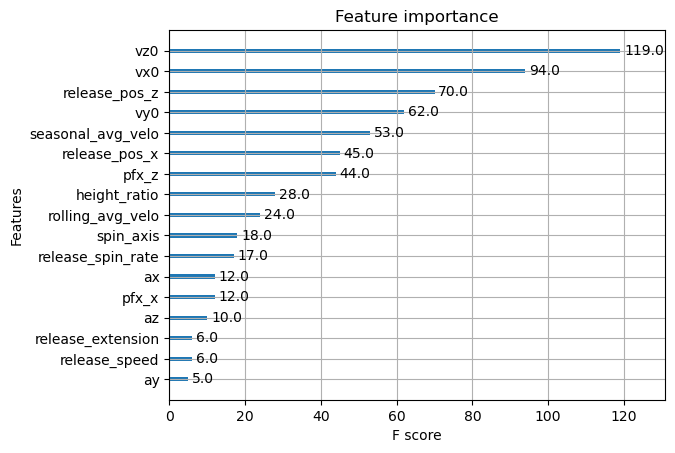

In [22]:
xgb.plot_importance(model)
plt.show()

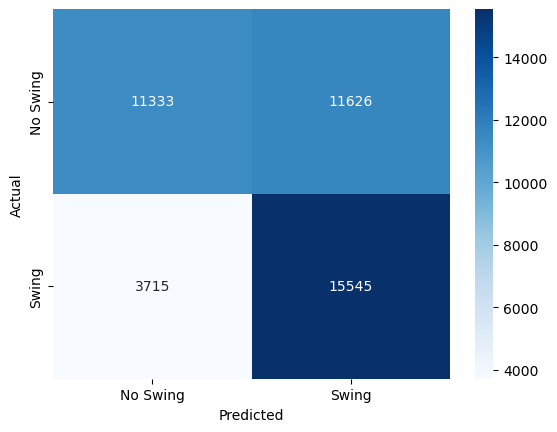

In [23]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Swing', 'Swing'], yticklabels=['No Swing', 'Swing'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [24]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'device' : 'gpu',
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [25]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-14 15:09:13,038] A new study created in memory with name: no-name-07d011f2-c5f9-48ca-8a58-0bd49ef0ef18


[0]	eval-logloss:0.68533
[1]	eval-logloss:0.67908
[2]	eval-logloss:0.67323
[3]	eval-logloss:0.66886
[4]	eval-logloss:0.66466
[5]	eval-logloss:0.66183
[6]	eval-logloss:0.65835
[7]	eval-logloss:0.65574
[8]	eval-logloss:0.65414
[9]	eval-logloss:0.65134
[10]	eval-logloss:0.64893
[11]	eval-logloss:0.64692
[12]	eval-logloss:0.64581
[13]	eval-logloss:0.64397
[14]	eval-logloss:0.64191
[15]	eval-logloss:0.63991
[16]	eval-logloss:0.63882
[17]	eval-logloss:0.63723
[18]	eval-logloss:0.63590
[19]	eval-logloss:0.63509
[20]	eval-logloss:0.63337
[21]	eval-logloss:0.63150
[22]	eval-logloss:0.63054
[23]	eval-logloss:0.62925
[24]	eval-logloss:0.62870
[25]	eval-logloss:0.62748
[26]	eval-logloss:0.62673
[27]	eval-logloss:0.62655
[28]	eval-logloss:0.62583
[29]	eval-logloss:0.62402
[30]	eval-logloss:0.62263
[31]	eval-logloss:0.62225
[32]	eval-logloss:0.62146
[33]	eval-logloss:0.62071
[34]	eval-logloss:0.62009
[35]	eval-logloss:0.61951
[36]	eval-logloss:0.61874
[37]	eval-logloss:0.61828
[38]	eval-logloss:0.61

[I 2023-11-14 15:09:14,039] Trial 0 finished with value: 0.5932117344347638 and parameters: {'max_depth': 4, 'eta': 0.13390064205258193, 'subsample': 0.8357887416220455, 'colsample_bytree': 0.7615711196820628}. Best is trial 0 with value: 0.5932117344347638.


[0]	eval-logloss:0.67744
[1]	eval-logloss:0.66498
[2]	eval-logloss:0.65618
[3]	eval-logloss:0.64878
[4]	eval-logloss:0.64294
[5]	eval-logloss:0.63905
[6]	eval-logloss:0.63365
[7]	eval-logloss:0.62864
[8]	eval-logloss:0.62554
[9]	eval-logloss:0.62221
[10]	eval-logloss:0.61852
[11]	eval-logloss:0.61507
[12]	eval-logloss:0.61345
[13]	eval-logloss:0.61092
[14]	eval-logloss:0.60863
[15]	eval-logloss:0.60725
[16]	eval-logloss:0.60529
[17]	eval-logloss:0.60390
[18]	eval-logloss:0.60252
[19]	eval-logloss:0.60135
[20]	eval-logloss:0.60070
[21]	eval-logloss:0.59716
[22]	eval-logloss:0.59533
[23]	eval-logloss:0.59494
[24]	eval-logloss:0.59428
[25]	eval-logloss:0.59356
[26]	eval-logloss:0.59170
[27]	eval-logloss:0.59057
[28]	eval-logloss:0.58963
[29]	eval-logloss:0.58800
[30]	eval-logloss:0.58712
[31]	eval-logloss:0.58496
[32]	eval-logloss:0.58437
[33]	eval-logloss:0.58376
[34]	eval-logloss:0.58251
[35]	eval-logloss:0.58209
[36]	eval-logloss:0.58187
[37]	eval-logloss:0.58142
[38]	eval-logloss:0.58

[I 2023-11-14 15:09:15,063] Trial 1 finished with value: 0.564394058620208 and parameters: {'max_depth': 7, 'eta': 0.16526549191345635, 'subsample': 0.8221291423798789, 'colsample_bytree': 0.9894343044584786}. Best is trial 1 with value: 0.564394058620208.


[0]	eval-logloss:0.68212
[1]	eval-logloss:0.67315
[2]	eval-logloss:0.66582
[3]	eval-logloss:0.65948
[4]	eval-logloss:0.65325
[5]	eval-logloss:0.64892
[6]	eval-logloss:0.64467
[7]	eval-logloss:0.64076
[8]	eval-logloss:0.63797
[9]	eval-logloss:0.63479
[10]	eval-logloss:0.63184
[11]	eval-logloss:0.62948
[12]	eval-logloss:0.62633
[13]	eval-logloss:0.62420
[14]	eval-logloss:0.62198
[15]	eval-logloss:0.62092
[16]	eval-logloss:0.61855
[17]	eval-logloss:0.61721
[18]	eval-logloss:0.61531
[19]	eval-logloss:0.61250
[20]	eval-logloss:0.61140
[21]	eval-logloss:0.60991
[22]	eval-logloss:0.60863
[23]	eval-logloss:0.60704
[24]	eval-logloss:0.60632
[25]	eval-logloss:0.60560
[26]	eval-logloss:0.60481
[27]	eval-logloss:0.60442
[28]	eval-logloss:0.60327
[29]	eval-logloss:0.60080
[30]	eval-logloss:0.59910
[31]	eval-logloss:0.59812
[32]	eval-logloss:0.59699
[33]	eval-logloss:0.59629
[34]	eval-logloss:0.59561
[35]	eval-logloss:0.59477
[36]	eval-logloss:0.59357
[37]	eval-logloss:0.59327
[38]	eval-logloss:0.59

[I 2023-11-14 15:09:16,044] Trial 2 finished with value: 0.5694934119542916 and parameters: {'max_depth': 7, 'eta': 0.11319006769853508, 'subsample': 0.7478668593526804, 'colsample_bytree': 0.9419393950819892}. Best is trial 1 with value: 0.564394058620208.


[0]	eval-logloss:0.69102
[1]	eval-logloss:0.67512
[2]	eval-logloss:0.66101
[3]	eval-logloss:0.65230
[4]	eval-logloss:0.64547
[5]	eval-logloss:0.64014
[6]	eval-logloss:0.63658
[7]	eval-logloss:0.63146
[8]	eval-logloss:0.62734
[9]	eval-logloss:0.62353
[10]	eval-logloss:0.62312
[11]	eval-logloss:0.62053
[12]	eval-logloss:0.61803
[13]	eval-logloss:0.61655
[14]	eval-logloss:0.61393
[15]	eval-logloss:0.61261
[16]	eval-logloss:0.61117
[17]	eval-logloss:0.60795
[18]	eval-logloss:0.60669
[19]	eval-logloss:0.60408
[20]	eval-logloss:0.60337
[21]	eval-logloss:0.60294
[22]	eval-logloss:0.60198
[23]	eval-logloss:0.60181
[24]	eval-logloss:0.60145
[25]	eval-logloss:0.60121
[26]	eval-logloss:0.60068
[27]	eval-logloss:0.60050
[28]	eval-logloss:0.60064
[29]	eval-logloss:0.59785
[30]	eval-logloss:0.59659
[31]	eval-logloss:0.59588
[32]	eval-logloss:0.59540
[33]	eval-logloss:0.59502
[34]	eval-logloss:0.59490
[35]	eval-logloss:0.59425
[36]	eval-logloss:0.59350
[37]	eval-logloss:0.59326
[38]	eval-logloss:0.59

[I 2023-11-14 15:09:16,810] Trial 3 finished with value: 0.5752450917936289 and parameters: {'max_depth': 6, 'eta': 0.23944020743948408, 'subsample': 0.6702175144047989, 'colsample_bytree': 0.5919607284940056}. Best is trial 1 with value: 0.564394058620208.


[0]	eval-logloss:0.69188
[1]	eval-logloss:0.69064
[2]	eval-logloss:0.68949
[3]	eval-logloss:0.68837
[4]	eval-logloss:0.68724
[5]	eval-logloss:0.68623
[6]	eval-logloss:0.68518
[7]	eval-logloss:0.68412
[8]	eval-logloss:0.68321
[9]	eval-logloss:0.68231
[10]	eval-logloss:0.68127
[11]	eval-logloss:0.68041
[12]	eval-logloss:0.67958
[13]	eval-logloss:0.67875
[14]	eval-logloss:0.67773
[15]	eval-logloss:0.67685
[16]	eval-logloss:0.67588
[17]	eval-logloss:0.67500
[18]	eval-logloss:0.67428
[19]	eval-logloss:0.67364
[20]	eval-logloss:0.67299
[21]	eval-logloss:0.67237
[22]	eval-logloss:0.67157
[23]	eval-logloss:0.67078
[24]	eval-logloss:0.67015
[25]	eval-logloss:0.66954
[26]	eval-logloss:0.66897
[27]	eval-logloss:0.66883
[28]	eval-logloss:0.66815
[29]	eval-logloss:0.66739
[30]	eval-logloss:0.66675
[31]	eval-logloss:0.66611
[32]	eval-logloss:0.66575
[33]	eval-logloss:0.66508
[34]	eval-logloss:0.66448
[35]	eval-logloss:0.66404
[36]	eval-logloss:0.66356
[37]	eval-logloss:0.66304
[38]	eval-logloss:0.66

[I 2023-11-14 15:09:17,498] Trial 4 finished with value: 0.642745008769735 and parameters: {'max_depth': 4, 'eta': 0.020820317791017, 'subsample': 0.7575660992613282, 'colsample_bytree': 0.8890027965772536}. Best is trial 1 with value: 0.564394058620208.


[0]	eval-logloss:0.68537
[1]	eval-logloss:0.67761
[2]	eval-logloss:0.67134
[3]	eval-logloss:0.66503
[4]	eval-logloss:0.65940
[5]	eval-logloss:0.65449
[6]	eval-logloss:0.65032
[7]	eval-logloss:0.64600
[8]	eval-logloss:0.64222
[9]	eval-logloss:0.63897
[10]	eval-logloss:0.63594
[11]	eval-logloss:0.63300
[12]	eval-logloss:0.63143
[13]	eval-logloss:0.62902
[14]	eval-logloss:0.62698
[15]	eval-logloss:0.62505
[16]	eval-logloss:0.62210
[17]	eval-logloss:0.61984
[18]	eval-logloss:0.61787
[19]	eval-logloss:0.61621
[20]	eval-logloss:0.61450
[21]	eval-logloss:0.61332
[22]	eval-logloss:0.61190
[23]	eval-logloss:0.61037
[24]	eval-logloss:0.60950
[25]	eval-logloss:0.60841
[26]	eval-logloss:0.60615
[27]	eval-logloss:0.60601
[28]	eval-logloss:0.60515
[29]	eval-logloss:0.60388
[30]	eval-logloss:0.60205
[31]	eval-logloss:0.60130
[32]	eval-logloss:0.60045
[33]	eval-logloss:0.59977
[34]	eval-logloss:0.59913
[35]	eval-logloss:0.59871
[36]	eval-logloss:0.59805
[37]	eval-logloss:0.59767
[38]	eval-logloss:0.59

[I 2023-11-14 15:09:19,104] Trial 5 finished with value: 0.5697593296805588 and parameters: {'max_depth': 9, 'eta': 0.07319715289648485, 'subsample': 0.6525082587661744, 'colsample_bytree': 0.7500795875500358}. Best is trial 1 with value: 0.564394058620208.


[0]	eval-logloss:0.69112
[1]	eval-logloss:0.68900
[2]	eval-logloss:0.68703
[3]	eval-logloss:0.68505
[4]	eval-logloss:0.68314
[5]	eval-logloss:0.68146
[6]	eval-logloss:0.67978
[7]	eval-logloss:0.67810
[8]	eval-logloss:0.67730
[9]	eval-logloss:0.67583
[10]	eval-logloss:0.67431
[11]	eval-logloss:0.67286
[12]	eval-logloss:0.67227
[13]	eval-logloss:0.67098
[14]	eval-logloss:0.66975
[15]	eval-logloss:0.66850
[16]	eval-logloss:0.66715
[17]	eval-logloss:0.66590
[18]	eval-logloss:0.66478
[19]	eval-logloss:0.66366
[20]	eval-logloss:0.66262
[21]	eval-logloss:0.66159
[22]	eval-logloss:0.66047
[23]	eval-logloss:0.65982
[24]	eval-logloss:0.65886
[25]	eval-logloss:0.65797
[26]	eval-logloss:0.65781
[27]	eval-logloss:0.65767
[28]	eval-logloss:0.65728
[29]	eval-logloss:0.65628
[30]	eval-logloss:0.65541
[31]	eval-logloss:0.65469
[32]	eval-logloss:0.65421
[33]	eval-logloss:0.65339
[34]	eval-logloss:0.65268
[35]	eval-logloss:0.65198
[36]	eval-logloss:0.65136
[37]	eval-logloss:0.65072
[38]	eval-logloss:0.65

[I 2023-11-14 15:09:19,821] Trial 6 finished with value: 0.6281020947857417 and parameters: {'max_depth': 5, 'eta': 0.028453695257981006, 'subsample': 0.6526329046578871, 'colsample_bytree': 0.7097363245864988}. Best is trial 1 with value: 0.564394058620208.


[0]	eval-logloss:0.69005
[1]	eval-logloss:0.68700
[2]	eval-logloss:0.68417
[3]	eval-logloss:0.68143
[4]	eval-logloss:0.67889
[5]	eval-logloss:0.67666
[6]	eval-logloss:0.67447
[7]	eval-logloss:0.67218
[8]	eval-logloss:0.67112
[9]	eval-logloss:0.66923
[10]	eval-logloss:0.66737
[11]	eval-logloss:0.66543
[12]	eval-logloss:0.66460
[13]	eval-logloss:0.66307
[14]	eval-logloss:0.66159
[15]	eval-logloss:0.66006
[16]	eval-logloss:0.65853
[17]	eval-logloss:0.65708
[18]	eval-logloss:0.65582
[19]	eval-logloss:0.65471
[20]	eval-logloss:0.65349
[21]	eval-logloss:0.65257
[22]	eval-logloss:0.65166
[23]	eval-logloss:0.65148
[24]	eval-logloss:0.65052
[25]	eval-logloss:0.65038
[26]	eval-logloss:0.65024
[27]	eval-logloss:0.65009
[28]	eval-logloss:0.64998
[29]	eval-logloss:0.64895
[30]	eval-logloss:0.64824
[31]	eval-logloss:0.64737
[32]	eval-logloss:0.64680
[33]	eval-logloss:0.64588
[34]	eval-logloss:0.64577
[35]	eval-logloss:0.64488
[36]	eval-logloss:0.64420
[37]	eval-logloss:0.64403
[38]	eval-logloss:0.64

[I 2023-11-14 15:09:20,532] Trial 7 finished with value: 0.6203532612118513 and parameters: {'max_depth': 5, 'eta': 0.04323061031200761, 'subsample': 0.8386762961642412, 'colsample_bytree': 0.6509200768347343}. Best is trial 1 with value: 0.564394058620208.


[0]	eval-logloss:0.68378
[1]	eval-logloss:0.67605
[2]	eval-logloss:0.66947
[3]	eval-logloss:0.66325
[4]	eval-logloss:0.65800
[5]	eval-logloss:0.65423
[6]	eval-logloss:0.65056
[7]	eval-logloss:0.64710
[8]	eval-logloss:0.64415
[9]	eval-logloss:0.64106
[10]	eval-logloss:0.63814
[11]	eval-logloss:0.63614
[12]	eval-logloss:0.63444
[13]	eval-logloss:0.63283
[14]	eval-logloss:0.63081
[15]	eval-logloss:0.62878
[16]	eval-logloss:0.62606
[17]	eval-logloss:0.62464
[18]	eval-logloss:0.62313
[19]	eval-logloss:0.62202
[20]	eval-logloss:0.62057
[21]	eval-logloss:0.61856
[22]	eval-logloss:0.61737
[23]	eval-logloss:0.61664
[24]	eval-logloss:0.61551
[25]	eval-logloss:0.61433
[26]	eval-logloss:0.61305
[27]	eval-logloss:0.61133
[28]	eval-logloss:0.61081
[29]	eval-logloss:0.60927
[30]	eval-logloss:0.60740
[31]	eval-logloss:0.60631
[32]	eval-logloss:0.60560
[33]	eval-logloss:0.60500
[34]	eval-logloss:0.60435
[35]	eval-logloss:0.60343
[36]	eval-logloss:0.60280
[37]	eval-logloss:0.60249
[38]	eval-logloss:0.60

[I 2023-11-14 15:09:21,333] Trial 8 finished with value: 0.5751241410888702 and parameters: {'max_depth': 6, 'eta': 0.10952975422208151, 'subsample': 0.6959052605748548, 'colsample_bytree': 0.9768852431392974}. Best is trial 1 with value: 0.564394058620208.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69072
[2]	eval-logloss:0.68845
[3]	eval-logloss:0.68632
[4]	eval-logloss:0.68525
[5]	eval-logloss:0.68322
[6]	eval-logloss:0.68160
[7]	eval-logloss:0.68001
[8]	eval-logloss:0.67855
[9]	eval-logloss:0.67649
[10]	eval-logloss:0.67625
[11]	eval-logloss:0.67438
[12]	eval-logloss:0.67352
[13]	eval-logloss:0.67182
[14]	eval-logloss:0.67041
[15]	eval-logloss:0.66907
[16]	eval-logloss:0.66771
[17]	eval-logloss:0.66616
[18]	eval-logloss:0.66456
[19]	eval-logloss:0.66291
[20]	eval-logloss:0.66142
[21]	eval-logloss:0.65998
[22]	eval-logloss:0.65976
[23]	eval-logloss:0.65960
[24]	eval-logloss:0.65824
[25]	eval-logloss:0.65810
[26]	eval-logloss:0.65792
[27]	eval-logloss:0.65779
[28]	eval-logloss:0.65765
[29]	eval-logloss:0.65624
[30]	eval-logloss:0.65559
[31]	eval-logloss:0.65450
[32]	eval-logloss:0.65385
[33]	eval-logloss:0.65367
[34]	eval-logloss:0.65356
[35]	eval-logloss:0.65223
[36]	eval-logloss:0.65090
[37]	eval-logloss:0.65073
[38]	eval-logloss:0.64

[I 2023-11-14 15:09:23,109] Trial 9 finished with value: 0.6178019525815088 and parameters: {'max_depth': 9, 'eta': 0.02085671126956213, 'subsample': 0.8946223319849924, 'colsample_bytree': 0.5500901480552121}. Best is trial 1 with value: 0.564394058620208.


[0]	eval-logloss:0.67459
[1]	eval-logloss:0.65987
[2]	eval-logloss:0.65046
[3]	eval-logloss:0.64230
[4]	eval-logloss:0.63479
[5]	eval-logloss:0.63014
[6]	eval-logloss:0.62656
[7]	eval-logloss:0.61961
[8]	eval-logloss:0.61374
[9]	eval-logloss:0.61160
[10]	eval-logloss:0.60916
[11]	eval-logloss:0.60597
[12]	eval-logloss:0.60397
[13]	eval-logloss:0.60233
[14]	eval-logloss:0.60114
[15]	eval-logloss:0.60004
[16]	eval-logloss:0.59725
[17]	eval-logloss:0.59558
[18]	eval-logloss:0.59388
[19]	eval-logloss:0.59274
[20]	eval-logloss:0.59171
[21]	eval-logloss:0.59068
[22]	eval-logloss:0.58954
[23]	eval-logloss:0.58858
[24]	eval-logloss:0.58804
[25]	eval-logloss:0.58725
[26]	eval-logloss:0.58685
[27]	eval-logloss:0.58669
[28]	eval-logloss:0.58565
[29]	eval-logloss:0.58242
[30]	eval-logloss:0.58136
[31]	eval-logloss:0.58035
[32]	eval-logloss:0.58033
[33]	eval-logloss:0.58006
[34]	eval-logloss:0.57955
[35]	eval-logloss:0.57953
[36]	eval-logloss:0.57748
[37]	eval-logloss:0.57733
[38]	eval-logloss:0.57

[I 2023-11-14 15:09:24,487] Trial 10 finished with value: 0.566663796101828 and parameters: {'max_depth': 8, 'eta': 0.19515265233974846, 'subsample': 0.7840196725301344, 'colsample_bytree': 0.8657075197063901}. Best is trial 1 with value: 0.564394058620208.


[0]	eval-logloss:0.67494
[1]	eval-logloss:0.66052
[2]	eval-logloss:0.65110
[3]	eval-logloss:0.64186
[4]	eval-logloss:0.63393
[5]	eval-logloss:0.62930
[6]	eval-logloss:0.62465
[7]	eval-logloss:0.62076
[8]	eval-logloss:0.61540
[9]	eval-logloss:0.61321
[10]	eval-logloss:0.61072
[11]	eval-logloss:0.60644
[12]	eval-logloss:0.60301
[13]	eval-logloss:0.60103
[14]	eval-logloss:0.60001
[15]	eval-logloss:0.59817
[16]	eval-logloss:0.59653
[17]	eval-logloss:0.59516
[18]	eval-logloss:0.59135
[19]	eval-logloss:0.59008
[20]	eval-logloss:0.58809
[21]	eval-logloss:0.58688
[22]	eval-logloss:0.58532
[23]	eval-logloss:0.58378
[24]	eval-logloss:0.58328
[25]	eval-logloss:0.58100
[26]	eval-logloss:0.57989
[27]	eval-logloss:0.57957
[28]	eval-logloss:0.57927
[29]	eval-logloss:0.57819
[30]	eval-logloss:0.57646
[31]	eval-logloss:0.57577
[32]	eval-logloss:0.57529
[33]	eval-logloss:0.57490
[34]	eval-logloss:0.57429
[35]	eval-logloss:0.57377
[36]	eval-logloss:0.57343
[37]	eval-logloss:0.57323
[38]	eval-logloss:0.57

[I 2023-11-14 15:09:25,840] Trial 11 finished with value: 0.5658893265431775 and parameters: {'max_depth': 8, 'eta': 0.19218834488299594, 'subsample': 0.7865835331306882, 'colsample_bytree': 0.8715561757732977}. Best is trial 1 with value: 0.564394058620208.


[0]	eval-logloss:0.67584
[1]	eval-logloss:0.66256
[2]	eval-logloss:0.65358
[3]	eval-logloss:0.64624
[4]	eval-logloss:0.64047
[5]	eval-logloss:0.63703
[6]	eval-logloss:0.63147
[7]	eval-logloss:0.62593
[8]	eval-logloss:0.62295
[9]	eval-logloss:0.62012
[10]	eval-logloss:0.61653
[11]	eval-logloss:0.61349
[12]	eval-logloss:0.61131
[13]	eval-logloss:0.60965
[14]	eval-logloss:0.60811
[15]	eval-logloss:0.60450
[16]	eval-logloss:0.60152
[17]	eval-logloss:0.60005
[18]	eval-logloss:0.59703
[19]	eval-logloss:0.59595
[20]	eval-logloss:0.59474
[21]	eval-logloss:0.59310
[22]	eval-logloss:0.59256
[23]	eval-logloss:0.59211
[24]	eval-logloss:0.59146
[25]	eval-logloss:0.59088
[26]	eval-logloss:0.59029
[27]	eval-logloss:0.58905
[28]	eval-logloss:0.58792
[29]	eval-logloss:0.58570
[30]	eval-logloss:0.58403
[31]	eval-logloss:0.58273
[32]	eval-logloss:0.58239
[33]	eval-logloss:0.58212
[34]	eval-logloss:0.58182
[35]	eval-logloss:0.58074
[36]	eval-logloss:0.57940
[37]	eval-logloss:0.57886
[38]	eval-logloss:0.57

[I 2023-11-14 15:09:26,863] Trial 12 finished with value: 0.5637813782492517 and parameters: {'max_depth': 7, 'eta': 0.18473850662575708, 'subsample': 0.8138058655676735, 'colsample_bytree': 0.9921800379811703}. Best is trial 12 with value: 0.5637813782492517.


[0]	eval-logloss:0.66918
[1]	eval-logloss:0.65283
[2]	eval-logloss:0.64282
[3]	eval-logloss:0.63631
[4]	eval-logloss:0.63126
[5]	eval-logloss:0.62572
[6]	eval-logloss:0.62162
[7]	eval-logloss:0.61768
[8]	eval-logloss:0.60970
[9]	eval-logloss:0.60785
[10]	eval-logloss:0.60599
[11]	eval-logloss:0.60476
[12]	eval-logloss:0.60289
[13]	eval-logloss:0.59889
[14]	eval-logloss:0.59736
[15]	eval-logloss:0.59451
[16]	eval-logloss:0.59136
[17]	eval-logloss:0.59007
[18]	eval-logloss:0.58897
[19]	eval-logloss:0.58853
[20]	eval-logloss:0.58530
[21]	eval-logloss:0.58445
[22]	eval-logloss:0.58406
[23]	eval-logloss:0.58343
[24]	eval-logloss:0.58290
[25]	eval-logloss:0.58177
[26]	eval-logloss:0.58133
[27]	eval-logloss:0.58058
[28]	eval-logloss:0.58002
[29]	eval-logloss:0.57857
[30]	eval-logloss:0.57760
[31]	eval-logloss:0.57662
[32]	eval-logloss:0.57596
[33]	eval-logloss:0.57590
[34]	eval-logloss:0.57578
[35]	eval-logloss:0.57561
[36]	eval-logloss:0.57535
[37]	eval-logloss:0.57514
[38]	eval-logloss:0.57

[I 2023-11-14 15:09:27,920] Trial 13 finished with value: 0.5636565176123793 and parameters: {'max_depth': 7, 'eta': 0.27111027466074566, 'subsample': 0.8387292136990332, 'colsample_bytree': 0.9546125954921598}. Best is trial 13 with value: 0.5636565176123793.


[0]	eval-logloss:0.66860
[1]	eval-logloss:0.65159
[2]	eval-logloss:0.64068
[3]	eval-logloss:0.63451
[4]	eval-logloss:0.62628
[5]	eval-logloss:0.62299
[6]	eval-logloss:0.61839
[7]	eval-logloss:0.60955
[8]	eval-logloss:0.60576
[9]	eval-logloss:0.60390
[10]	eval-logloss:0.60140
[11]	eval-logloss:0.59807
[12]	eval-logloss:0.59626
[13]	eval-logloss:0.59424
[14]	eval-logloss:0.59262
[15]	eval-logloss:0.59146
[16]	eval-logloss:0.58984
[17]	eval-logloss:0.58864
[18]	eval-logloss:0.58806
[19]	eval-logloss:0.58655
[20]	eval-logloss:0.58522
[21]	eval-logloss:0.58463
[22]	eval-logloss:0.58370
[23]	eval-logloss:0.57988
[24]	eval-logloss:0.57961
[25]	eval-logloss:0.57930
[26]	eval-logloss:0.57902
[27]	eval-logloss:0.57715
[28]	eval-logloss:0.57639
[29]	eval-logloss:0.57609
[30]	eval-logloss:0.57573
[31]	eval-logloss:0.57535
[32]	eval-logloss:0.57514
[33]	eval-logloss:0.57413
[34]	eval-logloss:0.57264
[35]	eval-logloss:0.57238
[36]	eval-logloss:0.57177
[37]	eval-logloss:0.57152
[38]	eval-logloss:0.56

[I 2023-11-14 15:09:28,947] Trial 14 finished with value: 0.5634493104753453 and parameters: {'max_depth': 7, 'eta': 0.28481746315353274, 'subsample': 0.8902660821519325, 'colsample_bytree': 0.9957641535933225}. Best is trial 14 with value: 0.5634493104753453.


[0]	eval-logloss:0.68106
[1]	eval-logloss:0.67241
[2]	eval-logloss:0.66581
[3]	eval-logloss:0.66210
[4]	eval-logloss:0.65793
[5]	eval-logloss:0.65369
[6]	eval-logloss:0.65120
[7]	eval-logloss:0.64807
[8]	eval-logloss:0.64579
[9]	eval-logloss:0.64211
[10]	eval-logloss:0.64083
[11]	eval-logloss:0.63891
[12]	eval-logloss:0.63725
[13]	eval-logloss:0.63551
[14]	eval-logloss:0.63385
[15]	eval-logloss:0.63114
[16]	eval-logloss:0.62788
[17]	eval-logloss:0.62453
[18]	eval-logloss:0.62336
[19]	eval-logloss:0.62265
[20]	eval-logloss:0.62225
[21]	eval-logloss:0.62170
[22]	eval-logloss:0.62136
[23]	eval-logloss:0.62101
[24]	eval-logloss:0.62031
[25]	eval-logloss:0.61902
[26]	eval-logloss:0.61887
[27]	eval-logloss:0.61869
[28]	eval-logloss:0.61838
[29]	eval-logloss:0.61821
[30]	eval-logloss:0.61774
[31]	eval-logloss:0.61761
[32]	eval-logloss:0.61742
[33]	eval-logloss:0.61546
[34]	eval-logloss:0.61403
[35]	eval-logloss:0.61277
[36]	eval-logloss:0.61221
[37]	eval-logloss:0.61173
[38]	eval-logloss:0.61

[I 2023-11-14 15:09:29,573] Trial 15 finished with value: 0.5901506283316278 and parameters: {'max_depth': 3, 'eta': 0.2999237953235688, 'subsample': 0.8970601479263799, 'colsample_bytree': 0.9264014396310358}. Best is trial 14 with value: 0.5634493104753453.


[0]	eval-logloss:0.66728
[1]	eval-logloss:0.64881
[2]	eval-logloss:0.63807
[3]	eval-logloss:0.62863
[4]	eval-logloss:0.62084
[5]	eval-logloss:0.61684
[6]	eval-logloss:0.61151
[7]	eval-logloss:0.60920
[8]	eval-logloss:0.60108
[9]	eval-logloss:0.59907
[10]	eval-logloss:0.59723
[11]	eval-logloss:0.59501
[12]	eval-logloss:0.59372
[13]	eval-logloss:0.59153
[14]	eval-logloss:0.59066
[15]	eval-logloss:0.58945
[16]	eval-logloss:0.58733
[17]	eval-logloss:0.58426
[18]	eval-logloss:0.58353
[19]	eval-logloss:0.58193
[20]	eval-logloss:0.58086
[21]	eval-logloss:0.58057
[22]	eval-logloss:0.58021
[23]	eval-logloss:0.57781
[24]	eval-logloss:0.57760
[25]	eval-logloss:0.57452
[26]	eval-logloss:0.57424
[27]	eval-logloss:0.57442
[28]	eval-logloss:0.57441
[29]	eval-logloss:0.57386
[30]	eval-logloss:0.57281
[31]	eval-logloss:0.57116
[32]	eval-logloss:0.57097
[33]	eval-logloss:0.57062
[34]	eval-logloss:0.56962
[35]	eval-logloss:0.56936
[36]	eval-logloss:0.56941
[37]	eval-logloss:0.56938
[38]	eval-logloss:0.56

[I 2023-11-14 15:09:30,802] Trial 16 finished with value: 0.5676579271993396 and parameters: {'max_depth': 8, 'eta': 0.2929595507890936, 'subsample': 0.8657765780756049, 'colsample_bytree': 0.8293286189898256}. Best is trial 14 with value: 0.5634493104753453.


[0]	eval-logloss:0.67201
[1]	eval-logloss:0.65621
[2]	eval-logloss:0.64684
[3]	eval-logloss:0.63843
[4]	eval-logloss:0.63298
[5]	eval-logloss:0.62859
[6]	eval-logloss:0.62264
[7]	eval-logloss:0.61823
[8]	eval-logloss:0.61344
[9]	eval-logloss:0.61033
[10]	eval-logloss:0.60704
[11]	eval-logloss:0.60443
[12]	eval-logloss:0.60363
[13]	eval-logloss:0.60121
[14]	eval-logloss:0.60055
[15]	eval-logloss:0.59953
[16]	eval-logloss:0.59728
[17]	eval-logloss:0.59615
[18]	eval-logloss:0.59588
[19]	eval-logloss:0.59447
[20]	eval-logloss:0.59353
[21]	eval-logloss:0.59255
[22]	eval-logloss:0.59183
[23]	eval-logloss:0.59124
[24]	eval-logloss:0.59087
[25]	eval-logloss:0.58988
[26]	eval-logloss:0.58872
[27]	eval-logloss:0.58858
[28]	eval-logloss:0.58807
[29]	eval-logloss:0.58764
[30]	eval-logloss:0.58668
[31]	eval-logloss:0.58627
[32]	eval-logloss:0.58569
[33]	eval-logloss:0.58509
[34]	eval-logloss:0.58467
[35]	eval-logloss:0.58406
[36]	eval-logloss:0.58281
[37]	eval-logloss:0.58253
[38]	eval-logloss:0.58

[I 2023-11-14 15:09:31,841] Trial 17 finished with value: 0.565483084134343 and parameters: {'max_depth': 7, 'eta': 0.251415014273351, 'subsample': 0.8656199722143437, 'colsample_bytree': 0.8157863029885832}. Best is trial 14 with value: 0.5634493104753453.


[0]	eval-logloss:0.67427
[1]	eval-logloss:0.66007
[2]	eval-logloss:0.64997
[3]	eval-logloss:0.64155
[4]	eval-logloss:0.63713
[5]	eval-logloss:0.63276
[6]	eval-logloss:0.62645
[7]	eval-logloss:0.62274
[8]	eval-logloss:0.61927
[9]	eval-logloss:0.61672
[10]	eval-logloss:0.61371
[11]	eval-logloss:0.61202
[12]	eval-logloss:0.60761
[13]	eval-logloss:0.60551
[14]	eval-logloss:0.60306
[15]	eval-logloss:0.60015
[16]	eval-logloss:0.59768
[17]	eval-logloss:0.59598
[18]	eval-logloss:0.59555
[19]	eval-logloss:0.59290
[20]	eval-logloss:0.59180
[21]	eval-logloss:0.59095
[22]	eval-logloss:0.59026
[23]	eval-logloss:0.58960
[24]	eval-logloss:0.58919
[25]	eval-logloss:0.58888
[26]	eval-logloss:0.58847
[27]	eval-logloss:0.58835
[28]	eval-logloss:0.58752
[29]	eval-logloss:0.58722
[30]	eval-logloss:0.58671
[31]	eval-logloss:0.58605
[32]	eval-logloss:0.58559
[33]	eval-logloss:0.58511
[34]	eval-logloss:0.58344
[35]	eval-logloss:0.58236
[36]	eval-logloss:0.58205
[37]	eval-logloss:0.58172
[38]	eval-logloss:0.58

[I 2023-11-14 15:09:32,717] Trial 18 finished with value: 0.5662442422246289 and parameters: {'max_depth': 6, 'eta': 0.25343038174990135, 'subsample': 0.6066848813729105, 'colsample_bytree': 0.9211913549631585}. Best is trial 14 with value: 0.5634493104753453.


[0]	eval-logloss:0.67792
[1]	eval-logloss:0.66603
[2]	eval-logloss:0.65833
[3]	eval-logloss:0.65267
[4]	eval-logloss:0.64740
[5]	eval-logloss:0.64374
[6]	eval-logloss:0.64138
[7]	eval-logloss:0.63610
[8]	eval-logloss:0.63290
[9]	eval-logloss:0.63056
[10]	eval-logloss:0.62895
[11]	eval-logloss:0.62367
[12]	eval-logloss:0.62144
[13]	eval-logloss:0.61957
[14]	eval-logloss:0.61842
[15]	eval-logloss:0.61717
[16]	eval-logloss:0.61542
[17]	eval-logloss:0.61314
[18]	eval-logloss:0.61224
[19]	eval-logloss:0.61204
[20]	eval-logloss:0.61127
[21]	eval-logloss:0.61075
[22]	eval-logloss:0.60980
[23]	eval-logloss:0.60791
[24]	eval-logloss:0.60743
[25]	eval-logloss:0.60492
[26]	eval-logloss:0.60435
[27]	eval-logloss:0.60395
[28]	eval-logloss:0.60348
[29]	eval-logloss:0.60257
[30]	eval-logloss:0.60183
[31]	eval-logloss:0.60167
[32]	eval-logloss:0.60130
[33]	eval-logloss:0.60021
[34]	eval-logloss:0.59745
[35]	eval-logloss:0.59635
[36]	eval-logloss:0.59474
[37]	eval-logloss:0.59424
[38]	eval-logloss:0.59

[I 2023-11-14 15:09:33,465] Trial 19 finished with value: 0.5725070836051547 and parameters: {'max_depth': 5, 'eta': 0.2196601354923463, 'subsample': 0.8633695222924697, 'colsample_bytree': 0.9406694657817808}. Best is trial 14 with value: 0.5634493104753453.


[0]	eval-logloss:0.66883
[1]	eval-logloss:0.65116
[2]	eval-logloss:0.64044
[3]	eval-logloss:0.63114
[4]	eval-logloss:0.62323
[5]	eval-logloss:0.61904
[6]	eval-logloss:0.61354
[7]	eval-logloss:0.60857
[8]	eval-logloss:0.60337
[9]	eval-logloss:0.60088
[10]	eval-logloss:0.59762
[11]	eval-logloss:0.59366
[12]	eval-logloss:0.59246
[13]	eval-logloss:0.59082
[14]	eval-logloss:0.59000
[15]	eval-logloss:0.58880
[16]	eval-logloss:0.58733
[17]	eval-logloss:0.58593
[18]	eval-logloss:0.58462
[19]	eval-logloss:0.58387
[20]	eval-logloss:0.58099
[21]	eval-logloss:0.58041
[22]	eval-logloss:0.57950
[23]	eval-logloss:0.57795
[24]	eval-logloss:0.57746
[25]	eval-logloss:0.57734
[26]	eval-logloss:0.57608
[27]	eval-logloss:0.57623
[28]	eval-logloss:0.57591
[29]	eval-logloss:0.57584
[30]	eval-logloss:0.57522
[31]	eval-logloss:0.57527
[32]	eval-logloss:0.57542
[33]	eval-logloss:0.57516
[34]	eval-logloss:0.57505
[35]	eval-logloss:0.57498
[36]	eval-logloss:0.57449
[37]	eval-logloss:0.57460
[38]	eval-logloss:0.57

[I 2023-11-14 15:09:34,655] Trial 20 finished with value: 0.5696342205239396 and parameters: {'max_depth': 8, 'eta': 0.27561393376486093, 'subsample': 0.897733406864542, 'colsample_bytree': 0.8165542905173346}. Best is trial 14 with value: 0.5634493104753453.


[0]	eval-logloss:0.66959
[1]	eval-logloss:0.65344
[2]	eval-logloss:0.64433
[3]	eval-logloss:0.63491
[4]	eval-logloss:0.62843
[5]	eval-logloss:0.62512
[6]	eval-logloss:0.61978
[7]	eval-logloss:0.61714
[8]	eval-logloss:0.60951
[9]	eval-logloss:0.60673
[10]	eval-logloss:0.60079
[11]	eval-logloss:0.59876
[12]	eval-logloss:0.59741
[13]	eval-logloss:0.59434
[14]	eval-logloss:0.59222
[15]	eval-logloss:0.58912
[16]	eval-logloss:0.58711
[17]	eval-logloss:0.58554
[18]	eval-logloss:0.58384
[19]	eval-logloss:0.58326
[20]	eval-logloss:0.58224
[21]	eval-logloss:0.58157
[22]	eval-logloss:0.58122
[23]	eval-logloss:0.58005
[24]	eval-logloss:0.57959
[25]	eval-logloss:0.57916
[26]	eval-logloss:0.57801
[27]	eval-logloss:0.57627
[28]	eval-logloss:0.57573
[29]	eval-logloss:0.57517
[30]	eval-logloss:0.57448
[31]	eval-logloss:0.57415
[32]	eval-logloss:0.57426
[33]	eval-logloss:0.57396
[34]	eval-logloss:0.57222
[35]	eval-logloss:0.57209
[36]	eval-logloss:0.57180
[37]	eval-logloss:0.57165
[38]	eval-logloss:0.57

[I 2023-11-14 15:09:35,647] Trial 21 finished with value: 0.5642335687013438 and parameters: {'max_depth': 7, 'eta': 0.26521620236828575, 'subsample': 0.814987438601681, 'colsample_bytree': 0.9978773015249546}. Best is trial 14 with value: 0.5634493104753453.


[0]	eval-logloss:0.67555
[1]	eval-logloss:0.66253
[2]	eval-logloss:0.65397
[3]	eval-logloss:0.64767
[4]	eval-logloss:0.64078
[5]	eval-logloss:0.63746
[6]	eval-logloss:0.63355
[7]	eval-logloss:0.63021
[8]	eval-logloss:0.62712
[9]	eval-logloss:0.62431
[10]	eval-logloss:0.62107
[11]	eval-logloss:0.61701
[12]	eval-logloss:0.61532
[13]	eval-logloss:0.61234
[14]	eval-logloss:0.60987
[15]	eval-logloss:0.60734
[16]	eval-logloss:0.60369
[17]	eval-logloss:0.60169
[18]	eval-logloss:0.60035
[19]	eval-logloss:0.59996
[20]	eval-logloss:0.59827
[21]	eval-logloss:0.59742
[22]	eval-logloss:0.59695
[23]	eval-logloss:0.59656
[24]	eval-logloss:0.59601
[25]	eval-logloss:0.59449
[26]	eval-logloss:0.59351
[27]	eval-logloss:0.59296
[28]	eval-logloss:0.59203
[29]	eval-logloss:0.59149
[30]	eval-logloss:0.59116
[31]	eval-logloss:0.59025
[32]	eval-logloss:0.58920
[33]	eval-logloss:0.58820
[34]	eval-logloss:0.58780
[35]	eval-logloss:0.58713
[36]	eval-logloss:0.58691
[37]	eval-logloss:0.58638
[38]	eval-logloss:0.58

[I 2023-11-14 15:09:36,471] Trial 22 finished with value: 0.5672616676754115 and parameters: {'max_depth': 6, 'eta': 0.22023693217340454, 'subsample': 0.8557609250252395, 'colsample_bytree': 0.9972914053138275}. Best is trial 14 with value: 0.5634493104753453.


[0]	eval-logloss:0.66809
[1]	eval-logloss:0.65149
[2]	eval-logloss:0.64055
[3]	eval-logloss:0.63292
[4]	eval-logloss:0.62767
[5]	eval-logloss:0.62205
[6]	eval-logloss:0.61850
[7]	eval-logloss:0.61586
[8]	eval-logloss:0.60772
[9]	eval-logloss:0.60535
[10]	eval-logloss:0.60006
[11]	eval-logloss:0.59861
[12]	eval-logloss:0.59764
[13]	eval-logloss:0.59422
[14]	eval-logloss:0.59317
[15]	eval-logloss:0.58832
[16]	eval-logloss:0.58711
[17]	eval-logloss:0.58652
[18]	eval-logloss:0.58574
[19]	eval-logloss:0.58498
[20]	eval-logloss:0.58443
[21]	eval-logloss:0.58260
[22]	eval-logloss:0.58057
[23]	eval-logloss:0.57970
[24]	eval-logloss:0.57915
[25]	eval-logloss:0.57598
[26]	eval-logloss:0.57594
[27]	eval-logloss:0.57555
[28]	eval-logloss:0.57531
[29]	eval-logloss:0.57455
[30]	eval-logloss:0.57407
[31]	eval-logloss:0.57333
[32]	eval-logloss:0.57329
[33]	eval-logloss:0.57295
[34]	eval-logloss:0.57218
[35]	eval-logloss:0.57208
[36]	eval-logloss:0.57108
[37]	eval-logloss:0.57086
[38]	eval-logloss:0.57

[I 2023-11-14 15:09:37,485] Trial 23 finished with value: 0.5641901045556776 and parameters: {'max_depth': 7, 'eta': 0.2844776802835159, 'subsample': 0.8123249215052073, 'colsample_bytree': 0.9563967663379244}. Best is trial 14 with value: 0.5634493104753453.


[0]	eval-logloss:0.66690
[1]	eval-logloss:0.64867
[2]	eval-logloss:0.63892
[3]	eval-logloss:0.63055
[4]	eval-logloss:0.62301
[5]	eval-logloss:0.61952
[6]	eval-logloss:0.61332
[7]	eval-logloss:0.60792
[8]	eval-logloss:0.60294
[9]	eval-logloss:0.60004
[10]	eval-logloss:0.59758
[11]	eval-logloss:0.59492
[12]	eval-logloss:0.59303
[13]	eval-logloss:0.59108
[14]	eval-logloss:0.58958
[15]	eval-logloss:0.58490
[16]	eval-logloss:0.58407
[17]	eval-logloss:0.58242
[18]	eval-logloss:0.58213
[19]	eval-logloss:0.58174
[20]	eval-logloss:0.58063
[21]	eval-logloss:0.57996
[22]	eval-logloss:0.57918
[23]	eval-logloss:0.57834
[24]	eval-logloss:0.57819
[25]	eval-logloss:0.57804
[26]	eval-logloss:0.57637
[27]	eval-logloss:0.57628
[28]	eval-logloss:0.57543
[29]	eval-logloss:0.57535
[30]	eval-logloss:0.57424
[31]	eval-logloss:0.57266
[32]	eval-logloss:0.57234
[33]	eval-logloss:0.57176
[34]	eval-logloss:0.57157
[35]	eval-logloss:0.57160
[36]	eval-logloss:0.57127
[37]	eval-logloss:0.57121
[38]	eval-logloss:0.57

[I 2023-11-14 15:09:38,746] Trial 24 finished with value: 0.5666738607486005 and parameters: {'max_depth': 8, 'eta': 0.2702274861709755, 'subsample': 0.8442566530394735, 'colsample_bytree': 0.9061343916095262}. Best is trial 14 with value: 0.5634493104753453.


[0]	eval-logloss:0.67206
[1]	eval-logloss:0.65705
[2]	eval-logloss:0.64681
[3]	eval-logloss:0.63821
[4]	eval-logloss:0.63333
[5]	eval-logloss:0.62966
[6]	eval-logloss:0.62228
[7]	eval-logloss:0.61774
[8]	eval-logloss:0.61477
[9]	eval-logloss:0.61136
[10]	eval-logloss:0.60715
[11]	eval-logloss:0.60441
[12]	eval-logloss:0.60328
[13]	eval-logloss:0.60193
[14]	eval-logloss:0.60005
[15]	eval-logloss:0.59673
[16]	eval-logloss:0.59504
[17]	eval-logloss:0.59333
[18]	eval-logloss:0.59183
[19]	eval-logloss:0.59054
[20]	eval-logloss:0.58982
[21]	eval-logloss:0.58713
[22]	eval-logloss:0.58563
[23]	eval-logloss:0.58349
[24]	eval-logloss:0.58307
[25]	eval-logloss:0.58276
[26]	eval-logloss:0.58225
[27]	eval-logloss:0.58074
[28]	eval-logloss:0.58028
[29]	eval-logloss:0.57992
[30]	eval-logloss:0.57872
[31]	eval-logloss:0.57819
[32]	eval-logloss:0.57798
[33]	eval-logloss:0.57730
[34]	eval-logloss:0.57699
[35]	eval-logloss:0.57674
[36]	eval-logloss:0.57630
[37]	eval-logloss:0.57590
[38]	eval-logloss:0.57

[I 2023-11-14 15:09:39,869] Trial 25 finished with value: 0.5636931259509339 and parameters: {'max_depth': 7, 'eta': 0.23603916725840388, 'subsample': 0.87389629027211, 'colsample_bytree': 0.9548023168862895}. Best is trial 14 with value: 0.5634493104753453.


[0]	eval-logloss:0.67498
[1]	eval-logloss:0.66196
[2]	eval-logloss:0.65238
[3]	eval-logloss:0.64451
[4]	eval-logloss:0.63981
[5]	eval-logloss:0.63672
[6]	eval-logloss:0.63092
[7]	eval-logloss:0.62713
[8]	eval-logloss:0.62054
[9]	eval-logloss:0.61735
[10]	eval-logloss:0.61546
[11]	eval-logloss:0.61301
[12]	eval-logloss:0.60998
[13]	eval-logloss:0.60669
[14]	eval-logloss:0.60529
[15]	eval-logloss:0.60370
[16]	eval-logloss:0.60222
[17]	eval-logloss:0.60059
[18]	eval-logloss:0.59938
[19]	eval-logloss:0.59835
[20]	eval-logloss:0.59766
[21]	eval-logloss:0.59517
[22]	eval-logloss:0.59421
[23]	eval-logloss:0.59083
[24]	eval-logloss:0.59038
[25]	eval-logloss:0.59015
[26]	eval-logloss:0.58820
[27]	eval-logloss:0.58723
[28]	eval-logloss:0.58681
[29]	eval-logloss:0.58613
[30]	eval-logloss:0.58482
[31]	eval-logloss:0.58460
[32]	eval-logloss:0.58369
[33]	eval-logloss:0.58285
[34]	eval-logloss:0.58185
[35]	eval-logloss:0.58164
[36]	eval-logloss:0.58104
[37]	eval-logloss:0.58069
[38]	eval-logloss:0.57

[I 2023-11-14 15:09:40,823] Trial 26 finished with value: 0.5628284753682159 and parameters: {'max_depth': 6, 'eta': 0.2309632797773057, 'subsample': 0.8770194794996236, 'colsample_bytree': 0.9560280665878041}. Best is trial 26 with value: 0.5628284753682159.


[0]	eval-logloss:0.67206
[1]	eval-logloss:0.65823
[2]	eval-logloss:0.64848
[3]	eval-logloss:0.64119
[4]	eval-logloss:0.63611
[5]	eval-logloss:0.63033
[6]	eval-logloss:0.62819
[7]	eval-logloss:0.62189
[8]	eval-logloss:0.61948
[9]	eval-logloss:0.61691
[10]	eval-logloss:0.61025
[11]	eval-logloss:0.60863
[12]	eval-logloss:0.60597
[13]	eval-logloss:0.60523
[14]	eval-logloss:0.60148
[15]	eval-logloss:0.60084
[16]	eval-logloss:0.59966
[17]	eval-logloss:0.59718
[18]	eval-logloss:0.59572
[19]	eval-logloss:0.59510
[20]	eval-logloss:0.59221
[21]	eval-logloss:0.59197
[22]	eval-logloss:0.59147
[23]	eval-logloss:0.58840
[24]	eval-logloss:0.58801
[25]	eval-logloss:0.58764
[26]	eval-logloss:0.58720
[27]	eval-logloss:0.58712
[28]	eval-logloss:0.58653
[29]	eval-logloss:0.58585
[30]	eval-logloss:0.58440
[31]	eval-logloss:0.58355
[32]	eval-logloss:0.58177
[33]	eval-logloss:0.58110
[34]	eval-logloss:0.58056
[35]	eval-logloss:0.57948
[36]	eval-logloss:0.57920
[37]	eval-logloss:0.57875
[38]	eval-logloss:0.57

[I 2023-11-14 15:09:41,715] Trial 27 finished with value: 0.5644497173631416 and parameters: {'max_depth': 6, 'eta': 0.2738786766389925, 'subsample': 0.878109803919506, 'colsample_bytree': 0.8918988571717419}. Best is trial 26 with value: 0.5628284753682159.


[0]	eval-logloss:0.67785
[1]	eval-logloss:0.66630
[2]	eval-logloss:0.65765
[3]	eval-logloss:0.65148
[4]	eval-logloss:0.64736
[5]	eval-logloss:0.64194
[6]	eval-logloss:0.63846
[7]	eval-logloss:0.63577
[8]	eval-logloss:0.63071
[9]	eval-logloss:0.62839
[10]	eval-logloss:0.62625
[11]	eval-logloss:0.62196
[12]	eval-logloss:0.61939
[13]	eval-logloss:0.61747
[14]	eval-logloss:0.61601
[15]	eval-logloss:0.61452
[16]	eval-logloss:0.61279
[17]	eval-logloss:0.61092
[18]	eval-logloss:0.60722
[19]	eval-logloss:0.60597
[20]	eval-logloss:0.60439
[21]	eval-logloss:0.60307
[22]	eval-logloss:0.60246
[23]	eval-logloss:0.60144
[24]	eval-logloss:0.60075
[25]	eval-logloss:0.60005
[26]	eval-logloss:0.59921
[27]	eval-logloss:0.59744
[28]	eval-logloss:0.59719
[29]	eval-logloss:0.59672
[30]	eval-logloss:0.59516
[31]	eval-logloss:0.59492
[32]	eval-logloss:0.59454
[33]	eval-logloss:0.59413
[34]	eval-logloss:0.59343
[35]	eval-logloss:0.59254
[36]	eval-logloss:0.59149
[37]	eval-logloss:0.59107
[38]	eval-logloss:0.58

[I 2023-11-14 15:09:42,497] Trial 28 finished with value: 0.5686797707349702 and parameters: {'max_depth': 5, 'eta': 0.22281448961789807, 'subsample': 0.8834622918596092, 'colsample_bytree': 0.9586400587998402}. Best is trial 26 with value: 0.5628284753682159.


[0]	eval-logloss:0.67758
[1]	eval-logloss:0.66598
[2]	eval-logloss:0.66005
[3]	eval-logloss:0.65550
[4]	eval-logloss:0.65044
[5]	eval-logloss:0.64522
[6]	eval-logloss:0.64204
[7]	eval-logloss:0.64029
[8]	eval-logloss:0.63761
[9]	eval-logloss:0.63479
[10]	eval-logloss:0.63237
[11]	eval-logloss:0.63034
[12]	eval-logloss:0.62527
[13]	eval-logloss:0.62391
[14]	eval-logloss:0.62183
[15]	eval-logloss:0.62057
[16]	eval-logloss:0.61736
[17]	eval-logloss:0.61503
[18]	eval-logloss:0.61371
[19]	eval-logloss:0.61338
[20]	eval-logloss:0.61192
[21]	eval-logloss:0.61071
[22]	eval-logloss:0.60948
[23]	eval-logloss:0.60856
[24]	eval-logloss:0.60825
[25]	eval-logloss:0.60689
[26]	eval-logloss:0.60660
[27]	eval-logloss:0.60633
[28]	eval-logloss:0.60548
[29]	eval-logloss:0.60527
[30]	eval-logloss:0.60398
[31]	eval-logloss:0.60266
[32]	eval-logloss:0.60201
[33]	eval-logloss:0.60076
[34]	eval-logloss:0.60025
[35]	eval-logloss:0.60003
[36]	eval-logloss:0.60003
[37]	eval-logloss:0.59957
[38]	eval-logloss:0.59

[I 2023-11-14 15:09:43,173] Trial 29 finished with value: 0.5737696694420978 and parameters: {'max_depth': 4, 'eta': 0.29104608692390926, 'subsample': 0.8462693703407156, 'colsample_bytree': 0.8558684360809787}. Best is trial 26 with value: 0.5628284753682159.


[0]	eval-logloss:0.66539
[1]	eval-logloss:0.64689
[2]	eval-logloss:0.63675
[3]	eval-logloss:0.62684
[4]	eval-logloss:0.62056
[5]	eval-logloss:0.61568
[6]	eval-logloss:0.61003
[7]	eval-logloss:0.60371
[8]	eval-logloss:0.59907
[9]	eval-logloss:0.59713
[10]	eval-logloss:0.59503
[11]	eval-logloss:0.59079
[12]	eval-logloss:0.58917
[13]	eval-logloss:0.58644
[14]	eval-logloss:0.58434
[15]	eval-logloss:0.58388
[16]	eval-logloss:0.58298
[17]	eval-logloss:0.58103
[18]	eval-logloss:0.58012
[19]	eval-logloss:0.57909
[20]	eval-logloss:0.57688
[21]	eval-logloss:0.57625
[22]	eval-logloss:0.57583
[23]	eval-logloss:0.57573
[24]	eval-logloss:0.57564
[25]	eval-logloss:0.57527
[26]	eval-logloss:0.57503
[27]	eval-logloss:0.57516
[28]	eval-logloss:0.57472
[29]	eval-logloss:0.57317
[30]	eval-logloss:0.57206
[31]	eval-logloss:0.57146
[32]	eval-logloss:0.57083
[33]	eval-logloss:0.57073
[34]	eval-logloss:0.57028
[35]	eval-logloss:0.57034
[36]	eval-logloss:0.57022
[37]	eval-logloss:0.57042
[38]	eval-logloss:0.57

[I 2023-11-14 15:09:44,782] Trial 30 finished with value: 0.5668125370118574 and parameters: {'max_depth': 9, 'eta': 0.25945105021607423, 'subsample': 0.850275836117891, 'colsample_bytree': 0.9080103268364694}. Best is trial 26 with value: 0.5628284753682159.


[0]	eval-logloss:0.67170
[1]	eval-logloss:0.65618
[2]	eval-logloss:0.64685
[3]	eval-logloss:0.63912
[4]	eval-logloss:0.63282
[5]	eval-logloss:0.62844
[6]	eval-logloss:0.62409
[7]	eval-logloss:0.62031
[8]	eval-logloss:0.61345
[9]	eval-logloss:0.61219
[10]	eval-logloss:0.60692
[11]	eval-logloss:0.60428
[12]	eval-logloss:0.60251
[13]	eval-logloss:0.59929
[14]	eval-logloss:0.59762
[15]	eval-logloss:0.59504
[16]	eval-logloss:0.59332
[17]	eval-logloss:0.59195
[18]	eval-logloss:0.59089
[19]	eval-logloss:0.59066
[20]	eval-logloss:0.58999
[21]	eval-logloss:0.58876
[22]	eval-logloss:0.58791
[23]	eval-logloss:0.58576
[24]	eval-logloss:0.58549
[25]	eval-logloss:0.58506
[26]	eval-logloss:0.58463
[27]	eval-logloss:0.58304
[28]	eval-logloss:0.58242
[29]	eval-logloss:0.58181
[30]	eval-logloss:0.58004
[31]	eval-logloss:0.57906
[32]	eval-logloss:0.57894
[33]	eval-logloss:0.57752
[34]	eval-logloss:0.57605
[35]	eval-logloss:0.57547
[36]	eval-logloss:0.57484
[37]	eval-logloss:0.57451
[38]	eval-logloss:0.57

[I 2023-11-14 15:09:45,991] Trial 31 finished with value: 0.5634479668920079 and parameters: {'max_depth': 7, 'eta': 0.23960852706886315, 'subsample': 0.8775412247106879, 'colsample_bytree': 0.9550683141528415}. Best is trial 26 with value: 0.5628284753682159.


[0]	eval-logloss:0.67360
[1]	eval-logloss:0.66016
[2]	eval-logloss:0.65060
[3]	eval-logloss:0.64321
[4]	eval-logloss:0.63896
[5]	eval-logloss:0.63453
[6]	eval-logloss:0.63177
[7]	eval-logloss:0.62775
[8]	eval-logloss:0.62371
[9]	eval-logloss:0.62063
[10]	eval-logloss:0.61687
[11]	eval-logloss:0.61272
[12]	eval-logloss:0.60862
[13]	eval-logloss:0.60741
[14]	eval-logloss:0.60615
[15]	eval-logloss:0.60540
[16]	eval-logloss:0.60389
[17]	eval-logloss:0.60250
[18]	eval-logloss:0.60219
[19]	eval-logloss:0.60087
[20]	eval-logloss:0.59762
[21]	eval-logloss:0.59615
[22]	eval-logloss:0.59463
[23]	eval-logloss:0.59099
[24]	eval-logloss:0.59034
[25]	eval-logloss:0.59009
[26]	eval-logloss:0.58901
[27]	eval-logloss:0.58868
[28]	eval-logloss:0.58827
[29]	eval-logloss:0.58768
[30]	eval-logloss:0.58622
[31]	eval-logloss:0.58405
[32]	eval-logloss:0.58182
[33]	eval-logloss:0.58152
[34]	eval-logloss:0.58102
[35]	eval-logloss:0.58046
[36]	eval-logloss:0.57974
[37]	eval-logloss:0.57932
[38]	eval-logloss:0.57

[I 2023-11-14 15:09:46,979] Trial 32 finished with value: 0.5649358583228195 and parameters: {'max_depth': 6, 'eta': 0.2499498901900198, 'subsample': 0.8801018568821873, 'colsample_bytree': 0.9344688736557194}. Best is trial 26 with value: 0.5628284753682159.


[0]	eval-logloss:0.66894
[1]	eval-logloss:0.65219
[2]	eval-logloss:0.64127
[3]	eval-logloss:0.63465
[4]	eval-logloss:0.62843
[5]	eval-logloss:0.62264
[6]	eval-logloss:0.61704
[7]	eval-logloss:0.61333
[8]	eval-logloss:0.60747
[9]	eval-logloss:0.60600
[10]	eval-logloss:0.60459
[11]	eval-logloss:0.60238
[12]	eval-logloss:0.59988
[13]	eval-logloss:0.59603
[14]	eval-logloss:0.59526
[15]	eval-logloss:0.59333
[16]	eval-logloss:0.58962
[17]	eval-logloss:0.58788
[18]	eval-logloss:0.58726
[19]	eval-logloss:0.58654
[20]	eval-logloss:0.58513
[21]	eval-logloss:0.58450
[22]	eval-logloss:0.58315
[23]	eval-logloss:0.58095
[24]	eval-logloss:0.58026
[25]	eval-logloss:0.57716
[26]	eval-logloss:0.57673
[27]	eval-logloss:0.57524
[28]	eval-logloss:0.57500
[29]	eval-logloss:0.57472
[30]	eval-logloss:0.57430
[31]	eval-logloss:0.57365
[32]	eval-logloss:0.57320
[33]	eval-logloss:0.57269
[34]	eval-logloss:0.57295
[35]	eval-logloss:0.57290
[36]	eval-logloss:0.57282
[37]	eval-logloss:0.57273
[38]	eval-logloss:0.57

[I 2023-11-14 15:09:48,056] Trial 33 finished with value: 0.5637325767919636 and parameters: {'max_depth': 7, 'eta': 0.2764028178951855, 'subsample': 0.8980610080585644, 'colsample_bytree': 0.9630944130750558}. Best is trial 26 with value: 0.5628284753682159.


[0]	eval-logloss:0.67458
[1]	eval-logloss:0.66177
[2]	eval-logloss:0.65287
[3]	eval-logloss:0.64511
[4]	eval-logloss:0.63902
[5]	eval-logloss:0.63563
[6]	eval-logloss:0.63286
[7]	eval-logloss:0.62986
[8]	eval-logloss:0.62548
[9]	eval-logloss:0.62210
[10]	eval-logloss:0.61615
[11]	eval-logloss:0.61464
[12]	eval-logloss:0.61304
[13]	eval-logloss:0.61030
[14]	eval-logloss:0.60831
[15]	eval-logloss:0.60558
[16]	eval-logloss:0.60265
[17]	eval-logloss:0.60070
[18]	eval-logloss:0.59965
[19]	eval-logloss:0.59854
[20]	eval-logloss:0.59765
[21]	eval-logloss:0.59669
[22]	eval-logloss:0.59624
[23]	eval-logloss:0.59508
[24]	eval-logloss:0.59432
[25]	eval-logloss:0.59308
[26]	eval-logloss:0.59273
[27]	eval-logloss:0.58990
[28]	eval-logloss:0.58889
[29]	eval-logloss:0.58822
[30]	eval-logloss:0.58705
[31]	eval-logloss:0.58618
[32]	eval-logloss:0.58595
[33]	eval-logloss:0.58564
[34]	eval-logloss:0.58482
[35]	eval-logloss:0.58378
[36]	eval-logloss:0.58123
[37]	eval-logloss:0.58105
[38]	eval-logloss:0.58

[I 2023-11-14 15:09:48,936] Trial 34 finished with value: 0.5650495232030152 and parameters: {'max_depth': 6, 'eta': 0.23365548899110378, 'subsample': 0.8302116912314323, 'colsample_bytree': 0.9999065080414097}. Best is trial 26 with value: 0.5628284753682159.


[0]	eval-logloss:0.67435
[1]	eval-logloss:0.66001
[2]	eval-logloss:0.64957
[3]	eval-logloss:0.64295
[4]	eval-logloss:0.63623
[5]	eval-logloss:0.63234
[6]	eval-logloss:0.62674
[7]	eval-logloss:0.62392
[8]	eval-logloss:0.61921
[9]	eval-logloss:0.61615
[10]	eval-logloss:0.61305
[11]	eval-logloss:0.60929
[12]	eval-logloss:0.60733
[13]	eval-logloss:0.60619
[14]	eval-logloss:0.60459
[15]	eval-logloss:0.60011
[16]	eval-logloss:0.59726
[17]	eval-logloss:0.59577
[18]	eval-logloss:0.59503
[19]	eval-logloss:0.59446
[20]	eval-logloss:0.59290
[21]	eval-logloss:0.59149
[22]	eval-logloss:0.59014
[23]	eval-logloss:0.58942
[24]	eval-logloss:0.58906
[25]	eval-logloss:0.58840
[26]	eval-logloss:0.58784
[27]	eval-logloss:0.58770
[28]	eval-logloss:0.58696
[29]	eval-logloss:0.58617
[30]	eval-logloss:0.58509
[31]	eval-logloss:0.58298
[32]	eval-logloss:0.58233
[33]	eval-logloss:0.58129
[34]	eval-logloss:0.57991
[35]	eval-logloss:0.57938
[36]	eval-logloss:0.57909
[37]	eval-logloss:0.57905
[38]	eval-logloss:0.57

[I 2023-11-14 15:09:49,964] Trial 35 finished with value: 0.5633380344038892 and parameters: {'max_depth': 7, 'eta': 0.20512496269410402, 'subsample': 0.8607933207512736, 'colsample_bytree': 0.9235980280249593}. Best is trial 26 with value: 0.5628284753682159.


[0]	eval-logloss:0.67225
[1]	eval-logloss:0.65630
[2]	eval-logloss:0.64656
[3]	eval-logloss:0.63871
[4]	eval-logloss:0.63193
[5]	eval-logloss:0.62724
[6]	eval-logloss:0.62280
[7]	eval-logloss:0.61900
[8]	eval-logloss:0.61576
[9]	eval-logloss:0.61236
[10]	eval-logloss:0.60802
[11]	eval-logloss:0.60496
[12]	eval-logloss:0.60268
[13]	eval-logloss:0.60149
[14]	eval-logloss:0.59982
[15]	eval-logloss:0.59761
[16]	eval-logloss:0.59637
[17]	eval-logloss:0.59243
[18]	eval-logloss:0.59083
[19]	eval-logloss:0.59022
[20]	eval-logloss:0.58841
[21]	eval-logloss:0.58750
[22]	eval-logloss:0.58683
[23]	eval-logloss:0.58627
[24]	eval-logloss:0.58591
[25]	eval-logloss:0.58543
[26]	eval-logloss:0.58523
[27]	eval-logloss:0.58512
[28]	eval-logloss:0.58398
[29]	eval-logloss:0.58215
[30]	eval-logloss:0.58089
[31]	eval-logloss:0.57853
[32]	eval-logloss:0.57797
[33]	eval-logloss:0.57660
[34]	eval-logloss:0.57569
[35]	eval-logloss:0.57562
[36]	eval-logloss:0.57526
[37]	eval-logloss:0.57491
[38]	eval-logloss:0.57

[I 2023-11-14 15:09:51,234] Trial 36 finished with value: 0.5636044612535045 and parameters: {'max_depth': 8, 'eta': 0.20640163256519775, 'subsample': 0.8638804412037902, 'colsample_bytree': 0.9139635507771382}. Best is trial 26 with value: 0.5628284753682159.


[0]	eval-logloss:0.67917
[1]	eval-logloss:0.66822
[2]	eval-logloss:0.66006
[3]	eval-logloss:0.65302
[4]	eval-logloss:0.64727
[5]	eval-logloss:0.64288
[6]	eval-logloss:0.63952
[7]	eval-logloss:0.63633
[8]	eval-logloss:0.63279
[9]	eval-logloss:0.63110
[10]	eval-logloss:0.62758
[11]	eval-logloss:0.62486
[12]	eval-logloss:0.62287
[13]	eval-logloss:0.62139
[14]	eval-logloss:0.61953
[15]	eval-logloss:0.61788
[16]	eval-logloss:0.61437
[17]	eval-logloss:0.61296
[18]	eval-logloss:0.61008
[19]	eval-logloss:0.60948
[20]	eval-logloss:0.60794
[21]	eval-logloss:0.60725
[22]	eval-logloss:0.60575
[23]	eval-logloss:0.60455
[24]	eval-logloss:0.60278
[25]	eval-logloss:0.60086
[26]	eval-logloss:0.60004
[27]	eval-logloss:0.59900
[28]	eval-logloss:0.59840
[29]	eval-logloss:0.59712
[30]	eval-logloss:0.59580
[31]	eval-logloss:0.59488
[32]	eval-logloss:0.59443
[33]	eval-logloss:0.59340
[34]	eval-logloss:0.59222
[35]	eval-logloss:0.59164
[36]	eval-logloss:0.59074
[37]	eval-logloss:0.59005
[38]	eval-logloss:0.58

[I 2023-11-14 15:09:52,133] Trial 37 finished with value: 0.5680373470116654 and parameters: {'max_depth': 6, 'eta': 0.1702408505745412, 'subsample': 0.8804632974533202, 'colsample_bytree': 0.9758997018476221}. Best is trial 26 with value: 0.5628284753682159.


[0]	eval-logloss:0.67677
[1]	eval-logloss:0.66473
[2]	eval-logloss:0.65662
[3]	eval-logloss:0.65113
[4]	eval-logloss:0.64527
[5]	eval-logloss:0.64222
[6]	eval-logloss:0.63747
[7]	eval-logloss:0.63354
[8]	eval-logloss:0.63105
[9]	eval-logloss:0.62827
[10]	eval-logloss:0.62668
[11]	eval-logloss:0.62379
[12]	eval-logloss:0.62144
[13]	eval-logloss:0.61898
[14]	eval-logloss:0.61467
[15]	eval-logloss:0.61339
[16]	eval-logloss:0.61172
[17]	eval-logloss:0.61071
[18]	eval-logloss:0.60906
[19]	eval-logloss:0.60878
[20]	eval-logloss:0.60534
[21]	eval-logloss:0.60482
[22]	eval-logloss:0.60424
[23]	eval-logloss:0.60376
[24]	eval-logloss:0.60309
[25]	eval-logloss:0.60231
[26]	eval-logloss:0.60109
[27]	eval-logloss:0.60058
[28]	eval-logloss:0.59931
[29]	eval-logloss:0.59893
[30]	eval-logloss:0.59738
[31]	eval-logloss:0.59639
[32]	eval-logloss:0.59458
[33]	eval-logloss:0.59363
[34]	eval-logloss:0.59340
[35]	eval-logloss:0.59215
[36]	eval-logloss:0.59171
[37]	eval-logloss:0.59083
[38]	eval-logloss:0.59

[I 2023-11-14 15:09:52,972] Trial 38 finished with value: 0.5696273009803553 and parameters: {'max_depth': 5, 'eta': 0.23984980175883774, 'subsample': 0.8538055711300588, 'colsample_bytree': 0.92897693059931}. Best is trial 26 with value: 0.5628284753682159.


[0]	eval-logloss:0.67839
[1]	eval-logloss:0.66646
[2]	eval-logloss:0.65843
[3]	eval-logloss:0.65083
[4]	eval-logloss:0.64465
[5]	eval-logloss:0.64080
[6]	eval-logloss:0.63530
[7]	eval-logloss:0.63001
[8]	eval-logloss:0.62702
[9]	eval-logloss:0.62373
[10]	eval-logloss:0.62057
[11]	eval-logloss:0.61707
[12]	eval-logloss:0.61450
[13]	eval-logloss:0.61199
[14]	eval-logloss:0.61044
[15]	eval-logloss:0.60855
[16]	eval-logloss:0.60589
[17]	eval-logloss:0.60459
[18]	eval-logloss:0.60332
[19]	eval-logloss:0.60229
[20]	eval-logloss:0.60163
[21]	eval-logloss:0.60072
[22]	eval-logloss:0.59962
[23]	eval-logloss:0.59893
[24]	eval-logloss:0.59833
[25]	eval-logloss:0.59536
[26]	eval-logloss:0.59364
[27]	eval-logloss:0.59349
[28]	eval-logloss:0.59297
[29]	eval-logloss:0.59105
[30]	eval-logloss:0.59058
[31]	eval-logloss:0.58889
[32]	eval-logloss:0.58717
[33]	eval-logloss:0.58629
[34]	eval-logloss:0.58571
[35]	eval-logloss:0.58483
[36]	eval-logloss:0.58471
[37]	eval-logloss:0.58415
[38]	eval-logloss:0.58

[I 2023-11-14 15:09:54,138] Trial 39 finished with value: 0.5638070404475175 and parameters: {'max_depth': 7, 'eta': 0.15467562062767634, 'subsample': 0.8306038948374231, 'colsample_bytree': 0.8899647444829495}. Best is trial 26 with value: 0.5628284753682159.


[0]	eval-logloss:0.67472
[1]	eval-logloss:0.66072
[2]	eval-logloss:0.65159
[3]	eval-logloss:0.64347
[4]	eval-logloss:0.63804
[5]	eval-logloss:0.63324
[6]	eval-logloss:0.62864
[7]	eval-logloss:0.62494
[8]	eval-logloss:0.62149
[9]	eval-logloss:0.61941
[10]	eval-logloss:0.61635
[11]	eval-logloss:0.61186
[12]	eval-logloss:0.60963
[13]	eval-logloss:0.60693
[14]	eval-logloss:0.60469
[15]	eval-logloss:0.60270
[16]	eval-logloss:0.60090
[17]	eval-logloss:0.59982
[18]	eval-logloss:0.59761
[19]	eval-logloss:0.59717
[20]	eval-logloss:0.59384
[21]	eval-logloss:0.59121
[22]	eval-logloss:0.58968
[23]	eval-logloss:0.58872
[24]	eval-logloss:0.58822
[25]	eval-logloss:0.58688
[26]	eval-logloss:0.58616
[27]	eval-logloss:0.58514
[28]	eval-logloss:0.58479
[29]	eval-logloss:0.58389
[30]	eval-logloss:0.58302
[31]	eval-logloss:0.58231
[32]	eval-logloss:0.58215
[33]	eval-logloss:0.58091
[34]	eval-logloss:0.58046
[35]	eval-logloss:0.58007
[36]	eval-logloss:0.57950
[37]	eval-logloss:0.57918
[38]	eval-logloss:0.57

[I 2023-11-14 15:09:55,259] Trial 40 finished with value: 0.5622226832785038 and parameters: {'max_depth': 7, 'eta': 0.20178943371616062, 'subsample': 0.8839235299646382, 'colsample_bytree': 0.9774967085228781}. Best is trial 40 with value: 0.5622226832785038.


[0]	eval-logloss:0.67351
[1]	eval-logloss:0.65901
[2]	eval-logloss:0.64981
[3]	eval-logloss:0.64090
[4]	eval-logloss:0.63599
[5]	eval-logloss:0.63098
[6]	eval-logloss:0.62611
[7]	eval-logloss:0.62107
[8]	eval-logloss:0.61807
[9]	eval-logloss:0.61570
[10]	eval-logloss:0.61216
[11]	eval-logloss:0.60998
[12]	eval-logloss:0.60771
[13]	eval-logloss:0.60551
[14]	eval-logloss:0.60361
[15]	eval-logloss:0.60246
[16]	eval-logloss:0.60073
[17]	eval-logloss:0.59864
[18]	eval-logloss:0.59793
[19]	eval-logloss:0.59733
[20]	eval-logloss:0.59417
[21]	eval-logloss:0.58976
[22]	eval-logloss:0.58928
[23]	eval-logloss:0.58570
[24]	eval-logloss:0.58477
[25]	eval-logloss:0.58413
[26]	eval-logloss:0.58384
[27]	eval-logloss:0.58314
[28]	eval-logloss:0.58288
[29]	eval-logloss:0.58173
[30]	eval-logloss:0.58015
[31]	eval-logloss:0.57996
[32]	eval-logloss:0.57930
[33]	eval-logloss:0.57870
[34]	eval-logloss:0.57850
[35]	eval-logloss:0.57809
[36]	eval-logloss:0.57789
[37]	eval-logloss:0.57746
[38]	eval-logloss:0.57

[I 2023-11-14 15:09:56,455] Trial 41 finished with value: 0.5636830482686611 and parameters: {'max_depth': 7, 'eta': 0.21614765464291488, 'subsample': 0.8863707293386478, 'colsample_bytree': 0.9722648370354405}. Best is trial 40 with value: 0.5622226832785038.


[0]	eval-logloss:0.67425
[1]	eval-logloss:0.66009
[2]	eval-logloss:0.65109
[3]	eval-logloss:0.64223
[4]	eval-logloss:0.63730
[5]	eval-logloss:0.63330
[6]	eval-logloss:0.62728
[7]	eval-logloss:0.62422
[8]	eval-logloss:0.61894
[9]	eval-logloss:0.61664
[10]	eval-logloss:0.61251
[11]	eval-logloss:0.61039
[12]	eval-logloss:0.60819
[13]	eval-logloss:0.60552
[14]	eval-logloss:0.60400
[15]	eval-logloss:0.60220
[16]	eval-logloss:0.59908
[17]	eval-logloss:0.59608
[18]	eval-logloss:0.59460
[19]	eval-logloss:0.59358
[20]	eval-logloss:0.59282
[21]	eval-logloss:0.59128
[22]	eval-logloss:0.59019
[23]	eval-logloss:0.58816
[24]	eval-logloss:0.58682
[25]	eval-logloss:0.58632
[26]	eval-logloss:0.58491
[27]	eval-logloss:0.58420
[28]	eval-logloss:0.58364
[29]	eval-logloss:0.58233
[30]	eval-logloss:0.58161
[31]	eval-logloss:0.58110
[32]	eval-logloss:0.58072
[33]	eval-logloss:0.58039
[34]	eval-logloss:0.57981
[35]	eval-logloss:0.57878
[36]	eval-logloss:0.57839
[37]	eval-logloss:0.57785
[38]	eval-logloss:0.57

[I 2023-11-14 15:09:57,504] Trial 42 finished with value: 0.5633237069085585 and parameters: {'max_depth': 7, 'eta': 0.20522685073831123, 'subsample': 0.8718473901761729, 'colsample_bytree': 0.9747467509568071}. Best is trial 40 with value: 0.5622226832785038.


[0]	eval-logloss:0.67253
[1]	eval-logloss:0.65681
[2]	eval-logloss:0.64716
[3]	eval-logloss:0.63849
[4]	eval-logloss:0.63305
[5]	eval-logloss:0.62826
[6]	eval-logloss:0.62341
[7]	eval-logloss:0.61652
[8]	eval-logloss:0.61215
[9]	eval-logloss:0.60992
[10]	eval-logloss:0.60697
[11]	eval-logloss:0.60421
[12]	eval-logloss:0.60266
[13]	eval-logloss:0.60035
[14]	eval-logloss:0.59865
[15]	eval-logloss:0.59772
[16]	eval-logloss:0.59398
[17]	eval-logloss:0.59281
[18]	eval-logloss:0.59017
[19]	eval-logloss:0.58876
[20]	eval-logloss:0.58675
[21]	eval-logloss:0.58571
[22]	eval-logloss:0.58487
[23]	eval-logloss:0.58458
[24]	eval-logloss:0.58424
[25]	eval-logloss:0.58297
[26]	eval-logloss:0.58169
[27]	eval-logloss:0.58158
[28]	eval-logloss:0.58095
[29]	eval-logloss:0.58025
[30]	eval-logloss:0.57841
[31]	eval-logloss:0.57648
[32]	eval-logloss:0.57469
[33]	eval-logloss:0.57430
[34]	eval-logloss:0.57418
[35]	eval-logloss:0.57376
[36]	eval-logloss:0.57351
[37]	eval-logloss:0.57318
[38]	eval-logloss:0.57

[I 2023-11-14 15:09:58,761] Trial 43 finished with value: 0.5616792217270302 and parameters: {'max_depth': 8, 'eta': 0.20413958675994534, 'subsample': 0.8709239814811549, 'colsample_bytree': 0.9428176647240316}. Best is trial 43 with value: 0.5616792217270302.


[0]	eval-logloss:0.67247
[1]	eval-logloss:0.65659
[2]	eval-logloss:0.64714
[3]	eval-logloss:0.63919
[4]	eval-logloss:0.63341
[5]	eval-logloss:0.62851
[6]	eval-logloss:0.62079
[7]	eval-logloss:0.61686
[8]	eval-logloss:0.61372
[9]	eval-logloss:0.61061
[10]	eval-logloss:0.60689
[11]	eval-logloss:0.60378
[12]	eval-logloss:0.60169
[13]	eval-logloss:0.60014
[14]	eval-logloss:0.59856
[15]	eval-logloss:0.59558
[16]	eval-logloss:0.59267
[17]	eval-logloss:0.59110
[18]	eval-logloss:0.58993
[19]	eval-logloss:0.58911
[20]	eval-logloss:0.58770
[21]	eval-logloss:0.58677
[22]	eval-logloss:0.58618
[23]	eval-logloss:0.58537
[24]	eval-logloss:0.58488
[25]	eval-logloss:0.58138
[26]	eval-logloss:0.58082
[27]	eval-logloss:0.58066
[28]	eval-logloss:0.58046
[29]	eval-logloss:0.57967
[30]	eval-logloss:0.57780
[31]	eval-logloss:0.57701
[32]	eval-logloss:0.57417
[33]	eval-logloss:0.57363
[34]	eval-logloss:0.57274
[35]	eval-logloss:0.57220
[36]	eval-logloss:0.57209
[37]	eval-logloss:0.57187
[38]	eval-logloss:0.57

[I 2023-11-14 15:10:00,017] Trial 44 finished with value: 0.5655143243119278 and parameters: {'max_depth': 8, 'eta': 0.20369885011224184, 'subsample': 0.8586779057909923, 'colsample_bytree': 0.9366617737610601}. Best is trial 43 with value: 0.5616792217270302.


[0]	eval-logloss:0.67367
[1]	eval-logloss:0.65847
[2]	eval-logloss:0.64888
[3]	eval-logloss:0.63952
[4]	eval-logloss:0.63355
[5]	eval-logloss:0.62828
[6]	eval-logloss:0.62241
[7]	eval-logloss:0.61729
[8]	eval-logloss:0.61451
[9]	eval-logloss:0.61198
[10]	eval-logloss:0.60699
[11]	eval-logloss:0.60380
[12]	eval-logloss:0.60215
[13]	eval-logloss:0.59797
[14]	eval-logloss:0.59666
[15]	eval-logloss:0.59433
[16]	eval-logloss:0.59120
[17]	eval-logloss:0.58932
[18]	eval-logloss:0.58875
[19]	eval-logloss:0.58771
[20]	eval-logloss:0.58674
[21]	eval-logloss:0.58565
[22]	eval-logloss:0.58406
[23]	eval-logloss:0.58102
[24]	eval-logloss:0.58028
[25]	eval-logloss:0.57889
[26]	eval-logloss:0.57815
[27]	eval-logloss:0.57753
[28]	eval-logloss:0.57729
[29]	eval-logloss:0.57585
[30]	eval-logloss:0.57477
[31]	eval-logloss:0.57416
[32]	eval-logloss:0.57353
[33]	eval-logloss:0.57298
[34]	eval-logloss:0.57234
[35]	eval-logloss:0.57208
[36]	eval-logloss:0.57185
[37]	eval-logloss:0.57157
[38]	eval-logloss:0.57

[I 2023-11-14 15:10:01,712] Trial 45 finished with value: 0.5629397254846905 and parameters: {'max_depth': 9, 'eta': 0.1766153615394675, 'subsample': 0.8709822239467425, 'colsample_bytree': 0.9818140378583139}. Best is trial 43 with value: 0.5616792217270302.


[0]	eval-logloss:0.67370
[1]	eval-logloss:0.65869
[2]	eval-logloss:0.64906
[3]	eval-logloss:0.63940
[4]	eval-logloss:0.63318
[5]	eval-logloss:0.62827
[6]	eval-logloss:0.62245
[7]	eval-logloss:0.61820
[8]	eval-logloss:0.61483
[9]	eval-logloss:0.61228
[10]	eval-logloss:0.60721
[11]	eval-logloss:0.60313
[12]	eval-logloss:0.60047
[13]	eval-logloss:0.59823
[14]	eval-logloss:0.59672
[15]	eval-logloss:0.59465
[16]	eval-logloss:0.59292
[17]	eval-logloss:0.59136
[18]	eval-logloss:0.58894
[19]	eval-logloss:0.58680
[20]	eval-logloss:0.58463
[21]	eval-logloss:0.58319
[22]	eval-logloss:0.58194
[23]	eval-logloss:0.58163
[24]	eval-logloss:0.58118
[25]	eval-logloss:0.58011
[26]	eval-logloss:0.57953
[27]	eval-logloss:0.57808
[28]	eval-logloss:0.57743
[29]	eval-logloss:0.57634
[30]	eval-logloss:0.57489
[31]	eval-logloss:0.57383
[32]	eval-logloss:0.57280
[33]	eval-logloss:0.57275
[34]	eval-logloss:0.57226
[35]	eval-logloss:0.57204
[36]	eval-logloss:0.57135
[37]	eval-logloss:0.57125
[38]	eval-logloss:0.57

[I 2023-11-14 15:10:03,352] Trial 46 finished with value: 0.5629718701970233 and parameters: {'max_depth': 9, 'eta': 0.17521756440806235, 'subsample': 0.8262224153759737, 'colsample_bytree': 0.9756529033309708}. Best is trial 43 with value: 0.5616792217270302.


[0]	eval-logloss:0.67305
[1]	eval-logloss:0.65769
[2]	eval-logloss:0.64783
[3]	eval-logloss:0.63870
[4]	eval-logloss:0.63216
[5]	eval-logloss:0.62708
[6]	eval-logloss:0.62199
[7]	eval-logloss:0.61653
[8]	eval-logloss:0.61334
[9]	eval-logloss:0.61019
[10]	eval-logloss:0.60485
[11]	eval-logloss:0.60087
[12]	eval-logloss:0.59896
[13]	eval-logloss:0.59603
[14]	eval-logloss:0.59452
[15]	eval-logloss:0.59276
[16]	eval-logloss:0.58992
[17]	eval-logloss:0.58876
[18]	eval-logloss:0.58675
[19]	eval-logloss:0.58560
[20]	eval-logloss:0.58514
[21]	eval-logloss:0.58232
[22]	eval-logloss:0.58116
[23]	eval-logloss:0.58037
[24]	eval-logloss:0.57994
[25]	eval-logloss:0.57865
[26]	eval-logloss:0.57807
[27]	eval-logloss:0.57734
[28]	eval-logloss:0.57684
[29]	eval-logloss:0.57535
[30]	eval-logloss:0.57416
[31]	eval-logloss:0.57316
[32]	eval-logloss:0.57249
[33]	eval-logloss:0.57229
[34]	eval-logloss:0.57176
[35]	eval-logloss:0.57052
[36]	eval-logloss:0.57023
[37]	eval-logloss:0.57012
[38]	eval-logloss:0.57

[I 2023-11-14 15:10:05,060] Trial 47 finished with value: 0.561906718731087 and parameters: {'max_depth': 9, 'eta': 0.1825390827539519, 'subsample': 0.8272269742719487, 'colsample_bytree': 0.9778962992859903}. Best is trial 43 with value: 0.5616792217270302.


[0]	eval-logloss:0.67256
[1]	eval-logloss:0.65692
[2]	eval-logloss:0.64683
[3]	eval-logloss:0.63726
[4]	eval-logloss:0.63022
[5]	eval-logloss:0.62610
[6]	eval-logloss:0.62100
[7]	eval-logloss:0.61356
[8]	eval-logloss:0.60905
[9]	eval-logloss:0.60683
[10]	eval-logloss:0.60388
[11]	eval-logloss:0.59951
[12]	eval-logloss:0.59797
[13]	eval-logloss:0.59399
[14]	eval-logloss:0.59280
[15]	eval-logloss:0.59085
[16]	eval-logloss:0.58894
[17]	eval-logloss:0.58612
[18]	eval-logloss:0.58546
[19]	eval-logloss:0.58441
[20]	eval-logloss:0.58332
[21]	eval-logloss:0.58282
[22]	eval-logloss:0.58206
[23]	eval-logloss:0.58178
[24]	eval-logloss:0.58139
[25]	eval-logloss:0.58033
[26]	eval-logloss:0.57971
[27]	eval-logloss:0.57951
[28]	eval-logloss:0.57886
[29]	eval-logloss:0.57733
[30]	eval-logloss:0.57556
[31]	eval-logloss:0.57428
[32]	eval-logloss:0.57371
[33]	eval-logloss:0.57326
[34]	eval-logloss:0.57274
[35]	eval-logloss:0.57169
[36]	eval-logloss:0.57169
[37]	eval-logloss:0.57141
[38]	eval-logloss:0.56

[I 2023-11-14 15:10:06,776] Trial 48 finished with value: 0.5645418236688095 and parameters: {'max_depth': 9, 'eta': 0.18625985111578977, 'subsample': 0.8408620072708574, 'colsample_bytree': 0.9393637274795564}. Best is trial 43 with value: 0.5616792217270302.


[0]	eval-logloss:0.67740
[1]	eval-logloss:0.66469
[2]	eval-logloss:0.65565
[3]	eval-logloss:0.64692
[4]	eval-logloss:0.64086
[5]	eval-logloss:0.63547
[6]	eval-logloss:0.63010
[7]	eval-logloss:0.62578
[8]	eval-logloss:0.62166
[9]	eval-logloss:0.61894
[10]	eval-logloss:0.61361
[11]	eval-logloss:0.61159
[12]	eval-logloss:0.60997
[13]	eval-logloss:0.60628
[14]	eval-logloss:0.60264
[15]	eval-logloss:0.60090
[16]	eval-logloss:0.59910
[17]	eval-logloss:0.59744
[18]	eval-logloss:0.59558
[19]	eval-logloss:0.59399
[20]	eval-logloss:0.59260
[21]	eval-logloss:0.59116
[22]	eval-logloss:0.58888
[23]	eval-logloss:0.58753
[24]	eval-logloss:0.58678
[25]	eval-logloss:0.58564
[26]	eval-logloss:0.58515
[27]	eval-logloss:0.58365
[28]	eval-logloss:0.58305
[29]	eval-logloss:0.58202
[30]	eval-logloss:0.58130
[31]	eval-logloss:0.58073
[32]	eval-logloss:0.57969
[33]	eval-logloss:0.57882
[34]	eval-logloss:0.57688
[35]	eval-logloss:0.57625
[36]	eval-logloss:0.57577
[37]	eval-logloss:0.57519
[38]	eval-logloss:0.57

[I 2023-11-14 15:10:08,473] Trial 49 finished with value: 0.5620513853443537 and parameters: {'max_depth': 9, 'eta': 0.13977436324892592, 'subsample': 0.8887088226276084, 'colsample_bytree': 0.9791150140665634}. Best is trial 43 with value: 0.5616792217270302.


[0]	eval-logloss:0.67651
[1]	eval-logloss:0.66313
[2]	eval-logloss:0.65386
[3]	eval-logloss:0.64440
[4]	eval-logloss:0.63809
[5]	eval-logloss:0.63349
[6]	eval-logloss:0.62879
[7]	eval-logloss:0.62432
[8]	eval-logloss:0.61906
[9]	eval-logloss:0.61668
[10]	eval-logloss:0.61169
[11]	eval-logloss:0.60734
[12]	eval-logloss:0.60548
[13]	eval-logloss:0.60295
[14]	eval-logloss:0.60001
[15]	eval-logloss:0.59791
[16]	eval-logloss:0.59606
[17]	eval-logloss:0.59414
[18]	eval-logloss:0.59251
[19]	eval-logloss:0.59182
[20]	eval-logloss:0.58920
[21]	eval-logloss:0.58818
[22]	eval-logloss:0.58764
[23]	eval-logloss:0.58488
[24]	eval-logloss:0.58413
[25]	eval-logloss:0.58336
[26]	eval-logloss:0.58314
[27]	eval-logloss:0.58293
[28]	eval-logloss:0.58254
[29]	eval-logloss:0.58141
[30]	eval-logloss:0.57965
[31]	eval-logloss:0.57866
[32]	eval-logloss:0.57682
[33]	eval-logloss:0.57620
[34]	eval-logloss:0.57574
[35]	eval-logloss:0.57532
[36]	eval-logloss:0.57485
[37]	eval-logloss:0.57440
[38]	eval-logloss:0.57

[I 2023-11-14 15:10:10,187] Trial 50 finished with value: 0.5629456473406046 and parameters: {'max_depth': 9, 'eta': 0.14979398739001612, 'subsample': 0.8871923085256292, 'colsample_bytree': 0.8995698858318564}. Best is trial 43 with value: 0.5616792217270302.


[0]	eval-logloss:0.67357
[1]	eval-logloss:0.65868
[2]	eval-logloss:0.64870
[3]	eval-logloss:0.63911
[4]	eval-logloss:0.63200
[5]	eval-logloss:0.62764
[6]	eval-logloss:0.62219
[7]	eval-logloss:0.61741
[8]	eval-logloss:0.61209
[9]	eval-logloss:0.60895
[10]	eval-logloss:0.60561
[11]	eval-logloss:0.60191
[12]	eval-logloss:0.60036
[13]	eval-logloss:0.59753
[14]	eval-logloss:0.59602
[15]	eval-logloss:0.59428
[16]	eval-logloss:0.58971
[17]	eval-logloss:0.58777
[18]	eval-logloss:0.58690
[19]	eval-logloss:0.58576
[20]	eval-logloss:0.58472
[21]	eval-logloss:0.58337
[22]	eval-logloss:0.58309
[23]	eval-logloss:0.58016
[24]	eval-logloss:0.57939
[25]	eval-logloss:0.57797
[26]	eval-logloss:0.57724
[27]	eval-logloss:0.57672
[28]	eval-logloss:0.57638
[29]	eval-logloss:0.57576
[30]	eval-logloss:0.57464
[31]	eval-logloss:0.57412
[32]	eval-logloss:0.57401
[33]	eval-logloss:0.57267
[34]	eval-logloss:0.57212
[35]	eval-logloss:0.57193
[36]	eval-logloss:0.57165
[37]	eval-logloss:0.57129
[38]	eval-logloss:0.57

[I 2023-11-14 15:10:11,901] Trial 51 finished with value: 0.5636407235115857 and parameters: {'max_depth': 9, 'eta': 0.1797600333233197, 'subsample': 0.8996524061699706, 'colsample_bytree': 0.9823879342356985}. Best is trial 43 with value: 0.5616792217270302.


[0]	eval-logloss:0.67462
[1]	eval-logloss:0.65995
[2]	eval-logloss:0.65027
[3]	eval-logloss:0.64168
[4]	eval-logloss:0.63528
[5]	eval-logloss:0.63006
[6]	eval-logloss:0.62495
[7]	eval-logloss:0.62100
[8]	eval-logloss:0.61441
[9]	eval-logloss:0.61155
[10]	eval-logloss:0.60716
[11]	eval-logloss:0.60357
[12]	eval-logloss:0.60153
[13]	eval-logloss:0.59937
[14]	eval-logloss:0.59743
[15]	eval-logloss:0.59610
[16]	eval-logloss:0.59442
[17]	eval-logloss:0.59275
[18]	eval-logloss:0.58989
[19]	eval-logloss:0.58840
[20]	eval-logloss:0.58538
[21]	eval-logloss:0.58404
[22]	eval-logloss:0.58336
[23]	eval-logloss:0.58236
[24]	eval-logloss:0.58173
[25]	eval-logloss:0.58120
[26]	eval-logloss:0.57941
[27]	eval-logloss:0.57809
[28]	eval-logloss:0.57727
[29]	eval-logloss:0.57636
[30]	eval-logloss:0.57498
[31]	eval-logloss:0.57475
[32]	eval-logloss:0.57458
[33]	eval-logloss:0.57376
[34]	eval-logloss:0.57323
[35]	eval-logloss:0.57266
[36]	eval-logloss:0.57236
[37]	eval-logloss:0.57205
[38]	eval-logloss:0.57

[I 2023-11-14 15:10:13,576] Trial 52 finished with value: 0.5640831553916469 and parameters: {'max_depth': 9, 'eta': 0.16597331165771795, 'subsample': 0.8719317656674639, 'colsample_bytree': 0.9495268598968144}. Best is trial 43 with value: 0.5616792217270302.


[0]	eval-logloss:0.67844
[1]	eval-logloss:0.66593
[2]	eval-logloss:0.65749
[3]	eval-logloss:0.64904
[4]	eval-logloss:0.64336
[5]	eval-logloss:0.63883
[6]	eval-logloss:0.63325
[7]	eval-logloss:0.62934
[8]	eval-logloss:0.62582
[9]	eval-logloss:0.62364
[10]	eval-logloss:0.61933
[11]	eval-logloss:0.61482
[12]	eval-logloss:0.61350
[13]	eval-logloss:0.61164
[14]	eval-logloss:0.60952
[15]	eval-logloss:0.60796
[16]	eval-logloss:0.60521
[17]	eval-logloss:0.60337
[18]	eval-logloss:0.60154
[19]	eval-logloss:0.60067
[20]	eval-logloss:0.59930
[21]	eval-logloss:0.59653
[22]	eval-logloss:0.59493
[23]	eval-logloss:0.59397
[24]	eval-logloss:0.59248
[25]	eval-logloss:0.59182
[26]	eval-logloss:0.59131
[27]	eval-logloss:0.59046
[28]	eval-logloss:0.59025
[29]	eval-logloss:0.58919
[30]	eval-logloss:0.58719
[31]	eval-logloss:0.58662
[32]	eval-logloss:0.58635
[33]	eval-logloss:0.58506
[34]	eval-logloss:0.58432
[35]	eval-logloss:0.58347
[36]	eval-logloss:0.58266
[37]	eval-logloss:0.58212
[38]	eval-logloss:0.58

[I 2023-11-14 15:10:14,900] Trial 53 finished with value: 0.5632060844327353 and parameters: {'max_depth': 8, 'eta': 0.13948714990465846, 'subsample': 0.8491732015984021, 'colsample_bytree': 0.9768438820186748}. Best is trial 43 with value: 0.5616792217270302.


[0]	eval-logloss:0.67382
[1]	eval-logloss:0.65819
[2]	eval-logloss:0.64845
[3]	eval-logloss:0.63792
[4]	eval-logloss:0.63117
[5]	eval-logloss:0.62625
[6]	eval-logloss:0.62184
[7]	eval-logloss:0.61616
[8]	eval-logloss:0.61003
[9]	eval-logloss:0.60816
[10]	eval-logloss:0.60333
[11]	eval-logloss:0.60066
[12]	eval-logloss:0.59767
[13]	eval-logloss:0.59627
[14]	eval-logloss:0.59281
[15]	eval-logloss:0.59075
[16]	eval-logloss:0.59014
[17]	eval-logloss:0.58849
[18]	eval-logloss:0.58735
[19]	eval-logloss:0.58623
[20]	eval-logloss:0.58568
[21]	eval-logloss:0.58453
[22]	eval-logloss:0.58413
[23]	eval-logloss:0.58300
[24]	eval-logloss:0.58250
[25]	eval-logloss:0.57930
[26]	eval-logloss:0.57877
[27]	eval-logloss:0.57888
[28]	eval-logloss:0.57878
[29]	eval-logloss:0.57729
[30]	eval-logloss:0.57560
[31]	eval-logloss:0.57419
[32]	eval-logloss:0.57390
[33]	eval-logloss:0.57369
[34]	eval-logloss:0.57288
[35]	eval-logloss:0.57272
[36]	eval-logloss:0.57248
[37]	eval-logloss:0.57245
[38]	eval-logloss:0.57

[I 2023-11-14 15:10:16,572] Trial 54 finished with value: 0.5659425621669157 and parameters: {'max_depth': 9, 'eta': 0.1941863000178025, 'subsample': 0.8869724150362814, 'colsample_bytree': 0.8747901342055242}. Best is trial 43 with value: 0.5616792217270302.


[0]	eval-logloss:0.67612
[1]	eval-logloss:0.66227
[2]	eval-logloss:0.65307
[3]	eval-logloss:0.64506
[4]	eval-logloss:0.63957
[5]	eval-logloss:0.63466
[6]	eval-logloss:0.62850
[7]	eval-logloss:0.62434
[8]	eval-logloss:0.62097
[9]	eval-logloss:0.61756
[10]	eval-logloss:0.61334
[11]	eval-logloss:0.60962
[12]	eval-logloss:0.60803
[13]	eval-logloss:0.60550
[14]	eval-logloss:0.60236
[15]	eval-logloss:0.60127
[16]	eval-logloss:0.59936
[17]	eval-logloss:0.59815
[18]	eval-logloss:0.59683
[19]	eval-logloss:0.59554
[20]	eval-logloss:0.59304
[21]	eval-logloss:0.59203
[22]	eval-logloss:0.59142
[23]	eval-logloss:0.58890
[24]	eval-logloss:0.58659
[25]	eval-logloss:0.58519
[26]	eval-logloss:0.58457
[27]	eval-logloss:0.58298
[28]	eval-logloss:0.58237
[29]	eval-logloss:0.58115
[30]	eval-logloss:0.58109
[31]	eval-logloss:0.58025
[32]	eval-logloss:0.57951
[33]	eval-logloss:0.57814
[34]	eval-logloss:0.57654
[35]	eval-logloss:0.57637
[36]	eval-logloss:0.57580
[37]	eval-logloss:0.57540
[38]	eval-logloss:0.57

[I 2023-11-14 15:10:17,857] Trial 55 finished with value: 0.5636828552613284 and parameters: {'max_depth': 8, 'eta': 0.16451904139926815, 'subsample': 0.8687615898044728, 'colsample_bytree': 0.9800744741315175}. Best is trial 43 with value: 0.5616792217270302.


[0]	eval-logloss:0.67923
[1]	eval-logloss:0.66753
[2]	eval-logloss:0.65915
[3]	eval-logloss:0.65168
[4]	eval-logloss:0.64523
[5]	eval-logloss:0.63938
[6]	eval-logloss:0.63470
[7]	eval-logloss:0.63002
[8]	eval-logloss:0.62684
[9]	eval-logloss:0.62390
[10]	eval-logloss:0.61975
[11]	eval-logloss:0.61779
[12]	eval-logloss:0.61529
[13]	eval-logloss:0.61268
[14]	eval-logloss:0.60992
[15]	eval-logloss:0.60726
[16]	eval-logloss:0.60498
[17]	eval-logloss:0.60316
[18]	eval-logloss:0.60138
[19]	eval-logloss:0.60028
[20]	eval-logloss:0.59930
[21]	eval-logloss:0.59846
[22]	eval-logloss:0.59813
[23]	eval-logloss:0.59720
[24]	eval-logloss:0.59646
[25]	eval-logloss:0.59267
[26]	eval-logloss:0.59091
[27]	eval-logloss:0.59076
[28]	eval-logloss:0.59008
[29]	eval-logloss:0.58762
[30]	eval-logloss:0.58529
[31]	eval-logloss:0.58418
[32]	eval-logloss:0.58259
[33]	eval-logloss:0.58169
[34]	eval-logloss:0.58074
[35]	eval-logloss:0.58015
[36]	eval-logloss:0.57987
[37]	eval-logloss:0.57961
[38]	eval-logloss:0.57

[I 2023-11-14 15:10:19,516] Trial 56 finished with value: 0.5635192377343903 and parameters: {'max_depth': 9, 'eta': 0.12281432958189155, 'subsample': 0.8900336232777357, 'colsample_bytree': 0.94291162725359}. Best is trial 43 with value: 0.5616792217270302.


[0]	eval-logloss:0.67411
[1]	eval-logloss:0.65900
[2]	eval-logloss:0.64943
[3]	eval-logloss:0.64107
[4]	eval-logloss:0.63531
[5]	eval-logloss:0.63067
[6]	eval-logloss:0.62532
[7]	eval-logloss:0.61894
[8]	eval-logloss:0.61464
[9]	eval-logloss:0.61238
[10]	eval-logloss:0.61012
[11]	eval-logloss:0.60720
[12]	eval-logloss:0.60569
[13]	eval-logloss:0.60356
[14]	eval-logloss:0.60173
[15]	eval-logloss:0.59701
[16]	eval-logloss:0.59445
[17]	eval-logloss:0.59208
[18]	eval-logloss:0.59062
[19]	eval-logloss:0.58971
[20]	eval-logloss:0.58733
[21]	eval-logloss:0.58666
[22]	eval-logloss:0.58551
[23]	eval-logloss:0.58489
[24]	eval-logloss:0.58449
[25]	eval-logloss:0.58392
[26]	eval-logloss:0.58355
[27]	eval-logloss:0.58361
[28]	eval-logloss:0.58274
[29]	eval-logloss:0.58194
[30]	eval-logloss:0.58027
[31]	eval-logloss:0.57898
[32]	eval-logloss:0.57754
[33]	eval-logloss:0.57736
[34]	eval-logloss:0.57636
[35]	eval-logloss:0.57630
[36]	eval-logloss:0.57604
[37]	eval-logloss:0.57591
[38]	eval-logloss:0.57

[I 2023-11-14 15:10:20,826] Trial 57 finished with value: 0.5627027938212916 and parameters: {'max_depth': 8, 'eta': 0.1857785341465331, 'subsample': 0.837099127620291, 'colsample_bytree': 0.9165046194614226}. Best is trial 43 with value: 0.5616792217270302.


[0]	eval-logloss:0.67406
[1]	eval-logloss:0.65949
[2]	eval-logloss:0.64986
[3]	eval-logloss:0.64172
[4]	eval-logloss:0.63594
[5]	eval-logloss:0.63050
[6]	eval-logloss:0.62445
[7]	eval-logloss:0.61926
[8]	eval-logloss:0.61654
[9]	eval-logloss:0.61364
[10]	eval-logloss:0.61037
[11]	eval-logloss:0.60743
[12]	eval-logloss:0.60636
[13]	eval-logloss:0.60353
[14]	eval-logloss:0.60187
[15]	eval-logloss:0.59748
[16]	eval-logloss:0.59617
[17]	eval-logloss:0.59501
[18]	eval-logloss:0.59153
[19]	eval-logloss:0.59001
[20]	eval-logloss:0.58910
[21]	eval-logloss:0.58793
[22]	eval-logloss:0.58708
[23]	eval-logloss:0.58618
[24]	eval-logloss:0.58579
[25]	eval-logloss:0.58440
[26]	eval-logloss:0.58382
[27]	eval-logloss:0.58358
[28]	eval-logloss:0.58260
[29]	eval-logloss:0.58049
[30]	eval-logloss:0.57981
[31]	eval-logloss:0.57924
[32]	eval-logloss:0.57806
[33]	eval-logloss:0.57738
[34]	eval-logloss:0.57596
[35]	eval-logloss:0.57587
[36]	eval-logloss:0.57576
[37]	eval-logloss:0.57527
[38]	eval-logloss:0.57

[I 2023-11-14 15:10:22,098] Trial 58 finished with value: 0.5635981727152782 and parameters: {'max_depth': 8, 'eta': 0.18732361304963657, 'subsample': 0.802614032931384, 'colsample_bytree': 0.9267949630429522}. Best is trial 43 with value: 0.5616792217270302.


[0]	eval-logloss:0.67336
[1]	eval-logloss:0.65785
[2]	eval-logloss:0.64814
[3]	eval-logloss:0.63978
[4]	eval-logloss:0.63402
[5]	eval-logloss:0.62931
[6]	eval-logloss:0.62409
[7]	eval-logloss:0.61719
[8]	eval-logloss:0.61270
[9]	eval-logloss:0.61012
[10]	eval-logloss:0.60710
[11]	eval-logloss:0.60328
[12]	eval-logloss:0.60150
[13]	eval-logloss:0.59966
[14]	eval-logloss:0.59808
[15]	eval-logloss:0.59349
[16]	eval-logloss:0.59217
[17]	eval-logloss:0.59096
[18]	eval-logloss:0.58931
[19]	eval-logloss:0.58873
[20]	eval-logloss:0.58801
[21]	eval-logloss:0.58711
[22]	eval-logloss:0.58637
[23]	eval-logloss:0.58552
[24]	eval-logloss:0.58511
[25]	eval-logloss:0.58366
[26]	eval-logloss:0.58259
[27]	eval-logloss:0.58238
[28]	eval-logloss:0.58134
[29]	eval-logloss:0.57989
[30]	eval-logloss:0.57793
[31]	eval-logloss:0.57693
[32]	eval-logloss:0.57615
[33]	eval-logloss:0.57542
[34]	eval-logloss:0.57407
[35]	eval-logloss:0.57316
[36]	eval-logloss:0.57286
[37]	eval-logloss:0.57231
[38]	eval-logloss:0.57

[I 2023-11-14 15:10:23,463] Trial 59 finished with value: 0.5637562545560749 and parameters: {'max_depth': 8, 'eta': 0.1941521363427619, 'subsample': 0.8369467189070959, 'colsample_bytree': 0.9106139259665811}. Best is trial 43 with value: 0.5616792217270302.


[0]	eval-logloss:0.67437
[1]	eval-logloss:0.65939
[2]	eval-logloss:0.65016
[3]	eval-logloss:0.64220
[4]	eval-logloss:0.63637
[5]	eval-logloss:0.63151
[6]	eval-logloss:0.62657
[7]	eval-logloss:0.62046
[8]	eval-logloss:0.61762
[9]	eval-logloss:0.61613
[10]	eval-logloss:0.61209
[11]	eval-logloss:0.60826
[12]	eval-logloss:0.60679
[13]	eval-logloss:0.60568
[14]	eval-logloss:0.60431
[15]	eval-logloss:0.60042
[16]	eval-logloss:0.59651
[17]	eval-logloss:0.59501
[18]	eval-logloss:0.59404
[19]	eval-logloss:0.59308
[20]	eval-logloss:0.59197
[21]	eval-logloss:0.59016
[22]	eval-logloss:0.58903
[23]	eval-logloss:0.58844
[24]	eval-logloss:0.58662
[25]	eval-logloss:0.58591
[26]	eval-logloss:0.58530
[27]	eval-logloss:0.58410
[28]	eval-logloss:0.58327
[29]	eval-logloss:0.58223
[30]	eval-logloss:0.58125
[31]	eval-logloss:0.58063
[32]	eval-logloss:0.57964
[33]	eval-logloss:0.57873
[34]	eval-logloss:0.57724
[35]	eval-logloss:0.57711
[36]	eval-logloss:0.57676
[37]	eval-logloss:0.57648
[38]	eval-logloss:0.57

[I 2023-11-14 15:10:24,926] Trial 60 finished with value: 0.5634742440155975 and parameters: {'max_depth': 8, 'eta': 0.18240910780727906, 'subsample': 0.8572811389963627, 'colsample_bytree': 0.9611211756216956}. Best is trial 43 with value: 0.5616792217270302.


[0]	eval-logloss:0.67388
[1]	eval-logloss:0.65872
[2]	eval-logloss:0.64900
[3]	eval-logloss:0.63998
[4]	eval-logloss:0.63335
[5]	eval-logloss:0.62826
[6]	eval-logloss:0.62283
[7]	eval-logloss:0.61842
[8]	eval-logloss:0.61442
[9]	eval-logloss:0.61213
[10]	eval-logloss:0.60856
[11]	eval-logloss:0.60374
[12]	eval-logloss:0.60245
[13]	eval-logloss:0.60091
[14]	eval-logloss:0.59727
[15]	eval-logloss:0.59530
[16]	eval-logloss:0.59349
[17]	eval-logloss:0.59098
[18]	eval-logloss:0.58954
[19]	eval-logloss:0.58861
[20]	eval-logloss:0.58787
[21]	eval-logloss:0.58644
[22]	eval-logloss:0.58586
[23]	eval-logloss:0.58502
[24]	eval-logloss:0.58464
[25]	eval-logloss:0.58350
[26]	eval-logloss:0.58157
[27]	eval-logloss:0.57950
[28]	eval-logloss:0.57917
[29]	eval-logloss:0.57781
[30]	eval-logloss:0.57593
[31]	eval-logloss:0.57529
[32]	eval-logloss:0.57520
[33]	eval-logloss:0.57415
[34]	eval-logloss:0.57373
[35]	eval-logloss:0.57336
[36]	eval-logloss:0.57270
[37]	eval-logloss:0.57224
[38]	eval-logloss:0.57

[I 2023-11-14 15:10:26,672] Trial 61 finished with value: 0.5637991189950703 and parameters: {'max_depth': 9, 'eta': 0.17430711538126298, 'subsample': 0.8677133246043081, 'colsample_bytree': 0.9982784796437687}. Best is trial 43 with value: 0.5616792217270302.


[0]	eval-logloss:0.67533
[1]	eval-logloss:0.66115
[2]	eval-logloss:0.65183
[3]	eval-logloss:0.64231
[4]	eval-logloss:0.63628
[5]	eval-logloss:0.63118
[6]	eval-logloss:0.62685
[7]	eval-logloss:0.62232
[8]	eval-logloss:0.61686
[9]	eval-logloss:0.61404
[10]	eval-logloss:0.60855
[11]	eval-logloss:0.60634
[12]	eval-logloss:0.60517
[13]	eval-logloss:0.60272
[14]	eval-logloss:0.59994
[15]	eval-logloss:0.59566
[16]	eval-logloss:0.59361
[17]	eval-logloss:0.59160
[18]	eval-logloss:0.59062
[19]	eval-logloss:0.58912
[20]	eval-logloss:0.58666
[21]	eval-logloss:0.58500
[22]	eval-logloss:0.58347
[23]	eval-logloss:0.58308
[24]	eval-logloss:0.58243
[25]	eval-logloss:0.58014
[26]	eval-logloss:0.57958
[27]	eval-logloss:0.57912
[28]	eval-logloss:0.57836
[29]	eval-logloss:0.57730
[30]	eval-logloss:0.57611
[31]	eval-logloss:0.57591
[32]	eval-logloss:0.57514
[33]	eval-logloss:0.57363
[34]	eval-logloss:0.57324
[35]	eval-logloss:0.57255
[36]	eval-logloss:0.57214
[37]	eval-logloss:0.57203
[38]	eval-logloss:0.57

[I 2023-11-14 15:10:28,299] Trial 62 finished with value: 0.5633291408006145 and parameters: {'max_depth': 9, 'eta': 0.15750997380981285, 'subsample': 0.8438055411397511, 'colsample_bytree': 0.9852174591234706}. Best is trial 43 with value: 0.5616792217270302.


[0]	eval-logloss:0.67104
[1]	eval-logloss:0.65456
[2]	eval-logloss:0.64473
[3]	eval-logloss:0.63482
[4]	eval-logloss:0.62901
[5]	eval-logloss:0.62411
[6]	eval-logloss:0.61955
[7]	eval-logloss:0.61271
[8]	eval-logloss:0.60750
[9]	eval-logloss:0.60588
[10]	eval-logloss:0.60092
[11]	eval-logloss:0.59769
[12]	eval-logloss:0.59642
[13]	eval-logloss:0.59427
[14]	eval-logloss:0.59088
[15]	eval-logloss:0.58942
[16]	eval-logloss:0.58740
[17]	eval-logloss:0.58544
[18]	eval-logloss:0.58419
[19]	eval-logloss:0.58251
[20]	eval-logloss:0.58145
[21]	eval-logloss:0.57971
[22]	eval-logloss:0.57922
[23]	eval-logloss:0.57750
[24]	eval-logloss:0.57697
[25]	eval-logloss:0.57591
[26]	eval-logloss:0.57521
[27]	eval-logloss:0.57358
[28]	eval-logloss:0.57339
[29]	eval-logloss:0.57292
[30]	eval-logloss:0.57153
[31]	eval-logloss:0.57083
[32]	eval-logloss:0.57059
[33]	eval-logloss:0.57010
[34]	eval-logloss:0.56989
[35]	eval-logloss:0.56972
[36]	eval-logloss:0.56954
[37]	eval-logloss:0.56944
[38]	eval-logloss:0.56

[I 2023-11-14 15:10:29,897] Trial 63 finished with value: 0.5651899516539824 and parameters: {'max_depth': 9, 'eta': 0.19860691101453073, 'subsample': 0.8548522215437229, 'colsample_bytree': 0.9629517748317397}. Best is trial 43 with value: 0.5616792217270302.


[0]	eval-logloss:0.67185
[1]	eval-logloss:0.65554
[2]	eval-logloss:0.64564
[3]	eval-logloss:0.63783
[4]	eval-logloss:0.63117
[5]	eval-logloss:0.62657
[6]	eval-logloss:0.62203
[7]	eval-logloss:0.61517
[8]	eval-logloss:0.61055
[9]	eval-logloss:0.60752
[10]	eval-logloss:0.60491
[11]	eval-logloss:0.60251
[12]	eval-logloss:0.60093
[13]	eval-logloss:0.59996
[14]	eval-logloss:0.59840
[15]	eval-logloss:0.59304
[16]	eval-logloss:0.59158
[17]	eval-logloss:0.59057
[18]	eval-logloss:0.58962
[19]	eval-logloss:0.58912
[20]	eval-logloss:0.58644
[21]	eval-logloss:0.58509
[22]	eval-logloss:0.58445
[23]	eval-logloss:0.58266
[24]	eval-logloss:0.58220
[25]	eval-logloss:0.58185
[26]	eval-logloss:0.58025
[27]	eval-logloss:0.58011
[28]	eval-logloss:0.57962
[29]	eval-logloss:0.57931
[30]	eval-logloss:0.57813
[31]	eval-logloss:0.57796
[32]	eval-logloss:0.57692
[33]	eval-logloss:0.57579
[34]	eval-logloss:0.57466
[35]	eval-logloss:0.57384
[36]	eval-logloss:0.57362
[37]	eval-logloss:0.57323
[38]	eval-logloss:0.57

[I 2023-11-14 15:10:31,197] Trial 64 finished with value: 0.5646998367794978 and parameters: {'max_depth': 8, 'eta': 0.2136575128200768, 'subsample': 0.87558699627002, 'colsample_bytree': 0.9447901723705657}. Best is trial 43 with value: 0.5616792217270302.


[0]	eval-logloss:0.67331
[1]	eval-logloss:0.65791
[2]	eval-logloss:0.64806
[3]	eval-logloss:0.63933
[4]	eval-logloss:0.63323
[5]	eval-logloss:0.62838
[6]	eval-logloss:0.62117
[7]	eval-logloss:0.61613
[8]	eval-logloss:0.61347
[9]	eval-logloss:0.61072
[10]	eval-logloss:0.60721
[11]	eval-logloss:0.60221
[12]	eval-logloss:0.60082
[13]	eval-logloss:0.59794
[14]	eval-logloss:0.59605
[15]	eval-logloss:0.59168
[16]	eval-logloss:0.59033
[17]	eval-logloss:0.58752
[18]	eval-logloss:0.58680
[19]	eval-logloss:0.58554
[20]	eval-logloss:0.58419
[21]	eval-logloss:0.58397
[22]	eval-logloss:0.58347
[23]	eval-logloss:0.58150
[24]	eval-logloss:0.58114
[25]	eval-logloss:0.58087
[26]	eval-logloss:0.58054
[27]	eval-logloss:0.58051
[28]	eval-logloss:0.58021
[29]	eval-logloss:0.57955
[30]	eval-logloss:0.57760
[31]	eval-logloss:0.57608
[32]	eval-logloss:0.57576
[33]	eval-logloss:0.57538
[34]	eval-logloss:0.57535
[35]	eval-logloss:0.57401
[36]	eval-logloss:0.57311
[37]	eval-logloss:0.57254
[38]	eval-logloss:0.57

[I 2023-11-14 15:10:32,860] Trial 65 finished with value: 0.5636840499539025 and parameters: {'max_depth': 9, 'eta': 0.1795828012161206, 'subsample': 0.8228870131129004, 'colsample_bytree': 0.9128356451700975}. Best is trial 43 with value: 0.5616792217270302.


[0]	eval-logloss:0.67117
[1]	eval-logloss:0.65507
[2]	eval-logloss:0.64494
[3]	eval-logloss:0.63666
[4]	eval-logloss:0.63131
[5]	eval-logloss:0.62555
[6]	eval-logloss:0.62158
[7]	eval-logloss:0.61512
[8]	eval-logloss:0.60984
[9]	eval-logloss:0.60727
[10]	eval-logloss:0.60544
[11]	eval-logloss:0.60263
[12]	eval-logloss:0.60114
[13]	eval-logloss:0.59782
[14]	eval-logloss:0.59687
[15]	eval-logloss:0.59386
[16]	eval-logloss:0.59168
[17]	eval-logloss:0.58914
[18]	eval-logloss:0.58702
[19]	eval-logloss:0.58643
[20]	eval-logloss:0.58430
[21]	eval-logloss:0.58302
[22]	eval-logloss:0.58154
[23]	eval-logloss:0.57958
[24]	eval-logloss:0.57928
[25]	eval-logloss:0.57660
[26]	eval-logloss:0.57638
[27]	eval-logloss:0.57601
[28]	eval-logloss:0.57502
[29]	eval-logloss:0.57469
[30]	eval-logloss:0.57414
[31]	eval-logloss:0.57379
[32]	eval-logloss:0.57367
[33]	eval-logloss:0.57207
[34]	eval-logloss:0.57117
[35]	eval-logloss:0.57076
[36]	eval-logloss:0.57033
[37]	eval-logloss:0.56982
[38]	eval-logloss:0.56

[I 2023-11-14 15:10:34,237] Trial 66 finished with value: 0.5635050102752402 and parameters: {'max_depth': 8, 'eta': 0.22508958642161778, 'subsample': 0.8909403755975858, 'colsample_bytree': 0.9634019635710198}. Best is trial 43 with value: 0.5616792217270302.


[0]	eval-logloss:0.67235
[1]	eval-logloss:0.65636
[2]	eval-logloss:0.64667
[3]	eval-logloss:0.63744
[4]	eval-logloss:0.63113
[5]	eval-logloss:0.62641
[6]	eval-logloss:0.62079
[7]	eval-logloss:0.61691
[8]	eval-logloss:0.61246
[9]	eval-logloss:0.60972
[10]	eval-logloss:0.60522
[11]	eval-logloss:0.60150
[12]	eval-logloss:0.60019
[13]	eval-logloss:0.59897
[14]	eval-logloss:0.59512
[15]	eval-logloss:0.59335
[16]	eval-logloss:0.59027
[17]	eval-logloss:0.58818
[18]	eval-logloss:0.58677
[19]	eval-logloss:0.58622
[20]	eval-logloss:0.58384
[21]	eval-logloss:0.58249
[22]	eval-logloss:0.58196
[23]	eval-logloss:0.58117
[24]	eval-logloss:0.58028
[25]	eval-logloss:0.57978
[26]	eval-logloss:0.57855
[27]	eval-logloss:0.57679
[28]	eval-logloss:0.57641
[29]	eval-logloss:0.57570
[30]	eval-logloss:0.57423
[31]	eval-logloss:0.57285
[32]	eval-logloss:0.57255
[33]	eval-logloss:0.57193
[34]	eval-logloss:0.57081
[35]	eval-logloss:0.57061
[36]	eval-logloss:0.57005
[37]	eval-logloss:0.57000
[38]	eval-logloss:0.56

[I 2023-11-14 15:10:35,992] Trial 67 finished with value: 0.5633989946285928 and parameters: {'max_depth': 9, 'eta': 0.18921781213314406, 'subsample': 0.8639356557563742, 'colsample_bytree': 0.9889216130851561}. Best is trial 43 with value: 0.5616792217270302.


[0]	eval-logloss:0.67217
[1]	eval-logloss:0.65584
[2]	eval-logloss:0.64606
[3]	eval-logloss:0.63822
[4]	eval-logloss:0.63188
[5]	eval-logloss:0.62756
[6]	eval-logloss:0.62261
[7]	eval-logloss:0.61672
[8]	eval-logloss:0.61187
[9]	eval-logloss:0.60914
[10]	eval-logloss:0.60575
[11]	eval-logloss:0.60318
[12]	eval-logloss:0.60174
[13]	eval-logloss:0.60003
[14]	eval-logloss:0.59788
[15]	eval-logloss:0.59591
[16]	eval-logloss:0.59443
[17]	eval-logloss:0.59151
[18]	eval-logloss:0.59044
[19]	eval-logloss:0.58824
[20]	eval-logloss:0.58622
[21]	eval-logloss:0.58442
[22]	eval-logloss:0.58374
[23]	eval-logloss:0.58327
[24]	eval-logloss:0.58283
[25]	eval-logloss:0.58249
[26]	eval-logloss:0.58189
[27]	eval-logloss:0.58001
[28]	eval-logloss:0.57903
[29]	eval-logloss:0.57862
[30]	eval-logloss:0.57741
[31]	eval-logloss:0.57587
[32]	eval-logloss:0.57555
[33]	eval-logloss:0.57513
[34]	eval-logloss:0.57374
[35]	eval-logloss:0.57342
[36]	eval-logloss:0.57308
[37]	eval-logloss:0.57286
[38]	eval-logloss:0.57

[I 2023-11-14 15:10:37,272] Trial 68 finished with value: 0.565335828814442 and parameters: {'max_depth': 8, 'eta': 0.21092996540108788, 'subsample': 0.8813725490791624, 'colsample_bytree': 0.9499648754739006}. Best is trial 43 with value: 0.5616792217270302.


[0]	eval-logloss:0.67163
[1]	eval-logloss:0.65546
[2]	eval-logloss:0.64546
[3]	eval-logloss:0.63712
[4]	eval-logloss:0.62913
[5]	eval-logloss:0.62452
[6]	eval-logloss:0.61819
[7]	eval-logloss:0.61426
[8]	eval-logloss:0.61049
[9]	eval-logloss:0.60771
[10]	eval-logloss:0.60494
[11]	eval-logloss:0.60048
[12]	eval-logloss:0.59904
[13]	eval-logloss:0.59604
[14]	eval-logloss:0.59471
[15]	eval-logloss:0.59045
[16]	eval-logloss:0.58765
[17]	eval-logloss:0.58588
[18]	eval-logloss:0.58425
[19]	eval-logloss:0.58381
[20]	eval-logloss:0.58171
[21]	eval-logloss:0.58111
[22]	eval-logloss:0.58061
[23]	eval-logloss:0.57991
[24]	eval-logloss:0.57950
[25]	eval-logloss:0.57936
[26]	eval-logloss:0.57866
[27]	eval-logloss:0.57870
[28]	eval-logloss:0.57799
[29]	eval-logloss:0.57720
[30]	eval-logloss:0.57570
[31]	eval-logloss:0.57404
[32]	eval-logloss:0.57310
[33]	eval-logloss:0.57272
[34]	eval-logloss:0.57247
[35]	eval-logloss:0.57217
[36]	eval-logloss:0.57215
[37]	eval-logloss:0.57199
[38]	eval-logloss:0.57

[I 2023-11-14 15:10:38,991] Trial 69 finished with value: 0.5662723757920934 and parameters: {'max_depth': 9, 'eta': 0.19734654849660407, 'subsample': 0.8345786078659256, 'colsample_bytree': 0.9224244277204832}. Best is trial 43 with value: 0.5616792217270302.


[0]	eval-logloss:0.68704
[1]	eval-logloss:0.68187
[2]	eval-logloss:0.67759
[3]	eval-logloss:0.67378
[4]	eval-logloss:0.67098
[5]	eval-logloss:0.66865
[6]	eval-logloss:0.66561
[7]	eval-logloss:0.66361
[8]	eval-logloss:0.66230
[9]	eval-logloss:0.66005
[10]	eval-logloss:0.65841
[11]	eval-logloss:0.65646
[12]	eval-logloss:0.65476
[13]	eval-logloss:0.65371
[14]	eval-logloss:0.65207
[15]	eval-logloss:0.65082
[16]	eval-logloss:0.64950
[17]	eval-logloss:0.64811
[18]	eval-logloss:0.64718
[19]	eval-logloss:0.64639
[20]	eval-logloss:0.64507
[21]	eval-logloss:0.64287
[22]	eval-logloss:0.64159
[23]	eval-logloss:0.64083
[24]	eval-logloss:0.63999
[25]	eval-logloss:0.63953
[26]	eval-logloss:0.63782
[27]	eval-logloss:0.63758
[28]	eval-logloss:0.63730
[29]	eval-logloss:0.63538
[30]	eval-logloss:0.63474
[31]	eval-logloss:0.63437
[32]	eval-logloss:0.63408
[33]	eval-logloss:0.63341
[34]	eval-logloss:0.63316
[35]	eval-logloss:0.63280
[36]	eval-logloss:0.63212
[37]	eval-logloss:0.63155
[38]	eval-logloss:0.63

[I 2023-11-14 15:10:39,678] Trial 70 finished with value: 0.6075815258479413 and parameters: {'max_depth': 3, 'eta': 0.14063602896313013, 'subsample': 0.8997853397946662, 'colsample_bytree': 0.8771615067923874}. Best is trial 43 with value: 0.5616792217270302.


[0]	eval-logloss:0.67614
[1]	eval-logloss:0.66261
[2]	eval-logloss:0.65321
[3]	eval-logloss:0.64412
[4]	eval-logloss:0.63773
[5]	eval-logloss:0.63185
[6]	eval-logloss:0.62706
[7]	eval-logloss:0.62298
[8]	eval-logloss:0.61682
[9]	eval-logloss:0.61453
[10]	eval-logloss:0.60950
[11]	eval-logloss:0.60501
[12]	eval-logloss:0.60292
[13]	eval-logloss:0.60134
[14]	eval-logloss:0.59911
[15]	eval-logloss:0.59722
[16]	eval-logloss:0.59500
[17]	eval-logloss:0.59279
[18]	eval-logloss:0.59018
[19]	eval-logloss:0.58930
[20]	eval-logloss:0.58626
[21]	eval-logloss:0.58536
[22]	eval-logloss:0.58442
[23]	eval-logloss:0.58232
[24]	eval-logloss:0.58175
[25]	eval-logloss:0.58048
[26]	eval-logloss:0.58028
[27]	eval-logloss:0.58001
[28]	eval-logloss:0.57948
[29]	eval-logloss:0.57795
[30]	eval-logloss:0.57733
[31]	eval-logloss:0.57710
[32]	eval-logloss:0.57631
[33]	eval-logloss:0.57566
[34]	eval-logloss:0.57535
[35]	eval-logloss:0.57473
[36]	eval-logloss:0.57446
[37]	eval-logloss:0.57425
[38]	eval-logloss:0.57

[I 2023-11-14 15:10:41,413] Trial 71 finished with value: 0.5616105061748401 and parameters: {'max_depth': 9, 'eta': 0.1540752467796864, 'subsample': 0.8919627137704317, 'colsample_bytree': 0.8908923196049358}. Best is trial 71 with value: 0.5616105061748401.


[0]	eval-logloss:0.67497
[1]	eval-logloss:0.66037
[2]	eval-logloss:0.65079
[3]	eval-logloss:0.64080
[4]	eval-logloss:0.63412
[5]	eval-logloss:0.62875
[6]	eval-logloss:0.62342
[7]	eval-logloss:0.61935
[8]	eval-logloss:0.61547
[9]	eval-logloss:0.61221
[10]	eval-logloss:0.60714
[11]	eval-logloss:0.60327
[12]	eval-logloss:0.60193
[13]	eval-logloss:0.60092
[14]	eval-logloss:0.59779
[15]	eval-logloss:0.59586
[16]	eval-logloss:0.59402
[17]	eval-logloss:0.59243
[18]	eval-logloss:0.59144
[19]	eval-logloss:0.59011
[20]	eval-logloss:0.58835
[21]	eval-logloss:0.58754
[22]	eval-logloss:0.58627
[23]	eval-logloss:0.58538
[24]	eval-logloss:0.58476
[25]	eval-logloss:0.58241
[26]	eval-logloss:0.58206
[27]	eval-logloss:0.58204
[28]	eval-logloss:0.58150
[29]	eval-logloss:0.58081
[30]	eval-logloss:0.57934
[31]	eval-logloss:0.57799
[32]	eval-logloss:0.57681
[33]	eval-logloss:0.57478
[34]	eval-logloss:0.57438
[35]	eval-logloss:0.57373
[36]	eval-logloss:0.57315
[37]	eval-logloss:0.57295
[38]	eval-logloss:0.57

[I 2023-11-14 15:10:43,064] Trial 72 finished with value: 0.5625693640932616 and parameters: {'max_depth': 9, 'eta': 0.1629998125890452, 'subsample': 0.8732065971075041, 'colsample_bytree': 0.899618676777479}. Best is trial 71 with value: 0.5616105061748401.


[0]	eval-logloss:0.67973
[1]	eval-logloss:0.66901
[2]	eval-logloss:0.66098
[3]	eval-logloss:0.65379
[4]	eval-logloss:0.64889
[5]	eval-logloss:0.64439
[6]	eval-logloss:0.63988
[7]	eval-logloss:0.63734
[8]	eval-logloss:0.63422
[9]	eval-logloss:0.63125
[10]	eval-logloss:0.62742
[11]	eval-logloss:0.62565
[12]	eval-logloss:0.62425
[13]	eval-logloss:0.62102
[14]	eval-logloss:0.61905
[15]	eval-logloss:0.61805
[16]	eval-logloss:0.61480
[17]	eval-logloss:0.61253
[18]	eval-logloss:0.60989
[19]	eval-logloss:0.60862
[20]	eval-logloss:0.60742
[21]	eval-logloss:0.60618
[22]	eval-logloss:0.60491
[23]	eval-logloss:0.60384
[24]	eval-logloss:0.60347
[25]	eval-logloss:0.60191
[26]	eval-logloss:0.60176
[27]	eval-logloss:0.60157
[28]	eval-logloss:0.60094
[29]	eval-logloss:0.59910
[30]	eval-logloss:0.59791
[31]	eval-logloss:0.59752
[32]	eval-logloss:0.59668
[33]	eval-logloss:0.59576
[34]	eval-logloss:0.59484
[35]	eval-logloss:0.59294
[36]	eval-logloss:0.59225
[37]	eval-logloss:0.59155
[38]	eval-logloss:0.58

[I 2023-11-14 15:10:43,986] Trial 73 finished with value: 0.5680937229657432 and parameters: {'max_depth': 6, 'eta': 0.16417636777912578, 'subsample': 0.8920757780000594, 'colsample_bytree': 0.8976876557911959}. Best is trial 71 with value: 0.5616105061748401.


[0]	eval-logloss:0.67657
[1]	eval-logloss:0.66309
[2]	eval-logloss:0.65369
[3]	eval-logloss:0.64396
[4]	eval-logloss:0.63762
[5]	eval-logloss:0.63252
[6]	eval-logloss:0.62666
[7]	eval-logloss:0.62183
[8]	eval-logloss:0.61897
[9]	eval-logloss:0.61689
[10]	eval-logloss:0.61203
[11]	eval-logloss:0.60751
[12]	eval-logloss:0.60547
[13]	eval-logloss:0.60301
[14]	eval-logloss:0.59973
[15]	eval-logloss:0.59802
[16]	eval-logloss:0.59475
[17]	eval-logloss:0.59314
[18]	eval-logloss:0.59206
[19]	eval-logloss:0.59095
[20]	eval-logloss:0.58814
[21]	eval-logloss:0.58740
[22]	eval-logloss:0.58716
[23]	eval-logloss:0.58495
[24]	eval-logloss:0.58430
[25]	eval-logloss:0.58356
[26]	eval-logloss:0.58285
[27]	eval-logloss:0.58264
[28]	eval-logloss:0.58162
[29]	eval-logloss:0.57980
[30]	eval-logloss:0.57823
[31]	eval-logloss:0.57728
[32]	eval-logloss:0.57526
[33]	eval-logloss:0.57452
[34]	eval-logloss:0.57413
[35]	eval-logloss:0.57391
[36]	eval-logloss:0.57356
[37]	eval-logloss:0.57326
[38]	eval-logloss:0.57

[I 2023-11-14 15:10:45,617] Trial 74 finished with value: 0.5626676498262523 and parameters: {'max_depth': 9, 'eta': 0.15010889560666837, 'subsample': 0.8808070707844158, 'colsample_bytree': 0.9302540028997087}. Best is trial 71 with value: 0.5616105061748401.


[0]	eval-logloss:0.67790
[1]	eval-logloss:0.66423
[2]	eval-logloss:0.65512
[3]	eval-logloss:0.64603
[4]	eval-logloss:0.63820
[5]	eval-logloss:0.63280
[6]	eval-logloss:0.62733
[7]	eval-logloss:0.62335
[8]	eval-logloss:0.61829
[9]	eval-logloss:0.61592
[10]	eval-logloss:0.61155
[11]	eval-logloss:0.60885
[12]	eval-logloss:0.60488
[13]	eval-logloss:0.60340
[14]	eval-logloss:0.60065
[15]	eval-logloss:0.59887
[16]	eval-logloss:0.59624
[17]	eval-logloss:0.59474
[18]	eval-logloss:0.59370
[19]	eval-logloss:0.59282
[20]	eval-logloss:0.59112
[21]	eval-logloss:0.59060
[22]	eval-logloss:0.58987
[23]	eval-logloss:0.58809
[24]	eval-logloss:0.58734
[25]	eval-logloss:0.58651
[26]	eval-logloss:0.58450
[27]	eval-logloss:0.58429
[28]	eval-logloss:0.58310
[29]	eval-logloss:0.58142
[30]	eval-logloss:0.58006
[31]	eval-logloss:0.57959
[32]	eval-logloss:0.57936
[33]	eval-logloss:0.57916
[34]	eval-logloss:0.57878
[35]	eval-logloss:0.57724
[36]	eval-logloss:0.57706
[37]	eval-logloss:0.57684
[38]	eval-logloss:0.57

[I 2023-11-14 15:10:47,257] Trial 75 finished with value: 0.5626760443509596 and parameters: {'max_depth': 9, 'eta': 0.14908990570336395, 'subsample': 0.8831054553056235, 'colsample_bytree': 0.8592735600711965}. Best is trial 71 with value: 0.5616105061748401.


[0]	eval-logloss:0.68040
[1]	eval-logloss:0.66855
[2]	eval-logloss:0.66015
[3]	eval-logloss:0.65162
[4]	eval-logloss:0.64448
[5]	eval-logloss:0.63920
[6]	eval-logloss:0.63430
[7]	eval-logloss:0.62999
[8]	eval-logloss:0.62525
[9]	eval-logloss:0.62220
[10]	eval-logloss:0.61940
[11]	eval-logloss:0.61629
[12]	eval-logloss:0.61234
[13]	eval-logloss:0.61096
[14]	eval-logloss:0.60791
[15]	eval-logloss:0.60669
[16]	eval-logloss:0.60396
[17]	eval-logloss:0.60235
[18]	eval-logloss:0.60030
[19]	eval-logloss:0.59833
[20]	eval-logloss:0.59729
[21]	eval-logloss:0.59661
[22]	eval-logloss:0.59543
[23]	eval-logloss:0.59433
[24]	eval-logloss:0.59333
[25]	eval-logloss:0.59222
[26]	eval-logloss:0.59122
[27]	eval-logloss:0.59099
[28]	eval-logloss:0.59039
[29]	eval-logloss:0.58872
[30]	eval-logloss:0.58735
[31]	eval-logloss:0.58575
[32]	eval-logloss:0.58529
[33]	eval-logloss:0.58446
[34]	eval-logloss:0.58424
[35]	eval-logloss:0.58278
[36]	eval-logloss:0.58232
[37]	eval-logloss:0.58194
[38]	eval-logloss:0.58

[I 2023-11-14 15:10:48,912] Trial 76 finished with value: 0.5627854733895256 and parameters: {'max_depth': 9, 'eta': 0.12298051314944623, 'subsample': 0.8852135694781335, 'colsample_bytree': 0.8615347690384711}. Best is trial 71 with value: 0.5616105061748401.


[0]	eval-logloss:0.67799
[1]	eval-logloss:0.66443
[2]	eval-logloss:0.65548
[3]	eval-logloss:0.64628
[4]	eval-logloss:0.63930
[5]	eval-logloss:0.63438
[6]	eval-logloss:0.62912
[7]	eval-logloss:0.62422
[8]	eval-logloss:0.61890
[9]	eval-logloss:0.61649
[10]	eval-logloss:0.61114
[11]	eval-logloss:0.60839
[12]	eval-logloss:0.60457
[13]	eval-logloss:0.60275
[14]	eval-logloss:0.60066
[15]	eval-logloss:0.59951
[16]	eval-logloss:0.59794
[17]	eval-logloss:0.59556
[18]	eval-logloss:0.59459
[19]	eval-logloss:0.59364
[20]	eval-logloss:0.59262
[21]	eval-logloss:0.59184
[22]	eval-logloss:0.59145
[23]	eval-logloss:0.59061
[24]	eval-logloss:0.58976
[25]	eval-logloss:0.58677
[26]	eval-logloss:0.58535
[27]	eval-logloss:0.58509
[28]	eval-logloss:0.58464
[29]	eval-logloss:0.58307
[30]	eval-logloss:0.58112
[31]	eval-logloss:0.58104
[32]	eval-logloss:0.58060
[33]	eval-logloss:0.58022
[34]	eval-logloss:0.57911
[35]	eval-logloss:0.57850
[36]	eval-logloss:0.57745
[37]	eval-logloss:0.57718
[38]	eval-logloss:0.57

[I 2023-11-14 15:10:50,507] Trial 77 finished with value: 0.5635410802588455 and parameters: {'max_depth': 9, 'eta': 0.14737976558050855, 'subsample': 0.8926102758288418, 'colsample_bytree': 0.881048794823862}. Best is trial 71 with value: 0.5616105061748401.


[0]	eval-logloss:0.67697
[1]	eval-logloss:0.66273
[2]	eval-logloss:0.65335
[3]	eval-logloss:0.64369
[4]	eval-logloss:0.63659
[5]	eval-logloss:0.63165
[6]	eval-logloss:0.62719
[7]	eval-logloss:0.62254
[8]	eval-logloss:0.61694
[9]	eval-logloss:0.61480
[10]	eval-logloss:0.60970
[11]	eval-logloss:0.60575
[12]	eval-logloss:0.60309
[13]	eval-logloss:0.60174
[14]	eval-logloss:0.59995
[15]	eval-logloss:0.59846
[16]	eval-logloss:0.59661
[17]	eval-logloss:0.59449
[18]	eval-logloss:0.59289
[19]	eval-logloss:0.59191
[20]	eval-logloss:0.59004
[21]	eval-logloss:0.58923
[22]	eval-logloss:0.58843
[23]	eval-logloss:0.58714
[24]	eval-logloss:0.58640
[25]	eval-logloss:0.58449
[26]	eval-logloss:0.58404
[27]	eval-logloss:0.58375
[28]	eval-logloss:0.58353
[29]	eval-logloss:0.58245
[30]	eval-logloss:0.58141
[31]	eval-logloss:0.57987
[32]	eval-logloss:0.57931
[33]	eval-logloss:0.57908
[34]	eval-logloss:0.57835
[35]	eval-logloss:0.57801
[36]	eval-logloss:0.57781
[37]	eval-logloss:0.57742
[38]	eval-logloss:0.57

[I 2023-11-14 15:10:52,116] Trial 78 finished with value: 0.5631347457818715 and parameters: {'max_depth': 9, 'eta': 0.15908427569170142, 'subsample': 0.8805368279779571, 'colsample_bytree': 0.8473855112761337}. Best is trial 71 with value: 0.5616105061748401.


[0]	eval-logloss:0.67635
[1]	eval-logloss:0.66255
[2]	eval-logloss:0.65338
[3]	eval-logloss:0.64532
[4]	eval-logloss:0.63823
[5]	eval-logloss:0.63286
[6]	eval-logloss:0.62725
[7]	eval-logloss:0.62312
[8]	eval-logloss:0.61790
[9]	eval-logloss:0.61552
[10]	eval-logloss:0.61080
[11]	eval-logloss:0.60690
[12]	eval-logloss:0.60521
[13]	eval-logloss:0.60362
[14]	eval-logloss:0.60171
[15]	eval-logloss:0.59959
[16]	eval-logloss:0.59741
[17]	eval-logloss:0.59554
[18]	eval-logloss:0.59419
[19]	eval-logloss:0.59355
[20]	eval-logloss:0.59063
[21]	eval-logloss:0.58997
[22]	eval-logloss:0.58920
[23]	eval-logloss:0.58798
[24]	eval-logloss:0.58727
[25]	eval-logloss:0.58485
[26]	eval-logloss:0.58447
[27]	eval-logloss:0.58421
[28]	eval-logloss:0.58321
[29]	eval-logloss:0.58217
[30]	eval-logloss:0.58112
[31]	eval-logloss:0.57870
[32]	eval-logloss:0.57825
[33]	eval-logloss:0.57737
[34]	eval-logloss:0.57679
[35]	eval-logloss:0.57645
[36]	eval-logloss:0.57629
[37]	eval-logloss:0.57592
[38]	eval-logloss:0.57

[I 2023-11-14 15:10:53,815] Trial 79 finished with value: 0.5620540261895531 and parameters: {'max_depth': 9, 'eta': 0.1497957796373729, 'subsample': 0.86656342996109, 'colsample_bytree': 0.8950542879529069}. Best is trial 71 with value: 0.5616105061748401.


[0]	eval-logloss:0.67803
[1]	eval-logloss:0.66557
[2]	eval-logloss:0.65696
[3]	eval-logloss:0.64834
[4]	eval-logloss:0.64220
[5]	eval-logloss:0.63709
[6]	eval-logloss:0.63201
[7]	eval-logloss:0.62724
[8]	eval-logloss:0.62391
[9]	eval-logloss:0.62160
[10]	eval-logloss:0.61698
[11]	eval-logloss:0.61327
[12]	eval-logloss:0.61119
[13]	eval-logloss:0.60927
[14]	eval-logloss:0.60645
[15]	eval-logloss:0.60443
[16]	eval-logloss:0.60234
[17]	eval-logloss:0.59936
[18]	eval-logloss:0.59822
[19]	eval-logloss:0.59603
[20]	eval-logloss:0.59502
[21]	eval-logloss:0.59350
[22]	eval-logloss:0.59259
[23]	eval-logloss:0.59189
[24]	eval-logloss:0.59123
[25]	eval-logloss:0.58926
[26]	eval-logloss:0.58838
[27]	eval-logloss:0.58828
[28]	eval-logloss:0.58794
[29]	eval-logloss:0.58728
[30]	eval-logloss:0.58540
[31]	eval-logloss:0.58454
[32]	eval-logloss:0.58313
[33]	eval-logloss:0.58197
[34]	eval-logloss:0.58142
[35]	eval-logloss:0.58097
[36]	eval-logloss:0.58025
[37]	eval-logloss:0.57988
[38]	eval-logloss:0.57

[I 2023-11-14 15:10:55,510] Trial 80 finished with value: 0.5634169519901361 and parameters: {'max_depth': 9, 'eta': 0.130542674217066, 'subsample': 0.8483745697560148, 'colsample_bytree': 0.8904386260781412}. Best is trial 71 with value: 0.5616105061748401.


[0]	eval-logloss:0.67622
[1]	eval-logloss:0.66242
[2]	eval-logloss:0.65344
[3]	eval-logloss:0.64429
[4]	eval-logloss:0.63795
[5]	eval-logloss:0.63274
[6]	eval-logloss:0.62774
[7]	eval-logloss:0.62384
[8]	eval-logloss:0.61785
[9]	eval-logloss:0.61506
[10]	eval-logloss:0.61065
[11]	eval-logloss:0.60614
[12]	eval-logloss:0.60416
[13]	eval-logloss:0.60225
[14]	eval-logloss:0.60032
[15]	eval-logloss:0.59811
[16]	eval-logloss:0.59565
[17]	eval-logloss:0.59421
[18]	eval-logloss:0.59273
[19]	eval-logloss:0.59083
[20]	eval-logloss:0.58890
[21]	eval-logloss:0.58780
[22]	eval-logloss:0.58702
[23]	eval-logloss:0.58662
[24]	eval-logloss:0.58589
[25]	eval-logloss:0.58471
[26]	eval-logloss:0.58348
[27]	eval-logloss:0.58335
[28]	eval-logloss:0.58284
[29]	eval-logloss:0.58189
[30]	eval-logloss:0.57983
[31]	eval-logloss:0.57931
[32]	eval-logloss:0.57677
[33]	eval-logloss:0.57578
[34]	eval-logloss:0.57567
[35]	eval-logloss:0.57503
[36]	eval-logloss:0.57487
[37]	eval-logloss:0.57431
[38]	eval-logloss:0.57

[I 2023-11-14 15:10:57,116] Trial 81 finished with value: 0.563483818653606 and parameters: {'max_depth': 9, 'eta': 0.1484454185552802, 'subsample': 0.8619067251657822, 'colsample_bytree': 0.9324035160058453}. Best is trial 71 with value: 0.5616105061748401.


[0]	eval-logloss:0.67427
[1]	eval-logloss:0.65937
[2]	eval-logloss:0.64993
[3]	eval-logloss:0.64086
[4]	eval-logloss:0.63493
[5]	eval-logloss:0.62906
[6]	eval-logloss:0.62512
[7]	eval-logloss:0.61819
[8]	eval-logloss:0.61514
[9]	eval-logloss:0.61323
[10]	eval-logloss:0.60879
[11]	eval-logloss:0.60450
[12]	eval-logloss:0.60173
[13]	eval-logloss:0.59954
[14]	eval-logloss:0.59754
[15]	eval-logloss:0.59506
[16]	eval-logloss:0.59355
[17]	eval-logloss:0.59083
[18]	eval-logloss:0.58925
[19]	eval-logloss:0.58822
[20]	eval-logloss:0.58664
[21]	eval-logloss:0.58530
[22]	eval-logloss:0.58462
[23]	eval-logloss:0.58425
[24]	eval-logloss:0.58387
[25]	eval-logloss:0.58165
[26]	eval-logloss:0.57985
[27]	eval-logloss:0.57967
[28]	eval-logloss:0.57918
[29]	eval-logloss:0.57810
[30]	eval-logloss:0.57692
[31]	eval-logloss:0.57611
[32]	eval-logloss:0.57534
[33]	eval-logloss:0.57405
[34]	eval-logloss:0.57307
[35]	eval-logloss:0.57220
[36]	eval-logloss:0.57191
[37]	eval-logloss:0.57145
[38]	eval-logloss:0.57

[I 2023-11-14 15:10:58,742] Trial 82 finished with value: 0.5625518805301103 and parameters: {'max_depth': 9, 'eta': 0.17023200363782387, 'subsample': 0.8727938086340873, 'colsample_bytree': 0.897594232368876}. Best is trial 71 with value: 0.5616105061748401.


[0]	eval-logloss:0.67434
[1]	eval-logloss:0.65949
[2]	eval-logloss:0.64989
[3]	eval-logloss:0.64092
[4]	eval-logloss:0.63502
[5]	eval-logloss:0.62912
[6]	eval-logloss:0.62423
[7]	eval-logloss:0.61902
[8]	eval-logloss:0.61464
[9]	eval-logloss:0.61153
[10]	eval-logloss:0.60655
[11]	eval-logloss:0.60342
[12]	eval-logloss:0.60153
[13]	eval-logloss:0.60000
[14]	eval-logloss:0.59748
[15]	eval-logloss:0.59647
[16]	eval-logloss:0.59288
[17]	eval-logloss:0.59166
[18]	eval-logloss:0.58987
[19]	eval-logloss:0.58862
[20]	eval-logloss:0.58754
[21]	eval-logloss:0.58705
[22]	eval-logloss:0.58624
[23]	eval-logloss:0.58597
[24]	eval-logloss:0.58564
[25]	eval-logloss:0.58388
[26]	eval-logloss:0.58226
[27]	eval-logloss:0.58206
[28]	eval-logloss:0.58141
[29]	eval-logloss:0.58079
[30]	eval-logloss:0.57885
[31]	eval-logloss:0.57739
[32]	eval-logloss:0.57645
[33]	eval-logloss:0.57521
[34]	eval-logloss:0.57454
[35]	eval-logloss:0.57346
[36]	eval-logloss:0.57286
[37]	eval-logloss:0.57243
[38]	eval-logloss:0.57

[I 2023-11-14 15:11:00,380] Trial 83 finished with value: 0.5635978966008122 and parameters: {'max_depth': 9, 'eta': 0.1695184563299451, 'subsample': 0.8728993036429741, 'colsample_bytree': 0.9002421248259649}. Best is trial 71 with value: 0.5616105061748401.


[0]	eval-logloss:0.67640
[1]	eval-logloss:0.66246
[2]	eval-logloss:0.65310
[3]	eval-logloss:0.64344
[4]	eval-logloss:0.63608
[5]	eval-logloss:0.63053
[6]	eval-logloss:0.62589
[7]	eval-logloss:0.62153
[8]	eval-logloss:0.61593
[9]	eval-logloss:0.61374
[10]	eval-logloss:0.61068
[11]	eval-logloss:0.60556
[12]	eval-logloss:0.60235
[13]	eval-logloss:0.60102
[14]	eval-logloss:0.59950
[15]	eval-logloss:0.59690
[16]	eval-logloss:0.59433
[17]	eval-logloss:0.59269
[18]	eval-logloss:0.59161
[19]	eval-logloss:0.59048
[20]	eval-logloss:0.58896
[21]	eval-logloss:0.58765
[22]	eval-logloss:0.58672
[23]	eval-logloss:0.58449
[24]	eval-logloss:0.58410
[25]	eval-logloss:0.58317
[26]	eval-logloss:0.58203
[27]	eval-logloss:0.58165
[28]	eval-logloss:0.58130
[29]	eval-logloss:0.57985
[30]	eval-logloss:0.57850
[31]	eval-logloss:0.57767
[32]	eval-logloss:0.57743
[33]	eval-logloss:0.57727
[34]	eval-logloss:0.57707
[35]	eval-logloss:0.57665
[36]	eval-logloss:0.57651
[37]	eval-logloss:0.57621
[38]	eval-logloss:0.57

[I 2023-11-14 15:11:02,038] Trial 84 finished with value: 0.5638322683948978 and parameters: {'max_depth': 9, 'eta': 0.16131229726788116, 'subsample': 0.8537897914949761, 'colsample_bytree': 0.8848052360862972}. Best is trial 71 with value: 0.5616105061748401.


[0]	eval-logloss:0.67596
[1]	eval-logloss:0.66192
[2]	eval-logloss:0.65260
[3]	eval-logloss:0.64405
[4]	eval-logloss:0.63709
[5]	eval-logloss:0.63220
[6]	eval-logloss:0.62658
[7]	eval-logloss:0.62197
[8]	eval-logloss:0.61765
[9]	eval-logloss:0.61432
[10]	eval-logloss:0.60979
[11]	eval-logloss:0.60709
[12]	eval-logloss:0.60551
[13]	eval-logloss:0.60227
[14]	eval-logloss:0.59899
[15]	eval-logloss:0.59645
[16]	eval-logloss:0.59546
[17]	eval-logloss:0.59407
[18]	eval-logloss:0.59241
[19]	eval-logloss:0.59122
[20]	eval-logloss:0.58864
[21]	eval-logloss:0.58777
[22]	eval-logloss:0.58706
[23]	eval-logloss:0.58559
[24]	eval-logloss:0.58491
[25]	eval-logloss:0.58279
[26]	eval-logloss:0.58235
[27]	eval-logloss:0.58214
[28]	eval-logloss:0.58180
[29]	eval-logloss:0.58109
[30]	eval-logloss:0.58044
[31]	eval-logloss:0.57958
[32]	eval-logloss:0.57809
[33]	eval-logloss:0.57754
[34]	eval-logloss:0.57672
[35]	eval-logloss:0.57630
[36]	eval-logloss:0.57599
[37]	eval-logloss:0.57559
[38]	eval-logloss:0.57

[I 2023-11-14 15:11:03,722] Trial 85 finished with value: 0.5631460497370812 and parameters: {'max_depth': 9, 'eta': 0.1550210366736851, 'subsample': 0.8682717316494039, 'colsample_bytree': 0.9357669138936361}. Best is trial 71 with value: 0.5616105061748401.


[0]	eval-logloss:0.67479
[1]	eval-logloss:0.66054
[2]	eval-logloss:0.65080
[3]	eval-logloss:0.64148
[4]	eval-logloss:0.63489
[5]	eval-logloss:0.63016
[6]	eval-logloss:0.62457
[7]	eval-logloss:0.62038
[8]	eval-logloss:0.61702
[9]	eval-logloss:0.61390
[10]	eval-logloss:0.61151
[11]	eval-logloss:0.60643
[12]	eval-logloss:0.60506
[13]	eval-logloss:0.60176
[14]	eval-logloss:0.59885
[15]	eval-logloss:0.59722
[16]	eval-logloss:0.59331
[17]	eval-logloss:0.59142
[18]	eval-logloss:0.59036
[19]	eval-logloss:0.58945
[20]	eval-logloss:0.58684
[21]	eval-logloss:0.58606
[22]	eval-logloss:0.58538
[23]	eval-logloss:0.58378
[24]	eval-logloss:0.58353
[25]	eval-logloss:0.58157
[26]	eval-logloss:0.58089
[27]	eval-logloss:0.58082
[28]	eval-logloss:0.58038
[29]	eval-logloss:0.57881
[30]	eval-logloss:0.57792
[31]	eval-logloss:0.57705
[32]	eval-logloss:0.57522
[33]	eval-logloss:0.57473
[34]	eval-logloss:0.57352
[35]	eval-logloss:0.57324
[36]	eval-logloss:0.57279
[37]	eval-logloss:0.57240
[38]	eval-logloss:0.57

[I 2023-11-14 15:11:05,424] Trial 86 finished with value: 0.5630691630766925 and parameters: {'max_depth': 9, 'eta': 0.16711201524489913, 'subsample': 0.8996771025066591, 'colsample_bytree': 0.9072647548995018}. Best is trial 71 with value: 0.5616105061748401.


[0]	eval-logloss:0.67521
[1]	eval-logloss:0.66088
[2]	eval-logloss:0.65168
[3]	eval-logloss:0.64361
[4]	eval-logloss:0.63789
[5]	eval-logloss:0.63274
[6]	eval-logloss:0.62773
[7]	eval-logloss:0.62211
[8]	eval-logloss:0.61942
[9]	eval-logloss:0.61621
[10]	eval-logloss:0.61170
[11]	eval-logloss:0.60889
[12]	eval-logloss:0.60748
[13]	eval-logloss:0.60533
[14]	eval-logloss:0.60374
[15]	eval-logloss:0.60239
[16]	eval-logloss:0.60035
[17]	eval-logloss:0.59710
[18]	eval-logloss:0.59640
[19]	eval-logloss:0.59581
[20]	eval-logloss:0.59454
[21]	eval-logloss:0.59350
[22]	eval-logloss:0.59284
[23]	eval-logloss:0.59204
[24]	eval-logloss:0.59159
[25]	eval-logloss:0.58792
[26]	eval-logloss:0.58609
[27]	eval-logloss:0.58595
[28]	eval-logloss:0.58515
[29]	eval-logloss:0.58355
[30]	eval-logloss:0.58128
[31]	eval-logloss:0.57917
[32]	eval-logloss:0.57842
[33]	eval-logloss:0.57695
[34]	eval-logloss:0.57656
[35]	eval-logloss:0.57636
[36]	eval-logloss:0.57603
[37]	eval-logloss:0.57559
[38]	eval-logloss:0.57

[I 2023-11-14 15:11:06,734] Trial 87 finished with value: 0.5614826043337601 and parameters: {'max_depth': 8, 'eta': 0.17340711989091187, 'subsample': 0.8605575980737515, 'colsample_bytree': 0.9216736035859194}. Best is trial 87 with value: 0.5614826043337601.


[0]	eval-logloss:0.67486
[1]	eval-logloss:0.66020
[2]	eval-logloss:0.65107
[3]	eval-logloss:0.64222
[4]	eval-logloss:0.63652
[5]	eval-logloss:0.63153
[6]	eval-logloss:0.62624
[7]	eval-logloss:0.62250
[8]	eval-logloss:0.61711
[9]	eval-logloss:0.61369
[10]	eval-logloss:0.61046
[11]	eval-logloss:0.60667
[12]	eval-logloss:0.60547
[13]	eval-logloss:0.60251
[14]	eval-logloss:0.60108
[15]	eval-logloss:0.59815
[16]	eval-logloss:0.59649
[17]	eval-logloss:0.59487
[18]	eval-logloss:0.59200
[19]	eval-logloss:0.59089
[20]	eval-logloss:0.58985
[21]	eval-logloss:0.58804
[22]	eval-logloss:0.58672
[23]	eval-logloss:0.58618
[24]	eval-logloss:0.58457
[25]	eval-logloss:0.58332
[26]	eval-logloss:0.58239
[27]	eval-logloss:0.58196
[28]	eval-logloss:0.58134
[29]	eval-logloss:0.58092
[30]	eval-logloss:0.57946
[31]	eval-logloss:0.57845
[32]	eval-logloss:0.57826
[33]	eval-logloss:0.57758
[34]	eval-logloss:0.57720
[35]	eval-logloss:0.57640
[36]	eval-logloss:0.57583
[37]	eval-logloss:0.57548
[38]	eval-logloss:0.57

[I 2023-11-14 15:11:08,102] Trial 88 finished with value: 0.5621153701805117 and parameters: {'max_depth': 8, 'eta': 0.17756743828900584, 'subsample': 0.861004156696744, 'colsample_bytree': 0.9673749123456326}. Best is trial 87 with value: 0.5614826043337601.


[0]	eval-logloss:0.67516
[1]	eval-logloss:0.66061
[2]	eval-logloss:0.65155
[3]	eval-logloss:0.64361
[4]	eval-logloss:0.63780
[5]	eval-logloss:0.63288
[6]	eval-logloss:0.62779
[7]	eval-logloss:0.62443
[8]	eval-logloss:0.61915
[9]	eval-logloss:0.61713
[10]	eval-logloss:0.61219
[11]	eval-logloss:0.60882
[12]	eval-logloss:0.60761
[13]	eval-logloss:0.60468
[14]	eval-logloss:0.60211
[15]	eval-logloss:0.59933
[16]	eval-logloss:0.59693
[17]	eval-logloss:0.59530
[18]	eval-logloss:0.59351
[19]	eval-logloss:0.59234
[20]	eval-logloss:0.58929
[21]	eval-logloss:0.58716
[22]	eval-logloss:0.58613
[23]	eval-logloss:0.58538
[24]	eval-logloss:0.58433
[25]	eval-logloss:0.58269
[26]	eval-logloss:0.58213
[27]	eval-logloss:0.58112
[28]	eval-logloss:0.58079
[29]	eval-logloss:0.57955
[30]	eval-logloss:0.57841
[31]	eval-logloss:0.57696
[32]	eval-logloss:0.57622
[33]	eval-logloss:0.57559
[34]	eval-logloss:0.57484
[35]	eval-logloss:0.57440
[36]	eval-logloss:0.57421
[37]	eval-logloss:0.57401
[38]	eval-logloss:0.57

[I 2023-11-14 15:11:09,447] Trial 89 finished with value: 0.563294498642592 and parameters: {'max_depth': 8, 'eta': 0.17371611550650073, 'subsample': 0.8576596743397816, 'colsample_bytree': 0.9692557815536371}. Best is trial 87 with value: 0.5614826043337601.


[0]	eval-logloss:0.67458
[1]	eval-logloss:0.65986
[2]	eval-logloss:0.65069
[3]	eval-logloss:0.64184
[4]	eval-logloss:0.63620
[5]	eval-logloss:0.63122
[6]	eval-logloss:0.62630
[7]	eval-logloss:0.62069
[8]	eval-logloss:0.61596
[9]	eval-logloss:0.61261
[10]	eval-logloss:0.61043
[11]	eval-logloss:0.60725
[12]	eval-logloss:0.60564
[13]	eval-logloss:0.60206
[14]	eval-logloss:0.60010
[15]	eval-logloss:0.59819
[16]	eval-logloss:0.59544
[17]	eval-logloss:0.59375
[18]	eval-logloss:0.59276
[19]	eval-logloss:0.59200
[20]	eval-logloss:0.59054
[21]	eval-logloss:0.58793
[22]	eval-logloss:0.58737
[23]	eval-logloss:0.58607
[24]	eval-logloss:0.58514
[25]	eval-logloss:0.58424
[26]	eval-logloss:0.58375
[27]	eval-logloss:0.58265
[28]	eval-logloss:0.58229
[29]	eval-logloss:0.58137
[30]	eval-logloss:0.57933
[31]	eval-logloss:0.57921
[32]	eval-logloss:0.57863
[33]	eval-logloss:0.57736
[34]	eval-logloss:0.57592
[35]	eval-logloss:0.57570
[36]	eval-logloss:0.57530
[37]	eval-logloss:0.57510
[38]	eval-logloss:0.57

[I 2023-11-14 15:11:10,813] Trial 90 finished with value: 0.5627629709671935 and parameters: {'max_depth': 8, 'eta': 0.17997375054568257, 'subsample': 0.8478653884988872, 'colsample_bytree': 0.9522543681843376}. Best is trial 87 with value: 0.5614826043337601.


[0]	eval-logloss:0.67551
[1]	eval-logloss:0.66132
[2]	eval-logloss:0.65199
[3]	eval-logloss:0.64409
[4]	eval-logloss:0.63824
[5]	eval-logloss:0.63329
[6]	eval-logloss:0.62784
[7]	eval-logloss:0.62377
[8]	eval-logloss:0.61847
[9]	eval-logloss:0.61523
[10]	eval-logloss:0.61109
[11]	eval-logloss:0.60822
[12]	eval-logloss:0.60604
[13]	eval-logloss:0.60424
[14]	eval-logloss:0.60242
[15]	eval-logloss:0.60060
[16]	eval-logloss:0.59864
[17]	eval-logloss:0.59702
[18]	eval-logloss:0.59383
[19]	eval-logloss:0.59271
[20]	eval-logloss:0.59208
[21]	eval-logloss:0.59100
[22]	eval-logloss:0.59064
[23]	eval-logloss:0.58970
[24]	eval-logloss:0.58905
[25]	eval-logloss:0.58715
[26]	eval-logloss:0.58601
[27]	eval-logloss:0.58416
[28]	eval-logloss:0.58363
[29]	eval-logloss:0.58273
[30]	eval-logloss:0.58082
[31]	eval-logloss:0.58041
[32]	eval-logloss:0.58026
[33]	eval-logloss:0.57953
[34]	eval-logloss:0.57891
[35]	eval-logloss:0.57857
[36]	eval-logloss:0.57818
[37]	eval-logloss:0.57761
[38]	eval-logloss:0.57

[I 2023-11-14 15:11:12,068] Trial 91 finished with value: 0.5625759695585729 and parameters: {'max_depth': 8, 'eta': 0.17030513665269217, 'subsample': 0.8643020477697361, 'colsample_bytree': 0.9452943116484405}. Best is trial 87 with value: 0.5614826043337601.


[0]	eval-logloss:0.67394
[1]	eval-logloss:0.65934
[2]	eval-logloss:0.64957
[3]	eval-logloss:0.64155
[4]	eval-logloss:0.63444
[5]	eval-logloss:0.62950
[6]	eval-logloss:0.62269
[7]	eval-logloss:0.61945
[8]	eval-logloss:0.61645
[9]	eval-logloss:0.61322
[10]	eval-logloss:0.60906
[11]	eval-logloss:0.60661
[12]	eval-logloss:0.60503
[13]	eval-logloss:0.60266
[14]	eval-logloss:0.60206
[15]	eval-logloss:0.59651
[16]	eval-logloss:0.59511
[17]	eval-logloss:0.59368
[18]	eval-logloss:0.59266
[19]	eval-logloss:0.59117
[20]	eval-logloss:0.59020
[21]	eval-logloss:0.58958
[22]	eval-logloss:0.58864
[23]	eval-logloss:0.58704
[24]	eval-logloss:0.58666
[25]	eval-logloss:0.58543
[26]	eval-logloss:0.58507
[27]	eval-logloss:0.58490
[28]	eval-logloss:0.58419
[29]	eval-logloss:0.58314
[30]	eval-logloss:0.58269
[31]	eval-logloss:0.57994
[32]	eval-logloss:0.57845
[33]	eval-logloss:0.57798
[34]	eval-logloss:0.57727
[35]	eval-logloss:0.57688
[36]	eval-logloss:0.57660
[37]	eval-logloss:0.57646
[38]	eval-logloss:0.57

[I 2023-11-14 15:11:13,402] Trial 92 finished with value: 0.5630121292517598 and parameters: {'max_depth': 8, 'eta': 0.19051289303655514, 'subsample': 0.8764649090082255, 'colsample_bytree': 0.9192102757390787}. Best is trial 87 with value: 0.5614826043337601.


[0]	eval-logloss:0.67802
[1]	eval-logloss:0.66567
[2]	eval-logloss:0.65713
[3]	eval-logloss:0.64969
[4]	eval-logloss:0.64400
[5]	eval-logloss:0.63873
[6]	eval-logloss:0.63484
[7]	eval-logloss:0.63052
[8]	eval-logloss:0.62715
[9]	eval-logloss:0.62382
[10]	eval-logloss:0.62121
[11]	eval-logloss:0.61962
[12]	eval-logloss:0.61793
[13]	eval-logloss:0.61502
[14]	eval-logloss:0.61343
[15]	eval-logloss:0.61004
[16]	eval-logloss:0.60829
[17]	eval-logloss:0.60583
[18]	eval-logloss:0.60432
[19]	eval-logloss:0.60180
[20]	eval-logloss:0.60093
[21]	eval-logloss:0.59928
[22]	eval-logloss:0.59788
[23]	eval-logloss:0.59456
[24]	eval-logloss:0.59307
[25]	eval-logloss:0.59238
[26]	eval-logloss:0.59136
[27]	eval-logloss:0.59102
[28]	eval-logloss:0.59014
[29]	eval-logloss:0.58976
[30]	eval-logloss:0.58863
[31]	eval-logloss:0.58838
[32]	eval-logloss:0.58806
[33]	eval-logloss:0.58630
[34]	eval-logloss:0.58450
[35]	eval-logloss:0.58429
[36]	eval-logloss:0.58374
[37]	eval-logloss:0.58285
[38]	eval-logloss:0.58

[I 2023-11-14 15:11:14,527] Trial 93 finished with value: 0.5642386830090894 and parameters: {'max_depth': 7, 'eta': 0.1617904038938842, 'subsample': 0.873300306725518, 'colsample_bytree': 0.9657192460480474}. Best is trial 87 with value: 0.5614826043337601.


[0]	eval-logloss:0.67535
[1]	eval-logloss:0.66141
[2]	eval-logloss:0.65184
[3]	eval-logloss:0.64368
[4]	eval-logloss:0.63766
[5]	eval-logloss:0.63226
[6]	eval-logloss:0.62540
[7]	eval-logloss:0.62119
[8]	eval-logloss:0.61826
[9]	eval-logloss:0.61567
[10]	eval-logloss:0.61146
[11]	eval-logloss:0.60828
[12]	eval-logloss:0.60645
[13]	eval-logloss:0.60413
[14]	eval-logloss:0.60195
[15]	eval-logloss:0.60024
[16]	eval-logloss:0.59776
[17]	eval-logloss:0.59651
[18]	eval-logloss:0.59354
[19]	eval-logloss:0.59291
[20]	eval-logloss:0.59200
[21]	eval-logloss:0.58926
[22]	eval-logloss:0.58816
[23]	eval-logloss:0.58713
[24]	eval-logloss:0.58643
[25]	eval-logloss:0.58504
[26]	eval-logloss:0.58468
[27]	eval-logloss:0.58330
[28]	eval-logloss:0.58213
[29]	eval-logloss:0.58173
[30]	eval-logloss:0.58051
[31]	eval-logloss:0.57999
[32]	eval-logloss:0.57969
[33]	eval-logloss:0.57942
[34]	eval-logloss:0.57798
[35]	eval-logloss:0.57753
[36]	eval-logloss:0.57741
[37]	eval-logloss:0.57722
[38]	eval-logloss:0.57

[I 2023-11-14 15:11:15,909] Trial 94 finished with value: 0.5633877865213844 and parameters: {'max_depth': 8, 'eta': 0.17603092925416478, 'subsample': 0.8934735262839696, 'colsample_bytree': 0.9874056116190966}. Best is trial 87 with value: 0.5614826043337601.


[0]	eval-logloss:0.67107
[1]	eval-logloss:0.65450
[2]	eval-logloss:0.64462
[3]	eval-logloss:0.63567
[4]	eval-logloss:0.62891
[5]	eval-logloss:0.62430
[6]	eval-logloss:0.61841
[7]	eval-logloss:0.61459
[8]	eval-logloss:0.60875
[9]	eval-logloss:0.60674
[10]	eval-logloss:0.60470
[11]	eval-logloss:0.59990
[12]	eval-logloss:0.59824
[13]	eval-logloss:0.59421
[14]	eval-logloss:0.59226
[15]	eval-logloss:0.58933
[16]	eval-logloss:0.58799
[17]	eval-logloss:0.58674
[18]	eval-logloss:0.58554
[19]	eval-logloss:0.58448
[20]	eval-logloss:0.58261
[21]	eval-logloss:0.58156
[22]	eval-logloss:0.58075
[23]	eval-logloss:0.57892
[24]	eval-logloss:0.57828
[25]	eval-logloss:0.57763
[26]	eval-logloss:0.57676
[27]	eval-logloss:0.57643
[28]	eval-logloss:0.57574
[29]	eval-logloss:0.57424
[30]	eval-logloss:0.57291
[31]	eval-logloss:0.57227
[32]	eval-logloss:0.57198
[33]	eval-logloss:0.57072
[34]	eval-logloss:0.57039
[35]	eval-logloss:0.56997
[36]	eval-logloss:0.56987
[37]	eval-logloss:0.56976
[38]	eval-logloss:0.56

[I 2023-11-14 15:11:17,666] Trial 95 finished with value: 0.5639181863245131 and parameters: {'max_depth': 9, 'eta': 0.19997450654826707, 'subsample': 0.8610548423776071, 'colsample_bytree': 0.9999292807326379}. Best is trial 87 with value: 0.5614826043337601.


[0]	eval-logloss:0.67316
[1]	eval-logloss:0.65782
[2]	eval-logloss:0.64749
[3]	eval-logloss:0.63875
[4]	eval-logloss:0.63150
[5]	eval-logloss:0.62691
[6]	eval-logloss:0.62159
[7]	eval-logloss:0.61709
[8]	eval-logloss:0.61081
[9]	eval-logloss:0.60875
[10]	eval-logloss:0.60411
[11]	eval-logloss:0.60027
[12]	eval-logloss:0.59896
[13]	eval-logloss:0.59651
[14]	eval-logloss:0.59454
[15]	eval-logloss:0.59253
[16]	eval-logloss:0.59016
[17]	eval-logloss:0.58829
[18]	eval-logloss:0.58741
[19]	eval-logloss:0.58666
[20]	eval-logloss:0.58554
[21]	eval-logloss:0.58509
[22]	eval-logloss:0.58465
[23]	eval-logloss:0.58353
[24]	eval-logloss:0.58306
[25]	eval-logloss:0.58047
[26]	eval-logloss:0.57980
[27]	eval-logloss:0.57964
[28]	eval-logloss:0.57906
[29]	eval-logloss:0.57721
[30]	eval-logloss:0.57589
[31]	eval-logloss:0.57518
[32]	eval-logloss:0.57472
[33]	eval-logloss:0.57327
[34]	eval-logloss:0.57257
[35]	eval-logloss:0.57211
[36]	eval-logloss:0.57215
[37]	eval-logloss:0.57196
[38]	eval-logloss:0.56

[I 2023-11-14 15:11:19,409] Trial 96 finished with value: 0.5639219876650705 and parameters: {'max_depth': 9, 'eta': 0.1849986944240779, 'subsample': 0.8859959756136957, 'colsample_bytree': 0.8987765034914006}. Best is trial 87 with value: 0.5614826043337601.


[0]	eval-logloss:0.67687
[1]	eval-logloss:0.66340
[2]	eval-logloss:0.65450
[3]	eval-logloss:0.64609
[4]	eval-logloss:0.64036
[5]	eval-logloss:0.63609
[6]	eval-logloss:0.63072
[7]	eval-logloss:0.62605
[8]	eval-logloss:0.62268
[9]	eval-logloss:0.62066
[10]	eval-logloss:0.61575
[11]	eval-logloss:0.61203
[12]	eval-logloss:0.61070
[13]	eval-logloss:0.60782
[14]	eval-logloss:0.60495
[15]	eval-logloss:0.60263
[16]	eval-logloss:0.60095
[17]	eval-logloss:0.59979
[18]	eval-logloss:0.59855
[19]	eval-logloss:0.59701
[20]	eval-logloss:0.59525
[21]	eval-logloss:0.59452
[22]	eval-logloss:0.59395
[23]	eval-logloss:0.59278
[24]	eval-logloss:0.59201
[25]	eval-logloss:0.58910
[26]	eval-logloss:0.58832
[27]	eval-logloss:0.58806
[28]	eval-logloss:0.58716
[29]	eval-logloss:0.58567
[30]	eval-logloss:0.58419
[31]	eval-logloss:0.58297
[32]	eval-logloss:0.58240
[33]	eval-logloss:0.58209
[34]	eval-logloss:0.58189
[35]	eval-logloss:0.58066
[36]	eval-logloss:0.58020
[37]	eval-logloss:0.57964
[38]	eval-logloss:0.57

[I 2023-11-14 15:11:20,748] Trial 97 finished with value: 0.5623521032290826 and parameters: {'max_depth': 8, 'eta': 0.15595884893420378, 'subsample': 0.8442242183844625, 'colsample_bytree': 0.9411668410729201}. Best is trial 87 with value: 0.5614826043337601.


[0]	eval-logloss:0.67813
[1]	eval-logloss:0.66543
[2]	eval-logloss:0.65695
[3]	eval-logloss:0.64843
[4]	eval-logloss:0.64274
[5]	eval-logloss:0.63837
[6]	eval-logloss:0.63277
[7]	eval-logloss:0.62904
[8]	eval-logloss:0.62450
[9]	eval-logloss:0.62152
[10]	eval-logloss:0.61861
[11]	eval-logloss:0.61507
[12]	eval-logloss:0.61356
[13]	eval-logloss:0.61105
[14]	eval-logloss:0.60932
[15]	eval-logloss:0.60766
[16]	eval-logloss:0.60415
[17]	eval-logloss:0.60237
[18]	eval-logloss:0.60130
[19]	eval-logloss:0.59960
[20]	eval-logloss:0.59831
[21]	eval-logloss:0.59634
[22]	eval-logloss:0.59557
[23]	eval-logloss:0.59397
[24]	eval-logloss:0.59307
[25]	eval-logloss:0.59240
[26]	eval-logloss:0.59188
[27]	eval-logloss:0.59015
[28]	eval-logloss:0.58909
[29]	eval-logloss:0.58807
[30]	eval-logloss:0.58703
[31]	eval-logloss:0.58523
[32]	eval-logloss:0.58451
[33]	eval-logloss:0.58375
[34]	eval-logloss:0.58331
[35]	eval-logloss:0.58305
[36]	eval-logloss:0.58246
[37]	eval-logloss:0.58195
[38]	eval-logloss:0.57

[I 2023-11-14 15:11:22,054] Trial 98 finished with value: 0.5624864497942548 and parameters: {'max_depth': 8, 'eta': 0.1422173873841327, 'subsample': 0.8486728551853013, 'colsample_bytree': 0.9667944939800637}. Best is trial 87 with value: 0.5614826043337601.


[0]	eval-logloss:0.67904
[1]	eval-logloss:0.66685
[2]	eval-logloss:0.65843
[3]	eval-logloss:0.65109
[4]	eval-logloss:0.64493
[5]	eval-logloss:0.64048
[6]	eval-logloss:0.63553
[7]	eval-logloss:0.63120
[8]	eval-logloss:0.62773
[9]	eval-logloss:0.62427
[10]	eval-logloss:0.61999
[11]	eval-logloss:0.61725
[12]	eval-logloss:0.61442
[13]	eval-logloss:0.61186
[14]	eval-logloss:0.60974
[15]	eval-logloss:0.60837
[16]	eval-logloss:0.60600
[17]	eval-logloss:0.60397
[18]	eval-logloss:0.60297
[19]	eval-logloss:0.60224
[20]	eval-logloss:0.60069
[21]	eval-logloss:0.59942
[22]	eval-logloss:0.59762
[23]	eval-logloss:0.59636
[24]	eval-logloss:0.59444
[25]	eval-logloss:0.59378
[26]	eval-logloss:0.59325
[27]	eval-logloss:0.59191
[28]	eval-logloss:0.59130
[29]	eval-logloss:0.58883
[30]	eval-logloss:0.58705
[31]	eval-logloss:0.58598
[32]	eval-logloss:0.58508
[33]	eval-logloss:0.58439
[34]	eval-logloss:0.58402
[35]	eval-logloss:0.58365
[36]	eval-logloss:0.58338
[37]	eval-logloss:0.58271
[38]	eval-logloss:0.58

[I 2023-11-14 15:11:23,502] Trial 99 finished with value: 0.5651905607116441 and parameters: {'max_depth': 8, 'eta': 0.13302213813767716, 'subsample': 0.8428530034317907, 'colsample_bytree': 0.9700370108110461}. Best is trial 87 with value: 0.5614826043337601.


[0]	eval-logloss:0.67867
[1]	eval-logloss:0.66674
[2]	eval-logloss:0.65851
[3]	eval-logloss:0.65118
[4]	eval-logloss:0.64455
[5]	eval-logloss:0.64014
[6]	eval-logloss:0.63608
[7]	eval-logloss:0.63177
[8]	eval-logloss:0.62914
[9]	eval-logloss:0.62594
[10]	eval-logloss:0.62293
[11]	eval-logloss:0.61904
[12]	eval-logloss:0.61779
[13]	eval-logloss:0.61554
[14]	eval-logloss:0.61220
[15]	eval-logloss:0.60864
[16]	eval-logloss:0.60665
[17]	eval-logloss:0.60475
[18]	eval-logloss:0.60359
[19]	eval-logloss:0.60268
[20]	eval-logloss:0.60089
[21]	eval-logloss:0.59854
[22]	eval-logloss:0.59629
[23]	eval-logloss:0.59538
[24]	eval-logloss:0.59477
[25]	eval-logloss:0.59438
[26]	eval-logloss:0.59389
[27]	eval-logloss:0.59259
[28]	eval-logloss:0.59181
[29]	eval-logloss:0.59132
[30]	eval-logloss:0.58950
[31]	eval-logloss:0.58920
[32]	eval-logloss:0.58801
[33]	eval-logloss:0.58645
[34]	eval-logloss:0.58576
[35]	eval-logloss:0.58525
[36]	eval-logloss:0.58464
[37]	eval-logloss:0.58399
[38]	eval-logloss:0.58

[I 2023-11-14 15:11:24,640] Trial 100 finished with value: 0.5657413061378814 and parameters: {'max_depth': 7, 'eta': 0.15299739855795358, 'subsample': 0.8520490762188476, 'colsample_bytree': 0.988614837779751}. Best is trial 87 with value: 0.5614826043337601.


[0]	eval-logloss:0.67550
[1]	eval-logloss:0.66118
[2]	eval-logloss:0.65199
[3]	eval-logloss:0.64398
[4]	eval-logloss:0.63817
[5]	eval-logloss:0.63325
[6]	eval-logloss:0.62646
[7]	eval-logloss:0.62243
[8]	eval-logloss:0.61962
[9]	eval-logloss:0.61757
[10]	eval-logloss:0.61343
[11]	eval-logloss:0.60963
[12]	eval-logloss:0.60838
[13]	eval-logloss:0.60687
[14]	eval-logloss:0.60322
[15]	eval-logloss:0.60118
[16]	eval-logloss:0.59892
[17]	eval-logloss:0.59712
[18]	eval-logloss:0.59354
[19]	eval-logloss:0.59227
[20]	eval-logloss:0.59075
[21]	eval-logloss:0.58958
[22]	eval-logloss:0.58820
[23]	eval-logloss:0.58696
[24]	eval-logloss:0.58583
[25]	eval-logloss:0.58444
[26]	eval-logloss:0.58232
[27]	eval-logloss:0.58170
[28]	eval-logloss:0.58074
[29]	eval-logloss:0.57938
[30]	eval-logloss:0.57795
[31]	eval-logloss:0.57736
[32]	eval-logloss:0.57623
[33]	eval-logloss:0.57493
[34]	eval-logloss:0.57439
[35]	eval-logloss:0.57409
[36]	eval-logloss:0.57358
[37]	eval-logloss:0.57307
[38]	eval-logloss:0.57

[I 2023-11-14 15:11:26,031] Trial 101 finished with value: 0.561846375588229 and parameters: {'max_depth': 8, 'eta': 0.17009900340561715, 'subsample': 0.8664201248936428, 'colsample_bytree': 0.9535498000898821}. Best is trial 87 with value: 0.5614826043337601.


[0]	eval-logloss:0.67794
[1]	eval-logloss:0.66505
[2]	eval-logloss:0.65636
[3]	eval-logloss:0.64866
[4]	eval-logloss:0.64293
[5]	eval-logloss:0.63835
[6]	eval-logloss:0.63276
[7]	eval-logloss:0.62843
[8]	eval-logloss:0.62551
[9]	eval-logloss:0.62270
[10]	eval-logloss:0.61803
[11]	eval-logloss:0.61436
[12]	eval-logloss:0.61285
[13]	eval-logloss:0.61097
[14]	eval-logloss:0.60848
[15]	eval-logloss:0.60714
[16]	eval-logloss:0.60449
[17]	eval-logloss:0.60211
[18]	eval-logloss:0.60086
[19]	eval-logloss:0.59928
[20]	eval-logloss:0.59565
[21]	eval-logloss:0.59434
[22]	eval-logloss:0.59389
[23]	eval-logloss:0.59277
[24]	eval-logloss:0.59178
[25]	eval-logloss:0.59090
[26]	eval-logloss:0.58948
[27]	eval-logloss:0.58772
[28]	eval-logloss:0.58717
[29]	eval-logloss:0.58589
[30]	eval-logloss:0.58510
[31]	eval-logloss:0.58431
[32]	eval-logloss:0.58407
[33]	eval-logloss:0.58284
[34]	eval-logloss:0.58248
[35]	eval-logloss:0.58210
[36]	eval-logloss:0.58174
[37]	eval-logloss:0.58105
[38]	eval-logloss:0.57

[I 2023-11-14 15:11:27,420] Trial 102 finished with value: 0.5635537720207705 and parameters: {'max_depth': 8, 'eta': 0.14418054286016588, 'subsample': 0.8580559927202516, 'colsample_bytree': 0.9539588757635278}. Best is trial 87 with value: 0.5614826043337601.


[0]	eval-logloss:0.67710
[1]	eval-logloss:0.66364
[2]	eval-logloss:0.65465
[3]	eval-logloss:0.64670
[4]	eval-logloss:0.64102
[5]	eval-logloss:0.63670
[6]	eval-logloss:0.63166
[7]	eval-logloss:0.62774
[8]	eval-logloss:0.62304
[9]	eval-logloss:0.61964
[10]	eval-logloss:0.61608
[11]	eval-logloss:0.61251
[12]	eval-logloss:0.61031
[13]	eval-logloss:0.60853
[14]	eval-logloss:0.60534
[15]	eval-logloss:0.60387
[16]	eval-logloss:0.60081
[17]	eval-logloss:0.59940
[18]	eval-logloss:0.59810
[19]	eval-logloss:0.59713
[20]	eval-logloss:0.59583
[21]	eval-logloss:0.59329
[22]	eval-logloss:0.59262
[23]	eval-logloss:0.59186
[24]	eval-logloss:0.59077
[25]	eval-logloss:0.58998
[26]	eval-logloss:0.58965
[27]	eval-logloss:0.58711
[28]	eval-logloss:0.58652
[29]	eval-logloss:0.58549
[30]	eval-logloss:0.58367
[31]	eval-logloss:0.58188
[32]	eval-logloss:0.58118
[33]	eval-logloss:0.58077
[34]	eval-logloss:0.57949
[35]	eval-logloss:0.57785
[36]	eval-logloss:0.57763
[37]	eval-logloss:0.57723
[38]	eval-logloss:0.57

[I 2023-11-14 15:11:28,727] Trial 103 finished with value: 0.5639395031782896 and parameters: {'max_depth': 8, 'eta': 0.15362884988482192, 'subsample': 0.8420495374633359, 'colsample_bytree': 0.9449760048486197}. Best is trial 87 with value: 0.5614826043337601.


[0]	eval-logloss:0.67855
[1]	eval-logloss:0.66607
[2]	eval-logloss:0.65759
[3]	eval-logloss:0.65019
[4]	eval-logloss:0.64397
[5]	eval-logloss:0.63912
[6]	eval-logloss:0.63387
[7]	eval-logloss:0.62942
[8]	eval-logloss:0.62646
[9]	eval-logloss:0.62404
[10]	eval-logloss:0.62031
[11]	eval-logloss:0.61611
[12]	eval-logloss:0.61339
[13]	eval-logloss:0.61150
[14]	eval-logloss:0.60901
[15]	eval-logloss:0.60621
[16]	eval-logloss:0.60384
[17]	eval-logloss:0.60217
[18]	eval-logloss:0.60117
[19]	eval-logloss:0.59963
[20]	eval-logloss:0.59763
[21]	eval-logloss:0.59603
[22]	eval-logloss:0.59467
[23]	eval-logloss:0.59422
[24]	eval-logloss:0.59361
[25]	eval-logloss:0.59274
[26]	eval-logloss:0.59193
[27]	eval-logloss:0.59116
[28]	eval-logloss:0.58982
[29]	eval-logloss:0.58861
[30]	eval-logloss:0.58724
[31]	eval-logloss:0.58645
[32]	eval-logloss:0.58590
[33]	eval-logloss:0.58465
[34]	eval-logloss:0.58357
[35]	eval-logloss:0.58232
[36]	eval-logloss:0.58203
[37]	eval-logloss:0.58162
[38]	eval-logloss:0.58

[I 2023-11-14 15:11:30,047] Trial 104 finished with value: 0.563331291649684 and parameters: {'max_depth': 8, 'eta': 0.13900884707604144, 'subsample': 0.829496203895121, 'colsample_bytree': 0.9730269703215425}. Best is trial 87 with value: 0.5614826043337601.


[0]	eval-logloss:0.67674
[1]	eval-logloss:0.66326
[2]	eval-logloss:0.65426
[3]	eval-logloss:0.64624
[4]	eval-logloss:0.64045
[5]	eval-logloss:0.63527
[6]	eval-logloss:0.63011
[7]	eval-logloss:0.62637
[8]	eval-logloss:0.62121
[9]	eval-logloss:0.61904
[10]	eval-logloss:0.61492
[11]	eval-logloss:0.61153
[12]	eval-logloss:0.60973
[13]	eval-logloss:0.60777
[14]	eval-logloss:0.60640
[15]	eval-logloss:0.60325
[16]	eval-logloss:0.60023
[17]	eval-logloss:0.59850
[18]	eval-logloss:0.59742
[19]	eval-logloss:0.59559
[20]	eval-logloss:0.59436
[21]	eval-logloss:0.59254
[22]	eval-logloss:0.59121
[23]	eval-logloss:0.59067
[24]	eval-logloss:0.58993
[25]	eval-logloss:0.58932
[26]	eval-logloss:0.58877
[27]	eval-logloss:0.58751
[28]	eval-logloss:0.58635
[29]	eval-logloss:0.58559
[30]	eval-logloss:0.58302
[31]	eval-logloss:0.58261
[32]	eval-logloss:0.58163
[33]	eval-logloss:0.58005
[34]	eval-logloss:0.57994
[35]	eval-logloss:0.57828
[36]	eval-logloss:0.57795
[37]	eval-logloss:0.57737
[38]	eval-logloss:0.57

[I 2023-11-14 15:11:31,370] Trial 105 finished with value: 0.5652987941341463 and parameters: {'max_depth': 8, 'eta': 0.15719915273658658, 'subsample': 0.8642254784581803, 'colsample_bytree': 0.9611452427522961}. Best is trial 87 with value: 0.5614826043337601.


[0]	eval-logloss:0.67527
[1]	eval-logloss:0.66157
[2]	eval-logloss:0.65286
[3]	eval-logloss:0.64405
[4]	eval-logloss:0.63802
[5]	eval-logloss:0.63337
[6]	eval-logloss:0.62915
[7]	eval-logloss:0.62458
[8]	eval-logloss:0.62217
[9]	eval-logloss:0.61866
[10]	eval-logloss:0.61508
[11]	eval-logloss:0.61154
[12]	eval-logloss:0.60998
[13]	eval-logloss:0.60626
[14]	eval-logloss:0.60495
[15]	eval-logloss:0.60214
[16]	eval-logloss:0.59957
[17]	eval-logloss:0.59828
[18]	eval-logloss:0.59709
[19]	eval-logloss:0.59647
[20]	eval-logloss:0.59482
[21]	eval-logloss:0.59388
[22]	eval-logloss:0.59328
[23]	eval-logloss:0.59291
[24]	eval-logloss:0.59239
[25]	eval-logloss:0.58973
[26]	eval-logloss:0.58949
[27]	eval-logloss:0.58933
[28]	eval-logloss:0.58905
[29]	eval-logloss:0.58841
[30]	eval-logloss:0.58680
[31]	eval-logloss:0.58576
[32]	eval-logloss:0.58524
[33]	eval-logloss:0.58490
[34]	eval-logloss:0.58471
[35]	eval-logloss:0.58382
[36]	eval-logloss:0.58349
[37]	eval-logloss:0.58309
[38]	eval-logloss:0.57

[I 2023-11-14 15:11:32,476] Trial 106 finished with value: 0.5648979104997621 and parameters: {'max_depth': 7, 'eta': 0.19370391197642853, 'subsample': 0.8517633474989071, 'colsample_bytree': 0.9368260953841783}. Best is trial 87 with value: 0.5614826043337601.


[0]	eval-logloss:0.67818
[1]	eval-logloss:0.66549
[2]	eval-logloss:0.65687
[3]	eval-logloss:0.64932
[4]	eval-logloss:0.64326
[5]	eval-logloss:0.63885
[6]	eval-logloss:0.63331
[7]	eval-logloss:0.62901
[8]	eval-logloss:0.62551
[9]	eval-logloss:0.62232
[10]	eval-logloss:0.61960
[11]	eval-logloss:0.61573
[12]	eval-logloss:0.61411
[13]	eval-logloss:0.61090
[14]	eval-logloss:0.60762
[15]	eval-logloss:0.60571
[16]	eval-logloss:0.60320
[17]	eval-logloss:0.60177
[18]	eval-logloss:0.60096
[19]	eval-logloss:0.59991
[20]	eval-logloss:0.59891
[21]	eval-logloss:0.59652
[22]	eval-logloss:0.59494
[23]	eval-logloss:0.59395
[24]	eval-logloss:0.59308
[25]	eval-logloss:0.59150
[26]	eval-logloss:0.59015
[27]	eval-logloss:0.58910
[28]	eval-logloss:0.58837
[29]	eval-logloss:0.58706
[30]	eval-logloss:0.58579
[31]	eval-logloss:0.58408
[32]	eval-logloss:0.58372
[33]	eval-logloss:0.58252
[34]	eval-logloss:0.58151
[35]	eval-logloss:0.58098
[36]	eval-logloss:0.58069
[37]	eval-logloss:0.58042
[38]	eval-logloss:0.58

[I 2023-11-14 15:11:33,866] Trial 107 finished with value: 0.5643468406683975 and parameters: {'max_depth': 8, 'eta': 0.14217338596982737, 'subsample': 0.836582346934456, 'colsample_bytree': 0.9801634781165617}. Best is trial 87 with value: 0.5614826043337601.


[0]	eval-logloss:0.67434
[1]	eval-logloss:0.65945
[2]	eval-logloss:0.65009
[3]	eval-logloss:0.64203
[4]	eval-logloss:0.63634
[5]	eval-logloss:0.63163
[6]	eval-logloss:0.62631
[7]	eval-logloss:0.62014
[8]	eval-logloss:0.61660
[9]	eval-logloss:0.61420
[10]	eval-logloss:0.61053
[11]	eval-logloss:0.60702
[12]	eval-logloss:0.60436
[13]	eval-logloss:0.60258
[14]	eval-logloss:0.60100
[15]	eval-logloss:0.59939
[16]	eval-logloss:0.59691
[17]	eval-logloss:0.59556
[18]	eval-logloss:0.59169
[19]	eval-logloss:0.58995
[20]	eval-logloss:0.58861
[21]	eval-logloss:0.58747
[22]	eval-logloss:0.58706
[23]	eval-logloss:0.58671
[24]	eval-logloss:0.58598
[25]	eval-logloss:0.58376
[26]	eval-logloss:0.58354
[27]	eval-logloss:0.58337
[28]	eval-logloss:0.58242
[29]	eval-logloss:0.58156
[30]	eval-logloss:0.58019
[31]	eval-logloss:0.57893
[32]	eval-logloss:0.57823
[33]	eval-logloss:0.57624
[34]	eval-logloss:0.57530
[35]	eval-logloss:0.57511
[36]	eval-logloss:0.57499
[37]	eval-logloss:0.57463
[38]	eval-logloss:0.57

[I 2023-11-14 15:11:35,155] Trial 108 finished with value: 0.563025052723263 and parameters: {'max_depth': 8, 'eta': 0.18263883876394815, 'subsample': 0.8663956873133335, 'colsample_bytree': 0.92264066093662}. Best is trial 87 with value: 0.5614826043337601.


[0]	eval-logloss:0.67805
[1]	eval-logloss:0.66592
[2]	eval-logloss:0.65737
[3]	eval-logloss:0.65009
[4]	eval-logloss:0.64464
[5]	eval-logloss:0.63892
[6]	eval-logloss:0.63415
[7]	eval-logloss:0.63105
[8]	eval-logloss:0.62802
[9]	eval-logloss:0.62585
[10]	eval-logloss:0.62252
[11]	eval-logloss:0.61900
[12]	eval-logloss:0.61742
[13]	eval-logloss:0.61505
[14]	eval-logloss:0.61124
[15]	eval-logloss:0.60965
[16]	eval-logloss:0.60752
[17]	eval-logloss:0.60587
[18]	eval-logloss:0.60433
[19]	eval-logloss:0.60351
[20]	eval-logloss:0.60281
[21]	eval-logloss:0.60069
[22]	eval-logloss:0.59783
[23]	eval-logloss:0.59690
[24]	eval-logloss:0.59612
[25]	eval-logloss:0.59507
[26]	eval-logloss:0.59469
[27]	eval-logloss:0.59256
[28]	eval-logloss:0.59211
[29]	eval-logloss:0.59161
[30]	eval-logloss:0.58989
[31]	eval-logloss:0.58876
[32]	eval-logloss:0.58794
[33]	eval-logloss:0.58742
[34]	eval-logloss:0.58586
[35]	eval-logloss:0.58487
[36]	eval-logloss:0.58453
[37]	eval-logloss:0.58402
[38]	eval-logloss:0.58

[I 2023-11-14 15:11:36,189] Trial 109 finished with value: 0.565553191764027 and parameters: {'max_depth': 7, 'eta': 0.16053121445831775, 'subsample': 0.8877905648918842, 'colsample_bytree': 0.9552153106227039}. Best is trial 87 with value: 0.5614826043337601.


[0]	eval-logloss:0.67534
[1]	eval-logloss:0.66079
[2]	eval-logloss:0.65169
[3]	eval-logloss:0.64280
[4]	eval-logloss:0.63717
[5]	eval-logloss:0.63223
[6]	eval-logloss:0.62731
[7]	eval-logloss:0.62150
[8]	eval-logloss:0.61725
[9]	eval-logloss:0.61475
[10]	eval-logloss:0.61139
[11]	eval-logloss:0.60774
[12]	eval-logloss:0.60642
[13]	eval-logloss:0.60488
[14]	eval-logloss:0.60304
[15]	eval-logloss:0.60094
[16]	eval-logloss:0.59890
[17]	eval-logloss:0.59574
[18]	eval-logloss:0.59408
[19]	eval-logloss:0.59309
[20]	eval-logloss:0.59187
[21]	eval-logloss:0.58955
[22]	eval-logloss:0.58868
[23]	eval-logloss:0.58790
[24]	eval-logloss:0.58737
[25]	eval-logloss:0.58588
[26]	eval-logloss:0.58451
[27]	eval-logloss:0.58215
[28]	eval-logloss:0.58146
[29]	eval-logloss:0.58052
[30]	eval-logloss:0.57868
[31]	eval-logloss:0.57739
[32]	eval-logloss:0.57685
[33]	eval-logloss:0.57630
[34]	eval-logloss:0.57566
[35]	eval-logloss:0.57487
[36]	eval-logloss:0.57456
[37]	eval-logloss:0.57408
[38]	eval-logloss:0.57

[I 2023-11-14 15:11:37,508] Trial 110 finished with value: 0.5619942223346156 and parameters: {'max_depth': 8, 'eta': 0.17352369798127906, 'subsample': 0.8471863383487346, 'colsample_bytree': 0.9874766570862727}. Best is trial 87 with value: 0.5614826043337601.


[0]	eval-logloss:0.67510
[1]	eval-logloss:0.66041
[2]	eval-logloss:0.65127
[3]	eval-logloss:0.64237
[4]	eval-logloss:0.63673
[5]	eval-logloss:0.63181
[6]	eval-logloss:0.62693
[7]	eval-logloss:0.62108
[8]	eval-logloss:0.61667
[9]	eval-logloss:0.61419
[10]	eval-logloss:0.61082
[11]	eval-logloss:0.60709
[12]	eval-logloss:0.60518
[13]	eval-logloss:0.60370
[14]	eval-logloss:0.60078
[15]	eval-logloss:0.59790
[16]	eval-logloss:0.59612
[17]	eval-logloss:0.59445
[18]	eval-logloss:0.59375
[19]	eval-logloss:0.59297
[20]	eval-logloss:0.59212
[21]	eval-logloss:0.58984
[22]	eval-logloss:0.58874
[23]	eval-logloss:0.58719
[24]	eval-logloss:0.58579
[25]	eval-logloss:0.58361
[26]	eval-logloss:0.58336
[27]	eval-logloss:0.58198
[28]	eval-logloss:0.58173
[29]	eval-logloss:0.58024
[30]	eval-logloss:0.57859
[31]	eval-logloss:0.57824
[32]	eval-logloss:0.57683
[33]	eval-logloss:0.57553
[34]	eval-logloss:0.57468
[35]	eval-logloss:0.57412
[36]	eval-logloss:0.57365
[37]	eval-logloss:0.57309
[38]	eval-logloss:0.57

[I 2023-11-14 15:11:38,854] Trial 111 finished with value: 0.5617496058911193 and parameters: {'max_depth': 8, 'eta': 0.17616618728198144, 'subsample': 0.847166584618471, 'colsample_bytree': 0.9930224931672272}. Best is trial 87 with value: 0.5614826043337601.


[0]	eval-logloss:0.67473
[1]	eval-logloss:0.65995
[2]	eval-logloss:0.65077
[3]	eval-logloss:0.64276
[4]	eval-logloss:0.63691
[5]	eval-logloss:0.63202
[6]	eval-logloss:0.62724
[7]	eval-logloss:0.62143
[8]	eval-logloss:0.61646
[9]	eval-logloss:0.61416
[10]	eval-logloss:0.61081
[11]	eval-logloss:0.60743
[12]	eval-logloss:0.60614
[13]	eval-logloss:0.60385
[14]	eval-logloss:0.60236
[15]	eval-logloss:0.60110
[16]	eval-logloss:0.59922
[17]	eval-logloss:0.59598
[18]	eval-logloss:0.59417
[19]	eval-logloss:0.59316
[20]	eval-logloss:0.59193
[21]	eval-logloss:0.58908
[22]	eval-logloss:0.58822
[23]	eval-logloss:0.58766
[24]	eval-logloss:0.58676
[25]	eval-logloss:0.58604
[26]	eval-logloss:0.58539
[27]	eval-logloss:0.58393
[28]	eval-logloss:0.58312
[29]	eval-logloss:0.58274
[30]	eval-logloss:0.58133
[31]	eval-logloss:0.58096
[32]	eval-logloss:0.58033
[33]	eval-logloss:0.57949
[34]	eval-logloss:0.57861
[35]	eval-logloss:0.57847
[36]	eval-logloss:0.57826
[37]	eval-logloss:0.57785
[38]	eval-logloss:0.57

[I 2023-11-14 15:11:40,223] Trial 112 finished with value: 0.5634075491352453 and parameters: {'max_depth': 8, 'eta': 0.17841603985801993, 'subsample': 0.8577881440176142, 'colsample_bytree': 0.9829069402848598}. Best is trial 87 with value: 0.5614826043337601.


[0]	eval-logloss:0.67552
[1]	eval-logloss:0.66172
[2]	eval-logloss:0.65243
[3]	eval-logloss:0.64321
[4]	eval-logloss:0.63739
[5]	eval-logloss:0.63203
[6]	eval-logloss:0.62785
[7]	eval-logloss:0.62166
[8]	eval-logloss:0.61839
[9]	eval-logloss:0.61573
[10]	eval-logloss:0.61168
[11]	eval-logloss:0.60947
[12]	eval-logloss:0.60675
[13]	eval-logloss:0.60325
[14]	eval-logloss:0.59969
[15]	eval-logloss:0.59821
[16]	eval-logloss:0.59673
[17]	eval-logloss:0.59453
[18]	eval-logloss:0.59264
[19]	eval-logloss:0.59121
[20]	eval-logloss:0.59014
[21]	eval-logloss:0.58819
[22]	eval-logloss:0.58744
[23]	eval-logloss:0.58698
[24]	eval-logloss:0.58628
[25]	eval-logloss:0.58600
[26]	eval-logloss:0.58537
[27]	eval-logloss:0.58437
[28]	eval-logloss:0.58324
[29]	eval-logloss:0.58154
[30]	eval-logloss:0.58028
[31]	eval-logloss:0.57991
[32]	eval-logloss:0.57965
[33]	eval-logloss:0.57858
[34]	eval-logloss:0.57787
[35]	eval-logloss:0.57676
[36]	eval-logloss:0.57617
[37]	eval-logloss:0.57567
[38]	eval-logloss:0.57

[I 2023-11-14 15:11:41,585] Trial 113 finished with value: 0.5615118307358733 and parameters: {'max_depth': 8, 'eta': 0.17237168001747494, 'subsample': 0.8789040478184607, 'colsample_bytree': 0.9932523215681964}. Best is trial 87 with value: 0.5614826043337601.


[0]	eval-logloss:0.67397
[1]	eval-logloss:0.65938
[2]	eval-logloss:0.64973
[3]	eval-logloss:0.64160
[4]	eval-logloss:0.63418
[5]	eval-logloss:0.62861
[6]	eval-logloss:0.62270
[7]	eval-logloss:0.61953
[8]	eval-logloss:0.61419
[9]	eval-logloss:0.61204
[10]	eval-logloss:0.60779
[11]	eval-logloss:0.60415
[12]	eval-logloss:0.60172
[13]	eval-logloss:0.60041
[14]	eval-logloss:0.59914
[15]	eval-logloss:0.59528
[16]	eval-logloss:0.59354
[17]	eval-logloss:0.59216
[18]	eval-logloss:0.59099
[19]	eval-logloss:0.59016
[20]	eval-logloss:0.58852
[21]	eval-logloss:0.58714
[22]	eval-logloss:0.58483
[23]	eval-logloss:0.58381
[24]	eval-logloss:0.58282
[25]	eval-logloss:0.58107
[26]	eval-logloss:0.58053
[27]	eval-logloss:0.58015
[28]	eval-logloss:0.57987
[29]	eval-logloss:0.57917
[30]	eval-logloss:0.57725
[31]	eval-logloss:0.57641
[32]	eval-logloss:0.57521
[33]	eval-logloss:0.57462
[34]	eval-logloss:0.57375
[35]	eval-logloss:0.57318
[36]	eval-logloss:0.57281
[37]	eval-logloss:0.57231
[38]	eval-logloss:0.57

[I 2023-11-14 15:11:42,883] Trial 114 finished with value: 0.5612658407665224 and parameters: {'max_depth': 8, 'eta': 0.18998507764021955, 'subsample': 0.8769548020175689, 'colsample_bytree': 0.9927173991753785}. Best is trial 114 with value: 0.5612658407665224.


[0]	eval-logloss:0.67515
[1]	eval-logloss:0.66067
[2]	eval-logloss:0.65130
[3]	eval-logloss:0.64316
[4]	eval-logloss:0.63738
[5]	eval-logloss:0.63233
[6]	eval-logloss:0.62739
[7]	eval-logloss:0.62313
[8]	eval-logloss:0.62003
[9]	eval-logloss:0.61700
[10]	eval-logloss:0.61255
[11]	eval-logloss:0.60893
[12]	eval-logloss:0.60759
[13]	eval-logloss:0.60460
[14]	eval-logloss:0.60212
[15]	eval-logloss:0.59881
[16]	eval-logloss:0.59742
[17]	eval-logloss:0.59666
[18]	eval-logloss:0.59480
[19]	eval-logloss:0.59274
[20]	eval-logloss:0.59103
[21]	eval-logloss:0.58840
[22]	eval-logloss:0.58765
[23]	eval-logloss:0.58521
[24]	eval-logloss:0.58378
[25]	eval-logloss:0.58305
[26]	eval-logloss:0.58263
[27]	eval-logloss:0.58162
[28]	eval-logloss:0.58116
[29]	eval-logloss:0.58054
[30]	eval-logloss:0.57934
[31]	eval-logloss:0.57894
[32]	eval-logloss:0.57820
[33]	eval-logloss:0.57765
[34]	eval-logloss:0.57710
[35]	eval-logloss:0.57695
[36]	eval-logloss:0.57689
[37]	eval-logloss:0.57649
[38]	eval-logloss:0.57

[I 2023-11-14 15:11:44,220] Trial 115 finished with value: 0.5624950100888707 and parameters: {'max_depth': 8, 'eta': 0.17455456611370013, 'subsample': 0.8673771847890819, 'colsample_bytree': 0.9927023990328433}. Best is trial 114 with value: 0.5612658407665224.


[0]	eval-logloss:0.67386
[1]	eval-logloss:0.65860
[2]	eval-logloss:0.64880
[3]	eval-logloss:0.64077
[4]	eval-logloss:0.63462
[5]	eval-logloss:0.63007
[6]	eval-logloss:0.62357
[7]	eval-logloss:0.61949
[8]	eval-logloss:0.61408
[9]	eval-logloss:0.61257
[10]	eval-logloss:0.60843
[11]	eval-logloss:0.60565
[12]	eval-logloss:0.60250
[13]	eval-logloss:0.60104
[14]	eval-logloss:0.59901
[15]	eval-logloss:0.59414
[16]	eval-logloss:0.59235
[17]	eval-logloss:0.59121
[18]	eval-logloss:0.58893
[19]	eval-logloss:0.58768
[20]	eval-logloss:0.58537
[21]	eval-logloss:0.58420
[22]	eval-logloss:0.58243
[23]	eval-logloss:0.58151
[24]	eval-logloss:0.58082
[25]	eval-logloss:0.58045
[26]	eval-logloss:0.58010
[27]	eval-logloss:0.57840
[28]	eval-logloss:0.57805
[29]	eval-logloss:0.57737
[30]	eval-logloss:0.57679
[31]	eval-logloss:0.57609
[32]	eval-logloss:0.57577
[33]	eval-logloss:0.57509
[34]	eval-logloss:0.57486
[35]	eval-logloss:0.57476
[36]	eval-logloss:0.57450
[37]	eval-logloss:0.57408
[38]	eval-logloss:0.57

[I 2023-11-14 15:11:45,522] Trial 116 finished with value: 0.5619581786132604 and parameters: {'max_depth': 8, 'eta': 0.19114961961295943, 'subsample': 0.8779474428075226, 'colsample_bytree': 0.9966267015977904}. Best is trial 114 with value: 0.5612658407665224.


[0]	eval-logloss:0.67403
[1]	eval-logloss:0.65938
[2]	eval-logloss:0.64951
[3]	eval-logloss:0.64121
[4]	eval-logloss:0.63522
[5]	eval-logloss:0.62984
[6]	eval-logloss:0.62345
[7]	eval-logloss:0.62018
[8]	eval-logloss:0.61452
[9]	eval-logloss:0.61209
[10]	eval-logloss:0.60757
[11]	eval-logloss:0.60447
[12]	eval-logloss:0.60275
[13]	eval-logloss:0.60144
[14]	eval-logloss:0.59965
[15]	eval-logloss:0.59448
[16]	eval-logloss:0.59284
[17]	eval-logloss:0.58944
[18]	eval-logloss:0.58844
[19]	eval-logloss:0.58754
[20]	eval-logloss:0.58687
[21]	eval-logloss:0.58455
[22]	eval-logloss:0.58415
[23]	eval-logloss:0.58197
[24]	eval-logloss:0.58109
[25]	eval-logloss:0.58041
[26]	eval-logloss:0.57944
[27]	eval-logloss:0.57784
[28]	eval-logloss:0.57748
[29]	eval-logloss:0.57692
[30]	eval-logloss:0.57657
[31]	eval-logloss:0.57629
[32]	eval-logloss:0.57549
[33]	eval-logloss:0.57522
[34]	eval-logloss:0.57418
[35]	eval-logloss:0.57353
[36]	eval-logloss:0.57255
[37]	eval-logloss:0.57238
[38]	eval-logloss:0.57

[I 2023-11-14 15:11:46,825] Trial 117 finished with value: 0.5619083208965789 and parameters: {'max_depth': 8, 'eta': 0.19086144768595129, 'subsample': 0.8934508883220563, 'colsample_bytree': 0.9908666525253589}. Best is trial 114 with value: 0.5612658407665224.


[0]	eval-logloss:0.67423
[1]	eval-logloss:0.65962
[2]	eval-logloss:0.64983
[3]	eval-logloss:0.64192
[4]	eval-logloss:0.63607
[5]	eval-logloss:0.63075
[6]	eval-logloss:0.62411
[7]	eval-logloss:0.62074
[8]	eval-logloss:0.61686
[9]	eval-logloss:0.61446
[10]	eval-logloss:0.60974
[11]	eval-logloss:0.60619
[12]	eval-logloss:0.60473
[13]	eval-logloss:0.60245
[14]	eval-logloss:0.60116
[15]	eval-logloss:0.59852
[16]	eval-logloss:0.59621
[17]	eval-logloss:0.59510
[18]	eval-logloss:0.59413
[19]	eval-logloss:0.59320
[20]	eval-logloss:0.59055
[21]	eval-logloss:0.59009
[22]	eval-logloss:0.58822
[23]	eval-logloss:0.58678
[24]	eval-logloss:0.58543
[25]	eval-logloss:0.58377
[26]	eval-logloss:0.58358
[27]	eval-logloss:0.58132
[28]	eval-logloss:0.58079
[29]	eval-logloss:0.57961
[30]	eval-logloss:0.57876
[31]	eval-logloss:0.57814
[32]	eval-logloss:0.57761
[33]	eval-logloss:0.57702
[34]	eval-logloss:0.57669
[35]	eval-logloss:0.57600
[36]	eval-logloss:0.57479
[37]	eval-logloss:0.57457
[38]	eval-logloss:0.57

[I 2023-11-14 15:11:48,137] Trial 118 finished with value: 0.5620994260191088 and parameters: {'max_depth': 8, 'eta': 0.18871417882276442, 'subsample': 0.8939705555246408, 'colsample_bytree': 0.9992368803676941}. Best is trial 114 with value: 0.5612658407665224.


[0]	eval-logloss:0.67333
[1]	eval-logloss:0.65777
[2]	eval-logloss:0.64804
[3]	eval-logloss:0.63996
[4]	eval-logloss:0.63394
[5]	eval-logloss:0.62909
[6]	eval-logloss:0.62384
[7]	eval-logloss:0.62009
[8]	eval-logloss:0.61403
[9]	eval-logloss:0.61089
[10]	eval-logloss:0.60663
[11]	eval-logloss:0.60458
[12]	eval-logloss:0.60233
[13]	eval-logloss:0.59892
[14]	eval-logloss:0.59781
[15]	eval-logloss:0.59489
[16]	eval-logloss:0.59367
[17]	eval-logloss:0.59206
[18]	eval-logloss:0.59104
[19]	eval-logloss:0.59002
[20]	eval-logloss:0.58975
[21]	eval-logloss:0.58827
[22]	eval-logloss:0.58727
[23]	eval-logloss:0.58463
[24]	eval-logloss:0.58377
[25]	eval-logloss:0.58335
[26]	eval-logloss:0.58313
[27]	eval-logloss:0.58108
[28]	eval-logloss:0.58068
[29]	eval-logloss:0.57957
[30]	eval-logloss:0.57792
[31]	eval-logloss:0.57682
[32]	eval-logloss:0.57575
[33]	eval-logloss:0.57373
[34]	eval-logloss:0.57272
[35]	eval-logloss:0.57236
[36]	eval-logloss:0.57123
[37]	eval-logloss:0.57099
[38]	eval-logloss:0.57

[I 2023-11-14 15:11:49,440] Trial 119 finished with value: 0.5629812075096831 and parameters: {'max_depth': 8, 'eta': 0.1969403183458168, 'subsample': 0.8783705534618969, 'colsample_bytree': 0.986075229597341}. Best is trial 114 with value: 0.5612658407665224.


[0]	eval-logloss:0.67237
[1]	eval-logloss:0.65627
[2]	eval-logloss:0.64625
[3]	eval-logloss:0.63820
[4]	eval-logloss:0.63154
[5]	eval-logloss:0.62646
[6]	eval-logloss:0.62214
[7]	eval-logloss:0.61574
[8]	eval-logloss:0.61252
[9]	eval-logloss:0.60961
[10]	eval-logloss:0.60564
[11]	eval-logloss:0.60156
[12]	eval-logloss:0.60045
[13]	eval-logloss:0.59897
[14]	eval-logloss:0.59749
[15]	eval-logloss:0.59478
[16]	eval-logloss:0.59278
[17]	eval-logloss:0.59132
[18]	eval-logloss:0.58934
[19]	eval-logloss:0.58724
[20]	eval-logloss:0.58626
[21]	eval-logloss:0.58577
[22]	eval-logloss:0.58360
[23]	eval-logloss:0.58128
[24]	eval-logloss:0.58093
[25]	eval-logloss:0.58046
[26]	eval-logloss:0.57934
[27]	eval-logloss:0.57696
[28]	eval-logloss:0.57627
[29]	eval-logloss:0.57548
[30]	eval-logloss:0.57460
[31]	eval-logloss:0.57385
[32]	eval-logloss:0.57325
[33]	eval-logloss:0.57275
[34]	eval-logloss:0.57187
[35]	eval-logloss:0.57178
[36]	eval-logloss:0.57189
[37]	eval-logloss:0.57167
[38]	eval-logloss:0.57

[I 2023-11-14 15:11:50,727] Trial 120 finished with value: 0.5630772022711444 and parameters: {'max_depth': 8, 'eta': 0.2083798677567862, 'subsample': 0.8899220642555133, 'colsample_bytree': 0.9882205037813956}. Best is trial 114 with value: 0.5612658407665224.


[0]	eval-logloss:0.67450
[1]	eval-logloss:0.65956
[2]	eval-logloss:0.64988
[3]	eval-logloss:0.64181
[4]	eval-logloss:0.63569
[5]	eval-logloss:0.63027
[6]	eval-logloss:0.62337
[7]	eval-logloss:0.61983
[8]	eval-logloss:0.61630
[9]	eval-logloss:0.61408
[10]	eval-logloss:0.60922
[11]	eval-logloss:0.60617
[12]	eval-logloss:0.60469
[13]	eval-logloss:0.60131
[14]	eval-logloss:0.59970
[15]	eval-logloss:0.59676
[16]	eval-logloss:0.59467
[17]	eval-logloss:0.59399
[18]	eval-logloss:0.59181
[19]	eval-logloss:0.59081
[20]	eval-logloss:0.58895
[21]	eval-logloss:0.58646
[22]	eval-logloss:0.58602
[23]	eval-logloss:0.58460
[24]	eval-logloss:0.58417
[25]	eval-logloss:0.58290
[26]	eval-logloss:0.58222
[27]	eval-logloss:0.58126
[28]	eval-logloss:0.58086
[29]	eval-logloss:0.57944
[30]	eval-logloss:0.57798
[31]	eval-logloss:0.57750
[32]	eval-logloss:0.57703
[33]	eval-logloss:0.57639
[34]	eval-logloss:0.57611
[35]	eval-logloss:0.57490
[36]	eval-logloss:0.57468
[37]	eval-logloss:0.57454
[38]	eval-logloss:0.57

[I 2023-11-14 15:11:52,095] Trial 121 finished with value: 0.5629884875752302 and parameters: {'max_depth': 8, 'eta': 0.18401978924860848, 'subsample': 0.8779406127613092, 'colsample_bytree': 0.9945476325814206}. Best is trial 114 with value: 0.5612658407665224.


[0]	eval-logloss:0.67371
[1]	eval-logloss:0.65822
[2]	eval-logloss:0.64860
[3]	eval-logloss:0.64104
[4]	eval-logloss:0.63500
[5]	eval-logloss:0.62947
[6]	eval-logloss:0.62480
[7]	eval-logloss:0.61988
[8]	eval-logloss:0.61629
[9]	eval-logloss:0.61446
[10]	eval-logloss:0.60931
[11]	eval-logloss:0.60537
[12]	eval-logloss:0.60327
[13]	eval-logloss:0.60100
[14]	eval-logloss:0.59787
[15]	eval-logloss:0.59635
[16]	eval-logloss:0.59386
[17]	eval-logloss:0.59215
[18]	eval-logloss:0.59118
[19]	eval-logloss:0.59039
[20]	eval-logloss:0.58965
[21]	eval-logloss:0.58745
[22]	eval-logloss:0.58536
[23]	eval-logloss:0.58443
[24]	eval-logloss:0.58392
[25]	eval-logloss:0.58210
[26]	eval-logloss:0.58171
[27]	eval-logloss:0.58026
[28]	eval-logloss:0.57956
[29]	eval-logloss:0.57897
[30]	eval-logloss:0.57744
[31]	eval-logloss:0.57683
[32]	eval-logloss:0.57608
[33]	eval-logloss:0.57521
[34]	eval-logloss:0.57387
[35]	eval-logloss:0.57347
[36]	eval-logloss:0.57317
[37]	eval-logloss:0.57286
[38]	eval-logloss:0.57

[I 2023-11-14 15:11:53,469] Trial 122 finished with value: 0.5641009939750812 and parameters: {'max_depth': 8, 'eta': 0.19290377294804784, 'subsample': 0.8821761811190281, 'colsample_bytree': 0.9765377277167709}. Best is trial 114 with value: 0.5612658407665224.


[0]	eval-logloss:0.67594
[1]	eval-logloss:0.66200
[2]	eval-logloss:0.65270
[3]	eval-logloss:0.64478
[4]	eval-logloss:0.63890
[5]	eval-logloss:0.63390
[6]	eval-logloss:0.62776
[7]	eval-logloss:0.62416
[8]	eval-logloss:0.62069
[9]	eval-logloss:0.61784
[10]	eval-logloss:0.61356
[11]	eval-logloss:0.61054
[12]	eval-logloss:0.60897
[13]	eval-logloss:0.60615
[14]	eval-logloss:0.60461
[15]	eval-logloss:0.60290
[16]	eval-logloss:0.60012
[17]	eval-logloss:0.59725
[18]	eval-logloss:0.59551
[19]	eval-logloss:0.59431
[20]	eval-logloss:0.59383
[21]	eval-logloss:0.59270
[22]	eval-logloss:0.59221
[23]	eval-logloss:0.59170
[24]	eval-logloss:0.59031
[25]	eval-logloss:0.58877
[26]	eval-logloss:0.58762
[27]	eval-logloss:0.58661
[28]	eval-logloss:0.58647
[29]	eval-logloss:0.58451
[30]	eval-logloss:0.58339
[31]	eval-logloss:0.58115
[32]	eval-logloss:0.58033
[33]	eval-logloss:0.57845
[34]	eval-logloss:0.57766
[35]	eval-logloss:0.57750
[36]	eval-logloss:0.57692
[37]	eval-logloss:0.57658
[38]	eval-logloss:0.57

[I 2023-11-14 15:11:54,863] Trial 123 finished with value: 0.5635909475384255 and parameters: {'max_depth': 8, 'eta': 0.1665192753545527, 'subsample': 0.8699965823954505, 'colsample_bytree': 0.9995990803498713}. Best is trial 114 with value: 0.5612658407665224.


[0]	eval-logloss:0.67298
[1]	eval-logloss:0.65779
[2]	eval-logloss:0.64784
[3]	eval-logloss:0.63990
[4]	eval-logloss:0.63396
[5]	eval-logloss:0.62858
[6]	eval-logloss:0.62145
[7]	eval-logloss:0.61732
[8]	eval-logloss:0.61440
[9]	eval-logloss:0.61110
[10]	eval-logloss:0.60908
[11]	eval-logloss:0.60556
[12]	eval-logloss:0.60377
[13]	eval-logloss:0.60167
[14]	eval-logloss:0.59794
[15]	eval-logloss:0.59498
[16]	eval-logloss:0.59326
[17]	eval-logloss:0.59225
[18]	eval-logloss:0.58986
[19]	eval-logloss:0.58875
[20]	eval-logloss:0.58567
[21]	eval-logloss:0.58415
[22]	eval-logloss:0.58197
[23]	eval-logloss:0.58103
[24]	eval-logloss:0.58010
[25]	eval-logloss:0.57956
[26]	eval-logloss:0.57861
[27]	eval-logloss:0.57735
[28]	eval-logloss:0.57672
[29]	eval-logloss:0.57629
[30]	eval-logloss:0.57499
[31]	eval-logloss:0.57465
[32]	eval-logloss:0.57447
[33]	eval-logloss:0.57340
[34]	eval-logloss:0.57328
[35]	eval-logloss:0.57316
[36]	eval-logloss:0.57290
[37]	eval-logloss:0.57247
[38]	eval-logloss:0.57

[I 2023-11-14 15:11:56,311] Trial 124 finished with value: 0.5627256366401894 and parameters: {'max_depth': 8, 'eta': 0.20200527665693876, 'subsample': 0.8950409730978801, 'colsample_bytree': 0.9776078022839026}. Best is trial 114 with value: 0.5612658407665224.


[0]	eval-logloss:0.67570
[1]	eval-logloss:0.66123
[2]	eval-logloss:0.65193
[3]	eval-logloss:0.64381
[4]	eval-logloss:0.63819
[5]	eval-logloss:0.63349
[6]	eval-logloss:0.62674
[7]	eval-logloss:0.62226
[8]	eval-logloss:0.61930
[9]	eval-logloss:0.61681
[10]	eval-logloss:0.61294
[11]	eval-logloss:0.60981
[12]	eval-logloss:0.60773
[13]	eval-logloss:0.60513
[14]	eval-logloss:0.60362
[15]	eval-logloss:0.60214
[16]	eval-logloss:0.59984
[17]	eval-logloss:0.59903
[18]	eval-logloss:0.59594
[19]	eval-logloss:0.59495
[20]	eval-logloss:0.59160
[21]	eval-logloss:0.58956
[22]	eval-logloss:0.58916
[23]	eval-logloss:0.58764
[24]	eval-logloss:0.58676
[25]	eval-logloss:0.58592
[26]	eval-logloss:0.58477
[27]	eval-logloss:0.58332
[28]	eval-logloss:0.58224
[29]	eval-logloss:0.58129
[30]	eval-logloss:0.57951
[31]	eval-logloss:0.57925
[32]	eval-logloss:0.57893
[33]	eval-logloss:0.57814
[34]	eval-logloss:0.57748
[35]	eval-logloss:0.57740
[36]	eval-logloss:0.57706
[37]	eval-logloss:0.57671
[38]	eval-logloss:0.57

[I 2023-11-14 15:11:57,641] Trial 125 finished with value: 0.5620646161411129 and parameters: {'max_depth': 8, 'eta': 0.17071997565948308, 'subsample': 0.8876880179948067, 'colsample_bytree': 0.9591372260652996}. Best is trial 114 with value: 0.5612658407665224.


[0]	eval-logloss:0.67415
[1]	eval-logloss:0.65892
[2]	eval-logloss:0.64920
[3]	eval-logloss:0.64122
[4]	eval-logloss:0.63440
[5]	eval-logloss:0.63035
[6]	eval-logloss:0.62569
[7]	eval-logloss:0.61961
[8]	eval-logloss:0.61517
[9]	eval-logloss:0.61239
[10]	eval-logloss:0.60849
[11]	eval-logloss:0.60492
[12]	eval-logloss:0.60278
[13]	eval-logloss:0.60038
[14]	eval-logloss:0.59883
[15]	eval-logloss:0.59614
[16]	eval-logloss:0.59395
[17]	eval-logloss:0.59260
[18]	eval-logloss:0.59059
[19]	eval-logloss:0.58969
[20]	eval-logloss:0.58906
[21]	eval-logloss:0.58660
[22]	eval-logloss:0.58574
[23]	eval-logloss:0.58444
[24]	eval-logloss:0.58323
[25]	eval-logloss:0.58134
[26]	eval-logloss:0.58071
[27]	eval-logloss:0.58038
[28]	eval-logloss:0.58017
[29]	eval-logloss:0.57937
[30]	eval-logloss:0.57879
[31]	eval-logloss:0.57817
[32]	eval-logloss:0.57707
[33]	eval-logloss:0.57614
[34]	eval-logloss:0.57575
[35]	eval-logloss:0.57507
[36]	eval-logloss:0.57457
[37]	eval-logloss:0.57392
[38]	eval-logloss:0.57

[I 2023-11-14 15:11:58,980] Trial 126 finished with value: 0.5608814516565114 and parameters: {'max_depth': 8, 'eta': 0.18764132517180374, 'subsample': 0.8758949264105266, 'colsample_bytree': 0.9867221459060952}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67405
[1]	eval-logloss:0.65883
[2]	eval-logloss:0.64916
[3]	eval-logloss:0.64119
[4]	eval-logloss:0.63534
[5]	eval-logloss:0.63024
[6]	eval-logloss:0.62450
[7]	eval-logloss:0.62062
[8]	eval-logloss:0.61544
[9]	eval-logloss:0.61295
[10]	eval-logloss:0.60898
[11]	eval-logloss:0.60699
[12]	eval-logloss:0.60539
[13]	eval-logloss:0.60218
[14]	eval-logloss:0.60080
[15]	eval-logloss:0.59986
[16]	eval-logloss:0.59685
[17]	eval-logloss:0.59398
[18]	eval-logloss:0.59274
[19]	eval-logloss:0.59208
[20]	eval-logloss:0.59122
[21]	eval-logloss:0.58969
[22]	eval-logloss:0.58788
[23]	eval-logloss:0.58458
[24]	eval-logloss:0.58407
[25]	eval-logloss:0.58371
[26]	eval-logloss:0.58340
[27]	eval-logloss:0.58179
[28]	eval-logloss:0.58124
[29]	eval-logloss:0.58066
[30]	eval-logloss:0.57861
[31]	eval-logloss:0.57748
[32]	eval-logloss:0.57647
[33]	eval-logloss:0.57550
[34]	eval-logloss:0.57403
[35]	eval-logloss:0.57344
[36]	eval-logloss:0.57273
[37]	eval-logloss:0.57231
[38]	eval-logloss:0.57

[I 2023-11-14 15:12:00,306] Trial 127 finished with value: 0.5628534474037388 and parameters: {'max_depth': 8, 'eta': 0.18858923143744455, 'subsample': 0.8750953257878543, 'colsample_bytree': 0.9877778528512966}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67226
[1]	eval-logloss:0.65599
[2]	eval-logloss:0.64621
[3]	eval-logloss:0.63836
[4]	eval-logloss:0.63204
[5]	eval-logloss:0.62775
[6]	eval-logloss:0.62279
[7]	eval-logloss:0.61684
[8]	eval-logloss:0.61438
[9]	eval-logloss:0.61135
[10]	eval-logloss:0.60648
[11]	eval-logloss:0.60320
[12]	eval-logloss:0.60074
[13]	eval-logloss:0.59708
[14]	eval-logloss:0.59501
[15]	eval-logloss:0.59357
[16]	eval-logloss:0.59190
[17]	eval-logloss:0.59066
[18]	eval-logloss:0.58829
[19]	eval-logloss:0.58759
[20]	eval-logloss:0.58486
[21]	eval-logloss:0.58340
[22]	eval-logloss:0.58245
[23]	eval-logloss:0.58007
[24]	eval-logloss:0.57940
[25]	eval-logloss:0.57896
[26]	eval-logloss:0.57824
[27]	eval-logloss:0.57720
[28]	eval-logloss:0.57651
[29]	eval-logloss:0.57569
[30]	eval-logloss:0.57552
[31]	eval-logloss:0.57456
[32]	eval-logloss:0.57449
[33]	eval-logloss:0.57381
[34]	eval-logloss:0.57285
[35]	eval-logloss:0.57273
[36]	eval-logloss:0.57271
[37]	eval-logloss:0.57242
[38]	eval-logloss:0.57

[I 2023-11-14 15:12:01,704] Trial 128 finished with value: 0.5635904148796669 and parameters: {'max_depth': 8, 'eta': 0.20996980515993033, 'subsample': 0.881250064987476, 'colsample_bytree': 0.9715958299306119}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.68311
[1]	eval-logloss:0.67460
[2]	eval-logloss:0.66872
[3]	eval-logloss:0.66450
[4]	eval-logloss:0.65957
[5]	eval-logloss:0.65656
[6]	eval-logloss:0.65240
[7]	eval-logloss:0.64994
[8]	eval-logloss:0.64679
[9]	eval-logloss:0.64473
[10]	eval-logloss:0.64254
[11]	eval-logloss:0.64013
[12]	eval-logloss:0.63840
[13]	eval-logloss:0.63660
[14]	eval-logloss:0.63517
[15]	eval-logloss:0.63391
[16]	eval-logloss:0.63223
[17]	eval-logloss:0.63016
[18]	eval-logloss:0.62799
[19]	eval-logloss:0.62703
[20]	eval-logloss:0.62585
[21]	eval-logloss:0.62423
[22]	eval-logloss:0.62184
[23]	eval-logloss:0.62101
[24]	eval-logloss:0.61969
[25]	eval-logloss:0.61869
[26]	eval-logloss:0.61814
[27]	eval-logloss:0.61630
[28]	eval-logloss:0.61585
[29]	eval-logloss:0.61455
[30]	eval-logloss:0.61424
[31]	eval-logloss:0.61316
[32]	eval-logloss:0.61268
[33]	eval-logloss:0.61233
[34]	eval-logloss:0.61168
[35]	eval-logloss:0.61028
[36]	eval-logloss:0.60982
[37]	eval-logloss:0.60946
[38]	eval-logloss:0.60

[I 2023-11-14 15:12:02,435] Trial 129 finished with value: 0.5828906941974162 and parameters: {'max_depth': 4, 'eta': 0.18224040334733826, 'subsample': 0.8865572119201104, 'colsample_bytree': 0.9889610083825707}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67501
[1]	eval-logloss:0.66136
[2]	eval-logloss:0.65144
[3]	eval-logloss:0.64278
[4]	eval-logloss:0.63744
[5]	eval-logloss:0.63345
[6]	eval-logloss:0.62825
[7]	eval-logloss:0.62251
[8]	eval-logloss:0.61930
[9]	eval-logloss:0.61599
[10]	eval-logloss:0.61285
[11]	eval-logloss:0.60940
[12]	eval-logloss:0.60696
[13]	eval-logloss:0.60505
[14]	eval-logloss:0.60395
[15]	eval-logloss:0.60223
[16]	eval-logloss:0.60090
[17]	eval-logloss:0.59984
[18]	eval-logloss:0.59760
[19]	eval-logloss:0.59493
[20]	eval-logloss:0.59416
[21]	eval-logloss:0.59333
[22]	eval-logloss:0.59283
[23]	eval-logloss:0.59202
[24]	eval-logloss:0.59043
[25]	eval-logloss:0.59032
[26]	eval-logloss:0.58960
[27]	eval-logloss:0.58866
[28]	eval-logloss:0.58810
[29]	eval-logloss:0.58622
[30]	eval-logloss:0.58526
[31]	eval-logloss:0.58366
[32]	eval-logloss:0.58211
[33]	eval-logloss:0.58141
[34]	eval-logloss:0.58023
[35]	eval-logloss:0.57978
[36]	eval-logloss:0.57892
[37]	eval-logloss:0.57852
[38]	eval-logloss:0.57

[I 2023-11-14 15:12:03,543] Trial 130 finished with value: 0.5627980973789536 and parameters: {'max_depth': 7, 'eta': 0.19772050459966886, 'subsample': 0.8994040119461664, 'colsample_bytree': 0.9532733137348112}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67379
[1]	eval-logloss:0.65862
[2]	eval-logloss:0.64914
[3]	eval-logloss:0.64058
[4]	eval-logloss:0.63484
[5]	eval-logloss:0.62975
[6]	eval-logloss:0.62531
[7]	eval-logloss:0.62073
[8]	eval-logloss:0.61699
[9]	eval-logloss:0.61540
[10]	eval-logloss:0.61117
[11]	eval-logloss:0.60714
[12]	eval-logloss:0.60424
[13]	eval-logloss:0.60215
[14]	eval-logloss:0.59917
[15]	eval-logloss:0.59782
[16]	eval-logloss:0.59471
[17]	eval-logloss:0.59206
[18]	eval-logloss:0.59081
[19]	eval-logloss:0.58981
[20]	eval-logloss:0.58877
[21]	eval-logloss:0.58743
[22]	eval-logloss:0.58724
[23]	eval-logloss:0.58578
[24]	eval-logloss:0.58510
[25]	eval-logloss:0.58477
[26]	eval-logloss:0.58313
[27]	eval-logloss:0.58039
[28]	eval-logloss:0.57986
[29]	eval-logloss:0.57932
[30]	eval-logloss:0.57829
[31]	eval-logloss:0.57807
[32]	eval-logloss:0.57738
[33]	eval-logloss:0.57655
[34]	eval-logloss:0.57602
[35]	eval-logloss:0.57587
[36]	eval-logloss:0.57578
[37]	eval-logloss:0.57551
[38]	eval-logloss:0.57

[I 2023-11-14 15:12:04,847] Trial 131 finished with value: 0.5635021788284349 and parameters: {'max_depth': 8, 'eta': 0.1910343632119592, 'subsample': 0.868133002959532, 'colsample_bytree': 0.9803444388131718}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67440
[1]	eval-logloss:0.66000
[2]	eval-logloss:0.65015
[3]	eval-logloss:0.63987
[4]	eval-logloss:0.63349
[5]	eval-logloss:0.62828
[6]	eval-logloss:0.62274
[7]	eval-logloss:0.61867
[8]	eval-logloss:0.61268
[9]	eval-logloss:0.61011
[10]	eval-logloss:0.60580
[11]	eval-logloss:0.60225
[12]	eval-logloss:0.60035
[13]	eval-logloss:0.59834
[14]	eval-logloss:0.59605
[15]	eval-logloss:0.59439
[16]	eval-logloss:0.59256
[17]	eval-logloss:0.59031
[18]	eval-logloss:0.58946
[19]	eval-logloss:0.58815
[20]	eval-logloss:0.58729
[21]	eval-logloss:0.58516
[22]	eval-logloss:0.58460
[23]	eval-logloss:0.58192
[24]	eval-logloss:0.58124
[25]	eval-logloss:0.58035
[26]	eval-logloss:0.57998
[27]	eval-logloss:0.57811
[28]	eval-logloss:0.57747
[29]	eval-logloss:0.57691
[30]	eval-logloss:0.57537
[31]	eval-logloss:0.57522
[32]	eval-logloss:0.57396
[33]	eval-logloss:0.57306
[34]	eval-logloss:0.57205
[35]	eval-logloss:0.57172
[36]	eval-logloss:0.57111
[37]	eval-logloss:0.57078
[38]	eval-logloss:0.56

[I 2023-11-14 15:12:06,522] Trial 132 finished with value: 0.5627173183855827 and parameters: {'max_depth': 9, 'eta': 0.1700902686025099, 'subsample': 0.8764310317582422, 'colsample_bytree': 0.96513793284757}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67461
[1]	eval-logloss:0.65977
[2]	eval-logloss:0.65058
[3]	eval-logloss:0.64258
[4]	eval-logloss:0.63681
[5]	eval-logloss:0.63155
[6]	eval-logloss:0.62629
[7]	eval-logloss:0.62232
[8]	eval-logloss:0.61676
[9]	eval-logloss:0.61393
[10]	eval-logloss:0.61018
[11]	eval-logloss:0.60654
[12]	eval-logloss:0.60509
[13]	eval-logloss:0.60307
[14]	eval-logloss:0.60110
[15]	eval-logloss:0.59969
[16]	eval-logloss:0.59778
[17]	eval-logloss:0.59466
[18]	eval-logloss:0.59364
[19]	eval-logloss:0.59249
[20]	eval-logloss:0.59059
[21]	eval-logloss:0.58880
[22]	eval-logloss:0.58719
[23]	eval-logloss:0.58632
[24]	eval-logloss:0.58523
[25]	eval-logloss:0.58254
[26]	eval-logloss:0.58188
[27]	eval-logloss:0.58045
[28]	eval-logloss:0.58009
[29]	eval-logloss:0.57917
[30]	eval-logloss:0.57776
[31]	eval-logloss:0.57680
[32]	eval-logloss:0.57575
[33]	eval-logloss:0.57508
[34]	eval-logloss:0.57435
[35]	eval-logloss:0.57399
[36]	eval-logloss:0.57377
[37]	eval-logloss:0.57361
[38]	eval-logloss:0.57

[I 2023-11-14 15:12:07,832] Trial 133 finished with value: 0.5631123191029268 and parameters: {'max_depth': 8, 'eta': 0.1796142339363547, 'subsample': 0.8578383102970321, 'colsample_bytree': 0.9923334367307237}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67610
[1]	eval-logloss:0.66223
[2]	eval-logloss:0.65296
[3]	eval-logloss:0.64495
[4]	eval-logloss:0.63937
[5]	eval-logloss:0.63449
[6]	eval-logloss:0.62970
[7]	eval-logloss:0.62544
[8]	eval-logloss:0.62182
[9]	eval-logloss:0.61861
[10]	eval-logloss:0.61378
[11]	eval-logloss:0.61005
[12]	eval-logloss:0.60806
[13]	eval-logloss:0.60623
[14]	eval-logloss:0.60467
[15]	eval-logloss:0.60080
[16]	eval-logloss:0.59866
[17]	eval-logloss:0.59752
[18]	eval-logloss:0.59548
[19]	eval-logloss:0.59390
[20]	eval-logloss:0.59097
[21]	eval-logloss:0.59005
[22]	eval-logloss:0.58791
[23]	eval-logloss:0.58585
[24]	eval-logloss:0.58519
[25]	eval-logloss:0.58446
[26]	eval-logloss:0.58408
[27]	eval-logloss:0.58322
[28]	eval-logloss:0.58249
[29]	eval-logloss:0.58203
[30]	eval-logloss:0.58167
[31]	eval-logloss:0.58093
[32]	eval-logloss:0.58070
[33]	eval-logloss:0.57972
[34]	eval-logloss:0.57886
[35]	eval-logloss:0.57866
[36]	eval-logloss:0.57827
[37]	eval-logloss:0.57778
[38]	eval-logloss:0.57

[I 2023-11-14 15:12:09,176] Trial 134 finished with value: 0.5630384985787467 and parameters: {'max_depth': 8, 'eta': 0.1648859807546454, 'subsample': 0.8694723714248154, 'colsample_bytree': 0.9795420808614548}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67134
[1]	eval-logloss:0.65503
[2]	eval-logloss:0.64486
[3]	eval-logloss:0.63545
[4]	eval-logloss:0.62872
[5]	eval-logloss:0.62372
[6]	eval-logloss:0.61699
[7]	eval-logloss:0.61348
[8]	eval-logloss:0.60990
[9]	eval-logloss:0.60693
[10]	eval-logloss:0.60129
[11]	eval-logloss:0.59805
[12]	eval-logloss:0.59615
[13]	eval-logloss:0.59363
[14]	eval-logloss:0.59221
[15]	eval-logloss:0.59059
[16]	eval-logloss:0.58592
[17]	eval-logloss:0.58465
[18]	eval-logloss:0.58285
[19]	eval-logloss:0.58229
[20]	eval-logloss:0.57946
[21]	eval-logloss:0.57680
[22]	eval-logloss:0.57615
[23]	eval-logloss:0.57500
[24]	eval-logloss:0.57497
[25]	eval-logloss:0.57444
[26]	eval-logloss:0.57386
[27]	eval-logloss:0.57304
[28]	eval-logloss:0.57268
[29]	eval-logloss:0.57197
[30]	eval-logloss:0.57153
[31]	eval-logloss:0.57083
[32]	eval-logloss:0.57045
[33]	eval-logloss:0.57021
[34]	eval-logloss:0.56978
[35]	eval-logloss:0.56975
[36]	eval-logloss:0.56963
[37]	eval-logloss:0.56929
[38]	eval-logloss:0.56

[I 2023-11-14 15:12:10,886] Trial 135 finished with value: 0.5629218244152218 and parameters: {'max_depth': 9, 'eta': 0.20290628899040264, 'subsample': 0.8825676674711801, 'colsample_bytree': 0.9487709677186246}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67512
[1]	eval-logloss:0.66062
[2]	eval-logloss:0.65138
[3]	eval-logloss:0.64254
[4]	eval-logloss:0.63687
[5]	eval-logloss:0.63196
[6]	eval-logloss:0.62730
[7]	eval-logloss:0.62192
[8]	eval-logloss:0.61868
[9]	eval-logloss:0.61607
[10]	eval-logloss:0.61196
[11]	eval-logloss:0.60821
[12]	eval-logloss:0.60675
[13]	eval-logloss:0.60407
[14]	eval-logloss:0.60245
[15]	eval-logloss:0.60114
[16]	eval-logloss:0.59794
[17]	eval-logloss:0.59625
[18]	eval-logloss:0.59481
[19]	eval-logloss:0.59330
[20]	eval-logloss:0.59219
[21]	eval-logloss:0.59066
[22]	eval-logloss:0.58934
[23]	eval-logloss:0.58841
[24]	eval-logloss:0.58642
[25]	eval-logloss:0.58578
[26]	eval-logloss:0.58542
[27]	eval-logloss:0.58458
[28]	eval-logloss:0.58399
[29]	eval-logloss:0.58319
[30]	eval-logloss:0.58245
[31]	eval-logloss:0.58090
[32]	eval-logloss:0.57969
[33]	eval-logloss:0.57723
[34]	eval-logloss:0.57622
[35]	eval-logloss:0.57586
[36]	eval-logloss:0.57563
[37]	eval-logloss:0.57535
[38]	eval-logloss:0.57

[I 2023-11-14 15:12:12,264] Trial 136 finished with value: 0.5618257226952876 and parameters: {'max_depth': 8, 'eta': 0.17452792733133082, 'subsample': 0.8639805160556921, 'colsample_bytree': 0.9698946703021827}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67397
[1]	eval-logloss:0.65882
[2]	eval-logloss:0.64968
[3]	eval-logloss:0.64112
[4]	eval-logloss:0.63536
[5]	eval-logloss:0.63044
[6]	eval-logloss:0.62551
[7]	eval-logloss:0.61962
[8]	eval-logloss:0.61597
[9]	eval-logloss:0.61374
[10]	eval-logloss:0.60936
[11]	eval-logloss:0.60561
[12]	eval-logloss:0.60468
[13]	eval-logloss:0.60150
[14]	eval-logloss:0.60021
[15]	eval-logloss:0.59730
[16]	eval-logloss:0.59606
[17]	eval-logloss:0.59430
[18]	eval-logloss:0.59325
[19]	eval-logloss:0.59199
[20]	eval-logloss:0.58943
[21]	eval-logloss:0.58817
[22]	eval-logloss:0.58773
[23]	eval-logloss:0.58531
[24]	eval-logloss:0.58442
[25]	eval-logloss:0.58393
[26]	eval-logloss:0.58384
[27]	eval-logloss:0.58125
[28]	eval-logloss:0.58109
[29]	eval-logloss:0.57998
[30]	eval-logloss:0.57825
[31]	eval-logloss:0.57802
[32]	eval-logloss:0.57713
[33]	eval-logloss:0.57586
[34]	eval-logloss:0.57476
[35]	eval-logloss:0.57326
[36]	eval-logloss:0.57322
[37]	eval-logloss:0.57266
[38]	eval-logloss:0.57

[I 2023-11-14 15:12:13,537] Trial 137 finished with value: 0.5625495690248207 and parameters: {'max_depth': 8, 'eta': 0.18633843721540447, 'subsample': 0.8541333169420326, 'colsample_bytree': 0.9710773394707543}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67548
[1]	eval-logloss:0.66162
[2]	eval-logloss:0.65206
[3]	eval-logloss:0.64391
[4]	eval-logloss:0.63790
[5]	eval-logloss:0.63248
[6]	eval-logloss:0.62564
[7]	eval-logloss:0.62150
[8]	eval-logloss:0.61844
[9]	eval-logloss:0.61600
[10]	eval-logloss:0.61155
[11]	eval-logloss:0.60894
[12]	eval-logloss:0.60776
[13]	eval-logloss:0.60486
[14]	eval-logloss:0.60324
[15]	eval-logloss:0.60223
[16]	eval-logloss:0.60034
[17]	eval-logloss:0.59879
[18]	eval-logloss:0.59746
[19]	eval-logloss:0.59670
[20]	eval-logloss:0.59340
[21]	eval-logloss:0.59275
[22]	eval-logloss:0.59054
[23]	eval-logloss:0.58785
[24]	eval-logloss:0.58608
[25]	eval-logloss:0.58509
[26]	eval-logloss:0.58471
[27]	eval-logloss:0.58317
[28]	eval-logloss:0.58241
[29]	eval-logloss:0.58120
[30]	eval-logloss:0.57974
[31]	eval-logloss:0.57916
[32]	eval-logloss:0.57799
[33]	eval-logloss:0.57747
[34]	eval-logloss:0.57715
[35]	eval-logloss:0.57684
[36]	eval-logloss:0.57589
[37]	eval-logloss:0.57547
[38]	eval-logloss:0.57

[I 2023-11-14 15:12:14,861] Trial 138 finished with value: 0.5627786540317469 and parameters: {'max_depth': 8, 'eta': 0.17457271833924226, 'subsample': 0.8934441759935408, 'colsample_bytree': 0.9599804073201582}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67449
[1]	eval-logloss:0.66007
[2]	eval-logloss:0.65039
[3]	eval-logloss:0.64254
[4]	eval-logloss:0.63648
[5]	eval-logloss:0.63134
[6]	eval-logloss:0.62690
[7]	eval-logloss:0.62066
[8]	eval-logloss:0.61779
[9]	eval-logloss:0.61428
[10]	eval-logloss:0.61226
[11]	eval-logloss:0.60941
[12]	eval-logloss:0.60747
[13]	eval-logloss:0.60379
[14]	eval-logloss:0.60176
[15]	eval-logloss:0.59768
[16]	eval-logloss:0.59573
[17]	eval-logloss:0.59421
[18]	eval-logloss:0.59293
[19]	eval-logloss:0.59121
[20]	eval-logloss:0.59035
[21]	eval-logloss:0.58847
[22]	eval-logloss:0.58745
[23]	eval-logloss:0.58697
[24]	eval-logloss:0.58625
[25]	eval-logloss:0.58493
[26]	eval-logloss:0.58426
[27]	eval-logloss:0.58360
[28]	eval-logloss:0.58255
[29]	eval-logloss:0.58172
[30]	eval-logloss:0.58056
[31]	eval-logloss:0.58003
[32]	eval-logloss:0.57961
[33]	eval-logloss:0.57925
[34]	eval-logloss:0.57885
[35]	eval-logloss:0.57878
[36]	eval-logloss:0.57810
[37]	eval-logloss:0.57754
[38]	eval-logloss:0.57

[I 2023-11-14 15:12:16,165] Trial 139 finished with value: 0.5651412100641401 and parameters: {'max_depth': 8, 'eta': 0.18211481749577124, 'subsample': 0.8196170249262523, 'colsample_bytree': 0.9986611000283253}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67540
[1]	eval-logloss:0.66174
[2]	eval-logloss:0.65278
[3]	eval-logloss:0.64535
[4]	eval-logloss:0.63802
[5]	eval-logloss:0.63385
[6]	eval-logloss:0.62895
[7]	eval-logloss:0.62580
[8]	eval-logloss:0.62097
[9]	eval-logloss:0.61905
[10]	eval-logloss:0.61721
[11]	eval-logloss:0.61430
[12]	eval-logloss:0.60854
[13]	eval-logloss:0.60561
[14]	eval-logloss:0.60388
[15]	eval-logloss:0.60277
[16]	eval-logloss:0.59972
[17]	eval-logloss:0.59755
[18]	eval-logloss:0.59703
[19]	eval-logloss:0.59645
[20]	eval-logloss:0.59490
[21]	eval-logloss:0.59289
[22]	eval-logloss:0.59247
[23]	eval-logloss:0.59163
[24]	eval-logloss:0.59064
[25]	eval-logloss:0.58926
[26]	eval-logloss:0.58799
[27]	eval-logloss:0.58771
[28]	eval-logloss:0.58654
[29]	eval-logloss:0.58590
[30]	eval-logloss:0.58466
[31]	eval-logloss:0.58427
[32]	eval-logloss:0.58416
[33]	eval-logloss:0.58342
[34]	eval-logloss:0.58240
[35]	eval-logloss:0.58069
[36]	eval-logloss:0.57965
[37]	eval-logloss:0.57916
[38]	eval-logloss:0.57

[I 2023-11-14 15:12:17,200] Trial 140 finished with value: 0.5650106043146085 and parameters: {'max_depth': 7, 'eta': 0.190800194714998, 'subsample': 0.8629185261936074, 'colsample_bytree': 0.9706421476212912}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67489
[1]	eval-logloss:0.66028
[2]	eval-logloss:0.65068
[3]	eval-logloss:0.64143
[4]	eval-logloss:0.63503
[5]	eval-logloss:0.62974
[6]	eval-logloss:0.62461
[7]	eval-logloss:0.62040
[8]	eval-logloss:0.61474
[9]	eval-logloss:0.61226
[10]	eval-logloss:0.60744
[11]	eval-logloss:0.60368
[12]	eval-logloss:0.60224
[13]	eval-logloss:0.60005
[14]	eval-logloss:0.59672
[15]	eval-logloss:0.59593
[16]	eval-logloss:0.59446
[17]	eval-logloss:0.59179
[18]	eval-logloss:0.59065
[19]	eval-logloss:0.58977
[20]	eval-logloss:0.58879
[21]	eval-logloss:0.58743
[22]	eval-logloss:0.58529
[23]	eval-logloss:0.58424
[24]	eval-logloss:0.58326
[25]	eval-logloss:0.58234
[26]	eval-logloss:0.58173
[27]	eval-logloss:0.58077
[28]	eval-logloss:0.57978
[29]	eval-logloss:0.57873
[30]	eval-logloss:0.57841
[31]	eval-logloss:0.57781
[32]	eval-logloss:0.57764
[33]	eval-logloss:0.57665
[34]	eval-logloss:0.57579
[35]	eval-logloss:0.57529
[36]	eval-logloss:0.57476
[37]	eval-logloss:0.57447
[38]	eval-logloss:0.57

[I 2023-11-14 15:12:18,902] Trial 141 finished with value: 0.5640430531656243 and parameters: {'max_depth': 9, 'eta': 0.16570151487663656, 'subsample': 0.8738581724842535, 'colsample_bytree': 0.9842923539915447}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67526
[1]	eval-logloss:0.66088
[2]	eval-logloss:0.65175
[3]	eval-logloss:0.64288
[4]	eval-logloss:0.63708
[5]	eval-logloss:0.63213
[6]	eval-logloss:0.62744
[7]	eval-logloss:0.62152
[8]	eval-logloss:0.61668
[9]	eval-logloss:0.61321
[10]	eval-logloss:0.61012
[11]	eval-logloss:0.60759
[12]	eval-logloss:0.60591
[13]	eval-logloss:0.60408
[14]	eval-logloss:0.60283
[15]	eval-logloss:0.60119
[16]	eval-logloss:0.59656
[17]	eval-logloss:0.59400
[18]	eval-logloss:0.59254
[19]	eval-logloss:0.59199
[20]	eval-logloss:0.59097
[21]	eval-logloss:0.58998
[22]	eval-logloss:0.58909
[23]	eval-logloss:0.58768
[24]	eval-logloss:0.58741
[25]	eval-logloss:0.58475
[26]	eval-logloss:0.58434
[27]	eval-logloss:0.58419
[28]	eval-logloss:0.58372
[29]	eval-logloss:0.58243
[30]	eval-logloss:0.58102
[31]	eval-logloss:0.57948
[32]	eval-logloss:0.57835
[33]	eval-logloss:0.57717
[34]	eval-logloss:0.57593
[35]	eval-logloss:0.57547
[36]	eval-logloss:0.57539
[37]	eval-logloss:0.57492
[38]	eval-logloss:0.57

[I 2023-11-14 15:12:20,180] Trial 142 finished with value: 0.5617165993797784 and parameters: {'max_depth': 8, 'eta': 0.17302916383838607, 'subsample': 0.8498225498433689, 'colsample_bytree': 0.9302064235038808}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67527
[1]	eval-logloss:0.66075
[2]	eval-logloss:0.65145
[3]	eval-logloss:0.64293
[4]	eval-logloss:0.63584
[5]	eval-logloss:0.63139
[6]	eval-logloss:0.62604
[7]	eval-logloss:0.62241
[8]	eval-logloss:0.61851
[9]	eval-logloss:0.61537
[10]	eval-logloss:0.61165
[11]	eval-logloss:0.60789
[12]	eval-logloss:0.60636
[13]	eval-logloss:0.60456
[14]	eval-logloss:0.60307
[15]	eval-logloss:0.60137
[16]	eval-logloss:0.59832
[17]	eval-logloss:0.59711
[18]	eval-logloss:0.59602
[19]	eval-logloss:0.59420
[20]	eval-logloss:0.59188
[21]	eval-logloss:0.59009
[22]	eval-logloss:0.58841
[23]	eval-logloss:0.58765
[24]	eval-logloss:0.58677
[25]	eval-logloss:0.58626
[26]	eval-logloss:0.58584
[27]	eval-logloss:0.58554
[28]	eval-logloss:0.58493
[29]	eval-logloss:0.58220
[30]	eval-logloss:0.58029
[31]	eval-logloss:0.57939
[32]	eval-logloss:0.57919
[33]	eval-logloss:0.57756
[34]	eval-logloss:0.57708
[35]	eval-logloss:0.57579
[36]	eval-logloss:0.57538
[37]	eval-logloss:0.57496
[38]	eval-logloss:0.57

[I 2023-11-14 15:12:21,477] Trial 143 finished with value: 0.563635819853161 and parameters: {'max_depth': 8, 'eta': 0.17297251104194133, 'subsample': 0.8410286611546327, 'colsample_bytree': 0.944832155918534}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67459
[1]	eval-logloss:0.65977
[2]	eval-logloss:0.65058
[3]	eval-logloss:0.64229
[4]	eval-logloss:0.63679
[5]	eval-logloss:0.63267
[6]	eval-logloss:0.62648
[7]	eval-logloss:0.62194
[8]	eval-logloss:0.61637
[9]	eval-logloss:0.61477
[10]	eval-logloss:0.61047
[11]	eval-logloss:0.60680
[12]	eval-logloss:0.60518
[13]	eval-logloss:0.60311
[14]	eval-logloss:0.60158
[15]	eval-logloss:0.60074
[16]	eval-logloss:0.59813
[17]	eval-logloss:0.59631
[18]	eval-logloss:0.59523
[19]	eval-logloss:0.59381
[20]	eval-logloss:0.59240
[21]	eval-logloss:0.59075
[22]	eval-logloss:0.58950
[23]	eval-logloss:0.58905
[24]	eval-logloss:0.58865
[25]	eval-logloss:0.58793
[26]	eval-logloss:0.58521
[27]	eval-logloss:0.58512
[28]	eval-logloss:0.58469
[29]	eval-logloss:0.58173
[30]	eval-logloss:0.58020
[31]	eval-logloss:0.57966
[32]	eval-logloss:0.57924
[33]	eval-logloss:0.57742
[34]	eval-logloss:0.57697
[35]	eval-logloss:0.57643
[36]	eval-logloss:0.57622
[37]	eval-logloss:0.57594
[38]	eval-logloss:0.57

[I 2023-11-14 15:12:22,778] Trial 144 finished with value: 0.5639073014902225 and parameters: {'max_depth': 8, 'eta': 0.18006918217788762, 'subsample': 0.8526077501411379, 'colsample_bytree': 0.9336515650492625}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67347
[1]	eval-logloss:0.65812
[2]	eval-logloss:0.64871
[3]	eval-logloss:0.63949
[4]	eval-logloss:0.63251
[5]	eval-logloss:0.62826
[6]	eval-logloss:0.62139
[7]	eval-logloss:0.61758
[8]	eval-logloss:0.61394
[9]	eval-logloss:0.61206
[10]	eval-logloss:0.60790
[11]	eval-logloss:0.60466
[12]	eval-logloss:0.60304
[13]	eval-logloss:0.59954
[14]	eval-logloss:0.59803
[15]	eval-logloss:0.59520
[16]	eval-logloss:0.59296
[17]	eval-logloss:0.59173
[18]	eval-logloss:0.59000
[19]	eval-logloss:0.58833
[20]	eval-logloss:0.58640
[21]	eval-logloss:0.58487
[22]	eval-logloss:0.58312
[23]	eval-logloss:0.58290
[24]	eval-logloss:0.58244
[25]	eval-logloss:0.58154
[26]	eval-logloss:0.58058
[27]	eval-logloss:0.57840
[28]	eval-logloss:0.57822
[29]	eval-logloss:0.57743
[30]	eval-logloss:0.57674
[31]	eval-logloss:0.57562
[32]	eval-logloss:0.57496
[33]	eval-logloss:0.57410
[34]	eval-logloss:0.57295
[35]	eval-logloss:0.57214
[36]	eval-logloss:0.57203
[37]	eval-logloss:0.57172
[38]	eval-logloss:0.57

[I 2023-11-14 15:12:24,150] Trial 145 finished with value: 0.5637052015189271 and parameters: {'max_depth': 8, 'eta': 0.19380644935274952, 'subsample': 0.8331204412184643, 'colsample_bytree': 0.963308985872632}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67652
[1]	eval-logloss:0.66284
[2]	eval-logloss:0.65390
[3]	eval-logloss:0.64557
[4]	eval-logloss:0.63981
[5]	eval-logloss:0.63462
[6]	eval-logloss:0.63044
[7]	eval-logloss:0.62699
[8]	eval-logloss:0.62111
[9]	eval-logloss:0.61762
[10]	eval-logloss:0.61391
[11]	eval-logloss:0.61008
[12]	eval-logloss:0.60828
[13]	eval-logloss:0.60580
[14]	eval-logloss:0.60264
[15]	eval-logloss:0.60156
[16]	eval-logloss:0.59953
[17]	eval-logloss:0.59857
[18]	eval-logloss:0.59713
[19]	eval-logloss:0.59572
[20]	eval-logloss:0.59511
[21]	eval-logloss:0.59246
[22]	eval-logloss:0.59170
[23]	eval-logloss:0.59105
[24]	eval-logloss:0.58961
[25]	eval-logloss:0.58752
[26]	eval-logloss:0.58654
[27]	eval-logloss:0.58418
[28]	eval-logloss:0.58336
[29]	eval-logloss:0.58253
[30]	eval-logloss:0.58135
[31]	eval-logloss:0.57997
[32]	eval-logloss:0.57968
[33]	eval-logloss:0.57850
[34]	eval-logloss:0.57782
[35]	eval-logloss:0.57740
[36]	eval-logloss:0.57695
[37]	eval-logloss:0.57647
[38]	eval-logloss:0.57

[I 2023-11-14 15:12:25,499] Trial 146 finished with value: 0.5626382730621358 and parameters: {'max_depth': 8, 'eta': 0.1601200557880656, 'subsample': 0.8624529302839129, 'colsample_bytree': 0.9796387805203407}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67529
[1]	eval-logloss:0.66077
[2]	eval-logloss:0.65161
[3]	eval-logloss:0.64318
[4]	eval-logloss:0.63770
[5]	eval-logloss:0.63359
[6]	eval-logloss:0.62695
[7]	eval-logloss:0.62297
[8]	eval-logloss:0.61734
[9]	eval-logloss:0.61481
[10]	eval-logloss:0.61110
[11]	eval-logloss:0.60772
[12]	eval-logloss:0.60569
[13]	eval-logloss:0.60423
[14]	eval-logloss:0.60316
[15]	eval-logloss:0.60166
[16]	eval-logloss:0.59881
[17]	eval-logloss:0.59692
[18]	eval-logloss:0.59598
[19]	eval-logloss:0.59457
[20]	eval-logloss:0.59383
[21]	eval-logloss:0.59066
[22]	eval-logloss:0.59022
[23]	eval-logloss:0.58932
[24]	eval-logloss:0.58773
[25]	eval-logloss:0.58562
[26]	eval-logloss:0.58537
[27]	eval-logloss:0.58446
[28]	eval-logloss:0.58390
[29]	eval-logloss:0.58308
[30]	eval-logloss:0.58123
[31]	eval-logloss:0.58051
[32]	eval-logloss:0.57939
[33]	eval-logloss:0.57862
[34]	eval-logloss:0.57772
[35]	eval-logloss:0.57647
[36]	eval-logloss:0.57614
[37]	eval-logloss:0.57571
[38]	eval-logloss:0.57

[I 2023-11-14 15:12:26,890] Trial 147 finished with value: 0.5645035649035609 and parameters: {'max_depth': 8, 'eta': 0.17421487254333987, 'subsample': 0.8454691867886529, 'colsample_bytree': 0.9995408722906848}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67153
[1]	eval-logloss:0.65505
[2]	eval-logloss:0.64523
[3]	eval-logloss:0.63802
[4]	eval-logloss:0.63196
[5]	eval-logloss:0.62713
[6]	eval-logloss:0.62152
[7]	eval-logloss:0.61876
[8]	eval-logloss:0.61258
[9]	eval-logloss:0.61056
[10]	eval-logloss:0.60639
[11]	eval-logloss:0.60428
[12]	eval-logloss:0.60066
[13]	eval-logloss:0.59799
[14]	eval-logloss:0.59616
[15]	eval-logloss:0.59482
[16]	eval-logloss:0.59392
[17]	eval-logloss:0.59136
[18]	eval-logloss:0.59039
[19]	eval-logloss:0.58989
[20]	eval-logloss:0.58919
[21]	eval-logloss:0.58779
[22]	eval-logloss:0.58728
[23]	eval-logloss:0.58396
[24]	eval-logloss:0.58350
[25]	eval-logloss:0.58309
[26]	eval-logloss:0.58184
[27]	eval-logloss:0.58175
[28]	eval-logloss:0.58156
[29]	eval-logloss:0.58097
[30]	eval-logloss:0.57994
[31]	eval-logloss:0.57983
[32]	eval-logloss:0.57935
[33]	eval-logloss:0.57884
[34]	eval-logloss:0.57745
[35]	eval-logloss:0.57645
[36]	eval-logloss:0.57610
[37]	eval-logloss:0.57557
[38]	eval-logloss:0.57

[I 2023-11-14 15:12:28,236] Trial 148 finished with value: 0.5643559390832568 and parameters: {'max_depth': 8, 'eta': 0.21721156110748885, 'subsample': 0.8787290485943238, 'colsample_bytree': 0.9251404037654781}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67426
[1]	eval-logloss:0.66069
[2]	eval-logloss:0.65077
[3]	eval-logloss:0.64217
[4]	eval-logloss:0.63414
[5]	eval-logloss:0.62955
[6]	eval-logloss:0.62513
[7]	eval-logloss:0.62110
[8]	eval-logloss:0.61791
[9]	eval-logloss:0.61541
[10]	eval-logloss:0.60902
[11]	eval-logloss:0.60526
[12]	eval-logloss:0.60302
[13]	eval-logloss:0.59966
[14]	eval-logloss:0.59786
[15]	eval-logloss:0.59390
[16]	eval-logloss:0.59250
[17]	eval-logloss:0.59012
[18]	eval-logloss:0.58796
[19]	eval-logloss:0.58709
[20]	eval-logloss:0.58525
[21]	eval-logloss:0.58379
[22]	eval-logloss:0.58248
[23]	eval-logloss:0.58196
[24]	eval-logloss:0.58115
[25]	eval-logloss:0.58008
[26]	eval-logloss:0.57962
[27]	eval-logloss:0.57865
[28]	eval-logloss:0.57757
[29]	eval-logloss:0.57685
[30]	eval-logloss:0.57593
[31]	eval-logloss:0.57510
[32]	eval-logloss:0.57481
[33]	eval-logloss:0.57417
[34]	eval-logloss:0.57362
[35]	eval-logloss:0.57269
[36]	eval-logloss:0.57254
[37]	eval-logloss:0.57234
[38]	eval-logloss:0.57

[I 2023-11-14 15:12:29,601] Trial 149 finished with value: 0.5618839731340358 and parameters: {'max_depth': 8, 'eta': 0.1862159402425767, 'subsample': 0.7722108500810081, 'colsample_bytree': 0.9582088925078207}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67450
[1]	eval-logloss:0.65999
[2]	eval-logloss:0.65025
[3]	eval-logloss:0.64129
[4]	eval-logloss:0.63339
[5]	eval-logloss:0.62885
[6]	eval-logloss:0.62397
[7]	eval-logloss:0.62093
[8]	eval-logloss:0.61732
[9]	eval-logloss:0.61433
[10]	eval-logloss:0.60992
[11]	eval-logloss:0.60651
[12]	eval-logloss:0.60477
[13]	eval-logloss:0.60108
[14]	eval-logloss:0.59860
[15]	eval-logloss:0.59653
[16]	eval-logloss:0.59393
[17]	eval-logloss:0.59177
[18]	eval-logloss:0.59099
[19]	eval-logloss:0.59012
[20]	eval-logloss:0.58923
[21]	eval-logloss:0.58696
[22]	eval-logloss:0.58568
[23]	eval-logloss:0.58321
[24]	eval-logloss:0.58237
[25]	eval-logloss:0.58132
[26]	eval-logloss:0.58046
[27]	eval-logloss:0.57994
[28]	eval-logloss:0.57884
[29]	eval-logloss:0.57798
[30]	eval-logloss:0.57761
[31]	eval-logloss:0.57624
[32]	eval-logloss:0.57517
[33]	eval-logloss:0.57474
[34]	eval-logloss:0.57425
[35]	eval-logloss:0.57323
[36]	eval-logloss:0.57292
[37]	eval-logloss:0.57240
[38]	eval-logloss:0.57

[I 2023-11-14 15:12:30,953] Trial 150 finished with value: 0.562543898783801 and parameters: {'max_depth': 8, 'eta': 0.18522144404066618, 'subsample': 0.7568117068330265, 'colsample_bytree': 0.9512412984934799}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67498
[1]	eval-logloss:0.66130
[2]	eval-logloss:0.65186
[3]	eval-logloss:0.64332
[4]	eval-logloss:0.63543
[5]	eval-logloss:0.63093
[6]	eval-logloss:0.62573
[7]	eval-logloss:0.62138
[8]	eval-logloss:0.61884
[9]	eval-logloss:0.61581
[10]	eval-logloss:0.61234
[11]	eval-logloss:0.60910
[12]	eval-logloss:0.60582
[13]	eval-logloss:0.60286
[14]	eval-logloss:0.60147
[15]	eval-logloss:0.59782
[16]	eval-logloss:0.59597
[17]	eval-logloss:0.59479
[18]	eval-logloss:0.59330
[19]	eval-logloss:0.59253
[20]	eval-logloss:0.59080
[21]	eval-logloss:0.58944
[22]	eval-logloss:0.58785
[23]	eval-logloss:0.58743
[24]	eval-logloss:0.58682
[25]	eval-logloss:0.58501
[26]	eval-logloss:0.58313
[27]	eval-logloss:0.58265
[28]	eval-logloss:0.58181
[29]	eval-logloss:0.58135
[30]	eval-logloss:0.58027
[31]	eval-logloss:0.57940
[32]	eval-logloss:0.57894
[33]	eval-logloss:0.57838
[34]	eval-logloss:0.57772
[35]	eval-logloss:0.57726
[36]	eval-logloss:0.57684
[37]	eval-logloss:0.57658
[38]	eval-logloss:0.57

[I 2023-11-14 15:12:32,280] Trial 151 finished with value: 0.5624427082033499 and parameters: {'max_depth': 8, 'eta': 0.17706200137236636, 'subsample': 0.7810535470572477, 'colsample_bytree': 0.9890924344495827}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67327
[1]	eval-logloss:0.65853
[2]	eval-logloss:0.64813
[3]	eval-logloss:0.63928
[4]	eval-logloss:0.63035
[5]	eval-logloss:0.62604
[6]	eval-logloss:0.62144
[7]	eval-logloss:0.61619
[8]	eval-logloss:0.61294
[9]	eval-logloss:0.61054
[10]	eval-logloss:0.60695
[11]	eval-logloss:0.60120
[12]	eval-logloss:0.59979
[13]	eval-logloss:0.59751
[14]	eval-logloss:0.59680
[15]	eval-logloss:0.59328
[16]	eval-logloss:0.59260
[17]	eval-logloss:0.59061
[18]	eval-logloss:0.58953
[19]	eval-logloss:0.58829
[20]	eval-logloss:0.58793
[21]	eval-logloss:0.58614
[22]	eval-logloss:0.58444
[23]	eval-logloss:0.58209
[24]	eval-logloss:0.58165
[25]	eval-logloss:0.58079
[26]	eval-logloss:0.57974
[27]	eval-logloss:0.57905
[28]	eval-logloss:0.57858
[29]	eval-logloss:0.57796
[30]	eval-logloss:0.57595
[31]	eval-logloss:0.57551
[32]	eval-logloss:0.57503
[33]	eval-logloss:0.57458
[34]	eval-logloss:0.57403
[35]	eval-logloss:0.57267
[36]	eval-logloss:0.57266
[37]	eval-logloss:0.57260
[38]	eval-logloss:0.57

[I 2023-11-14 15:12:33,650] Trial 152 finished with value: 0.5624299068738007 and parameters: {'max_depth': 8, 'eta': 0.19891529620489695, 'subsample': 0.7128753373639212, 'colsample_bytree': 0.9714668589175413}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67577
[1]	eval-logloss:0.66166
[2]	eval-logloss:0.65232
[3]	eval-logloss:0.64420
[4]	eval-logloss:0.63789
[5]	eval-logloss:0.63318
[6]	eval-logloss:0.62710
[7]	eval-logloss:0.62186
[8]	eval-logloss:0.61886
[9]	eval-logloss:0.61604
[10]	eval-logloss:0.61272
[11]	eval-logloss:0.60882
[12]	eval-logloss:0.60743
[13]	eval-logloss:0.60538
[14]	eval-logloss:0.60339
[15]	eval-logloss:0.59882
[16]	eval-logloss:0.59664
[17]	eval-logloss:0.59536
[18]	eval-logloss:0.59309
[19]	eval-logloss:0.59244
[20]	eval-logloss:0.59170
[21]	eval-logloss:0.59008
[22]	eval-logloss:0.58870
[23]	eval-logloss:0.58786
[24]	eval-logloss:0.58671
[25]	eval-logloss:0.58539
[26]	eval-logloss:0.58463
[27]	eval-logloss:0.58355
[28]	eval-logloss:0.58271
[29]	eval-logloss:0.58103
[30]	eval-logloss:0.57962
[31]	eval-logloss:0.57777
[32]	eval-logloss:0.57741
[33]	eval-logloss:0.57693
[34]	eval-logloss:0.57660
[35]	eval-logloss:0.57541
[36]	eval-logloss:0.57446
[37]	eval-logloss:0.57445
[38]	eval-logloss:0.57

[I 2023-11-14 15:12:34,944] Trial 153 finished with value: 0.5621792326371318 and parameters: {'max_depth': 8, 'eta': 0.1673509458805664, 'subsample': 0.8069642478838425, 'colsample_bytree': 0.9590520991201703}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67958
[1]	eval-logloss:0.66990
[2]	eval-logloss:0.66119
[3]	eval-logloss:0.65452
[4]	eval-logloss:0.64877
[5]	eval-logloss:0.64510
[6]	eval-logloss:0.64247
[7]	eval-logloss:0.63845
[8]	eval-logloss:0.63566
[9]	eval-logloss:0.63311
[10]	eval-logloss:0.62801
[11]	eval-logloss:0.62639
[12]	eval-logloss:0.62549
[13]	eval-logloss:0.62312
[14]	eval-logloss:0.62158
[15]	eval-logloss:0.61952
[16]	eval-logloss:0.61843
[17]	eval-logloss:0.61692
[18]	eval-logloss:0.61569
[19]	eval-logloss:0.61366
[20]	eval-logloss:0.60929
[21]	eval-logloss:0.60801
[22]	eval-logloss:0.60738
[23]	eval-logloss:0.60680
[24]	eval-logloss:0.60613
[25]	eval-logloss:0.60524
[26]	eval-logloss:0.60397
[27]	eval-logloss:0.60386
[28]	eval-logloss:0.60237
[29]	eval-logloss:0.60163
[30]	eval-logloss:0.60106
[31]	eval-logloss:0.60063
[32]	eval-logloss:0.60007
[33]	eval-logloss:0.59935
[34]	eval-logloss:0.59846
[35]	eval-logloss:0.59772
[36]	eval-logloss:0.59729
[37]	eval-logloss:0.59682
[38]	eval-logloss:0.59

[I 2023-11-14 15:12:35,745] Trial 154 finished with value: 0.5781515791348861 and parameters: {'max_depth': 5, 'eta': 0.20489150081445712, 'subsample': 0.8379499378180373, 'colsample_bytree': 0.7858636963855872}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67415
[1]	eval-logloss:0.65885
[2]	eval-logloss:0.64924
[3]	eval-logloss:0.64116
[4]	eval-logloss:0.63512
[5]	eval-logloss:0.62970
[6]	eval-logloss:0.62443
[7]	eval-logloss:0.61943
[8]	eval-logloss:0.61568
[9]	eval-logloss:0.61243
[10]	eval-logloss:0.60846
[11]	eval-logloss:0.60631
[12]	eval-logloss:0.60394
[13]	eval-logloss:0.60226
[14]	eval-logloss:0.60120
[15]	eval-logloss:0.59882
[16]	eval-logloss:0.59594
[17]	eval-logloss:0.59377
[18]	eval-logloss:0.59306
[19]	eval-logloss:0.59136
[20]	eval-logloss:0.59034
[21]	eval-logloss:0.58962
[22]	eval-logloss:0.58882
[23]	eval-logloss:0.58608
[24]	eval-logloss:0.58539
[25]	eval-logloss:0.58429
[26]	eval-logloss:0.58332
[27]	eval-logloss:0.58311
[28]	eval-logloss:0.58259
[29]	eval-logloss:0.58045
[30]	eval-logloss:0.57958
[31]	eval-logloss:0.57850
[32]	eval-logloss:0.57735
[33]	eval-logloss:0.57701
[34]	eval-logloss:0.57576
[35]	eval-logloss:0.57549
[36]	eval-logloss:0.57524
[37]	eval-logloss:0.57482
[38]	eval-logloss:0.57

[I 2023-11-14 15:12:36,980] Trial 155 finished with value: 0.5624353784464092 and parameters: {'max_depth': 8, 'eta': 0.1873645806931669, 'subsample': 0.8888205228523017, 'colsample_bytree': 0.9393080988691527}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67334
[1]	eval-logloss:0.65788
[2]	eval-logloss:0.64856
[3]	eval-logloss:0.64087
[4]	eval-logloss:0.63367
[5]	eval-logloss:0.62923
[6]	eval-logloss:0.62406
[7]	eval-logloss:0.62049
[8]	eval-logloss:0.61492
[9]	eval-logloss:0.61153
[10]	eval-logloss:0.60726
[11]	eval-logloss:0.60495
[12]	eval-logloss:0.60399
[13]	eval-logloss:0.60047
[14]	eval-logloss:0.59890
[15]	eval-logloss:0.59414
[16]	eval-logloss:0.59143
[17]	eval-logloss:0.58922
[18]	eval-logloss:0.58852
[19]	eval-logloss:0.58760
[20]	eval-logloss:0.58484
[21]	eval-logloss:0.58360
[22]	eval-logloss:0.58218
[23]	eval-logloss:0.58150
[24]	eval-logloss:0.58078
[25]	eval-logloss:0.58005
[26]	eval-logloss:0.57996
[27]	eval-logloss:0.57957
[28]	eval-logloss:0.57844
[29]	eval-logloss:0.57809
[30]	eval-logloss:0.57749
[31]	eval-logloss:0.57735
[32]	eval-logloss:0.57710
[33]	eval-logloss:0.57521
[34]	eval-logloss:0.57467
[35]	eval-logloss:0.57356
[36]	eval-logloss:0.57333
[37]	eval-logloss:0.57290
[38]	eval-logloss:0.57

[I 2023-11-14 15:12:38,363] Trial 156 finished with value: 0.5621428426948799 and parameters: {'max_depth': 8, 'eta': 0.19471708896634063, 'subsample': 0.8281269887236854, 'colsample_bytree': 0.98048438267157}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67441
[1]	eval-logloss:0.65953
[2]	eval-logloss:0.65028
[3]	eval-logloss:0.64141
[4]	eval-logloss:0.63569
[5]	eval-logloss:0.63135
[6]	eval-logloss:0.62527
[7]	eval-logloss:0.62181
[8]	eval-logloss:0.61603
[9]	eval-logloss:0.61363
[10]	eval-logloss:0.60839
[11]	eval-logloss:0.60468
[12]	eval-logloss:0.60271
[13]	eval-logloss:0.60035
[14]	eval-logloss:0.59873
[15]	eval-logloss:0.59737
[16]	eval-logloss:0.59567
[17]	eval-logloss:0.59438
[18]	eval-logloss:0.59342
[19]	eval-logloss:0.59292
[20]	eval-logloss:0.58946
[21]	eval-logloss:0.58831
[22]	eval-logloss:0.58757
[23]	eval-logloss:0.58666
[24]	eval-logloss:0.58601
[25]	eval-logloss:0.58398
[26]	eval-logloss:0.58284
[27]	eval-logloss:0.58266
[28]	eval-logloss:0.58242
[29]	eval-logloss:0.58135
[30]	eval-logloss:0.58016
[31]	eval-logloss:0.57999
[32]	eval-logloss:0.57880
[33]	eval-logloss:0.57790
[34]	eval-logloss:0.57765
[35]	eval-logloss:0.57659
[36]	eval-logloss:0.57576
[37]	eval-logloss:0.57537
[38]	eval-logloss:0.57

[I 2023-11-14 15:12:39,664] Trial 157 finished with value: 0.5629145008692757 and parameters: {'max_depth': 8, 'eta': 0.18222621642222675, 'subsample': 0.8500238157606282, 'colsample_bytree': 0.9154461529097202}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67719
[1]	eval-logloss:0.66446
[2]	eval-logloss:0.65600
[3]	eval-logloss:0.64826
[4]	eval-logloss:0.64142
[5]	eval-logloss:0.63771
[6]	eval-logloss:0.63316
[7]	eval-logloss:0.62978
[8]	eval-logloss:0.62724
[9]	eval-logloss:0.62386
[10]	eval-logloss:0.61998
[11]	eval-logloss:0.61612
[12]	eval-logloss:0.61435
[13]	eval-logloss:0.61094
[14]	eval-logloss:0.60922
[15]	eval-logloss:0.60729
[16]	eval-logloss:0.60433
[17]	eval-logloss:0.60193
[18]	eval-logloss:0.60092
[19]	eval-logloss:0.59989
[20]	eval-logloss:0.59825
[21]	eval-logloss:0.59705
[22]	eval-logloss:0.59657
[23]	eval-logloss:0.59580
[24]	eval-logloss:0.59434
[25]	eval-logloss:0.59344
[26]	eval-logloss:0.59293
[27]	eval-logloss:0.59112
[28]	eval-logloss:0.59035
[29]	eval-logloss:0.58934
[30]	eval-logloss:0.58833
[31]	eval-logloss:0.58709
[32]	eval-logloss:0.58677
[33]	eval-logloss:0.58608
[34]	eval-logloss:0.58583
[35]	eval-logloss:0.58421
[36]	eval-logloss:0.58379
[37]	eval-logloss:0.58322
[38]	eval-logloss:0.58

[I 2023-11-14 15:12:40,752] Trial 158 finished with value: 0.563695518788272 and parameters: {'max_depth': 7, 'eta': 0.17042159443970678, 'subsample': 0.858165238875168, 'colsample_bytree': 0.9922880023167598}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67648
[1]	eval-logloss:0.66293
[2]	eval-logloss:0.65409
[3]	eval-logloss:0.64525
[4]	eval-logloss:0.63912
[5]	eval-logloss:0.63431
[6]	eval-logloss:0.62820
[7]	eval-logloss:0.62450
[8]	eval-logloss:0.61918
[9]	eval-logloss:0.61641
[10]	eval-logloss:0.61388
[11]	eval-logloss:0.61015
[12]	eval-logloss:0.60894
[13]	eval-logloss:0.60696
[14]	eval-logloss:0.60539
[15]	eval-logloss:0.60273
[16]	eval-logloss:0.60060
[17]	eval-logloss:0.59900
[18]	eval-logloss:0.59735
[19]	eval-logloss:0.59651
[20]	eval-logloss:0.59480
[21]	eval-logloss:0.59391
[22]	eval-logloss:0.59187
[23]	eval-logloss:0.58962
[24]	eval-logloss:0.58839
[25]	eval-logloss:0.58659
[26]	eval-logloss:0.58600
[27]	eval-logloss:0.58422
[28]	eval-logloss:0.58370
[29]	eval-logloss:0.58223
[30]	eval-logloss:0.58080
[31]	eval-logloss:0.58021
[32]	eval-logloss:0.57935
[33]	eval-logloss:0.57837
[34]	eval-logloss:0.57797
[35]	eval-logloss:0.57739
[36]	eval-logloss:0.57642
[37]	eval-logloss:0.57596
[38]	eval-logloss:0.57

[I 2023-11-14 15:12:42,135] Trial 159 finished with value: 0.5618059043071635 and parameters: {'max_depth': 8, 'eta': 0.1607087924749518, 'subsample': 0.8719746262674133, 'colsample_bytree': 0.9477124261699112}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67661
[1]	eval-logloss:0.66309
[2]	eval-logloss:0.65401
[3]	eval-logloss:0.64612
[4]	eval-logloss:0.64028
[5]	eval-logloss:0.63529
[6]	eval-logloss:0.62947
[7]	eval-logloss:0.62598
[8]	eval-logloss:0.62127
[9]	eval-logloss:0.61895
[10]	eval-logloss:0.61461
[11]	eval-logloss:0.61244
[12]	eval-logloss:0.60915
[13]	eval-logloss:0.60598
[14]	eval-logloss:0.60317
[15]	eval-logloss:0.60130
[16]	eval-logloss:0.59910
[17]	eval-logloss:0.59818
[18]	eval-logloss:0.59621
[19]	eval-logloss:0.59498
[20]	eval-logloss:0.59361
[21]	eval-logloss:0.59327
[22]	eval-logloss:0.59269
[23]	eval-logloss:0.59188
[24]	eval-logloss:0.59153
[25]	eval-logloss:0.58860
[26]	eval-logloss:0.58765
[27]	eval-logloss:0.58731
[28]	eval-logloss:0.58668
[29]	eval-logloss:0.58477
[30]	eval-logloss:0.58312
[31]	eval-logloss:0.58172
[32]	eval-logloss:0.58059
[33]	eval-logloss:0.58038
[34]	eval-logloss:0.57912
[35]	eval-logloss:0.57854
[36]	eval-logloss:0.57805
[37]	eval-logloss:0.57772
[38]	eval-logloss:0.57

[I 2023-11-14 15:12:43,462] Trial 160 finished with value: 0.5634818054340298 and parameters: {'max_depth': 8, 'eta': 0.15930196373832303, 'subsample': 0.8717832174457355, 'colsample_bytree': 0.9328724428162886}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67635
[1]	eval-logloss:0.66297
[2]	eval-logloss:0.65387
[3]	eval-logloss:0.64604
[4]	eval-logloss:0.63987
[5]	eval-logloss:0.63415
[6]	eval-logloss:0.62883
[7]	eval-logloss:0.62365
[8]	eval-logloss:0.61942
[9]	eval-logloss:0.61702
[10]	eval-logloss:0.61305
[11]	eval-logloss:0.60993
[12]	eval-logloss:0.60845
[13]	eval-logloss:0.60565
[14]	eval-logloss:0.60348
[15]	eval-logloss:0.60211
[16]	eval-logloss:0.60039
[17]	eval-logloss:0.59865
[18]	eval-logloss:0.59717
[19]	eval-logloss:0.59603
[20]	eval-logloss:0.59515
[21]	eval-logloss:0.59259
[22]	eval-logloss:0.59053
[23]	eval-logloss:0.58762
[24]	eval-logloss:0.58696
[25]	eval-logloss:0.58573
[26]	eval-logloss:0.58491
[27]	eval-logloss:0.58426
[28]	eval-logloss:0.58366
[29]	eval-logloss:0.58326
[30]	eval-logloss:0.58278
[31]	eval-logloss:0.58190
[32]	eval-logloss:0.57933
[33]	eval-logloss:0.57847
[34]	eval-logloss:0.57797
[35]	eval-logloss:0.57764
[36]	eval-logloss:0.57704
[37]	eval-logloss:0.57673
[38]	eval-logloss:0.57

[I 2023-11-14 15:12:44,821] Trial 161 finished with value: 0.5625770122400006 and parameters: {'max_depth': 8, 'eta': 0.16402972657633616, 'subsample': 0.8810708970373837, 'colsample_bytree': 0.948120624316488}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67502
[1]	eval-logloss:0.66050
[2]	eval-logloss:0.65131
[3]	eval-logloss:0.64314
[4]	eval-logloss:0.63736
[5]	eval-logloss:0.63234
[6]	eval-logloss:0.62658
[7]	eval-logloss:0.62086
[8]	eval-logloss:0.61603
[9]	eval-logloss:0.61340
[10]	eval-logloss:0.61076
[11]	eval-logloss:0.60712
[12]	eval-logloss:0.60502
[13]	eval-logloss:0.60144
[14]	eval-logloss:0.60033
[15]	eval-logloss:0.59587
[16]	eval-logloss:0.59398
[17]	eval-logloss:0.59198
[18]	eval-logloss:0.59054
[19]	eval-logloss:0.58926
[20]	eval-logloss:0.58640
[21]	eval-logloss:0.58508
[22]	eval-logloss:0.58426
[23]	eval-logloss:0.58345
[24]	eval-logloss:0.58211
[25]	eval-logloss:0.58130
[26]	eval-logloss:0.58089
[27]	eval-logloss:0.58052
[28]	eval-logloss:0.57998
[29]	eval-logloss:0.57939
[30]	eval-logloss:0.57798
[31]	eval-logloss:0.57765
[32]	eval-logloss:0.57648
[33]	eval-logloss:0.57479
[34]	eval-logloss:0.57396
[35]	eval-logloss:0.57347
[36]	eval-logloss:0.57268
[37]	eval-logloss:0.57241
[38]	eval-logloss:0.57

[I 2023-11-14 15:12:46,134] Trial 162 finished with value: 0.561192681887526 and parameters: {'max_depth': 8, 'eta': 0.1756613812558696, 'subsample': 0.8635464730315898, 'colsample_bytree': 0.9638600292053872}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67483
[1]	eval-logloss:0.66025
[2]	eval-logloss:0.65078
[3]	eval-logloss:0.64267
[4]	eval-logloss:0.63690
[5]	eval-logloss:0.63213
[6]	eval-logloss:0.62591
[7]	eval-logloss:0.62240
[8]	eval-logloss:0.61886
[9]	eval-logloss:0.61581
[10]	eval-logloss:0.61298
[11]	eval-logloss:0.60871
[12]	eval-logloss:0.60728
[13]	eval-logloss:0.60594
[14]	eval-logloss:0.60447
[15]	eval-logloss:0.59920
[16]	eval-logloss:0.59626
[17]	eval-logloss:0.59408
[18]	eval-logloss:0.59261
[19]	eval-logloss:0.59132
[20]	eval-logloss:0.59010
[21]	eval-logloss:0.58851
[22]	eval-logloss:0.58825
[23]	eval-logloss:0.58742
[24]	eval-logloss:0.58573
[25]	eval-logloss:0.58464
[26]	eval-logloss:0.58403
[27]	eval-logloss:0.58308
[28]	eval-logloss:0.58263
[29]	eval-logloss:0.58195
[30]	eval-logloss:0.58083
[31]	eval-logloss:0.57987
[32]	eval-logloss:0.57975
[33]	eval-logloss:0.57863
[34]	eval-logloss:0.57837
[35]	eval-logloss:0.57822
[36]	eval-logloss:0.57773
[37]	eval-logloss:0.57745
[38]	eval-logloss:0.57

[I 2023-11-14 15:12:47,504] Trial 163 finished with value: 0.5646174710388994 and parameters: {'max_depth': 8, 'eta': 0.1777094018278277, 'subsample': 0.8644995355647364, 'colsample_bytree': 0.9652492612517802}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67384
[1]	eval-logloss:0.65859
[2]	eval-logloss:0.64929
[3]	eval-logloss:0.64061
[4]	eval-logloss:0.63492
[5]	eval-logloss:0.63076
[6]	eval-logloss:0.62423
[7]	eval-logloss:0.62085
[8]	eval-logloss:0.61568
[9]	eval-logloss:0.61348
[10]	eval-logloss:0.60945
[11]	eval-logloss:0.60595
[12]	eval-logloss:0.60361
[13]	eval-logloss:0.60194
[14]	eval-logloss:0.60106
[15]	eval-logloss:0.59826
[16]	eval-logloss:0.59655
[17]	eval-logloss:0.59491
[18]	eval-logloss:0.59325
[19]	eval-logloss:0.59263
[20]	eval-logloss:0.59214
[21]	eval-logloss:0.59155
[22]	eval-logloss:0.59035
[23]	eval-logloss:0.58826
[24]	eval-logloss:0.58643
[25]	eval-logloss:0.58588
[26]	eval-logloss:0.58579
[27]	eval-logloss:0.58399
[28]	eval-logloss:0.58373
[29]	eval-logloss:0.58339
[30]	eval-logloss:0.58177
[31]	eval-logloss:0.58062
[32]	eval-logloss:0.58056
[33]	eval-logloss:0.57937
[34]	eval-logloss:0.57810
[35]	eval-logloss:0.57804
[36]	eval-logloss:0.57774
[37]	eval-logloss:0.57733
[38]	eval-logloss:0.57

[I 2023-11-14 15:12:48,790] Trial 164 finished with value: 0.5639588219307357 and parameters: {'max_depth': 8, 'eta': 0.1880591570431846, 'subsample': 0.8552711556875922, 'colsample_bytree': 0.9552916284103298}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67544
[1]	eval-logloss:0.66122
[2]	eval-logloss:0.65186
[3]	eval-logloss:0.64389
[4]	eval-logloss:0.63814
[5]	eval-logloss:0.63311
[6]	eval-logloss:0.62687
[7]	eval-logloss:0.62343
[8]	eval-logloss:0.61827
[9]	eval-logloss:0.61525
[10]	eval-logloss:0.61079
[11]	eval-logloss:0.60869
[12]	eval-logloss:0.60686
[13]	eval-logloss:0.60370
[14]	eval-logloss:0.60072
[15]	eval-logloss:0.59954
[16]	eval-logloss:0.59742
[17]	eval-logloss:0.59563
[18]	eval-logloss:0.59378
[19]	eval-logloss:0.59267
[20]	eval-logloss:0.59149
[21]	eval-logloss:0.59062
[22]	eval-logloss:0.58884
[23]	eval-logloss:0.58552
[24]	eval-logloss:0.58365
[25]	eval-logloss:0.58321
[26]	eval-logloss:0.58269
[27]	eval-logloss:0.58073
[28]	eval-logloss:0.58035
[29]	eval-logloss:0.58017
[30]	eval-logloss:0.57874
[31]	eval-logloss:0.57811
[32]	eval-logloss:0.57772
[33]	eval-logloss:0.57682
[34]	eval-logloss:0.57552
[35]	eval-logloss:0.57543
[36]	eval-logloss:0.57503
[37]	eval-logloss:0.57461
[38]	eval-logloss:0.57

[I 2023-11-14 15:12:50,100] Trial 165 finished with value: 0.5629366887794391 and parameters: {'max_depth': 8, 'eta': 0.17189620276733264, 'subsample': 0.8698479332375986, 'colsample_bytree': 0.9713519562090573}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67476
[1]	eval-logloss:0.66004
[2]	eval-logloss:0.65062
[3]	eval-logloss:0.64201
[4]	eval-logloss:0.63657
[5]	eval-logloss:0.63250
[6]	eval-logloss:0.62672
[7]	eval-logloss:0.62118
[8]	eval-logloss:0.61837
[9]	eval-logloss:0.61464
[10]	eval-logloss:0.61149
[11]	eval-logloss:0.60816
[12]	eval-logloss:0.60628
[13]	eval-logloss:0.60351
[14]	eval-logloss:0.60161
[15]	eval-logloss:0.60023
[16]	eval-logloss:0.59661
[17]	eval-logloss:0.59460
[18]	eval-logloss:0.59202
[19]	eval-logloss:0.59038
[20]	eval-logloss:0.58889
[21]	eval-logloss:0.58783
[22]	eval-logloss:0.58724
[23]	eval-logloss:0.58661
[24]	eval-logloss:0.58611
[25]	eval-logloss:0.58543
[26]	eval-logloss:0.58438
[27]	eval-logloss:0.58427
[28]	eval-logloss:0.58362
[29]	eval-logloss:0.58302
[30]	eval-logloss:0.58128
[31]	eval-logloss:0.58054
[32]	eval-logloss:0.57996
[33]	eval-logloss:0.57858
[34]	eval-logloss:0.57746
[35]	eval-logloss:0.57730
[36]	eval-logloss:0.57694
[37]	eval-logloss:0.57656
[38]	eval-logloss:0.57

[I 2023-11-14 15:12:51,395] Trial 166 finished with value: 0.5637185488822907 and parameters: {'max_depth': 8, 'eta': 0.17994149866088593, 'subsample': 0.8449136591488802, 'colsample_bytree': 0.9401493818494967}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67618
[1]	eval-logloss:0.66214
[2]	eval-logloss:0.65306
[3]	eval-logloss:0.64518
[4]	eval-logloss:0.63942
[5]	eval-logloss:0.63445
[6]	eval-logloss:0.62830
[7]	eval-logloss:0.62419
[8]	eval-logloss:0.62131
[9]	eval-logloss:0.61793
[10]	eval-logloss:0.61449
[11]	eval-logloss:0.61191
[12]	eval-logloss:0.61007
[13]	eval-logloss:0.60842
[14]	eval-logloss:0.60498
[15]	eval-logloss:0.60394
[16]	eval-logloss:0.60217
[17]	eval-logloss:0.59896
[18]	eval-logloss:0.59761
[19]	eval-logloss:0.59651
[20]	eval-logloss:0.59561
[21]	eval-logloss:0.59435
[22]	eval-logloss:0.59348
[23]	eval-logloss:0.59262
[24]	eval-logloss:0.59186
[25]	eval-logloss:0.58995
[26]	eval-logloss:0.58946
[27]	eval-logloss:0.58933
[28]	eval-logloss:0.58857
[29]	eval-logloss:0.58681
[30]	eval-logloss:0.58460
[31]	eval-logloss:0.58416
[32]	eval-logloss:0.58357
[33]	eval-logloss:0.58087
[34]	eval-logloss:0.58025
[35]	eval-logloss:0.57991
[36]	eval-logloss:0.57964
[37]	eval-logloss:0.57933
[38]	eval-logloss:0.57

[I 2023-11-14 15:12:52,716] Trial 167 finished with value: 0.5632139820989679 and parameters: {'max_depth': 8, 'eta': 0.16584543746347485, 'subsample': 0.8740150561702251, 'colsample_bytree': 0.9279887138791002}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67504
[1]	eval-logloss:0.66056
[2]	eval-logloss:0.65141
[3]	eval-logloss:0.64363
[4]	eval-logloss:0.63773
[5]	eval-logloss:0.63265
[6]	eval-logloss:0.62788
[7]	eval-logloss:0.62418
[8]	eval-logloss:0.61825
[9]	eval-logloss:0.61603
[10]	eval-logloss:0.61212
[11]	eval-logloss:0.60757
[12]	eval-logloss:0.60576
[13]	eval-logloss:0.60312
[14]	eval-logloss:0.60158
[15]	eval-logloss:0.59859
[16]	eval-logloss:0.59702
[17]	eval-logloss:0.59524
[18]	eval-logloss:0.59302
[19]	eval-logloss:0.59193
[20]	eval-logloss:0.58933
[21]	eval-logloss:0.58863
[22]	eval-logloss:0.58807
[23]	eval-logloss:0.58755
[24]	eval-logloss:0.58697
[25]	eval-logloss:0.58642
[26]	eval-logloss:0.58566
[27]	eval-logloss:0.58551
[28]	eval-logloss:0.58508
[29]	eval-logloss:0.58346
[30]	eval-logloss:0.58181
[31]	eval-logloss:0.58143
[32]	eval-logloss:0.58111
[33]	eval-logloss:0.57991
[34]	eval-logloss:0.57958
[35]	eval-logloss:0.57809
[36]	eval-logloss:0.57783
[37]	eval-logloss:0.57736
[38]	eval-logloss:0.57

[I 2023-11-14 15:12:54,115] Trial 168 finished with value: 0.5634893388809257 and parameters: {'max_depth': 8, 'eta': 0.17528231537882732, 'subsample': 0.8631348513175064, 'colsample_bytree': 0.9157340053560609}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67356
[1]	eval-logloss:0.65865
[2]	eval-logloss:0.64936
[3]	eval-logloss:0.64027
[4]	eval-logloss:0.63373
[5]	eval-logloss:0.62959
[6]	eval-logloss:0.62467
[7]	eval-logloss:0.61770
[8]	eval-logloss:0.61509
[9]	eval-logloss:0.61187
[10]	eval-logloss:0.60826
[11]	eval-logloss:0.60514
[12]	eval-logloss:0.60311
[13]	eval-logloss:0.60023
[14]	eval-logloss:0.59859
[15]	eval-logloss:0.59625
[16]	eval-logloss:0.59336
[17]	eval-logloss:0.59185
[18]	eval-logloss:0.59016
[19]	eval-logloss:0.58894
[20]	eval-logloss:0.58817
[21]	eval-logloss:0.58661
[22]	eval-logloss:0.58518
[23]	eval-logloss:0.58456
[24]	eval-logloss:0.58422
[25]	eval-logloss:0.58323
[26]	eval-logloss:0.58301
[27]	eval-logloss:0.58153
[28]	eval-logloss:0.58057
[29]	eval-logloss:0.58005
[30]	eval-logloss:0.57795
[31]	eval-logloss:0.57735
[32]	eval-logloss:0.57697
[33]	eval-logloss:0.57645
[34]	eval-logloss:0.57629
[35]	eval-logloss:0.57574
[36]	eval-logloss:0.57553
[37]	eval-logloss:0.57528
[38]	eval-logloss:0.57

[I 2023-11-14 15:12:55,504] Trial 169 finished with value: 0.5640894163727829 and parameters: {'max_depth': 8, 'eta': 0.19201447972206592, 'subsample': 0.8241716131196146, 'colsample_bytree': 0.987772544553331}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.68626
[1]	eval-logloss:0.68087
[2]	eval-logloss:0.67626
[3]	eval-logloss:0.67233
[4]	eval-logloss:0.66949
[5]	eval-logloss:0.66707
[6]	eval-logloss:0.66391
[7]	eval-logloss:0.66199
[8]	eval-logloss:0.65959
[9]	eval-logloss:0.65681
[10]	eval-logloss:0.65546
[11]	eval-logloss:0.65324
[12]	eval-logloss:0.65113
[13]	eval-logloss:0.64956
[14]	eval-logloss:0.64773
[15]	eval-logloss:0.64651
[16]	eval-logloss:0.64512
[17]	eval-logloss:0.64336
[18]	eval-logloss:0.64207
[19]	eval-logloss:0.64156
[20]	eval-logloss:0.64021
[21]	eval-logloss:0.63836
[22]	eval-logloss:0.63657
[23]	eval-logloss:0.63572
[24]	eval-logloss:0.63530
[25]	eval-logloss:0.63435
[26]	eval-logloss:0.63405
[27]	eval-logloss:0.63295
[28]	eval-logloss:0.63223
[29]	eval-logloss:0.63040
[30]	eval-logloss:0.62983
[31]	eval-logloss:0.62897
[32]	eval-logloss:0.62843
[33]	eval-logloss:0.62672
[34]	eval-logloss:0.62632
[35]	eval-logloss:0.62592
[36]	eval-logloss:0.62551
[37]	eval-logloss:0.62483
[38]	eval-logloss:0.62

[I 2023-11-14 15:12:56,195] Trial 170 finished with value: 0.6024621669473489 and parameters: {'max_depth': 3, 'eta': 0.15577670661140217, 'subsample': 0.8533117328663519, 'colsample_bytree': 0.9588287578709686}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67444
[1]	eval-logloss:0.65925
[2]	eval-logloss:0.64962
[3]	eval-logloss:0.64120
[4]	eval-logloss:0.63512
[5]	eval-logloss:0.62957
[6]	eval-logloss:0.62539
[7]	eval-logloss:0.61907
[8]	eval-logloss:0.61545
[9]	eval-logloss:0.61341
[10]	eval-logloss:0.60881
[11]	eval-logloss:0.60559
[12]	eval-logloss:0.60361
[13]	eval-logloss:0.60019
[14]	eval-logloss:0.59890
[15]	eval-logloss:0.59777
[16]	eval-logloss:0.59614
[17]	eval-logloss:0.59396
[18]	eval-logloss:0.59244
[19]	eval-logloss:0.59186
[20]	eval-logloss:0.58900
[21]	eval-logloss:0.58717
[22]	eval-logloss:0.58648
[23]	eval-logloss:0.58498
[24]	eval-logloss:0.58453
[25]	eval-logloss:0.58292
[26]	eval-logloss:0.58235
[27]	eval-logloss:0.58158
[28]	eval-logloss:0.58126
[29]	eval-logloss:0.58006
[30]	eval-logloss:0.57959
[31]	eval-logloss:0.57912
[32]	eval-logloss:0.57890
[33]	eval-logloss:0.57747
[34]	eval-logloss:0.57689
[35]	eval-logloss:0.57678
[36]	eval-logloss:0.57673
[37]	eval-logloss:0.57630
[38]	eval-logloss:0.57

[I 2023-11-14 15:12:57,567] Trial 171 finished with value: 0.5625008948087658 and parameters: {'max_depth': 8, 'eta': 0.18558665251766235, 'subsample': 0.8860188850931823, 'colsample_bytree': 0.9769930043172428}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67587
[1]	eval-logloss:0.66213
[2]	eval-logloss:0.65270
[3]	eval-logloss:0.64470
[4]	eval-logloss:0.63879
[5]	eval-logloss:0.63353
[6]	eval-logloss:0.62870
[7]	eval-logloss:0.62262
[8]	eval-logloss:0.62012
[9]	eval-logloss:0.61754
[10]	eval-logloss:0.61362
[11]	eval-logloss:0.61016
[12]	eval-logloss:0.60910
[13]	eval-logloss:0.60648
[14]	eval-logloss:0.60481
[15]	eval-logloss:0.59995
[16]	eval-logloss:0.59800
[17]	eval-logloss:0.59548
[18]	eval-logloss:0.59396
[19]	eval-logloss:0.59258
[20]	eval-logloss:0.59211
[21]	eval-logloss:0.58978
[22]	eval-logloss:0.58896
[23]	eval-logloss:0.58767
[24]	eval-logloss:0.58633
[25]	eval-logloss:0.58590
[26]	eval-logloss:0.58550
[27]	eval-logloss:0.58513
[28]	eval-logloss:0.58432
[29]	eval-logloss:0.58274
[30]	eval-logloss:0.58253
[31]	eval-logloss:0.58181
[32]	eval-logloss:0.58149
[33]	eval-logloss:0.57911
[34]	eval-logloss:0.57854
[35]	eval-logloss:0.57786
[36]	eval-logloss:0.57661
[37]	eval-logloss:0.57637
[38]	eval-logloss:0.57

[I 2023-11-14 15:12:58,890] Trial 172 finished with value: 0.5617880948162025 and parameters: {'max_depth': 8, 'eta': 0.1703515025577263, 'subsample': 0.8937813244912121, 'colsample_bytree': 0.9827621765095877}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67591
[1]	eval-logloss:0.66238
[2]	eval-logloss:0.65264
[3]	eval-logloss:0.64497
[4]	eval-logloss:0.63880
[5]	eval-logloss:0.63388
[6]	eval-logloss:0.62874
[7]	eval-logloss:0.62229
[8]	eval-logloss:0.61901
[9]	eval-logloss:0.61702
[10]	eval-logloss:0.61365
[11]	eval-logloss:0.61014
[12]	eval-logloss:0.60856
[13]	eval-logloss:0.60649
[14]	eval-logloss:0.60437
[15]	eval-logloss:0.59911
[16]	eval-logloss:0.59711
[17]	eval-logloss:0.59431
[18]	eval-logloss:0.59313
[19]	eval-logloss:0.59225
[20]	eval-logloss:0.59123
[21]	eval-logloss:0.59022
[22]	eval-logloss:0.58939
[23]	eval-logloss:0.58855
[24]	eval-logloss:0.58745
[25]	eval-logloss:0.58609
[26]	eval-logloss:0.58532
[27]	eval-logloss:0.58406
[28]	eval-logloss:0.58351
[29]	eval-logloss:0.58224
[30]	eval-logloss:0.58196
[31]	eval-logloss:0.58152
[32]	eval-logloss:0.58114
[33]	eval-logloss:0.58052
[34]	eval-logloss:0.58020
[35]	eval-logloss:0.57988
[36]	eval-logloss:0.57960
[37]	eval-logloss:0.57926
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:00,266] Trial 173 finished with value: 0.5633998495890089 and parameters: {'max_depth': 8, 'eta': 0.16905130850545189, 'subsample': 0.8947053151336605, 'colsample_bytree': 0.9995237198532605}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67516
[1]	eval-logloss:0.66058
[2]	eval-logloss:0.65118
[3]	eval-logloss:0.64329
[4]	eval-logloss:0.63742
[5]	eval-logloss:0.63221
[6]	eval-logloss:0.62694
[7]	eval-logloss:0.62272
[8]	eval-logloss:0.61681
[9]	eval-logloss:0.61447
[10]	eval-logloss:0.61049
[11]	eval-logloss:0.60765
[12]	eval-logloss:0.60611
[13]	eval-logloss:0.60340
[14]	eval-logloss:0.60152
[15]	eval-logloss:0.59987
[16]	eval-logloss:0.59725
[17]	eval-logloss:0.59588
[18]	eval-logloss:0.59452
[19]	eval-logloss:0.59232
[20]	eval-logloss:0.59120
[21]	eval-logloss:0.58954
[22]	eval-logloss:0.58816
[23]	eval-logloss:0.58545
[24]	eval-logloss:0.58475
[25]	eval-logloss:0.58332
[26]	eval-logloss:0.58254
[27]	eval-logloss:0.58158
[28]	eval-logloss:0.58141
[29]	eval-logloss:0.58019
[30]	eval-logloss:0.57908
[31]	eval-logloss:0.57873
[32]	eval-logloss:0.57863
[33]	eval-logloss:0.57790
[34]	eval-logloss:0.57729
[35]	eval-logloss:0.57588
[36]	eval-logloss:0.57548
[37]	eval-logloss:0.57510
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:01,580] Trial 174 finished with value: 0.5632288065017437 and parameters: {'max_depth': 8, 'eta': 0.17701708599825858, 'subsample': 0.8806516049964721, 'colsample_bytree': 0.9676770300040104}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67648
[1]	eval-logloss:0.66288
[2]	eval-logloss:0.65375
[3]	eval-logloss:0.64578
[4]	eval-logloss:0.63999
[5]	eval-logloss:0.63494
[6]	eval-logloss:0.62957
[7]	eval-logloss:0.62608
[8]	eval-logloss:0.62067
[9]	eval-logloss:0.61758
[10]	eval-logloss:0.61351
[11]	eval-logloss:0.60936
[12]	eval-logloss:0.60779
[13]	eval-logloss:0.60455
[14]	eval-logloss:0.60289
[15]	eval-logloss:0.60186
[16]	eval-logloss:0.59934
[17]	eval-logloss:0.59789
[18]	eval-logloss:0.59635
[19]	eval-logloss:0.59486
[20]	eval-logloss:0.59198
[21]	eval-logloss:0.59093
[22]	eval-logloss:0.59052
[23]	eval-logloss:0.58743
[24]	eval-logloss:0.58533
[25]	eval-logloss:0.58417
[26]	eval-logloss:0.58367
[27]	eval-logloss:0.58276
[28]	eval-logloss:0.58207
[29]	eval-logloss:0.58144
[30]	eval-logloss:0.58088
[31]	eval-logloss:0.57961
[32]	eval-logloss:0.57930
[33]	eval-logloss:0.57747
[34]	eval-logloss:0.57654
[35]	eval-logloss:0.57633
[36]	eval-logloss:0.57595
[37]	eval-logloss:0.57541
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:02,902] Trial 175 finished with value: 0.5629562684577512 and parameters: {'max_depth': 8, 'eta': 0.16067632452075034, 'subsample': 0.870299330776574, 'colsample_bytree': 0.9870561938611911}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67461
[1]	eval-logloss:0.65974
[2]	eval-logloss:0.65016
[3]	eval-logloss:0.64226
[4]	eval-logloss:0.63638
[5]	eval-logloss:0.63136
[6]	eval-logloss:0.62558
[7]	eval-logloss:0.62166
[8]	eval-logloss:0.61661
[9]	eval-logloss:0.61368
[10]	eval-logloss:0.60987
[11]	eval-logloss:0.60633
[12]	eval-logloss:0.60494
[13]	eval-logloss:0.60147
[14]	eval-logloss:0.59957
[15]	eval-logloss:0.59712
[16]	eval-logloss:0.59519
[17]	eval-logloss:0.59292
[18]	eval-logloss:0.59134
[19]	eval-logloss:0.59016
[20]	eval-logloss:0.58952
[21]	eval-logloss:0.58902
[22]	eval-logloss:0.58834
[23]	eval-logloss:0.58777
[24]	eval-logloss:0.58585
[25]	eval-logloss:0.58513
[26]	eval-logloss:0.58407
[27]	eval-logloss:0.58177
[28]	eval-logloss:0.58153
[29]	eval-logloss:0.58024
[30]	eval-logloss:0.57859
[31]	eval-logloss:0.57774
[32]	eval-logloss:0.57720
[33]	eval-logloss:0.57661
[34]	eval-logloss:0.57565
[35]	eval-logloss:0.57514
[36]	eval-logloss:0.57460
[37]	eval-logloss:0.57407
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:04,241] Trial 176 finished with value: 0.5619902982623973 and parameters: {'max_depth': 8, 'eta': 0.18237126052914404, 'subsample': 0.8752852780862844, 'colsample_bytree': 0.9793805719739936}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67447
[1]	eval-logloss:0.65951
[2]	eval-logloss:0.64996
[3]	eval-logloss:0.64199
[4]	eval-logloss:0.63611
[5]	eval-logloss:0.63111
[6]	eval-logloss:0.62537
[7]	eval-logloss:0.62162
[8]	eval-logloss:0.61672
[9]	eval-logloss:0.61451
[10]	eval-logloss:0.61074
[11]	eval-logloss:0.60733
[12]	eval-logloss:0.60620
[13]	eval-logloss:0.60265
[14]	eval-logloss:0.60104
[15]	eval-logloss:0.59820
[16]	eval-logloss:0.59608
[17]	eval-logloss:0.59483
[18]	eval-logloss:0.59355
[19]	eval-logloss:0.59216
[20]	eval-logloss:0.59103
[21]	eval-logloss:0.59007
[22]	eval-logloss:0.58662
[23]	eval-logloss:0.58610
[24]	eval-logloss:0.58428
[25]	eval-logloss:0.58282
[26]	eval-logloss:0.58259
[27]	eval-logloss:0.58218
[28]	eval-logloss:0.58152
[29]	eval-logloss:0.58074
[30]	eval-logloss:0.57906
[31]	eval-logloss:0.57862
[32]	eval-logloss:0.57853
[33]	eval-logloss:0.57645
[34]	eval-logloss:0.57566
[35]	eval-logloss:0.57518
[36]	eval-logloss:0.57507
[37]	eval-logloss:0.57461
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:05,533] Trial 177 finished with value: 0.5629331178719776 and parameters: {'max_depth': 8, 'eta': 0.183501951168187, 'subsample': 0.8746480243644579, 'colsample_bytree': 0.9473376776116176}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67304
[1]	eval-logloss:0.65713
[2]	eval-logloss:0.64729
[3]	eval-logloss:0.63935
[4]	eval-logloss:0.63343
[5]	eval-logloss:0.62873
[6]	eval-logloss:0.62387
[7]	eval-logloss:0.61725
[8]	eval-logloss:0.61284
[9]	eval-logloss:0.61058
[10]	eval-logloss:0.60691
[11]	eval-logloss:0.60408
[12]	eval-logloss:0.60227
[13]	eval-logloss:0.60086
[14]	eval-logloss:0.59902
[15]	eval-logloss:0.59395
[16]	eval-logloss:0.59232
[17]	eval-logloss:0.59142
[18]	eval-logloss:0.59088
[19]	eval-logloss:0.59004
[20]	eval-logloss:0.58847
[21]	eval-logloss:0.58690
[22]	eval-logloss:0.58494
[23]	eval-logloss:0.58265
[24]	eval-logloss:0.58169
[25]	eval-logloss:0.58022
[26]	eval-logloss:0.57988
[27]	eval-logloss:0.57864
[28]	eval-logloss:0.57769
[29]	eval-logloss:0.57744
[30]	eval-logloss:0.57688
[31]	eval-logloss:0.57566
[32]	eval-logloss:0.57500
[33]	eval-logloss:0.57468
[34]	eval-logloss:0.57443
[35]	eval-logloss:0.57375
[36]	eval-logloss:0.57353
[37]	eval-logloss:0.57341
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:06,825] Trial 178 finished with value: 0.5633957947908924 and parameters: {'max_depth': 8, 'eta': 0.200958952903955, 'subsample': 0.8833407456132685, 'colsample_bytree': 0.9760836467357895}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67259
[1]	eval-logloss:0.65717
[2]	eval-logloss:0.64720
[3]	eval-logloss:0.63844
[4]	eval-logloss:0.63211
[5]	eval-logloss:0.62622
[6]	eval-logloss:0.62039
[7]	eval-logloss:0.61484
[8]	eval-logloss:0.61039
[9]	eval-logloss:0.60863
[10]	eval-logloss:0.60540
[11]	eval-logloss:0.60302
[12]	eval-logloss:0.60058
[13]	eval-logloss:0.59798
[14]	eval-logloss:0.59484
[15]	eval-logloss:0.59249
[16]	eval-logloss:0.59081
[17]	eval-logloss:0.58945
[18]	eval-logloss:0.58835
[19]	eval-logloss:0.58730
[20]	eval-logloss:0.58630
[21]	eval-logloss:0.58508
[22]	eval-logloss:0.58410
[23]	eval-logloss:0.58158
[24]	eval-logloss:0.58129
[25]	eval-logloss:0.58049
[26]	eval-logloss:0.57992
[27]	eval-logloss:0.57876
[28]	eval-logloss:0.57800
[29]	eval-logloss:0.57773
[30]	eval-logloss:0.57709
[31]	eval-logloss:0.57576
[32]	eval-logloss:0.57572
[33]	eval-logloss:0.57552
[34]	eval-logloss:0.57455
[35]	eval-logloss:0.57431
[36]	eval-logloss:0.57393
[37]	eval-logloss:0.57384
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:08,178] Trial 179 finished with value: 0.5631767345625888 and parameters: {'max_depth': 8, 'eta': 0.20826858380248903, 'subsample': 0.8926907979827111, 'colsample_bytree': 0.9598529471546218}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67316
[1]	eval-logloss:0.65765
[2]	eval-logloss:0.64802
[3]	eval-logloss:0.63993
[4]	eval-logloss:0.63420
[5]	eval-logloss:0.62905
[6]	eval-logloss:0.62433
[7]	eval-logloss:0.61832
[8]	eval-logloss:0.61501
[9]	eval-logloss:0.61215
[10]	eval-logloss:0.60866
[11]	eval-logloss:0.60552
[12]	eval-logloss:0.60409
[13]	eval-logloss:0.60083
[14]	eval-logloss:0.59926
[15]	eval-logloss:0.59847
[16]	eval-logloss:0.59683
[17]	eval-logloss:0.59597
[18]	eval-logloss:0.59333
[19]	eval-logloss:0.59271
[20]	eval-logloss:0.58929
[21]	eval-logloss:0.58843
[22]	eval-logloss:0.58790
[23]	eval-logloss:0.58737
[24]	eval-logloss:0.58701
[25]	eval-logloss:0.58455
[26]	eval-logloss:0.58409
[27]	eval-logloss:0.58385
[28]	eval-logloss:0.58305
[29]	eval-logloss:0.58270
[30]	eval-logloss:0.58082
[31]	eval-logloss:0.57903
[32]	eval-logloss:0.57821
[33]	eval-logloss:0.57612
[34]	eval-logloss:0.57574
[35]	eval-logloss:0.57467
[36]	eval-logloss:0.57423
[37]	eval-logloss:0.57416
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:09,546] Trial 180 finished with value: 0.5638491335064322 and parameters: {'max_depth': 8, 'eta': 0.19606196303085302, 'subsample': 0.8660307361931284, 'colsample_bytree': 0.9385153715867096}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67537
[1]	eval-logloss:0.66103
[2]	eval-logloss:0.65201
[3]	eval-logloss:0.64322
[4]	eval-logloss:0.63743
[5]	eval-logloss:0.63241
[6]	eval-logloss:0.62761
[7]	eval-logloss:0.62189
[8]	eval-logloss:0.61774
[9]	eval-logloss:0.61581
[10]	eval-logloss:0.61141
[11]	eval-logloss:0.60745
[12]	eval-logloss:0.60550
[13]	eval-logloss:0.60234
[14]	eval-logloss:0.60065
[15]	eval-logloss:0.59807
[16]	eval-logloss:0.59648
[17]	eval-logloss:0.59524
[18]	eval-logloss:0.59432
[19]	eval-logloss:0.59341
[20]	eval-logloss:0.59167
[21]	eval-logloss:0.59010
[22]	eval-logloss:0.58856
[23]	eval-logloss:0.58792
[24]	eval-logloss:0.58700
[25]	eval-logloss:0.58387
[26]	eval-logloss:0.58271
[27]	eval-logloss:0.58113
[28]	eval-logloss:0.58036
[29]	eval-logloss:0.57942
[30]	eval-logloss:0.57791
[31]	eval-logloss:0.57761
[32]	eval-logloss:0.57686
[33]	eval-logloss:0.57550
[34]	eval-logloss:0.57516
[35]	eval-logloss:0.57500
[36]	eval-logloss:0.57457
[37]	eval-logloss:0.57430
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:10,984] Trial 181 finished with value: 0.5632168729472455 and parameters: {'max_depth': 8, 'eta': 0.17171822327585035, 'subsample': 0.8588443826863094, 'colsample_bytree': 0.985802713424262}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67483
[1]	eval-logloss:0.66077
[2]	eval-logloss:0.65134
[3]	eval-logloss:0.64277
[4]	eval-logloss:0.63653
[5]	eval-logloss:0.63123
[6]	eval-logloss:0.62488
[7]	eval-logloss:0.62070
[8]	eval-logloss:0.61797
[9]	eval-logloss:0.61507
[10]	eval-logloss:0.61092
[11]	eval-logloss:0.60777
[12]	eval-logloss:0.60508
[13]	eval-logloss:0.60148
[14]	eval-logloss:0.60044
[15]	eval-logloss:0.59966
[16]	eval-logloss:0.59760
[17]	eval-logloss:0.59456
[18]	eval-logloss:0.59315
[19]	eval-logloss:0.59193
[20]	eval-logloss:0.59039
[21]	eval-logloss:0.58899
[22]	eval-logloss:0.58816
[23]	eval-logloss:0.58521
[24]	eval-logloss:0.58436
[25]	eval-logloss:0.58389
[26]	eval-logloss:0.58329
[27]	eval-logloss:0.58248
[28]	eval-logloss:0.58152
[29]	eval-logloss:0.57939
[30]	eval-logloss:0.57877
[31]	eval-logloss:0.57732
[32]	eval-logloss:0.57648
[33]	eval-logloss:0.57612
[34]	eval-logloss:0.57504
[35]	eval-logloss:0.57448
[36]	eval-logloss:0.57389
[37]	eval-logloss:0.57370
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:12,335] Trial 182 finished with value: 0.5619835902429461 and parameters: {'max_depth': 8, 'eta': 0.18012027376750028, 'subsample': 0.8785213681283643, 'colsample_bytree': 0.9920401325543062}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67399
[1]	eval-logloss:0.65942
[2]	eval-logloss:0.64963
[3]	eval-logloss:0.64156
[4]	eval-logloss:0.63405
[5]	eval-logloss:0.62993
[6]	eval-logloss:0.62314
[7]	eval-logloss:0.61955
[8]	eval-logloss:0.61567
[9]	eval-logloss:0.61267
[10]	eval-logloss:0.61095
[11]	eval-logloss:0.60848
[12]	eval-logloss:0.60646
[13]	eval-logloss:0.60440
[14]	eval-logloss:0.60045
[15]	eval-logloss:0.59957
[16]	eval-logloss:0.59699
[17]	eval-logloss:0.59570
[18]	eval-logloss:0.59433
[19]	eval-logloss:0.59326
[20]	eval-logloss:0.58928
[21]	eval-logloss:0.58801
[22]	eval-logloss:0.58670
[23]	eval-logloss:0.58374
[24]	eval-logloss:0.58294
[25]	eval-logloss:0.58237
[26]	eval-logloss:0.58215
[27]	eval-logloss:0.58196
[28]	eval-logloss:0.58066
[29]	eval-logloss:0.57971
[30]	eval-logloss:0.57934
[31]	eval-logloss:0.57906
[32]	eval-logloss:0.57867
[33]	eval-logloss:0.57728
[34]	eval-logloss:0.57702
[35]	eval-logloss:0.57606
[36]	eval-logloss:0.57474
[37]	eval-logloss:0.57442
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:13,623] Trial 183 finished with value: 0.5631905726921952 and parameters: {'max_depth': 8, 'eta': 0.19001775835201254, 'subsample': 0.8762333249102641, 'colsample_bytree': 0.999146029004986}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67602
[1]	eval-logloss:0.66214
[2]	eval-logloss:0.65173
[3]	eval-logloss:0.64318
[4]	eval-logloss:0.63585
[5]	eval-logloss:0.63029
[6]	eval-logloss:0.62602
[7]	eval-logloss:0.62222
[8]	eval-logloss:0.61611
[9]	eval-logloss:0.61423
[10]	eval-logloss:0.61211
[11]	eval-logloss:0.60879
[12]	eval-logloss:0.60715
[13]	eval-logloss:0.60602
[14]	eval-logloss:0.60333
[15]	eval-logloss:0.60225
[16]	eval-logloss:0.59946
[17]	eval-logloss:0.59834
[18]	eval-logloss:0.59678
[19]	eval-logloss:0.59493
[20]	eval-logloss:0.59181
[21]	eval-logloss:0.59040
[22]	eval-logloss:0.58946
[23]	eval-logloss:0.58643
[24]	eval-logloss:0.58597
[25]	eval-logloss:0.58556
[26]	eval-logloss:0.58519
[27]	eval-logloss:0.58515
[28]	eval-logloss:0.58475
[29]	eval-logloss:0.58356
[30]	eval-logloss:0.58327
[31]	eval-logloss:0.58312
[32]	eval-logloss:0.58276
[33]	eval-logloss:0.58237
[34]	eval-logloss:0.58211
[35]	eval-logloss:0.58164
[36]	eval-logloss:0.58068
[37]	eval-logloss:0.58040
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:14,909] Trial 184 finished with value: 0.5649130451659263 and parameters: {'max_depth': 8, 'eta': 0.1831340550058841, 'subsample': 0.8847644662905373, 'colsample_bytree': 0.7045941637366391}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67484
[1]	eval-logloss:0.66088
[2]	eval-logloss:0.65121
[3]	eval-logloss:0.64238
[4]	eval-logloss:0.63498
[5]	eval-logloss:0.63010
[6]	eval-logloss:0.62637
[7]	eval-logloss:0.62050
[8]	eval-logloss:0.61703
[9]	eval-logloss:0.61394
[10]	eval-logloss:0.61044
[11]	eval-logloss:0.60667
[12]	eval-logloss:0.60529
[13]	eval-logloss:0.60210
[14]	eval-logloss:0.60068
[15]	eval-logloss:0.59909
[16]	eval-logloss:0.59771
[17]	eval-logloss:0.59646
[18]	eval-logloss:0.59493
[19]	eval-logloss:0.59313
[20]	eval-logloss:0.59134
[21]	eval-logloss:0.59016
[22]	eval-logloss:0.58931
[23]	eval-logloss:0.58872
[24]	eval-logloss:0.58787
[25]	eval-logloss:0.58693
[26]	eval-logloss:0.58585
[27]	eval-logloss:0.58456
[28]	eval-logloss:0.58365
[29]	eval-logloss:0.58154
[30]	eval-logloss:0.57925
[31]	eval-logloss:0.57848
[32]	eval-logloss:0.57815
[33]	eval-logloss:0.57762
[34]	eval-logloss:0.57634
[35]	eval-logloss:0.57616
[36]	eval-logloss:0.57597
[37]	eval-logloss:0.57547
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:16,221] Trial 185 finished with value: 0.5631730665322541 and parameters: {'max_depth': 8, 'eta': 0.17922818308497146, 'subsample': 0.7940909431042533, 'colsample_bytree': 0.9712071504255744}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67606
[1]	eval-logloss:0.66187
[2]	eval-logloss:0.65281
[3]	eval-logloss:0.64473
[4]	eval-logloss:0.63819
[5]	eval-logloss:0.63337
[6]	eval-logloss:0.62837
[7]	eval-logloss:0.62270
[8]	eval-logloss:0.61940
[9]	eval-logloss:0.61705
[10]	eval-logloss:0.61275
[11]	eval-logloss:0.60938
[12]	eval-logloss:0.60796
[13]	eval-logloss:0.60572
[14]	eval-logloss:0.60438
[15]	eval-logloss:0.60231
[16]	eval-logloss:0.59776
[17]	eval-logloss:0.59654
[18]	eval-logloss:0.59557
[19]	eval-logloss:0.59386
[20]	eval-logloss:0.59284
[21]	eval-logloss:0.59083
[22]	eval-logloss:0.58945
[23]	eval-logloss:0.58612
[24]	eval-logloss:0.58444
[25]	eval-logloss:0.58390
[26]	eval-logloss:0.58301
[27]	eval-logloss:0.58142
[28]	eval-logloss:0.58105
[29]	eval-logloss:0.57980
[30]	eval-logloss:0.57846
[31]	eval-logloss:0.57814
[32]	eval-logloss:0.57762
[33]	eval-logloss:0.57596
[34]	eval-logloss:0.57491
[35]	eval-logloss:0.57452
[36]	eval-logloss:0.57404
[37]	eval-logloss:0.57355
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:17,494] Trial 186 finished with value: 0.5611563004848225 and parameters: {'max_depth': 8, 'eta': 0.1663352598057918, 'subsample': 0.8998856541840949, 'colsample_bytree': 0.9797986343244599}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67632
[1]	eval-logloss:0.66300
[2]	eval-logloss:0.65343
[3]	eval-logloss:0.64569
[4]	eval-logloss:0.63949
[5]	eval-logloss:0.63496
[6]	eval-logloss:0.62951
[7]	eval-logloss:0.62489
[8]	eval-logloss:0.62020
[9]	eval-logloss:0.61764
[10]	eval-logloss:0.61400
[11]	eval-logloss:0.61016
[12]	eval-logloss:0.60843
[13]	eval-logloss:0.60571
[14]	eval-logloss:0.60284
[15]	eval-logloss:0.60172
[16]	eval-logloss:0.60008
[17]	eval-logloss:0.59907
[18]	eval-logloss:0.59793
[19]	eval-logloss:0.59668
[20]	eval-logloss:0.59406
[21]	eval-logloss:0.59105
[22]	eval-logloss:0.59027
[23]	eval-logloss:0.58949
[24]	eval-logloss:0.58884
[25]	eval-logloss:0.58755
[26]	eval-logloss:0.58689
[27]	eval-logloss:0.58585
[28]	eval-logloss:0.58537
[29]	eval-logloss:0.58306
[30]	eval-logloss:0.58273
[31]	eval-logloss:0.58158
[32]	eval-logloss:0.58110
[33]	eval-logloss:0.57873
[34]	eval-logloss:0.57784
[35]	eval-logloss:0.57775
[36]	eval-logloss:0.57758
[37]	eval-logloss:0.57701
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:18,810] Trial 187 finished with value: 0.562453994630479 and parameters: {'max_depth': 8, 'eta': 0.16456494042033606, 'subsample': 0.8948954551989411, 'colsample_bytree': 0.9522564450346092}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67733
[1]	eval-logloss:0.66463
[2]	eval-logloss:0.65573
[3]	eval-logloss:0.64710
[4]	eval-logloss:0.64136
[5]	eval-logloss:0.63589
[6]	eval-logloss:0.62933
[7]	eval-logloss:0.62596
[8]	eval-logloss:0.62311
[9]	eval-logloss:0.62044
[10]	eval-logloss:0.61562
[11]	eval-logloss:0.61198
[12]	eval-logloss:0.61052
[13]	eval-logloss:0.60836
[14]	eval-logloss:0.60546
[15]	eval-logloss:0.60385
[16]	eval-logloss:0.60182
[17]	eval-logloss:0.60024
[18]	eval-logloss:0.59896
[19]	eval-logloss:0.59779
[20]	eval-logloss:0.59709
[21]	eval-logloss:0.59654
[22]	eval-logloss:0.59431
[23]	eval-logloss:0.59388
[24]	eval-logloss:0.59194
[25]	eval-logloss:0.59028
[26]	eval-logloss:0.58814
[27]	eval-logloss:0.58606
[28]	eval-logloss:0.58582
[29]	eval-logloss:0.58365
[30]	eval-logloss:0.58178
[31]	eval-logloss:0.58118
[32]	eval-logloss:0.58047
[33]	eval-logloss:0.57988
[34]	eval-logloss:0.57912
[35]	eval-logloss:0.57854
[36]	eval-logloss:0.57805
[37]	eval-logloss:0.57746
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:20,129] Trial 188 finished with value: 0.5619726450836202 and parameters: {'max_depth': 8, 'eta': 0.15232675464202755, 'subsample': 0.8975381871919177, 'colsample_bytree': 0.9641454063074405}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67724
[1]	eval-logloss:0.66454
[2]	eval-logloss:0.65562
[3]	eval-logloss:0.64705
[4]	eval-logloss:0.64137
[5]	eval-logloss:0.63574
[6]	eval-logloss:0.63211
[7]	eval-logloss:0.62825
[8]	eval-logloss:0.62470
[9]	eval-logloss:0.62094
[10]	eval-logloss:0.61788
[11]	eval-logloss:0.61459
[12]	eval-logloss:0.61084
[13]	eval-logloss:0.60776
[14]	eval-logloss:0.60512
[15]	eval-logloss:0.60375
[16]	eval-logloss:0.60251
[17]	eval-logloss:0.60111
[18]	eval-logloss:0.59982
[19]	eval-logloss:0.59916
[20]	eval-logloss:0.59739
[21]	eval-logloss:0.59601
[22]	eval-logloss:0.59520
[23]	eval-logloss:0.59207
[24]	eval-logloss:0.59140
[25]	eval-logloss:0.58972
[26]	eval-logloss:0.58813
[27]	eval-logloss:0.58794
[28]	eval-logloss:0.58727
[29]	eval-logloss:0.58588
[30]	eval-logloss:0.58421
[31]	eval-logloss:0.58386
[32]	eval-logloss:0.58193
[33]	eval-logloss:0.58153
[34]	eval-logloss:0.58062
[35]	eval-logloss:0.58022
[36]	eval-logloss:0.57965
[37]	eval-logloss:0.57922
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:21,416] Trial 189 finished with value: 0.5647562602987956 and parameters: {'max_depth': 8, 'eta': 0.15337699631973775, 'subsample': 0.8989577145191898, 'colsample_bytree': 0.9072510008532806}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67771
[1]	eval-logloss:0.66511
[2]	eval-logloss:0.65618
[3]	eval-logloss:0.64795
[4]	eval-logloss:0.64223
[5]	eval-logloss:0.63739
[6]	eval-logloss:0.63181
[7]	eval-logloss:0.62753
[8]	eval-logloss:0.62421
[9]	eval-logloss:0.62201
[10]	eval-logloss:0.61763
[11]	eval-logloss:0.61560
[12]	eval-logloss:0.61399
[13]	eval-logloss:0.61191
[14]	eval-logloss:0.60883
[15]	eval-logloss:0.60703
[16]	eval-logloss:0.60465
[17]	eval-logloss:0.60128
[18]	eval-logloss:0.59971
[19]	eval-logloss:0.59905
[20]	eval-logloss:0.59747
[21]	eval-logloss:0.59597
[22]	eval-logloss:0.59455
[23]	eval-logloss:0.59341
[24]	eval-logloss:0.59113
[25]	eval-logloss:0.58966
[26]	eval-logloss:0.58936
[27]	eval-logloss:0.58778
[28]	eval-logloss:0.58750
[29]	eval-logloss:0.58662
[30]	eval-logloss:0.58551
[31]	eval-logloss:0.58426
[32]	eval-logloss:0.58376
[33]	eval-logloss:0.58324
[34]	eval-logloss:0.58295
[35]	eval-logloss:0.58268
[36]	eval-logloss:0.58178
[37]	eval-logloss:0.58154
[38]	eval-logloss:0.58

[I 2023-11-14 15:13:22,752] Trial 190 finished with value: 0.5629856801590638 and parameters: {'max_depth': 8, 'eta': 0.15082417113694527, 'subsample': 0.8904798532672542, 'colsample_bytree': 0.9616676665345053}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67579
[1]	eval-logloss:0.66143
[2]	eval-logloss:0.65233
[3]	eval-logloss:0.64409
[4]	eval-logloss:0.63755
[5]	eval-logloss:0.63318
[6]	eval-logloss:0.62650
[7]	eval-logloss:0.62193
[8]	eval-logloss:0.61856
[9]	eval-logloss:0.61644
[10]	eval-logloss:0.61161
[11]	eval-logloss:0.60778
[12]	eval-logloss:0.60635
[13]	eval-logloss:0.60444
[14]	eval-logloss:0.60258
[15]	eval-logloss:0.59974
[16]	eval-logloss:0.59786
[17]	eval-logloss:0.59686
[18]	eval-logloss:0.59370
[19]	eval-logloss:0.59266
[20]	eval-logloss:0.59215
[21]	eval-logloss:0.59019
[22]	eval-logloss:0.58750
[23]	eval-logloss:0.58660
[24]	eval-logloss:0.58597
[25]	eval-logloss:0.58477
[26]	eval-logloss:0.58402
[27]	eval-logloss:0.58345
[28]	eval-logloss:0.58245
[29]	eval-logloss:0.58157
[30]	eval-logloss:0.58039
[31]	eval-logloss:0.57993
[32]	eval-logloss:0.57901
[33]	eval-logloss:0.57865
[34]	eval-logloss:0.57744
[35]	eval-logloss:0.57723
[36]	eval-logloss:0.57705
[37]	eval-logloss:0.57671
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:24,151] Trial 191 finished with value: 0.56213491131853 and parameters: {'max_depth': 8, 'eta': 0.16927950465595182, 'subsample': 0.8997782154002191, 'colsample_bytree': 0.9908032689797378}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67658
[1]	eval-logloss:0.66261
[2]	eval-logloss:0.65357
[3]	eval-logloss:0.64566
[4]	eval-logloss:0.64007
[5]	eval-logloss:0.63469
[6]	eval-logloss:0.62972
[7]	eval-logloss:0.62474
[8]	eval-logloss:0.62159
[9]	eval-logloss:0.61956
[10]	eval-logloss:0.61424
[11]	eval-logloss:0.61068
[12]	eval-logloss:0.60879
[13]	eval-logloss:0.60566
[14]	eval-logloss:0.60448
[15]	eval-logloss:0.60236
[16]	eval-logloss:0.60076
[17]	eval-logloss:0.59787
[18]	eval-logloss:0.59639
[19]	eval-logloss:0.59434
[20]	eval-logloss:0.59287
[21]	eval-logloss:0.59103
[22]	eval-logloss:0.59013
[23]	eval-logloss:0.58740
[24]	eval-logloss:0.58669
[25]	eval-logloss:0.58613
[26]	eval-logloss:0.58582
[27]	eval-logloss:0.58394
[28]	eval-logloss:0.58304
[29]	eval-logloss:0.58153
[30]	eval-logloss:0.58106
[31]	eval-logloss:0.58075
[32]	eval-logloss:0.58037
[33]	eval-logloss:0.57946
[34]	eval-logloss:0.57895
[35]	eval-logloss:0.57821
[36]	eval-logloss:0.57799
[37]	eval-logloss:0.57753
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:25,585] Trial 192 finished with value: 0.5632246833718652 and parameters: {'max_depth': 8, 'eta': 0.16122718277371162, 'subsample': 0.8877301247440929, 'colsample_bytree': 0.971718247736247}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67711
[1]	eval-logloss:0.66429
[2]	eval-logloss:0.65536
[3]	eval-logloss:0.64636
[4]	eval-logloss:0.64049
[5]	eval-logloss:0.63603
[6]	eval-logloss:0.63027
[7]	eval-logloss:0.62600
[8]	eval-logloss:0.62219
[9]	eval-logloss:0.61903
[10]	eval-logloss:0.61509
[11]	eval-logloss:0.61272
[12]	eval-logloss:0.61109
[13]	eval-logloss:0.60792
[14]	eval-logloss:0.60612
[15]	eval-logloss:0.60441
[16]	eval-logloss:0.60276
[17]	eval-logloss:0.60026
[18]	eval-logloss:0.59922
[19]	eval-logloss:0.59855
[20]	eval-logloss:0.59670
[21]	eval-logloss:0.59294
[22]	eval-logloss:0.59119
[23]	eval-logloss:0.58914
[24]	eval-logloss:0.58727
[25]	eval-logloss:0.58644
[26]	eval-logloss:0.58572
[27]	eval-logloss:0.58408
[28]	eval-logloss:0.58371
[29]	eval-logloss:0.58297
[30]	eval-logloss:0.58183
[31]	eval-logloss:0.58038
[32]	eval-logloss:0.57990
[33]	eval-logloss:0.57902
[34]	eval-logloss:0.57830
[35]	eval-logloss:0.57801
[36]	eval-logloss:0.57721
[37]	eval-logloss:0.57675
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:27,008] Trial 193 finished with value: 0.5622393774172684 and parameters: {'max_depth': 8, 'eta': 0.15674571880340338, 'subsample': 0.8933798602103444, 'colsample_bytree': 0.9807901237253694}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67542
[1]	eval-logloss:0.66097
[2]	eval-logloss:0.65171
[3]	eval-logloss:0.64363
[4]	eval-logloss:0.63768
[5]	eval-logloss:0.63184
[6]	eval-logloss:0.62846
[7]	eval-logloss:0.62328
[8]	eval-logloss:0.61808
[9]	eval-logloss:0.61643
[10]	eval-logloss:0.61199
[11]	eval-logloss:0.60825
[12]	eval-logloss:0.60621
[13]	eval-logloss:0.60382
[14]	eval-logloss:0.60198
[15]	eval-logloss:0.59989
[16]	eval-logloss:0.59819
[17]	eval-logloss:0.59698
[18]	eval-logloss:0.59620
[19]	eval-logloss:0.59365
[20]	eval-logloss:0.59191
[21]	eval-logloss:0.59095
[22]	eval-logloss:0.59028
[23]	eval-logloss:0.58888
[24]	eval-logloss:0.58812
[25]	eval-logloss:0.58628
[26]	eval-logloss:0.58576
[27]	eval-logloss:0.58568
[28]	eval-logloss:0.58502
[29]	eval-logloss:0.58383
[30]	eval-logloss:0.58261
[31]	eval-logloss:0.58218
[32]	eval-logloss:0.58081
[33]	eval-logloss:0.58019
[34]	eval-logloss:0.57978
[35]	eval-logloss:0.57871
[36]	eval-logloss:0.57828
[37]	eval-logloss:0.57785
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:28,290] Trial 194 finished with value: 0.5646203607295556 and parameters: {'max_depth': 8, 'eta': 0.17398516641765396, 'subsample': 0.8840686792577611, 'colsample_bytree': 0.9286640746865792}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67625
[1]	eval-logloss:0.66302
[2]	eval-logloss:0.65375
[3]	eval-logloss:0.64455
[4]	eval-logloss:0.63898
[5]	eval-logloss:0.63305
[6]	eval-logloss:0.62960
[7]	eval-logloss:0.62432
[8]	eval-logloss:0.62156
[9]	eval-logloss:0.61903
[10]	eval-logloss:0.61390
[11]	eval-logloss:0.60969
[12]	eval-logloss:0.60767
[13]	eval-logloss:0.60513
[14]	eval-logloss:0.60331
[15]	eval-logloss:0.60114
[16]	eval-logloss:0.59898
[17]	eval-logloss:0.59721
[18]	eval-logloss:0.59529
[19]	eval-logloss:0.59436
[20]	eval-logloss:0.59349
[21]	eval-logloss:0.59112
[22]	eval-logloss:0.58900
[23]	eval-logloss:0.58561
[24]	eval-logloss:0.58463
[25]	eval-logloss:0.58394
[26]	eval-logloss:0.58337
[27]	eval-logloss:0.58260
[28]	eval-logloss:0.58218
[29]	eval-logloss:0.58180
[30]	eval-logloss:0.58060
[31]	eval-logloss:0.57996
[32]	eval-logloss:0.57974
[33]	eval-logloss:0.57758
[34]	eval-logloss:0.57700
[35]	eval-logloss:0.57683
[36]	eval-logloss:0.57653
[37]	eval-logloss:0.57601
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:29,623] Trial 195 finished with value: 0.5625667021645717 and parameters: {'max_depth': 8, 'eta': 0.16473926553549414, 'subsample': 0.8777808062637452, 'colsample_bytree': 0.9649099607478544}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67783
[1]	eval-logloss:0.66515
[2]	eval-logloss:0.65646
[3]	eval-logloss:0.64913
[4]	eval-logloss:0.64294
[5]	eval-logloss:0.63803
[6]	eval-logloss:0.63252
[7]	eval-logloss:0.62701
[8]	eval-logloss:0.62371
[9]	eval-logloss:0.62020
[10]	eval-logloss:0.61810
[11]	eval-logloss:0.61374
[12]	eval-logloss:0.61162
[13]	eval-logloss:0.60912
[14]	eval-logloss:0.60744
[15]	eval-logloss:0.60474
[16]	eval-logloss:0.60279
[17]	eval-logloss:0.60161
[18]	eval-logloss:0.59888
[19]	eval-logloss:0.59740
[20]	eval-logloss:0.59624
[21]	eval-logloss:0.59410
[22]	eval-logloss:0.59335
[23]	eval-logloss:0.59092
[24]	eval-logloss:0.59022
[25]	eval-logloss:0.58899
[26]	eval-logloss:0.58833
[27]	eval-logloss:0.58706
[28]	eval-logloss:0.58626
[29]	eval-logloss:0.58554
[30]	eval-logloss:0.58364
[31]	eval-logloss:0.58242
[32]	eval-logloss:0.58121
[33]	eval-logloss:0.58089
[34]	eval-logloss:0.58014
[35]	eval-logloss:0.57950
[36]	eval-logloss:0.57925
[37]	eval-logloss:0.57861
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:30,898] Trial 196 finished with value: 0.5630738157171226 and parameters: {'max_depth': 8, 'eta': 0.14643534653090043, 'subsample': 0.8173571464035538, 'colsample_bytree': 0.9490404579934755}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67392
[1]	eval-logloss:0.66003
[2]	eval-logloss:0.65025
[3]	eval-logloss:0.64142
[4]	eval-logloss:0.63431
[5]	eval-logloss:0.62972
[6]	eval-logloss:0.62338
[7]	eval-logloss:0.61969
[8]	eval-logloss:0.61669
[9]	eval-logloss:0.61397
[10]	eval-logloss:0.60959
[11]	eval-logloss:0.60665
[12]	eval-logloss:0.60320
[13]	eval-logloss:0.59952
[14]	eval-logloss:0.59820
[15]	eval-logloss:0.59657
[16]	eval-logloss:0.59438
[17]	eval-logloss:0.59321
[18]	eval-logloss:0.59219
[19]	eval-logloss:0.59131
[20]	eval-logloss:0.58914
[21]	eval-logloss:0.58823
[22]	eval-logloss:0.58721
[23]	eval-logloss:0.58655
[24]	eval-logloss:0.58613
[25]	eval-logloss:0.58515
[26]	eval-logloss:0.58470
[27]	eval-logloss:0.58392
[28]	eval-logloss:0.58302
[29]	eval-logloss:0.58158
[30]	eval-logloss:0.57973
[31]	eval-logloss:0.57869
[32]	eval-logloss:0.57852
[33]	eval-logloss:0.57760
[34]	eval-logloss:0.57740
[35]	eval-logloss:0.57665
[36]	eval-logloss:0.57654
[37]	eval-logloss:0.57602
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:32,237] Trial 197 finished with value: 0.564480768447175 and parameters: {'max_depth': 8, 'eta': 0.19010419055608818, 'subsample': 0.776301330991563, 'colsample_bytree': 0.992852278540192}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67643
[1]	eval-logloss:0.66218
[2]	eval-logloss:0.65304
[3]	eval-logloss:0.64400
[4]	eval-logloss:0.63787
[5]	eval-logloss:0.63298
[6]	eval-logloss:0.62791
[7]	eval-logloss:0.62362
[8]	eval-logloss:0.61815
[9]	eval-logloss:0.61583
[10]	eval-logloss:0.61126
[11]	eval-logloss:0.60908
[12]	eval-logloss:0.60581
[13]	eval-logloss:0.60348
[14]	eval-logloss:0.60220
[15]	eval-logloss:0.60144
[16]	eval-logloss:0.59941
[17]	eval-logloss:0.59826
[18]	eval-logloss:0.59659
[19]	eval-logloss:0.59515
[20]	eval-logloss:0.59264
[21]	eval-logloss:0.59174
[22]	eval-logloss:0.59115
[23]	eval-logloss:0.58932
[24]	eval-logloss:0.58886
[25]	eval-logloss:0.58794
[26]	eval-logloss:0.58686
[27]	eval-logloss:0.58648
[28]	eval-logloss:0.58587
[29]	eval-logloss:0.58326
[30]	eval-logloss:0.58162
[31]	eval-logloss:0.58131
[32]	eval-logloss:0.58103
[33]	eval-logloss:0.58092
[34]	eval-logloss:0.57960
[35]	eval-logloss:0.57897
[36]	eval-logloss:0.57865
[37]	eval-logloss:0.57833
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:33,528] Trial 198 finished with value: 0.5626170728797796 and parameters: {'max_depth': 8, 'eta': 0.17727192273316444, 'subsample': 0.8901910046852692, 'colsample_bytree': 0.8710542884116743}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67573
[1]	eval-logloss:0.66163
[2]	eval-logloss:0.65232
[3]	eval-logloss:0.64433
[4]	eval-logloss:0.63852
[5]	eval-logloss:0.63368
[6]	eval-logloss:0.62734
[7]	eval-logloss:0.62335
[8]	eval-logloss:0.62003
[9]	eval-logloss:0.61675
[10]	eval-logloss:0.61263
[11]	eval-logloss:0.60873
[12]	eval-logloss:0.60655
[13]	eval-logloss:0.60461
[14]	eval-logloss:0.60272
[15]	eval-logloss:0.60077
[16]	eval-logloss:0.59813
[17]	eval-logloss:0.59726
[18]	eval-logloss:0.59608
[19]	eval-logloss:0.59488
[20]	eval-logloss:0.59405
[21]	eval-logloss:0.59278
[22]	eval-logloss:0.59073
[23]	eval-logloss:0.58927
[24]	eval-logloss:0.58839
[25]	eval-logloss:0.58819
[26]	eval-logloss:0.58788
[27]	eval-logloss:0.58602
[28]	eval-logloss:0.58567
[29]	eval-logloss:0.58476
[30]	eval-logloss:0.58375
[31]	eval-logloss:0.58278
[32]	eval-logloss:0.58224
[33]	eval-logloss:0.58142
[34]	eval-logloss:0.58034
[35]	eval-logloss:0.57933
[36]	eval-logloss:0.57900
[37]	eval-logloss:0.57852
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:34,799] Trial 199 finished with value: 0.5619938191298579 and parameters: {'max_depth': 8, 'eta': 0.1691035787860281, 'subsample': 0.8687026513937414, 'colsample_bytree': 0.9812058321031646}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67295
[1]	eval-logloss:0.65726
[2]	eval-logloss:0.64770
[3]	eval-logloss:0.63993
[4]	eval-logloss:0.63438
[5]	eval-logloss:0.62865
[6]	eval-logloss:0.62371
[7]	eval-logloss:0.61966
[8]	eval-logloss:0.61437
[9]	eval-logloss:0.61255
[10]	eval-logloss:0.60890
[11]	eval-logloss:0.60546
[12]	eval-logloss:0.60328
[13]	eval-logloss:0.60117
[14]	eval-logloss:0.59968
[15]	eval-logloss:0.59693
[16]	eval-logloss:0.59428
[17]	eval-logloss:0.59275
[18]	eval-logloss:0.59120
[19]	eval-logloss:0.59067
[20]	eval-logloss:0.58980
[21]	eval-logloss:0.58871
[22]	eval-logloss:0.58762
[23]	eval-logloss:0.58681
[24]	eval-logloss:0.58635
[25]	eval-logloss:0.58431
[26]	eval-logloss:0.58402
[27]	eval-logloss:0.58379
[28]	eval-logloss:0.58341
[29]	eval-logloss:0.58252
[30]	eval-logloss:0.58031
[31]	eval-logloss:0.57832
[32]	eval-logloss:0.57769
[33]	eval-logloss:0.57694
[34]	eval-logloss:0.57635
[35]	eval-logloss:0.57561
[36]	eval-logloss:0.57532
[37]	eval-logloss:0.57522
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:36,097] Trial 200 finished with value: 0.5635221709936622 and parameters: {'max_depth': 8, 'eta': 0.19901792280751102, 'subsample': 0.8611943771741979, 'colsample_bytree': 0.9417735652998601}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67481
[1]	eval-logloss:0.66072
[2]	eval-logloss:0.65130
[3]	eval-logloss:0.64274
[4]	eval-logloss:0.63652
[5]	eval-logloss:0.63138
[6]	eval-logloss:0.62499
[7]	eval-logloss:0.62097
[8]	eval-logloss:0.61808
[9]	eval-logloss:0.61483
[10]	eval-logloss:0.61082
[11]	eval-logloss:0.60714
[12]	eval-logloss:0.60527
[13]	eval-logloss:0.60363
[14]	eval-logloss:0.60197
[15]	eval-logloss:0.59904
[16]	eval-logloss:0.59750
[17]	eval-logloss:0.59659
[18]	eval-logloss:0.59381
[19]	eval-logloss:0.59276
[20]	eval-logloss:0.59012
[21]	eval-logloss:0.58826
[22]	eval-logloss:0.58665
[23]	eval-logloss:0.58403
[24]	eval-logloss:0.58352
[25]	eval-logloss:0.58290
[26]	eval-logloss:0.58214
[27]	eval-logloss:0.58028
[28]	eval-logloss:0.58016
[29]	eval-logloss:0.57926
[30]	eval-logloss:0.57769
[31]	eval-logloss:0.57713
[32]	eval-logloss:0.57697
[33]	eval-logloss:0.57646
[34]	eval-logloss:0.57598
[35]	eval-logloss:0.57531
[36]	eval-logloss:0.57474
[37]	eval-logloss:0.57444
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:37,401] Trial 201 finished with value: 0.5628980092267454 and parameters: {'max_depth': 8, 'eta': 0.18052552702940014, 'subsample': 0.8783396013390925, 'colsample_bytree': 0.9776140447713653}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67402
[1]	eval-logloss:0.65900
[2]	eval-logloss:0.64957
[3]	eval-logloss:0.64151
[4]	eval-logloss:0.63472
[5]	eval-logloss:0.62987
[6]	eval-logloss:0.62407
[7]	eval-logloss:0.62088
[8]	eval-logloss:0.61550
[9]	eval-logloss:0.61249
[10]	eval-logloss:0.60851
[11]	eval-logloss:0.60552
[12]	eval-logloss:0.60412
[13]	eval-logloss:0.60253
[14]	eval-logloss:0.59878
[15]	eval-logloss:0.59709
[16]	eval-logloss:0.59514
[17]	eval-logloss:0.59332
[18]	eval-logloss:0.59125
[19]	eval-logloss:0.58975
[20]	eval-logloss:0.58642
[21]	eval-logloss:0.58394
[22]	eval-logloss:0.58215
[23]	eval-logloss:0.58019
[24]	eval-logloss:0.57954
[25]	eval-logloss:0.57919
[26]	eval-logloss:0.57860
[27]	eval-logloss:0.57816
[28]	eval-logloss:0.57774
[29]	eval-logloss:0.57699
[30]	eval-logloss:0.57630
[31]	eval-logloss:0.57543
[32]	eval-logloss:0.57359
[33]	eval-logloss:0.57307
[34]	eval-logloss:0.57286
[35]	eval-logloss:0.57263
[36]	eval-logloss:0.57197
[37]	eval-logloss:0.57175
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:38,721] Trial 202 finished with value: 0.5624347315072123 and parameters: {'max_depth': 8, 'eta': 0.18737888843006015, 'subsample': 0.8714685164614893, 'colsample_bytree': 0.9702305624267796}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67453
[1]	eval-logloss:0.65952
[2]	eval-logloss:0.65014
[3]	eval-logloss:0.64189
[4]	eval-logloss:0.63636
[5]	eval-logloss:0.63200
[6]	eval-logloss:0.62550
[7]	eval-logloss:0.62111
[8]	eval-logloss:0.61699
[9]	eval-logloss:0.61484
[10]	eval-logloss:0.61056
[11]	eval-logloss:0.60825
[12]	eval-logloss:0.60630
[13]	eval-logloss:0.60311
[14]	eval-logloss:0.60138
[15]	eval-logloss:0.59672
[16]	eval-logloss:0.59466
[17]	eval-logloss:0.59240
[18]	eval-logloss:0.59158
[19]	eval-logloss:0.59069
[20]	eval-logloss:0.58733
[21]	eval-logloss:0.58564
[22]	eval-logloss:0.58509
[23]	eval-logloss:0.58252
[24]	eval-logloss:0.58206
[25]	eval-logloss:0.58157
[26]	eval-logloss:0.58139
[27]	eval-logloss:0.58070
[28]	eval-logloss:0.57986
[29]	eval-logloss:0.57917
[30]	eval-logloss:0.57828
[31]	eval-logloss:0.57772
[32]	eval-logloss:0.57749
[33]	eval-logloss:0.57648
[34]	eval-logloss:0.57532
[35]	eval-logloss:0.57498
[36]	eval-logloss:0.57476
[37]	eval-logloss:0.57449
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:40,093] Trial 203 finished with value: 0.5633897175892301 and parameters: {'max_depth': 8, 'eta': 0.1835372300076758, 'subsample': 0.8829008461726465, 'colsample_bytree': 0.9922697974231631}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67640
[1]	eval-logloss:0.66245
[2]	eval-logloss:0.65325
[3]	eval-logloss:0.64443
[4]	eval-logloss:0.63808
[5]	eval-logloss:0.63301
[6]	eval-logloss:0.62874
[7]	eval-logloss:0.62419
[8]	eval-logloss:0.61814
[9]	eval-logloss:0.61603
[10]	eval-logloss:0.61296
[11]	eval-logloss:0.60884
[12]	eval-logloss:0.60566
[13]	eval-logloss:0.60440
[14]	eval-logloss:0.60225
[15]	eval-logloss:0.59864
[16]	eval-logloss:0.59635
[17]	eval-logloss:0.59551
[18]	eval-logloss:0.59436
[19]	eval-logloss:0.59349
[20]	eval-logloss:0.59237
[21]	eval-logloss:0.59179
[22]	eval-logloss:0.59133
[23]	eval-logloss:0.58806
[24]	eval-logloss:0.58730
[25]	eval-logloss:0.58588
[26]	eval-logloss:0.58518
[27]	eval-logloss:0.58491
[28]	eval-logloss:0.58401
[29]	eval-logloss:0.58260
[30]	eval-logloss:0.58135
[31]	eval-logloss:0.58064
[32]	eval-logloss:0.58013
[33]	eval-logloss:0.57946
[34]	eval-logloss:0.57902
[35]	eval-logloss:0.57888
[36]	eval-logloss:0.57826
[37]	eval-logloss:0.57773
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:41,434] Trial 204 finished with value: 0.5633879248407216 and parameters: {'max_depth': 8, 'eta': 0.1757752513820509, 'subsample': 0.899528656792332, 'colsample_bytree': 0.8410353615443193}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67357
[1]	eval-logloss:0.65808
[2]	eval-logloss:0.64837
[3]	eval-logloss:0.64063
[4]	eval-logloss:0.63481
[5]	eval-logloss:0.62896
[6]	eval-logloss:0.62418
[7]	eval-logloss:0.62042
[8]	eval-logloss:0.61435
[9]	eval-logloss:0.61226
[10]	eval-logloss:0.60767
[11]	eval-logloss:0.60412
[12]	eval-logloss:0.60233
[13]	eval-logloss:0.60000
[14]	eval-logloss:0.59882
[15]	eval-logloss:0.59694
[16]	eval-logloss:0.59523
[17]	eval-logloss:0.59393
[18]	eval-logloss:0.59268
[19]	eval-logloss:0.59184
[20]	eval-logloss:0.59053
[21]	eval-logloss:0.58850
[22]	eval-logloss:0.58644
[23]	eval-logloss:0.58433
[24]	eval-logloss:0.58256
[25]	eval-logloss:0.58094
[26]	eval-logloss:0.58005
[27]	eval-logloss:0.57907
[28]	eval-logloss:0.57842
[29]	eval-logloss:0.57785
[30]	eval-logloss:0.57629
[31]	eval-logloss:0.57552
[32]	eval-logloss:0.57534
[33]	eval-logloss:0.57459
[34]	eval-logloss:0.57392
[35]	eval-logloss:0.57375
[36]	eval-logloss:0.57342
[37]	eval-logloss:0.57296
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:42,756] Trial 205 finished with value: 0.5620482088234063 and parameters: {'max_depth': 8, 'eta': 0.194074547387811, 'subsample': 0.8754290943603416, 'colsample_bytree': 0.9829755983145282}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67574
[1]	eval-logloss:0.66276
[2]	eval-logloss:0.65332
[3]	eval-logloss:0.64455
[4]	eval-logloss:0.63715
[5]	eval-logloss:0.63254
[6]	eval-logloss:0.62608
[7]	eval-logloss:0.62218
[8]	eval-logloss:0.61931
[9]	eval-logloss:0.61632
[10]	eval-logloss:0.61209
[11]	eval-logloss:0.60864
[12]	eval-logloss:0.60736
[13]	eval-logloss:0.60395
[14]	eval-logloss:0.60259
[15]	eval-logloss:0.60102
[16]	eval-logloss:0.59656
[17]	eval-logloss:0.59470
[18]	eval-logloss:0.59360
[19]	eval-logloss:0.59187
[20]	eval-logloss:0.59056
[21]	eval-logloss:0.58922
[22]	eval-logloss:0.58831
[23]	eval-logloss:0.58774
[24]	eval-logloss:0.58504
[25]	eval-logloss:0.58419
[26]	eval-logloss:0.58348
[27]	eval-logloss:0.58149
[28]	eval-logloss:0.58060
[29]	eval-logloss:0.58011
[30]	eval-logloss:0.57892
[31]	eval-logloss:0.57784
[32]	eval-logloss:0.57741
[33]	eval-logloss:0.57662
[34]	eval-logloss:0.57597
[35]	eval-logloss:0.57548
[36]	eval-logloss:0.57490
[37]	eval-logloss:0.57442
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:44,031] Trial 206 finished with value: 0.5629715754597231 and parameters: {'max_depth': 8, 'eta': 0.16961053601854692, 'subsample': 0.771082322004004, 'colsample_bytree': 0.9567980668451561}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67448
[1]	eval-logloss:0.66095
[2]	eval-logloss:0.65084
[3]	eval-logloss:0.64223
[4]	eval-logloss:0.63516
[5]	eval-logloss:0.63102
[6]	eval-logloss:0.62596
[7]	eval-logloss:0.62190
[8]	eval-logloss:0.61912
[9]	eval-logloss:0.61617
[10]	eval-logloss:0.61317
[11]	eval-logloss:0.60821
[12]	eval-logloss:0.60443
[13]	eval-logloss:0.60137
[14]	eval-logloss:0.60047
[15]	eval-logloss:0.59903
[16]	eval-logloss:0.59705
[17]	eval-logloss:0.59473
[18]	eval-logloss:0.59421
[19]	eval-logloss:0.59311
[20]	eval-logloss:0.59141
[21]	eval-logloss:0.58972
[22]	eval-logloss:0.58858
[23]	eval-logloss:0.58773
[24]	eval-logloss:0.58688
[25]	eval-logloss:0.58453
[26]	eval-logloss:0.58423
[27]	eval-logloss:0.58363
[28]	eval-logloss:0.58274
[29]	eval-logloss:0.58165
[30]	eval-logloss:0.57970
[31]	eval-logloss:0.57934
[32]	eval-logloss:0.57840
[33]	eval-logloss:0.57755
[34]	eval-logloss:0.57709
[35]	eval-logloss:0.57639
[36]	eval-logloss:0.57561
[37]	eval-logloss:0.57536
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:45,313] Trial 207 finished with value: 0.5637643171968368 and parameters: {'max_depth': 8, 'eta': 0.18426288463434082, 'subsample': 0.7333908411283834, 'colsample_bytree': 0.9750667116215018}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67629
[1]	eval-logloss:0.66249
[2]	eval-logloss:0.65323
[3]	eval-logloss:0.64536
[4]	eval-logloss:0.63935
[5]	eval-logloss:0.63477
[6]	eval-logloss:0.62850
[7]	eval-logloss:0.62426
[8]	eval-logloss:0.62043
[9]	eval-logloss:0.61733
[10]	eval-logloss:0.61351
[11]	eval-logloss:0.61005
[12]	eval-logloss:0.60849
[13]	eval-logloss:0.60663
[14]	eval-logloss:0.60391
[15]	eval-logloss:0.60134
[16]	eval-logloss:0.59938
[17]	eval-logloss:0.59848
[18]	eval-logloss:0.59678
[19]	eval-logloss:0.59586
[20]	eval-logloss:0.59520
[21]	eval-logloss:0.59344
[22]	eval-logloss:0.59277
[23]	eval-logloss:0.59116
[24]	eval-logloss:0.58941
[25]	eval-logloss:0.58842
[26]	eval-logloss:0.58757
[27]	eval-logloss:0.58604
[28]	eval-logloss:0.58502
[29]	eval-logloss:0.58450
[30]	eval-logloss:0.58276
[31]	eval-logloss:0.58121
[32]	eval-logloss:0.58091
[33]	eval-logloss:0.58034
[34]	eval-logloss:0.57867
[35]	eval-logloss:0.57819
[36]	eval-logloss:0.57731
[37]	eval-logloss:0.57709
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:46,584] Trial 208 finished with value: 0.5623512154130909 and parameters: {'max_depth': 8, 'eta': 0.16176114736666397, 'subsample': 0.8072816486232809, 'colsample_bytree': 0.9991625603933105}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67510
[1]	eval-logloss:0.66057
[2]	eval-logloss:0.65121
[3]	eval-logloss:0.64305
[4]	eval-logloss:0.63725
[5]	eval-logloss:0.63233
[6]	eval-logloss:0.62777
[7]	eval-logloss:0.62218
[8]	eval-logloss:0.61894
[9]	eval-logloss:0.61645
[10]	eval-logloss:0.61203
[11]	eval-logloss:0.60992
[12]	eval-logloss:0.60769
[13]	eval-logloss:0.60449
[14]	eval-logloss:0.60275
[15]	eval-logloss:0.60032
[16]	eval-logloss:0.59910
[17]	eval-logloss:0.59771
[18]	eval-logloss:0.59567
[19]	eval-logloss:0.59466
[20]	eval-logloss:0.59098
[21]	eval-logloss:0.58968
[22]	eval-logloss:0.58707
[23]	eval-logloss:0.58625
[24]	eval-logloss:0.58541
[25]	eval-logloss:0.58388
[26]	eval-logloss:0.58371
[27]	eval-logloss:0.58312
[28]	eval-logloss:0.58233
[29]	eval-logloss:0.58076
[30]	eval-logloss:0.57926
[31]	eval-logloss:0.57730
[32]	eval-logloss:0.57654
[33]	eval-logloss:0.57558
[34]	eval-logloss:0.57537
[35]	eval-logloss:0.57525
[36]	eval-logloss:0.57515
[37]	eval-logloss:0.57462
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:47,865] Trial 209 finished with value: 0.561975311914361 and parameters: {'max_depth': 8, 'eta': 0.17470634341499758, 'subsample': 0.8660885686514178, 'colsample_bytree': 0.9645751101815928}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67690
[1]	eval-logloss:0.66357
[2]	eval-logloss:0.65458
[3]	eval-logloss:0.64664
[4]	eval-logloss:0.64081
[5]	eval-logloss:0.63628
[6]	eval-logloss:0.63131
[7]	eval-logloss:0.62676
[8]	eval-logloss:0.62102
[9]	eval-logloss:0.61766
[10]	eval-logloss:0.61342
[11]	eval-logloss:0.61201
[12]	eval-logloss:0.60952
[13]	eval-logloss:0.60686
[14]	eval-logloss:0.60512
[15]	eval-logloss:0.60366
[16]	eval-logloss:0.59920
[17]	eval-logloss:0.59784
[18]	eval-logloss:0.59616
[19]	eval-logloss:0.59458
[20]	eval-logloss:0.59282
[21]	eval-logloss:0.59202
[22]	eval-logloss:0.59104
[23]	eval-logloss:0.58835
[24]	eval-logloss:0.58796
[25]	eval-logloss:0.58694
[26]	eval-logloss:0.58626
[27]	eval-logloss:0.58592
[28]	eval-logloss:0.58558
[29]	eval-logloss:0.58510
[30]	eval-logloss:0.58333
[31]	eval-logloss:0.58186
[32]	eval-logloss:0.58040
[33]	eval-logloss:0.57950
[34]	eval-logloss:0.57892
[35]	eval-logloss:0.57788
[36]	eval-logloss:0.57774
[37]	eval-logloss:0.57747
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:49,166] Trial 210 finished with value: 0.5619663953336528 and parameters: {'max_depth': 8, 'eta': 0.15550366595771997, 'subsample': 0.8649286861464781, 'colsample_bytree': 0.9190431614709043}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67680
[1]	eval-logloss:0.66326
[2]	eval-logloss:0.65455
[3]	eval-logloss:0.64670
[4]	eval-logloss:0.64056
[5]	eval-logloss:0.63601
[6]	eval-logloss:0.63016
[7]	eval-logloss:0.62581
[8]	eval-logloss:0.62281
[9]	eval-logloss:0.62006
[10]	eval-logloss:0.61642
[11]	eval-logloss:0.61232
[12]	eval-logloss:0.61085
[13]	eval-logloss:0.60887
[14]	eval-logloss:0.60657
[15]	eval-logloss:0.60501
[16]	eval-logloss:0.60265
[17]	eval-logloss:0.60089
[18]	eval-logloss:0.59991
[19]	eval-logloss:0.59830
[20]	eval-logloss:0.59536
[21]	eval-logloss:0.59398
[22]	eval-logloss:0.59334
[23]	eval-logloss:0.59263
[24]	eval-logloss:0.59220
[25]	eval-logloss:0.59145
[26]	eval-logloss:0.58978
[27]	eval-logloss:0.58964
[28]	eval-logloss:0.58873
[29]	eval-logloss:0.58762
[30]	eval-logloss:0.58627
[31]	eval-logloss:0.58458
[32]	eval-logloss:0.58419
[33]	eval-logloss:0.58256
[34]	eval-logloss:0.58148
[35]	eval-logloss:0.58110
[36]	eval-logloss:0.58031
[37]	eval-logloss:0.57985
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:50,470] Trial 211 finished with value: 0.5638854922462073 and parameters: {'max_depth': 8, 'eta': 0.15643725711638262, 'subsample': 0.8639702066094195, 'colsample_bytree': 0.9209494653893949}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67583
[1]	eval-logloss:0.66172
[2]	eval-logloss:0.65272
[3]	eval-logloss:0.64475
[4]	eval-logloss:0.63891
[5]	eval-logloss:0.63400
[6]	eval-logloss:0.62879
[7]	eval-logloss:0.62541
[8]	eval-logloss:0.62012
[9]	eval-logloss:0.61728
[10]	eval-logloss:0.61312
[11]	eval-logloss:0.60953
[12]	eval-logloss:0.60759
[13]	eval-logloss:0.60500
[14]	eval-logloss:0.60355
[15]	eval-logloss:0.59997
[16]	eval-logloss:0.59840
[17]	eval-logloss:0.59714
[18]	eval-logloss:0.59570
[19]	eval-logloss:0.59474
[20]	eval-logloss:0.59231
[21]	eval-logloss:0.59092
[22]	eval-logloss:0.59023
[23]	eval-logloss:0.58923
[24]	eval-logloss:0.58870
[25]	eval-logloss:0.58716
[26]	eval-logloss:0.58628
[27]	eval-logloss:0.58590
[28]	eval-logloss:0.58542
[29]	eval-logloss:0.58464
[30]	eval-logloss:0.58421
[31]	eval-logloss:0.58387
[32]	eval-logloss:0.58257
[33]	eval-logloss:0.58098
[34]	eval-logloss:0.57969
[35]	eval-logloss:0.57892
[36]	eval-logloss:0.57864
[37]	eval-logloss:0.57842
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:51,845] Trial 212 finished with value: 0.5621531614246221 and parameters: {'max_depth': 8, 'eta': 0.16654047117238335, 'subsample': 0.8573724427944918, 'colsample_bytree': 0.9085005759036272}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67640
[1]	eval-logloss:0.66235
[2]	eval-logloss:0.65337
[3]	eval-logloss:0.64435
[4]	eval-logloss:0.63807
[5]	eval-logloss:0.63227
[6]	eval-logloss:0.62722
[7]	eval-logloss:0.62341
[8]	eval-logloss:0.61834
[9]	eval-logloss:0.61614
[10]	eval-logloss:0.61144
[11]	eval-logloss:0.60767
[12]	eval-logloss:0.60613
[13]	eval-logloss:0.60501
[14]	eval-logloss:0.60318
[15]	eval-logloss:0.60108
[16]	eval-logloss:0.59921
[17]	eval-logloss:0.59778
[18]	eval-logloss:0.59627
[19]	eval-logloss:0.59520
[20]	eval-logloss:0.59147
[21]	eval-logloss:0.59062
[22]	eval-logloss:0.59002
[23]	eval-logloss:0.58805
[24]	eval-logloss:0.58729
[25]	eval-logloss:0.58456
[26]	eval-logloss:0.58315
[27]	eval-logloss:0.58296
[28]	eval-logloss:0.58257
[29]	eval-logloss:0.58109
[30]	eval-logloss:0.57993
[31]	eval-logloss:0.57877
[32]	eval-logloss:0.57817
[33]	eval-logloss:0.57754
[34]	eval-logloss:0.57655
[35]	eval-logloss:0.57632
[36]	eval-logloss:0.57629
[37]	eval-logloss:0.57568
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:53,125] Trial 213 finished with value: 0.5627206655791529 and parameters: {'max_depth': 8, 'eta': 0.17381896988397608, 'subsample': 0.8660607708792164, 'colsample_bytree': 0.8851807795617679}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67728
[1]	eval-logloss:0.66401
[2]	eval-logloss:0.65527
[3]	eval-logloss:0.64721
[4]	eval-logloss:0.64164
[5]	eval-logloss:0.63682
[6]	eval-logloss:0.63127
[7]	eval-logloss:0.62721
[8]	eval-logloss:0.62392
[9]	eval-logloss:0.62097
[10]	eval-logloss:0.61671
[11]	eval-logloss:0.61290
[12]	eval-logloss:0.61162
[13]	eval-logloss:0.60926
[14]	eval-logloss:0.60750
[15]	eval-logloss:0.60523
[16]	eval-logloss:0.60310
[17]	eval-logloss:0.60109
[18]	eval-logloss:0.59847
[19]	eval-logloss:0.59699
[20]	eval-logloss:0.59507
[21]	eval-logloss:0.59399
[22]	eval-logloss:0.59330
[23]	eval-logloss:0.59221
[24]	eval-logloss:0.59162
[25]	eval-logloss:0.59082
[26]	eval-logloss:0.59017
[27]	eval-logloss:0.58995
[28]	eval-logloss:0.58957
[29]	eval-logloss:0.58800
[30]	eval-logloss:0.58559
[31]	eval-logloss:0.58436
[32]	eval-logloss:0.58281
[33]	eval-logloss:0.58072
[34]	eval-logloss:0.58015
[35]	eval-logloss:0.57990
[36]	eval-logloss:0.57948
[37]	eval-logloss:0.57911
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:54,505] Trial 214 finished with value: 0.5639780965519219 and parameters: {'max_depth': 8, 'eta': 0.15139565168790137, 'subsample': 0.8506694843839144, 'colsample_bytree': 0.9341228404547164}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67656
[1]	eval-logloss:0.66296
[2]	eval-logloss:0.65388
[3]	eval-logloss:0.64604
[4]	eval-logloss:0.64052
[5]	eval-logloss:0.63557
[6]	eval-logloss:0.63040
[7]	eval-logloss:0.62652
[8]	eval-logloss:0.62129
[9]	eval-logloss:0.61821
[10]	eval-logloss:0.61446
[11]	eval-logloss:0.61050
[12]	eval-logloss:0.60870
[13]	eval-logloss:0.60701
[14]	eval-logloss:0.60557
[15]	eval-logloss:0.60412
[16]	eval-logloss:0.60175
[17]	eval-logloss:0.59953
[18]	eval-logloss:0.59691
[19]	eval-logloss:0.59599
[20]	eval-logloss:0.59303
[21]	eval-logloss:0.59178
[22]	eval-logloss:0.59027
[23]	eval-logloss:0.58771
[24]	eval-logloss:0.58708
[25]	eval-logloss:0.58665
[26]	eval-logloss:0.58614
[27]	eval-logloss:0.58547
[28]	eval-logloss:0.58467
[29]	eval-logloss:0.58308
[30]	eval-logloss:0.58210
[31]	eval-logloss:0.58142
[32]	eval-logloss:0.58105
[33]	eval-logloss:0.58031
[34]	eval-logloss:0.57924
[35]	eval-logloss:0.57911
[36]	eval-logloss:0.57900
[37]	eval-logloss:0.57858
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:55,868] Trial 215 finished with value: 0.5637977246782868 and parameters: {'max_depth': 8, 'eta': 0.15981939793085087, 'subsample': 0.8691284639962744, 'colsample_bytree': 0.9528721206719459}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67512
[1]	eval-logloss:0.66045
[2]	eval-logloss:0.65092
[3]	eval-logloss:0.64297
[4]	eval-logloss:0.63709
[5]	eval-logloss:0.63282
[6]	eval-logloss:0.62671
[7]	eval-logloss:0.62291
[8]	eval-logloss:0.61991
[9]	eval-logloss:0.61677
[10]	eval-logloss:0.61229
[11]	eval-logloss:0.60908
[12]	eval-logloss:0.60717
[13]	eval-logloss:0.60416
[14]	eval-logloss:0.60295
[15]	eval-logloss:0.60045
[16]	eval-logloss:0.59856
[17]	eval-logloss:0.59679
[18]	eval-logloss:0.59399
[19]	eval-logloss:0.59350
[20]	eval-logloss:0.59173
[21]	eval-logloss:0.59085
[22]	eval-logloss:0.59013
[23]	eval-logloss:0.58891
[24]	eval-logloss:0.58797
[25]	eval-logloss:0.58621
[26]	eval-logloss:0.58562
[27]	eval-logloss:0.58554
[28]	eval-logloss:0.58512
[29]	eval-logloss:0.58406
[30]	eval-logloss:0.58198
[31]	eval-logloss:0.58036
[32]	eval-logloss:0.57892
[33]	eval-logloss:0.57866
[34]	eval-logloss:0.57822
[35]	eval-logloss:0.57713
[36]	eval-logloss:0.57648
[37]	eval-logloss:0.57603
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:57,202] Trial 216 finished with value: 0.5633318425693624 and parameters: {'max_depth': 8, 'eta': 0.17648548222266708, 'subsample': 0.8342873309070893, 'colsample_bytree': 0.922351567296283}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.68254
[1]	eval-logloss:0.67325
[2]	eval-logloss:0.66612
[3]	eval-logloss:0.65976
[4]	eval-logloss:0.65358
[5]	eval-logloss:0.64907
[6]	eval-logloss:0.64452
[7]	eval-logloss:0.63983
[8]	eval-logloss:0.63671
[9]	eval-logloss:0.63423
[10]	eval-logloss:0.62998
[11]	eval-logloss:0.62733
[12]	eval-logloss:0.62445
[13]	eval-logloss:0.62189
[14]	eval-logloss:0.61977
[15]	eval-logloss:0.61831
[16]	eval-logloss:0.61666
[17]	eval-logloss:0.61408
[18]	eval-logloss:0.61232
[19]	eval-logloss:0.61114
[20]	eval-logloss:0.61048
[21]	eval-logloss:0.60820
[22]	eval-logloss:0.60665
[23]	eval-logloss:0.60537
[24]	eval-logloss:0.60415
[25]	eval-logloss:0.60333
[26]	eval-logloss:0.60154
[27]	eval-logloss:0.59987
[28]	eval-logloss:0.59902
[29]	eval-logloss:0.59671
[30]	eval-logloss:0.59493
[31]	eval-logloss:0.59369
[32]	eval-logloss:0.59295
[33]	eval-logloss:0.59202
[34]	eval-logloss:0.59127
[35]	eval-logloss:0.59001
[36]	eval-logloss:0.58958
[37]	eval-logloss:0.58878
[38]	eval-logloss:0.58

[I 2023-11-14 15:13:58,527] Trial 217 finished with value: 0.5661429679466399 and parameters: {'max_depth': 8, 'eta': 0.0994043740029642, 'subsample': 0.8896135759206827, 'colsample_bytree': 0.9635881152667136}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67576
[1]	eval-logloss:0.66168
[2]	eval-logloss:0.65271
[3]	eval-logloss:0.64462
[4]	eval-logloss:0.63878
[5]	eval-logloss:0.63371
[6]	eval-logloss:0.62860
[7]	eval-logloss:0.62507
[8]	eval-logloss:0.62210
[9]	eval-logloss:0.61995
[10]	eval-logloss:0.61507
[11]	eval-logloss:0.61067
[12]	eval-logloss:0.60803
[13]	eval-logloss:0.60541
[14]	eval-logloss:0.60388
[15]	eval-logloss:0.60227
[16]	eval-logloss:0.60060
[17]	eval-logloss:0.59902
[18]	eval-logloss:0.59666
[19]	eval-logloss:0.59545
[20]	eval-logloss:0.59228
[21]	eval-logloss:0.59118
[22]	eval-logloss:0.59072
[23]	eval-logloss:0.58802
[24]	eval-logloss:0.58718
[25]	eval-logloss:0.58638
[26]	eval-logloss:0.58531
[27]	eval-logloss:0.58503
[28]	eval-logloss:0.58455
[29]	eval-logloss:0.58299
[30]	eval-logloss:0.58148
[31]	eval-logloss:0.57997
[32]	eval-logloss:0.57919
[33]	eval-logloss:0.57763
[34]	eval-logloss:0.57690
[35]	eval-logloss:0.57638
[36]	eval-logloss:0.57605
[37]	eval-logloss:0.57574
[38]	eval-logloss:0.57

[I 2023-11-14 15:13:59,828] Trial 218 finished with value: 0.5623634944306893 and parameters: {'max_depth': 8, 'eta': 0.16831222978964358, 'subsample': 0.8619469128094422, 'colsample_bytree': 0.9431118271268615}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67364
[1]	eval-logloss:0.65837
[2]	eval-logloss:0.64918
[3]	eval-logloss:0.64008
[4]	eval-logloss:0.63391
[5]	eval-logloss:0.62848
[6]	eval-logloss:0.62353
[7]	eval-logloss:0.61763
[8]	eval-logloss:0.61465
[9]	eval-logloss:0.61144
[10]	eval-logloss:0.60719
[11]	eval-logloss:0.60382
[12]	eval-logloss:0.60206
[13]	eval-logloss:0.60055
[14]	eval-logloss:0.59936
[15]	eval-logloss:0.59579
[16]	eval-logloss:0.59443
[17]	eval-logloss:0.59326
[18]	eval-logloss:0.58952
[19]	eval-logloss:0.58862
[20]	eval-logloss:0.58693
[21]	eval-logloss:0.58555
[22]	eval-logloss:0.58476
[23]	eval-logloss:0.58433
[24]	eval-logloss:0.58258
[25]	eval-logloss:0.58112
[26]	eval-logloss:0.58096
[27]	eval-logloss:0.57977
[28]	eval-logloss:0.57883
[29]	eval-logloss:0.57819
[30]	eval-logloss:0.57691
[31]	eval-logloss:0.57563
[32]	eval-logloss:0.57493
[33]	eval-logloss:0.57474
[34]	eval-logloss:0.57371
[35]	eval-logloss:0.57283
[36]	eval-logloss:0.57276
[37]	eval-logloss:0.57241
[38]	eval-logloss:0.57

[I 2023-11-14 15:14:01,164] Trial 219 finished with value: 0.5629283447112507 and parameters: {'max_depth': 8, 'eta': 0.1905861066732663, 'subsample': 0.8233098933481009, 'colsample_bytree': 0.9887789572470552}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67783
[1]	eval-logloss:0.66546
[2]	eval-logloss:0.65675
[3]	eval-logloss:0.64914
[4]	eval-logloss:0.64295
[5]	eval-logloss:0.63732
[6]	eval-logloss:0.63186
[7]	eval-logloss:0.62831
[8]	eval-logloss:0.62242
[9]	eval-logloss:0.61915
[10]	eval-logloss:0.61501
[11]	eval-logloss:0.61303
[12]	eval-logloss:0.61185
[13]	eval-logloss:0.60947
[14]	eval-logloss:0.60661
[15]	eval-logloss:0.60425
[16]	eval-logloss:0.60248
[17]	eval-logloss:0.60160
[18]	eval-logloss:0.59996
[19]	eval-logloss:0.59810
[20]	eval-logloss:0.59544
[21]	eval-logloss:0.59333
[22]	eval-logloss:0.59240
[23]	eval-logloss:0.58977
[24]	eval-logloss:0.58941
[25]	eval-logloss:0.58880
[26]	eval-logloss:0.58779
[27]	eval-logloss:0.58680
[28]	eval-logloss:0.58556
[29]	eval-logloss:0.58422
[30]	eval-logloss:0.58372
[31]	eval-logloss:0.58332
[32]	eval-logloss:0.58239
[33]	eval-logloss:0.58155
[34]	eval-logloss:0.58121
[35]	eval-logloss:0.58103
[36]	eval-logloss:0.58049
[37]	eval-logloss:0.58000
[38]	eval-logloss:0.57

[I 2023-11-14 15:14:02,500] Trial 220 finished with value: 0.5643805482241758 and parameters: {'max_depth': 8, 'eta': 0.14778644330611146, 'subsample': 0.8825756954486683, 'colsample_bytree': 0.9620221509014149}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67442
[1]	eval-logloss:0.65939
[2]	eval-logloss:0.64985
[3]	eval-logloss:0.64186
[4]	eval-logloss:0.63606
[5]	eval-logloss:0.63139
[6]	eval-logloss:0.62480
[7]	eval-logloss:0.62057
[8]	eval-logloss:0.61769
[9]	eval-logloss:0.61507
[10]	eval-logloss:0.61083
[11]	eval-logloss:0.60737
[12]	eval-logloss:0.60515
[13]	eval-logloss:0.60378
[14]	eval-logloss:0.60262
[15]	eval-logloss:0.59873
[16]	eval-logloss:0.59696
[17]	eval-logloss:0.59524
[18]	eval-logloss:0.59332
[19]	eval-logloss:0.59253
[20]	eval-logloss:0.59085
[21]	eval-logloss:0.58944
[22]	eval-logloss:0.58882
[23]	eval-logloss:0.58777
[24]	eval-logloss:0.58714
[25]	eval-logloss:0.58659
[26]	eval-logloss:0.58578
[27]	eval-logloss:0.58360
[28]	eval-logloss:0.58309
[29]	eval-logloss:0.58247
[30]	eval-logloss:0.58007
[31]	eval-logloss:0.57932
[32]	eval-logloss:0.57787
[33]	eval-logloss:0.57706
[34]	eval-logloss:0.57662
[35]	eval-logloss:0.57614
[36]	eval-logloss:0.57591
[37]	eval-logloss:0.57544
[38]	eval-logloss:0.57

[I 2023-11-14 15:14:03,777] Trial 221 finished with value: 0.5627452622206155 and parameters: {'max_depth': 8, 'eta': 0.18525297831763193, 'subsample': 0.8738944685367651, 'colsample_bytree': 0.9815298490944941}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67480
[1]	eval-logloss:0.66067
[2]	eval-logloss:0.65099
[3]	eval-logloss:0.64288
[4]	eval-logloss:0.63569
[5]	eval-logloss:0.63065
[6]	eval-logloss:0.62420
[7]	eval-logloss:0.62097
[8]	eval-logloss:0.61612
[9]	eval-logloss:0.61448
[10]	eval-logloss:0.61107
[11]	eval-logloss:0.60793
[12]	eval-logloss:0.60623
[13]	eval-logloss:0.60191
[14]	eval-logloss:0.59941
[15]	eval-logloss:0.59784
[16]	eval-logloss:0.59573
[17]	eval-logloss:0.59403
[18]	eval-logloss:0.59324
[19]	eval-logloss:0.59227
[20]	eval-logloss:0.59114
[21]	eval-logloss:0.58843
[22]	eval-logloss:0.58698
[23]	eval-logloss:0.58469
[24]	eval-logloss:0.58388
[25]	eval-logloss:0.58228
[26]	eval-logloss:0.58186
[27]	eval-logloss:0.58106
[28]	eval-logloss:0.58053
[29]	eval-logloss:0.58021
[30]	eval-logloss:0.57859
[31]	eval-logloss:0.57799
[32]	eval-logloss:0.57775
[33]	eval-logloss:0.57670
[34]	eval-logloss:0.57542
[35]	eval-logloss:0.57472
[36]	eval-logloss:0.57450
[37]	eval-logloss:0.57412
[38]	eval-logloss:0.57

[I 2023-11-14 15:14:05,171] Trial 222 finished with value: 0.5632866403820744 and parameters: {'max_depth': 8, 'eta': 0.18079381702509204, 'subsample': 0.8767154649775291, 'colsample_bytree': 0.9734238721286604}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67536
[1]	eval-logloss:0.66109
[2]	eval-logloss:0.65174
[3]	eval-logloss:0.64375
[4]	eval-logloss:0.63791
[5]	eval-logloss:0.63299
[6]	eval-logloss:0.62675
[7]	eval-logloss:0.62251
[8]	eval-logloss:0.61958
[9]	eval-logloss:0.61628
[10]	eval-logloss:0.61271
[11]	eval-logloss:0.61035
[12]	eval-logloss:0.60827
[13]	eval-logloss:0.60561
[14]	eval-logloss:0.60385
[15]	eval-logloss:0.60235
[16]	eval-logloss:0.60086
[17]	eval-logloss:0.59825
[18]	eval-logloss:0.59640
[19]	eval-logloss:0.59579
[20]	eval-logloss:0.59502
[21]	eval-logloss:0.59433
[22]	eval-logloss:0.59201
[23]	eval-logloss:0.59145
[24]	eval-logloss:0.59100
[25]	eval-logloss:0.59031
[26]	eval-logloss:0.58877
[27]	eval-logloss:0.58652
[28]	eval-logloss:0.58587
[29]	eval-logloss:0.58540
[30]	eval-logloss:0.58293
[31]	eval-logloss:0.58152
[32]	eval-logloss:0.58109
[33]	eval-logloss:0.57883
[34]	eval-logloss:0.57838
[35]	eval-logloss:0.57806
[36]	eval-logloss:0.57719
[37]	eval-logloss:0.57697
[38]	eval-logloss:0.57

[I 2023-11-14 15:14:06,481] Trial 223 finished with value: 0.5634780232603517 and parameters: {'max_depth': 8, 'eta': 0.17257796965209546, 'subsample': 0.8710402732131451, 'colsample_bytree': 0.9879172617331742}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.69117
[1]	eval-logloss:0.67650
[2]	eval-logloss:0.66328
[3]	eval-logloss:0.65390
[4]	eval-logloss:0.64871
[5]	eval-logloss:0.64183
[6]	eval-logloss:0.63716
[7]	eval-logloss:0.63005
[8]	eval-logloss:0.62621
[9]	eval-logloss:0.62208
[10]	eval-logloss:0.62148
[11]	eval-logloss:0.61780
[12]	eval-logloss:0.61563
[13]	eval-logloss:0.61318
[14]	eval-logloss:0.60962
[15]	eval-logloss:0.60407
[16]	eval-logloss:0.60266
[17]	eval-logloss:0.60033
[18]	eval-logloss:0.59905
[19]	eval-logloss:0.59819
[20]	eval-logloss:0.59727
[21]	eval-logloss:0.59566
[22]	eval-logloss:0.59541
[23]	eval-logloss:0.59523
[24]	eval-logloss:0.59402
[25]	eval-logloss:0.59381
[26]	eval-logloss:0.59353
[27]	eval-logloss:0.59346
[28]	eval-logloss:0.59368
[29]	eval-logloss:0.59067
[30]	eval-logloss:0.59001
[31]	eval-logloss:0.58963
[32]	eval-logloss:0.58913
[33]	eval-logloss:0.58905
[34]	eval-logloss:0.58894
[35]	eval-logloss:0.58808
[36]	eval-logloss:0.58772
[37]	eval-logloss:0.58750
[38]	eval-logloss:0.58

[I 2023-11-14 15:14:07,715] Trial 224 finished with value: 0.5702755890963498 and parameters: {'max_depth': 8, 'eta': 0.17923787459785845, 'subsample': 0.7901459370179748, 'colsample_bytree': 0.5129034153090057}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67765
[1]	eval-logloss:0.66404
[2]	eval-logloss:0.65486
[3]	eval-logloss:0.64575
[4]	eval-logloss:0.63925
[5]	eval-logloss:0.63463
[6]	eval-logloss:0.63008
[7]	eval-logloss:0.62625
[8]	eval-logloss:0.62068
[9]	eval-logloss:0.61888
[10]	eval-logloss:0.61419
[11]	eval-logloss:0.61160
[12]	eval-logloss:0.60997
[13]	eval-logloss:0.60884
[14]	eval-logloss:0.60645
[15]	eval-logloss:0.60407
[16]	eval-logloss:0.60235
[17]	eval-logloss:0.60046
[18]	eval-logloss:0.59827
[19]	eval-logloss:0.59723
[20]	eval-logloss:0.59607
[21]	eval-logloss:0.59565
[22]	eval-logloss:0.59524
[23]	eval-logloss:0.59337
[24]	eval-logloss:0.59269
[25]	eval-logloss:0.58983
[26]	eval-logloss:0.58841
[27]	eval-logloss:0.58824
[28]	eval-logloss:0.58797
[29]	eval-logloss:0.58656
[30]	eval-logloss:0.58550
[31]	eval-logloss:0.58426
[32]	eval-logloss:0.58349
[33]	eval-logloss:0.58320
[34]	eval-logloss:0.58246
[35]	eval-logloss:0.58233
[36]	eval-logloss:0.58186
[37]	eval-logloss:0.58112
[38]	eval-logloss:0.58

[I 2023-11-14 15:14:09,047] Trial 225 finished with value: 0.5644938399099078 and parameters: {'max_depth': 8, 'eta': 0.1628435193692656, 'subsample': 0.8555295701698084, 'colsample_bytree': 0.8082862681472996}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67539
[1]	eval-logloss:0.66101
[2]	eval-logloss:0.65171
[3]	eval-logloss:0.64353
[4]	eval-logloss:0.63768
[5]	eval-logloss:0.63290
[6]	eval-logloss:0.62677
[7]	eval-logloss:0.62312
[8]	eval-logloss:0.61769
[9]	eval-logloss:0.61448
[10]	eval-logloss:0.61056
[11]	eval-logloss:0.60700
[12]	eval-logloss:0.60519
[13]	eval-logloss:0.60327
[14]	eval-logloss:0.60155
[15]	eval-logloss:0.59974
[16]	eval-logloss:0.59813
[17]	eval-logloss:0.59669
[18]	eval-logloss:0.59602
[19]	eval-logloss:0.59413
[20]	eval-logloss:0.59294
[21]	eval-logloss:0.59085
[22]	eval-logloss:0.59052
[23]	eval-logloss:0.58744
[24]	eval-logloss:0.58708
[25]	eval-logloss:0.58576
[26]	eval-logloss:0.58517
[27]	eval-logloss:0.58288
[28]	eval-logloss:0.58251
[29]	eval-logloss:0.58146
[30]	eval-logloss:0.57982
[31]	eval-logloss:0.57836
[32]	eval-logloss:0.57755
[33]	eval-logloss:0.57649
[34]	eval-logloss:0.57576
[35]	eval-logloss:0.57526
[36]	eval-logloss:0.57504
[37]	eval-logloss:0.57475
[38]	eval-logloss:0.57

[I 2023-11-14 15:14:10,452] Trial 226 finished with value: 0.5618035242936815 and parameters: {'max_depth': 8, 'eta': 0.1718235819265893, 'subsample': 0.8657124419377971, 'colsample_bytree': 0.9699635488204195}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67538
[1]	eval-logloss:0.66099
[2]	eval-logloss:0.65196
[3]	eval-logloss:0.64308
[4]	eval-logloss:0.63731
[5]	eval-logloss:0.63231
[6]	eval-logloss:0.62707
[7]	eval-logloss:0.62350
[8]	eval-logloss:0.61783
[9]	eval-logloss:0.61427
[10]	eval-logloss:0.61169
[11]	eval-logloss:0.60823
[12]	eval-logloss:0.60600
[13]	eval-logloss:0.60397
[14]	eval-logloss:0.60229
[15]	eval-logloss:0.60111
[16]	eval-logloss:0.59844
[17]	eval-logloss:0.59725
[18]	eval-logloss:0.59620
[19]	eval-logloss:0.59511
[20]	eval-logloss:0.59357
[21]	eval-logloss:0.59262
[22]	eval-logloss:0.59233
[23]	eval-logloss:0.59127
[24]	eval-logloss:0.58979
[25]	eval-logloss:0.58899
[26]	eval-logloss:0.58874
[27]	eval-logloss:0.58683
[28]	eval-logloss:0.58619
[29]	eval-logloss:0.58308
[30]	eval-logloss:0.58138
[31]	eval-logloss:0.57931
[32]	eval-logloss:0.57837
[33]	eval-logloss:0.57775
[34]	eval-logloss:0.57708
[35]	eval-logloss:0.57676
[36]	eval-logloss:0.57657
[37]	eval-logloss:0.57596
[38]	eval-logloss:0.57

[I 2023-11-14 15:14:11,826] Trial 227 finished with value: 0.5625448144654107 and parameters: {'max_depth': 8, 'eta': 0.1715620475220446, 'subsample': 0.860271708693317, 'colsample_bytree': 0.9534245572290325}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67669
[1]	eval-logloss:0.66318
[2]	eval-logloss:0.65415
[3]	eval-logloss:0.64613
[4]	eval-logloss:0.64028
[5]	eval-logloss:0.63514
[6]	eval-logloss:0.62980
[7]	eval-logloss:0.62622
[8]	eval-logloss:0.62290
[9]	eval-logloss:0.61968
[10]	eval-logloss:0.61498
[11]	eval-logloss:0.61107
[12]	eval-logloss:0.60955
[13]	eval-logloss:0.60764
[14]	eval-logloss:0.60572
[15]	eval-logloss:0.60394
[16]	eval-logloss:0.60198
[17]	eval-logloss:0.59944
[18]	eval-logloss:0.59841
[19]	eval-logloss:0.59702
[20]	eval-logloss:0.59465
[21]	eval-logloss:0.59351
[22]	eval-logloss:0.59135
[23]	eval-logloss:0.58796
[24]	eval-logloss:0.58720
[25]	eval-logloss:0.58631
[26]	eval-logloss:0.58592
[27]	eval-logloss:0.58365
[28]	eval-logloss:0.58273
[29]	eval-logloss:0.58084
[30]	eval-logloss:0.57950
[31]	eval-logloss:0.57904
[32]	eval-logloss:0.57854
[33]	eval-logloss:0.57781
[34]	eval-logloss:0.57636
[35]	eval-logloss:0.57611
[36]	eval-logloss:0.57532
[37]	eval-logloss:0.57477
[38]	eval-logloss:0.57

[I 2023-11-14 15:14:13,191] Trial 228 finished with value: 0.5620032016503694 and parameters: {'max_depth': 8, 'eta': 0.15771210678729938, 'subsample': 0.8651792322624275, 'colsample_bytree': 0.9666989957433144}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67622
[1]	eval-logloss:0.66285
[2]	eval-logloss:0.65308
[3]	eval-logloss:0.64544
[4]	eval-logloss:0.63925
[5]	eval-logloss:0.63430
[6]	eval-logloss:0.62849
[7]	eval-logloss:0.62422
[8]	eval-logloss:0.62190
[9]	eval-logloss:0.61862
[10]	eval-logloss:0.61392
[11]	eval-logloss:0.61141
[12]	eval-logloss:0.60948
[13]	eval-logloss:0.60645
[14]	eval-logloss:0.60463
[15]	eval-logloss:0.60207
[16]	eval-logloss:0.60045
[17]	eval-logloss:0.59942
[18]	eval-logloss:0.59853
[19]	eval-logloss:0.59723
[20]	eval-logloss:0.59444
[21]	eval-logloss:0.59333
[22]	eval-logloss:0.59269
[23]	eval-logloss:0.59156
[24]	eval-logloss:0.59105
[25]	eval-logloss:0.58826
[26]	eval-logloss:0.58799
[27]	eval-logloss:0.58772
[28]	eval-logloss:0.58741
[29]	eval-logloss:0.58617
[30]	eval-logloss:0.58474
[31]	eval-logloss:0.58332
[32]	eval-logloss:0.58200
[33]	eval-logloss:0.58160
[34]	eval-logloss:0.58100
[35]	eval-logloss:0.58016
[36]	eval-logloss:0.57982
[37]	eval-logloss:0.57945
[38]	eval-logloss:0.57

[I 2023-11-14 15:14:14,462] Trial 229 finished with value: 0.5627222223749345 and parameters: {'max_depth': 8, 'eta': 0.16679536717206353, 'subsample': 0.893139209708976, 'colsample_bytree': 0.9320755630306978}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67493
[1]	eval-logloss:0.66034
[2]	eval-logloss:0.65113
[3]	eval-logloss:0.64219
[4]	eval-logloss:0.63652
[5]	eval-logloss:0.63162
[6]	eval-logloss:0.62649
[7]	eval-logloss:0.62044
[8]	eval-logloss:0.61732
[9]	eval-logloss:0.61459
[10]	eval-logloss:0.61084
[11]	eval-logloss:0.60729
[12]	eval-logloss:0.60615
[13]	eval-logloss:0.60236
[14]	eval-logloss:0.60129
[15]	eval-logloss:0.59914
[16]	eval-logloss:0.59700
[17]	eval-logloss:0.59416
[18]	eval-logloss:0.59332
[19]	eval-logloss:0.59094
[20]	eval-logloss:0.58945
[21]	eval-logloss:0.58830
[22]	eval-logloss:0.58729
[23]	eval-logloss:0.58518
[24]	eval-logloss:0.58459
[25]	eval-logloss:0.58406
[26]	eval-logloss:0.58259
[27]	eval-logloss:0.58232
[28]	eval-logloss:0.58203
[29]	eval-logloss:0.58082
[30]	eval-logloss:0.57904
[31]	eval-logloss:0.57870
[32]	eval-logloss:0.57750
[33]	eval-logloss:0.57597
[34]	eval-logloss:0.57575
[35]	eval-logloss:0.57547
[36]	eval-logloss:0.57521
[37]	eval-logloss:0.57479
[38]	eval-logloss:0.57

[I 2023-11-14 15:14:15,733] Trial 230 finished with value: 0.5620556912542046 and parameters: {'max_depth': 8, 'eta': 0.17678591911995734, 'subsample': 0.8480016566522997, 'colsample_bytree': 0.9431752441209693}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.68870
[1]	eval-logloss:0.68443
[2]	eval-logloss:0.68082
[3]	eval-logloss:0.67720
[4]	eval-logloss:0.67385
[5]	eval-logloss:0.67071
[6]	eval-logloss:0.66760
[7]	eval-logloss:0.66476
[8]	eval-logloss:0.66213
[9]	eval-logloss:0.65965
[10]	eval-logloss:0.65716
[11]	eval-logloss:0.65501
[12]	eval-logloss:0.65292
[13]	eval-logloss:0.65101
[14]	eval-logloss:0.64909
[15]	eval-logloss:0.64738
[16]	eval-logloss:0.64534
[17]	eval-logloss:0.64382
[18]	eval-logloss:0.64218
[19]	eval-logloss:0.64055
[20]	eval-logloss:0.63907
[21]	eval-logloss:0.63783
[22]	eval-logloss:0.63670
[23]	eval-logloss:0.63521
[24]	eval-logloss:0.63397
[25]	eval-logloss:0.63254
[26]	eval-logloss:0.63141
[27]	eval-logloss:0.62974
[28]	eval-logloss:0.62858
[29]	eval-logloss:0.62755
[30]	eval-logloss:0.62609
[31]	eval-logloss:0.62535
[32]	eval-logloss:0.62457
[33]	eval-logloss:0.62340
[34]	eval-logloss:0.62268
[35]	eval-logloss:0.62149
[36]	eval-logloss:0.62077
[37]	eval-logloss:0.62002
[38]	eval-logloss:0.61

[I 2023-11-14 15:14:17,163] Trial 231 finished with value: 0.5871349720552734 and parameters: {'max_depth': 8, 'eta': 0.03985632068430442, 'subsample': 0.8687930371680782, 'colsample_bytree': 0.9765182190140015}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67420
[1]	eval-logloss:0.65909
[2]	eval-logloss:0.64955
[3]	eval-logloss:0.64137
[4]	eval-logloss:0.63566
[5]	eval-logloss:0.63089
[6]	eval-logloss:0.62383
[7]	eval-logloss:0.61972
[8]	eval-logloss:0.61690
[9]	eval-logloss:0.61425
[10]	eval-logloss:0.60957
[11]	eval-logloss:0.60600
[12]	eval-logloss:0.60398
[13]	eval-logloss:0.60123
[14]	eval-logloss:0.59963
[15]	eval-logloss:0.59557
[16]	eval-logloss:0.59392
[17]	eval-logloss:0.59199
[18]	eval-logloss:0.59128
[19]	eval-logloss:0.58969
[20]	eval-logloss:0.58908
[21]	eval-logloss:0.58716
[22]	eval-logloss:0.58637
[23]	eval-logloss:0.58437
[24]	eval-logloss:0.58255
[25]	eval-logloss:0.58182
[26]	eval-logloss:0.58122
[27]	eval-logloss:0.57965
[28]	eval-logloss:0.57881
[29]	eval-logloss:0.57839
[30]	eval-logloss:0.57737
[31]	eval-logloss:0.57651
[32]	eval-logloss:0.57537
[33]	eval-logloss:0.57482
[34]	eval-logloss:0.57456
[35]	eval-logloss:0.57411
[36]	eval-logloss:0.57400
[37]	eval-logloss:0.57359
[38]	eval-logloss:0.57

[I 2023-11-14 15:14:18,551] Trial 232 finished with value: 0.5638362495085283 and parameters: {'max_depth': 8, 'eta': 0.18757105483434477, 'subsample': 0.8793241545335089, 'colsample_bytree': 0.9994447533361376}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67475
[1]	eval-logloss:0.65970
[2]	eval-logloss:0.65021
[3]	eval-logloss:0.64200
[4]	eval-logloss:0.63588
[5]	eval-logloss:0.63037
[6]	eval-logloss:0.62548
[7]	eval-logloss:0.62142
[8]	eval-logloss:0.61832
[9]	eval-logloss:0.61591
[10]	eval-logloss:0.61109
[11]	eval-logloss:0.60834
[12]	eval-logloss:0.60649
[13]	eval-logloss:0.60493
[14]	eval-logloss:0.60334
[15]	eval-logloss:0.59804
[16]	eval-logloss:0.59640
[17]	eval-logloss:0.59366
[18]	eval-logloss:0.59211
[19]	eval-logloss:0.59151
[20]	eval-logloss:0.58887
[21]	eval-logloss:0.58753
[22]	eval-logloss:0.58659
[23]	eval-logloss:0.58472
[24]	eval-logloss:0.58262
[25]	eval-logloss:0.58025
[26]	eval-logloss:0.58005
[27]	eval-logloss:0.57949
[28]	eval-logloss:0.57857
[29]	eval-logloss:0.57714
[30]	eval-logloss:0.57680
[31]	eval-logloss:0.57661
[32]	eval-logloss:0.57601
[33]	eval-logloss:0.57500
[34]	eval-logloss:0.57374
[35]	eval-logloss:0.57353
[36]	eval-logloss:0.57291
[37]	eval-logloss:0.57246
[38]	eval-logloss:0.57

[I 2023-11-14 15:14:19,862] Trial 233 finished with value: 0.5618118856032224 and parameters: {'max_depth': 8, 'eta': 0.1811882813022287, 'subsample': 0.8878712803349892, 'colsample_bytree': 0.9851751272356555}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67570
[1]	eval-logloss:0.66128
[2]	eval-logloss:0.65195
[3]	eval-logloss:0.64368
[4]	eval-logloss:0.63779
[5]	eval-logloss:0.63343
[6]	eval-logloss:0.62759
[7]	eval-logloss:0.62354
[8]	eval-logloss:0.61760
[9]	eval-logloss:0.61530
[10]	eval-logloss:0.61170
[11]	eval-logloss:0.60962
[12]	eval-logloss:0.60798
[13]	eval-logloss:0.60484
[14]	eval-logloss:0.60332
[15]	eval-logloss:0.60211
[16]	eval-logloss:0.59861
[17]	eval-logloss:0.59752
[18]	eval-logloss:0.59602
[19]	eval-logloss:0.59372
[20]	eval-logloss:0.59069
[21]	eval-logloss:0.58988
[22]	eval-logloss:0.58893
[23]	eval-logloss:0.58665
[24]	eval-logloss:0.58549
[25]	eval-logloss:0.58487
[26]	eval-logloss:0.58369
[27]	eval-logloss:0.58298
[28]	eval-logloss:0.58202
[29]	eval-logloss:0.58139
[30]	eval-logloss:0.58012
[31]	eval-logloss:0.57889
[32]	eval-logloss:0.57765
[33]	eval-logloss:0.57656
[34]	eval-logloss:0.57589
[35]	eval-logloss:0.57565
[36]	eval-logloss:0.57538
[37]	eval-logloss:0.57509
[38]	eval-logloss:0.57

[I 2023-11-14 15:14:21,180] Trial 234 finished with value: 0.5634959177327472 and parameters: {'max_depth': 8, 'eta': 0.17195219984612695, 'subsample': 0.8865127221396438, 'colsample_bytree': 0.9912395391718288}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67325
[1]	eval-logloss:0.65802
[2]	eval-logloss:0.64834
[3]	eval-logloss:0.64025
[4]	eval-logloss:0.63315
[5]	eval-logloss:0.62768
[6]	eval-logloss:0.62170
[7]	eval-logloss:0.61676
[8]	eval-logloss:0.61441
[9]	eval-logloss:0.61230
[10]	eval-logloss:0.60861
[11]	eval-logloss:0.60425
[12]	eval-logloss:0.60259
[13]	eval-logloss:0.60006
[14]	eval-logloss:0.59832
[15]	eval-logloss:0.59432
[16]	eval-logloss:0.59165
[17]	eval-logloss:0.59025
[18]	eval-logloss:0.58957
[19]	eval-logloss:0.58849
[20]	eval-logloss:0.58734
[21]	eval-logloss:0.58608
[22]	eval-logloss:0.58366
[23]	eval-logloss:0.58306
[24]	eval-logloss:0.58263
[25]	eval-logloss:0.58226
[26]	eval-logloss:0.58117
[27]	eval-logloss:0.58045
[28]	eval-logloss:0.57962
[29]	eval-logloss:0.57887
[30]	eval-logloss:0.57778
[31]	eval-logloss:0.57682
[32]	eval-logloss:0.57646
[33]	eval-logloss:0.57556
[34]	eval-logloss:0.57460
[35]	eval-logloss:0.57310
[36]	eval-logloss:0.57253
[37]	eval-logloss:0.57225
[38]	eval-logloss:0.57

[I 2023-11-14 15:14:22,566] Trial 235 finished with value: 0.5620886022291599 and parameters: {'max_depth': 8, 'eta': 0.19593408314841457, 'subsample': 0.7958672930148134, 'colsample_bytree': 0.9700620997083997}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67479
[1]	eval-logloss:0.66034
[2]	eval-logloss:0.65130
[3]	eval-logloss:0.64312
[4]	eval-logloss:0.63665
[5]	eval-logloss:0.63188
[6]	eval-logloss:0.62541
[7]	eval-logloss:0.62170
[8]	eval-logloss:0.61886
[9]	eval-logloss:0.61597
[10]	eval-logloss:0.61233
[11]	eval-logloss:0.60829
[12]	eval-logloss:0.60629
[13]	eval-logloss:0.60403
[14]	eval-logloss:0.60270
[15]	eval-logloss:0.60140
[16]	eval-logloss:0.59846
[17]	eval-logloss:0.59745
[18]	eval-logloss:0.59469
[19]	eval-logloss:0.59428
[20]	eval-logloss:0.59335
[21]	eval-logloss:0.59148
[22]	eval-logloss:0.59062
[23]	eval-logloss:0.58957
[24]	eval-logloss:0.58889
[25]	eval-logloss:0.58775
[26]	eval-logloss:0.58685
[27]	eval-logloss:0.58568
[28]	eval-logloss:0.58473
[29]	eval-logloss:0.58385
[30]	eval-logloss:0.58157
[31]	eval-logloss:0.58027
[32]	eval-logloss:0.57943
[33]	eval-logloss:0.57895
[34]	eval-logloss:0.57835
[35]	eval-logloss:0.57738
[36]	eval-logloss:0.57531
[37]	eval-logloss:0.57522
[38]	eval-logloss:0.57

[I 2023-11-14 15:14:23,895] Trial 236 finished with value: 0.562261344170205 and parameters: {'max_depth': 8, 'eta': 0.17916868932292448, 'subsample': 0.8096210951381243, 'colsample_bytree': 0.9873966459255902}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67644
[1]	eval-logloss:0.66316
[2]	eval-logloss:0.65405
[3]	eval-logloss:0.64562
[4]	eval-logloss:0.63939
[5]	eval-logloss:0.63377
[6]	eval-logloss:0.62991
[7]	eval-logloss:0.62586
[8]	eval-logloss:0.62007
[9]	eval-logloss:0.61828
[10]	eval-logloss:0.61406
[11]	eval-logloss:0.61050
[12]	eval-logloss:0.60874
[13]	eval-logloss:0.60609
[14]	eval-logloss:0.60320
[15]	eval-logloss:0.60075
[16]	eval-logloss:0.59909
[17]	eval-logloss:0.59660
[18]	eval-logloss:0.59487
[19]	eval-logloss:0.59319
[20]	eval-logloss:0.59204
[21]	eval-logloss:0.59111
[22]	eval-logloss:0.58971
[23]	eval-logloss:0.58925
[24]	eval-logloss:0.58842
[25]	eval-logloss:0.58744
[26]	eval-logloss:0.58672
[27]	eval-logloss:0.58620
[28]	eval-logloss:0.58578
[29]	eval-logloss:0.58499
[30]	eval-logloss:0.58374
[31]	eval-logloss:0.58350
[32]	eval-logloss:0.58283
[33]	eval-logloss:0.58150
[34]	eval-logloss:0.58079
[35]	eval-logloss:0.58053
[36]	eval-logloss:0.58026
[37]	eval-logloss:0.57972
[38]	eval-logloss:0.57

[I 2023-11-14 15:14:25,316] Trial 237 finished with value: 0.563976832512711 and parameters: {'max_depth': 8, 'eta': 0.16475504401296928, 'subsample': 0.8921293061238666, 'colsample_bytree': 0.9597023974412588}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67155
[1]	eval-logloss:0.65556
[2]	eval-logloss:0.64619
[3]	eval-logloss:0.63706
[4]	eval-logloss:0.63144
[5]	eval-logloss:0.62575
[6]	eval-logloss:0.62086
[7]	eval-logloss:0.61582
[8]	eval-logloss:0.61174
[9]	eval-logloss:0.60901
[10]	eval-logloss:0.60367
[11]	eval-logloss:0.60102
[12]	eval-logloss:0.59873
[13]	eval-logloss:0.59613
[14]	eval-logloss:0.59485
[15]	eval-logloss:0.59282
[16]	eval-logloss:0.58992
[17]	eval-logloss:0.58821
[18]	eval-logloss:0.58604
[19]	eval-logloss:0.58552
[20]	eval-logloss:0.58426
[21]	eval-logloss:0.58352
[22]	eval-logloss:0.58290
[23]	eval-logloss:0.58145
[24]	eval-logloss:0.58030
[25]	eval-logloss:0.57906
[26]	eval-logloss:0.57825
[27]	eval-logloss:0.57790
[28]	eval-logloss:0.57712
[29]	eval-logloss:0.57587
[30]	eval-logloss:0.57489
[31]	eval-logloss:0.57464
[32]	eval-logloss:0.57437
[33]	eval-logloss:0.57385
[34]	eval-logloss:0.57363
[35]	eval-logloss:0.57188
[36]	eval-logloss:0.57171
[37]	eval-logloss:0.57143
[38]	eval-logloss:0.57

[I 2023-11-14 15:14:26,801] Trial 238 finished with value: 0.563366901582688 and parameters: {'max_depth': 8, 'eta': 0.2159666746798069, 'subsample': 0.8152589114304268, 'colsample_bytree': 0.9827847576974457}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67384
[1]	eval-logloss:0.65864
[2]	eval-logloss:0.64918
[3]	eval-logloss:0.64056
[4]	eval-logloss:0.63336
[5]	eval-logloss:0.62933
[6]	eval-logloss:0.62403
[7]	eval-logloss:0.61859
[8]	eval-logloss:0.61531
[9]	eval-logloss:0.61216
[10]	eval-logloss:0.60843
[11]	eval-logloss:0.60488
[12]	eval-logloss:0.60382
[13]	eval-logloss:0.60125
[14]	eval-logloss:0.60009
[15]	eval-logloss:0.59854
[16]	eval-logloss:0.59429
[17]	eval-logloss:0.59181
[18]	eval-logloss:0.59019
[19]	eval-logloss:0.58966
[20]	eval-logloss:0.58906
[21]	eval-logloss:0.58779
[22]	eval-logloss:0.58709
[23]	eval-logloss:0.58631
[24]	eval-logloss:0.58588
[25]	eval-logloss:0.58536
[26]	eval-logloss:0.58429
[27]	eval-logloss:0.58414
[28]	eval-logloss:0.58335
[29]	eval-logloss:0.58054
[30]	eval-logloss:0.57858
[31]	eval-logloss:0.57782
[32]	eval-logloss:0.57745
[33]	eval-logloss:0.57723
[34]	eval-logloss:0.57594
[35]	eval-logloss:0.57535
[36]	eval-logloss:0.57468
[37]	eval-logloss:0.57456
[38]	eval-logloss:0.57

[I 2023-11-14 15:14:28,213] Trial 239 finished with value: 0.5633756356345192 and parameters: {'max_depth': 8, 'eta': 0.188938203351456, 'subsample': 0.8412126037083789, 'colsample_bytree': 0.9074904520161295}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67272
[1]	eval-logloss:0.65675
[2]	eval-logloss:0.64684
[3]	eval-logloss:0.63889
[4]	eval-logloss:0.63312
[5]	eval-logloss:0.62851
[6]	eval-logloss:0.62137
[7]	eval-logloss:0.61728
[8]	eval-logloss:0.61190
[9]	eval-logloss:0.60911
[10]	eval-logloss:0.60533
[11]	eval-logloss:0.60301
[12]	eval-logloss:0.60114
[13]	eval-logloss:0.59835
[14]	eval-logloss:0.59743
[15]	eval-logloss:0.59600
[16]	eval-logloss:0.59450
[17]	eval-logloss:0.59341
[18]	eval-logloss:0.59234
[19]	eval-logloss:0.59074
[20]	eval-logloss:0.58984
[21]	eval-logloss:0.58648
[22]	eval-logloss:0.58420
[23]	eval-logloss:0.58292
[24]	eval-logloss:0.58191
[25]	eval-logloss:0.58090
[26]	eval-logloss:0.57990
[27]	eval-logloss:0.57828
[28]	eval-logloss:0.57769
[29]	eval-logloss:0.57622
[30]	eval-logloss:0.57487
[31]	eval-logloss:0.57417
[32]	eval-logloss:0.57394
[33]	eval-logloss:0.57255
[34]	eval-logloss:0.57108
[35]	eval-logloss:0.57082
[36]	eval-logloss:0.57040
[37]	eval-logloss:0.57018
[38]	eval-logloss:0.56

[I 2023-11-14 15:14:29,559] Trial 240 finished with value: 0.5630533492584915 and parameters: {'max_depth': 8, 'eta': 0.205264704606115, 'subsample': 0.8856827847622871, 'colsample_bytree': 0.9999540466285719}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67472
[1]	eval-logloss:0.65986
[2]	eval-logloss:0.65035
[3]	eval-logloss:0.64238
[4]	eval-logloss:0.63647
[5]	eval-logloss:0.63158
[6]	eval-logloss:0.62528
[7]	eval-logloss:0.62182
[8]	eval-logloss:0.61619
[9]	eval-logloss:0.61367
[10]	eval-logloss:0.60980
[11]	eval-logloss:0.60747
[12]	eval-logloss:0.60604
[13]	eval-logloss:0.60287
[14]	eval-logloss:0.60094
[15]	eval-logloss:0.59823
[16]	eval-logloss:0.59657
[17]	eval-logloss:0.59399
[18]	eval-logloss:0.59338
[19]	eval-logloss:0.59236
[20]	eval-logloss:0.59027
[21]	eval-logloss:0.58969
[22]	eval-logloss:0.58842
[23]	eval-logloss:0.58784
[24]	eval-logloss:0.58633
[25]	eval-logloss:0.58465
[26]	eval-logloss:0.58347
[27]	eval-logloss:0.58252
[28]	eval-logloss:0.58126
[29]	eval-logloss:0.58096
[30]	eval-logloss:0.57886
[31]	eval-logloss:0.57686
[32]	eval-logloss:0.57656
[33]	eval-logloss:0.57585
[34]	eval-logloss:0.57484
[35]	eval-logloss:0.57479
[36]	eval-logloss:0.57414
[37]	eval-logloss:0.57355
[38]	eval-logloss:0.57

[I 2023-11-14 15:14:30,966] Trial 241 finished with value: 0.5631072682315288 and parameters: {'max_depth': 8, 'eta': 0.1818826480577732, 'subsample': 0.874004286883124, 'colsample_bytree': 0.9756746558673183}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67653
[1]	eval-logloss:0.66234
[2]	eval-logloss:0.65326
[3]	eval-logloss:0.64431
[4]	eval-logloss:0.63784
[5]	eval-logloss:0.63340
[6]	eval-logloss:0.62836
[7]	eval-logloss:0.62398
[8]	eval-logloss:0.61855
[9]	eval-logloss:0.61666
[10]	eval-logloss:0.61167
[11]	eval-logloss:0.60819
[12]	eval-logloss:0.60339
[13]	eval-logloss:0.60066
[14]	eval-logloss:0.59959
[15]	eval-logloss:0.59778
[16]	eval-logloss:0.59632
[17]	eval-logloss:0.59488
[18]	eval-logloss:0.59325
[19]	eval-logloss:0.59198
[20]	eval-logloss:0.59083
[21]	eval-logloss:0.59024
[22]	eval-logloss:0.58994
[23]	eval-logloss:0.58738
[24]	eval-logloss:0.58661
[25]	eval-logloss:0.58589
[26]	eval-logloss:0.58435
[27]	eval-logloss:0.58416
[28]	eval-logloss:0.58364
[29]	eval-logloss:0.58186
[30]	eval-logloss:0.58042
[31]	eval-logloss:0.57989
[32]	eval-logloss:0.57908
[33]	eval-logloss:0.57843
[34]	eval-logloss:0.57783
[35]	eval-logloss:0.57757
[36]	eval-logloss:0.57730
[37]	eval-logloss:0.57680
[38]	eval-logloss:0.57

[I 2023-11-14 15:14:32,247] Trial 242 finished with value: 0.563594258236031 and parameters: {'max_depth': 8, 'eta': 0.17534441578724735, 'subsample': 0.8790948796469952, 'colsample_bytree': 0.853880171176132}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.69159
[1]	eval-logloss:0.69003
[2]	eval-logloss:0.68867
[3]	eval-logloss:0.68722
[4]	eval-logloss:0.68581
[5]	eval-logloss:0.68449
[6]	eval-logloss:0.68316
[7]	eval-logloss:0.68186
[8]	eval-logloss:0.68057
[9]	eval-logloss:0.67933
[10]	eval-logloss:0.67808
[11]	eval-logloss:0.67680
[12]	eval-logloss:0.67565
[13]	eval-logloss:0.67451
[14]	eval-logloss:0.67340
[15]	eval-logloss:0.67233
[16]	eval-logloss:0.67126
[17]	eval-logloss:0.67022
[18]	eval-logloss:0.66917
[19]	eval-logloss:0.66809
[20]	eval-logloss:0.66709
[21]	eval-logloss:0.66614
[22]	eval-logloss:0.66514
[23]	eval-logloss:0.66423
[24]	eval-logloss:0.66323
[25]	eval-logloss:0.66229
[26]	eval-logloss:0.66138
[27]	eval-logloss:0.66069
[28]	eval-logloss:0.65985
[29]	eval-logloss:0.65897
[30]	eval-logloss:0.65815
[31]	eval-logloss:0.65735
[32]	eval-logloss:0.65658
[33]	eval-logloss:0.65573
[34]	eval-logloss:0.65498
[35]	eval-logloss:0.65420
[36]	eval-logloss:0.65341
[37]	eval-logloss:0.65270
[38]	eval-logloss:0.65

[I 2023-11-14 15:14:33,707] Trial 243 finished with value: 0.6224288385628363 and parameters: {'max_depth': 8, 'eta': 0.01373466855981062, 'subsample': 0.8660662315651687, 'colsample_bytree': 0.9811878838804176}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67470
[1]	eval-logloss:0.65970
[2]	eval-logloss:0.65035
[3]	eval-logloss:0.64179
[4]	eval-logloss:0.63614
[5]	eval-logloss:0.63110
[6]	eval-logloss:0.62405
[7]	eval-logloss:0.62003
[8]	eval-logloss:0.61752
[9]	eval-logloss:0.61552
[10]	eval-logloss:0.61086
[11]	eval-logloss:0.60750
[12]	eval-logloss:0.60529
[13]	eval-logloss:0.60339
[14]	eval-logloss:0.60139
[15]	eval-logloss:0.60026
[16]	eval-logloss:0.59777
[17]	eval-logloss:0.59459
[18]	eval-logloss:0.59356
[19]	eval-logloss:0.59284
[20]	eval-logloss:0.59160
[21]	eval-logloss:0.58789
[22]	eval-logloss:0.58654
[23]	eval-logloss:0.58537
[24]	eval-logloss:0.58431
[25]	eval-logloss:0.58382
[26]	eval-logloss:0.58240
[27]	eval-logloss:0.58152
[28]	eval-logloss:0.58092
[29]	eval-logloss:0.57968
[30]	eval-logloss:0.57869
[31]	eval-logloss:0.57832
[32]	eval-logloss:0.57779
[33]	eval-logloss:0.57646
[34]	eval-logloss:0.57438
[35]	eval-logloss:0.57344
[36]	eval-logloss:0.57308
[37]	eval-logloss:0.57248
[38]	eval-logloss:0.57

[I 2023-11-14 15:14:35,056] Trial 244 finished with value: 0.560910295498138 and parameters: {'max_depth': 8, 'eta': 0.18135340256057386, 'subsample': 0.8996338048644051, 'colsample_bytree': 0.9671170245891106}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67564
[1]	eval-logloss:0.66126
[2]	eval-logloss:0.65200
[3]	eval-logloss:0.64379
[4]	eval-logloss:0.63815
[5]	eval-logloss:0.63366
[6]	eval-logloss:0.62593
[7]	eval-logloss:0.62171
[8]	eval-logloss:0.61748
[9]	eval-logloss:0.61521
[10]	eval-logloss:0.61177
[11]	eval-logloss:0.60813
[12]	eval-logloss:0.60594
[13]	eval-logloss:0.60385
[14]	eval-logloss:0.60214
[15]	eval-logloss:0.60116
[16]	eval-logloss:0.59929
[17]	eval-logloss:0.59747
[18]	eval-logloss:0.59612
[19]	eval-logloss:0.59543
[20]	eval-logloss:0.59414
[21]	eval-logloss:0.59204
[22]	eval-logloss:0.59130
[23]	eval-logloss:0.59016
[24]	eval-logloss:0.58775
[25]	eval-logloss:0.58702
[26]	eval-logloss:0.58558
[27]	eval-logloss:0.58513
[28]	eval-logloss:0.58435
[29]	eval-logloss:0.58213
[30]	eval-logloss:0.58090
[31]	eval-logloss:0.58065
[32]	eval-logloss:0.58003
[33]	eval-logloss:0.57916
[34]	eval-logloss:0.57844
[35]	eval-logloss:0.57820
[36]	eval-logloss:0.57805
[37]	eval-logloss:0.57766
[38]	eval-logloss:0.57

[I 2023-11-14 15:14:36,358] Trial 245 finished with value: 0.5615172343217312 and parameters: {'max_depth': 8, 'eta': 0.1705747825203153, 'subsample': 0.898981625249112, 'colsample_bytree': 0.9656635877123653}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67567
[1]	eval-logloss:0.66130
[2]	eval-logloss:0.65196
[3]	eval-logloss:0.64378
[4]	eval-logloss:0.63790
[5]	eval-logloss:0.63275
[6]	eval-logloss:0.62758
[7]	eval-logloss:0.62366
[8]	eval-logloss:0.61837
[9]	eval-logloss:0.61619
[10]	eval-logloss:0.61239
[11]	eval-logloss:0.60810
[12]	eval-logloss:0.60542
[13]	eval-logloss:0.60247
[14]	eval-logloss:0.60061
[15]	eval-logloss:0.59927
[16]	eval-logloss:0.59706
[17]	eval-logloss:0.59504
[18]	eval-logloss:0.59366
[19]	eval-logloss:0.59136
[20]	eval-logloss:0.59025
[21]	eval-logloss:0.58975
[22]	eval-logloss:0.58795
[23]	eval-logloss:0.58677
[24]	eval-logloss:0.58536
[25]	eval-logloss:0.58448
[26]	eval-logloss:0.58440
[27]	eval-logloss:0.58418
[28]	eval-logloss:0.58360
[29]	eval-logloss:0.58244
[30]	eval-logloss:0.58039
[31]	eval-logloss:0.58003
[32]	eval-logloss:0.57933
[33]	eval-logloss:0.57847
[34]	eval-logloss:0.57798
[35]	eval-logloss:0.57779
[36]	eval-logloss:0.57764
[37]	eval-logloss:0.57738
[38]	eval-logloss:0.57

[I 2023-11-14 15:14:37,631] Trial 246 finished with value: 0.5621932230307071 and parameters: {'max_depth': 8, 'eta': 0.16996300796233965, 'subsample': 0.8983457142432133, 'colsample_bytree': 0.9513008828981581}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67641
[1]	eval-logloss:0.66321
[2]	eval-logloss:0.65379
[3]	eval-logloss:0.64586
[4]	eval-logloss:0.63971
[5]	eval-logloss:0.63437
[6]	eval-logloss:0.62875
[7]	eval-logloss:0.62280
[8]	eval-logloss:0.61985
[9]	eval-logloss:0.61785
[10]	eval-logloss:0.61357
[11]	eval-logloss:0.60966
[12]	eval-logloss:0.60844
[13]	eval-logloss:0.60582
[14]	eval-logloss:0.60405
[15]	eval-logloss:0.60239
[16]	eval-logloss:0.59978
[17]	eval-logloss:0.59806
[18]	eval-logloss:0.59718
[19]	eval-logloss:0.59617
[20]	eval-logloss:0.59311
[21]	eval-logloss:0.59159
[22]	eval-logloss:0.59023
[23]	eval-logloss:0.58939
[24]	eval-logloss:0.58871
[25]	eval-logloss:0.58761
[26]	eval-logloss:0.58681
[27]	eval-logloss:0.58494
[28]	eval-logloss:0.58457
[29]	eval-logloss:0.58336
[30]	eval-logloss:0.58197
[31]	eval-logloss:0.58168
[32]	eval-logloss:0.58073
[33]	eval-logloss:0.57952
[34]	eval-logloss:0.57877
[35]	eval-logloss:0.57854
[36]	eval-logloss:0.57832
[37]	eval-logloss:0.57773
[38]	eval-logloss:0.57

[I 2023-11-14 15:14:38,933] Trial 247 finished with value: 0.5623906968187473 and parameters: {'max_depth': 8, 'eta': 0.16255649522679178, 'subsample': 0.8986541357373883, 'colsample_bytree': 0.964395945367114}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.68041
[1]	eval-logloss:0.67002
[2]	eval-logloss:0.66218
[3]	eval-logloss:0.65510
[4]	eval-logloss:0.65024
[5]	eval-logloss:0.64573
[6]	eval-logloss:0.64145
[7]	eval-logloss:0.63862
[8]	eval-logloss:0.63539
[9]	eval-logloss:0.63255
[10]	eval-logloss:0.63001
[11]	eval-logloss:0.62707
[12]	eval-logloss:0.62546
[13]	eval-logloss:0.62308
[14]	eval-logloss:0.62017
[15]	eval-logloss:0.61819
[16]	eval-logloss:0.61410
[17]	eval-logloss:0.61232
[18]	eval-logloss:0.61133
[19]	eval-logloss:0.61058
[20]	eval-logloss:0.60980
[21]	eval-logloss:0.60770
[22]	eval-logloss:0.60600
[23]	eval-logloss:0.60506
[24]	eval-logloss:0.60320
[25]	eval-logloss:0.60195
[26]	eval-logloss:0.60139
[27]	eval-logloss:0.60086
[28]	eval-logloss:0.59968
[29]	eval-logloss:0.59878
[30]	eval-logloss:0.59789
[31]	eval-logloss:0.59743
[32]	eval-logloss:0.59669
[33]	eval-logloss:0.59624
[34]	eval-logloss:0.59576
[35]	eval-logloss:0.59490
[36]	eval-logloss:0.59396
[37]	eval-logloss:0.59327
[38]	eval-logloss:0.59

[I 2023-11-14 15:14:39,942] Trial 248 finished with value: 0.5686312190720574 and parameters: {'max_depth': 6, 'eta': 0.15462251747815958, 'subsample': 0.8999235253469564, 'colsample_bytree': 0.947949147715528}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67659
[1]	eval-logloss:0.66249
[2]	eval-logloss:0.65356
[3]	eval-logloss:0.64472
[4]	eval-logloss:0.63831
[5]	eval-logloss:0.63394
[6]	eval-logloss:0.62914
[7]	eval-logloss:0.62438
[8]	eval-logloss:0.61882
[9]	eval-logloss:0.61687
[10]	eval-logloss:0.61199
[11]	eval-logloss:0.60876
[12]	eval-logloss:0.60502
[13]	eval-logloss:0.60333
[14]	eval-logloss:0.60146
[15]	eval-logloss:0.59876
[16]	eval-logloss:0.59793
[17]	eval-logloss:0.59608
[18]	eval-logloss:0.59472
[19]	eval-logloss:0.59413
[20]	eval-logloss:0.59355
[21]	eval-logloss:0.59259
[22]	eval-logloss:0.59168
[23]	eval-logloss:0.59007
[24]	eval-logloss:0.58969
[25]	eval-logloss:0.58881
[26]	eval-logloss:0.58726
[27]	eval-logloss:0.58731
[28]	eval-logloss:0.58637
[29]	eval-logloss:0.58588
[30]	eval-logloss:0.58408
[31]	eval-logloss:0.58300
[32]	eval-logloss:0.58242
[33]	eval-logloss:0.58192
[34]	eval-logloss:0.58154
[35]	eval-logloss:0.58132
[36]	eval-logloss:0.58060
[37]	eval-logloss:0.58018
[38]	eval-logloss:0.57

[I 2023-11-14 15:14:41,336] Trial 249 finished with value: 0.5638675287179991 and parameters: {'max_depth': 8, 'eta': 0.17504898485955023, 'subsample': 0.8931775804955201, 'colsample_bytree': 0.8785991899532462}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67462
[1]	eval-logloss:0.65957
[2]	eval-logloss:0.64971
[3]	eval-logloss:0.64133
[4]	eval-logloss:0.63472
[5]	eval-logloss:0.62950
[6]	eval-logloss:0.62423
[7]	eval-logloss:0.61749
[8]	eval-logloss:0.61290
[9]	eval-logloss:0.61014
[10]	eval-logloss:0.60607
[11]	eval-logloss:0.60464
[12]	eval-logloss:0.60333
[13]	eval-logloss:0.60094
[14]	eval-logloss:0.59749
[15]	eval-logloss:0.59523
[16]	eval-logloss:0.59324
[17]	eval-logloss:0.59143
[18]	eval-logloss:0.58947
[19]	eval-logloss:0.58828
[20]	eval-logloss:0.58700
[21]	eval-logloss:0.58588
[22]	eval-logloss:0.58446
[23]	eval-logloss:0.58208
[24]	eval-logloss:0.58143
[25]	eval-logloss:0.58086
[26]	eval-logloss:0.58051
[27]	eval-logloss:0.57873
[28]	eval-logloss:0.57801
[29]	eval-logloss:0.57701
[30]	eval-logloss:0.57545
[31]	eval-logloss:0.57493
[32]	eval-logloss:0.57471
[33]	eval-logloss:0.57402
[34]	eval-logloss:0.57358
[35]	eval-logloss:0.57339
[36]	eval-logloss:0.57323
[37]	eval-logloss:0.57294
[38]	eval-logloss:0.57

[I 2023-11-14 15:14:43,059] Trial 250 finished with value: 0.5635863027817325 and parameters: {'max_depth': 9, 'eta': 0.1674560673587667, 'subsample': 0.8941751330388821, 'colsample_bytree': 0.9675306334751469}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67343
[1]	eval-logloss:0.65830
[2]	eval-logloss:0.64870
[3]	eval-logloss:0.64034
[4]	eval-logloss:0.63400
[5]	eval-logloss:0.62851
[6]	eval-logloss:0.62389
[7]	eval-logloss:0.61981
[8]	eval-logloss:0.61401
[9]	eval-logloss:0.61126
[10]	eval-logloss:0.60795
[11]	eval-logloss:0.60560
[12]	eval-logloss:0.60395
[13]	eval-logloss:0.60097
[14]	eval-logloss:0.59946
[15]	eval-logloss:0.59490
[16]	eval-logloss:0.59146
[17]	eval-logloss:0.59005
[18]	eval-logloss:0.58735
[19]	eval-logloss:0.58662
[20]	eval-logloss:0.58572
[21]	eval-logloss:0.58397
[22]	eval-logloss:0.58253
[23]	eval-logloss:0.58144
[24]	eval-logloss:0.57990
[25]	eval-logloss:0.57875
[26]	eval-logloss:0.57771
[27]	eval-logloss:0.57722
[28]	eval-logloss:0.57664
[29]	eval-logloss:0.57492
[30]	eval-logloss:0.57412
[31]	eval-logloss:0.57369
[32]	eval-logloss:0.57319
[33]	eval-logloss:0.57283
[34]	eval-logloss:0.57248
[35]	eval-logloss:0.57220
[36]	eval-logloss:0.57071
[37]	eval-logloss:0.57030
[38]	eval-logloss:0.56

[I 2023-11-14 15:14:44,349] Trial 251 finished with value: 0.562989454131198 and parameters: {'max_depth': 8, 'eta': 0.19362248239794738, 'subsample': 0.7992184432413679, 'colsample_bytree': 0.95564768175341}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67595
[1]	eval-logloss:0.66259
[2]	eval-logloss:0.65343
[3]	eval-logloss:0.64573
[4]	eval-logloss:0.63925
[5]	eval-logloss:0.63553
[6]	eval-logloss:0.63014
[7]	eval-logloss:0.62677
[8]	eval-logloss:0.62245
[9]	eval-logloss:0.61922
[10]	eval-logloss:0.61559
[11]	eval-logloss:0.61292
[12]	eval-logloss:0.61107
[13]	eval-logloss:0.60875
[14]	eval-logloss:0.60627
[15]	eval-logloss:0.60452
[16]	eval-logloss:0.60321
[17]	eval-logloss:0.59992
[18]	eval-logloss:0.59883
[19]	eval-logloss:0.59709
[20]	eval-logloss:0.59672
[21]	eval-logloss:0.59576
[22]	eval-logloss:0.59479
[23]	eval-logloss:0.59362
[24]	eval-logloss:0.59299
[25]	eval-logloss:0.59194
[26]	eval-logloss:0.59031
[27]	eval-logloss:0.59005
[28]	eval-logloss:0.58971
[29]	eval-logloss:0.58734
[30]	eval-logloss:0.58559
[31]	eval-logloss:0.58540
[32]	eval-logloss:0.58364
[33]	eval-logloss:0.58283
[34]	eval-logloss:0.58216
[35]	eval-logloss:0.58195
[36]	eval-logloss:0.58158
[37]	eval-logloss:0.58103
[38]	eval-logloss:0.57

[I 2023-11-14 15:14:45,402] Trial 252 finished with value: 0.565329521389152 and parameters: {'max_depth': 7, 'eta': 0.18558292350484337, 'subsample': 0.8879193720920018, 'colsample_bytree': 0.9206494507541979}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67760
[1]	eval-logloss:0.66421
[2]	eval-logloss:0.65549
[3]	eval-logloss:0.64677
[4]	eval-logloss:0.64056
[5]	eval-logloss:0.63588
[6]	eval-logloss:0.63127
[7]	eval-logloss:0.62626
[8]	eval-logloss:0.62087
[9]	eval-logloss:0.61890
[10]	eval-logloss:0.61431
[11]	eval-logloss:0.61143
[12]	eval-logloss:0.60901
[13]	eval-logloss:0.60733
[14]	eval-logloss:0.60621
[15]	eval-logloss:0.60444
[16]	eval-logloss:0.60072
[17]	eval-logloss:0.59883
[18]	eval-logloss:0.59805
[19]	eval-logloss:0.59690
[20]	eval-logloss:0.59377
[21]	eval-logloss:0.59276
[22]	eval-logloss:0.59166
[23]	eval-logloss:0.59106
[24]	eval-logloss:0.59049
[25]	eval-logloss:0.58825
[26]	eval-logloss:0.58802
[27]	eval-logloss:0.58775
[28]	eval-logloss:0.58718
[29]	eval-logloss:0.58636
[30]	eval-logloss:0.58372
[31]	eval-logloss:0.58225
[32]	eval-logloss:0.58181
[33]	eval-logloss:0.58120
[34]	eval-logloss:0.57953
[35]	eval-logloss:0.57926
[36]	eval-logloss:0.57894
[37]	eval-logloss:0.57870
[38]	eval-logloss:0.57

[I 2023-11-14 15:14:46,747] Trial 253 finished with value: 0.5621245532628469 and parameters: {'max_depth': 8, 'eta': 0.16075344608529796, 'subsample': 0.8534309168420406, 'colsample_bytree': 0.865096328679762}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67542
[1]	eval-logloss:0.66120
[2]	eval-logloss:0.65209
[3]	eval-logloss:0.64330
[4]	eval-logloss:0.63760
[5]	eval-logloss:0.63255
[6]	eval-logloss:0.62774
[7]	eval-logloss:0.62212
[8]	eval-logloss:0.61731
[9]	eval-logloss:0.61506
[10]	eval-logloss:0.61181
[11]	eval-logloss:0.60770
[12]	eval-logloss:0.60595
[13]	eval-logloss:0.60394
[14]	eval-logloss:0.60219
[15]	eval-logloss:0.60056
[16]	eval-logloss:0.59892
[17]	eval-logloss:0.59772
[18]	eval-logloss:0.59544
[19]	eval-logloss:0.59450
[20]	eval-logloss:0.59105
[21]	eval-logloss:0.59038
[22]	eval-logloss:0.58930
[23]	eval-logloss:0.58846
[24]	eval-logloss:0.58797
[25]	eval-logloss:0.58708
[26]	eval-logloss:0.58582
[27]	eval-logloss:0.58562
[28]	eval-logloss:0.58455
[29]	eval-logloss:0.58342
[30]	eval-logloss:0.58144
[31]	eval-logloss:0.58081
[32]	eval-logloss:0.57888
[33]	eval-logloss:0.57769
[34]	eval-logloss:0.57650
[35]	eval-logloss:0.57625
[36]	eval-logloss:0.57584
[37]	eval-logloss:0.57537
[38]	eval-logloss:0.57

[I 2023-11-14 15:14:48,100] Trial 254 finished with value: 0.5624728157280477 and parameters: {'max_depth': 8, 'eta': 0.1711793485434756, 'subsample': 0.8596735035157836, 'colsample_bytree': 0.935512153130825}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67502
[1]	eval-logloss:0.66034
[2]	eval-logloss:0.65081
[3]	eval-logloss:0.64288
[4]	eval-logloss:0.63701
[5]	eval-logloss:0.63266
[6]	eval-logloss:0.62823
[7]	eval-logloss:0.62443
[8]	eval-logloss:0.62133
[9]	eval-logloss:0.61794
[10]	eval-logloss:0.61293
[11]	eval-logloss:0.60858
[12]	eval-logloss:0.60737
[13]	eval-logloss:0.60392
[14]	eval-logloss:0.60209
[15]	eval-logloss:0.59936
[16]	eval-logloss:0.59728
[17]	eval-logloss:0.59545
[18]	eval-logloss:0.59428
[19]	eval-logloss:0.59327
[20]	eval-logloss:0.59248
[21]	eval-logloss:0.59117
[22]	eval-logloss:0.59059
[23]	eval-logloss:0.59031
[24]	eval-logloss:0.58984
[25]	eval-logloss:0.58804
[26]	eval-logloss:0.58743
[27]	eval-logloss:0.58729
[28]	eval-logloss:0.58710
[29]	eval-logloss:0.58542
[30]	eval-logloss:0.58267
[31]	eval-logloss:0.58084
[32]	eval-logloss:0.58003
[33]	eval-logloss:0.57850
[34]	eval-logloss:0.57718
[35]	eval-logloss:0.57686
[36]	eval-logloss:0.57605
[37]	eval-logloss:0.57562
[38]	eval-logloss:0.57

[I 2023-11-14 15:14:49,392] Trial 255 finished with value: 0.5625838561762749 and parameters: {'max_depth': 8, 'eta': 0.17661762385007929, 'subsample': 0.8320063324838272, 'colsample_bytree': 0.8967912961369234}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67467
[1]	eval-logloss:0.65967
[2]	eval-logloss:0.65007
[3]	eval-logloss:0.64171
[4]	eval-logloss:0.63578
[5]	eval-logloss:0.63070
[6]	eval-logloss:0.62379
[7]	eval-logloss:0.62013
[8]	eval-logloss:0.61640
[9]	eval-logloss:0.61316
[10]	eval-logloss:0.60920
[11]	eval-logloss:0.60550
[12]	eval-logloss:0.60331
[13]	eval-logloss:0.60157
[14]	eval-logloss:0.60010
[15]	eval-logloss:0.59584
[16]	eval-logloss:0.59431
[17]	eval-logloss:0.59324
[18]	eval-logloss:0.59225
[19]	eval-logloss:0.59132
[20]	eval-logloss:0.59095
[21]	eval-logloss:0.58786
[22]	eval-logloss:0.58580
[23]	eval-logloss:0.58522
[24]	eval-logloss:0.58429
[25]	eval-logloss:0.58367
[26]	eval-logloss:0.58337
[27]	eval-logloss:0.58222
[28]	eval-logloss:0.58158
[29]	eval-logloss:0.58031
[30]	eval-logloss:0.57939
[31]	eval-logloss:0.57926
[32]	eval-logloss:0.57870
[33]	eval-logloss:0.57764
[34]	eval-logloss:0.57629
[35]	eval-logloss:0.57611
[36]	eval-logloss:0.57578
[37]	eval-logloss:0.57523
[38]	eval-logloss:0.57

[I 2023-11-14 15:14:50,655] Trial 256 finished with value: 0.5615217847169232 and parameters: {'max_depth': 8, 'eta': 0.18442800019401612, 'subsample': 0.890911121492407, 'colsample_bytree': 0.9686646514295122}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67471
[1]	eval-logloss:0.66018
[2]	eval-logloss:0.64941
[3]	eval-logloss:0.64052
[4]	eval-logloss:0.63340
[5]	eval-logloss:0.62796
[6]	eval-logloss:0.62408
[7]	eval-logloss:0.62047
[8]	eval-logloss:0.61282
[9]	eval-logloss:0.61102
[10]	eval-logloss:0.60868
[11]	eval-logloss:0.60482
[12]	eval-logloss:0.60244
[13]	eval-logloss:0.60151
[14]	eval-logloss:0.59976
[15]	eval-logloss:0.59633
[16]	eval-logloss:0.59399
[17]	eval-logloss:0.59114
[18]	eval-logloss:0.58939
[19]	eval-logloss:0.58826
[20]	eval-logloss:0.58709
[21]	eval-logloss:0.58678
[22]	eval-logloss:0.58646
[23]	eval-logloss:0.58379
[24]	eval-logloss:0.58342
[25]	eval-logloss:0.58275
[26]	eval-logloss:0.58234
[27]	eval-logloss:0.58236
[28]	eval-logloss:0.58212
[29]	eval-logloss:0.58034
[30]	eval-logloss:0.58023
[31]	eval-logloss:0.57986
[32]	eval-logloss:0.57891
[33]	eval-logloss:0.57873
[34]	eval-logloss:0.57851
[35]	eval-logloss:0.57817
[36]	eval-logloss:0.57662
[37]	eval-logloss:0.57621
[38]	eval-logloss:0.57

[I 2023-11-14 15:14:51,849] Trial 257 finished with value: 0.5645456696363205 and parameters: {'max_depth': 8, 'eta': 0.19948551339608814, 'subsample': 0.8901592096609677, 'colsample_bytree': 0.7148603799009123}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67990
[1]	eval-logloss:0.66960
[2]	eval-logloss:0.66202
[3]	eval-logloss:0.65587
[4]	eval-logloss:0.65166
[5]	eval-logloss:0.64682
[6]	eval-logloss:0.64319
[7]	eval-logloss:0.63979
[8]	eval-logloss:0.63727
[9]	eval-logloss:0.63582
[10]	eval-logloss:0.63343
[11]	eval-logloss:0.63109
[12]	eval-logloss:0.62824
[13]	eval-logloss:0.62610
[14]	eval-logloss:0.62473
[15]	eval-logloss:0.62315
[16]	eval-logloss:0.62135
[17]	eval-logloss:0.61719
[18]	eval-logloss:0.61510
[19]	eval-logloss:0.61427
[20]	eval-logloss:0.61271
[21]	eval-logloss:0.61039
[22]	eval-logloss:0.60927
[23]	eval-logloss:0.60789
[24]	eval-logloss:0.60697
[25]	eval-logloss:0.60567
[26]	eval-logloss:0.60505
[27]	eval-logloss:0.60397
[28]	eval-logloss:0.60250
[29]	eval-logloss:0.60026
[30]	eval-logloss:0.59966
[31]	eval-logloss:0.59947
[32]	eval-logloss:0.59881
[33]	eval-logloss:0.59831
[34]	eval-logloss:0.59676
[35]	eval-logloss:0.59653
[36]	eval-logloss:0.59627
[37]	eval-logloss:0.59555
[38]	eval-logloss:0.59

[I 2023-11-14 15:14:52,609] Trial 258 finished with value: 0.5725702224833559 and parameters: {'max_depth': 5, 'eta': 0.18988126674397515, 'subsample': 0.8923475103746512, 'colsample_bytree': 0.9722340877218094}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.66934
[1]	eval-logloss:0.65139
[2]	eval-logloss:0.64000
[3]	eval-logloss:0.62995
[4]	eval-logloss:0.62401
[5]	eval-logloss:0.61936
[6]	eval-logloss:0.61562
[7]	eval-logloss:0.61168
[8]	eval-logloss:0.60288
[9]	eval-logloss:0.60140
[10]	eval-logloss:0.59905
[11]	eval-logloss:0.59376
[12]	eval-logloss:0.59266
[13]	eval-logloss:0.59143
[14]	eval-logloss:0.58932
[15]	eval-logloss:0.58671
[16]	eval-logloss:0.58599
[17]	eval-logloss:0.58277
[18]	eval-logloss:0.58219
[19]	eval-logloss:0.58099
[20]	eval-logloss:0.58081
[21]	eval-logloss:0.57975
[22]	eval-logloss:0.57915
[23]	eval-logloss:0.57933
[24]	eval-logloss:0.57894
[25]	eval-logloss:0.57921
[26]	eval-logloss:0.57906
[27]	eval-logloss:0.57919
[28]	eval-logloss:0.57940
[29]	eval-logloss:0.57828
[30]	eval-logloss:0.57812
[31]	eval-logloss:0.57810
[32]	eval-logloss:0.57742
[33]	eval-logloss:0.57728
[34]	eval-logloss:0.57724
[35]	eval-logloss:0.57699
[36]	eval-logloss:0.57529
[37]	eval-logloss:0.57521
[38]	eval-logloss:0.57

[I 2023-11-14 15:14:54,161] Trial 259 finished with value: 0.5709423872149298 and parameters: {'max_depth': 9, 'eta': 0.24691212564006068, 'subsample': 0.8838822866963109, 'colsample_bytree': 0.613560767796006}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67446
[1]	eval-logloss:0.65938
[2]	eval-logloss:0.64989
[3]	eval-logloss:0.64135
[4]	eval-logloss:0.63577
[5]	eval-logloss:0.63024
[6]	eval-logloss:0.62494
[7]	eval-logloss:0.62097
[8]	eval-logloss:0.61538
[9]	eval-logloss:0.61236
[10]	eval-logloss:0.60827
[11]	eval-logloss:0.60511
[12]	eval-logloss:0.60398
[13]	eval-logloss:0.60125
[14]	eval-logloss:0.59888
[15]	eval-logloss:0.59409
[16]	eval-logloss:0.59021
[17]	eval-logloss:0.58908
[18]	eval-logloss:0.58788
[19]	eval-logloss:0.58709
[20]	eval-logloss:0.58568
[21]	eval-logloss:0.58421
[22]	eval-logloss:0.58353
[23]	eval-logloss:0.58309
[24]	eval-logloss:0.58252
[25]	eval-logloss:0.58101
[26]	eval-logloss:0.58032
[27]	eval-logloss:0.57968
[28]	eval-logloss:0.57914
[29]	eval-logloss:0.57874
[30]	eval-logloss:0.57756
[31]	eval-logloss:0.57730
[32]	eval-logloss:0.57680
[33]	eval-logloss:0.57604
[34]	eval-logloss:0.57532
[35]	eval-logloss:0.57446
[36]	eval-logloss:0.57413
[37]	eval-logloss:0.57378
[38]	eval-logloss:0.57

[I 2023-11-14 15:14:55,534] Trial 260 finished with value: 0.5617565898414493 and parameters: {'max_depth': 8, 'eta': 0.18388970871495022, 'subsample': 0.8993441358863498, 'colsample_bytree': 0.9583382894068508}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67415
[1]	eval-logloss:0.65989
[2]	eval-logloss:0.65016
[3]	eval-logloss:0.64181
[4]	eval-logloss:0.63454
[5]	eval-logloss:0.63043
[6]	eval-logloss:0.62438
[7]	eval-logloss:0.62057
[8]	eval-logloss:0.61674
[9]	eval-logloss:0.61395
[10]	eval-logloss:0.61136
[11]	eval-logloss:0.60700
[12]	eval-logloss:0.60556
[13]	eval-logloss:0.60203
[14]	eval-logloss:0.59912
[15]	eval-logloss:0.59747
[16]	eval-logloss:0.59318
[17]	eval-logloss:0.59182
[18]	eval-logloss:0.59086
[19]	eval-logloss:0.58933
[20]	eval-logloss:0.58888
[21]	eval-logloss:0.58695
[22]	eval-logloss:0.58664
[23]	eval-logloss:0.58469
[24]	eval-logloss:0.58448
[25]	eval-logloss:0.58339
[26]	eval-logloss:0.58186
[27]	eval-logloss:0.58048
[28]	eval-logloss:0.57970
[29]	eval-logloss:0.57792
[30]	eval-logloss:0.57662
[31]	eval-logloss:0.57578
[32]	eval-logloss:0.57523
[33]	eval-logloss:0.57486
[34]	eval-logloss:0.57440
[35]	eval-logloss:0.57399
[36]	eval-logloss:0.57370
[37]	eval-logloss:0.57344
[38]	eval-logloss:0.57

[I 2023-11-14 15:14:56,933] Trial 261 finished with value: 0.561429567493317 and parameters: {'max_depth': 8, 'eta': 0.18556009830314932, 'subsample': 0.7437646271388101, 'colsample_bytree': 0.9458934359739565}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67422
[1]	eval-logloss:0.66076
[2]	eval-logloss:0.65048
[3]	eval-logloss:0.64139
[4]	eval-logloss:0.63501
[5]	eval-logloss:0.63054
[6]	eval-logloss:0.62399
[7]	eval-logloss:0.62012
[8]	eval-logloss:0.61655
[9]	eval-logloss:0.61379
[10]	eval-logloss:0.61002
[11]	eval-logloss:0.60645
[12]	eval-logloss:0.60305
[13]	eval-logloss:0.60124
[14]	eval-logloss:0.59888
[15]	eval-logloss:0.59822
[16]	eval-logloss:0.59356
[17]	eval-logloss:0.59147
[18]	eval-logloss:0.59066
[19]	eval-logloss:0.59002
[20]	eval-logloss:0.58946
[21]	eval-logloss:0.58786
[22]	eval-logloss:0.58685
[23]	eval-logloss:0.58397
[24]	eval-logloss:0.58320
[25]	eval-logloss:0.58217
[26]	eval-logloss:0.58161
[27]	eval-logloss:0.58037
[28]	eval-logloss:0.57950
[29]	eval-logloss:0.57802
[30]	eval-logloss:0.57731
[31]	eval-logloss:0.57696
[32]	eval-logloss:0.57658
[33]	eval-logloss:0.57628
[34]	eval-logloss:0.57598
[35]	eval-logloss:0.57523
[36]	eval-logloss:0.57498
[37]	eval-logloss:0.57463
[38]	eval-logloss:0.57

[I 2023-11-14 15:14:58,322] Trial 262 finished with value: 0.5643035760365052 and parameters: {'max_depth': 8, 'eta': 0.1849614387483098, 'subsample': 0.7428980528141034, 'colsample_bytree': 0.9449552015377649}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67390
[1]	eval-logloss:0.66047
[2]	eval-logloss:0.65082
[3]	eval-logloss:0.64102
[4]	eval-logloss:0.63427
[5]	eval-logloss:0.62902
[6]	eval-logloss:0.62473
[7]	eval-logloss:0.61863
[8]	eval-logloss:0.61561
[9]	eval-logloss:0.61307
[10]	eval-logloss:0.60937
[11]	eval-logloss:0.60774
[12]	eval-logloss:0.60419
[13]	eval-logloss:0.59980
[14]	eval-logloss:0.59895
[15]	eval-logloss:0.59738
[16]	eval-logloss:0.59286
[17]	eval-logloss:0.59073
[18]	eval-logloss:0.59031
[19]	eval-logloss:0.58909
[20]	eval-logloss:0.58634
[21]	eval-logloss:0.58454
[22]	eval-logloss:0.58371
[23]	eval-logloss:0.58336
[24]	eval-logloss:0.58278
[25]	eval-logloss:0.58224
[26]	eval-logloss:0.58139
[27]	eval-logloss:0.58019
[28]	eval-logloss:0.57943
[29]	eval-logloss:0.57806
[30]	eval-logloss:0.57613
[31]	eval-logloss:0.57566
[32]	eval-logloss:0.57506
[33]	eval-logloss:0.57468
[34]	eval-logloss:0.57414
[35]	eval-logloss:0.57370
[36]	eval-logloss:0.57369
[37]	eval-logloss:0.57328
[38]	eval-logloss:0.57

[I 2023-11-14 15:14:59,602] Trial 263 finished with value: 0.5639783858390065 and parameters: {'max_depth': 8, 'eta': 0.1905010863492792, 'subsample': 0.6767191934923164, 'colsample_bytree': 0.9559242647299757}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67446
[1]	eval-logloss:0.66027
[2]	eval-logloss:0.65065
[3]	eval-logloss:0.64168
[4]	eval-logloss:0.63434
[5]	eval-logloss:0.63006
[6]	eval-logloss:0.62654
[7]	eval-logloss:0.62046
[8]	eval-logloss:0.61704
[9]	eval-logloss:0.61416
[10]	eval-logloss:0.61226
[11]	eval-logloss:0.60998
[12]	eval-logloss:0.60633
[13]	eval-logloss:0.60251
[14]	eval-logloss:0.60064
[15]	eval-logloss:0.59974
[16]	eval-logloss:0.59675
[17]	eval-logloss:0.59397
[18]	eval-logloss:0.59192
[19]	eval-logloss:0.59088
[20]	eval-logloss:0.59002
[21]	eval-logloss:0.58849
[22]	eval-logloss:0.58724
[23]	eval-logloss:0.58626
[24]	eval-logloss:0.58563
[25]	eval-logloss:0.58465
[26]	eval-logloss:0.58386
[27]	eval-logloss:0.58260
[28]	eval-logloss:0.58188
[29]	eval-logloss:0.58029
[30]	eval-logloss:0.57978
[31]	eval-logloss:0.57886
[32]	eval-logloss:0.57829
[33]	eval-logloss:0.57794
[34]	eval-logloss:0.57745
[35]	eval-logloss:0.57675
[36]	eval-logloss:0.57641
[37]	eval-logloss:0.57598
[38]	eval-logloss:0.57

[I 2023-11-14 15:15:00,881] Trial 264 finished with value: 0.5635858889644103 and parameters: {'max_depth': 8, 'eta': 0.1828355035963766, 'subsample': 0.7452262292838929, 'colsample_bytree': 0.9770686313666425}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67340
[1]	eval-logloss:0.65935
[2]	eval-logloss:0.64915
[3]	eval-logloss:0.64061
[4]	eval-logloss:0.63283
[5]	eval-logloss:0.62863
[6]	eval-logloss:0.62361
[7]	eval-logloss:0.61993
[8]	eval-logloss:0.61556
[9]	eval-logloss:0.61273
[10]	eval-logloss:0.61014
[11]	eval-logloss:0.60603
[12]	eval-logloss:0.60198
[13]	eval-logloss:0.60011
[14]	eval-logloss:0.59874
[15]	eval-logloss:0.59728
[16]	eval-logloss:0.59388
[17]	eval-logloss:0.59204
[18]	eval-logloss:0.58945
[19]	eval-logloss:0.58836
[20]	eval-logloss:0.58757
[21]	eval-logloss:0.58672
[22]	eval-logloss:0.58523
[23]	eval-logloss:0.58473
[24]	eval-logloss:0.58446
[25]	eval-logloss:0.58400
[26]	eval-logloss:0.58261
[27]	eval-logloss:0.58239
[28]	eval-logloss:0.58194
[29]	eval-logloss:0.58002
[30]	eval-logloss:0.57774
[31]	eval-logloss:0.57739
[32]	eval-logloss:0.57519
[33]	eval-logloss:0.57488
[34]	eval-logloss:0.57471
[35]	eval-logloss:0.57443
[36]	eval-logloss:0.57368
[37]	eval-logloss:0.57355
[38]	eval-logloss:0.57

[I 2023-11-14 15:15:02,129] Trial 265 finished with value: 0.5633836403076744 and parameters: {'max_depth': 8, 'eta': 0.19557955964810586, 'subsample': 0.7712437482908345, 'colsample_bytree': 0.9392158012706217}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67484
[1]	eval-logloss:0.66162
[2]	eval-logloss:0.65156
[3]	eval-logloss:0.64264
[4]	eval-logloss:0.63482
[5]	eval-logloss:0.63032
[6]	eval-logloss:0.62557
[7]	eval-logloss:0.61990
[8]	eval-logloss:0.61766
[9]	eval-logloss:0.61457
[10]	eval-logloss:0.61093
[11]	eval-logloss:0.60808
[12]	eval-logloss:0.60686
[13]	eval-logloss:0.60384
[14]	eval-logloss:0.60222
[15]	eval-logloss:0.59736
[16]	eval-logloss:0.59491
[17]	eval-logloss:0.59261
[18]	eval-logloss:0.59154
[19]	eval-logloss:0.58941
[20]	eval-logloss:0.58802
[21]	eval-logloss:0.58693
[22]	eval-logloss:0.58657
[23]	eval-logloss:0.58462
[24]	eval-logloss:0.58397
[25]	eval-logloss:0.58292
[26]	eval-logloss:0.58200
[27]	eval-logloss:0.58037
[28]	eval-logloss:0.57931
[29]	eval-logloss:0.57774
[30]	eval-logloss:0.57685
[31]	eval-logloss:0.57600
[32]	eval-logloss:0.57565
[33]	eval-logloss:0.57534
[34]	eval-logloss:0.57501
[35]	eval-logloss:0.57424
[36]	eval-logloss:0.57396
[37]	eval-logloss:0.57359
[38]	eval-logloss:0.57

[I 2023-11-14 15:15:03,430] Trial 266 finished with value: 0.5630933903622118 and parameters: {'max_depth': 8, 'eta': 0.18113993626305736, 'subsample': 0.7564918598911153, 'colsample_bytree': 0.9565466595725891}. Best is trial 126 with value: 0.5608814516565114.


[0]	eval-logloss:0.67413
[1]	eval-logloss:0.65918
[2]	eval-logloss:0.64945
[3]	eval-logloss:0.64046
[4]	eval-logloss:0.63363
[5]	eval-logloss:0.62935
[6]	eval-logloss:0.62453
[7]	eval-logloss:0.62062
[8]	eval-logloss:0.61516
[9]	eval-logloss:0.61232
[10]	eval-logloss:0.60780
[11]	eval-logloss:0.60463
[12]	eval-logloss:0.60188
[13]	eval-logloss:0.59974
[14]	eval-logloss:0.59756
[15]	eval-logloss:0.59652
[16]	eval-logloss:0.59560
[17]	eval-logloss:0.59358
[18]	eval-logloss:0.59264
[19]	eval-logloss:0.59094
[20]	eval-logloss:0.58935
[21]	eval-logloss:0.58823
[22]	eval-logloss:0.58783
[23]	eval-logloss:0.58501
[24]	eval-logloss:0.58388
[25]	eval-logloss:0.58233
[26]	eval-logloss:0.58221
[27]	eval-logloss:0.58074
[28]	eval-logloss:0.57998
[29]	eval-logloss:0.57925
[30]	eval-logloss:0.57822
[31]	eval-logloss:0.57782
[32]	eval-logloss:0.57732
[33]	eval-logloss:0.57653
[34]	eval-logloss:0.57606
[35]	eval-logloss:0.57578
[36]	eval-logloss:0.57549
[37]	eval-logloss:0.57513
[38]	eval-logloss:0.57

[I 2023-11-14 15:15:04,709] Trial 267 finished with value: 0.5602871970643569 and parameters: {'max_depth': 8, 'eta': 0.1894551619578778, 'subsample': 0.8872165913256429, 'colsample_bytree': 0.9843716235983931}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67438
[1]	eval-logloss:0.65940
[2]	eval-logloss:0.64990
[3]	eval-logloss:0.64164
[4]	eval-logloss:0.63601
[5]	eval-logloss:0.63134
[6]	eval-logloss:0.62380
[7]	eval-logloss:0.61958
[8]	eval-logloss:0.61650
[9]	eval-logloss:0.61448
[10]	eval-logloss:0.61054
[11]	eval-logloss:0.60713
[12]	eval-logloss:0.60571
[13]	eval-logloss:0.60311
[14]	eval-logloss:0.60136
[15]	eval-logloss:0.59702
[16]	eval-logloss:0.59552
[17]	eval-logloss:0.59453
[18]	eval-logloss:0.59362
[19]	eval-logloss:0.59233
[20]	eval-logloss:0.59062
[21]	eval-logloss:0.58989
[22]	eval-logloss:0.58695
[23]	eval-logloss:0.58592
[24]	eval-logloss:0.58409
[25]	eval-logloss:0.58341
[26]	eval-logloss:0.58288
[27]	eval-logloss:0.58135
[28]	eval-logloss:0.58032
[29]	eval-logloss:0.57854
[30]	eval-logloss:0.57725
[31]	eval-logloss:0.57686
[32]	eval-logloss:0.57649
[33]	eval-logloss:0.57607
[34]	eval-logloss:0.57580
[35]	eval-logloss:0.57560
[36]	eval-logloss:0.57536
[37]	eval-logloss:0.57489
[38]	eval-logloss:0.57

[I 2023-11-14 15:15:05,984] Trial 268 finished with value: 0.5629370900943035 and parameters: {'max_depth': 8, 'eta': 0.1856916206030504, 'subsample': 0.8959554364088185, 'colsample_bytree': 0.9736958567744517}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67160
[1]	eval-logloss:0.65479
[2]	eval-logloss:0.64465
[3]	eval-logloss:0.63607
[4]	eval-logloss:0.63024
[5]	eval-logloss:0.62535
[6]	eval-logloss:0.61773
[7]	eval-logloss:0.61418
[8]	eval-logloss:0.60857
[9]	eval-logloss:0.60595
[10]	eval-logloss:0.60112
[11]	eval-logloss:0.59872
[12]	eval-logloss:0.59625
[13]	eval-logloss:0.59323
[14]	eval-logloss:0.59185
[15]	eval-logloss:0.59117
[16]	eval-logloss:0.59013
[17]	eval-logloss:0.58706
[18]	eval-logloss:0.58611
[19]	eval-logloss:0.58562
[20]	eval-logloss:0.58434
[21]	eval-logloss:0.58223
[22]	eval-logloss:0.58085
[23]	eval-logloss:0.57920
[24]	eval-logloss:0.57814
[25]	eval-logloss:0.57779
[26]	eval-logloss:0.57696
[27]	eval-logloss:0.57661
[28]	eval-logloss:0.57596
[29]	eval-logloss:0.57503
[30]	eval-logloss:0.57478
[31]	eval-logloss:0.57437
[32]	eval-logloss:0.57391
[33]	eval-logloss:0.57271
[34]	eval-logloss:0.57170
[35]	eval-logloss:0.57135
[36]	eval-logloss:0.57114
[37]	eval-logloss:0.57097
[38]	eval-logloss:0.56

[I 2023-11-14 15:15:07,566] Trial 269 finished with value: 0.5635531468906199 and parameters: {'max_depth': 9, 'eta': 0.19936157119787806, 'subsample': 0.8890115589542785, 'colsample_bytree': 0.9852505348607673}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67497
[1]	eval-logloss:0.66003
[2]	eval-logloss:0.65053
[3]	eval-logloss:0.64235
[4]	eval-logloss:0.63628
[5]	eval-logloss:0.63115
[6]	eval-logloss:0.62434
[7]	eval-logloss:0.62072
[8]	eval-logloss:0.61685
[9]	eval-logloss:0.61383
[10]	eval-logloss:0.61025
[11]	eval-logloss:0.60680
[12]	eval-logloss:0.60546
[13]	eval-logloss:0.60219
[14]	eval-logloss:0.60063
[15]	eval-logloss:0.59886
[16]	eval-logloss:0.59720
[17]	eval-logloss:0.59345
[18]	eval-logloss:0.59242
[19]	eval-logloss:0.59104
[20]	eval-logloss:0.59003
[21]	eval-logloss:0.58820
[22]	eval-logloss:0.58653
[23]	eval-logloss:0.58538
[24]	eval-logloss:0.58329
[25]	eval-logloss:0.58288
[26]	eval-logloss:0.58250
[27]	eval-logloss:0.58169
[28]	eval-logloss:0.58099
[29]	eval-logloss:0.58044
[30]	eval-logloss:0.57860
[31]	eval-logloss:0.57811
[32]	eval-logloss:0.57735
[33]	eval-logloss:0.57659
[34]	eval-logloss:0.57548
[35]	eval-logloss:0.57513
[36]	eval-logloss:0.57469
[37]	eval-logloss:0.57417
[38]	eval-logloss:0.57

[I 2023-11-14 15:15:08,880] Trial 270 finished with value: 0.5623875364919311 and parameters: {'max_depth': 8, 'eta': 0.1796456216193943, 'subsample': 0.8860084563849203, 'colsample_bytree': 0.962124366940642}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67403
[1]	eval-logloss:0.65989
[2]	eval-logloss:0.65025
[3]	eval-logloss:0.64151
[4]	eval-logloss:0.63389
[5]	eval-logloss:0.62950
[6]	eval-logloss:0.62360
[7]	eval-logloss:0.62030
[8]	eval-logloss:0.61710
[9]	eval-logloss:0.61490
[10]	eval-logloss:0.61078
[11]	eval-logloss:0.60598
[12]	eval-logloss:0.60470
[13]	eval-logloss:0.60148
[14]	eval-logloss:0.60024
[15]	eval-logloss:0.59580
[16]	eval-logloss:0.59347
[17]	eval-logloss:0.59191
[18]	eval-logloss:0.59076
[19]	eval-logloss:0.59021
[20]	eval-logloss:0.58687
[21]	eval-logloss:0.58541
[22]	eval-logloss:0.58445
[23]	eval-logloss:0.58241
[24]	eval-logloss:0.58117
[25]	eval-logloss:0.58058
[26]	eval-logloss:0.58024
[27]	eval-logloss:0.57850
[28]	eval-logloss:0.57779
[29]	eval-logloss:0.57701
[30]	eval-logloss:0.57638
[31]	eval-logloss:0.57546
[32]	eval-logloss:0.57471
[33]	eval-logloss:0.57438
[34]	eval-logloss:0.57393
[35]	eval-logloss:0.57343
[36]	eval-logloss:0.57315
[37]	eval-logloss:0.57252
[38]	eval-logloss:0.57

[I 2023-11-14 15:15:10,304] Trial 271 finished with value: 0.5636977717045077 and parameters: {'max_depth': 8, 'eta': 0.1867546769353208, 'subsample': 0.7872444478409294, 'colsample_bytree': 0.9471995426166817}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67366
[1]	eval-logloss:0.65814
[2]	eval-logloss:0.64854
[3]	eval-logloss:0.63990
[4]	eval-logloss:0.63434
[5]	eval-logloss:0.62957
[6]	eval-logloss:0.62455
[7]	eval-logloss:0.61737
[8]	eval-logloss:0.61319
[9]	eval-logloss:0.61093
[10]	eval-logloss:0.60746
[11]	eval-logloss:0.60516
[12]	eval-logloss:0.60365
[13]	eval-logloss:0.60175
[14]	eval-logloss:0.59976
[15]	eval-logloss:0.59800
[16]	eval-logloss:0.59640
[17]	eval-logloss:0.59390
[18]	eval-logloss:0.59093
[19]	eval-logloss:0.59002
[20]	eval-logloss:0.58945
[21]	eval-logloss:0.58844
[22]	eval-logloss:0.58797
[23]	eval-logloss:0.58484
[24]	eval-logloss:0.58428
[25]	eval-logloss:0.58177
[26]	eval-logloss:0.58135
[27]	eval-logloss:0.58110
[28]	eval-logloss:0.58076
[29]	eval-logloss:0.57912
[30]	eval-logloss:0.57784
[31]	eval-logloss:0.57742
[32]	eval-logloss:0.57617
[33]	eval-logloss:0.57502
[34]	eval-logloss:0.57473
[35]	eval-logloss:0.57356
[36]	eval-logloss:0.57286
[37]	eval-logloss:0.57247
[38]	eval-logloss:0.57

[I 2023-11-14 15:15:11,655] Trial 272 finished with value: 0.5615882418441387 and parameters: {'max_depth': 8, 'eta': 0.1928142593699035, 'subsample': 0.8998598974999503, 'colsample_bytree': 0.93046743908655}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67114
[1]	eval-logloss:0.65439
[2]	eval-logloss:0.64439
[3]	eval-logloss:0.63656
[4]	eval-logloss:0.63039
[5]	eval-logloss:0.62458
[6]	eval-logloss:0.62129
[7]	eval-logloss:0.61495
[8]	eval-logloss:0.61008
[9]	eval-logloss:0.60763
[10]	eval-logloss:0.60379
[11]	eval-logloss:0.60060
[12]	eval-logloss:0.59802
[13]	eval-logloss:0.59622
[14]	eval-logloss:0.59448
[15]	eval-logloss:0.58961
[16]	eval-logloss:0.58682
[17]	eval-logloss:0.58561
[18]	eval-logloss:0.58522
[19]	eval-logloss:0.58491
[20]	eval-logloss:0.58377
[21]	eval-logloss:0.58310
[22]	eval-logloss:0.58265
[23]	eval-logloss:0.58222
[24]	eval-logloss:0.58169
[25]	eval-logloss:0.57952
[26]	eval-logloss:0.57741
[27]	eval-logloss:0.57715
[28]	eval-logloss:0.57657
[29]	eval-logloss:0.57594
[30]	eval-logloss:0.57517
[31]	eval-logloss:0.57503
[32]	eval-logloss:0.57408
[33]	eval-logloss:0.57382
[34]	eval-logloss:0.57246
[35]	eval-logloss:0.57124
[36]	eval-logloss:0.57012
[37]	eval-logloss:0.56995
[38]	eval-logloss:0.56

[I 2023-11-14 15:15:12,989] Trial 273 finished with value: 0.56302396167278 and parameters: {'max_depth': 8, 'eta': 0.22332757817565363, 'subsample': 0.8946756359807043, 'colsample_bytree': 0.9293029606396689}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67509
[1]	eval-logloss:0.66032
[2]	eval-logloss:0.65100
[3]	eval-logloss:0.64257
[4]	eval-logloss:0.63698
[5]	eval-logloss:0.63197
[6]	eval-logloss:0.62494
[7]	eval-logloss:0.62067
[8]	eval-logloss:0.61755
[9]	eval-logloss:0.61490
[10]	eval-logloss:0.61059
[11]	eval-logloss:0.60754
[12]	eval-logloss:0.60434
[13]	eval-logloss:0.60144
[14]	eval-logloss:0.59999
[15]	eval-logloss:0.59846
[16]	eval-logloss:0.59568
[17]	eval-logloss:0.59477
[18]	eval-logloss:0.59381
[19]	eval-logloss:0.59176
[20]	eval-logloss:0.58878
[21]	eval-logloss:0.58809
[22]	eval-logloss:0.58693
[23]	eval-logloss:0.58645
[24]	eval-logloss:0.58591
[25]	eval-logloss:0.58417
[26]	eval-logloss:0.58361
[27]	eval-logloss:0.58332
[28]	eval-logloss:0.58294
[29]	eval-logloss:0.58226
[30]	eval-logloss:0.58041
[31]	eval-logloss:0.57940
[32]	eval-logloss:0.57878
[33]	eval-logloss:0.57843
[34]	eval-logloss:0.57712
[35]	eval-logloss:0.57616
[36]	eval-logloss:0.57553
[37]	eval-logloss:0.57524
[38]	eval-logloss:0.57

[I 2023-11-14 15:15:14,279] Trial 274 finished with value: 0.5631118058666295 and parameters: {'max_depth': 8, 'eta': 0.1770457746728482, 'subsample': 0.8995105143462923, 'colsample_bytree': 0.9359076219563607}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.66800
[1]	eval-logloss:0.65232
[2]	eval-logloss:0.64160
[3]	eval-logloss:0.63189
[4]	eval-logloss:0.62488
[5]	eval-logloss:0.62147
[6]	eval-logloss:0.61348
[7]	eval-logloss:0.61018
[8]	eval-logloss:0.60440
[9]	eval-logloss:0.60280
[10]	eval-logloss:0.60097
[11]	eval-logloss:0.59626
[12]	eval-logloss:0.59460
[13]	eval-logloss:0.59388
[14]	eval-logloss:0.59183
[15]	eval-logloss:0.59018
[16]	eval-logloss:0.58964
[17]	eval-logloss:0.58796
[18]	eval-logloss:0.58671
[19]	eval-logloss:0.58540
[20]	eval-logloss:0.58463
[21]	eval-logloss:0.58292
[22]	eval-logloss:0.58138
[23]	eval-logloss:0.58068
[24]	eval-logloss:0.57960
[25]	eval-logloss:0.57928
[26]	eval-logloss:0.57852
[27]	eval-logloss:0.57838
[28]	eval-logloss:0.57793
[29]	eval-logloss:0.57757
[30]	eval-logloss:0.57514
[31]	eval-logloss:0.57484
[32]	eval-logloss:0.57357
[33]	eval-logloss:0.57307
[34]	eval-logloss:0.57262
[35]	eval-logloss:0.57277
[36]	eval-logloss:0.57267
[37]	eval-logloss:0.57255
[38]	eval-logloss:0.57

[I 2023-11-14 15:15:15,525] Trial 275 finished with value: 0.567883408607943 and parameters: {'max_depth': 8, 'eta': 0.2622279161926042, 'subsample': 0.7325196261291655, 'colsample_bytree': 0.9488604932811445}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67219
[1]	eval-logloss:0.65619
[2]	eval-logloss:0.64663
[3]	eval-logloss:0.63739
[4]	eval-logloss:0.63000
[5]	eval-logloss:0.62612
[6]	eval-logloss:0.62155
[7]	eval-logloss:0.61620
[8]	eval-logloss:0.61341
[9]	eval-logloss:0.60985
[10]	eval-logloss:0.60762
[11]	eval-logloss:0.60374
[12]	eval-logloss:0.60121
[13]	eval-logloss:0.59886
[14]	eval-logloss:0.59713
[15]	eval-logloss:0.59608
[16]	eval-logloss:0.59526
[17]	eval-logloss:0.59371
[18]	eval-logloss:0.59068
[19]	eval-logloss:0.58958
[20]	eval-logloss:0.58800
[21]	eval-logloss:0.58705
[22]	eval-logloss:0.58641
[23]	eval-logloss:0.58533
[24]	eval-logloss:0.58441
[25]	eval-logloss:0.58345
[26]	eval-logloss:0.58221
[27]	eval-logloss:0.58205
[28]	eval-logloss:0.58098
[29]	eval-logloss:0.57817
[30]	eval-logloss:0.57592
[31]	eval-logloss:0.57464
[32]	eval-logloss:0.57399
[33]	eval-logloss:0.57347
[34]	eval-logloss:0.57324
[35]	eval-logloss:0.57289
[36]	eval-logloss:0.57172
[37]	eval-logloss:0.57145
[38]	eval-logloss:0.57

[I 2023-11-14 15:15:16,796] Trial 276 finished with value: 0.5645822312686606 and parameters: {'max_depth': 8, 'eta': 0.2073818124301471, 'subsample': 0.8258489035449909, 'colsample_bytree': 0.9142763050620274}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67358
[1]	eval-logloss:0.65799
[2]	eval-logloss:0.64817
[3]	eval-logloss:0.63812
[4]	eval-logloss:0.63080
[5]	eval-logloss:0.62604
[6]	eval-logloss:0.62062
[7]	eval-logloss:0.61670
[8]	eval-logloss:0.60855
[9]	eval-logloss:0.60626
[10]	eval-logloss:0.60270
[11]	eval-logloss:0.59934
[12]	eval-logloss:0.59393
[13]	eval-logloss:0.59257
[14]	eval-logloss:0.59068
[15]	eval-logloss:0.58912
[16]	eval-logloss:0.58547
[17]	eval-logloss:0.58385
[18]	eval-logloss:0.58360
[19]	eval-logloss:0.58324
[20]	eval-logloss:0.58246
[21]	eval-logloss:0.58193
[22]	eval-logloss:0.58152
[23]	eval-logloss:0.58102
[24]	eval-logloss:0.58064
[25]	eval-logloss:0.57988
[26]	eval-logloss:0.57928
[27]	eval-logloss:0.57909
[28]	eval-logloss:0.57860
[29]	eval-logloss:0.57640
[30]	eval-logloss:0.57509
[31]	eval-logloss:0.57454
[32]	eval-logloss:0.57443
[33]	eval-logloss:0.57405
[34]	eval-logloss:0.57392
[35]	eval-logloss:0.57313
[36]	eval-logloss:0.57120
[37]	eval-logloss:0.57121
[38]	eval-logloss:0.57

[I 2023-11-14 15:15:18,420] Trial 277 finished with value: 0.566264342417333 and parameters: {'max_depth': 9, 'eta': 0.19452144236119392, 'subsample': 0.764714183259421, 'colsample_bytree': 0.888111337506164}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67711
[1]	eval-logloss:0.66438
[2]	eval-logloss:0.65490
[3]	eval-logloss:0.64577
[4]	eval-logloss:0.63818
[5]	eval-logloss:0.63282
[6]	eval-logloss:0.62875
[7]	eval-logloss:0.62477
[8]	eval-logloss:0.61942
[9]	eval-logloss:0.61694
[10]	eval-logloss:0.61467
[11]	eval-logloss:0.61116
[12]	eval-logloss:0.60957
[13]	eval-logloss:0.60835
[14]	eval-logloss:0.60555
[15]	eval-logloss:0.60323
[16]	eval-logloss:0.60125
[17]	eval-logloss:0.59883
[18]	eval-logloss:0.59753
[19]	eval-logloss:0.59690
[20]	eval-logloss:0.59412
[21]	eval-logloss:0.59274
[22]	eval-logloss:0.59177
[23]	eval-logloss:0.59107
[24]	eval-logloss:0.59050
[25]	eval-logloss:0.58954
[26]	eval-logloss:0.58759
[27]	eval-logloss:0.58747
[28]	eval-logloss:0.58679
[29]	eval-logloss:0.58590
[30]	eval-logloss:0.58312
[31]	eval-logloss:0.58288
[32]	eval-logloss:0.58254
[33]	eval-logloss:0.58192
[34]	eval-logloss:0.58148
[35]	eval-logloss:0.58147
[36]	eval-logloss:0.58039
[37]	eval-logloss:0.57986
[38]	eval-logloss:0.57

[I 2023-11-14 15:15:19,669] Trial 278 finished with value: 0.5658632292496676 and parameters: {'max_depth': 8, 'eta': 0.16895835208822998, 'subsample': 0.7994404991141151, 'colsample_bytree': 0.7637752392872028}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67278
[1]	eval-logloss:0.65677
[2]	eval-logloss:0.64683
[3]	eval-logloss:0.63855
[4]	eval-logloss:0.63326
[5]	eval-logloss:0.62773
[6]	eval-logloss:0.62375
[7]	eval-logloss:0.61936
[8]	eval-logloss:0.61413
[9]	eval-logloss:0.61073
[10]	eval-logloss:0.60664
[11]	eval-logloss:0.60488
[12]	eval-logloss:0.60278
[13]	eval-logloss:0.60059
[14]	eval-logloss:0.59912
[15]	eval-logloss:0.59361
[16]	eval-logloss:0.59189
[17]	eval-logloss:0.59092
[18]	eval-logloss:0.58932
[19]	eval-logloss:0.58817
[20]	eval-logloss:0.58710
[21]	eval-logloss:0.58631
[22]	eval-logloss:0.58567
[23]	eval-logloss:0.58246
[24]	eval-logloss:0.58183
[25]	eval-logloss:0.58118
[26]	eval-logloss:0.57965
[27]	eval-logloss:0.57949
[28]	eval-logloss:0.57920
[29]	eval-logloss:0.57781
[30]	eval-logloss:0.57681
[31]	eval-logloss:0.57638
[32]	eval-logloss:0.57618
[33]	eval-logloss:0.57613
[34]	eval-logloss:0.57596
[35]	eval-logloss:0.57588
[36]	eval-logloss:0.57581
[37]	eval-logloss:0.57548
[38]	eval-logloss:0.57

[I 2023-11-14 15:15:20,890] Trial 279 finished with value: 0.56297679578082 and parameters: {'max_depth': 8, 'eta': 0.20289952551481388, 'subsample': 0.8889124299693023, 'colsample_bytree': 0.9252213109406061}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67535
[1]	eval-logloss:0.66075
[2]	eval-logloss:0.65152
[3]	eval-logloss:0.64322
[4]	eval-logloss:0.63742
[5]	eval-logloss:0.63194
[6]	eval-logloss:0.62686
[7]	eval-logloss:0.62276
[8]	eval-logloss:0.61768
[9]	eval-logloss:0.61593
[10]	eval-logloss:0.61206
[11]	eval-logloss:0.60826
[12]	eval-logloss:0.60646
[13]	eval-logloss:0.60495
[14]	eval-logloss:0.60318
[15]	eval-logloss:0.59945
[16]	eval-logloss:0.59797
[17]	eval-logloss:0.59670
[18]	eval-logloss:0.59482
[19]	eval-logloss:0.59435
[20]	eval-logloss:0.59334
[21]	eval-logloss:0.59158
[22]	eval-logloss:0.58974
[23]	eval-logloss:0.58874
[24]	eval-logloss:0.58618
[25]	eval-logloss:0.58545
[26]	eval-logloss:0.58494
[27]	eval-logloss:0.58416
[28]	eval-logloss:0.58301
[29]	eval-logloss:0.58178
[30]	eval-logloss:0.57971
[31]	eval-logloss:0.57841
[32]	eval-logloss:0.57816
[33]	eval-logloss:0.57778
[34]	eval-logloss:0.57615
[35]	eval-logloss:0.57538
[36]	eval-logloss:0.57463
[37]	eval-logloss:0.57425
[38]	eval-logloss:0.57

[I 2023-11-14 15:15:22,194] Trial 280 finished with value: 0.5630418871640658 and parameters: {'max_depth': 8, 'eta': 0.1741139076820583, 'subsample': 0.8995117869134643, 'colsample_bytree': 0.9676922232736286}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67584
[1]	eval-logloss:0.66137
[2]	eval-logloss:0.65231
[3]	eval-logloss:0.64339
[4]	eval-logloss:0.63686
[5]	eval-logloss:0.63233
[6]	eval-logloss:0.62816
[7]	eval-logloss:0.62441
[8]	eval-logloss:0.61626
[9]	eval-logloss:0.61464
[10]	eval-logloss:0.61050
[11]	eval-logloss:0.60638
[12]	eval-logloss:0.60304
[13]	eval-logloss:0.60136
[14]	eval-logloss:0.60000
[15]	eval-logloss:0.59767
[16]	eval-logloss:0.59576
[17]	eval-logloss:0.59386
[18]	eval-logloss:0.59252
[19]	eval-logloss:0.59150
[20]	eval-logloss:0.59077
[21]	eval-logloss:0.59005
[22]	eval-logloss:0.58933
[23]	eval-logloss:0.58866
[24]	eval-logloss:0.58803
[25]	eval-logloss:0.58723
[26]	eval-logloss:0.58638
[27]	eval-logloss:0.58623
[28]	eval-logloss:0.58576
[29]	eval-logloss:0.58295
[30]	eval-logloss:0.58075
[31]	eval-logloss:0.57894
[32]	eval-logloss:0.57876
[33]	eval-logloss:0.57796
[34]	eval-logloss:0.57764
[35]	eval-logloss:0.57702
[36]	eval-logloss:0.57680
[37]	eval-logloss:0.57666
[38]	eval-logloss:0.57

[I 2023-11-14 15:15:23,465] Trial 281 finished with value: 0.5641277884708418 and parameters: {'max_depth': 8, 'eta': 0.18084505162117817, 'subsample': 0.8494674911176565, 'colsample_bytree': 0.8340096592185567}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67252
[1]	eval-logloss:0.65751
[2]	eval-logloss:0.64829
[3]	eval-logloss:0.63930
[4]	eval-logloss:0.63466
[5]	eval-logloss:0.63098
[6]	eval-logloss:0.62511
[7]	eval-logloss:0.62192
[8]	eval-logloss:0.61610
[9]	eval-logloss:0.61377
[10]	eval-logloss:0.60768
[11]	eval-logloss:0.60494
[12]	eval-logloss:0.60258
[13]	eval-logloss:0.60036
[14]	eval-logloss:0.59931
[15]	eval-logloss:0.59631
[16]	eval-logloss:0.59501
[17]	eval-logloss:0.59366
[18]	eval-logloss:0.59276
[19]	eval-logloss:0.59162
[20]	eval-logloss:0.59028
[21]	eval-logloss:0.58801
[22]	eval-logloss:0.58758
[23]	eval-logloss:0.58736
[24]	eval-logloss:0.58696
[25]	eval-logloss:0.58652
[26]	eval-logloss:0.58423
[27]	eval-logloss:0.58306
[28]	eval-logloss:0.58211
[29]	eval-logloss:0.58168
[30]	eval-logloss:0.58028
[31]	eval-logloss:0.57932
[32]	eval-logloss:0.57903
[33]	eval-logloss:0.57819
[34]	eval-logloss:0.57792
[35]	eval-logloss:0.57693
[36]	eval-logloss:0.57613
[37]	eval-logloss:0.57569
[38]	eval-logloss:0.57

[I 2023-11-14 15:15:24,613] Trial 282 finished with value: 0.5628883579607553 and parameters: {'max_depth': 7, 'eta': 0.22964040843473144, 'subsample': 0.8830130166031133, 'colsample_bytree': 0.9561614721361249}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.66695
[1]	eval-logloss:0.64877
[2]	eval-logloss:0.63887
[3]	eval-logloss:0.63048
[4]	eval-logloss:0.62350
[5]	eval-logloss:0.61964
[6]	eval-logloss:0.61490
[7]	eval-logloss:0.60767
[8]	eval-logloss:0.60229
[9]	eval-logloss:0.60059
[10]	eval-logloss:0.59906
[11]	eval-logloss:0.59546
[12]	eval-logloss:0.59503
[13]	eval-logloss:0.59267
[14]	eval-logloss:0.59001
[15]	eval-logloss:0.58617
[16]	eval-logloss:0.58429
[17]	eval-logloss:0.58258
[18]	eval-logloss:0.58084
[19]	eval-logloss:0.58001
[20]	eval-logloss:0.57862
[21]	eval-logloss:0.57795
[22]	eval-logloss:0.57765
[23]	eval-logloss:0.57722
[24]	eval-logloss:0.57702
[25]	eval-logloss:0.57686
[26]	eval-logloss:0.57523
[27]	eval-logloss:0.57470
[28]	eval-logloss:0.57401
[29]	eval-logloss:0.57325
[30]	eval-logloss:0.57255
[31]	eval-logloss:0.57127
[32]	eval-logloss:0.57094
[33]	eval-logloss:0.57086
[34]	eval-logloss:0.57040
[35]	eval-logloss:0.56979
[36]	eval-logloss:0.56978
[37]	eval-logloss:0.56945
[38]	eval-logloss:0.56

[I 2023-11-14 15:15:25,961] Trial 283 finished with value: 0.5668205650715936 and parameters: {'max_depth': 8, 'eta': 0.27067223491386394, 'subsample': 0.8114613068542716, 'colsample_bytree': 0.9397619314474739}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.66555
[1]	eval-logloss:0.64642
[2]	eval-logloss:0.63596
[3]	eval-logloss:0.62762
[4]	eval-logloss:0.62112
[5]	eval-logloss:0.61608
[6]	eval-logloss:0.60864
[7]	eval-logloss:0.60584
[8]	eval-logloss:0.60285
[9]	eval-logloss:0.59981
[10]	eval-logloss:0.59768
[11]	eval-logloss:0.59602
[12]	eval-logloss:0.59398
[13]	eval-logloss:0.59040
[14]	eval-logloss:0.58832
[15]	eval-logloss:0.58790
[16]	eval-logloss:0.58616
[17]	eval-logloss:0.58552
[18]	eval-logloss:0.58537
[19]	eval-logloss:0.58516
[20]	eval-logloss:0.58259
[21]	eval-logloss:0.58147
[22]	eval-logloss:0.57914
[23]	eval-logloss:0.57753
[24]	eval-logloss:0.57697
[25]	eval-logloss:0.57635
[26]	eval-logloss:0.57518
[27]	eval-logloss:0.57438
[28]	eval-logloss:0.57399
[29]	eval-logloss:0.57384
[30]	eval-logloss:0.57296
[31]	eval-logloss:0.57262
[32]	eval-logloss:0.57177
[33]	eval-logloss:0.57166
[34]	eval-logloss:0.57147
[35]	eval-logloss:0.57143
[36]	eval-logloss:0.57125
[37]	eval-logloss:0.57138
[38]	eval-logloss:0.56

[I 2023-11-14 15:15:27,321] Trial 284 finished with value: 0.5668488778883833 and parameters: {'max_depth': 8, 'eta': 0.2962304556543398, 'subsample': 0.8930423213546884, 'colsample_bytree': 0.974290582987631}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67416
[1]	eval-logloss:0.65888
[2]	eval-logloss:0.64940
[3]	eval-logloss:0.64082
[4]	eval-logloss:0.63516
[5]	eval-logloss:0.63019
[6]	eval-logloss:0.62341
[7]	eval-logloss:0.61965
[8]	eval-logloss:0.61628
[9]	eval-logloss:0.61371
[10]	eval-logloss:0.60962
[11]	eval-logloss:0.60545
[12]	eval-logloss:0.60416
[13]	eval-logloss:0.60196
[14]	eval-logloss:0.60042
[15]	eval-logloss:0.59766
[16]	eval-logloss:0.59393
[17]	eval-logloss:0.59243
[18]	eval-logloss:0.59022
[19]	eval-logloss:0.58958
[20]	eval-logloss:0.58864
[21]	eval-logloss:0.58763
[22]	eval-logloss:0.58682
[23]	eval-logloss:0.58514
[24]	eval-logloss:0.58456
[25]	eval-logloss:0.58272
[26]	eval-logloss:0.58140
[27]	eval-logloss:0.58125
[28]	eval-logloss:0.58061
[29]	eval-logloss:0.58045
[30]	eval-logloss:0.57836
[31]	eval-logloss:0.57789
[32]	eval-logloss:0.57764
[33]	eval-logloss:0.57717
[34]	eval-logloss:0.57597
[35]	eval-logloss:0.57539
[36]	eval-logloss:0.57473
[37]	eval-logloss:0.57426
[38]	eval-logloss:0.57

[I 2023-11-14 15:15:28,577] Trial 285 finished with value: 0.5634665135673272 and parameters: {'max_depth': 8, 'eta': 0.1873333520391681, 'subsample': 0.8996607544133691, 'colsample_bytree': 0.9314050716037391}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67183
[1]	eval-logloss:0.65558
[2]	eval-logloss:0.64580
[3]	eval-logloss:0.63645
[4]	eval-logloss:0.63110
[5]	eval-logloss:0.62632
[6]	eval-logloss:0.62052
[7]	eval-logloss:0.61453
[8]	eval-logloss:0.60999
[9]	eval-logloss:0.60752
[10]	eval-logloss:0.60589
[11]	eval-logloss:0.60410
[12]	eval-logloss:0.60276
[13]	eval-logloss:0.59815
[14]	eval-logloss:0.59662
[15]	eval-logloss:0.59330
[16]	eval-logloss:0.59133
[17]	eval-logloss:0.59027
[18]	eval-logloss:0.58761
[19]	eval-logloss:0.58696
[20]	eval-logloss:0.58653
[21]	eval-logloss:0.58441
[22]	eval-logloss:0.58300
[23]	eval-logloss:0.58075
[24]	eval-logloss:0.58006
[25]	eval-logloss:0.57881
[26]	eval-logloss:0.57870
[27]	eval-logloss:0.57861
[28]	eval-logloss:0.57821
[29]	eval-logloss:0.57745
[30]	eval-logloss:0.57595
[31]	eval-logloss:0.57534
[32]	eval-logloss:0.57513
[33]	eval-logloss:0.57407
[34]	eval-logloss:0.57365
[35]	eval-logloss:0.57323
[36]	eval-logloss:0.57295
[37]	eval-logloss:0.57259
[38]	eval-logloss:0.57

[I 2023-11-14 15:15:29,857] Trial 286 finished with value: 0.564149279492143 and parameters: {'max_depth': 8, 'eta': 0.2129723125415122, 'subsample': 0.8352098544167107, 'colsample_bytree': 0.9840716541549225}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67547
[1]	eval-logloss:0.66122
[2]	eval-logloss:0.65160
[3]	eval-logloss:0.64204
[4]	eval-logloss:0.63422
[5]	eval-logloss:0.62917
[6]	eval-logloss:0.62386
[7]	eval-logloss:0.61916
[8]	eval-logloss:0.61346
[9]	eval-logloss:0.61087
[10]	eval-logloss:0.60815
[11]	eval-logloss:0.60370
[12]	eval-logloss:0.59979
[13]	eval-logloss:0.59829
[14]	eval-logloss:0.59725
[15]	eval-logloss:0.59499
[16]	eval-logloss:0.59308
[17]	eval-logloss:0.59180
[18]	eval-logloss:0.59013
[19]	eval-logloss:0.58787
[20]	eval-logloss:0.58696
[21]	eval-logloss:0.58548
[22]	eval-logloss:0.58457
[23]	eval-logloss:0.58349
[24]	eval-logloss:0.58287
[25]	eval-logloss:0.58199
[26]	eval-logloss:0.58097
[27]	eval-logloss:0.58099
[28]	eval-logloss:0.58062
[29]	eval-logloss:0.57867
[30]	eval-logloss:0.57636
[31]	eval-logloss:0.57585
[32]	eval-logloss:0.57554
[33]	eval-logloss:0.57504
[34]	eval-logloss:0.57421
[35]	eval-logloss:0.57412
[36]	eval-logloss:0.57341
[37]	eval-logloss:0.57305
[38]	eval-logloss:0.57

[I 2023-11-14 15:15:31,636] Trial 287 finished with value: 0.5640996355499182 and parameters: {'max_depth': 9, 'eta': 0.17012164811612607, 'subsample': 0.7887570580431756, 'colsample_bytree': 0.8683828503774554}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67364
[1]	eval-logloss:0.65823
[2]	eval-logloss:0.64858
[3]	eval-logloss:0.64061
[4]	eval-logloss:0.63457
[5]	eval-logloss:0.62864
[6]	eval-logloss:0.62420
[7]	eval-logloss:0.62068
[8]	eval-logloss:0.61485
[9]	eval-logloss:0.61233
[10]	eval-logloss:0.60973
[11]	eval-logloss:0.60566
[12]	eval-logloss:0.60406
[13]	eval-logloss:0.60210
[14]	eval-logloss:0.60003
[15]	eval-logloss:0.59751
[16]	eval-logloss:0.59459
[17]	eval-logloss:0.59308
[18]	eval-logloss:0.59205
[19]	eval-logloss:0.59002
[20]	eval-logloss:0.58946
[21]	eval-logloss:0.58849
[22]	eval-logloss:0.58707
[23]	eval-logloss:0.58378
[24]	eval-logloss:0.58343
[25]	eval-logloss:0.58240
[26]	eval-logloss:0.58189
[27]	eval-logloss:0.58043
[28]	eval-logloss:0.57961
[29]	eval-logloss:0.57902
[30]	eval-logloss:0.57811
[31]	eval-logloss:0.57771
[32]	eval-logloss:0.57630
[33]	eval-logloss:0.57543
[34]	eval-logloss:0.57490
[35]	eval-logloss:0.57482
[36]	eval-logloss:0.57393
[37]	eval-logloss:0.57368
[38]	eval-logloss:0.57

[I 2023-11-14 15:15:33,016] Trial 288 finished with value: 0.5636021044781987 and parameters: {'max_depth': 8, 'eta': 0.19403672040477346, 'subsample': 0.8807363440489688, 'colsample_bytree': 0.9600401285643565}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67470
[1]	eval-logloss:0.65982
[2]	eval-logloss:0.65026
[3]	eval-logloss:0.64159
[4]	eval-logloss:0.63389
[5]	eval-logloss:0.62944
[6]	eval-logloss:0.62513
[7]	eval-logloss:0.62159
[8]	eval-logloss:0.61745
[9]	eval-logloss:0.61459
[10]	eval-logloss:0.61095
[11]	eval-logloss:0.60912
[12]	eval-logloss:0.60782
[13]	eval-logloss:0.60441
[14]	eval-logloss:0.60280
[15]	eval-logloss:0.59889
[16]	eval-logloss:0.59572
[17]	eval-logloss:0.59451
[18]	eval-logloss:0.59169
[19]	eval-logloss:0.59075
[20]	eval-logloss:0.58907
[21]	eval-logloss:0.58704
[22]	eval-logloss:0.58659
[23]	eval-logloss:0.58639
[24]	eval-logloss:0.58465
[25]	eval-logloss:0.58369
[26]	eval-logloss:0.58282
[27]	eval-logloss:0.58121
[28]	eval-logloss:0.58010
[29]	eval-logloss:0.57847
[30]	eval-logloss:0.57752
[31]	eval-logloss:0.57629
[32]	eval-logloss:0.57513
[33]	eval-logloss:0.57468
[34]	eval-logloss:0.57386
[35]	eval-logloss:0.57347
[36]	eval-logloss:0.57291
[37]	eval-logloss:0.57252
[38]	eval-logloss:0.57

[I 2023-11-14 15:15:34,316] Trial 289 finished with value: 0.561793676378978 and parameters: {'max_depth': 8, 'eta': 0.1798955476723897, 'subsample': 0.7807815775455538, 'colsample_bytree': 0.9473491302844805}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67491
[1]	eval-logloss:0.66171
[2]	eval-logloss:0.65180
[3]	eval-logloss:0.64288
[4]	eval-logloss:0.63516
[5]	eval-logloss:0.63075
[6]	eval-logloss:0.62590
[7]	eval-logloss:0.62204
[8]	eval-logloss:0.61942
[9]	eval-logloss:0.61609
[10]	eval-logloss:0.61167
[11]	eval-logloss:0.60946
[12]	eval-logloss:0.60799
[13]	eval-logloss:0.60476
[14]	eval-logloss:0.60187
[15]	eval-logloss:0.60087
[16]	eval-logloss:0.59772
[17]	eval-logloss:0.59653
[18]	eval-logloss:0.59500
[19]	eval-logloss:0.59363
[20]	eval-logloss:0.59186
[21]	eval-logloss:0.59065
[22]	eval-logloss:0.58986
[23]	eval-logloss:0.58678
[24]	eval-logloss:0.58568
[25]	eval-logloss:0.58349
[26]	eval-logloss:0.58294
[27]	eval-logloss:0.58156
[28]	eval-logloss:0.58076
[29]	eval-logloss:0.58022
[30]	eval-logloss:0.57875
[31]	eval-logloss:0.57818
[32]	eval-logloss:0.57791
[33]	eval-logloss:0.57768
[34]	eval-logloss:0.57727
[35]	eval-logloss:0.57684
[36]	eval-logloss:0.57573
[37]	eval-logloss:0.57548
[38]	eval-logloss:0.57

[I 2023-11-14 15:15:35,609] Trial 290 finished with value: 0.5631728275091548 and parameters: {'max_depth': 8, 'eta': 0.1800236206820652, 'subsample': 0.7557972280928804, 'colsample_bytree': 0.9468997574440688}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67617
[1]	eval-logloss:0.66270
[2]	eval-logloss:0.65342
[3]	eval-logloss:0.64506
[4]	eval-logloss:0.63744
[5]	eval-logloss:0.63265
[6]	eval-logloss:0.62850
[7]	eval-logloss:0.62444
[8]	eval-logloss:0.62096
[9]	eval-logloss:0.61814
[10]	eval-logloss:0.61469
[11]	eval-logloss:0.61316
[12]	eval-logloss:0.61114
[13]	eval-logloss:0.60757
[14]	eval-logloss:0.60562
[15]	eval-logloss:0.60325
[16]	eval-logloss:0.60163
[17]	eval-logloss:0.59953
[18]	eval-logloss:0.59640
[19]	eval-logloss:0.59412
[20]	eval-logloss:0.59357
[21]	eval-logloss:0.59207
[22]	eval-logloss:0.59098
[23]	eval-logloss:0.58861
[24]	eval-logloss:0.58792
[25]	eval-logloss:0.58690
[26]	eval-logloss:0.58562
[27]	eval-logloss:0.58531
[28]	eval-logloss:0.58436
[29]	eval-logloss:0.58269
[30]	eval-logloss:0.58205
[31]	eval-logloss:0.58147
[32]	eval-logloss:0.57980
[33]	eval-logloss:0.57969
[34]	eval-logloss:0.57906
[35]	eval-logloss:0.57816
[36]	eval-logloss:0.57790
[37]	eval-logloss:0.57745
[38]	eval-logloss:0.57

[I 2023-11-14 15:15:36,913] Trial 291 finished with value: 0.5637111866331338 and parameters: {'max_depth': 8, 'eta': 0.16569523238205747, 'subsample': 0.7482035449672516, 'colsample_bytree': 0.9420023927728362}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67498
[1]	eval-logloss:0.66073
[2]	eval-logloss:0.65125
[3]	eval-logloss:0.64294
[4]	eval-logloss:0.63504
[5]	eval-logloss:0.63068
[6]	eval-logloss:0.62587
[7]	eval-logloss:0.62203
[8]	eval-logloss:0.61598
[9]	eval-logloss:0.61415
[10]	eval-logloss:0.61008
[11]	eval-logloss:0.60530
[12]	eval-logloss:0.60422
[13]	eval-logloss:0.60185
[14]	eval-logloss:0.60036
[15]	eval-logloss:0.59892
[16]	eval-logloss:0.59735
[17]	eval-logloss:0.59424
[18]	eval-logloss:0.59304
[19]	eval-logloss:0.59034
[20]	eval-logloss:0.58775
[21]	eval-logloss:0.58662
[22]	eval-logloss:0.58592
[23]	eval-logloss:0.58534
[24]	eval-logloss:0.58482
[25]	eval-logloss:0.58345
[26]	eval-logloss:0.58225
[27]	eval-logloss:0.58190
[28]	eval-logloss:0.58161
[29]	eval-logloss:0.58068
[30]	eval-logloss:0.57899
[31]	eval-logloss:0.57801
[32]	eval-logloss:0.57760
[33]	eval-logloss:0.57718
[34]	eval-logloss:0.57658
[35]	eval-logloss:0.57585
[36]	eval-logloss:0.57488
[37]	eval-logloss:0.57457
[38]	eval-logloss:0.57

[I 2023-11-14 15:15:38,181] Trial 292 finished with value: 0.5621812837125596 and parameters: {'max_depth': 8, 'eta': 0.17611151276966883, 'subsample': 0.7809722473918996, 'colsample_bytree': 0.9266979112760025}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67553
[1]	eval-logloss:0.66246
[2]	eval-logloss:0.65307
[3]	eval-logloss:0.64436
[4]	eval-logloss:0.63713
[5]	eval-logloss:0.63232
[6]	eval-logloss:0.62578
[7]	eval-logloss:0.62207
[8]	eval-logloss:0.61892
[9]	eval-logloss:0.61567
[10]	eval-logloss:0.61290
[11]	eval-logloss:0.60922
[12]	eval-logloss:0.60820
[13]	eval-logloss:0.60420
[14]	eval-logloss:0.60278
[15]	eval-logloss:0.60113
[16]	eval-logloss:0.59900
[17]	eval-logloss:0.59754
[18]	eval-logloss:0.59371
[19]	eval-logloss:0.59292
[20]	eval-logloss:0.58982
[21]	eval-logloss:0.58890
[22]	eval-logloss:0.58754
[23]	eval-logloss:0.58647
[24]	eval-logloss:0.58605
[25]	eval-logloss:0.58450
[26]	eval-logloss:0.58372
[27]	eval-logloss:0.58242
[28]	eval-logloss:0.58153
[29]	eval-logloss:0.58077
[30]	eval-logloss:0.57888
[31]	eval-logloss:0.57854
[32]	eval-logloss:0.57769
[33]	eval-logloss:0.57733
[34]	eval-logloss:0.57695
[35]	eval-logloss:0.57629
[36]	eval-logloss:0.57590
[37]	eval-logloss:0.57560
[38]	eval-logloss:0.57

[I 2023-11-14 15:15:39,507] Trial 293 finished with value: 0.5631947214239473 and parameters: {'max_depth': 8, 'eta': 0.17118551984504027, 'subsample': 0.7723488351411941, 'colsample_bytree': 0.9536546057276319}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.68731
[1]	eval-logloss:0.68190
[2]	eval-logloss:0.67734
[3]	eval-logloss:0.67281
[4]	eval-logloss:0.66838
[5]	eval-logloss:0.66480
[6]	eval-logloss:0.66107
[7]	eval-logloss:0.65764
[8]	eval-logloss:0.65474
[9]	eval-logloss:0.65225
[10]	eval-logloss:0.64937
[11]	eval-logloss:0.64700
[12]	eval-logloss:0.64488
[13]	eval-logloss:0.64286
[14]	eval-logloss:0.64106
[15]	eval-logloss:0.63894
[16]	eval-logloss:0.63668
[17]	eval-logloss:0.63443
[18]	eval-logloss:0.63278
[19]	eval-logloss:0.63116
[20]	eval-logloss:0.62925
[21]	eval-logloss:0.62757
[22]	eval-logloss:0.62577
[23]	eval-logloss:0.62436
[24]	eval-logloss:0.62307
[25]	eval-logloss:0.62165
[26]	eval-logloss:0.62075
[27]	eval-logloss:0.61917
[28]	eval-logloss:0.61809
[29]	eval-logloss:0.61659
[30]	eval-logloss:0.61520
[31]	eval-logloss:0.61441
[32]	eval-logloss:0.61371
[33]	eval-logloss:0.61246
[34]	eval-logloss:0.61166
[35]	eval-logloss:0.61117
[36]	eval-logloss:0.61043
[37]	eval-logloss:0.60975
[38]	eval-logloss:0.60

[I 2023-11-14 15:15:40,964] Trial 294 finished with value: 0.5796253676847495 and parameters: {'max_depth': 8, 'eta': 0.05301065614345454, 'subsample': 0.7663192927472714, 'colsample_bytree': 0.9682240678082177}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67454
[1]	eval-logloss:0.65914
[2]	eval-logloss:0.64928
[3]	eval-logloss:0.64129
[4]	eval-logloss:0.63382
[5]	eval-logloss:0.62896
[6]	eval-logloss:0.62345
[7]	eval-logloss:0.61981
[8]	eval-logloss:0.61500
[9]	eval-logloss:0.61299
[10]	eval-logloss:0.60834
[11]	eval-logloss:0.60457
[12]	eval-logloss:0.60228
[13]	eval-logloss:0.60041
[14]	eval-logloss:0.59910
[15]	eval-logloss:0.59748
[16]	eval-logloss:0.59553
[17]	eval-logloss:0.59340
[18]	eval-logloss:0.59039
[19]	eval-logloss:0.58815
[20]	eval-logloss:0.58695
[21]	eval-logloss:0.58572
[22]	eval-logloss:0.58500
[23]	eval-logloss:0.58348
[24]	eval-logloss:0.58295
[25]	eval-logloss:0.58112
[26]	eval-logloss:0.58010
[27]	eval-logloss:0.57997
[28]	eval-logloss:0.57956
[29]	eval-logloss:0.57877
[30]	eval-logloss:0.57778
[31]	eval-logloss:0.57690
[32]	eval-logloss:0.57601
[33]	eval-logloss:0.57428
[34]	eval-logloss:0.57371
[35]	eval-logloss:0.57276
[36]	eval-logloss:0.57288
[37]	eval-logloss:0.57256
[38]	eval-logloss:0.57

[I 2023-11-14 15:15:42,280] Trial 295 finished with value: 0.563735293358599 and parameters: {'max_depth': 8, 'eta': 0.18605152551774795, 'subsample': 0.6316406384010189, 'colsample_bytree': 0.9058004620763879}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67632
[1]	eval-logloss:0.66363
[2]	eval-logloss:0.65434
[3]	eval-logloss:0.64559
[4]	eval-logloss:0.63855
[5]	eval-logloss:0.63380
[6]	eval-logloss:0.62716
[7]	eval-logloss:0.62304
[8]	eval-logloss:0.62023
[9]	eval-logloss:0.61692
[10]	eval-logloss:0.61400
[11]	eval-logloss:0.61009
[12]	eval-logloss:0.60893
[13]	eval-logloss:0.60576
[14]	eval-logloss:0.60385
[15]	eval-logloss:0.60008
[16]	eval-logloss:0.59782
[17]	eval-logloss:0.59618
[18]	eval-logloss:0.59547
[19]	eval-logloss:0.59482
[20]	eval-logloss:0.59299
[21]	eval-logloss:0.59163
[22]	eval-logloss:0.59010
[23]	eval-logloss:0.58958
[24]	eval-logloss:0.58893
[25]	eval-logloss:0.58702
[26]	eval-logloss:0.58512
[27]	eval-logloss:0.58476
[28]	eval-logloss:0.58442
[29]	eval-logloss:0.58227
[30]	eval-logloss:0.58079
[31]	eval-logloss:0.58027
[32]	eval-logloss:0.57889
[33]	eval-logloss:0.57833
[34]	eval-logloss:0.57765
[35]	eval-logloss:0.57735
[36]	eval-logloss:0.57668
[37]	eval-logloss:0.57622
[38]	eval-logloss:0.57

[I 2023-11-14 15:15:43,571] Trial 296 finished with value: 0.5615278093989482 and parameters: {'max_depth': 8, 'eta': 0.1640315305571602, 'subsample': 0.7783918317233678, 'colsample_bytree': 0.9368759409257763}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67624
[1]	eval-logloss:0.66266
[2]	eval-logloss:0.65357
[3]	eval-logloss:0.64511
[4]	eval-logloss:0.63889
[5]	eval-logloss:0.63419
[6]	eval-logloss:0.62769
[7]	eval-logloss:0.62353
[8]	eval-logloss:0.62030
[9]	eval-logloss:0.61691
[10]	eval-logloss:0.61312
[11]	eval-logloss:0.60906
[12]	eval-logloss:0.60710
[13]	eval-logloss:0.60489
[14]	eval-logloss:0.60251
[15]	eval-logloss:0.60083
[16]	eval-logloss:0.59908
[17]	eval-logloss:0.59721
[18]	eval-logloss:0.59582
[19]	eval-logloss:0.59389
[20]	eval-logloss:0.59309
[21]	eval-logloss:0.59186
[22]	eval-logloss:0.59112
[23]	eval-logloss:0.59059
[24]	eval-logloss:0.58987
[25]	eval-logloss:0.58862
[26]	eval-logloss:0.58814
[27]	eval-logloss:0.58783
[28]	eval-logloss:0.58732
[29]	eval-logloss:0.58648
[30]	eval-logloss:0.58467
[31]	eval-logloss:0.58252
[32]	eval-logloss:0.58165
[33]	eval-logloss:0.58116
[34]	eval-logloss:0.58070
[35]	eval-logloss:0.58041
[36]	eval-logloss:0.58023
[37]	eval-logloss:0.57955
[38]	eval-logloss:0.57

[I 2023-11-14 15:15:44,848] Trial 297 finished with value: 0.563204342289247 and parameters: {'max_depth': 8, 'eta': 0.16159070065728534, 'subsample': 0.8042074003872451, 'colsample_bytree': 0.9358448674212723}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67626
[1]	eval-logloss:0.66212
[2]	eval-logloss:0.65293
[3]	eval-logloss:0.64497
[4]	eval-logloss:0.63867
[5]	eval-logloss:0.63356
[6]	eval-logloss:0.62814
[7]	eval-logloss:0.62411
[8]	eval-logloss:0.62043
[9]	eval-logloss:0.61824
[10]	eval-logloss:0.61289
[11]	eval-logloss:0.60943
[12]	eval-logloss:0.60793
[13]	eval-logloss:0.60546
[14]	eval-logloss:0.60361
[15]	eval-logloss:0.60212
[16]	eval-logloss:0.59986
[17]	eval-logloss:0.59719
[18]	eval-logloss:0.59599
[19]	eval-logloss:0.59477
[20]	eval-logloss:0.59320
[21]	eval-logloss:0.59200
[22]	eval-logloss:0.59082
[23]	eval-logloss:0.58932
[24]	eval-logloss:0.58868
[25]	eval-logloss:0.58654
[26]	eval-logloss:0.58609
[27]	eval-logloss:0.58585
[28]	eval-logloss:0.58521
[29]	eval-logloss:0.58456
[30]	eval-logloss:0.58253
[31]	eval-logloss:0.58237
[32]	eval-logloss:0.58095
[33]	eval-logloss:0.58004
[34]	eval-logloss:0.57917
[35]	eval-logloss:0.57879
[36]	eval-logloss:0.57842
[37]	eval-logloss:0.57773
[38]	eval-logloss:0.57

[I 2023-11-14 15:15:46,106] Trial 298 finished with value: 0.5625265431942469 and parameters: {'max_depth': 8, 'eta': 0.16494011966097727, 'subsample': 0.8875567172820789, 'colsample_bytree': 0.9229431333564688}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67532
[1]	eval-logloss:0.66131
[2]	eval-logloss:0.65193
[3]	eval-logloss:0.64330
[4]	eval-logloss:0.63639
[5]	eval-logloss:0.63186
[6]	eval-logloss:0.62525
[7]	eval-logloss:0.62104
[8]	eval-logloss:0.61826
[9]	eval-logloss:0.61505
[10]	eval-logloss:0.61069
[11]	eval-logloss:0.60817
[12]	eval-logloss:0.60649
[13]	eval-logloss:0.60532
[14]	eval-logloss:0.60277
[15]	eval-logloss:0.60114
[16]	eval-logloss:0.59658
[17]	eval-logloss:0.59435
[18]	eval-logloss:0.59347
[19]	eval-logloss:0.59257
[20]	eval-logloss:0.58966
[21]	eval-logloss:0.58833
[22]	eval-logloss:0.58753
[23]	eval-logloss:0.58582
[24]	eval-logloss:0.58526
[25]	eval-logloss:0.58462
[26]	eval-logloss:0.58342
[27]	eval-logloss:0.58325
[28]	eval-logloss:0.58253
[29]	eval-logloss:0.58085
[30]	eval-logloss:0.57908
[31]	eval-logloss:0.57818
[32]	eval-logloss:0.57659
[33]	eval-logloss:0.57628
[34]	eval-logloss:0.57519
[35]	eval-logloss:0.57444
[36]	eval-logloss:0.57419
[37]	eval-logloss:0.57370
[38]	eval-logloss:0.57

[I 2023-11-14 15:15:47,424] Trial 299 finished with value: 0.5624048678640934 and parameters: {'max_depth': 8, 'eta': 0.17344217814751062, 'subsample': 0.8010708601964244, 'colsample_bytree': 0.9424194813280415}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67736
[1]	eval-logloss:0.66584
[2]	eval-logloss:0.65697
[3]	eval-logloss:0.64941
[4]	eval-logloss:0.64318
[5]	eval-logloss:0.63922
[6]	eval-logloss:0.63499
[7]	eval-logloss:0.63098
[8]	eval-logloss:0.62606
[9]	eval-logloss:0.62307
[10]	eval-logloss:0.61958
[11]	eval-logloss:0.61649
[12]	eval-logloss:0.61505
[13]	eval-logloss:0.61255
[14]	eval-logloss:0.61112
[15]	eval-logloss:0.60904
[16]	eval-logloss:0.60535
[17]	eval-logloss:0.60327
[18]	eval-logloss:0.60235
[19]	eval-logloss:0.60083
[20]	eval-logloss:0.59993
[21]	eval-logloss:0.59875
[22]	eval-logloss:0.59757
[23]	eval-logloss:0.59645
[24]	eval-logloss:0.59612
[25]	eval-logloss:0.59420
[26]	eval-logloss:0.59258
[27]	eval-logloss:0.59239
[28]	eval-logloss:0.59147
[29]	eval-logloss:0.59100
[30]	eval-logloss:0.58799
[31]	eval-logloss:0.58655
[32]	eval-logloss:0.58648
[33]	eval-logloss:0.58594
[34]	eval-logloss:0.58550
[35]	eval-logloss:0.58401
[36]	eval-logloss:0.58371
[37]	eval-logloss:0.58296
[38]	eval-logloss:0.58

[I 2023-11-14 15:15:48,471] Trial 300 finished with value: 0.5630507905656725 and parameters: {'max_depth': 7, 'eta': 0.1657238398518437, 'subsample': 0.7403694879508417, 'colsample_bytree': 0.9165814794130581}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67600
[1]	eval-logloss:0.66209
[2]	eval-logloss:0.65230
[3]	eval-logloss:0.64336
[4]	eval-logloss:0.63570
[5]	eval-logloss:0.63117
[6]	eval-logloss:0.62696
[7]	eval-logloss:0.62298
[8]	eval-logloss:0.61725
[9]	eval-logloss:0.61510
[10]	eval-logloss:0.61232
[11]	eval-logloss:0.60892
[12]	eval-logloss:0.60699
[13]	eval-logloss:0.60564
[14]	eval-logloss:0.60442
[15]	eval-logloss:0.60329
[16]	eval-logloss:0.60148
[17]	eval-logloss:0.59888
[18]	eval-logloss:0.59495
[19]	eval-logloss:0.59243
[20]	eval-logloss:0.59159
[21]	eval-logloss:0.59020
[22]	eval-logloss:0.58884
[23]	eval-logloss:0.58717
[24]	eval-logloss:0.58669
[25]	eval-logloss:0.58555
[26]	eval-logloss:0.58443
[27]	eval-logloss:0.58397
[28]	eval-logloss:0.58352
[29]	eval-logloss:0.58258
[30]	eval-logloss:0.58117
[31]	eval-logloss:0.57988
[32]	eval-logloss:0.57940
[33]	eval-logloss:0.57893
[34]	eval-logloss:0.57813
[35]	eval-logloss:0.57730
[36]	eval-logloss:0.57718
[37]	eval-logloss:0.57693
[38]	eval-logloss:0.57

[I 2023-11-14 15:15:49,799] Trial 301 finished with value: 0.5646843582931481 and parameters: {'max_depth': 8, 'eta': 0.1783956333401868, 'subsample': 0.7524864510238564, 'colsample_bytree': 0.8796277674861605}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67641
[1]	eval-logloss:0.66281
[2]	eval-logloss:0.65396
[3]	eval-logloss:0.64511
[4]	eval-logloss:0.63897
[5]	eval-logloss:0.63419
[6]	eval-logloss:0.62807
[7]	eval-logloss:0.62439
[8]	eval-logloss:0.61907
[9]	eval-logloss:0.61630
[10]	eval-logloss:0.61471
[11]	eval-logloss:0.61078
[12]	eval-logloss:0.60892
[13]	eval-logloss:0.60638
[14]	eval-logloss:0.60473
[15]	eval-logloss:0.60252
[16]	eval-logloss:0.59960
[17]	eval-logloss:0.59778
[18]	eval-logloss:0.59558
[19]	eval-logloss:0.59482
[20]	eval-logloss:0.59404
[21]	eval-logloss:0.59335
[22]	eval-logloss:0.59055
[23]	eval-logloss:0.58921
[24]	eval-logloss:0.58817
[25]	eval-logloss:0.58715
[26]	eval-logloss:0.58685
[27]	eval-logloss:0.58464
[28]	eval-logloss:0.58400
[29]	eval-logloss:0.58297
[30]	eval-logloss:0.58258
[31]	eval-logloss:0.58179
[32]	eval-logloss:0.58136
[33]	eval-logloss:0.58074
[34]	eval-logloss:0.58028
[35]	eval-logloss:0.57928
[36]	eval-logloss:0.57902
[37]	eval-logloss:0.57886
[38]	eval-logloss:0.57

[I 2023-11-14 15:15:51,976] Trial 302 finished with value: 0.5624893333634385 and parameters: {'max_depth': 8, 'eta': 0.1614871433381389, 'subsample': 0.8719749161647052, 'colsample_bytree': 0.9498863698911016}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67570
[1]	eval-logloss:0.66177
[2]	eval-logloss:0.65234
[3]	eval-logloss:0.64438
[4]	eval-logloss:0.63849
[5]	eval-logloss:0.63396
[6]	eval-logloss:0.62713
[7]	eval-logloss:0.62278
[8]	eval-logloss:0.61987
[9]	eval-logloss:0.61726
[10]	eval-logloss:0.61314
[11]	eval-logloss:0.60896
[12]	eval-logloss:0.60717
[13]	eval-logloss:0.60550
[14]	eval-logloss:0.60400
[15]	eval-logloss:0.60258
[16]	eval-logloss:0.59933
[17]	eval-logloss:0.59821
[18]	eval-logloss:0.59531
[19]	eval-logloss:0.59397
[20]	eval-logloss:0.59241
[21]	eval-logloss:0.59173
[22]	eval-logloss:0.59124
[23]	eval-logloss:0.59006
[24]	eval-logloss:0.58920
[25]	eval-logloss:0.58788
[26]	eval-logloss:0.58713
[27]	eval-logloss:0.58688
[28]	eval-logloss:0.58594
[29]	eval-logloss:0.58512
[30]	eval-logloss:0.58270
[31]	eval-logloss:0.58095
[32]	eval-logloss:0.57935
[33]	eval-logloss:0.57901
[34]	eval-logloss:0.57751
[35]	eval-logloss:0.57649
[36]	eval-logloss:0.57631
[37]	eval-logloss:0.57587
[38]	eval-logloss:0.57

[I 2023-11-14 15:15:54,430] Trial 303 finished with value: 0.5644286174459212 and parameters: {'max_depth': 8, 'eta': 0.1693151240883336, 'subsample': 0.8113542044583412, 'colsample_bytree': 0.9326687595703821}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67666
[1]	eval-logloss:0.66390
[2]	eval-logloss:0.65481
[3]	eval-logloss:0.64711
[4]	eval-logloss:0.63942
[5]	eval-logloss:0.63475
[6]	eval-logloss:0.63099
[7]	eval-logloss:0.62490
[8]	eval-logloss:0.62169
[9]	eval-logloss:0.61890
[10]	eval-logloss:0.61424
[11]	eval-logloss:0.61091
[12]	eval-logloss:0.60901
[13]	eval-logloss:0.60644
[14]	eval-logloss:0.60432
[15]	eval-logloss:0.60261
[16]	eval-logloss:0.60020
[17]	eval-logloss:0.59792
[18]	eval-logloss:0.59687
[19]	eval-logloss:0.59428
[20]	eval-logloss:0.59351
[21]	eval-logloss:0.59179
[22]	eval-logloss:0.59004
[23]	eval-logloss:0.58922
[24]	eval-logloss:0.58809
[25]	eval-logloss:0.58718
[26]	eval-logloss:0.58677
[27]	eval-logloss:0.58517
[28]	eval-logloss:0.58427
[29]	eval-logloss:0.58225
[30]	eval-logloss:0.58134
[31]	eval-logloss:0.58030
[32]	eval-logloss:0.57942
[33]	eval-logloss:0.57851
[34]	eval-logloss:0.57791
[35]	eval-logloss:0.57644
[36]	eval-logloss:0.57631
[37]	eval-logloss:0.57601
[38]	eval-logloss:0.57

[I 2023-11-14 15:15:56,886] Trial 304 finished with value: 0.5619750448694028 and parameters: {'max_depth': 8, 'eta': 0.15808089957689908, 'subsample': 0.781780327331848, 'colsample_bytree': 0.9838127167909501}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67523
[1]	eval-logloss:0.66213
[2]	eval-logloss:0.65259
[3]	eval-logloss:0.64419
[4]	eval-logloss:0.63649
[5]	eval-logloss:0.63183
[6]	eval-logloss:0.62686
[7]	eval-logloss:0.62276
[8]	eval-logloss:0.61995
[9]	eval-logloss:0.61726
[10]	eval-logloss:0.61319
[11]	eval-logloss:0.60886
[12]	eval-logloss:0.60739
[13]	eval-logloss:0.60372
[14]	eval-logloss:0.60222
[15]	eval-logloss:0.60147
[16]	eval-logloss:0.59958
[17]	eval-logloss:0.59757
[18]	eval-logloss:0.59457
[19]	eval-logloss:0.59222
[20]	eval-logloss:0.59148
[21]	eval-logloss:0.58994
[22]	eval-logloss:0.58833
[23]	eval-logloss:0.58769
[24]	eval-logloss:0.58747
[25]	eval-logloss:0.58456
[26]	eval-logloss:0.58376
[27]	eval-logloss:0.58127
[28]	eval-logloss:0.58085
[29]	eval-logloss:0.58021
[30]	eval-logloss:0.57983
[31]	eval-logloss:0.57927
[32]	eval-logloss:0.57861
[33]	eval-logloss:0.57823
[34]	eval-logloss:0.57786
[35]	eval-logloss:0.57650
[36]	eval-logloss:0.57600
[37]	eval-logloss:0.57580
[38]	eval-logloss:0.57

[I 2023-11-14 15:15:59,195] Trial 305 finished with value: 0.5634923189449981 and parameters: {'max_depth': 8, 'eta': 0.17488116285208885, 'subsample': 0.7623258561893895, 'colsample_bytree': 0.9665937490770597}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67482
[1]	eval-logloss:0.66059
[2]	eval-logloss:0.65093
[3]	eval-logloss:0.64270
[4]	eval-logloss:0.63664
[5]	eval-logloss:0.63090
[6]	eval-logloss:0.62458
[7]	eval-logloss:0.62048
[8]	eval-logloss:0.61735
[9]	eval-logloss:0.61507
[10]	eval-logloss:0.61035
[11]	eval-logloss:0.60628
[12]	eval-logloss:0.60426
[13]	eval-logloss:0.60215
[14]	eval-logloss:0.60038
[15]	eval-logloss:0.59853
[16]	eval-logloss:0.59663
[17]	eval-logloss:0.59543
[18]	eval-logloss:0.59476
[19]	eval-logloss:0.59425
[20]	eval-logloss:0.59071
[21]	eval-logloss:0.58924
[22]	eval-logloss:0.58810
[23]	eval-logloss:0.58754
[24]	eval-logloss:0.58699
[25]	eval-logloss:0.58536
[26]	eval-logloss:0.58384
[27]	eval-logloss:0.58364
[28]	eval-logloss:0.58337
[29]	eval-logloss:0.58217
[30]	eval-logloss:0.58089
[31]	eval-logloss:0.58058
[32]	eval-logloss:0.57975
[33]	eval-logloss:0.57944
[34]	eval-logloss:0.57923
[35]	eval-logloss:0.57906
[36]	eval-logloss:0.57766
[37]	eval-logloss:0.57720
[38]	eval-logloss:0.57

[I 2023-11-14 15:16:01,586] Trial 306 finished with value: 0.5643197671311837 and parameters: {'max_depth': 8, 'eta': 0.18256409585485459, 'subsample': 0.8930931060452827, 'colsample_bytree': 0.8931296736680445}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67513
[1]	eval-logloss:0.66038
[2]	eval-logloss:0.65045
[3]	eval-logloss:0.64131
[4]	eval-logloss:0.63426
[5]	eval-logloss:0.62897
[6]	eval-logloss:0.62539
[7]	eval-logloss:0.62081
[8]	eval-logloss:0.61406
[9]	eval-logloss:0.61223
[10]	eval-logloss:0.60892
[11]	eval-logloss:0.60514
[12]	eval-logloss:0.60433
[13]	eval-logloss:0.60231
[14]	eval-logloss:0.59990
[15]	eval-logloss:0.59905
[16]	eval-logloss:0.59653
[17]	eval-logloss:0.59546
[18]	eval-logloss:0.59204
[19]	eval-logloss:0.59141
[20]	eval-logloss:0.59060
[21]	eval-logloss:0.58953
[22]	eval-logloss:0.58854
[23]	eval-logloss:0.58815
[24]	eval-logloss:0.58755
[25]	eval-logloss:0.58561
[26]	eval-logloss:0.58400
[27]	eval-logloss:0.58388
[28]	eval-logloss:0.58322
[29]	eval-logloss:0.58284
[30]	eval-logloss:0.58199
[31]	eval-logloss:0.58088
[32]	eval-logloss:0.58023
[33]	eval-logloss:0.58008
[34]	eval-logloss:0.57880
[35]	eval-logloss:0.57859
[36]	eval-logloss:0.57842
[37]	eval-logloss:0.57813
[38]	eval-logloss:0.57

[I 2023-11-14 15:16:03,867] Trial 307 finished with value: 0.56452643684051 and parameters: {'max_depth': 8, 'eta': 0.19416778127969464, 'subsample': 0.8837599708246117, 'colsample_bytree': 0.7970571629406136}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67788
[1]	eval-logloss:0.66493
[2]	eval-logloss:0.65621
[3]	eval-logloss:0.64864
[4]	eval-logloss:0.64258
[5]	eval-logloss:0.63793
[6]	eval-logloss:0.63265
[7]	eval-logloss:0.62877
[8]	eval-logloss:0.62409
[9]	eval-logloss:0.62132
[10]	eval-logloss:0.61872
[11]	eval-logloss:0.61435
[12]	eval-logloss:0.61277
[13]	eval-logloss:0.60998
[14]	eval-logloss:0.60762
[15]	eval-logloss:0.60443
[16]	eval-logloss:0.60222
[17]	eval-logloss:0.60061
[18]	eval-logloss:0.59912
[19]	eval-logloss:0.59805
[20]	eval-logloss:0.59682
[21]	eval-logloss:0.59449
[22]	eval-logloss:0.59360
[23]	eval-logloss:0.59094
[24]	eval-logloss:0.59036
[25]	eval-logloss:0.58927
[26]	eval-logloss:0.58824
[27]	eval-logloss:0.58703
[28]	eval-logloss:0.58617
[29]	eval-logloss:0.58542
[30]	eval-logloss:0.58397
[31]	eval-logloss:0.58341
[32]	eval-logloss:0.58308
[33]	eval-logloss:0.58234
[34]	eval-logloss:0.58184
[35]	eval-logloss:0.58060
[36]	eval-logloss:0.58043
[37]	eval-logloss:0.57986
[38]	eval-logloss:0.57

[I 2023-11-14 15:16:06,410] Trial 308 finished with value: 0.5634847502646874 and parameters: {'max_depth': 8, 'eta': 0.1450945610071699, 'subsample': 0.8406302891635609, 'colsample_bytree': 0.9899259466627388}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67565
[1]	eval-logloss:0.66140
[2]	eval-logloss:0.65221
[3]	eval-logloss:0.64418
[4]	eval-logloss:0.63659
[5]	eval-logloss:0.63212
[6]	eval-logloss:0.62766
[7]	eval-logloss:0.62371
[8]	eval-logloss:0.62067
[9]	eval-logloss:0.61725
[10]	eval-logloss:0.61285
[11]	eval-logloss:0.60917
[12]	eval-logloss:0.60744
[13]	eval-logloss:0.60493
[14]	eval-logloss:0.60368
[15]	eval-logloss:0.60108
[16]	eval-logloss:0.59955
[17]	eval-logloss:0.59679
[18]	eval-logloss:0.59567
[19]	eval-logloss:0.59464
[20]	eval-logloss:0.59157
[21]	eval-logloss:0.59031
[22]	eval-logloss:0.58906
[23]	eval-logloss:0.58859
[24]	eval-logloss:0.58817
[25]	eval-logloss:0.58767
[26]	eval-logloss:0.58621
[27]	eval-logloss:0.58543
[28]	eval-logloss:0.58400
[29]	eval-logloss:0.58212
[30]	eval-logloss:0.58062
[31]	eval-logloss:0.57943
[32]	eval-logloss:0.57854
[33]	eval-logloss:0.57799
[34]	eval-logloss:0.57721
[35]	eval-logloss:0.57682
[36]	eval-logloss:0.57662
[37]	eval-logloss:0.57622
[38]	eval-logloss:0.57

[I 2023-11-14 15:16:08,825] Trial 309 finished with value: 0.5625602288703647 and parameters: {'max_depth': 8, 'eta': 0.16934868912792592, 'subsample': 0.7900166193466166, 'colsample_bytree': 0.9751491894231961}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.66597
[1]	eval-logloss:0.64747
[2]	eval-logloss:0.63729
[3]	eval-logloss:0.62849
[4]	eval-logloss:0.62379
[5]	eval-logloss:0.61872
[6]	eval-logloss:0.61374
[7]	eval-logloss:0.61082
[8]	eval-logloss:0.60217
[9]	eval-logloss:0.59973
[10]	eval-logloss:0.59742
[11]	eval-logloss:0.59650
[12]	eval-logloss:0.59310
[13]	eval-logloss:0.59106
[14]	eval-logloss:0.58939
[15]	eval-logloss:0.58406
[16]	eval-logloss:0.58252
[17]	eval-logloss:0.58141
[18]	eval-logloss:0.58019
[19]	eval-logloss:0.57974
[20]	eval-logloss:0.57811
[21]	eval-logloss:0.57773
[22]	eval-logloss:0.57714
[23]	eval-logloss:0.57665
[24]	eval-logloss:0.57639
[25]	eval-logloss:0.57558
[26]	eval-logloss:0.57548
[27]	eval-logloss:0.57553
[28]	eval-logloss:0.57504
[29]	eval-logloss:0.57457
[30]	eval-logloss:0.57332
[31]	eval-logloss:0.57327
[32]	eval-logloss:0.57336
[33]	eval-logloss:0.57205
[34]	eval-logloss:0.57118
[35]	eval-logloss:0.57101
[36]	eval-logloss:0.57084
[37]	eval-logloss:0.57107
[38]	eval-logloss:0.57

[I 2023-11-14 15:16:11,334] Trial 310 finished with value: 0.567941502519513 and parameters: {'max_depth': 8, 'eta': 0.28078540215386716, 'subsample': 0.8563037637001863, 'colsample_bytree': 0.9562349238405448}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67311
[1]	eval-logloss:0.65835
[2]	eval-logloss:0.64855
[3]	eval-logloss:0.63969
[4]	eval-logloss:0.63108
[5]	eval-logloss:0.62696
[6]	eval-logloss:0.62356
[7]	eval-logloss:0.61960
[8]	eval-logloss:0.61612
[9]	eval-logloss:0.61363
[10]	eval-logloss:0.60915
[11]	eval-logloss:0.60648
[12]	eval-logloss:0.60449
[13]	eval-logloss:0.60181
[14]	eval-logloss:0.60015
[15]	eval-logloss:0.59637
[16]	eval-logloss:0.59531
[17]	eval-logloss:0.59388
[18]	eval-logloss:0.59041
[19]	eval-logloss:0.58928
[20]	eval-logloss:0.58849
[21]	eval-logloss:0.58607
[22]	eval-logloss:0.58405
[23]	eval-logloss:0.58340
[24]	eval-logloss:0.58281
[25]	eval-logloss:0.58122
[26]	eval-logloss:0.58037
[27]	eval-logloss:0.57864
[28]	eval-logloss:0.57785
[29]	eval-logloss:0.57741
[30]	eval-logloss:0.57601
[31]	eval-logloss:0.57564
[32]	eval-logloss:0.57553
[33]	eval-logloss:0.57492
[34]	eval-logloss:0.57417
[35]	eval-logloss:0.57320
[36]	eval-logloss:0.57273
[37]	eval-logloss:0.57260
[38]	eval-logloss:0.57

[I 2023-11-14 15:16:13,622] Trial 311 finished with value: 0.5634332161576527 and parameters: {'max_depth': 8, 'eta': 0.1994960901806112, 'subsample': 0.7506502028153204, 'colsample_bytree': 0.9658124454383289}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67424
[1]	eval-logloss:0.65961
[2]	eval-logloss:0.64979
[3]	eval-logloss:0.64163
[4]	eval-logloss:0.63594
[5]	eval-logloss:0.63073
[6]	eval-logloss:0.62462
[7]	eval-logloss:0.62115
[8]	eval-logloss:0.61588
[9]	eval-logloss:0.61369
[10]	eval-logloss:0.60892
[11]	eval-logloss:0.60660
[12]	eval-logloss:0.60358
[13]	eval-logloss:0.60248
[14]	eval-logloss:0.60088
[15]	eval-logloss:0.59857
[16]	eval-logloss:0.59605
[17]	eval-logloss:0.59512
[18]	eval-logloss:0.59291
[19]	eval-logloss:0.59221
[20]	eval-logloss:0.59103
[21]	eval-logloss:0.58947
[22]	eval-logloss:0.58855
[23]	eval-logloss:0.58583
[24]	eval-logloss:0.58516
[25]	eval-logloss:0.58403
[26]	eval-logloss:0.58316
[27]	eval-logloss:0.58309
[28]	eval-logloss:0.58264
[29]	eval-logloss:0.58128
[30]	eval-logloss:0.57998
[31]	eval-logloss:0.57962
[32]	eval-logloss:0.57944
[33]	eval-logloss:0.57882
[34]	eval-logloss:0.57831
[35]	eval-logloss:0.57670
[36]	eval-logloss:0.57628
[37]	eval-logloss:0.57606
[38]	eval-logloss:0.57

[I 2023-11-14 15:16:15,956] Trial 312 finished with value: 0.5626583189836799 and parameters: {'max_depth': 8, 'eta': 0.18860131202426955, 'subsample': 0.893803118540493, 'colsample_bytree': 0.9109208629618802}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67474
[1]	eval-logloss:0.66125
[2]	eval-logloss:0.65129
[3]	eval-logloss:0.64229
[4]	eval-logloss:0.63460
[5]	eval-logloss:0.63020
[6]	eval-logloss:0.62429
[7]	eval-logloss:0.62055
[8]	eval-logloss:0.61646
[9]	eval-logloss:0.61326
[10]	eval-logloss:0.60929
[11]	eval-logloss:0.60602
[12]	eval-logloss:0.60450
[13]	eval-logloss:0.60161
[14]	eval-logloss:0.60075
[15]	eval-logloss:0.60008
[16]	eval-logloss:0.59639
[17]	eval-logloss:0.59408
[18]	eval-logloss:0.59271
[19]	eval-logloss:0.59101
[20]	eval-logloss:0.59045
[21]	eval-logloss:0.58910
[22]	eval-logloss:0.58769
[23]	eval-logloss:0.58726
[24]	eval-logloss:0.58664
[25]	eval-logloss:0.58565
[26]	eval-logloss:0.58467
[27]	eval-logloss:0.58457
[28]	eval-logloss:0.58442
[29]	eval-logloss:0.58322
[30]	eval-logloss:0.58023
[31]	eval-logloss:0.57966
[32]	eval-logloss:0.57831
[33]	eval-logloss:0.57767
[34]	eval-logloss:0.57714
[35]	eval-logloss:0.57645
[36]	eval-logloss:0.57567
[37]	eval-logloss:0.57545
[38]	eval-logloss:0.57

[I 2023-11-14 15:16:18,445] Trial 313 finished with value: 0.5629225401567767 and parameters: {'max_depth': 8, 'eta': 0.18246153996532757, 'subsample': 0.7302104981728861, 'colsample_bytree': 0.9429156040894664}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67524
[1]	eval-logloss:0.66181
[2]	eval-logloss:0.65227
[3]	eval-logloss:0.64330
[4]	eval-logloss:0.63548
[5]	eval-logloss:0.63076
[6]	eval-logloss:0.62599
[7]	eval-logloss:0.62210
[8]	eval-logloss:0.61942
[9]	eval-logloss:0.61708
[10]	eval-logloss:0.61338
[11]	eval-logloss:0.60975
[12]	eval-logloss:0.60839
[13]	eval-logloss:0.60498
[14]	eval-logloss:0.60334
[15]	eval-logloss:0.60024
[16]	eval-logloss:0.59762
[17]	eval-logloss:0.59592
[18]	eval-logloss:0.59482
[19]	eval-logloss:0.59349
[20]	eval-logloss:0.59214
[21]	eval-logloss:0.59092
[22]	eval-logloss:0.58998
[23]	eval-logloss:0.58907
[24]	eval-logloss:0.58806
[25]	eval-logloss:0.58520
[26]	eval-logloss:0.58435
[27]	eval-logloss:0.58258
[28]	eval-logloss:0.58141
[29]	eval-logloss:0.58031
[30]	eval-logloss:0.57955
[31]	eval-logloss:0.57890
[32]	eval-logloss:0.57871
[33]	eval-logloss:0.57833
[34]	eval-logloss:0.57630
[35]	eval-logloss:0.57581
[36]	eval-logloss:0.57546
[37]	eval-logloss:0.57494
[38]	eval-logloss:0.57

[I 2023-11-14 15:16:20,910] Trial 314 finished with value: 0.5613489367626481 and parameters: {'max_depth': 8, 'eta': 0.1750260896712693, 'subsample': 0.7828796551419951, 'colsample_bytree': 0.9795031589777383}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67525
[1]	eval-logloss:0.66175
[2]	eval-logloss:0.65268
[3]	eval-logloss:0.64486
[4]	eval-logloss:0.63675
[5]	eval-logloss:0.63184
[6]	eval-logloss:0.62610
[7]	eval-logloss:0.62215
[8]	eval-logloss:0.61915
[9]	eval-logloss:0.61614
[10]	eval-logloss:0.61182
[11]	eval-logloss:0.60809
[12]	eval-logloss:0.60573
[13]	eval-logloss:0.60333
[14]	eval-logloss:0.60206
[15]	eval-logloss:0.59921
[16]	eval-logloss:0.59658
[17]	eval-logloss:0.59535
[18]	eval-logloss:0.59380
[19]	eval-logloss:0.59320
[20]	eval-logloss:0.59237
[21]	eval-logloss:0.59031
[22]	eval-logloss:0.58994
[23]	eval-logloss:0.58908
[24]	eval-logloss:0.58830
[25]	eval-logloss:0.58518
[26]	eval-logloss:0.58405
[27]	eval-logloss:0.58361
[28]	eval-logloss:0.58265
[29]	eval-logloss:0.58097
[30]	eval-logloss:0.57880
[31]	eval-logloss:0.57836
[32]	eval-logloss:0.57689
[33]	eval-logloss:0.57608
[34]	eval-logloss:0.57538
[35]	eval-logloss:0.57514
[36]	eval-logloss:0.57462
[37]	eval-logloss:0.57442
[38]	eval-logloss:0.57

[I 2023-11-14 15:16:23,480] Trial 315 finished with value: 0.5624143245280865 and parameters: {'max_depth': 8, 'eta': 0.17466419443758383, 'subsample': 0.778724740407381, 'colsample_bytree': 0.9999318430779601}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.68207
[1]	eval-logloss:0.67291
[2]	eval-logloss:0.66677
[3]	eval-logloss:0.66245
[4]	eval-logloss:0.65728
[5]	eval-logloss:0.65448
[6]	eval-logloss:0.65108
[7]	eval-logloss:0.64794
[8]	eval-logloss:0.64574
[9]	eval-logloss:0.64368
[10]	eval-logloss:0.64102
[11]	eval-logloss:0.63945
[12]	eval-logloss:0.63745
[13]	eval-logloss:0.63451
[14]	eval-logloss:0.63306
[15]	eval-logloss:0.63147
[16]	eval-logloss:0.62955
[17]	eval-logloss:0.62786
[18]	eval-logloss:0.62635
[19]	eval-logloss:0.62406
[20]	eval-logloss:0.62262
[21]	eval-logloss:0.62210
[22]	eval-logloss:0.62160
[23]	eval-logloss:0.62016
[24]	eval-logloss:0.61955
[25]	eval-logloss:0.61832
[26]	eval-logloss:0.61769
[27]	eval-logloss:0.61422
[28]	eval-logloss:0.61373
[29]	eval-logloss:0.61203
[30]	eval-logloss:0.61111
[31]	eval-logloss:0.61090
[32]	eval-logloss:0.61028
[33]	eval-logloss:0.60962
[34]	eval-logloss:0.60950
[35]	eval-logloss:0.60798
[36]	eval-logloss:0.60712
[37]	eval-logloss:0.60618
[38]	eval-logloss:0.60

[I 2023-11-14 15:16:24,841] Trial 316 finished with value: 0.5808486155765192 and parameters: {'max_depth': 4, 'eta': 0.20453891169185476, 'subsample': 0.8883948637412792, 'colsample_bytree': 0.9817754227497429}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67599
[1]	eval-logloss:0.66179
[2]	eval-logloss:0.65266
[3]	eval-logloss:0.64385
[4]	eval-logloss:0.63719
[5]	eval-logloss:0.63234
[6]	eval-logloss:0.62745
[7]	eval-logloss:0.62294
[8]	eval-logloss:0.61778
[9]	eval-logloss:0.61538
[10]	eval-logloss:0.61247
[11]	eval-logloss:0.60841
[12]	eval-logloss:0.60698
[13]	eval-logloss:0.60557
[14]	eval-logloss:0.60465
[15]	eval-logloss:0.60273
[16]	eval-logloss:0.59812
[17]	eval-logloss:0.59623
[18]	eval-logloss:0.59378
[19]	eval-logloss:0.59215
[20]	eval-logloss:0.58937
[21]	eval-logloss:0.58807
[22]	eval-logloss:0.58746
[23]	eval-logloss:0.58702
[24]	eval-logloss:0.58656
[25]	eval-logloss:0.58461
[26]	eval-logloss:0.58418
[27]	eval-logloss:0.58369
[28]	eval-logloss:0.58313
[29]	eval-logloss:0.58215
[30]	eval-logloss:0.57996
[31]	eval-logloss:0.57939
[32]	eval-logloss:0.57912
[33]	eval-logloss:0.57867
[34]	eval-logloss:0.57858
[35]	eval-logloss:0.57836
[36]	eval-logloss:0.57820
[37]	eval-logloss:0.57746
[38]	eval-logloss:0.57

[I 2023-11-14 15:16:27,335] Trial 317 finished with value: 0.5639566200836535 and parameters: {'max_depth': 8, 'eta': 0.17990594016787606, 'subsample': 0.8138478029312104, 'colsample_bytree': 0.8381549691096184}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67375
[1]	eval-logloss:0.65868
[2]	eval-logloss:0.64904
[3]	eval-logloss:0.64081
[4]	eval-logloss:0.63276
[5]	eval-logloss:0.62827
[6]	eval-logloss:0.62267
[7]	eval-logloss:0.61870
[8]	eval-logloss:0.61554
[9]	eval-logloss:0.61348
[10]	eval-logloss:0.60954
[11]	eval-logloss:0.60523
[12]	eval-logloss:0.60324
[13]	eval-logloss:0.60179
[14]	eval-logloss:0.59962
[15]	eval-logloss:0.59844
[16]	eval-logloss:0.59769
[17]	eval-logloss:0.59580
[18]	eval-logloss:0.59400
[19]	eval-logloss:0.59108
[20]	eval-logloss:0.58954
[21]	eval-logloss:0.58795
[22]	eval-logloss:0.58644
[23]	eval-logloss:0.58517
[24]	eval-logloss:0.58464
[25]	eval-logloss:0.58403
[26]	eval-logloss:0.58346
[27]	eval-logloss:0.58273
[28]	eval-logloss:0.58176
[29]	eval-logloss:0.58110
[30]	eval-logloss:0.57885
[31]	eval-logloss:0.57772
[32]	eval-logloss:0.57591
[33]	eval-logloss:0.57549
[34]	eval-logloss:0.57517
[35]	eval-logloss:0.57440
[36]	eval-logloss:0.57395
[37]	eval-logloss:0.57363
[38]	eval-logloss:0.57

[I 2023-11-14 15:16:29,627] Trial 318 finished with value: 0.5618315733580641 and parameters: {'max_depth': 8, 'eta': 0.19042574892138225, 'subsample': 0.795617877621099, 'colsample_bytree': 0.9897778255289782}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.68397
[1]	eval-logloss:0.67590
[2]	eval-logloss:0.66946
[3]	eval-logloss:0.66335
[4]	eval-logloss:0.65766
[5]	eval-logloss:0.65302
[6]	eval-logloss:0.64896
[7]	eval-logloss:0.64485
[8]	eval-logloss:0.64178
[9]	eval-logloss:0.63916
[10]	eval-logloss:0.63618
[11]	eval-logloss:0.63363
[12]	eval-logloss:0.63181
[13]	eval-logloss:0.62862
[14]	eval-logloss:0.62616
[15]	eval-logloss:0.62416
[16]	eval-logloss:0.62157
[17]	eval-logloss:0.61930
[18]	eval-logloss:0.61803
[19]	eval-logloss:0.61657
[20]	eval-logloss:0.61455
[21]	eval-logloss:0.61278
[22]	eval-logloss:0.61132
[23]	eval-logloss:0.61004
[24]	eval-logloss:0.60884
[25]	eval-logloss:0.60777
[26]	eval-logloss:0.60714
[27]	eval-logloss:0.60559
[28]	eval-logloss:0.60461
[29]	eval-logloss:0.60302
[30]	eval-logloss:0.60209
[31]	eval-logloss:0.60019
[32]	eval-logloss:0.59942
[33]	eval-logloss:0.59792
[34]	eval-logloss:0.59718
[35]	eval-logloss:0.59660
[36]	eval-logloss:0.59526
[37]	eval-logloss:0.59479
[38]	eval-logloss:0.59

[I 2023-11-14 15:16:32,363] Trial 319 finished with value: 0.5683581372346647 and parameters: {'max_depth': 8, 'eta': 0.08408251028259978, 'subsample': 0.7844473308163995, 'colsample_bytree': 0.9760191272983296}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67410
[1]	eval-logloss:0.66070
[2]	eval-logloss:0.65182
[3]	eval-logloss:0.64632
[4]	eval-logloss:0.64053
[5]	eval-logloss:0.63648
[6]	eval-logloss:0.63343
[7]	eval-logloss:0.63022
[8]	eval-logloss:0.62265
[9]	eval-logloss:0.62133
[10]	eval-logloss:0.61835
[11]	eval-logloss:0.61601
[12]	eval-logloss:0.61468
[13]	eval-logloss:0.61383
[14]	eval-logloss:0.61252
[15]	eval-logloss:0.61004
[16]	eval-logloss:0.60813
[17]	eval-logloss:0.60643
[18]	eval-logloss:0.60502
[19]	eval-logloss:0.60249
[20]	eval-logloss:0.60217
[21]	eval-logloss:0.60094
[22]	eval-logloss:0.59641
[23]	eval-logloss:0.59592
[24]	eval-logloss:0.59568
[25]	eval-logloss:0.59539
[26]	eval-logloss:0.59515
[27]	eval-logloss:0.59497
[28]	eval-logloss:0.59408
[29]	eval-logloss:0.59165
[30]	eval-logloss:0.59097
[31]	eval-logloss:0.58892
[32]	eval-logloss:0.58869
[33]	eval-logloss:0.58847
[34]	eval-logloss:0.58769
[35]	eval-logloss:0.58733
[36]	eval-logloss:0.58565
[37]	eval-logloss:0.58534
[38]	eval-logloss:0.58

[I 2023-11-14 15:16:33,845] Trial 320 finished with value: 0.5659335097688747 and parameters: {'max_depth': 5, 'eta': 0.2868311476803522, 'subsample': 0.878179842507507, 'colsample_bytree': 0.9929910465416204}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67729
[1]	eval-logloss:0.66426
[2]	eval-logloss:0.65538
[3]	eval-logloss:0.64760
[4]	eval-logloss:0.63994
[5]	eval-logloss:0.63539
[6]	eval-logloss:0.63067
[7]	eval-logloss:0.62710
[8]	eval-logloss:0.62358
[9]	eval-logloss:0.62020
[10]	eval-logloss:0.61538
[11]	eval-logloss:0.61239
[12]	eval-logloss:0.61104
[13]	eval-logloss:0.60872
[14]	eval-logloss:0.60537
[15]	eval-logloss:0.60401
[16]	eval-logloss:0.60053
[17]	eval-logloss:0.59881
[18]	eval-logloss:0.59763
[19]	eval-logloss:0.59663
[20]	eval-logloss:0.59477
[21]	eval-logloss:0.59293
[22]	eval-logloss:0.59250
[23]	eval-logloss:0.59146
[24]	eval-logloss:0.58956
[25]	eval-logloss:0.58787
[26]	eval-logloss:0.58728
[27]	eval-logloss:0.58687
[28]	eval-logloss:0.58586
[29]	eval-logloss:0.58465
[30]	eval-logloss:0.58230
[31]	eval-logloss:0.58191
[32]	eval-logloss:0.58122
[33]	eval-logloss:0.57990
[34]	eval-logloss:0.57915
[35]	eval-logloss:0.57857
[36]	eval-logloss:0.57692
[37]	eval-logloss:0.57635
[38]	eval-logloss:0.57

[I 2023-11-14 15:16:36,181] Trial 321 finished with value: 0.5618901443648007 and parameters: {'max_depth': 8, 'eta': 0.15153161658278028, 'subsample': 0.7891530212084806, 'colsample_bytree': 0.980888890569163}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.68062
[1]	eval-logloss:0.67063
[2]	eval-logloss:0.66276
[3]	eval-logloss:0.65552
[4]	eval-logloss:0.64914
[5]	eval-logloss:0.64471
[6]	eval-logloss:0.64021
[7]	eval-logloss:0.63640
[8]	eval-logloss:0.63347
[9]	eval-logloss:0.63118
[10]	eval-logloss:0.62780
[11]	eval-logloss:0.62468
[12]	eval-logloss:0.62315
[13]	eval-logloss:0.62046
[14]	eval-logloss:0.61737
[15]	eval-logloss:0.61583
[16]	eval-logloss:0.61418
[17]	eval-logloss:0.61268
[18]	eval-logloss:0.60993
[19]	eval-logloss:0.60886
[20]	eval-logloss:0.60771
[21]	eval-logloss:0.60600
[22]	eval-logloss:0.60540
[23]	eval-logloss:0.60421
[24]	eval-logloss:0.60224
[25]	eval-logloss:0.60141
[26]	eval-logloss:0.60077
[27]	eval-logloss:0.59971
[28]	eval-logloss:0.59863
[29]	eval-logloss:0.59653
[30]	eval-logloss:0.59476
[31]	eval-logloss:0.59279
[32]	eval-logloss:0.59205
[33]	eval-logloss:0.59176
[34]	eval-logloss:0.59090
[35]	eval-logloss:0.59007
[36]	eval-logloss:0.58985
[37]	eval-logloss:0.58936
[38]	eval-logloss:0.58

[I 2023-11-14 15:16:38,118] Trial 322 finished with value: 0.5659168247174249 and parameters: {'max_depth': 7, 'eta': 0.13094486732427196, 'subsample': 0.7767471593337449, 'colsample_bytree': 0.9699805874653024}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67608
[1]	eval-logloss:0.66342
[2]	eval-logloss:0.65407
[3]	eval-logloss:0.64524
[4]	eval-logloss:0.63811
[5]	eval-logloss:0.63330
[6]	eval-logloss:0.62676
[7]	eval-logloss:0.62221
[8]	eval-logloss:0.61938
[9]	eval-logloss:0.61642
[10]	eval-logloss:0.61342
[11]	eval-logloss:0.61122
[12]	eval-logloss:0.60962
[13]	eval-logloss:0.60732
[14]	eval-logloss:0.60600
[15]	eval-logloss:0.60413
[16]	eval-logloss:0.59936
[17]	eval-logloss:0.59733
[18]	eval-logloss:0.59629
[19]	eval-logloss:0.59532
[20]	eval-logloss:0.59345
[21]	eval-logloss:0.59124
[22]	eval-logloss:0.59085
[23]	eval-logloss:0.58955
[24]	eval-logloss:0.58906
[25]	eval-logloss:0.58774
[26]	eval-logloss:0.58710
[27]	eval-logloss:0.58473
[28]	eval-logloss:0.58358
[29]	eval-logloss:0.58241
[30]	eval-logloss:0.58072
[31]	eval-logloss:0.58019
[32]	eval-logloss:0.57920
[33]	eval-logloss:0.57868
[34]	eval-logloss:0.57673
[35]	eval-logloss:0.57589
[36]	eval-logloss:0.57496
[37]	eval-logloss:0.57472
[38]	eval-logloss:0.57

[I 2023-11-14 15:16:40,560] Trial 323 finished with value: 0.5632956292373065 and parameters: {'max_depth': 8, 'eta': 0.16551959792960888, 'subsample': 0.7647828396857345, 'colsample_bytree': 0.9632330441430279}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.68017
[1]	eval-logloss:0.66925
[2]	eval-logloss:0.66120
[3]	eval-logloss:0.65341
[4]	eval-logloss:0.64774
[5]	eval-logloss:0.64322
[6]	eval-logloss:0.63843
[7]	eval-logloss:0.63385
[8]	eval-logloss:0.63038
[9]	eval-logloss:0.62745
[10]	eval-logloss:0.62355
[11]	eval-logloss:0.62002
[12]	eval-logloss:0.61661
[13]	eval-logloss:0.61483
[14]	eval-logloss:0.61275
[15]	eval-logloss:0.61092
[16]	eval-logloss:0.60898
[17]	eval-logloss:0.60690
[18]	eval-logloss:0.60583
[19]	eval-logloss:0.60493
[20]	eval-logloss:0.60299
[21]	eval-logloss:0.60214
[22]	eval-logloss:0.60117
[23]	eval-logloss:0.59839
[24]	eval-logloss:0.59757
[25]	eval-logloss:0.59580
[26]	eval-logloss:0.59323
[27]	eval-logloss:0.59285
[28]	eval-logloss:0.59243
[29]	eval-logloss:0.59190
[30]	eval-logloss:0.58922
[31]	eval-logloss:0.58785
[32]	eval-logloss:0.58713
[33]	eval-logloss:0.58605
[34]	eval-logloss:0.58518
[35]	eval-logloss:0.58467
[36]	eval-logloss:0.58336
[37]	eval-logloss:0.58288
[38]	eval-logloss:0.58

[I 2023-11-14 15:16:42,882] Trial 324 finished with value: 0.5649101676949675 and parameters: {'max_depth': 8, 'eta': 0.12306565038007844, 'subsample': 0.8995910199477614, 'colsample_bytree': 0.9009222269990012}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67624
[1]	eval-logloss:0.66172
[2]	eval-logloss:0.65247
[3]	eval-logloss:0.64331
[4]	eval-logloss:0.63712
[5]	eval-logloss:0.63177
[6]	eval-logloss:0.62760
[7]	eval-logloss:0.62346
[8]	eval-logloss:0.61867
[9]	eval-logloss:0.61665
[10]	eval-logloss:0.61190
[11]	eval-logloss:0.60759
[12]	eval-logloss:0.60647
[13]	eval-logloss:0.60511
[14]	eval-logloss:0.60362
[15]	eval-logloss:0.60276
[16]	eval-logloss:0.60074
[17]	eval-logloss:0.59921
[18]	eval-logloss:0.59772
[19]	eval-logloss:0.59626
[20]	eval-logloss:0.59256
[21]	eval-logloss:0.59149
[22]	eval-logloss:0.59042
[23]	eval-logloss:0.58995
[24]	eval-logloss:0.58956
[25]	eval-logloss:0.58908
[26]	eval-logloss:0.58869
[27]	eval-logloss:0.58855
[28]	eval-logloss:0.58795
[29]	eval-logloss:0.58659
[30]	eval-logloss:0.58494
[31]	eval-logloss:0.58329
[32]	eval-logloss:0.58276
[33]	eval-logloss:0.58221
[34]	eval-logloss:0.58069
[35]	eval-logloss:0.58032
[36]	eval-logloss:0.58028
[37]	eval-logloss:0.58008
[38]	eval-logloss:0.57

[I 2023-11-14 15:16:45,225] Trial 325 finished with value: 0.5655833847489489 and parameters: {'max_depth': 8, 'eta': 0.1781819910109077, 'subsample': 0.805159204911309, 'colsample_bytree': 0.778864378498365}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67572
[1]	eval-logloss:0.66137
[2]	eval-logloss:0.65148
[3]	eval-logloss:0.64214
[4]	eval-logloss:0.63504
[5]	eval-logloss:0.63045
[6]	eval-logloss:0.62667
[7]	eval-logloss:0.62097
[8]	eval-logloss:0.61572
[9]	eval-logloss:0.61327
[10]	eval-logloss:0.61162
[11]	eval-logloss:0.60766
[12]	eval-logloss:0.60642
[13]	eval-logloss:0.60548
[14]	eval-logloss:0.60311
[15]	eval-logloss:0.60136
[16]	eval-logloss:0.59953
[17]	eval-logloss:0.59748
[18]	eval-logloss:0.59603
[19]	eval-logloss:0.59415
[20]	eval-logloss:0.59346
[21]	eval-logloss:0.59266
[22]	eval-logloss:0.59174
[23]	eval-logloss:0.58983
[24]	eval-logloss:0.58952
[25]	eval-logloss:0.58897
[26]	eval-logloss:0.58873
[27]	eval-logloss:0.58873
[28]	eval-logloss:0.58763
[29]	eval-logloss:0.58543
[30]	eval-logloss:0.58515
[31]	eval-logloss:0.58491
[32]	eval-logloss:0.58413
[33]	eval-logloss:0.58396
[34]	eval-logloss:0.58378
[35]	eval-logloss:0.58334
[36]	eval-logloss:0.58209
[37]	eval-logloss:0.58197
[38]	eval-logloss:0.57

[I 2023-11-14 15:16:47,585] Trial 326 finished with value: 0.5682849186910345 and parameters: {'max_depth': 8, 'eta': 0.18489672386129946, 'subsample': 0.7833317841227133, 'colsample_bytree': 0.7197138302168539}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67481
[1]	eval-logloss:0.66071
[2]	eval-logloss:0.65123
[3]	eval-logloss:0.64265
[4]	eval-logloss:0.63572
[5]	eval-logloss:0.63122
[6]	eval-logloss:0.62686
[7]	eval-logloss:0.62173
[8]	eval-logloss:0.61716
[9]	eval-logloss:0.61431
[10]	eval-logloss:0.61008
[11]	eval-logloss:0.60630
[12]	eval-logloss:0.60459
[13]	eval-logloss:0.60339
[14]	eval-logloss:0.60184
[15]	eval-logloss:0.60033
[16]	eval-logloss:0.59892
[17]	eval-logloss:0.59663
[18]	eval-logloss:0.59547
[19]	eval-logloss:0.59272
[20]	eval-logloss:0.59237
[21]	eval-logloss:0.59131
[22]	eval-logloss:0.59031
[23]	eval-logloss:0.58810
[24]	eval-logloss:0.58745
[25]	eval-logloss:0.58536
[26]	eval-logloss:0.58373
[27]	eval-logloss:0.58336
[28]	eval-logloss:0.58207
[29]	eval-logloss:0.58072
[30]	eval-logloss:0.58007
[31]	eval-logloss:0.57931
[32]	eval-logloss:0.57926
[33]	eval-logloss:0.57866
[34]	eval-logloss:0.57791
[35]	eval-logloss:0.57764
[36]	eval-logloss:0.57753
[37]	eval-logloss:0.57695
[38]	eval-logloss:0.57

[I 2023-11-14 15:16:49,706] Trial 327 finished with value: 0.5637788789842184 and parameters: {'max_depth': 7, 'eta': 0.21277283354013077, 'subsample': 0.7600268126149179, 'colsample_bytree': 0.8512165487171611}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67981
[1]	eval-logloss:0.66937
[2]	eval-logloss:0.66115
[3]	eval-logloss:0.65537
[4]	eval-logloss:0.64977
[5]	eval-logloss:0.64563
[6]	eval-logloss:0.64150
[7]	eval-logloss:0.63821
[8]	eval-logloss:0.63535
[9]	eval-logloss:0.63193
[10]	eval-logloss:0.62831
[11]	eval-logloss:0.62651
[12]	eval-logloss:0.62191
[13]	eval-logloss:0.62015
[14]	eval-logloss:0.61840
[15]	eval-logloss:0.61653
[16]	eval-logloss:0.61458
[17]	eval-logloss:0.61295
[18]	eval-logloss:0.61057
[19]	eval-logloss:0.60949
[20]	eval-logloss:0.60711
[21]	eval-logloss:0.60574
[22]	eval-logloss:0.60462
[23]	eval-logloss:0.60415
[24]	eval-logloss:0.60364
[25]	eval-logloss:0.60159
[26]	eval-logloss:0.60026
[27]	eval-logloss:0.60012
[28]	eval-logloss:0.59973
[29]	eval-logloss:0.59767
[30]	eval-logloss:0.59569
[31]	eval-logloss:0.59375
[32]	eval-logloss:0.59317
[33]	eval-logloss:0.59290
[34]	eval-logloss:0.59263
[35]	eval-logloss:0.59189
[36]	eval-logloss:0.59138
[37]	eval-logloss:0.59069
[38]	eval-logloss:0.59

[I 2023-11-14 15:16:51,627] Trial 328 finished with value: 0.568327123756162 and parameters: {'max_depth': 6, 'eta': 0.15865160087396707, 'subsample': 0.7383299131720257, 'colsample_bytree': 0.9290741987082083}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67681
[1]	eval-logloss:0.66349
[2]	eval-logloss:0.65354
[3]	eval-logloss:0.64431
[4]	eval-logloss:0.63765
[5]	eval-logloss:0.63287
[6]	eval-logloss:0.62894
[7]	eval-logloss:0.62476
[8]	eval-logloss:0.61973
[9]	eval-logloss:0.61766
[10]	eval-logloss:0.61549
[11]	eval-logloss:0.61223
[12]	eval-logloss:0.61040
[13]	eval-logloss:0.60925
[14]	eval-logloss:0.60778
[15]	eval-logloss:0.60279
[16]	eval-logloss:0.60128
[17]	eval-logloss:0.59921
[18]	eval-logloss:0.59827
[19]	eval-logloss:0.59513
[20]	eval-logloss:0.59434
[21]	eval-logloss:0.59324
[22]	eval-logloss:0.59238
[23]	eval-logloss:0.59219
[24]	eval-logloss:0.59147
[25]	eval-logloss:0.59141
[26]	eval-logloss:0.59090
[27]	eval-logloss:0.59086
[28]	eval-logloss:0.59084
[29]	eval-logloss:0.58728
[30]	eval-logloss:0.58698
[31]	eval-logloss:0.58657
[32]	eval-logloss:0.58584
[33]	eval-logloss:0.58564
[34]	eval-logloss:0.58544
[35]	eval-logloss:0.58499
[36]	eval-logloss:0.58361
[37]	eval-logloss:0.58347
[38]	eval-logloss:0.58

[I 2023-11-14 15:16:54,000] Trial 329 finished with value: 0.5688892930935573 and parameters: {'max_depth': 8, 'eta': 0.1738210351591978, 'subsample': 0.884495083317466, 'colsample_bytree': 0.6578212472311517}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67346
[1]	eval-logloss:0.65844
[2]	eval-logloss:0.64852
[3]	eval-logloss:0.64029
[4]	eval-logloss:0.63451
[5]	eval-logloss:0.62957
[6]	eval-logloss:0.62306
[7]	eval-logloss:0.61945
[8]	eval-logloss:0.61614
[9]	eval-logloss:0.61332
[10]	eval-logloss:0.61099
[11]	eval-logloss:0.60832
[12]	eval-logloss:0.60468
[13]	eval-logloss:0.60340
[14]	eval-logloss:0.60117
[15]	eval-logloss:0.59968
[16]	eval-logloss:0.59725
[17]	eval-logloss:0.59363
[18]	eval-logloss:0.59065
[19]	eval-logloss:0.58926
[20]	eval-logloss:0.58796
[21]	eval-logloss:0.58694
[22]	eval-logloss:0.58569
[23]	eval-logloss:0.58460
[24]	eval-logloss:0.58389
[25]	eval-logloss:0.58279
[26]	eval-logloss:0.58227
[27]	eval-logloss:0.58077
[28]	eval-logloss:0.58026
[29]	eval-logloss:0.57946
[30]	eval-logloss:0.57810
[31]	eval-logloss:0.57564
[32]	eval-logloss:0.57534
[33]	eval-logloss:0.57432
[34]	eval-logloss:0.57333
[35]	eval-logloss:0.57322
[36]	eval-logloss:0.57276
[37]	eval-logloss:0.57247
[38]	eval-logloss:0.57

[I 2023-11-14 15:16:56,438] Trial 330 finished with value: 0.5640503697769458 and parameters: {'max_depth': 8, 'eta': 0.19750594539644478, 'subsample': 0.8941962013645878, 'colsample_bytree': 0.9842481452200229}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67107
[1]	eval-logloss:0.65450
[2]	eval-logloss:0.64469
[3]	eval-logloss:0.63690
[4]	eval-logloss:0.63091
[5]	eval-logloss:0.62642
[6]	eval-logloss:0.62056
[7]	eval-logloss:0.61417
[8]	eval-logloss:0.60966
[9]	eval-logloss:0.60752
[10]	eval-logloss:0.60474
[11]	eval-logloss:0.60188
[12]	eval-logloss:0.59898
[13]	eval-logloss:0.59697
[14]	eval-logloss:0.59506
[15]	eval-logloss:0.59335
[16]	eval-logloss:0.59186
[17]	eval-logloss:0.58884
[18]	eval-logloss:0.58664
[19]	eval-logloss:0.58508
[20]	eval-logloss:0.58454
[21]	eval-logloss:0.58285
[22]	eval-logloss:0.58182
[23]	eval-logloss:0.58045
[24]	eval-logloss:0.57897
[25]	eval-logloss:0.57787
[26]	eval-logloss:0.57689
[27]	eval-logloss:0.57556
[28]	eval-logloss:0.57508
[29]	eval-logloss:0.57420
[30]	eval-logloss:0.57382
[31]	eval-logloss:0.57365
[32]	eval-logloss:0.57312
[33]	eval-logloss:0.57249
[34]	eval-logloss:0.57229
[35]	eval-logloss:0.57171
[36]	eval-logloss:0.57170
[37]	eval-logloss:0.57133
[38]	eval-logloss:0.56

[I 2023-11-14 15:16:58,885] Trial 331 finished with value: 0.5635283779302525 and parameters: {'max_depth': 8, 'eta': 0.2209064034691144, 'subsample': 0.8723615682601923, 'colsample_bytree': 0.9523533561994233}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67865
[1]	eval-logloss:0.66685
[2]	eval-logloss:0.65824
[3]	eval-logloss:0.65003
[4]	eval-logloss:0.64433
[5]	eval-logloss:0.63869
[6]	eval-logloss:0.63372
[7]	eval-logloss:0.62960
[8]	eval-logloss:0.62629
[9]	eval-logloss:0.62285
[10]	eval-logloss:0.61848
[11]	eval-logloss:0.61686
[12]	eval-logloss:0.61361
[13]	eval-logloss:0.61138
[14]	eval-logloss:0.60910
[15]	eval-logloss:0.60630
[16]	eval-logloss:0.60517
[17]	eval-logloss:0.60368
[18]	eval-logloss:0.60222
[19]	eval-logloss:0.60071
[20]	eval-logloss:0.59935
[21]	eval-logloss:0.59843
[22]	eval-logloss:0.59686
[23]	eval-logloss:0.59604
[24]	eval-logloss:0.59516
[25]	eval-logloss:0.59183
[26]	eval-logloss:0.59086
[27]	eval-logloss:0.58967
[28]	eval-logloss:0.58882
[29]	eval-logloss:0.58798
[30]	eval-logloss:0.58686
[31]	eval-logloss:0.58459
[32]	eval-logloss:0.58393
[33]	eval-logloss:0.58315
[34]	eval-logloss:0.58248
[35]	eval-logloss:0.58229
[36]	eval-logloss:0.58180
[37]	eval-logloss:0.58132
[38]	eval-logloss:0.57

[I 2023-11-14 15:17:01,307] Trial 332 finished with value: 0.5624470365268491 and parameters: {'max_depth': 8, 'eta': 0.13915455453405778, 'subsample': 0.8897392274530924, 'colsample_bytree': 0.9766891386592651}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67589
[1]	eval-logloss:0.66294
[2]	eval-logloss:0.65349
[3]	eval-logloss:0.64482
[4]	eval-logloss:0.63745
[5]	eval-logloss:0.63254
[6]	eval-logloss:0.62606
[7]	eval-logloss:0.62181
[8]	eval-logloss:0.61886
[9]	eval-logloss:0.61601
[10]	eval-logloss:0.61214
[11]	eval-logloss:0.61064
[12]	eval-logloss:0.60914
[13]	eval-logloss:0.60737
[14]	eval-logloss:0.60482
[15]	eval-logloss:0.60357
[16]	eval-logloss:0.60203
[17]	eval-logloss:0.60071
[18]	eval-logloss:0.59953
[19]	eval-logloss:0.59781
[20]	eval-logloss:0.59492
[21]	eval-logloss:0.59344
[22]	eval-logloss:0.59206
[23]	eval-logloss:0.59089
[24]	eval-logloss:0.59020
[25]	eval-logloss:0.58953
[26]	eval-logloss:0.58801
[27]	eval-logloss:0.58757
[28]	eval-logloss:0.58632
[29]	eval-logloss:0.58559
[30]	eval-logloss:0.58314
[31]	eval-logloss:0.58172
[32]	eval-logloss:0.58022
[33]	eval-logloss:0.57963
[34]	eval-logloss:0.57905
[35]	eval-logloss:0.57821
[36]	eval-logloss:0.57805
[37]	eval-logloss:0.57753
[38]	eval-logloss:0.57

[I 2023-11-14 15:17:03,812] Trial 333 finished with value: 0.5638577044943341 and parameters: {'max_depth': 8, 'eta': 0.1689876713359632, 'subsample': 0.7751610018504816, 'colsample_bytree': 0.9152741636276108}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67522
[1]	eval-logloss:0.66061
[2]	eval-logloss:0.65128
[3]	eval-logloss:0.64235
[4]	eval-logloss:0.63598
[5]	eval-logloss:0.63004
[6]	eval-logloss:0.62541
[7]	eval-logloss:0.62044
[8]	eval-logloss:0.61557
[9]	eval-logloss:0.61393
[10]	eval-logloss:0.60927
[11]	eval-logloss:0.60702
[12]	eval-logloss:0.60381
[13]	eval-logloss:0.60146
[14]	eval-logloss:0.60021
[15]	eval-logloss:0.59886
[16]	eval-logloss:0.59702
[17]	eval-logloss:0.59533
[18]	eval-logloss:0.59359
[19]	eval-logloss:0.59228
[20]	eval-logloss:0.59092
[21]	eval-logloss:0.59062
[22]	eval-logloss:0.59014
[23]	eval-logloss:0.58696
[24]	eval-logloss:0.58652
[25]	eval-logloss:0.58604
[26]	eval-logloss:0.58472
[27]	eval-logloss:0.58453
[28]	eval-logloss:0.58390
[29]	eval-logloss:0.58349
[30]	eval-logloss:0.58166
[31]	eval-logloss:0.58076
[32]	eval-logloss:0.58053
[33]	eval-logloss:0.58009
[34]	eval-logloss:0.57891
[35]	eval-logloss:0.57840
[36]	eval-logloss:0.57804
[37]	eval-logloss:0.57747
[38]	eval-logloss:0.57

[I 2023-11-14 15:17:06,119] Trial 334 finished with value: 0.5647821624847205 and parameters: {'max_depth': 8, 'eta': 0.19007486004257643, 'subsample': 0.8999947743868181, 'colsample_bytree': 0.8585467586872084}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.66499
[1]	eval-logloss:0.64610
[2]	eval-logloss:0.63607
[3]	eval-logloss:0.62794
[4]	eval-logloss:0.61892
[5]	eval-logloss:0.61525
[6]	eval-logloss:0.60871
[7]	eval-logloss:0.60578
[8]	eval-logloss:0.60183
[9]	eval-logloss:0.59938
[10]	eval-logloss:0.59527
[11]	eval-logloss:0.59385
[12]	eval-logloss:0.59012
[13]	eval-logloss:0.58907
[14]	eval-logloss:0.58882
[15]	eval-logloss:0.58736
[16]	eval-logloss:0.58625
[17]	eval-logloss:0.58435
[18]	eval-logloss:0.58374
[19]	eval-logloss:0.58331
[20]	eval-logloss:0.58271
[21]	eval-logloss:0.58242
[22]	eval-logloss:0.58101
[23]	eval-logloss:0.57833
[24]	eval-logloss:0.57813
[25]	eval-logloss:0.57769
[26]	eval-logloss:0.57709
[27]	eval-logloss:0.57723
[28]	eval-logloss:0.57687
[29]	eval-logloss:0.57628
[30]	eval-logloss:0.57593
[31]	eval-logloss:0.57557
[32]	eval-logloss:0.57540
[33]	eval-logloss:0.57447
[34]	eval-logloss:0.57365
[35]	eval-logloss:0.57330
[36]	eval-logloss:0.57317
[37]	eval-logloss:0.57304
[38]	eval-logloss:0.57

[I 2023-11-14 15:17:08,767] Trial 335 finished with value: 0.5674321157172374 and parameters: {'max_depth': 8, 'eta': 0.29956573754500637, 'subsample': 0.8821022409870188, 'colsample_bytree': 0.9997802933191315}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67438
[1]	eval-logloss:0.65960
[2]	eval-logloss:0.65032
[3]	eval-logloss:0.64138
[4]	eval-logloss:0.63599
[5]	eval-logloss:0.63077
[6]	eval-logloss:0.62587
[7]	eval-logloss:0.62004
[8]	eval-logloss:0.61742
[9]	eval-logloss:0.61462
[10]	eval-logloss:0.61095
[11]	eval-logloss:0.60894
[12]	eval-logloss:0.60659
[13]	eval-logloss:0.60335
[14]	eval-logloss:0.60193
[15]	eval-logloss:0.60084
[16]	eval-logloss:0.59963
[17]	eval-logloss:0.59786
[18]	eval-logloss:0.59585
[19]	eval-logloss:0.59496
[20]	eval-logloss:0.59142
[21]	eval-logloss:0.59069
[22]	eval-logloss:0.59041
[23]	eval-logloss:0.58726
[24]	eval-logloss:0.58648
[25]	eval-logloss:0.58492
[26]	eval-logloss:0.58437
[27]	eval-logloss:0.58413
[28]	eval-logloss:0.58345
[29]	eval-logloss:0.58307
[30]	eval-logloss:0.58211
[31]	eval-logloss:0.57978
[32]	eval-logloss:0.57855
[33]	eval-logloss:0.57733
[34]	eval-logloss:0.57701
[35]	eval-logloss:0.57672
[36]	eval-logloss:0.57638
[37]	eval-logloss:0.57593
[38]	eval-logloss:0.57

[I 2023-11-14 15:17:11,527] Trial 336 finished with value: 0.5635108076153783 and parameters: {'max_depth': 8, 'eta': 0.182488611342133, 'subsample': 0.8588053148026901, 'colsample_bytree': 0.9397107102530956}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67620
[1]	eval-logloss:0.66281
[2]	eval-logloss:0.65350
[3]	eval-logloss:0.64499
[4]	eval-logloss:0.63816
[5]	eval-logloss:0.63370
[6]	eval-logloss:0.62863
[7]	eval-logloss:0.62472
[8]	eval-logloss:0.62198
[9]	eval-logloss:0.61893
[10]	eval-logloss:0.61441
[11]	eval-logloss:0.61087
[12]	eval-logloss:0.60926
[13]	eval-logloss:0.60666
[14]	eval-logloss:0.60508
[15]	eval-logloss:0.60241
[16]	eval-logloss:0.60095
[17]	eval-logloss:0.59924
[18]	eval-logloss:0.59793
[19]	eval-logloss:0.59615
[20]	eval-logloss:0.59517
[21]	eval-logloss:0.59355
[22]	eval-logloss:0.59209
[23]	eval-logloss:0.59143
[24]	eval-logloss:0.58951
[25]	eval-logloss:0.58771
[26]	eval-logloss:0.58611
[27]	eval-logloss:0.58483
[28]	eval-logloss:0.58410
[29]	eval-logloss:0.58350
[30]	eval-logloss:0.58183
[31]	eval-logloss:0.58138
[32]	eval-logloss:0.58105
[33]	eval-logloss:0.58082
[34]	eval-logloss:0.58010
[35]	eval-logloss:0.57951
[36]	eval-logloss:0.57928
[37]	eval-logloss:0.57884
[38]	eval-logloss:0.57

[I 2023-11-14 15:17:13,852] Trial 337 finished with value: 0.5633529662158256 and parameters: {'max_depth': 8, 'eta': 0.1640489132417789, 'subsample': 0.7462167288647076, 'colsample_bytree': 0.9610748148501487}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67665
[1]	eval-logloss:0.66374
[2]	eval-logloss:0.65376
[3]	eval-logloss:0.64468
[4]	eval-logloss:0.63727
[5]	eval-logloss:0.63203
[6]	eval-logloss:0.62866
[7]	eval-logloss:0.62399
[8]	eval-logloss:0.61820
[9]	eval-logloss:0.61569
[10]	eval-logloss:0.61369
[11]	eval-logloss:0.61121
[12]	eval-logloss:0.60937
[13]	eval-logloss:0.60832
[14]	eval-logloss:0.60595
[15]	eval-logloss:0.60390
[16]	eval-logloss:0.60099
[17]	eval-logloss:0.59969
[18]	eval-logloss:0.59791
[19]	eval-logloss:0.59521
[20]	eval-logloss:0.59148
[21]	eval-logloss:0.59015
[22]	eval-logloss:0.58954
[23]	eval-logloss:0.58749
[24]	eval-logloss:0.58676
[25]	eval-logloss:0.58622
[26]	eval-logloss:0.58471
[27]	eval-logloss:0.58486
[28]	eval-logloss:0.58449
[29]	eval-logloss:0.58384
[30]	eval-logloss:0.58353
[31]	eval-logloss:0.58312
[32]	eval-logloss:0.58304
[33]	eval-logloss:0.58247
[34]	eval-logloss:0.58200
[35]	eval-logloss:0.58157
[36]	eval-logloss:0.58085
[37]	eval-logloss:0.58056
[38]	eval-logloss:0.57

[I 2023-11-14 15:17:16,261] Trial 338 finished with value: 0.565884315598868 and parameters: {'max_depth': 8, 'eta': 0.17508921784164327, 'subsample': 0.7694049136610258, 'colsample_bytree': 0.7327707552247883}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67610
[1]	eval-logloss:0.66208
[2]	eval-logloss:0.65228
[3]	eval-logloss:0.64317
[4]	eval-logloss:0.63593
[5]	eval-logloss:0.63160
[6]	eval-logloss:0.62767
[7]	eval-logloss:0.62287
[8]	eval-logloss:0.61789
[9]	eval-logloss:0.61558
[10]	eval-logloss:0.61103
[11]	eval-logloss:0.60670
[12]	eval-logloss:0.60521
[13]	eval-logloss:0.60366
[14]	eval-logloss:0.60221
[15]	eval-logloss:0.59962
[16]	eval-logloss:0.59588
[17]	eval-logloss:0.59411
[18]	eval-logloss:0.59340
[19]	eval-logloss:0.59223
[20]	eval-logloss:0.59167
[21]	eval-logloss:0.59104
[22]	eval-logloss:0.59002
[23]	eval-logloss:0.58966
[24]	eval-logloss:0.58929
[25]	eval-logloss:0.58772
[26]	eval-logloss:0.58581
[27]	eval-logloss:0.58551
[28]	eval-logloss:0.58515
[29]	eval-logloss:0.58466
[30]	eval-logloss:0.58323
[31]	eval-logloss:0.58135
[32]	eval-logloss:0.58079
[33]	eval-logloss:0.58041
[34]	eval-logloss:0.58029
[35]	eval-logloss:0.58012
[36]	eval-logloss:0.57944
[37]	eval-logloss:0.57925
[38]	eval-logloss:0.57

[I 2023-11-14 15:17:18,788] Trial 339 finished with value: 0.5641135841807345 and parameters: {'max_depth': 8, 'eta': 0.17881298762089787, 'subsample': 0.7271906911552554, 'colsample_bytree': 0.8494822109491931}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67415
[1]	eval-logloss:0.65912
[2]	eval-logloss:0.64933
[3]	eval-logloss:0.64196
[4]	eval-logloss:0.63448
[5]	eval-logloss:0.63009
[6]	eval-logloss:0.62606
[7]	eval-logloss:0.62113
[8]	eval-logloss:0.61594
[9]	eval-logloss:0.61311
[10]	eval-logloss:0.61010
[11]	eval-logloss:0.60816
[12]	eval-logloss:0.60531
[13]	eval-logloss:0.60365
[14]	eval-logloss:0.60117
[15]	eval-logloss:0.59994
[16]	eval-logloss:0.59610
[17]	eval-logloss:0.59298
[18]	eval-logloss:0.59215
[19]	eval-logloss:0.59078
[20]	eval-logloss:0.59009
[21]	eval-logloss:0.58850
[22]	eval-logloss:0.58742
[23]	eval-logloss:0.58475
[24]	eval-logloss:0.58339
[25]	eval-logloss:0.58288
[26]	eval-logloss:0.58194
[27]	eval-logloss:0.58127
[28]	eval-logloss:0.58077
[29]	eval-logloss:0.58010
[30]	eval-logloss:0.57775
[31]	eval-logloss:0.57746
[32]	eval-logloss:0.57727
[33]	eval-logloss:0.57693
[34]	eval-logloss:0.57606
[35]	eval-logloss:0.57531
[36]	eval-logloss:0.57446
[37]	eval-logloss:0.57398
[38]	eval-logloss:0.57

[I 2023-11-14 15:17:21,131] Trial 340 finished with value: 0.5640646155172684 and parameters: {'max_depth': 8, 'eta': 0.19065042568821988, 'subsample': 0.7169573519978019, 'colsample_bytree': 0.9716159138201742}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67577
[1]	eval-logloss:0.66154
[2]	eval-logloss:0.65234
[3]	eval-logloss:0.64433
[4]	eval-logloss:0.63840
[5]	eval-logloss:0.63352
[6]	eval-logloss:0.62722
[7]	eval-logloss:0.62366
[8]	eval-logloss:0.62123
[9]	eval-logloss:0.61831
[10]	eval-logloss:0.61383
[11]	eval-logloss:0.61047
[12]	eval-logloss:0.60870
[13]	eval-logloss:0.60633
[14]	eval-logloss:0.60455
[15]	eval-logloss:0.59950
[16]	eval-logloss:0.59841
[17]	eval-logloss:0.59661
[18]	eval-logloss:0.59516
[19]	eval-logloss:0.59402
[20]	eval-logloss:0.59284
[21]	eval-logloss:0.59166
[22]	eval-logloss:0.59000
[23]	eval-logloss:0.58957
[24]	eval-logloss:0.58802
[25]	eval-logloss:0.58612
[26]	eval-logloss:0.58539
[27]	eval-logloss:0.58431
[28]	eval-logloss:0.58358
[29]	eval-logloss:0.58215
[30]	eval-logloss:0.58134
[31]	eval-logloss:0.57909
[32]	eval-logloss:0.57874
[33]	eval-logloss:0.57783
[34]	eval-logloss:0.57713
[35]	eval-logloss:0.57695
[36]	eval-logloss:0.57690
[37]	eval-logloss:0.57638
[38]	eval-logloss:0.57

[I 2023-11-14 15:17:23,473] Trial 341 finished with value: 0.5628193625612934 and parameters: {'max_depth': 8, 'eta': 0.16997649165636172, 'subsample': 0.873504039857424, 'colsample_bytree': 0.9890333519389146}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67667
[1]	eval-logloss:0.66347
[2]	eval-logloss:0.65424
[3]	eval-logloss:0.64655
[4]	eval-logloss:0.64060
[5]	eval-logloss:0.63575
[6]	eval-logloss:0.62955
[7]	eval-logloss:0.62590
[8]	eval-logloss:0.62302
[9]	eval-logloss:0.61981
[10]	eval-logloss:0.61532
[11]	eval-logloss:0.61143
[12]	eval-logloss:0.60953
[13]	eval-logloss:0.60782
[14]	eval-logloss:0.60674
[15]	eval-logloss:0.60473
[16]	eval-logloss:0.60235
[17]	eval-logloss:0.60070
[18]	eval-logloss:0.59701
[19]	eval-logloss:0.59548
[20]	eval-logloss:0.59412
[21]	eval-logloss:0.59206
[22]	eval-logloss:0.59153
[23]	eval-logloss:0.59072
[24]	eval-logloss:0.58978
[25]	eval-logloss:0.58864
[26]	eval-logloss:0.58718
[27]	eval-logloss:0.58556
[28]	eval-logloss:0.58485
[29]	eval-logloss:0.58392
[30]	eval-logloss:0.58275
[31]	eval-logloss:0.58132
[32]	eval-logloss:0.58060
[33]	eval-logloss:0.58032
[34]	eval-logloss:0.57978
[35]	eval-logloss:0.57927
[36]	eval-logloss:0.57888
[37]	eval-logloss:0.57833
[38]	eval-logloss:0.57

[I 2023-11-14 15:17:26,063] Trial 342 finished with value: 0.5626614341474256 and parameters: {'max_depth': 8, 'eta': 0.1585014858806243, 'subsample': 0.8211194826566489, 'colsample_bytree': 0.9484968199571314}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67544
[1]	eval-logloss:0.66129
[2]	eval-logloss:0.65178
[3]	eval-logloss:0.64271
[4]	eval-logloss:0.63468
[5]	eval-logloss:0.63004
[6]	eval-logloss:0.62658
[7]	eval-logloss:0.62254
[8]	eval-logloss:0.61494
[9]	eval-logloss:0.61201
[10]	eval-logloss:0.60801
[11]	eval-logloss:0.60610
[12]	eval-logloss:0.60179
[13]	eval-logloss:0.59990
[14]	eval-logloss:0.59849
[15]	eval-logloss:0.59769
[16]	eval-logloss:0.59618
[17]	eval-logloss:0.59347
[18]	eval-logloss:0.59112
[19]	eval-logloss:0.59063
[20]	eval-logloss:0.58995
[21]	eval-logloss:0.58875
[22]	eval-logloss:0.58784
[23]	eval-logloss:0.58714
[24]	eval-logloss:0.58675
[25]	eval-logloss:0.58350
[26]	eval-logloss:0.58300
[27]	eval-logloss:0.58255
[28]	eval-logloss:0.58170
[29]	eval-logloss:0.57928
[30]	eval-logloss:0.57769
[31]	eval-logloss:0.57692
[32]	eval-logloss:0.57672
[33]	eval-logloss:0.57625
[34]	eval-logloss:0.57520
[35]	eval-logloss:0.57462
[36]	eval-logloss:0.57402
[37]	eval-logloss:0.57375
[38]	eval-logloss:0.57

[I 2023-11-14 15:17:28,551] Trial 343 finished with value: 0.5643695029680492 and parameters: {'max_depth': 8, 'eta': 0.185277204563891, 'subsample': 0.7592494091282165, 'colsample_bytree': 0.8435984958211908}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67314
[1]	eval-logloss:0.65808
[2]	eval-logloss:0.64816
[3]	eval-logloss:0.63939
[4]	eval-logloss:0.63156
[5]	eval-logloss:0.62718
[6]	eval-logloss:0.62096
[7]	eval-logloss:0.61732
[8]	eval-logloss:0.61262
[9]	eval-logloss:0.60976
[10]	eval-logloss:0.60660
[11]	eval-logloss:0.60058
[12]	eval-logloss:0.59899
[13]	eval-logloss:0.59761
[14]	eval-logloss:0.59627
[15]	eval-logloss:0.59526
[16]	eval-logloss:0.59420
[17]	eval-logloss:0.59172
[18]	eval-logloss:0.58938
[19]	eval-logloss:0.58676
[20]	eval-logloss:0.58611
[21]	eval-logloss:0.58506
[22]	eval-logloss:0.58397
[23]	eval-logloss:0.58370
[24]	eval-logloss:0.58376
[25]	eval-logloss:0.58209
[26]	eval-logloss:0.58011
[27]	eval-logloss:0.57988
[28]	eval-logloss:0.57962
[29]	eval-logloss:0.57810
[30]	eval-logloss:0.57624
[31]	eval-logloss:0.57431
[32]	eval-logloss:0.57332
[33]	eval-logloss:0.57284
[34]	eval-logloss:0.57245
[35]	eval-logloss:0.57193
[36]	eval-logloss:0.57147
[37]	eval-logloss:0.57131
[38]	eval-logloss:0.57

[I 2023-11-14 15:17:30,975] Trial 344 finished with value: 0.5644958511377269 and parameters: {'max_depth': 8, 'eta': 0.20014386840835202, 'subsample': 0.751693352097424, 'colsample_bytree': 0.9293948645607749}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67650
[1]	eval-logloss:0.66263
[2]	eval-logloss:0.65371
[3]	eval-logloss:0.64477
[4]	eval-logloss:0.63818
[5]	eval-logloss:0.63331
[6]	eval-logloss:0.63022
[7]	eval-logloss:0.62548
[8]	eval-logloss:0.62052
[9]	eval-logloss:0.61866
[10]	eval-logloss:0.61374
[11]	eval-logloss:0.60906
[12]	eval-logloss:0.60527
[13]	eval-logloss:0.60415
[14]	eval-logloss:0.60191
[15]	eval-logloss:0.59959
[16]	eval-logloss:0.59799
[17]	eval-logloss:0.59649
[18]	eval-logloss:0.59367
[19]	eval-logloss:0.59229
[20]	eval-logloss:0.59123
[21]	eval-logloss:0.59080
[22]	eval-logloss:0.59018
[23]	eval-logloss:0.58939
[24]	eval-logloss:0.58874
[25]	eval-logloss:0.58679
[26]	eval-logloss:0.58557
[27]	eval-logloss:0.58526
[28]	eval-logloss:0.58447
[29]	eval-logloss:0.58419
[30]	eval-logloss:0.58378
[31]	eval-logloss:0.58193
[32]	eval-logloss:0.58145
[33]	eval-logloss:0.58096
[34]	eval-logloss:0.57986
[35]	eval-logloss:0.57925
[36]	eval-logloss:0.57915
[37]	eval-logloss:0.57863
[38]	eval-logloss:0.57

[I 2023-11-14 15:17:33,182] Trial 345 finished with value: 0.5629826118449779 and parameters: {'max_depth': 8, 'eta': 0.17407570545619772, 'subsample': 0.8294048282576114, 'colsample_bytree': 0.8879569438202483}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67360
[1]	eval-logloss:0.65789
[2]	eval-logloss:0.64814
[3]	eval-logloss:0.64010
[4]	eval-logloss:0.63428
[5]	eval-logloss:0.62869
[6]	eval-logloss:0.62365
[7]	eval-logloss:0.62006
[8]	eval-logloss:0.61593
[9]	eval-logloss:0.61292
[10]	eval-logloss:0.60887
[11]	eval-logloss:0.60508
[12]	eval-logloss:0.60387
[13]	eval-logloss:0.60089
[14]	eval-logloss:0.59941
[15]	eval-logloss:0.59469
[16]	eval-logloss:0.59295
[17]	eval-logloss:0.59139
[18]	eval-logloss:0.58981
[19]	eval-logloss:0.58885
[20]	eval-logloss:0.58801
[21]	eval-logloss:0.58544
[22]	eval-logloss:0.58487
[23]	eval-logloss:0.58131
[24]	eval-logloss:0.58067
[25]	eval-logloss:0.57917
[26]	eval-logloss:0.57853
[27]	eval-logloss:0.57804
[28]	eval-logloss:0.57726
[29]	eval-logloss:0.57672
[30]	eval-logloss:0.57576
[31]	eval-logloss:0.57532
[32]	eval-logloss:0.57508
[33]	eval-logloss:0.57445
[34]	eval-logloss:0.57274
[35]	eval-logloss:0.57256
[36]	eval-logloss:0.57182
[37]	eval-logloss:0.57166
[38]	eval-logloss:0.57

[I 2023-11-14 15:17:35,637] Trial 346 finished with value: 0.5628820270742925 and parameters: {'max_depth': 8, 'eta': 0.19407244085929434, 'subsample': 0.8882399809365906, 'colsample_bytree': 0.9597631708986617}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67631
[1]	eval-logloss:0.66294
[2]	eval-logloss:0.65392
[3]	eval-logloss:0.64548
[4]	eval-logloss:0.63870
[5]	eval-logloss:0.63404
[6]	eval-logloss:0.62830
[7]	eval-logloss:0.62444
[8]	eval-logloss:0.61926
[9]	eval-logloss:0.61677
[10]	eval-logloss:0.61243
[11]	eval-logloss:0.60858
[12]	eval-logloss:0.60728
[13]	eval-logloss:0.60486
[14]	eval-logloss:0.60304
[15]	eval-logloss:0.60064
[16]	eval-logloss:0.59860
[17]	eval-logloss:0.59638
[18]	eval-logloss:0.59542
[19]	eval-logloss:0.59394
[20]	eval-logloss:0.59304
[21]	eval-logloss:0.59131
[22]	eval-logloss:0.58871
[23]	eval-logloss:0.58644
[24]	eval-logloss:0.58577
[25]	eval-logloss:0.58482
[26]	eval-logloss:0.58418
[27]	eval-logloss:0.58362
[28]	eval-logloss:0.58279
[29]	eval-logloss:0.58164
[30]	eval-logloss:0.58101
[31]	eval-logloss:0.57999
[32]	eval-logloss:0.57719
[33]	eval-logloss:0.57663
[34]	eval-logloss:0.57615
[35]	eval-logloss:0.57574
[36]	eval-logloss:0.57509
[37]	eval-logloss:0.57471
[38]	eval-logloss:0.57

[I 2023-11-14 15:17:38,087] Trial 347 finished with value: 0.5611817998819822 and parameters: {'max_depth': 8, 'eta': 0.16400393662380797, 'subsample': 0.879493782894747, 'colsample_bytree': 0.9790260635045951}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67708
[1]	eval-logloss:0.66400
[2]	eval-logloss:0.65493
[3]	eval-logloss:0.64674
[4]	eval-logloss:0.63977
[5]	eval-logloss:0.63504
[6]	eval-logloss:0.62978
[7]	eval-logloss:0.62581
[8]	eval-logloss:0.62258
[9]	eval-logloss:0.61927
[10]	eval-logloss:0.61489
[11]	eval-logloss:0.61122
[12]	eval-logloss:0.60901
[13]	eval-logloss:0.60714
[14]	eval-logloss:0.60437
[15]	eval-logloss:0.60313
[16]	eval-logloss:0.60084
[17]	eval-logloss:0.59875
[18]	eval-logloss:0.59763
[19]	eval-logloss:0.59570
[20]	eval-logloss:0.59451
[21]	eval-logloss:0.59369
[22]	eval-logloss:0.59221
[23]	eval-logloss:0.59174
[24]	eval-logloss:0.59033
[25]	eval-logloss:0.58941
[26]	eval-logloss:0.58897
[27]	eval-logloss:0.58698
[28]	eval-logloss:0.58588
[29]	eval-logloss:0.58484
[30]	eval-logloss:0.58325
[31]	eval-logloss:0.58246
[32]	eval-logloss:0.58193
[33]	eval-logloss:0.58050
[34]	eval-logloss:0.57948
[35]	eval-logloss:0.57914
[36]	eval-logloss:0.57867
[37]	eval-logloss:0.57816
[38]	eval-logloss:0.57

[I 2023-11-14 15:17:40,402] Trial 348 finished with value: 0.561609510738196 and parameters: {'max_depth': 8, 'eta': 0.15417457816191862, 'subsample': 0.795951542627079, 'colsample_bytree': 0.9899080800313349}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67850
[1]	eval-logloss:0.66653
[2]	eval-logloss:0.65775
[3]	eval-logloss:0.64905
[4]	eval-logloss:0.64154
[5]	eval-logloss:0.63642
[6]	eval-logloss:0.63168
[7]	eval-logloss:0.62756
[8]	eval-logloss:0.62238
[9]	eval-logloss:0.61998
[10]	eval-logloss:0.61716
[11]	eval-logloss:0.61393
[12]	eval-logloss:0.61232
[13]	eval-logloss:0.61109
[14]	eval-logloss:0.60880
[15]	eval-logloss:0.60713
[16]	eval-logloss:0.60487
[17]	eval-logloss:0.60310
[18]	eval-logloss:0.60209
[19]	eval-logloss:0.60024
[20]	eval-logloss:0.59931
[21]	eval-logloss:0.59810
[22]	eval-logloss:0.59735
[23]	eval-logloss:0.59578
[24]	eval-logloss:0.59522
[25]	eval-logloss:0.59335
[26]	eval-logloss:0.59115
[27]	eval-logloss:0.59120
[28]	eval-logloss:0.59086
[29]	eval-logloss:0.58956
[30]	eval-logloss:0.58731
[31]	eval-logloss:0.58526
[32]	eval-logloss:0.58459
[33]	eval-logloss:0.58412
[34]	eval-logloss:0.58316
[35]	eval-logloss:0.58293
[36]	eval-logloss:0.58280
[37]	eval-logloss:0.58235
[38]	eval-logloss:0.58

[I 2023-11-14 15:17:42,642] Trial 349 finished with value: 0.5645677787665928 and parameters: {'max_depth': 8, 'eta': 0.15122158098774677, 'subsample': 0.7965650205235868, 'colsample_bytree': 0.8137571467754365}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.68627
[1]	eval-logloss:0.68107
[2]	eval-logloss:0.67696
[3]	eval-logloss:0.67262
[4]	eval-logloss:0.66934
[5]	eval-logloss:0.66683
[6]	eval-logloss:0.66388
[7]	eval-logloss:0.66199
[8]	eval-logloss:0.66006
[9]	eval-logloss:0.65835
[10]	eval-logloss:0.65678
[11]	eval-logloss:0.65496
[12]	eval-logloss:0.65307
[13]	eval-logloss:0.65142
[14]	eval-logloss:0.64980
[15]	eval-logloss:0.64804
[16]	eval-logloss:0.64606
[17]	eval-logloss:0.64530
[18]	eval-logloss:0.64427
[19]	eval-logloss:0.64247
[20]	eval-logloss:0.64108
[21]	eval-logloss:0.63993
[22]	eval-logloss:0.63934
[23]	eval-logloss:0.63821
[24]	eval-logloss:0.63776
[25]	eval-logloss:0.63700
[26]	eval-logloss:0.63656
[27]	eval-logloss:0.63486
[28]	eval-logloss:0.63384
[29]	eval-logloss:0.63294
[30]	eval-logloss:0.63250
[31]	eval-logloss:0.63204
[32]	eval-logloss:0.63073
[33]	eval-logloss:0.63054
[34]	eval-logloss:0.62955
[35]	eval-logloss:0.62848
[36]	eval-logloss:0.62831
[37]	eval-logloss:0.62767
[38]	eval-logloss:0.62

[I 2023-11-14 15:17:43,983] Trial 350 finished with value: 0.6049369885501782 and parameters: {'max_depth': 3, 'eta': 0.15393008423671362, 'subsample': 0.7734827596948161, 'colsample_bytree': 0.9915414462805004}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67806
[1]	eval-logloss:0.66604
[2]	eval-logloss:0.65727
[3]	eval-logloss:0.64874
[4]	eval-logloss:0.64127
[5]	eval-logloss:0.63655
[6]	eval-logloss:0.63125
[7]	eval-logloss:0.62690
[8]	eval-logloss:0.62354
[9]	eval-logloss:0.62094
[10]	eval-logloss:0.61855
[11]	eval-logloss:0.61402
[12]	eval-logloss:0.61262
[13]	eval-logloss:0.61044
[14]	eval-logloss:0.60826
[15]	eval-logloss:0.60672
[16]	eval-logloss:0.60438
[17]	eval-logloss:0.60291
[18]	eval-logloss:0.60192
[19]	eval-logloss:0.59920
[20]	eval-logloss:0.59808
[21]	eval-logloss:0.59586
[22]	eval-logloss:0.59426
[23]	eval-logloss:0.59335
[24]	eval-logloss:0.59191
[25]	eval-logloss:0.59144
[26]	eval-logloss:0.59082
[27]	eval-logloss:0.59033
[28]	eval-logloss:0.58939
[29]	eval-logloss:0.58790
[30]	eval-logloss:0.58677
[31]	eval-logloss:0.58416
[32]	eval-logloss:0.58343
[33]	eval-logloss:0.58313
[34]	eval-logloss:0.58217
[35]	eval-logloss:0.58195
[36]	eval-logloss:0.58090
[37]	eval-logloss:0.58018
[38]	eval-logloss:0.58

[I 2023-11-14 15:17:46,443] Trial 351 finished with value: 0.5631059781358863 and parameters: {'max_depth': 8, 'eta': 0.1442872551760421, 'subsample': 0.7838719678573449, 'colsample_bytree': 0.9777868911518187}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67636
[1]	eval-logloss:0.66282
[2]	eval-logloss:0.65364
[3]	eval-logloss:0.64563
[4]	eval-logloss:0.63785
[5]	eval-logloss:0.63305
[6]	eval-logloss:0.62805
[7]	eval-logloss:0.62409
[8]	eval-logloss:0.62125
[9]	eval-logloss:0.61815
[10]	eval-logloss:0.61400
[11]	eval-logloss:0.61015
[12]	eval-logloss:0.60910
[13]	eval-logloss:0.60729
[14]	eval-logloss:0.60595
[15]	eval-logloss:0.60368
[16]	eval-logloss:0.60107
[17]	eval-logloss:0.59945
[18]	eval-logloss:0.59660
[19]	eval-logloss:0.59518
[20]	eval-logloss:0.59428
[21]	eval-logloss:0.59271
[22]	eval-logloss:0.59167
[23]	eval-logloss:0.59059
[24]	eval-logloss:0.58991
[25]	eval-logloss:0.58721
[26]	eval-logloss:0.58706
[27]	eval-logloss:0.58686
[28]	eval-logloss:0.58595
[29]	eval-logloss:0.58338
[30]	eval-logloss:0.58148
[31]	eval-logloss:0.58024
[32]	eval-logloss:0.57903
[33]	eval-logloss:0.57850
[34]	eval-logloss:0.57755
[35]	eval-logloss:0.57706
[36]	eval-logloss:0.57693
[37]	eval-logloss:0.57665
[38]	eval-logloss:0.57

[I 2023-11-14 15:17:48,832] Trial 352 finished with value: 0.5616828721371399 and parameters: {'max_depth': 8, 'eta': 0.16176588307183923, 'subsample': 0.7899799612709331, 'colsample_bytree': 0.9234581759780452}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67933
[1]	eval-logloss:0.66832
[2]	eval-logloss:0.65977
[3]	eval-logloss:0.65213
[4]	eval-logloss:0.64516
[5]	eval-logloss:0.64026
[6]	eval-logloss:0.63587
[7]	eval-logloss:0.63209
[8]	eval-logloss:0.62812
[9]	eval-logloss:0.62550
[10]	eval-logloss:0.62150
[11]	eval-logloss:0.61753
[12]	eval-logloss:0.61588
[13]	eval-logloss:0.61485
[14]	eval-logloss:0.61262
[15]	eval-logloss:0.61173
[16]	eval-logloss:0.60922
[17]	eval-logloss:0.60636
[18]	eval-logloss:0.60420
[19]	eval-logloss:0.60279
[20]	eval-logloss:0.60188
[21]	eval-logloss:0.60084
[22]	eval-logloss:0.59971
[23]	eval-logloss:0.59869
[24]	eval-logloss:0.59791
[25]	eval-logloss:0.59709
[26]	eval-logloss:0.59617
[27]	eval-logloss:0.59601
[28]	eval-logloss:0.59500
[29]	eval-logloss:0.59452
[30]	eval-logloss:0.59294
[31]	eval-logloss:0.59235
[32]	eval-logloss:0.59211
[33]	eval-logloss:0.59160
[34]	eval-logloss:0.58904
[35]	eval-logloss:0.58874
[36]	eval-logloss:0.58855
[37]	eval-logloss:0.58816
[38]	eval-logloss:0.58

[I 2023-11-14 15:17:50,738] Trial 353 finished with value: 0.5662696987581715 and parameters: {'max_depth': 7, 'eta': 0.15644793694672274, 'subsample': 0.7879695299042658, 'colsample_bytree': 0.8101055262243242}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67624
[1]	eval-logloss:0.66317
[2]	eval-logloss:0.65431
[3]	eval-logloss:0.64639
[4]	eval-logloss:0.63850
[5]	eval-logloss:0.63353
[6]	eval-logloss:0.62833
[7]	eval-logloss:0.62441
[8]	eval-logloss:0.62156
[9]	eval-logloss:0.61880
[10]	eval-logloss:0.61416
[11]	eval-logloss:0.61013
[12]	eval-logloss:0.60854
[13]	eval-logloss:0.60682
[14]	eval-logloss:0.60555
[15]	eval-logloss:0.60226
[16]	eval-logloss:0.60042
[17]	eval-logloss:0.59844
[18]	eval-logloss:0.59742
[19]	eval-logloss:0.59612
[20]	eval-logloss:0.59299
[21]	eval-logloss:0.59214
[22]	eval-logloss:0.59169
[23]	eval-logloss:0.58966
[24]	eval-logloss:0.58909
[25]	eval-logloss:0.58844
[26]	eval-logloss:0.58785
[27]	eval-logloss:0.58766
[28]	eval-logloss:0.58622
[29]	eval-logloss:0.58422
[30]	eval-logloss:0.58386
[31]	eval-logloss:0.58266
[32]	eval-logloss:0.58176
[33]	eval-logloss:0.58067
[34]	eval-logloss:0.57952
[35]	eval-logloss:0.57922
[36]	eval-logloss:0.57907
[37]	eval-logloss:0.57869
[38]	eval-logloss:0.57

[I 2023-11-14 15:17:53,326] Trial 354 finished with value: 0.5623302926176847 and parameters: {'max_depth': 8, 'eta': 0.16404230894648444, 'subsample': 0.7794093184629026, 'colsample_bytree': 0.9165528326320921}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67209
[1]	eval-logloss:0.65623
[2]	eval-logloss:0.64649
[3]	eval-logloss:0.63742
[4]	eval-logloss:0.62951
[5]	eval-logloss:0.62513
[6]	eval-logloss:0.61992
[7]	eval-logloss:0.61621
[8]	eval-logloss:0.61235
[9]	eval-logloss:0.61080
[10]	eval-logloss:0.60593
[11]	eval-logloss:0.60307
[12]	eval-logloss:0.60142
[13]	eval-logloss:0.59804
[14]	eval-logloss:0.59647
[15]	eval-logloss:0.59345
[16]	eval-logloss:0.59294
[17]	eval-logloss:0.59128
[18]	eval-logloss:0.58943
[19]	eval-logloss:0.58705
[20]	eval-logloss:0.58417
[21]	eval-logloss:0.58338
[22]	eval-logloss:0.58278
[23]	eval-logloss:0.58221
[24]	eval-logloss:0.58156
[25]	eval-logloss:0.58093
[26]	eval-logloss:0.57961
[27]	eval-logloss:0.57947
[28]	eval-logloss:0.57851
[29]	eval-logloss:0.57737
[30]	eval-logloss:0.57557
[31]	eval-logloss:0.57540
[32]	eval-logloss:0.57457
[33]	eval-logloss:0.57398
[34]	eval-logloss:0.57357
[35]	eval-logloss:0.57304
[36]	eval-logloss:0.57130
[37]	eval-logloss:0.57108
[38]	eval-logloss:0.56

[I 2023-11-14 15:17:55,777] Trial 355 finished with value: 0.5620537228181498 and parameters: {'max_depth': 8, 'eta': 0.20915388485620687, 'subsample': 0.7953907492672402, 'colsample_bytree': 0.9064435728991546}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67774
[1]	eval-logloss:0.66537
[2]	eval-logloss:0.65660
[3]	eval-logloss:0.64825
[4]	eval-logloss:0.64102
[5]	eval-logloss:0.63648
[6]	eval-logloss:0.63091
[7]	eval-logloss:0.62662
[8]	eval-logloss:0.62405
[9]	eval-logloss:0.62164
[10]	eval-logloss:0.61740
[11]	eval-logloss:0.61352
[12]	eval-logloss:0.61192
[13]	eval-logloss:0.60935
[14]	eval-logloss:0.60550
[15]	eval-logloss:0.60413
[16]	eval-logloss:0.60172
[17]	eval-logloss:0.60009
[18]	eval-logloss:0.59730
[19]	eval-logloss:0.59508
[20]	eval-logloss:0.59375
[21]	eval-logloss:0.59297
[22]	eval-logloss:0.59182
[23]	eval-logloss:0.59125
[24]	eval-logloss:0.59080
[25]	eval-logloss:0.58972
[26]	eval-logloss:0.58939
[27]	eval-logloss:0.58904
[28]	eval-logloss:0.58805
[29]	eval-logloss:0.58666
[30]	eval-logloss:0.58453
[31]	eval-logloss:0.58326
[32]	eval-logloss:0.58212
[33]	eval-logloss:0.58108
[34]	eval-logloss:0.58080
[35]	eval-logloss:0.58031
[36]	eval-logloss:0.58011
[37]	eval-logloss:0.57955
[38]	eval-logloss:0.57

[I 2023-11-14 15:17:58,454] Trial 356 finished with value: 0.5623331742973233 and parameters: {'max_depth': 8, 'eta': 0.14821447073983715, 'subsample': 0.8016475667691703, 'colsample_bytree': 0.9210420492661728}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67778
[1]	eval-logloss:0.66558
[2]	eval-logloss:0.65628
[3]	eval-logloss:0.64719
[4]	eval-logloss:0.63966
[5]	eval-logloss:0.63442
[6]	eval-logloss:0.63013
[7]	eval-logloss:0.62652
[8]	eval-logloss:0.62111
[9]	eval-logloss:0.61849
[10]	eval-logloss:0.61663
[11]	eval-logloss:0.61089
[12]	eval-logloss:0.60902
[13]	eval-logloss:0.60765
[14]	eval-logloss:0.60487
[15]	eval-logloss:0.60238
[16]	eval-logloss:0.59979
[17]	eval-logloss:0.59835
[18]	eval-logloss:0.59732
[19]	eval-logloss:0.59613
[20]	eval-logloss:0.59480
[21]	eval-logloss:0.59371
[22]	eval-logloss:0.59294
[23]	eval-logloss:0.59222
[24]	eval-logloss:0.59166
[25]	eval-logloss:0.59106
[26]	eval-logloss:0.58960
[27]	eval-logloss:0.58952
[28]	eval-logloss:0.58891
[29]	eval-logloss:0.58736
[30]	eval-logloss:0.58509
[31]	eval-logloss:0.58442
[32]	eval-logloss:0.58407
[33]	eval-logloss:0.58369
[34]	eval-logloss:0.58324
[35]	eval-logloss:0.58268
[36]	eval-logloss:0.58229
[37]	eval-logloss:0.58204
[38]	eval-logloss:0.58

[I 2023-11-14 15:18:00,814] Trial 357 finished with value: 0.565468963286262 and parameters: {'max_depth': 8, 'eta': 0.1614475351319802, 'subsample': 0.7934651486676867, 'colsample_bytree': 0.7462439104623043}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67708
[1]	eval-logloss:0.66360
[2]	eval-logloss:0.65459
[3]	eval-logloss:0.64573
[4]	eval-logloss:0.63885
[5]	eval-logloss:0.63381
[6]	eval-logloss:0.62869
[7]	eval-logloss:0.62464
[8]	eval-logloss:0.61943
[9]	eval-logloss:0.61683
[10]	eval-logloss:0.61347
[11]	eval-logloss:0.60935
[12]	eval-logloss:0.60605
[13]	eval-logloss:0.60436
[14]	eval-logloss:0.60228
[15]	eval-logloss:0.60085
[16]	eval-logloss:0.59916
[17]	eval-logloss:0.59778
[18]	eval-logloss:0.59581
[19]	eval-logloss:0.59534
[20]	eval-logloss:0.59469
[21]	eval-logloss:0.59367
[22]	eval-logloss:0.59286
[23]	eval-logloss:0.59217
[24]	eval-logloss:0.59166
[25]	eval-logloss:0.58949
[26]	eval-logloss:0.58895
[27]	eval-logloss:0.58858
[28]	eval-logloss:0.58786
[29]	eval-logloss:0.58668
[30]	eval-logloss:0.58370
[31]	eval-logloss:0.58318
[32]	eval-logloss:0.58284
[33]	eval-logloss:0.58244
[34]	eval-logloss:0.58073
[35]	eval-logloss:0.57934
[36]	eval-logloss:0.57926
[37]	eval-logloss:0.57877
[38]	eval-logloss:0.57

[I 2023-11-14 15:18:03,102] Trial 358 finished with value: 0.563390413293218 and parameters: {'max_depth': 8, 'eta': 0.16657215048514185, 'subsample': 0.7868370523161122, 'colsample_bytree': 0.8758620921460557}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67686
[1]	eval-logloss:0.66343
[2]	eval-logloss:0.65457
[3]	eval-logloss:0.64635
[4]	eval-logloss:0.64066
[5]	eval-logloss:0.63551
[6]	eval-logloss:0.62991
[7]	eval-logloss:0.62625
[8]	eval-logloss:0.62045
[9]	eval-logloss:0.61821
[10]	eval-logloss:0.61430
[11]	eval-logloss:0.61012
[12]	eval-logloss:0.60770
[13]	eval-logloss:0.60523
[14]	eval-logloss:0.60345
[15]	eval-logloss:0.60163
[16]	eval-logloss:0.59996
[17]	eval-logloss:0.59716
[18]	eval-logloss:0.59614
[19]	eval-logloss:0.59505
[20]	eval-logloss:0.59400
[21]	eval-logloss:0.59271
[22]	eval-logloss:0.59183
[23]	eval-logloss:0.59107
[24]	eval-logloss:0.59047
[25]	eval-logloss:0.58850
[26]	eval-logloss:0.58762
[27]	eval-logloss:0.58736
[28]	eval-logloss:0.58638
[29]	eval-logloss:0.58567
[30]	eval-logloss:0.58485
[31]	eval-logloss:0.58432
[32]	eval-logloss:0.58226
[33]	eval-logloss:0.58033
[34]	eval-logloss:0.58000
[35]	eval-logloss:0.57954
[36]	eval-logloss:0.57932
[37]	eval-logloss:0.57920
[38]	eval-logloss:0.57

[I 2023-11-14 15:18:05,635] Trial 359 finished with value: 0.5637643645805369 and parameters: {'max_depth': 8, 'eta': 0.1555650108524286, 'subsample': 0.8479179519546381, 'colsample_bytree': 0.9344774974640687}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67585
[1]	eval-logloss:0.66302
[2]	eval-logloss:0.65369
[3]	eval-logloss:0.64492
[4]	eval-logloss:0.63773
[5]	eval-logloss:0.63299
[6]	eval-logloss:0.62627
[7]	eval-logloss:0.62220
[8]	eval-logloss:0.61933
[9]	eval-logloss:0.61647
[10]	eval-logloss:0.61271
[11]	eval-logloss:0.60975
[12]	eval-logloss:0.60754
[13]	eval-logloss:0.60401
[14]	eval-logloss:0.60143
[15]	eval-logloss:0.60016
[16]	eval-logloss:0.59735
[17]	eval-logloss:0.59646
[18]	eval-logloss:0.59532
[19]	eval-logloss:0.59410
[20]	eval-logloss:0.59052
[21]	eval-logloss:0.58903
[22]	eval-logloss:0.58720
[23]	eval-logloss:0.58685
[24]	eval-logloss:0.58547
[25]	eval-logloss:0.58445
[26]	eval-logloss:0.58357
[27]	eval-logloss:0.58226
[28]	eval-logloss:0.58139
[29]	eval-logloss:0.58039
[30]	eval-logloss:0.57882
[31]	eval-logloss:0.57796
[32]	eval-logloss:0.57701
[33]	eval-logloss:0.57635
[34]	eval-logloss:0.57597
[35]	eval-logloss:0.57576
[36]	eval-logloss:0.57547
[37]	eval-logloss:0.57513
[38]	eval-logloss:0.57

[I 2023-11-14 15:18:08,228] Trial 360 finished with value: 0.5630398027175771 and parameters: {'max_depth': 8, 'eta': 0.16782772903564966, 'subsample': 0.766851676836188, 'colsample_bytree': 0.991733137447798}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67869
[1]	eval-logloss:0.66671
[2]	eval-logloss:0.65822
[3]	eval-logloss:0.64956
[4]	eval-logloss:0.64376
[5]	eval-logloss:0.63933
[6]	eval-logloss:0.63409
[7]	eval-logloss:0.62971
[8]	eval-logloss:0.62602
[9]	eval-logloss:0.62304
[10]	eval-logloss:0.61863
[11]	eval-logloss:0.61440
[12]	eval-logloss:0.61297
[13]	eval-logloss:0.61021
[14]	eval-logloss:0.60757
[15]	eval-logloss:0.60608
[16]	eval-logloss:0.60441
[17]	eval-logloss:0.60126
[18]	eval-logloss:0.60032
[19]	eval-logloss:0.59847
[20]	eval-logloss:0.59768
[21]	eval-logloss:0.59548
[22]	eval-logloss:0.59466
[23]	eval-logloss:0.59321
[24]	eval-logloss:0.59162
[25]	eval-logloss:0.59101
[26]	eval-logloss:0.59033
[27]	eval-logloss:0.58833
[28]	eval-logloss:0.58799
[29]	eval-logloss:0.58644
[30]	eval-logloss:0.58582
[31]	eval-logloss:0.58506
[32]	eval-logloss:0.58445
[33]	eval-logloss:0.58329
[34]	eval-logloss:0.58247
[35]	eval-logloss:0.58183
[36]	eval-logloss:0.58157
[37]	eval-logloss:0.58110
[38]	eval-logloss:0.58

[I 2023-11-14 15:18:10,754] Trial 361 finished with value: 0.5638524906603676 and parameters: {'max_depth': 8, 'eta': 0.13990170818683162, 'subsample': 0.8940799947436834, 'colsample_bytree': 0.9801718749984016}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67646
[1]	eval-logloss:0.66344
[2]	eval-logloss:0.65417
[3]	eval-logloss:0.64530
[4]	eval-logloss:0.63795
[5]	eval-logloss:0.63314
[6]	eval-logloss:0.62776
[7]	eval-logloss:0.62354
[8]	eval-logloss:0.62067
[9]	eval-logloss:0.61773
[10]	eval-logloss:0.61419
[11]	eval-logloss:0.61014
[12]	eval-logloss:0.60725
[13]	eval-logloss:0.60538
[14]	eval-logloss:0.60389
[15]	eval-logloss:0.60004
[16]	eval-logloss:0.59856
[17]	eval-logloss:0.59729
[18]	eval-logloss:0.59624
[19]	eval-logloss:0.59544
[20]	eval-logloss:0.59405
[21]	eval-logloss:0.59239
[22]	eval-logloss:0.58987
[23]	eval-logloss:0.58890
[24]	eval-logloss:0.58807
[25]	eval-logloss:0.58731
[26]	eval-logloss:0.58624
[27]	eval-logloss:0.58432
[28]	eval-logloss:0.58357
[29]	eval-logloss:0.58297
[30]	eval-logloss:0.58121
[31]	eval-logloss:0.58022
[32]	eval-logloss:0.57844
[33]	eval-logloss:0.57784
[34]	eval-logloss:0.57673
[35]	eval-logloss:0.57630
[36]	eval-logloss:0.57578
[37]	eval-logloss:0.57549
[38]	eval-logloss:0.57

[I 2023-11-14 15:18:13,263] Trial 362 finished with value: 0.5623290164286785 and parameters: {'max_depth': 8, 'eta': 0.161511493195702, 'subsample': 0.7924052732937972, 'colsample_bytree': 0.9712140791022972}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67692
[1]	eval-logloss:0.66386
[2]	eval-logloss:0.65443
[3]	eval-logloss:0.64528
[4]	eval-logloss:0.63790
[5]	eval-logloss:0.63258
[6]	eval-logloss:0.62821
[7]	eval-logloss:0.62305
[8]	eval-logloss:0.61756
[9]	eval-logloss:0.61517
[10]	eval-logloss:0.61224
[11]	eval-logloss:0.60778
[12]	eval-logloss:0.60617
[13]	eval-logloss:0.60460
[14]	eval-logloss:0.60281
[15]	eval-logloss:0.60169
[16]	eval-logloss:0.60001
[17]	eval-logloss:0.59828
[18]	eval-logloss:0.59717
[19]	eval-logloss:0.59665
[20]	eval-logloss:0.59528
[21]	eval-logloss:0.59438
[22]	eval-logloss:0.59350
[23]	eval-logloss:0.59255
[24]	eval-logloss:0.59208
[25]	eval-logloss:0.59174
[26]	eval-logloss:0.58974
[27]	eval-logloss:0.58960
[28]	eval-logloss:0.58863
[29]	eval-logloss:0.58755
[30]	eval-logloss:0.58565
[31]	eval-logloss:0.58364
[32]	eval-logloss:0.58316
[33]	eval-logloss:0.58283
[34]	eval-logloss:0.58180
[35]	eval-logloss:0.58166
[36]	eval-logloss:0.58131
[37]	eval-logloss:0.58098
[38]	eval-logloss:0.57

[I 2023-11-14 15:18:15,671] Trial 363 finished with value: 0.5665814990301925 and parameters: {'max_depth': 8, 'eta': 0.1709529242467365, 'subsample': 0.7784640063453508, 'colsample_bytree': 0.7978171337125112}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.69071
[1]	eval-logloss:0.67201
[2]	eval-logloss:0.65836
[3]	eval-logloss:0.64911
[4]	eval-logloss:0.63998
[5]	eval-logloss:0.63451
[6]	eval-logloss:0.63120
[7]	eval-logloss:0.62362
[8]	eval-logloss:0.61876
[9]	eval-logloss:0.61559
[10]	eval-logloss:0.61500
[11]	eval-logloss:0.61268
[12]	eval-logloss:0.61041
[13]	eval-logloss:0.60859
[14]	eval-logloss:0.60573
[15]	eval-logloss:0.60426
[16]	eval-logloss:0.60279
[17]	eval-logloss:0.59978
[18]	eval-logloss:0.59888
[19]	eval-logloss:0.59527
[20]	eval-logloss:0.59397
[21]	eval-logloss:0.59217
[22]	eval-logloss:0.59112
[23]	eval-logloss:0.59099
[24]	eval-logloss:0.59029
[25]	eval-logloss:0.59039
[26]	eval-logloss:0.59005
[27]	eval-logloss:0.59011
[28]	eval-logloss:0.59003
[29]	eval-logloss:0.58613
[30]	eval-logloss:0.58572
[31]	eval-logloss:0.58538
[32]	eval-logloss:0.58484
[33]	eval-logloss:0.58447
[34]	eval-logloss:0.58453
[35]	eval-logloss:0.58413
[36]	eval-logloss:0.58299
[37]	eval-logloss:0.58299
[38]	eval-logloss:0.58

[I 2023-11-14 15:18:18,137] Trial 364 finished with value: 0.569067211528594 and parameters: {'max_depth': 8, 'eta': 0.20479306914928733, 'subsample': 0.8392403013573467, 'colsample_bytree': 0.5806658470907096}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.66757
[1]	eval-logloss:0.64935
[2]	eval-logloss:0.63927
[3]	eval-logloss:0.63229
[4]	eval-logloss:0.62490
[5]	eval-logloss:0.62091
[6]	eval-logloss:0.61635
[7]	eval-logloss:0.61405
[8]	eval-logloss:0.60491
[9]	eval-logloss:0.60310
[10]	eval-logloss:0.59729
[11]	eval-logloss:0.59484
[12]	eval-logloss:0.59331
[13]	eval-logloss:0.59082
[14]	eval-logloss:0.58953
[15]	eval-logloss:0.58552
[16]	eval-logloss:0.58403
[17]	eval-logloss:0.58272
[18]	eval-logloss:0.58203
[19]	eval-logloss:0.58190
[20]	eval-logloss:0.58025
[21]	eval-logloss:0.57924
[22]	eval-logloss:0.57882
[23]	eval-logloss:0.57582
[24]	eval-logloss:0.57462
[25]	eval-logloss:0.57447
[26]	eval-logloss:0.57428
[27]	eval-logloss:0.57407
[28]	eval-logloss:0.57343
[29]	eval-logloss:0.57256
[30]	eval-logloss:0.57180
[31]	eval-logloss:0.57180
[32]	eval-logloss:0.57157
[33]	eval-logloss:0.57139
[34]	eval-logloss:0.57037
[35]	eval-logloss:0.57013
[36]	eval-logloss:0.56927
[37]	eval-logloss:0.56909
[38]	eval-logloss:0.56

[I 2023-11-14 15:18:20,398] Trial 365 finished with value: 0.5653342785086345 and parameters: {'max_depth': 8, 'eta': 0.26629610449038776, 'subsample': 0.879956198656145, 'colsample_bytree': 0.9855362423538304}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67868
[1]	eval-logloss:0.66692
[2]	eval-logloss:0.65849
[3]	eval-logloss:0.65128
[4]	eval-logloss:0.64537
[5]	eval-logloss:0.64154
[6]	eval-logloss:0.63583
[7]	eval-logloss:0.63142
[8]	eval-logloss:0.62886
[9]	eval-logloss:0.62622
[10]	eval-logloss:0.62241
[11]	eval-logloss:0.61940
[12]	eval-logloss:0.61674
[13]	eval-logloss:0.61392
[14]	eval-logloss:0.61116
[15]	eval-logloss:0.60978
[16]	eval-logloss:0.60802
[17]	eval-logloss:0.60598
[18]	eval-logloss:0.60433
[19]	eval-logloss:0.60196
[20]	eval-logloss:0.60054
[21]	eval-logloss:0.59981
[22]	eval-logloss:0.59894
[23]	eval-logloss:0.59830
[24]	eval-logloss:0.59763
[25]	eval-logloss:0.59652
[26]	eval-logloss:0.59554
[27]	eval-logloss:0.59533
[28]	eval-logloss:0.59431
[29]	eval-logloss:0.59277
[30]	eval-logloss:0.59126
[31]	eval-logloss:0.58998
[32]	eval-logloss:0.58857
[33]	eval-logloss:0.58823
[34]	eval-logloss:0.58774
[35]	eval-logloss:0.58736
[36]	eval-logloss:0.58695
[37]	eval-logloss:0.58633
[38]	eval-logloss:0.58

[I 2023-11-14 15:18:22,528] Trial 366 finished with value: 0.5647010822202738 and parameters: {'max_depth': 7, 'eta': 0.15123096535900604, 'subsample': 0.8057164742282081, 'colsample_bytree': 0.9250895217070024}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67895
[1]	eval-logloss:0.66743
[2]	eval-logloss:0.65895
[3]	eval-logloss:0.65038
[4]	eval-logloss:0.64332
[5]	eval-logloss:0.63881
[6]	eval-logloss:0.63340
[7]	eval-logloss:0.62969
[8]	eval-logloss:0.62624
[9]	eval-logloss:0.62334
[10]	eval-logloss:0.62057
[11]	eval-logloss:0.61658
[12]	eval-logloss:0.61481
[13]	eval-logloss:0.61193
[14]	eval-logloss:0.60985
[15]	eval-logloss:0.60848
[16]	eval-logloss:0.60625
[17]	eval-logloss:0.60402
[18]	eval-logloss:0.60220
[19]	eval-logloss:0.60137
[20]	eval-logloss:0.60004
[21]	eval-logloss:0.59902
[22]	eval-logloss:0.59811
[23]	eval-logloss:0.59690
[24]	eval-logloss:0.59639
[25]	eval-logloss:0.59574
[26]	eval-logloss:0.59548
[27]	eval-logloss:0.59522
[28]	eval-logloss:0.59433
[29]	eval-logloss:0.59104
[30]	eval-logloss:0.58955
[31]	eval-logloss:0.58700
[32]	eval-logloss:0.58607
[33]	eval-logloss:0.58542
[34]	eval-logloss:0.58439
[35]	eval-logloss:0.58379
[36]	eval-logloss:0.58287
[37]	eval-logloss:0.58221
[38]	eval-logloss:0.58

[I 2023-11-14 15:18:25,019] Trial 367 finished with value: 0.5640676361975859 and parameters: {'max_depth': 8, 'eta': 0.13433512673367487, 'subsample': 0.7813548244336269, 'colsample_bytree': 0.9042427067898497}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67448
[1]	eval-logloss:0.65980
[2]	eval-logloss:0.65019
[3]	eval-logloss:0.64167
[4]	eval-logloss:0.63597
[5]	eval-logloss:0.63108
[6]	eval-logloss:0.62509
[7]	eval-logloss:0.61849
[8]	eval-logloss:0.61552
[9]	eval-logloss:0.61294
[10]	eval-logloss:0.60887
[11]	eval-logloss:0.60574
[12]	eval-logloss:0.60394
[13]	eval-logloss:0.60198
[14]	eval-logloss:0.60002
[15]	eval-logloss:0.59885
[16]	eval-logloss:0.59723
[17]	eval-logloss:0.59444
[18]	eval-logloss:0.59337
[19]	eval-logloss:0.59198
[20]	eval-logloss:0.59094
[21]	eval-logloss:0.59029
[22]	eval-logloss:0.58984
[23]	eval-logloss:0.58864
[24]	eval-logloss:0.58808
[25]	eval-logloss:0.58605
[26]	eval-logloss:0.58546
[27]	eval-logloss:0.58514
[28]	eval-logloss:0.58452
[29]	eval-logloss:0.58391
[30]	eval-logloss:0.58188
[31]	eval-logloss:0.57936
[32]	eval-logloss:0.57914
[33]	eval-logloss:0.57866
[34]	eval-logloss:0.57813
[35]	eval-logloss:0.57786
[36]	eval-logloss:0.57761
[37]	eval-logloss:0.57703
[38]	eval-logloss:0.57

[I 2023-11-14 15:18:27,345] Trial 368 finished with value: 0.5637187679302842 and parameters: {'max_depth': 8, 'eta': 0.18672317368120028, 'subsample': 0.8919946807910775, 'colsample_bytree': 0.8940938626468761}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67511
[1]	eval-logloss:0.66036
[2]	eval-logloss:0.65111
[3]	eval-logloss:0.64284
[4]	eval-logloss:0.63700
[5]	eval-logloss:0.63158
[6]	eval-logloss:0.62647
[7]	eval-logloss:0.62031
[8]	eval-logloss:0.61722
[9]	eval-logloss:0.61463
[10]	eval-logloss:0.61040
[11]	eval-logloss:0.60813
[12]	eval-logloss:0.60605
[13]	eval-logloss:0.60266
[14]	eval-logloss:0.60103
[15]	eval-logloss:0.59952
[16]	eval-logloss:0.59772
[17]	eval-logloss:0.59631
[18]	eval-logloss:0.59347
[19]	eval-logloss:0.59285
[20]	eval-logloss:0.59065
[21]	eval-logloss:0.59008
[22]	eval-logloss:0.58834
[23]	eval-logloss:0.58633
[24]	eval-logloss:0.58502
[25]	eval-logloss:0.58380
[26]	eval-logloss:0.58263
[27]	eval-logloss:0.58087
[28]	eval-logloss:0.58034
[29]	eval-logloss:0.57900
[30]	eval-logloss:0.57805
[31]	eval-logloss:0.57705
[32]	eval-logloss:0.57608
[33]	eval-logloss:0.57546
[34]	eval-logloss:0.57537
[35]	eval-logloss:0.57409
[36]	eval-logloss:0.57317
[37]	eval-logloss:0.57281
[38]	eval-logloss:0.57

[I 2023-11-14 15:18:29,776] Trial 369 finished with value: 0.5613259389245641 and parameters: {'max_depth': 8, 'eta': 0.17678880376687187, 'subsample': 0.8997459879251275, 'colsample_bytree': 0.9940732775921508}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.66998
[1]	eval-logloss:0.65283
[2]	eval-logloss:0.64281
[3]	eval-logloss:0.63507
[4]	eval-logloss:0.62909
[5]	eval-logloss:0.62322
[6]	eval-logloss:0.62003
[7]	eval-logloss:0.61343
[8]	eval-logloss:0.60835
[9]	eval-logloss:0.60579
[10]	eval-logloss:0.60343
[11]	eval-logloss:0.59996
[12]	eval-logloss:0.59829
[13]	eval-logloss:0.59516
[14]	eval-logloss:0.59179
[15]	eval-logloss:0.58981
[16]	eval-logloss:0.58799
[17]	eval-logloss:0.58631
[18]	eval-logloss:0.58498
[19]	eval-logloss:0.58217
[20]	eval-logloss:0.58040
[21]	eval-logloss:0.57883
[22]	eval-logloss:0.57742
[23]	eval-logloss:0.57669
[24]	eval-logloss:0.57639
[25]	eval-logloss:0.57555
[26]	eval-logloss:0.57526
[27]	eval-logloss:0.57480
[28]	eval-logloss:0.57420
[29]	eval-logloss:0.57408
[30]	eval-logloss:0.57352
[31]	eval-logloss:0.57340
[32]	eval-logloss:0.57255
[33]	eval-logloss:0.57194
[34]	eval-logloss:0.57117
[35]	eval-logloss:0.57126
[36]	eval-logloss:0.57121
[37]	eval-logloss:0.57118
[38]	eval-logloss:0.57

[I 2023-11-14 15:18:32,189] Trial 370 finished with value: 0.5640491033667668 and parameters: {'max_depth': 8, 'eta': 0.23719701190771403, 'subsample': 0.8954319829058092, 'colsample_bytree': 0.9960262116238499}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67125
[1]	eval-logloss:0.65421
[2]	eval-logloss:0.64371
[3]	eval-logloss:0.63567
[4]	eval-logloss:0.62953
[5]	eval-logloss:0.62495
[6]	eval-logloss:0.61604
[7]	eval-logloss:0.61189
[8]	eval-logloss:0.60713
[9]	eval-logloss:0.60437
[10]	eval-logloss:0.60065
[11]	eval-logloss:0.59746
[12]	eval-logloss:0.59615
[13]	eval-logloss:0.59400
[14]	eval-logloss:0.59210
[15]	eval-logloss:0.59155
[16]	eval-logloss:0.58759
[17]	eval-logloss:0.58700
[18]	eval-logloss:0.58514
[19]	eval-logloss:0.58447
[20]	eval-logloss:0.58376
[21]	eval-logloss:0.58291
[22]	eval-logloss:0.58190
[23]	eval-logloss:0.58021
[24]	eval-logloss:0.57949
[25]	eval-logloss:0.57889
[26]	eval-logloss:0.57729
[27]	eval-logloss:0.57725
[28]	eval-logloss:0.57717
[29]	eval-logloss:0.57668
[30]	eval-logloss:0.57500
[31]	eval-logloss:0.57451
[32]	eval-logloss:0.57422
[33]	eval-logloss:0.57408
[34]	eval-logloss:0.57392
[35]	eval-logloss:0.57350
[36]	eval-logloss:0.57261
[37]	eval-logloss:0.57236
[38]	eval-logloss:0.57

[I 2023-11-14 15:18:34,551] Trial 371 finished with value: 0.5652736196281525 and parameters: {'max_depth': 8, 'eta': 0.24286237329448906, 'subsample': 0.8975139280492436, 'colsample_bytree': 0.8267892497639614}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67512
[1]	eval-logloss:0.66052
[2]	eval-logloss:0.65008
[3]	eval-logloss:0.63949
[4]	eval-logloss:0.63182
[5]	eval-logloss:0.62615
[6]	eval-logloss:0.62263
[7]	eval-logloss:0.61801
[8]	eval-logloss:0.61178
[9]	eval-logloss:0.60978
[10]	eval-logloss:0.60784
[11]	eval-logloss:0.60548
[12]	eval-logloss:0.60372
[13]	eval-logloss:0.60212
[14]	eval-logloss:0.60035
[15]	eval-logloss:0.59706
[16]	eval-logloss:0.59348
[17]	eval-logloss:0.59137
[18]	eval-logloss:0.58979
[19]	eval-logloss:0.58839
[20]	eval-logloss:0.58688
[21]	eval-logloss:0.58606
[22]	eval-logloss:0.58547
[23]	eval-logloss:0.58296
[24]	eval-logloss:0.58252
[25]	eval-logloss:0.58219
[26]	eval-logloss:0.58190
[27]	eval-logloss:0.58191
[28]	eval-logloss:0.58126
[29]	eval-logloss:0.58023
[30]	eval-logloss:0.58003
[31]	eval-logloss:0.57988
[32]	eval-logloss:0.57907
[33]	eval-logloss:0.57873
[34]	eval-logloss:0.57860
[35]	eval-logloss:0.57850
[36]	eval-logloss:0.57718
[37]	eval-logloss:0.57692
[38]	eval-logloss:0.57

[I 2023-11-14 15:18:37,543] Trial 372 finished with value: 0.5670106838324501 and parameters: {'max_depth': 9, 'eta': 0.17766603155685237, 'subsample': 0.8158114292409405, 'colsample_bytree': 0.6950631717886989}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67374
[1]	eval-logloss:0.65834
[2]	eval-logloss:0.64857
[3]	eval-logloss:0.64025
[4]	eval-logloss:0.63439
[5]	eval-logloss:0.63010
[6]	eval-logloss:0.62410
[7]	eval-logloss:0.62066
[8]	eval-logloss:0.61492
[9]	eval-logloss:0.61254
[10]	eval-logloss:0.60904
[11]	eval-logloss:0.60486
[12]	eval-logloss:0.60320
[13]	eval-logloss:0.60020
[14]	eval-logloss:0.59886
[15]	eval-logloss:0.59762
[16]	eval-logloss:0.59672
[17]	eval-logloss:0.59300
[18]	eval-logloss:0.59155
[19]	eval-logloss:0.59055
[20]	eval-logloss:0.58798
[21]	eval-logloss:0.58686
[22]	eval-logloss:0.58545
[23]	eval-logloss:0.58458
[24]	eval-logloss:0.58397
[25]	eval-logloss:0.58266
[26]	eval-logloss:0.58250
[27]	eval-logloss:0.58085
[28]	eval-logloss:0.58049
[29]	eval-logloss:0.57924
[30]	eval-logloss:0.57769
[31]	eval-logloss:0.57725
[32]	eval-logloss:0.57678
[33]	eval-logloss:0.57642
[34]	eval-logloss:0.57470
[35]	eval-logloss:0.57470
[36]	eval-logloss:0.57420
[37]	eval-logloss:0.57389
[38]	eval-logloss:0.57

[I 2023-11-14 15:18:40,068] Trial 373 finished with value: 0.5636282994926054 and parameters: {'max_depth': 8, 'eta': 0.19343900981346496, 'subsample': 0.8863342289147909, 'colsample_bytree': 0.9988242634377789}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67435
[1]	eval-logloss:0.65989
[2]	eval-logloss:0.65074
[3]	eval-logloss:0.64184
[4]	eval-logloss:0.63609
[5]	eval-logloss:0.63173
[6]	eval-logloss:0.62634
[7]	eval-logloss:0.62145
[8]	eval-logloss:0.61625
[9]	eval-logloss:0.61291
[10]	eval-logloss:0.61102
[11]	eval-logloss:0.60743
[12]	eval-logloss:0.60641
[13]	eval-logloss:0.60433
[14]	eval-logloss:0.60249
[15]	eval-logloss:0.59974
[16]	eval-logloss:0.59863
[17]	eval-logloss:0.59595
[18]	eval-logloss:0.59202
[19]	eval-logloss:0.59144
[20]	eval-logloss:0.59035
[21]	eval-logloss:0.58794
[22]	eval-logloss:0.58712
[23]	eval-logloss:0.58666
[24]	eval-logloss:0.58586
[25]	eval-logloss:0.58459
[26]	eval-logloss:0.58416
[27]	eval-logloss:0.58280
[28]	eval-logloss:0.58180
[29]	eval-logloss:0.57993
[30]	eval-logloss:0.57933
[31]	eval-logloss:0.57857
[32]	eval-logloss:0.57785
[33]	eval-logloss:0.57765
[34]	eval-logloss:0.57713
[35]	eval-logloss:0.57584
[36]	eval-logloss:0.57576
[37]	eval-logloss:0.57529
[38]	eval-logloss:0.57

[I 2023-11-14 15:18:42,716] Trial 374 finished with value: 0.5633450617305924 and parameters: {'max_depth': 8, 'eta': 0.18301051039540847, 'subsample': 0.82348430946088, 'colsample_bytree': 0.9864165501726623}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.68982
[1]	eval-logloss:0.68653
[2]	eval-logloss:0.68367
[3]	eval-logloss:0.68078
[4]	eval-logloss:0.67798
[5]	eval-logloss:0.67547
[6]	eval-logloss:0.67288
[7]	eval-logloss:0.67056
[8]	eval-logloss:0.66829
[9]	eval-logloss:0.66615
[10]	eval-logloss:0.66383
[11]	eval-logloss:0.66178
[12]	eval-logloss:0.65991
[13]	eval-logloss:0.65804
[14]	eval-logloss:0.65630
[15]	eval-logloss:0.65476
[16]	eval-logloss:0.65307
[17]	eval-logloss:0.65154
[18]	eval-logloss:0.65003
[19]	eval-logloss:0.64855
[20]	eval-logloss:0.64717
[21]	eval-logloss:0.64602
[22]	eval-logloss:0.64480
[23]	eval-logloss:0.64352
[24]	eval-logloss:0.64226
[25]	eval-logloss:0.64100
[26]	eval-logloss:0.63983
[27]	eval-logloss:0.63963
[28]	eval-logloss:0.63859
[29]	eval-logloss:0.63759
[30]	eval-logloss:0.63661
[31]	eval-logloss:0.63579
[32]	eval-logloss:0.63464
[33]	eval-logloss:0.63379
[34]	eval-logloss:0.63299
[35]	eval-logloss:0.63201
[36]	eval-logloss:0.63115
[37]	eval-logloss:0.63033
[38]	eval-logloss:0.62

[I 2023-11-14 15:18:45,136] Trial 375 finished with value: 0.5976704682632409 and parameters: {'max_depth': 8, 'eta': 0.030165883597889118, 'subsample': 0.8941728125112949, 'colsample_bytree': 0.943518427394648}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67639
[1]	eval-logloss:0.66249
[2]	eval-logloss:0.65279
[3]	eval-logloss:0.64417
[4]	eval-logloss:0.63795
[5]	eval-logloss:0.63344
[6]	eval-logloss:0.62790
[7]	eval-logloss:0.62147
[8]	eval-logloss:0.61634
[9]	eval-logloss:0.61363
[10]	eval-logloss:0.60979
[11]	eval-logloss:0.60819
[12]	eval-logloss:0.60720
[13]	eval-logloss:0.60485
[14]	eval-logloss:0.60317
[15]	eval-logloss:0.60203
[16]	eval-logloss:0.59877
[17]	eval-logloss:0.59609
[18]	eval-logloss:0.59486
[19]	eval-logloss:0.59442
[20]	eval-logloss:0.59311
[21]	eval-logloss:0.59191
[22]	eval-logloss:0.59117
[23]	eval-logloss:0.58989
[24]	eval-logloss:0.58955
[25]	eval-logloss:0.58797
[26]	eval-logloss:0.58581
[27]	eval-logloss:0.58571
[28]	eval-logloss:0.58520
[29]	eval-logloss:0.58338
[30]	eval-logloss:0.58311
[31]	eval-logloss:0.58200
[32]	eval-logloss:0.58171
[33]	eval-logloss:0.58139
[34]	eval-logloss:0.57898
[35]	eval-logloss:0.57893
[36]	eval-logloss:0.57827
[37]	eval-logloss:0.57780
[38]	eval-logloss:0.57

[I 2023-11-14 15:18:47,718] Trial 376 finished with value: 0.5642279133923818 and parameters: {'max_depth': 8, 'eta': 0.1780127566663456, 'subsample': 0.8987817032113798, 'colsample_bytree': 0.819562525661201}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67418
[1]	eval-logloss:0.65898
[2]	eval-logloss:0.64933
[3]	eval-logloss:0.64170
[4]	eval-logloss:0.63526
[5]	eval-logloss:0.62963
[6]	eval-logloss:0.62273
[7]	eval-logloss:0.61850
[8]	eval-logloss:0.61467
[9]	eval-logloss:0.61233
[10]	eval-logloss:0.60796
[11]	eval-logloss:0.60567
[12]	eval-logloss:0.60391
[13]	eval-logloss:0.60214
[14]	eval-logloss:0.60058
[15]	eval-logloss:0.59614
[16]	eval-logloss:0.59448
[17]	eval-logloss:0.59344
[18]	eval-logloss:0.59011
[19]	eval-logloss:0.58908
[20]	eval-logloss:0.58853
[21]	eval-logloss:0.58672
[22]	eval-logloss:0.58530
[23]	eval-logloss:0.58278
[24]	eval-logloss:0.58124
[25]	eval-logloss:0.58062
[26]	eval-logloss:0.57989
[27]	eval-logloss:0.57860
[28]	eval-logloss:0.57777
[29]	eval-logloss:0.57701
[30]	eval-logloss:0.57668
[31]	eval-logloss:0.57593
[32]	eval-logloss:0.57572
[33]	eval-logloss:0.57499
[34]	eval-logloss:0.57387
[35]	eval-logloss:0.57292
[36]	eval-logloss:0.57239
[37]	eval-logloss:0.57236
[38]	eval-logloss:0.57

[I 2023-11-14 15:18:50,174] Trial 377 finished with value: 0.5630991481699371 and parameters: {'max_depth': 8, 'eta': 0.1876748480149242, 'subsample': 0.8894599059024173, 'colsample_bytree': 0.9811487326728946}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67633
[1]	eval-logloss:0.66294
[2]	eval-logloss:0.65385
[3]	eval-logloss:0.64599
[4]	eval-logloss:0.63979
[5]	eval-logloss:0.63443
[6]	eval-logloss:0.62881
[7]	eval-logloss:0.62485
[8]	eval-logloss:0.61992
[9]	eval-logloss:0.61751
[10]	eval-logloss:0.61322
[11]	eval-logloss:0.61074
[12]	eval-logloss:0.60952
[13]	eval-logloss:0.60614
[14]	eval-logloss:0.60427
[15]	eval-logloss:0.60185
[16]	eval-logloss:0.59973
[17]	eval-logloss:0.59713
[18]	eval-logloss:0.59560
[19]	eval-logloss:0.59432
[20]	eval-logloss:0.59311
[21]	eval-logloss:0.59176
[22]	eval-logloss:0.59077
[23]	eval-logloss:0.58865
[24]	eval-logloss:0.58785
[25]	eval-logloss:0.58733
[26]	eval-logloss:0.58554
[27]	eval-logloss:0.58403
[28]	eval-logloss:0.58329
[29]	eval-logloss:0.58286
[30]	eval-logloss:0.58224
[31]	eval-logloss:0.58148
[32]	eval-logloss:0.58136
[33]	eval-logloss:0.58042
[34]	eval-logloss:0.57918
[35]	eval-logloss:0.57842
[36]	eval-logloss:0.57787
[37]	eval-logloss:0.57742
[38]	eval-logloss:0.57

[I 2023-11-14 15:18:52,543] Trial 378 finished with value: 0.5619830835713875 and parameters: {'max_depth': 8, 'eta': 0.16425598925553261, 'subsample': 0.8809286450586619, 'colsample_bytree': 0.9992685990133009}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67292
[1]	eval-logloss:0.65867
[2]	eval-logloss:0.64831
[3]	eval-logloss:0.63909
[4]	eval-logloss:0.63081
[5]	eval-logloss:0.62641
[6]	eval-logloss:0.62136
[7]	eval-logloss:0.61766
[8]	eval-logloss:0.61535
[9]	eval-logloss:0.61202
[10]	eval-logloss:0.60955
[11]	eval-logloss:0.60747
[12]	eval-logloss:0.60361
[13]	eval-logloss:0.59973
[14]	eval-logloss:0.59781
[15]	eval-logloss:0.59608
[16]	eval-logloss:0.59181
[17]	eval-logloss:0.59040
[18]	eval-logloss:0.58872
[19]	eval-logloss:0.58798
[20]	eval-logloss:0.58680
[21]	eval-logloss:0.58559
[22]	eval-logloss:0.58407
[23]	eval-logloss:0.58323
[24]	eval-logloss:0.58305
[25]	eval-logloss:0.58206
[26]	eval-logloss:0.58086
[27]	eval-logloss:0.58071
[28]	eval-logloss:0.58003
[29]	eval-logloss:0.57690
[30]	eval-logloss:0.57511
[31]	eval-logloss:0.57428
[32]	eval-logloss:0.57395
[33]	eval-logloss:0.57344
[34]	eval-logloss:0.57255
[35]	eval-logloss:0.57195
[36]	eval-logloss:0.57164
[37]	eval-logloss:0.57150
[38]	eval-logloss:0.57

[I 2023-11-14 15:18:54,896] Trial 379 finished with value: 0.5632559838052633 and parameters: {'max_depth': 8, 'eta': 0.20204343922102297, 'subsample': 0.7748894953549104, 'colsample_bytree': 0.9352509135555455}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67541
[1]	eval-logloss:0.66210
[2]	eval-logloss:0.65269
[3]	eval-logloss:0.64401
[4]	eval-logloss:0.63631
[5]	eval-logloss:0.63162
[6]	eval-logloss:0.62645
[7]	eval-logloss:0.62248
[8]	eval-logloss:0.61887
[9]	eval-logloss:0.61583
[10]	eval-logloss:0.61244
[11]	eval-logloss:0.60841
[12]	eval-logloss:0.60543
[13]	eval-logloss:0.60336
[14]	eval-logloss:0.60196
[15]	eval-logloss:0.60049
[16]	eval-logloss:0.59766
[17]	eval-logloss:0.59560
[18]	eval-logloss:0.59479
[19]	eval-logloss:0.59360
[20]	eval-logloss:0.59309
[21]	eval-logloss:0.59015
[22]	eval-logloss:0.58920
[23]	eval-logloss:0.58818
[24]	eval-logloss:0.58666
[25]	eval-logloss:0.58583
[26]	eval-logloss:0.58566
[27]	eval-logloss:0.58425
[28]	eval-logloss:0.58342
[29]	eval-logloss:0.58161
[30]	eval-logloss:0.58086
[31]	eval-logloss:0.58021
[32]	eval-logloss:0.57823
[33]	eval-logloss:0.57766
[34]	eval-logloss:0.57652
[35]	eval-logloss:0.57614
[36]	eval-logloss:0.57522
[37]	eval-logloss:0.57486
[38]	eval-logloss:0.57

[I 2023-11-14 15:18:57,390] Trial 380 finished with value: 0.5620552696758523 and parameters: {'max_depth': 8, 'eta': 0.17164855428036765, 'subsample': 0.786691289331175, 'colsample_bytree': 0.9599242541379777}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67057
[1]	eval-logloss:0.65366
[2]	eval-logloss:0.64416
[3]	eval-logloss:0.63502
[4]	eval-logloss:0.62830
[5]	eval-logloss:0.62411
[6]	eval-logloss:0.61728
[7]	eval-logloss:0.61202
[8]	eval-logloss:0.60883
[9]	eval-logloss:0.60554
[10]	eval-logloss:0.60337
[11]	eval-logloss:0.59985
[12]	eval-logloss:0.59872
[13]	eval-logloss:0.59529
[14]	eval-logloss:0.59367
[15]	eval-logloss:0.59021
[16]	eval-logloss:0.58823
[17]	eval-logloss:0.58672
[18]	eval-logloss:0.58558
[19]	eval-logloss:0.58493
[20]	eval-logloss:0.58395
[21]	eval-logloss:0.58271
[22]	eval-logloss:0.58206
[23]	eval-logloss:0.58064
[24]	eval-logloss:0.57996
[25]	eval-logloss:0.57966
[26]	eval-logloss:0.57888
[27]	eval-logloss:0.57871
[28]	eval-logloss:0.57809
[29]	eval-logloss:0.57769
[30]	eval-logloss:0.57714
[31]	eval-logloss:0.57701
[32]	eval-logloss:0.57673
[33]	eval-logloss:0.57630
[34]	eval-logloss:0.57540
[35]	eval-logloss:0.57412
[36]	eval-logloss:0.57404
[37]	eval-logloss:0.57378
[38]	eval-logloss:0.57

[I 2023-11-14 15:18:59,802] Trial 381 finished with value: 0.5657324940829707 and parameters: {'max_depth': 8, 'eta': 0.22703120408491617, 'subsample': 0.8182901966278842, 'colsample_bytree': 0.9744308180848138}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67809
[1]	eval-logloss:0.66524
[2]	eval-logloss:0.65581
[3]	eval-logloss:0.64750
[4]	eval-logloss:0.64108
[5]	eval-logloss:0.63652
[6]	eval-logloss:0.63195
[7]	eval-logloss:0.62813
[8]	eval-logloss:0.62307
[9]	eval-logloss:0.62033
[10]	eval-logloss:0.61752
[11]	eval-logloss:0.61407
[12]	eval-logloss:0.61289
[13]	eval-logloss:0.61139
[14]	eval-logloss:0.60924
[15]	eval-logloss:0.60831
[16]	eval-logloss:0.60636
[17]	eval-logloss:0.60267
[18]	eval-logloss:0.60143
[19]	eval-logloss:0.60049
[20]	eval-logloss:0.59699
[21]	eval-logloss:0.59603
[22]	eval-logloss:0.59488
[23]	eval-logloss:0.59307
[24]	eval-logloss:0.59220
[25]	eval-logloss:0.59139
[26]	eval-logloss:0.58954
[27]	eval-logloss:0.58936
[28]	eval-logloss:0.58895
[29]	eval-logloss:0.58732
[30]	eval-logloss:0.58578
[31]	eval-logloss:0.58541
[32]	eval-logloss:0.58465
[33]	eval-logloss:0.58415
[34]	eval-logloss:0.58301
[35]	eval-logloss:0.58270
[36]	eval-logloss:0.58175
[37]	eval-logloss:0.58129
[38]	eval-logloss:0.58

[I 2023-11-14 15:19:02,279] Trial 382 finished with value: 0.5641776566775165 and parameters: {'max_depth': 8, 'eta': 0.15781394960266343, 'subsample': 0.8992535925163084, 'colsample_bytree': 0.8324881534018682}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67339
[1]	eval-logloss:0.65751
[2]	eval-logloss:0.64823
[3]	eval-logloss:0.63887
[4]	eval-logloss:0.63296
[5]	eval-logloss:0.62730
[6]	eval-logloss:0.62126
[7]	eval-logloss:0.61783
[8]	eval-logloss:0.61230
[9]	eval-logloss:0.61021
[10]	eval-logloss:0.60551
[11]	eval-logloss:0.60280
[12]	eval-logloss:0.60004
[13]	eval-logloss:0.59782
[14]	eval-logloss:0.59701
[15]	eval-logloss:0.59627
[16]	eval-logloss:0.59455
[17]	eval-logloss:0.59337
[18]	eval-logloss:0.59051
[19]	eval-logloss:0.58971
[20]	eval-logloss:0.58940
[21]	eval-logloss:0.58779
[22]	eval-logloss:0.58700
[23]	eval-logloss:0.58553
[24]	eval-logloss:0.58516
[25]	eval-logloss:0.58450
[26]	eval-logloss:0.58320
[27]	eval-logloss:0.58277
[28]	eval-logloss:0.58194
[29]	eval-logloss:0.58162
[30]	eval-logloss:0.57932
[31]	eval-logloss:0.57888
[32]	eval-logloss:0.57853
[33]	eval-logloss:0.57808
[34]	eval-logloss:0.57671
[35]	eval-logloss:0.57614
[36]	eval-logloss:0.57536
[37]	eval-logloss:0.57486
[38]	eval-logloss:0.57

[I 2023-11-14 15:19:04,856] Trial 383 finished with value: 0.5639578056364184 and parameters: {'max_depth': 8, 'eta': 0.21476449986959678, 'subsample': 0.8836321744668076, 'colsample_bytree': 0.8673648367384109}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67810
[1]	eval-logloss:0.66584
[2]	eval-logloss:0.65705
[3]	eval-logloss:0.64877
[4]	eval-logloss:0.64298
[5]	eval-logloss:0.63863
[6]	eval-logloss:0.63278
[7]	eval-logloss:0.62807
[8]	eval-logloss:0.62528
[9]	eval-logloss:0.62233
[10]	eval-logloss:0.61725
[11]	eval-logloss:0.61353
[12]	eval-logloss:0.61134
[13]	eval-logloss:0.60828
[14]	eval-logloss:0.60581
[15]	eval-logloss:0.60315
[16]	eval-logloss:0.60150
[17]	eval-logloss:0.60030
[18]	eval-logloss:0.59849
[19]	eval-logloss:0.59724
[20]	eval-logloss:0.59588
[21]	eval-logloss:0.59483
[22]	eval-logloss:0.59422
[23]	eval-logloss:0.59311
[24]	eval-logloss:0.59277
[25]	eval-logloss:0.58933
[26]	eval-logloss:0.58864
[27]	eval-logloss:0.58846
[28]	eval-logloss:0.58801
[29]	eval-logloss:0.58661
[30]	eval-logloss:0.58402
[31]	eval-logloss:0.58271
[32]	eval-logloss:0.58171
[33]	eval-logloss:0.58067
[34]	eval-logloss:0.58040
[35]	eval-logloss:0.58010
[36]	eval-logloss:0.57965
[37]	eval-logloss:0.57914
[38]	eval-logloss:0.57

[I 2023-11-14 15:19:07,461] Trial 384 finished with value: 0.5626604282942765 and parameters: {'max_depth': 8, 'eta': 0.14668663717318536, 'subsample': 0.8912081037811993, 'colsample_bytree': 0.9143021754741738}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67608
[1]	eval-logloss:0.66226
[2]	eval-logloss:0.65234
[3]	eval-logloss:0.64416
[4]	eval-logloss:0.63728
[5]	eval-logloss:0.63205
[6]	eval-logloss:0.62743
[7]	eval-logloss:0.62267
[8]	eval-logloss:0.61679
[9]	eval-logloss:0.61420
[10]	eval-logloss:0.60986
[11]	eval-logloss:0.60711
[12]	eval-logloss:0.60616
[13]	eval-logloss:0.60420
[14]	eval-logloss:0.60177
[15]	eval-logloss:0.60120
[16]	eval-logloss:0.59939
[17]	eval-logloss:0.59682
[18]	eval-logloss:0.59529
[19]	eval-logloss:0.59435
[20]	eval-logloss:0.59199
[21]	eval-logloss:0.59126
[22]	eval-logloss:0.59058
[23]	eval-logloss:0.58984
[24]	eval-logloss:0.58938
[25]	eval-logloss:0.58858
[26]	eval-logloss:0.58762
[27]	eval-logloss:0.58744
[28]	eval-logloss:0.58698
[29]	eval-logloss:0.58639
[30]	eval-logloss:0.58525
[31]	eval-logloss:0.58343
[32]	eval-logloss:0.58330
[33]	eval-logloss:0.58289
[34]	eval-logloss:0.58118
[35]	eval-logloss:0.58107
[36]	eval-logloss:0.58032
[37]	eval-logloss:0.57978
[38]	eval-logloss:0.57

[I 2023-11-14 15:19:09,897] Trial 385 finished with value: 0.5645940415067059 and parameters: {'max_depth': 8, 'eta': 0.18161555207787725, 'subsample': 0.8996929331918846, 'colsample_bytree': 0.8230272062887031}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.66663
[1]	eval-logloss:0.64792
[2]	eval-logloss:0.63826
[3]	eval-logloss:0.63056
[4]	eval-logloss:0.62274
[5]	eval-logloss:0.61941
[6]	eval-logloss:0.61240
[7]	eval-logloss:0.60794
[8]	eval-logloss:0.60043
[9]	eval-logloss:0.59850
[10]	eval-logloss:0.59695
[11]	eval-logloss:0.59203
[12]	eval-logloss:0.58921
[13]	eval-logloss:0.58716
[14]	eval-logloss:0.58614
[15]	eval-logloss:0.58449
[16]	eval-logloss:0.58385
[17]	eval-logloss:0.58230
[18]	eval-logloss:0.58121
[19]	eval-logloss:0.58046
[20]	eval-logloss:0.57952
[21]	eval-logloss:0.57887
[22]	eval-logloss:0.57817
[23]	eval-logloss:0.57744
[24]	eval-logloss:0.57618
[25]	eval-logloss:0.57588
[26]	eval-logloss:0.57493
[27]	eval-logloss:0.57358
[28]	eval-logloss:0.57376
[29]	eval-logloss:0.57340
[30]	eval-logloss:0.57240
[31]	eval-logloss:0.57156
[32]	eval-logloss:0.57164
[33]	eval-logloss:0.57113
[34]	eval-logloss:0.57069
[35]	eval-logloss:0.57050
[36]	eval-logloss:0.57032
[37]	eval-logloss:0.57015
[38]	eval-logloss:0.56

[I 2023-11-14 15:19:12,325] Trial 386 finished with value: 0.5677637975851988 and parameters: {'max_depth': 8, 'eta': 0.2756876729066361, 'subsample': 0.7972077584241414, 'colsample_bytree': 0.9885886791101589}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67183
[1]	eval-logloss:0.65582
[2]	eval-logloss:0.64578
[3]	eval-logloss:0.63701
[4]	eval-logloss:0.63109
[5]	eval-logloss:0.62680
[6]	eval-logloss:0.62150
[7]	eval-logloss:0.61770
[8]	eval-logloss:0.61096
[9]	eval-logloss:0.60785
[10]	eval-logloss:0.60326
[11]	eval-logloss:0.59916
[12]	eval-logloss:0.59663
[13]	eval-logloss:0.59464
[14]	eval-logloss:0.59227
[15]	eval-logloss:0.59062
[16]	eval-logloss:0.58903
[17]	eval-logloss:0.58808
[18]	eval-logloss:0.58734
[19]	eval-logloss:0.58555
[20]	eval-logloss:0.58399
[21]	eval-logloss:0.58243
[22]	eval-logloss:0.58028
[23]	eval-logloss:0.57893
[24]	eval-logloss:0.57845
[25]	eval-logloss:0.57823
[26]	eval-logloss:0.57783
[27]	eval-logloss:0.57742
[28]	eval-logloss:0.57662
[29]	eval-logloss:0.57625
[30]	eval-logloss:0.57544
[31]	eval-logloss:0.57515
[32]	eval-logloss:0.57424
[33]	eval-logloss:0.57377
[34]	eval-logloss:0.57352
[35]	eval-logloss:0.57336
[36]	eval-logloss:0.57332
[37]	eval-logloss:0.57301
[38]	eval-logloss:0.57

[I 2023-11-14 15:19:15,389] Trial 387 finished with value: 0.5649515866604896 and parameters: {'max_depth': 9, 'eta': 0.19523182568626066, 'subsample': 0.8325794159972493, 'colsample_bytree': 0.9510557095794798}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67732
[1]	eval-logloss:0.66480
[2]	eval-logloss:0.65613
[3]	eval-logloss:0.64876
[4]	eval-logloss:0.64294
[5]	eval-logloss:0.63931
[6]	eval-logloss:0.63401
[7]	eval-logloss:0.62889
[8]	eval-logloss:0.62564
[9]	eval-logloss:0.62284
[10]	eval-logloss:0.61947
[11]	eval-logloss:0.61573
[12]	eval-logloss:0.61256
[13]	eval-logloss:0.61071
[14]	eval-logloss:0.60956
[15]	eval-logloss:0.60630
[16]	eval-logloss:0.60340
[17]	eval-logloss:0.60164
[18]	eval-logloss:0.59942
[19]	eval-logloss:0.59864
[20]	eval-logloss:0.59787
[21]	eval-logloss:0.59577
[22]	eval-logloss:0.59531
[23]	eval-logloss:0.59495
[24]	eval-logloss:0.59403
[25]	eval-logloss:0.59283
[26]	eval-logloss:0.59172
[27]	eval-logloss:0.59097
[28]	eval-logloss:0.58974
[29]	eval-logloss:0.58892
[30]	eval-logloss:0.58727
[31]	eval-logloss:0.58583
[32]	eval-logloss:0.58514
[33]	eval-logloss:0.58494
[34]	eval-logloss:0.58367
[35]	eval-logloss:0.58254
[36]	eval-logloss:0.58241
[37]	eval-logloss:0.58164
[38]	eval-logloss:0.58

[I 2023-11-14 15:19:17,349] Trial 388 finished with value: 0.5643544098138117 and parameters: {'max_depth': 7, 'eta': 0.16718840804288798, 'subsample': 0.808454621892659, 'colsample_bytree': 0.9670136711160764}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.69121
[1]	eval-logloss:0.67694
[2]	eval-logloss:0.66413
[3]	eval-logloss:0.65424
[4]	eval-logloss:0.64933
[5]	eval-logloss:0.64236
[6]	eval-logloss:0.63787
[7]	eval-logloss:0.63225
[8]	eval-logloss:0.62722
[9]	eval-logloss:0.62301
[10]	eval-logloss:0.62237
[11]	eval-logloss:0.61885
[12]	eval-logloss:0.61662
[13]	eval-logloss:0.61408
[14]	eval-logloss:0.61093
[15]	eval-logloss:0.60680
[16]	eval-logloss:0.60546
[17]	eval-logloss:0.60307
[18]	eval-logloss:0.60051
[19]	eval-logloss:0.59904
[20]	eval-logloss:0.59764
[21]	eval-logloss:0.59658
[22]	eval-logloss:0.59642
[23]	eval-logloss:0.59621
[24]	eval-logloss:0.59536
[25]	eval-logloss:0.59526
[26]	eval-logloss:0.59472
[27]	eval-logloss:0.59458
[28]	eval-logloss:0.59456
[29]	eval-logloss:0.59082
[30]	eval-logloss:0.59008
[31]	eval-logloss:0.58986
[32]	eval-logloss:0.58919
[33]	eval-logloss:0.58910
[34]	eval-logloss:0.58905
[35]	eval-logloss:0.58780
[36]	eval-logloss:0.58685
[37]	eval-logloss:0.58671
[38]	eval-logloss:0.58

[I 2023-11-14 15:19:19,713] Trial 389 finished with value: 0.5724259039574997 and parameters: {'max_depth': 8, 'eta': 0.174850997839866, 'subsample': 0.7604522006725843, 'colsample_bytree': 0.5036645058344047}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67432
[1]	eval-logloss:0.65938
[2]	eval-logloss:0.64987
[3]	eval-logloss:0.64124
[4]	eval-logloss:0.63566
[5]	eval-logloss:0.63128
[6]	eval-logloss:0.62411
[7]	eval-logloss:0.62002
[8]	eval-logloss:0.61705
[9]	eval-logloss:0.61360
[10]	eval-logloss:0.60923
[11]	eval-logloss:0.60700
[12]	eval-logloss:0.60561
[13]	eval-logloss:0.60245
[14]	eval-logloss:0.60105
[15]	eval-logloss:0.60021
[16]	eval-logloss:0.59649
[17]	eval-logloss:0.59483
[18]	eval-logloss:0.59401
[19]	eval-logloss:0.59348
[20]	eval-logloss:0.58970
[21]	eval-logloss:0.58857
[22]	eval-logloss:0.58768
[23]	eval-logloss:0.58728
[24]	eval-logloss:0.58681
[25]	eval-logloss:0.58537
[26]	eval-logloss:0.58456
[27]	eval-logloss:0.58412
[28]	eval-logloss:0.58374
[29]	eval-logloss:0.58285
[30]	eval-logloss:0.58130
[31]	eval-logloss:0.58002
[32]	eval-logloss:0.57910
[33]	eval-logloss:0.57808
[34]	eval-logloss:0.57763
[35]	eval-logloss:0.57744
[36]	eval-logloss:0.57731
[37]	eval-logloss:0.57678
[38]	eval-logloss:0.57

[I 2023-11-14 15:19:22,440] Trial 390 finished with value: 0.5644341391411198 and parameters: {'max_depth': 8, 'eta': 0.18477825534044456, 'subsample': 0.844880642340462, 'colsample_bytree': 0.9222597304493644}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67371
[1]	eval-logloss:0.66004
[2]	eval-logloss:0.64960
[3]	eval-logloss:0.64047
[4]	eval-logloss:0.63377
[5]	eval-logloss:0.62935
[6]	eval-logloss:0.62504
[7]	eval-logloss:0.61948
[8]	eval-logloss:0.61694
[9]	eval-logloss:0.61422
[10]	eval-logloss:0.61067
[11]	eval-logloss:0.60781
[12]	eval-logloss:0.60450
[13]	eval-logloss:0.60141
[14]	eval-logloss:0.59865
[15]	eval-logloss:0.59795
[16]	eval-logloss:0.59331
[17]	eval-logloss:0.59224
[18]	eval-logloss:0.58944
[19]	eval-logloss:0.58864
[20]	eval-logloss:0.58731
[21]	eval-logloss:0.58583
[22]	eval-logloss:0.58461
[23]	eval-logloss:0.58403
[24]	eval-logloss:0.58382
[25]	eval-logloss:0.58354
[26]	eval-logloss:0.58234
[27]	eval-logloss:0.58041
[28]	eval-logloss:0.57962
[29]	eval-logloss:0.57825
[30]	eval-logloss:0.57670
[31]	eval-logloss:0.57613
[32]	eval-logloss:0.57588
[33]	eval-logloss:0.57435
[34]	eval-logloss:0.57398
[35]	eval-logloss:0.57386
[36]	eval-logloss:0.57367
[37]	eval-logloss:0.57304
[38]	eval-logloss:0.57

[I 2023-11-14 15:19:24,988] Trial 391 finished with value: 0.5623645919608725 and parameters: {'max_depth': 8, 'eta': 0.1905193724481851, 'subsample': 0.7423744859128495, 'colsample_bytree': 0.9805376972579083}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67504
[1]	eval-logloss:0.66181
[2]	eval-logloss:0.65184
[3]	eval-logloss:0.64346
[4]	eval-logloss:0.63645
[5]	eval-logloss:0.63211
[6]	eval-logloss:0.62797
[7]	eval-logloss:0.62362
[8]	eval-logloss:0.61895
[9]	eval-logloss:0.61522
[10]	eval-logloss:0.61056
[11]	eval-logloss:0.60803
[12]	eval-logloss:0.60642
[13]	eval-logloss:0.60311
[14]	eval-logloss:0.60121
[15]	eval-logloss:0.59992
[16]	eval-logloss:0.59801
[17]	eval-logloss:0.59554
[18]	eval-logloss:0.59453
[19]	eval-logloss:0.59153
[20]	eval-logloss:0.59007
[21]	eval-logloss:0.58784
[22]	eval-logloss:0.58703
[23]	eval-logloss:0.58647
[24]	eval-logloss:0.58547
[25]	eval-logloss:0.58435
[26]	eval-logloss:0.58350
[27]	eval-logloss:0.58291
[28]	eval-logloss:0.58225
[29]	eval-logloss:0.58167
[30]	eval-logloss:0.58083
[31]	eval-logloss:0.57970
[32]	eval-logloss:0.57919
[33]	eval-logloss:0.57884
[34]	eval-logloss:0.57781
[35]	eval-logloss:0.57613
[36]	eval-logloss:0.57603
[37]	eval-logloss:0.57572
[38]	eval-logloss:0.57

[I 2023-11-14 15:19:27,370] Trial 392 finished with value: 0.5622522191121888 and parameters: {'max_depth': 8, 'eta': 0.17826193048944858, 'subsample': 0.6903325891308637, 'colsample_bytree': 0.9904476873252581}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67672
[1]	eval-logloss:0.66368
[2]	eval-logloss:0.65455
[3]	eval-logloss:0.64560
[4]	eval-logloss:0.63986
[5]	eval-logloss:0.63433
[6]	eval-logloss:0.62916
[7]	eval-logloss:0.62490
[8]	eval-logloss:0.62146
[9]	eval-logloss:0.61817
[10]	eval-logloss:0.61409
[11]	eval-logloss:0.61025
[12]	eval-logloss:0.60837
[13]	eval-logloss:0.60596
[14]	eval-logloss:0.60433
[15]	eval-logloss:0.60248
[16]	eval-logloss:0.60117
[17]	eval-logloss:0.59892
[18]	eval-logloss:0.59714
[19]	eval-logloss:0.59613
[20]	eval-logloss:0.59309
[21]	eval-logloss:0.59164
[22]	eval-logloss:0.59050
[23]	eval-logloss:0.58835
[24]	eval-logloss:0.58783
[25]	eval-logloss:0.58605
[26]	eval-logloss:0.58433
[27]	eval-logloss:0.58411
[28]	eval-logloss:0.58373
[29]	eval-logloss:0.58346
[30]	eval-logloss:0.58133
[31]	eval-logloss:0.58080
[32]	eval-logloss:0.57949
[33]	eval-logloss:0.57765
[34]	eval-logloss:0.57680
[35]	eval-logloss:0.57632
[36]	eval-logloss:0.57596
[37]	eval-logloss:0.57558
[38]	eval-logloss:0.57

[I 2023-11-14 15:19:29,883] Trial 393 finished with value: 0.5612627634493966 and parameters: {'max_depth': 8, 'eta': 0.15961921604247586, 'subsample': 0.8769378592033451, 'colsample_bytree': 0.9348073460183391}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67797
[1]	eval-logloss:0.66546
[2]	eval-logloss:0.65586
[3]	eval-logloss:0.64667
[4]	eval-logloss:0.63922
[5]	eval-logloss:0.63356
[6]	eval-logloss:0.62944
[7]	eval-logloss:0.62508
[8]	eval-logloss:0.61950
[9]	eval-logloss:0.61736
[10]	eval-logloss:0.61488
[11]	eval-logloss:0.61101
[12]	eval-logloss:0.60956
[13]	eval-logloss:0.60813
[14]	eval-logloss:0.60503
[15]	eval-logloss:0.60410
[16]	eval-logloss:0.60183
[17]	eval-logloss:0.59947
[18]	eval-logloss:0.59839
[19]	eval-logloss:0.59717
[20]	eval-logloss:0.59509
[21]	eval-logloss:0.59404
[22]	eval-logloss:0.59347
[23]	eval-logloss:0.59129
[24]	eval-logloss:0.59061
[25]	eval-logloss:0.58949
[26]	eval-logloss:0.58768
[27]	eval-logloss:0.58763
[28]	eval-logloss:0.58734
[29]	eval-logloss:0.58659
[30]	eval-logloss:0.58587
[31]	eval-logloss:0.58540
[32]	eval-logloss:0.58465
[33]	eval-logloss:0.58446
[34]	eval-logloss:0.58392
[35]	eval-logloss:0.58346
[36]	eval-logloss:0.58280
[37]	eval-logloss:0.58231
[38]	eval-logloss:0.58

[I 2023-11-14 15:19:32,236] Trial 394 finished with value: 0.5632365451212148 and parameters: {'max_depth': 8, 'eta': 0.1597533288703402, 'subsample': 0.8799866604546588, 'colsample_bytree': 0.768287227421207}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.66829
[1]	eval-logloss:0.65029
[2]	eval-logloss:0.64053
[3]	eval-logloss:0.63277
[4]	eval-logloss:0.62716
[5]	eval-logloss:0.62255
[6]	eval-logloss:0.61775
[7]	eval-logloss:0.61106
[8]	eval-logloss:0.60783
[9]	eval-logloss:0.60562
[10]	eval-logloss:0.60071
[11]	eval-logloss:0.59715
[12]	eval-logloss:0.59514
[13]	eval-logloss:0.59289
[14]	eval-logloss:0.59126
[15]	eval-logloss:0.58716
[16]	eval-logloss:0.58588
[17]	eval-logloss:0.58269
[18]	eval-logloss:0.58204
[19]	eval-logloss:0.58053
[20]	eval-logloss:0.57850
[21]	eval-logloss:0.57784
[22]	eval-logloss:0.57660
[23]	eval-logloss:0.57432
[24]	eval-logloss:0.57412
[25]	eval-logloss:0.57192
[26]	eval-logloss:0.57133
[27]	eval-logloss:0.57122
[28]	eval-logloss:0.57084
[29]	eval-logloss:0.57069
[30]	eval-logloss:0.57028
[31]	eval-logloss:0.57022
[32]	eval-logloss:0.56904
[33]	eval-logloss:0.56885
[34]	eval-logloss:0.56851
[35]	eval-logloss:0.56841
[36]	eval-logloss:0.56796
[37]	eval-logloss:0.56781
[38]	eval-logloss:0.56

[I 2023-11-14 15:19:34,768] Trial 395 finished with value: 0.5627282466727928 and parameters: {'max_depth': 8, 'eta': 0.25712084660576945, 'subsample': 0.8766067116297528, 'colsample_bytree': 0.9275292851833646}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.68028
[1]	eval-logloss:0.66919
[2]	eval-logloss:0.66103
[3]	eval-logloss:0.65236
[4]	eval-logloss:0.64626
[5]	eval-logloss:0.64144
[6]	eval-logloss:0.63657
[7]	eval-logloss:0.63238
[8]	eval-logloss:0.62847
[9]	eval-logloss:0.62571
[10]	eval-logloss:0.62086
[11]	eval-logloss:0.61776
[12]	eval-logloss:0.61570
[13]	eval-logloss:0.61351
[14]	eval-logloss:0.60971
[15]	eval-logloss:0.60724
[16]	eval-logloss:0.60531
[17]	eval-logloss:0.60289
[18]	eval-logloss:0.60044
[19]	eval-logloss:0.59912
[20]	eval-logloss:0.59734
[21]	eval-logloss:0.59663
[22]	eval-logloss:0.59559
[23]	eval-logloss:0.59499
[24]	eval-logloss:0.59415
[25]	eval-logloss:0.59307
[26]	eval-logloss:0.59115
[27]	eval-logloss:0.59099
[28]	eval-logloss:0.59023
[29]	eval-logloss:0.58915
[30]	eval-logloss:0.58692
[31]	eval-logloss:0.58526
[32]	eval-logloss:0.58438
[33]	eval-logloss:0.58318
[34]	eval-logloss:0.58226
[35]	eval-logloss:0.58186
[36]	eval-logloss:0.58091
[37]	eval-logloss:0.58028
[38]	eval-logloss:0.57

[I 2023-11-14 15:19:37,868] Trial 396 finished with value: 0.5627272214916922 and parameters: {'max_depth': 9, 'eta': 0.11385123146595062, 'subsample': 0.8854404319910845, 'colsample_bytree': 0.9343100978567577}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.68097
[1]	eval-logloss:0.67070
[2]	eval-logloss:0.66302
[3]	eval-logloss:0.65664
[4]	eval-logloss:0.65048
[5]	eval-logloss:0.64662
[6]	eval-logloss:0.64262
[7]	eval-logloss:0.63946
[8]	eval-logloss:0.63639
[9]	eval-logloss:0.63405
[10]	eval-logloss:0.63094
[11]	eval-logloss:0.62763
[12]	eval-logloss:0.62636
[13]	eval-logloss:0.62449
[14]	eval-logloss:0.62240
[15]	eval-logloss:0.62118
[16]	eval-logloss:0.61903
[17]	eval-logloss:0.61762
[18]	eval-logloss:0.61655
[19]	eval-logloss:0.61582
[20]	eval-logloss:0.61464
[21]	eval-logloss:0.61293
[22]	eval-logloss:0.61219
[23]	eval-logloss:0.61131
[24]	eval-logloss:0.61066
[25]	eval-logloss:0.60830
[26]	eval-logloss:0.60672
[27]	eval-logloss:0.60661
[28]	eval-logloss:0.60618
[29]	eval-logloss:0.60534
[30]	eval-logloss:0.60350
[31]	eval-logloss:0.60251
[32]	eval-logloss:0.60201
[33]	eval-logloss:0.60091
[34]	eval-logloss:0.59935
[35]	eval-logloss:0.59903
[36]	eval-logloss:0.59829
[37]	eval-logloss:0.59764
[38]	eval-logloss:0.59

[I 2023-11-14 15:19:39,642] Trial 397 finished with value: 0.571636279311901 and parameters: {'max_depth': 6, 'eta': 0.15043593765884197, 'subsample': 0.8708870419820786, 'colsample_bytree': 0.7831982451600821}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67822
[1]	eval-logloss:0.66519
[2]	eval-logloss:0.65646
[3]	eval-logloss:0.64796
[4]	eval-logloss:0.64180
[5]	eval-logloss:0.63646
[6]	eval-logloss:0.63202
[7]	eval-logloss:0.62771
[8]	eval-logloss:0.62231
[9]	eval-logloss:0.61976
[10]	eval-logloss:0.61510
[11]	eval-logloss:0.61226
[12]	eval-logloss:0.60938
[13]	eval-logloss:0.60767
[14]	eval-logloss:0.60619
[15]	eval-logloss:0.60537
[16]	eval-logloss:0.60276
[17]	eval-logloss:0.60067
[18]	eval-logloss:0.59868
[19]	eval-logloss:0.59745
[20]	eval-logloss:0.59494
[21]	eval-logloss:0.59370
[22]	eval-logloss:0.59300
[23]	eval-logloss:0.59152
[24]	eval-logloss:0.59114
[25]	eval-logloss:0.59024
[26]	eval-logloss:0.58876
[27]	eval-logloss:0.58849
[28]	eval-logloss:0.58826
[29]	eval-logloss:0.58764
[30]	eval-logloss:0.58669
[31]	eval-logloss:0.58511
[32]	eval-logloss:0.58444
[33]	eval-logloss:0.58419
[34]	eval-logloss:0.58254
[35]	eval-logloss:0.58201
[36]	eval-logloss:0.58158
[37]	eval-logloss:0.58103
[38]	eval-logloss:0.58

[I 2023-11-14 15:19:42,053] Trial 398 finished with value: 0.5629910247751642 and parameters: {'max_depth': 8, 'eta': 0.15561904786468816, 'subsample': 0.8896893892214383, 'colsample_bytree': 0.8564141356568117}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67586
[1]	eval-logloss:0.66177
[2]	eval-logloss:0.65286
[3]	eval-logloss:0.64405
[4]	eval-logloss:0.63827
[5]	eval-logloss:0.63333
[6]	eval-logloss:0.62868
[7]	eval-logloss:0.62303
[8]	eval-logloss:0.61824
[9]	eval-logloss:0.61610
[10]	eval-logloss:0.61391
[11]	eval-logloss:0.61033
[12]	eval-logloss:0.60915
[13]	eval-logloss:0.60625
[14]	eval-logloss:0.60489
[15]	eval-logloss:0.60312
[16]	eval-logloss:0.59845
[17]	eval-logloss:0.59631
[18]	eval-logloss:0.59490
[19]	eval-logloss:0.59321
[20]	eval-logloss:0.59226
[21]	eval-logloss:0.59113
[22]	eval-logloss:0.59027
[23]	eval-logloss:0.58974
[24]	eval-logloss:0.58927
[25]	eval-logloss:0.58828
[26]	eval-logloss:0.58787
[27]	eval-logloss:0.58746
[28]	eval-logloss:0.58637
[29]	eval-logloss:0.58518
[30]	eval-logloss:0.58387
[31]	eval-logloss:0.58329
[32]	eval-logloss:0.58120
[33]	eval-logloss:0.57965
[34]	eval-logloss:0.57855
[35]	eval-logloss:0.57802
[36]	eval-logloss:0.57712
[37]	eval-logloss:0.57687
[38]	eval-logloss:0.57

[I 2023-11-14 15:19:44,511] Trial 399 finished with value: 0.5618788082159593 and parameters: {'max_depth': 8, 'eta': 0.1662847041811097, 'subsample': 0.8527111224161141, 'colsample_bytree': 0.9050078119691084}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67659
[1]	eval-logloss:0.66337
[2]	eval-logloss:0.65435
[3]	eval-logloss:0.64519
[4]	eval-logloss:0.63949
[5]	eval-logloss:0.63434
[6]	eval-logloss:0.62963
[7]	eval-logloss:0.62551
[8]	eval-logloss:0.62168
[9]	eval-logloss:0.61886
[10]	eval-logloss:0.61474
[11]	eval-logloss:0.61104
[12]	eval-logloss:0.60956
[13]	eval-logloss:0.60618
[14]	eval-logloss:0.60460
[15]	eval-logloss:0.60353
[16]	eval-logloss:0.60106
[17]	eval-logloss:0.59897
[18]	eval-logloss:0.59696
[19]	eval-logloss:0.59586
[20]	eval-logloss:0.59461
[21]	eval-logloss:0.59339
[22]	eval-logloss:0.59170
[23]	eval-logloss:0.59011
[24]	eval-logloss:0.58949
[25]	eval-logloss:0.58869
[26]	eval-logloss:0.58825
[27]	eval-logloss:0.58703
[28]	eval-logloss:0.58595
[29]	eval-logloss:0.58345
[30]	eval-logloss:0.58106
[31]	eval-logloss:0.58045
[32]	eval-logloss:0.57948
[33]	eval-logloss:0.57775
[34]	eval-logloss:0.57708
[35]	eval-logloss:0.57687
[36]	eval-logloss:0.57645
[37]	eval-logloss:0.57594
[38]	eval-logloss:0.57

[I 2023-11-14 15:19:46,997] Trial 400 finished with value: 0.5635431925902499 and parameters: {'max_depth': 8, 'eta': 0.1607887609324274, 'subsample': 0.8770743516213846, 'colsample_bytree': 0.9749260468477297}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67603
[1]	eval-logloss:0.66238
[2]	eval-logloss:0.65300
[3]	eval-logloss:0.64498
[4]	eval-logloss:0.63910
[5]	eval-logloss:0.63378
[6]	eval-logloss:0.62917
[7]	eval-logloss:0.62271
[8]	eval-logloss:0.61931
[9]	eval-logloss:0.61683
[10]	eval-logloss:0.61225
[11]	eval-logloss:0.60918
[12]	eval-logloss:0.60705
[13]	eval-logloss:0.60431
[14]	eval-logloss:0.60230
[15]	eval-logloss:0.60088
[16]	eval-logloss:0.59660
[17]	eval-logloss:0.59499
[18]	eval-logloss:0.59380
[19]	eval-logloss:0.59296
[20]	eval-logloss:0.59198
[21]	eval-logloss:0.59051
[22]	eval-logloss:0.58908
[23]	eval-logloss:0.58863
[24]	eval-logloss:0.58812
[25]	eval-logloss:0.58645
[26]	eval-logloss:0.58407
[27]	eval-logloss:0.58258
[28]	eval-logloss:0.58171
[29]	eval-logloss:0.58093
[30]	eval-logloss:0.57970
[31]	eval-logloss:0.57915
[32]	eval-logloss:0.57816
[33]	eval-logloss:0.57736
[34]	eval-logloss:0.57688
[35]	eval-logloss:0.57604
[36]	eval-logloss:0.57568
[37]	eval-logloss:0.57545
[38]	eval-logloss:0.57

[I 2023-11-14 15:19:49,408] Trial 401 finished with value: 0.5629716458318773 and parameters: {'max_depth': 8, 'eta': 0.16860804064764023, 'subsample': 0.8939338339849033, 'colsample_bytree': 0.9993587348788308}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.68330
[1]	eval-logloss:0.67461
[2]	eval-logloss:0.66782
[3]	eval-logloss:0.66171
[4]	eval-logloss:0.65566
[5]	eval-logloss:0.65104
[6]	eval-logloss:0.64656
[7]	eval-logloss:0.64214
[8]	eval-logloss:0.63885
[9]	eval-logloss:0.63583
[10]	eval-logloss:0.63190
[11]	eval-logloss:0.62954
[12]	eval-logloss:0.62739
[13]	eval-logloss:0.62478
[14]	eval-logloss:0.62234
[15]	eval-logloss:0.62027
[16]	eval-logloss:0.61812
[17]	eval-logloss:0.61699
[18]	eval-logloss:0.61473
[19]	eval-logloss:0.61288
[20]	eval-logloss:0.61092
[21]	eval-logloss:0.60990
[22]	eval-logloss:0.60836
[23]	eval-logloss:0.60742
[24]	eval-logloss:0.60638
[25]	eval-logloss:0.60563
[26]	eval-logloss:0.60477
[27]	eval-logloss:0.60330
[28]	eval-logloss:0.60252
[29]	eval-logloss:0.60152
[30]	eval-logloss:0.60051
[31]	eval-logloss:0.59890
[32]	eval-logloss:0.59820
[33]	eval-logloss:0.59693
[34]	eval-logloss:0.59528
[35]	eval-logloss:0.59466
[36]	eval-logloss:0.59341
[37]	eval-logloss:0.59280
[38]	eval-logloss:0.59

[I 2023-11-14 15:19:51,912] Trial 402 finished with value: 0.5681950322881071 and parameters: {'max_depth': 8, 'eta': 0.09192358802460404, 'subsample': 0.8845989979354169, 'colsample_bytree': 0.9609280605316053}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67459
[1]	eval-logloss:0.65989
[2]	eval-logloss:0.64988
[3]	eval-logloss:0.64034
[4]	eval-logloss:0.63367
[5]	eval-logloss:0.62828
[6]	eval-logloss:0.62441
[7]	eval-logloss:0.62032
[8]	eval-logloss:0.61525
[9]	eval-logloss:0.61325
[10]	eval-logloss:0.61154
[11]	eval-logloss:0.60910
[12]	eval-logloss:0.60769
[13]	eval-logloss:0.60584
[14]	eval-logloss:0.60325
[15]	eval-logloss:0.60077
[16]	eval-logloss:0.59787
[17]	eval-logloss:0.59677
[18]	eval-logloss:0.59565
[19]	eval-logloss:0.59351
[20]	eval-logloss:0.59268
[21]	eval-logloss:0.59175
[22]	eval-logloss:0.59081
[23]	eval-logloss:0.58691
[24]	eval-logloss:0.58616
[25]	eval-logloss:0.58580
[26]	eval-logloss:0.58524
[27]	eval-logloss:0.58531
[28]	eval-logloss:0.58464
[29]	eval-logloss:0.58419
[30]	eval-logloss:0.58341
[31]	eval-logloss:0.58338
[32]	eval-logloss:0.58277
[33]	eval-logloss:0.58253
[34]	eval-logloss:0.58208
[35]	eval-logloss:0.58191
[36]	eval-logloss:0.58185
[37]	eval-logloss:0.58131
[38]	eval-logloss:0.57

[I 2023-11-14 15:19:54,448] Trial 403 finished with value: 0.567470340395816 and parameters: {'max_depth': 8, 'eta': 0.19918781379388026, 'subsample': 0.8682780734170897, 'colsample_bytree': 0.6811605074906584}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67788
[1]	eval-logloss:0.66510
[2]	eval-logloss:0.65613
[3]	eval-logloss:0.64739
[4]	eval-logloss:0.64020
[5]	eval-logloss:0.63514
[6]	eval-logloss:0.63004
[7]	eval-logloss:0.62567
[8]	eval-logloss:0.62112
[9]	eval-logloss:0.61866
[10]	eval-logloss:0.61556
[11]	eval-logloss:0.61265
[12]	eval-logloss:0.60964
[13]	eval-logloss:0.60815
[14]	eval-logloss:0.60708
[15]	eval-logloss:0.60613
[16]	eval-logloss:0.60386
[17]	eval-logloss:0.60212
[18]	eval-logloss:0.60063
[19]	eval-logloss:0.59837
[20]	eval-logloss:0.59558
[21]	eval-logloss:0.59406
[22]	eval-logloss:0.59281
[23]	eval-logloss:0.59165
[24]	eval-logloss:0.59111
[25]	eval-logloss:0.59039
[26]	eval-logloss:0.58962
[27]	eval-logloss:0.58939
[28]	eval-logloss:0.58835
[29]	eval-logloss:0.58520
[30]	eval-logloss:0.58368
[31]	eval-logloss:0.58227
[32]	eval-logloss:0.58197
[33]	eval-logloss:0.58151
[34]	eval-logloss:0.58056
[35]	eval-logloss:0.58015
[36]	eval-logloss:0.57935
[37]	eval-logloss:0.57879
[38]	eval-logloss:0.57

[I 2023-11-14 15:19:56,811] Trial 404 finished with value: 0.5627230373108331 and parameters: {'max_depth': 8, 'eta': 0.15663637776189013, 'subsample': 0.7525453367466319, 'colsample_bytree': 0.8777818857130952}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67774
[1]	eval-logloss:0.66490
[2]	eval-logloss:0.65613
[3]	eval-logloss:0.64831
[4]	eval-logloss:0.64255
[5]	eval-logloss:0.63787
[6]	eval-logloss:0.63202
[7]	eval-logloss:0.62670
[8]	eval-logloss:0.62400
[9]	eval-logloss:0.62201
[10]	eval-logloss:0.61805
[11]	eval-logloss:0.61354
[12]	eval-logloss:0.61235
[13]	eval-logloss:0.60925
[14]	eval-logloss:0.60679
[15]	eval-logloss:0.60549
[16]	eval-logloss:0.60296
[17]	eval-logloss:0.60111
[18]	eval-logloss:0.59900
[19]	eval-logloss:0.59840
[20]	eval-logloss:0.59519
[21]	eval-logloss:0.59422
[22]	eval-logloss:0.59327
[23]	eval-logloss:0.59256
[24]	eval-logloss:0.59171
[25]	eval-logloss:0.59082
[26]	eval-logloss:0.58841
[27]	eval-logloss:0.58814
[28]	eval-logloss:0.58752
[29]	eval-logloss:0.58664
[30]	eval-logloss:0.58585
[31]	eval-logloss:0.58406
[32]	eval-logloss:0.58241
[33]	eval-logloss:0.58009
[34]	eval-logloss:0.57955
[35]	eval-logloss:0.57912
[36]	eval-logloss:0.57857
[37]	eval-logloss:0.57801
[38]	eval-logloss:0.57

[I 2023-11-14 15:19:59,201] Trial 405 finished with value: 0.5632186813544243 and parameters: {'max_depth': 8, 'eta': 0.14673717006603781, 'subsample': 0.861694587638107, 'colsample_bytree': 0.9161389967342947}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67295
[1]	eval-logloss:0.65799
[2]	eval-logloss:0.64734
[3]	eval-logloss:0.63782
[4]	eval-logloss:0.62950
[5]	eval-logloss:0.62512
[6]	eval-logloss:0.62198
[7]	eval-logloss:0.61684
[8]	eval-logloss:0.61115
[9]	eval-logloss:0.60936
[10]	eval-logloss:0.60749
[11]	eval-logloss:0.60267
[12]	eval-logloss:0.60038
[13]	eval-logloss:0.59819
[14]	eval-logloss:0.59714
[15]	eval-logloss:0.59630
[16]	eval-logloss:0.59263
[17]	eval-logloss:0.58919
[18]	eval-logloss:0.58744
[19]	eval-logloss:0.58567
[20]	eval-logloss:0.58425
[21]	eval-logloss:0.58342
[22]	eval-logloss:0.58268
[23]	eval-logloss:0.57975
[24]	eval-logloss:0.57954
[25]	eval-logloss:0.57744
[26]	eval-logloss:0.57646
[27]	eval-logloss:0.57641
[28]	eval-logloss:0.57641
[29]	eval-logloss:0.57534
[30]	eval-logloss:0.57483
[31]	eval-logloss:0.57462
[32]	eval-logloss:0.57437
[33]	eval-logloss:0.57410
[34]	eval-logloss:0.57345
[35]	eval-logloss:0.57333
[36]	eval-logloss:0.57315
[37]	eval-logloss:0.57301
[38]	eval-logloss:0.57

[I 2023-11-14 15:20:01,593] Trial 406 finished with value: 0.5658614555868541 and parameters: {'max_depth': 8, 'eta': 0.21846925191858602, 'subsample': 0.7366772586283539, 'colsample_bytree': 0.7407809345392549}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.66544
[1]	eval-logloss:0.64667
[2]	eval-logloss:0.63699
[3]	eval-logloss:0.62881
[4]	eval-logloss:0.62223
[5]	eval-logloss:0.61919
[6]	eval-logloss:0.61457
[7]	eval-logloss:0.60822
[8]	eval-logloss:0.60251
[9]	eval-logloss:0.59947
[10]	eval-logloss:0.59755
[11]	eval-logloss:0.59672
[12]	eval-logloss:0.59518
[13]	eval-logloss:0.59331
[14]	eval-logloss:0.59169
[15]	eval-logloss:0.58615
[16]	eval-logloss:0.58548
[17]	eval-logloss:0.58414
[18]	eval-logloss:0.58360
[19]	eval-logloss:0.58341
[20]	eval-logloss:0.58219
[21]	eval-logloss:0.58135
[22]	eval-logloss:0.58093
[23]	eval-logloss:0.58060
[24]	eval-logloss:0.58050
[25]	eval-logloss:0.57880
[26]	eval-logloss:0.57848
[27]	eval-logloss:0.57858
[28]	eval-logloss:0.57777
[29]	eval-logloss:0.57727
[30]	eval-logloss:0.57716
[31]	eval-logloss:0.57529
[32]	eval-logloss:0.57495
[33]	eval-logloss:0.57483
[34]	eval-logloss:0.57334
[35]	eval-logloss:0.57343
[36]	eval-logloss:0.57348
[37]	eval-logloss:0.57335
[38]	eval-logloss:0.57

[I 2023-11-14 15:20:04,049] Trial 407 finished with value: 0.5693456372210366 and parameters: {'max_depth': 8, 'eta': 0.2903282800084023, 'subsample': 0.8273179287037628, 'colsample_bytree': 0.9372547916826834}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.68479
[1]	eval-logloss:0.67707
[2]	eval-logloss:0.67105
[3]	eval-logloss:0.66541
[4]	eval-logloss:0.66039
[5]	eval-logloss:0.65613
[6]	eval-logloss:0.65204
[7]	eval-logloss:0.64811
[8]	eval-logloss:0.64478
[9]	eval-logloss:0.64207
[10]	eval-logloss:0.63862
[11]	eval-logloss:0.63639
[12]	eval-logloss:0.63390
[13]	eval-logloss:0.63159
[14]	eval-logloss:0.62840
[15]	eval-logloss:0.62698
[16]	eval-logloss:0.62484
[17]	eval-logloss:0.62274
[18]	eval-logloss:0.62058
[19]	eval-logloss:0.61883
[20]	eval-logloss:0.61690
[21]	eval-logloss:0.61580
[22]	eval-logloss:0.61403
[23]	eval-logloss:0.61236
[24]	eval-logloss:0.61125
[25]	eval-logloss:0.60922
[26]	eval-logloss:0.60836
[27]	eval-logloss:0.60657
[28]	eval-logloss:0.60569
[29]	eval-logloss:0.60430
[30]	eval-logloss:0.60350
[31]	eval-logloss:0.60295
[32]	eval-logloss:0.60230
[33]	eval-logloss:0.60085
[34]	eval-logloss:0.59995
[35]	eval-logloss:0.59870
[36]	eval-logloss:0.59775
[37]	eval-logloss:0.59718
[38]	eval-logloss:0.59

[I 2023-11-14 15:20:06,506] Trial 408 finished with value: 0.5708279966393469 and parameters: {'max_depth': 8, 'eta': 0.07782447786751967, 'subsample': 0.8938040082969765, 'colsample_bytree': 0.9891474309807043}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.68319
[1]	eval-logloss:0.67499
[2]	eval-logloss:0.66815
[3]	eval-logloss:0.66211
[4]	eval-logloss:0.65620
[5]	eval-logloss:0.65179
[6]	eval-logloss:0.64771
[7]	eval-logloss:0.64389
[8]	eval-logloss:0.64099
[9]	eval-logloss:0.63816
[10]	eval-logloss:0.63444
[11]	eval-logloss:0.63214
[12]	eval-logloss:0.63056
[13]	eval-logloss:0.62782
[14]	eval-logloss:0.62532
[15]	eval-logloss:0.62405
[16]	eval-logloss:0.62149
[17]	eval-logloss:0.61987
[18]	eval-logloss:0.61805
[19]	eval-logloss:0.61593
[20]	eval-logloss:0.61409
[21]	eval-logloss:0.61309
[22]	eval-logloss:0.61165
[23]	eval-logloss:0.61064
[24]	eval-logloss:0.60998
[25]	eval-logloss:0.60926
[26]	eval-logloss:0.60759
[27]	eval-logloss:0.60732
[28]	eval-logloss:0.60602
[29]	eval-logloss:0.60459
[30]	eval-logloss:0.60353
[31]	eval-logloss:0.60154
[32]	eval-logloss:0.60054
[33]	eval-logloss:0.60000
[34]	eval-logloss:0.59920
[35]	eval-logloss:0.59876
[36]	eval-logloss:0.59809
[37]	eval-logloss:0.59773
[38]	eval-logloss:0.59

[I 2023-11-14 15:20:08,596] Trial 409 finished with value: 0.5706647409081403 and parameters: {'max_depth': 7, 'eta': 0.10111574355976423, 'subsample': 0.7462459141418972, 'colsample_bytree': 0.8939488016920399}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.68764
[1]	eval-logloss:0.68241
[2]	eval-logloss:0.67813
[3]	eval-logloss:0.67383
[4]	eval-logloss:0.66988
[5]	eval-logloss:0.66637
[6]	eval-logloss:0.66292
[7]	eval-logloss:0.65965
[8]	eval-logloss:0.65678
[9]	eval-logloss:0.65390
[10]	eval-logloss:0.65110
[11]	eval-logloss:0.64880
[12]	eval-logloss:0.64664
[13]	eval-logloss:0.64474
[14]	eval-logloss:0.64256
[15]	eval-logloss:0.64057
[16]	eval-logloss:0.63846
[17]	eval-logloss:0.63698
[18]	eval-logloss:0.63522
[19]	eval-logloss:0.63359
[20]	eval-logloss:0.63232
[21]	eval-logloss:0.63098
[22]	eval-logloss:0.62957
[23]	eval-logloss:0.62771
[24]	eval-logloss:0.62634
[25]	eval-logloss:0.62528
[26]	eval-logloss:0.62397
[27]	eval-logloss:0.62227
[28]	eval-logloss:0.62114
[29]	eval-logloss:0.61983
[30]	eval-logloss:0.61874
[31]	eval-logloss:0.61799
[32]	eval-logloss:0.61733
[33]	eval-logloss:0.61622
[34]	eval-logloss:0.61516
[35]	eval-logloss:0.61421
[36]	eval-logloss:0.61362
[37]	eval-logloss:0.61290
[38]	eval-logloss:0.61

[I 2023-11-14 15:20:11,069] Trial 410 finished with value: 0.5806112443002196 and parameters: {'max_depth': 8, 'eta': 0.04999312232046055, 'subsample': 0.8997834976442635, 'colsample_bytree': 0.9821276281646859}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67042
[1]	eval-logloss:0.65341
[2]	eval-logloss:0.64372
[3]	eval-logloss:0.63445
[4]	eval-logloss:0.62889
[5]	eval-logloss:0.62331
[6]	eval-logloss:0.61721
[7]	eval-logloss:0.61358
[8]	eval-logloss:0.61021
[9]	eval-logloss:0.60757
[10]	eval-logloss:0.60443
[11]	eval-logloss:0.60032
[12]	eval-logloss:0.59854
[13]	eval-logloss:0.59494
[14]	eval-logloss:0.59382
[15]	eval-logloss:0.59341
[16]	eval-logloss:0.59024
[17]	eval-logloss:0.58714
[18]	eval-logloss:0.58628
[19]	eval-logloss:0.58548
[20]	eval-logloss:0.58493
[21]	eval-logloss:0.58350
[22]	eval-logloss:0.58210
[23]	eval-logloss:0.57905
[24]	eval-logloss:0.57794
[25]	eval-logloss:0.57749
[26]	eval-logloss:0.57669
[27]	eval-logloss:0.57659
[28]	eval-logloss:0.57621
[29]	eval-logloss:0.57544
[30]	eval-logloss:0.57526
[31]	eval-logloss:0.57523
[32]	eval-logloss:0.57484
[33]	eval-logloss:0.57437
[34]	eval-logloss:0.57415
[35]	eval-logloss:0.57408
[36]	eval-logloss:0.57401
[37]	eval-logloss:0.57408
[38]	eval-logloss:0.57

[I 2023-11-14 15:20:13,712] Trial 411 finished with value: 0.5642045241106795 and parameters: {'max_depth': 8, 'eta': 0.23064856936482958, 'subsample': 0.8759261590004124, 'colsample_bytree': 0.9684753408564474}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67664
[1]	eval-logloss:0.66200
[2]	eval-logloss:0.65291
[3]	eval-logloss:0.64435
[4]	eval-logloss:0.63683
[5]	eval-logloss:0.63224
[6]	eval-logloss:0.62793
[7]	eval-logloss:0.62318
[8]	eval-logloss:0.61786
[9]	eval-logloss:0.61586
[10]	eval-logloss:0.61236
[11]	eval-logloss:0.61003
[12]	eval-logloss:0.60806
[13]	eval-logloss:0.60626
[14]	eval-logloss:0.60327
[15]	eval-logloss:0.60194
[16]	eval-logloss:0.59727
[17]	eval-logloss:0.59561
[18]	eval-logloss:0.59412
[19]	eval-logloss:0.59286
[20]	eval-logloss:0.59142
[21]	eval-logloss:0.59024
[22]	eval-logloss:0.58950
[23]	eval-logloss:0.58857
[24]	eval-logloss:0.58825
[25]	eval-logloss:0.58758
[26]	eval-logloss:0.58561
[27]	eval-logloss:0.58548
[28]	eval-logloss:0.58438
[29]	eval-logloss:0.58400
[30]	eval-logloss:0.58173
[31]	eval-logloss:0.58028
[32]	eval-logloss:0.58006
[33]	eval-logloss:0.57978
[34]	eval-logloss:0.57962
[35]	eval-logloss:0.57949
[36]	eval-logloss:0.57830
[37]	eval-logloss:0.57808
[38]	eval-logloss:0.57

[I 2023-11-14 15:20:16,147] Trial 412 finished with value: 0.5643952625279454 and parameters: {'max_depth': 8, 'eta': 0.1735396463554801, 'subsample': 0.7235096055051883, 'colsample_bytree': 0.8459595839238884}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67629
[1]	eval-logloss:0.66237
[2]	eval-logloss:0.65348
[3]	eval-logloss:0.64512
[4]	eval-logloss:0.63883
[5]	eval-logloss:0.63453
[6]	eval-logloss:0.62786
[7]	eval-logloss:0.62350
[8]	eval-logloss:0.61870
[9]	eval-logloss:0.61555
[10]	eval-logloss:0.61191
[11]	eval-logloss:0.60849
[12]	eval-logloss:0.60686
[13]	eval-logloss:0.60460
[14]	eval-logloss:0.60282
[15]	eval-logloss:0.60109
[16]	eval-logloss:0.59834
[17]	eval-logloss:0.59660
[18]	eval-logloss:0.59399
[19]	eval-logloss:0.59264
[20]	eval-logloss:0.59085
[21]	eval-logloss:0.58911
[22]	eval-logloss:0.58765
[23]	eval-logloss:0.58698
[24]	eval-logloss:0.58654
[25]	eval-logloss:0.58614
[26]	eval-logloss:0.58564
[27]	eval-logloss:0.58424
[28]	eval-logloss:0.58376
[29]	eval-logloss:0.58198
[30]	eval-logloss:0.58112
[31]	eval-logloss:0.57949
[32]	eval-logloss:0.57886
[33]	eval-logloss:0.57749
[34]	eval-logloss:0.57670
[35]	eval-logloss:0.57574
[36]	eval-logloss:0.57532
[37]	eval-logloss:0.57491
[38]	eval-logloss:0.57

[I 2023-11-14 15:20:18,702] Trial 413 finished with value: 0.561698892987286 and parameters: {'max_depth': 8, 'eta': 0.16221056018458158, 'subsample': 0.8376559205628801, 'colsample_bytree': 0.956080131233179}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67697
[1]	eval-logloss:0.66382
[2]	eval-logloss:0.65438
[3]	eval-logloss:0.64612
[4]	eval-logloss:0.63938
[5]	eval-logloss:0.63458
[6]	eval-logloss:0.62904
[7]	eval-logloss:0.62526
[8]	eval-logloss:0.61990
[9]	eval-logloss:0.61694
[10]	eval-logloss:0.61442
[11]	eval-logloss:0.61034
[12]	eval-logloss:0.60718
[13]	eval-logloss:0.60535
[14]	eval-logloss:0.60340
[15]	eval-logloss:0.60101
[16]	eval-logloss:0.59743
[17]	eval-logloss:0.59566
[18]	eval-logloss:0.59292
[19]	eval-logloss:0.59143
[20]	eval-logloss:0.59071
[21]	eval-logloss:0.59030
[22]	eval-logloss:0.58939
[23]	eval-logloss:0.58756
[24]	eval-logloss:0.58684
[25]	eval-logloss:0.58464
[26]	eval-logloss:0.58453
[27]	eval-logloss:0.58323
[28]	eval-logloss:0.58248
[29]	eval-logloss:0.58134
[30]	eval-logloss:0.58077
[31]	eval-logloss:0.58039
[32]	eval-logloss:0.58014
[33]	eval-logloss:0.57997
[34]	eval-logloss:0.57949
[35]	eval-logloss:0.57794
[36]	eval-logloss:0.57700
[37]	eval-logloss:0.57620
[38]	eval-logloss:0.57

[I 2023-11-14 15:20:21,133] Trial 414 finished with value: 0.5647788650730763 and parameters: {'max_depth': 8, 'eta': 0.1604967648223275, 'subsample': 0.6008865932063594, 'colsample_bytree': 0.9522749843557093}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67592
[1]	eval-logloss:0.66200
[2]	eval-logloss:0.65288
[3]	eval-logloss:0.64359
[4]	eval-logloss:0.63743
[5]	eval-logloss:0.63235
[6]	eval-logloss:0.62736
[7]	eval-logloss:0.62339
[8]	eval-logloss:0.61944
[9]	eval-logloss:0.61733
[10]	eval-logloss:0.61423
[11]	eval-logloss:0.60911
[12]	eval-logloss:0.60722
[13]	eval-logloss:0.60590
[14]	eval-logloss:0.60348
[15]	eval-logloss:0.60085
[16]	eval-logloss:0.59727
[17]	eval-logloss:0.59608
[18]	eval-logloss:0.59513
[19]	eval-logloss:0.59374
[20]	eval-logloss:0.59122
[21]	eval-logloss:0.59016
[22]	eval-logloss:0.58920
[23]	eval-logloss:0.58846
[24]	eval-logloss:0.58807
[25]	eval-logloss:0.58703
[26]	eval-logloss:0.58631
[27]	eval-logloss:0.58603
[28]	eval-logloss:0.58529
[29]	eval-logloss:0.58277
[30]	eval-logloss:0.58036
[31]	eval-logloss:0.57980
[32]	eval-logloss:0.57749
[33]	eval-logloss:0.57609
[34]	eval-logloss:0.57543
[35]	eval-logloss:0.57502
[36]	eval-logloss:0.57483
[37]	eval-logloss:0.57445
[38]	eval-logloss:0.57

[I 2023-11-14 15:20:24,274] Trial 415 finished with value: 0.5624227410957213 and parameters: {'max_depth': 9, 'eta': 0.14971880927962208, 'subsample': 0.8537244955666448, 'colsample_bytree': 0.9412970566188709}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67707
[1]	eval-logloss:0.66369
[2]	eval-logloss:0.65480
[3]	eval-logloss:0.64648
[4]	eval-logloss:0.64078
[5]	eval-logloss:0.63669
[6]	eval-logloss:0.63266
[7]	eval-logloss:0.62802
[8]	eval-logloss:0.62446
[9]	eval-logloss:0.62104
[10]	eval-logloss:0.61766
[11]	eval-logloss:0.61302
[12]	eval-logloss:0.61144
[13]	eval-logloss:0.60880
[14]	eval-logloss:0.60603
[15]	eval-logloss:0.60410
[16]	eval-logloss:0.60172
[17]	eval-logloss:0.59940
[18]	eval-logloss:0.59846
[19]	eval-logloss:0.59671
[20]	eval-logloss:0.59397
[21]	eval-logloss:0.59301
[22]	eval-logloss:0.59182
[23]	eval-logloss:0.59031
[24]	eval-logloss:0.58958
[25]	eval-logloss:0.58877
[26]	eval-logloss:0.58764
[27]	eval-logloss:0.58739
[28]	eval-logloss:0.58716
[29]	eval-logloss:0.58577
[30]	eval-logloss:0.58404
[31]	eval-logloss:0.58280
[32]	eval-logloss:0.58187
[33]	eval-logloss:0.58086
[34]	eval-logloss:0.57966
[35]	eval-logloss:0.57921
[36]	eval-logloss:0.57879
[37]	eval-logloss:0.57826
[38]	eval-logloss:0.57

[I 2023-11-14 15:20:26,694] Trial 416 finished with value: 0.5632248505604466 and parameters: {'max_depth': 8, 'eta': 0.15487896349655836, 'subsample': 0.8448328949769491, 'colsample_bytree': 0.9252991665972038}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67753
[1]	eval-logloss:0.66392
[2]	eval-logloss:0.65468
[3]	eval-logloss:0.64568
[4]	eval-logloss:0.63935
[5]	eval-logloss:0.63446
[6]	eval-logloss:0.62959
[7]	eval-logloss:0.62598
[8]	eval-logloss:0.62019
[9]	eval-logloss:0.61838
[10]	eval-logloss:0.61367
[11]	eval-logloss:0.61113
[12]	eval-logloss:0.60861
[13]	eval-logloss:0.60647
[14]	eval-logloss:0.60527
[15]	eval-logloss:0.60298
[16]	eval-logloss:0.59821
[17]	eval-logloss:0.59591
[18]	eval-logloss:0.59510
[19]	eval-logloss:0.59403
[20]	eval-logloss:0.59249
[21]	eval-logloss:0.59109
[22]	eval-logloss:0.59046
[23]	eval-logloss:0.58876
[24]	eval-logloss:0.58816
[25]	eval-logloss:0.58619
[26]	eval-logloss:0.58528
[27]	eval-logloss:0.58523
[28]	eval-logloss:0.58478
[29]	eval-logloss:0.58389
[30]	eval-logloss:0.58326
[31]	eval-logloss:0.58110
[32]	eval-logloss:0.58096
[33]	eval-logloss:0.58065
[34]	eval-logloss:0.58016
[35]	eval-logloss:0.57966
[36]	eval-logloss:0.57875
[37]	eval-logloss:0.57839
[38]	eval-logloss:0.57

[I 2023-11-14 15:20:29,308] Trial 417 finished with value: 0.5633674052644364 and parameters: {'max_depth': 8, 'eta': 0.16304922015575765, 'subsample': 0.8598598309537391, 'colsample_bytree': 0.793596469547448}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.69135
[1]	eval-logloss:0.67937
[2]	eval-logloss:0.66837
[3]	eval-logloss:0.65952
[4]	eval-logloss:0.65505
[5]	eval-logloss:0.64837
[6]	eval-logloss:0.64368
[7]	eval-logloss:0.63781
[8]	eval-logloss:0.63377
[9]	eval-logloss:0.62926
[10]	eval-logloss:0.62857
[11]	eval-logloss:0.62499
[12]	eval-logloss:0.62348
[13]	eval-logloss:0.62061
[14]	eval-logloss:0.61706
[15]	eval-logloss:0.61385
[16]	eval-logloss:0.61222
[17]	eval-logloss:0.60976
[18]	eval-logloss:0.60737
[19]	eval-logloss:0.60570
[20]	eval-logloss:0.60428
[21]	eval-logloss:0.60323
[22]	eval-logloss:0.60287
[23]	eval-logloss:0.60272
[24]	eval-logloss:0.60152
[25]	eval-logloss:0.60145
[26]	eval-logloss:0.60112
[27]	eval-logloss:0.60101
[28]	eval-logloss:0.60099
[29]	eval-logloss:0.59851
[30]	eval-logloss:0.59791
[31]	eval-logloss:0.59738
[32]	eval-logloss:0.59654
[33]	eval-logloss:0.59631
[34]	eval-logloss:0.59627
[35]	eval-logloss:0.59518
[36]	eval-logloss:0.59415
[37]	eval-logloss:0.59404
[38]	eval-logloss:0.59

[I 2023-11-14 15:20:31,944] Trial 418 finished with value: 0.5728937470802722 and parameters: {'max_depth': 8, 'eta': 0.1413413668120272, 'subsample': 0.840056758948078, 'colsample_bytree': 0.5295871578677843}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67198
[1]	eval-logloss:0.65589
[2]	eval-logloss:0.64639
[3]	eval-logloss:0.63689
[4]	eval-logloss:0.63006
[5]	eval-logloss:0.62609
[6]	eval-logloss:0.61916
[7]	eval-logloss:0.61552
[8]	eval-logloss:0.61121
[9]	eval-logloss:0.60812
[10]	eval-logloss:0.60537
[11]	eval-logloss:0.60423
[12]	eval-logloss:0.60194
[13]	eval-logloss:0.59879
[14]	eval-logloss:0.59777
[15]	eval-logloss:0.59324
[16]	eval-logloss:0.59161
[17]	eval-logloss:0.58942
[18]	eval-logloss:0.58769
[19]	eval-logloss:0.58670
[20]	eval-logloss:0.58607
[21]	eval-logloss:0.58494
[22]	eval-logloss:0.58299
[23]	eval-logloss:0.58101
[24]	eval-logloss:0.58053
[25]	eval-logloss:0.57930
[26]	eval-logloss:0.57908
[27]	eval-logloss:0.57832
[28]	eval-logloss:0.57818
[29]	eval-logloss:0.57783
[30]	eval-logloss:0.57642
[31]	eval-logloss:0.57526
[32]	eval-logloss:0.57531
[33]	eval-logloss:0.57457
[34]	eval-logloss:0.57409
[35]	eval-logloss:0.57360
[36]	eval-logloss:0.57321
[37]	eval-logloss:0.57282
[38]	eval-logloss:0.57

[I 2023-11-14 15:20:34,392] Trial 419 finished with value: 0.5638638179800713 and parameters: {'max_depth': 8, 'eta': 0.20889072984868196, 'subsample': 0.8485308291844086, 'colsample_bytree': 0.9593170213615424}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67511
[1]	eval-logloss:0.66015
[2]	eval-logloss:0.65074
[3]	eval-logloss:0.64171
[4]	eval-logloss:0.63495
[5]	eval-logloss:0.63037
[6]	eval-logloss:0.62498
[7]	eval-logloss:0.62110
[8]	eval-logloss:0.61548
[9]	eval-logloss:0.61293
[10]	eval-logloss:0.60833
[11]	eval-logloss:0.60475
[12]	eval-logloss:0.60341
[13]	eval-logloss:0.60260
[14]	eval-logloss:0.60081
[15]	eval-logloss:0.59913
[16]	eval-logloss:0.59678
[17]	eval-logloss:0.59368
[18]	eval-logloss:0.59194
[19]	eval-logloss:0.59046
[20]	eval-logloss:0.58947
[21]	eval-logloss:0.58818
[22]	eval-logloss:0.58746
[23]	eval-logloss:0.58681
[24]	eval-logloss:0.58619
[25]	eval-logloss:0.58519
[26]	eval-logloss:0.58332
[27]	eval-logloss:0.58318
[28]	eval-logloss:0.58295
[29]	eval-logloss:0.58112
[30]	eval-logloss:0.57965
[31]	eval-logloss:0.57776
[32]	eval-logloss:0.57735
[33]	eval-logloss:0.57725
[34]	eval-logloss:0.57667
[35]	eval-logloss:0.57621
[36]	eval-logloss:0.57586
[37]	eval-logloss:0.57525
[38]	eval-logloss:0.57

[I 2023-11-14 15:20:36,842] Trial 420 finished with value: 0.5649317596828795 and parameters: {'max_depth': 8, 'eta': 0.19125008822294, 'subsample': 0.836549448076637, 'colsample_bytree': 0.8084278248471294}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67599
[1]	eval-logloss:0.66284
[2]	eval-logloss:0.65365
[3]	eval-logloss:0.64466
[4]	eval-logloss:0.63722
[5]	eval-logloss:0.63307
[6]	eval-logloss:0.62920
[7]	eval-logloss:0.62370
[8]	eval-logloss:0.62059
[9]	eval-logloss:0.61826
[10]	eval-logloss:0.61475
[11]	eval-logloss:0.61043
[12]	eval-logloss:0.60855
[13]	eval-logloss:0.60619
[14]	eval-logloss:0.60316
[15]	eval-logloss:0.60054
[16]	eval-logloss:0.59869
[17]	eval-logloss:0.59744
[18]	eval-logloss:0.59487
[19]	eval-logloss:0.59386
[20]	eval-logloss:0.59262
[21]	eval-logloss:0.59093
[22]	eval-logloss:0.59015
[23]	eval-logloss:0.58951
[24]	eval-logloss:0.58904
[25]	eval-logloss:0.58756
[26]	eval-logloss:0.58746
[27]	eval-logloss:0.58728
[28]	eval-logloss:0.58624
[29]	eval-logloss:0.58411
[30]	eval-logloss:0.58186
[31]	eval-logloss:0.58140
[32]	eval-logloss:0.58025
[33]	eval-logloss:0.57981
[34]	eval-logloss:0.57889
[35]	eval-logloss:0.57814
[36]	eval-logloss:0.57688
[37]	eval-logloss:0.57638
[38]	eval-logloss:0.57

[I 2023-11-14 15:20:39,210] Trial 421 finished with value: 0.5638083609078239 and parameters: {'max_depth': 8, 'eta': 0.16619476686927673, 'subsample': 0.8036179687777713, 'colsample_bytree': 0.9385671555510977}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67587
[1]	eval-logloss:0.66208
[2]	eval-logloss:0.65278
[3]	eval-logloss:0.64430
[4]	eval-logloss:0.63739
[5]	eval-logloss:0.63284
[6]	eval-logloss:0.62753
[7]	eval-logloss:0.62374
[8]	eval-logloss:0.61893
[9]	eval-logloss:0.61646
[10]	eval-logloss:0.61357
[11]	eval-logloss:0.60945
[12]	eval-logloss:0.60738
[13]	eval-logloss:0.60314
[14]	eval-logloss:0.60155
[15]	eval-logloss:0.60031
[16]	eval-logloss:0.59703
[17]	eval-logloss:0.59534
[18]	eval-logloss:0.59412
[19]	eval-logloss:0.59187
[20]	eval-logloss:0.59084
[21]	eval-logloss:0.59012
[22]	eval-logloss:0.58943
[23]	eval-logloss:0.58842
[24]	eval-logloss:0.58705
[25]	eval-logloss:0.58553
[26]	eval-logloss:0.58528
[27]	eval-logloss:0.58401
[28]	eval-logloss:0.58344
[29]	eval-logloss:0.58249
[30]	eval-logloss:0.58184
[31]	eval-logloss:0.58152
[32]	eval-logloss:0.58151
[33]	eval-logloss:0.57982
[34]	eval-logloss:0.57928
[35]	eval-logloss:0.57805
[36]	eval-logloss:0.57780
[37]	eval-logloss:0.57741
[38]	eval-logloss:0.57

[I 2023-11-14 15:20:41,704] Trial 422 finished with value: 0.5627624446619618 and parameters: {'max_depth': 8, 'eta': 0.17124219958941997, 'subsample': 0.6347042503727494, 'colsample_bytree': 0.949888706785567}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67289
[1]	eval-logloss:0.65696
[2]	eval-logloss:0.64702
[3]	eval-logloss:0.63764
[4]	eval-logloss:0.63149
[5]	eval-logloss:0.62656
[6]	eval-logloss:0.61886
[7]	eval-logloss:0.61431
[8]	eval-logloss:0.61062
[9]	eval-logloss:0.60765
[10]	eval-logloss:0.60438
[11]	eval-logloss:0.60039
[12]	eval-logloss:0.59924
[13]	eval-logloss:0.59653
[14]	eval-logloss:0.59474
[15]	eval-logloss:0.59050
[16]	eval-logloss:0.58803
[17]	eval-logloss:0.58703
[18]	eval-logloss:0.58636
[19]	eval-logloss:0.58523
[20]	eval-logloss:0.58290
[21]	eval-logloss:0.58125
[22]	eval-logloss:0.58004
[23]	eval-logloss:0.57916
[24]	eval-logloss:0.57765
[25]	eval-logloss:0.57697
[26]	eval-logloss:0.57667
[27]	eval-logloss:0.57613
[28]	eval-logloss:0.57572
[29]	eval-logloss:0.57415
[30]	eval-logloss:0.57362
[31]	eval-logloss:0.57204
[32]	eval-logloss:0.57174
[33]	eval-logloss:0.57162
[34]	eval-logloss:0.57107
[35]	eval-logloss:0.57083
[36]	eval-logloss:0.57075
[37]	eval-logloss:0.57068
[38]	eval-logloss:0.56

[I 2023-11-14 15:20:44,810] Trial 423 finished with value: 0.5640639863853111 and parameters: {'max_depth': 9, 'eta': 0.18554448222983472, 'subsample': 0.8131817233633944, 'colsample_bytree': 0.9652067260437414}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67438
[1]	eval-logloss:0.65892
[2]	eval-logloss:0.64963
[3]	eval-logloss:0.64102
[4]	eval-logloss:0.63407
[5]	eval-logloss:0.62949
[6]	eval-logloss:0.62455
[7]	eval-logloss:0.62134
[8]	eval-logloss:0.61344
[9]	eval-logloss:0.61148
[10]	eval-logloss:0.60655
[11]	eval-logloss:0.60292
[12]	eval-logloss:0.59913
[13]	eval-logloss:0.59716
[14]	eval-logloss:0.59621
[15]	eval-logloss:0.59475
[16]	eval-logloss:0.59170
[17]	eval-logloss:0.59031
[18]	eval-logloss:0.58824
[19]	eval-logloss:0.58706
[20]	eval-logloss:0.58516
[21]	eval-logloss:0.58446
[22]	eval-logloss:0.58367
[23]	eval-logloss:0.58319
[24]	eval-logloss:0.58265
[25]	eval-logloss:0.58170
[26]	eval-logloss:0.58146
[27]	eval-logloss:0.58135
[28]	eval-logloss:0.58061
[29]	eval-logloss:0.57949
[30]	eval-logloss:0.57929
[31]	eval-logloss:0.57810
[32]	eval-logloss:0.57795
[33]	eval-logloss:0.57759
[34]	eval-logloss:0.57683
[35]	eval-logloss:0.57622
[36]	eval-logloss:0.57454
[37]	eval-logloss:0.57419
[38]	eval-logloss:0.57

[I 2023-11-14 15:20:47,337] Trial 424 finished with value: 0.5629818816333366 and parameters: {'max_depth': 8, 'eta': 0.19578052644983515, 'subsample': 0.7921384068065129, 'colsample_bytree': 0.8629923826043854}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67721
[1]	eval-logloss:0.66498
[2]	eval-logloss:0.65571
[3]	eval-logloss:0.64725
[4]	eval-logloss:0.64058
[5]	eval-logloss:0.63589
[6]	eval-logloss:0.62944
[7]	eval-logloss:0.62532
[8]	eval-logloss:0.62203
[9]	eval-logloss:0.61944
[10]	eval-logloss:0.61605
[11]	eval-logloss:0.61226
[12]	eval-logloss:0.61102
[13]	eval-logloss:0.60913
[14]	eval-logloss:0.60721
[15]	eval-logloss:0.60565
[16]	eval-logloss:0.60360
[17]	eval-logloss:0.60186
[18]	eval-logloss:0.59927
[19]	eval-logloss:0.59711
[20]	eval-logloss:0.59584
[21]	eval-logloss:0.59413
[22]	eval-logloss:0.59204
[23]	eval-logloss:0.59147
[24]	eval-logloss:0.59061
[25]	eval-logloss:0.58850
[26]	eval-logloss:0.58688
[27]	eval-logloss:0.58533
[28]	eval-logloss:0.58454
[29]	eval-logloss:0.58285
[30]	eval-logloss:0.58231
[31]	eval-logloss:0.58152
[32]	eval-logloss:0.58048
[33]	eval-logloss:0.57991
[34]	eval-logloss:0.57897
[35]	eval-logloss:0.57812
[36]	eval-logloss:0.57755
[37]	eval-logloss:0.57693
[38]	eval-logloss:0.57

[I 2023-11-14 15:20:49,970] Trial 425 finished with value: 0.5634468458998021 and parameters: {'max_depth': 8, 'eta': 0.1534703271343491, 'subsample': 0.736081634502045, 'colsample_bytree': 0.954273598549837}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67774
[1]	eval-logloss:0.66656
[2]	eval-logloss:0.65738
[3]	eval-logloss:0.64921
[4]	eval-logloss:0.64251
[5]	eval-logloss:0.63808
[6]	eval-logloss:0.63374
[7]	eval-logloss:0.63012
[8]	eval-logloss:0.62730
[9]	eval-logloss:0.62453
[10]	eval-logloss:0.62031
[11]	eval-logloss:0.61653
[12]	eval-logloss:0.61471
[13]	eval-logloss:0.61153
[14]	eval-logloss:0.61005
[15]	eval-logloss:0.60846
[16]	eval-logloss:0.60553
[17]	eval-logloss:0.60379
[18]	eval-logloss:0.60277
[19]	eval-logloss:0.60177
[20]	eval-logloss:0.60118
[21]	eval-logloss:0.59996
[22]	eval-logloss:0.59897
[23]	eval-logloss:0.59659
[24]	eval-logloss:0.59617
[25]	eval-logloss:0.59446
[26]	eval-logloss:0.59346
[27]	eval-logloss:0.59327
[28]	eval-logloss:0.59210
[29]	eval-logloss:0.58968
[30]	eval-logloss:0.58927
[31]	eval-logloss:0.58748
[32]	eval-logloss:0.58579
[33]	eval-logloss:0.58506
[34]	eval-logloss:0.58459
[35]	eval-logloss:0.58293
[36]	eval-logloss:0.58269
[37]	eval-logloss:0.58224
[38]	eval-logloss:0.58

[I 2023-11-14 15:20:51,999] Trial 426 finished with value: 0.5637431083878354 and parameters: {'max_depth': 7, 'eta': 0.1637884574786213, 'subsample': 0.7703671508463874, 'colsample_bytree': 0.9288057854875645}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67656
[1]	eval-logloss:0.66231
[2]	eval-logloss:0.65331
[3]	eval-logloss:0.64447
[4]	eval-logloss:0.63847
[5]	eval-logloss:0.63295
[6]	eval-logloss:0.62796
[7]	eval-logloss:0.62399
[8]	eval-logloss:0.61866
[9]	eval-logloss:0.61621
[10]	eval-logloss:0.61124
[11]	eval-logloss:0.60748
[12]	eval-logloss:0.60467
[13]	eval-logloss:0.60240
[14]	eval-logloss:0.60010
[15]	eval-logloss:0.59873
[16]	eval-logloss:0.59706
[17]	eval-logloss:0.59541
[18]	eval-logloss:0.59444
[19]	eval-logloss:0.59321
[20]	eval-logloss:0.59252
[21]	eval-logloss:0.59142
[22]	eval-logloss:0.59049
[23]	eval-logloss:0.58941
[24]	eval-logloss:0.58886
[25]	eval-logloss:0.58668
[26]	eval-logloss:0.58495
[27]	eval-logloss:0.58484
[28]	eval-logloss:0.58409
[29]	eval-logloss:0.58276
[30]	eval-logloss:0.58103
[31]	eval-logloss:0.58047
[32]	eval-logloss:0.58030
[33]	eval-logloss:0.57975
[34]	eval-logloss:0.57922
[35]	eval-logloss:0.57921
[36]	eval-logloss:0.57896
[37]	eval-logloss:0.57849
[38]	eval-logloss:0.57

[I 2023-11-14 15:20:54,414] Trial 427 finished with value: 0.5626421089393895 and parameters: {'max_depth': 8, 'eta': 0.17578190325190504, 'subsample': 0.8809084377217402, 'colsample_bytree': 0.883666127573836}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67258
[1]	eval-logloss:0.65684
[2]	eval-logloss:0.64723
[3]	eval-logloss:0.63862
[4]	eval-logloss:0.63325
[5]	eval-logloss:0.62858
[6]	eval-logloss:0.62161
[7]	eval-logloss:0.61657
[8]	eval-logloss:0.61141
[9]	eval-logloss:0.60897
[10]	eval-logloss:0.60646
[11]	eval-logloss:0.60327
[12]	eval-logloss:0.60104
[13]	eval-logloss:0.59818
[14]	eval-logloss:0.59654
[15]	eval-logloss:0.59371
[16]	eval-logloss:0.59208
[17]	eval-logloss:0.59044
[18]	eval-logloss:0.58912
[19]	eval-logloss:0.58798
[20]	eval-logloss:0.58654
[21]	eval-logloss:0.58515
[22]	eval-logloss:0.58400
[23]	eval-logloss:0.58271
[24]	eval-logloss:0.58233
[25]	eval-logloss:0.58147
[26]	eval-logloss:0.58088
[27]	eval-logloss:0.57916
[28]	eval-logloss:0.57810
[29]	eval-logloss:0.57750
[30]	eval-logloss:0.57711
[31]	eval-logloss:0.57585
[32]	eval-logloss:0.57554
[33]	eval-logloss:0.57474
[34]	eval-logloss:0.57465
[35]	eval-logloss:0.57435
[36]	eval-logloss:0.57416
[37]	eval-logloss:0.57405
[38]	eval-logloss:0.57

[I 2023-11-14 15:20:55,830] Trial 428 finished with value: 0.56298472394617 and parameters: {'max_depth': 8, 'eta': 0.20351536157230174, 'subsample': 0.8689265896567653, 'colsample_bytree': 0.9710181669333715}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67452
[1]	eval-logloss:0.65973
[2]	eval-logloss:0.65054
[3]	eval-logloss:0.64264
[4]	eval-logloss:0.63692
[5]	eval-logloss:0.63160
[6]	eval-logloss:0.62644
[7]	eval-logloss:0.62246
[8]	eval-logloss:0.61627
[9]	eval-logloss:0.61367
[10]	eval-logloss:0.61047
[11]	eval-logloss:0.60657
[12]	eval-logloss:0.60515
[13]	eval-logloss:0.60330
[14]	eval-logloss:0.60218
[15]	eval-logloss:0.59782
[16]	eval-logloss:0.59597
[17]	eval-logloss:0.59336
[18]	eval-logloss:0.59219
[19]	eval-logloss:0.59098
[20]	eval-logloss:0.58970
[21]	eval-logloss:0.58887
[22]	eval-logloss:0.58827
[23]	eval-logloss:0.58758
[24]	eval-logloss:0.58706
[25]	eval-logloss:0.58519
[26]	eval-logloss:0.58464
[27]	eval-logloss:0.58433
[28]	eval-logloss:0.58336
[29]	eval-logloss:0.58211
[30]	eval-logloss:0.58015
[31]	eval-logloss:0.57866
[32]	eval-logloss:0.57772
[33]	eval-logloss:0.57603
[34]	eval-logloss:0.57556
[35]	eval-logloss:0.57495
[36]	eval-logloss:0.57429
[37]	eval-logloss:0.57382
[38]	eval-logloss:0.57

[I 2023-11-14 15:20:57,141] Trial 429 finished with value: 0.5624052021003756 and parameters: {'max_depth': 8, 'eta': 0.18035318518861207, 'subsample': 0.854199881747061, 'colsample_bytree': 0.9147560067796616}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.66801
[1]	eval-logloss:0.64958
[2]	eval-logloss:0.63994
[3]	eval-logloss:0.63189
[4]	eval-logloss:0.62451
[5]	eval-logloss:0.62102
[6]	eval-logloss:0.61390
[7]	eval-logloss:0.60829
[8]	eval-logloss:0.60539
[9]	eval-logloss:0.60341
[10]	eval-logloss:0.59847
[11]	eval-logloss:0.59614
[12]	eval-logloss:0.59342
[13]	eval-logloss:0.59209
[14]	eval-logloss:0.59114
[15]	eval-logloss:0.58955
[16]	eval-logloss:0.58806
[17]	eval-logloss:0.58598
[18]	eval-logloss:0.58246
[19]	eval-logloss:0.58210
[20]	eval-logloss:0.57996
[21]	eval-logloss:0.57809
[22]	eval-logloss:0.57671
[23]	eval-logloss:0.57523
[24]	eval-logloss:0.57434
[25]	eval-logloss:0.57380
[26]	eval-logloss:0.57317
[27]	eval-logloss:0.57301
[28]	eval-logloss:0.57301
[29]	eval-logloss:0.57276
[30]	eval-logloss:0.57193
[31]	eval-logloss:0.57179
[32]	eval-logloss:0.57161
[33]	eval-logloss:0.57132
[34]	eval-logloss:0.57117
[35]	eval-logloss:0.57016
[36]	eval-logloss:0.56929
[37]	eval-logloss:0.56905
[38]	eval-logloss:0.56

[I 2023-11-14 15:20:58,483] Trial 430 finished with value: 0.5659759532136164 and parameters: {'max_depth': 8, 'eta': 0.2584331979763194, 'subsample': 0.7988608230479908, 'colsample_bytree': 0.99973421741846}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67892
[1]	eval-logloss:0.66666
[2]	eval-logloss:0.65822
[3]	eval-logloss:0.65087
[4]	eval-logloss:0.64472
[5]	eval-logloss:0.64026
[6]	eval-logloss:0.63483
[7]	eval-logloss:0.63053
[8]	eval-logloss:0.62709
[9]	eval-logloss:0.62413
[10]	eval-logloss:0.61951
[11]	eval-logloss:0.61696
[12]	eval-logloss:0.61534
[13]	eval-logloss:0.61265
[14]	eval-logloss:0.61056
[15]	eval-logloss:0.60818
[16]	eval-logloss:0.60618
[17]	eval-logloss:0.60428
[18]	eval-logloss:0.60258
[19]	eval-logloss:0.60204
[20]	eval-logloss:0.60117
[21]	eval-logloss:0.59949
[22]	eval-logloss:0.59853
[23]	eval-logloss:0.59532
[24]	eval-logloss:0.59362
[25]	eval-logloss:0.59284
[26]	eval-logloss:0.59209
[27]	eval-logloss:0.59033
[28]	eval-logloss:0.58930
[29]	eval-logloss:0.58857
[30]	eval-logloss:0.58685
[31]	eval-logloss:0.58573
[32]	eval-logloss:0.58450
[33]	eval-logloss:0.58303
[34]	eval-logloss:0.58206
[35]	eval-logloss:0.58064
[36]	eval-logloss:0.57972
[37]	eval-logloss:0.57935
[38]	eval-logloss:0.57

[I 2023-11-14 15:21:00,490] Trial 431 finished with value: 0.5620644362274885 and parameters: {'max_depth': 8, 'eta': 0.134140271297672, 'subsample': 0.8430732195633687, 'colsample_bytree': 0.9810148596733654}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67562
[1]	eval-logloss:0.66207
[2]	eval-logloss:0.65166
[3]	eval-logloss:0.64176
[4]	eval-logloss:0.63538
[5]	eval-logloss:0.63052
[6]	eval-logloss:0.62695
[7]	eval-logloss:0.62224
[8]	eval-logloss:0.61699
[9]	eval-logloss:0.61389
[10]	eval-logloss:0.61184
[11]	eval-logloss:0.60668
[12]	eval-logloss:0.60527
[13]	eval-logloss:0.60441
[14]	eval-logloss:0.60238
[15]	eval-logloss:0.59906
[16]	eval-logloss:0.59714
[17]	eval-logloss:0.59544
[18]	eval-logloss:0.59490
[19]	eval-logloss:0.59278
[20]	eval-logloss:0.59199
[21]	eval-logloss:0.59119
[22]	eval-logloss:0.59057
[23]	eval-logloss:0.59030
[24]	eval-logloss:0.58988
[25]	eval-logloss:0.58990
[26]	eval-logloss:0.58956
[27]	eval-logloss:0.58966
[28]	eval-logloss:0.58960
[29]	eval-logloss:0.58763
[30]	eval-logloss:0.58726
[31]	eval-logloss:0.58689
[32]	eval-logloss:0.58603
[33]	eval-logloss:0.58548
[34]	eval-logloss:0.58559
[35]	eval-logloss:0.58522
[36]	eval-logloss:0.58483
[37]	eval-logloss:0.58475
[38]	eval-logloss:0.58

[I 2023-11-14 15:21:02,647] Trial 432 finished with value: 0.5667154566905607 and parameters: {'max_depth': 8, 'eta': 0.1880480991071815, 'subsample': 0.8212068144984319, 'colsample_bytree': 0.6433006788782494}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67703
[1]	eval-logloss:0.66343
[2]	eval-logloss:0.65371
[3]	eval-logloss:0.64526
[4]	eval-logloss:0.63880
[5]	eval-logloss:0.63319
[6]	eval-logloss:0.62948
[7]	eval-logloss:0.62594
[8]	eval-logloss:0.62070
[9]	eval-logloss:0.61807
[10]	eval-logloss:0.61298
[11]	eval-logloss:0.61049
[12]	eval-logloss:0.60909
[13]	eval-logloss:0.60714
[14]	eval-logloss:0.60479
[15]	eval-logloss:0.60401
[16]	eval-logloss:0.60228
[17]	eval-logloss:0.60105
[18]	eval-logloss:0.59806
[19]	eval-logloss:0.59611
[20]	eval-logloss:0.59411
[21]	eval-logloss:0.59323
[22]	eval-logloss:0.59218
[23]	eval-logloss:0.59159
[24]	eval-logloss:0.59071
[25]	eval-logloss:0.59005
[26]	eval-logloss:0.58945
[27]	eval-logloss:0.58938
[28]	eval-logloss:0.58880
[29]	eval-logloss:0.58718
[30]	eval-logloss:0.58523
[31]	eval-logloss:0.58444
[32]	eval-logloss:0.58406
[33]	eval-logloss:0.58378
[34]	eval-logloss:0.58201
[35]	eval-logloss:0.58192
[36]	eval-logloss:0.58132
[37]	eval-logloss:0.58095
[38]	eval-logloss:0.58

[I 2023-11-14 15:21:05,062] Trial 433 finished with value: 0.5637443186048945 and parameters: {'max_depth': 8, 'eta': 0.17134097455348538, 'subsample': 0.8891849894862329, 'colsample_bytree': 0.8263939901285082}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67815
[1]	eval-logloss:0.66585
[2]	eval-logloss:0.65713
[3]	eval-logloss:0.64845
[4]	eval-logloss:0.64245
[5]	eval-logloss:0.63671
[6]	eval-logloss:0.63180
[7]	eval-logloss:0.62763
[8]	eval-logloss:0.62438
[9]	eval-logloss:0.62171
[10]	eval-logloss:0.61758
[11]	eval-logloss:0.61500
[12]	eval-logloss:0.61319
[13]	eval-logloss:0.61060
[14]	eval-logloss:0.60753
[15]	eval-logloss:0.60596
[16]	eval-logloss:0.60408
[17]	eval-logloss:0.60084
[18]	eval-logloss:0.59872
[19]	eval-logloss:0.59784
[20]	eval-logloss:0.59700
[21]	eval-logloss:0.59595
[22]	eval-logloss:0.59513
[23]	eval-logloss:0.59435
[24]	eval-logloss:0.59378
[25]	eval-logloss:0.59198
[26]	eval-logloss:0.59102
[27]	eval-logloss:0.59080
[28]	eval-logloss:0.58982
[29]	eval-logloss:0.58961
[30]	eval-logloss:0.58731
[31]	eval-logloss:0.58629
[32]	eval-logloss:0.58385
[33]	eval-logloss:0.58327
[34]	eval-logloss:0.58302
[35]	eval-logloss:0.58231
[36]	eval-logloss:0.58207
[37]	eval-logloss:0.58149
[38]	eval-logloss:0.57

[I 2023-11-14 15:21:07,613] Trial 434 finished with value: 0.5634190230508568 and parameters: {'max_depth': 8, 'eta': 0.1445422173759792, 'subsample': 0.8733076600136106, 'colsample_bytree': 0.9427798059800553}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.66725
[1]	eval-logloss:0.64993
[2]	eval-logloss:0.63991
[3]	eval-logloss:0.63119
[4]	eval-logloss:0.62385
[5]	eval-logloss:0.61990
[6]	eval-logloss:0.61429
[7]	eval-logloss:0.60946
[8]	eval-logloss:0.60653
[9]	eval-logloss:0.60370
[10]	eval-logloss:0.60026
[11]	eval-logloss:0.59505
[12]	eval-logloss:0.59340
[13]	eval-logloss:0.59194
[14]	eval-logloss:0.59054
[15]	eval-logloss:0.58935
[16]	eval-logloss:0.58773
[17]	eval-logloss:0.58538
[18]	eval-logloss:0.58250
[19]	eval-logloss:0.58203
[20]	eval-logloss:0.58164
[21]	eval-logloss:0.57922
[22]	eval-logloss:0.57900
[23]	eval-logloss:0.57857
[24]	eval-logloss:0.57806
[25]	eval-logloss:0.57642
[26]	eval-logloss:0.57643
[27]	eval-logloss:0.57565
[28]	eval-logloss:0.57504
[29]	eval-logloss:0.57402
[30]	eval-logloss:0.57353
[31]	eval-logloss:0.57217
[32]	eval-logloss:0.57176
[33]	eval-logloss:0.57145
[34]	eval-logloss:0.57116
[35]	eval-logloss:0.57095
[36]	eval-logloss:0.57039
[37]	eval-logloss:0.57022
[38]	eval-logloss:0.56

[I 2023-11-14 15:21:10,059] Trial 435 finished with value: 0.5669776393171637 and parameters: {'max_depth': 8, 'eta': 0.26818630989157616, 'subsample': 0.7656378215843644, 'colsample_bytree': 0.9573598988036875}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67681
[1]	eval-logloss:0.66382
[2]	eval-logloss:0.65474
[3]	eval-logloss:0.64598
[4]	eval-logloss:0.64018
[5]	eval-logloss:0.63434
[6]	eval-logloss:0.63056
[7]	eval-logloss:0.62449
[8]	eval-logloss:0.62070
[9]	eval-logloss:0.61773
[10]	eval-logloss:0.61445
[11]	eval-logloss:0.61216
[12]	eval-logloss:0.60919
[13]	eval-logloss:0.60596
[14]	eval-logloss:0.60391
[15]	eval-logloss:0.60217
[16]	eval-logloss:0.60053
[17]	eval-logloss:0.59946
[18]	eval-logloss:0.59681
[19]	eval-logloss:0.59612
[20]	eval-logloss:0.59369
[21]	eval-logloss:0.59148
[22]	eval-logloss:0.58901
[23]	eval-logloss:0.58828
[24]	eval-logloss:0.58645
[25]	eval-logloss:0.58577
[26]	eval-logloss:0.58540
[27]	eval-logloss:0.58321
[28]	eval-logloss:0.58259
[29]	eval-logloss:0.58211
[30]	eval-logloss:0.58001
[31]	eval-logloss:0.57937
[32]	eval-logloss:0.57924
[33]	eval-logloss:0.57849
[34]	eval-logloss:0.57820
[35]	eval-logloss:0.57772
[36]	eval-logloss:0.57729
[37]	eval-logloss:0.57686
[38]	eval-logloss:0.57

[I 2023-11-14 15:21:12,495] Trial 436 finished with value: 0.5607962405477034 and parameters: {'max_depth': 8, 'eta': 0.15895814813613668, 'subsample': 0.8852949432860594, 'colsample_bytree': 0.9736125910000949}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.68796
[1]	eval-logloss:0.68314
[2]	eval-logloss:0.67889
[3]	eval-logloss:0.67471
[4]	eval-logloss:0.67114
[5]	eval-logloss:0.66808
[6]	eval-logloss:0.66508
[7]	eval-logloss:0.66226
[8]	eval-logloss:0.66078
[9]	eval-logloss:0.65862
[10]	eval-logloss:0.65622
[11]	eval-logloss:0.65432
[12]	eval-logloss:0.65342
[13]	eval-logloss:0.65127
[14]	eval-logloss:0.64949
[15]	eval-logloss:0.64822
[16]	eval-logloss:0.64651
[17]	eval-logloss:0.64481
[18]	eval-logloss:0.64347
[19]	eval-logloss:0.64209
[20]	eval-logloss:0.64095
[21]	eval-logloss:0.63968
[22]	eval-logloss:0.63851
[23]	eval-logloss:0.63776
[24]	eval-logloss:0.63686
[25]	eval-logloss:0.63614
[26]	eval-logloss:0.63528
[27]	eval-logloss:0.63512
[28]	eval-logloss:0.63445
[29]	eval-logloss:0.63344
[30]	eval-logloss:0.63246
[31]	eval-logloss:0.63189
[32]	eval-logloss:0.63125
[33]	eval-logloss:0.63070
[34]	eval-logloss:0.63006
[35]	eval-logloss:0.62909
[36]	eval-logloss:0.62846
[37]	eval-logloss:0.62770
[38]	eval-logloss:0.62

[I 2023-11-14 15:21:14,025] Trial 437 finished with value: 0.5994242968877264 and parameters: {'max_depth': 5, 'eta': 0.07261616439291517, 'subsample': 0.88100425472792, 'colsample_bytree': 0.7490264222084826}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67993
[1]	eval-logloss:0.66919
[2]	eval-logloss:0.66133
[3]	eval-logloss:0.65452
[4]	eval-logloss:0.64886
[5]	eval-logloss:0.64462
[6]	eval-logloss:0.64129
[7]	eval-logloss:0.63795
[8]	eval-logloss:0.63501
[9]	eval-logloss:0.63161
[10]	eval-logloss:0.62864
[11]	eval-logloss:0.62600
[12]	eval-logloss:0.62333
[13]	eval-logloss:0.62114
[14]	eval-logloss:0.61946
[15]	eval-logloss:0.61720
[16]	eval-logloss:0.61411
[17]	eval-logloss:0.61226
[18]	eval-logloss:0.61077
[19]	eval-logloss:0.61011
[20]	eval-logloss:0.60687
[21]	eval-logloss:0.60584
[22]	eval-logloss:0.60518
[23]	eval-logloss:0.60454
[24]	eval-logloss:0.60388
[25]	eval-logloss:0.60297
[26]	eval-logloss:0.60258
[27]	eval-logloss:0.60065
[28]	eval-logloss:0.59975
[29]	eval-logloss:0.59927
[30]	eval-logloss:0.59682
[31]	eval-logloss:0.59524
[32]	eval-logloss:0.59479
[33]	eval-logloss:0.59417
[34]	eval-logloss:0.59301
[35]	eval-logloss:0.59258
[36]	eval-logloss:0.59232
[37]	eval-logloss:0.59165
[38]	eval-logloss:0.59

[I 2023-11-14 15:21:15,811] Trial 438 finished with value: 0.568926249234003 and parameters: {'max_depth': 6, 'eta': 0.15847063147868862, 'subsample': 0.8648865119459963, 'colsample_bytree': 0.9906251751760528}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.69130
[1]	eval-logloss:0.67691
[2]	eval-logloss:0.66534
[3]	eval-logloss:0.65687
[4]	eval-logloss:0.64911
[5]	eval-logloss:0.64268
[6]	eval-logloss:0.63879
[7]	eval-logloss:0.63275
[8]	eval-logloss:0.62803
[9]	eval-logloss:0.62449
[10]	eval-logloss:0.62374
[11]	eval-logloss:0.62062
[12]	eval-logloss:0.61896
[13]	eval-logloss:0.61685
[14]	eval-logloss:0.61439
[15]	eval-logloss:0.61221
[16]	eval-logloss:0.61016
[17]	eval-logloss:0.60711
[18]	eval-logloss:0.60538
[19]	eval-logloss:0.60385
[20]	eval-logloss:0.60312
[21]	eval-logloss:0.60195
[22]	eval-logloss:0.60088
[23]	eval-logloss:0.60079
[24]	eval-logloss:0.59997
[25]	eval-logloss:0.59997
[26]	eval-logloss:0.59967
[27]	eval-logloss:0.59962
[28]	eval-logloss:0.59959
[29]	eval-logloss:0.59708
[30]	eval-logloss:0.59649
[31]	eval-logloss:0.59618
[32]	eval-logloss:0.59527
[33]	eval-logloss:0.59445
[34]	eval-logloss:0.59430
[35]	eval-logloss:0.59355
[36]	eval-logloss:0.59117
[37]	eval-logloss:0.59095
[38]	eval-logloss:0.59

[I 2023-11-14 15:21:18,147] Trial 439 finished with value: 0.5698812292123078 and parameters: {'max_depth': 8, 'eta': 0.15311002141838295, 'subsample': 0.8866925057922839, 'colsample_bytree': 0.5578611892251711}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67658
[1]	eval-logloss:0.66334
[2]	eval-logloss:0.65429
[3]	eval-logloss:0.64640
[4]	eval-logloss:0.64023
[5]	eval-logloss:0.63466
[6]	eval-logloss:0.62939
[7]	eval-logloss:0.62598
[8]	eval-logloss:0.62031
[9]	eval-logloss:0.61822
[10]	eval-logloss:0.61411
[11]	eval-logloss:0.61028
[12]	eval-logloss:0.60837
[13]	eval-logloss:0.60597
[14]	eval-logloss:0.60414
[15]	eval-logloss:0.60333
[16]	eval-logloss:0.60144
[17]	eval-logloss:0.59820
[18]	eval-logloss:0.59617
[19]	eval-logloss:0.59495
[20]	eval-logloss:0.59365
[21]	eval-logloss:0.59088
[22]	eval-logloss:0.59016
[23]	eval-logloss:0.58951
[24]	eval-logloss:0.58906
[25]	eval-logloss:0.58765
[26]	eval-logloss:0.58721
[27]	eval-logloss:0.58618
[28]	eval-logloss:0.58541
[29]	eval-logloss:0.58450
[30]	eval-logloss:0.58265
[31]	eval-logloss:0.58165
[32]	eval-logloss:0.58052
[33]	eval-logloss:0.57991
[34]	eval-logloss:0.57895
[35]	eval-logloss:0.57788
[36]	eval-logloss:0.57744
[37]	eval-logloss:0.57690
[38]	eval-logloss:0.57

[I 2023-11-14 15:21:20,582] Trial 440 finished with value: 0.5628847272067837 and parameters: {'max_depth': 8, 'eta': 0.16148209026615964, 'subsample': 0.8762899588942773, 'colsample_bytree': 0.9763959166705607}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67602
[1]	eval-logloss:0.66330
[2]	eval-logloss:0.65344
[3]	eval-logloss:0.64475
[4]	eval-logloss:0.63816
[5]	eval-logloss:0.63378
[6]	eval-logloss:0.62870
[7]	eval-logloss:0.62472
[8]	eval-logloss:0.61997
[9]	eval-logloss:0.61697
[10]	eval-logloss:0.61327
[11]	eval-logloss:0.61117
[12]	eval-logloss:0.60873
[13]	eval-logloss:0.60658
[14]	eval-logloss:0.60373
[15]	eval-logloss:0.60130
[16]	eval-logloss:0.59944
[17]	eval-logloss:0.59770
[18]	eval-logloss:0.59656
[19]	eval-logloss:0.59446
[20]	eval-logloss:0.59190
[21]	eval-logloss:0.59041
[22]	eval-logloss:0.58912
[23]	eval-logloss:0.58720
[24]	eval-logloss:0.58658
[25]	eval-logloss:0.58577
[26]	eval-logloss:0.58464
[27]	eval-logloss:0.58436
[28]	eval-logloss:0.58386
[29]	eval-logloss:0.58287
[30]	eval-logloss:0.58074
[31]	eval-logloss:0.58027
[32]	eval-logloss:0.57930
[33]	eval-logloss:0.57880
[34]	eval-logloss:0.57823
[35]	eval-logloss:0.57755
[36]	eval-logloss:0.57724
[37]	eval-logloss:0.57699
[38]	eval-logloss:0.57

[I 2023-11-14 15:21:23,080] Trial 441 finished with value: 0.5623904063598686 and parameters: {'max_depth': 8, 'eta': 0.16533493874766722, 'subsample': 0.7427572694219305, 'colsample_bytree': 0.9019001198418248}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67691
[1]	eval-logloss:0.66352
[2]	eval-logloss:0.65451
[3]	eval-logloss:0.64655
[4]	eval-logloss:0.64069
[5]	eval-logloss:0.63611
[6]	eval-logloss:0.63067
[7]	eval-logloss:0.62599
[8]	eval-logloss:0.62352
[9]	eval-logloss:0.62106
[10]	eval-logloss:0.61622
[11]	eval-logloss:0.61254
[12]	eval-logloss:0.61123
[13]	eval-logloss:0.60870
[14]	eval-logloss:0.60573
[15]	eval-logloss:0.60388
[16]	eval-logloss:0.60254
[17]	eval-logloss:0.59993
[18]	eval-logloss:0.59881
[19]	eval-logloss:0.59687
[20]	eval-logloss:0.59542
[21]	eval-logloss:0.59366
[22]	eval-logloss:0.59265
[23]	eval-logloss:0.58974
[24]	eval-logloss:0.58880
[25]	eval-logloss:0.58763
[26]	eval-logloss:0.58707
[27]	eval-logloss:0.58517
[28]	eval-logloss:0.58437
[29]	eval-logloss:0.58398
[30]	eval-logloss:0.58239
[31]	eval-logloss:0.58102
[32]	eval-logloss:0.58069
[33]	eval-logloss:0.57970
[34]	eval-logloss:0.57845
[35]	eval-logloss:0.57833
[36]	eval-logloss:0.57783
[37]	eval-logloss:0.57758
[38]	eval-logloss:0.57

[I 2023-11-14 15:21:25,409] Trial 442 finished with value: 0.56304797908384 and parameters: {'max_depth': 8, 'eta': 0.1560698192842437, 'subsample': 0.8711951136416995, 'colsample_bytree': 0.971488141967109}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67421
[1]	eval-logloss:0.65936
[2]	eval-logloss:0.64998
[3]	eval-logloss:0.64062
[4]	eval-logloss:0.63386
[5]	eval-logloss:0.62928
[6]	eval-logloss:0.62428
[7]	eval-logloss:0.62077
[8]	eval-logloss:0.61462
[9]	eval-logloss:0.61127
[10]	eval-logloss:0.60836
[11]	eval-logloss:0.60429
[12]	eval-logloss:0.60271
[13]	eval-logloss:0.60100
[14]	eval-logloss:0.59985
[15]	eval-logloss:0.59548
[16]	eval-logloss:0.59302
[17]	eval-logloss:0.59075
[18]	eval-logloss:0.58957
[19]	eval-logloss:0.58861
[20]	eval-logloss:0.58756
[21]	eval-logloss:0.58645
[22]	eval-logloss:0.58565
[23]	eval-logloss:0.58473
[24]	eval-logloss:0.58283
[25]	eval-logloss:0.58212
[26]	eval-logloss:0.58146
[27]	eval-logloss:0.58012
[28]	eval-logloss:0.57919
[29]	eval-logloss:0.57767
[30]	eval-logloss:0.57633
[31]	eval-logloss:0.57597
[32]	eval-logloss:0.57530
[33]	eval-logloss:0.57327
[34]	eval-logloss:0.57236
[35]	eval-logloss:0.57224
[36]	eval-logloss:0.57214
[37]	eval-logloss:0.57201
[38]	eval-logloss:0.57

[I 2023-11-14 15:21:28,455] Trial 443 finished with value: 0.5631099699996325 and parameters: {'max_depth': 9, 'eta': 0.16747420452175818, 'subsample': 0.8579575220715082, 'colsample_bytree': 0.9904172064588398}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67618
[1]	eval-logloss:0.66317
[2]	eval-logloss:0.65398
[3]	eval-logloss:0.64622
[4]	eval-logloss:0.63849
[5]	eval-logloss:0.63384
[6]	eval-logloss:0.62853
[7]	eval-logloss:0.62451
[8]	eval-logloss:0.62180
[9]	eval-logloss:0.61868
[10]	eval-logloss:0.61397
[11]	eval-logloss:0.61017
[12]	eval-logloss:0.60896
[13]	eval-logloss:0.60399
[14]	eval-logloss:0.60213
[15]	eval-logloss:0.60047
[16]	eval-logloss:0.59863
[17]	eval-logloss:0.59603
[18]	eval-logloss:0.59349
[19]	eval-logloss:0.59212
[20]	eval-logloss:0.59069
[21]	eval-logloss:0.58958
[22]	eval-logloss:0.58819
[23]	eval-logloss:0.58687
[24]	eval-logloss:0.58626
[25]	eval-logloss:0.58566
[26]	eval-logloss:0.58425
[27]	eval-logloss:0.58396
[28]	eval-logloss:0.58356
[29]	eval-logloss:0.58091
[30]	eval-logloss:0.57905
[31]	eval-logloss:0.57794
[32]	eval-logloss:0.57674
[33]	eval-logloss:0.57640
[34]	eval-logloss:0.57566
[35]	eval-logloss:0.57554
[36]	eval-logloss:0.57537
[37]	eval-logloss:0.57509
[38]	eval-logloss:0.57

[I 2023-11-14 15:21:30,743] Trial 444 finished with value: 0.5620395688293887 and parameters: {'max_depth': 8, 'eta': 0.1633223444733414, 'subsample': 0.7873051210148989, 'colsample_bytree': 0.920712157364282}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67881
[1]	eval-logloss:0.66663
[2]	eval-logloss:0.65732
[3]	eval-logloss:0.64898
[4]	eval-logloss:0.64184
[5]	eval-logloss:0.63645
[6]	eval-logloss:0.63212
[7]	eval-logloss:0.62807
[8]	eval-logloss:0.62270
[9]	eval-logloss:0.62011
[10]	eval-logloss:0.61768
[11]	eval-logloss:0.61507
[12]	eval-logloss:0.61338
[13]	eval-logloss:0.61171
[14]	eval-logloss:0.61002
[15]	eval-logloss:0.60685
[16]	eval-logloss:0.60315
[17]	eval-logloss:0.60155
[18]	eval-logloss:0.60036
[19]	eval-logloss:0.59914
[20]	eval-logloss:0.59782
[21]	eval-logloss:0.59737
[22]	eval-logloss:0.59630
[23]	eval-logloss:0.59500
[24]	eval-logloss:0.59439
[25]	eval-logloss:0.59276
[26]	eval-logloss:0.59052
[27]	eval-logloss:0.59039
[28]	eval-logloss:0.58987
[29]	eval-logloss:0.58764
[30]	eval-logloss:0.58655
[31]	eval-logloss:0.58618
[32]	eval-logloss:0.58552
[33]	eval-logloss:0.58510
[34]	eval-logloss:0.58457
[35]	eval-logloss:0.58401
[36]	eval-logloss:0.58271
[37]	eval-logloss:0.58217
[38]	eval-logloss:0.58

[I 2023-11-14 15:21:32,959] Trial 445 finished with value: 0.5651081193258993 and parameters: {'max_depth': 8, 'eta': 0.15079351532748425, 'subsample': 0.8837764664541479, 'colsample_bytree': 0.7683352109470976}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67546
[1]	eval-logloss:0.66175
[2]	eval-logloss:0.65232
[3]	eval-logloss:0.64438
[4]	eval-logloss:0.63715
[5]	eval-logloss:0.63134
[6]	eval-logloss:0.62636
[7]	eval-logloss:0.62332
[8]	eval-logloss:0.61790
[9]	eval-logloss:0.61489
[10]	eval-logloss:0.61094
[11]	eval-logloss:0.60872
[12]	eval-logloss:0.60697
[13]	eval-logloss:0.60294
[14]	eval-logloss:0.60118
[15]	eval-logloss:0.59965
[16]	eval-logloss:0.59802
[17]	eval-logloss:0.59671
[18]	eval-logloss:0.59470
[19]	eval-logloss:0.59378
[20]	eval-logloss:0.59274
[21]	eval-logloss:0.59008
[22]	eval-logloss:0.58947
[23]	eval-logloss:0.58726
[24]	eval-logloss:0.58612
[25]	eval-logloss:0.58506
[26]	eval-logloss:0.58474
[27]	eval-logloss:0.58279
[28]	eval-logloss:0.58230
[29]	eval-logloss:0.58138
[30]	eval-logloss:0.57981
[31]	eval-logloss:0.57903
[32]	eval-logloss:0.57744
[33]	eval-logloss:0.57712
[34]	eval-logloss:0.57673
[35]	eval-logloss:0.57546
[36]	eval-logloss:0.57521
[37]	eval-logloss:0.57478
[38]	eval-logloss:0.57

[I 2023-11-14 15:21:35,254] Trial 446 finished with value: 0.5631761855752205 and parameters: {'max_depth': 8, 'eta': 0.17345459295795287, 'subsample': 0.8773402582071174, 'colsample_bytree': 0.980811122074068}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67131
[1]	eval-logloss:0.65520
[2]	eval-logloss:0.64402
[3]	eval-logloss:0.63547
[4]	eval-logloss:0.62847
[5]	eval-logloss:0.62451
[6]	eval-logloss:0.62043
[7]	eval-logloss:0.61383
[8]	eval-logloss:0.60729
[9]	eval-logloss:0.60489
[10]	eval-logloss:0.60340
[11]	eval-logloss:0.59988
[12]	eval-logloss:0.59896
[13]	eval-logloss:0.59749
[14]	eval-logloss:0.59648
[15]	eval-logloss:0.59286
[16]	eval-logloss:0.59211
[17]	eval-logloss:0.58960
[18]	eval-logloss:0.58817
[19]	eval-logloss:0.58732
[20]	eval-logloss:0.58524
[21]	eval-logloss:0.58376
[22]	eval-logloss:0.58329
[23]	eval-logloss:0.58213
[24]	eval-logloss:0.58168
[25]	eval-logloss:0.58098
[26]	eval-logloss:0.57979
[27]	eval-logloss:0.57980
[28]	eval-logloss:0.57951
[29]	eval-logloss:0.57868
[30]	eval-logloss:0.57768
[31]	eval-logloss:0.57762
[32]	eval-logloss:0.57714
[33]	eval-logloss:0.57657
[34]	eval-logloss:0.57641
[35]	eval-logloss:0.57597
[36]	eval-logloss:0.57506
[37]	eval-logloss:0.57521
[38]	eval-logloss:0.57

[I 2023-11-14 15:21:37,601] Trial 447 finished with value: 0.5680403492062152 and parameters: {'max_depth': 8, 'eta': 0.2421544131830357, 'subsample': 0.8311235442611989, 'colsample_bytree': 0.7609250546581839}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67652
[1]	eval-logloss:0.66287
[2]	eval-logloss:0.65393
[3]	eval-logloss:0.64509
[4]	eval-logloss:0.63942
[5]	eval-logloss:0.63456
[6]	eval-logloss:0.62966
[7]	eval-logloss:0.62404
[8]	eval-logloss:0.61908
[9]	eval-logloss:0.61625
[10]	eval-logloss:0.61278
[11]	eval-logloss:0.60952
[12]	eval-logloss:0.60767
[13]	eval-logloss:0.60632
[14]	eval-logloss:0.60394
[15]	eval-logloss:0.60154
[16]	eval-logloss:0.59932
[17]	eval-logloss:0.59763
[18]	eval-logloss:0.59663
[19]	eval-logloss:0.59585
[20]	eval-logloss:0.59511
[21]	eval-logloss:0.59394
[22]	eval-logloss:0.59286
[23]	eval-logloss:0.59226
[24]	eval-logloss:0.59017
[25]	eval-logloss:0.58900
[26]	eval-logloss:0.58740
[27]	eval-logloss:0.58686
[28]	eval-logloss:0.58599
[29]	eval-logloss:0.58517
[30]	eval-logloss:0.58320
[31]	eval-logloss:0.58187
[32]	eval-logloss:0.58142
[33]	eval-logloss:0.58075
[34]	eval-logloss:0.58044
[35]	eval-logloss:0.58007
[36]	eval-logloss:0.57986
[37]	eval-logloss:0.57949
[38]	eval-logloss:0.57

[I 2023-11-14 15:21:39,707] Trial 448 finished with value: 0.5635947796899116 and parameters: {'max_depth': 8, 'eta': 0.1594709883199224, 'subsample': 0.8499259548753418, 'colsample_bytree': 0.9665935010091126}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67797
[1]	eval-logloss:0.66635
[2]	eval-logloss:0.65727
[3]	eval-logloss:0.64906
[4]	eval-logloss:0.64263
[5]	eval-logloss:0.63806
[6]	eval-logloss:0.63307
[7]	eval-logloss:0.62856
[8]	eval-logloss:0.62405
[9]	eval-logloss:0.62121
[10]	eval-logloss:0.61775
[11]	eval-logloss:0.61537
[12]	eval-logloss:0.61155
[13]	eval-logloss:0.60895
[14]	eval-logloss:0.60733
[15]	eval-logloss:0.60638
[16]	eval-logloss:0.60211
[17]	eval-logloss:0.60050
[18]	eval-logloss:0.59905
[19]	eval-logloss:0.59781
[20]	eval-logloss:0.59650
[21]	eval-logloss:0.59563
[22]	eval-logloss:0.59447
[23]	eval-logloss:0.59417
[24]	eval-logloss:0.59370
[25]	eval-logloss:0.59302
[26]	eval-logloss:0.59090
[27]	eval-logloss:0.59073
[28]	eval-logloss:0.59033
[29]	eval-logloss:0.58866
[30]	eval-logloss:0.58709
[31]	eval-logloss:0.58459
[32]	eval-logloss:0.58302
[33]	eval-logloss:0.58185
[34]	eval-logloss:0.58137
[35]	eval-logloss:0.58009
[36]	eval-logloss:0.58006
[37]	eval-logloss:0.57950
[38]	eval-logloss:0.57

[I 2023-11-14 15:21:42,077] Trial 449 finished with value: 0.5635624909960114 and parameters: {'max_depth': 8, 'eta': 0.1452019627285831, 'subsample': 0.6982567769348678, 'colsample_bytree': 0.9307934240229364}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67573
[1]	eval-logloss:0.66102
[2]	eval-logloss:0.65133
[3]	eval-logloss:0.64324
[4]	eval-logloss:0.63645
[5]	eval-logloss:0.63181
[6]	eval-logloss:0.62827
[7]	eval-logloss:0.62268
[8]	eval-logloss:0.61764
[9]	eval-logloss:0.61529
[10]	eval-logloss:0.61179
[11]	eval-logloss:0.60767
[12]	eval-logloss:0.60446
[13]	eval-logloss:0.60188
[14]	eval-logloss:0.60113
[15]	eval-logloss:0.59992
[16]	eval-logloss:0.59634
[17]	eval-logloss:0.59425
[18]	eval-logloss:0.59361
[19]	eval-logloss:0.59230
[20]	eval-logloss:0.59082
[21]	eval-logloss:0.59044
[22]	eval-logloss:0.58837
[23]	eval-logloss:0.58578
[24]	eval-logloss:0.58509
[25]	eval-logloss:0.58482
[26]	eval-logloss:0.58319
[27]	eval-logloss:0.58201
[28]	eval-logloss:0.58142
[29]	eval-logloss:0.58066
[30]	eval-logloss:0.57931
[31]	eval-logloss:0.57898
[32]	eval-logloss:0.57865
[33]	eval-logloss:0.57803
[34]	eval-logloss:0.57763
[35]	eval-logloss:0.57692
[36]	eval-logloss:0.57693
[37]	eval-logloss:0.57652
[38]	eval-logloss:0.57

[I 2023-11-14 15:21:44,743] Trial 450 finished with value: 0.5625590191352732 and parameters: {'max_depth': 8, 'eta': 0.17682000658630626, 'subsample': 0.6607782167610651, 'colsample_bytree': 0.9910137048414298}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67089
[1]	eval-logloss:0.65484
[2]	eval-logloss:0.64479
[3]	eval-logloss:0.63573
[4]	eval-logloss:0.62594
[5]	eval-logloss:0.62198
[6]	eval-logloss:0.61884
[7]	eval-logloss:0.61480
[8]	eval-logloss:0.60977
[9]	eval-logloss:0.60699
[10]	eval-logloss:0.60379
[11]	eval-logloss:0.60215
[12]	eval-logloss:0.60051
[13]	eval-logloss:0.59761
[14]	eval-logloss:0.59528
[15]	eval-logloss:0.59417
[16]	eval-logloss:0.58996
[17]	eval-logloss:0.58867
[18]	eval-logloss:0.58647
[19]	eval-logloss:0.58587
[20]	eval-logloss:0.58487
[21]	eval-logloss:0.58364
[22]	eval-logloss:0.58298
[23]	eval-logloss:0.58154
[24]	eval-logloss:0.58029
[25]	eval-logloss:0.57962
[26]	eval-logloss:0.57776
[27]	eval-logloss:0.57726
[28]	eval-logloss:0.57673
[29]	eval-logloss:0.57637
[30]	eval-logloss:0.57483
[31]	eval-logloss:0.57420
[32]	eval-logloss:0.57398
[33]	eval-logloss:0.57367
[34]	eval-logloss:0.57315
[35]	eval-logloss:0.57273
[36]	eval-logloss:0.57251
[37]	eval-logloss:0.57200
[38]	eval-logloss:0.57

[I 2023-11-14 15:21:47,375] Trial 451 finished with value: 0.565168536602803 and parameters: {'max_depth': 8, 'eta': 0.2254074687205842, 'subsample': 0.750557825077295, 'colsample_bytree': 0.9780388367799642}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67586
[1]	eval-logloss:0.66161
[2]	eval-logloss:0.65226
[3]	eval-logloss:0.64469
[4]	eval-logloss:0.63828
[5]	eval-logloss:0.63277
[6]	eval-logloss:0.62729
[7]	eval-logloss:0.62349
[8]	eval-logloss:0.61993
[9]	eval-logloss:0.61758
[10]	eval-logloss:0.61280
[11]	eval-logloss:0.60888
[12]	eval-logloss:0.60699
[13]	eval-logloss:0.60315
[14]	eval-logloss:0.60084
[15]	eval-logloss:0.59858
[16]	eval-logloss:0.59683
[17]	eval-logloss:0.59486
[18]	eval-logloss:0.59416
[19]	eval-logloss:0.59322
[20]	eval-logloss:0.59081
[21]	eval-logloss:0.58946
[22]	eval-logloss:0.58871
[23]	eval-logloss:0.58785
[24]	eval-logloss:0.58594
[25]	eval-logloss:0.58482
[26]	eval-logloss:0.58422
[27]	eval-logloss:0.58278
[28]	eval-logloss:0.58189
[29]	eval-logloss:0.58087
[30]	eval-logloss:0.58006
[31]	eval-logloss:0.57893
[32]	eval-logloss:0.57872
[33]	eval-logloss:0.57779
[34]	eval-logloss:0.57740
[35]	eval-logloss:0.57648
[36]	eval-logloss:0.57586
[37]	eval-logloss:0.57546
[38]	eval-logloss:0.57

[I 2023-11-14 15:21:49,943] Trial 452 finished with value: 0.562433101314952 and parameters: {'max_depth': 8, 'eta': 0.17089977270522777, 'subsample': 0.8906181259925201, 'colsample_bytree': 0.9494101377681888}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67482
[1]	eval-logloss:0.66077
[2]	eval-logloss:0.65027
[3]	eval-logloss:0.64066
[4]	eval-logloss:0.63319
[5]	eval-logloss:0.62883
[6]	eval-logloss:0.62521
[7]	eval-logloss:0.62105
[8]	eval-logloss:0.61559
[9]	eval-logloss:0.61324
[10]	eval-logloss:0.61113
[11]	eval-logloss:0.60814
[12]	eval-logloss:0.60588
[13]	eval-logloss:0.60509
[14]	eval-logloss:0.60390
[15]	eval-logloss:0.60209
[16]	eval-logloss:0.59694
[17]	eval-logloss:0.59544
[18]	eval-logloss:0.59441
[19]	eval-logloss:0.59363
[20]	eval-logloss:0.59334
[21]	eval-logloss:0.59192
[22]	eval-logloss:0.59094
[23]	eval-logloss:0.58753
[24]	eval-logloss:0.58696
[25]	eval-logloss:0.58670
[26]	eval-logloss:0.58630
[27]	eval-logloss:0.58616
[28]	eval-logloss:0.58542
[29]	eval-logloss:0.58417
[30]	eval-logloss:0.58345
[31]	eval-logloss:0.58319
[32]	eval-logloss:0.58275
[33]	eval-logloss:0.58254
[34]	eval-logloss:0.58216
[35]	eval-logloss:0.58196
[36]	eval-logloss:0.58088
[37]	eval-logloss:0.58058
[38]	eval-logloss:0.58

[I 2023-11-14 15:21:52,278] Trial 453 finished with value: 0.5685156219485977 and parameters: {'max_depth': 8, 'eta': 0.19647215889502917, 'subsample': 0.7609353355374003, 'colsample_bytree': 0.7217171498216128}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67737
[1]	eval-logloss:0.66491
[2]	eval-logloss:0.65612
[3]	eval-logloss:0.64815
[4]	eval-logloss:0.64269
[5]	eval-logloss:0.63899
[6]	eval-logloss:0.63331
[7]	eval-logloss:0.62832
[8]	eval-logloss:0.62542
[9]	eval-logloss:0.62253
[10]	eval-logloss:0.61981
[11]	eval-logloss:0.61615
[12]	eval-logloss:0.61277
[13]	eval-logloss:0.61005
[14]	eval-logloss:0.60853
[15]	eval-logloss:0.60714
[16]	eval-logloss:0.60544
[17]	eval-logloss:0.60429
[18]	eval-logloss:0.60129
[19]	eval-logloss:0.60031
[20]	eval-logloss:0.59927
[21]	eval-logloss:0.59813
[22]	eval-logloss:0.59696
[23]	eval-logloss:0.59587
[24]	eval-logloss:0.59526
[25]	eval-logloss:0.59268
[26]	eval-logloss:0.59183
[27]	eval-logloss:0.59174
[28]	eval-logloss:0.59099
[29]	eval-logloss:0.58988
[30]	eval-logloss:0.58721
[31]	eval-logloss:0.58540
[32]	eval-logloss:0.58438
[33]	eval-logloss:0.58401
[34]	eval-logloss:0.58329
[35]	eval-logloss:0.58297
[36]	eval-logloss:0.58265
[37]	eval-logloss:0.58221
[38]	eval-logloss:0.58

[I 2023-11-14 15:21:54,250] Trial 454 finished with value: 0.5641753491983635 and parameters: {'max_depth': 7, 'eta': 0.1666222230363929, 'subsample': 0.8085875732812653, 'colsample_bytree': 0.9371980273612109}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.69122
[1]	eval-logloss:0.67667
[2]	eval-logloss:0.66511
[3]	eval-logloss:0.65664
[4]	eval-logloss:0.64891
[5]	eval-logloss:0.64210
[6]	eval-logloss:0.63807
[7]	eval-logloss:0.63208
[8]	eval-logloss:0.62749
[9]	eval-logloss:0.62411
[10]	eval-logloss:0.62351
[11]	eval-logloss:0.62047
[12]	eval-logloss:0.61881
[13]	eval-logloss:0.61640
[14]	eval-logloss:0.61438
[15]	eval-logloss:0.61180
[16]	eval-logloss:0.60979
[17]	eval-logloss:0.60816
[18]	eval-logloss:0.60665
[19]	eval-logloss:0.60478
[20]	eval-logloss:0.60384
[21]	eval-logloss:0.60261
[22]	eval-logloss:0.60143
[23]	eval-logloss:0.60126
[24]	eval-logloss:0.60043
[25]	eval-logloss:0.60042
[26]	eval-logloss:0.60018
[27]	eval-logloss:0.60001
[28]	eval-logloss:0.60005
[29]	eval-logloss:0.59599
[30]	eval-logloss:0.59483
[31]	eval-logloss:0.59454
[32]	eval-logloss:0.59368
[33]	eval-logloss:0.59289
[34]	eval-logloss:0.59284
[35]	eval-logloss:0.59194
[36]	eval-logloss:0.58976
[37]	eval-logloss:0.58962
[38]	eval-logloss:0.58

[I 2023-11-14 15:21:56,491] Trial 455 finished with value: 0.5700834843176477 and parameters: {'max_depth': 8, 'eta': 0.15387841585584114, 'subsample': 0.8664046488413305, 'colsample_bytree': 0.6107569248786738}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67386
[1]	eval-logloss:0.65825
[2]	eval-logloss:0.64897
[3]	eval-logloss:0.64003
[4]	eval-logloss:0.63362
[5]	eval-logloss:0.62798
[6]	eval-logloss:0.62352
[7]	eval-logloss:0.61936
[8]	eval-logloss:0.61297
[9]	eval-logloss:0.61063
[10]	eval-logloss:0.60773
[11]	eval-logloss:0.60485
[12]	eval-logloss:0.60178
[13]	eval-logloss:0.60072
[14]	eval-logloss:0.59879
[15]	eval-logloss:0.59645
[16]	eval-logloss:0.59455
[17]	eval-logloss:0.59277
[18]	eval-logloss:0.59198
[19]	eval-logloss:0.59133
[20]	eval-logloss:0.58852
[21]	eval-logloss:0.58755
[22]	eval-logloss:0.58716
[23]	eval-logloss:0.58438
[24]	eval-logloss:0.58419
[25]	eval-logloss:0.58374
[26]	eval-logloss:0.58338
[27]	eval-logloss:0.58333
[28]	eval-logloss:0.58301
[29]	eval-logloss:0.58251
[30]	eval-logloss:0.58205
[31]	eval-logloss:0.58131
[32]	eval-logloss:0.58083
[33]	eval-logloss:0.58032
[34]	eval-logloss:0.57917
[35]	eval-logloss:0.57838
[36]	eval-logloss:0.57800
[37]	eval-logloss:0.57740
[38]	eval-logloss:0.57

[I 2023-11-14 15:21:58,777] Trial 456 finished with value: 0.565385180874326 and parameters: {'max_depth': 8, 'eta': 0.2088001487371906, 'subsample': 0.8854989625385243, 'colsample_bytree': 0.8414409149312047}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67455
[1]	eval-logloss:0.66065
[2]	eval-logloss:0.65101
[3]	eval-logloss:0.64315
[4]	eval-logloss:0.63570
[5]	eval-logloss:0.63109
[6]	eval-logloss:0.62585
[7]	eval-logloss:0.61985
[8]	eval-logloss:0.61720
[9]	eval-logloss:0.61405
[10]	eval-logloss:0.61031
[11]	eval-logloss:0.60674
[12]	eval-logloss:0.60538
[13]	eval-logloss:0.60228
[14]	eval-logloss:0.59953
[15]	eval-logloss:0.59836
[16]	eval-logloss:0.59644
[17]	eval-logloss:0.59380
[18]	eval-logloss:0.59271
[19]	eval-logloss:0.59067
[20]	eval-logloss:0.58871
[21]	eval-logloss:0.58839
[22]	eval-logloss:0.58727
[23]	eval-logloss:0.58698
[24]	eval-logloss:0.58541
[25]	eval-logloss:0.58432
[26]	eval-logloss:0.58416
[27]	eval-logloss:0.58268
[28]	eval-logloss:0.58190
[29]	eval-logloss:0.58160
[30]	eval-logloss:0.58000
[31]	eval-logloss:0.57992
[32]	eval-logloss:0.57831
[33]	eval-logloss:0.57754
[34]	eval-logloss:0.57715
[35]	eval-logloss:0.57685
[36]	eval-logloss:0.57626
[37]	eval-logloss:0.57583
[38]	eval-logloss:0.57

[I 2023-11-14 15:22:01,217] Trial 457 finished with value: 0.5637490603432733 and parameters: {'max_depth': 8, 'eta': 0.18176441766896737, 'subsample': 0.791610904312812, 'colsample_bytree': 0.9658223270493753}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.68393
[1]	eval-logloss:0.67640
[2]	eval-logloss:0.67218
[3]	eval-logloss:0.66788
[4]	eval-logloss:0.66455
[5]	eval-logloss:0.66071
[6]	eval-logloss:0.65788
[7]	eval-logloss:0.65420
[8]	eval-logloss:0.65158
[9]	eval-logloss:0.64788
[10]	eval-logloss:0.64683
[11]	eval-logloss:0.64546
[12]	eval-logloss:0.64432
[13]	eval-logloss:0.64360
[14]	eval-logloss:0.64271
[15]	eval-logloss:0.64105
[16]	eval-logloss:0.63927
[17]	eval-logloss:0.63863
[18]	eval-logloss:0.63717
[19]	eval-logloss:0.63574
[20]	eval-logloss:0.63495
[21]	eval-logloss:0.63350
[22]	eval-logloss:0.63236
[23]	eval-logloss:0.63168
[24]	eval-logloss:0.63117
[25]	eval-logloss:0.63086
[26]	eval-logloss:0.62996
[27]	eval-logloss:0.62968
[28]	eval-logloss:0.62910
[29]	eval-logloss:0.62877
[30]	eval-logloss:0.62671
[31]	eval-logloss:0.62629
[32]	eval-logloss:0.62582
[33]	eval-logloss:0.62566
[34]	eval-logloss:0.62548
[35]	eval-logloss:0.62415
[36]	eval-logloss:0.62311
[37]	eval-logloss:0.62269
[38]	eval-logloss:0.62

[I 2023-11-14 15:22:02,351] Trial 458 finished with value: 0.5989626926997869 and parameters: {'max_depth': 3, 'eta': 0.2200790136371628, 'subsample': 0.8381257904635946, 'colsample_bytree': 0.7330078792038387}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.68142
[1]	eval-logloss:0.67148
[2]	eval-logloss:0.66357
[3]	eval-logloss:0.65627
[4]	eval-logloss:0.64941
[5]	eval-logloss:0.64422
[6]	eval-logloss:0.63981
[7]	eval-logloss:0.63583
[8]	eval-logloss:0.63150
[9]	eval-logloss:0.62862
[10]	eval-logloss:0.62474
[11]	eval-logloss:0.62212
[12]	eval-logloss:0.62047
[13]	eval-logloss:0.61893
[14]	eval-logloss:0.61607
[15]	eval-logloss:0.61407
[16]	eval-logloss:0.61182
[17]	eval-logloss:0.60931
[18]	eval-logloss:0.60826
[19]	eval-logloss:0.60691
[20]	eval-logloss:0.60455
[21]	eval-logloss:0.60387
[22]	eval-logloss:0.60246
[23]	eval-logloss:0.60107
[24]	eval-logloss:0.60014
[25]	eval-logloss:0.59877
[26]	eval-logloss:0.59688
[27]	eval-logloss:0.59666
[28]	eval-logloss:0.59610
[29]	eval-logloss:0.59442
[30]	eval-logloss:0.59364
[31]	eval-logloss:0.59241
[32]	eval-logloss:0.59179
[33]	eval-logloss:0.59131
[34]	eval-logloss:0.59005
[35]	eval-logloss:0.58962
[36]	eval-logloss:0.58840
[37]	eval-logloss:0.58784
[38]	eval-logloss:0.58

[I 2023-11-14 15:22:04,713] Trial 459 finished with value: 0.5676810384865042 and parameters: {'max_depth': 8, 'eta': 0.11962217884403568, 'subsample': 0.7765978784433729, 'colsample_bytree': 0.7904176962205591}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67847
[1]	eval-logloss:0.66652
[2]	eval-logloss:0.65793
[3]	eval-logloss:0.64929
[4]	eval-logloss:0.64286
[5]	eval-logloss:0.63788
[6]	eval-logloss:0.63264
[7]	eval-logloss:0.62744
[8]	eval-logloss:0.62386
[9]	eval-logloss:0.62055
[10]	eval-logloss:0.61739
[11]	eval-logloss:0.61349
[12]	eval-logloss:0.61180
[13]	eval-logloss:0.60864
[14]	eval-logloss:0.60606
[15]	eval-logloss:0.60452
[16]	eval-logloss:0.60227
[17]	eval-logloss:0.60083
[18]	eval-logloss:0.59861
[19]	eval-logloss:0.59715
[20]	eval-logloss:0.59593
[21]	eval-logloss:0.59477
[22]	eval-logloss:0.59419
[23]	eval-logloss:0.59341
[24]	eval-logloss:0.59272
[25]	eval-logloss:0.59123
[26]	eval-logloss:0.58824
[27]	eval-logloss:0.58817
[28]	eval-logloss:0.58724
[29]	eval-logloss:0.58515
[30]	eval-logloss:0.58331
[31]	eval-logloss:0.58227
[32]	eval-logloss:0.58100
[33]	eval-logloss:0.58031
[34]	eval-logloss:0.57937
[35]	eval-logloss:0.57906
[36]	eval-logloss:0.57885
[37]	eval-logloss:0.57827
[38]	eval-logloss:0.57

[I 2023-11-14 15:22:07,796] Trial 460 finished with value: 0.56297967950023 and parameters: {'max_depth': 9, 'eta': 0.12879806596769888, 'subsample': 0.8181499758781453, 'colsample_bytree': 0.906676313976986}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67366
[1]	eval-logloss:0.65832
[2]	eval-logloss:0.64885
[3]	eval-logloss:0.64081
[4]	eval-logloss:0.63319
[5]	eval-logloss:0.62863
[6]	eval-logloss:0.62445
[7]	eval-logloss:0.62035
[8]	eval-logloss:0.61495
[9]	eval-logloss:0.61229
[10]	eval-logloss:0.60882
[11]	eval-logloss:0.60560
[12]	eval-logloss:0.60362
[13]	eval-logloss:0.60080
[14]	eval-logloss:0.59943
[15]	eval-logloss:0.59809
[16]	eval-logloss:0.59467
[17]	eval-logloss:0.59302
[18]	eval-logloss:0.59213
[19]	eval-logloss:0.59125
[20]	eval-logloss:0.59015
[21]	eval-logloss:0.58763
[22]	eval-logloss:0.58492
[23]	eval-logloss:0.58440
[24]	eval-logloss:0.58363
[25]	eval-logloss:0.58191
[26]	eval-logloss:0.58175
[27]	eval-logloss:0.58022
[28]	eval-logloss:0.58002
[29]	eval-logloss:0.57895
[30]	eval-logloss:0.57832
[31]	eval-logloss:0.57748
[32]	eval-logloss:0.57645
[33]	eval-logloss:0.57575
[34]	eval-logloss:0.57538
[35]	eval-logloss:0.57467
[36]	eval-logloss:0.57448
[37]	eval-logloss:0.57413
[38]	eval-logloss:0.57

[I 2023-11-14 15:22:10,116] Trial 461 finished with value: 0.5618352281879383 and parameters: {'max_depth': 8, 'eta': 0.19073728619711267, 'subsample': 0.8617223949888373, 'colsample_bytree': 0.9996307358329574}. Best is trial 267 with value: 0.5602871970643569.


[0]	eval-logloss:0.67659
[1]	eval-logloss:0.66392
[2]	eval-logloss:0.65459
[3]	eval-logloss:0.64602
[4]	eval-logloss:0.63829
[5]	eval-logloss:0.63360
[6]	eval-logloss:0.62912
[7]	eval-logloss:0.62507
[8]	eval-logloss:0.61951
[9]	eval-logloss:0.61708
[10]	eval-logloss:0.61366
[11]	eval-logloss:0.60977
[12]	eval-logloss:0.60800
[13]	eval-logloss:0.60607
[14]	eval-logloss:0.60356
[15]	eval-logloss:0.60194
[16]	eval-logloss:0.60007
[17]	eval-logloss:0.59791
[18]	eval-logloss:0.59498
[19]	eval-logloss:0.59285
[20]	eval-logloss:0.59106
[21]	eval-logloss:0.58924
[22]	eval-logloss:0.58766
[23]	eval-logloss:0.58699
[24]	eval-logloss:0.58639
[25]	eval-logloss:0.58543
[26]	eval-logloss:0.58492
[27]	eval-logloss:0.58322
[28]	eval-logloss:0.58267
[29]	eval-logloss:0.58182
[30]	eval-logloss:0.57993
[31]	eval-logloss:0.57900
[32]	eval-logloss:0.57827
[33]	eval-logloss:0.57711
[34]	eval-logloss:0.57648
[35]	eval-logloss:0.57618
[36]	eval-logloss:0.57600
[37]	eval-logloss:0.57533
[38]	eval-logloss:0.57

[I 2023-11-14 15:22:12,669] Trial 462 finished with value: 0.5601953270793876 and parameters: {'max_depth': 8, 'eta': 0.16018314187603278, 'subsample': 0.7832467110378439, 'colsample_bytree': 0.9854356250618179}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67673
[1]	eval-logloss:0.66402
[2]	eval-logloss:0.65525
[3]	eval-logloss:0.64744
[4]	eval-logloss:0.63952
[5]	eval-logloss:0.63451
[6]	eval-logloss:0.62905
[7]	eval-logloss:0.62483
[8]	eval-logloss:0.62177
[9]	eval-logloss:0.61898
[10]	eval-logloss:0.61469
[11]	eval-logloss:0.61226
[12]	eval-logloss:0.61031
[13]	eval-logloss:0.60677
[14]	eval-logloss:0.60517
[15]	eval-logloss:0.60084
[16]	eval-logloss:0.59912
[17]	eval-logloss:0.59738
[18]	eval-logloss:0.59620
[19]	eval-logloss:0.59478
[20]	eval-logloss:0.59207
[21]	eval-logloss:0.59038
[22]	eval-logloss:0.58934
[23]	eval-logloss:0.58861
[24]	eval-logloss:0.58795
[25]	eval-logloss:0.58651
[26]	eval-logloss:0.58633
[27]	eval-logloss:0.58533
[28]	eval-logloss:0.58430
[29]	eval-logloss:0.58277
[30]	eval-logloss:0.58244
[31]	eval-logloss:0.58165
[32]	eval-logloss:0.58044
[33]	eval-logloss:0.57884
[34]	eval-logloss:0.57850
[35]	eval-logloss:0.57792
[36]	eval-logloss:0.57755
[37]	eval-logloss:0.57696
[38]	eval-logloss:0.57

[I 2023-11-14 15:22:15,053] Trial 463 finished with value: 0.5617362921230834 and parameters: {'max_depth': 8, 'eta': 0.15867655994904706, 'subsample': 0.7794375584471658, 'colsample_bytree': 0.9450090391838406}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67848
[1]	eval-logloss:0.66641
[2]	eval-logloss:0.65758
[3]	eval-logloss:0.64901
[4]	eval-logloss:0.64157
[5]	eval-logloss:0.63644
[6]	eval-logloss:0.63187
[7]	eval-logloss:0.62779
[8]	eval-logloss:0.62263
[9]	eval-logloss:0.61995
[10]	eval-logloss:0.61690
[11]	eval-logloss:0.61230
[12]	eval-logloss:0.61083
[13]	eval-logloss:0.60949
[14]	eval-logloss:0.60825
[15]	eval-logloss:0.60671
[16]	eval-logloss:0.60496
[17]	eval-logloss:0.60253
[18]	eval-logloss:0.60110
[19]	eval-logloss:0.60037
[20]	eval-logloss:0.59937
[21]	eval-logloss:0.59784
[22]	eval-logloss:0.59718
[23]	eval-logloss:0.59547
[24]	eval-logloss:0.59488
[25]	eval-logloss:0.59124
[26]	eval-logloss:0.58959
[27]	eval-logloss:0.58962
[28]	eval-logloss:0.58899
[29]	eval-logloss:0.58691
[30]	eval-logloss:0.58552
[31]	eval-logloss:0.58423
[32]	eval-logloss:0.58401
[33]	eval-logloss:0.58348
[34]	eval-logloss:0.58241
[35]	eval-logloss:0.58224
[36]	eval-logloss:0.58193
[37]	eval-logloss:0.58175
[38]	eval-logloss:0.58

[I 2023-11-14 15:22:17,463] Trial 464 finished with value: 0.5651498175145971 and parameters: {'max_depth': 8, 'eta': 0.1521762823463436, 'subsample': 0.7834273077230367, 'colsample_bytree': 0.7801010556337998}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67760
[1]	eval-logloss:0.66523
[2]	eval-logloss:0.65548
[3]	eval-logloss:0.64661
[4]	eval-logloss:0.63924
[5]	eval-logloss:0.63434
[6]	eval-logloss:0.63018
[7]	eval-logloss:0.62563
[8]	eval-logloss:0.62040
[9]	eval-logloss:0.61796
[10]	eval-logloss:0.61575
[11]	eval-logloss:0.61257
[12]	eval-logloss:0.61095
[13]	eval-logloss:0.60937
[14]	eval-logloss:0.60693
[15]	eval-logloss:0.60542
[16]	eval-logloss:0.60419
[17]	eval-logloss:0.60128
[18]	eval-logloss:0.59981
[19]	eval-logloss:0.59764
[20]	eval-logloss:0.59407
[21]	eval-logloss:0.59273
[22]	eval-logloss:0.59172
[23]	eval-logloss:0.58931
[24]	eval-logloss:0.58862
[25]	eval-logloss:0.58823
[26]	eval-logloss:0.58802
[27]	eval-logloss:0.58792
[28]	eval-logloss:0.58694
[29]	eval-logloss:0.58588
[30]	eval-logloss:0.58523
[31]	eval-logloss:0.58476
[32]	eval-logloss:0.58441
[33]	eval-logloss:0.58420
[34]	eval-logloss:0.58366
[35]	eval-logloss:0.58326
[36]	eval-logloss:0.58203
[37]	eval-logloss:0.58171
[38]	eval-logloss:0.58

[I 2023-11-14 15:22:19,917] Trial 465 finished with value: 0.5664887028697578 and parameters: {'max_depth': 8, 'eta': 0.16256936709938427, 'subsample': 0.7736875360055004, 'colsample_bytree': 0.7050327969539755}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67843
[1]	eval-logloss:0.66617
[2]	eval-logloss:0.65769
[3]	eval-logloss:0.64929
[4]	eval-logloss:0.64281
[5]	eval-logloss:0.63815
[6]	eval-logloss:0.63286
[7]	eval-logloss:0.62885
[8]	eval-logloss:0.62531
[9]	eval-logloss:0.62258
[10]	eval-logloss:0.61879
[11]	eval-logloss:0.61450
[12]	eval-logloss:0.61264
[13]	eval-logloss:0.61083
[14]	eval-logloss:0.60946
[15]	eval-logloss:0.60699
[16]	eval-logloss:0.60434
[17]	eval-logloss:0.60274
[18]	eval-logloss:0.59998
[19]	eval-logloss:0.59887
[20]	eval-logloss:0.59775
[21]	eval-logloss:0.59533
[22]	eval-logloss:0.59462
[23]	eval-logloss:0.59410
[24]	eval-logloss:0.59225
[25]	eval-logloss:0.59143
[26]	eval-logloss:0.59107
[27]	eval-logloss:0.58965
[28]	eval-logloss:0.58838
[29]	eval-logloss:0.58736
[30]	eval-logloss:0.58540
[31]	eval-logloss:0.58434
[32]	eval-logloss:0.58382
[33]	eval-logloss:0.58308
[34]	eval-logloss:0.58118
[35]	eval-logloss:0.58067
[36]	eval-logloss:0.57901
[37]	eval-logloss:0.57873
[38]	eval-logloss:0.57

[I 2023-11-14 15:22:22,518] Trial 466 finished with value: 0.5629780636941393 and parameters: {'max_depth': 8, 'eta': 0.1396506130951664, 'subsample': 0.8002337896743116, 'colsample_bytree': 0.9797457576531908}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67781
[1]	eval-logloss:0.66557
[2]	eval-logloss:0.65670
[3]	eval-logloss:0.64820
[4]	eval-logloss:0.64127
[5]	eval-logloss:0.63676
[6]	eval-logloss:0.63128
[7]	eval-logloss:0.62729
[8]	eval-logloss:0.62440
[9]	eval-logloss:0.62166
[10]	eval-logloss:0.61738
[11]	eval-logloss:0.61380
[12]	eval-logloss:0.61222
[13]	eval-logloss:0.61050
[14]	eval-logloss:0.60866
[15]	eval-logloss:0.60652
[16]	eval-logloss:0.60483
[17]	eval-logloss:0.60274
[18]	eval-logloss:0.60144
[19]	eval-logloss:0.59987
[20]	eval-logloss:0.59714
[21]	eval-logloss:0.59574
[22]	eval-logloss:0.59475
[23]	eval-logloss:0.59388
[24]	eval-logloss:0.59341
[25]	eval-logloss:0.59232
[26]	eval-logloss:0.59176
[27]	eval-logloss:0.59010
[28]	eval-logloss:0.58894
[29]	eval-logloss:0.58694
[30]	eval-logloss:0.58492
[31]	eval-logloss:0.58457
[32]	eval-logloss:0.58340
[33]	eval-logloss:0.58310
[34]	eval-logloss:0.58214
[35]	eval-logloss:0.58172
[36]	eval-logloss:0.58032
[37]	eval-logloss:0.58001
[38]	eval-logloss:0.57

[I 2023-11-14 15:22:24,885] Trial 467 finished with value: 0.5627667436256384 and parameters: {'max_depth': 8, 'eta': 0.14688355164942107, 'subsample': 0.7925762937359467, 'colsample_bytree': 0.9624973447160756}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.66847
[1]	eval-logloss:0.65204
[2]	eval-logloss:0.64192
[3]	eval-logloss:0.63305
[4]	eval-logloss:0.62356
[5]	eval-logloss:0.61953
[6]	eval-logloss:0.61546
[7]	eval-logloss:0.61209
[8]	eval-logloss:0.60831
[9]	eval-logloss:0.60531
[10]	eval-logloss:0.60272
[11]	eval-logloss:0.59994
[12]	eval-logloss:0.59695
[13]	eval-logloss:0.59456
[14]	eval-logloss:0.59377
[15]	eval-logloss:0.58836
[16]	eval-logloss:0.58583
[17]	eval-logloss:0.58446
[18]	eval-logloss:0.58302
[19]	eval-logloss:0.58183
[20]	eval-logloss:0.58129
[21]	eval-logloss:0.58033
[22]	eval-logloss:0.57933
[23]	eval-logloss:0.57774
[24]	eval-logloss:0.57755
[25]	eval-logloss:0.57719
[26]	eval-logloss:0.57665
[27]	eval-logloss:0.57654
[28]	eval-logloss:0.57580
[29]	eval-logloss:0.57522
[30]	eval-logloss:0.57374
[31]	eval-logloss:0.57322
[32]	eval-logloss:0.57278
[33]	eval-logloss:0.57249
[34]	eval-logloss:0.57197
[35]	eval-logloss:0.57166
[36]	eval-logloss:0.57161
[37]	eval-logloss:0.57159
[38]	eval-logloss:0.57

[I 2023-11-14 15:22:27,210] Trial 468 finished with value: 0.565248018295469 and parameters: {'max_depth': 8, 'eta': 0.25340407586998065, 'subsample': 0.7877759101902857, 'colsample_bytree': 0.925207632096368}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67753
[1]	eval-logloss:0.66516
[2]	eval-logloss:0.65643
[3]	eval-logloss:0.64877
[4]	eval-logloss:0.64304
[5]	eval-logloss:0.63766
[6]	eval-logloss:0.63308
[7]	eval-logloss:0.62977
[8]	eval-logloss:0.62671
[9]	eval-logloss:0.62315
[10]	eval-logloss:0.61955
[11]	eval-logloss:0.61741
[12]	eval-logloss:0.61585
[13]	eval-logloss:0.61187
[14]	eval-logloss:0.60965
[15]	eval-logloss:0.60792
[16]	eval-logloss:0.60442
[17]	eval-logloss:0.60275
[18]	eval-logloss:0.59926
[19]	eval-logloss:0.59837
[20]	eval-logloss:0.59715
[21]	eval-logloss:0.59540
[22]	eval-logloss:0.59499
[23]	eval-logloss:0.59241
[24]	eval-logloss:0.59164
[25]	eval-logloss:0.59067
[26]	eval-logloss:0.58996
[27]	eval-logloss:0.58832
[28]	eval-logloss:0.58786
[29]	eval-logloss:0.58619
[30]	eval-logloss:0.58561
[31]	eval-logloss:0.58521
[32]	eval-logloss:0.58507
[33]	eval-logloss:0.58368
[34]	eval-logloss:0.58361
[35]	eval-logloss:0.58346
[36]	eval-logloss:0.58299
[37]	eval-logloss:0.58240
[38]	eval-logloss:0.58

[I 2023-11-14 15:22:29,144] Trial 469 finished with value: 0.5640676773218656 and parameters: {'max_depth': 7, 'eta': 0.16842359803494425, 'subsample': 0.8930761951241545, 'colsample_bytree': 0.971268936931309}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67674
[1]	eval-logloss:0.66324
[2]	eval-logloss:0.65414
[3]	eval-logloss:0.64622
[4]	eval-logloss:0.64037
[5]	eval-logloss:0.63593
[6]	eval-logloss:0.63096
[7]	eval-logloss:0.62652
[8]	eval-logloss:0.62140
[9]	eval-logloss:0.61831
[10]	eval-logloss:0.61551
[11]	eval-logloss:0.61161
[12]	eval-logloss:0.60982
[13]	eval-logloss:0.60787
[14]	eval-logloss:0.60511
[15]	eval-logloss:0.60259
[16]	eval-logloss:0.60118
[17]	eval-logloss:0.59959
[18]	eval-logloss:0.59839
[19]	eval-logloss:0.59717
[20]	eval-logloss:0.59637
[21]	eval-logloss:0.59401
[22]	eval-logloss:0.59199
[23]	eval-logloss:0.58907
[24]	eval-logloss:0.58846
[25]	eval-logloss:0.58755
[26]	eval-logloss:0.58622
[27]	eval-logloss:0.58543
[28]	eval-logloss:0.58478
[29]	eval-logloss:0.58424
[30]	eval-logloss:0.58287
[31]	eval-logloss:0.58248
[32]	eval-logloss:0.58200
[33]	eval-logloss:0.58106
[34]	eval-logloss:0.58078
[35]	eval-logloss:0.57984
[36]	eval-logloss:0.57957
[37]	eval-logloss:0.57898
[38]	eval-logloss:0.57

[I 2023-11-14 15:22:31,524] Trial 470 finished with value: 0.5629323450525417 and parameters: {'max_depth': 8, 'eta': 0.1584875445896681, 'subsample': 0.8731789697282434, 'colsample_bytree': 0.9546223009521955}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67645
[1]	eval-logloss:0.66312
[2]	eval-logloss:0.65411
[3]	eval-logloss:0.64632
[4]	eval-logloss:0.64014
[5]	eval-logloss:0.63471
[6]	eval-logloss:0.62962
[7]	eval-logloss:0.62367
[8]	eval-logloss:0.62031
[9]	eval-logloss:0.61783
[10]	eval-logloss:0.61420
[11]	eval-logloss:0.61043
[12]	eval-logloss:0.60798
[13]	eval-logloss:0.60530
[14]	eval-logloss:0.60316
[15]	eval-logloss:0.60186
[16]	eval-logloss:0.59910
[17]	eval-logloss:0.59728
[18]	eval-logloss:0.59632
[19]	eval-logloss:0.59475
[20]	eval-logloss:0.59383
[21]	eval-logloss:0.59217
[22]	eval-logloss:0.59066
[23]	eval-logloss:0.58804
[24]	eval-logloss:0.58765
[25]	eval-logloss:0.58646
[26]	eval-logloss:0.58564
[27]	eval-logloss:0.58416
[28]	eval-logloss:0.58379
[29]	eval-logloss:0.58219
[30]	eval-logloss:0.58111
[31]	eval-logloss:0.58060
[32]	eval-logloss:0.57966
[33]	eval-logloss:0.57923
[34]	eval-logloss:0.57835
[35]	eval-logloss:0.57793
[36]	eval-logloss:0.57740
[37]	eval-logloss:0.57710
[38]	eval-logloss:0.57

[I 2023-11-14 15:22:33,902] Trial 471 finished with value: 0.5623348667871821 and parameters: {'max_depth': 8, 'eta': 0.16265711561193513, 'subsample': 0.8818650447738766, 'colsample_bytree': 0.9863521509494955}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67460
[1]	eval-logloss:0.66072
[2]	eval-logloss:0.65038
[3]	eval-logloss:0.64062
[4]	eval-logloss:0.63248
[5]	eval-logloss:0.62752
[6]	eval-logloss:0.62445
[7]	eval-logloss:0.62021
[8]	eval-logloss:0.61459
[9]	eval-logloss:0.61229
[10]	eval-logloss:0.61043
[11]	eval-logloss:0.60502
[12]	eval-logloss:0.60375
[13]	eval-logloss:0.60294
[14]	eval-logloss:0.60130
[15]	eval-logloss:0.59944
[16]	eval-logloss:0.59671
[17]	eval-logloss:0.59513
[18]	eval-logloss:0.59448
[19]	eval-logloss:0.59338
[20]	eval-logloss:0.59293
[21]	eval-logloss:0.59147
[22]	eval-logloss:0.59075
[23]	eval-logloss:0.59014
[24]	eval-logloss:0.58991
[25]	eval-logloss:0.58894
[26]	eval-logloss:0.58680
[27]	eval-logloss:0.58678
[28]	eval-logloss:0.58618
[29]	eval-logloss:0.58319
[30]	eval-logloss:0.58057
[31]	eval-logloss:0.58018
[32]	eval-logloss:0.57979
[33]	eval-logloss:0.57927
[34]	eval-logloss:0.57893
[35]	eval-logloss:0.57834
[36]	eval-logloss:0.57799
[37]	eval-logloss:0.57772
[38]	eval-logloss:0.57

[I 2023-11-14 15:22:36,546] Trial 472 finished with value: 0.5654472381261507 and parameters: {'max_depth': 8, 'eta': 0.198632310693572, 'subsample': 0.7708477715911021, 'colsample_bytree': 0.7583353893836372}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67629
[1]	eval-logloss:0.66282
[2]	eval-logloss:0.65354
[3]	eval-logloss:0.64456
[4]	eval-logloss:0.63833
[5]	eval-logloss:0.63287
[6]	eval-logloss:0.62797
[7]	eval-logloss:0.62383
[8]	eval-logloss:0.61766
[9]	eval-logloss:0.61501
[10]	eval-logloss:0.61004
[11]	eval-logloss:0.60577
[12]	eval-logloss:0.60391
[13]	eval-logloss:0.60051
[14]	eval-logloss:0.59942
[15]	eval-logloss:0.59754
[16]	eval-logloss:0.59574
[17]	eval-logloss:0.59351
[18]	eval-logloss:0.59248
[19]	eval-logloss:0.59137
[20]	eval-logloss:0.58858
[21]	eval-logloss:0.58748
[22]	eval-logloss:0.58668
[23]	eval-logloss:0.58533
[24]	eval-logloss:0.58488
[25]	eval-logloss:0.58398
[26]	eval-logloss:0.58326
[27]	eval-logloss:0.58287
[28]	eval-logloss:0.58233
[29]	eval-logloss:0.58125
[30]	eval-logloss:0.58035
[31]	eval-logloss:0.57897
[32]	eval-logloss:0.57764
[33]	eval-logloss:0.57731
[34]	eval-logloss:0.57642
[35]	eval-logloss:0.57635
[36]	eval-logloss:0.57616
[37]	eval-logloss:0.57577
[38]	eval-logloss:0.57

[I 2023-11-14 15:22:39,595] Trial 473 finished with value: 0.5626971968486888 and parameters: {'max_depth': 9, 'eta': 0.15072645990274944, 'subsample': 0.8887185625771569, 'colsample_bytree': 0.9167155316715357}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67667
[1]	eval-logloss:0.66367
[2]	eval-logloss:0.65411
[3]	eval-logloss:0.64491
[4]	eval-logloss:0.63794
[5]	eval-logloss:0.63266
[6]	eval-logloss:0.62887
[7]	eval-logloss:0.62487
[8]	eval-logloss:0.61939
[9]	eval-logloss:0.61701
[10]	eval-logloss:0.61401
[11]	eval-logloss:0.61131
[12]	eval-logloss:0.60900
[13]	eval-logloss:0.60762
[14]	eval-logloss:0.60648
[15]	eval-logloss:0.60572
[16]	eval-logloss:0.60330
[17]	eval-logloss:0.60101
[18]	eval-logloss:0.59931
[19]	eval-logloss:0.59623
[20]	eval-logloss:0.59560
[21]	eval-logloss:0.59466
[22]	eval-logloss:0.59364
[23]	eval-logloss:0.59127
[24]	eval-logloss:0.59068
[25]	eval-logloss:0.58949
[26]	eval-logloss:0.58778
[27]	eval-logloss:0.58758
[28]	eval-logloss:0.58726
[29]	eval-logloss:0.58499
[30]	eval-logloss:0.58381
[31]	eval-logloss:0.58192
[32]	eval-logloss:0.58163
[33]	eval-logloss:0.58109
[34]	eval-logloss:0.58051
[35]	eval-logloss:0.58019
[36]	eval-logloss:0.57901
[37]	eval-logloss:0.57874
[38]	eval-logloss:0.57

[I 2023-11-14 15:22:42,141] Trial 474 finished with value: 0.565112593364314 and parameters: {'max_depth': 8, 'eta': 0.17159562901478992, 'subsample': 0.7571437187083248, 'colsample_bytree': 0.8120517085807768}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67699
[1]	eval-logloss:0.66414
[2]	eval-logloss:0.65513
[3]	eval-logloss:0.64609
[4]	eval-logloss:0.64044
[5]	eval-logloss:0.63448
[6]	eval-logloss:0.62925
[7]	eval-logloss:0.62529
[8]	eval-logloss:0.62229
[9]	eval-logloss:0.61984
[10]	eval-logloss:0.61484
[11]	eval-logloss:0.61160
[12]	eval-logloss:0.61032
[13]	eval-logloss:0.60751
[14]	eval-logloss:0.60456
[15]	eval-logloss:0.60283
[16]	eval-logloss:0.60136
[17]	eval-logloss:0.60023
[18]	eval-logloss:0.59765
[19]	eval-logloss:0.59683
[20]	eval-logloss:0.59542
[21]	eval-logloss:0.59427
[22]	eval-logloss:0.59316
[23]	eval-logloss:0.59136
[24]	eval-logloss:0.59058
[25]	eval-logloss:0.58916
[26]	eval-logloss:0.58740
[27]	eval-logloss:0.58707
[28]	eval-logloss:0.58681
[29]	eval-logloss:0.58517
[30]	eval-logloss:0.58338
[31]	eval-logloss:0.58313
[32]	eval-logloss:0.58203
[33]	eval-logloss:0.58028
[34]	eval-logloss:0.57908
[35]	eval-logloss:0.57861
[36]	eval-logloss:0.57809
[37]	eval-logloss:0.57766
[38]	eval-logloss:0.57

[I 2023-11-14 15:22:44,731] Trial 475 finished with value: 0.5624260246009795 and parameters: {'max_depth': 8, 'eta': 0.1567442355558159, 'subsample': 0.8780229336587665, 'colsample_bytree': 0.8903471446753817}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67711
[1]	eval-logloss:0.66374
[2]	eval-logloss:0.65474
[3]	eval-logloss:0.64622
[4]	eval-logloss:0.63957
[5]	eval-logloss:0.63459
[6]	eval-logloss:0.62963
[7]	eval-logloss:0.62537
[8]	eval-logloss:0.62063
[9]	eval-logloss:0.61821
[10]	eval-logloss:0.61543
[11]	eval-logloss:0.61158
[12]	eval-logloss:0.60858
[13]	eval-logloss:0.60747
[14]	eval-logloss:0.60656
[15]	eval-logloss:0.60422
[16]	eval-logloss:0.60183
[17]	eval-logloss:0.60062
[18]	eval-logloss:0.59787
[19]	eval-logloss:0.59582
[20]	eval-logloss:0.59496
[21]	eval-logloss:0.59398
[22]	eval-logloss:0.59260
[23]	eval-logloss:0.59165
[24]	eval-logloss:0.59081
[25]	eval-logloss:0.58837
[26]	eval-logloss:0.58747
[27]	eval-logloss:0.58726
[28]	eval-logloss:0.58643
[29]	eval-logloss:0.58480
[30]	eval-logloss:0.58296
[31]	eval-logloss:0.58245
[32]	eval-logloss:0.58193
[33]	eval-logloss:0.58154
[34]	eval-logloss:0.58063
[35]	eval-logloss:0.57870
[36]	eval-logloss:0.57866
[37]	eval-logloss:0.57855
[38]	eval-logloss:0.57

[I 2023-11-14 15:22:47,226] Trial 476 finished with value: 0.5639992189447119 and parameters: {'max_depth': 8, 'eta': 0.16532378117214966, 'subsample': 0.7822065382773877, 'colsample_bytree': 0.8700535513479104}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68614
[1]	eval-logloss:0.67986
[2]	eval-logloss:0.67454
[3]	eval-logloss:0.66929
[4]	eval-logloss:0.66429
[5]	eval-logloss:0.66037
[6]	eval-logloss:0.65632
[7]	eval-logloss:0.65251
[8]	eval-logloss:0.64946
[9]	eval-logloss:0.64648
[10]	eval-logloss:0.64330
[11]	eval-logloss:0.64058
[12]	eval-logloss:0.63851
[13]	eval-logloss:0.63626
[14]	eval-logloss:0.63449
[15]	eval-logloss:0.63289
[16]	eval-logloss:0.62998
[17]	eval-logloss:0.62789
[18]	eval-logloss:0.62634
[19]	eval-logloss:0.62463
[20]	eval-logloss:0.62271
[21]	eval-logloss:0.62141
[22]	eval-logloss:0.61997
[23]	eval-logloss:0.61822
[24]	eval-logloss:0.61727
[25]	eval-logloss:0.61630
[26]	eval-logloss:0.61535
[27]	eval-logloss:0.61509
[28]	eval-logloss:0.61400
[29]	eval-logloss:0.61240
[30]	eval-logloss:0.61097
[31]	eval-logloss:0.61005
[32]	eval-logloss:0.60848
[33]	eval-logloss:0.60714
[34]	eval-logloss:0.60642
[35]	eval-logloss:0.60583
[36]	eval-logloss:0.60475
[37]	eval-logloss:0.60424
[38]	eval-logloss:0.60

[I 2023-11-14 15:22:49,733] Trial 477 finished with value: 0.5744043346642953 and parameters: {'max_depth': 8, 'eta': 0.06419993835662217, 'subsample': 0.7245613834275118, 'colsample_bytree': 0.9353026536181281}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67515
[1]	eval-logloss:0.66098
[2]	eval-logloss:0.65160
[3]	eval-logloss:0.64288
[4]	eval-logloss:0.63510
[5]	eval-logloss:0.63076
[6]	eval-logloss:0.62648
[7]	eval-logloss:0.62127
[8]	eval-logloss:0.61834
[9]	eval-logloss:0.61564
[10]	eval-logloss:0.61103
[11]	eval-logloss:0.60775
[12]	eval-logloss:0.60599
[13]	eval-logloss:0.60401
[14]	eval-logloss:0.60279
[15]	eval-logloss:0.60143
[16]	eval-logloss:0.59865
[17]	eval-logloss:0.59698
[18]	eval-logloss:0.59385
[19]	eval-logloss:0.59247
[20]	eval-logloss:0.59137
[21]	eval-logloss:0.58994
[22]	eval-logloss:0.58894
[23]	eval-logloss:0.58851
[24]	eval-logloss:0.58678
[25]	eval-logloss:0.58583
[26]	eval-logloss:0.58552
[27]	eval-logloss:0.58338
[28]	eval-logloss:0.58266
[29]	eval-logloss:0.58136
[30]	eval-logloss:0.57933
[31]	eval-logloss:0.57870
[32]	eval-logloss:0.57812
[33]	eval-logloss:0.57796
[34]	eval-logloss:0.57747
[35]	eval-logloss:0.57605
[36]	eval-logloss:0.57464
[37]	eval-logloss:0.57455
[38]	eval-logloss:0.57

[I 2023-11-14 15:22:52,224] Trial 478 finished with value: 0.5626653087950407 and parameters: {'max_depth': 8, 'eta': 0.17559115772215064, 'subsample': 0.8018757597152981, 'colsample_bytree': 0.9741611476642794}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67202
[1]	eval-logloss:0.65577
[2]	eval-logloss:0.64524
[3]	eval-logloss:0.63552
[4]	eval-logloss:0.62907
[5]	eval-logloss:0.62509
[6]	eval-logloss:0.61890
[7]	eval-logloss:0.61347
[8]	eval-logloss:0.60644
[9]	eval-logloss:0.60433
[10]	eval-logloss:0.60108
[11]	eval-logloss:0.59773
[12]	eval-logloss:0.59713
[13]	eval-logloss:0.59526
[14]	eval-logloss:0.59281
[15]	eval-logloss:0.59073
[16]	eval-logloss:0.58904
[17]	eval-logloss:0.58751
[18]	eval-logloss:0.58494
[19]	eval-logloss:0.58394
[20]	eval-logloss:0.58278
[21]	eval-logloss:0.58234
[22]	eval-logloss:0.58165
[23]	eval-logloss:0.58069
[24]	eval-logloss:0.58018
[25]	eval-logloss:0.57926
[26]	eval-logloss:0.57927
[27]	eval-logloss:0.57922
[28]	eval-logloss:0.57891
[29]	eval-logloss:0.57831
[30]	eval-logloss:0.57687
[31]	eval-logloss:0.57635
[32]	eval-logloss:0.57621
[33]	eval-logloss:0.57584
[34]	eval-logloss:0.57575
[35]	eval-logloss:0.57555
[36]	eval-logloss:0.57379
[37]	eval-logloss:0.57369
[38]	eval-logloss:0.57

[I 2023-11-14 15:22:54,552] Trial 479 finished with value: 0.566261299623321 and parameters: {'max_depth': 8, 'eta': 0.23232406265771682, 'subsample': 0.8947016276368062, 'colsample_bytree': 0.831723233390504}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67949
[1]	eval-logloss:0.66963
[2]	eval-logloss:0.66263
[3]	eval-logloss:0.65769
[4]	eval-logloss:0.65243
[5]	eval-logloss:0.64865
[6]	eval-logloss:0.64612
[7]	eval-logloss:0.64244
[8]	eval-logloss:0.64053
[9]	eval-logloss:0.63898
[10]	eval-logloss:0.63656
[11]	eval-logloss:0.63408
[12]	eval-logloss:0.63248
[13]	eval-logloss:0.63045
[14]	eval-logloss:0.62750
[15]	eval-logloss:0.62562
[16]	eval-logloss:0.62457
[17]	eval-logloss:0.62365
[18]	eval-logloss:0.62269
[19]	eval-logloss:0.62240
[20]	eval-logloss:0.62206
[21]	eval-logloss:0.62060
[22]	eval-logloss:0.61955
[23]	eval-logloss:0.61779
[24]	eval-logloss:0.61677
[25]	eval-logloss:0.61657
[26]	eval-logloss:0.61629
[27]	eval-logloss:0.61611
[28]	eval-logloss:0.61549
[29]	eval-logloss:0.61375
[30]	eval-logloss:0.61255
[31]	eval-logloss:0.61211
[32]	eval-logloss:0.61204
[33]	eval-logloss:0.61097
[34]	eval-logloss:0.61078
[35]	eval-logloss:0.60980
[36]	eval-logloss:0.60845
[37]	eval-logloss:0.60777
[38]	eval-logloss:0.60

[I 2023-11-14 15:22:55,799] Trial 480 finished with value: 0.5831222178583819 and parameters: {'max_depth': 4, 'eta': 0.2505176550783418, 'subsample': 0.8995945877881587, 'colsample_bytree': 0.7765954494218369}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67436
[1]	eval-logloss:0.65954
[2]	eval-logloss:0.65017
[3]	eval-logloss:0.64213
[4]	eval-logloss:0.63636
[5]	eval-logloss:0.63134
[6]	eval-logloss:0.62665
[7]	eval-logloss:0.62043
[8]	eval-logloss:0.61600
[9]	eval-logloss:0.61314
[10]	eval-logloss:0.61013
[11]	eval-logloss:0.60722
[12]	eval-logloss:0.60550
[13]	eval-logloss:0.60212
[14]	eval-logloss:0.59981
[15]	eval-logloss:0.59882
[16]	eval-logloss:0.59578
[17]	eval-logloss:0.59407
[18]	eval-logloss:0.59350
[19]	eval-logloss:0.59260
[20]	eval-logloss:0.59179
[21]	eval-logloss:0.58906
[22]	eval-logloss:0.58750
[23]	eval-logloss:0.58709
[24]	eval-logloss:0.58605
[25]	eval-logloss:0.58533
[26]	eval-logloss:0.58486
[27]	eval-logloss:0.58296
[28]	eval-logloss:0.58273
[29]	eval-logloss:0.58218
[30]	eval-logloss:0.58128
[31]	eval-logloss:0.57916
[32]	eval-logloss:0.57854
[33]	eval-logloss:0.57799
[34]	eval-logloss:0.57677
[35]	eval-logloss:0.57650
[36]	eval-logloss:0.57607
[37]	eval-logloss:0.57551
[38]	eval-logloss:0.57

[I 2023-11-14 15:22:58,162] Trial 481 finished with value: 0.5635176406066001 and parameters: {'max_depth': 8, 'eta': 0.18420880399501008, 'subsample': 0.86871733038484, 'colsample_bytree': 0.9471231440868302}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67295
[1]	eval-logloss:0.65868
[2]	eval-logloss:0.64817
[3]	eval-logloss:0.63947
[4]	eval-logloss:0.63212
[5]	eval-logloss:0.62775
[6]	eval-logloss:0.62357
[7]	eval-logloss:0.61815
[8]	eval-logloss:0.61476
[9]	eval-logloss:0.61186
[10]	eval-logloss:0.60756
[11]	eval-logloss:0.60568
[12]	eval-logloss:0.60169
[13]	eval-logloss:0.59766
[14]	eval-logloss:0.59625
[15]	eval-logloss:0.59515
[16]	eval-logloss:0.59384
[17]	eval-logloss:0.59162
[18]	eval-logloss:0.59085
[19]	eval-logloss:0.58986
[20]	eval-logloss:0.58914
[21]	eval-logloss:0.58781
[22]	eval-logloss:0.58612
[23]	eval-logloss:0.58417
[24]	eval-logloss:0.58361
[25]	eval-logloss:0.58127
[26]	eval-logloss:0.58052
[27]	eval-logloss:0.57945
[28]	eval-logloss:0.57881
[29]	eval-logloss:0.57851
[30]	eval-logloss:0.57702
[31]	eval-logloss:0.57619
[32]	eval-logloss:0.57603
[33]	eval-logloss:0.57547
[34]	eval-logloss:0.57506
[35]	eval-logloss:0.57465
[36]	eval-logloss:0.57415
[37]	eval-logloss:0.57377
[38]	eval-logloss:0.57

[I 2023-11-14 15:23:00,762] Trial 482 finished with value: 0.5644814052243842 and parameters: {'max_depth': 8, 'eta': 0.2023580449739479, 'subsample': 0.7332907522935943, 'colsample_bytree': 0.9618172280909089}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67189
[1]	eval-logloss:0.65598
[2]	eval-logloss:0.64622
[3]	eval-logloss:0.63705
[4]	eval-logloss:0.62919
[5]	eval-logloss:0.62497
[6]	eval-logloss:0.61961
[7]	eval-logloss:0.61453
[8]	eval-logloss:0.61203
[9]	eval-logloss:0.60895
[10]	eval-logloss:0.60562
[11]	eval-logloss:0.60141
[12]	eval-logloss:0.59972
[13]	eval-logloss:0.59792
[14]	eval-logloss:0.59661
[15]	eval-logloss:0.59576
[16]	eval-logloss:0.59209
[17]	eval-logloss:0.59126
[18]	eval-logloss:0.58840
[19]	eval-logloss:0.58777
[20]	eval-logloss:0.58636
[21]	eval-logloss:0.58455
[22]	eval-logloss:0.58335
[23]	eval-logloss:0.58149
[24]	eval-logloss:0.58027
[25]	eval-logloss:0.57972
[26]	eval-logloss:0.57825
[27]	eval-logloss:0.57719
[28]	eval-logloss:0.57663
[29]	eval-logloss:0.57541
[30]	eval-logloss:0.57510
[31]	eval-logloss:0.57436
[32]	eval-logloss:0.57341
[33]	eval-logloss:0.57303
[34]	eval-logloss:0.57196
[35]	eval-logloss:0.57132
[36]	eval-logloss:0.57122
[37]	eval-logloss:0.57098
[38]	eval-logloss:0.57

[I 2023-11-14 15:23:03,080] Trial 483 finished with value: 0.5632100657160583 and parameters: {'max_depth': 8, 'eta': 0.21189466803128978, 'subsample': 0.7964646182154774, 'colsample_bytree': 0.9890916930443273}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67505
[1]	eval-logloss:0.66292
[2]	eval-logloss:0.65254
[3]	eval-logloss:0.64455
[4]	eval-logloss:0.63661
[5]	eval-logloss:0.63257
[6]	eval-logloss:0.62808
[7]	eval-logloss:0.62398
[8]	eval-logloss:0.61921
[9]	eval-logloss:0.61608
[10]	eval-logloss:0.61264
[11]	eval-logloss:0.61079
[12]	eval-logloss:0.60792
[13]	eval-logloss:0.60562
[14]	eval-logloss:0.60424
[15]	eval-logloss:0.60280
[16]	eval-logloss:0.60100
[17]	eval-logloss:0.59793
[18]	eval-logloss:0.59503
[19]	eval-logloss:0.59410
[20]	eval-logloss:0.59294
[21]	eval-logloss:0.59204
[22]	eval-logloss:0.59133
[23]	eval-logloss:0.58908
[24]	eval-logloss:0.58793
[25]	eval-logloss:0.58680
[26]	eval-logloss:0.58540
[27]	eval-logloss:0.58318
[28]	eval-logloss:0.58210
[29]	eval-logloss:0.58105
[30]	eval-logloss:0.57995
[31]	eval-logloss:0.57954
[32]	eval-logloss:0.57945
[33]	eval-logloss:0.57906
[34]	eval-logloss:0.57870
[35]	eval-logloss:0.57822
[36]	eval-logloss:0.57624
[37]	eval-logloss:0.57560
[38]	eval-logloss:0.57

[I 2023-11-14 15:23:05,025] Trial 484 finished with value: 0.5628502354324948 and parameters: {'max_depth': 7, 'eta': 0.1931339807221398, 'subsample': 0.7409551978202619, 'colsample_bytree': 0.9813455084327244}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67931
[1]	eval-logloss:0.66691
[2]	eval-logloss:0.65851
[3]	eval-logloss:0.65025
[4]	eval-logloss:0.64415
[5]	eval-logloss:0.63904
[6]	eval-logloss:0.63500
[7]	eval-logloss:0.63111
[8]	eval-logloss:0.62542
[9]	eval-logloss:0.62271
[10]	eval-logloss:0.61825
[11]	eval-logloss:0.61599
[12]	eval-logloss:0.61294
[13]	eval-logloss:0.61169
[14]	eval-logloss:0.61017
[15]	eval-logloss:0.60836
[16]	eval-logloss:0.60544
[17]	eval-logloss:0.60325
[18]	eval-logloss:0.60250
[19]	eval-logloss:0.60150
[20]	eval-logloss:0.59841
[21]	eval-logloss:0.59749
[22]	eval-logloss:0.59647
[23]	eval-logloss:0.59517
[24]	eval-logloss:0.59438
[25]	eval-logloss:0.59301
[26]	eval-logloss:0.59170
[27]	eval-logloss:0.59153
[28]	eval-logloss:0.59082
[29]	eval-logloss:0.58987
[30]	eval-logloss:0.58938
[31]	eval-logloss:0.58761
[32]	eval-logloss:0.58742
[33]	eval-logloss:0.58682
[34]	eval-logloss:0.58613
[35]	eval-logloss:0.58540
[36]	eval-logloss:0.58481
[37]	eval-logloss:0.58448
[38]	eval-logloss:0.58

[I 2023-11-14 15:23:07,391] Trial 485 finished with value: 0.5641727024832316 and parameters: {'max_depth': 8, 'eta': 0.14337665843341268, 'subsample': 0.8830478425760415, 'colsample_bytree': 0.8594392704455758}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67488
[1]	eval-logloss:0.66005
[2]	eval-logloss:0.65054
[3]	eval-logloss:0.64284
[4]	eval-logloss:0.63645
[5]	eval-logloss:0.63139
[6]	eval-logloss:0.62595
[7]	eval-logloss:0.61939
[8]	eval-logloss:0.61497
[9]	eval-logloss:0.61271
[10]	eval-logloss:0.60904
[11]	eval-logloss:0.60560
[12]	eval-logloss:0.60393
[13]	eval-logloss:0.60152
[14]	eval-logloss:0.59945
[15]	eval-logloss:0.59870
[16]	eval-logloss:0.59714
[17]	eval-logloss:0.59373
[18]	eval-logloss:0.59228
[19]	eval-logloss:0.59086
[20]	eval-logloss:0.59031
[21]	eval-logloss:0.58860
[22]	eval-logloss:0.58771
[23]	eval-logloss:0.58559
[24]	eval-logloss:0.58313
[25]	eval-logloss:0.58286
[26]	eval-logloss:0.58236
[27]	eval-logloss:0.58068
[28]	eval-logloss:0.57978
[29]	eval-logloss:0.57910
[30]	eval-logloss:0.57839
[31]	eval-logloss:0.57789
[32]	eval-logloss:0.57760
[33]	eval-logloss:0.57676
[34]	eval-logloss:0.57597
[35]	eval-logloss:0.57457
[36]	eval-logloss:0.57384
[37]	eval-logloss:0.57339
[38]	eval-logloss:0.57

[I 2023-11-14 15:23:09,819] Trial 486 finished with value: 0.5616782385642612 and parameters: {'max_depth': 8, 'eta': 0.17994525131519784, 'subsample': 0.8898255763207512, 'colsample_bytree': 0.9699926493144483}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67407
[1]	eval-logloss:0.65865
[2]	eval-logloss:0.64897
[3]	eval-logloss:0.64095
[4]	eval-logloss:0.63519
[5]	eval-logloss:0.62961
[6]	eval-logloss:0.62439
[7]	eval-logloss:0.62083
[8]	eval-logloss:0.61677
[9]	eval-logloss:0.61388
[10]	eval-logloss:0.60994
[11]	eval-logloss:0.60648
[12]	eval-logloss:0.60438
[13]	eval-logloss:0.60053
[14]	eval-logloss:0.59863
[15]	eval-logloss:0.59606
[16]	eval-logloss:0.59481
[17]	eval-logloss:0.59377
[18]	eval-logloss:0.59132
[19]	eval-logloss:0.59004
[20]	eval-logloss:0.58898
[21]	eval-logloss:0.58680
[22]	eval-logloss:0.58463
[23]	eval-logloss:0.58282
[24]	eval-logloss:0.58179
[25]	eval-logloss:0.58077
[26]	eval-logloss:0.58063
[27]	eval-logloss:0.58054
[28]	eval-logloss:0.57990
[29]	eval-logloss:0.57907
[30]	eval-logloss:0.57744
[31]	eval-logloss:0.57698
[32]	eval-logloss:0.57685
[33]	eval-logloss:0.57562
[34]	eval-logloss:0.57414
[35]	eval-logloss:0.57400
[36]	eval-logloss:0.57350
[37]	eval-logloss:0.57349
[38]	eval-logloss:0.57

[I 2023-11-14 15:23:12,247] Trial 487 finished with value: 0.5614312728994637 and parameters: {'max_depth': 8, 'eta': 0.18890309930682048, 'subsample': 0.8877140361747318, 'colsample_bytree': 0.9706894948362654}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67574
[1]	eval-logloss:0.66137
[2]	eval-logloss:0.65131
[3]	eval-logloss:0.64271
[4]	eval-logloss:0.63548
[5]	eval-logloss:0.62957
[6]	eval-logloss:0.62599
[7]	eval-logloss:0.62180
[8]	eval-logloss:0.61644
[9]	eval-logloss:0.61417
[10]	eval-logloss:0.60937
[11]	eval-logloss:0.60496
[12]	eval-logloss:0.60322
[13]	eval-logloss:0.60180
[14]	eval-logloss:0.60037
[15]	eval-logloss:0.59962
[16]	eval-logloss:0.59769
[17]	eval-logloss:0.59681
[18]	eval-logloss:0.59555
[19]	eval-logloss:0.59471
[20]	eval-logloss:0.59361
[21]	eval-logloss:0.59294
[22]	eval-logloss:0.59165
[23]	eval-logloss:0.58899
[24]	eval-logloss:0.58867
[25]	eval-logloss:0.58801
[26]	eval-logloss:0.58614
[27]	eval-logloss:0.58606
[28]	eval-logloss:0.58595
[29]	eval-logloss:0.58466
[30]	eval-logloss:0.58345
[31]	eval-logloss:0.58263
[32]	eval-logloss:0.58201
[33]	eval-logloss:0.58141
[34]	eval-logloss:0.58105
[35]	eval-logloss:0.58053
[36]	eval-logloss:0.57901
[37]	eval-logloss:0.57882
[38]	eval-logloss:0.57

[I 2023-11-14 15:23:14,744] Trial 488 finished with value: 0.5649751605761459 and parameters: {'max_depth': 8, 'eta': 0.1868032802546725, 'subsample': 0.8890151631250806, 'colsample_bytree': 0.7997955559421157}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67405
[1]	eval-logloss:0.65938
[2]	eval-logloss:0.64956
[3]	eval-logloss:0.64169
[4]	eval-logloss:0.63561
[5]	eval-logloss:0.63008
[6]	eval-logloss:0.62548
[7]	eval-logloss:0.61977
[8]	eval-logloss:0.61465
[9]	eval-logloss:0.61133
[10]	eval-logloss:0.60850
[11]	eval-logloss:0.60621
[12]	eval-logloss:0.60400
[13]	eval-logloss:0.60125
[14]	eval-logloss:0.60025
[15]	eval-logloss:0.59870
[16]	eval-logloss:0.59694
[17]	eval-logloss:0.59598
[18]	eval-logloss:0.59386
[19]	eval-logloss:0.59194
[20]	eval-logloss:0.59123
[21]	eval-logloss:0.59047
[22]	eval-logloss:0.58987
[23]	eval-logloss:0.58692
[24]	eval-logloss:0.58533
[25]	eval-logloss:0.58432
[26]	eval-logloss:0.58359
[27]	eval-logloss:0.58248
[28]	eval-logloss:0.58169
[29]	eval-logloss:0.58117
[30]	eval-logloss:0.57901
[31]	eval-logloss:0.57792
[32]	eval-logloss:0.57760
[33]	eval-logloss:0.57695
[34]	eval-logloss:0.57604
[35]	eval-logloss:0.57562
[36]	eval-logloss:0.57516
[37]	eval-logloss:0.57475
[38]	eval-logloss:0.57

[I 2023-11-14 15:23:17,285] Trial 489 finished with value: 0.5627000633750401 and parameters: {'max_depth': 8, 'eta': 0.191580223363871, 'subsample': 0.8919874740553403, 'colsample_bytree': 0.9706541836766327}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69161
[1]	eval-logloss:0.69006
[2]	eval-logloss:0.68868
[3]	eval-logloss:0.68724
[4]	eval-logloss:0.68580
[5]	eval-logloss:0.68444
[6]	eval-logloss:0.68307
[7]	eval-logloss:0.68171
[8]	eval-logloss:0.68040
[9]	eval-logloss:0.67913
[10]	eval-logloss:0.67789
[11]	eval-logloss:0.67659
[12]	eval-logloss:0.67540
[13]	eval-logloss:0.67422
[14]	eval-logloss:0.67307
[15]	eval-logloss:0.67195
[16]	eval-logloss:0.67085
[17]	eval-logloss:0.66978
[18]	eval-logloss:0.66871
[19]	eval-logloss:0.66761
[20]	eval-logloss:0.66659
[21]	eval-logloss:0.66560
[22]	eval-logloss:0.66461
[23]	eval-logloss:0.66365
[24]	eval-logloss:0.66268
[25]	eval-logloss:0.66175
[26]	eval-logloss:0.66082
[27]	eval-logloss:0.66007
[28]	eval-logloss:0.65923
[29]	eval-logloss:0.65836
[30]	eval-logloss:0.65750
[31]	eval-logloss:0.65669
[32]	eval-logloss:0.65590
[33]	eval-logloss:0.65504
[34]	eval-logloss:0.65426
[35]	eval-logloss:0.65338
[36]	eval-logloss:0.65258
[37]	eval-logloss:0.65185
[38]	eval-logloss:0.65

[I 2023-11-14 15:23:21,012] Trial 490 finished with value: 0.6204850014521593 and parameters: {'max_depth': 9, 'eta': 0.012742162510317012, 'subsample': 0.8862940071671281, 'colsample_bytree': 0.9824554161690815}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67479
[1]	eval-logloss:0.66000
[2]	eval-logloss:0.65054
[3]	eval-logloss:0.64233
[4]	eval-logloss:0.63662
[5]	eval-logloss:0.63164
[6]	eval-logloss:0.62643
[7]	eval-logloss:0.61985
[8]	eval-logloss:0.61661
[9]	eval-logloss:0.61367
[10]	eval-logloss:0.61068
[11]	eval-logloss:0.60897
[12]	eval-logloss:0.60673
[13]	eval-logloss:0.60332
[14]	eval-logloss:0.60113
[15]	eval-logloss:0.59910
[16]	eval-logloss:0.59802
[17]	eval-logloss:0.59706
[18]	eval-logloss:0.59460
[19]	eval-logloss:0.59198
[20]	eval-logloss:0.59121
[21]	eval-logloss:0.58997
[22]	eval-logloss:0.58920
[23]	eval-logloss:0.58636
[24]	eval-logloss:0.58550
[25]	eval-logloss:0.58374
[26]	eval-logloss:0.58313
[27]	eval-logloss:0.58179
[28]	eval-logloss:0.58150
[29]	eval-logloss:0.58097
[30]	eval-logloss:0.57983
[31]	eval-logloss:0.57863
[32]	eval-logloss:0.57806
[33]	eval-logloss:0.57767
[34]	eval-logloss:0.57732
[35]	eval-logloss:0.57578
[36]	eval-logloss:0.57529
[37]	eval-logloss:0.57510
[38]	eval-logloss:0.57

[I 2023-11-14 15:23:23,268] Trial 491 finished with value: 0.5635567385277362 and parameters: {'max_depth': 8, 'eta': 0.18086380612265046, 'subsample': 0.8799284869614821, 'colsample_bytree': 0.9919051510396284}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67310
[1]	eval-logloss:0.65791
[2]	eval-logloss:0.64794
[3]	eval-logloss:0.64031
[4]	eval-logloss:0.63435
[5]	eval-logloss:0.62859
[6]	eval-logloss:0.62340
[7]	eval-logloss:0.61658
[8]	eval-logloss:0.61246
[9]	eval-logloss:0.61037
[10]	eval-logloss:0.60632
[11]	eval-logloss:0.60219
[12]	eval-logloss:0.60046
[13]	eval-logloss:0.59745
[14]	eval-logloss:0.59631
[15]	eval-logloss:0.59488
[16]	eval-logloss:0.59294
[17]	eval-logloss:0.59064
[18]	eval-logloss:0.58991
[19]	eval-logloss:0.58956
[20]	eval-logloss:0.58922
[21]	eval-logloss:0.58693
[22]	eval-logloss:0.58560
[23]	eval-logloss:0.58196
[24]	eval-logloss:0.58133
[25]	eval-logloss:0.58030
[26]	eval-logloss:0.57989
[27]	eval-logloss:0.57923
[28]	eval-logloss:0.57876
[29]	eval-logloss:0.57763
[30]	eval-logloss:0.57640
[31]	eval-logloss:0.57611
[32]	eval-logloss:0.57601
[33]	eval-logloss:0.57553
[34]	eval-logloss:0.57492
[35]	eval-logloss:0.57382
[36]	eval-logloss:0.57356
[37]	eval-logloss:0.57335
[38]	eval-logloss:0.57

[I 2023-11-14 15:23:25,486] Trial 492 finished with value: 0.5622592898876166 and parameters: {'max_depth': 8, 'eta': 0.20162032170719885, 'subsample': 0.8943101806681341, 'colsample_bytree': 0.9737547461746288}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67421
[1]	eval-logloss:0.65907
[2]	eval-logloss:0.64947
[3]	eval-logloss:0.64120
[4]	eval-logloss:0.63525
[5]	eval-logloss:0.63105
[6]	eval-logloss:0.62372
[7]	eval-logloss:0.62035
[8]	eval-logloss:0.61643
[9]	eval-logloss:0.61375
[10]	eval-logloss:0.60960
[11]	eval-logloss:0.60707
[12]	eval-logloss:0.60482
[13]	eval-logloss:0.60274
[14]	eval-logloss:0.60007
[15]	eval-logloss:0.59825
[16]	eval-logloss:0.59690
[17]	eval-logloss:0.59589
[18]	eval-logloss:0.59263
[19]	eval-logloss:0.59115
[20]	eval-logloss:0.59013
[21]	eval-logloss:0.58834
[22]	eval-logloss:0.58772
[23]	eval-logloss:0.58607
[24]	eval-logloss:0.58554
[25]	eval-logloss:0.58482
[26]	eval-logloss:0.58478
[27]	eval-logloss:0.58444
[28]	eval-logloss:0.58383
[29]	eval-logloss:0.58198
[30]	eval-logloss:0.58036
[31]	eval-logloss:0.57980
[32]	eval-logloss:0.57940
[33]	eval-logloss:0.57868
[34]	eval-logloss:0.57827
[35]	eval-logloss:0.57670
[36]	eval-logloss:0.57626
[37]	eval-logloss:0.57592
[38]	eval-logloss:0.57

[I 2023-11-14 15:23:27,683] Trial 493 finished with value: 0.5645184470362574 and parameters: {'max_depth': 8, 'eta': 0.18814996139244258, 'subsample': 0.8858895498697422, 'colsample_bytree': 0.9665867180885094}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67341
[1]	eval-logloss:0.65860
[2]	eval-logloss:0.64867
[3]	eval-logloss:0.64058
[4]	eval-logloss:0.63300
[5]	eval-logloss:0.62898
[6]	eval-logloss:0.62372
[7]	eval-logloss:0.61996
[8]	eval-logloss:0.61448
[9]	eval-logloss:0.61150
[10]	eval-logloss:0.60963
[11]	eval-logloss:0.60751
[12]	eval-logloss:0.60517
[13]	eval-logloss:0.60302
[14]	eval-logloss:0.60148
[15]	eval-logloss:0.59884
[16]	eval-logloss:0.59511
[17]	eval-logloss:0.59374
[18]	eval-logloss:0.59171
[19]	eval-logloss:0.59043
[20]	eval-logloss:0.58684
[21]	eval-logloss:0.58484
[22]	eval-logloss:0.58292
[23]	eval-logloss:0.58024
[24]	eval-logloss:0.57955
[25]	eval-logloss:0.57908
[26]	eval-logloss:0.57855
[27]	eval-logloss:0.57778
[28]	eval-logloss:0.57722
[29]	eval-logloss:0.57673
[30]	eval-logloss:0.57579
[31]	eval-logloss:0.57473
[32]	eval-logloss:0.57448
[33]	eval-logloss:0.57411
[34]	eval-logloss:0.57363
[35]	eval-logloss:0.57335
[36]	eval-logloss:0.57316
[37]	eval-logloss:0.57284
[38]	eval-logloss:0.57

[I 2023-11-14 15:23:30,079] Trial 494 finished with value: 0.5619118756041778 and parameters: {'max_depth': 8, 'eta': 0.19641812634457329, 'subsample': 0.8766548607877445, 'colsample_bytree': 0.984123733343183}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67465
[1]	eval-logloss:0.66049
[2]	eval-logloss:0.65102
[3]	eval-logloss:0.64275
[4]	eval-logloss:0.63549
[5]	eval-logloss:0.63074
[6]	eval-logloss:0.62643
[7]	eval-logloss:0.62136
[8]	eval-logloss:0.61824
[9]	eval-logloss:0.61588
[10]	eval-logloss:0.61076
[11]	eval-logloss:0.60803
[12]	eval-logloss:0.60657
[13]	eval-logloss:0.60420
[14]	eval-logloss:0.60165
[15]	eval-logloss:0.59750
[16]	eval-logloss:0.59493
[17]	eval-logloss:0.59280
[18]	eval-logloss:0.59201
[19]	eval-logloss:0.59079
[20]	eval-logloss:0.58949
[21]	eval-logloss:0.58707
[22]	eval-logloss:0.58603
[23]	eval-logloss:0.58558
[24]	eval-logloss:0.58519
[25]	eval-logloss:0.58380
[26]	eval-logloss:0.58358
[27]	eval-logloss:0.58335
[28]	eval-logloss:0.58240
[29]	eval-logloss:0.58138
[30]	eval-logloss:0.57949
[31]	eval-logloss:0.57909
[32]	eval-logloss:0.57859
[33]	eval-logloss:0.57711
[34]	eval-logloss:0.57655
[35]	eval-logloss:0.57574
[36]	eval-logloss:0.57520
[37]	eval-logloss:0.57487
[38]	eval-logloss:0.57

[I 2023-11-14 15:23:32,591] Trial 495 finished with value: 0.5631399805324215 and parameters: {'max_depth': 8, 'eta': 0.18112878860032502, 'subsample': 0.7092456583205754, 'colsample_bytree': 0.9747344694462602}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67511
[1]	eval-logloss:0.66096
[2]	eval-logloss:0.65139
[3]	eval-logloss:0.64369
[4]	eval-logloss:0.63779
[5]	eval-logloss:0.63237
[6]	eval-logloss:0.62738
[7]	eval-logloss:0.62106
[8]	eval-logloss:0.61674
[9]	eval-logloss:0.61403
[10]	eval-logloss:0.61189
[11]	eval-logloss:0.60960
[12]	eval-logloss:0.60746
[13]	eval-logloss:0.60534
[14]	eval-logloss:0.60184
[15]	eval-logloss:0.59963
[16]	eval-logloss:0.59764
[17]	eval-logloss:0.59533
[18]	eval-logloss:0.59435
[19]	eval-logloss:0.59351
[20]	eval-logloss:0.59175
[21]	eval-logloss:0.59064
[22]	eval-logloss:0.58864
[23]	eval-logloss:0.58661
[24]	eval-logloss:0.58596
[25]	eval-logloss:0.58493
[26]	eval-logloss:0.58434
[27]	eval-logloss:0.58339
[28]	eval-logloss:0.58293
[29]	eval-logloss:0.58167
[30]	eval-logloss:0.58051
[31]	eval-logloss:0.57846
[32]	eval-logloss:0.57822
[33]	eval-logloss:0.57758
[34]	eval-logloss:0.57637
[35]	eval-logloss:0.57622
[36]	eval-logloss:0.57574
[37]	eval-logloss:0.57510
[38]	eval-logloss:0.57

[I 2023-11-14 15:23:35,135] Trial 496 finished with value: 0.560773607476889 and parameters: {'max_depth': 8, 'eta': 0.17785623076117993, 'subsample': 0.8949540814376088, 'colsample_bytree': 0.9993121795410329}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.66786
[1]	eval-logloss:0.64972
[2]	eval-logloss:0.63934
[3]	eval-logloss:0.63214
[4]	eval-logloss:0.62611
[5]	eval-logloss:0.62052
[6]	eval-logloss:0.61375
[7]	eval-logloss:0.61132
[8]	eval-logloss:0.60393
[9]	eval-logloss:0.60119
[10]	eval-logloss:0.59621
[11]	eval-logloss:0.59417
[12]	eval-logloss:0.59269
[13]	eval-logloss:0.59114
[14]	eval-logloss:0.58984
[15]	eval-logloss:0.58792
[16]	eval-logloss:0.58635
[17]	eval-logloss:0.58578
[18]	eval-logloss:0.58300
[19]	eval-logloss:0.58255
[20]	eval-logloss:0.58188
[21]	eval-logloss:0.58029
[22]	eval-logloss:0.57889
[23]	eval-logloss:0.57685
[24]	eval-logloss:0.57672
[25]	eval-logloss:0.57636
[26]	eval-logloss:0.57606
[27]	eval-logloss:0.57588
[28]	eval-logloss:0.57535
[29]	eval-logloss:0.57485
[30]	eval-logloss:0.57368
[31]	eval-logloss:0.57329
[32]	eval-logloss:0.57216
[33]	eval-logloss:0.57091
[34]	eval-logloss:0.57074
[35]	eval-logloss:0.57071
[36]	eval-logloss:0.57045
[37]	eval-logloss:0.57036
[38]	eval-logloss:0.57

[I 2023-11-14 15:23:37,635] Trial 497 finished with value: 0.5648971713495001 and parameters: {'max_depth': 8, 'eta': 0.2635394050104396, 'subsample': 0.8947903241414226, 'colsample_bytree': 0.9990094930254511}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67436
[1]	eval-logloss:0.65922
[2]	eval-logloss:0.64974
[3]	eval-logloss:0.64173
[4]	eval-logloss:0.63540
[5]	eval-logloss:0.63056
[6]	eval-logloss:0.62587
[7]	eval-logloss:0.61935
[8]	eval-logloss:0.61494
[9]	eval-logloss:0.61247
[10]	eval-logloss:0.60857
[11]	eval-logloss:0.60637
[12]	eval-logloss:0.60485
[13]	eval-logloss:0.60219
[14]	eval-logloss:0.60027
[15]	eval-logloss:0.59553
[16]	eval-logloss:0.59255
[17]	eval-logloss:0.59135
[18]	eval-logloss:0.59060
[19]	eval-logloss:0.58929
[20]	eval-logloss:0.58852
[21]	eval-logloss:0.58577
[22]	eval-logloss:0.58407
[23]	eval-logloss:0.58311
[24]	eval-logloss:0.58265
[25]	eval-logloss:0.58165
[26]	eval-logloss:0.58156
[27]	eval-logloss:0.58023
[28]	eval-logloss:0.57927
[29]	eval-logloss:0.57823
[30]	eval-logloss:0.57783
[31]	eval-logloss:0.57707
[32]	eval-logloss:0.57492
[33]	eval-logloss:0.57406
[34]	eval-logloss:0.57385
[35]	eval-logloss:0.57311
[36]	eval-logloss:0.57290
[37]	eval-logloss:0.57237
[38]	eval-logloss:0.57

[I 2023-11-14 15:23:40,077] Trial 498 finished with value: 0.5624327863078302 and parameters: {'max_depth': 8, 'eta': 0.18496525207668923, 'subsample': 0.8998157148525359, 'colsample_bytree': 0.9996870833661106}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67503
[1]	eval-logloss:0.66022
[2]	eval-logloss:0.65079
[3]	eval-logloss:0.64268
[4]	eval-logloss:0.63692
[5]	eval-logloss:0.63137
[6]	eval-logloss:0.62461
[7]	eval-logloss:0.62102
[8]	eval-logloss:0.61598
[9]	eval-logloss:0.61338
[10]	eval-logloss:0.60881
[11]	eval-logloss:0.60590
[12]	eval-logloss:0.60418
[13]	eval-logloss:0.60201
[14]	eval-logloss:0.60043
[15]	eval-logloss:0.59781
[16]	eval-logloss:0.59694
[17]	eval-logloss:0.59570
[18]	eval-logloss:0.59297
[19]	eval-logloss:0.59185
[20]	eval-logloss:0.58879
[21]	eval-logloss:0.58663
[22]	eval-logloss:0.58590
[23]	eval-logloss:0.58550
[24]	eval-logloss:0.58478
[25]	eval-logloss:0.58384
[26]	eval-logloss:0.58318
[27]	eval-logloss:0.58198
[28]	eval-logloss:0.58116
[29]	eval-logloss:0.58082
[30]	eval-logloss:0.58008
[31]	eval-logloss:0.57844
[32]	eval-logloss:0.57826
[33]	eval-logloss:0.57712
[34]	eval-logloss:0.57644
[35]	eval-logloss:0.57628
[36]	eval-logloss:0.57534
[37]	eval-logloss:0.57486
[38]	eval-logloss:0.57

[I 2023-11-14 15:23:42,501] Trial 499 finished with value: 0.5636751825771776 and parameters: {'max_depth': 8, 'eta': 0.1775528305054856, 'subsample': 0.8888681835638533, 'colsample_bytree': 0.9901053701029374}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67791
[1]	eval-logloss:0.66608
[2]	eval-logloss:0.65750
[3]	eval-logloss:0.65022
[4]	eval-logloss:0.64444
[5]	eval-logloss:0.64059
[6]	eval-logloss:0.63660
[7]	eval-logloss:0.63267
[8]	eval-logloss:0.62956
[9]	eval-logloss:0.62721
[10]	eval-logloss:0.62252
[11]	eval-logloss:0.61923
[12]	eval-logloss:0.61790
[13]	eval-logloss:0.61503
[14]	eval-logloss:0.61299
[15]	eval-logloss:0.61090
[16]	eval-logloss:0.60907
[17]	eval-logloss:0.60803
[18]	eval-logloss:0.60626
[19]	eval-logloss:0.60520
[20]	eval-logloss:0.60214
[21]	eval-logloss:0.60076
[22]	eval-logloss:0.59818
[23]	eval-logloss:0.59707
[24]	eval-logloss:0.59610
[25]	eval-logloss:0.59516
[26]	eval-logloss:0.59489
[27]	eval-logloss:0.59444
[28]	eval-logloss:0.59336
[29]	eval-logloss:0.59301
[30]	eval-logloss:0.59258
[31]	eval-logloss:0.59221
[32]	eval-logloss:0.59199
[33]	eval-logloss:0.59081
[34]	eval-logloss:0.58996
[35]	eval-logloss:0.58974
[36]	eval-logloss:0.58884
[37]	eval-logloss:0.58814
[38]	eval-logloss:0.58

[I 2023-11-14 15:23:43,992] Trial 500 finished with value: 0.5662226093046818 and parameters: {'max_depth': 6, 'eta': 0.18933534871055427, 'subsample': 0.8834062684008623, 'colsample_bytree': 0.9842621012750591}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67388
[1]	eval-logloss:0.65912
[2]	eval-logloss:0.64932
[3]	eval-logloss:0.64102
[4]	eval-logloss:0.63539
[5]	eval-logloss:0.63038
[6]	eval-logloss:0.62331
[7]	eval-logloss:0.62012
[8]	eval-logloss:0.61587
[9]	eval-logloss:0.61341
[10]	eval-logloss:0.61036
[11]	eval-logloss:0.60544
[12]	eval-logloss:0.60395
[13]	eval-logloss:0.60101
[14]	eval-logloss:0.59959
[15]	eval-logloss:0.59734
[16]	eval-logloss:0.59613
[17]	eval-logloss:0.59496
[18]	eval-logloss:0.59308
[19]	eval-logloss:0.59199
[20]	eval-logloss:0.59102
[21]	eval-logloss:0.58883
[22]	eval-logloss:0.58826
[23]	eval-logloss:0.58735
[24]	eval-logloss:0.58485
[25]	eval-logloss:0.58375
[26]	eval-logloss:0.58323
[27]	eval-logloss:0.58148
[28]	eval-logloss:0.58092
[29]	eval-logloss:0.57989
[30]	eval-logloss:0.57904
[31]	eval-logloss:0.57725
[32]	eval-logloss:0.57609
[33]	eval-logloss:0.57582
[34]	eval-logloss:0.57460
[35]	eval-logloss:0.57388
[36]	eval-logloss:0.57359
[37]	eval-logloss:0.57303
[38]	eval-logloss:0.57

[I 2023-11-14 15:23:46,339] Trial 501 finished with value: 0.5618233943152552 and parameters: {'max_depth': 8, 'eta': 0.19324921754984073, 'subsample': 0.8930584471292886, 'colsample_bytree': 0.9897423487427471}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.66574
[1]	eval-logloss:0.64968
[2]	eval-logloss:0.63884
[3]	eval-logloss:0.62992
[4]	eval-logloss:0.62046
[5]	eval-logloss:0.61687
[6]	eval-logloss:0.61299
[7]	eval-logloss:0.60772
[8]	eval-logloss:0.60281
[9]	eval-logloss:0.60046
[10]	eval-logloss:0.59832
[11]	eval-logloss:0.59329
[12]	eval-logloss:0.59215
[13]	eval-logloss:0.58809
[14]	eval-logloss:0.58720
[15]	eval-logloss:0.58562
[16]	eval-logloss:0.58445
[17]	eval-logloss:0.58343
[18]	eval-logloss:0.58170
[19]	eval-logloss:0.58083
[20]	eval-logloss:0.57983
[21]	eval-logloss:0.57802
[22]	eval-logloss:0.57776
[23]	eval-logloss:0.57728
[24]	eval-logloss:0.57501
[25]	eval-logloss:0.57422
[26]	eval-logloss:0.57333
[27]	eval-logloss:0.57290
[28]	eval-logloss:0.57267
[29]	eval-logloss:0.57166
[30]	eval-logloss:0.57085
[31]	eval-logloss:0.57089
[32]	eval-logloss:0.57076
[33]	eval-logloss:0.57059
[34]	eval-logloss:0.57044
[35]	eval-logloss:0.56949
[36]	eval-logloss:0.56952
[37]	eval-logloss:0.56922
[38]	eval-logloss:0.56

[I 2023-11-14 15:23:48,642] Trial 502 finished with value: 0.5670763222798849 and parameters: {'max_depth': 8, 'eta': 0.2898053077445557, 'subsample': 0.7470716269157333, 'colsample_bytree': 0.9763328903463181}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.66639
[1]	eval-logloss:0.64884
[2]	eval-logloss:0.63864
[3]	eval-logloss:0.62938
[4]	eval-logloss:0.62216
[5]	eval-logloss:0.61841
[6]	eval-logloss:0.61160
[7]	eval-logloss:0.60743
[8]	eval-logloss:0.59914
[9]	eval-logloss:0.59679
[10]	eval-logloss:0.59488
[11]	eval-logloss:0.59034
[12]	eval-logloss:0.58907
[13]	eval-logloss:0.58731
[14]	eval-logloss:0.58668
[15]	eval-logloss:0.58565
[16]	eval-logloss:0.58469
[17]	eval-logloss:0.58381
[18]	eval-logloss:0.58333
[19]	eval-logloss:0.58327
[20]	eval-logloss:0.58179
[21]	eval-logloss:0.58085
[22]	eval-logloss:0.58048
[23]	eval-logloss:0.57987
[24]	eval-logloss:0.57956
[25]	eval-logloss:0.57649
[26]	eval-logloss:0.57608
[27]	eval-logloss:0.57557
[28]	eval-logloss:0.57527
[29]	eval-logloss:0.57430
[30]	eval-logloss:0.57411
[31]	eval-logloss:0.57370
[32]	eval-logloss:0.57301
[33]	eval-logloss:0.57299
[34]	eval-logloss:0.57299
[35]	eval-logloss:0.57263
[36]	eval-logloss:0.57182
[37]	eval-logloss:0.57153
[38]	eval-logloss:0.57

[I 2023-11-14 15:23:50,972] Trial 503 finished with value: 0.5686842103797437 and parameters: {'max_depth': 8, 'eta': 0.2789988354885189, 'subsample': 0.7655762820762212, 'colsample_bytree': 0.9653561148715109}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67349
[1]	eval-logloss:0.65768
[2]	eval-logloss:0.64771
[3]	eval-logloss:0.63927
[4]	eval-logloss:0.63287
[5]	eval-logloss:0.62780
[6]	eval-logloss:0.62080
[7]	eval-logloss:0.61685
[8]	eval-logloss:0.61095
[9]	eval-logloss:0.60839
[10]	eval-logloss:0.60366
[11]	eval-logloss:0.60038
[12]	eval-logloss:0.59876
[13]	eval-logloss:0.59609
[14]	eval-logloss:0.59422
[15]	eval-logloss:0.59318
[16]	eval-logloss:0.59156
[17]	eval-logloss:0.58889
[18]	eval-logloss:0.58820
[19]	eval-logloss:0.58748
[20]	eval-logloss:0.58488
[21]	eval-logloss:0.58273
[22]	eval-logloss:0.58189
[23]	eval-logloss:0.58043
[24]	eval-logloss:0.57983
[25]	eval-logloss:0.57922
[26]	eval-logloss:0.57883
[27]	eval-logloss:0.57746
[28]	eval-logloss:0.57693
[29]	eval-logloss:0.57621
[30]	eval-logloss:0.57508
[31]	eval-logloss:0.57387
[32]	eval-logloss:0.57364
[33]	eval-logloss:0.57175
[34]	eval-logloss:0.57108
[35]	eval-logloss:0.57078
[36]	eval-logloss:0.57064
[37]	eval-logloss:0.57041
[38]	eval-logloss:0.57

[I 2023-11-14 15:23:53,963] Trial 504 finished with value: 0.5637172579420455 and parameters: {'max_depth': 9, 'eta': 0.17842119260439976, 'subsample': 0.8943849794046703, 'colsample_bytree': 0.9996983494887646}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68172
[1]	eval-logloss:0.67180
[2]	eval-logloss:0.66434
[3]	eval-logloss:0.65768
[4]	eval-logloss:0.65134
[5]	eval-logloss:0.64661
[6]	eval-logloss:0.64200
[7]	eval-logloss:0.63787
[8]	eval-logloss:0.63456
[9]	eval-logloss:0.63221
[10]	eval-logloss:0.62784
[11]	eval-logloss:0.62517
[12]	eval-logloss:0.62275
[13]	eval-logloss:0.61980
[14]	eval-logloss:0.61772
[15]	eval-logloss:0.61595
[16]	eval-logloss:0.61372
[17]	eval-logloss:0.61156
[18]	eval-logloss:0.60983
[19]	eval-logloss:0.60787
[20]	eval-logloss:0.60658
[21]	eval-logloss:0.60506
[22]	eval-logloss:0.60373
[23]	eval-logloss:0.60294
[24]	eval-logloss:0.60151
[25]	eval-logloss:0.60080
[26]	eval-logloss:0.60032
[27]	eval-logloss:0.59896
[28]	eval-logloss:0.59816
[29]	eval-logloss:0.59708
[30]	eval-logloss:0.59474
[31]	eval-logloss:0.59294
[32]	eval-logloss:0.59248
[33]	eval-logloss:0.59158
[34]	eval-logloss:0.59097
[35]	eval-logloss:0.59037
[36]	eval-logloss:0.58891
[37]	eval-logloss:0.58825
[38]	eval-logloss:0.58

[I 2023-11-14 15:23:56,317] Trial 505 finished with value: 0.5657060498133506 and parameters: {'max_depth': 8, 'eta': 0.10828228180560344, 'subsample': 0.8866697315546499, 'colsample_bytree': 0.9819628636407897}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67580
[1]	eval-logloss:0.66107
[2]	eval-logloss:0.65166
[3]	eval-logloss:0.64263
[4]	eval-logloss:0.63634
[5]	eval-logloss:0.63177
[6]	eval-logloss:0.62751
[7]	eval-logloss:0.62222
[8]	eval-logloss:0.61738
[9]	eval-logloss:0.61530
[10]	eval-logloss:0.61172
[11]	eval-logloss:0.60726
[12]	eval-logloss:0.60625
[13]	eval-logloss:0.60412
[14]	eval-logloss:0.60211
[15]	eval-logloss:0.60096
[16]	eval-logloss:0.59820
[17]	eval-logloss:0.59610
[18]	eval-logloss:0.59245
[19]	eval-logloss:0.59122
[20]	eval-logloss:0.59020
[21]	eval-logloss:0.58875
[22]	eval-logloss:0.58833
[23]	eval-logloss:0.58755
[24]	eval-logloss:0.58708
[25]	eval-logloss:0.58589
[26]	eval-logloss:0.58414
[27]	eval-logloss:0.58404
[28]	eval-logloss:0.58385
[29]	eval-logloss:0.58088
[30]	eval-logloss:0.57914
[31]	eval-logloss:0.57785
[32]	eval-logloss:0.57747
[33]	eval-logloss:0.57728
[34]	eval-logloss:0.57645
[35]	eval-logloss:0.57597
[36]	eval-logloss:0.57501
[37]	eval-logloss:0.57477
[38]	eval-logloss:0.57

[I 2023-11-14 15:23:58,608] Trial 506 finished with value: 0.5636667510421016 and parameters: {'max_depth': 8, 'eta': 0.18480181360367975, 'subsample': 0.8253879058775999, 'colsample_bytree': 0.8057910527187218}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67256
[1]	eval-logloss:0.65651
[2]	eval-logloss:0.64684
[3]	eval-logloss:0.63859
[4]	eval-logloss:0.63260
[5]	eval-logloss:0.62745
[6]	eval-logloss:0.62158
[7]	eval-logloss:0.61769
[8]	eval-logloss:0.61245
[9]	eval-logloss:0.60998
[10]	eval-logloss:0.60705
[11]	eval-logloss:0.60370
[12]	eval-logloss:0.60209
[13]	eval-logloss:0.60041
[14]	eval-logloss:0.59935
[15]	eval-logloss:0.59459
[16]	eval-logloss:0.59362
[17]	eval-logloss:0.59227
[18]	eval-logloss:0.59141
[19]	eval-logloss:0.59004
[20]	eval-logloss:0.58652
[21]	eval-logloss:0.58514
[22]	eval-logloss:0.58424
[23]	eval-logloss:0.58227
[24]	eval-logloss:0.58165
[25]	eval-logloss:0.58029
[26]	eval-logloss:0.57983
[27]	eval-logloss:0.57972
[28]	eval-logloss:0.57941
[29]	eval-logloss:0.57876
[30]	eval-logloss:0.57746
[31]	eval-logloss:0.57742
[32]	eval-logloss:0.57720
[33]	eval-logloss:0.57639
[34]	eval-logloss:0.57456
[35]	eval-logloss:0.57384
[36]	eval-logloss:0.57365
[37]	eval-logloss:0.57324
[38]	eval-logloss:0.57

[I 2023-11-14 15:24:00,905] Trial 507 finished with value: 0.562544283703816 and parameters: {'max_depth': 8, 'eta': 0.20567490940006802, 'subsample': 0.8758823912748175, 'colsample_bytree': 0.960204043582603}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.66695
[1]	eval-logloss:0.64942
[2]	eval-logloss:0.63850
[3]	eval-logloss:0.63102
[4]	eval-logloss:0.62356
[5]	eval-logloss:0.61930
[6]	eval-logloss:0.61556
[7]	eval-logloss:0.61077
[8]	eval-logloss:0.60177
[9]	eval-logloss:0.59990
[10]	eval-logloss:0.59762
[11]	eval-logloss:0.59436
[12]	eval-logloss:0.59129
[13]	eval-logloss:0.58919
[14]	eval-logloss:0.58838
[15]	eval-logloss:0.58718
[16]	eval-logloss:0.58547
[17]	eval-logloss:0.58365
[18]	eval-logloss:0.58230
[19]	eval-logloss:0.58138
[20]	eval-logloss:0.57856
[21]	eval-logloss:0.57766
[22]	eval-logloss:0.57569
[23]	eval-logloss:0.57560
[24]	eval-logloss:0.57474
[25]	eval-logloss:0.57420
[26]	eval-logloss:0.57314
[27]	eval-logloss:0.57235
[28]	eval-logloss:0.57238
[29]	eval-logloss:0.57188
[30]	eval-logloss:0.57171
[31]	eval-logloss:0.57098
[32]	eval-logloss:0.57102
[33]	eval-logloss:0.57070
[34]	eval-logloss:0.57036
[35]	eval-logloss:0.56952
[36]	eval-logloss:0.56930
[37]	eval-logloss:0.56908
[38]	eval-logloss:0.56

[I 2023-11-14 15:24:03,398] Trial 508 finished with value: 0.5672796677998051 and parameters: {'max_depth': 8, 'eta': 0.2740448010624448, 'subsample': 0.7540828149268799, 'colsample_bytree': 0.9698221428424698}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67540
[1]	eval-logloss:0.66150
[2]	eval-logloss:0.65225
[3]	eval-logloss:0.64378
[4]	eval-logloss:0.63752
[5]	eval-logloss:0.63263
[6]	eval-logloss:0.62824
[7]	eval-logloss:0.62193
[8]	eval-logloss:0.61865
[9]	eval-logloss:0.61625
[10]	eval-logloss:0.61335
[11]	eval-logloss:0.61007
[12]	eval-logloss:0.60836
[13]	eval-logloss:0.60484
[14]	eval-logloss:0.60325
[15]	eval-logloss:0.60112
[16]	eval-logloss:0.59798
[17]	eval-logloss:0.59686
[18]	eval-logloss:0.59512
[19]	eval-logloss:0.59393
[20]	eval-logloss:0.59210
[21]	eval-logloss:0.59086
[22]	eval-logloss:0.59022
[23]	eval-logloss:0.58643
[24]	eval-logloss:0.58580
[25]	eval-logloss:0.58488
[26]	eval-logloss:0.58431
[27]	eval-logloss:0.58278
[28]	eval-logloss:0.58261
[29]	eval-logloss:0.58237
[30]	eval-logloss:0.58143
[31]	eval-logloss:0.58051
[32]	eval-logloss:0.57986
[33]	eval-logloss:0.57920
[34]	eval-logloss:0.57852
[35]	eval-logloss:0.57835
[36]	eval-logloss:0.57792
[37]	eval-logloss:0.57767
[38]	eval-logloss:0.57

[I 2023-11-14 15:24:05,801] Trial 509 finished with value: 0.5629481514000106 and parameters: {'max_depth': 8, 'eta': 0.17402900665090137, 'subsample': 0.8816306554449443, 'colsample_bytree': 0.988015960356491}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67474
[1]	eval-logloss:0.65954
[2]	eval-logloss:0.64956
[3]	eval-logloss:0.64021
[4]	eval-logloss:0.63325
[5]	eval-logloss:0.62785
[6]	eval-logloss:0.62413
[7]	eval-logloss:0.62063
[8]	eval-logloss:0.61517
[9]	eval-logloss:0.61298
[10]	eval-logloss:0.61068
[11]	eval-logloss:0.60651
[12]	eval-logloss:0.60500
[13]	eval-logloss:0.60390
[14]	eval-logloss:0.60238
[15]	eval-logloss:0.60020
[16]	eval-logloss:0.59761
[17]	eval-logloss:0.59633
[18]	eval-logloss:0.59451
[19]	eval-logloss:0.59184
[20]	eval-logloss:0.58910
[21]	eval-logloss:0.58837
[22]	eval-logloss:0.58742
[23]	eval-logloss:0.58468
[24]	eval-logloss:0.58436
[25]	eval-logloss:0.58359
[26]	eval-logloss:0.58158
[27]	eval-logloss:0.58144
[28]	eval-logloss:0.58136
[29]	eval-logloss:0.58021
[30]	eval-logloss:0.57958
[31]	eval-logloss:0.57935
[32]	eval-logloss:0.57915
[33]	eval-logloss:0.57863
[34]	eval-logloss:0.57855
[35]	eval-logloss:0.57791
[36]	eval-logloss:0.57783
[37]	eval-logloss:0.57749
[38]	eval-logloss:0.57

[I 2023-11-14 15:24:08,070] Trial 510 finished with value: 0.563018274190014 and parameters: {'max_depth': 8, 'eta': 0.1983202236936063, 'subsample': 0.8899146111449309, 'colsample_bytree': 0.7321120475851993}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.66809
[1]	eval-logloss:0.65130
[2]	eval-logloss:0.64058
[3]	eval-logloss:0.63391
[4]	eval-logloss:0.62619
[5]	eval-logloss:0.62111
[6]	eval-logloss:0.61769
[7]	eval-logloss:0.61265
[8]	eval-logloss:0.60674
[9]	eval-logloss:0.60457
[10]	eval-logloss:0.60289
[11]	eval-logloss:0.59997
[12]	eval-logloss:0.59823
[13]	eval-logloss:0.59593
[14]	eval-logloss:0.59294
[15]	eval-logloss:0.59114
[16]	eval-logloss:0.58990
[17]	eval-logloss:0.58834
[18]	eval-logloss:0.58750
[19]	eval-logloss:0.58644
[20]	eval-logloss:0.58438
[21]	eval-logloss:0.58099
[22]	eval-logloss:0.57980
[23]	eval-logloss:0.57781
[24]	eval-logloss:0.57763
[25]	eval-logloss:0.57746
[26]	eval-logloss:0.57731
[27]	eval-logloss:0.57609
[28]	eval-logloss:0.57578
[29]	eval-logloss:0.57525
[30]	eval-logloss:0.57496
[31]	eval-logloss:0.57495
[32]	eval-logloss:0.57448
[33]	eval-logloss:0.57384
[34]	eval-logloss:0.57340
[35]	eval-logloss:0.57323
[36]	eval-logloss:0.57323
[37]	eval-logloss:0.57319
[38]	eval-logloss:0.57

[I 2023-11-14 15:24:10,221] Trial 511 finished with value: 0.5635092151649439 and parameters: {'max_depth': 7, 'eta': 0.2863477459320486, 'subsample': 0.8721089370163367, 'colsample_bytree': 0.9783883073791806}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67479
[1]	eval-logloss:0.65992
[2]	eval-logloss:0.65057
[3]	eval-logloss:0.64240
[4]	eval-logloss:0.63657
[5]	eval-logloss:0.63120
[6]	eval-logloss:0.62624
[7]	eval-logloss:0.62265
[8]	eval-logloss:0.61714
[9]	eval-logloss:0.61409
[10]	eval-logloss:0.61223
[11]	eval-logloss:0.60890
[12]	eval-logloss:0.60734
[13]	eval-logloss:0.60334
[14]	eval-logloss:0.60171
[15]	eval-logloss:0.59934
[16]	eval-logloss:0.59732
[17]	eval-logloss:0.59517
[18]	eval-logloss:0.59277
[19]	eval-logloss:0.59215
[20]	eval-logloss:0.59119
[21]	eval-logloss:0.58988
[22]	eval-logloss:0.58788
[23]	eval-logloss:0.58665
[24]	eval-logloss:0.58584
[25]	eval-logloss:0.58563
[26]	eval-logloss:0.58518
[27]	eval-logloss:0.58394
[28]	eval-logloss:0.58353
[29]	eval-logloss:0.58270
[30]	eval-logloss:0.58108
[31]	eval-logloss:0.57951
[32]	eval-logloss:0.57911
[33]	eval-logloss:0.57883
[34]	eval-logloss:0.57843
[35]	eval-logloss:0.57814
[36]	eval-logloss:0.57735
[37]	eval-logloss:0.57699
[38]	eval-logloss:0.57

[I 2023-11-14 15:24:12,639] Trial 512 finished with value: 0.562816780975798 and parameters: {'max_depth': 8, 'eta': 0.17993264783126175, 'subsample': 0.8990981100441521, 'colsample_bytree': 0.9922087401019033}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67546
[1]	eval-logloss:0.66102
[2]	eval-logloss:0.65090
[3]	eval-logloss:0.64176
[4]	eval-logloss:0.63490
[5]	eval-logloss:0.63059
[6]	eval-logloss:0.62622
[7]	eval-logloss:0.62044
[8]	eval-logloss:0.61569
[9]	eval-logloss:0.61382
[10]	eval-logloss:0.61029
[11]	eval-logloss:0.60619
[12]	eval-logloss:0.60130
[13]	eval-logloss:0.59999
[14]	eval-logloss:0.59927
[15]	eval-logloss:0.59776
[16]	eval-logloss:0.59492
[17]	eval-logloss:0.59279
[18]	eval-logloss:0.59036
[19]	eval-logloss:0.58925
[20]	eval-logloss:0.58856
[21]	eval-logloss:0.58764
[22]	eval-logloss:0.58631
[23]	eval-logloss:0.58524
[24]	eval-logloss:0.58499
[25]	eval-logloss:0.58354
[26]	eval-logloss:0.58192
[27]	eval-logloss:0.58159
[28]	eval-logloss:0.58121
[29]	eval-logloss:0.58018
[30]	eval-logloss:0.57834
[31]	eval-logloss:0.57697
[32]	eval-logloss:0.57670
[33]	eval-logloss:0.57654
[34]	eval-logloss:0.57534
[35]	eval-logloss:0.57430
[36]	eval-logloss:0.57385
[37]	eval-logloss:0.57338
[38]	eval-logloss:0.57

[I 2023-11-14 15:24:14,974] Trial 513 finished with value: 0.5654461919362885 and parameters: {'max_depth': 8, 'eta': 0.1884532211079487, 'subsample': 0.674916210186815, 'colsample_bytree': 0.8796995864854619}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67081
[1]	eval-logloss:0.65406
[2]	eval-logloss:0.64387
[3]	eval-logloss:0.63472
[4]	eval-logloss:0.62709
[5]	eval-logloss:0.62287
[6]	eval-logloss:0.61880
[7]	eval-logloss:0.61189
[8]	eval-logloss:0.60849
[9]	eval-logloss:0.60690
[10]	eval-logloss:0.60439
[11]	eval-logloss:0.60146
[12]	eval-logloss:0.60027
[13]	eval-logloss:0.59879
[14]	eval-logloss:0.59816
[15]	eval-logloss:0.59240
[16]	eval-logloss:0.59134
[17]	eval-logloss:0.58983
[18]	eval-logloss:0.58823
[19]	eval-logloss:0.58591
[20]	eval-logloss:0.58318
[21]	eval-logloss:0.58218
[22]	eval-logloss:0.58145
[23]	eval-logloss:0.58059
[24]	eval-logloss:0.58027
[25]	eval-logloss:0.58013
[26]	eval-logloss:0.57789
[27]	eval-logloss:0.57777
[28]	eval-logloss:0.57714
[29]	eval-logloss:0.57648
[30]	eval-logloss:0.57583
[31]	eval-logloss:0.57501
[32]	eval-logloss:0.57447
[33]	eval-logloss:0.57418
[34]	eval-logloss:0.57364
[35]	eval-logloss:0.57362
[36]	eval-logloss:0.57328
[37]	eval-logloss:0.57308
[38]	eval-logloss:0.57

[I 2023-11-14 15:24:17,260] Trial 514 finished with value: 0.5665270663790957 and parameters: {'max_depth': 8, 'eta': 0.24736658022276936, 'subsample': 0.8112491624229439, 'colsample_bytree': 0.8248881857847002}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67457
[1]	eval-logloss:0.65940
[2]	eval-logloss:0.64933
[3]	eval-logloss:0.64030
[4]	eval-logloss:0.63293
[5]	eval-logloss:0.62831
[6]	eval-logloss:0.62336
[7]	eval-logloss:0.61871
[8]	eval-logloss:0.61325
[9]	eval-logloss:0.61090
[10]	eval-logloss:0.60759
[11]	eval-logloss:0.60305
[12]	eval-logloss:0.60115
[13]	eval-logloss:0.59952
[14]	eval-logloss:0.59698
[15]	eval-logloss:0.59579
[16]	eval-logloss:0.59269
[17]	eval-logloss:0.59002
[18]	eval-logloss:0.58851
[19]	eval-logloss:0.58717
[20]	eval-logloss:0.58528
[21]	eval-logloss:0.58327
[22]	eval-logloss:0.58251
[23]	eval-logloss:0.58188
[24]	eval-logloss:0.58157
[25]	eval-logloss:0.58073
[26]	eval-logloss:0.58017
[27]	eval-logloss:0.57787
[28]	eval-logloss:0.57737
[29]	eval-logloss:0.57679
[30]	eval-logloss:0.57525
[31]	eval-logloss:0.57435
[32]	eval-logloss:0.57424
[33]	eval-logloss:0.57328
[34]	eval-logloss:0.57292
[35]	eval-logloss:0.57216
[36]	eval-logloss:0.57201
[37]	eval-logloss:0.57183
[38]	eval-logloss:0.57

[I 2023-11-14 15:24:20,434] Trial 515 finished with value: 0.563873520709371 and parameters: {'max_depth': 9, 'eta': 0.1710887643307596, 'subsample': 0.7205394922287163, 'colsample_bytree': 0.9586961398554745}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67453
[1]	eval-logloss:0.65948
[2]	eval-logloss:0.65002
[3]	eval-logloss:0.64240
[4]	eval-logloss:0.63616
[5]	eval-logloss:0.63049
[6]	eval-logloss:0.62548
[7]	eval-logloss:0.61937
[8]	eval-logloss:0.61643
[9]	eval-logloss:0.61390
[10]	eval-logloss:0.60961
[11]	eval-logloss:0.60589
[12]	eval-logloss:0.60413
[13]	eval-logloss:0.60088
[14]	eval-logloss:0.59894
[15]	eval-logloss:0.59719
[16]	eval-logloss:0.59524
[17]	eval-logloss:0.59368
[18]	eval-logloss:0.59111
[19]	eval-logloss:0.59024
[20]	eval-logloss:0.58875
[21]	eval-logloss:0.58667
[22]	eval-logloss:0.58505
[23]	eval-logloss:0.58465
[24]	eval-logloss:0.58402
[25]	eval-logloss:0.58315
[26]	eval-logloss:0.58247
[27]	eval-logloss:0.58178
[28]	eval-logloss:0.58073
[29]	eval-logloss:0.57901
[30]	eval-logloss:0.57791
[31]	eval-logloss:0.57638
[32]	eval-logloss:0.57584
[33]	eval-logloss:0.57484
[34]	eval-logloss:0.57463
[35]	eval-logloss:0.57451
[36]	eval-logloss:0.57445
[37]	eval-logloss:0.57397
[38]	eval-logloss:0.57

[I 2023-11-14 15:24:22,818] Trial 516 finished with value: 0.5638126373993725 and parameters: {'max_depth': 8, 'eta': 0.1830853756229911, 'subsample': 0.8998631515672041, 'colsample_bytree': 0.9729920385105195}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.68644
[2]	eval-logloss:0.68054
[3]	eval-logloss:0.67542
[4]	eval-logloss:0.67297
[5]	eval-logloss:0.66835
[6]	eval-logloss:0.66474
[7]	eval-logloss:0.66124
[8]	eval-logloss:0.65820
[9]	eval-logloss:0.65423
[10]	eval-logloss:0.65377
[11]	eval-logloss:0.65028
[12]	eval-logloss:0.64881
[13]	eval-logloss:0.64586
[14]	eval-logloss:0.64355
[15]	eval-logloss:0.64164
[16]	eval-logloss:0.63944
[17]	eval-logloss:0.63723
[18]	eval-logloss:0.63488
[19]	eval-logloss:0.63255
[20]	eval-logloss:0.63045
[21]	eval-logloss:0.62891
[22]	eval-logloss:0.62858
[23]	eval-logloss:0.62841
[24]	eval-logloss:0.62659
[25]	eval-logloss:0.62643
[26]	eval-logloss:0.62618
[27]	eval-logloss:0.62605
[28]	eval-logloss:0.62589
[29]	eval-logloss:0.62358
[30]	eval-logloss:0.62272
[31]	eval-logloss:0.62158
[32]	eval-logloss:0.62080
[33]	eval-logloss:0.62056
[34]	eval-logloss:0.62041
[35]	eval-logloss:0.61896
[36]	eval-logloss:0.61773
[37]	eval-logloss:0.61758
[38]	eval-logloss:0.61

[I 2023-11-14 15:24:25,114] Trial 517 finished with value: 0.5886719750433719 and parameters: {'max_depth': 8, 'eta': 0.06404654019715335, 'subsample': 0.8814634580773809, 'colsample_bytree': 0.5534354736919205}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.66483
[1]	eval-logloss:0.64907
[2]	eval-logloss:0.63839
[3]	eval-logloss:0.63079
[4]	eval-logloss:0.62277
[5]	eval-logloss:0.61897
[6]	eval-logloss:0.61481
[7]	eval-logloss:0.60561
[8]	eval-logloss:0.59901
[9]	eval-logloss:0.59668
[10]	eval-logloss:0.59397
[11]	eval-logloss:0.59160
[12]	eval-logloss:0.59001
[13]	eval-logloss:0.58802
[14]	eval-logloss:0.58766
[15]	eval-logloss:0.58530
[16]	eval-logloss:0.58395
[17]	eval-logloss:0.58149
[18]	eval-logloss:0.58126
[19]	eval-logloss:0.58033
[20]	eval-logloss:0.57975
[21]	eval-logloss:0.57867
[22]	eval-logloss:0.57809
[23]	eval-logloss:0.57711
[24]	eval-logloss:0.57650
[25]	eval-logloss:0.57533
[26]	eval-logloss:0.57504
[27]	eval-logloss:0.57478
[28]	eval-logloss:0.57473
[29]	eval-logloss:0.57401
[30]	eval-logloss:0.57399
[31]	eval-logloss:0.57373
[32]	eval-logloss:0.57365
[33]	eval-logloss:0.57360
[34]	eval-logloss:0.57338
[35]	eval-logloss:0.57349
[36]	eval-logloss:0.57345
[37]	eval-logloss:0.57327
[38]	eval-logloss:0.57

[I 2023-11-14 15:24:27,453] Trial 518 finished with value: 0.5712505394536388 and parameters: {'max_depth': 8, 'eta': 0.2988041588053807, 'subsample': 0.7356645240379391, 'colsample_bytree': 0.9504688574366774}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67540
[1]	eval-logloss:0.66080
[2]	eval-logloss:0.65095
[3]	eval-logloss:0.64158
[4]	eval-logloss:0.63531
[5]	eval-logloss:0.62916
[6]	eval-logloss:0.62564
[7]	eval-logloss:0.61954
[8]	eval-logloss:0.61451
[9]	eval-logloss:0.61263
[10]	eval-logloss:0.61032
[11]	eval-logloss:0.60782
[12]	eval-logloss:0.60612
[13]	eval-logloss:0.60449
[14]	eval-logloss:0.60139
[15]	eval-logloss:0.60041
[16]	eval-logloss:0.59888
[17]	eval-logloss:0.59707
[18]	eval-logloss:0.59604
[19]	eval-logloss:0.59489
[20]	eval-logloss:0.59387
[21]	eval-logloss:0.59272
[22]	eval-logloss:0.59216
[23]	eval-logloss:0.59152
[24]	eval-logloss:0.59108
[25]	eval-logloss:0.58999
[26]	eval-logloss:0.58768
[27]	eval-logloss:0.58746
[28]	eval-logloss:0.58686
[29]	eval-logloss:0.58651
[30]	eval-logloss:0.58583
[31]	eval-logloss:0.58559
[32]	eval-logloss:0.58471
[33]	eval-logloss:0.58410
[34]	eval-logloss:0.58394
[35]	eval-logloss:0.58384
[36]	eval-logloss:0.58335
[37]	eval-logloss:0.58330
[38]	eval-logloss:0.57

[I 2023-11-14 15:24:29,669] Trial 519 finished with value: 0.5646495554646506 and parameters: {'max_depth': 8, 'eta': 0.19179291922316022, 'subsample': 0.8904752523150418, 'colsample_bytree': 0.7697500746722465}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67654
[1]	eval-logloss:0.66291
[2]	eval-logloss:0.65296
[3]	eval-logloss:0.64365
[4]	eval-logloss:0.63622
[5]	eval-logloss:0.63126
[6]	eval-logloss:0.62703
[7]	eval-logloss:0.62244
[8]	eval-logloss:0.61789
[9]	eval-logloss:0.61579
[10]	eval-logloss:0.61377
[11]	eval-logloss:0.60923
[12]	eval-logloss:0.60782
[13]	eval-logloss:0.60596
[14]	eval-logloss:0.60403
[15]	eval-logloss:0.60172
[16]	eval-logloss:0.59917
[17]	eval-logloss:0.59762
[18]	eval-logloss:0.59661
[19]	eval-logloss:0.59562
[20]	eval-logloss:0.59196
[21]	eval-logloss:0.59062
[22]	eval-logloss:0.58931
[23]	eval-logloss:0.58590
[24]	eval-logloss:0.58532
[25]	eval-logloss:0.58490
[26]	eval-logloss:0.58461
[27]	eval-logloss:0.58460
[28]	eval-logloss:0.58413
[29]	eval-logloss:0.58325
[30]	eval-logloss:0.58261
[31]	eval-logloss:0.58246
[32]	eval-logloss:0.58164
[33]	eval-logloss:0.58120
[34]	eval-logloss:0.58106
[35]	eval-logloss:0.58073
[36]	eval-logloss:0.57981
[37]	eval-logloss:0.57927
[38]	eval-logloss:0.57

[I 2023-11-14 15:24:31,974] Trial 520 finished with value: 0.5653889769761713 and parameters: {'max_depth': 8, 'eta': 0.17619410063319446, 'subsample': 0.8758195025842691, 'colsample_bytree': 0.6798684741060989}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67237
[1]	eval-logloss:0.65665
[2]	eval-logloss:0.64626
[3]	eval-logloss:0.63724
[4]	eval-logloss:0.63132
[5]	eval-logloss:0.62612
[6]	eval-logloss:0.62252
[7]	eval-logloss:0.61784
[8]	eval-logloss:0.61389
[9]	eval-logloss:0.61112
[10]	eval-logloss:0.60843
[11]	eval-logloss:0.60398
[12]	eval-logloss:0.59857
[13]	eval-logloss:0.59588
[14]	eval-logloss:0.59496
[15]	eval-logloss:0.59288
[16]	eval-logloss:0.59085
[17]	eval-logloss:0.58916
[18]	eval-logloss:0.58789
[19]	eval-logloss:0.58729
[20]	eval-logloss:0.58551
[21]	eval-logloss:0.58441
[22]	eval-logloss:0.58302
[23]	eval-logloss:0.58217
[24]	eval-logloss:0.58092
[25]	eval-logloss:0.58055
[26]	eval-logloss:0.58019
[27]	eval-logloss:0.57974
[28]	eval-logloss:0.57901
[29]	eval-logloss:0.57725
[30]	eval-logloss:0.57700
[31]	eval-logloss:0.57600
[32]	eval-logloss:0.57588
[33]	eval-logloss:0.57571
[34]	eval-logloss:0.57520
[35]	eval-logloss:0.57419
[36]	eval-logloss:0.57400
[37]	eval-logloss:0.57394
[38]	eval-logloss:0.57

[I 2023-11-14 15:24:34,326] Trial 521 finished with value: 0.5666403596870192 and parameters: {'max_depth': 8, 'eta': 0.21521957197364533, 'subsample': 0.6160111431954336, 'colsample_bytree': 0.990686925258942}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67592
[1]	eval-logloss:0.66201
[2]	eval-logloss:0.65167
[3]	eval-logloss:0.64308
[4]	eval-logloss:0.63574
[5]	eval-logloss:0.63023
[6]	eval-logloss:0.62623
[7]	eval-logloss:0.62296
[8]	eval-logloss:0.61775
[9]	eval-logloss:0.61548
[10]	eval-logloss:0.61374
[11]	eval-logloss:0.60942
[12]	eval-logloss:0.60797
[13]	eval-logloss:0.60679
[14]	eval-logloss:0.60384
[15]	eval-logloss:0.60215
[16]	eval-logloss:0.59991
[17]	eval-logloss:0.59760
[18]	eval-logloss:0.59571
[19]	eval-logloss:0.59434
[20]	eval-logloss:0.59093
[21]	eval-logloss:0.58987
[22]	eval-logloss:0.58879
[23]	eval-logloss:0.58554
[24]	eval-logloss:0.58506
[25]	eval-logloss:0.58473
[26]	eval-logloss:0.58370
[27]	eval-logloss:0.58358
[28]	eval-logloss:0.58316
[29]	eval-logloss:0.58224
[30]	eval-logloss:0.58158
[31]	eval-logloss:0.58144
[32]	eval-logloss:0.58118
[33]	eval-logloss:0.58069
[34]	eval-logloss:0.58028
[35]	eval-logloss:0.57979
[36]	eval-logloss:0.57957
[37]	eval-logloss:0.57947
[38]	eval-logloss:0.57

[I 2023-11-14 15:24:36,551] Trial 522 finished with value: 0.5639213631424687 and parameters: {'max_depth': 8, 'eta': 0.18362943976732524, 'subsample': 0.886309234598791, 'colsample_bytree': 0.759805272925493}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67718
[1]	eval-logloss:0.66368
[2]	eval-logloss:0.65412
[3]	eval-logloss:0.64580
[4]	eval-logloss:0.63926
[5]	eval-logloss:0.63372
[6]	eval-logloss:0.62876
[7]	eval-logloss:0.62502
[8]	eval-logloss:0.61949
[9]	eval-logloss:0.61700
[10]	eval-logloss:0.61224
[11]	eval-logloss:0.60857
[12]	eval-logloss:0.60758
[13]	eval-logloss:0.60592
[14]	eval-logloss:0.60375
[15]	eval-logloss:0.60249
[16]	eval-logloss:0.60127
[17]	eval-logloss:0.59872
[18]	eval-logloss:0.59771
[19]	eval-logloss:0.59645
[20]	eval-logloss:0.59534
[21]	eval-logloss:0.59419
[22]	eval-logloss:0.59339
[23]	eval-logloss:0.59243
[24]	eval-logloss:0.59183
[25]	eval-logloss:0.58921
[26]	eval-logloss:0.58804
[27]	eval-logloss:0.58811
[28]	eval-logloss:0.58738
[29]	eval-logloss:0.58523
[30]	eval-logloss:0.58301
[31]	eval-logloss:0.58247
[32]	eval-logloss:0.58194
[33]	eval-logloss:0.58152
[34]	eval-logloss:0.57987
[35]	eval-logloss:0.57978
[36]	eval-logloss:0.57931
[37]	eval-logloss:0.57897
[38]	eval-logloss:0.57

[I 2023-11-14 15:24:38,828] Trial 523 finished with value: 0.5635308047611904 and parameters: {'max_depth': 8, 'eta': 0.16932787078363665, 'subsample': 0.8917202953661537, 'colsample_bytree': 0.7880658444411436}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67649
[1]	eval-logloss:0.66336
[2]	eval-logloss:0.65384
[3]	eval-logloss:0.64466
[4]	eval-logloss:0.63661
[5]	eval-logloss:0.63184
[6]	eval-logloss:0.62761
[7]	eval-logloss:0.62389
[8]	eval-logloss:0.61937
[9]	eval-logloss:0.61683
[10]	eval-logloss:0.61386
[11]	eval-logloss:0.60923
[12]	eval-logloss:0.60764
[13]	eval-logloss:0.60614
[14]	eval-logloss:0.60465
[15]	eval-logloss:0.60328
[16]	eval-logloss:0.59930
[17]	eval-logloss:0.59754
[18]	eval-logloss:0.59659
[19]	eval-logloss:0.59572
[20]	eval-logloss:0.59462
[21]	eval-logloss:0.59411
[22]	eval-logloss:0.59303
[23]	eval-logloss:0.59245
[24]	eval-logloss:0.59202
[25]	eval-logloss:0.59053
[26]	eval-logloss:0.58856
[27]	eval-logloss:0.58855
[28]	eval-logloss:0.58815
[29]	eval-logloss:0.58687
[30]	eval-logloss:0.58453
[31]	eval-logloss:0.58344
[32]	eval-logloss:0.58301
[33]	eval-logloss:0.58224
[34]	eval-logloss:0.58159
[35]	eval-logloss:0.58158
[36]	eval-logloss:0.58027
[37]	eval-logloss:0.57999
[38]	eval-logloss:0.57

[I 2023-11-14 15:24:41,203] Trial 524 finished with value: 0.5665159187463167 and parameters: {'max_depth': 8, 'eta': 0.17615403106864747, 'subsample': 0.7643842971189265, 'colsample_bytree': 0.8189181101924027}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67311
[1]	eval-logloss:0.65763
[2]	eval-logloss:0.64802
[3]	eval-logloss:0.63923
[4]	eval-logloss:0.63352
[5]	eval-logloss:0.62854
[6]	eval-logloss:0.62369
[7]	eval-logloss:0.61718
[8]	eval-logloss:0.61348
[9]	eval-logloss:0.61171
[10]	eval-logloss:0.60774
[11]	eval-logloss:0.60414
[12]	eval-logloss:0.60219
[13]	eval-logloss:0.59903
[14]	eval-logloss:0.59743
[15]	eval-logloss:0.59474
[16]	eval-logloss:0.59276
[17]	eval-logloss:0.59183
[18]	eval-logloss:0.59111
[19]	eval-logloss:0.58911
[20]	eval-logloss:0.58602
[21]	eval-logloss:0.58528
[22]	eval-logloss:0.58428
[23]	eval-logloss:0.58252
[24]	eval-logloss:0.58190
[25]	eval-logloss:0.58129
[26]	eval-logloss:0.58041
[27]	eval-logloss:0.58023
[28]	eval-logloss:0.57930
[29]	eval-logloss:0.57882
[30]	eval-logloss:0.57838
[31]	eval-logloss:0.57807
[32]	eval-logloss:0.57669
[33]	eval-logloss:0.57611
[34]	eval-logloss:0.57566
[35]	eval-logloss:0.57550
[36]	eval-logloss:0.57536
[37]	eval-logloss:0.57506
[38]	eval-logloss:0.57

[I 2023-11-14 15:24:43,676] Trial 525 finished with value: 0.5639572660547584 and parameters: {'max_depth': 8, 'eta': 0.19769730326126095, 'subsample': 0.8699972726852929, 'colsample_bytree': 0.964848733983016}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67871
[1]	eval-logloss:0.66680
[2]	eval-logloss:0.65818
[3]	eval-logloss:0.64958
[4]	eval-logloss:0.64393
[5]	eval-logloss:0.63825
[6]	eval-logloss:0.63294
[7]	eval-logloss:0.62936
[8]	eval-logloss:0.62548
[9]	eval-logloss:0.62354
[10]	eval-logloss:0.61895
[11]	eval-logloss:0.61483
[12]	eval-logloss:0.61321
[13]	eval-logloss:0.61000
[14]	eval-logloss:0.60725
[15]	eval-logloss:0.60549
[16]	eval-logloss:0.60314
[17]	eval-logloss:0.60118
[18]	eval-logloss:0.60022
[19]	eval-logloss:0.59885
[20]	eval-logloss:0.59653
[21]	eval-logloss:0.59552
[22]	eval-logloss:0.59454
[23]	eval-logloss:0.59213
[24]	eval-logloss:0.59127
[25]	eval-logloss:0.59056
[26]	eval-logloss:0.59002
[27]	eval-logloss:0.58788
[28]	eval-logloss:0.58772
[29]	eval-logloss:0.58664
[30]	eval-logloss:0.58555
[31]	eval-logloss:0.58462
[32]	eval-logloss:0.58418
[33]	eval-logloss:0.58326
[34]	eval-logloss:0.58250
[35]	eval-logloss:0.58203
[36]	eval-logloss:0.58125
[37]	eval-logloss:0.58086
[38]	eval-logloss:0.58

[I 2023-11-14 15:24:46,263] Trial 526 finished with value: 0.5632131802126031 and parameters: {'max_depth': 8, 'eta': 0.13873234886360702, 'subsample': 0.8805973986979158, 'colsample_bytree': 0.9799154154636723}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67273
[1]	eval-logloss:0.65745
[2]	eval-logloss:0.64744
[3]	eval-logloss:0.63989
[4]	eval-logloss:0.63395
[5]	eval-logloss:0.62861
[6]	eval-logloss:0.62192
[7]	eval-logloss:0.61803
[8]	eval-logloss:0.61416
[9]	eval-logloss:0.61174
[10]	eval-logloss:0.60720
[11]	eval-logloss:0.60393
[12]	eval-logloss:0.60205
[13]	eval-logloss:0.60024
[14]	eval-logloss:0.59859
[15]	eval-logloss:0.59702
[16]	eval-logloss:0.59201
[17]	eval-logloss:0.59005
[18]	eval-logloss:0.58935
[19]	eval-logloss:0.58858
[20]	eval-logloss:0.58759
[21]	eval-logloss:0.58696
[22]	eval-logloss:0.58432
[23]	eval-logloss:0.58299
[24]	eval-logloss:0.58244
[25]	eval-logloss:0.58214
[26]	eval-logloss:0.58110
[27]	eval-logloss:0.58040
[28]	eval-logloss:0.57965
[29]	eval-logloss:0.57854
[30]	eval-logloss:0.57774
[31]	eval-logloss:0.57733
[32]	eval-logloss:0.57701
[33]	eval-logloss:0.57564
[34]	eval-logloss:0.57468
[35]	eval-logloss:0.57359
[36]	eval-logloss:0.57331
[37]	eval-logloss:0.57306
[38]	eval-logloss:0.57

[I 2023-11-14 15:24:48,740] Trial 527 finished with value: 0.5616077606644733 and parameters: {'max_depth': 8, 'eta': 0.20475021584274067, 'subsample': 0.8946417190928666, 'colsample_bytree': 0.9567987227943338}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.69163
[2]	eval-logloss:0.69087
[3]	eval-logloss:0.69016
[4]	eval-logloss:0.68946
[5]	eval-logloss:0.68880
[6]	eval-logloss:0.68813
[7]	eval-logloss:0.68749
[8]	eval-logloss:0.68686
[9]	eval-logloss:0.68625
[10]	eval-logloss:0.68559
[11]	eval-logloss:0.68499
[12]	eval-logloss:0.68441
[13]	eval-logloss:0.68383
[14]	eval-logloss:0.68323
[15]	eval-logloss:0.68269
[16]	eval-logloss:0.68213
[17]	eval-logloss:0.68145
[18]	eval-logloss:0.68089
[19]	eval-logloss:0.68037
[20]	eval-logloss:0.67984
[21]	eval-logloss:0.67934
[22]	eval-logloss:0.67885
[23]	eval-logloss:0.67830
[24]	eval-logloss:0.67776
[25]	eval-logloss:0.67716
[26]	eval-logloss:0.67673
[27]	eval-logloss:0.67646
[28]	eval-logloss:0.67595
[29]	eval-logloss:0.67538
[30]	eval-logloss:0.67487
[31]	eval-logloss:0.67432
[32]	eval-logloss:0.67394
[33]	eval-logloss:0.67350
[34]	eval-logloss:0.67311
[35]	eval-logloss:0.67262
[36]	eval-logloss:0.67215
[37]	eval-logloss:0.67170
[38]	eval-logloss:0.67

[I 2023-11-14 15:24:50,156] Trial 528 finished with value: 0.6529799040965026 and parameters: {'max_depth': 4, 'eta': 0.01248313835660525, 'subsample': 0.8950169659489697, 'colsample_bytree': 0.9687268796495063}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68291
[1]	eval-logloss:0.67382
[2]	eval-logloss:0.66689
[3]	eval-logloss:0.66056
[4]	eval-logloss:0.65443
[5]	eval-logloss:0.64981
[6]	eval-logloss:0.64558
[7]	eval-logloss:0.64141
[8]	eval-logloss:0.63806
[9]	eval-logloss:0.63506
[10]	eval-logloss:0.63095
[11]	eval-logloss:0.62859
[12]	eval-logloss:0.62654
[13]	eval-logloss:0.62445
[14]	eval-logloss:0.62196
[15]	eval-logloss:0.61972
[16]	eval-logloss:0.61778
[17]	eval-logloss:0.61573
[18]	eval-logloss:0.61407
[19]	eval-logloss:0.61169
[20]	eval-logloss:0.61017
[21]	eval-logloss:0.60902
[22]	eval-logloss:0.60741
[23]	eval-logloss:0.60608
[24]	eval-logloss:0.60444
[25]	eval-logloss:0.60331
[26]	eval-logloss:0.60188
[27]	eval-logloss:0.59998
[28]	eval-logloss:0.59923
[29]	eval-logloss:0.59836
[30]	eval-logloss:0.59625
[31]	eval-logloss:0.59559
[32]	eval-logloss:0.59476
[33]	eval-logloss:0.59349
[34]	eval-logloss:0.59227
[35]	eval-logloss:0.59177
[36]	eval-logloss:0.59140
[37]	eval-logloss:0.59086
[38]	eval-logloss:0.59

[I 2023-11-14 15:24:52,610] Trial 529 finished with value: 0.5664747306332114 and parameters: {'max_depth': 8, 'eta': 0.09600912491412533, 'subsample': 0.894679076263238, 'colsample_bytree': 0.9997365342872212}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67415
[1]	eval-logloss:0.65884
[2]	eval-logloss:0.64916
[3]	eval-logloss:0.64027
[4]	eval-logloss:0.63325
[5]	eval-logloss:0.62915
[6]	eval-logloss:0.62383
[7]	eval-logloss:0.62004
[8]	eval-logloss:0.61478
[9]	eval-logloss:0.61248
[10]	eval-logloss:0.60842
[11]	eval-logloss:0.60648
[12]	eval-logloss:0.60381
[13]	eval-logloss:0.60214
[14]	eval-logloss:0.60058
[15]	eval-logloss:0.59926
[16]	eval-logloss:0.59813
[17]	eval-logloss:0.59582
[18]	eval-logloss:0.59469
[19]	eval-logloss:0.59358
[20]	eval-logloss:0.59119
[21]	eval-logloss:0.58855
[22]	eval-logloss:0.58667
[23]	eval-logloss:0.58458
[24]	eval-logloss:0.58358
[25]	eval-logloss:0.58300
[26]	eval-logloss:0.58253
[27]	eval-logloss:0.58185
[28]	eval-logloss:0.58114
[29]	eval-logloss:0.58042
[30]	eval-logloss:0.57994
[31]	eval-logloss:0.57898
[32]	eval-logloss:0.57872
[33]	eval-logloss:0.57787
[34]	eval-logloss:0.57762
[35]	eval-logloss:0.57698
[36]	eval-logloss:0.57643
[37]	eval-logloss:0.57624
[38]	eval-logloss:0.57

[I 2023-11-14 15:24:54,849] Trial 530 finished with value: 0.5633491473992992 and parameters: {'max_depth': 8, 'eta': 0.18931405033040513, 'subsample': 0.8867235816942282, 'colsample_bytree': 0.9538411890711818}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68118
[1]	eval-logloss:0.67162
[2]	eval-logloss:0.66466
[3]	eval-logloss:0.65835
[4]	eval-logloss:0.65473
[5]	eval-logloss:0.64989
[6]	eval-logloss:0.64588
[7]	eval-logloss:0.64263
[8]	eval-logloss:0.64009
[9]	eval-logloss:0.63777
[10]	eval-logloss:0.63614
[11]	eval-logloss:0.63368
[12]	eval-logloss:0.63051
[13]	eval-logloss:0.62832
[14]	eval-logloss:0.62698
[15]	eval-logloss:0.62328
[16]	eval-logloss:0.62167
[17]	eval-logloss:0.61881
[18]	eval-logloss:0.61764
[19]	eval-logloss:0.61701
[20]	eval-logloss:0.61571
[21]	eval-logloss:0.61489
[22]	eval-logloss:0.61389
[23]	eval-logloss:0.61247
[24]	eval-logloss:0.61095
[25]	eval-logloss:0.60933
[26]	eval-logloss:0.60866
[27]	eval-logloss:0.60621
[28]	eval-logloss:0.60580
[29]	eval-logloss:0.60433
[30]	eval-logloss:0.60277
[31]	eval-logloss:0.60231
[32]	eval-logloss:0.60194
[33]	eval-logloss:0.60153
[34]	eval-logloss:0.60048
[35]	eval-logloss:0.60021
[36]	eval-logloss:0.59996
[37]	eval-logloss:0.59949
[38]	eval-logloss:0.59

[I 2023-11-14 15:24:56,460] Trial 531 finished with value: 0.5746544348188308 and parameters: {'max_depth': 5, 'eta': 0.16858202423368313, 'subsample': 0.899603816716097, 'colsample_bytree': 0.9825969898504232}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67116
[1]	eval-logloss:0.65399
[2]	eval-logloss:0.64383
[3]	eval-logloss:0.63517
[4]	eval-logloss:0.62929
[5]	eval-logloss:0.62427
[6]	eval-logloss:0.61876
[7]	eval-logloss:0.61120
[8]	eval-logloss:0.60666
[9]	eval-logloss:0.60413
[10]	eval-logloss:0.59979
[11]	eval-logloss:0.59638
[12]	eval-logloss:0.59486
[13]	eval-logloss:0.59311
[14]	eval-logloss:0.59055
[15]	eval-logloss:0.58824
[16]	eval-logloss:0.58755
[17]	eval-logloss:0.58612
[18]	eval-logloss:0.58508
[19]	eval-logloss:0.58407
[20]	eval-logloss:0.58236
[21]	eval-logloss:0.58172
[22]	eval-logloss:0.58069
[23]	eval-logloss:0.57817
[24]	eval-logloss:0.57773
[25]	eval-logloss:0.57716
[26]	eval-logloss:0.57668
[27]	eval-logloss:0.57546
[28]	eval-logloss:0.57490
[29]	eval-logloss:0.57440
[30]	eval-logloss:0.57410
[31]	eval-logloss:0.57295
[32]	eval-logloss:0.57277
[33]	eval-logloss:0.57192
[34]	eval-logloss:0.57074
[35]	eval-logloss:0.57037
[36]	eval-logloss:0.57025
[37]	eval-logloss:0.57035
[38]	eval-logloss:0.56

[I 2023-11-14 15:24:59,524] Trial 532 finished with value: 0.5646436714719285 and parameters: {'max_depth': 9, 'eta': 0.20453387735592182, 'subsample': 0.8896242914199001, 'colsample_bytree': 0.9755353999340278}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67642
[1]	eval-logloss:0.66405
[2]	eval-logloss:0.65466
[3]	eval-logloss:0.64685
[4]	eval-logloss:0.64024
[5]	eval-logloss:0.63595
[6]	eval-logloss:0.63102
[7]	eval-logloss:0.62708
[8]	eval-logloss:0.62430
[9]	eval-logloss:0.62093
[10]	eval-logloss:0.61730
[11]	eval-logloss:0.61582
[12]	eval-logloss:0.61153
[13]	eval-logloss:0.61020
[14]	eval-logloss:0.60867
[15]	eval-logloss:0.60571
[16]	eval-logloss:0.60481
[17]	eval-logloss:0.60241
[18]	eval-logloss:0.59978
[19]	eval-logloss:0.59926
[20]	eval-logloss:0.59804
[21]	eval-logloss:0.59590
[22]	eval-logloss:0.59416
[23]	eval-logloss:0.59342
[24]	eval-logloss:0.59312
[25]	eval-logloss:0.59261
[26]	eval-logloss:0.59232
[27]	eval-logloss:0.59032
[28]	eval-logloss:0.58975
[29]	eval-logloss:0.58762
[30]	eval-logloss:0.58525
[31]	eval-logloss:0.58335
[32]	eval-logloss:0.58259
[33]	eval-logloss:0.58208
[34]	eval-logloss:0.58043
[35]	eval-logloss:0.57931
[36]	eval-logloss:0.57910
[37]	eval-logloss:0.57860
[38]	eval-logloss:0.57

[I 2023-11-14 15:25:01,647] Trial 533 finished with value: 0.5641195323800099 and parameters: {'max_depth': 7, 'eta': 0.17998215135012854, 'subsample': 0.776727491309326, 'colsample_bytree': 0.9617844465508849}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.66969
[1]	eval-logloss:0.65271
[2]	eval-logloss:0.64294
[3]	eval-logloss:0.63380
[4]	eval-logloss:0.62876
[5]	eval-logloss:0.62364
[6]	eval-logloss:0.61959
[7]	eval-logloss:0.61305
[8]	eval-logloss:0.60841
[9]	eval-logloss:0.60551
[10]	eval-logloss:0.60254
[11]	eval-logloss:0.59983
[12]	eval-logloss:0.59696
[13]	eval-logloss:0.59539
[14]	eval-logloss:0.59314
[15]	eval-logloss:0.59259
[16]	eval-logloss:0.59148
[17]	eval-logloss:0.58861
[18]	eval-logloss:0.58578
[19]	eval-logloss:0.58385
[20]	eval-logloss:0.58265
[21]	eval-logloss:0.58087
[22]	eval-logloss:0.58042
[23]	eval-logloss:0.57949
[24]	eval-logloss:0.57853
[25]	eval-logloss:0.57740
[26]	eval-logloss:0.57618
[27]	eval-logloss:0.57592
[28]	eval-logloss:0.57541
[29]	eval-logloss:0.57502
[30]	eval-logloss:0.57415
[31]	eval-logloss:0.57317
[32]	eval-logloss:0.57324
[33]	eval-logloss:0.57266
[34]	eval-logloss:0.57208
[35]	eval-logloss:0.57197
[36]	eval-logloss:0.57146
[37]	eval-logloss:0.57114
[38]	eval-logloss:0.57

[I 2023-11-14 15:25:04,105] Trial 534 finished with value: 0.5673286036235933 and parameters: {'max_depth': 8, 'eta': 0.23734401397907512, 'subsample': 0.8174176570322472, 'colsample_bytree': 0.9898044166905755}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67511
[1]	eval-logloss:0.66100
[2]	eval-logloss:0.65033
[3]	eval-logloss:0.64172
[4]	eval-logloss:0.63493
[5]	eval-logloss:0.63047
[6]	eval-logloss:0.62640
[7]	eval-logloss:0.62233
[8]	eval-logloss:0.61562
[9]	eval-logloss:0.61356
[10]	eval-logloss:0.61179
[11]	eval-logloss:0.60904
[12]	eval-logloss:0.60763
[13]	eval-logloss:0.60658
[14]	eval-logloss:0.60309
[15]	eval-logloss:0.59788
[16]	eval-logloss:0.59636
[17]	eval-logloss:0.59315
[18]	eval-logloss:0.59176
[19]	eval-logloss:0.58925
[20]	eval-logloss:0.58822
[21]	eval-logloss:0.58720
[22]	eval-logloss:0.58680
[23]	eval-logloss:0.58679
[24]	eval-logloss:0.58638
[25]	eval-logloss:0.58633
[26]	eval-logloss:0.58591
[27]	eval-logloss:0.58595
[28]	eval-logloss:0.58592
[29]	eval-logloss:0.58475
[30]	eval-logloss:0.58454
[31]	eval-logloss:0.58435
[32]	eval-logloss:0.58342
[33]	eval-logloss:0.58293
[34]	eval-logloss:0.58295
[35]	eval-logloss:0.58221
[36]	eval-logloss:0.58093
[37]	eval-logloss:0.58081
[38]	eval-logloss:0.58

[I 2023-11-14 15:25:06,305] Trial 535 finished with value: 0.566970255271566 and parameters: {'max_depth': 8, 'eta': 0.1937000618049241, 'subsample': 0.8947940360859928, 'colsample_bytree': 0.628734895489157}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67690
[1]	eval-logloss:0.66320
[2]	eval-logloss:0.65353
[3]	eval-logloss:0.64516
[4]	eval-logloss:0.63848
[5]	eval-logloss:0.63329
[6]	eval-logloss:0.62947
[7]	eval-logloss:0.62283
[8]	eval-logloss:0.61696
[9]	eval-logloss:0.61503
[10]	eval-logloss:0.61144
[11]	eval-logloss:0.60837
[12]	eval-logloss:0.60726
[13]	eval-logloss:0.60575
[14]	eval-logloss:0.60320
[15]	eval-logloss:0.60200
[16]	eval-logloss:0.60031
[17]	eval-logloss:0.59788
[18]	eval-logloss:0.59701
[19]	eval-logloss:0.59606
[20]	eval-logloss:0.59491
[21]	eval-logloss:0.59454
[22]	eval-logloss:0.59417
[23]	eval-logloss:0.59255
[24]	eval-logloss:0.59181
[25]	eval-logloss:0.59143
[26]	eval-logloss:0.58933
[27]	eval-logloss:0.58926
[28]	eval-logloss:0.58842
[29]	eval-logloss:0.58781
[30]	eval-logloss:0.58671
[31]	eval-logloss:0.58561
[32]	eval-logloss:0.58517
[33]	eval-logloss:0.58437
[34]	eval-logloss:0.58214
[35]	eval-logloss:0.58196
[36]	eval-logloss:0.58107
[37]	eval-logloss:0.58080
[38]	eval-logloss:0.57

[I 2023-11-14 15:25:08,629] Trial 536 finished with value: 0.5659471316380686 and parameters: {'max_depth': 8, 'eta': 0.17279265250139772, 'subsample': 0.8865876685780342, 'colsample_bytree': 0.8037069758648145}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67420
[1]	eval-logloss:0.66032
[2]	eval-logloss:0.65047
[3]	eval-logloss:0.64161
[4]	eval-logloss:0.63399
[5]	eval-logloss:0.62955
[6]	eval-logloss:0.62319
[7]	eval-logloss:0.61917
[8]	eval-logloss:0.61660
[9]	eval-logloss:0.61366
[10]	eval-logloss:0.60927
[11]	eval-logloss:0.60694
[12]	eval-logloss:0.60450
[13]	eval-logloss:0.60062
[14]	eval-logloss:0.59912
[15]	eval-logloss:0.59692
[16]	eval-logloss:0.59472
[17]	eval-logloss:0.59313
[18]	eval-logloss:0.59214
[19]	eval-logloss:0.59097
[20]	eval-logloss:0.59054
[21]	eval-logloss:0.58912
[22]	eval-logloss:0.58878
[23]	eval-logloss:0.58802
[24]	eval-logloss:0.58618
[25]	eval-logloss:0.58517
[26]	eval-logloss:0.58435
[27]	eval-logloss:0.58296
[28]	eval-logloss:0.58227
[29]	eval-logloss:0.58034
[30]	eval-logloss:0.57927
[31]	eval-logloss:0.57847
[32]	eval-logloss:0.57726
[33]	eval-logloss:0.57672
[34]	eval-logloss:0.57574
[35]	eval-logloss:0.57563
[36]	eval-logloss:0.57529
[37]	eval-logloss:0.57500
[38]	eval-logloss:0.57

[I 2023-11-14 15:25:10,908] Trial 537 finished with value: 0.5631924012758942 and parameters: {'max_depth': 8, 'eta': 0.18683888549387956, 'subsample': 0.768061171097672, 'colsample_bytree': 0.974356133646642}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67880
[1]	eval-logloss:0.66623
[2]	eval-logloss:0.65765
[3]	eval-logloss:0.64906
[4]	eval-logloss:0.64277
[5]	eval-logloss:0.63803
[6]	eval-logloss:0.63328
[7]	eval-logloss:0.62863
[8]	eval-logloss:0.62312
[9]	eval-logloss:0.62082
[10]	eval-logloss:0.61647
[11]	eval-logloss:0.61391
[12]	eval-logloss:0.61097
[13]	eval-logloss:0.60930
[14]	eval-logloss:0.60733
[15]	eval-logloss:0.60552
[16]	eval-logloss:0.60339
[17]	eval-logloss:0.60231
[18]	eval-logloss:0.60170
[19]	eval-logloss:0.59962
[20]	eval-logloss:0.59872
[21]	eval-logloss:0.59829
[22]	eval-logloss:0.59721
[23]	eval-logloss:0.59596
[24]	eval-logloss:0.59554
[25]	eval-logloss:0.59481
[26]	eval-logloss:0.59344
[27]	eval-logloss:0.59315
[28]	eval-logloss:0.59211
[29]	eval-logloss:0.59063
[30]	eval-logloss:0.58842
[31]	eval-logloss:0.58804
[32]	eval-logloss:0.58711
[33]	eval-logloss:0.58665
[34]	eval-logloss:0.58589
[35]	eval-logloss:0.58481
[36]	eval-logloss:0.58361
[37]	eval-logloss:0.58312
[38]	eval-logloss:0.58

[I 2023-11-14 15:25:13,289] Trial 538 finished with value: 0.5643647854470488 and parameters: {'max_depth': 8, 'eta': 0.14812358159181369, 'subsample': 0.8997756974713357, 'colsample_bytree': 0.8428123207021841}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69078
[1]	eval-logloss:0.67179
[2]	eval-logloss:0.65788
[3]	eval-logloss:0.64827
[4]	eval-logloss:0.63995
[5]	eval-logloss:0.63402
[6]	eval-logloss:0.63042
[7]	eval-logloss:0.62284
[8]	eval-logloss:0.61773
[9]	eval-logloss:0.61510
[10]	eval-logloss:0.61429
[11]	eval-logloss:0.61097
[12]	eval-logloss:0.60955
[13]	eval-logloss:0.60793
[14]	eval-logloss:0.60596
[15]	eval-logloss:0.60249
[16]	eval-logloss:0.60085
[17]	eval-logloss:0.59556
[18]	eval-logloss:0.59427
[19]	eval-logloss:0.59317
[20]	eval-logloss:0.59206
[21]	eval-logloss:0.59138
[22]	eval-logloss:0.59038
[23]	eval-logloss:0.59037
[24]	eval-logloss:0.58988
[25]	eval-logloss:0.58990
[26]	eval-logloss:0.58967
[27]	eval-logloss:0.58959
[28]	eval-logloss:0.58949
[29]	eval-logloss:0.58674
[30]	eval-logloss:0.58604
[31]	eval-logloss:0.58580
[32]	eval-logloss:0.58479
[33]	eval-logloss:0.58429
[34]	eval-logloss:0.58425
[35]	eval-logloss:0.58375
[36]	eval-logloss:0.58172
[37]	eval-logloss:0.58160
[38]	eval-logloss:0.58

[I 2023-11-14 15:25:15,462] Trial 539 finished with value: 0.5671009840914868 and parameters: {'max_depth': 8, 'eta': 0.20962861651004527, 'subsample': 0.8818728348467327, 'colsample_bytree': 0.5995602375823607}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68134
[1]	eval-logloss:0.67131
[2]	eval-logloss:0.66363
[3]	eval-logloss:0.65662
[4]	eval-logloss:0.64990
[5]	eval-logloss:0.64534
[6]	eval-logloss:0.64058
[7]	eval-logloss:0.63626
[8]	eval-logloss:0.63287
[9]	eval-logloss:0.63023
[10]	eval-logloss:0.62767
[11]	eval-logloss:0.62497
[12]	eval-logloss:0.62332
[13]	eval-logloss:0.61987
[14]	eval-logloss:0.61700
[15]	eval-logloss:0.61399
[16]	eval-logloss:0.61153
[17]	eval-logloss:0.60930
[18]	eval-logloss:0.60805
[19]	eval-logloss:0.60598
[20]	eval-logloss:0.60489
[21]	eval-logloss:0.60330
[22]	eval-logloss:0.60232
[23]	eval-logloss:0.60125
[24]	eval-logloss:0.60042
[25]	eval-logloss:0.59950
[26]	eval-logloss:0.59862
[27]	eval-logloss:0.59847
[28]	eval-logloss:0.59742
[29]	eval-logloss:0.59622
[30]	eval-logloss:0.59384
[31]	eval-logloss:0.59253
[32]	eval-logloss:0.59126
[33]	eval-logloss:0.59066
[34]	eval-logloss:0.58977
[35]	eval-logloss:0.58845
[36]	eval-logloss:0.58822
[37]	eval-logloss:0.58744
[38]	eval-logloss:0.58

[I 2023-11-14 15:25:17,928] Trial 540 finished with value: 0.5650576949301409 and parameters: {'max_depth': 8, 'eta': 0.11005051013243365, 'subsample': 0.8259256676741027, 'colsample_bytree': 0.9007759281194221}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67813
[1]	eval-logloss:0.66628
[2]	eval-logloss:0.65695
[3]	eval-logloss:0.64832
[4]	eval-logloss:0.64135
[5]	eval-logloss:0.63644
[6]	eval-logloss:0.63258
[7]	eval-logloss:0.62818
[8]	eval-logloss:0.62290
[9]	eval-logloss:0.62010
[10]	eval-logloss:0.61714
[11]	eval-logloss:0.61280
[12]	eval-logloss:0.61066
[13]	eval-logloss:0.60942
[14]	eval-logloss:0.60681
[15]	eval-logloss:0.60530
[16]	eval-logloss:0.60353
[17]	eval-logloss:0.60066
[18]	eval-logloss:0.59934
[19]	eval-logloss:0.59785
[20]	eval-logloss:0.59648
[21]	eval-logloss:0.59489
[22]	eval-logloss:0.59407
[23]	eval-logloss:0.59340
[24]	eval-logloss:0.59302
[25]	eval-logloss:0.59259
[26]	eval-logloss:0.59052
[27]	eval-logloss:0.59037
[28]	eval-logloss:0.58981
[29]	eval-logloss:0.58698
[30]	eval-logloss:0.58641
[31]	eval-logloss:0.58584
[32]	eval-logloss:0.58529
[33]	eval-logloss:0.58495
[34]	eval-logloss:0.58446
[35]	eval-logloss:0.58407
[36]	eval-logloss:0.58387
[37]	eval-logloss:0.58353
[38]	eval-logloss:0.58

[I 2023-11-14 15:25:20,385] Trial 541 finished with value: 0.5672566457683578 and parameters: {'max_depth': 8, 'eta': 0.15479483946924283, 'subsample': 0.7565667020301521, 'colsample_bytree': 0.7425785843815683}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67111
[1]	eval-logloss:0.65533
[2]	eval-logloss:0.64470
[3]	eval-logloss:0.63542
[4]	eval-logloss:0.62720
[5]	eval-logloss:0.62322
[6]	eval-logloss:0.61815
[7]	eval-logloss:0.61292
[8]	eval-logloss:0.60975
[9]	eval-logloss:0.60686
[10]	eval-logloss:0.60284
[11]	eval-logloss:0.59989
[12]	eval-logloss:0.59836
[13]	eval-logloss:0.59612
[14]	eval-logloss:0.59540
[15]	eval-logloss:0.59460
[16]	eval-logloss:0.59249
[17]	eval-logloss:0.58966
[18]	eval-logloss:0.58857
[19]	eval-logloss:0.58720
[20]	eval-logloss:0.58562
[21]	eval-logloss:0.58386
[22]	eval-logloss:0.58299
[23]	eval-logloss:0.58053
[24]	eval-logloss:0.57832
[25]	eval-logloss:0.57764
[26]	eval-logloss:0.57615
[27]	eval-logloss:0.57562
[28]	eval-logloss:0.57503
[29]	eval-logloss:0.57444
[30]	eval-logloss:0.57304
[31]	eval-logloss:0.57223
[32]	eval-logloss:0.57195
[33]	eval-logloss:0.57158
[34]	eval-logloss:0.57121
[35]	eval-logloss:0.57025
[36]	eval-logloss:0.57009
[37]	eval-logloss:0.56983
[38]	eval-logloss:0.56

[I 2023-11-14 15:25:22,877] Trial 542 finished with value: 0.5651135794802821 and parameters: {'max_depth': 8, 'eta': 0.2236213096270367, 'subsample': 0.7167955201505377, 'colsample_bytree': 0.9493955896737506}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67624
[1]	eval-logloss:0.66318
[2]	eval-logloss:0.65341
[3]	eval-logloss:0.64397
[4]	eval-logloss:0.63658
[5]	eval-logloss:0.63202
[6]	eval-logloss:0.62870
[7]	eval-logloss:0.62345
[8]	eval-logloss:0.61796
[9]	eval-logloss:0.61595
[10]	eval-logloss:0.61349
[11]	eval-logloss:0.61090
[12]	eval-logloss:0.60830
[13]	eval-logloss:0.60719
[14]	eval-logloss:0.60552
[15]	eval-logloss:0.60413
[16]	eval-logloss:0.59922
[17]	eval-logloss:0.59689
[18]	eval-logloss:0.59435
[19]	eval-logloss:0.59289
[20]	eval-logloss:0.59227
[21]	eval-logloss:0.59129
[22]	eval-logloss:0.59004
[23]	eval-logloss:0.58825
[24]	eval-logloss:0.58765
[25]	eval-logloss:0.58721
[26]	eval-logloss:0.58701
[27]	eval-logloss:0.58699
[28]	eval-logloss:0.58642
[29]	eval-logloss:0.58514
[30]	eval-logloss:0.58438
[31]	eval-logloss:0.58408
[32]	eval-logloss:0.58370
[33]	eval-logloss:0.58349
[34]	eval-logloss:0.58321
[35]	eval-logloss:0.58298
[36]	eval-logloss:0.58087
[37]	eval-logloss:0.58044
[38]	eval-logloss:0.57

[I 2023-11-14 15:25:25,175] Trial 543 finished with value: 0.5669135202923239 and parameters: {'max_depth': 8, 'eta': 0.17845643845345238, 'subsample': 0.7470944079465633, 'colsample_bytree': 0.6809762999674913}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67613
[1]	eval-logloss:0.66264
[2]	eval-logloss:0.65350
[3]	eval-logloss:0.64570
[4]	eval-logloss:0.63981
[5]	eval-logloss:0.63516
[6]	eval-logloss:0.62973
[7]	eval-logloss:0.62464
[8]	eval-logloss:0.62155
[9]	eval-logloss:0.61912
[10]	eval-logloss:0.61577
[11]	eval-logloss:0.61300
[12]	eval-logloss:0.61111
[13]	eval-logloss:0.60806
[14]	eval-logloss:0.60605
[15]	eval-logloss:0.60131
[16]	eval-logloss:0.59988
[17]	eval-logloss:0.59687
[18]	eval-logloss:0.59522
[19]	eval-logloss:0.59408
[20]	eval-logloss:0.59247
[21]	eval-logloss:0.59064
[22]	eval-logloss:0.58925
[23]	eval-logloss:0.58809
[24]	eval-logloss:0.58719
[25]	eval-logloss:0.58623
[26]	eval-logloss:0.58478
[27]	eval-logloss:0.58319
[28]	eval-logloss:0.58264
[29]	eval-logloss:0.58159
[30]	eval-logloss:0.58018
[31]	eval-logloss:0.57861
[32]	eval-logloss:0.57681
[33]	eval-logloss:0.57619
[34]	eval-logloss:0.57575
[35]	eval-logloss:0.57527
[36]	eval-logloss:0.57463
[37]	eval-logloss:0.57411
[38]	eval-logloss:0.57

[I 2023-11-14 15:25:27,604] Trial 544 finished with value: 0.5622176812281912 and parameters: {'max_depth': 8, 'eta': 0.16823044696049658, 'subsample': 0.8914268991034703, 'colsample_bytree': 0.9656037422927503}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69092
[1]	eval-logloss:0.67281
[2]	eval-logloss:0.65926
[3]	eval-logloss:0.64904
[4]	eval-logloss:0.64055
[5]	eval-logloss:0.63516
[6]	eval-logloss:0.63123
[7]	eval-logloss:0.62445
[8]	eval-logloss:0.61907
[9]	eval-logloss:0.61620
[10]	eval-logloss:0.61532
[11]	eval-logloss:0.61289
[12]	eval-logloss:0.61126
[13]	eval-logloss:0.60909
[14]	eval-logloss:0.60668
[15]	eval-logloss:0.60435
[16]	eval-logloss:0.60254
[17]	eval-logloss:0.59990
[18]	eval-logloss:0.59871
[19]	eval-logloss:0.59593
[20]	eval-logloss:0.59439
[21]	eval-logloss:0.59355
[22]	eval-logloss:0.59270
[23]	eval-logloss:0.59253
[24]	eval-logloss:0.59209
[25]	eval-logloss:0.59219
[26]	eval-logloss:0.59205
[27]	eval-logloss:0.59195
[28]	eval-logloss:0.59185
[29]	eval-logloss:0.58930
[30]	eval-logloss:0.58811
[31]	eval-logloss:0.58782
[32]	eval-logloss:0.58737
[33]	eval-logloss:0.58698
[34]	eval-logloss:0.58689
[35]	eval-logloss:0.58608
[36]	eval-logloss:0.58449
[37]	eval-logloss:0.58433
[38]	eval-logloss:0.58

[I 2023-11-14 15:25:29,868] Trial 545 finished with value: 0.5686297343710665 and parameters: {'max_depth': 8, 'eta': 0.19771456646858535, 'subsample': 0.8842309079220673, 'colsample_bytree': 0.5726129911764333}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67544
[1]	eval-logloss:0.66141
[2]	eval-logloss:0.65135
[3]	eval-logloss:0.64208
[4]	eval-logloss:0.63452
[5]	eval-logloss:0.63034
[6]	eval-logloss:0.62632
[7]	eval-logloss:0.62197
[8]	eval-logloss:0.61654
[9]	eval-logloss:0.61443
[10]	eval-logloss:0.61111
[11]	eval-logloss:0.60664
[12]	eval-logloss:0.60399
[13]	eval-logloss:0.60255
[14]	eval-logloss:0.60084
[15]	eval-logloss:0.59949
[16]	eval-logloss:0.59630
[17]	eval-logloss:0.59490
[18]	eval-logloss:0.59415
[19]	eval-logloss:0.59277
[20]	eval-logloss:0.59202
[21]	eval-logloss:0.59086
[22]	eval-logloss:0.58972
[23]	eval-logloss:0.58771
[24]	eval-logloss:0.58727
[25]	eval-logloss:0.58586
[26]	eval-logloss:0.58449
[27]	eval-logloss:0.58416
[28]	eval-logloss:0.58353
[29]	eval-logloss:0.58077
[30]	eval-logloss:0.57903
[31]	eval-logloss:0.57806
[32]	eval-logloss:0.57777
[33]	eval-logloss:0.57755
[34]	eval-logloss:0.57671
[35]	eval-logloss:0.57668
[36]	eval-logloss:0.57587
[37]	eval-logloss:0.57559
[38]	eval-logloss:0.57

[I 2023-11-14 15:25:32,229] Trial 546 finished with value: 0.5650810920143434 and parameters: {'max_depth': 8, 'eta': 0.18617141346211788, 'subsample': 0.7405775454389695, 'colsample_bytree': 0.8707814172542361}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68933
[1]	eval-logloss:0.68554
[2]	eval-logloss:0.68216
[3]	eval-logloss:0.67878
[4]	eval-logloss:0.67563
[5]	eval-logloss:0.67268
[6]	eval-logloss:0.67006
[7]	eval-logloss:0.66716
[8]	eval-logloss:0.66505
[9]	eval-logloss:0.66245
[10]	eval-logloss:0.66011
[11]	eval-logloss:0.65760
[12]	eval-logloss:0.65637
[13]	eval-logloss:0.65448
[14]	eval-logloss:0.65230
[15]	eval-logloss:0.65029
[16]	eval-logloss:0.64851
[17]	eval-logloss:0.64685
[18]	eval-logloss:0.64533
[19]	eval-logloss:0.64336
[20]	eval-logloss:0.64184
[21]	eval-logloss:0.64039
[22]	eval-logloss:0.63907
[23]	eval-logloss:0.63886
[24]	eval-logloss:0.63762
[25]	eval-logloss:0.63745
[26]	eval-logloss:0.63716
[27]	eval-logloss:0.63698
[28]	eval-logloss:0.63683
[29]	eval-logloss:0.63525
[30]	eval-logloss:0.63410
[31]	eval-logloss:0.63326
[32]	eval-logloss:0.63242
[33]	eval-logloss:0.63140
[34]	eval-logloss:0.63131
[35]	eval-logloss:0.63023
[36]	eval-logloss:0.62894
[37]	eval-logloss:0.62875
[38]	eval-logloss:0.62

[I 2023-11-14 15:25:35,440] Trial 547 finished with value: 0.5973502038702084 and parameters: {'max_depth': 9, 'eta': 0.033908449447589875, 'subsample': 0.8785382255291772, 'colsample_bytree': 0.6593574918000552}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.66808
[1]	eval-logloss:0.65006
[2]	eval-logloss:0.63965
[3]	eval-logloss:0.63092
[4]	eval-logloss:0.62508
[5]	eval-logloss:0.62036
[6]	eval-logloss:0.61300
[7]	eval-logloss:0.61091
[8]	eval-logloss:0.60585
[9]	eval-logloss:0.60336
[10]	eval-logloss:0.60101
[11]	eval-logloss:0.59713
[12]	eval-logloss:0.59404
[13]	eval-logloss:0.59238
[14]	eval-logloss:0.59131
[15]	eval-logloss:0.59056
[16]	eval-logloss:0.58948
[17]	eval-logloss:0.58787
[18]	eval-logloss:0.58722
[19]	eval-logloss:0.58593
[20]	eval-logloss:0.58263
[21]	eval-logloss:0.58050
[22]	eval-logloss:0.57977
[23]	eval-logloss:0.57776
[24]	eval-logloss:0.57745
[25]	eval-logloss:0.57687
[26]	eval-logloss:0.57677
[27]	eval-logloss:0.57647
[28]	eval-logloss:0.57630
[29]	eval-logloss:0.57556
[30]	eval-logloss:0.57525
[31]	eval-logloss:0.57493
[32]	eval-logloss:0.57491
[33]	eval-logloss:0.57458
[34]	eval-logloss:0.57309
[35]	eval-logloss:0.57293
[36]	eval-logloss:0.57173
[37]	eval-logloss:0.57159
[38]	eval-logloss:0.57

[I 2023-11-14 15:25:37,813] Trial 548 finished with value: 0.566034039101648 and parameters: {'max_depth': 8, 'eta': 0.2622373781039528, 'subsample': 0.8939785803459959, 'colsample_bytree': 0.989331807478503}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67664
[1]	eval-logloss:0.66263
[2]	eval-logloss:0.65358
[3]	eval-logloss:0.64457
[4]	eval-logloss:0.63802
[5]	eval-logloss:0.63270
[6]	eval-logloss:0.62779
[7]	eval-logloss:0.62346
[8]	eval-logloss:0.61762
[9]	eval-logloss:0.61588
[10]	eval-logloss:0.61117
[11]	eval-logloss:0.60684
[12]	eval-logloss:0.60426
[13]	eval-logloss:0.60287
[14]	eval-logloss:0.60087
[15]	eval-logloss:0.59934
[16]	eval-logloss:0.59739
[17]	eval-logloss:0.59596
[18]	eval-logloss:0.59413
[19]	eval-logloss:0.59321
[20]	eval-logloss:0.59078
[21]	eval-logloss:0.58995
[22]	eval-logloss:0.58883
[23]	eval-logloss:0.58648
[24]	eval-logloss:0.58572
[25]	eval-logloss:0.58457
[26]	eval-logloss:0.58415
[27]	eval-logloss:0.58395
[28]	eval-logloss:0.58339
[29]	eval-logloss:0.58292
[30]	eval-logloss:0.58139
[31]	eval-logloss:0.58101
[32]	eval-logloss:0.58046
[33]	eval-logloss:0.58028
[34]	eval-logloss:0.57932
[35]	eval-logloss:0.57919
[36]	eval-logloss:0.57899
[37]	eval-logloss:0.57870
[38]	eval-logloss:0.57

[I 2023-11-14 15:25:40,090] Trial 549 finished with value: 0.5632930862799704 and parameters: {'max_depth': 8, 'eta': 0.17409033628594947, 'subsample': 0.8885753574187496, 'colsample_bytree': 0.8881038892780194}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67463
[1]	eval-logloss:0.65963
[2]	eval-logloss:0.65010
[3]	eval-logloss:0.64253
[4]	eval-logloss:0.63653
[5]	eval-logloss:0.63208
[6]	eval-logloss:0.62464
[7]	eval-logloss:0.62069
[8]	eval-logloss:0.61571
[9]	eval-logloss:0.61243
[10]	eval-logloss:0.60884
[11]	eval-logloss:0.60593
[12]	eval-logloss:0.60311
[13]	eval-logloss:0.60106
[14]	eval-logloss:0.59908
[15]	eval-logloss:0.59703
[16]	eval-logloss:0.59517
[17]	eval-logloss:0.59360
[18]	eval-logloss:0.59146
[19]	eval-logloss:0.59108
[20]	eval-logloss:0.59048
[21]	eval-logloss:0.58972
[22]	eval-logloss:0.58758
[23]	eval-logloss:0.58442
[24]	eval-logloss:0.58349
[25]	eval-logloss:0.58188
[26]	eval-logloss:0.58140
[27]	eval-logloss:0.58095
[28]	eval-logloss:0.57987
[29]	eval-logloss:0.57882
[30]	eval-logloss:0.57807
[31]	eval-logloss:0.57788
[32]	eval-logloss:0.57667
[33]	eval-logloss:0.57498
[34]	eval-logloss:0.57371
[35]	eval-logloss:0.57278
[36]	eval-logloss:0.57226
[37]	eval-logloss:0.57198
[38]	eval-logloss:0.57

[I 2023-11-14 15:25:42,533] Trial 550 finished with value: 0.5610846932633061 and parameters: {'max_depth': 8, 'eta': 0.18196133969097503, 'subsample': 0.8999605241425332, 'colsample_bytree': 0.9818580373098245}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67621
[1]	eval-logloss:0.66212
[2]	eval-logloss:0.65309
[3]	eval-logloss:0.64500
[4]	eval-logloss:0.63844
[5]	eval-logloss:0.63378
[6]	eval-logloss:0.62871
[7]	eval-logloss:0.62301
[8]	eval-logloss:0.61979
[9]	eval-logloss:0.61755
[10]	eval-logloss:0.61318
[11]	eval-logloss:0.60999
[12]	eval-logloss:0.60856
[13]	eval-logloss:0.60616
[14]	eval-logloss:0.60366
[15]	eval-logloss:0.59966
[16]	eval-logloss:0.59808
[17]	eval-logloss:0.59670
[18]	eval-logloss:0.59530
[19]	eval-logloss:0.59409
[20]	eval-logloss:0.59267
[21]	eval-logloss:0.59144
[22]	eval-logloss:0.59076
[23]	eval-logloss:0.58844
[24]	eval-logloss:0.58746
[25]	eval-logloss:0.58629
[26]	eval-logloss:0.58579
[27]	eval-logloss:0.58416
[28]	eval-logloss:0.58322
[29]	eval-logloss:0.58211
[30]	eval-logloss:0.58049
[31]	eval-logloss:0.58033
[32]	eval-logloss:0.57960
[33]	eval-logloss:0.57858
[34]	eval-logloss:0.57726
[35]	eval-logloss:0.57712
[36]	eval-logloss:0.57667
[37]	eval-logloss:0.57621
[38]	eval-logloss:0.57

[I 2023-11-14 15:25:44,930] Trial 551 finished with value: 0.5627498703275309 and parameters: {'max_depth': 8, 'eta': 0.16467210671687835, 'subsample': 0.8997932760392758, 'colsample_bytree': 0.9825381300940682}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68170
[1]	eval-logloss:0.67130
[2]	eval-logloss:0.66342
[3]	eval-logloss:0.65555
[4]	eval-logloss:0.64893
[5]	eval-logloss:0.64416
[6]	eval-logloss:0.63987
[7]	eval-logloss:0.63565
[8]	eval-logloss:0.63069
[9]	eval-logloss:0.62779
[10]	eval-logloss:0.62524
[11]	eval-logloss:0.62224
[12]	eval-logloss:0.62070
[13]	eval-logloss:0.61905
[14]	eval-logloss:0.61640
[15]	eval-logloss:0.61486
[16]	eval-logloss:0.61182
[17]	eval-logloss:0.60939
[18]	eval-logloss:0.60827
[19]	eval-logloss:0.60712
[20]	eval-logloss:0.60460
[21]	eval-logloss:0.60350
[22]	eval-logloss:0.60208
[23]	eval-logloss:0.60015
[24]	eval-logloss:0.59933
[25]	eval-logloss:0.59870
[26]	eval-logloss:0.59840
[27]	eval-logloss:0.59831
[28]	eval-logloss:0.59734
[29]	eval-logloss:0.59428
[30]	eval-logloss:0.59379
[31]	eval-logloss:0.59337
[32]	eval-logloss:0.59265
[33]	eval-logloss:0.59214
[34]	eval-logloss:0.59144
[35]	eval-logloss:0.59098
[36]	eval-logloss:0.59031
[37]	eval-logloss:0.58997
[38]	eval-logloss:0.58

[I 2023-11-14 15:25:47,251] Trial 552 finished with value: 0.5678015680421503 and parameters: {'max_depth': 8, 'eta': 0.11588350768513407, 'subsample': 0.751869311732497, 'colsample_bytree': 0.6942153007862479}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67694
[1]	eval-logloss:0.66440
[2]	eval-logloss:0.65496
[3]	eval-logloss:0.64664
[4]	eval-logloss:0.63898
[5]	eval-logloss:0.63441
[6]	eval-logloss:0.62952
[7]	eval-logloss:0.62558
[8]	eval-logloss:0.62235
[9]	eval-logloss:0.61953
[10]	eval-logloss:0.61505
[11]	eval-logloss:0.61199
[12]	eval-logloss:0.61067
[13]	eval-logloss:0.60778
[14]	eval-logloss:0.60609
[15]	eval-logloss:0.60389
[16]	eval-logloss:0.60135
[17]	eval-logloss:0.59972
[18]	eval-logloss:0.59853
[19]	eval-logloss:0.59724
[20]	eval-logloss:0.59485
[21]	eval-logloss:0.59244
[22]	eval-logloss:0.59061
[23]	eval-logloss:0.58924
[24]	eval-logloss:0.58864
[25]	eval-logloss:0.58741
[26]	eval-logloss:0.58618
[27]	eval-logloss:0.58487
[28]	eval-logloss:0.58424
[29]	eval-logloss:0.58285
[30]	eval-logloss:0.58193
[31]	eval-logloss:0.58163
[32]	eval-logloss:0.58141
[33]	eval-logloss:0.58066
[34]	eval-logloss:0.57990
[35]	eval-logloss:0.57977
[36]	eval-logloss:0.57783
[37]	eval-logloss:0.57724
[38]	eval-logloss:0.57

[I 2023-11-14 15:25:49,664] Trial 553 finished with value: 0.5616142870086437 and parameters: {'max_depth': 8, 'eta': 0.15825509498943266, 'subsample': 0.7289271733497402, 'colsample_bytree': 0.9941915386658239}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68086
[1]	eval-logloss:0.67052
[2]	eval-logloss:0.66285
[3]	eval-logloss:0.65620
[4]	eval-logloss:0.65100
[5]	eval-logloss:0.64621
[6]	eval-logloss:0.64109
[7]	eval-logloss:0.63700
[8]	eval-logloss:0.63370
[9]	eval-logloss:0.63104
[10]	eval-logloss:0.62812
[11]	eval-logloss:0.62637
[12]	eval-logloss:0.62450
[13]	eval-logloss:0.62201
[14]	eval-logloss:0.62068
[15]	eval-logloss:0.61784
[16]	eval-logloss:0.61524
[17]	eval-logloss:0.61313
[18]	eval-logloss:0.61049
[19]	eval-logloss:0.60914
[20]	eval-logloss:0.60735
[21]	eval-logloss:0.60582
[22]	eval-logloss:0.60503
[23]	eval-logloss:0.60414
[24]	eval-logloss:0.60231
[25]	eval-logloss:0.60096
[26]	eval-logloss:0.60031
[27]	eval-logloss:0.59802
[28]	eval-logloss:0.59757
[29]	eval-logloss:0.59588
[30]	eval-logloss:0.59432
[31]	eval-logloss:0.59328
[32]	eval-logloss:0.59238
[33]	eval-logloss:0.59104
[34]	eval-logloss:0.59016
[35]	eval-logloss:0.58866
[36]	eval-logloss:0.58842
[37]	eval-logloss:0.58787
[38]	eval-logloss:0.58

[I 2023-11-14 15:25:51,573] Trial 554 finished with value: 0.5671364724682009 and parameters: {'max_depth': 7, 'eta': 0.12655752323683367, 'subsample': 0.8079691596926536, 'colsample_bytree': 0.9996265491773167}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68691
[1]	eval-logloss:0.68107
[2]	eval-logloss:0.67629
[3]	eval-logloss:0.67158
[4]	eval-logloss:0.66701
[5]	eval-logloss:0.66324
[6]	eval-logloss:0.65934
[7]	eval-logloss:0.65601
[8]	eval-logloss:0.65304
[9]	eval-logloss:0.65011
[10]	eval-logloss:0.64712
[11]	eval-logloss:0.64469
[12]	eval-logloss:0.64268
[13]	eval-logloss:0.64048
[14]	eval-logloss:0.63875
[15]	eval-logloss:0.63711
[16]	eval-logloss:0.63440
[17]	eval-logloss:0.63238
[18]	eval-logloss:0.63070
[19]	eval-logloss:0.62907
[20]	eval-logloss:0.62758
[21]	eval-logloss:0.62571
[22]	eval-logloss:0.62390
[23]	eval-logloss:0.62255
[24]	eval-logloss:0.62140
[25]	eval-logloss:0.62037
[26]	eval-logloss:0.61940
[27]	eval-logloss:0.61775
[28]	eval-logloss:0.61660
[29]	eval-logloss:0.61509
[30]	eval-logloss:0.61374
[31]	eval-logloss:0.61281
[32]	eval-logloss:0.61211
[33]	eval-logloss:0.61053
[34]	eval-logloss:0.60993
[35]	eval-logloss:0.60916
[36]	eval-logloss:0.60845
[37]	eval-logloss:0.60790
[38]	eval-logloss:0.60

[I 2023-11-14 15:25:53,973] Trial 555 finished with value: 0.5766909575577633 and parameters: {'max_depth': 8, 'eta': 0.05725362524223372, 'subsample': 0.7324800076814191, 'colsample_bytree': 0.9819366153538944}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67389
[1]	eval-logloss:0.65907
[2]	eval-logloss:0.64934
[3]	eval-logloss:0.64129
[4]	eval-logloss:0.63549
[5]	eval-logloss:0.63067
[6]	eval-logloss:0.62379
[7]	eval-logloss:0.62030
[8]	eval-logloss:0.61542
[9]	eval-logloss:0.61243
[10]	eval-logloss:0.60875
[11]	eval-logloss:0.60512
[12]	eval-logloss:0.60323
[13]	eval-logloss:0.60167
[14]	eval-logloss:0.59792
[15]	eval-logloss:0.59536
[16]	eval-logloss:0.59385
[17]	eval-logloss:0.59193
[18]	eval-logloss:0.59076
[19]	eval-logloss:0.58967
[20]	eval-logloss:0.58921
[21]	eval-logloss:0.58751
[22]	eval-logloss:0.58686
[23]	eval-logloss:0.58571
[24]	eval-logloss:0.58391
[25]	eval-logloss:0.58127
[26]	eval-logloss:0.58081
[27]	eval-logloss:0.57974
[28]	eval-logloss:0.57955
[29]	eval-logloss:0.57824
[30]	eval-logloss:0.57665
[31]	eval-logloss:0.57588
[32]	eval-logloss:0.57565
[33]	eval-logloss:0.57465
[34]	eval-logloss:0.57384
[35]	eval-logloss:0.57345
[36]	eval-logloss:0.57327
[37]	eval-logloss:0.57259
[38]	eval-logloss:0.57

[I 2023-11-14 15:25:56,532] Trial 556 finished with value: 0.5629341130347013 and parameters: {'max_depth': 8, 'eta': 0.19127895254516478, 'subsample': 0.8945216235868445, 'colsample_bytree': 0.9567883159185235}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69094
[1]	eval-logloss:0.67391
[2]	eval-logloss:0.66118
[3]	eval-logloss:0.65113
[4]	eval-logloss:0.64295
[5]	eval-logloss:0.63750
[6]	eval-logloss:0.63363
[7]	eval-logloss:0.62672
[8]	eval-logloss:0.62152
[9]	eval-logloss:0.61849
[10]	eval-logloss:0.61761
[11]	eval-logloss:0.61426
[12]	eval-logloss:0.61279
[13]	eval-logloss:0.61035
[14]	eval-logloss:0.60813
[15]	eval-logloss:0.60537
[16]	eval-logloss:0.60379
[17]	eval-logloss:0.59952
[18]	eval-logloss:0.59835
[19]	eval-logloss:0.59765
[20]	eval-logloss:0.59701
[21]	eval-logloss:0.59627
[22]	eval-logloss:0.59537
[23]	eval-logloss:0.59521
[24]	eval-logloss:0.59453
[25]	eval-logloss:0.59451
[26]	eval-logloss:0.59423
[27]	eval-logloss:0.59415
[28]	eval-logloss:0.59406
[29]	eval-logloss:0.59099
[30]	eval-logloss:0.58984
[31]	eval-logloss:0.58970
[32]	eval-logloss:0.58892
[33]	eval-logloss:0.58819
[34]	eval-logloss:0.58815
[35]	eval-logloss:0.58754
[36]	eval-logloss:0.58518
[37]	eval-logloss:0.58507
[38]	eval-logloss:0.58

[I 2023-11-14 15:25:58,680] Trial 557 finished with value: 0.5688529321381213 and parameters: {'max_depth': 8, 'eta': 0.18374019280897966, 'subsample': 0.8999821520975417, 'colsample_bytree': 0.5924051357961058}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69092
[1]	eval-logloss:0.68869
[2]	eval-logloss:0.68676
[3]	eval-logloss:0.68473
[4]	eval-logloss:0.68268
[5]	eval-logloss:0.68088
[6]	eval-logloss:0.67900
[7]	eval-logloss:0.67725
[8]	eval-logloss:0.67553
[9]	eval-logloss:0.67389
[10]	eval-logloss:0.67226
[11]	eval-logloss:0.67064
[12]	eval-logloss:0.66917
[13]	eval-logloss:0.66772
[14]	eval-logloss:0.66628
[15]	eval-logloss:0.66495
[16]	eval-logloss:0.66358
[17]	eval-logloss:0.66217
[18]	eval-logloss:0.66089
[19]	eval-logloss:0.65959
[20]	eval-logloss:0.65838
[21]	eval-logloss:0.65727
[22]	eval-logloss:0.65604
[23]	eval-logloss:0.65488
[24]	eval-logloss:0.65371
[25]	eval-logloss:0.65261
[26]	eval-logloss:0.65154
[27]	eval-logloss:0.65066
[28]	eval-logloss:0.64970
[29]	eval-logloss:0.64876
[30]	eval-logloss:0.64785
[31]	eval-logloss:0.64700
[32]	eval-logloss:0.64618
[33]	eval-logloss:0.64526
[34]	eval-logloss:0.64446
[35]	eval-logloss:0.64358
[36]	eval-logloss:0.64279
[37]	eval-logloss:0.64201
[38]	eval-logloss:0.64

[I 2023-11-14 15:26:00,190] Trial 558 finished with value: 0.6093795685529926 and parameters: {'max_depth': 8, 'eta': 0.019912405411463774, 'subsample': 0.8748715292940129, 'colsample_bytree': 0.9774685610776046}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67287
[1]	eval-logloss:0.65848
[2]	eval-logloss:0.64833
[3]	eval-logloss:0.63944
[4]	eval-logloss:0.63212
[5]	eval-logloss:0.62748
[6]	eval-logloss:0.62081
[7]	eval-logloss:0.61614
[8]	eval-logloss:0.61364
[9]	eval-logloss:0.61138
[10]	eval-logloss:0.60733
[11]	eval-logloss:0.60556
[12]	eval-logloss:0.60217
[13]	eval-logloss:0.59844
[14]	eval-logloss:0.59698
[15]	eval-logloss:0.59398
[16]	eval-logloss:0.59114
[17]	eval-logloss:0.58900
[18]	eval-logloss:0.58855
[19]	eval-logloss:0.58741
[20]	eval-logloss:0.58557
[21]	eval-logloss:0.58444
[22]	eval-logloss:0.58290
[23]	eval-logloss:0.58219
[24]	eval-logloss:0.58151
[25]	eval-logloss:0.58080
[26]	eval-logloss:0.57934
[27]	eval-logloss:0.57906
[28]	eval-logloss:0.57842
[29]	eval-logloss:0.57626
[30]	eval-logloss:0.57449
[31]	eval-logloss:0.57391
[32]	eval-logloss:0.57260
[33]	eval-logloss:0.57229
[34]	eval-logloss:0.57209
[35]	eval-logloss:0.57186
[36]	eval-logloss:0.57162
[37]	eval-logloss:0.57145
[38]	eval-logloss:0.57

[I 2023-11-14 15:26:01,584] Trial 559 finished with value: 0.5641394906473621 and parameters: {'max_depth': 8, 'eta': 0.20166858610003907, 'subsample': 0.7695965757620621, 'colsample_bytree': 0.9409115032700763}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67566
[1]	eval-logloss:0.66183
[2]	eval-logloss:0.65242
[3]	eval-logloss:0.64434
[4]	eval-logloss:0.63641
[5]	eval-logloss:0.63196
[6]	eval-logloss:0.62834
[7]	eval-logloss:0.62219
[8]	eval-logloss:0.61917
[9]	eval-logloss:0.61606
[10]	eval-logloss:0.61275
[11]	eval-logloss:0.60894
[12]	eval-logloss:0.60740
[13]	eval-logloss:0.60422
[14]	eval-logloss:0.60283
[15]	eval-logloss:0.59976
[16]	eval-logloss:0.59813
[17]	eval-logloss:0.59684
[18]	eval-logloss:0.59406
[19]	eval-logloss:0.59301
[20]	eval-logloss:0.59171
[21]	eval-logloss:0.58986
[22]	eval-logloss:0.58898
[23]	eval-logloss:0.58856
[24]	eval-logloss:0.58775
[25]	eval-logloss:0.58672
[26]	eval-logloss:0.58638
[27]	eval-logloss:0.58545
[28]	eval-logloss:0.58460
[29]	eval-logloss:0.58391
[30]	eval-logloss:0.58212
[31]	eval-logloss:0.58085
[32]	eval-logloss:0.57989
[33]	eval-logloss:0.57933
[34]	eval-logloss:0.57865
[35]	eval-logloss:0.57746
[36]	eval-logloss:0.57738
[37]	eval-logloss:0.57702
[38]	eval-logloss:0.57

[I 2023-11-14 15:26:02,927] Trial 560 finished with value: 0.5628536919627941 and parameters: {'max_depth': 8, 'eta': 0.16822087711070616, 'subsample': 0.8056541705521698, 'colsample_bytree': 0.9891975765930108}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67878
[1]	eval-logloss:0.66714
[2]	eval-logloss:0.65787
[3]	eval-logloss:0.64957
[4]	eval-logloss:0.64301
[5]	eval-logloss:0.63781
[6]	eval-logloss:0.63400
[7]	eval-logloss:0.62988
[8]	eval-logloss:0.62303
[9]	eval-logloss:0.62075
[10]	eval-logloss:0.61814
[11]	eval-logloss:0.61388
[12]	eval-logloss:0.61243
[13]	eval-logloss:0.61107
[14]	eval-logloss:0.60926
[15]	eval-logloss:0.60711
[16]	eval-logloss:0.60571
[17]	eval-logloss:0.60205
[18]	eval-logloss:0.60098
[19]	eval-logloss:0.59891
[20]	eval-logloss:0.59819
[21]	eval-logloss:0.59711
[22]	eval-logloss:0.59635
[23]	eval-logloss:0.59620
[24]	eval-logloss:0.59561
[25]	eval-logloss:0.59552
[26]	eval-logloss:0.59536
[27]	eval-logloss:0.59527
[28]	eval-logloss:0.59527
[29]	eval-logloss:0.59319
[30]	eval-logloss:0.59194
[31]	eval-logloss:0.59147
[32]	eval-logloss:0.59052
[33]	eval-logloss:0.59013
[34]	eval-logloss:0.59002
[35]	eval-logloss:0.58917
[36]	eval-logloss:0.58824
[37]	eval-logloss:0.58796
[38]	eval-logloss:0.58

[I 2023-11-14 15:26:04,210] Trial 561 finished with value: 0.5677195875840226 and parameters: {'max_depth': 8, 'eta': 0.1484283690053041, 'subsample': 0.7598190501962356, 'colsample_bytree': 0.6399797548779395}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67151
[1]	eval-logloss:0.65640
[2]	eval-logloss:0.64625
[3]	eval-logloss:0.63703
[4]	eval-logloss:0.62936
[5]	eval-logloss:0.62491
[6]	eval-logloss:0.61981
[7]	eval-logloss:0.61630
[8]	eval-logloss:0.61275
[9]	eval-logloss:0.61082
[10]	eval-logloss:0.60724
[11]	eval-logloss:0.60011
[12]	eval-logloss:0.59693
[13]	eval-logloss:0.59475
[14]	eval-logloss:0.59327
[15]	eval-logloss:0.59255
[16]	eval-logloss:0.58969
[17]	eval-logloss:0.58890
[18]	eval-logloss:0.58743
[19]	eval-logloss:0.58565
[20]	eval-logloss:0.58382
[21]	eval-logloss:0.58272
[22]	eval-logloss:0.58198
[23]	eval-logloss:0.57949
[24]	eval-logloss:0.57894
[25]	eval-logloss:0.57752
[26]	eval-logloss:0.57727
[27]	eval-logloss:0.57642
[28]	eval-logloss:0.57591
[29]	eval-logloss:0.57525
[30]	eval-logloss:0.57328
[31]	eval-logloss:0.57260
[32]	eval-logloss:0.57225
[33]	eval-logloss:0.57198
[34]	eval-logloss:0.57166
[35]	eval-logloss:0.57144
[36]	eval-logloss:0.57028
[37]	eval-logloss:0.57008
[38]	eval-logloss:0.56

[I 2023-11-14 15:26:05,518] Trial 562 finished with value: 0.5631520327276648 and parameters: {'max_depth': 8, 'eta': 0.21684294908716065, 'subsample': 0.7830639813100917, 'colsample_bytree': 0.9633230987043732}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67674
[1]	eval-logloss:0.66301
[2]	eval-logloss:0.65340
[3]	eval-logloss:0.64480
[4]	eval-logloss:0.63821
[5]	eval-logloss:0.63368
[6]	eval-logloss:0.62911
[7]	eval-logloss:0.62488
[8]	eval-logloss:0.61952
[9]	eval-logloss:0.61727
[10]	eval-logloss:0.61297
[11]	eval-logloss:0.60863
[12]	eval-logloss:0.60705
[13]	eval-logloss:0.60567
[14]	eval-logloss:0.60350
[15]	eval-logloss:0.60199
[16]	eval-logloss:0.60000
[17]	eval-logloss:0.59805
[18]	eval-logloss:0.59712
[19]	eval-logloss:0.59611
[20]	eval-logloss:0.59299
[21]	eval-logloss:0.59197
[22]	eval-logloss:0.59096
[23]	eval-logloss:0.59048
[24]	eval-logloss:0.58985
[25]	eval-logloss:0.58930
[26]	eval-logloss:0.58887
[27]	eval-logloss:0.58886
[28]	eval-logloss:0.58823
[29]	eval-logloss:0.58682
[30]	eval-logloss:0.58427
[31]	eval-logloss:0.58291
[32]	eval-logloss:0.58259
[33]	eval-logloss:0.58219
[34]	eval-logloss:0.58165
[35]	eval-logloss:0.58142
[36]	eval-logloss:0.58043
[37]	eval-logloss:0.58017
[38]	eval-logloss:0.58

[I 2023-11-14 15:26:06,838] Trial 563 finished with value: 0.5647557074344574 and parameters: {'max_depth': 8, 'eta': 0.17356282068481552, 'subsample': 0.8944660896408532, 'colsample_bytree': 0.7906674520374835}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67696
[1]	eval-logloss:0.66343
[2]	eval-logloss:0.65460
[3]	eval-logloss:0.64701
[4]	eval-logloss:0.64067
[5]	eval-logloss:0.63617
[6]	eval-logloss:0.62999
[7]	eval-logloss:0.62587
[8]	eval-logloss:0.62074
[9]	eval-logloss:0.61850
[10]	eval-logloss:0.61474
[11]	eval-logloss:0.61097
[12]	eval-logloss:0.60919
[13]	eval-logloss:0.60625
[14]	eval-logloss:0.60459
[15]	eval-logloss:0.60320
[16]	eval-logloss:0.60023
[17]	eval-logloss:0.59824
[18]	eval-logloss:0.59749
[19]	eval-logloss:0.59560
[20]	eval-logloss:0.59477
[21]	eval-logloss:0.59287
[22]	eval-logloss:0.59230
[23]	eval-logloss:0.59143
[24]	eval-logloss:0.58981
[25]	eval-logloss:0.58829
[26]	eval-logloss:0.58771
[27]	eval-logloss:0.58614
[28]	eval-logloss:0.58524
[29]	eval-logloss:0.58333
[30]	eval-logloss:0.58178
[31]	eval-logloss:0.58089
[32]	eval-logloss:0.57957
[33]	eval-logloss:0.57879
[34]	eval-logloss:0.57792
[35]	eval-logloss:0.57702
[36]	eval-logloss:0.57650
[37]	eval-logloss:0.57593
[38]	eval-logloss:0.57

[I 2023-11-14 15:26:08,275] Trial 564 finished with value: 0.5633261852799193 and parameters: {'max_depth': 8, 'eta': 0.15533863290982672, 'subsample': 0.8286801492969068, 'colsample_bytree': 0.9760940104037821}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67362
[1]	eval-logloss:0.65960
[2]	eval-logloss:0.64977
[3]	eval-logloss:0.64055
[4]	eval-logloss:0.63307
[5]	eval-logloss:0.62850
[6]	eval-logloss:0.62274
[7]	eval-logloss:0.61903
[8]	eval-logloss:0.61593
[9]	eval-logloss:0.61331
[10]	eval-logloss:0.60888
[11]	eval-logloss:0.60604
[12]	eval-logloss:0.60385
[13]	eval-logloss:0.60060
[14]	eval-logloss:0.59919
[15]	eval-logloss:0.59735
[16]	eval-logloss:0.59493
[17]	eval-logloss:0.59379
[18]	eval-logloss:0.59007
[19]	eval-logloss:0.58851
[20]	eval-logloss:0.58779
[21]	eval-logloss:0.58459
[22]	eval-logloss:0.58342
[23]	eval-logloss:0.58242
[24]	eval-logloss:0.58214
[25]	eval-logloss:0.58147
[26]	eval-logloss:0.58080
[27]	eval-logloss:0.58001
[28]	eval-logloss:0.57939
[29]	eval-logloss:0.57860
[30]	eval-logloss:0.57798
[31]	eval-logloss:0.57762
[32]	eval-logloss:0.57683
[33]	eval-logloss:0.57643
[34]	eval-logloss:0.57590
[35]	eval-logloss:0.57561
[36]	eval-logloss:0.57545
[37]	eval-logloss:0.57489
[38]	eval-logloss:0.57

[I 2023-11-14 15:26:09,606] Trial 565 finished with value: 0.5645016087372736 and parameters: {'max_depth': 8, 'eta': 0.1935123144803802, 'subsample': 0.7764150898881536, 'colsample_bytree': 0.9453820521173004}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67494
[1]	eval-logloss:0.65945
[2]	eval-logloss:0.64963
[3]	eval-logloss:0.63990
[4]	eval-logloss:0.63282
[5]	eval-logloss:0.62804
[6]	eval-logloss:0.62300
[7]	eval-logloss:0.61882
[8]	eval-logloss:0.61183
[9]	eval-logloss:0.60974
[10]	eval-logloss:0.60479
[11]	eval-logloss:0.60146
[12]	eval-logloss:0.59976
[13]	eval-logloss:0.59812
[14]	eval-logloss:0.59665
[15]	eval-logloss:0.59580
[16]	eval-logloss:0.59403
[17]	eval-logloss:0.59159
[18]	eval-logloss:0.59096
[19]	eval-logloss:0.59009
[20]	eval-logloss:0.58906
[21]	eval-logloss:0.58747
[22]	eval-logloss:0.58702
[23]	eval-logloss:0.58568
[24]	eval-logloss:0.58531
[25]	eval-logloss:0.58342
[26]	eval-logloss:0.58247
[27]	eval-logloss:0.58231
[28]	eval-logloss:0.58223
[29]	eval-logloss:0.58026
[30]	eval-logloss:0.57832
[31]	eval-logloss:0.57715
[32]	eval-logloss:0.57689
[33]	eval-logloss:0.57663
[34]	eval-logloss:0.57604
[35]	eval-logloss:0.57505
[36]	eval-logloss:0.57459
[37]	eval-logloss:0.57447
[38]	eval-logloss:0.57

[I 2023-11-14 15:26:11,189] Trial 566 finished with value: 0.5649087394619959 and parameters: {'max_depth': 9, 'eta': 0.18177194575387076, 'subsample': 0.883621822372603, 'colsample_bytree': 0.8535654715207981}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67625
[1]	eval-logloss:0.66241
[2]	eval-logloss:0.65329
[3]	eval-logloss:0.64531
[4]	eval-logloss:0.63983
[5]	eval-logloss:0.63500
[6]	eval-logloss:0.63003
[7]	eval-logloss:0.62543
[8]	eval-logloss:0.62082
[9]	eval-logloss:0.61748
[10]	eval-logloss:0.61267
[11]	eval-logloss:0.60962
[12]	eval-logloss:0.60813
[13]	eval-logloss:0.60452
[14]	eval-logloss:0.60274
[15]	eval-logloss:0.60123
[16]	eval-logloss:0.59921
[17]	eval-logloss:0.59840
[18]	eval-logloss:0.59649
[19]	eval-logloss:0.59533
[20]	eval-logloss:0.59185
[21]	eval-logloss:0.59071
[22]	eval-logloss:0.58962
[23]	eval-logloss:0.58862
[24]	eval-logloss:0.58733
[25]	eval-logloss:0.58681
[26]	eval-logloss:0.58631
[27]	eval-logloss:0.58546
[28]	eval-logloss:0.58471
[29]	eval-logloss:0.58402
[30]	eval-logloss:0.58234
[31]	eval-logloss:0.58183
[32]	eval-logloss:0.58145
[33]	eval-logloss:0.58022
[34]	eval-logloss:0.57934
[35]	eval-logloss:0.57902
[36]	eval-logloss:0.57887
[37]	eval-logloss:0.57858
[38]	eval-logloss:0.57

[I 2023-11-14 15:26:12,442] Trial 567 finished with value: 0.5623149202589094 and parameters: {'max_depth': 8, 'eta': 0.162557569414292, 'subsample': 0.8674713866194974, 'colsample_bytree': 0.9906741024688677}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67645
[1]	eval-logloss:0.66332
[2]	eval-logloss:0.65350
[3]	eval-logloss:0.64431
[4]	eval-logloss:0.63731
[5]	eval-logloss:0.63240
[6]	eval-logloss:0.62833
[7]	eval-logloss:0.62410
[8]	eval-logloss:0.61973
[9]	eval-logloss:0.61773
[10]	eval-logloss:0.61589
[11]	eval-logloss:0.61109
[12]	eval-logloss:0.60929
[13]	eval-logloss:0.60830
[14]	eval-logloss:0.60722
[15]	eval-logloss:0.60516
[16]	eval-logloss:0.60364
[17]	eval-logloss:0.60147
[18]	eval-logloss:0.60079
[19]	eval-logloss:0.59748
[20]	eval-logloss:0.59679
[21]	eval-logloss:0.59500
[22]	eval-logloss:0.59449
[23]	eval-logloss:0.59429
[24]	eval-logloss:0.59373
[25]	eval-logloss:0.59361
[26]	eval-logloss:0.59311
[27]	eval-logloss:0.59299
[28]	eval-logloss:0.59292
[29]	eval-logloss:0.58963
[30]	eval-logloss:0.58905
[31]	eval-logloss:0.58884
[32]	eval-logloss:0.58814
[33]	eval-logloss:0.58777
[34]	eval-logloss:0.58763
[35]	eval-logloss:0.58679
[36]	eval-logloss:0.58443
[37]	eval-logloss:0.58447
[38]	eval-logloss:0.58

[I 2023-11-14 15:26:13,643] Trial 568 finished with value: 0.5675605758402402 and parameters: {'max_depth': 8, 'eta': 0.17684389738620676, 'subsample': 0.8131827329193951, 'colsample_bytree': 0.6260863951263553}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68034
[1]	eval-logloss:0.67056
[2]	eval-logloss:0.66249
[3]	eval-logloss:0.65519
[4]	eval-logloss:0.64899
[5]	eval-logloss:0.64459
[6]	eval-logloss:0.63991
[7]	eval-logloss:0.63625
[8]	eval-logloss:0.63303
[9]	eval-logloss:0.62996
[10]	eval-logloss:0.62686
[11]	eval-logloss:0.62500
[12]	eval-logloss:0.62275
[13]	eval-logloss:0.62017
[14]	eval-logloss:0.61798
[15]	eval-logloss:0.61663
[16]	eval-logloss:0.61398
[17]	eval-logloss:0.61129
[18]	eval-logloss:0.60994
[19]	eval-logloss:0.60703
[20]	eval-logloss:0.60543
[21]	eval-logloss:0.60462
[22]	eval-logloss:0.60358
[23]	eval-logloss:0.60217
[24]	eval-logloss:0.60153
[25]	eval-logloss:0.60061
[26]	eval-logloss:0.59928
[27]	eval-logloss:0.59907
[28]	eval-logloss:0.59880
[29]	eval-logloss:0.59734
[30]	eval-logloss:0.59419
[31]	eval-logloss:0.59239
[32]	eval-logloss:0.59096
[33]	eval-logloss:0.59015
[34]	eval-logloss:0.58971
[35]	eval-logloss:0.58895
[36]	eval-logloss:0.58871
[37]	eval-logloss:0.58832
[38]	eval-logloss:0.58

[I 2023-11-14 15:26:14,698] Trial 569 finished with value: 0.565188223681466 and parameters: {'max_depth': 7, 'eta': 0.1326799420811522, 'subsample': 0.7000780565625881, 'colsample_bytree': 0.8965840103348046}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67568
[1]	eval-logloss:0.66143
[2]	eval-logloss:0.65164
[3]	eval-logloss:0.64229
[4]	eval-logloss:0.63569
[5]	eval-logloss:0.63120
[6]	eval-logloss:0.62708
[7]	eval-logloss:0.62305
[8]	eval-logloss:0.61766
[9]	eval-logloss:0.61558
[10]	eval-logloss:0.61387
[11]	eval-logloss:0.60771
[12]	eval-logloss:0.60666
[13]	eval-logloss:0.60552
[14]	eval-logloss:0.60289
[15]	eval-logloss:0.59964
[16]	eval-logloss:0.59790
[17]	eval-logloss:0.59504
[18]	eval-logloss:0.59380
[19]	eval-logloss:0.59271
[20]	eval-logloss:0.59109
[21]	eval-logloss:0.59020
[22]	eval-logloss:0.58933
[23]	eval-logloss:0.58908
[24]	eval-logloss:0.58852
[25]	eval-logloss:0.58610
[26]	eval-logloss:0.58474
[27]	eval-logloss:0.58457
[28]	eval-logloss:0.58396
[29]	eval-logloss:0.58354
[30]	eval-logloss:0.58226
[31]	eval-logloss:0.58149
[32]	eval-logloss:0.58101
[33]	eval-logloss:0.58090
[34]	eval-logloss:0.58042
[35]	eval-logloss:0.58007
[36]	eval-logloss:0.57928
[37]	eval-logloss:0.57899
[38]	eval-logloss:0.57

[I 2023-11-14 15:26:16,008] Trial 570 finished with value: 0.566020147530241 and parameters: {'max_depth': 8, 'eta': 0.18777188534249545, 'subsample': 0.8337475584324039, 'colsample_bytree': 0.7481449493545568}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.66605
[1]	eval-logloss:0.64711
[2]	eval-logloss:0.63751
[3]	eval-logloss:0.62994
[4]	eval-logloss:0.62290
[5]	eval-logloss:0.61935
[6]	eval-logloss:0.61484
[7]	eval-logloss:0.60841
[8]	eval-logloss:0.60526
[9]	eval-logloss:0.60188
[10]	eval-logloss:0.59617
[11]	eval-logloss:0.59171
[12]	eval-logloss:0.59027
[13]	eval-logloss:0.58908
[14]	eval-logloss:0.58735
[15]	eval-logloss:0.58599
[16]	eval-logloss:0.58471
[17]	eval-logloss:0.58419
[18]	eval-logloss:0.58272
[19]	eval-logloss:0.58119
[20]	eval-logloss:0.58041
[21]	eval-logloss:0.57911
[22]	eval-logloss:0.57873
[23]	eval-logloss:0.57841
[24]	eval-logloss:0.57801
[25]	eval-logloss:0.57658
[26]	eval-logloss:0.57618
[27]	eval-logloss:0.57458
[28]	eval-logloss:0.57434
[29]	eval-logloss:0.57390
[30]	eval-logloss:0.57277
[31]	eval-logloss:0.57220
[32]	eval-logloss:0.57204
[33]	eval-logloss:0.57166
[34]	eval-logloss:0.57139
[35]	eval-logloss:0.57105
[36]	eval-logloss:0.57100
[37]	eval-logloss:0.57102
[38]	eval-logloss:0.57

[I 2023-11-14 15:26:17,292] Trial 571 finished with value: 0.5675132272982684 and parameters: {'max_depth': 8, 'eta': 0.2820230478782126, 'subsample': 0.7958410843781891, 'colsample_bytree': 0.956047798489297}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67861
[1]	eval-logloss:0.66686
[2]	eval-logloss:0.65832
[3]	eval-logloss:0.65074
[4]	eval-logloss:0.64404
[5]	eval-logloss:0.63920
[6]	eval-logloss:0.63380
[7]	eval-logloss:0.62982
[8]	eval-logloss:0.62646
[9]	eval-logloss:0.62361
[10]	eval-logloss:0.61938
[11]	eval-logloss:0.61584
[12]	eval-logloss:0.61419
[13]	eval-logloss:0.61067
[14]	eval-logloss:0.60894
[15]	eval-logloss:0.60764
[16]	eval-logloss:0.60586
[17]	eval-logloss:0.60439
[18]	eval-logloss:0.60232
[19]	eval-logloss:0.60159
[20]	eval-logloss:0.60019
[21]	eval-logloss:0.59883
[22]	eval-logloss:0.59763
[23]	eval-logloss:0.59643
[24]	eval-logloss:0.59559
[25]	eval-logloss:0.59500
[26]	eval-logloss:0.59401
[27]	eval-logloss:0.59393
[28]	eval-logloss:0.59250
[29]	eval-logloss:0.58970
[30]	eval-logloss:0.58764
[31]	eval-logloss:0.58541
[32]	eval-logloss:0.58466
[33]	eval-logloss:0.58414
[34]	eval-logloss:0.58325
[35]	eval-logloss:0.58297
[36]	eval-logloss:0.58276
[37]	eval-logloss:0.58233
[38]	eval-logloss:0.58

[I 2023-11-14 15:26:18,558] Trial 572 finished with value: 0.564407877168403 and parameters: {'max_depth': 8, 'eta': 0.13762510374224762, 'subsample': 0.7851568208360015, 'colsample_bytree': 0.9087461473557263}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.66975
[1]	eval-logloss:0.65599
[2]	eval-logloss:0.64506
[3]	eval-logloss:0.63558
[4]	eval-logloss:0.62643
[5]	eval-logloss:0.62243
[6]	eval-logloss:0.61808
[7]	eval-logloss:0.61158
[8]	eval-logloss:0.60904
[9]	eval-logloss:0.60703
[10]	eval-logloss:0.60321
[11]	eval-logloss:0.60134
[12]	eval-logloss:0.59507
[13]	eval-logloss:0.59315
[14]	eval-logloss:0.59158
[15]	eval-logloss:0.59007
[16]	eval-logloss:0.58671
[17]	eval-logloss:0.58504
[18]	eval-logloss:0.58388
[19]	eval-logloss:0.58277
[20]	eval-logloss:0.58019
[21]	eval-logloss:0.57884
[22]	eval-logloss:0.57823
[23]	eval-logloss:0.57792
[24]	eval-logloss:0.57710
[25]	eval-logloss:0.57538
[26]	eval-logloss:0.57483
[27]	eval-logloss:0.57464
[28]	eval-logloss:0.57470
[29]	eval-logloss:0.57447
[30]	eval-logloss:0.57299
[31]	eval-logloss:0.57246
[32]	eval-logloss:0.57223
[33]	eval-logloss:0.57195
[34]	eval-logloss:0.57129
[35]	eval-logloss:0.57116
[36]	eval-logloss:0.57104
[37]	eval-logloss:0.57056
[38]	eval-logloss:0.57

[I 2023-11-14 15:26:19,813] Trial 573 finished with value: 0.5667743968925281 and parameters: {'max_depth': 8, 'eta': 0.23940355352241993, 'subsample': 0.6914247037399367, 'colsample_bytree': 0.9689647709969775}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67563
[1]	eval-logloss:0.66184
[2]	eval-logloss:0.65241
[3]	eval-logloss:0.64450
[4]	eval-logloss:0.63869
[5]	eval-logloss:0.63369
[6]	eval-logloss:0.62689
[7]	eval-logloss:0.62338
[8]	eval-logloss:0.62009
[9]	eval-logloss:0.61707
[10]	eval-logloss:0.61325
[11]	eval-logloss:0.60935
[12]	eval-logloss:0.60742
[13]	eval-logloss:0.60573
[14]	eval-logloss:0.60415
[15]	eval-logloss:0.59931
[16]	eval-logloss:0.59654
[17]	eval-logloss:0.59484
[18]	eval-logloss:0.59387
[19]	eval-logloss:0.59254
[20]	eval-logloss:0.59120
[21]	eval-logloss:0.58957
[22]	eval-logloss:0.58913
[23]	eval-logloss:0.58838
[24]	eval-logloss:0.58637
[25]	eval-logloss:0.58530
[26]	eval-logloss:0.58491
[27]	eval-logloss:0.58332
[28]	eval-logloss:0.58250
[29]	eval-logloss:0.58135
[30]	eval-logloss:0.57926
[31]	eval-logloss:0.57872
[32]	eval-logloss:0.57786
[33]	eval-logloss:0.57743
[34]	eval-logloss:0.57687
[35]	eval-logloss:0.57583
[36]	eval-logloss:0.57539
[37]	eval-logloss:0.57459
[38]	eval-logloss:0.57

[I 2023-11-14 15:26:21,090] Trial 574 finished with value: 0.5631653701170702 and parameters: {'max_depth': 8, 'eta': 0.169505204839948, 'subsample': 0.8209324928461493, 'colsample_bytree': 0.9796731560566783}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69135
[1]	eval-logloss:0.67866
[2]	eval-logloss:0.66698
[3]	eval-logloss:0.65841
[4]	eval-logloss:0.65371
[5]	eval-logloss:0.64676
[6]	eval-logloss:0.64202
[7]	eval-logloss:0.63545
[8]	eval-logloss:0.63072
[9]	eval-logloss:0.62651
[10]	eval-logloss:0.62580
[11]	eval-logloss:0.62208
[12]	eval-logloss:0.62062
[13]	eval-logloss:0.61779
[14]	eval-logloss:0.61306
[15]	eval-logloss:0.60980
[16]	eval-logloss:0.60825
[17]	eval-logloss:0.60661
[18]	eval-logloss:0.60453
[19]	eval-logloss:0.60313
[20]	eval-logloss:0.60178
[21]	eval-logloss:0.60099
[22]	eval-logloss:0.60078
[23]	eval-logloss:0.60062
[24]	eval-logloss:0.59924
[25]	eval-logloss:0.59902
[26]	eval-logloss:0.59866
[27]	eval-logloss:0.59861
[28]	eval-logloss:0.59860
[29]	eval-logloss:0.59558
[30]	eval-logloss:0.59508
[31]	eval-logloss:0.59465
[32]	eval-logloss:0.59391
[33]	eval-logloss:0.59368
[34]	eval-logloss:0.59358
[35]	eval-logloss:0.59234
[36]	eval-logloss:0.59130
[37]	eval-logloss:0.59112
[38]	eval-logloss:0.59

[I 2023-11-14 15:26:22,293] Trial 575 finished with value: 0.5695664484056668 and parameters: {'max_depth': 8, 'eta': 0.15188597313035868, 'subsample': 0.8904926226148041, 'colsample_bytree': 0.5462921471098519}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67506
[1]	eval-logloss:0.66048
[2]	eval-logloss:0.64944
[3]	eval-logloss:0.64076
[4]	eval-logloss:0.63343
[5]	eval-logloss:0.62815
[6]	eval-logloss:0.62473
[7]	eval-logloss:0.62084
[8]	eval-logloss:0.61284
[9]	eval-logloss:0.61092
[10]	eval-logloss:0.60880
[11]	eval-logloss:0.60431
[12]	eval-logloss:0.60289
[13]	eval-logloss:0.60158
[14]	eval-logloss:0.60056
[15]	eval-logloss:0.59950
[16]	eval-logloss:0.59780
[17]	eval-logloss:0.59575
[18]	eval-logloss:0.59478
[19]	eval-logloss:0.59278
[20]	eval-logloss:0.59091
[21]	eval-logloss:0.59033
[22]	eval-logloss:0.58934
[23]	eval-logloss:0.58706
[24]	eval-logloss:0.58658
[25]	eval-logloss:0.58574
[26]	eval-logloss:0.58407
[27]	eval-logloss:0.58412
[28]	eval-logloss:0.58395
[29]	eval-logloss:0.58357
[30]	eval-logloss:0.58204
[31]	eval-logloss:0.58182
[32]	eval-logloss:0.58151
[33]	eval-logloss:0.58117
[34]	eval-logloss:0.58084
[35]	eval-logloss:0.58044
[36]	eval-logloss:0.58034
[37]	eval-logloss:0.58002
[38]	eval-logloss:0.57

[I 2023-11-14 15:26:23,506] Trial 576 finished with value: 0.5660472972823987 and parameters: {'max_depth': 8, 'eta': 0.1961500619389684, 'subsample': 0.6528002861619888, 'colsample_bytree': 0.7258289256516591}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67449
[1]	eval-logloss:0.65866
[2]	eval-logloss:0.64905
[3]	eval-logloss:0.63881
[4]	eval-logloss:0.63215
[5]	eval-logloss:0.62711
[6]	eval-logloss:0.62267
[7]	eval-logloss:0.61775
[8]	eval-logloss:0.61046
[9]	eval-logloss:0.60867
[10]	eval-logloss:0.60410
[11]	eval-logloss:0.60021
[12]	eval-logloss:0.59687
[13]	eval-logloss:0.59476
[14]	eval-logloss:0.59189
[15]	eval-logloss:0.59015
[16]	eval-logloss:0.58822
[17]	eval-logloss:0.58666
[18]	eval-logloss:0.58607
[19]	eval-logloss:0.58428
[20]	eval-logloss:0.58358
[21]	eval-logloss:0.58287
[22]	eval-logloss:0.58231
[23]	eval-logloss:0.57974
[24]	eval-logloss:0.57957
[25]	eval-logloss:0.57875
[26]	eval-logloss:0.57831
[27]	eval-logloss:0.57810
[28]	eval-logloss:0.57802
[29]	eval-logloss:0.57774
[30]	eval-logloss:0.57624
[31]	eval-logloss:0.57532
[32]	eval-logloss:0.57489
[33]	eval-logloss:0.57482
[34]	eval-logloss:0.57396
[35]	eval-logloss:0.57369
[36]	eval-logloss:0.57366
[37]	eval-logloss:0.57324
[38]	eval-logloss:0.57

[I 2023-11-14 15:26:25,081] Trial 577 finished with value: 0.5647358276491697 and parameters: {'max_depth': 9, 'eta': 0.18430617427195176, 'subsample': 0.8788146702311598, 'colsample_bytree': 0.8626275525957895}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67259
[1]	eval-logloss:0.65713
[2]	eval-logloss:0.64731
[3]	eval-logloss:0.63824
[4]	eval-logloss:0.63218
[5]	eval-logloss:0.62723
[6]	eval-logloss:0.61965
[7]	eval-logloss:0.61632
[8]	eval-logloss:0.61175
[9]	eval-logloss:0.60999
[10]	eval-logloss:0.60633
[11]	eval-logloss:0.60375
[12]	eval-logloss:0.60172
[13]	eval-logloss:0.59958
[14]	eval-logloss:0.59696
[15]	eval-logloss:0.59522
[16]	eval-logloss:0.59369
[17]	eval-logloss:0.59173
[18]	eval-logloss:0.59097
[19]	eval-logloss:0.59032
[20]	eval-logloss:0.58945
[21]	eval-logloss:0.58704
[22]	eval-logloss:0.58473
[23]	eval-logloss:0.58166
[24]	eval-logloss:0.58105
[25]	eval-logloss:0.58005
[26]	eval-logloss:0.57959
[27]	eval-logloss:0.57924
[28]	eval-logloss:0.57861
[29]	eval-logloss:0.57845
[30]	eval-logloss:0.57808
[31]	eval-logloss:0.57775
[32]	eval-logloss:0.57682
[33]	eval-logloss:0.57581
[34]	eval-logloss:0.57520
[35]	eval-logloss:0.57463
[36]	eval-logloss:0.57440
[37]	eval-logloss:0.57407
[38]	eval-logloss:0.57

[I 2023-11-14 15:26:26,344] Trial 578 finished with value: 0.5633633254981532 and parameters: {'max_depth': 8, 'eta': 0.2065312654544058, 'subsample': 0.8945734718716194, 'colsample_bytree': 0.9907523354723843}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67829
[1]	eval-logloss:0.66673
[2]	eval-logloss:0.65784
[3]	eval-logloss:0.64984
[4]	eval-logloss:0.64318
[5]	eval-logloss:0.63855
[6]	eval-logloss:0.63378
[7]	eval-logloss:0.62921
[8]	eval-logloss:0.62568
[9]	eval-logloss:0.62264
[10]	eval-logloss:0.61901
[11]	eval-logloss:0.61463
[12]	eval-logloss:0.61314
[13]	eval-logloss:0.61067
[14]	eval-logloss:0.60807
[15]	eval-logloss:0.60695
[16]	eval-logloss:0.60426
[17]	eval-logloss:0.60234
[18]	eval-logloss:0.60102
[19]	eval-logloss:0.60005
[20]	eval-logloss:0.59790
[21]	eval-logloss:0.59605
[22]	eval-logloss:0.59427
[23]	eval-logloss:0.59339
[24]	eval-logloss:0.59231
[25]	eval-logloss:0.59047
[26]	eval-logloss:0.58996
[27]	eval-logloss:0.58910
[28]	eval-logloss:0.58814
[29]	eval-logloss:0.58667
[30]	eval-logloss:0.58423
[31]	eval-logloss:0.58315
[32]	eval-logloss:0.58267
[33]	eval-logloss:0.58160
[34]	eval-logloss:0.58112
[35]	eval-logloss:0.58022
[36]	eval-logloss:0.58007
[37]	eval-logloss:0.57971
[38]	eval-logloss:0.57

[I 2023-11-14 15:26:27,660] Trial 579 finished with value: 0.5620050088304991 and parameters: {'max_depth': 8, 'eta': 0.14271723884800508, 'subsample': 0.7029829130736915, 'colsample_bytree': 0.9992513438723192}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67635
[1]	eval-logloss:0.66267
[2]	eval-logloss:0.65379
[3]	eval-logloss:0.64550
[4]	eval-logloss:0.63988
[5]	eval-logloss:0.63511
[6]	eval-logloss:0.62900
[7]	eval-logloss:0.62513
[8]	eval-logloss:0.61988
[9]	eval-logloss:0.61700
[10]	eval-logloss:0.61351
[11]	eval-logloss:0.60988
[12]	eval-logloss:0.60810
[13]	eval-logloss:0.60617
[14]	eval-logloss:0.60487
[15]	eval-logloss:0.60309
[16]	eval-logloss:0.59918
[17]	eval-logloss:0.59746
[18]	eval-logloss:0.59600
[19]	eval-logloss:0.59332
[20]	eval-logloss:0.59267
[21]	eval-logloss:0.59151
[22]	eval-logloss:0.59056
[23]	eval-logloss:0.58939
[24]	eval-logloss:0.58871
[25]	eval-logloss:0.58772
[26]	eval-logloss:0.58599
[27]	eval-logloss:0.58592
[28]	eval-logloss:0.58516
[29]	eval-logloss:0.58439
[30]	eval-logloss:0.58288
[31]	eval-logloss:0.58195
[32]	eval-logloss:0.58067
[33]	eval-logloss:0.57927
[34]	eval-logloss:0.57879
[35]	eval-logloss:0.57861
[36]	eval-logloss:0.57820
[37]	eval-logloss:0.57771
[38]	eval-logloss:0.57

[I 2023-11-14 15:26:28,951] Trial 580 finished with value: 0.5620819731207876 and parameters: {'max_depth': 8, 'eta': 0.16145082406676953, 'subsample': 0.8614900635945553, 'colsample_bytree': 0.9334517089131105}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67691
[1]	eval-logloss:0.66467
[2]	eval-logloss:0.65592
[3]	eval-logloss:0.64826
[4]	eval-logloss:0.64146
[5]	eval-logloss:0.63730
[6]	eval-logloss:0.63269
[7]	eval-logloss:0.62875
[8]	eval-logloss:0.62546
[9]	eval-logloss:0.62207
[10]	eval-logloss:0.61880
[11]	eval-logloss:0.61576
[12]	eval-logloss:0.61424
[13]	eval-logloss:0.61276
[14]	eval-logloss:0.61191
[15]	eval-logloss:0.60706
[16]	eval-logloss:0.60548
[17]	eval-logloss:0.60304
[18]	eval-logloss:0.60198
[19]	eval-logloss:0.60058
[20]	eval-logloss:0.60007
[21]	eval-logloss:0.59815
[22]	eval-logloss:0.59719
[23]	eval-logloss:0.59368
[24]	eval-logloss:0.59231
[25]	eval-logloss:0.59129
[26]	eval-logloss:0.59081
[27]	eval-logloss:0.58998
[28]	eval-logloss:0.58880
[29]	eval-logloss:0.58777
[30]	eval-logloss:0.58620
[31]	eval-logloss:0.58554
[32]	eval-logloss:0.58530
[33]	eval-logloss:0.58462
[34]	eval-logloss:0.58362
[35]	eval-logloss:0.58260
[36]	eval-logloss:0.58233
[37]	eval-logloss:0.58200
[38]	eval-logloss:0.58

[I 2023-11-14 15:26:30,008] Trial 581 finished with value: 0.5640050904396462 and parameters: {'max_depth': 7, 'eta': 0.17478121342705227, 'subsample': 0.7246792377386079, 'colsample_bytree': 0.9838101535313192}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68809
[1]	eval-logloss:0.68331
[2]	eval-logloss:0.67927
[3]	eval-logloss:0.67525
[4]	eval-logloss:0.67152
[5]	eval-logloss:0.66821
[6]	eval-logloss:0.66475
[7]	eval-logloss:0.66150
[8]	eval-logloss:0.65870
[9]	eval-logloss:0.65604
[10]	eval-logloss:0.65331
[11]	eval-logloss:0.65103
[12]	eval-logloss:0.64889
[13]	eval-logloss:0.64677
[14]	eval-logloss:0.64492
[15]	eval-logloss:0.64328
[16]	eval-logloss:0.64132
[17]	eval-logloss:0.63907
[18]	eval-logloss:0.63737
[19]	eval-logloss:0.63582
[20]	eval-logloss:0.63451
[21]	eval-logloss:0.63329
[22]	eval-logloss:0.63184
[23]	eval-logloss:0.63027
[24]	eval-logloss:0.62875
[25]	eval-logloss:0.62781
[26]	eval-logloss:0.62642
[27]	eval-logloss:0.62465
[28]	eval-logloss:0.62351
[29]	eval-logloss:0.62245
[30]	eval-logloss:0.62106
[31]	eval-logloss:0.62023
[32]	eval-logloss:0.61959
[33]	eval-logloss:0.61835
[34]	eval-logloss:0.61772
[35]	eval-logloss:0.61662
[36]	eval-logloss:0.61580
[37]	eval-logloss:0.61507
[38]	eval-logloss:0.61

[I 2023-11-14 15:26:31,368] Trial 582 finished with value: 0.5833672770728373 and parameters: {'max_depth': 8, 'eta': 0.04591226247909022, 'subsample': 0.8846237311034673, 'colsample_bytree': 0.9706249741540224}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69121
[1]	eval-logloss:0.67725
[2]	eval-logloss:0.66482
[3]	eval-logloss:0.65579
[4]	eval-logloss:0.65096
[5]	eval-logloss:0.64364
[6]	eval-logloss:0.63891
[7]	eval-logloss:0.63273
[8]	eval-logloss:0.62791
[9]	eval-logloss:0.62326
[10]	eval-logloss:0.62255
[11]	eval-logloss:0.61864
[12]	eval-logloss:0.61737
[13]	eval-logloss:0.61536
[14]	eval-logloss:0.61096
[15]	eval-logloss:0.60686
[16]	eval-logloss:0.60554
[17]	eval-logloss:0.60366
[18]	eval-logloss:0.60179
[19]	eval-logloss:0.60004
[20]	eval-logloss:0.59851
[21]	eval-logloss:0.59782
[22]	eval-logloss:0.59745
[23]	eval-logloss:0.59729
[24]	eval-logloss:0.59606
[25]	eval-logloss:0.59586
[26]	eval-logloss:0.59574
[27]	eval-logloss:0.59580
[28]	eval-logloss:0.59579
[29]	eval-logloss:0.59220
[30]	eval-logloss:0.59115
[31]	eval-logloss:0.59084
[32]	eval-logloss:0.59009
[33]	eval-logloss:0.58979
[34]	eval-logloss:0.58961
[35]	eval-logloss:0.58902
[36]	eval-logloss:0.58744
[37]	eval-logloss:0.58729
[38]	eval-logloss:0.58

[I 2023-11-14 15:26:32,596] Trial 583 finished with value: 0.5692210447906491 and parameters: {'max_depth': 8, 'eta': 0.16641448604023523, 'subsample': 0.874195246141575, 'colsample_bytree': 0.5345823723938885}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67625
[1]	eval-logloss:0.66301
[2]	eval-logloss:0.65299
[3]	eval-logloss:0.64388
[4]	eval-logloss:0.63655
[5]	eval-logloss:0.63191
[6]	eval-logloss:0.62765
[7]	eval-logloss:0.62354
[8]	eval-logloss:0.61805
[9]	eval-logloss:0.61564
[10]	eval-logloss:0.61379
[11]	eval-logloss:0.60890
[12]	eval-logloss:0.60745
[13]	eval-logloss:0.60656
[14]	eval-logloss:0.60467
[15]	eval-logloss:0.60345
[16]	eval-logloss:0.59866
[17]	eval-logloss:0.59637
[18]	eval-logloss:0.59247
[19]	eval-logloss:0.59072
[20]	eval-logloss:0.58913
[21]	eval-logloss:0.58783
[22]	eval-logloss:0.58700
[23]	eval-logloss:0.58629
[24]	eval-logloss:0.58584
[25]	eval-logloss:0.58547
[26]	eval-logloss:0.58424
[27]	eval-logloss:0.58403
[28]	eval-logloss:0.58354
[29]	eval-logloss:0.58173
[30]	eval-logloss:0.58074
[31]	eval-logloss:0.58050
[32]	eval-logloss:0.58000
[33]	eval-logloss:0.57984
[34]	eval-logloss:0.57938
[35]	eval-logloss:0.57877
[36]	eval-logloss:0.57841
[37]	eval-logloss:0.57798
[38]	eval-logloss:0.57

[I 2023-11-14 15:26:33,909] Trial 584 finished with value: 0.5643192630978305 and parameters: {'max_depth': 8, 'eta': 0.1792122356790536, 'subsample': 0.8024618942153176, 'colsample_bytree': 0.7584933508050211}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67985
[1]	eval-logloss:0.66867
[2]	eval-logloss:0.66053
[3]	eval-logloss:0.65273
[4]	eval-logloss:0.64709
[5]	eval-logloss:0.64250
[6]	eval-logloss:0.63720
[7]	eval-logloss:0.63294
[8]	eval-logloss:0.62946
[9]	eval-logloss:0.62718
[10]	eval-logloss:0.62346
[11]	eval-logloss:0.61937
[12]	eval-logloss:0.61778
[13]	eval-logloss:0.61529
[14]	eval-logloss:0.61268
[15]	eval-logloss:0.61088
[16]	eval-logloss:0.60823
[17]	eval-logloss:0.60666
[18]	eval-logloss:0.60539
[19]	eval-logloss:0.60415
[20]	eval-logloss:0.60317
[21]	eval-logloss:0.60162
[22]	eval-logloss:0.59958
[23]	eval-logloss:0.59876
[24]	eval-logloss:0.59753
[25]	eval-logloss:0.59652
[26]	eval-logloss:0.59560
[27]	eval-logloss:0.59439
[28]	eval-logloss:0.59362
[29]	eval-logloss:0.59173
[30]	eval-logloss:0.58923
[31]	eval-logloss:0.58862
[32]	eval-logloss:0.58733
[33]	eval-logloss:0.58676
[34]	eval-logloss:0.58590
[35]	eval-logloss:0.58449
[36]	eval-logloss:0.58326
[37]	eval-logloss:0.58257
[38]	eval-logloss:0.58

[I 2023-11-14 15:26:35,255] Trial 585 finished with value: 0.5640214036086703 and parameters: {'max_depth': 8, 'eta': 0.12629524401539605, 'subsample': 0.8993374668641029, 'colsample_bytree': 0.953760573160708}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67410
[1]	eval-logloss:0.65881
[2]	eval-logloss:0.64898
[3]	eval-logloss:0.64091
[4]	eval-logloss:0.63557
[5]	eval-logloss:0.62955
[6]	eval-logloss:0.62624
[7]	eval-logloss:0.61935
[8]	eval-logloss:0.61562
[9]	eval-logloss:0.61231
[10]	eval-logloss:0.60868
[11]	eval-logloss:0.60639
[12]	eval-logloss:0.60427
[13]	eval-logloss:0.60265
[14]	eval-logloss:0.60106
[15]	eval-logloss:0.59836
[16]	eval-logloss:0.59650
[17]	eval-logloss:0.59558
[18]	eval-logloss:0.59256
[19]	eval-logloss:0.59173
[20]	eval-logloss:0.58937
[21]	eval-logloss:0.58832
[22]	eval-logloss:0.58657
[23]	eval-logloss:0.58511
[24]	eval-logloss:0.58422
[25]	eval-logloss:0.58329
[26]	eval-logloss:0.58308
[27]	eval-logloss:0.58258
[28]	eval-logloss:0.58152
[29]	eval-logloss:0.58050
[30]	eval-logloss:0.57875
[31]	eval-logloss:0.57824
[32]	eval-logloss:0.57787
[33]	eval-logloss:0.57587
[34]	eval-logloss:0.57491
[35]	eval-logloss:0.57479
[36]	eval-logloss:0.57466
[37]	eval-logloss:0.57416
[38]	eval-logloss:0.57

[I 2023-11-14 15:26:36,590] Trial 586 finished with value: 0.5633049609971718 and parameters: {'max_depth': 8, 'eta': 0.19005938208025658, 'subsample': 0.8891552343085639, 'colsample_bytree': 0.9998133656298474}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67708
[1]	eval-logloss:0.66436
[2]	eval-logloss:0.65474
[3]	eval-logloss:0.64668
[4]	eval-logloss:0.64023
[5]	eval-logloss:0.63568
[6]	eval-logloss:0.63066
[7]	eval-logloss:0.62623
[8]	eval-logloss:0.62144
[9]	eval-logloss:0.61915
[10]	eval-logloss:0.61604
[11]	eval-logloss:0.61179
[12]	eval-logloss:0.60992
[13]	eval-logloss:0.60752
[14]	eval-logloss:0.60561
[15]	eval-logloss:0.60483
[16]	eval-logloss:0.60275
[17]	eval-logloss:0.60042
[18]	eval-logloss:0.59845
[19]	eval-logloss:0.59680
[20]	eval-logloss:0.59596
[21]	eval-logloss:0.59501
[22]	eval-logloss:0.59416
[23]	eval-logloss:0.59272
[24]	eval-logloss:0.59192
[25]	eval-logloss:0.59065
[26]	eval-logloss:0.58964
[27]	eval-logloss:0.58919
[28]	eval-logloss:0.58797
[29]	eval-logloss:0.58578
[30]	eval-logloss:0.58450
[31]	eval-logloss:0.58404
[32]	eval-logloss:0.58265
[33]	eval-logloss:0.58174
[34]	eval-logloss:0.58113
[35]	eval-logloss:0.57998
[36]	eval-logloss:0.57974
[37]	eval-logloss:0.57910
[38]	eval-logloss:0.57

[I 2023-11-14 15:26:37,976] Trial 587 finished with value: 0.563215132849254 and parameters: {'max_depth': 8, 'eta': 0.15596486872487716, 'subsample': 0.6641547863940475, 'colsample_bytree': 0.9402557113170581}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67559
[1]	eval-logloss:0.66110
[2]	eval-logloss:0.65188
[3]	eval-logloss:0.64437
[4]	eval-logloss:0.63819
[5]	eval-logloss:0.63258
[6]	eval-logloss:0.62799
[7]	eval-logloss:0.62182
[8]	eval-logloss:0.61878
[9]	eval-logloss:0.61586
[10]	eval-logloss:0.61229
[11]	eval-logloss:0.60836
[12]	eval-logloss:0.60663
[13]	eval-logloss:0.60371
[14]	eval-logloss:0.60187
[15]	eval-logloss:0.59936
[16]	eval-logloss:0.59780
[17]	eval-logloss:0.59586
[18]	eval-logloss:0.59475
[19]	eval-logloss:0.59362
[20]	eval-logloss:0.58977
[21]	eval-logloss:0.58785
[22]	eval-logloss:0.58673
[23]	eval-logloss:0.58623
[24]	eval-logloss:0.58573
[25]	eval-logloss:0.58458
[26]	eval-logloss:0.58345
[27]	eval-logloss:0.58253
[28]	eval-logloss:0.58236
[29]	eval-logloss:0.58085
[30]	eval-logloss:0.57986
[31]	eval-logloss:0.57907
[32]	eval-logloss:0.57898
[33]	eval-logloss:0.57765
[34]	eval-logloss:0.57735
[35]	eval-logloss:0.57724
[36]	eval-logloss:0.57711
[37]	eval-logloss:0.57676
[38]	eval-logloss:0.57

[I 2023-11-14 15:26:39,297] Trial 588 finished with value: 0.5627080248762488 and parameters: {'max_depth': 8, 'eta': 0.1714069716188107, 'subsample': 0.8999844546681844, 'colsample_bytree': 0.9631352585110967}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67275
[1]	eval-logloss:0.65692
[2]	eval-logloss:0.64718
[3]	eval-logloss:0.63876
[4]	eval-logloss:0.63305
[5]	eval-logloss:0.62872
[6]	eval-logloss:0.62314
[7]	eval-logloss:0.61797
[8]	eval-logloss:0.61510
[9]	eval-logloss:0.61237
[10]	eval-logloss:0.60818
[11]	eval-logloss:0.60589
[12]	eval-logloss:0.60470
[13]	eval-logloss:0.60216
[14]	eval-logloss:0.60065
[15]	eval-logloss:0.59558
[16]	eval-logloss:0.59231
[17]	eval-logloss:0.59064
[18]	eval-logloss:0.58677
[19]	eval-logloss:0.58479
[20]	eval-logloss:0.58262
[21]	eval-logloss:0.58070
[22]	eval-logloss:0.57984
[23]	eval-logloss:0.57825
[24]	eval-logloss:0.57798
[25]	eval-logloss:0.57750
[26]	eval-logloss:0.57735
[27]	eval-logloss:0.57649
[28]	eval-logloss:0.57582
[29]	eval-logloss:0.57510
[30]	eval-logloss:0.57431
[31]	eval-logloss:0.57327
[32]	eval-logloss:0.57279
[33]	eval-logloss:0.57249
[34]	eval-logloss:0.57215
[35]	eval-logloss:0.57213
[36]	eval-logloss:0.57189
[37]	eval-logloss:0.57158
[38]	eval-logloss:0.57

[I 2023-11-14 15:26:40,598] Trial 589 finished with value: 0.5628032006124555 and parameters: {'max_depth': 8, 'eta': 0.2009776491931868, 'subsample': 0.7888209039995523, 'colsample_bytree': 0.9832192836240292}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68401
[1]	eval-logloss:0.67538
[2]	eval-logloss:0.66855
[3]	eval-logloss:0.66198
[4]	eval-logloss:0.65590
[5]	eval-logloss:0.65128
[6]	eval-logloss:0.64728
[7]	eval-logloss:0.64302
[8]	eval-logloss:0.63879
[9]	eval-logloss:0.63581
[10]	eval-logloss:0.63281
[11]	eval-logloss:0.62993
[12]	eval-logloss:0.62852
[13]	eval-logloss:0.62662
[14]	eval-logloss:0.62469
[15]	eval-logloss:0.62282
[16]	eval-logloss:0.61968
[17]	eval-logloss:0.61761
[18]	eval-logloss:0.61603
[19]	eval-logloss:0.61369
[20]	eval-logloss:0.61212
[21]	eval-logloss:0.61123
[22]	eval-logloss:0.60987
[23]	eval-logloss:0.60786
[24]	eval-logloss:0.60688
[25]	eval-logloss:0.60597
[26]	eval-logloss:0.60550
[27]	eval-logloss:0.60538
[28]	eval-logloss:0.60446
[29]	eval-logloss:0.60281
[30]	eval-logloss:0.60188
[31]	eval-logloss:0.60124
[32]	eval-logloss:0.60041
[33]	eval-logloss:0.59981
[34]	eval-logloss:0.59907
[35]	eval-logloss:0.59847
[36]	eval-logloss:0.59764
[37]	eval-logloss:0.59710
[38]	eval-logloss:0.59

[I 2023-11-14 15:26:41,895] Trial 590 finished with value: 0.5725508254848929 and parameters: {'max_depth': 8, 'eta': 0.09146915676530726, 'subsample': 0.7480785751206862, 'colsample_bytree': 0.7190866295868288}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67430
[1]	eval-logloss:0.66077
[2]	eval-logloss:0.65078
[3]	eval-logloss:0.64172
[4]	eval-logloss:0.63510
[5]	eval-logloss:0.63056
[6]	eval-logloss:0.62657
[7]	eval-logloss:0.62250
[8]	eval-logloss:0.61709
[9]	eval-logloss:0.61445
[10]	eval-logloss:0.61137
[11]	eval-logloss:0.60724
[12]	eval-logloss:0.60562
[13]	eval-logloss:0.60425
[14]	eval-logloss:0.60282
[15]	eval-logloss:0.60045
[16]	eval-logloss:0.59811
[17]	eval-logloss:0.59576
[18]	eval-logloss:0.59483
[19]	eval-logloss:0.59325
[20]	eval-logloss:0.59042
[21]	eval-logloss:0.58878
[22]	eval-logloss:0.58740
[23]	eval-logloss:0.58695
[24]	eval-logloss:0.58624
[25]	eval-logloss:0.58496
[26]	eval-logloss:0.58369
[27]	eval-logloss:0.58235
[28]	eval-logloss:0.58123
[29]	eval-logloss:0.58053
[30]	eval-logloss:0.57993
[31]	eval-logloss:0.57959
[32]	eval-logloss:0.57876
[33]	eval-logloss:0.57817
[34]	eval-logloss:0.57756
[35]	eval-logloss:0.57696
[36]	eval-logloss:0.57687
[37]	eval-logloss:0.57651
[38]	eval-logloss:0.57

[I 2023-11-14 15:26:43,264] Trial 591 finished with value: 0.5637584102033977 and parameters: {'max_depth': 8, 'eta': 0.18443580745599691, 'subsample': 0.736552063689881, 'colsample_bytree': 0.9704370993824746}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67628
[1]	eval-logloss:0.66291
[2]	eval-logloss:0.65374
[3]	eval-logloss:0.64578
[4]	eval-logloss:0.63972
[5]	eval-logloss:0.63437
[6]	eval-logloss:0.62909
[7]	eval-logloss:0.62541
[8]	eval-logloss:0.61984
[9]	eval-logloss:0.61770
[10]	eval-logloss:0.61383
[11]	eval-logloss:0.61011
[12]	eval-logloss:0.60806
[13]	eval-logloss:0.60458
[14]	eval-logloss:0.60248
[15]	eval-logloss:0.59974
[16]	eval-logloss:0.59848
[17]	eval-logloss:0.59612
[18]	eval-logloss:0.59494
[19]	eval-logloss:0.59329
[20]	eval-logloss:0.59211
[21]	eval-logloss:0.59118
[22]	eval-logloss:0.59073
[23]	eval-logloss:0.58961
[24]	eval-logloss:0.58884
[25]	eval-logloss:0.58705
[26]	eval-logloss:0.58592
[27]	eval-logloss:0.58590
[28]	eval-logloss:0.58538
[29]	eval-logloss:0.58390
[30]	eval-logloss:0.58241
[31]	eval-logloss:0.58126
[32]	eval-logloss:0.58017
[33]	eval-logloss:0.57948
[34]	eval-logloss:0.57872
[35]	eval-logloss:0.57813
[36]	eval-logloss:0.57729
[37]	eval-logloss:0.57698
[38]	eval-logloss:0.57

[I 2023-11-14 15:26:44,602] Trial 592 finished with value: 0.5634942284394292 and parameters: {'max_depth': 8, 'eta': 0.1646814263241093, 'subsample': 0.8802206720339211, 'colsample_bytree': 0.913344938990852}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67482
[1]	eval-logloss:0.66030
[2]	eval-logloss:0.65065
[3]	eval-logloss:0.64109
[4]	eval-logloss:0.63370
[5]	eval-logloss:0.62850
[6]	eval-logloss:0.62338
[7]	eval-logloss:0.61687
[8]	eval-logloss:0.61199
[9]	eval-logloss:0.60963
[10]	eval-logloss:0.60681
[11]	eval-logloss:0.60245
[12]	eval-logloss:0.59946
[13]	eval-logloss:0.59788
[14]	eval-logloss:0.59679
[15]	eval-logloss:0.59493
[16]	eval-logloss:0.59270
[17]	eval-logloss:0.59098
[18]	eval-logloss:0.58719
[19]	eval-logloss:0.58600
[20]	eval-logloss:0.58542
[21]	eval-logloss:0.58467
[22]	eval-logloss:0.58390
[23]	eval-logloss:0.58340
[24]	eval-logloss:0.58272
[25]	eval-logloss:0.58120
[26]	eval-logloss:0.57970
[27]	eval-logloss:0.57950
[28]	eval-logloss:0.57890
[29]	eval-logloss:0.57690
[30]	eval-logloss:0.57501
[31]	eval-logloss:0.57425
[32]	eval-logloss:0.57385
[33]	eval-logloss:0.57332
[34]	eval-logloss:0.57252
[35]	eval-logloss:0.57237
[36]	eval-logloss:0.57166
[37]	eval-logloss:0.57171
[38]	eval-logloss:0.57

[I 2023-11-14 15:26:46,241] Trial 593 finished with value: 0.5652926845775215 and parameters: {'max_depth': 9, 'eta': 0.17841435718950138, 'subsample': 0.7734916612067059, 'colsample_bytree': 0.8778945199853367}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67486
[1]	eval-logloss:0.65934
[2]	eval-logloss:0.65022
[3]	eval-logloss:0.64110
[4]	eval-logloss:0.63472
[5]	eval-logloss:0.63045
[6]	eval-logloss:0.62574
[7]	eval-logloss:0.61970
[8]	eval-logloss:0.61411
[9]	eval-logloss:0.61192
[10]	eval-logloss:0.60905
[11]	eval-logloss:0.60533
[12]	eval-logloss:0.60266
[13]	eval-logloss:0.60016
[14]	eval-logloss:0.59842
[15]	eval-logloss:0.59605
[16]	eval-logloss:0.59445
[17]	eval-logloss:0.59326
[18]	eval-logloss:0.59210
[19]	eval-logloss:0.58995
[20]	eval-logloss:0.58913
[21]	eval-logloss:0.58761
[22]	eval-logloss:0.58663
[23]	eval-logloss:0.58411
[24]	eval-logloss:0.58360
[25]	eval-logloss:0.58337
[26]	eval-logloss:0.58246
[27]	eval-logloss:0.58216
[28]	eval-logloss:0.58199
[29]	eval-logloss:0.58086
[30]	eval-logloss:0.57944
[31]	eval-logloss:0.57872
[32]	eval-logloss:0.57856
[33]	eval-logloss:0.57835
[34]	eval-logloss:0.57687
[35]	eval-logloss:0.57555
[36]	eval-logloss:0.57510
[37]	eval-logloss:0.57490
[38]	eval-logloss:0.57

[I 2023-11-14 15:26:47,527] Trial 594 finished with value: 0.5633308919768927 and parameters: {'max_depth': 8, 'eta': 0.19345753402039642, 'subsample': 0.8695478068053297, 'colsample_bytree': 0.8503655273352847}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69118
[1]	eval-logloss:0.67623
[2]	eval-logloss:0.66419
[3]	eval-logloss:0.65573
[4]	eval-logloss:0.64724
[5]	eval-logloss:0.64176
[6]	eval-logloss:0.63786
[7]	eval-logloss:0.63121
[8]	eval-logloss:0.62419
[9]	eval-logloss:0.62050
[10]	eval-logloss:0.61977
[11]	eval-logloss:0.61704
[12]	eval-logloss:0.61473
[13]	eval-logloss:0.61246
[14]	eval-logloss:0.60991
[15]	eval-logloss:0.60823
[16]	eval-logloss:0.60682
[17]	eval-logloss:0.60454
[18]	eval-logloss:0.60327
[19]	eval-logloss:0.60132
[20]	eval-logloss:0.60048
[21]	eval-logloss:0.59962
[22]	eval-logloss:0.59849
[23]	eval-logloss:0.59836
[24]	eval-logloss:0.59792
[25]	eval-logloss:0.59787
[26]	eval-logloss:0.59761
[27]	eval-logloss:0.59753
[28]	eval-logloss:0.59771
[29]	eval-logloss:0.59517
[30]	eval-logloss:0.59405
[31]	eval-logloss:0.59381
[32]	eval-logloss:0.59317
[33]	eval-logloss:0.59231
[34]	eval-logloss:0.59218
[35]	eval-logloss:0.59167
[36]	eval-logloss:0.59093
[37]	eval-logloss:0.59071
[38]	eval-logloss:0.59

[I 2023-11-14 15:26:48,746] Trial 595 finished with value: 0.5695749669508585 and parameters: {'max_depth': 8, 'eta': 0.16013979944930812, 'subsample': 0.7277142991982777, 'colsample_bytree': 0.5659239807169592}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69147
[1]	eval-logloss:0.67745
[2]	eval-logloss:0.66619
[3]	eval-logloss:0.65790
[4]	eval-logloss:0.65007
[5]	eval-logloss:0.64392
[6]	eval-logloss:0.63993
[7]	eval-logloss:0.63400
[8]	eval-logloss:0.62893
[9]	eval-logloss:0.62531
[10]	eval-logloss:0.62459
[11]	eval-logloss:0.62128
[12]	eval-logloss:0.61967
[13]	eval-logloss:0.61747
[14]	eval-logloss:0.61476
[15]	eval-logloss:0.61269
[16]	eval-logloss:0.61078
[17]	eval-logloss:0.60789
[18]	eval-logloss:0.60633
[19]	eval-logloss:0.60485
[20]	eval-logloss:0.60400
[21]	eval-logloss:0.60312
[22]	eval-logloss:0.60210
[23]	eval-logloss:0.60189
[24]	eval-logloss:0.60089
[25]	eval-logloss:0.60078
[26]	eval-logloss:0.60041
[27]	eval-logloss:0.60029
[28]	eval-logloss:0.60020
[29]	eval-logloss:0.59670
[30]	eval-logloss:0.59568
[31]	eval-logloss:0.59504
[32]	eval-logloss:0.59423
[33]	eval-logloss:0.59332
[34]	eval-logloss:0.59311
[35]	eval-logloss:0.59272
[36]	eval-logloss:0.59088
[37]	eval-logloss:0.59063
[38]	eval-logloss:0.59

[I 2023-11-14 15:26:50,024] Trial 596 finished with value: 0.5697913006604259 and parameters: {'max_depth': 8, 'eta': 0.1482502409363155, 'subsample': 0.8940744492617101, 'colsample_bytree': 0.5788294832157375}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67564
[1]	eval-logloss:0.66112
[2]	eval-logloss:0.65181
[3]	eval-logloss:0.64369
[4]	eval-logloss:0.63807
[5]	eval-logloss:0.63338
[6]	eval-logloss:0.62662
[7]	eval-logloss:0.62214
[8]	eval-logloss:0.61917
[9]	eval-logloss:0.61666
[10]	eval-logloss:0.61282
[11]	eval-logloss:0.60962
[12]	eval-logloss:0.60751
[13]	eval-logloss:0.60487
[14]	eval-logloss:0.60336
[15]	eval-logloss:0.60189
[16]	eval-logloss:0.60010
[17]	eval-logloss:0.59900
[18]	eval-logloss:0.59604
[19]	eval-logloss:0.59514
[20]	eval-logloss:0.59184
[21]	eval-logloss:0.59058
[22]	eval-logloss:0.59032
[23]	eval-logloss:0.58827
[24]	eval-logloss:0.58765
[25]	eval-logloss:0.58699
[26]	eval-logloss:0.58587
[27]	eval-logloss:0.58419
[28]	eval-logloss:0.58398
[29]	eval-logloss:0.58336
[30]	eval-logloss:0.58214
[31]	eval-logloss:0.58138
[32]	eval-logloss:0.58105
[33]	eval-logloss:0.57967
[34]	eval-logloss:0.57807
[35]	eval-logloss:0.57778
[36]	eval-logloss:0.57706
[37]	eval-logloss:0.57656
[38]	eval-logloss:0.57

[I 2023-11-14 15:26:51,290] Trial 597 finished with value: 0.5640334800144057 and parameters: {'max_depth': 8, 'eta': 0.17142430697921562, 'subsample': 0.8877254248753821, 'colsample_bytree': 0.9460455573575421}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67572
[1]	eval-logloss:0.66223
[2]	eval-logloss:0.65244
[3]	eval-logloss:0.64311
[4]	eval-logloss:0.63514
[5]	eval-logloss:0.63049
[6]	eval-logloss:0.62655
[7]	eval-logloss:0.62231
[8]	eval-logloss:0.61417
[9]	eval-logloss:0.61188
[10]	eval-logloss:0.60818
[11]	eval-logloss:0.60419
[12]	eval-logloss:0.60334
[13]	eval-logloss:0.60219
[14]	eval-logloss:0.60111
[15]	eval-logloss:0.59769
[16]	eval-logloss:0.59569
[17]	eval-logloss:0.59280
[18]	eval-logloss:0.59010
[19]	eval-logloss:0.58878
[20]	eval-logloss:0.58828
[21]	eval-logloss:0.58748
[22]	eval-logloss:0.58625
[23]	eval-logloss:0.58613
[24]	eval-logloss:0.58582
[25]	eval-logloss:0.58487
[26]	eval-logloss:0.58392
[27]	eval-logloss:0.58372
[28]	eval-logloss:0.58341
[29]	eval-logloss:0.58240
[30]	eval-logloss:0.58049
[31]	eval-logloss:0.58009
[32]	eval-logloss:0.57999
[33]	eval-logloss:0.57948
[34]	eval-logloss:0.57812
[35]	eval-logloss:0.57756
[36]	eval-logloss:0.57720
[37]	eval-logloss:0.57682
[38]	eval-logloss:0.57

[I 2023-11-14 15:26:52,551] Trial 598 finished with value: 0.5644989485932305 and parameters: {'max_depth': 8, 'eta': 0.18751103749227338, 'subsample': 0.682851785342849, 'colsample_bytree': 0.8243325898349688}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67471
[1]	eval-logloss:0.65986
[2]	eval-logloss:0.65043
[3]	eval-logloss:0.64217
[4]	eval-logloss:0.63632
[5]	eval-logloss:0.63191
[6]	eval-logloss:0.62539
[7]	eval-logloss:0.62078
[8]	eval-logloss:0.61567
[9]	eval-logloss:0.61320
[10]	eval-logloss:0.61058
[11]	eval-logloss:0.60830
[12]	eval-logloss:0.60642
[13]	eval-logloss:0.60403
[14]	eval-logloss:0.60228
[15]	eval-logloss:0.60015
[16]	eval-logloss:0.59843
[17]	eval-logloss:0.59693
[18]	eval-logloss:0.59461
[19]	eval-logloss:0.59262
[20]	eval-logloss:0.58958
[21]	eval-logloss:0.58857
[22]	eval-logloss:0.58775
[23]	eval-logloss:0.58515
[24]	eval-logloss:0.58335
[25]	eval-logloss:0.58319
[26]	eval-logloss:0.58243
[27]	eval-logloss:0.58103
[28]	eval-logloss:0.58010
[29]	eval-logloss:0.57943
[30]	eval-logloss:0.57883
[31]	eval-logloss:0.57766
[32]	eval-logloss:0.57718
[33]	eval-logloss:0.57615
[34]	eval-logloss:0.57526
[35]	eval-logloss:0.57491
[36]	eval-logloss:0.57443
[37]	eval-logloss:0.57415
[38]	eval-logloss:0.57

[I 2023-11-14 15:26:53,820] Trial 599 finished with value: 0.5637529365858558 and parameters: {'max_depth': 8, 'eta': 0.18179571643652587, 'subsample': 0.8839073003218523, 'colsample_bytree': 0.9828420014924149}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.66990
[1]	eval-logloss:0.65288
[2]	eval-logloss:0.64308
[3]	eval-logloss:0.63524
[4]	eval-logloss:0.62773
[5]	eval-logloss:0.62380
[6]	eval-logloss:0.61864
[7]	eval-logloss:0.61427
[8]	eval-logloss:0.60896
[9]	eval-logloss:0.60608
[10]	eval-logloss:0.60455
[11]	eval-logloss:0.60254
[12]	eval-logloss:0.60089
[13]	eval-logloss:0.59615
[14]	eval-logloss:0.59351
[15]	eval-logloss:0.59103
[16]	eval-logloss:0.58826
[17]	eval-logloss:0.58680
[18]	eval-logloss:0.58511
[19]	eval-logloss:0.58307
[20]	eval-logloss:0.58023
[21]	eval-logloss:0.57947
[22]	eval-logloss:0.57839
[23]	eval-logloss:0.57610
[24]	eval-logloss:0.57549
[25]	eval-logloss:0.57514
[26]	eval-logloss:0.57446
[27]	eval-logloss:0.57404
[28]	eval-logloss:0.57370
[29]	eval-logloss:0.57275
[30]	eval-logloss:0.57215
[31]	eval-logloss:0.57187
[32]	eval-logloss:0.57163
[33]	eval-logloss:0.57137
[34]	eval-logloss:0.57059
[35]	eval-logloss:0.56988
[36]	eval-logloss:0.56976
[37]	eval-logloss:0.56935
[38]	eval-logloss:0.56

[I 2023-11-14 15:26:55,047] Trial 600 finished with value: 0.5638767728721519 and parameters: {'max_depth': 8, 'eta': 0.23296760726718152, 'subsample': 0.8548566400114085, 'colsample_bytree': 0.9574408505135329}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67050
[1]	eval-logloss:0.65448
[2]	eval-logloss:0.64455
[3]	eval-logloss:0.63572
[4]	eval-logloss:0.62673
[5]	eval-logloss:0.62260
[6]	eval-logloss:0.61796
[7]	eval-logloss:0.61426
[8]	eval-logloss:0.61043
[9]	eval-logloss:0.60761
[10]	eval-logloss:0.60420
[11]	eval-logloss:0.60113
[12]	eval-logloss:0.59932
[13]	eval-logloss:0.59504
[14]	eval-logloss:0.59337
[15]	eval-logloss:0.59269
[16]	eval-logloss:0.59160
[17]	eval-logloss:0.58970
[18]	eval-logloss:0.58940
[19]	eval-logloss:0.58863
[20]	eval-logloss:0.58757
[21]	eval-logloss:0.58612
[22]	eval-logloss:0.58492
[23]	eval-logloss:0.58272
[24]	eval-logloss:0.58189
[25]	eval-logloss:0.58112
[26]	eval-logloss:0.58072
[27]	eval-logloss:0.57975
[28]	eval-logloss:0.57925
[29]	eval-logloss:0.57870
[30]	eval-logloss:0.57708
[31]	eval-logloss:0.57539
[32]	eval-logloss:0.57512
[33]	eval-logloss:0.57468
[34]	eval-logloss:0.57445
[35]	eval-logloss:0.57412
[36]	eval-logloss:0.57205
[37]	eval-logloss:0.57208
[38]	eval-logloss:0.57

[I 2023-11-14 15:26:56,341] Trial 601 finished with value: 0.5644239738172853 and parameters: {'max_depth': 8, 'eta': 0.22968389314287607, 'subsample': 0.7606059838931315, 'colsample_bytree': 0.9742796962602691}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69123
[1]	eval-logloss:0.67679
[2]	eval-logloss:0.66389
[3]	eval-logloss:0.65443
[4]	eval-logloss:0.64957
[5]	eval-logloss:0.64216
[6]	eval-logloss:0.63737
[7]	eval-logloss:0.63093
[8]	eval-logloss:0.62584
[9]	eval-logloss:0.62162
[10]	eval-logloss:0.62096
[11]	eval-logloss:0.61682
[12]	eval-logloss:0.61496
[13]	eval-logloss:0.61263
[14]	eval-logloss:0.60808
[15]	eval-logloss:0.60501
[16]	eval-logloss:0.60373
[17]	eval-logloss:0.60205
[18]	eval-logloss:0.60086
[19]	eval-logloss:0.59914
[20]	eval-logloss:0.59790
[21]	eval-logloss:0.59719
[22]	eval-logloss:0.59681
[23]	eval-logloss:0.59659
[24]	eval-logloss:0.59521
[25]	eval-logloss:0.59513
[26]	eval-logloss:0.59466
[27]	eval-logloss:0.59464
[28]	eval-logloss:0.59461
[29]	eval-logloss:0.59211
[30]	eval-logloss:0.59163
[31]	eval-logloss:0.59099
[32]	eval-logloss:0.59008
[33]	eval-logloss:0.59002
[34]	eval-logloss:0.59000
[35]	eval-logloss:0.58838
[36]	eval-logloss:0.58704
[37]	eval-logloss:0.58696
[38]	eval-logloss:0.58

[I 2023-11-14 15:26:57,533] Trial 602 finished with value: 0.5701321186971035 and parameters: {'max_depth': 8, 'eta': 0.17474339966791078, 'subsample': 0.894467131311426, 'colsample_bytree': 0.5122540109716289}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68395
[1]	eval-logloss:0.67567
[2]	eval-logloss:0.66918
[3]	eval-logloss:0.66317
[4]	eval-logloss:0.65789
[5]	eval-logloss:0.65291
[6]	eval-logloss:0.64857
[7]	eval-logloss:0.64462
[8]	eval-logloss:0.64147
[9]	eval-logloss:0.63878
[10]	eval-logloss:0.63588
[11]	eval-logloss:0.63336
[12]	eval-logloss:0.63096
[13]	eval-logloss:0.62798
[14]	eval-logloss:0.62536
[15]	eval-logloss:0.62358
[16]	eval-logloss:0.62138
[17]	eval-logloss:0.61920
[18]	eval-logloss:0.61741
[19]	eval-logloss:0.61600
[20]	eval-logloss:0.61374
[21]	eval-logloss:0.61275
[22]	eval-logloss:0.61083
[23]	eval-logloss:0.60889
[24]	eval-logloss:0.60785
[25]	eval-logloss:0.60653
[26]	eval-logloss:0.60542
[27]	eval-logloss:0.60362
[28]	eval-logloss:0.60286
[29]	eval-logloss:0.60188
[30]	eval-logloss:0.60103
[31]	eval-logloss:0.60013
[32]	eval-logloss:0.59917
[33]	eval-logloss:0.59737
[34]	eval-logloss:0.59668
[35]	eval-logloss:0.59609
[36]	eval-logloss:0.59516
[37]	eval-logloss:0.59433
[38]	eval-logloss:0.59

[I 2023-11-14 15:26:58,825] Trial 603 finished with value: 0.570414114146083 and parameters: {'max_depth': 8, 'eta': 0.08529184777070599, 'subsample': 0.8748877539410076, 'colsample_bytree': 0.9897693801843319}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67849
[1]	eval-logloss:0.66590
[2]	eval-logloss:0.65721
[3]	eval-logloss:0.64925
[4]	eval-logloss:0.64232
[5]	eval-logloss:0.63783
[6]	eval-logloss:0.63379
[7]	eval-logloss:0.62862
[8]	eval-logloss:0.62422
[9]	eval-logloss:0.62222
[10]	eval-logloss:0.62015
[11]	eval-logloss:0.61791
[12]	eval-logloss:0.61621
[13]	eval-logloss:0.61446
[14]	eval-logloss:0.61167
[15]	eval-logloss:0.60806
[16]	eval-logloss:0.60661
[17]	eval-logloss:0.60440
[18]	eval-logloss:0.60072
[19]	eval-logloss:0.59972
[20]	eval-logloss:0.59913
[21]	eval-logloss:0.59835
[22]	eval-logloss:0.59775
[23]	eval-logloss:0.59686
[24]	eval-logloss:0.59630
[25]	eval-logloss:0.59458
[26]	eval-logloss:0.59390
[27]	eval-logloss:0.59370
[28]	eval-logloss:0.59323
[29]	eval-logloss:0.59268
[30]	eval-logloss:0.59139
[31]	eval-logloss:0.59095
[32]	eval-logloss:0.59002
[33]	eval-logloss:0.58958
[34]	eval-logloss:0.58910
[35]	eval-logloss:0.58865
[36]	eval-logloss:0.58822
[37]	eval-logloss:0.58763
[38]	eval-logloss:0.58

[I 2023-11-14 15:26:59,848] Trial 604 finished with value: 0.5670093338126435 and parameters: {'max_depth': 7, 'eta': 0.1667800877609932, 'subsample': 0.8168497106609509, 'colsample_bytree': 0.7364048753127875}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67199
[1]	eval-logloss:0.65587
[2]	eval-logloss:0.64624
[3]	eval-logloss:0.63831
[4]	eval-logloss:0.63212
[5]	eval-logloss:0.62750
[6]	eval-logloss:0.62257
[7]	eval-logloss:0.61527
[8]	eval-logloss:0.61059
[9]	eval-logloss:0.60813
[10]	eval-logloss:0.60568
[11]	eval-logloss:0.60223
[12]	eval-logloss:0.60114
[13]	eval-logloss:0.59892
[14]	eval-logloss:0.59740
[15]	eval-logloss:0.59259
[16]	eval-logloss:0.59083
[17]	eval-logloss:0.58858
[18]	eval-logloss:0.58813
[19]	eval-logloss:0.58750
[20]	eval-logloss:0.58637
[21]	eval-logloss:0.58471
[22]	eval-logloss:0.58380
[23]	eval-logloss:0.58293
[24]	eval-logloss:0.58250
[25]	eval-logloss:0.58061
[26]	eval-logloss:0.57982
[27]	eval-logloss:0.57905
[28]	eval-logloss:0.57819
[29]	eval-logloss:0.57741
[30]	eval-logloss:0.57568
[31]	eval-logloss:0.57478
[32]	eval-logloss:0.57442
[33]	eval-logloss:0.57357
[34]	eval-logloss:0.57269
[35]	eval-logloss:0.57243
[36]	eval-logloss:0.57222
[37]	eval-logloss:0.57182
[38]	eval-logloss:0.57

[I 2023-11-14 15:27:01,121] Trial 605 finished with value: 0.5617474723113054 and parameters: {'max_depth': 8, 'eta': 0.21019512748150918, 'subsample': 0.8626169709057256, 'colsample_bytree': 0.9628697311091144}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67122
[1]	eval-logloss:0.65452
[2]	eval-logloss:0.64452
[3]	eval-logloss:0.63603
[4]	eval-logloss:0.62973
[5]	eval-logloss:0.62568
[6]	eval-logloss:0.61969
[7]	eval-logloss:0.61472
[8]	eval-logloss:0.61097
[9]	eval-logloss:0.60843
[10]	eval-logloss:0.60492
[11]	eval-logloss:0.59938
[12]	eval-logloss:0.59758
[13]	eval-logloss:0.59589
[14]	eval-logloss:0.59421
[15]	eval-logloss:0.59315
[16]	eval-logloss:0.59081
[17]	eval-logloss:0.58863
[18]	eval-logloss:0.58807
[19]	eval-logloss:0.58694
[20]	eval-logloss:0.58636
[21]	eval-logloss:0.58489
[22]	eval-logloss:0.58408
[23]	eval-logloss:0.58388
[24]	eval-logloss:0.58372
[25]	eval-logloss:0.58259
[26]	eval-logloss:0.58171
[27]	eval-logloss:0.58157
[28]	eval-logloss:0.58107
[29]	eval-logloss:0.58069
[30]	eval-logloss:0.57810
[31]	eval-logloss:0.57605
[32]	eval-logloss:0.57449
[33]	eval-logloss:0.57420
[34]	eval-logloss:0.57374
[35]	eval-logloss:0.57298
[36]	eval-logloss:0.57263
[37]	eval-logloss:0.57245
[38]	eval-logloss:0.57

[I 2023-11-14 15:27:02,364] Trial 606 finished with value: 0.5645719426268984 and parameters: {'max_depth': 8, 'eta': 0.21934697077988657, 'subsample': 0.7944678258796966, 'colsample_bytree': 0.9224216270896914}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67341
[1]	eval-logloss:0.65796
[2]	eval-logloss:0.64803
[3]	eval-logloss:0.64039
[4]	eval-logloss:0.63447
[5]	eval-logloss:0.62901
[6]	eval-logloss:0.62563
[7]	eval-logloss:0.61881
[8]	eval-logloss:0.61412
[9]	eval-logloss:0.61103
[10]	eval-logloss:0.60766
[11]	eval-logloss:0.60566
[12]	eval-logloss:0.60358
[13]	eval-logloss:0.60206
[14]	eval-logloss:0.60020
[15]	eval-logloss:0.59920
[16]	eval-logloss:0.59724
[17]	eval-logloss:0.59613
[18]	eval-logloss:0.59261
[19]	eval-logloss:0.59175
[20]	eval-logloss:0.59022
[21]	eval-logloss:0.58972
[22]	eval-logloss:0.58850
[23]	eval-logloss:0.58615
[24]	eval-logloss:0.58562
[25]	eval-logloss:0.58377
[26]	eval-logloss:0.58189
[27]	eval-logloss:0.58165
[28]	eval-logloss:0.58098
[29]	eval-logloss:0.57967
[30]	eval-logloss:0.57798
[31]	eval-logloss:0.57747
[32]	eval-logloss:0.57648
[33]	eval-logloss:0.57541
[34]	eval-logloss:0.57444
[35]	eval-logloss:0.57421
[36]	eval-logloss:0.57376
[37]	eval-logloss:0.57357
[38]	eval-logloss:0.57

[I 2023-11-14 15:27:03,595] Trial 607 finished with value: 0.5642877268347812 and parameters: {'max_depth': 8, 'eta': 0.19814552818813289, 'subsample': 0.8901135601533209, 'colsample_bytree': 0.9358304134358223}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.66732
[1]	eval-logloss:0.64966
[2]	eval-logloss:0.63870
[3]	eval-logloss:0.62987
[4]	eval-logloss:0.62376
[5]	eval-logloss:0.62001
[6]	eval-logloss:0.61136
[7]	eval-logloss:0.60776
[8]	eval-logloss:0.60477
[9]	eval-logloss:0.60093
[10]	eval-logloss:0.59869
[11]	eval-logloss:0.59503
[12]	eval-logloss:0.59029
[13]	eval-logloss:0.58809
[14]	eval-logloss:0.58698
[15]	eval-logloss:0.58671
[16]	eval-logloss:0.58548
[17]	eval-logloss:0.58398
[18]	eval-logloss:0.58378
[19]	eval-logloss:0.58264
[20]	eval-logloss:0.58225
[21]	eval-logloss:0.58144
[22]	eval-logloss:0.57897
[23]	eval-logloss:0.57843
[24]	eval-logloss:0.57814
[25]	eval-logloss:0.57742
[26]	eval-logloss:0.57666
[27]	eval-logloss:0.57625
[28]	eval-logloss:0.57585
[29]	eval-logloss:0.57534
[30]	eval-logloss:0.57408
[31]	eval-logloss:0.57305
[32]	eval-logloss:0.57289
[33]	eval-logloss:0.57236
[34]	eval-logloss:0.57130
[35]	eval-logloss:0.57136
[36]	eval-logloss:0.57148
[37]	eval-logloss:0.57120
[38]	eval-logloss:0.57

[I 2023-11-14 15:27:04,853] Trial 608 finished with value: 0.5672785459817821 and parameters: {'max_depth': 8, 'eta': 0.26906518646802824, 'subsample': 0.6795146752424727, 'colsample_bytree': 0.9771079302672745}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69015
[1]	eval-logloss:0.66500
[2]	eval-logloss:0.64897
[3]	eval-logloss:0.63809
[4]	eval-logloss:0.62807
[5]	eval-logloss:0.62292
[6]	eval-logloss:0.62013
[7]	eval-logloss:0.60965
[8]	eval-logloss:0.60187
[9]	eval-logloss:0.59984
[10]	eval-logloss:0.59897
[11]	eval-logloss:0.59678
[12]	eval-logloss:0.59536
[13]	eval-logloss:0.59446
[14]	eval-logloss:0.59343
[15]	eval-logloss:0.59201
[16]	eval-logloss:0.59095
[17]	eval-logloss:0.58787
[18]	eval-logloss:0.58721
[19]	eval-logloss:0.58386
[20]	eval-logloss:0.58354
[21]	eval-logloss:0.58306
[22]	eval-logloss:0.58251
[23]	eval-logloss:0.58255
[24]	eval-logloss:0.58233
[25]	eval-logloss:0.58258
[26]	eval-logloss:0.58296
[27]	eval-logloss:0.58294
[28]	eval-logloss:0.58326
[29]	eval-logloss:0.58131
[30]	eval-logloss:0.58084
[31]	eval-logloss:0.58074
[32]	eval-logloss:0.58073
[33]	eval-logloss:0.58083
[34]	eval-logloss:0.58093
[35]	eval-logloss:0.58116
[36]	eval-logloss:0.57991
[37]	eval-logloss:0.57999
[38]	eval-logloss:0.58

[I 2023-11-14 15:27:06,351] Trial 609 finished with value: 0.5746127160336177 and parameters: {'max_depth': 9, 'eta': 0.2738944573376902, 'subsample': 0.7157365186698663, 'colsample_bytree': 0.5994853845955749}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67807
[1]	eval-logloss:0.66559
[2]	eval-logloss:0.65602
[3]	eval-logloss:0.64693
[4]	eval-logloss:0.64007
[5]	eval-logloss:0.63441
[6]	eval-logloss:0.63004
[7]	eval-logloss:0.62628
[8]	eval-logloss:0.62091
[9]	eval-logloss:0.61867
[10]	eval-logloss:0.61633
[11]	eval-logloss:0.61360
[12]	eval-logloss:0.61187
[13]	eval-logloss:0.61022
[14]	eval-logloss:0.60770
[15]	eval-logloss:0.60561
[16]	eval-logloss:0.60282
[17]	eval-logloss:0.60103
[18]	eval-logloss:0.59977
[19]	eval-logloss:0.59881
[20]	eval-logloss:0.59514
[21]	eval-logloss:0.59411
[22]	eval-logloss:0.59377
[23]	eval-logloss:0.59188
[24]	eval-logloss:0.59129
[25]	eval-logloss:0.59047
[26]	eval-logloss:0.59012
[27]	eval-logloss:0.58997
[28]	eval-logloss:0.58930
[29]	eval-logloss:0.58781
[30]	eval-logloss:0.58756
[31]	eval-logloss:0.58722
[32]	eval-logloss:0.58635
[33]	eval-logloss:0.58564
[34]	eval-logloss:0.58509
[35]	eval-logloss:0.58447
[36]	eval-logloss:0.58338
[37]	eval-logloss:0.58304
[38]	eval-logloss:0.58

[I 2023-11-14 15:27:07,594] Trial 610 finished with value: 0.5649112690692356 and parameters: {'max_depth': 8, 'eta': 0.15765015092723128, 'subsample': 0.880684801456565, 'colsample_bytree': 0.7041979829755487}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67896
[1]	eval-logloss:0.66754
[2]	eval-logloss:0.65905
[3]	eval-logloss:0.65096
[4]	eval-logloss:0.64477
[5]	eval-logloss:0.64016
[6]	eval-logloss:0.63458
[7]	eval-logloss:0.63061
[8]	eval-logloss:0.62693
[9]	eval-logloss:0.62381
[10]	eval-logloss:0.62086
[11]	eval-logloss:0.61747
[12]	eval-logloss:0.61594
[13]	eval-logloss:0.61363
[14]	eval-logloss:0.61117
[15]	eval-logloss:0.60964
[16]	eval-logloss:0.60681
[17]	eval-logloss:0.60491
[18]	eval-logloss:0.60352
[19]	eval-logloss:0.60213
[20]	eval-logloss:0.60131
[21]	eval-logloss:0.59899
[22]	eval-logloss:0.59740
[23]	eval-logloss:0.59625
[24]	eval-logloss:0.59470
[25]	eval-logloss:0.59260
[26]	eval-logloss:0.59173
[27]	eval-logloss:0.59095
[28]	eval-logloss:0.59004
[29]	eval-logloss:0.58803
[30]	eval-logloss:0.58643
[31]	eval-logloss:0.58503
[32]	eval-logloss:0.58401
[33]	eval-logloss:0.58348
[34]	eval-logloss:0.58254
[35]	eval-logloss:0.58187
[36]	eval-logloss:0.58065
[37]	eval-logloss:0.58030
[38]	eval-logloss:0.57

[I 2023-11-14 15:27:08,914] Trial 611 finished with value: 0.5636008710132555 and parameters: {'max_depth': 8, 'eta': 0.13511807973329196, 'subsample': 0.7830065472846471, 'colsample_bytree': 0.9913217227370841}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.66571
[1]	eval-logloss:0.64685
[2]	eval-logloss:0.63632
[3]	eval-logloss:0.62920
[4]	eval-logloss:0.62220
[5]	eval-logloss:0.61715
[6]	eval-logloss:0.61089
[7]	eval-logloss:0.60713
[8]	eval-logloss:0.60522
[9]	eval-logloss:0.60279
[10]	eval-logloss:0.59788
[11]	eval-logloss:0.59663
[12]	eval-logloss:0.59422
[13]	eval-logloss:0.59276
[14]	eval-logloss:0.59122
[15]	eval-logloss:0.58655
[16]	eval-logloss:0.58537
[17]	eval-logloss:0.58474
[18]	eval-logloss:0.58348
[19]	eval-logloss:0.58331
[20]	eval-logloss:0.58129
[21]	eval-logloss:0.58089
[22]	eval-logloss:0.58001
[23]	eval-logloss:0.57828
[24]	eval-logloss:0.57806
[25]	eval-logloss:0.57630
[26]	eval-logloss:0.57446
[27]	eval-logloss:0.57432
[28]	eval-logloss:0.57373
[29]	eval-logloss:0.57290
[30]	eval-logloss:0.57228
[31]	eval-logloss:0.57233
[32]	eval-logloss:0.57229
[33]	eval-logloss:0.57170
[34]	eval-logloss:0.57095
[35]	eval-logloss:0.57120
[36]	eval-logloss:0.57114
[37]	eval-logloss:0.57124
[38]	eval-logloss:0.57

[I 2023-11-14 15:27:10,221] Trial 612 finished with value: 0.567400821577796 and parameters: {'max_depth': 8, 'eta': 0.29132967859652514, 'subsample': 0.8950590374753595, 'colsample_bytree': 0.9495993294920029}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68555
[1]	eval-logloss:0.67860
[2]	eval-logloss:0.67297
[3]	eval-logloss:0.66754
[4]	eval-logloss:0.66248
[5]	eval-logloss:0.65822
[6]	eval-logloss:0.65407
[7]	eval-logloss:0.65015
[8]	eval-logloss:0.64705
[9]	eval-logloss:0.64397
[10]	eval-logloss:0.64114
[11]	eval-logloss:0.63820
[12]	eval-logloss:0.63611
[13]	eval-logloss:0.63344
[14]	eval-logloss:0.63136
[15]	eval-logloss:0.62981
[16]	eval-logloss:0.62718
[17]	eval-logloss:0.62579
[18]	eval-logloss:0.62424
[19]	eval-logloss:0.62279
[20]	eval-logloss:0.62107
[21]	eval-logloss:0.61912
[22]	eval-logloss:0.61723
[23]	eval-logloss:0.61542
[24]	eval-logloss:0.61411
[25]	eval-logloss:0.61285
[26]	eval-logloss:0.61223
[27]	eval-logloss:0.61038
[28]	eval-logloss:0.60920
[29]	eval-logloss:0.60828
[30]	eval-logloss:0.60719
[31]	eval-logloss:0.60670
[32]	eval-logloss:0.60549
[33]	eval-logloss:0.60474
[34]	eval-logloss:0.60340
[35]	eval-logloss:0.60233
[36]	eval-logloss:0.60176
[37]	eval-logloss:0.60110
[38]	eval-logloss:0.60

[I 2023-11-14 15:27:11,597] Trial 613 finished with value: 0.5726764722598119 and parameters: {'max_depth': 8, 'eta': 0.06955472025247514, 'subsample': 0.8450544803040779, 'colsample_bytree': 0.9686414884401722}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67874
[1]	eval-logloss:0.66754
[2]	eval-logloss:0.65925
[3]	eval-logloss:0.65210
[4]	eval-logloss:0.64724
[5]	eval-logloss:0.64177
[6]	eval-logloss:0.63812
[7]	eval-logloss:0.63523
[8]	eval-logloss:0.63171
[9]	eval-logloss:0.63025
[10]	eval-logloss:0.62423
[11]	eval-logloss:0.62195
[12]	eval-logloss:0.61985
[13]	eval-logloss:0.61737
[14]	eval-logloss:0.61447
[15]	eval-logloss:0.61283
[16]	eval-logloss:0.61074
[17]	eval-logloss:0.60975
[18]	eval-logloss:0.60784
[19]	eval-logloss:0.60657
[20]	eval-logloss:0.60541
[21]	eval-logloss:0.60406
[22]	eval-logloss:0.60097
[23]	eval-logloss:0.59882
[24]	eval-logloss:0.59754
[25]	eval-logloss:0.59704
[26]	eval-logloss:0.59559
[27]	eval-logloss:0.59509
[28]	eval-logloss:0.59444
[29]	eval-logloss:0.59212
[30]	eval-logloss:0.59130
[31]	eval-logloss:0.59058
[32]	eval-logloss:0.59040
[33]	eval-logloss:0.58962
[34]	eval-logloss:0.58901
[35]	eval-logloss:0.58809
[36]	eval-logloss:0.58761
[37]	eval-logloss:0.58711
[38]	eval-logloss:0.58

[I 2023-11-14 15:27:12,590] Trial 614 finished with value: 0.566569480382435 and parameters: {'max_depth': 6, 'eta': 0.17638521782045088, 'subsample': 0.8854885269696102, 'colsample_bytree': 0.9845086859956864}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68158
[1]	eval-logloss:0.67187
[2]	eval-logloss:0.66432
[3]	eval-logloss:0.65683
[4]	eval-logloss:0.65039
[5]	eval-logloss:0.64581
[6]	eval-logloss:0.64159
[7]	eval-logloss:0.63720
[8]	eval-logloss:0.63408
[9]	eval-logloss:0.63119
[10]	eval-logloss:0.62844
[11]	eval-logloss:0.62490
[12]	eval-logloss:0.62293
[13]	eval-logloss:0.61980
[14]	eval-logloss:0.61805
[15]	eval-logloss:0.61587
[16]	eval-logloss:0.61339
[17]	eval-logloss:0.61110
[18]	eval-logloss:0.60899
[19]	eval-logloss:0.60764
[20]	eval-logloss:0.60525
[21]	eval-logloss:0.60374
[22]	eval-logloss:0.60269
[23]	eval-logloss:0.60119
[24]	eval-logloss:0.60045
[25]	eval-logloss:0.59958
[26]	eval-logloss:0.59823
[27]	eval-logloss:0.59816
[28]	eval-logloss:0.59745
[29]	eval-logloss:0.59460
[30]	eval-logloss:0.59312
[31]	eval-logloss:0.59214
[32]	eval-logloss:0.59087
[33]	eval-logloss:0.59019
[34]	eval-logloss:0.58909
[35]	eval-logloss:0.58849
[36]	eval-logloss:0.58747
[37]	eval-logloss:0.58717
[38]	eval-logloss:0.58

[I 2023-11-14 15:27:13,954] Trial 615 finished with value: 0.5656038174332252 and parameters: {'max_depth': 8, 'eta': 0.10882426672265824, 'subsample': 0.7703556064786516, 'colsample_bytree': 0.8905257285269391}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67538
[1]	eval-logloss:0.66176
[2]	eval-logloss:0.65195
[3]	eval-logloss:0.64268
[4]	eval-logloss:0.63539
[5]	eval-logloss:0.63090
[6]	eval-logloss:0.62678
[7]	eval-logloss:0.62093
[8]	eval-logloss:0.61499
[9]	eval-logloss:0.61235
[10]	eval-logloss:0.61041
[11]	eval-logloss:0.60754
[12]	eval-logloss:0.60517
[13]	eval-logloss:0.60384
[14]	eval-logloss:0.60220
[15]	eval-logloss:0.59953
[16]	eval-logloss:0.59787
[17]	eval-logloss:0.59636
[18]	eval-logloss:0.59528
[19]	eval-logloss:0.59388
[20]	eval-logloss:0.59236
[21]	eval-logloss:0.59121
[22]	eval-logloss:0.59021
[23]	eval-logloss:0.58988
[24]	eval-logloss:0.58951
[25]	eval-logloss:0.58744
[26]	eval-logloss:0.58597
[27]	eval-logloss:0.58588
[28]	eval-logloss:0.58568
[29]	eval-logloss:0.58493
[30]	eval-logloss:0.58346
[31]	eval-logloss:0.58226
[32]	eval-logloss:0.58200
[33]	eval-logloss:0.58179
[34]	eval-logloss:0.58110
[35]	eval-logloss:0.58030
[36]	eval-logloss:0.57983
[37]	eval-logloss:0.57935
[38]	eval-logloss:0.57

[I 2023-11-14 15:27:15,290] Trial 616 finished with value: 0.5673354753036813 and parameters: {'max_depth': 8, 'eta': 0.19013887347398578, 'subsample': 0.7410073578686147, 'colsample_bytree': 0.7950085388971195}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68942
[1]	eval-logloss:0.68552
[2]	eval-logloss:0.68228
[3]	eval-logloss:0.67899
[4]	eval-logloss:0.67581
[5]	eval-logloss:0.67292
[6]	eval-logloss:0.67017
[7]	eval-logloss:0.66755
[8]	eval-logloss:0.66545
[9]	eval-logloss:0.66315
[10]	eval-logloss:0.66072
[11]	eval-logloss:0.65861
[12]	eval-logloss:0.65681
[13]	eval-logloss:0.65484
[14]	eval-logloss:0.65288
[15]	eval-logloss:0.65084
[16]	eval-logloss:0.64901
[17]	eval-logloss:0.64739
[18]	eval-logloss:0.64575
[19]	eval-logloss:0.64404
[20]	eval-logloss:0.64259
[21]	eval-logloss:0.64098
[22]	eval-logloss:0.63969
[23]	eval-logloss:0.63811
[24]	eval-logloss:0.63690
[25]	eval-logloss:0.63561
[26]	eval-logloss:0.63451
[27]	eval-logloss:0.63429
[28]	eval-logloss:0.63321
[29]	eval-logloss:0.63205
[30]	eval-logloss:0.63096
[31]	eval-logloss:0.62983
[32]	eval-logloss:0.62911
[33]	eval-logloss:0.62808
[34]	eval-logloss:0.62731
[35]	eval-logloss:0.62614
[36]	eval-logloss:0.62529
[37]	eval-logloss:0.62453
[38]	eval-logloss:0.62

[I 2023-11-14 15:27:16,689] Trial 617 finished with value: 0.5922020148269327 and parameters: {'max_depth': 8, 'eta': 0.03571492594259339, 'subsample': 0.8324460390712698, 'colsample_bytree': 0.8372379462968296}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67472
[1]	eval-logloss:0.66157
[2]	eval-logloss:0.65191
[3]	eval-logloss:0.64330
[4]	eval-logloss:0.63629
[5]	eval-logloss:0.63196
[6]	eval-logloss:0.62754
[7]	eval-logloss:0.62123
[8]	eval-logloss:0.61789
[9]	eval-logloss:0.61565
[10]	eval-logloss:0.61276
[11]	eval-logloss:0.60844
[12]	eval-logloss:0.60389
[13]	eval-logloss:0.60216
[14]	eval-logloss:0.59911
[15]	eval-logloss:0.59779
[16]	eval-logloss:0.59387
[17]	eval-logloss:0.59238
[18]	eval-logloss:0.59161
[19]	eval-logloss:0.59029
[20]	eval-logloss:0.58978
[21]	eval-logloss:0.58796
[22]	eval-logloss:0.58699
[23]	eval-logloss:0.58650
[24]	eval-logloss:0.58580
[25]	eval-logloss:0.58504
[26]	eval-logloss:0.58448
[27]	eval-logloss:0.58347
[28]	eval-logloss:0.58272
[29]	eval-logloss:0.58170
[30]	eval-logloss:0.58046
[31]	eval-logloss:0.57936
[32]	eval-logloss:0.57882
[33]	eval-logloss:0.57826
[34]	eval-logloss:0.57750
[35]	eval-logloss:0.57724
[36]	eval-logloss:0.57704
[37]	eval-logloss:0.57638
[38]	eval-logloss:0.57

[I 2023-11-14 15:27:17,997] Trial 618 finished with value: 0.5639839416543829 and parameters: {'max_depth': 8, 'eta': 0.1823804523593011, 'subsample': 0.6835378581057369, 'colsample_bytree': 0.9997138951252307}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67717
[1]	eval-logloss:0.66400
[2]	eval-logloss:0.65504
[3]	eval-logloss:0.64713
[4]	eval-logloss:0.64137
[5]	eval-logloss:0.63620
[6]	eval-logloss:0.63116
[7]	eval-logloss:0.62507
[8]	eval-logloss:0.62144
[9]	eval-logloss:0.61881
[10]	eval-logloss:0.61544
[11]	eval-logloss:0.61128
[12]	eval-logloss:0.60955
[13]	eval-logloss:0.60695
[14]	eval-logloss:0.60442
[15]	eval-logloss:0.60276
[16]	eval-logloss:0.60069
[17]	eval-logloss:0.59910
[18]	eval-logloss:0.59724
[19]	eval-logloss:0.59605
[20]	eval-logloss:0.59439
[21]	eval-logloss:0.59301
[22]	eval-logloss:0.59233
[23]	eval-logloss:0.59152
[24]	eval-logloss:0.59107
[25]	eval-logloss:0.58908
[26]	eval-logloss:0.58724
[27]	eval-logloss:0.58699
[28]	eval-logloss:0.58646
[29]	eval-logloss:0.58562
[30]	eval-logloss:0.58394
[31]	eval-logloss:0.58283
[32]	eval-logloss:0.58079
[33]	eval-logloss:0.58046
[34]	eval-logloss:0.57909
[35]	eval-logloss:0.57884
[36]	eval-logloss:0.57816
[37]	eval-logloss:0.57779
[38]	eval-logloss:0.57

[I 2023-11-14 15:27:19,328] Trial 619 finished with value: 0.5617646860544498 and parameters: {'max_depth': 8, 'eta': 0.15330664663379603, 'subsample': 0.8718037958354383, 'colsample_bytree': 0.926710644276021}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67837
[1]	eval-logloss:0.66510
[2]	eval-logloss:0.65592
[3]	eval-logloss:0.64654
[4]	eval-logloss:0.63912
[5]	eval-logloss:0.63323
[6]	eval-logloss:0.62814
[7]	eval-logloss:0.62394
[8]	eval-logloss:0.61847
[9]	eval-logloss:0.61616
[10]	eval-logloss:0.61275
[11]	eval-logloss:0.60801
[12]	eval-logloss:0.60649
[13]	eval-logloss:0.60464
[14]	eval-logloss:0.60275
[15]	eval-logloss:0.60037
[16]	eval-logloss:0.59854
[17]	eval-logloss:0.59768
[18]	eval-logloss:0.59634
[19]	eval-logloss:0.59447
[20]	eval-logloss:0.59211
[21]	eval-logloss:0.59161
[22]	eval-logloss:0.59099
[23]	eval-logloss:0.58960
[24]	eval-logloss:0.58864
[25]	eval-logloss:0.58549
[26]	eval-logloss:0.58407
[27]	eval-logloss:0.58400
[28]	eval-logloss:0.58363
[29]	eval-logloss:0.58221
[30]	eval-logloss:0.58157
[31]	eval-logloss:0.58042
[32]	eval-logloss:0.58027
[33]	eval-logloss:0.57953
[34]	eval-logloss:0.57873
[35]	eval-logloss:0.57832
[36]	eval-logloss:0.57785
[37]	eval-logloss:0.57755
[38]	eval-logloss:0.57

[I 2023-11-14 15:27:21,074] Trial 620 finished with value: 0.5622334315244661 and parameters: {'max_depth': 9, 'eta': 0.14407238823515464, 'subsample': 0.8900551040809166, 'colsample_bytree': 0.8154645385668703}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67619
[1]	eval-logloss:0.66291
[2]	eval-logloss:0.65360
[3]	eval-logloss:0.64580
[4]	eval-logloss:0.63826
[5]	eval-logloss:0.63317
[6]	eval-logloss:0.62835
[7]	eval-logloss:0.62469
[8]	eval-logloss:0.61903
[9]	eval-logloss:0.61658
[10]	eval-logloss:0.61447
[11]	eval-logloss:0.61006
[12]	eval-logloss:0.60878
[13]	eval-logloss:0.60564
[14]	eval-logloss:0.60400
[15]	eval-logloss:0.60181
[16]	eval-logloss:0.59929
[17]	eval-logloss:0.59722
[18]	eval-logloss:0.59634
[19]	eval-logloss:0.59537
[20]	eval-logloss:0.59154
[21]	eval-logloss:0.58923
[22]	eval-logloss:0.58806
[23]	eval-logloss:0.58563
[24]	eval-logloss:0.58474
[25]	eval-logloss:0.58398
[26]	eval-logloss:0.58300
[27]	eval-logloss:0.58108
[28]	eval-logloss:0.58020
[29]	eval-logloss:0.57936
[30]	eval-logloss:0.57890
[31]	eval-logloss:0.57833
[32]	eval-logloss:0.57796
[33]	eval-logloss:0.57761
[34]	eval-logloss:0.57688
[35]	eval-logloss:0.57661
[36]	eval-logloss:0.57608
[37]	eval-logloss:0.57570
[38]	eval-logloss:0.57

[I 2023-11-14 15:27:22,411] Trial 621 finished with value: 0.5617573539026927 and parameters: {'max_depth': 8, 'eta': 0.16530410953763208, 'subsample': 0.8782500830585782, 'colsample_bytree': 0.9586599057817392}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67902
[1]	eval-logloss:0.66775
[2]	eval-logloss:0.65962
[3]	eval-logloss:0.65280
[4]	eval-logloss:0.64728
[5]	eval-logloss:0.64310
[6]	eval-logloss:0.63868
[7]	eval-logloss:0.63557
[8]	eval-logloss:0.63311
[9]	eval-logloss:0.63036
[10]	eval-logloss:0.62760
[11]	eval-logloss:0.62496
[12]	eval-logloss:0.62264
[13]	eval-logloss:0.61965
[14]	eval-logloss:0.61547
[15]	eval-logloss:0.61256
[16]	eval-logloss:0.61131
[17]	eval-logloss:0.61017
[18]	eval-logloss:0.60854
[19]	eval-logloss:0.60700
[20]	eval-logloss:0.60593
[21]	eval-logloss:0.60393
[22]	eval-logloss:0.60291
[23]	eval-logloss:0.60160
[24]	eval-logloss:0.60078
[25]	eval-logloss:0.59913
[26]	eval-logloss:0.59886
[27]	eval-logloss:0.59742
[28]	eval-logloss:0.59701
[29]	eval-logloss:0.59526
[30]	eval-logloss:0.59377
[31]	eval-logloss:0.59321
[32]	eval-logloss:0.59296
[33]	eval-logloss:0.59258
[34]	eval-logloss:0.59042
[35]	eval-logloss:0.59016
[36]	eval-logloss:0.58906
[37]	eval-logloss:0.58877
[38]	eval-logloss:0.58

[I 2023-11-14 15:27:23,335] Trial 622 finished with value: 0.5680017396218231 and parameters: {'max_depth': 6, 'eta': 0.17072223035011888, 'subsample': 0.8674413688728426, 'colsample_bytree': 0.9763582683133323}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68859
[1]	eval-logloss:0.68426
[2]	eval-logloss:0.68053
[3]	eval-logloss:0.67680
[4]	eval-logloss:0.67305
[5]	eval-logloss:0.66994
[6]	eval-logloss:0.66670
[7]	eval-logloss:0.66385
[8]	eval-logloss:0.66127
[9]	eval-logloss:0.65892
[10]	eval-logloss:0.65633
[11]	eval-logloss:0.65407
[12]	eval-logloss:0.65208
[13]	eval-logloss:0.64992
[14]	eval-logloss:0.64787
[15]	eval-logloss:0.64615
[16]	eval-logloss:0.64440
[17]	eval-logloss:0.64242
[18]	eval-logloss:0.64072
[19]	eval-logloss:0.63909
[20]	eval-logloss:0.63776
[21]	eval-logloss:0.63652
[22]	eval-logloss:0.63493
[23]	eval-logloss:0.63339
[24]	eval-logloss:0.63218
[25]	eval-logloss:0.63110
[26]	eval-logloss:0.63020
[27]	eval-logloss:0.62890
[28]	eval-logloss:0.62764
[29]	eval-logloss:0.62659
[30]	eval-logloss:0.62516
[31]	eval-logloss:0.62424
[32]	eval-logloss:0.62311
[33]	eval-logloss:0.62190
[34]	eval-logloss:0.62106
[35]	eval-logloss:0.62040
[36]	eval-logloss:0.61969
[37]	eval-logloss:0.61906
[38]	eval-logloss:0.61

[I 2023-11-14 15:27:24,745] Trial 623 finished with value: 0.5860631747812141 and parameters: {'max_depth': 8, 'eta': 0.04131841265254706, 'subsample': 0.7136141224403111, 'colsample_bytree': 0.9903433000693186}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67433
[1]	eval-logloss:0.65977
[2]	eval-logloss:0.64868
[3]	eval-logloss:0.63941
[4]	eval-logloss:0.63358
[5]	eval-logloss:0.62779
[6]	eval-logloss:0.62432
[7]	eval-logloss:0.61681
[8]	eval-logloss:0.61251
[9]	eval-logloss:0.61009
[10]	eval-logloss:0.60731
[11]	eval-logloss:0.60429
[12]	eval-logloss:0.60296
[13]	eval-logloss:0.60191
[14]	eval-logloss:0.59878
[15]	eval-logloss:0.59634
[16]	eval-logloss:0.59482
[17]	eval-logloss:0.59218
[18]	eval-logloss:0.59107
[19]	eval-logloss:0.58879
[20]	eval-logloss:0.58803
[21]	eval-logloss:0.58718
[22]	eval-logloss:0.58607
[23]	eval-logloss:0.58608
[24]	eval-logloss:0.58579
[25]	eval-logloss:0.58580
[26]	eval-logloss:0.58557
[27]	eval-logloss:0.58548
[28]	eval-logloss:0.58541
[29]	eval-logloss:0.58408
[30]	eval-logloss:0.58307
[31]	eval-logloss:0.58285
[32]	eval-logloss:0.58202
[33]	eval-logloss:0.58182
[34]	eval-logloss:0.58181
[35]	eval-logloss:0.58120
[36]	eval-logloss:0.57900
[37]	eval-logloss:0.57876
[38]	eval-logloss:0.57

[I 2023-11-14 15:27:26,011] Trial 624 finished with value: 0.5663823830402568 and parameters: {'max_depth': 8, 'eta': 0.20385747852181302, 'subsample': 0.8995997726090601, 'colsample_bytree': 0.6553885447040354}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67508
[1]	eval-logloss:0.65964
[2]	eval-logloss:0.65010
[3]	eval-logloss:0.64108
[4]	eval-logloss:0.63431
[5]	eval-logloss:0.62883
[6]	eval-logloss:0.62427
[7]	eval-logloss:0.62045
[8]	eval-logloss:0.61260
[9]	eval-logloss:0.61061
[10]	eval-logloss:0.60721
[11]	eval-logloss:0.60329
[12]	eval-logloss:0.60024
[13]	eval-logloss:0.59829
[14]	eval-logloss:0.59764
[15]	eval-logloss:0.59422
[16]	eval-logloss:0.59223
[17]	eval-logloss:0.59041
[18]	eval-logloss:0.58921
[19]	eval-logloss:0.58802
[20]	eval-logloss:0.58626
[21]	eval-logloss:0.58556
[22]	eval-logloss:0.58506
[23]	eval-logloss:0.58487
[24]	eval-logloss:0.58419
[25]	eval-logloss:0.58326
[26]	eval-logloss:0.58207
[27]	eval-logloss:0.58178
[28]	eval-logloss:0.58056
[29]	eval-logloss:0.58002
[30]	eval-logloss:0.57878
[31]	eval-logloss:0.57852
[32]	eval-logloss:0.57825
[33]	eval-logloss:0.57800
[34]	eval-logloss:0.57732
[35]	eval-logloss:0.57559
[36]	eval-logloss:0.57538
[37]	eval-logloss:0.57486
[38]	eval-logloss:0.57

[I 2023-11-14 15:27:27,398] Trial 625 finished with value: 0.5659082901993313 and parameters: {'max_depth': 8, 'eta': 0.19375081643713982, 'subsample': 0.6380454239899485, 'colsample_bytree': 0.8705200444787021}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67445
[1]	eval-logloss:0.66005
[2]	eval-logloss:0.65025
[3]	eval-logloss:0.64115
[4]	eval-logloss:0.63347
[5]	eval-logloss:0.62898
[6]	eval-logloss:0.62402
[7]	eval-logloss:0.62046
[8]	eval-logloss:0.61758
[9]	eval-logloss:0.61462
[10]	eval-logloss:0.61060
[11]	eval-logloss:0.60657
[12]	eval-logloss:0.60466
[13]	eval-logloss:0.60167
[14]	eval-logloss:0.59885
[15]	eval-logloss:0.59722
[16]	eval-logloss:0.59588
[17]	eval-logloss:0.59341
[18]	eval-logloss:0.59233
[19]	eval-logloss:0.59124
[20]	eval-logloss:0.58930
[21]	eval-logloss:0.58803
[22]	eval-logloss:0.58670
[23]	eval-logloss:0.58602
[24]	eval-logloss:0.58570
[25]	eval-logloss:0.58495
[26]	eval-logloss:0.58430
[27]	eval-logloss:0.58416
[28]	eval-logloss:0.58313
[29]	eval-logloss:0.58250
[30]	eval-logloss:0.57966
[31]	eval-logloss:0.57780
[32]	eval-logloss:0.57705
[33]	eval-logloss:0.57644
[34]	eval-logloss:0.57566
[35]	eval-logloss:0.57537
[36]	eval-logloss:0.57509
[37]	eval-logloss:0.57483
[38]	eval-logloss:0.57

[I 2023-11-14 15:27:28,818] Trial 626 finished with value: 0.5638218096472442 and parameters: {'max_depth': 8, 'eta': 0.18464032113762135, 'subsample': 0.7536388485903847, 'colsample_bytree': 0.942139033311077}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68906
[1]	eval-logloss:0.68496
[2]	eval-logloss:0.68135
[3]	eval-logloss:0.67769
[4]	eval-logloss:0.67425
[5]	eval-logloss:0.67103
[6]	eval-logloss:0.66831
[7]	eval-logloss:0.66549
[8]	eval-logloss:0.66349
[9]	eval-logloss:0.66103
[10]	eval-logloss:0.65850
[11]	eval-logloss:0.65617
[12]	eval-logloss:0.65494
[13]	eval-logloss:0.65294
[14]	eval-logloss:0.65089
[15]	eval-logloss:0.64896
[16]	eval-logloss:0.64690
[17]	eval-logloss:0.64538
[18]	eval-logloss:0.64370
[19]	eval-logloss:0.64187
[20]	eval-logloss:0.64037
[21]	eval-logloss:0.63883
[22]	eval-logloss:0.63757
[23]	eval-logloss:0.63592
[24]	eval-logloss:0.63470
[25]	eval-logloss:0.63340
[26]	eval-logloss:0.63196
[27]	eval-logloss:0.63180
[28]	eval-logloss:0.63105
[29]	eval-logloss:0.62989
[30]	eval-logloss:0.62866
[31]	eval-logloss:0.62771
[32]	eval-logloss:0.62711
[33]	eval-logloss:0.62614
[34]	eval-logloss:0.62532
[35]	eval-logloss:0.62448
[36]	eval-logloss:0.62361
[37]	eval-logloss:0.62284
[38]	eval-logloss:0.62

[I 2023-11-14 15:27:30,331] Trial 627 finished with value: 0.5913977810764108 and parameters: {'max_depth': 8, 'eta': 0.03984683600559537, 'subsample': 0.7991972763060484, 'colsample_bytree': 0.771955686739509}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67645
[1]	eval-logloss:0.66255
[2]	eval-logloss:0.65333
[3]	eval-logloss:0.64545
[4]	eval-logloss:0.63963
[5]	eval-logloss:0.63478
[6]	eval-logloss:0.62895
[7]	eval-logloss:0.62514
[8]	eval-logloss:0.62225
[9]	eval-logloss:0.61890
[10]	eval-logloss:0.61413
[11]	eval-logloss:0.61031
[12]	eval-logloss:0.60873
[13]	eval-logloss:0.60601
[14]	eval-logloss:0.60451
[15]	eval-logloss:0.60055
[16]	eval-logloss:0.59876
[17]	eval-logloss:0.59608
[18]	eval-logloss:0.59500
[19]	eval-logloss:0.59344
[20]	eval-logloss:0.59194
[21]	eval-logloss:0.59115
[22]	eval-logloss:0.59066
[23]	eval-logloss:0.58981
[24]	eval-logloss:0.58911
[25]	eval-logloss:0.58797
[26]	eval-logloss:0.58644
[27]	eval-logloss:0.58498
[28]	eval-logloss:0.58421
[29]	eval-logloss:0.58341
[30]	eval-logloss:0.58182
[31]	eval-logloss:0.58102
[32]	eval-logloss:0.57962
[33]	eval-logloss:0.57919
[34]	eval-logloss:0.57863
[35]	eval-logloss:0.57826
[36]	eval-logloss:0.57767
[37]	eval-logloss:0.57726
[38]	eval-logloss:0.57

[I 2023-11-14 15:27:31,632] Trial 628 finished with value: 0.5625894114929753 and parameters: {'max_depth': 8, 'eta': 0.16129086866910924, 'subsample': 0.822798700508179, 'colsample_bytree': 0.9659238224674997}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.66930
[1]	eval-logloss:0.65206
[2]	eval-logloss:0.64217
[3]	eval-logloss:0.63244
[4]	eval-logloss:0.62562
[5]	eval-logloss:0.62075
[6]	eval-logloss:0.61701
[7]	eval-logloss:0.61110
[8]	eval-logloss:0.60787
[9]	eval-logloss:0.60599
[10]	eval-logloss:0.60206
[11]	eval-logloss:0.59995
[12]	eval-logloss:0.59616
[13]	eval-logloss:0.59227
[14]	eval-logloss:0.59098
[15]	eval-logloss:0.59013
[16]	eval-logloss:0.58663
[17]	eval-logloss:0.58542
[18]	eval-logloss:0.58293
[19]	eval-logloss:0.58190
[20]	eval-logloss:0.58122
[21]	eval-logloss:0.58064
[22]	eval-logloss:0.58007
[23]	eval-logloss:0.57949
[24]	eval-logloss:0.57905
[25]	eval-logloss:0.57810
[26]	eval-logloss:0.57755
[27]	eval-logloss:0.57726
[28]	eval-logloss:0.57681
[29]	eval-logloss:0.57574
[30]	eval-logloss:0.57412
[31]	eval-logloss:0.57259
[32]	eval-logloss:0.57255
[33]	eval-logloss:0.57203
[34]	eval-logloss:0.57109
[35]	eval-logloss:0.57042
[36]	eval-logloss:0.57034
[37]	eval-logloss:0.57024
[38]	eval-logloss:0.56

[I 2023-11-14 15:27:32,927] Trial 629 finished with value: 0.5669214586604385 and parameters: {'max_depth': 8, 'eta': 0.2431906162796647, 'subsample': 0.8089247281198962, 'colsample_bytree': 0.9046486280232381}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67657
[1]	eval-logloss:0.66418
[2]	eval-logloss:0.65546
[3]	eval-logloss:0.64779
[4]	eval-logloss:0.64116
[5]	eval-logloss:0.63698
[6]	eval-logloss:0.63199
[7]	eval-logloss:0.62796
[8]	eval-logloss:0.62481
[9]	eval-logloss:0.62109
[10]	eval-logloss:0.61700
[11]	eval-logloss:0.61272
[12]	eval-logloss:0.61139
[13]	eval-logloss:0.60908
[14]	eval-logloss:0.60725
[15]	eval-logloss:0.60322
[16]	eval-logloss:0.60206
[17]	eval-logloss:0.59952
[18]	eval-logloss:0.59852
[19]	eval-logloss:0.59740
[20]	eval-logloss:0.59683
[21]	eval-logloss:0.59520
[22]	eval-logloss:0.59424
[23]	eval-logloss:0.59328
[24]	eval-logloss:0.59284
[25]	eval-logloss:0.58996
[26]	eval-logloss:0.58890
[27]	eval-logloss:0.58807
[28]	eval-logloss:0.58718
[29]	eval-logloss:0.58606
[30]	eval-logloss:0.58438
[31]	eval-logloss:0.58376
[32]	eval-logloss:0.58343
[33]	eval-logloss:0.58256
[34]	eval-logloss:0.58218
[35]	eval-logloss:0.58127
[36]	eval-logloss:0.58098
[37]	eval-logloss:0.58059
[38]	eval-logloss:0.57

[I 2023-11-14 15:27:34,001] Trial 630 finished with value: 0.5632308388459649 and parameters: {'max_depth': 7, 'eta': 0.17820394861026403, 'subsample': 0.7196167821008087, 'colsample_bytree': 0.9805686373172069}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67565
[1]	eval-logloss:0.66179
[2]	eval-logloss:0.65236
[3]	eval-logloss:0.64431
[4]	eval-logloss:0.63838
[5]	eval-logloss:0.63316
[6]	eval-logloss:0.62834
[7]	eval-logloss:0.62235
[8]	eval-logloss:0.61993
[9]	eval-logloss:0.61737
[10]	eval-logloss:0.61269
[11]	eval-logloss:0.60867
[12]	eval-logloss:0.60576
[13]	eval-logloss:0.60341
[14]	eval-logloss:0.60112
[15]	eval-logloss:0.59934
[16]	eval-logloss:0.59804
[17]	eval-logloss:0.59728
[18]	eval-logloss:0.59609
[19]	eval-logloss:0.59419
[20]	eval-logloss:0.59105
[21]	eval-logloss:0.59011
[22]	eval-logloss:0.58841
[23]	eval-logloss:0.58754
[24]	eval-logloss:0.58701
[25]	eval-logloss:0.58657
[26]	eval-logloss:0.58577
[27]	eval-logloss:0.58460
[28]	eval-logloss:0.58430
[29]	eval-logloss:0.58342
[30]	eval-logloss:0.58201
[31]	eval-logloss:0.58145
[32]	eval-logloss:0.58115
[33]	eval-logloss:0.58034
[34]	eval-logloss:0.57999
[35]	eval-logloss:0.57954
[36]	eval-logloss:0.57912
[37]	eval-logloss:0.57856
[38]	eval-logloss:0.57

[I 2023-11-14 15:27:35,373] Trial 631 finished with value: 0.5622783617926325 and parameters: {'max_depth': 8, 'eta': 0.17280010994272418, 'subsample': 0.8940444790943319, 'colsample_bytree': 0.9516462878257665}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69102
[1]	eval-logloss:0.67563
[2]	eval-logloss:0.66223
[3]	eval-logloss:0.65278
[4]	eval-logloss:0.64777
[5]	eval-logloss:0.64084
[6]	eval-logloss:0.63618
[7]	eval-logloss:0.62993
[8]	eval-logloss:0.62453
[9]	eval-logloss:0.62028
[10]	eval-logloss:0.61971
[11]	eval-logloss:0.61561
[12]	eval-logloss:0.61334
[13]	eval-logloss:0.61083
[14]	eval-logloss:0.60739
[15]	eval-logloss:0.60259
[16]	eval-logloss:0.60151
[17]	eval-logloss:0.59917
[18]	eval-logloss:0.59789
[19]	eval-logloss:0.59684
[20]	eval-logloss:0.59589
[21]	eval-logloss:0.59497
[22]	eval-logloss:0.59449
[23]	eval-logloss:0.59447
[24]	eval-logloss:0.59336
[25]	eval-logloss:0.59344
[26]	eval-logloss:0.59312
[27]	eval-logloss:0.59294
[28]	eval-logloss:0.59278
[29]	eval-logloss:0.59095
[30]	eval-logloss:0.59053
[31]	eval-logloss:0.59001
[32]	eval-logloss:0.58930
[33]	eval-logloss:0.58911
[34]	eval-logloss:0.58910
[35]	eval-logloss:0.58769
[36]	eval-logloss:0.58696
[37]	eval-logloss:0.58704
[38]	eval-logloss:0.58

[I 2023-11-14 15:27:36,645] Trial 632 finished with value: 0.5696703061682729 and parameters: {'max_depth': 8, 'eta': 0.1886915383963875, 'subsample': 0.885812950101988, 'colsample_bytree': 0.5315614350408614}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67732
[1]	eval-logloss:0.66518
[2]	eval-logloss:0.65615
[3]	eval-logloss:0.64782
[4]	eval-logloss:0.64053
[5]	eval-logloss:0.63562
[6]	eval-logloss:0.62918
[7]	eval-logloss:0.62530
[8]	eval-logloss:0.62251
[9]	eval-logloss:0.61963
[10]	eval-logloss:0.61735
[11]	eval-logloss:0.61388
[12]	eval-logloss:0.61211
[13]	eval-logloss:0.60984
[14]	eval-logloss:0.60854
[15]	eval-logloss:0.60547
[16]	eval-logloss:0.60318
[17]	eval-logloss:0.60169
[18]	eval-logloss:0.59902
[19]	eval-logloss:0.59833
[20]	eval-logloss:0.59727
[21]	eval-logloss:0.59619
[22]	eval-logloss:0.59558
[23]	eval-logloss:0.59200
[24]	eval-logloss:0.59149
[25]	eval-logloss:0.59002
[26]	eval-logloss:0.58885
[27]	eval-logloss:0.58873
[28]	eval-logloss:0.58824
[29]	eval-logloss:0.58552
[30]	eval-logloss:0.58375
[31]	eval-logloss:0.58266
[32]	eval-logloss:0.58179
[33]	eval-logloss:0.58140
[34]	eval-logloss:0.58061
[35]	eval-logloss:0.58013
[36]	eval-logloss:0.57934
[37]	eval-logloss:0.57853
[38]	eval-logloss:0.57

[I 2023-11-14 15:27:37,956] Trial 633 finished with value: 0.5644710046143214 and parameters: {'max_depth': 8, 'eta': 0.15331174169777959, 'subsample': 0.7752381428962746, 'colsample_bytree': 0.9317489980254495}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67620
[1]	eval-logloss:0.66370
[2]	eval-logloss:0.65427
[3]	eval-logloss:0.64589
[4]	eval-logloss:0.63858
[5]	eval-logloss:0.63373
[6]	eval-logloss:0.62688
[7]	eval-logloss:0.62304
[8]	eval-logloss:0.61965
[9]	eval-logloss:0.61713
[10]	eval-logloss:0.61282
[11]	eval-logloss:0.60903
[12]	eval-logloss:0.60775
[13]	eval-logloss:0.60524
[14]	eval-logloss:0.60368
[15]	eval-logloss:0.60220
[16]	eval-logloss:0.60071
[17]	eval-logloss:0.59916
[18]	eval-logloss:0.59798
[19]	eval-logloss:0.59757
[20]	eval-logloss:0.59643
[21]	eval-logloss:0.59471
[22]	eval-logloss:0.59315
[23]	eval-logloss:0.59234
[24]	eval-logloss:0.59130
[25]	eval-logloss:0.58961
[26]	eval-logloss:0.58835
[27]	eval-logloss:0.58545
[28]	eval-logloss:0.58430
[29]	eval-logloss:0.58250
[30]	eval-logloss:0.58120
[31]	eval-logloss:0.57969
[32]	eval-logloss:0.57911
[33]	eval-logloss:0.57825
[34]	eval-logloss:0.57762
[35]	eval-logloss:0.57738
[36]	eval-logloss:0.57720
[37]	eval-logloss:0.57679
[38]	eval-logloss:0.57

[I 2023-11-14 15:27:39,252] Trial 634 finished with value: 0.5633917139880401 and parameters: {'max_depth': 8, 'eta': 0.164897735377985, 'subsample': 0.7630775468988388, 'colsample_bytree': 0.9747607961966179}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.66817
[1]	eval-logloss:0.65192
[2]	eval-logloss:0.64118
[3]	eval-logloss:0.63215
[4]	eval-logloss:0.62268
[5]	eval-logloss:0.61897
[6]	eval-logloss:0.61276
[7]	eval-logloss:0.61004
[8]	eval-logloss:0.60714
[9]	eval-logloss:0.60439
[10]	eval-logloss:0.60213
[11]	eval-logloss:0.60027
[12]	eval-logloss:0.59329
[13]	eval-logloss:0.58958
[14]	eval-logloss:0.58762
[15]	eval-logloss:0.58712
[16]	eval-logloss:0.58635
[17]	eval-logloss:0.58480
[18]	eval-logloss:0.58440
[19]	eval-logloss:0.58411
[20]	eval-logloss:0.58339
[21]	eval-logloss:0.58162
[22]	eval-logloss:0.58055
[23]	eval-logloss:0.57982
[24]	eval-logloss:0.57921
[25]	eval-logloss:0.57835
[26]	eval-logloss:0.57745
[27]	eval-logloss:0.57710
[28]	eval-logloss:0.57659
[29]	eval-logloss:0.57611
[30]	eval-logloss:0.57580
[31]	eval-logloss:0.57485
[32]	eval-logloss:0.57487
[33]	eval-logloss:0.57457
[34]	eval-logloss:0.57420
[35]	eval-logloss:0.57436
[36]	eval-logloss:0.57347
[37]	eval-logloss:0.57310
[38]	eval-logloss:0.57

[I 2023-11-14 15:27:40,561] Trial 635 finished with value: 0.5677090871202 and parameters: {'max_depth': 8, 'eta': 0.25811166364462795, 'subsample': 0.7086425261870871, 'colsample_bytree': 0.9881394878633933}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67305
[1]	eval-logloss:0.65772
[2]	eval-logloss:0.64792
[3]	eval-logloss:0.63843
[4]	eval-logloss:0.63237
[5]	eval-logloss:0.62729
[6]	eval-logloss:0.62083
[7]	eval-logloss:0.61640
[8]	eval-logloss:0.61043
[9]	eval-logloss:0.60768
[10]	eval-logloss:0.60397
[11]	eval-logloss:0.60046
[12]	eval-logloss:0.59886
[13]	eval-logloss:0.59508
[14]	eval-logloss:0.59339
[15]	eval-logloss:0.58959
[16]	eval-logloss:0.58815
[17]	eval-logloss:0.58675
[18]	eval-logloss:0.58586
[19]	eval-logloss:0.58469
[20]	eval-logloss:0.58296
[21]	eval-logloss:0.58197
[22]	eval-logloss:0.57924
[23]	eval-logloss:0.57880
[24]	eval-logloss:0.57736
[25]	eval-logloss:0.57647
[26]	eval-logloss:0.57611
[27]	eval-logloss:0.57564
[28]	eval-logloss:0.57527
[29]	eval-logloss:0.57441
[30]	eval-logloss:0.57404
[31]	eval-logloss:0.57354
[32]	eval-logloss:0.57231
[33]	eval-logloss:0.57161
[34]	eval-logloss:0.57109
[35]	eval-logloss:0.57066
[36]	eval-logloss:0.56996
[37]	eval-logloss:0.56961
[38]	eval-logloss:0.56

[I 2023-11-14 15:27:42,246] Trial 636 finished with value: 0.5628704449334587 and parameters: {'max_depth': 9, 'eta': 0.17949753844302938, 'subsample': 0.8582800042225264, 'colsample_bytree': 0.9593873499356605}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67488
[1]	eval-logloss:0.66015
[2]	eval-logloss:0.65032
[3]	eval-logloss:0.64064
[4]	eval-logloss:0.63416
[5]	eval-logloss:0.62959
[6]	eval-logloss:0.62650
[7]	eval-logloss:0.62222
[8]	eval-logloss:0.61424
[9]	eval-logloss:0.61181
[10]	eval-logloss:0.61009
[11]	eval-logloss:0.60496
[12]	eval-logloss:0.60355
[13]	eval-logloss:0.60207
[14]	eval-logloss:0.60037
[15]	eval-logloss:0.59841
[16]	eval-logloss:0.59636
[17]	eval-logloss:0.59450
[18]	eval-logloss:0.59343
[19]	eval-logloss:0.59204
[20]	eval-logloss:0.59161
[21]	eval-logloss:0.59020
[22]	eval-logloss:0.58885
[23]	eval-logloss:0.58773
[24]	eval-logloss:0.58743
[25]	eval-logloss:0.58575
[26]	eval-logloss:0.58401
[27]	eval-logloss:0.58400
[28]	eval-logloss:0.58292
[29]	eval-logloss:0.58053
[30]	eval-logloss:0.57876
[31]	eval-logloss:0.57839
[32]	eval-logloss:0.57814
[33]	eval-logloss:0.57781
[34]	eval-logloss:0.57731
[35]	eval-logloss:0.57725
[36]	eval-logloss:0.57689
[37]	eval-logloss:0.57678
[38]	eval-logloss:0.57

[I 2023-11-14 15:27:43,568] Trial 637 finished with value: 0.5641161975616176 and parameters: {'max_depth': 8, 'eta': 0.19753084863182413, 'subsample': 0.7900836400637828, 'colsample_bytree': 0.7572632064018548}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67189
[1]	eval-logloss:0.65557
[2]	eval-logloss:0.64559
[3]	eval-logloss:0.63751
[4]	eval-logloss:0.63117
[5]	eval-logloss:0.62545
[6]	eval-logloss:0.61895
[7]	eval-logloss:0.61555
[8]	eval-logloss:0.61064
[9]	eval-logloss:0.60822
[10]	eval-logloss:0.60603
[11]	eval-logloss:0.60387
[12]	eval-logloss:0.60254
[13]	eval-logloss:0.59992
[14]	eval-logloss:0.59847
[15]	eval-logloss:0.59575
[16]	eval-logloss:0.59390
[17]	eval-logloss:0.59017
[18]	eval-logloss:0.58920
[19]	eval-logloss:0.58766
[20]	eval-logloss:0.58679
[21]	eval-logloss:0.58616
[22]	eval-logloss:0.58575
[23]	eval-logloss:0.58407
[24]	eval-logloss:0.58369
[25]	eval-logloss:0.58044
[26]	eval-logloss:0.57942
[27]	eval-logloss:0.57947
[28]	eval-logloss:0.57856
[29]	eval-logloss:0.57788
[30]	eval-logloss:0.57645
[31]	eval-logloss:0.57511
[32]	eval-logloss:0.57478
[33]	eval-logloss:0.57434
[34]	eval-logloss:0.57419
[35]	eval-logloss:0.57276
[36]	eval-logloss:0.57261
[37]	eval-logloss:0.57205
[38]	eval-logloss:0.57

[I 2023-11-14 15:27:44,921] Trial 638 finished with value: 0.5630908984607406 and parameters: {'max_depth': 8, 'eta': 0.21368937778349317, 'subsample': 0.8779507639919938, 'colsample_bytree': 0.9119131732319852}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68598
[1]	eval-logloss:0.67904
[2]	eval-logloss:0.67325
[3]	eval-logloss:0.66748
[4]	eval-logloss:0.66227
[5]	eval-logloss:0.65762
[6]	eval-logloss:0.65390
[7]	eval-logloss:0.64999
[8]	eval-logloss:0.64724
[9]	eval-logloss:0.64408
[10]	eval-logloss:0.64121
[11]	eval-logloss:0.63849
[12]	eval-logloss:0.63674
[13]	eval-logloss:0.63469
[14]	eval-logloss:0.63205
[15]	eval-logloss:0.63013
[16]	eval-logloss:0.62834
[17]	eval-logloss:0.62693
[18]	eval-logloss:0.62455
[19]	eval-logloss:0.62293
[20]	eval-logloss:0.62055
[21]	eval-logloss:0.61952
[22]	eval-logloss:0.61844
[23]	eval-logloss:0.61696
[24]	eval-logloss:0.61586
[25]	eval-logloss:0.61471
[26]	eval-logloss:0.61273
[27]	eval-logloss:0.61259
[28]	eval-logloss:0.61172
[29]	eval-logloss:0.61013
[30]	eval-logloss:0.60864
[31]	eval-logloss:0.60806
[32]	eval-logloss:0.60728
[33]	eval-logloss:0.60671
[34]	eval-logloss:0.60617
[35]	eval-logloss:0.60551
[36]	eval-logloss:0.60420
[37]	eval-logloss:0.60368
[38]	eval-logloss:0.60

[I 2023-11-14 15:27:46,243] Trial 639 finished with value: 0.5743725790406405 and parameters: {'max_depth': 8, 'eta': 0.07178996428349928, 'subsample': 0.8890267472740517, 'colsample_bytree': 0.7488111308715754}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67573
[1]	eval-logloss:0.66243
[2]	eval-logloss:0.65279
[3]	eval-logloss:0.64519
[4]	eval-logloss:0.63809
[5]	eval-logloss:0.63360
[6]	eval-logloss:0.62662
[7]	eval-logloss:0.62211
[8]	eval-logloss:0.61910
[9]	eval-logloss:0.61574
[10]	eval-logloss:0.61186
[11]	eval-logloss:0.60823
[12]	eval-logloss:0.60671
[13]	eval-logloss:0.60514
[14]	eval-logloss:0.60391
[15]	eval-logloss:0.60090
[16]	eval-logloss:0.59705
[17]	eval-logloss:0.59459
[18]	eval-logloss:0.59398
[19]	eval-logloss:0.59312
[20]	eval-logloss:0.59210
[21]	eval-logloss:0.58977
[22]	eval-logloss:0.58885
[23]	eval-logloss:0.58741
[24]	eval-logloss:0.58678
[25]	eval-logloss:0.58605
[26]	eval-logloss:0.58451
[27]	eval-logloss:0.58235
[28]	eval-logloss:0.58161
[29]	eval-logloss:0.58063
[30]	eval-logloss:0.57870
[31]	eval-logloss:0.57801
[32]	eval-logloss:0.57742
[33]	eval-logloss:0.57654
[34]	eval-logloss:0.57582
[35]	eval-logloss:0.57421
[36]	eval-logloss:0.57418
[37]	eval-logloss:0.57409
[38]	eval-logloss:0.57

[I 2023-11-14 15:27:47,543] Trial 640 finished with value: 0.5623665061767416 and parameters: {'max_depth': 8, 'eta': 0.17011931655908943, 'subsample': 0.7058677781816117, 'colsample_bytree': 0.999855653289454}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67681
[1]	eval-logloss:0.66379
[2]	eval-logloss:0.65437
[3]	eval-logloss:0.64650
[4]	eval-logloss:0.64024
[5]	eval-logloss:0.63570
[6]	eval-logloss:0.62946
[7]	eval-logloss:0.62578
[8]	eval-logloss:0.62287
[9]	eval-logloss:0.62027
[10]	eval-logloss:0.61550
[11]	eval-logloss:0.61116
[12]	eval-logloss:0.60918
[13]	eval-logloss:0.60633
[14]	eval-logloss:0.60462
[15]	eval-logloss:0.60331
[16]	eval-logloss:0.60149
[17]	eval-logloss:0.59876
[18]	eval-logloss:0.59753
[19]	eval-logloss:0.59678
[20]	eval-logloss:0.59455
[21]	eval-logloss:0.59302
[22]	eval-logloss:0.59175
[23]	eval-logloss:0.59057
[24]	eval-logloss:0.58805
[25]	eval-logloss:0.58754
[26]	eval-logloss:0.58685
[27]	eval-logloss:0.58546
[28]	eval-logloss:0.58452
[29]	eval-logloss:0.58320
[30]	eval-logloss:0.58169
[31]	eval-logloss:0.58121
[32]	eval-logloss:0.58091
[33]	eval-logloss:0.58039
[34]	eval-logloss:0.57925
[35]	eval-logloss:0.57800
[36]	eval-logloss:0.57773
[37]	eval-logloss:0.57724
[38]	eval-logloss:0.57

[I 2023-11-14 15:27:48,889] Trial 641 finished with value: 0.5616764031750806 and parameters: {'max_depth': 8, 'eta': 0.15934132517353336, 'subsample': 0.8950827926945304, 'colsample_bytree': 0.9684204434728213}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.66712
[1]	eval-logloss:0.64848
[2]	eval-logloss:0.63820
[3]	eval-logloss:0.62957
[4]	eval-logloss:0.62098
[5]	eval-logloss:0.61753
[6]	eval-logloss:0.61139
[7]	eval-logloss:0.60763
[8]	eval-logloss:0.60020
[9]	eval-logloss:0.59784
[10]	eval-logloss:0.59464
[11]	eval-logloss:0.59330
[12]	eval-logloss:0.59168
[13]	eval-logloss:0.59032
[14]	eval-logloss:0.58844
[15]	eval-logloss:0.58784
[16]	eval-logloss:0.58739
[17]	eval-logloss:0.58616
[18]	eval-logloss:0.58383
[19]	eval-logloss:0.58291
[20]	eval-logloss:0.58260
[21]	eval-logloss:0.58249
[22]	eval-logloss:0.58228
[23]	eval-logloss:0.58077
[24]	eval-logloss:0.58071
[25]	eval-logloss:0.57890
[26]	eval-logloss:0.57726
[27]	eval-logloss:0.57741
[28]	eval-logloss:0.57737
[29]	eval-logloss:0.57628
[30]	eval-logloss:0.57518
[31]	eval-logloss:0.57407
[32]	eval-logloss:0.57431
[33]	eval-logloss:0.57372
[34]	eval-logloss:0.57342
[35]	eval-logloss:0.57339
[36]	eval-logloss:0.57236
[37]	eval-logloss:0.57218
[38]	eval-logloss:0.57

[I 2023-11-14 15:27:50,238] Trial 642 finished with value: 0.5699188724135983 and parameters: {'max_depth': 8, 'eta': 0.2995328963112912, 'subsample': 0.8999358935875011, 'colsample_bytree': 0.8020870626752701}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67620
[1]	eval-logloss:0.66219
[2]	eval-logloss:0.65216
[3]	eval-logloss:0.64378
[4]	eval-logloss:0.63606
[5]	eval-logloss:0.63070
[6]	eval-logloss:0.62694
[7]	eval-logloss:0.62314
[8]	eval-logloss:0.61653
[9]	eval-logloss:0.61455
[10]	eval-logloss:0.61129
[11]	eval-logloss:0.60716
[12]	eval-logloss:0.60493
[13]	eval-logloss:0.60363
[14]	eval-logloss:0.60163
[15]	eval-logloss:0.60006
[16]	eval-logloss:0.59757
[17]	eval-logloss:0.59601
[18]	eval-logloss:0.59329
[19]	eval-logloss:0.59141
[20]	eval-logloss:0.59028
[21]	eval-logloss:0.58901
[22]	eval-logloss:0.58812
[23]	eval-logloss:0.58627
[24]	eval-logloss:0.58578
[25]	eval-logloss:0.58552
[26]	eval-logloss:0.58465
[27]	eval-logloss:0.58468
[28]	eval-logloss:0.58422
[29]	eval-logloss:0.58379
[30]	eval-logloss:0.58371
[31]	eval-logloss:0.58216
[32]	eval-logloss:0.58210
[33]	eval-logloss:0.58193
[34]	eval-logloss:0.58029
[35]	eval-logloss:0.57963
[36]	eval-logloss:0.57925
[37]	eval-logloss:0.57885
[38]	eval-logloss:0.57

[I 2023-11-14 15:27:51,558] Trial 643 finished with value: 0.5665490507019932 and parameters: {'max_depth': 8, 'eta': 0.18444837960982963, 'subsample': 0.6147881690924224, 'colsample_bytree': 0.8303755777770535}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67886
[1]	eval-logloss:0.66707
[2]	eval-logloss:0.65774
[3]	eval-logloss:0.64889
[4]	eval-logloss:0.64241
[5]	eval-logloss:0.63703
[6]	eval-logloss:0.63287
[7]	eval-logloss:0.62832
[8]	eval-logloss:0.62346
[9]	eval-logloss:0.62106
[10]	eval-logloss:0.61881
[11]	eval-logloss:0.61455
[12]	eval-logloss:0.61286
[13]	eval-logloss:0.61123
[14]	eval-logloss:0.60941
[15]	eval-logloss:0.60788
[16]	eval-logloss:0.60643
[17]	eval-logloss:0.60336
[18]	eval-logloss:0.60216
[19]	eval-logloss:0.60019
[20]	eval-logloss:0.59947
[21]	eval-logloss:0.59819
[22]	eval-logloss:0.59720
[23]	eval-logloss:0.59700
[24]	eval-logloss:0.59648
[25]	eval-logloss:0.59644
[26]	eval-logloss:0.59608
[27]	eval-logloss:0.59597
[28]	eval-logloss:0.59590
[29]	eval-logloss:0.59309
[30]	eval-logloss:0.59230
[31]	eval-logloss:0.59211
[32]	eval-logloss:0.59138
[33]	eval-logloss:0.59105
[34]	eval-logloss:0.59098
[35]	eval-logloss:0.59072
[36]	eval-logloss:0.59004
[37]	eval-logloss:0.58991
[38]	eval-logloss:0.58

[I 2023-11-14 15:27:52,842] Trial 644 finished with value: 0.5697287210005096 and parameters: {'max_depth': 8, 'eta': 0.1494102568354694, 'subsample': 0.8402719211164089, 'colsample_bytree': 0.6596436186331214}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68134
[1]	eval-logloss:0.67118
[2]	eval-logloss:0.66299
[3]	eval-logloss:0.65478
[4]	eval-logloss:0.64839
[5]	eval-logloss:0.64358
[6]	eval-logloss:0.63925
[7]	eval-logloss:0.63502
[8]	eval-logloss:0.62995
[9]	eval-logloss:0.62718
[10]	eval-logloss:0.62468
[11]	eval-logloss:0.62110
[12]	eval-logloss:0.61973
[13]	eval-logloss:0.61829
[14]	eval-logloss:0.61601
[15]	eval-logloss:0.61293
[16]	eval-logloss:0.60997
[17]	eval-logloss:0.60747
[18]	eval-logloss:0.60596
[19]	eval-logloss:0.60445
[20]	eval-logloss:0.60257
[21]	eval-logloss:0.60156
[22]	eval-logloss:0.60051
[23]	eval-logloss:0.59887
[24]	eval-logloss:0.59821
[25]	eval-logloss:0.59744
[26]	eval-logloss:0.59627
[27]	eval-logloss:0.59608
[28]	eval-logloss:0.59525
[29]	eval-logloss:0.59404
[30]	eval-logloss:0.59166
[31]	eval-logloss:0.59132
[32]	eval-logloss:0.59074
[33]	eval-logloss:0.59031
[34]	eval-logloss:0.59005
[35]	eval-logloss:0.58950
[36]	eval-logloss:0.58865
[37]	eval-logloss:0.58798
[38]	eval-logloss:0.58

[I 2023-11-14 15:27:54,173] Trial 645 finished with value: 0.5665823373297124 and parameters: {'max_depth': 8, 'eta': 0.12160065369904202, 'subsample': 0.7784441434402851, 'colsample_bytree': 0.7298412885661953}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69105
[1]	eval-logloss:0.68896
[2]	eval-logloss:0.68713
[3]	eval-logloss:0.68524
[4]	eval-logloss:0.68336
[5]	eval-logloss:0.68165
[6]	eval-logloss:0.67991
[7]	eval-logloss:0.67823
[8]	eval-logloss:0.67660
[9]	eval-logloss:0.67504
[10]	eval-logloss:0.67349
[11]	eval-logloss:0.67193
[12]	eval-logloss:0.67052
[13]	eval-logloss:0.66912
[14]	eval-logloss:0.66773
[15]	eval-logloss:0.66645
[16]	eval-logloss:0.66514
[17]	eval-logloss:0.66389
[18]	eval-logloss:0.66266
[19]	eval-logloss:0.66137
[20]	eval-logloss:0.66024
[21]	eval-logloss:0.65915
[22]	eval-logloss:0.65796
[23]	eval-logloss:0.65682
[24]	eval-logloss:0.65569
[25]	eval-logloss:0.65465
[26]	eval-logloss:0.65360
[27]	eval-logloss:0.65269
[28]	eval-logloss:0.65181
[29]	eval-logloss:0.65082
[30]	eval-logloss:0.64992
[31]	eval-logloss:0.64910
[32]	eval-logloss:0.64821
[33]	eval-logloss:0.64729
[34]	eval-logloss:0.64648
[35]	eval-logloss:0.64563
[36]	eval-logloss:0.64481
[37]	eval-logloss:0.64403
[38]	eval-logloss:0.64

[I 2023-11-14 15:27:55,696] Trial 646 finished with value: 0.6115917414111667 and parameters: {'max_depth': 8, 'eta': 0.018557950118177985, 'subsample': 0.8717458570682424, 'colsample_bytree': 0.9828199880062165}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67532
[1]	eval-logloss:0.66080
[2]	eval-logloss:0.65149
[3]	eval-logloss:0.64328
[4]	eval-logloss:0.63765
[5]	eval-logloss:0.63330
[6]	eval-logloss:0.62608
[7]	eval-logloss:0.62262
[8]	eval-logloss:0.61787
[9]	eval-logloss:0.61490
[10]	eval-logloss:0.61066
[11]	eval-logloss:0.60787
[12]	eval-logloss:0.60582
[13]	eval-logloss:0.60286
[14]	eval-logloss:0.60081
[15]	eval-logloss:0.59936
[16]	eval-logloss:0.59750
[17]	eval-logloss:0.59603
[18]	eval-logloss:0.59485
[19]	eval-logloss:0.59275
[20]	eval-logloss:0.59011
[21]	eval-logloss:0.58896
[22]	eval-logloss:0.58764
[23]	eval-logloss:0.58514
[24]	eval-logloss:0.58448
[25]	eval-logloss:0.58301
[26]	eval-logloss:0.58236
[27]	eval-logloss:0.58073
[28]	eval-logloss:0.58026
[29]	eval-logloss:0.57930
[30]	eval-logloss:0.57888
[31]	eval-logloss:0.57822
[32]	eval-logloss:0.57794
[33]	eval-logloss:0.57720
[34]	eval-logloss:0.57677
[35]	eval-logloss:0.57625
[36]	eval-logloss:0.57587
[37]	eval-logloss:0.57548
[38]	eval-logloss:0.57

[I 2023-11-14 15:27:56,990] Trial 647 finished with value: 0.5626117779031409 and parameters: {'max_depth': 8, 'eta': 0.17519678988650303, 'subsample': 0.8843785185349851, 'colsample_bytree': 0.9474128341934822}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68505
[1]	eval-logloss:0.67846
[2]	eval-logloss:0.67418
[3]	eval-logloss:0.67023
[4]	eval-logloss:0.66548
[5]	eval-logloss:0.66293
[6]	eval-logloss:0.66036
[7]	eval-logloss:0.65756
[8]	eval-logloss:0.65602
[9]	eval-logloss:0.65437
[10]	eval-logloss:0.65256
[11]	eval-logloss:0.65043
[12]	eval-logloss:0.64926
[13]	eval-logloss:0.64828
[14]	eval-logloss:0.64681
[15]	eval-logloss:0.64543
[16]	eval-logloss:0.64417
[17]	eval-logloss:0.64289
[18]	eval-logloss:0.64226
[19]	eval-logloss:0.64153
[20]	eval-logloss:0.63990
[21]	eval-logloss:0.63927
[22]	eval-logloss:0.63864
[23]	eval-logloss:0.63814
[24]	eval-logloss:0.63778
[25]	eval-logloss:0.63747
[26]	eval-logloss:0.63693
[27]	eval-logloss:0.63671
[28]	eval-logloss:0.63598
[29]	eval-logloss:0.63523
[30]	eval-logloss:0.63503
[31]	eval-logloss:0.63454
[32]	eval-logloss:0.63378
[33]	eval-logloss:0.63345
[34]	eval-logloss:0.63270
[35]	eval-logloss:0.63244
[36]	eval-logloss:0.63230
[37]	eval-logloss:0.63095
[38]	eval-logloss:0.63

[I 2023-11-14 15:27:57,639] Trial 648 finished with value: 0.6021413817737704 and parameters: {'max_depth': 3, 'eta': 0.19045558826239595, 'subsample': 0.8638523538703002, 'colsample_bytree': 0.7692927549836643}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68131
[1]	eval-logloss:0.67227
[2]	eval-logloss:0.66475
[3]	eval-logloss:0.65882
[4]	eval-logloss:0.65336
[5]	eval-logloss:0.64978
[6]	eval-logloss:0.64629
[7]	eval-logloss:0.64349
[8]	eval-logloss:0.64095
[9]	eval-logloss:0.63910
[10]	eval-logloss:0.63634
[11]	eval-logloss:0.63410
[12]	eval-logloss:0.63092
[13]	eval-logloss:0.62973
[14]	eval-logloss:0.62676
[15]	eval-logloss:0.62550
[16]	eval-logloss:0.62227
[17]	eval-logloss:0.62000
[18]	eval-logloss:0.61840
[19]	eval-logloss:0.61683
[20]	eval-logloss:0.61612
[21]	eval-logloss:0.61425
[22]	eval-logloss:0.61289
[23]	eval-logloss:0.61223
[24]	eval-logloss:0.61129
[25]	eval-logloss:0.61086
[26]	eval-logloss:0.60987
[27]	eval-logloss:0.60788
[28]	eval-logloss:0.60715
[29]	eval-logloss:0.60593
[30]	eval-logloss:0.60410
[31]	eval-logloss:0.60371
[32]	eval-logloss:0.60225
[33]	eval-logloss:0.60175
[34]	eval-logloss:0.60075
[35]	eval-logloss:0.59998
[36]	eval-logloss:0.59964
[37]	eval-logloss:0.59924
[38]	eval-logloss:0.59

[I 2023-11-14 15:27:58,485] Trial 649 finished with value: 0.5733983966918674 and parameters: {'max_depth': 5, 'eta': 0.16582681500024227, 'subsample': 0.6876414096156515, 'colsample_bytree': 0.9919493574814934}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67498
[1]	eval-logloss:0.66152
[2]	eval-logloss:0.65154
[3]	eval-logloss:0.64272
[4]	eval-logloss:0.63637
[5]	eval-logloss:0.63190
[6]	eval-logloss:0.62647
[7]	eval-logloss:0.62263
[8]	eval-logloss:0.61697
[9]	eval-logloss:0.61421
[10]	eval-logloss:0.61177
[11]	eval-logloss:0.60703
[12]	eval-logloss:0.60521
[13]	eval-logloss:0.60273
[14]	eval-logloss:0.60029
[15]	eval-logloss:0.59884
[16]	eval-logloss:0.59563
[17]	eval-logloss:0.59338
[18]	eval-logloss:0.59026
[19]	eval-logloss:0.58847
[20]	eval-logloss:0.58731
[21]	eval-logloss:0.58647
[22]	eval-logloss:0.58556
[23]	eval-logloss:0.58478
[24]	eval-logloss:0.58396
[25]	eval-logloss:0.58320
[26]	eval-logloss:0.58171
[27]	eval-logloss:0.58006
[28]	eval-logloss:0.57965
[29]	eval-logloss:0.57872
[30]	eval-logloss:0.57728
[31]	eval-logloss:0.57691
[32]	eval-logloss:0.57594
[33]	eval-logloss:0.57536
[34]	eval-logloss:0.57508
[35]	eval-logloss:0.57469
[36]	eval-logloss:0.57431
[37]	eval-logloss:0.57404
[38]	eval-logloss:0.57

[I 2023-11-14 15:27:59,890] Trial 650 finished with value: 0.5632998235471831 and parameters: {'max_depth': 8, 'eta': 0.17984980465395065, 'subsample': 0.7292027452241706, 'colsample_bytree': 0.9709689129590279}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67951
[1]	eval-logloss:0.66752
[2]	eval-logloss:0.65867
[3]	eval-logloss:0.65012
[4]	eval-logloss:0.64335
[5]	eval-logloss:0.63803
[6]	eval-logloss:0.63367
[7]	eval-logloss:0.62968
[8]	eval-logloss:0.62441
[9]	eval-logloss:0.62216
[10]	eval-logloss:0.61986
[11]	eval-logloss:0.61679
[12]	eval-logloss:0.61512
[13]	eval-logloss:0.61339
[14]	eval-logloss:0.61120
[15]	eval-logloss:0.60827
[16]	eval-logloss:0.60485
[17]	eval-logloss:0.60383
[18]	eval-logloss:0.60229
[19]	eval-logloss:0.60077
[20]	eval-logloss:0.59839
[21]	eval-logloss:0.59722
[22]	eval-logloss:0.59638
[23]	eval-logloss:0.59477
[24]	eval-logloss:0.59418
[25]	eval-logloss:0.59354
[26]	eval-logloss:0.59307
[27]	eval-logloss:0.59297
[28]	eval-logloss:0.59228
[29]	eval-logloss:0.59161
[30]	eval-logloss:0.59119
[31]	eval-logloss:0.59098
[32]	eval-logloss:0.59026
[33]	eval-logloss:0.58978
[34]	eval-logloss:0.58944
[35]	eval-logloss:0.58890
[36]	eval-logloss:0.58683
[37]	eval-logloss:0.58635
[38]	eval-logloss:0.58

[I 2023-11-14 15:28:01,212] Trial 651 finished with value: 0.5679956611461837 and parameters: {'max_depth': 8, 'eta': 0.14099056610024813, 'subsample': 0.849324485576116, 'colsample_bytree': 0.6701400177192531}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67818
[1]	eval-logloss:0.66479
[2]	eval-logloss:0.65580
[3]	eval-logloss:0.64719
[4]	eval-logloss:0.63956
[5]	eval-logloss:0.63477
[6]	eval-logloss:0.63072
[7]	eval-logloss:0.62663
[8]	eval-logloss:0.62222
[9]	eval-logloss:0.61950
[10]	eval-logloss:0.61495
[11]	eval-logloss:0.61112
[12]	eval-logloss:0.60971
[13]	eval-logloss:0.60802
[14]	eval-logloss:0.60675
[15]	eval-logloss:0.60559
[16]	eval-logloss:0.60282
[17]	eval-logloss:0.60049
[18]	eval-logloss:0.59904
[19]	eval-logloss:0.59693
[20]	eval-logloss:0.59594
[21]	eval-logloss:0.59464
[22]	eval-logloss:0.59349
[23]	eval-logloss:0.59177
[24]	eval-logloss:0.59101
[25]	eval-logloss:0.58935
[26]	eval-logloss:0.58771
[27]	eval-logloss:0.58757
[28]	eval-logloss:0.58696
[29]	eval-logloss:0.58598
[30]	eval-logloss:0.58505
[31]	eval-logloss:0.58377
[32]	eval-logloss:0.58304
[33]	eval-logloss:0.58261
[34]	eval-logloss:0.58170
[35]	eval-logloss:0.58091
[36]	eval-logloss:0.58028
[37]	eval-logloss:0.57984
[38]	eval-logloss:0.57

[I 2023-11-14 15:28:02,511] Trial 652 finished with value: 0.5634026088233159 and parameters: {'max_depth': 8, 'eta': 0.15700306075775103, 'subsample': 0.7446212856248186, 'colsample_bytree': 0.7782617601638031}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67645
[1]	eval-logloss:0.66373
[2]	eval-logloss:0.65371
[3]	eval-logloss:0.64507
[4]	eval-logloss:0.63841
[5]	eval-logloss:0.63406
[6]	eval-logloss:0.63112
[7]	eval-logloss:0.62565
[8]	eval-logloss:0.62094
[9]	eval-logloss:0.61895
[10]	eval-logloss:0.61664
[11]	eval-logloss:0.61255
[12]	eval-logloss:0.61166
[13]	eval-logloss:0.61024
[14]	eval-logloss:0.60887
[15]	eval-logloss:0.60474
[16]	eval-logloss:0.60292
[17]	eval-logloss:0.60056
[18]	eval-logloss:0.59952
[19]	eval-logloss:0.59754
[20]	eval-logloss:0.59676
[21]	eval-logloss:0.59500
[22]	eval-logloss:0.59485
[23]	eval-logloss:0.59475
[24]	eval-logloss:0.59439
[25]	eval-logloss:0.59440
[26]	eval-logloss:0.59402
[27]	eval-logloss:0.59380
[28]	eval-logloss:0.59383
[29]	eval-logloss:0.59160
[30]	eval-logloss:0.59085
[31]	eval-logloss:0.59048
[32]	eval-logloss:0.58973
[33]	eval-logloss:0.58910
[34]	eval-logloss:0.58911
[35]	eval-logloss:0.58850
[36]	eval-logloss:0.58806
[37]	eval-logloss:0.58784
[38]	eval-logloss:0.58

[I 2023-11-14 15:28:03,526] Trial 653 finished with value: 0.5708521084293455 and parameters: {'max_depth': 7, 'eta': 0.19500604538380195, 'subsample': 0.830176997270494, 'colsample_bytree': 0.6318468541351661}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67588
[1]	eval-logloss:0.66118
[2]	eval-logloss:0.65153
[3]	eval-logloss:0.64108
[4]	eval-logloss:0.63428
[5]	eval-logloss:0.62939
[6]	eval-logloss:0.62485
[7]	eval-logloss:0.62014
[8]	eval-logloss:0.61347
[9]	eval-logloss:0.61095
[10]	eval-logloss:0.60804
[11]	eval-logloss:0.60272
[12]	eval-logloss:0.59959
[13]	eval-logloss:0.59819
[14]	eval-logloss:0.59641
[15]	eval-logloss:0.59414
[16]	eval-logloss:0.59199
[17]	eval-logloss:0.58974
[18]	eval-logloss:0.58851
[19]	eval-logloss:0.58755
[20]	eval-logloss:0.58645
[21]	eval-logloss:0.58588
[22]	eval-logloss:0.58478
[23]	eval-logloss:0.58399
[24]	eval-logloss:0.58348
[25]	eval-logloss:0.58136
[26]	eval-logloss:0.58000
[27]	eval-logloss:0.57967
[28]	eval-logloss:0.57943
[29]	eval-logloss:0.57785
[30]	eval-logloss:0.57657
[31]	eval-logloss:0.57614
[32]	eval-logloss:0.57580
[33]	eval-logloss:0.57530
[34]	eval-logloss:0.57422
[35]	eval-logloss:0.57378
[36]	eval-logloss:0.57273
[37]	eval-logloss:0.57224
[38]	eval-logloss:0.57

[I 2023-11-14 15:28:05,162] Trial 654 finished with value: 0.5627048607884373 and parameters: {'max_depth': 9, 'eta': 0.17100771661304864, 'subsample': 0.8904594625642535, 'colsample_bytree': 0.8377979556100102}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67403
[1]	eval-logloss:0.65864
[2]	eval-logloss:0.64892
[3]	eval-logloss:0.64057
[4]	eval-logloss:0.63336
[5]	eval-logloss:0.62785
[6]	eval-logloss:0.62377
[7]	eval-logloss:0.61803
[8]	eval-logloss:0.61311
[9]	eval-logloss:0.61116
[10]	eval-logloss:0.60689
[11]	eval-logloss:0.60231
[12]	eval-logloss:0.60077
[13]	eval-logloss:0.59852
[14]	eval-logloss:0.59788
[15]	eval-logloss:0.59553
[16]	eval-logloss:0.59271
[17]	eval-logloss:0.59140
[18]	eval-logloss:0.59033
[19]	eval-logloss:0.58862
[20]	eval-logloss:0.58674
[21]	eval-logloss:0.58559
[22]	eval-logloss:0.58467
[23]	eval-logloss:0.58252
[24]	eval-logloss:0.58208
[25]	eval-logloss:0.58046
[26]	eval-logloss:0.57876
[27]	eval-logloss:0.57838
[28]	eval-logloss:0.57802
[29]	eval-logloss:0.57699
[30]	eval-logloss:0.57525
[31]	eval-logloss:0.57444
[32]	eval-logloss:0.57439
[33]	eval-logloss:0.57407
[34]	eval-logloss:0.57354
[35]	eval-logloss:0.57218
[36]	eval-logloss:0.57199
[37]	eval-logloss:0.57169
[38]	eval-logloss:0.57

[I 2023-11-14 15:28:06,451] Trial 655 finished with value: 0.5639876101827114 and parameters: {'max_depth': 8, 'eta': 0.20401623834286622, 'subsample': 0.671853970327817, 'colsample_bytree': 0.888821873102332}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67386
[1]	eval-logloss:0.65913
[2]	eval-logloss:0.64944
[3]	eval-logloss:0.64126
[4]	eval-logloss:0.63353
[5]	eval-logloss:0.62902
[6]	eval-logloss:0.62371
[7]	eval-logloss:0.61967
[8]	eval-logloss:0.61624
[9]	eval-logloss:0.61349
[10]	eval-logloss:0.61027
[11]	eval-logloss:0.60556
[12]	eval-logloss:0.60227
[13]	eval-logloss:0.60073
[14]	eval-logloss:0.59918
[15]	eval-logloss:0.59761
[16]	eval-logloss:0.59642
[17]	eval-logloss:0.59488
[18]	eval-logloss:0.59244
[19]	eval-logloss:0.59203
[20]	eval-logloss:0.58854
[21]	eval-logloss:0.58640
[22]	eval-logloss:0.58514
[23]	eval-logloss:0.58484
[24]	eval-logloss:0.58430
[25]	eval-logloss:0.58186
[26]	eval-logloss:0.58125
[27]	eval-logloss:0.58004
[28]	eval-logloss:0.57925
[29]	eval-logloss:0.57777
[30]	eval-logloss:0.57692
[31]	eval-logloss:0.57541
[32]	eval-logloss:0.57499
[33]	eval-logloss:0.57455
[34]	eval-logloss:0.57435
[35]	eval-logloss:0.57347
[36]	eval-logloss:0.57329
[37]	eval-logloss:0.57292
[38]	eval-logloss:0.57

[I 2023-11-14 15:28:07,771] Trial 656 finished with value: 0.5633284183259909 and parameters: {'max_depth': 8, 'eta': 0.18807670013823902, 'subsample': 0.7845246570053421, 'colsample_bytree': 0.9601087041392261}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68459
[1]	eval-logloss:0.67660
[2]	eval-logloss:0.67006
[3]	eval-logloss:0.66374
[4]	eval-logloss:0.65848
[5]	eval-logloss:0.65389
[6]	eval-logloss:0.64977
[7]	eval-logloss:0.64534
[8]	eval-logloss:0.64122
[9]	eval-logloss:0.63831
[10]	eval-logloss:0.63568
[11]	eval-logloss:0.63270
[12]	eval-logloss:0.63108
[13]	eval-logloss:0.62909
[14]	eval-logloss:0.62658
[15]	eval-logloss:0.62485
[16]	eval-logloss:0.62313
[17]	eval-logloss:0.62175
[18]	eval-logloss:0.62013
[19]	eval-logloss:0.61832
[20]	eval-logloss:0.61714
[21]	eval-logloss:0.61608
[22]	eval-logloss:0.61508
[23]	eval-logloss:0.61486
[24]	eval-logloss:0.61373
[25]	eval-logloss:0.61354
[26]	eval-logloss:0.61325
[27]	eval-logloss:0.61319
[28]	eval-logloss:0.61311
[29]	eval-logloss:0.61168
[30]	eval-logloss:0.61078
[31]	eval-logloss:0.61028
[32]	eval-logloss:0.60930
[33]	eval-logloss:0.60847
[34]	eval-logloss:0.60831
[35]	eval-logloss:0.60759
[36]	eval-logloss:0.60638
[37]	eval-logloss:0.60611
[38]	eval-logloss:0.60

[I 2023-11-14 15:28:09,014] Trial 657 finished with value: 0.5768150186407215 and parameters: {'max_depth': 8, 'eta': 0.0861263397432393, 'subsample': 0.8998506842979954, 'colsample_bytree': 0.6442028451829445}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67465
[1]	eval-logloss:0.65983
[2]	eval-logloss:0.65023
[3]	eval-logloss:0.64248
[4]	eval-logloss:0.63640
[5]	eval-logloss:0.63188
[6]	eval-logloss:0.62433
[7]	eval-logloss:0.61984
[8]	eval-logloss:0.61691
[9]	eval-logloss:0.61476
[10]	eval-logloss:0.61032
[11]	eval-logloss:0.60674
[12]	eval-logloss:0.60535
[13]	eval-logloss:0.60274
[14]	eval-logloss:0.60128
[15]	eval-logloss:0.59887
[16]	eval-logloss:0.59686
[17]	eval-logloss:0.59402
[18]	eval-logloss:0.59119
[19]	eval-logloss:0.59063
[20]	eval-logloss:0.58990
[21]	eval-logloss:0.58878
[22]	eval-logloss:0.58783
[23]	eval-logloss:0.58471
[24]	eval-logloss:0.58405
[25]	eval-logloss:0.58202
[26]	eval-logloss:0.58152
[27]	eval-logloss:0.58127
[28]	eval-logloss:0.58060
[29]	eval-logloss:0.58006
[30]	eval-logloss:0.57867
[31]	eval-logloss:0.57772
[32]	eval-logloss:0.57731
[33]	eval-logloss:0.57654
[34]	eval-logloss:0.57558
[35]	eval-logloss:0.57557
[36]	eval-logloss:0.57508
[37]	eval-logloss:0.57485
[38]	eval-logloss:0.57

[I 2023-11-14 15:28:10,392] Trial 658 finished with value: 0.5625758152152752 and parameters: {'max_depth': 8, 'eta': 0.18203420712499457, 'subsample': 0.8784584565903919, 'colsample_bytree': 0.9390885662503321}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67083
[1]	eval-logloss:0.65428
[2]	eval-logloss:0.64465
[3]	eval-logloss:0.63517
[4]	eval-logloss:0.62826
[5]	eval-logloss:0.62338
[6]	eval-logloss:0.61689
[7]	eval-logloss:0.61387
[8]	eval-logloss:0.61186
[9]	eval-logloss:0.61023
[10]	eval-logloss:0.60646
[11]	eval-logloss:0.60094
[12]	eval-logloss:0.59966
[13]	eval-logloss:0.59660
[14]	eval-logloss:0.59555
[15]	eval-logloss:0.59136
[16]	eval-logloss:0.58963
[17]	eval-logloss:0.58780
[18]	eval-logloss:0.58704
[19]	eval-logloss:0.58617
[20]	eval-logloss:0.58354
[21]	eval-logloss:0.58229
[22]	eval-logloss:0.58157
[23]	eval-logloss:0.58073
[24]	eval-logloss:0.57984
[25]	eval-logloss:0.57978
[26]	eval-logloss:0.57902
[27]	eval-logloss:0.57875
[28]	eval-logloss:0.57807
[29]	eval-logloss:0.57770
[30]	eval-logloss:0.57725
[31]	eval-logloss:0.57627
[32]	eval-logloss:0.57574
[33]	eval-logloss:0.57542
[34]	eval-logloss:0.57501
[35]	eval-logloss:0.57462
[36]	eval-logloss:0.57392
[37]	eval-logloss:0.57351
[38]	eval-logloss:0.57

[I 2023-11-14 15:28:11,748] Trial 659 finished with value: 0.5638722122581997 and parameters: {'max_depth': 8, 'eta': 0.223690915701647, 'subsample': 0.811777365892684, 'colsample_bytree': 0.9815763602240879}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68561
[1]	eval-logloss:0.67829
[2]	eval-logloss:0.67233
[3]	eval-logloss:0.66648
[4]	eval-logloss:0.66140
[5]	eval-logloss:0.65709
[6]	eval-logloss:0.65263
[7]	eval-logloss:0.64858
[8]	eval-logloss:0.64487
[9]	eval-logloss:0.64191
[10]	eval-logloss:0.63882
[11]	eval-logloss:0.63602
[12]	eval-logloss:0.63322
[13]	eval-logloss:0.63102
[14]	eval-logloss:0.62920
[15]	eval-logloss:0.62737
[16]	eval-logloss:0.62480
[17]	eval-logloss:0.62278
[18]	eval-logloss:0.62126
[19]	eval-logloss:0.61956
[20]	eval-logloss:0.61778
[21]	eval-logloss:0.61671
[22]	eval-logloss:0.61528
[23]	eval-logloss:0.61336
[24]	eval-logloss:0.61242
[25]	eval-logloss:0.61162
[26]	eval-logloss:0.61061
[27]	eval-logloss:0.61026
[28]	eval-logloss:0.60912
[29]	eval-logloss:0.60831
[30]	eval-logloss:0.60661
[31]	eval-logloss:0.60574
[32]	eval-logloss:0.60507
[33]	eval-logloss:0.60415
[34]	eval-logloss:0.60326
[35]	eval-logloss:0.60252
[36]	eval-logloss:0.60177
[37]	eval-logloss:0.60130
[38]	eval-logloss:0.60

[I 2023-11-14 15:28:13,169] Trial 660 finished with value: 0.5726886052849411 and parameters: {'max_depth': 8, 'eta': 0.07521602914569306, 'subsample': 0.6460047093409582, 'colsample_bytree': 0.8622709337969249}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67667
[1]	eval-logloss:0.66353
[2]	eval-logloss:0.65450
[3]	eval-logloss:0.64669
[4]	eval-logloss:0.64040
[5]	eval-logloss:0.63560
[6]	eval-logloss:0.62924
[7]	eval-logloss:0.62507
[8]	eval-logloss:0.62229
[9]	eval-logloss:0.61993
[10]	eval-logloss:0.61510
[11]	eval-logloss:0.61083
[12]	eval-logloss:0.60949
[13]	eval-logloss:0.60731
[14]	eval-logloss:0.60576
[15]	eval-logloss:0.60368
[16]	eval-logloss:0.60012
[17]	eval-logloss:0.59864
[18]	eval-logloss:0.59659
[19]	eval-logloss:0.59533
[20]	eval-logloss:0.59272
[21]	eval-logloss:0.59193
[22]	eval-logloss:0.59095
[23]	eval-logloss:0.58802
[24]	eval-logloss:0.58743
[25]	eval-logloss:0.58678
[26]	eval-logloss:0.58634
[27]	eval-logloss:0.58619
[28]	eval-logloss:0.58597
[29]	eval-logloss:0.58459
[30]	eval-logloss:0.58299
[31]	eval-logloss:0.58172
[32]	eval-logloss:0.58118
[33]	eval-logloss:0.58038
[34]	eval-logloss:0.58013
[35]	eval-logloss:0.57937
[36]	eval-logloss:0.57820
[37]	eval-logloss:0.57794
[38]	eval-logloss:0.57

[I 2023-11-14 15:28:14,578] Trial 661 finished with value: 0.5622014627406206 and parameters: {'max_depth': 8, 'eta': 0.16051374449732153, 'subsample': 0.8832824782035326, 'colsample_bytree': 0.9196899746908338}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67511
[1]	eval-logloss:0.66187
[2]	eval-logloss:0.65227
[3]	eval-logloss:0.64382
[4]	eval-logloss:0.63591
[5]	eval-logloss:0.63124
[6]	eval-logloss:0.62613
[7]	eval-logloss:0.62248
[8]	eval-logloss:0.61980
[9]	eval-logloss:0.61683
[10]	eval-logloss:0.61239
[11]	eval-logloss:0.60995
[12]	eval-logloss:0.60792
[13]	eval-logloss:0.60425
[14]	eval-logloss:0.60153
[15]	eval-logloss:0.59766
[16]	eval-logloss:0.59515
[17]	eval-logloss:0.59423
[18]	eval-logloss:0.59306
[19]	eval-logloss:0.59185
[20]	eval-logloss:0.59112
[21]	eval-logloss:0.58924
[22]	eval-logloss:0.58875
[23]	eval-logloss:0.58813
[24]	eval-logloss:0.58710
[25]	eval-logloss:0.58577
[26]	eval-logloss:0.58542
[27]	eval-logloss:0.58393
[28]	eval-logloss:0.58270
[29]	eval-logloss:0.58179
[30]	eval-logloss:0.58124
[31]	eval-logloss:0.57961
[32]	eval-logloss:0.57841
[33]	eval-logloss:0.57783
[34]	eval-logloss:0.57761
[35]	eval-logloss:0.57665
[36]	eval-logloss:0.57656
[37]	eval-logloss:0.57590
[38]	eval-logloss:0.57

[I 2023-11-14 15:28:15,980] Trial 662 finished with value: 0.563788089083693 and parameters: {'max_depth': 8, 'eta': 0.17652958086725865, 'subsample': 0.7686119534248326, 'colsample_bytree': 0.9751915257663119}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68759
[1]	eval-logloss:0.68226
[2]	eval-logloss:0.67791
[3]	eval-logloss:0.67361
[4]	eval-logloss:0.66960
[5]	eval-logloss:0.66604
[6]	eval-logloss:0.66258
[7]	eval-logloss:0.65910
[8]	eval-logloss:0.65623
[9]	eval-logloss:0.65337
[10]	eval-logloss:0.65047
[11]	eval-logloss:0.64815
[12]	eval-logloss:0.64598
[13]	eval-logloss:0.64405
[14]	eval-logloss:0.64183
[15]	eval-logloss:0.63978
[16]	eval-logloss:0.63786
[17]	eval-logloss:0.63647
[18]	eval-logloss:0.63491
[19]	eval-logloss:0.63307
[20]	eval-logloss:0.63178
[21]	eval-logloss:0.63037
[22]	eval-logloss:0.62882
[23]	eval-logloss:0.62741
[24]	eval-logloss:0.62587
[25]	eval-logloss:0.62442
[26]	eval-logloss:0.62318
[27]	eval-logloss:0.62146
[28]	eval-logloss:0.62074
[29]	eval-logloss:0.61971
[30]	eval-logloss:0.61860
[31]	eval-logloss:0.61729
[32]	eval-logloss:0.61641
[33]	eval-logloss:0.61489
[34]	eval-logloss:0.61414
[35]	eval-logloss:0.61300
[36]	eval-logloss:0.61242
[37]	eval-logloss:0.61173
[38]	eval-logloss:0.61

[I 2023-11-14 15:28:17,481] Trial 663 finished with value: 0.581035319146545 and parameters: {'max_depth': 8, 'eta': 0.050948100985592853, 'subsample': 0.8933735121636199, 'colsample_bytree': 0.9918269913345084}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67465
[1]	eval-logloss:0.66028
[2]	eval-logloss:0.65053
[3]	eval-logloss:0.64160
[4]	eval-logloss:0.63508
[5]	eval-logloss:0.63002
[6]	eval-logloss:0.62483
[7]	eval-logloss:0.62065
[8]	eval-logloss:0.61448
[9]	eval-logloss:0.61219
[10]	eval-logloss:0.60800
[11]	eval-logloss:0.60385
[12]	eval-logloss:0.60234
[13]	eval-logloss:0.60030
[14]	eval-logloss:0.59739
[15]	eval-logloss:0.59578
[16]	eval-logloss:0.59247
[17]	eval-logloss:0.59008
[18]	eval-logloss:0.58944
[19]	eval-logloss:0.58812
[20]	eval-logloss:0.58758
[21]	eval-logloss:0.58576
[22]	eval-logloss:0.58475
[23]	eval-logloss:0.58377
[24]	eval-logloss:0.58224
[25]	eval-logloss:0.58139
[26]	eval-logloss:0.57980
[27]	eval-logloss:0.57908
[28]	eval-logloss:0.57845
[29]	eval-logloss:0.57775
[30]	eval-logloss:0.57628
[31]	eval-logloss:0.57569
[32]	eval-logloss:0.57533
[33]	eval-logloss:0.57450
[34]	eval-logloss:0.57425
[35]	eval-logloss:0.57348
[36]	eval-logloss:0.57271
[37]	eval-logloss:0.57232
[38]	eval-logloss:0.57

[I 2023-11-14 15:28:19,147] Trial 664 finished with value: 0.5651868058085965 and parameters: {'max_depth': 9, 'eta': 0.16929849783649417, 'subsample': 0.6917087740975939, 'colsample_bytree': 0.9547253720658195}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.66786
[1]	eval-logloss:0.65034
[2]	eval-logloss:0.64004
[3]	eval-logloss:0.63200
[4]	eval-logloss:0.62407
[5]	eval-logloss:0.61981
[6]	eval-logloss:0.61553
[7]	eval-logloss:0.60898
[8]	eval-logloss:0.60465
[9]	eval-logloss:0.60191
[10]	eval-logloss:0.59971
[11]	eval-logloss:0.59626
[12]	eval-logloss:0.59472
[13]	eval-logloss:0.59313
[14]	eval-logloss:0.59175
[15]	eval-logloss:0.59126
[16]	eval-logloss:0.58712
[17]	eval-logloss:0.58652
[18]	eval-logloss:0.58416
[19]	eval-logloss:0.58354
[20]	eval-logloss:0.58289
[21]	eval-logloss:0.58173
[22]	eval-logloss:0.58115
[23]	eval-logloss:0.58107
[24]	eval-logloss:0.58091
[25]	eval-logloss:0.57861
[26]	eval-logloss:0.57818
[27]	eval-logloss:0.57808
[28]	eval-logloss:0.57756
[29]	eval-logloss:0.57579
[30]	eval-logloss:0.57496
[31]	eval-logloss:0.57411
[32]	eval-logloss:0.57372
[33]	eval-logloss:0.57368
[34]	eval-logloss:0.57269
[35]	eval-logloss:0.57260
[36]	eval-logloss:0.57284
[37]	eval-logloss:0.57278
[38]	eval-logloss:0.57

[I 2023-11-14 15:28:20,514] Trial 665 finished with value: 0.5684296135217755 and parameters: {'max_depth': 8, 'eta': 0.2798387216767432, 'subsample': 0.7572181933965569, 'colsample_bytree': 0.8791349691448871}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67736
[1]	eval-logloss:0.66491
[2]	eval-logloss:0.65612
[3]	eval-logloss:0.64750
[4]	eval-logloss:0.64158
[5]	eval-logloss:0.63672
[6]	eval-logloss:0.63050
[7]	eval-logloss:0.62650
[8]	eval-logloss:0.62357
[9]	eval-logloss:0.62125
[10]	eval-logloss:0.61724
[11]	eval-logloss:0.61394
[12]	eval-logloss:0.61204
[13]	eval-logloss:0.60904
[14]	eval-logloss:0.60621
[15]	eval-logloss:0.60420
[16]	eval-logloss:0.60263
[17]	eval-logloss:0.59992
[18]	eval-logloss:0.59841
[19]	eval-logloss:0.59736
[20]	eval-logloss:0.59636
[21]	eval-logloss:0.59515
[22]	eval-logloss:0.59379
[23]	eval-logloss:0.59261
[24]	eval-logloss:0.59197
[25]	eval-logloss:0.59087
[26]	eval-logloss:0.59067
[27]	eval-logloss:0.59055
[28]	eval-logloss:0.58967
[29]	eval-logloss:0.58643
[30]	eval-logloss:0.58434
[31]	eval-logloss:0.58220
[32]	eval-logloss:0.58090
[33]	eval-logloss:0.58078
[34]	eval-logloss:0.57948
[35]	eval-logloss:0.57896
[36]	eval-logloss:0.57881
[37]	eval-logloss:0.57829
[38]	eval-logloss:0.57

[I 2023-11-14 15:28:21,918] Trial 666 finished with value: 0.5628082801394254 and parameters: {'max_depth': 8, 'eta': 0.1504932719487595, 'subsample': 0.8038093300170048, 'colsample_bytree': 0.8985171249571664}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68008
[1]	eval-logloss:0.66960
[2]	eval-logloss:0.66134
[3]	eval-logloss:0.65377
[4]	eval-logloss:0.64719
[5]	eval-logloss:0.64234
[6]	eval-logloss:0.63788
[7]	eval-logloss:0.63370
[8]	eval-logloss:0.63057
[9]	eval-logloss:0.62788
[10]	eval-logloss:0.62367
[11]	eval-logloss:0.61943
[12]	eval-logloss:0.61773
[13]	eval-logloss:0.61544
[14]	eval-logloss:0.61304
[15]	eval-logloss:0.61182
[16]	eval-logloss:0.60965
[17]	eval-logloss:0.60748
[18]	eval-logloss:0.60603
[19]	eval-logloss:0.60456
[20]	eval-logloss:0.60334
[21]	eval-logloss:0.60114
[22]	eval-logloss:0.59993
[23]	eval-logloss:0.59793
[24]	eval-logloss:0.59707
[25]	eval-logloss:0.59615
[26]	eval-logloss:0.59550
[27]	eval-logloss:0.59463
[28]	eval-logloss:0.59428
[29]	eval-logloss:0.59273
[30]	eval-logloss:0.59049
[31]	eval-logloss:0.58835
[32]	eval-logloss:0.58773
[33]	eval-logloss:0.58674
[34]	eval-logloss:0.58604
[35]	eval-logloss:0.58506
[36]	eval-logloss:0.58465
[37]	eval-logloss:0.58441
[38]	eval-logloss:0.58

[I 2023-11-14 15:28:23,296] Trial 667 finished with value: 0.5644359223962738 and parameters: {'max_depth': 8, 'eta': 0.12339990217198137, 'subsample': 0.7363477435087907, 'colsample_bytree': 0.9665169714199582}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67249
[1]	eval-logloss:0.65692
[2]	eval-logloss:0.64644
[3]	eval-logloss:0.63785
[4]	eval-logloss:0.63150
[5]	eval-logloss:0.62727
[6]	eval-logloss:0.62464
[7]	eval-logloss:0.61927
[8]	eval-logloss:0.61104
[9]	eval-logloss:0.60912
[10]	eval-logloss:0.60723
[11]	eval-logloss:0.60134
[12]	eval-logloss:0.60082
[13]	eval-logloss:0.59972
[14]	eval-logloss:0.59648
[15]	eval-logloss:0.59353
[16]	eval-logloss:0.59260
[17]	eval-logloss:0.59064
[18]	eval-logloss:0.59011
[19]	eval-logloss:0.58859
[20]	eval-logloss:0.58818
[21]	eval-logloss:0.58698
[22]	eval-logloss:0.58611
[23]	eval-logloss:0.58321
[24]	eval-logloss:0.58276
[25]	eval-logloss:0.58261
[26]	eval-logloss:0.58248
[27]	eval-logloss:0.58246
[28]	eval-logloss:0.58178
[29]	eval-logloss:0.58130
[30]	eval-logloss:0.58098
[31]	eval-logloss:0.58066
[32]	eval-logloss:0.58003
[33]	eval-logloss:0.58010
[34]	eval-logloss:0.57989
[35]	eval-logloss:0.57973
[36]	eval-logloss:0.57968
[37]	eval-logloss:0.57953
[38]	eval-logloss:0.57

[I 2023-11-14 15:28:24,335] Trial 668 finished with value: 0.5698201166232467 and parameters: {'max_depth': 7, 'eta': 0.25252310727473504, 'subsample': 0.6650963985937659, 'colsample_bytree': 0.6939052022448319}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68324
[1]	eval-logloss:0.67401
[2]	eval-logloss:0.66694
[3]	eval-logloss:0.66010
[4]	eval-logloss:0.65426
[5]	eval-logloss:0.64899
[6]	eval-logloss:0.64460
[7]	eval-logloss:0.64046
[8]	eval-logloss:0.63608
[9]	eval-logloss:0.63333
[10]	eval-logloss:0.63012
[11]	eval-logloss:0.62754
[12]	eval-logloss:0.62612
[13]	eval-logloss:0.62389
[14]	eval-logloss:0.62133
[15]	eval-logloss:0.61865
[16]	eval-logloss:0.61638
[17]	eval-logloss:0.61460
[18]	eval-logloss:0.61243
[19]	eval-logloss:0.61058
[20]	eval-logloss:0.60916
[21]	eval-logloss:0.60825
[22]	eval-logloss:0.60731
[23]	eval-logloss:0.60618
[24]	eval-logloss:0.60511
[25]	eval-logloss:0.60446
[26]	eval-logloss:0.60251
[27]	eval-logloss:0.60239
[28]	eval-logloss:0.60166
[29]	eval-logloss:0.60104
[30]	eval-logloss:0.60008
[31]	eval-logloss:0.59790
[32]	eval-logloss:0.59718
[33]	eval-logloss:0.59661
[34]	eval-logloss:0.59511
[35]	eval-logloss:0.59452
[36]	eval-logloss:0.59352
[37]	eval-logloss:0.59290
[38]	eval-logloss:0.59

[I 2023-11-14 15:28:25,744] Trial 669 finished with value: 0.569485511508367 and parameters: {'max_depth': 8, 'eta': 0.09996865631776014, 'subsample': 0.8884672595916396, 'colsample_bytree': 0.7836516714808491}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69179
[1]	eval-logloss:0.69043
[2]	eval-logloss:0.68925
[3]	eval-logloss:0.68798
[4]	eval-logloss:0.68673
[5]	eval-logloss:0.68555
[6]	eval-logloss:0.68432
[7]	eval-logloss:0.68316
[8]	eval-logloss:0.68204
[9]	eval-logloss:0.68094
[10]	eval-logloss:0.67983
[11]	eval-logloss:0.67869
[12]	eval-logloss:0.67766
[13]	eval-logloss:0.67659
[14]	eval-logloss:0.67560
[15]	eval-logloss:0.67462
[16]	eval-logloss:0.67362
[17]	eval-logloss:0.67267
[18]	eval-logloss:0.67172
[19]	eval-logloss:0.67075
[20]	eval-logloss:0.66982
[21]	eval-logloss:0.66893
[22]	eval-logloss:0.66809
[23]	eval-logloss:0.66722
[24]	eval-logloss:0.66634
[25]	eval-logloss:0.66549
[26]	eval-logloss:0.66466
[27]	eval-logloss:0.66403
[28]	eval-logloss:0.66327
[29]	eval-logloss:0.66249
[30]	eval-logloss:0.66173
[31]	eval-logloss:0.66095
[32]	eval-logloss:0.66014
[33]	eval-logloss:0.65934
[34]	eval-logloss:0.65865
[35]	eval-logloss:0.65789
[36]	eval-logloss:0.65718
[37]	eval-logloss:0.65650
[38]	eval-logloss:0.65

[I 2023-11-14 15:28:27,273] Trial 670 finished with value: 0.627504751426165 and parameters: {'max_depth': 8, 'eta': 0.011943504966517665, 'subsample': 0.8724573393409603, 'colsample_bytree': 0.983300197288573}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68177
[1]	eval-logloss:0.67196
[2]	eval-logloss:0.66459
[3]	eval-logloss:0.65722
[4]	eval-logloss:0.65173
[5]	eval-logloss:0.64634
[6]	eval-logloss:0.64160
[7]	eval-logloss:0.63770
[8]	eval-logloss:0.63453
[9]	eval-logloss:0.63217
[10]	eval-logloss:0.62767
[11]	eval-logloss:0.62526
[12]	eval-logloss:0.62358
[13]	eval-logloss:0.62190
[14]	eval-logloss:0.61904
[15]	eval-logloss:0.61649
[16]	eval-logloss:0.61386
[17]	eval-logloss:0.61094
[18]	eval-logloss:0.60884
[19]	eval-logloss:0.60733
[20]	eval-logloss:0.60601
[21]	eval-logloss:0.60404
[22]	eval-logloss:0.60258
[23]	eval-logloss:0.60202
[24]	eval-logloss:0.60084
[25]	eval-logloss:0.59989
[26]	eval-logloss:0.59854
[27]	eval-logloss:0.59672
[28]	eval-logloss:0.59571
[29]	eval-logloss:0.59467
[30]	eval-logloss:0.59395
[31]	eval-logloss:0.59222
[32]	eval-logloss:0.59135
[33]	eval-logloss:0.59007
[34]	eval-logloss:0.58927
[35]	eval-logloss:0.58843
[36]	eval-logloss:0.58788
[37]	eval-logloss:0.58738
[38]	eval-logloss:0.58

[I 2023-11-14 15:28:28,675] Trial 671 finished with value: 0.5650656966395475 and parameters: {'max_depth': 8, 'eta': 0.10703301779417315, 'subsample': 0.8831670944474788, 'colsample_bytree': 0.9998951917222519}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68290
[1]	eval-logloss:0.67399
[2]	eval-logloss:0.66705
[3]	eval-logloss:0.66053
[4]	eval-logloss:0.65432
[5]	eval-logloss:0.64970
[6]	eval-logloss:0.64533
[7]	eval-logloss:0.64102
[8]	eval-logloss:0.63779
[9]	eval-logloss:0.63493
[10]	eval-logloss:0.63211
[11]	eval-logloss:0.62884
[12]	eval-logloss:0.62633
[13]	eval-logloss:0.62381
[14]	eval-logloss:0.62114
[15]	eval-logloss:0.61828
[16]	eval-logloss:0.61595
[17]	eval-logloss:0.61428
[18]	eval-logloss:0.61259
[19]	eval-logloss:0.61167
[20]	eval-logloss:0.60980
[21]	eval-logloss:0.60817
[22]	eval-logloss:0.60700
[23]	eval-logloss:0.60556
[24]	eval-logloss:0.60494
[25]	eval-logloss:0.60412
[26]	eval-logloss:0.60328
[27]	eval-logloss:0.60313
[28]	eval-logloss:0.60235
[29]	eval-logloss:0.59981
[30]	eval-logloss:0.59814
[31]	eval-logloss:0.59651
[32]	eval-logloss:0.59554
[33]	eval-logloss:0.59513
[34]	eval-logloss:0.59415
[35]	eval-logloss:0.59356
[36]	eval-logloss:0.59307
[37]	eval-logloss:0.59251
[38]	eval-logloss:0.59

[I 2023-11-14 15:28:30,065] Trial 672 finished with value: 0.5666700865458228 and parameters: {'max_depth': 8, 'eta': 0.09523630702130848, 'subsample': 0.7934437271541275, 'colsample_bytree': 0.9443951030298399}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68992
[1]	eval-logloss:0.68664
[2]	eval-logloss:0.68367
[3]	eval-logloss:0.68072
[4]	eval-logloss:0.67773
[5]	eval-logloss:0.67511
[6]	eval-logloss:0.67273
[7]	eval-logloss:0.67031
[8]	eval-logloss:0.66857
[9]	eval-logloss:0.66641
[10]	eval-logloss:0.66427
[11]	eval-logloss:0.66207
[12]	eval-logloss:0.66102
[13]	eval-logloss:0.65926
[14]	eval-logloss:0.65733
[15]	eval-logloss:0.65544
[16]	eval-logloss:0.65364
[17]	eval-logloss:0.65213
[18]	eval-logloss:0.65052
[19]	eval-logloss:0.64881
[20]	eval-logloss:0.64717
[21]	eval-logloss:0.64587
[22]	eval-logloss:0.64453
[23]	eval-logloss:0.64300
[24]	eval-logloss:0.64173
[25]	eval-logloss:0.64053
[26]	eval-logloss:0.64031
[27]	eval-logloss:0.64019
[28]	eval-logloss:0.63945
[29]	eval-logloss:0.63817
[30]	eval-logloss:0.63723
[31]	eval-logloss:0.63642
[32]	eval-logloss:0.63578
[33]	eval-logloss:0.63489
[34]	eval-logloss:0.63400
[35]	eval-logloss:0.63298
[36]	eval-logloss:0.63202
[37]	eval-logloss:0.63124
[38]	eval-logloss:0.63

[I 2023-11-14 15:28:31,466] Trial 673 finished with value: 0.6009327340422803 and parameters: {'max_depth': 8, 'eta': 0.03145116212370257, 'subsample': 0.8939964010810487, 'colsample_bytree': 0.6747462327107356}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69061
[1]	eval-logloss:0.67415
[2]	eval-logloss:0.65985
[3]	eval-logloss:0.64996
[4]	eval-logloss:0.64483
[5]	eval-logloss:0.63789
[6]	eval-logloss:0.63308
[7]	eval-logloss:0.62520
[8]	eval-logloss:0.62110
[9]	eval-logloss:0.61764
[10]	eval-logloss:0.61698
[11]	eval-logloss:0.61342
[12]	eval-logloss:0.61111
[13]	eval-logloss:0.60875
[14]	eval-logloss:0.60500
[15]	eval-logloss:0.59994
[16]	eval-logloss:0.59855
[17]	eval-logloss:0.59596
[18]	eval-logloss:0.59489
[19]	eval-logloss:0.59384
[20]	eval-logloss:0.59246
[21]	eval-logloss:0.59160
[22]	eval-logloss:0.59125
[23]	eval-logloss:0.59126
[24]	eval-logloss:0.59057
[25]	eval-logloss:0.59072
[26]	eval-logloss:0.59052
[27]	eval-logloss:0.59056
[28]	eval-logloss:0.59059
[29]	eval-logloss:0.58860
[30]	eval-logloss:0.58832
[31]	eval-logloss:0.58812
[32]	eval-logloss:0.58743
[33]	eval-logloss:0.58725
[34]	eval-logloss:0.58729
[35]	eval-logloss:0.58695
[36]	eval-logloss:0.58623
[37]	eval-logloss:0.58601
[38]	eval-logloss:0.58

[I 2023-11-14 15:28:32,730] Trial 674 finished with value: 0.5705395617962219 and parameters: {'max_depth': 8, 'eta': 0.20991575090076614, 'subsample': 0.8193761138178262, 'colsample_bytree': 0.5438531522194641}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67347
[1]	eval-logloss:0.65867
[2]	eval-logloss:0.64823
[3]	eval-logloss:0.64051
[4]	eval-logloss:0.63370
[5]	eval-logloss:0.62953
[6]	eval-logloss:0.62327
[7]	eval-logloss:0.61814
[8]	eval-logloss:0.61293
[9]	eval-logloss:0.61123
[10]	eval-logloss:0.60815
[11]	eval-logloss:0.60462
[12]	eval-logloss:0.60368
[13]	eval-logloss:0.59942
[14]	eval-logloss:0.59865
[15]	eval-logloss:0.59483
[16]	eval-logloss:0.59228
[17]	eval-logloss:0.58941
[18]	eval-logloss:0.58851
[19]	eval-logloss:0.58708
[20]	eval-logloss:0.58605
[21]	eval-logloss:0.58491
[22]	eval-logloss:0.58351
[23]	eval-logloss:0.58238
[24]	eval-logloss:0.58173
[25]	eval-logloss:0.58082
[26]	eval-logloss:0.57987
[27]	eval-logloss:0.57826
[28]	eval-logloss:0.57755
[29]	eval-logloss:0.57646
[30]	eval-logloss:0.57573
[31]	eval-logloss:0.57540
[32]	eval-logloss:0.57529
[33]	eval-logloss:0.57487
[34]	eval-logloss:0.57456
[35]	eval-logloss:0.57415
[36]	eval-logloss:0.57358
[37]	eval-logloss:0.57311
[38]	eval-logloss:0.57

[I 2023-11-14 15:28:34,077] Trial 675 finished with value: 0.5629496117265219 and parameters: {'max_depth': 8, 'eta': 0.1995983598950009, 'subsample': 0.6685457297252551, 'colsample_bytree': 0.9760873597679202}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68664
[1]	eval-logloss:0.68068
[2]	eval-logloss:0.67568
[3]	eval-logloss:0.67072
[4]	eval-logloss:0.66593
[5]	eval-logloss:0.66207
[6]	eval-logloss:0.65814
[7]	eval-logloss:0.65434
[8]	eval-logloss:0.65138
[9]	eval-logloss:0.64876
[10]	eval-logloss:0.64571
[11]	eval-logloss:0.64330
[12]	eval-logloss:0.64129
[13]	eval-logloss:0.63914
[14]	eval-logloss:0.63733
[15]	eval-logloss:0.63569
[16]	eval-logloss:0.63323
[17]	eval-logloss:0.63101
[18]	eval-logloss:0.62928
[19]	eval-logloss:0.62775
[20]	eval-logloss:0.62573
[21]	eval-logloss:0.62421
[22]	eval-logloss:0.62310
[23]	eval-logloss:0.62174
[24]	eval-logloss:0.62072
[25]	eval-logloss:0.61873
[26]	eval-logloss:0.61779
[27]	eval-logloss:0.61740
[28]	eval-logloss:0.61627
[29]	eval-logloss:0.61506
[30]	eval-logloss:0.61344
[31]	eval-logloss:0.61235
[32]	eval-logloss:0.61069
[33]	eval-logloss:0.60901
[34]	eval-logloss:0.60838
[35]	eval-logloss:0.60751
[36]	eval-logloss:0.60685
[37]	eval-logloss:0.60638
[38]	eval-logloss:0.60

[I 2023-11-14 15:28:35,441] Trial 676 finished with value: 0.5769915280551091 and parameters: {'max_depth': 8, 'eta': 0.0596721981930438, 'subsample': 0.7516597832005002, 'colsample_bytree': 0.9345457496347024}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68645
[1]	eval-logloss:0.68022
[2]	eval-logloss:0.67521
[3]	eval-logloss:0.67036
[4]	eval-logloss:0.66582
[5]	eval-logloss:0.66199
[6]	eval-logloss:0.65822
[7]	eval-logloss:0.65452
[8]	eval-logloss:0.65148
[9]	eval-logloss:0.64865
[10]	eval-logloss:0.64549
[11]	eval-logloss:0.64313
[12]	eval-logloss:0.64087
[13]	eval-logloss:0.63889
[14]	eval-logloss:0.63672
[15]	eval-logloss:0.63423
[16]	eval-logloss:0.63203
[17]	eval-logloss:0.63053
[18]	eval-logloss:0.62844
[19]	eval-logloss:0.62716
[20]	eval-logloss:0.62580
[21]	eval-logloss:0.62363
[22]	eval-logloss:0.62261
[23]	eval-logloss:0.62130
[24]	eval-logloss:0.61970
[25]	eval-logloss:0.61834
[26]	eval-logloss:0.61756
[27]	eval-logloss:0.61567
[28]	eval-logloss:0.61477
[29]	eval-logloss:0.61386
[30]	eval-logloss:0.61267
[31]	eval-logloss:0.61167
[32]	eval-logloss:0.61104
[33]	eval-logloss:0.60958
[34]	eval-logloss:0.60830
[35]	eval-logloss:0.60706
[36]	eval-logloss:0.60585
[37]	eval-logloss:0.60509
[38]	eval-logloss:0.60

[I 2023-11-14 15:28:36,829] Trial 677 finished with value: 0.576888950623205 and parameters: {'max_depth': 8, 'eta': 0.06118101343870211, 'subsample': 0.8998713322988917, 'colsample_bytree': 0.9632865662862025}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69026
[1]	eval-logloss:0.68730
[2]	eval-logloss:0.68463
[3]	eval-logloss:0.68197
[4]	eval-logloss:0.67936
[5]	eval-logloss:0.67698
[6]	eval-logloss:0.67483
[7]	eval-logloss:0.67261
[8]	eval-logloss:0.67096
[9]	eval-logloss:0.66895
[10]	eval-logloss:0.66694
[11]	eval-logloss:0.66484
[12]	eval-logloss:0.66384
[13]	eval-logloss:0.66217
[14]	eval-logloss:0.66034
[15]	eval-logloss:0.65854
[16]	eval-logloss:0.65674
[17]	eval-logloss:0.65530
[18]	eval-logloss:0.65374
[19]	eval-logloss:0.65212
[20]	eval-logloss:0.65067
[21]	eval-logloss:0.64940
[22]	eval-logloss:0.64817
[23]	eval-logloss:0.64689
[24]	eval-logloss:0.64563
[25]	eval-logloss:0.64447
[26]	eval-logloss:0.64425
[27]	eval-logloss:0.64410
[28]	eval-logloss:0.64340
[29]	eval-logloss:0.64209
[30]	eval-logloss:0.64113
[31]	eval-logloss:0.64024
[32]	eval-logloss:0.63960
[33]	eval-logloss:0.63860
[34]	eval-logloss:0.63772
[35]	eval-logloss:0.63676
[36]	eval-logloss:0.63582
[37]	eval-logloss:0.63500
[38]	eval-logloss:0.63

[I 2023-11-14 15:28:38,220] Trial 678 finished with value: 0.604097940252876 and parameters: {'max_depth': 8, 'eta': 0.028052997239740723, 'subsample': 0.8553627561304018, 'colsample_bytree': 0.7080491225763674}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67799
[1]	eval-logloss:0.66551
[2]	eval-logloss:0.65669
[3]	eval-logloss:0.64802
[4]	eval-logloss:0.64165
[5]	eval-logloss:0.63617
[6]	eval-logloss:0.63099
[7]	eval-logloss:0.62689
[8]	eval-logloss:0.62088
[9]	eval-logloss:0.61793
[10]	eval-logloss:0.61337
[11]	eval-logloss:0.60944
[12]	eval-logloss:0.60774
[13]	eval-logloss:0.60553
[14]	eval-logloss:0.60337
[15]	eval-logloss:0.60182
[16]	eval-logloss:0.59900
[17]	eval-logloss:0.59761
[18]	eval-logloss:0.59572
[19]	eval-logloss:0.59334
[20]	eval-logloss:0.59176
[21]	eval-logloss:0.59069
[22]	eval-logloss:0.59010
[23]	eval-logloss:0.58744
[24]	eval-logloss:0.58700
[25]	eval-logloss:0.58483
[26]	eval-logloss:0.58442
[27]	eval-logloss:0.58430
[28]	eval-logloss:0.58393
[29]	eval-logloss:0.58300
[30]	eval-logloss:0.58176
[31]	eval-logloss:0.58124
[32]	eval-logloss:0.58007
[33]	eval-logloss:0.57941
[34]	eval-logloss:0.57866
[35]	eval-logloss:0.57808
[36]	eval-logloss:0.57753
[37]	eval-logloss:0.57710
[38]	eval-logloss:0.57

[I 2023-11-14 15:28:39,908] Trial 679 finished with value: 0.5619101191935806 and parameters: {'max_depth': 9, 'eta': 0.13505745426290594, 'subsample': 0.8784369314121843, 'colsample_bytree': 0.9297503226428933}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69076
[1]	eval-logloss:0.68833
[2]	eval-logloss:0.68620
[3]	eval-logloss:0.68398
[4]	eval-logloss:0.68188
[5]	eval-logloss:0.67994
[6]	eval-logloss:0.67787
[7]	eval-logloss:0.67599
[8]	eval-logloss:0.67414
[9]	eval-logloss:0.67245
[10]	eval-logloss:0.67072
[11]	eval-logloss:0.66901
[12]	eval-logloss:0.66738
[13]	eval-logloss:0.66571
[14]	eval-logloss:0.66425
[15]	eval-logloss:0.66285
[16]	eval-logloss:0.66144
[17]	eval-logloss:0.65991
[18]	eval-logloss:0.65858
[19]	eval-logloss:0.65728
[20]	eval-logloss:0.65603
[21]	eval-logloss:0.65488
[22]	eval-logloss:0.65363
[23]	eval-logloss:0.65231
[24]	eval-logloss:0.65110
[25]	eval-logloss:0.65000
[26]	eval-logloss:0.64892
[27]	eval-logloss:0.64795
[28]	eval-logloss:0.64694
[29]	eval-logloss:0.64597
[30]	eval-logloss:0.64494
[31]	eval-logloss:0.64406
[32]	eval-logloss:0.64318
[33]	eval-logloss:0.64213
[34]	eval-logloss:0.64116
[35]	eval-logloss:0.64033
[36]	eval-logloss:0.63962
[37]	eval-logloss:0.63888
[38]	eval-logloss:0.63

[I 2023-11-14 15:28:41,356] Trial 680 finished with value: 0.6063936341257901 and parameters: {'max_depth': 8, 'eta': 0.021765866788203803, 'subsample': 0.6279370096626323, 'colsample_bytree': 0.9909778767095041}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67406
[1]	eval-logloss:0.65906
[2]	eval-logloss:0.64964
[3]	eval-logloss:0.64132
[4]	eval-logloss:0.63575
[5]	eval-logloss:0.63085
[6]	eval-logloss:0.62568
[7]	eval-logloss:0.62014
[8]	eval-logloss:0.61501
[9]	eval-logloss:0.61240
[10]	eval-logloss:0.60902
[11]	eval-logloss:0.60614
[12]	eval-logloss:0.60430
[13]	eval-logloss:0.60083
[14]	eval-logloss:0.59943
[15]	eval-logloss:0.59754
[16]	eval-logloss:0.59496
[17]	eval-logloss:0.59237
[18]	eval-logloss:0.59110
[19]	eval-logloss:0.59004
[20]	eval-logloss:0.58956
[21]	eval-logloss:0.58881
[22]	eval-logloss:0.58684
[23]	eval-logloss:0.58596
[24]	eval-logloss:0.58496
[25]	eval-logloss:0.58306
[26]	eval-logloss:0.58255
[27]	eval-logloss:0.58193
[28]	eval-logloss:0.58136
[29]	eval-logloss:0.57947
[30]	eval-logloss:0.57897
[31]	eval-logloss:0.57841
[32]	eval-logloss:0.57795
[33]	eval-logloss:0.57714
[34]	eval-logloss:0.57701
[35]	eval-logloss:0.57611
[36]	eval-logloss:0.57577
[37]	eval-logloss:0.57530
[38]	eval-logloss:0.57

[I 2023-11-14 15:28:42,690] Trial 681 finished with value: 0.5627660670835738 and parameters: {'max_depth': 8, 'eta': 0.1868698731734131, 'subsample': 0.8689171602843198, 'colsample_bytree': 0.9530776509938239}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68275
[1]	eval-logloss:0.67361
[2]	eval-logloss:0.66605
[3]	eval-logloss:0.65856
[4]	eval-logloss:0.65240
[5]	eval-logloss:0.64759
[6]	eval-logloss:0.64354
[7]	eval-logloss:0.63911
[8]	eval-logloss:0.63443
[9]	eval-logloss:0.63147
[10]	eval-logloss:0.62888
[11]	eval-logloss:0.62559
[12]	eval-logloss:0.62415
[13]	eval-logloss:0.62231
[14]	eval-logloss:0.62035
[15]	eval-logloss:0.61784
[16]	eval-logloss:0.61642
[17]	eval-logloss:0.61432
[18]	eval-logloss:0.61274
[19]	eval-logloss:0.61140
[20]	eval-logloss:0.61059
[21]	eval-logloss:0.60926
[22]	eval-logloss:0.60831
[23]	eval-logloss:0.60812
[24]	eval-logloss:0.60724
[25]	eval-logloss:0.60714
[26]	eval-logloss:0.60673
[27]	eval-logloss:0.60661
[28]	eval-logloss:0.60654
[29]	eval-logloss:0.60525
[30]	eval-logloss:0.60419
[31]	eval-logloss:0.60374
[32]	eval-logloss:0.60282
[33]	eval-logloss:0.60225
[34]	eval-logloss:0.60215
[35]	eval-logloss:0.60127
[36]	eval-logloss:0.60026
[37]	eval-logloss:0.59999
[38]	eval-logloss:0.59

[I 2023-11-14 15:28:44,091] Trial 682 finished with value: 0.5736586866040276 and parameters: {'max_depth': 8, 'eta': 0.10504623125368677, 'subsample': 0.7796627371536108, 'colsample_bytree': 0.6489645206167239}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69112
[1]	eval-logloss:0.67579
[2]	eval-logloss:0.66353
[3]	eval-logloss:0.65493
[4]	eval-logloss:0.64677
[5]	eval-logloss:0.64048
[6]	eval-logloss:0.63679
[7]	eval-logloss:0.63062
[8]	eval-logloss:0.62608
[9]	eval-logloss:0.62318
[10]	eval-logloss:0.62255
[11]	eval-logloss:0.61936
[12]	eval-logloss:0.61766
[13]	eval-logloss:0.61530
[14]	eval-logloss:0.61159
[15]	eval-logloss:0.60947
[16]	eval-logloss:0.60743
[17]	eval-logloss:0.60428
[18]	eval-logloss:0.60326
[19]	eval-logloss:0.60062
[20]	eval-logloss:0.59983
[21]	eval-logloss:0.59894
[22]	eval-logloss:0.59787
[23]	eval-logloss:0.59780
[24]	eval-logloss:0.59681
[25]	eval-logloss:0.59669
[26]	eval-logloss:0.59626
[27]	eval-logloss:0.59611
[28]	eval-logloss:0.59595
[29]	eval-logloss:0.59314
[30]	eval-logloss:0.59261
[31]	eval-logloss:0.59201
[32]	eval-logloss:0.59131
[33]	eval-logloss:0.59050
[34]	eval-logloss:0.59041
[35]	eval-logloss:0.58970
[36]	eval-logloss:0.58690
[37]	eval-logloss:0.58670
[38]	eval-logloss:0.58

[I 2023-11-14 15:28:45,617] Trial 683 finished with value: 0.5689316473969596 and parameters: {'max_depth': 8, 'eta': 0.16486845196097302, 'subsample': 0.8883584377039779, 'colsample_bytree': 0.5709148138247615}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69119
[1]	eval-logloss:0.67680
[2]	eval-logloss:0.66413
[3]	eval-logloss:0.65460
[4]	eval-logloss:0.64957
[5]	eval-logloss:0.64209
[6]	eval-logloss:0.63746
[7]	eval-logloss:0.63163
[8]	eval-logloss:0.62592
[9]	eval-logloss:0.62175
[10]	eval-logloss:0.62119
[11]	eval-logloss:0.61730
[12]	eval-logloss:0.61556
[13]	eval-logloss:0.61326
[14]	eval-logloss:0.60903
[15]	eval-logloss:0.60432
[16]	eval-logloss:0.60313
[17]	eval-logloss:0.60198
[18]	eval-logloss:0.60020
[19]	eval-logloss:0.59864
[20]	eval-logloss:0.59740
[21]	eval-logloss:0.59646
[22]	eval-logloss:0.59607
[23]	eval-logloss:0.59594
[24]	eval-logloss:0.59462
[25]	eval-logloss:0.59468
[26]	eval-logloss:0.59425
[27]	eval-logloss:0.59419
[28]	eval-logloss:0.59404
[29]	eval-logloss:0.59171
[30]	eval-logloss:0.59128
[31]	eval-logloss:0.59088
[32]	eval-logloss:0.59013
[33]	eval-logloss:0.59002
[34]	eval-logloss:0.58997
[35]	eval-logloss:0.58864
[36]	eval-logloss:0.58724
[37]	eval-logloss:0.58712
[38]	eval-logloss:0.58

[I 2023-11-14 15:28:47,009] Trial 684 finished with value: 0.5689403699311553 and parameters: {'max_depth': 8, 'eta': 0.17446247251132235, 'subsample': 0.8912378236693931, 'colsample_bytree': 0.5047353922542677}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67731
[1]	eval-logloss:0.66447
[2]	eval-logloss:0.65532
[3]	eval-logloss:0.64698
[4]	eval-logloss:0.64085
[5]	eval-logloss:0.63602
[6]	eval-logloss:0.63142
[7]	eval-logloss:0.62803
[8]	eval-logloss:0.62339
[9]	eval-logloss:0.62082
[10]	eval-logloss:0.61693
[11]	eval-logloss:0.61284
[12]	eval-logloss:0.61101
[13]	eval-logloss:0.60864
[14]	eval-logloss:0.60737
[15]	eval-logloss:0.60629
[16]	eval-logloss:0.60446
[17]	eval-logloss:0.60357
[18]	eval-logloss:0.60283
[19]	eval-logloss:0.60160
[20]	eval-logloss:0.60082
[21]	eval-logloss:0.60054
[22]	eval-logloss:0.59989
[23]	eval-logloss:0.59897
[24]	eval-logloss:0.59845
[25]	eval-logloss:0.59570
[26]	eval-logloss:0.59449
[27]	eval-logloss:0.59438
[28]	eval-logloss:0.59333
[29]	eval-logloss:0.59229
[30]	eval-logloss:0.59133
[31]	eval-logloss:0.58970
[32]	eval-logloss:0.58947
[33]	eval-logloss:0.58912
[34]	eval-logloss:0.58850
[35]	eval-logloss:0.58834
[36]	eval-logloss:0.58667
[37]	eval-logloss:0.58626
[38]	eval-logloss:0.58

[I 2023-11-14 15:28:48,082] Trial 685 finished with value: 0.5649416007534932 and parameters: {'max_depth': 7, 'eta': 0.18216899500359157, 'subsample': 0.8842571305435404, 'colsample_bytree': 0.8084271751125764}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.66583
[1]	eval-logloss:0.64733
[2]	eval-logloss:0.63734
[3]	eval-logloss:0.62922
[4]	eval-logloss:0.62218
[5]	eval-logloss:0.61887
[6]	eval-logloss:0.61469
[7]	eval-logloss:0.60745
[8]	eval-logloss:0.60237
[9]	eval-logloss:0.60025
[10]	eval-logloss:0.59663
[11]	eval-logloss:0.59284
[12]	eval-logloss:0.59113
[13]	eval-logloss:0.58945
[14]	eval-logloss:0.58750
[15]	eval-logloss:0.58462
[16]	eval-logloss:0.58383
[17]	eval-logloss:0.58217
[18]	eval-logloss:0.58211
[19]	eval-logloss:0.58096
[20]	eval-logloss:0.57760
[21]	eval-logloss:0.57642
[22]	eval-logloss:0.57595
[23]	eval-logloss:0.57547
[24]	eval-logloss:0.57497
[25]	eval-logloss:0.57442
[26]	eval-logloss:0.57265
[27]	eval-logloss:0.57262
[28]	eval-logloss:0.57177
[29]	eval-logloss:0.57116
[30]	eval-logloss:0.57094
[31]	eval-logloss:0.57085
[32]	eval-logloss:0.57063
[33]	eval-logloss:0.56981
[34]	eval-logloss:0.56919
[35]	eval-logloss:0.56925
[36]	eval-logloss:0.56886
[37]	eval-logloss:0.56879
[38]	eval-logloss:0.56

[I 2023-11-14 15:28:49,446] Trial 686 finished with value: 0.5658625495597085 and parameters: {'max_depth': 8, 'eta': 0.2845162452151112, 'subsample': 0.8392456910193934, 'colsample_bytree': 0.984341210667488}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67826
[1]	eval-logloss:0.66520
[2]	eval-logloss:0.65643
[3]	eval-logloss:0.64792
[4]	eval-logloss:0.64149
[5]	eval-logloss:0.63676
[6]	eval-logloss:0.63203
[7]	eval-logloss:0.62791
[8]	eval-logloss:0.62218
[9]	eval-logloss:0.61967
[10]	eval-logloss:0.61636
[11]	eval-logloss:0.61244
[12]	eval-logloss:0.60909
[13]	eval-logloss:0.60765
[14]	eval-logloss:0.60529
[15]	eval-logloss:0.60390
[16]	eval-logloss:0.60179
[17]	eval-logloss:0.59881
[18]	eval-logloss:0.59775
[19]	eval-logloss:0.59654
[20]	eval-logloss:0.59550
[21]	eval-logloss:0.59490
[22]	eval-logloss:0.59375
[23]	eval-logloss:0.59272
[24]	eval-logloss:0.59208
[25]	eval-logloss:0.59119
[26]	eval-logloss:0.58900
[27]	eval-logloss:0.58883
[28]	eval-logloss:0.58844
[29]	eval-logloss:0.58720
[30]	eval-logloss:0.58532
[31]	eval-logloss:0.58488
[32]	eval-logloss:0.58432
[33]	eval-logloss:0.58384
[34]	eval-logloss:0.58341
[35]	eval-logloss:0.58217
[36]	eval-logloss:0.58084
[37]	eval-logloss:0.58047
[38]	eval-logloss:0.58

[I 2023-11-14 15:28:50,803] Trial 687 finished with value: 0.5640231892428847 and parameters: {'max_depth': 8, 'eta': 0.15445561438977032, 'subsample': 0.8950465825732172, 'colsample_bytree': 0.8583062410094049}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67500
[1]	eval-logloss:0.66112
[2]	eval-logloss:0.65091
[3]	eval-logloss:0.64205
[4]	eval-logloss:0.63377
[5]	eval-logloss:0.62940
[6]	eval-logloss:0.62572
[7]	eval-logloss:0.62167
[8]	eval-logloss:0.61599
[9]	eval-logloss:0.61384
[10]	eval-logloss:0.61218
[11]	eval-logloss:0.60868
[12]	eval-logloss:0.60632
[13]	eval-logloss:0.60501
[14]	eval-logloss:0.60434
[15]	eval-logloss:0.60333
[16]	eval-logloss:0.59830
[17]	eval-logloss:0.59466
[18]	eval-logloss:0.59198
[19]	eval-logloss:0.59035
[20]	eval-logloss:0.58919
[21]	eval-logloss:0.58808
[22]	eval-logloss:0.58717
[23]	eval-logloss:0.58510
[24]	eval-logloss:0.58475
[25]	eval-logloss:0.58365
[26]	eval-logloss:0.58205
[27]	eval-logloss:0.58201
[28]	eval-logloss:0.58150
[29]	eval-logloss:0.57942
[30]	eval-logloss:0.57779
[31]	eval-logloss:0.57726
[32]	eval-logloss:0.57660
[33]	eval-logloss:0.57646
[34]	eval-logloss:0.57621
[35]	eval-logloss:0.57603
[36]	eval-logloss:0.57546
[37]	eval-logloss:0.57515
[38]	eval-logloss:0.57

[I 2023-11-14 15:28:52,142] Trial 688 finished with value: 0.5657240854311494 and parameters: {'max_depth': 8, 'eta': 0.1932663210201339, 'subsample': 0.7200635805511313, 'colsample_bytree': 0.7296256024300052}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67776
[1]	eval-logloss:0.66474
[2]	eval-logloss:0.65614
[3]	eval-logloss:0.64843
[4]	eval-logloss:0.64229
[5]	eval-logloss:0.63769
[6]	eval-logloss:0.63204
[7]	eval-logloss:0.62675
[8]	eval-logloss:0.62397
[9]	eval-logloss:0.62119
[10]	eval-logloss:0.61678
[11]	eval-logloss:0.61413
[12]	eval-logloss:0.61292
[13]	eval-logloss:0.61040
[14]	eval-logloss:0.60696
[15]	eval-logloss:0.60566
[16]	eval-logloss:0.60258
[17]	eval-logloss:0.60160
[18]	eval-logloss:0.60042
[19]	eval-logloss:0.59925
[20]	eval-logloss:0.59623
[21]	eval-logloss:0.59435
[22]	eval-logloss:0.59337
[23]	eval-logloss:0.59118
[24]	eval-logloss:0.58970
[25]	eval-logloss:0.58912
[26]	eval-logloss:0.58812
[27]	eval-logloss:0.58728
[28]	eval-logloss:0.58627
[29]	eval-logloss:0.58522
[30]	eval-logloss:0.58483
[31]	eval-logloss:0.58296
[32]	eval-logloss:0.58265
[33]	eval-logloss:0.58150
[34]	eval-logloss:0.58089
[35]	eval-logloss:0.58070
[36]	eval-logloss:0.58024
[37]	eval-logloss:0.57965
[38]	eval-logloss:0.57

[I 2023-11-14 15:28:53,502] Trial 689 finished with value: 0.564770041448255 and parameters: {'max_depth': 8, 'eta': 0.14642123202767446, 'subsample': 0.8640833798135225, 'colsample_bytree': 0.9729008582734784}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67647
[1]	eval-logloss:0.66226
[2]	eval-logloss:0.65280
[3]	eval-logloss:0.64514
[4]	eval-logloss:0.63785
[5]	eval-logloss:0.63291
[6]	eval-logloss:0.62907
[7]	eval-logloss:0.62369
[8]	eval-logloss:0.62107
[9]	eval-logloss:0.61886
[10]	eval-logloss:0.61502
[11]	eval-logloss:0.61061
[12]	eval-logloss:0.60637
[13]	eval-logloss:0.60455
[14]	eval-logloss:0.60277
[15]	eval-logloss:0.59909
[16]	eval-logloss:0.59675
[17]	eval-logloss:0.59500
[18]	eval-logloss:0.59354
[19]	eval-logloss:0.59221
[20]	eval-logloss:0.59135
[21]	eval-logloss:0.59060
[22]	eval-logloss:0.58918
[23]	eval-logloss:0.58836
[24]	eval-logloss:0.58799
[25]	eval-logloss:0.58684
[26]	eval-logloss:0.58518
[27]	eval-logloss:0.58486
[28]	eval-logloss:0.58458
[29]	eval-logloss:0.58390
[30]	eval-logloss:0.58204
[31]	eval-logloss:0.58087
[32]	eval-logloss:0.58063
[33]	eval-logloss:0.57995
[34]	eval-logloss:0.57948
[35]	eval-logloss:0.57839
[36]	eval-logloss:0.57834
[37]	eval-logloss:0.57801
[38]	eval-logloss:0.57

[I 2023-11-14 15:28:54,865] Trial 690 finished with value: 0.5642590648902538 and parameters: {'max_depth': 8, 'eta': 0.16856006446135932, 'subsample': 0.6582366753338521, 'colsample_bytree': 0.9239994644466073}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67973
[1]	eval-logloss:0.66785
[2]	eval-logloss:0.65879
[3]	eval-logloss:0.65032
[4]	eval-logloss:0.64241
[5]	eval-logloss:0.63655
[6]	eval-logloss:0.63211
[7]	eval-logloss:0.62731
[8]	eval-logloss:0.62180
[9]	eval-logloss:0.61927
[10]	eval-logloss:0.61662
[11]	eval-logloss:0.61356
[12]	eval-logloss:0.61215
[13]	eval-logloss:0.61043
[14]	eval-logloss:0.60800
[15]	eval-logloss:0.60603
[16]	eval-logloss:0.60262
[17]	eval-logloss:0.60050
[18]	eval-logloss:0.59937
[19]	eval-logloss:0.59762
[20]	eval-logloss:0.59536
[21]	eval-logloss:0.59446
[22]	eval-logloss:0.59354
[23]	eval-logloss:0.59081
[24]	eval-logloss:0.59022
[25]	eval-logloss:0.58956
[26]	eval-logloss:0.58924
[27]	eval-logloss:0.58908
[28]	eval-logloss:0.58829
[29]	eval-logloss:0.58765
[30]	eval-logloss:0.58729
[31]	eval-logloss:0.58711
[32]	eval-logloss:0.58627
[33]	eval-logloss:0.58559
[34]	eval-logloss:0.58538
[35]	eval-logloss:0.58500
[36]	eval-logloss:0.58345
[37]	eval-logloss:0.58312
[38]	eval-logloss:0.58

[I 2023-11-14 15:28:56,627] Trial 691 finished with value: 0.5659405208947363 and parameters: {'max_depth': 9, 'eta': 0.1285866176175935, 'subsample': 0.8734291153440138, 'colsample_bytree': 0.6946948188724912}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67152
[1]	eval-logloss:0.65543
[2]	eval-logloss:0.64427
[3]	eval-logloss:0.63488
[4]	eval-logloss:0.62677
[5]	eval-logloss:0.62162
[6]	eval-logloss:0.61827
[7]	eval-logloss:0.61298
[8]	eval-logloss:0.60645
[9]	eval-logloss:0.60463
[10]	eval-logloss:0.60243
[11]	eval-logloss:0.59930
[12]	eval-logloss:0.59826
[13]	eval-logloss:0.59731
[14]	eval-logloss:0.59584
[15]	eval-logloss:0.59249
[16]	eval-logloss:0.59163
[17]	eval-logloss:0.59072
[18]	eval-logloss:0.58879
[19]	eval-logloss:0.58792
[20]	eval-logloss:0.58513
[21]	eval-logloss:0.58447
[22]	eval-logloss:0.58386
[23]	eval-logloss:0.58089
[24]	eval-logloss:0.58048
[25]	eval-logloss:0.58002
[26]	eval-logloss:0.57965
[27]	eval-logloss:0.57967
[28]	eval-logloss:0.57945
[29]	eval-logloss:0.57886
[30]	eval-logloss:0.57870
[31]	eval-logloss:0.57852
[32]	eval-logloss:0.57814
[33]	eval-logloss:0.57791
[34]	eval-logloss:0.57819
[35]	eval-logloss:0.57762
[36]	eval-logloss:0.57739
[37]	eval-logloss:0.57732
[38]	eval-logloss:0.57

[I 2023-11-14 15:28:57,982] Trial 692 finished with value: 0.5683747187501532 and parameters: {'max_depth': 8, 'eta': 0.23771462209108563, 'subsample': 0.8802897721639249, 'colsample_bytree': 0.7069051142622228}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67770
[1]	eval-logloss:0.66527
[2]	eval-logloss:0.65637
[3]	eval-logloss:0.64767
[4]	eval-logloss:0.64031
[5]	eval-logloss:0.63502
[6]	eval-logloss:0.63050
[7]	eval-logloss:0.62640
[8]	eval-logloss:0.62108
[9]	eval-logloss:0.61883
[10]	eval-logloss:0.61473
[11]	eval-logloss:0.61077
[12]	eval-logloss:0.60975
[13]	eval-logloss:0.60813
[14]	eval-logloss:0.60592
[15]	eval-logloss:0.60449
[16]	eval-logloss:0.60224
[17]	eval-logloss:0.60056
[18]	eval-logloss:0.59764
[19]	eval-logloss:0.59555
[20]	eval-logloss:0.59459
[21]	eval-logloss:0.59329
[22]	eval-logloss:0.59239
[23]	eval-logloss:0.59112
[24]	eval-logloss:0.59056
[25]	eval-logloss:0.58881
[26]	eval-logloss:0.58751
[27]	eval-logloss:0.58734
[28]	eval-logloss:0.58691
[29]	eval-logloss:0.58578
[30]	eval-logloss:0.58429
[31]	eval-logloss:0.58291
[32]	eval-logloss:0.58284
[33]	eval-logloss:0.58247
[34]	eval-logloss:0.58144
[35]	eval-logloss:0.58129
[36]	eval-logloss:0.58115
[37]	eval-logloss:0.58062
[38]	eval-logloss:0.57

[I 2023-11-14 15:28:59,324] Trial 693 finished with value: 0.5643803004120923 and parameters: {'max_depth': 8, 'eta': 0.1614066541826994, 'subsample': 0.8018284038052301, 'colsample_bytree': 0.7882776474704557}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68649
[1]	eval-logloss:0.68000
[2]	eval-logloss:0.67453
[3]	eval-logloss:0.66918
[4]	eval-logloss:0.66411
[5]	eval-logloss:0.65981
[6]	eval-logloss:0.65627
[7]	eval-logloss:0.65255
[8]	eval-logloss:0.64963
[9]	eval-logloss:0.64676
[10]	eval-logloss:0.64387
[11]	eval-logloss:0.64117
[12]	eval-logloss:0.63970
[13]	eval-logloss:0.63765
[14]	eval-logloss:0.63545
[15]	eval-logloss:0.63351
[16]	eval-logloss:0.63112
[17]	eval-logloss:0.62878
[18]	eval-logloss:0.62709
[19]	eval-logloss:0.62575
[20]	eval-logloss:0.62455
[21]	eval-logloss:0.62290
[22]	eval-logloss:0.62183
[23]	eval-logloss:0.62044
[24]	eval-logloss:0.61938
[25]	eval-logloss:0.61813
[26]	eval-logloss:0.61634
[27]	eval-logloss:0.61618
[28]	eval-logloss:0.61534
[29]	eval-logloss:0.61370
[30]	eval-logloss:0.61208
[31]	eval-logloss:0.61131
[32]	eval-logloss:0.61058
[33]	eval-logloss:0.60977
[34]	eval-logloss:0.60900
[35]	eval-logloss:0.60849
[36]	eval-logloss:0.60792
[37]	eval-logloss:0.60735
[38]	eval-logloss:0.60

[I 2023-11-14 15:29:00,699] Trial 694 finished with value: 0.5766979590825188 and parameters: {'max_depth': 8, 'eta': 0.06608569241575289, 'subsample': 0.7872963439028089, 'colsample_bytree': 0.7454142028740726}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69025
[1]	eval-logloss:0.66841
[2]	eval-logloss:0.65300
[3]	eval-logloss:0.64361
[4]	eval-logloss:0.63495
[5]	eval-logloss:0.62975
[6]	eval-logloss:0.62673
[7]	eval-logloss:0.61527
[8]	eval-logloss:0.60735
[9]	eval-logloss:0.60437
[10]	eval-logloss:0.60375
[11]	eval-logloss:0.60105
[12]	eval-logloss:0.60026
[13]	eval-logloss:0.59853
[14]	eval-logloss:0.59608
[15]	eval-logloss:0.59522
[16]	eval-logloss:0.59357
[17]	eval-logloss:0.59200
[18]	eval-logloss:0.59085
[19]	eval-logloss:0.58858
[20]	eval-logloss:0.58829
[21]	eval-logloss:0.58752
[22]	eval-logloss:0.58661
[23]	eval-logloss:0.58654
[24]	eval-logloss:0.58603
[25]	eval-logloss:0.58599
[26]	eval-logloss:0.58556
[27]	eval-logloss:0.58534
[28]	eval-logloss:0.58545
[29]	eval-logloss:0.58329
[30]	eval-logloss:0.58275
[31]	eval-logloss:0.58264
[32]	eval-logloss:0.58216
[33]	eval-logloss:0.58221
[34]	eval-logloss:0.58221
[35]	eval-logloss:0.58204
[36]	eval-logloss:0.57955
[37]	eval-logloss:0.57954
[38]	eval-logloss:0.57

[I 2023-11-14 15:29:01,904] Trial 695 finished with value: 0.570658804887865 and parameters: {'max_depth': 8, 'eta': 0.25380016581460507, 'subsample': 0.7109889764791707, 'colsample_bytree': 0.5941244109000126}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68462
[1]	eval-logloss:0.67719
[2]	eval-logloss:0.67112
[3]	eval-logloss:0.66515
[4]	eval-logloss:0.65955
[5]	eval-logloss:0.65522
[6]	eval-logloss:0.65082
[7]	eval-logloss:0.64678
[8]	eval-logloss:0.64365
[9]	eval-logloss:0.64079
[10]	eval-logloss:0.63811
[11]	eval-logloss:0.63520
[12]	eval-logloss:0.63327
[13]	eval-logloss:0.63114
[14]	eval-logloss:0.62938
[15]	eval-logloss:0.62721
[16]	eval-logloss:0.62467
[17]	eval-logloss:0.62279
[18]	eval-logloss:0.62088
[19]	eval-logloss:0.61945
[20]	eval-logloss:0.61730
[21]	eval-logloss:0.61583
[22]	eval-logloss:0.61413
[23]	eval-logloss:0.61297
[24]	eval-logloss:0.61191
[25]	eval-logloss:0.61004
[26]	eval-logloss:0.60931
[27]	eval-logloss:0.60778
[28]	eval-logloss:0.60697
[29]	eval-logloss:0.60566
[30]	eval-logloss:0.60489
[31]	eval-logloss:0.60335
[32]	eval-logloss:0.60275
[33]	eval-logloss:0.60173
[34]	eval-logloss:0.60092
[35]	eval-logloss:0.60026
[36]	eval-logloss:0.59937
[37]	eval-logloss:0.59893
[38]	eval-logloss:0.59

[I 2023-11-14 15:29:03,255] Trial 696 finished with value: 0.5707106681886075 and parameters: {'max_depth': 8, 'eta': 0.07834064504375522, 'subsample': 0.7454137651808371, 'colsample_bytree': 0.96348183433632}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67634
[1]	eval-logloss:0.66300
[2]	eval-logloss:0.65321
[3]	eval-logloss:0.64402
[4]	eval-logloss:0.63672
[5]	eval-logloss:0.63227
[6]	eval-logloss:0.62778
[7]	eval-logloss:0.62387
[8]	eval-logloss:0.61897
[9]	eval-logloss:0.61651
[10]	eval-logloss:0.61167
[11]	eval-logloss:0.60780
[12]	eval-logloss:0.60628
[13]	eval-logloss:0.60478
[14]	eval-logloss:0.60321
[15]	eval-logloss:0.60180
[16]	eval-logloss:0.60089
[17]	eval-logloss:0.59890
[18]	eval-logloss:0.59524
[19]	eval-logloss:0.59283
[20]	eval-logloss:0.59152
[21]	eval-logloss:0.59093
[22]	eval-logloss:0.59007
[23]	eval-logloss:0.58948
[24]	eval-logloss:0.58916
[25]	eval-logloss:0.58739
[26]	eval-logloss:0.58611
[27]	eval-logloss:0.58604
[28]	eval-logloss:0.58563
[29]	eval-logloss:0.58401
[30]	eval-logloss:0.58242
[31]	eval-logloss:0.58027
[32]	eval-logloss:0.57985
[33]	eval-logloss:0.57930
[34]	eval-logloss:0.57830
[35]	eval-logloss:0.57819
[36]	eval-logloss:0.57794
[37]	eval-logloss:0.57755
[38]	eval-logloss:0.57

[I 2023-11-14 15:29:04,609] Trial 697 finished with value: 0.5658587428228468 and parameters: {'max_depth': 8, 'eta': 0.17743368258298153, 'subsample': 0.6969143708157444, 'colsample_bytree': 0.8200380235877214}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67409
[1]	eval-logloss:0.65895
[2]	eval-logloss:0.64919
[3]	eval-logloss:0.64112
[4]	eval-logloss:0.63551
[5]	eval-logloss:0.63078
[6]	eval-logloss:0.62433
[7]	eval-logloss:0.62068
[8]	eval-logloss:0.61512
[9]	eval-logloss:0.61207
[10]	eval-logloss:0.60883
[11]	eval-logloss:0.60657
[12]	eval-logloss:0.60392
[13]	eval-logloss:0.60109
[14]	eval-logloss:0.59833
[15]	eval-logloss:0.59703
[16]	eval-logloss:0.59338
[17]	eval-logloss:0.59186
[18]	eval-logloss:0.58934
[19]	eval-logloss:0.58883
[20]	eval-logloss:0.58693
[21]	eval-logloss:0.58611
[22]	eval-logloss:0.58497
[23]	eval-logloss:0.58380
[24]	eval-logloss:0.58328
[25]	eval-logloss:0.58211
[26]	eval-logloss:0.58103
[27]	eval-logloss:0.58055
[28]	eval-logloss:0.58016
[29]	eval-logloss:0.57906
[30]	eval-logloss:0.57798
[31]	eval-logloss:0.57771
[32]	eval-logloss:0.57680
[33]	eval-logloss:0.57652
[34]	eval-logloss:0.57589
[35]	eval-logloss:0.57538
[36]	eval-logloss:0.57488
[37]	eval-logloss:0.57451
[38]	eval-logloss:0.57

[I 2023-11-14 15:29:05,913] Trial 698 finished with value: 0.5620469263526803 and parameters: {'max_depth': 8, 'eta': 0.1863380463551318, 'subsample': 0.8265172446816942, 'colsample_bytree': 0.9125419309369959}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69107
[1]	eval-logloss:0.67339
[2]	eval-logloss:0.65996
[3]	eval-logloss:0.65070
[4]	eval-logloss:0.64220
[5]	eval-logloss:0.63573
[6]	eval-logloss:0.63210
[7]	eval-logloss:0.62620
[8]	eval-logloss:0.61999
[9]	eval-logloss:0.61725
[10]	eval-logloss:0.61652
[11]	eval-logloss:0.61373
[12]	eval-logloss:0.61221
[13]	eval-logloss:0.60994
[14]	eval-logloss:0.60793
[15]	eval-logloss:0.60474
[16]	eval-logloss:0.60270
[17]	eval-logloss:0.60057
[18]	eval-logloss:0.59902
[19]	eval-logloss:0.59734
[20]	eval-logloss:0.59693
[21]	eval-logloss:0.59597
[22]	eval-logloss:0.59527
[23]	eval-logloss:0.59519
[24]	eval-logloss:0.59461
[25]	eval-logloss:0.59457
[26]	eval-logloss:0.59417
[27]	eval-logloss:0.59410
[28]	eval-logloss:0.59407
[29]	eval-logloss:0.59073
[30]	eval-logloss:0.59043
[31]	eval-logloss:0.59001
[32]	eval-logloss:0.58897
[33]	eval-logloss:0.58843
[34]	eval-logloss:0.58841
[35]	eval-logloss:0.58734
[36]	eval-logloss:0.58504
[37]	eval-logloss:0.58491
[38]	eval-logloss:0.58

[I 2023-11-14 15:29:07,209] Trial 699 finished with value: 0.5672435777344081 and parameters: {'max_depth': 8, 'eta': 0.19346179215419568, 'subsample': 0.8941340439754798, 'colsample_bytree': 0.5869855513504263}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67552
[1]	eval-logloss:0.66251
[2]	eval-logloss:0.65298
[3]	eval-logloss:0.64408
[4]	eval-logloss:0.63688
[5]	eval-logloss:0.63204
[6]	eval-logloss:0.62505
[7]	eval-logloss:0.62104
[8]	eval-logloss:0.61803
[9]	eval-logloss:0.61503
[10]	eval-logloss:0.61144
[11]	eval-logloss:0.60860
[12]	eval-logloss:0.60460
[13]	eval-logloss:0.60283
[14]	eval-logloss:0.60169
[15]	eval-logloss:0.59987
[16]	eval-logloss:0.59768
[17]	eval-logloss:0.59648
[18]	eval-logloss:0.59329
[19]	eval-logloss:0.59224
[20]	eval-logloss:0.58921
[21]	eval-logloss:0.58781
[22]	eval-logloss:0.58697
[23]	eval-logloss:0.58647
[24]	eval-logloss:0.58559
[25]	eval-logloss:0.58347
[26]	eval-logloss:0.58214
[27]	eval-logloss:0.58077
[28]	eval-logloss:0.57984
[29]	eval-logloss:0.57941
[30]	eval-logloss:0.57913
[31]	eval-logloss:0.57754
[32]	eval-logloss:0.57726
[33]	eval-logloss:0.57653
[34]	eval-logloss:0.57470
[35]	eval-logloss:0.57406
[36]	eval-logloss:0.57385
[37]	eval-logloss:0.57365
[38]	eval-logloss:0.57

[I 2023-11-14 15:29:08,584] Trial 700 finished with value: 0.5608109980387448 and parameters: {'max_depth': 8, 'eta': 0.17195929084477574, 'subsample': 0.7659506863436781, 'colsample_bytree': 0.992162957972943}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67537
[1]	eval-logloss:0.66221
[2]	eval-logloss:0.65272
[3]	eval-logloss:0.64392
[4]	eval-logloss:0.63638
[5]	eval-logloss:0.63169
[6]	eval-logloss:0.62540
[7]	eval-logloss:0.62101
[8]	eval-logloss:0.61811
[9]	eval-logloss:0.61523
[10]	eval-logloss:0.61200
[11]	eval-logloss:0.60812
[12]	eval-logloss:0.60661
[13]	eval-logloss:0.60510
[14]	eval-logloss:0.60359
[15]	eval-logloss:0.60147
[16]	eval-logloss:0.59699
[17]	eval-logloss:0.59598
[18]	eval-logloss:0.59313
[19]	eval-logloss:0.59152
[20]	eval-logloss:0.58899
[21]	eval-logloss:0.58752
[22]	eval-logloss:0.58596
[23]	eval-logloss:0.58527
[24]	eval-logloss:0.58425
[25]	eval-logloss:0.58322
[26]	eval-logloss:0.58232
[27]	eval-logloss:0.58064
[28]	eval-logloss:0.57968
[29]	eval-logloss:0.57865
[30]	eval-logloss:0.57721
[31]	eval-logloss:0.57631
[32]	eval-logloss:0.57516
[33]	eval-logloss:0.57473
[34]	eval-logloss:0.57442
[35]	eval-logloss:0.57392
[36]	eval-logloss:0.57357
[37]	eval-logloss:0.57320
[38]	eval-logloss:0.57

[I 2023-11-14 15:29:09,880] Trial 701 finished with value: 0.5617635051799943 and parameters: {'max_depth': 8, 'eta': 0.17392269869739269, 'subsample': 0.7725635825469381, 'colsample_bytree': 0.999767871766857}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67472
[1]	eval-logloss:0.66142
[2]	eval-logloss:0.65173
[3]	eval-logloss:0.64323
[4]	eval-logloss:0.63551
[5]	eval-logloss:0.63081
[6]	eval-logloss:0.62609
[7]	eval-logloss:0.62118
[8]	eval-logloss:0.61816
[9]	eval-logloss:0.61587
[10]	eval-logloss:0.61306
[11]	eval-logloss:0.60874
[12]	eval-logloss:0.60648
[13]	eval-logloss:0.60330
[14]	eval-logloss:0.60176
[15]	eval-logloss:0.60075
[16]	eval-logloss:0.59909
[17]	eval-logloss:0.59432
[18]	eval-logloss:0.59036
[19]	eval-logloss:0.58910
[20]	eval-logloss:0.58766
[21]	eval-logloss:0.58610
[22]	eval-logloss:0.58571
[23]	eval-logloss:0.58515
[24]	eval-logloss:0.58375
[25]	eval-logloss:0.58276
[26]	eval-logloss:0.58243
[27]	eval-logloss:0.58164
[28]	eval-logloss:0.58084
[29]	eval-logloss:0.57970
[30]	eval-logloss:0.57872
[31]	eval-logloss:0.57730
[32]	eval-logloss:0.57699
[33]	eval-logloss:0.57613
[34]	eval-logloss:0.57564
[35]	eval-logloss:0.57558
[36]	eval-logloss:0.57513
[37]	eval-logloss:0.57483
[38]	eval-logloss:0.57

[I 2023-11-14 15:29:11,192] Trial 702 finished with value: 0.5627752289628437 and parameters: {'max_depth': 8, 'eta': 0.18039136852159407, 'subsample': 0.7649622733559663, 'colsample_bytree': 0.9911849767982831}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68081
[1]	eval-logloss:0.67075
[2]	eval-logloss:0.66292
[3]	eval-logloss:0.65519
[4]	eval-logloss:0.64864
[5]	eval-logloss:0.64386
[6]	eval-logloss:0.63912
[7]	eval-logloss:0.63493
[8]	eval-logloss:0.63184
[9]	eval-logloss:0.62893
[10]	eval-logloss:0.62539
[11]	eval-logloss:0.62291
[12]	eval-logloss:0.62031
[13]	eval-logloss:0.61781
[14]	eval-logloss:0.61484
[15]	eval-logloss:0.61294
[16]	eval-logloss:0.61030
[17]	eval-logloss:0.60866
[18]	eval-logloss:0.60713
[19]	eval-logloss:0.60563
[20]	eval-logloss:0.60307
[21]	eval-logloss:0.60098
[22]	eval-logloss:0.59962
[23]	eval-logloss:0.59874
[24]	eval-logloss:0.59816
[25]	eval-logloss:0.59755
[26]	eval-logloss:0.59643
[27]	eval-logloss:0.59495
[28]	eval-logloss:0.59369
[29]	eval-logloss:0.59273
[30]	eval-logloss:0.59136
[31]	eval-logloss:0.58999
[32]	eval-logloss:0.58877
[33]	eval-logloss:0.58840
[34]	eval-logloss:0.58718
[35]	eval-logloss:0.58645
[36]	eval-logloss:0.58627
[37]	eval-logloss:0.58572
[38]	eval-logloss:0.58

[I 2023-11-14 15:29:12,730] Trial 703 finished with value: 0.5653827879442792 and parameters: {'max_depth': 8, 'eta': 0.11687426768276821, 'subsample': 0.7781856789317977, 'colsample_bytree': 0.9839543497013533}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67576
[1]	eval-logloss:0.66271
[2]	eval-logloss:0.65327
[3]	eval-logloss:0.64459
[4]	eval-logloss:0.63747
[5]	eval-logloss:0.63272
[6]	eval-logloss:0.62735
[7]	eval-logloss:0.62346
[8]	eval-logloss:0.62089
[9]	eval-logloss:0.61775
[10]	eval-logloss:0.61462
[11]	eval-logloss:0.61089
[12]	eval-logloss:0.60872
[13]	eval-logloss:0.60739
[14]	eval-logloss:0.60463
[15]	eval-logloss:0.60048
[16]	eval-logloss:0.59873
[17]	eval-logloss:0.59692
[18]	eval-logloss:0.59582
[19]	eval-logloss:0.59443
[20]	eval-logloss:0.59361
[21]	eval-logloss:0.59168
[22]	eval-logloss:0.59021
[23]	eval-logloss:0.58933
[24]	eval-logloss:0.58745
[25]	eval-logloss:0.58656
[26]	eval-logloss:0.58576
[27]	eval-logloss:0.58391
[28]	eval-logloss:0.58271
[29]	eval-logloss:0.58150
[30]	eval-logloss:0.57984
[31]	eval-logloss:0.57792
[32]	eval-logloss:0.57745
[33]	eval-logloss:0.57693
[34]	eval-logloss:0.57659
[35]	eval-logloss:0.57579
[36]	eval-logloss:0.57547
[37]	eval-logloss:0.57514
[38]	eval-logloss:0.57

[I 2023-11-14 15:29:14,238] Trial 704 finished with value: 0.5627757320412087 and parameters: {'max_depth': 8, 'eta': 0.17078568076317263, 'subsample': 0.7766081900474141, 'colsample_bytree': 0.9775696598110106}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67657
[1]	eval-logloss:0.66365
[2]	eval-logloss:0.65371
[3]	eval-logloss:0.64441
[4]	eval-logloss:0.63652
[5]	eval-logloss:0.63165
[6]	eval-logloss:0.62803
[7]	eval-logloss:0.62231
[8]	eval-logloss:0.61757
[9]	eval-logloss:0.61566
[10]	eval-logloss:0.61362
[11]	eval-logloss:0.60960
[12]	eval-logloss:0.60822
[13]	eval-logloss:0.60692
[14]	eval-logloss:0.60496
[15]	eval-logloss:0.60339
[16]	eval-logloss:0.60108
[17]	eval-logloss:0.59895
[18]	eval-logloss:0.59694
[19]	eval-logloss:0.59524
[20]	eval-logloss:0.59242
[21]	eval-logloss:0.59100
[22]	eval-logloss:0.59019
[23]	eval-logloss:0.58867
[24]	eval-logloss:0.58829
[25]	eval-logloss:0.58751
[26]	eval-logloss:0.58686
[27]	eval-logloss:0.58676
[28]	eval-logloss:0.58580
[29]	eval-logloss:0.58513
[30]	eval-logloss:0.58384
[31]	eval-logloss:0.58352
[32]	eval-logloss:0.58269
[33]	eval-logloss:0.58233
[34]	eval-logloss:0.58207
[35]	eval-logloss:0.58172
[36]	eval-logloss:0.58090
[37]	eval-logloss:0.58062
[38]	eval-logloss:0.58

[I 2023-11-14 15:29:15,607] Trial 705 finished with value: 0.5666399255579546 and parameters: {'max_depth': 8, 'eta': 0.17696220442463279, 'subsample': 0.7849324228339012, 'colsample_bytree': 0.7381184810401263}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67610
[1]	eval-logloss:0.66353
[2]	eval-logloss:0.65421
[3]	eval-logloss:0.64594
[4]	eval-logloss:0.63837
[5]	eval-logloss:0.63374
[6]	eval-logloss:0.62797
[7]	eval-logloss:0.62343
[8]	eval-logloss:0.61996
[9]	eval-logloss:0.61700
[10]	eval-logloss:0.61267
[11]	eval-logloss:0.60858
[12]	eval-logloss:0.60568
[13]	eval-logloss:0.60381
[14]	eval-logloss:0.60209
[15]	eval-logloss:0.60093
[16]	eval-logloss:0.59747
[17]	eval-logloss:0.59606
[18]	eval-logloss:0.59496
[19]	eval-logloss:0.59419
[20]	eval-logloss:0.59372
[21]	eval-logloss:0.59188
[22]	eval-logloss:0.59072
[23]	eval-logloss:0.58978
[24]	eval-logloss:0.58812
[25]	eval-logloss:0.58579
[26]	eval-logloss:0.58501
[27]	eval-logloss:0.58432
[28]	eval-logloss:0.58330
[29]	eval-logloss:0.58104
[30]	eval-logloss:0.58087
[31]	eval-logloss:0.57973
[32]	eval-logloss:0.57899
[33]	eval-logloss:0.57802
[34]	eval-logloss:0.57721
[35]	eval-logloss:0.57662
[36]	eval-logloss:0.57566
[37]	eval-logloss:0.57531
[38]	eval-logloss:0.57

[I 2023-11-14 15:29:16,909] Trial 706 finished with value: 0.5626817164378183 and parameters: {'max_depth': 8, 'eta': 0.16680293783063285, 'subsample': 0.7595312792658498, 'colsample_bytree': 0.9891757343377502}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67432
[1]	eval-logloss:0.66077
[2]	eval-logloss:0.65128
[3]	eval-logloss:0.64289
[4]	eval-logloss:0.63581
[5]	eval-logloss:0.63093
[6]	eval-logloss:0.62418
[7]	eval-logloss:0.62070
[8]	eval-logloss:0.61819
[9]	eval-logloss:0.61531
[10]	eval-logloss:0.61157
[11]	eval-logloss:0.60738
[12]	eval-logloss:0.60418
[13]	eval-logloss:0.60314
[14]	eval-logloss:0.60011
[15]	eval-logloss:0.59806
[16]	eval-logloss:0.59657
[17]	eval-logloss:0.59518
[18]	eval-logloss:0.59337
[19]	eval-logloss:0.59203
[20]	eval-logloss:0.59115
[21]	eval-logloss:0.58869
[22]	eval-logloss:0.58829
[23]	eval-logloss:0.58771
[24]	eval-logloss:0.58715
[25]	eval-logloss:0.58432
[26]	eval-logloss:0.58386
[27]	eval-logloss:0.58309
[28]	eval-logloss:0.58249
[29]	eval-logloss:0.58203
[30]	eval-logloss:0.58077
[31]	eval-logloss:0.58020
[32]	eval-logloss:0.58002
[33]	eval-logloss:0.57946
[34]	eval-logloss:0.57903
[35]	eval-logloss:0.57733
[36]	eval-logloss:0.57717
[37]	eval-logloss:0.57663
[38]	eval-logloss:0.57

[I 2023-11-14 15:29:18,288] Trial 707 finished with value: 0.5637296970565664 and parameters: {'max_depth': 8, 'eta': 0.1845606940923147, 'subsample': 0.7036631272755921, 'colsample_bytree': 0.993016053902294}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.66701
[1]	eval-logloss:0.64962
[2]	eval-logloss:0.63937
[3]	eval-logloss:0.62981
[4]	eval-logloss:0.62272
[5]	eval-logloss:0.61870
[6]	eval-logloss:0.61361
[7]	eval-logloss:0.60767
[8]	eval-logloss:0.60399
[9]	eval-logloss:0.60131
[10]	eval-logloss:0.59844
[11]	eval-logloss:0.59704
[12]	eval-logloss:0.59564
[13]	eval-logloss:0.59206
[14]	eval-logloss:0.59140
[15]	eval-logloss:0.58663
[16]	eval-logloss:0.58456
[17]	eval-logloss:0.58330
[18]	eval-logloss:0.58138
[19]	eval-logloss:0.58042
[20]	eval-logloss:0.57964
[21]	eval-logloss:0.57865
[22]	eval-logloss:0.57705
[23]	eval-logloss:0.57669
[24]	eval-logloss:0.57651
[25]	eval-logloss:0.57519
[26]	eval-logloss:0.57483
[27]	eval-logloss:0.57429
[28]	eval-logloss:0.57374
[29]	eval-logloss:0.57354
[30]	eval-logloss:0.57257
[31]	eval-logloss:0.57173
[32]	eval-logloss:0.57120
[33]	eval-logloss:0.57067
[34]	eval-logloss:0.57013
[35]	eval-logloss:0.56970
[36]	eval-logloss:0.56910
[37]	eval-logloss:0.56900
[38]	eval-logloss:0.56

[I 2023-11-14 15:29:19,626] Trial 708 finished with value: 0.5664583039416387 and parameters: {'max_depth': 8, 'eta': 0.27235508612656034, 'subsample': 0.7722460819871707, 'colsample_bytree': 0.999903199631371}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67226
[1]	eval-logloss:0.65622
[2]	eval-logloss:0.64669
[3]	eval-logloss:0.63720
[4]	eval-logloss:0.63057
[5]	eval-logloss:0.62646
[6]	eval-logloss:0.61953
[7]	eval-logloss:0.61608
[8]	eval-logloss:0.61288
[9]	eval-logloss:0.60976
[10]	eval-logloss:0.60853
[11]	eval-logloss:0.60574
[12]	eval-logloss:0.60444
[13]	eval-logloss:0.60030
[14]	eval-logloss:0.59656
[15]	eval-logloss:0.59241
[16]	eval-logloss:0.58985
[17]	eval-logloss:0.58878
[18]	eval-logloss:0.58822
[19]	eval-logloss:0.58701
[20]	eval-logloss:0.58505
[21]	eval-logloss:0.58391
[22]	eval-logloss:0.58299
[23]	eval-logloss:0.58059
[24]	eval-logloss:0.57934
[25]	eval-logloss:0.57886
[26]	eval-logloss:0.57841
[27]	eval-logloss:0.57831
[28]	eval-logloss:0.57778
[29]	eval-logloss:0.57706
[30]	eval-logloss:0.57541
[31]	eval-logloss:0.57536
[32]	eval-logloss:0.57403
[33]	eval-logloss:0.57350
[34]	eval-logloss:0.57309
[35]	eval-logloss:0.57305
[36]	eval-logloss:0.57295
[37]	eval-logloss:0.57264
[38]	eval-logloss:0.57

[I 2023-11-14 15:29:20,954] Trial 709 finished with value: 0.5643646612409244 and parameters: {'max_depth': 8, 'eta': 0.20555558339607388, 'subsample': 0.8568715528693419, 'colsample_bytree': 0.9741471110728225}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67376
[1]	eval-logloss:0.65851
[2]	eval-logloss:0.64899
[3]	eval-logloss:0.64072
[4]	eval-logloss:0.63502
[5]	eval-logloss:0.62995
[6]	eval-logloss:0.62521
[7]	eval-logloss:0.61931
[8]	eval-logloss:0.61661
[9]	eval-logloss:0.61397
[10]	eval-logloss:0.60929
[11]	eval-logloss:0.60537
[12]	eval-logloss:0.60312
[13]	eval-logloss:0.59999
[14]	eval-logloss:0.59874
[15]	eval-logloss:0.59614
[16]	eval-logloss:0.59438
[17]	eval-logloss:0.59248
[18]	eval-logloss:0.59049
[19]	eval-logloss:0.58933
[20]	eval-logloss:0.58573
[21]	eval-logloss:0.58441
[22]	eval-logloss:0.58272
[23]	eval-logloss:0.58236
[24]	eval-logloss:0.58139
[25]	eval-logloss:0.58031
[26]	eval-logloss:0.58002
[27]	eval-logloss:0.57969
[28]	eval-logloss:0.57911
[29]	eval-logloss:0.57777
[30]	eval-logloss:0.57628
[31]	eval-logloss:0.57530
[32]	eval-logloss:0.57529
[33]	eval-logloss:0.57464
[34]	eval-logloss:0.57361
[35]	eval-logloss:0.57330
[36]	eval-logloss:0.57297
[37]	eval-logloss:0.57259
[38]	eval-logloss:0.57

[I 2023-11-14 15:29:22,304] Trial 710 finished with value: 0.5635900000502287 and parameters: {'max_depth': 8, 'eta': 0.18939563230406187, 'subsample': 0.8634019085101553, 'colsample_bytree': 0.9806595923483203}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67563
[1]	eval-logloss:0.66277
[2]	eval-logloss:0.65336
[3]	eval-logloss:0.64478
[4]	eval-logloss:0.63709
[5]	eval-logloss:0.63240
[6]	eval-logloss:0.62711
[7]	eval-logloss:0.62278
[8]	eval-logloss:0.61935
[9]	eval-logloss:0.61619
[10]	eval-logloss:0.61309
[11]	eval-logloss:0.61168
[12]	eval-logloss:0.61018
[13]	eval-logloss:0.60706
[14]	eval-logloss:0.60475
[15]	eval-logloss:0.60404
[16]	eval-logloss:0.60010
[17]	eval-logloss:0.59860
[18]	eval-logloss:0.59449
[19]	eval-logloss:0.59210
[20]	eval-logloss:0.59143
[21]	eval-logloss:0.58984
[22]	eval-logloss:0.58907
[23]	eval-logloss:0.58625
[24]	eval-logloss:0.58567
[25]	eval-logloss:0.58457
[26]	eval-logloss:0.58334
[27]	eval-logloss:0.58180
[28]	eval-logloss:0.58097
[29]	eval-logloss:0.58021
[30]	eval-logloss:0.57945
[31]	eval-logloss:0.57838
[32]	eval-logloss:0.57775
[33]	eval-logloss:0.57725
[34]	eval-logloss:0.57673
[35]	eval-logloss:0.57669
[36]	eval-logloss:0.57647
[37]	eval-logloss:0.57625
[38]	eval-logloss:0.57

[I 2023-11-14 15:29:23,602] Trial 711 finished with value: 0.5638714400972101 and parameters: {'max_depth': 8, 'eta': 0.1722917373773178, 'subsample': 0.7522748828251361, 'colsample_bytree': 0.9686939559330926}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67299
[1]	eval-logloss:0.65905
[2]	eval-logloss:0.64895
[3]	eval-logloss:0.63990
[4]	eval-logloss:0.63188
[5]	eval-logloss:0.62687
[6]	eval-logloss:0.62215
[7]	eval-logloss:0.61843
[8]	eval-logloss:0.61549
[9]	eval-logloss:0.61269
[10]	eval-logloss:0.60953
[11]	eval-logloss:0.60617
[12]	eval-logloss:0.60320
[13]	eval-logloss:0.59947
[14]	eval-logloss:0.59820
[15]	eval-logloss:0.59738
[16]	eval-logloss:0.59586
[17]	eval-logloss:0.59479
[18]	eval-logloss:0.59375
[19]	eval-logloss:0.59182
[20]	eval-logloss:0.58957
[21]	eval-logloss:0.58580
[22]	eval-logloss:0.58485
[23]	eval-logloss:0.58372
[24]	eval-logloss:0.58293
[25]	eval-logloss:0.58069
[26]	eval-logloss:0.58030
[27]	eval-logloss:0.57825
[28]	eval-logloss:0.57730
[29]	eval-logloss:0.57644
[30]	eval-logloss:0.57613
[31]	eval-logloss:0.57466
[32]	eval-logloss:0.57399
[33]	eval-logloss:0.57379
[34]	eval-logloss:0.57365
[35]	eval-logloss:0.57341
[36]	eval-logloss:0.57232
[37]	eval-logloss:0.57208
[38]	eval-logloss:0.57

[I 2023-11-14 15:29:24,942] Trial 712 finished with value: 0.5637427640401743 and parameters: {'max_depth': 8, 'eta': 0.20001185282593242, 'subsample': 0.7632743896653886, 'colsample_bytree': 0.9858868996573682}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67465
[1]	eval-logloss:0.65979
[2]	eval-logloss:0.65027
[3]	eval-logloss:0.64231
[4]	eval-logloss:0.63644
[5]	eval-logloss:0.63147
[6]	eval-logloss:0.62685
[7]	eval-logloss:0.62037
[8]	eval-logloss:0.61715
[9]	eval-logloss:0.61484
[10]	eval-logloss:0.61096
[11]	eval-logloss:0.60768
[12]	eval-logloss:0.60458
[13]	eval-logloss:0.60184
[14]	eval-logloss:0.60016
[15]	eval-logloss:0.59753
[16]	eval-logloss:0.59628
[17]	eval-logloss:0.59491
[18]	eval-logloss:0.59375
[19]	eval-logloss:0.59277
[20]	eval-logloss:0.59238
[21]	eval-logloss:0.59048
[22]	eval-logloss:0.58734
[23]	eval-logloss:0.58440
[24]	eval-logloss:0.58352
[25]	eval-logloss:0.58260
[26]	eval-logloss:0.58247
[27]	eval-logloss:0.58000
[28]	eval-logloss:0.57966
[29]	eval-logloss:0.57915
[30]	eval-logloss:0.57815
[31]	eval-logloss:0.57720
[32]	eval-logloss:0.57703
[33]	eval-logloss:0.57632
[34]	eval-logloss:0.57597
[35]	eval-logloss:0.57503
[36]	eval-logloss:0.57420
[37]	eval-logloss:0.57384
[38]	eval-logloss:0.57

[I 2023-11-14 15:29:26,291] Trial 713 finished with value: 0.5630059776250363 and parameters: {'max_depth': 8, 'eta': 0.1814888930757094, 'subsample': 0.8745542489008469, 'colsample_bytree': 0.9596909317654932}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.66918
[1]	eval-logloss:0.65345
[2]	eval-logloss:0.64269
[3]	eval-logloss:0.63329
[4]	eval-logloss:0.62583
[5]	eval-logloss:0.62130
[6]	eval-logloss:0.61626
[7]	eval-logloss:0.61137
[8]	eval-logloss:0.60863
[9]	eval-logloss:0.60626
[10]	eval-logloss:0.60302
[11]	eval-logloss:0.60072
[12]	eval-logloss:0.59861
[13]	eval-logloss:0.59528
[14]	eval-logloss:0.59253
[15]	eval-logloss:0.58969
[16]	eval-logloss:0.58585
[17]	eval-logloss:0.58379
[18]	eval-logloss:0.58290
[19]	eval-logloss:0.58234
[20]	eval-logloss:0.58062
[21]	eval-logloss:0.57909
[22]	eval-logloss:0.57855
[23]	eval-logloss:0.57819
[24]	eval-logloss:0.57736
[25]	eval-logloss:0.57701
[26]	eval-logloss:0.57630
[27]	eval-logloss:0.57582
[28]	eval-logloss:0.57492
[29]	eval-logloss:0.57478
[30]	eval-logloss:0.57408
[31]	eval-logloss:0.57316
[32]	eval-logloss:0.57292
[33]	eval-logloss:0.57271
[34]	eval-logloss:0.57245
[35]	eval-logloss:0.57227
[36]	eval-logloss:0.57083
[37]	eval-logloss:0.57076
[38]	eval-logloss:0.57

[I 2023-11-14 15:29:27,683] Trial 714 finished with value: 0.5663882291726834 and parameters: {'max_depth': 8, 'eta': 0.244890797170618, 'subsample': 0.7661570840741522, 'colsample_bytree': 0.9723953718344883}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67615
[1]	eval-logloss:0.66211
[2]	eval-logloss:0.65303
[3]	eval-logloss:0.64467
[4]	eval-logloss:0.63915
[5]	eval-logloss:0.63478
[6]	eval-logloss:0.62874
[7]	eval-logloss:0.62417
[8]	eval-logloss:0.62126
[9]	eval-logloss:0.61821
[10]	eval-logloss:0.61372
[11]	eval-logloss:0.60974
[12]	eval-logloss:0.60787
[13]	eval-logloss:0.60484
[14]	eval-logloss:0.60333
[15]	eval-logloss:0.60187
[16]	eval-logloss:0.59985
[17]	eval-logloss:0.59850
[18]	eval-logloss:0.59728
[19]	eval-logloss:0.59605
[20]	eval-logloss:0.59530
[21]	eval-logloss:0.59331
[22]	eval-logloss:0.59137
[23]	eval-logloss:0.59099
[24]	eval-logloss:0.59052
[25]	eval-logloss:0.58901
[26]	eval-logloss:0.58799
[27]	eval-logloss:0.58665
[28]	eval-logloss:0.58633
[29]	eval-logloss:0.58533
[30]	eval-logloss:0.58465
[31]	eval-logloss:0.58214
[32]	eval-logloss:0.58130
[33]	eval-logloss:0.58059
[34]	eval-logloss:0.57990
[35]	eval-logloss:0.57953
[36]	eval-logloss:0.57897
[37]	eval-logloss:0.57853
[38]	eval-logloss:0.57

[I 2023-11-14 15:29:29,114] Trial 715 finished with value: 0.5637837769163947 and parameters: {'max_depth': 8, 'eta': 0.16489218028585476, 'subsample': 0.8453314890754132, 'colsample_bytree': 0.948292538795458}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67219
[1]	eval-logloss:0.65712
[2]	eval-logloss:0.64623
[3]	eval-logloss:0.63710
[4]	eval-logloss:0.63038
[5]	eval-logloss:0.62623
[6]	eval-logloss:0.62325
[7]	eval-logloss:0.61723
[8]	eval-logloss:0.61122
[9]	eval-logloss:0.60936
[10]	eval-logloss:0.60713
[11]	eval-logloss:0.60170
[12]	eval-logloss:0.60108
[13]	eval-logloss:0.60021
[14]	eval-logloss:0.59709
[15]	eval-logloss:0.59583
[16]	eval-logloss:0.59426
[17]	eval-logloss:0.59073
[18]	eval-logloss:0.58962
[19]	eval-logloss:0.58843
[20]	eval-logloss:0.58764
[21]	eval-logloss:0.58722
[22]	eval-logloss:0.58647
[23]	eval-logloss:0.58645
[24]	eval-logloss:0.58616
[25]	eval-logloss:0.58606
[26]	eval-logloss:0.58586
[27]	eval-logloss:0.58583
[28]	eval-logloss:0.58591
[29]	eval-logloss:0.58433
[30]	eval-logloss:0.58365
[31]	eval-logloss:0.58353
[32]	eval-logloss:0.58299
[33]	eval-logloss:0.58283
[34]	eval-logloss:0.58296
[35]	eval-logloss:0.58279
[36]	eval-logloss:0.58066
[37]	eval-logloss:0.58057
[38]	eval-logloss:0.58

[I 2023-11-14 15:29:30,388] Trial 716 finished with value: 0.5704297788401511 and parameters: {'max_depth': 8, 'eta': 0.22611291767299174, 'subsample': 0.7262823803613306, 'colsample_bytree': 0.6146043992301184}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67563
[1]	eval-logloss:0.66156
[2]	eval-logloss:0.65212
[3]	eval-logloss:0.64362
[4]	eval-logloss:0.63746
[5]	eval-logloss:0.63294
[6]	eval-logloss:0.62727
[7]	eval-logloss:0.62293
[8]	eval-logloss:0.61737
[9]	eval-logloss:0.61503
[10]	eval-logloss:0.61150
[11]	eval-logloss:0.60755
[12]	eval-logloss:0.60497
[13]	eval-logloss:0.60264
[14]	eval-logloss:0.60136
[15]	eval-logloss:0.60016
[16]	eval-logloss:0.59851
[17]	eval-logloss:0.59716
[18]	eval-logloss:0.59439
[19]	eval-logloss:0.59184
[20]	eval-logloss:0.59074
[21]	eval-logloss:0.58844
[22]	eval-logloss:0.58699
[23]	eval-logloss:0.58676
[24]	eval-logloss:0.58632
[25]	eval-logloss:0.58467
[26]	eval-logloss:0.58447
[27]	eval-logloss:0.58385
[28]	eval-logloss:0.58271
[29]	eval-logloss:0.58220
[30]	eval-logloss:0.58022
[31]	eval-logloss:0.58012
[32]	eval-logloss:0.58009
[33]	eval-logloss:0.57900
[34]	eval-logloss:0.57865
[35]	eval-logloss:0.57664
[36]	eval-logloss:0.57650
[37]	eval-logloss:0.57599
[38]	eval-logloss:0.57

[I 2023-11-14 15:29:31,669] Trial 717 finished with value: 0.5620860262974815 and parameters: {'max_depth': 8, 'eta': 0.17652899150891066, 'subsample': 0.608634689136473, 'colsample_bytree': 0.9919821074205016}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68436
[1]	eval-logloss:0.67649
[2]	eval-logloss:0.67020
[3]	eval-logloss:0.66442
[4]	eval-logloss:0.65931
[5]	eval-logloss:0.65451
[6]	eval-logloss:0.65052
[7]	eval-logloss:0.64640
[8]	eval-logloss:0.64304
[9]	eval-logloss:0.64011
[10]	eval-logloss:0.63660
[11]	eval-logloss:0.63364
[12]	eval-logloss:0.63161
[13]	eval-logloss:0.62968
[14]	eval-logloss:0.62740
[15]	eval-logloss:0.62458
[16]	eval-logloss:0.62283
[17]	eval-logloss:0.62039
[18]	eval-logloss:0.61884
[19]	eval-logloss:0.61745
[20]	eval-logloss:0.61644
[21]	eval-logloss:0.61401
[22]	eval-logloss:0.61207
[23]	eval-logloss:0.61021
[24]	eval-logloss:0.60917
[25]	eval-logloss:0.60786
[26]	eval-logloss:0.60702
[27]	eval-logloss:0.60517
[28]	eval-logloss:0.60419
[29]	eval-logloss:0.60277
[30]	eval-logloss:0.60195
[31]	eval-logloss:0.60154
[32]	eval-logloss:0.60062
[33]	eval-logloss:0.59935
[34]	eval-logloss:0.59860
[35]	eval-logloss:0.59807
[36]	eval-logloss:0.59708
[37]	eval-logloss:0.59639
[38]	eval-logloss:0.59

[I 2023-11-14 15:29:32,997] Trial 718 finished with value: 0.5711083951970847 and parameters: {'max_depth': 8, 'eta': 0.08124792640479903, 'subsample': 0.8999297703713541, 'colsample_bytree': 0.9797542576360467}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67517
[1]	eval-logloss:0.66025
[2]	eval-logloss:0.65056
[3]	eval-logloss:0.64117
[4]	eval-logloss:0.63425
[5]	eval-logloss:0.62897
[6]	eval-logloss:0.62440
[7]	eval-logloss:0.62122
[8]	eval-logloss:0.61555
[9]	eval-logloss:0.61259
[10]	eval-logloss:0.60905
[11]	eval-logloss:0.60587
[12]	eval-logloss:0.60492
[13]	eval-logloss:0.60331
[14]	eval-logloss:0.60205
[15]	eval-logloss:0.60109
[16]	eval-logloss:0.59639
[17]	eval-logloss:0.59555
[18]	eval-logloss:0.59241
[19]	eval-logloss:0.59100
[20]	eval-logloss:0.58964
[21]	eval-logloss:0.58838
[22]	eval-logloss:0.58735
[23]	eval-logloss:0.58705
[24]	eval-logloss:0.58675
[25]	eval-logloss:0.58571
[26]	eval-logloss:0.58340
[27]	eval-logloss:0.58337
[28]	eval-logloss:0.58308
[29]	eval-logloss:0.58235
[30]	eval-logloss:0.57987
[31]	eval-logloss:0.57767
[32]	eval-logloss:0.57733
[33]	eval-logloss:0.57704
[34]	eval-logloss:0.57652
[35]	eval-logloss:0.57633
[36]	eval-logloss:0.57571
[37]	eval-logloss:0.57556
[38]	eval-logloss:0.57

[I 2023-11-14 15:29:34,290] Trial 719 finished with value: 0.5658879389603138 and parameters: {'max_depth': 8, 'eta': 0.19025969791939212, 'subsample': 0.7931399145867926, 'colsample_bytree': 0.8110333034833175}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67704
[1]	eval-logloss:0.66388
[2]	eval-logloss:0.65401
[3]	eval-logloss:0.64527
[4]	eval-logloss:0.63857
[5]	eval-logloss:0.63409
[6]	eval-logloss:0.63014
[7]	eval-logloss:0.62579
[8]	eval-logloss:0.62060
[9]	eval-logloss:0.61835
[10]	eval-logloss:0.61573
[11]	eval-logloss:0.61238
[12]	eval-logloss:0.61075
[13]	eval-logloss:0.60951
[14]	eval-logloss:0.60704
[15]	eval-logloss:0.60431
[16]	eval-logloss:0.60298
[17]	eval-logloss:0.60010
[18]	eval-logloss:0.59914
[19]	eval-logloss:0.59686
[20]	eval-logloss:0.59637
[21]	eval-logloss:0.59498
[22]	eval-logloss:0.59406
[23]	eval-logloss:0.59384
[24]	eval-logloss:0.59337
[25]	eval-logloss:0.59325
[26]	eval-logloss:0.59306
[27]	eval-logloss:0.59300
[28]	eval-logloss:0.59307
[29]	eval-logloss:0.59173
[30]	eval-logloss:0.59091
[31]	eval-logloss:0.59092
[32]	eval-logloss:0.58974
[33]	eval-logloss:0.58915
[34]	eval-logloss:0.58914
[35]	eval-logloss:0.58823
[36]	eval-logloss:0.58537
[37]	eval-logloss:0.58507
[38]	eval-logloss:0.58

[I 2023-11-14 15:29:35,527] Trial 720 finished with value: 0.5677853431273574 and parameters: {'max_depth': 8, 'eta': 0.17047387469873104, 'subsample': 0.8869307217492468, 'colsample_bytree': 0.6385021831984834}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67438
[1]	eval-logloss:0.66072
[2]	eval-logloss:0.65095
[3]	eval-logloss:0.64254
[4]	eval-logloss:0.63473
[5]	eval-logloss:0.63000
[6]	eval-logloss:0.62565
[7]	eval-logloss:0.62200
[8]	eval-logloss:0.61723
[9]	eval-logloss:0.61414
[10]	eval-logloss:0.60918
[11]	eval-logloss:0.60776
[12]	eval-logloss:0.60372
[13]	eval-logloss:0.60043
[14]	eval-logloss:0.59859
[15]	eval-logloss:0.59569
[16]	eval-logloss:0.59350
[17]	eval-logloss:0.59189
[18]	eval-logloss:0.59037
[19]	eval-logloss:0.58919
[20]	eval-logloss:0.58713
[21]	eval-logloss:0.58549
[22]	eval-logloss:0.58511
[23]	eval-logloss:0.58359
[24]	eval-logloss:0.58265
[25]	eval-logloss:0.58113
[26]	eval-logloss:0.58051
[27]	eval-logloss:0.57967
[28]	eval-logloss:0.57886
[29]	eval-logloss:0.57828
[30]	eval-logloss:0.57688
[31]	eval-logloss:0.57614
[32]	eval-logloss:0.57604
[33]	eval-logloss:0.57576
[34]	eval-logloss:0.57556
[35]	eval-logloss:0.57481
[36]	eval-logloss:0.57401
[37]	eval-logloss:0.57381
[38]	eval-logloss:0.57

[I 2023-11-14 15:29:36,889] Trial 721 finished with value: 0.5644489308719862 and parameters: {'max_depth': 8, 'eta': 0.1847025506125302, 'subsample': 0.7695383011757634, 'colsample_bytree': 0.9656987930679292}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67646
[1]	eval-logloss:0.66335
[2]	eval-logloss:0.65414
[3]	eval-logloss:0.64500
[4]	eval-logloss:0.63774
[5]	eval-logloss:0.63325
[6]	eval-logloss:0.62932
[7]	eval-logloss:0.62337
[8]	eval-logloss:0.61983
[9]	eval-logloss:0.61686
[10]	eval-logloss:0.61333
[11]	eval-logloss:0.61017
[12]	eval-logloss:0.60753
[13]	eval-logloss:0.60479
[14]	eval-logloss:0.60309
[15]	eval-logloss:0.60078
[16]	eval-logloss:0.59953
[17]	eval-logloss:0.59771
[18]	eval-logloss:0.59563
[19]	eval-logloss:0.59443
[20]	eval-logloss:0.59243
[21]	eval-logloss:0.59079
[22]	eval-logloss:0.58948
[23]	eval-logloss:0.58808
[24]	eval-logloss:0.58733
[25]	eval-logloss:0.58622
[26]	eval-logloss:0.58561
[27]	eval-logloss:0.58344
[28]	eval-logloss:0.58268
[29]	eval-logloss:0.58245
[30]	eval-logloss:0.58060
[31]	eval-logloss:0.58020
[32]	eval-logloss:0.58008
[33]	eval-logloss:0.57908
[34]	eval-logloss:0.57874
[35]	eval-logloss:0.57870
[36]	eval-logloss:0.57795
[37]	eval-logloss:0.57740
[38]	eval-logloss:0.57

[I 2023-11-14 15:29:38,207] Trial 722 finished with value: 0.5638494569996434 and parameters: {'max_depth': 8, 'eta': 0.16241081162076795, 'subsample': 0.8779090077266437, 'colsample_bytree': 0.987672770471255}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68080
[1]	eval-logloss:0.67053
[2]	eval-logloss:0.66267
[3]	eval-logloss:0.65518
[4]	eval-logloss:0.64885
[5]	eval-logloss:0.64417
[6]	eval-logloss:0.63952
[7]	eval-logloss:0.63535
[8]	eval-logloss:0.63244
[9]	eval-logloss:0.62993
[10]	eval-logloss:0.62553
[11]	eval-logloss:0.62255
[12]	eval-logloss:0.61955
[13]	eval-logloss:0.61802
[14]	eval-logloss:0.61519
[15]	eval-logloss:0.61250
[16]	eval-logloss:0.60992
[17]	eval-logloss:0.60834
[18]	eval-logloss:0.60667
[19]	eval-logloss:0.60581
[20]	eval-logloss:0.60473
[21]	eval-logloss:0.60318
[22]	eval-logloss:0.60215
[23]	eval-logloss:0.60066
[24]	eval-logloss:0.59942
[25]	eval-logloss:0.59862
[26]	eval-logloss:0.59811
[27]	eval-logloss:0.59660
[28]	eval-logloss:0.59532
[29]	eval-logloss:0.59297
[30]	eval-logloss:0.59078
[31]	eval-logloss:0.58992
[32]	eval-logloss:0.58934
[33]	eval-logloss:0.58843
[34]	eval-logloss:0.58789
[35]	eval-logloss:0.58734
[36]	eval-logloss:0.58691
[37]	eval-logloss:0.58615
[38]	eval-logloss:0.58

[I 2023-11-14 15:29:39,562] Trial 723 finished with value: 0.5644886829024074 and parameters: {'max_depth': 8, 'eta': 0.11534394639885598, 'subsample': 0.7819961190842868, 'colsample_bytree': 0.999877113447042}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67338
[1]	eval-logloss:0.65810
[2]	eval-logloss:0.64792
[3]	eval-logloss:0.63993
[4]	eval-logloss:0.63231
[5]	eval-logloss:0.62803
[6]	eval-logloss:0.62033
[7]	eval-logloss:0.61609
[8]	eval-logloss:0.61116
[9]	eval-logloss:0.60839
[10]	eval-logloss:0.60542
[11]	eval-logloss:0.60342
[12]	eval-logloss:0.59856
[13]	eval-logloss:0.59728
[14]	eval-logloss:0.59620
[15]	eval-logloss:0.59483
[16]	eval-logloss:0.59162
[17]	eval-logloss:0.59037
[18]	eval-logloss:0.58804
[19]	eval-logloss:0.58686
[20]	eval-logloss:0.58568
[21]	eval-logloss:0.58443
[22]	eval-logloss:0.58395
[23]	eval-logloss:0.58281
[24]	eval-logloss:0.58232
[25]	eval-logloss:0.58024
[26]	eval-logloss:0.57843
[27]	eval-logloss:0.57821
[28]	eval-logloss:0.57791
[29]	eval-logloss:0.57604
[30]	eval-logloss:0.57560
[31]	eval-logloss:0.57430
[32]	eval-logloss:0.57392
[33]	eval-logloss:0.57326
[34]	eval-logloss:0.57290
[35]	eval-logloss:0.57246
[36]	eval-logloss:0.57237
[37]	eval-logloss:0.57216
[38]	eval-logloss:0.57

[I 2023-11-14 15:29:40,895] Trial 724 finished with value: 0.5648534067580122 and parameters: {'max_depth': 8, 'eta': 0.21266336495453594, 'subsample': 0.7333687066346644, 'colsample_bytree': 0.8491214799342593}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68440
[1]	eval-logloss:0.67681
[2]	eval-logloss:0.67050
[3]	eval-logloss:0.66428
[4]	eval-logloss:0.65874
[5]	eval-logloss:0.65428
[6]	eval-logloss:0.65005
[7]	eval-logloss:0.64591
[8]	eval-logloss:0.64264
[9]	eval-logloss:0.63994
[10]	eval-logloss:0.63639
[11]	eval-logloss:0.63356
[12]	eval-logloss:0.63169
[13]	eval-logloss:0.62937
[14]	eval-logloss:0.62754
[15]	eval-logloss:0.62577
[16]	eval-logloss:0.62362
[17]	eval-logloss:0.62122
[18]	eval-logloss:0.61972
[19]	eval-logloss:0.61820
[20]	eval-logloss:0.61604
[21]	eval-logloss:0.61466
[22]	eval-logloss:0.61291
[23]	eval-logloss:0.61124
[24]	eval-logloss:0.61018
[25]	eval-logloss:0.60818
[26]	eval-logloss:0.60745
[27]	eval-logloss:0.60592
[28]	eval-logloss:0.60490
[29]	eval-logloss:0.60360
[30]	eval-logloss:0.60280
[31]	eval-logloss:0.60185
[32]	eval-logloss:0.60094
[33]	eval-logloss:0.59946
[34]	eval-logloss:0.59786
[35]	eval-logloss:0.59718
[36]	eval-logloss:0.59672
[37]	eval-logloss:0.59593
[38]	eval-logloss:0.59

[I 2023-11-14 15:29:42,265] Trial 725 finished with value: 0.568545133576976 and parameters: {'max_depth': 8, 'eta': 0.08084287133836658, 'subsample': 0.6693754013603741, 'colsample_bytree': 0.9550703793710213}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67477
[1]	eval-logloss:0.65982
[2]	eval-logloss:0.64982
[3]	eval-logloss:0.64034
[4]	eval-logloss:0.63343
[5]	eval-logloss:0.62906
[6]	eval-logloss:0.62501
[7]	eval-logloss:0.62108
[8]	eval-logloss:0.61390
[9]	eval-logloss:0.61144
[10]	eval-logloss:0.60928
[11]	eval-logloss:0.60468
[12]	eval-logloss:0.60329
[13]	eval-logloss:0.60219
[14]	eval-logloss:0.60128
[15]	eval-logloss:0.59643
[16]	eval-logloss:0.59309
[17]	eval-logloss:0.59025
[18]	eval-logloss:0.58868
[19]	eval-logloss:0.58746
[20]	eval-logloss:0.58559
[21]	eval-logloss:0.58455
[22]	eval-logloss:0.58409
[23]	eval-logloss:0.58123
[24]	eval-logloss:0.58092
[25]	eval-logloss:0.58059
[26]	eval-logloss:0.57963
[27]	eval-logloss:0.57957
[28]	eval-logloss:0.57922
[29]	eval-logloss:0.57770
[30]	eval-logloss:0.57661
[31]	eval-logloss:0.57635
[32]	eval-logloss:0.57577
[33]	eval-logloss:0.57541
[34]	eval-logloss:0.57538
[35]	eval-logloss:0.57516
[36]	eval-logloss:0.57496
[37]	eval-logloss:0.57436
[38]	eval-logloss:0.57

[I 2023-11-14 15:29:43,582] Trial 726 finished with value: 0.5640863106579059 and parameters: {'max_depth': 8, 'eta': 0.19625131328112774, 'subsample': 0.8688589618414642, 'colsample_bytree': 0.749917258423371}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68575
[1]	eval-logloss:0.67899
[2]	eval-logloss:0.67354
[3]	eval-logloss:0.66835
[4]	eval-logloss:0.66359
[5]	eval-logloss:0.65940
[6]	eval-logloss:0.65547
[7]	eval-logloss:0.65164
[8]	eval-logloss:0.64854
[9]	eval-logloss:0.64596
[10]	eval-logloss:0.64304
[11]	eval-logloss:0.64042
[12]	eval-logloss:0.63836
[13]	eval-logloss:0.63597
[14]	eval-logloss:0.63293
[15]	eval-logloss:0.63044
[16]	eval-logloss:0.62867
[17]	eval-logloss:0.62732
[18]	eval-logloss:0.62526
[19]	eval-logloss:0.62377
[20]	eval-logloss:0.62254
[21]	eval-logloss:0.62101
[22]	eval-logloss:0.61968
[23]	eval-logloss:0.61765
[24]	eval-logloss:0.61611
[25]	eval-logloss:0.61491
[26]	eval-logloss:0.61357
[27]	eval-logloss:0.61170
[28]	eval-logloss:0.61105
[29]	eval-logloss:0.61019
[30]	eval-logloss:0.60860
[31]	eval-logloss:0.60730
[32]	eval-logloss:0.60674
[33]	eval-logloss:0.60543
[34]	eval-logloss:0.60475
[35]	eval-logloss:0.60407
[36]	eval-logloss:0.60358
[37]	eval-logloss:0.60298
[38]	eval-logloss:0.60

[I 2023-11-14 15:29:44,960] Trial 727 finished with value: 0.5744204429445373 and parameters: {'max_depth': 8, 'eta': 0.06789066415181648, 'subsample': 0.899935737830805, 'colsample_bytree': 0.977138721396209}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68243
[1]	eval-logloss:0.67295
[2]	eval-logloss:0.66575
[3]	eval-logloss:0.65926
[4]	eval-logloss:0.65366
[5]	eval-logloss:0.64840
[6]	eval-logloss:0.64416
[7]	eval-logloss:0.64017
[8]	eval-logloss:0.63672
[9]	eval-logloss:0.63421
[10]	eval-logloss:0.63133
[11]	eval-logloss:0.62808
[12]	eval-logloss:0.62618
[13]	eval-logloss:0.62320
[14]	eval-logloss:0.62004
[15]	eval-logloss:0.61858
[16]	eval-logloss:0.61586
[17]	eval-logloss:0.61313
[18]	eval-logloss:0.61158
[19]	eval-logloss:0.60976
[20]	eval-logloss:0.60798
[21]	eval-logloss:0.60731
[22]	eval-logloss:0.60602
[23]	eval-logloss:0.60502
[24]	eval-logloss:0.60417
[25]	eval-logloss:0.60298
[26]	eval-logloss:0.60114
[27]	eval-logloss:0.60096
[28]	eval-logloss:0.60004
[29]	eval-logloss:0.59886
[30]	eval-logloss:0.59825
[31]	eval-logloss:0.59696
[32]	eval-logloss:0.59527
[33]	eval-logloss:0.59413
[34]	eval-logloss:0.59301
[35]	eval-logloss:0.59239
[36]	eval-logloss:0.59198
[37]	eval-logloss:0.59157
[38]	eval-logloss:0.59

[I 2023-11-14 15:29:46,267] Trial 728 finished with value: 0.5668807358336039 and parameters: {'max_depth': 8, 'eta': 0.10165699409281206, 'subsample': 0.8911945095935183, 'colsample_bytree': 0.9422472069593715}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67473
[1]	eval-logloss:0.65998
[2]	eval-logloss:0.65088
[3]	eval-logloss:0.64240
[4]	eval-logloss:0.63661
[5]	eval-logloss:0.63179
[6]	eval-logloss:0.62482
[7]	eval-logloss:0.61957
[8]	eval-logloss:0.61648
[9]	eval-logloss:0.61362
[10]	eval-logloss:0.61019
[11]	eval-logloss:0.60666
[12]	eval-logloss:0.60537
[13]	eval-logloss:0.60314
[14]	eval-logloss:0.60163
[15]	eval-logloss:0.59734
[16]	eval-logloss:0.59479
[17]	eval-logloss:0.59395
[18]	eval-logloss:0.59208
[19]	eval-logloss:0.59098
[20]	eval-logloss:0.58994
[21]	eval-logloss:0.58812
[22]	eval-logloss:0.58788
[23]	eval-logloss:0.58708
[24]	eval-logloss:0.58610
[25]	eval-logloss:0.58517
[26]	eval-logloss:0.58450
[27]	eval-logloss:0.58231
[28]	eval-logloss:0.58183
[29]	eval-logloss:0.58083
[30]	eval-logloss:0.57930
[31]	eval-logloss:0.57866
[32]	eval-logloss:0.57794
[33]	eval-logloss:0.57652
[34]	eval-logloss:0.57566
[35]	eval-logloss:0.57543
[36]	eval-logloss:0.57509
[37]	eval-logloss:0.57462
[38]	eval-logloss:0.57

[I 2023-11-14 15:29:47,649] Trial 729 finished with value: 0.5628806528755428 and parameters: {'max_depth': 8, 'eta': 0.17861869984069279, 'subsample': 0.8516811118204112, 'colsample_bytree': 0.9860701426842531}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67147
[1]	eval-logloss:0.65494
[2]	eval-logloss:0.64508
[3]	eval-logloss:0.63700
[4]	eval-logloss:0.63100
[5]	eval-logloss:0.62712
[6]	eval-logloss:0.62173
[7]	eval-logloss:0.61840
[8]	eval-logloss:0.61233
[9]	eval-logloss:0.61039
[10]	eval-logloss:0.60593
[11]	eval-logloss:0.60225
[12]	eval-logloss:0.60046
[13]	eval-logloss:0.59707
[14]	eval-logloss:0.59454
[15]	eval-logloss:0.59283
[16]	eval-logloss:0.59087
[17]	eval-logloss:0.58967
[18]	eval-logloss:0.58712
[19]	eval-logloss:0.58675
[20]	eval-logloss:0.58560
[21]	eval-logloss:0.58454
[22]	eval-logloss:0.58232
[23]	eval-logloss:0.58074
[24]	eval-logloss:0.58009
[25]	eval-logloss:0.57833
[26]	eval-logloss:0.57759
[27]	eval-logloss:0.57692
[28]	eval-logloss:0.57617
[29]	eval-logloss:0.57500
[30]	eval-logloss:0.57405
[31]	eval-logloss:0.57408
[32]	eval-logloss:0.57328
[33]	eval-logloss:0.57318
[34]	eval-logloss:0.57278
[35]	eval-logloss:0.57246
[36]	eval-logloss:0.57218
[37]	eval-logloss:0.57194
[38]	eval-logloss:0.57

[I 2023-11-14 15:29:49,064] Trial 730 finished with value: 0.5638175495227931 and parameters: {'max_depth': 8, 'eta': 0.21879456424088678, 'subsample': 0.881846410076862, 'colsample_bytree': 0.9695316378551236}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67798
[1]	eval-logloss:0.66476
[2]	eval-logloss:0.65604
[3]	eval-logloss:0.64750
[4]	eval-logloss:0.64127
[5]	eval-logloss:0.63567
[6]	eval-logloss:0.63188
[7]	eval-logloss:0.62755
[8]	eval-logloss:0.62210
[9]	eval-logloss:0.61984
[10]	eval-logloss:0.61514
[11]	eval-logloss:0.61273
[12]	eval-logloss:0.60969
[13]	eval-logloss:0.60789
[14]	eval-logloss:0.60531
[15]	eval-logloss:0.60340
[16]	eval-logloss:0.60142
[17]	eval-logloss:0.59947
[18]	eval-logloss:0.59849
[19]	eval-logloss:0.59753
[20]	eval-logloss:0.59680
[21]	eval-logloss:0.59630
[22]	eval-logloss:0.59548
[23]	eval-logloss:0.59131
[24]	eval-logloss:0.59088
[25]	eval-logloss:0.59016
[26]	eval-logloss:0.58841
[27]	eval-logloss:0.58826
[28]	eval-logloss:0.58762
[29]	eval-logloss:0.58474
[30]	eval-logloss:0.58309
[31]	eval-logloss:0.58158
[32]	eval-logloss:0.58148
[33]	eval-logloss:0.58107
[34]	eval-logloss:0.58017
[35]	eval-logloss:0.57994
[36]	eval-logloss:0.57959
[37]	eval-logloss:0.57913
[38]	eval-logloss:0.57

[I 2023-11-14 15:29:50,436] Trial 731 finished with value: 0.5624189870247914 and parameters: {'max_depth': 8, 'eta': 0.1585845841594006, 'subsample': 0.886377059674423, 'colsample_bytree': 0.8370990045819063}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69119
[1]	eval-logloss:0.67703
[2]	eval-logloss:0.66436
[3]	eval-logloss:0.65476
[4]	eval-logloss:0.64973
[5]	eval-logloss:0.64249
[6]	eval-logloss:0.63786
[7]	eval-logloss:0.63186
[8]	eval-logloss:0.62694
[9]	eval-logloss:0.62273
[10]	eval-logloss:0.62195
[11]	eval-logloss:0.61862
[12]	eval-logloss:0.61645
[13]	eval-logloss:0.61402
[14]	eval-logloss:0.61089
[15]	eval-logloss:0.60610
[16]	eval-logloss:0.60454
[17]	eval-logloss:0.60218
[18]	eval-logloss:0.59993
[19]	eval-logloss:0.59839
[20]	eval-logloss:0.59719
[21]	eval-logloss:0.59605
[22]	eval-logloss:0.59576
[23]	eval-logloss:0.59561
[24]	eval-logloss:0.59466
[25]	eval-logloss:0.59448
[26]	eval-logloss:0.59416
[27]	eval-logloss:0.59395
[28]	eval-logloss:0.59402
[29]	eval-logloss:0.59175
[30]	eval-logloss:0.59090
[31]	eval-logloss:0.59041
[32]	eval-logloss:0.58996
[33]	eval-logloss:0.58990
[34]	eval-logloss:0.58981
[35]	eval-logloss:0.58902
[36]	eval-logloss:0.58819
[37]	eval-logloss:0.58805
[38]	eval-logloss:0.58

[I 2023-11-14 15:29:51,719] Trial 732 finished with value: 0.5712426889415803 and parameters: {'max_depth': 8, 'eta': 0.17310355655152224, 'subsample': 0.7798038875257265, 'colsample_bytree': 0.5218296857874085}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68203
[1]	eval-logloss:0.67334
[2]	eval-logloss:0.66640
[3]	eval-logloss:0.65953
[4]	eval-logloss:0.65507
[5]	eval-logloss:0.65078
[6]	eval-logloss:0.64731
[7]	eval-logloss:0.64442
[8]	eval-logloss:0.64092
[9]	eval-logloss:0.63863
[10]	eval-logloss:0.63581
[11]	eval-logloss:0.63376
[12]	eval-logloss:0.63254
[13]	eval-logloss:0.63109
[14]	eval-logloss:0.62994
[15]	eval-logloss:0.62733
[16]	eval-logloss:0.62581
[17]	eval-logloss:0.62187
[18]	eval-logloss:0.62018
[19]	eval-logloss:0.61848
[20]	eval-logloss:0.61753
[21]	eval-logloss:0.61688
[22]	eval-logloss:0.61621
[23]	eval-logloss:0.61595
[24]	eval-logloss:0.61510
[25]	eval-logloss:0.61490
[26]	eval-logloss:0.61475
[27]	eval-logloss:0.61458
[28]	eval-logloss:0.61449
[29]	eval-logloss:0.61253
[30]	eval-logloss:0.61188
[31]	eval-logloss:0.61151
[32]	eval-logloss:0.61085
[33]	eval-logloss:0.60995
[34]	eval-logloss:0.60986
[35]	eval-logloss:0.60954
[36]	eval-logloss:0.60899
[37]	eval-logloss:0.60875
[38]	eval-logloss:0.60

[I 2023-11-14 15:29:52,551] Trial 733 finished with value: 0.5826956192738932 and parameters: {'max_depth': 5, 'eta': 0.1669420587050952, 'subsample': 0.8148655469261906, 'colsample_bytree': 0.6195238996564028}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67591
[1]	eval-logloss:0.66182
[2]	eval-logloss:0.65203
[3]	eval-logloss:0.64231
[4]	eval-logloss:0.63559
[5]	eval-logloss:0.63104
[6]	eval-logloss:0.62689
[7]	eval-logloss:0.62240
[8]	eval-logloss:0.61727
[9]	eval-logloss:0.61554
[10]	eval-logloss:0.61385
[11]	eval-logloss:0.60880
[12]	eval-logloss:0.60730
[13]	eval-logloss:0.60592
[14]	eval-logloss:0.60318
[15]	eval-logloss:0.60021
[16]	eval-logloss:0.59883
[17]	eval-logloss:0.59651
[18]	eval-logloss:0.59574
[19]	eval-logloss:0.59437
[20]	eval-logloss:0.59371
[21]	eval-logloss:0.59269
[22]	eval-logloss:0.59148
[23]	eval-logloss:0.59082
[24]	eval-logloss:0.59032
[25]	eval-logloss:0.58970
[26]	eval-logloss:0.58910
[27]	eval-logloss:0.58898
[28]	eval-logloss:0.58875
[29]	eval-logloss:0.58714
[30]	eval-logloss:0.58584
[31]	eval-logloss:0.58550
[32]	eval-logloss:0.58501
[33]	eval-logloss:0.58449
[34]	eval-logloss:0.58443
[35]	eval-logloss:0.58404
[36]	eval-logloss:0.58387
[37]	eval-logloss:0.58380
[38]	eval-logloss:0.58

[I 2023-11-14 15:29:53,848] Trial 734 finished with value: 0.5668023559872212 and parameters: {'max_depth': 8, 'eta': 0.18262535168855537, 'subsample': 0.843257768209722, 'colsample_bytree': 0.7681590571444699}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68918
[1]	eval-logloss:0.68519
[2]	eval-logloss:0.68172
[3]	eval-logloss:0.67823
[4]	eval-logloss:0.67490
[5]	eval-logloss:0.67179
[6]	eval-logloss:0.66888
[7]	eval-logloss:0.66606
[8]	eval-logloss:0.66405
[9]	eval-logloss:0.66164
[10]	eval-logloss:0.65915
[11]	eval-logloss:0.65661
[12]	eval-logloss:0.65543
[13]	eval-logloss:0.65339
[14]	eval-logloss:0.65140
[15]	eval-logloss:0.64955
[16]	eval-logloss:0.64770
[17]	eval-logloss:0.64606
[18]	eval-logloss:0.64430
[19]	eval-logloss:0.64264
[20]	eval-logloss:0.64105
[21]	eval-logloss:0.63976
[22]	eval-logloss:0.63851
[23]	eval-logloss:0.63711
[24]	eval-logloss:0.63589
[25]	eval-logloss:0.63462
[26]	eval-logloss:0.63329
[27]	eval-logloss:0.63313
[28]	eval-logloss:0.63244
[29]	eval-logloss:0.63138
[30]	eval-logloss:0.63038
[31]	eval-logloss:0.62934
[32]	eval-logloss:0.62874
[33]	eval-logloss:0.62772
[34]	eval-logloss:0.62690
[35]	eval-logloss:0.62604
[36]	eval-logloss:0.62525
[37]	eval-logloss:0.62445
[38]	eval-logloss:0.62

[I 2023-11-14 15:29:55,308] Trial 735 finished with value: 0.5917726017365265 and parameters: {'max_depth': 8, 'eta': 0.03839215533000227, 'subsample': 0.8601500907063326, 'colsample_bytree': 0.7835814235108571}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67442
[1]	eval-logloss:0.65992
[2]	eval-logloss:0.65016
[3]	eval-logloss:0.64225
[4]	eval-logloss:0.63633
[5]	eval-logloss:0.63045
[6]	eval-logloss:0.62577
[7]	eval-logloss:0.62003
[8]	eval-logloss:0.61651
[9]	eval-logloss:0.61300
[10]	eval-logloss:0.60991
[11]	eval-logloss:0.60677
[12]	eval-logloss:0.60540
[13]	eval-logloss:0.60262
[14]	eval-logloss:0.60094
[15]	eval-logloss:0.59858
[16]	eval-logloss:0.59679
[17]	eval-logloss:0.59446
[18]	eval-logloss:0.59302
[19]	eval-logloss:0.59227
[20]	eval-logloss:0.58914
[21]	eval-logloss:0.58839
[22]	eval-logloss:0.58674
[23]	eval-logloss:0.58623
[24]	eval-logloss:0.58491
[25]	eval-logloss:0.58439
[26]	eval-logloss:0.58204
[27]	eval-logloss:0.58070
[28]	eval-logloss:0.57982
[29]	eval-logloss:0.57810
[30]	eval-logloss:0.57712
[31]	eval-logloss:0.57687
[32]	eval-logloss:0.57675
[33]	eval-logloss:0.57618
[34]	eval-logloss:0.57558
[35]	eval-logloss:0.57467
[36]	eval-logloss:0.57379
[37]	eval-logloss:0.57332
[38]	eval-logloss:0.57

[I 2023-11-14 15:29:56,759] Trial 736 finished with value: 0.5618198316753595 and parameters: {'max_depth': 8, 'eta': 0.18662923199220002, 'subsample': 0.8939587644907401, 'colsample_bytree': 0.9574324630098087}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67522
[1]	eval-logloss:0.66144
[2]	eval-logloss:0.65130
[3]	eval-logloss:0.64177
[4]	eval-logloss:0.63360
[5]	eval-logloss:0.62903
[6]	eval-logloss:0.62569
[7]	eval-logloss:0.62011
[8]	eval-logloss:0.61453
[9]	eval-logloss:0.61276
[10]	eval-logloss:0.61077
[11]	eval-logloss:0.60786
[12]	eval-logloss:0.60661
[13]	eval-logloss:0.60548
[14]	eval-logloss:0.60320
[15]	eval-logloss:0.60136
[16]	eval-logloss:0.59819
[17]	eval-logloss:0.59471
[18]	eval-logloss:0.59214
[19]	eval-logloss:0.58962
[20]	eval-logloss:0.58868
[21]	eval-logloss:0.58742
[22]	eval-logloss:0.58581
[23]	eval-logloss:0.58450
[24]	eval-logloss:0.58376
[25]	eval-logloss:0.58339
[26]	eval-logloss:0.58306
[27]	eval-logloss:0.58295
[28]	eval-logloss:0.58236
[29]	eval-logloss:0.58095
[30]	eval-logloss:0.58067
[31]	eval-logloss:0.58033
[32]	eval-logloss:0.57977
[33]	eval-logloss:0.57977
[34]	eval-logloss:0.57945
[35]	eval-logloss:0.57908
[36]	eval-logloss:0.57859
[37]	eval-logloss:0.57812
[38]	eval-logloss:0.57

[I 2023-11-14 15:29:58,217] Trial 737 finished with value: 0.5667046586694016 and parameters: {'max_depth': 8, 'eta': 0.19242113212529108, 'subsample': 0.7413395179920906, 'colsample_bytree': 0.675927126089044}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67667
[1]	eval-logloss:0.66315
[2]	eval-logloss:0.65260
[3]	eval-logloss:0.64355
[4]	eval-logloss:0.63618
[5]	eval-logloss:0.63097
[6]	eval-logloss:0.62738
[7]	eval-logloss:0.62291
[8]	eval-logloss:0.61892
[9]	eval-logloss:0.61668
[10]	eval-logloss:0.61449
[11]	eval-logloss:0.60950
[12]	eval-logloss:0.60711
[13]	eval-logloss:0.60603
[14]	eval-logloss:0.60492
[15]	eval-logloss:0.60394
[16]	eval-logloss:0.59967
[17]	eval-logloss:0.59806
[18]	eval-logloss:0.59633
[19]	eval-logloss:0.59539
[20]	eval-logloss:0.59185
[21]	eval-logloss:0.59109
[22]	eval-logloss:0.59029
[23]	eval-logloss:0.58971
[24]	eval-logloss:0.58959
[25]	eval-logloss:0.58909
[26]	eval-logloss:0.58881
[27]	eval-logloss:0.58877
[28]	eval-logloss:0.58760
[29]	eval-logloss:0.58560
[30]	eval-logloss:0.58478
[31]	eval-logloss:0.58456
[32]	eval-logloss:0.58414
[33]	eval-logloss:0.58377
[34]	eval-logloss:0.58360
[35]	eval-logloss:0.58322
[36]	eval-logloss:0.58289
[37]	eval-logloss:0.58246
[38]	eval-logloss:0.58

[I 2023-11-14 15:29:59,522] Trial 738 finished with value: 0.5681906079240688 and parameters: {'max_depth': 8, 'eta': 0.17628364106875277, 'subsample': 0.6758267211307036, 'colsample_bytree': 0.7162151798038932}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67304
[1]	eval-logloss:0.65908
[2]	eval-logloss:0.64882
[3]	eval-logloss:0.63988
[4]	eval-logloss:0.63179
[5]	eval-logloss:0.62732
[6]	eval-logloss:0.62128
[7]	eval-logloss:0.61741
[8]	eval-logloss:0.61358
[9]	eval-logloss:0.61073
[10]	eval-logloss:0.60768
[11]	eval-logloss:0.60458
[12]	eval-logloss:0.60063
[13]	eval-logloss:0.59733
[14]	eval-logloss:0.59510
[15]	eval-logloss:0.59417
[16]	eval-logloss:0.59344
[17]	eval-logloss:0.59192
[18]	eval-logloss:0.59030
[19]	eval-logloss:0.58988
[20]	eval-logloss:0.58718
[21]	eval-logloss:0.58528
[22]	eval-logloss:0.58437
[23]	eval-logloss:0.58368
[24]	eval-logloss:0.58281
[25]	eval-logloss:0.58189
[26]	eval-logloss:0.58087
[27]	eval-logloss:0.57915
[28]	eval-logloss:0.57850
[29]	eval-logloss:0.57717
[30]	eval-logloss:0.57674
[31]	eval-logloss:0.57578
[32]	eval-logloss:0.57500
[33]	eval-logloss:0.57481
[34]	eval-logloss:0.57410
[35]	eval-logloss:0.57318
[36]	eval-logloss:0.57308
[37]	eval-logloss:0.57292
[38]	eval-logloss:0.57

[I 2023-11-14 15:30:00,863] Trial 739 finished with value: 0.5637917851310676 and parameters: {'max_depth': 8, 'eta': 0.20062623235194238, 'subsample': 0.7572187740529042, 'colsample_bytree': 0.9813030413134011}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68361
[1]	eval-logloss:0.67507
[2]	eval-logloss:0.66840
[3]	eval-logloss:0.66229
[4]	eval-logloss:0.65690
[5]	eval-logloss:0.65182
[6]	eval-logloss:0.64763
[7]	eval-logloss:0.64367
[8]	eval-logloss:0.64052
[9]	eval-logloss:0.63749
[10]	eval-logloss:0.63335
[11]	eval-logloss:0.63083
[12]	eval-logloss:0.62886
[13]	eval-logloss:0.62731
[14]	eval-logloss:0.62487
[15]	eval-logloss:0.62353
[16]	eval-logloss:0.62093
[17]	eval-logloss:0.61811
[18]	eval-logloss:0.61634
[19]	eval-logloss:0.61458
[20]	eval-logloss:0.61358
[21]	eval-logloss:0.61222
[22]	eval-logloss:0.61082
[23]	eval-logloss:0.60857
[24]	eval-logloss:0.60724
[25]	eval-logloss:0.60644
[26]	eval-logloss:0.60573
[27]	eval-logloss:0.60398
[28]	eval-logloss:0.60307
[29]	eval-logloss:0.60163
[30]	eval-logloss:0.60087
[31]	eval-logloss:0.59972
[32]	eval-logloss:0.59783
[33]	eval-logloss:0.59681
[34]	eval-logloss:0.59575
[35]	eval-logloss:0.59515
[36]	eval-logloss:0.59458
[37]	eval-logloss:0.59396
[38]	eval-logloss:0.59

[I 2023-11-14 15:30:02,250] Trial 740 finished with value: 0.5688234400569859 and parameters: {'max_depth': 8, 'eta': 0.08881427234248135, 'subsample': 0.8743911891366459, 'colsample_bytree': 0.9922339177081}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67596
[1]	eval-logloss:0.66319
[2]	eval-logloss:0.65352
[3]	eval-logloss:0.64484
[4]	eval-logloss:0.63823
[5]	eval-logloss:0.63360
[6]	eval-logloss:0.62876
[7]	eval-logloss:0.62472
[8]	eval-logloss:0.62200
[9]	eval-logloss:0.61856
[10]	eval-logloss:0.61477
[11]	eval-logloss:0.61005
[12]	eval-logloss:0.60900
[13]	eval-logloss:0.60670
[14]	eval-logloss:0.60482
[15]	eval-logloss:0.60307
[16]	eval-logloss:0.59877
[17]	eval-logloss:0.59679
[18]	eval-logloss:0.59586
[19]	eval-logloss:0.59455
[20]	eval-logloss:0.59423
[21]	eval-logloss:0.59231
[22]	eval-logloss:0.59064
[23]	eval-logloss:0.58742
[24]	eval-logloss:0.58599
[25]	eval-logloss:0.58534
[26]	eval-logloss:0.58483
[27]	eval-logloss:0.58341
[28]	eval-logloss:0.58246
[29]	eval-logloss:0.58148
[30]	eval-logloss:0.57999
[31]	eval-logloss:0.57980
[32]	eval-logloss:0.57925
[33]	eval-logloss:0.57844
[34]	eval-logloss:0.57789
[35]	eval-logloss:0.57710
[36]	eval-logloss:0.57701
[37]	eval-logloss:0.57677
[38]	eval-logloss:0.57

[I 2023-11-14 15:30:03,597] Trial 741 finished with value: 0.5623606517218337 and parameters: {'max_depth': 8, 'eta': 0.16685550264483748, 'subsample': 0.6996009075701424, 'colsample_bytree': 0.968029799025464}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69112
[1]	eval-logloss:0.67608
[2]	eval-logloss:0.66418
[3]	eval-logloss:0.65545
[4]	eval-logloss:0.64719
[5]	eval-logloss:0.64167
[6]	eval-logloss:0.63791
[7]	eval-logloss:0.63139
[8]	eval-logloss:0.62681
[9]	eval-logloss:0.62313
[10]	eval-logloss:0.62253
[11]	eval-logloss:0.62014
[12]	eval-logloss:0.61768
[13]	eval-logloss:0.61531
[14]	eval-logloss:0.61216
[15]	eval-logloss:0.61062
[16]	eval-logloss:0.60838
[17]	eval-logloss:0.60550
[18]	eval-logloss:0.60403
[19]	eval-logloss:0.60164
[20]	eval-logloss:0.60065
[21]	eval-logloss:0.59959
[22]	eval-logloss:0.59859
[23]	eval-logloss:0.59848
[24]	eval-logloss:0.59754
[25]	eval-logloss:0.59743
[26]	eval-logloss:0.59725
[27]	eval-logloss:0.59720
[28]	eval-logloss:0.59729
[29]	eval-logloss:0.59351
[30]	eval-logloss:0.59264
[31]	eval-logloss:0.59223
[32]	eval-logloss:0.59150
[33]	eval-logloss:0.59116
[34]	eval-logloss:0.59109
[35]	eval-logloss:0.59059
[36]	eval-logloss:0.59026
[37]	eval-logloss:0.59026
[38]	eval-logloss:0.59

[I 2023-11-14 15:30:04,947] Trial 742 finished with value: 0.571888599449049 and parameters: {'max_depth': 8, 'eta': 0.15682869967355362, 'subsample': 0.6801532534478265, 'colsample_bytree': 0.5618230913554996}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69168
[1]	eval-logloss:0.67995
[2]	eval-logloss:0.67022
[3]	eval-logloss:0.66264
[4]	eval-logloss:0.65510
[5]	eval-logloss:0.64952
[6]	eval-logloss:0.64528
[7]	eval-logloss:0.64002
[8]	eval-logloss:0.63595
[9]	eval-logloss:0.63216
[10]	eval-logloss:0.63155
[11]	eval-logloss:0.62808
[12]	eval-logloss:0.62640
[13]	eval-logloss:0.62375
[14]	eval-logloss:0.62087
[15]	eval-logloss:0.61891
[16]	eval-logloss:0.61669
[17]	eval-logloss:0.61352
[18]	eval-logloss:0.61202
[19]	eval-logloss:0.61033
[20]	eval-logloss:0.60923
[21]	eval-logloss:0.60799
[22]	eval-logloss:0.60691
[23]	eval-logloss:0.60670
[24]	eval-logloss:0.60585
[25]	eval-logloss:0.60569
[26]	eval-logloss:0.60530
[27]	eval-logloss:0.60524
[28]	eval-logloss:0.60525
[29]	eval-logloss:0.60262
[30]	eval-logloss:0.60152
[31]	eval-logloss:0.60106
[32]	eval-logloss:0.60016
[33]	eval-logloss:0.59938
[34]	eval-logloss:0.59928
[35]	eval-logloss:0.59883
[36]	eval-logloss:0.59749
[37]	eval-logloss:0.59725
[38]	eval-logloss:0.59

[I 2023-11-14 15:30:06,300] Trial 743 finished with value: 0.5730965646522249 and parameters: {'max_depth': 8, 'eta': 0.12010299862109908, 'subsample': 0.791775555242236, 'colsample_bytree': 0.5835185272175825}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67589
[1]	eval-logloss:0.66187
[2]	eval-logloss:0.65254
[3]	eval-logloss:0.64342
[4]	eval-logloss:0.63682
[5]	eval-logloss:0.63212
[6]	eval-logloss:0.62663
[7]	eval-logloss:0.62250
[8]	eval-logloss:0.61738
[9]	eval-logloss:0.61471
[10]	eval-logloss:0.61184
[11]	eval-logloss:0.60845
[12]	eval-logloss:0.60454
[13]	eval-logloss:0.60323
[14]	eval-logloss:0.60227
[15]	eval-logloss:0.59809
[16]	eval-logloss:0.59599
[17]	eval-logloss:0.59436
[18]	eval-logloss:0.59115
[19]	eval-logloss:0.58935
[20]	eval-logloss:0.58839
[21]	eval-logloss:0.58709
[22]	eval-logloss:0.58651
[23]	eval-logloss:0.58493
[24]	eval-logloss:0.58429
[25]	eval-logloss:0.58346
[26]	eval-logloss:0.58240
[27]	eval-logloss:0.58226
[28]	eval-logloss:0.58187
[29]	eval-logloss:0.58010
[30]	eval-logloss:0.57848
[31]	eval-logloss:0.57806
[32]	eval-logloss:0.57753
[33]	eval-logloss:0.57721
[34]	eval-logloss:0.57587
[35]	eval-logloss:0.57525
[36]	eval-logloss:0.57484
[37]	eval-logloss:0.57448
[38]	eval-logloss:0.57

[I 2023-11-14 15:30:07,697] Trial 744 finished with value: 0.56365810405055 and parameters: {'max_depth': 8, 'eta': 0.18031034770052196, 'subsample': 0.7862184428430187, 'colsample_bytree': 0.8536254538077851}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69011
[1]	eval-logloss:0.66513
[2]	eval-logloss:0.64836
[3]	eval-logloss:0.63863
[4]	eval-logloss:0.63074
[5]	eval-logloss:0.62596
[6]	eval-logloss:0.62347
[7]	eval-logloss:0.61358
[8]	eval-logloss:0.60551
[9]	eval-logloss:0.60333
[10]	eval-logloss:0.60313
[11]	eval-logloss:0.60145
[12]	eval-logloss:0.60087
[13]	eval-logloss:0.59852
[14]	eval-logloss:0.59547
[15]	eval-logloss:0.59242
[16]	eval-logloss:0.59113
[17]	eval-logloss:0.58945
[18]	eval-logloss:0.58890
[19]	eval-logloss:0.58762
[20]	eval-logloss:0.58700
[21]	eval-logloss:0.58671
[22]	eval-logloss:0.58582
[23]	eval-logloss:0.58625
[24]	eval-logloss:0.58598
[25]	eval-logloss:0.58616
[26]	eval-logloss:0.58597
[27]	eval-logloss:0.58601
[28]	eval-logloss:0.58629
[29]	eval-logloss:0.58391
[30]	eval-logloss:0.58328
[31]	eval-logloss:0.58313
[32]	eval-logloss:0.58332
[33]	eval-logloss:0.58354
[34]	eval-logloss:0.58375
[35]	eval-logloss:0.58362
[36]	eval-logloss:0.58236
[37]	eval-logloss:0.58241
[38]	eval-logloss:0.58

[I 2023-11-14 15:30:08,988] Trial 745 finished with value: 0.5769968595658718 and parameters: {'max_depth': 8, 'eta': 0.2928868533273671, 'subsample': 0.6021797845482434, 'colsample_bytree': 0.5767752554172092}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67675
[1]	eval-logloss:0.66306
[2]	eval-logloss:0.65334
[3]	eval-logloss:0.64487
[4]	eval-logloss:0.63836
[5]	eval-logloss:0.63282
[6]	eval-logloss:0.62905
[7]	eval-logloss:0.62577
[8]	eval-logloss:0.61805
[9]	eval-logloss:0.61497
[10]	eval-logloss:0.61058
[11]	eval-logloss:0.60725
[12]	eval-logloss:0.60615
[13]	eval-logloss:0.60502
[14]	eval-logloss:0.60254
[15]	eval-logloss:0.60140
[16]	eval-logloss:0.59952
[17]	eval-logloss:0.59765
[18]	eval-logloss:0.59634
[19]	eval-logloss:0.59549
[20]	eval-logloss:0.59472
[21]	eval-logloss:0.59356
[22]	eval-logloss:0.59284
[23]	eval-logloss:0.59015
[24]	eval-logloss:0.58953
[25]	eval-logloss:0.58855
[26]	eval-logloss:0.58636
[27]	eval-logloss:0.58629
[28]	eval-logloss:0.58558
[29]	eval-logloss:0.58392
[30]	eval-logloss:0.58132
[31]	eval-logloss:0.57972
[32]	eval-logloss:0.57930
[33]	eval-logloss:0.57904
[34]	eval-logloss:0.57855
[35]	eval-logloss:0.57848
[36]	eval-logloss:0.57832
[37]	eval-logloss:0.57775
[38]	eval-logloss:0.57

[I 2023-11-14 15:30:10,278] Trial 746 finished with value: 0.5641720681056331 and parameters: {'max_depth': 8, 'eta': 0.1734063800453965, 'subsample': 0.8888614963783706, 'colsample_bytree': 0.8207359416363188}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68847
[1]	eval-logloss:0.68404
[2]	eval-logloss:0.68023
[3]	eval-logloss:0.67639
[4]	eval-logloss:0.67285
[5]	eval-logloss:0.66943
[6]	eval-logloss:0.66627
[7]	eval-logloss:0.66335
[8]	eval-logloss:0.66072
[9]	eval-logloss:0.65840
[10]	eval-logloss:0.65569
[11]	eval-logloss:0.65353
[12]	eval-logloss:0.65145
[13]	eval-logloss:0.64924
[14]	eval-logloss:0.64734
[15]	eval-logloss:0.64564
[16]	eval-logloss:0.64383
[17]	eval-logloss:0.64238
[18]	eval-logloss:0.64076
[19]	eval-logloss:0.63927
[20]	eval-logloss:0.63772
[21]	eval-logloss:0.63638
[22]	eval-logloss:0.63499
[23]	eval-logloss:0.63358
[24]	eval-logloss:0.63238
[25]	eval-logloss:0.63094
[26]	eval-logloss:0.62982
[27]	eval-logloss:0.62807
[28]	eval-logloss:0.62696
[29]	eval-logloss:0.62601
[30]	eval-logloss:0.62441
[31]	eval-logloss:0.62319
[32]	eval-logloss:0.62235
[33]	eval-logloss:0.62115
[34]	eval-logloss:0.62040
[35]	eval-logloss:0.61939
[36]	eval-logloss:0.61868
[37]	eval-logloss:0.61799
[38]	eval-logloss:0.61

[I 2023-11-14 15:30:11,704] Trial 747 finished with value: 0.5854985797407728 and parameters: {'max_depth': 8, 'eta': 0.042287925797733494, 'subsample': 0.7739845343903442, 'colsample_bytree': 0.9466139901718339}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67651
[1]	eval-logloss:0.66315
[2]	eval-logloss:0.65415
[3]	eval-logloss:0.64568
[4]	eval-logloss:0.63939
[5]	eval-logloss:0.63436
[6]	eval-logloss:0.62977
[7]	eval-logloss:0.62575
[8]	eval-logloss:0.61992
[9]	eval-logloss:0.61756
[10]	eval-logloss:0.61354
[11]	eval-logloss:0.61041
[12]	eval-logloss:0.60889
[13]	eval-logloss:0.60654
[14]	eval-logloss:0.60398
[15]	eval-logloss:0.60188
[16]	eval-logloss:0.60000
[17]	eval-logloss:0.59907
[18]	eval-logloss:0.59817
[19]	eval-logloss:0.59559
[20]	eval-logloss:0.59357
[21]	eval-logloss:0.59217
[22]	eval-logloss:0.59016
[23]	eval-logloss:0.58817
[24]	eval-logloss:0.58758
[25]	eval-logloss:0.58711
[26]	eval-logloss:0.58683
[27]	eval-logloss:0.58553
[28]	eval-logloss:0.58452
[29]	eval-logloss:0.58368
[30]	eval-logloss:0.58202
[31]	eval-logloss:0.58144
[32]	eval-logloss:0.58111
[33]	eval-logloss:0.57996
[34]	eval-logloss:0.57820
[35]	eval-logloss:0.57814
[36]	eval-logloss:0.57758
[37]	eval-logloss:0.57716
[38]	eval-logloss:0.57

[I 2023-11-14 15:30:13,127] Trial 748 finished with value: 0.5634783039787422 and parameters: {'max_depth': 8, 'eta': 0.16214308785632492, 'subsample': 0.8803080351220324, 'colsample_bytree': 0.9746894028483651}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69044
[1]	eval-logloss:0.66840
[2]	eval-logloss:0.65323
[3]	eval-logloss:0.64245
[4]	eval-logloss:0.63401
[5]	eval-logloss:0.62809
[6]	eval-logloss:0.62494
[7]	eval-logloss:0.61700
[8]	eval-logloss:0.61156
[9]	eval-logloss:0.60878
[10]	eval-logloss:0.60809
[11]	eval-logloss:0.60583
[12]	eval-logloss:0.60362
[13]	eval-logloss:0.60184
[14]	eval-logloss:0.59861
[15]	eval-logloss:0.59753
[16]	eval-logloss:0.59613
[17]	eval-logloss:0.59188
[18]	eval-logloss:0.59116
[19]	eval-logloss:0.59033
[20]	eval-logloss:0.58933
[21]	eval-logloss:0.58818
[22]	eval-logloss:0.58712
[23]	eval-logloss:0.58705
[24]	eval-logloss:0.58682
[25]	eval-logloss:0.58698
[26]	eval-logloss:0.58672
[27]	eval-logloss:0.58697
[28]	eval-logloss:0.58700
[29]	eval-logloss:0.58367
[30]	eval-logloss:0.58350
[31]	eval-logloss:0.58329
[32]	eval-logloss:0.58299
[33]	eval-logloss:0.58281
[34]	eval-logloss:0.58278
[35]	eval-logloss:0.58232
[36]	eval-logloss:0.58143
[37]	eval-logloss:0.58137
[38]	eval-logloss:0.58

[I 2023-11-14 15:30:14,411] Trial 749 finished with value: 0.5699020149020277 and parameters: {'max_depth': 8, 'eta': 0.2495436611852278, 'subsample': 0.8688074047640255, 'colsample_bytree': 0.6052155582390515}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67481
[1]	eval-logloss:0.66005
[2]	eval-logloss:0.65027
[3]	eval-logloss:0.64081
[4]	eval-logloss:0.63417
[5]	eval-logloss:0.62967
[6]	eval-logloss:0.62577
[7]	eval-logloss:0.62002
[8]	eval-logloss:0.61523
[9]	eval-logloss:0.61356
[10]	eval-logloss:0.61187
[11]	eval-logloss:0.60725
[12]	eval-logloss:0.60500
[13]	eval-logloss:0.60405
[14]	eval-logloss:0.60188
[15]	eval-logloss:0.60038
[16]	eval-logloss:0.59631
[17]	eval-logloss:0.59422
[18]	eval-logloss:0.59332
[19]	eval-logloss:0.59161
[20]	eval-logloss:0.59103
[21]	eval-logloss:0.58955
[22]	eval-logloss:0.58863
[23]	eval-logloss:0.58817
[24]	eval-logloss:0.58765
[25]	eval-logloss:0.58625
[26]	eval-logloss:0.58470
[27]	eval-logloss:0.58460
[28]	eval-logloss:0.58427
[29]	eval-logloss:0.58311
[30]	eval-logloss:0.58081
[31]	eval-logloss:0.58044
[32]	eval-logloss:0.57994
[33]	eval-logloss:0.57973
[34]	eval-logloss:0.57908
[35]	eval-logloss:0.57908
[36]	eval-logloss:0.57807
[37]	eval-logloss:0.57806
[38]	eval-logloss:0.57

[I 2023-11-14 15:30:15,773] Trial 750 finished with value: 0.565810944555545 and parameters: {'max_depth': 8, 'eta': 0.19539219790680076, 'subsample': 0.7986763530673919, 'colsample_bytree': 0.7549901116994904}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69062
[1]	eval-logloss:0.67135
[2]	eval-logloss:0.65774
[3]	eval-logloss:0.64784
[4]	eval-logloss:0.63862
[5]	eval-logloss:0.63331
[6]	eval-logloss:0.62957
[7]	eval-logloss:0.62235
[8]	eval-logloss:0.61518
[9]	eval-logloss:0.61194
[10]	eval-logloss:0.61145
[11]	eval-logloss:0.60875
[12]	eval-logloss:0.60786
[13]	eval-logloss:0.60592
[14]	eval-logloss:0.60329
[15]	eval-logloss:0.60190
[16]	eval-logloss:0.60017
[17]	eval-logloss:0.59666
[18]	eval-logloss:0.59582
[19]	eval-logloss:0.59238
[20]	eval-logloss:0.59129
[21]	eval-logloss:0.59021
[22]	eval-logloss:0.58979
[23]	eval-logloss:0.58959
[24]	eval-logloss:0.58892
[25]	eval-logloss:0.58894
[26]	eval-logloss:0.58860
[27]	eval-logloss:0.58847
[28]	eval-logloss:0.58843
[29]	eval-logloss:0.58619
[30]	eval-logloss:0.58585
[31]	eval-logloss:0.58544
[32]	eval-logloss:0.58471
[33]	eval-logloss:0.58435
[34]	eval-logloss:0.58430
[35]	eval-logloss:0.58380
[36]	eval-logloss:0.58356
[37]	eval-logloss:0.58343
[38]	eval-logloss:0.58

[I 2023-11-14 15:30:17,069] Trial 751 finished with value: 0.5686922925283332 and parameters: {'max_depth': 8, 'eta': 0.20821226806560303, 'subsample': 0.8368447306429326, 'colsample_bytree': 0.5676686659319665}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69002
[1]	eval-logloss:0.68697
[2]	eval-logloss:0.68435
[3]	eval-logloss:0.68164
[4]	eval-logloss:0.67898
[5]	eval-logloss:0.67661
[6]	eval-logloss:0.67433
[7]	eval-logloss:0.67202
[8]	eval-logloss:0.66985
[9]	eval-logloss:0.66784
[10]	eval-logloss:0.66575
[11]	eval-logloss:0.66365
[12]	eval-logloss:0.66184
[13]	eval-logloss:0.66006
[14]	eval-logloss:0.65841
[15]	eval-logloss:0.65679
[16]	eval-logloss:0.65520
[17]	eval-logloss:0.65362
[18]	eval-logloss:0.65216
[19]	eval-logloss:0.65064
[20]	eval-logloss:0.64934
[21]	eval-logloss:0.64808
[22]	eval-logloss:0.64672
[23]	eval-logloss:0.64542
[24]	eval-logloss:0.64410
[25]	eval-logloss:0.64283
[26]	eval-logloss:0.64170
[27]	eval-logloss:0.64042
[28]	eval-logloss:0.63934
[29]	eval-logloss:0.63822
[30]	eval-logloss:0.63731
[31]	eval-logloss:0.63644
[32]	eval-logloss:0.63554
[33]	eval-logloss:0.63469
[34]	eval-logloss:0.63397
[35]	eval-logloss:0.63298
[36]	eval-logloss:0.63212
[37]	eval-logloss:0.63129
[38]	eval-logloss:0.63

[I 2023-11-14 15:30:18,544] Trial 752 finished with value: 0.5986279858052561 and parameters: {'max_depth': 8, 'eta': 0.027969239503659066, 'subsample': 0.8999793993436913, 'colsample_bytree': 0.992732107275168}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69027
[1]	eval-logloss:0.66869
[2]	eval-logloss:0.65187
[3]	eval-logloss:0.64108
[4]	eval-logloss:0.63495
[5]	eval-logloss:0.62729
[6]	eval-logloss:0.62349
[7]	eval-logloss:0.61592
[8]	eval-logloss:0.60927
[9]	eval-logloss:0.60627
[10]	eval-logloss:0.60574
[11]	eval-logloss:0.60257
[12]	eval-logloss:0.60052
[13]	eval-logloss:0.59931
[14]	eval-logloss:0.59401
[15]	eval-logloss:0.59098
[16]	eval-logloss:0.59040
[17]	eval-logloss:0.58864
[18]	eval-logloss:0.58783
[19]	eval-logloss:0.58455
[20]	eval-logloss:0.58321
[21]	eval-logloss:0.58223
[22]	eval-logloss:0.58196
[23]	eval-logloss:0.58181
[24]	eval-logloss:0.58155
[25]	eval-logloss:0.58163
[26]	eval-logloss:0.58148
[27]	eval-logloss:0.58160
[28]	eval-logloss:0.58158
[29]	eval-logloss:0.58066
[30]	eval-logloss:0.58032
[31]	eval-logloss:0.58010
[32]	eval-logloss:0.57996
[33]	eval-logloss:0.57998
[34]	eval-logloss:0.57999
[35]	eval-logloss:0.57947
[36]	eval-logloss:0.57858
[37]	eval-logloss:0.57869
[38]	eval-logloss:0.57

[I 2023-11-14 15:30:19,819] Trial 753 finished with value: 0.5723389215497166 and parameters: {'max_depth': 8, 'eta': 0.2923912801538304, 'subsample': 0.8934892922882226, 'colsample_bytree': 0.5470446289279507}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68381
[1]	eval-logloss:0.67551
[2]	eval-logloss:0.66896
[3]	eval-logloss:0.66285
[4]	eval-logloss:0.65683
[5]	eval-logloss:0.65245
[6]	eval-logloss:0.64793
[7]	eval-logloss:0.64404
[8]	eval-logloss:0.64061
[9]	eval-logloss:0.63779
[10]	eval-logloss:0.63444
[11]	eval-logloss:0.63140
[12]	eval-logloss:0.62950
[13]	eval-logloss:0.62649
[14]	eval-logloss:0.62415
[15]	eval-logloss:0.62267
[16]	eval-logloss:0.61999
[17]	eval-logloss:0.61819
[18]	eval-logloss:0.61674
[19]	eval-logloss:0.61528
[20]	eval-logloss:0.61327
[21]	eval-logloss:0.61129
[22]	eval-logloss:0.61011
[23]	eval-logloss:0.60903
[24]	eval-logloss:0.60805
[25]	eval-logloss:0.60693
[26]	eval-logloss:0.60643
[27]	eval-logloss:0.60456
[28]	eval-logloss:0.60355
[29]	eval-logloss:0.60245
[30]	eval-logloss:0.60167
[31]	eval-logloss:0.60084
[32]	eval-logloss:0.59953
[33]	eval-logloss:0.59873
[34]	eval-logloss:0.59723
[35]	eval-logloss:0.59563
[36]	eval-logloss:0.59470
[37]	eval-logloss:0.59398
[38]	eval-logloss:0.59

[I 2023-11-14 15:30:21,196] Trial 754 finished with value: 0.5694583508477241 and parameters: {'max_depth': 8, 'eta': 0.08664634260364285, 'subsample': 0.8249196083133059, 'colsample_bytree': 0.9617926164082375}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.66913
[1]	eval-logloss:0.65132
[2]	eval-logloss:0.64042
[3]	eval-logloss:0.63220
[4]	eval-logloss:0.62354
[5]	eval-logloss:0.61999
[6]	eval-logloss:0.61246
[7]	eval-logloss:0.60863
[8]	eval-logloss:0.60540
[9]	eval-logloss:0.60353
[10]	eval-logloss:0.59939
[11]	eval-logloss:0.59501
[12]	eval-logloss:0.59058
[13]	eval-logloss:0.58862
[14]	eval-logloss:0.58732
[15]	eval-logloss:0.58636
[16]	eval-logloss:0.58506
[17]	eval-logloss:0.58251
[18]	eval-logloss:0.58158
[19]	eval-logloss:0.58016
[20]	eval-logloss:0.57926
[21]	eval-logloss:0.57933
[22]	eval-logloss:0.57796
[23]	eval-logloss:0.57768
[24]	eval-logloss:0.57732
[25]	eval-logloss:0.57716
[26]	eval-logloss:0.57564
[27]	eval-logloss:0.57550
[28]	eval-logloss:0.57538
[29]	eval-logloss:0.57518
[30]	eval-logloss:0.57490
[31]	eval-logloss:0.57434
[32]	eval-logloss:0.57359
[33]	eval-logloss:0.57299
[34]	eval-logloss:0.57249
[35]	eval-logloss:0.57143
[36]	eval-logloss:0.57143
[37]	eval-logloss:0.57139
[38]	eval-logloss:0.57

[I 2023-11-14 15:30:22,535] Trial 755 finished with value: 0.5675047128802092 and parameters: {'max_depth': 8, 'eta': 0.2580307122143577, 'subsample': 0.6555419331561082, 'colsample_bytree': 0.9829732964236526}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67426
[1]	eval-logloss:0.65904
[2]	eval-logloss:0.64950
[3]	eval-logloss:0.64122
[4]	eval-logloss:0.63545
[5]	eval-logloss:0.63138
[6]	eval-logloss:0.62412
[7]	eval-logloss:0.61978
[8]	eval-logloss:0.61468
[9]	eval-logloss:0.61201
[10]	eval-logloss:0.60813
[11]	eval-logloss:0.60525
[12]	eval-logloss:0.60305
[13]	eval-logloss:0.60176
[14]	eval-logloss:0.59994
[15]	eval-logloss:0.59845
[16]	eval-logloss:0.59410
[17]	eval-logloss:0.59281
[18]	eval-logloss:0.59175
[19]	eval-logloss:0.59023
[20]	eval-logloss:0.58820
[21]	eval-logloss:0.58684
[22]	eval-logloss:0.58577
[23]	eval-logloss:0.58312
[24]	eval-logloss:0.58221
[25]	eval-logloss:0.58156
[26]	eval-logloss:0.58132
[27]	eval-logloss:0.58033
[28]	eval-logloss:0.57977
[29]	eval-logloss:0.57901
[30]	eval-logloss:0.57756
[31]	eval-logloss:0.57691
[32]	eval-logloss:0.57675
[33]	eval-logloss:0.57587
[34]	eval-logloss:0.57531
[35]	eval-logloss:0.57456
[36]	eval-logloss:0.57409
[37]	eval-logloss:0.57383
[38]	eval-logloss:0.57

[I 2023-11-14 15:30:23,836] Trial 756 finished with value: 0.5614166499193637 and parameters: {'max_depth': 8, 'eta': 0.1868809274541674, 'subsample': 0.8839272928908063, 'colsample_bytree': 0.9996093955424596}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67414
[1]	eval-logloss:0.65882
[2]	eval-logloss:0.64923
[3]	eval-logloss:0.64089
[4]	eval-logloss:0.63503
[5]	eval-logloss:0.63094
[6]	eval-logloss:0.62367
[7]	eval-logloss:0.61968
[8]	eval-logloss:0.61479
[9]	eval-logloss:0.61267
[10]	eval-logloss:0.60820
[11]	eval-logloss:0.60536
[12]	eval-logloss:0.60368
[13]	eval-logloss:0.60071
[14]	eval-logloss:0.59906
[15]	eval-logloss:0.59662
[16]	eval-logloss:0.59458
[17]	eval-logloss:0.59159
[18]	eval-logloss:0.59033
[19]	eval-logloss:0.58960
[20]	eval-logloss:0.58814
[21]	eval-logloss:0.58713
[22]	eval-logloss:0.58515
[23]	eval-logloss:0.58468
[24]	eval-logloss:0.58408
[25]	eval-logloss:0.58164
[26]	eval-logloss:0.58123
[27]	eval-logloss:0.58055
[28]	eval-logloss:0.58025
[29]	eval-logloss:0.57952
[30]	eval-logloss:0.57777
[31]	eval-logloss:0.57770
[32]	eval-logloss:0.57645
[33]	eval-logloss:0.57586
[34]	eval-logloss:0.57496
[35]	eval-logloss:0.57455
[36]	eval-logloss:0.57408
[37]	eval-logloss:0.57387
[38]	eval-logloss:0.57

[I 2023-11-14 15:30:25,168] Trial 757 finished with value: 0.5625054315520168 and parameters: {'max_depth': 8, 'eta': 0.18840611562629608, 'subsample': 0.8833336473314849, 'colsample_bytree': 0.9989178485573936}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67574
[1]	eval-logloss:0.66141
[2]	eval-logloss:0.65171
[3]	eval-logloss:0.64234
[4]	eval-logloss:0.63566
[5]	eval-logloss:0.63079
[6]	eval-logloss:0.62661
[7]	eval-logloss:0.62345
[8]	eval-logloss:0.61622
[9]	eval-logloss:0.61413
[10]	eval-logloss:0.61245
[11]	eval-logloss:0.60801
[12]	eval-logloss:0.60586
[13]	eval-logloss:0.60439
[14]	eval-logloss:0.60249
[15]	eval-logloss:0.59777
[16]	eval-logloss:0.59614
[17]	eval-logloss:0.59337
[18]	eval-logloss:0.59242
[19]	eval-logloss:0.59120
[20]	eval-logloss:0.59030
[21]	eval-logloss:0.58946
[22]	eval-logloss:0.58921
[23]	eval-logloss:0.58772
[24]	eval-logloss:0.58721
[25]	eval-logloss:0.58683
[26]	eval-logloss:0.58638
[27]	eval-logloss:0.58633
[28]	eval-logloss:0.58608
[29]	eval-logloss:0.58473
[30]	eval-logloss:0.58455
[31]	eval-logloss:0.58435
[32]	eval-logloss:0.58361
[33]	eval-logloss:0.58319
[34]	eval-logloss:0.58308
[35]	eval-logloss:0.58264
[36]	eval-logloss:0.58235
[37]	eval-logloss:0.58193
[38]	eval-logloss:0.57

[I 2023-11-14 15:30:26,447] Trial 758 finished with value: 0.5671604966577908 and parameters: {'max_depth': 8, 'eta': 0.18435254988712782, 'subsample': 0.8729953580448667, 'colsample_bytree': 0.6885350380640268}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67394
[1]	eval-logloss:0.66009
[2]	eval-logloss:0.64960
[3]	eval-logloss:0.64108
[4]	eval-logloss:0.63391
[5]	eval-logloss:0.62963
[6]	eval-logloss:0.62422
[7]	eval-logloss:0.61877
[8]	eval-logloss:0.61332
[9]	eval-logloss:0.61084
[10]	eval-logloss:0.60695
[11]	eval-logloss:0.60373
[12]	eval-logloss:0.60255
[13]	eval-logloss:0.60106
[14]	eval-logloss:0.59836
[15]	eval-logloss:0.59535
[16]	eval-logloss:0.59332
[17]	eval-logloss:0.59176
[18]	eval-logloss:0.59128
[19]	eval-logloss:0.58932
[20]	eval-logloss:0.58800
[21]	eval-logloss:0.58663
[22]	eval-logloss:0.58540
[23]	eval-logloss:0.58384
[24]	eval-logloss:0.58318
[25]	eval-logloss:0.58060
[26]	eval-logloss:0.58021
[27]	eval-logloss:0.57941
[28]	eval-logloss:0.57874
[29]	eval-logloss:0.57824
[30]	eval-logloss:0.57600
[31]	eval-logloss:0.57486
[32]	eval-logloss:0.57442
[33]	eval-logloss:0.57400
[34]	eval-logloss:0.57353
[35]	eval-logloss:0.57313
[36]	eval-logloss:0.57287
[37]	eval-logloss:0.57237
[38]	eval-logloss:0.57

[I 2023-11-14 15:30:27,836] Trial 759 finished with value: 0.5624271832662865 and parameters: {'max_depth': 8, 'eta': 0.19099245448994676, 'subsample': 0.6858479137277631, 'colsample_bytree': 0.9524567899853013}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67473
[1]	eval-logloss:0.66136
[2]	eval-logloss:0.65195
[3]	eval-logloss:0.64355
[4]	eval-logloss:0.63643
[5]	eval-logloss:0.63150
[6]	eval-logloss:0.62480
[7]	eval-logloss:0.62121
[8]	eval-logloss:0.61797
[9]	eval-logloss:0.61535
[10]	eval-logloss:0.61152
[11]	eval-logloss:0.60752
[12]	eval-logloss:0.60419
[13]	eval-logloss:0.60219
[14]	eval-logloss:0.59969
[15]	eval-logloss:0.59725
[16]	eval-logloss:0.59502
[17]	eval-logloss:0.59347
[18]	eval-logloss:0.59295
[19]	eval-logloss:0.59188
[20]	eval-logloss:0.59105
[21]	eval-logloss:0.58927
[22]	eval-logloss:0.58813
[23]	eval-logloss:0.58547
[24]	eval-logloss:0.58500
[25]	eval-logloss:0.58337
[26]	eval-logloss:0.58322
[27]	eval-logloss:0.58243
[28]	eval-logloss:0.58199
[29]	eval-logloss:0.58128
[30]	eval-logloss:0.57922
[31]	eval-logloss:0.57823
[32]	eval-logloss:0.57778
[33]	eval-logloss:0.57723
[34]	eval-logloss:0.57661
[35]	eval-logloss:0.57553
[36]	eval-logloss:0.57553
[37]	eval-logloss:0.57517
[38]	eval-logloss:0.57

[I 2023-11-14 15:30:29,199] Trial 760 finished with value: 0.5628526860800843 and parameters: {'max_depth': 8, 'eta': 0.18005423762379624, 'subsample': 0.703642419311872, 'colsample_bytree': 0.9997386632254058}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69023
[1]	eval-logloss:0.66988
[2]	eval-logloss:0.65327
[3]	eval-logloss:0.64316
[4]	eval-logloss:0.63729
[5]	eval-logloss:0.62968
[6]	eval-logloss:0.62555
[7]	eval-logloss:0.61856
[8]	eval-logloss:0.61078
[9]	eval-logloss:0.60734
[10]	eval-logloss:0.60669
[11]	eval-logloss:0.60399
[12]	eval-logloss:0.60277
[13]	eval-logloss:0.60111
[14]	eval-logloss:0.59984
[15]	eval-logloss:0.59660
[16]	eval-logloss:0.59597
[17]	eval-logloss:0.59269
[18]	eval-logloss:0.59187
[19]	eval-logloss:0.59007
[20]	eval-logloss:0.58877
[21]	eval-logloss:0.58784
[22]	eval-logloss:0.58749
[23]	eval-logloss:0.58754
[24]	eval-logloss:0.58719
[25]	eval-logloss:0.58707
[26]	eval-logloss:0.58692
[27]	eval-logloss:0.58702
[28]	eval-logloss:0.58724
[29]	eval-logloss:0.58555
[30]	eval-logloss:0.58466
[31]	eval-logloss:0.58487
[32]	eval-logloss:0.58483
[33]	eval-logloss:0.58481
[34]	eval-logloss:0.58466
[35]	eval-logloss:0.58424
[36]	eval-logloss:0.58416
[37]	eval-logloss:0.58405
[38]	eval-logloss:0.58

[I 2023-11-14 15:30:30,389] Trial 761 finished with value: 0.5765815914447192 and parameters: {'max_depth': 8, 'eta': 0.26466667754706963, 'subsample': 0.6207911109128345, 'colsample_bytree': 0.5164903569872067}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67352
[1]	eval-logloss:0.65953
[2]	eval-logloss:0.64881
[3]	eval-logloss:0.63937
[4]	eval-logloss:0.63317
[5]	eval-logloss:0.62937
[6]	eval-logloss:0.62237
[7]	eval-logloss:0.61854
[8]	eval-logloss:0.61559
[9]	eval-logloss:0.61295
[10]	eval-logloss:0.60788
[11]	eval-logloss:0.60472
[12]	eval-logloss:0.60117
[13]	eval-logloss:0.59969
[14]	eval-logloss:0.59719
[15]	eval-logloss:0.59585
[16]	eval-logloss:0.59320
[17]	eval-logloss:0.59054
[18]	eval-logloss:0.58871
[19]	eval-logloss:0.58716
[20]	eval-logloss:0.58616
[21]	eval-logloss:0.58532
[22]	eval-logloss:0.58417
[23]	eval-logloss:0.58366
[24]	eval-logloss:0.58306
[25]	eval-logloss:0.58267
[26]	eval-logloss:0.58117
[27]	eval-logloss:0.58098
[28]	eval-logloss:0.58058
[29]	eval-logloss:0.57979
[30]	eval-logloss:0.57731
[31]	eval-logloss:0.57707
[32]	eval-logloss:0.57583
[33]	eval-logloss:0.57528
[34]	eval-logloss:0.57501
[35]	eval-logloss:0.57390
[36]	eval-logloss:0.57391
[37]	eval-logloss:0.57351
[38]	eval-logloss:0.57

[I 2023-11-14 15:30:31,835] Trial 762 finished with value: 0.563450131707847 and parameters: {'max_depth': 8, 'eta': 0.19591930592053983, 'subsample': 0.7126636605955199, 'colsample_bytree': 0.9299824859189552}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69081
[1]	eval-logloss:0.67254
[2]	eval-logloss:0.65859
[3]	eval-logloss:0.64937
[4]	eval-logloss:0.63988
[5]	eval-logloss:0.63433
[6]	eval-logloss:0.63079
[7]	eval-logloss:0.62355
[8]	eval-logloss:0.61580
[9]	eval-logloss:0.61257
[10]	eval-logloss:0.61198
[11]	eval-logloss:0.60902
[12]	eval-logloss:0.60685
[13]	eval-logloss:0.60458
[14]	eval-logloss:0.60198
[15]	eval-logloss:0.60106
[16]	eval-logloss:0.59962
[17]	eval-logloss:0.59820
[18]	eval-logloss:0.59741
[19]	eval-logloss:0.59668
[20]	eval-logloss:0.59580
[21]	eval-logloss:0.59500
[22]	eval-logloss:0.59427
[23]	eval-logloss:0.59427
[24]	eval-logloss:0.59409
[25]	eval-logloss:0.59410
[26]	eval-logloss:0.59386
[27]	eval-logloss:0.59388
[28]	eval-logloss:0.59381
[29]	eval-logloss:0.59020
[30]	eval-logloss:0.58931
[31]	eval-logloss:0.58897
[32]	eval-logloss:0.58849
[33]	eval-logloss:0.58807
[34]	eval-logloss:0.58795
[35]	eval-logloss:0.58753
[36]	eval-logloss:0.58574
[37]	eval-logloss:0.58553
[38]	eval-logloss:0.58

[I 2023-11-14 15:30:33,125] Trial 763 finished with value: 0.5724658677501044 and parameters: {'max_depth': 8, 'eta': 0.2015815493198802, 'subsample': 0.7496805092754253, 'colsample_bytree': 0.6018126595645619}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69129
[1]	eval-logloss:0.68937
[2]	eval-logloss:0.68759
[3]	eval-logloss:0.68576
[4]	eval-logloss:0.68392
[5]	eval-logloss:0.68222
[6]	eval-logloss:0.68071
[7]	eval-logloss:0.67910
[8]	eval-logloss:0.67793
[9]	eval-logloss:0.67637
[10]	eval-logloss:0.67493
[11]	eval-logloss:0.67337
[12]	eval-logloss:0.67267
[13]	eval-logloss:0.67128
[14]	eval-logloss:0.66984
[15]	eval-logloss:0.66854
[16]	eval-logloss:0.66719
[17]	eval-logloss:0.66593
[18]	eval-logloss:0.66468
[19]	eval-logloss:0.66339
[20]	eval-logloss:0.66218
[21]	eval-logloss:0.66108
[22]	eval-logloss:0.65999
[23]	eval-logloss:0.65877
[24]	eval-logloss:0.65770
[25]	eval-logloss:0.65666
[26]	eval-logloss:0.65575
[27]	eval-logloss:0.65563
[28]	eval-logloss:0.65511
[29]	eval-logloss:0.65408
[30]	eval-logloss:0.65315
[31]	eval-logloss:0.65231
[32]	eval-logloss:0.65177
[33]	eval-logloss:0.65092
[34]	eval-logloss:0.65005
[35]	eval-logloss:0.64917
[36]	eval-logloss:0.64826
[37]	eval-logloss:0.64747
[38]	eval-logloss:0.64

[I 2023-11-14 15:30:34,576] Trial 764 finished with value: 0.6163242115129663 and parameters: {'max_depth': 8, 'eta': 0.017969463823577336, 'subsample': 0.8869909970480637, 'colsample_bytree': 0.7768202840975954}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67440
[1]	eval-logloss:0.65935
[2]	eval-logloss:0.64975
[3]	eval-logloss:0.64202
[4]	eval-logloss:0.63570
[5]	eval-logloss:0.63059
[6]	eval-logloss:0.62492
[7]	eval-logloss:0.61851
[8]	eval-logloss:0.61409
[9]	eval-logloss:0.61202
[10]	eval-logloss:0.60847
[11]	eval-logloss:0.60696
[12]	eval-logloss:0.60466
[13]	eval-logloss:0.60103
[14]	eval-logloss:0.59900
[15]	eval-logloss:0.59696
[16]	eval-logloss:0.59483
[17]	eval-logloss:0.59352
[18]	eval-logloss:0.59201
[19]	eval-logloss:0.59118
[20]	eval-logloss:0.59066
[21]	eval-logloss:0.58832
[22]	eval-logloss:0.58605
[23]	eval-logloss:0.58552
[24]	eval-logloss:0.58530
[25]	eval-logloss:0.58361
[26]	eval-logloss:0.58267
[27]	eval-logloss:0.58070
[28]	eval-logloss:0.58031
[29]	eval-logloss:0.57882
[30]	eval-logloss:0.57707
[31]	eval-logloss:0.57666
[32]	eval-logloss:0.57596
[33]	eval-logloss:0.57534
[34]	eval-logloss:0.57509
[35]	eval-logloss:0.57486
[36]	eval-logloss:0.57469
[37]	eval-logloss:0.57443
[38]	eval-logloss:0.57

[I 2023-11-14 15:30:35,939] Trial 765 finished with value: 0.5624700780581324 and parameters: {'max_depth': 8, 'eta': 0.18765480308998714, 'subsample': 0.890291432533018, 'colsample_bytree': 0.9836508588479345}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67613
[1]	eval-logloss:0.66170
[2]	eval-logloss:0.65221
[3]	eval-logloss:0.64326
[4]	eval-logloss:0.63644
[5]	eval-logloss:0.63095
[6]	eval-logloss:0.62633
[7]	eval-logloss:0.62168
[8]	eval-logloss:0.61698
[9]	eval-logloss:0.61485
[10]	eval-logloss:0.61191
[11]	eval-logloss:0.60746
[12]	eval-logloss:0.60500
[13]	eval-logloss:0.60351
[14]	eval-logloss:0.60243
[15]	eval-logloss:0.59942
[16]	eval-logloss:0.59679
[17]	eval-logloss:0.59478
[18]	eval-logloss:0.59400
[19]	eval-logloss:0.59297
[20]	eval-logloss:0.59112
[21]	eval-logloss:0.58998
[22]	eval-logloss:0.58864
[23]	eval-logloss:0.58831
[24]	eval-logloss:0.58787
[25]	eval-logloss:0.58608
[26]	eval-logloss:0.58426
[27]	eval-logloss:0.58410
[28]	eval-logloss:0.58349
[29]	eval-logloss:0.58268
[30]	eval-logloss:0.58141
[31]	eval-logloss:0.58063
[32]	eval-logloss:0.58046
[33]	eval-logloss:0.58027
[34]	eval-logloss:0.58012
[35]	eval-logloss:0.57890
[36]	eval-logloss:0.57888
[37]	eval-logloss:0.57850
[38]	eval-logloss:0.57

[I 2023-11-14 15:30:37,265] Trial 766 finished with value: 0.5651252320700473 and parameters: {'max_depth': 8, 'eta': 0.18112175353386195, 'subsample': 0.6379340774168419, 'colsample_bytree': 0.8746343726330933}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67542
[1]	eval-logloss:0.66158
[2]	eval-logloss:0.65233
[3]	eval-logloss:0.64304
[4]	eval-logloss:0.63724
[5]	eval-logloss:0.63134
[6]	eval-logloss:0.62500
[7]	eval-logloss:0.62126
[8]	eval-logloss:0.61696
[9]	eval-logloss:0.61411
[10]	eval-logloss:0.61017
[11]	eval-logloss:0.60708
[12]	eval-logloss:0.60570
[13]	eval-logloss:0.60216
[14]	eval-logloss:0.60032
[15]	eval-logloss:0.59869
[16]	eval-logloss:0.59732
[17]	eval-logloss:0.59513
[18]	eval-logloss:0.59261
[19]	eval-logloss:0.59212
[20]	eval-logloss:0.58922
[21]	eval-logloss:0.58713
[22]	eval-logloss:0.58640
[23]	eval-logloss:0.58589
[24]	eval-logloss:0.58524
[25]	eval-logloss:0.58405
[26]	eval-logloss:0.58358
[27]	eval-logloss:0.58195
[28]	eval-logloss:0.58093
[29]	eval-logloss:0.58028
[30]	eval-logloss:0.57907
[31]	eval-logloss:0.57835
[32]	eval-logloss:0.57788
[33]	eval-logloss:0.57675
[34]	eval-logloss:0.57584
[35]	eval-logloss:0.57532
[36]	eval-logloss:0.57533
[37]	eval-logloss:0.57486
[38]	eval-logloss:0.57

[I 2023-11-14 15:30:38,702] Trial 767 finished with value: 0.562001423288661 and parameters: {'max_depth': 8, 'eta': 0.17403422922658718, 'subsample': 0.8792025446525787, 'colsample_bytree': 0.9729831015903622}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68575
[1]	eval-logloss:0.67864
[2]	eval-logloss:0.67287
[3]	eval-logloss:0.66702
[4]	eval-logloss:0.66167
[5]	eval-logloss:0.65748
[6]	eval-logloss:0.65331
[7]	eval-logloss:0.64929
[8]	eval-logloss:0.64561
[9]	eval-logloss:0.64263
[10]	eval-logloss:0.63993
[11]	eval-logloss:0.63726
[12]	eval-logloss:0.63510
[13]	eval-logloss:0.63274
[14]	eval-logloss:0.63084
[15]	eval-logloss:0.62915
[16]	eval-logloss:0.62728
[17]	eval-logloss:0.62492
[18]	eval-logloss:0.62312
[19]	eval-logloss:0.62135
[20]	eval-logloss:0.62024
[21]	eval-logloss:0.61901
[22]	eval-logloss:0.61756
[23]	eval-logloss:0.61604
[24]	eval-logloss:0.61513
[25]	eval-logloss:0.61315
[26]	eval-logloss:0.61244
[27]	eval-logloss:0.61196
[28]	eval-logloss:0.61086
[29]	eval-logloss:0.60916
[30]	eval-logloss:0.60739
[31]	eval-logloss:0.60617
[32]	eval-logloss:0.60538
[33]	eval-logloss:0.60444
[34]	eval-logloss:0.60304
[35]	eval-logloss:0.60228
[36]	eval-logloss:0.60195
[37]	eval-logloss:0.60147
[38]	eval-logloss:0.60

[I 2023-11-14 15:30:40,069] Trial 768 finished with value: 0.5724885477021049 and parameters: {'max_depth': 8, 'eta': 0.0725247703695049, 'subsample': 0.7306348550211581, 'colsample_bytree': 0.8471456814913955}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67420
[1]	eval-logloss:0.65975
[2]	eval-logloss:0.65001
[3]	eval-logloss:0.64120
[4]	eval-logloss:0.63453
[5]	eval-logloss:0.63023
[6]	eval-logloss:0.62442
[7]	eval-logloss:0.61929
[8]	eval-logloss:0.61619
[9]	eval-logloss:0.61397
[10]	eval-logloss:0.61060
[11]	eval-logloss:0.60676
[12]	eval-logloss:0.60503
[13]	eval-logloss:0.60171
[14]	eval-logloss:0.59990
[15]	eval-logloss:0.59858
[16]	eval-logloss:0.59739
[17]	eval-logloss:0.59544
[18]	eval-logloss:0.59219
[19]	eval-logloss:0.59169
[20]	eval-logloss:0.59039
[21]	eval-logloss:0.58904
[22]	eval-logloss:0.58806
[23]	eval-logloss:0.58683
[24]	eval-logloss:0.58623
[25]	eval-logloss:0.58548
[26]	eval-logloss:0.58338
[27]	eval-logloss:0.58309
[28]	eval-logloss:0.58223
[29]	eval-logloss:0.58080
[30]	eval-logloss:0.57934
[31]	eval-logloss:0.57898
[32]	eval-logloss:0.57857
[33]	eval-logloss:0.57828
[34]	eval-logloss:0.57757
[35]	eval-logloss:0.57710
[36]	eval-logloss:0.57639
[37]	eval-logloss:0.57627
[38]	eval-logloss:0.57

[I 2023-11-14 15:30:41,421] Trial 769 finished with value: 0.5637188286018504 and parameters: {'max_depth': 8, 'eta': 0.18534831740963995, 'subsample': 0.7394327154907981, 'colsample_bytree': 0.9395975782909586}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67706
[1]	eval-logloss:0.66362
[2]	eval-logloss:0.65422
[3]	eval-logloss:0.64538
[4]	eval-logloss:0.63725
[5]	eval-logloss:0.63193
[6]	eval-logloss:0.62815
[7]	eval-logloss:0.62379
[8]	eval-logloss:0.61871
[9]	eval-logloss:0.61665
[10]	eval-logloss:0.61447
[11]	eval-logloss:0.61001
[12]	eval-logloss:0.60772
[13]	eval-logloss:0.60660
[14]	eval-logloss:0.60471
[15]	eval-logloss:0.60375
[16]	eval-logloss:0.59893
[17]	eval-logloss:0.59725
[18]	eval-logloss:0.59539
[19]	eval-logloss:0.59434
[20]	eval-logloss:0.59386
[21]	eval-logloss:0.59304
[22]	eval-logloss:0.59214
[23]	eval-logloss:0.59091
[24]	eval-logloss:0.59061
[25]	eval-logloss:0.58989
[26]	eval-logloss:0.58959
[27]	eval-logloss:0.58954
[28]	eval-logloss:0.58853
[29]	eval-logloss:0.58546
[30]	eval-logloss:0.58483
[31]	eval-logloss:0.58456
[32]	eval-logloss:0.58431
[33]	eval-logloss:0.58385
[34]	eval-logloss:0.58337
[35]	eval-logloss:0.58297
[36]	eval-logloss:0.58219
[37]	eval-logloss:0.58189
[38]	eval-logloss:0.58

[I 2023-11-14 15:30:42,788] Trial 770 finished with value: 0.5692512692672046 and parameters: {'max_depth': 8, 'eta': 0.17029847032619977, 'subsample': 0.7212179364068221, 'colsample_bytree': 0.7039487188884473}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69008
[1]	eval-logloss:0.68702
[2]	eval-logloss:0.68438
[3]	eval-logloss:0.68169
[4]	eval-logloss:0.67921
[5]	eval-logloss:0.67686
[6]	eval-logloss:0.67436
[7]	eval-logloss:0.67206
[8]	eval-logloss:0.66992
[9]	eval-logloss:0.66797
[10]	eval-logloss:0.66582
[11]	eval-logloss:0.66380
[12]	eval-logloss:0.66201
[13]	eval-logloss:0.66012
[14]	eval-logloss:0.65843
[15]	eval-logloss:0.65687
[16]	eval-logloss:0.65529
[17]	eval-logloss:0.65353
[18]	eval-logloss:0.65217
[19]	eval-logloss:0.65065
[20]	eval-logloss:0.64939
[21]	eval-logloss:0.64811
[22]	eval-logloss:0.64678
[23]	eval-logloss:0.64532
[24]	eval-logloss:0.64400
[25]	eval-logloss:0.64283
[26]	eval-logloss:0.64183
[27]	eval-logloss:0.64076
[28]	eval-logloss:0.63960
[29]	eval-logloss:0.63852
[30]	eval-logloss:0.63736
[31]	eval-logloss:0.63635
[32]	eval-logloss:0.63549
[33]	eval-logloss:0.63430
[34]	eval-logloss:0.63349
[35]	eval-logloss:0.63265
[36]	eval-logloss:0.63197
[37]	eval-logloss:0.63126
[38]	eval-logloss:0.63

[I 2023-11-14 15:30:44,264] Trial 771 finished with value: 0.59817907609904 and parameters: {'max_depth': 8, 'eta': 0.027742347793665828, 'subsample': 0.6611291979375521, 'colsample_bytree': 0.9905766903201663}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68501
[1]	eval-logloss:0.67849
[2]	eval-logloss:0.67399
[3]	eval-logloss:0.66957
[4]	eval-logloss:0.66607
[5]	eval-logloss:0.66250
[6]	eval-logloss:0.65995
[7]	eval-logloss:0.65713
[8]	eval-logloss:0.65565
[9]	eval-logloss:0.65342
[10]	eval-logloss:0.65197
[11]	eval-logloss:0.65062
[12]	eval-logloss:0.64920
[13]	eval-logloss:0.64688
[14]	eval-logloss:0.64543
[15]	eval-logloss:0.64449
[16]	eval-logloss:0.64256
[17]	eval-logloss:0.64128
[18]	eval-logloss:0.64055
[19]	eval-logloss:0.63951
[20]	eval-logloss:0.63847
[21]	eval-logloss:0.63649
[22]	eval-logloss:0.63591
[23]	eval-logloss:0.63373
[24]	eval-logloss:0.63326
[25]	eval-logloss:0.63244
[26]	eval-logloss:0.63175
[27]	eval-logloss:0.63160
[28]	eval-logloss:0.63122
[29]	eval-logloss:0.63092
[30]	eval-logloss:0.63002
[31]	eval-logloss:0.62935
[32]	eval-logloss:0.62887
[33]	eval-logloss:0.62865
[34]	eval-logloss:0.62841
[35]	eval-logloss:0.62788
[36]	eval-logloss:0.62774
[37]	eval-logloss:0.62731
[38]	eval-logloss:0.62

[I 2023-11-14 15:30:44,938] Trial 772 finished with value: 0.6020068209085242 and parameters: {'max_depth': 3, 'eta': 0.19150516626459682, 'subsample': 0.8645019426456296, 'colsample_bytree': 0.8295884667049439}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67675
[1]	eval-logloss:0.66279
[2]	eval-logloss:0.65250
[3]	eval-logloss:0.64381
[4]	eval-logloss:0.63750
[5]	eval-logloss:0.63259
[6]	eval-logloss:0.62861
[7]	eval-logloss:0.62409
[8]	eval-logloss:0.61820
[9]	eval-logloss:0.61595
[10]	eval-logloss:0.61356
[11]	eval-logloss:0.60851
[12]	eval-logloss:0.60720
[13]	eval-logloss:0.60598
[14]	eval-logloss:0.60412
[15]	eval-logloss:0.60260
[16]	eval-logloss:0.60127
[17]	eval-logloss:0.59758
[18]	eval-logloss:0.59674
[19]	eval-logloss:0.59367
[20]	eval-logloss:0.59287
[21]	eval-logloss:0.59209
[22]	eval-logloss:0.59111
[23]	eval-logloss:0.59103
[24]	eval-logloss:0.59062
[25]	eval-logloss:0.59048
[26]	eval-logloss:0.59011
[27]	eval-logloss:0.59000
[28]	eval-logloss:0.59005
[29]	eval-logloss:0.58849
[30]	eval-logloss:0.58729
[31]	eval-logloss:0.58726
[32]	eval-logloss:0.58665
[33]	eval-logloss:0.58625
[34]	eval-logloss:0.58611
[35]	eval-logloss:0.58588
[36]	eval-logloss:0.58501
[37]	eval-logloss:0.58486
[38]	eval-logloss:0.58

[I 2023-11-14 15:30:46,228] Trial 773 finished with value: 0.5702973706313895 and parameters: {'max_depth': 8, 'eta': 0.17448169474597686, 'subsample': 0.6706825909657101, 'colsample_bytree': 0.6349537712833927}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.68365
[2]	eval-logloss:0.67542
[3]	eval-logloss:0.66876
[4]	eval-logloss:0.66517
[5]	eval-logloss:0.65937
[6]	eval-logloss:0.65512
[7]	eval-logloss:0.65061
[8]	eval-logloss:0.64611
[9]	eval-logloss:0.64166
[10]	eval-logloss:0.64113
[11]	eval-logloss:0.63735
[12]	eval-logloss:0.63599
[13]	eval-logloss:0.63289
[14]	eval-logloss:0.63074
[15]	eval-logloss:0.62771
[16]	eval-logloss:0.62567
[17]	eval-logloss:0.62341
[18]	eval-logloss:0.62122
[19]	eval-logloss:0.61924
[20]	eval-logloss:0.61731
[21]	eval-logloss:0.61598
[22]	eval-logloss:0.61561
[23]	eval-logloss:0.61544
[24]	eval-logloss:0.61394
[25]	eval-logloss:0.61382
[26]	eval-logloss:0.61364
[27]	eval-logloss:0.61351
[28]	eval-logloss:0.61345
[29]	eval-logloss:0.61126
[30]	eval-logloss:0.61043
[31]	eval-logloss:0.60948
[32]	eval-logloss:0.60861
[33]	eval-logloss:0.60839
[34]	eval-logloss:0.60832
[35]	eval-logloss:0.60687
[36]	eval-logloss:0.60567
[37]	eval-logloss:0.60553
[38]	eval-logloss:0.60

[I 2023-11-14 15:30:47,535] Trial 774 finished with value: 0.5791516188015816 and parameters: {'max_depth': 8, 'eta': 0.09481420385058426, 'subsample': 0.894616853572389, 'colsample_bytree': 0.5050367366050956}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67485
[1]	eval-logloss:0.66009
[2]	eval-logloss:0.65087
[3]	eval-logloss:0.64286
[4]	eval-logloss:0.63664
[5]	eval-logloss:0.63198
[6]	eval-logloss:0.62557
[7]	eval-logloss:0.62152
[8]	eval-logloss:0.61654
[9]	eval-logloss:0.61398
[10]	eval-logloss:0.61109
[11]	eval-logloss:0.60733
[12]	eval-logloss:0.60514
[13]	eval-logloss:0.60217
[14]	eval-logloss:0.60048
[15]	eval-logloss:0.59905
[16]	eval-logloss:0.59573
[17]	eval-logloss:0.59442
[18]	eval-logloss:0.59176
[19]	eval-logloss:0.59157
[20]	eval-logloss:0.58912
[21]	eval-logloss:0.58821
[22]	eval-logloss:0.58706
[23]	eval-logloss:0.58660
[24]	eval-logloss:0.58520
[25]	eval-logloss:0.58411
[26]	eval-logloss:0.58374
[27]	eval-logloss:0.58268
[28]	eval-logloss:0.58178
[29]	eval-logloss:0.58015
[30]	eval-logloss:0.57931
[31]	eval-logloss:0.57874
[32]	eval-logloss:0.57851
[33]	eval-logloss:0.57804
[34]	eval-logloss:0.57693
[35]	eval-logloss:0.57624
[36]	eval-logloss:0.57597
[37]	eval-logloss:0.57543
[38]	eval-logloss:0.57

[I 2023-11-14 15:30:48,875] Trial 775 finished with value: 0.5625540266709315 and parameters: {'max_depth': 8, 'eta': 0.1795092162353122, 'subsample': 0.8350346238798829, 'colsample_bytree': 0.9632101433391062}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67416
[1]	eval-logloss:0.65846
[2]	eval-logloss:0.64860
[3]	eval-logloss:0.63891
[4]	eval-logloss:0.63157
[5]	eval-logloss:0.62741
[6]	eval-logloss:0.62406
[7]	eval-logloss:0.61950
[8]	eval-logloss:0.61393
[9]	eval-logloss:0.61124
[10]	eval-logloss:0.60917
[11]	eval-logloss:0.60691
[12]	eval-logloss:0.60497
[13]	eval-logloss:0.60381
[14]	eval-logloss:0.60171
[15]	eval-logloss:0.60029
[16]	eval-logloss:0.59624
[17]	eval-logloss:0.59386
[18]	eval-logloss:0.59147
[19]	eval-logloss:0.59016
[20]	eval-logloss:0.58796
[21]	eval-logloss:0.58662
[22]	eval-logloss:0.58527
[23]	eval-logloss:0.58462
[24]	eval-logloss:0.58445
[25]	eval-logloss:0.58410
[26]	eval-logloss:0.58368
[27]	eval-logloss:0.58367
[28]	eval-logloss:0.58287
[29]	eval-logloss:0.58044
[30]	eval-logloss:0.58031
[31]	eval-logloss:0.58015
[32]	eval-logloss:0.57998
[33]	eval-logloss:0.57959
[34]	eval-logloss:0.57943
[35]	eval-logloss:0.57935
[36]	eval-logloss:0.57825
[37]	eval-logloss:0.57800
[38]	eval-logloss:0.57

[I 2023-11-14 15:30:50,200] Trial 776 finished with value: 0.5675915927737236 and parameters: {'max_depth': 8, 'eta': 0.20609639012913952, 'subsample': 0.7447609413223161, 'colsample_bytree': 0.7103751174775668}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67194
[1]	eval-logloss:0.65602
[2]	eval-logloss:0.64479
[3]	eval-logloss:0.63531
[4]	eval-logloss:0.62782
[5]	eval-logloss:0.62243
[6]	eval-logloss:0.61959
[7]	eval-logloss:0.61220
[8]	eval-logloss:0.60599
[9]	eval-logloss:0.60399
[10]	eval-logloss:0.60150
[11]	eval-logloss:0.59710
[12]	eval-logloss:0.59547
[13]	eval-logloss:0.59427
[14]	eval-logloss:0.59257
[15]	eval-logloss:0.59158
[16]	eval-logloss:0.58858
[17]	eval-logloss:0.58752
[18]	eval-logloss:0.58665
[19]	eval-logloss:0.58570
[20]	eval-logloss:0.58446
[21]	eval-logloss:0.58404
[22]	eval-logloss:0.58340
[23]	eval-logloss:0.58166
[24]	eval-logloss:0.58116
[25]	eval-logloss:0.58056
[26]	eval-logloss:0.58022
[27]	eval-logloss:0.58029
[28]	eval-logloss:0.57999
[29]	eval-logloss:0.57876
[30]	eval-logloss:0.57841
[31]	eval-logloss:0.57834
[32]	eval-logloss:0.57762
[33]	eval-logloss:0.57751
[34]	eval-logloss:0.57748
[35]	eval-logloss:0.57712
[36]	eval-logloss:0.57674
[37]	eval-logloss:0.57660
[38]	eval-logloss:0.57

[I 2023-11-14 15:30:51,512] Trial 777 finished with value: 0.5665786297807294 and parameters: {'max_depth': 8, 'eta': 0.23327371622114448, 'subsample': 0.883211523580282, 'colsample_bytree': 0.6835802668260567}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69094
[1]	eval-logloss:0.67292
[2]	eval-logloss:0.65958
[3]	eval-logloss:0.64953
[4]	eval-logloss:0.64109
[5]	eval-logloss:0.63512
[6]	eval-logloss:0.63141
[7]	eval-logloss:0.62447
[8]	eval-logloss:0.61873
[9]	eval-logloss:0.61500
[10]	eval-logloss:0.61445
[11]	eval-logloss:0.61215
[12]	eval-logloss:0.60982
[13]	eval-logloss:0.60775
[14]	eval-logloss:0.60459
[15]	eval-logloss:0.60366
[16]	eval-logloss:0.60217
[17]	eval-logloss:0.60039
[18]	eval-logloss:0.59968
[19]	eval-logloss:0.59741
[20]	eval-logloss:0.59627
[21]	eval-logloss:0.59501
[22]	eval-logloss:0.59415
[23]	eval-logloss:0.59408
[24]	eval-logloss:0.59375
[25]	eval-logloss:0.59363
[26]	eval-logloss:0.59346
[27]	eval-logloss:0.59341
[28]	eval-logloss:0.59342
[29]	eval-logloss:0.58974
[30]	eval-logloss:0.58922
[31]	eval-logloss:0.58896
[32]	eval-logloss:0.58836
[33]	eval-logloss:0.58781
[34]	eval-logloss:0.58771
[35]	eval-logloss:0.58714
[36]	eval-logloss:0.58439
[37]	eval-logloss:0.58424
[38]	eval-logloss:0.58

[I 2023-11-14 15:30:52,766] Trial 778 finished with value: 0.5682941925479063 and parameters: {'max_depth': 8, 'eta': 0.19570337706395993, 'subsample': 0.8742186849264187, 'colsample_bytree': 0.5564261871682208}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67590
[1]	eval-logloss:0.66152
[2]	eval-logloss:0.65227
[3]	eval-logloss:0.64417
[4]	eval-logloss:0.63854
[5]	eval-logloss:0.63381
[6]	eval-logloss:0.62844
[7]	eval-logloss:0.62425
[8]	eval-logloss:0.61875
[9]	eval-logloss:0.61557
[10]	eval-logloss:0.61255
[11]	eval-logloss:0.61009
[12]	eval-logloss:0.60805
[13]	eval-logloss:0.60560
[14]	eval-logloss:0.60435
[15]	eval-logloss:0.60106
[16]	eval-logloss:0.59871
[17]	eval-logloss:0.59776
[18]	eval-logloss:0.59669
[19]	eval-logloss:0.59489
[20]	eval-logloss:0.59175
[21]	eval-logloss:0.58952
[22]	eval-logloss:0.58841
[23]	eval-logloss:0.58683
[24]	eval-logloss:0.58627
[25]	eval-logloss:0.58546
[26]	eval-logloss:0.58536
[27]	eval-logloss:0.58338
[28]	eval-logloss:0.58261
[29]	eval-logloss:0.58125
[30]	eval-logloss:0.57995
[31]	eval-logloss:0.57933
[32]	eval-logloss:0.57889
[33]	eval-logloss:0.57815
[34]	eval-logloss:0.57663
[35]	eval-logloss:0.57581
[36]	eval-logloss:0.57461
[37]	eval-logloss:0.57410
[38]	eval-logloss:0.57

[I 2023-11-14 15:30:54,153] Trial 779 finished with value: 0.5611024880680415 and parameters: {'max_depth': 8, 'eta': 0.16876079135191727, 'subsample': 0.8876598707064884, 'colsample_bytree': 0.9779093590276797}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67581
[1]	eval-logloss:0.66172
[2]	eval-logloss:0.65272
[3]	eval-logloss:0.64392
[4]	eval-logloss:0.63828
[5]	eval-logloss:0.63343
[6]	eval-logloss:0.62868
[7]	eval-logloss:0.62288
[8]	eval-logloss:0.61783
[9]	eval-logloss:0.61438
[10]	eval-logloss:0.61123
[11]	eval-logloss:0.60760
[12]	eval-logloss:0.60571
[13]	eval-logloss:0.60435
[14]	eval-logloss:0.60294
[15]	eval-logloss:0.60119
[16]	eval-logloss:0.59842
[17]	eval-logloss:0.59670
[18]	eval-logloss:0.59572
[19]	eval-logloss:0.59496
[20]	eval-logloss:0.59386
[21]	eval-logloss:0.59127
[22]	eval-logloss:0.59011
[23]	eval-logloss:0.58720
[24]	eval-logloss:0.58545
[25]	eval-logloss:0.58445
[26]	eval-logloss:0.58408
[27]	eval-logloss:0.58323
[28]	eval-logloss:0.58288
[29]	eval-logloss:0.58192
[30]	eval-logloss:0.58043
[31]	eval-logloss:0.57902
[32]	eval-logloss:0.57892
[33]	eval-logloss:0.57752
[34]	eval-logloss:0.57719
[35]	eval-logloss:0.57701
[36]	eval-logloss:0.57674
[37]	eval-logloss:0.57630
[38]	eval-logloss:0.57

[I 2023-11-14 15:30:55,554] Trial 780 finished with value: 0.5638773956989986 and parameters: {'max_depth': 8, 'eta': 0.1671109844415927, 'subsample': 0.8505716438746784, 'colsample_bytree': 0.9811408906899077}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68834
[1]	eval-logloss:0.68377
[2]	eval-logloss:0.67994
[3]	eval-logloss:0.67609
[4]	eval-logloss:0.67253
[5]	eval-logloss:0.66922
[6]	eval-logloss:0.66598
[7]	eval-logloss:0.66302
[8]	eval-logloss:0.66028
[9]	eval-logloss:0.65771
[10]	eval-logloss:0.65500
[11]	eval-logloss:0.65278
[12]	eval-logloss:0.65069
[13]	eval-logloss:0.64874
[14]	eval-logloss:0.64679
[15]	eval-logloss:0.64511
[16]	eval-logloss:0.64296
[17]	eval-logloss:0.64087
[18]	eval-logloss:0.63920
[19]	eval-logloss:0.63770
[20]	eval-logloss:0.63633
[21]	eval-logloss:0.63508
[22]	eval-logloss:0.63348
[23]	eval-logloss:0.63227
[24]	eval-logloss:0.63096
[25]	eval-logloss:0.62957
[26]	eval-logloss:0.62843
[27]	eval-logloss:0.62669
[28]	eval-logloss:0.62562
[29]	eval-logloss:0.62445
[30]	eval-logloss:0.62313
[31]	eval-logloss:0.62241
[32]	eval-logloss:0.62159
[33]	eval-logloss:0.62037
[34]	eval-logloss:0.61898
[35]	eval-logloss:0.61796
[36]	eval-logloss:0.61721
[37]	eval-logloss:0.61650
[38]	eval-logloss:0.61

[I 2023-11-14 15:30:57,022] Trial 781 finished with value: 0.5839140324965185 and parameters: {'max_depth': 8, 'eta': 0.0430737047330504, 'subsample': 0.8673635437594703, 'colsample_bytree': 0.9993190080962729}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67582
[1]	eval-logloss:0.66233
[2]	eval-logloss:0.65300
[3]	eval-logloss:0.64369
[4]	eval-logloss:0.63802
[5]	eval-logloss:0.63201
[6]	eval-logloss:0.62859
[7]	eval-logloss:0.62412
[8]	eval-logloss:0.61869
[9]	eval-logloss:0.61616
[10]	eval-logloss:0.61196
[11]	eval-logloss:0.60927
[12]	eval-logloss:0.60833
[13]	eval-logloss:0.60569
[14]	eval-logloss:0.60348
[15]	eval-logloss:0.59966
[16]	eval-logloss:0.59592
[17]	eval-logloss:0.59398
[18]	eval-logloss:0.59247
[19]	eval-logloss:0.59126
[20]	eval-logloss:0.59031
[21]	eval-logloss:0.58922
[22]	eval-logloss:0.58823
[23]	eval-logloss:0.58539
[24]	eval-logloss:0.58498
[25]	eval-logloss:0.58401
[26]	eval-logloss:0.58296
[27]	eval-logloss:0.58264
[28]	eval-logloss:0.58188
[29]	eval-logloss:0.58131
[30]	eval-logloss:0.58000
[31]	eval-logloss:0.57942
[32]	eval-logloss:0.57908
[33]	eval-logloss:0.57757
[34]	eval-logloss:0.57730
[35]	eval-logloss:0.57700
[36]	eval-logloss:0.57689
[37]	eval-logloss:0.57637
[38]	eval-logloss:0.57

[I 2023-11-14 15:30:58,417] Trial 782 finished with value: 0.5634278812341927 and parameters: {'max_depth': 8, 'eta': 0.16951905019111102, 'subsample': 0.8775820717882473, 'colsample_bytree': 0.9753617559596218}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67528
[1]	eval-logloss:0.66147
[2]	eval-logloss:0.65231
[3]	eval-logloss:0.64401
[4]	eval-logloss:0.63691
[5]	eval-logloss:0.63259
[6]	eval-logloss:0.62851
[7]	eval-logloss:0.62358
[8]	eval-logloss:0.62024
[9]	eval-logloss:0.61776
[10]	eval-logloss:0.61285
[11]	eval-logloss:0.60874
[12]	eval-logloss:0.60705
[13]	eval-logloss:0.60370
[14]	eval-logloss:0.60145
[15]	eval-logloss:0.59764
[16]	eval-logloss:0.59525
[17]	eval-logloss:0.59270
[18]	eval-logloss:0.59208
[19]	eval-logloss:0.59066
[20]	eval-logloss:0.58991
[21]	eval-logloss:0.58787
[22]	eval-logloss:0.58545
[23]	eval-logloss:0.58463
[24]	eval-logloss:0.58347
[25]	eval-logloss:0.58309
[26]	eval-logloss:0.58283
[27]	eval-logloss:0.58230
[28]	eval-logloss:0.58165
[29]	eval-logloss:0.58048
[30]	eval-logloss:0.57906
[31]	eval-logloss:0.57869
[32]	eval-logloss:0.57861
[33]	eval-logloss:0.57827
[34]	eval-logloss:0.57803
[35]	eval-logloss:0.57623
[36]	eval-logloss:0.57628
[37]	eval-logloss:0.57577
[38]	eval-logloss:0.57

[I 2023-11-14 15:30:59,784] Trial 783 finished with value: 0.5634887415963818 and parameters: {'max_depth': 8, 'eta': 0.17501137924262603, 'subsample': 0.7088798976009438, 'colsample_bytree': 0.9896318742818555}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68667
[1]	eval-logloss:0.68057
[2]	eval-logloss:0.67545
[3]	eval-logloss:0.67039
[4]	eval-logloss:0.66581
[5]	eval-logloss:0.66189
[6]	eval-logloss:0.65767
[7]	eval-logloss:0.65394
[8]	eval-logloss:0.65081
[9]	eval-logloss:0.64807
[10]	eval-logloss:0.64507
[11]	eval-logloss:0.64256
[12]	eval-logloss:0.64051
[13]	eval-logloss:0.63824
[14]	eval-logloss:0.63631
[15]	eval-logloss:0.63462
[16]	eval-logloss:0.63180
[17]	eval-logloss:0.62969
[18]	eval-logloss:0.62817
[19]	eval-logloss:0.62655
[20]	eval-logloss:0.62476
[21]	eval-logloss:0.62358
[22]	eval-logloss:0.62184
[23]	eval-logloss:0.62009
[24]	eval-logloss:0.61903
[25]	eval-logloss:0.61743
[26]	eval-logloss:0.61645
[27]	eval-logloss:0.61488
[28]	eval-logloss:0.61384
[29]	eval-logloss:0.61240
[30]	eval-logloss:0.61084
[31]	eval-logloss:0.60989
[32]	eval-logloss:0.60920
[33]	eval-logloss:0.60818
[34]	eval-logloss:0.60730
[35]	eval-logloss:0.60666
[36]	eval-logloss:0.60612
[37]	eval-logloss:0.60544
[38]	eval-logloss:0.60

[I 2023-11-14 15:31:01,134] Trial 784 finished with value: 0.5752145720689095 and parameters: {'max_depth': 8, 'eta': 0.06012808334437966, 'subsample': 0.6444564329776259, 'colsample_bytree': 0.9999848922763535}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.66813
[1]	eval-logloss:0.64991
[2]	eval-logloss:0.63940
[3]	eval-logloss:0.63062
[4]	eval-logloss:0.62290
[5]	eval-logloss:0.61836
[6]	eval-logloss:0.61309
[7]	eval-logloss:0.61022
[8]	eval-logloss:0.60278
[9]	eval-logloss:0.60053
[10]	eval-logloss:0.59743
[11]	eval-logloss:0.59500
[12]	eval-logloss:0.59441
[13]	eval-logloss:0.59339
[14]	eval-logloss:0.59137
[15]	eval-logloss:0.59006
[16]	eval-logloss:0.58900
[17]	eval-logloss:0.58705
[18]	eval-logloss:0.58588
[19]	eval-logloss:0.58377
[20]	eval-logloss:0.58196
[21]	eval-logloss:0.58109
[22]	eval-logloss:0.58064
[23]	eval-logloss:0.57900
[24]	eval-logloss:0.57901
[25]	eval-logloss:0.57692
[26]	eval-logloss:0.57566
[27]	eval-logloss:0.57548
[28]	eval-logloss:0.57554
[29]	eval-logloss:0.57561
[30]	eval-logloss:0.57469
[31]	eval-logloss:0.57461
[32]	eval-logloss:0.57433
[33]	eval-logloss:0.57421
[34]	eval-logloss:0.57387
[35]	eval-logloss:0.57400
[36]	eval-logloss:0.57411
[37]	eval-logloss:0.57381
[38]	eval-logloss:0.57

[I 2023-11-14 15:31:02,429] Trial 785 finished with value: 0.5710107041153731 and parameters: {'max_depth': 8, 'eta': 0.286243270981676, 'subsample': 0.6513751887995001, 'colsample_bytree': 0.7967273114390123}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67755
[1]	eval-logloss:0.66485
[2]	eval-logloss:0.65513
[3]	eval-logloss:0.64607
[4]	eval-logloss:0.63946
[5]	eval-logloss:0.63475
[6]	eval-logloss:0.63070
[7]	eval-logloss:0.62593
[8]	eval-logloss:0.62105
[9]	eval-logloss:0.61902
[10]	eval-logloss:0.61659
[11]	eval-logloss:0.61322
[12]	eval-logloss:0.61123
[13]	eval-logloss:0.60972
[14]	eval-logloss:0.60713
[15]	eval-logloss:0.60545
[16]	eval-logloss:0.60431
[17]	eval-logloss:0.60068
[18]	eval-logloss:0.59975
[19]	eval-logloss:0.59763
[20]	eval-logloss:0.59676
[21]	eval-logloss:0.59556
[22]	eval-logloss:0.59469
[23]	eval-logloss:0.59462
[24]	eval-logloss:0.59399
[25]	eval-logloss:0.59395
[26]	eval-logloss:0.59368
[27]	eval-logloss:0.59358
[28]	eval-logloss:0.59348
[29]	eval-logloss:0.59077
[30]	eval-logloss:0.59002
[31]	eval-logloss:0.58963
[32]	eval-logloss:0.58885
[33]	eval-logloss:0.58843
[34]	eval-logloss:0.58837
[35]	eval-logloss:0.58806
[36]	eval-logloss:0.58595
[37]	eval-logloss:0.58580
[38]	eval-logloss:0.58

[I 2023-11-14 15:31:03,825] Trial 786 finished with value: 0.5699086807175502 and parameters: {'max_depth': 8, 'eta': 0.1643525529253586, 'subsample': 0.8853630046166838, 'colsample_bytree': 0.6601319731805574}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67502
[1]	eval-logloss:0.66096
[2]	eval-logloss:0.65157
[3]	eval-logloss:0.64343
[4]	eval-logloss:0.63618
[5]	eval-logloss:0.63062
[6]	eval-logloss:0.62582
[7]	eval-logloss:0.62228
[8]	eval-logloss:0.61690
[9]	eval-logloss:0.61451
[10]	eval-logloss:0.61134
[11]	eval-logloss:0.60758
[12]	eval-logloss:0.60595
[13]	eval-logloss:0.60313
[14]	eval-logloss:0.60143
[15]	eval-logloss:0.59929
[16]	eval-logloss:0.59780
[17]	eval-logloss:0.59619
[18]	eval-logloss:0.59397
[19]	eval-logloss:0.59300
[20]	eval-logloss:0.59174
[21]	eval-logloss:0.59002
[22]	eval-logloss:0.58905
[23]	eval-logloss:0.58552
[24]	eval-logloss:0.58497
[25]	eval-logloss:0.58417
[26]	eval-logloss:0.58365
[27]	eval-logloss:0.58215
[28]	eval-logloss:0.58146
[29]	eval-logloss:0.58078
[30]	eval-logloss:0.57938
[31]	eval-logloss:0.57928
[32]	eval-logloss:0.57817
[33]	eval-logloss:0.57777
[34]	eval-logloss:0.57631
[35]	eval-logloss:0.57597
[36]	eval-logloss:0.57577
[37]	eval-logloss:0.57525
[38]	eval-logloss:0.57

[I 2023-11-14 15:31:05,203] Trial 787 finished with value: 0.5614594116063428 and parameters: {'max_depth': 8, 'eta': 0.1783884707646411, 'subsample': 0.8791090177896117, 'colsample_bytree': 0.9846098953810087}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67497
[1]	eval-logloss:0.66030
[2]	eval-logloss:0.65068
[3]	eval-logloss:0.64241
[4]	eval-logloss:0.63656
[5]	eval-logloss:0.63174
[6]	eval-logloss:0.62516
[7]	eval-logloss:0.62107
[8]	eval-logloss:0.61602
[9]	eval-logloss:0.61312
[10]	eval-logloss:0.60930
[11]	eval-logloss:0.60708
[12]	eval-logloss:0.60623
[13]	eval-logloss:0.60394
[14]	eval-logloss:0.60279
[15]	eval-logloss:0.60035
[16]	eval-logloss:0.59917
[17]	eval-logloss:0.59733
[18]	eval-logloss:0.59615
[19]	eval-logloss:0.59544
[20]	eval-logloss:0.59097
[21]	eval-logloss:0.58975
[22]	eval-logloss:0.58921
[23]	eval-logloss:0.58629
[24]	eval-logloss:0.58558
[25]	eval-logloss:0.58420
[26]	eval-logloss:0.58381
[27]	eval-logloss:0.58300
[28]	eval-logloss:0.58200
[29]	eval-logloss:0.58097
[30]	eval-logloss:0.57996
[31]	eval-logloss:0.57825
[32]	eval-logloss:0.57805
[33]	eval-logloss:0.57690
[34]	eval-logloss:0.57552
[35]	eval-logloss:0.57544
[36]	eval-logloss:0.57533
[37]	eval-logloss:0.57484
[38]	eval-logloss:0.57

[I 2023-11-14 15:31:06,581] Trial 788 finished with value: 0.5628214009483321 and parameters: {'max_depth': 8, 'eta': 0.17875538567109422, 'subsample': 0.8779098153580549, 'colsample_bytree': 0.9828616648849349}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68368
[1]	eval-logloss:0.67586
[2]	eval-logloss:0.67049
[3]	eval-logloss:0.66626
[4]	eval-logloss:0.66124
[5]	eval-logloss:0.65724
[6]	eval-logloss:0.65342
[7]	eval-logloss:0.65108
[8]	eval-logloss:0.64830
[9]	eval-logloss:0.64611
[10]	eval-logloss:0.64404
[11]	eval-logloss:0.64171
[12]	eval-logloss:0.63936
[13]	eval-logloss:0.63800
[14]	eval-logloss:0.63682
[15]	eval-logloss:0.63482
[16]	eval-logloss:0.63364
[17]	eval-logloss:0.63216
[18]	eval-logloss:0.63080
[19]	eval-logloss:0.62933
[20]	eval-logloss:0.62575
[21]	eval-logloss:0.62458
[22]	eval-logloss:0.62237
[23]	eval-logloss:0.62084
[24]	eval-logloss:0.62004
[25]	eval-logloss:0.61949
[26]	eval-logloss:0.61899
[27]	eval-logloss:0.61851
[28]	eval-logloss:0.61818
[29]	eval-logloss:0.61709
[30]	eval-logloss:0.61588
[31]	eval-logloss:0.61551
[32]	eval-logloss:0.61515
[33]	eval-logloss:0.61400
[34]	eval-logloss:0.61353
[35]	eval-logloss:0.61324
[36]	eval-logloss:0.61261
[37]	eval-logloss:0.61239
[38]	eval-logloss:0.61

[I 2023-11-14 15:31:07,263] Trial 789 finished with value: 0.5844315853782754 and parameters: {'max_depth': 4, 'eta': 0.17060197646718223, 'subsample': 0.8735587656117049, 'colsample_bytree': 0.9740085280251063}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68337
[1]	eval-logloss:0.67523
[2]	eval-logloss:0.66972
[3]	eval-logloss:0.66501
[4]	eval-logloss:0.66017
[5]	eval-logloss:0.65674
[6]	eval-logloss:0.65258
[7]	eval-logloss:0.65044
[8]	eval-logloss:0.64798
[9]	eval-logloss:0.64545
[10]	eval-logloss:0.64290
[11]	eval-logloss:0.64130
[12]	eval-logloss:0.63984
[13]	eval-logloss:0.63816
[14]	eval-logloss:0.63708
[15]	eval-logloss:0.63468
[16]	eval-logloss:0.63213
[17]	eval-logloss:0.63002
[18]	eval-logloss:0.62753
[19]	eval-logloss:0.62607
[20]	eval-logloss:0.62539
[21]	eval-logloss:0.62422
[22]	eval-logloss:0.62322
[23]	eval-logloss:0.62269
[24]	eval-logloss:0.62101
[25]	eval-logloss:0.61915
[26]	eval-logloss:0.61855
[27]	eval-logloss:0.61775
[28]	eval-logloss:0.61738
[29]	eval-logloss:0.61641
[30]	eval-logloss:0.61484
[31]	eval-logloss:0.61407
[32]	eval-logloss:0.61371
[33]	eval-logloss:0.61331
[34]	eval-logloss:0.61294
[35]	eval-logloss:0.61252
[36]	eval-logloss:0.61225
[37]	eval-logloss:0.61157
[38]	eval-logloss:0.61

[I 2023-11-14 15:31:08,051] Trial 790 finished with value: 0.5861604560826382 and parameters: {'max_depth': 4, 'eta': 0.17581406497210278, 'subsample': 0.8626411020806927, 'colsample_bytree': 0.9887854700913429}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67762
[1]	eval-logloss:0.66489
[2]	eval-logloss:0.65542
[3]	eval-logloss:0.64691
[4]	eval-logloss:0.63967
[5]	eval-logloss:0.63480
[6]	eval-logloss:0.63038
[7]	eval-logloss:0.62624
[8]	eval-logloss:0.61899
[9]	eval-logloss:0.61651
[10]	eval-logloss:0.61406
[11]	eval-logloss:0.60987
[12]	eval-logloss:0.60767
[13]	eval-logloss:0.60658
[14]	eval-logloss:0.60526
[15]	eval-logloss:0.60362
[16]	eval-logloss:0.60076
[17]	eval-logloss:0.59895
[18]	eval-logloss:0.59705
[19]	eval-logloss:0.59489
[20]	eval-logloss:0.59400
[21]	eval-logloss:0.59299
[22]	eval-logloss:0.59183
[23]	eval-logloss:0.58994
[24]	eval-logloss:0.58950
[25]	eval-logloss:0.58918
[26]	eval-logloss:0.58898
[27]	eval-logloss:0.58874
[28]	eval-logloss:0.58838
[29]	eval-logloss:0.58681
[30]	eval-logloss:0.58603
[31]	eval-logloss:0.58567
[32]	eval-logloss:0.58538
[33]	eval-logloss:0.58512
[34]	eval-logloss:0.58471
[35]	eval-logloss:0.58448
[36]	eval-logloss:0.58350
[37]	eval-logloss:0.58311
[38]	eval-logloss:0.58

[I 2023-11-14 15:31:09,276] Trial 791 finished with value: 0.5685001661223584 and parameters: {'max_depth': 8, 'eta': 0.16278666412749365, 'subsample': 0.6988379529587707, 'colsample_bytree': 0.6684569216123846}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67583
[1]	eval-logloss:0.66217
[2]	eval-logloss:0.65301
[3]	eval-logloss:0.64512
[4]	eval-logloss:0.63782
[5]	eval-logloss:0.63210
[6]	eval-logloss:0.62694
[7]	eval-logloss:0.62108
[8]	eval-logloss:0.61752
[9]	eval-logloss:0.61461
[10]	eval-logloss:0.61044
[11]	eval-logloss:0.60726
[12]	eval-logloss:0.60565
[13]	eval-logloss:0.60396
[14]	eval-logloss:0.60233
[15]	eval-logloss:0.60115
[16]	eval-logloss:0.59953
[17]	eval-logloss:0.59837
[18]	eval-logloss:0.59742
[19]	eval-logloss:0.59630
[20]	eval-logloss:0.59455
[21]	eval-logloss:0.59203
[22]	eval-logloss:0.58971
[23]	eval-logloss:0.58733
[24]	eval-logloss:0.58633
[25]	eval-logloss:0.58522
[26]	eval-logloss:0.58461
[27]	eval-logloss:0.58408
[28]	eval-logloss:0.58304
[29]	eval-logloss:0.58173
[30]	eval-logloss:0.58070
[31]	eval-logloss:0.58014
[32]	eval-logloss:0.57943
[33]	eval-logloss:0.57840
[34]	eval-logloss:0.57738
[35]	eval-logloss:0.57692
[36]	eval-logloss:0.57645
[37]	eval-logloss:0.57591
[38]	eval-logloss:0.57

[I 2023-11-14 15:31:10,775] Trial 792 finished with value: 0.5614891921785995 and parameters: {'max_depth': 8, 'eta': 0.1692829658268202, 'subsample': 0.8815455214196782, 'colsample_bytree': 0.9821080584330466}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67473
[1]	eval-logloss:0.65990
[2]	eval-logloss:0.65047
[3]	eval-logloss:0.64267
[4]	eval-logloss:0.63681
[5]	eval-logloss:0.63107
[6]	eval-logloss:0.62751
[7]	eval-logloss:0.62115
[8]	eval-logloss:0.61620
[9]	eval-logloss:0.61420
[10]	eval-logloss:0.61059
[11]	eval-logloss:0.60873
[12]	eval-logloss:0.60584
[13]	eval-logloss:0.60375
[14]	eval-logloss:0.60154
[15]	eval-logloss:0.59979
[16]	eval-logloss:0.59711
[17]	eval-logloss:0.59625
[18]	eval-logloss:0.59505
[19]	eval-logloss:0.59230
[20]	eval-logloss:0.59161
[21]	eval-logloss:0.58936
[22]	eval-logloss:0.58784
[23]	eval-logloss:0.58502
[24]	eval-logloss:0.58456
[25]	eval-logloss:0.58389
[26]	eval-logloss:0.58271
[27]	eval-logloss:0.58208
[28]	eval-logloss:0.58134
[29]	eval-logloss:0.58094
[30]	eval-logloss:0.57959
[31]	eval-logloss:0.57938
[32]	eval-logloss:0.57908
[33]	eval-logloss:0.57820
[34]	eval-logloss:0.57711
[35]	eval-logloss:0.57697
[36]	eval-logloss:0.57629
[37]	eval-logloss:0.57586
[38]	eval-logloss:0.57

[I 2023-11-14 15:31:12,136] Trial 793 finished with value: 0.5634695696265082 and parameters: {'max_depth': 8, 'eta': 0.18181657764134312, 'subsample': 0.8810858142193099, 'colsample_bytree': 0.9841927649052654}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67538
[1]	eval-logloss:0.66112
[2]	eval-logloss:0.65178
[3]	eval-logloss:0.64379
[4]	eval-logloss:0.63793
[5]	eval-logloss:0.63287
[6]	eval-logloss:0.62667
[7]	eval-logloss:0.62316
[8]	eval-logloss:0.61775
[9]	eval-logloss:0.61454
[10]	eval-logloss:0.61187
[11]	eval-logloss:0.60864
[12]	eval-logloss:0.60709
[13]	eval-logloss:0.60512
[14]	eval-logloss:0.60289
[15]	eval-logloss:0.60169
[16]	eval-logloss:0.59978
[17]	eval-logloss:0.59790
[18]	eval-logloss:0.59647
[19]	eval-logloss:0.59516
[20]	eval-logloss:0.59219
[21]	eval-logloss:0.59151
[22]	eval-logloss:0.58895
[23]	eval-logloss:0.58751
[24]	eval-logloss:0.58683
[25]	eval-logloss:0.58597
[26]	eval-logloss:0.58531
[27]	eval-logloss:0.58394
[28]	eval-logloss:0.58356
[29]	eval-logloss:0.58262
[30]	eval-logloss:0.58236
[31]	eval-logloss:0.58155
[32]	eval-logloss:0.57878
[33]	eval-logloss:0.57792
[34]	eval-logloss:0.57745
[35]	eval-logloss:0.57630
[36]	eval-logloss:0.57613
[37]	eval-logloss:0.57569
[38]	eval-logloss:0.57

[I 2023-11-14 15:31:13,512] Trial 794 finished with value: 0.5623541003507486 and parameters: {'max_depth': 8, 'eta': 0.17259242894258114, 'subsample': 0.8699260082963235, 'colsample_bytree': 0.9755089687027443}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67504
[1]	eval-logloss:0.66180
[2]	eval-logloss:0.65171
[3]	eval-logloss:0.64336
[4]	eval-logloss:0.63620
[5]	eval-logloss:0.63169
[6]	eval-logloss:0.62657
[7]	eval-logloss:0.62174
[8]	eval-logloss:0.61892
[9]	eval-logloss:0.61563
[10]	eval-logloss:0.61252
[11]	eval-logloss:0.60678
[12]	eval-logloss:0.60515
[13]	eval-logloss:0.60375
[14]	eval-logloss:0.60199
[15]	eval-logloss:0.59958
[16]	eval-logloss:0.59746
[17]	eval-logloss:0.59460
[18]	eval-logloss:0.59379
[19]	eval-logloss:0.59204
[20]	eval-logloss:0.59030
[21]	eval-logloss:0.58794
[22]	eval-logloss:0.58698
[23]	eval-logloss:0.58681
[24]	eval-logloss:0.58526
[25]	eval-logloss:0.58363
[26]	eval-logloss:0.58248
[27]	eval-logloss:0.58122
[28]	eval-logloss:0.58004
[29]	eval-logloss:0.57910
[30]	eval-logloss:0.57805
[31]	eval-logloss:0.57769
[32]	eval-logloss:0.57704
[33]	eval-logloss:0.57647
[34]	eval-logloss:0.57547
[35]	eval-logloss:0.57488
[36]	eval-logloss:0.57485
[37]	eval-logloss:0.57444
[38]	eval-logloss:0.57

[I 2023-11-14 15:31:14,977] Trial 795 finished with value: 0.5629823466832612 and parameters: {'max_depth': 8, 'eta': 0.17895107027439516, 'subsample': 0.6898435755442041, 'colsample_bytree': 0.9898651484538131}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67556
[1]	eval-logloss:0.66152
[2]	eval-logloss:0.65203
[3]	eval-logloss:0.64411
[4]	eval-logloss:0.63646
[5]	eval-logloss:0.63211
[6]	eval-logloss:0.62605
[7]	eval-logloss:0.62189
[8]	eval-logloss:0.61964
[9]	eval-logloss:0.61677
[10]	eval-logloss:0.61230
[11]	eval-logloss:0.60827
[12]	eval-logloss:0.60681
[13]	eval-logloss:0.60297
[14]	eval-logloss:0.60095
[15]	eval-logloss:0.59968
[16]	eval-logloss:0.59707
[17]	eval-logloss:0.59443
[18]	eval-logloss:0.59230
[19]	eval-logloss:0.59115
[20]	eval-logloss:0.58977
[21]	eval-logloss:0.58829
[22]	eval-logloss:0.58673
[23]	eval-logloss:0.58541
[24]	eval-logloss:0.58479
[25]	eval-logloss:0.58391
[26]	eval-logloss:0.58359
[27]	eval-logloss:0.58260
[28]	eval-logloss:0.58144
[29]	eval-logloss:0.58051
[30]	eval-logloss:0.57910
[31]	eval-logloss:0.57830
[32]	eval-logloss:0.57781
[33]	eval-logloss:0.57747
[34]	eval-logloss:0.57584
[35]	eval-logloss:0.57490
[36]	eval-logloss:0.57470
[37]	eval-logloss:0.57419
[38]	eval-logloss:0.57

[I 2023-11-14 15:31:16,308] Trial 796 finished with value: 0.5618771846501974 and parameters: {'max_depth': 8, 'eta': 0.17033946648798837, 'subsample': 0.8080912042449742, 'colsample_bytree': 0.9704664563758588}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68451
[1]	eval-logloss:0.67671
[2]	eval-logloss:0.67053
[3]	eval-logloss:0.66475
[4]	eval-logloss:0.65968
[5]	eval-logloss:0.65478
[6]	eval-logloss:0.65064
[7]	eval-logloss:0.64690
[8]	eval-logloss:0.64361
[9]	eval-logloss:0.64072
[10]	eval-logloss:0.63679
[11]	eval-logloss:0.63425
[12]	eval-logloss:0.63225
[13]	eval-logloss:0.62956
[14]	eval-logloss:0.62747
[15]	eval-logloss:0.62479
[16]	eval-logloss:0.62293
[17]	eval-logloss:0.62118
[18]	eval-logloss:0.61915
[19]	eval-logloss:0.61729
[20]	eval-logloss:0.61628
[21]	eval-logloss:0.61410
[22]	eval-logloss:0.61206
[23]	eval-logloss:0.61046
[24]	eval-logloss:0.60926
[25]	eval-logloss:0.60799
[26]	eval-logloss:0.60733
[27]	eval-logloss:0.60540
[28]	eval-logloss:0.60455
[29]	eval-logloss:0.60339
[30]	eval-logloss:0.60241
[31]	eval-logloss:0.60159
[32]	eval-logloss:0.60095
[33]	eval-logloss:0.59968
[34]	eval-logloss:0.59893
[35]	eval-logloss:0.59804
[36]	eval-logloss:0.59679
[37]	eval-logloss:0.59626
[38]	eval-logloss:0.59

[I 2023-11-14 15:31:17,678] Trial 797 finished with value: 0.5704116785326853 and parameters: {'max_depth': 8, 'eta': 0.08000537011133461, 'subsample': 0.8774423566525126, 'colsample_bytree': 0.9791749053177089}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67453
[1]	eval-logloss:0.65951
[2]	eval-logloss:0.65000
[3]	eval-logloss:0.64189
[4]	eval-logloss:0.63602
[5]	eval-logloss:0.63139
[6]	eval-logloss:0.62484
[7]	eval-logloss:0.62138
[8]	eval-logloss:0.61511
[9]	eval-logloss:0.61269
[10]	eval-logloss:0.60867
[11]	eval-logloss:0.60481
[12]	eval-logloss:0.60252
[13]	eval-logloss:0.60056
[14]	eval-logloss:0.59849
[15]	eval-logloss:0.59579
[16]	eval-logloss:0.59466
[17]	eval-logloss:0.59351
[18]	eval-logloss:0.59197
[19]	eval-logloss:0.59031
[20]	eval-logloss:0.58977
[21]	eval-logloss:0.58784
[22]	eval-logloss:0.58726
[23]	eval-logloss:0.58566
[24]	eval-logloss:0.58475
[25]	eval-logloss:0.58354
[26]	eval-logloss:0.58326
[27]	eval-logloss:0.58170
[28]	eval-logloss:0.58124
[29]	eval-logloss:0.58093
[30]	eval-logloss:0.57969
[31]	eval-logloss:0.57910
[32]	eval-logloss:0.57885
[33]	eval-logloss:0.57742
[34]	eval-logloss:0.57636
[35]	eval-logloss:0.57550
[36]	eval-logloss:0.57525
[37]	eval-logloss:0.57483
[38]	eval-logloss:0.57

[I 2023-11-14 15:31:18,997] Trial 798 finished with value: 0.5626923237176296 and parameters: {'max_depth': 8, 'eta': 0.18400085455104778, 'subsample': 0.8847335398237892, 'colsample_bytree': 0.9998932601089303}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69050
[1]	eval-logloss:0.68788
[2]	eval-logloss:0.68561
[3]	eval-logloss:0.68328
[4]	eval-logloss:0.68104
[5]	eval-logloss:0.67895
[6]	eval-logloss:0.67685
[7]	eval-logloss:0.67486
[8]	eval-logloss:0.67297
[9]	eval-logloss:0.67114
[10]	eval-logloss:0.66933
[11]	eval-logloss:0.66751
[12]	eval-logloss:0.66584
[13]	eval-logloss:0.66421
[14]	eval-logloss:0.66268
[15]	eval-logloss:0.66125
[16]	eval-logloss:0.65974
[17]	eval-logloss:0.65835
[18]	eval-logloss:0.65696
[19]	eval-logloss:0.65553
[20]	eval-logloss:0.65425
[21]	eval-logloss:0.65307
[22]	eval-logloss:0.65166
[23]	eval-logloss:0.65041
[24]	eval-logloss:0.64913
[25]	eval-logloss:0.64797
[26]	eval-logloss:0.64688
[27]	eval-logloss:0.64604
[28]	eval-logloss:0.64510
[29]	eval-logloss:0.64402
[30]	eval-logloss:0.64306
[31]	eval-logloss:0.64220
[32]	eval-logloss:0.64139
[33]	eval-logloss:0.64043
[34]	eval-logloss:0.63963
[35]	eval-logloss:0.63868
[36]	eval-logloss:0.63793
[37]	eval-logloss:0.63710
[38]	eval-logloss:0.63

[I 2023-11-14 15:31:20,515] Trial 799 finished with value: 0.6038870112840022 and parameters: {'max_depth': 8, 'eta': 0.023541034158705704, 'subsample': 0.8706786554620232, 'colsample_bytree': 0.9895106146851267}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67519
[1]	eval-logloss:0.66118
[2]	eval-logloss:0.65188
[3]	eval-logloss:0.64340
[4]	eval-logloss:0.63714
[5]	eval-logloss:0.63221
[6]	eval-logloss:0.62788
[7]	eval-logloss:0.62158
[8]	eval-logloss:0.61799
[9]	eval-logloss:0.61504
[10]	eval-logloss:0.61053
[11]	eval-logloss:0.60769
[12]	eval-logloss:0.60508
[13]	eval-logloss:0.60254
[14]	eval-logloss:0.60096
[15]	eval-logloss:0.60002
[16]	eval-logloss:0.59831
[17]	eval-logloss:0.59666
[18]	eval-logloss:0.59603
[19]	eval-logloss:0.59439
[20]	eval-logloss:0.59314
[21]	eval-logloss:0.59213
[22]	eval-logloss:0.59095
[23]	eval-logloss:0.58688
[24]	eval-logloss:0.58512
[25]	eval-logloss:0.58495
[26]	eval-logloss:0.58451
[27]	eval-logloss:0.58392
[28]	eval-logloss:0.58351
[29]	eval-logloss:0.58196
[30]	eval-logloss:0.58018
[31]	eval-logloss:0.57892
[32]	eval-logloss:0.57852
[33]	eval-logloss:0.57731
[34]	eval-logloss:0.57574
[35]	eval-logloss:0.57558
[36]	eval-logloss:0.57449
[37]	eval-logloss:0.57413
[38]	eval-logloss:0.57

[I 2023-11-14 15:31:21,849] Trial 800 finished with value: 0.5630514679677754 and parameters: {'max_depth': 8, 'eta': 0.17634525780320232, 'subsample': 0.881651168172493, 'colsample_bytree': 0.9658844525348308}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67571
[1]	eval-logloss:0.66148
[2]	eval-logloss:0.65251
[3]	eval-logloss:0.64364
[4]	eval-logloss:0.63796
[5]	eval-logloss:0.63294
[6]	eval-logloss:0.62822
[7]	eval-logloss:0.62241
[8]	eval-logloss:0.61764
[9]	eval-logloss:0.61453
[10]	eval-logloss:0.61175
[11]	eval-logloss:0.60989
[12]	eval-logloss:0.60828
[13]	eval-logloss:0.60482
[14]	eval-logloss:0.60328
[15]	eval-logloss:0.60208
[16]	eval-logloss:0.59898
[17]	eval-logloss:0.59624
[18]	eval-logloss:0.59473
[19]	eval-logloss:0.59393
[20]	eval-logloss:0.59101
[21]	eval-logloss:0.58924
[22]	eval-logloss:0.58840
[23]	eval-logloss:0.58573
[24]	eval-logloss:0.58482
[25]	eval-logloss:0.58409
[26]	eval-logloss:0.58357
[27]	eval-logloss:0.58333
[28]	eval-logloss:0.58271
[29]	eval-logloss:0.58185
[30]	eval-logloss:0.58075
[31]	eval-logloss:0.57957
[32]	eval-logloss:0.57900
[33]	eval-logloss:0.57744
[34]	eval-logloss:0.57682
[35]	eval-logloss:0.57622
[36]	eval-logloss:0.57596
[37]	eval-logloss:0.57545
[38]	eval-logloss:0.57

[I 2023-11-14 15:31:23,135] Trial 801 finished with value: 0.5626994109366462 and parameters: {'max_depth': 8, 'eta': 0.16782921002517132, 'subsample': 0.8576560386216528, 'colsample_bytree': 0.9815966025913885}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69110
[1]	eval-logloss:0.67401
[2]	eval-logloss:0.66074
[3]	eval-logloss:0.65113
[4]	eval-logloss:0.64176
[5]	eval-logloss:0.63567
[6]	eval-logloss:0.63194
[7]	eval-logloss:0.62536
[8]	eval-logloss:0.61959
[9]	eval-logloss:0.61640
[10]	eval-logloss:0.61578
[11]	eval-logloss:0.61349
[12]	eval-logloss:0.61112
[13]	eval-logloss:0.60962
[14]	eval-logloss:0.60795
[15]	eval-logloss:0.60535
[16]	eval-logloss:0.60336
[17]	eval-logloss:0.60108
[18]	eval-logloss:0.59995
[19]	eval-logloss:0.59898
[20]	eval-logloss:0.59834
[21]	eval-logloss:0.59713
[22]	eval-logloss:0.59645
[23]	eval-logloss:0.59632
[24]	eval-logloss:0.59523
[25]	eval-logloss:0.59518
[26]	eval-logloss:0.59480
[27]	eval-logloss:0.59481
[28]	eval-logloss:0.59484
[29]	eval-logloss:0.59196
[30]	eval-logloss:0.59103
[31]	eval-logloss:0.59067
[32]	eval-logloss:0.58998
[33]	eval-logloss:0.58944
[34]	eval-logloss:0.58933
[35]	eval-logloss:0.58842
[36]	eval-logloss:0.58758
[37]	eval-logloss:0.58739
[38]	eval-logloss:0.58

[I 2023-11-14 15:31:24,407] Trial 802 finished with value: 0.5694308183295423 and parameters: {'max_depth': 8, 'eta': 0.18574554231274282, 'subsample': 0.753679201054005, 'colsample_bytree': 0.5852622530630265}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69112
[1]	eval-logloss:0.67661
[2]	eval-logloss:0.66375
[3]	eval-logloss:0.65440
[4]	eval-logloss:0.64956
[5]	eval-logloss:0.64231
[6]	eval-logloss:0.63783
[7]	eval-logloss:0.63173
[8]	eval-logloss:0.62696
[9]	eval-logloss:0.62273
[10]	eval-logloss:0.62186
[11]	eval-logloss:0.61759
[12]	eval-logloss:0.61617
[13]	eval-logloss:0.61358
[14]	eval-logloss:0.60912
[15]	eval-logloss:0.60495
[16]	eval-logloss:0.60347
[17]	eval-logloss:0.60166
[18]	eval-logloss:0.60036
[19]	eval-logloss:0.59907
[20]	eval-logloss:0.59767
[21]	eval-logloss:0.59693
[22]	eval-logloss:0.59665
[23]	eval-logloss:0.59636
[24]	eval-logloss:0.59525
[25]	eval-logloss:0.59513
[26]	eval-logloss:0.59471
[27]	eval-logloss:0.59463
[28]	eval-logloss:0.59456
[29]	eval-logloss:0.59307
[30]	eval-logloss:0.59259
[31]	eval-logloss:0.59209
[32]	eval-logloss:0.59123
[33]	eval-logloss:0.59111
[34]	eval-logloss:0.59083
[35]	eval-logloss:0.59023
[36]	eval-logloss:0.58865
[37]	eval-logloss:0.58854
[38]	eval-logloss:0.58

[I 2023-11-14 15:31:25,716] Trial 803 finished with value: 0.5700303913234187 and parameters: {'max_depth': 8, 'eta': 0.17682203147720263, 'subsample': 0.8871464453047833, 'colsample_bytree': 0.5390475549403841}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67787
[1]	eval-logloss:0.66520
[2]	eval-logloss:0.65549
[3]	eval-logloss:0.64660
[4]	eval-logloss:0.64037
[5]	eval-logloss:0.63508
[6]	eval-logloss:0.63084
[7]	eval-logloss:0.62650
[8]	eval-logloss:0.62134
[9]	eval-logloss:0.61931
[10]	eval-logloss:0.61685
[11]	eval-logloss:0.61270
[12]	eval-logloss:0.61124
[13]	eval-logloss:0.61003
[14]	eval-logloss:0.60720
[15]	eval-logloss:0.60550
[16]	eval-logloss:0.60452
[17]	eval-logloss:0.60094
[18]	eval-logloss:0.59971
[19]	eval-logloss:0.59726
[20]	eval-logloss:0.59633
[21]	eval-logloss:0.59540
[22]	eval-logloss:0.59474
[23]	eval-logloss:0.59451
[24]	eval-logloss:0.59393
[25]	eval-logloss:0.59393
[26]	eval-logloss:0.59361
[27]	eval-logloss:0.59355
[28]	eval-logloss:0.59359
[29]	eval-logloss:0.59034
[30]	eval-logloss:0.58928
[31]	eval-logloss:0.58914
[32]	eval-logloss:0.58820
[33]	eval-logloss:0.58765
[34]	eval-logloss:0.58759
[35]	eval-logloss:0.58695
[36]	eval-logloss:0.58524
[37]	eval-logloss:0.58497
[38]	eval-logloss:0.58

[I 2023-11-14 15:31:27,013] Trial 804 finished with value: 0.5662275437565238 and parameters: {'max_depth': 8, 'eta': 0.16086388558522988, 'subsample': 0.874208513274578, 'colsample_bytree': 0.643764076268105}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68070
[1]	eval-logloss:0.66964
[2]	eval-logloss:0.66122
[3]	eval-logloss:0.65359
[4]	eval-logloss:0.64732
[5]	eval-logloss:0.64245
[6]	eval-logloss:0.63836
[7]	eval-logloss:0.63395
[8]	eval-logloss:0.62908
[9]	eval-logloss:0.62663
[10]	eval-logloss:0.62381
[11]	eval-logloss:0.62097
[12]	eval-logloss:0.61960
[13]	eval-logloss:0.61802
[14]	eval-logloss:0.61619
[15]	eval-logloss:0.61484
[16]	eval-logloss:0.61350
[17]	eval-logloss:0.61084
[18]	eval-logloss:0.60960
[19]	eval-logloss:0.60742
[20]	eval-logloss:0.60684
[21]	eval-logloss:0.60564
[22]	eval-logloss:0.60438
[23]	eval-logloss:0.60412
[24]	eval-logloss:0.60342
[25]	eval-logloss:0.60328
[26]	eval-logloss:0.60299
[27]	eval-logloss:0.60299
[28]	eval-logloss:0.60289
[29]	eval-logloss:0.59889
[30]	eval-logloss:0.59755
[31]	eval-logloss:0.59720
[32]	eval-logloss:0.59604
[33]	eval-logloss:0.59576
[34]	eval-logloss:0.59557
[35]	eval-logloss:0.59513
[36]	eval-logloss:0.59451
[37]	eval-logloss:0.59431
[38]	eval-logloss:0.59

[I 2023-11-14 15:31:28,357] Trial 805 finished with value: 0.5714848210864727 and parameters: {'max_depth': 8, 'eta': 0.1264547505448739, 'subsample': 0.73648727634477, 'colsample_bytree': 0.6307921239466963}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67550
[1]	eval-logloss:0.66118
[2]	eval-logloss:0.65189
[3]	eval-logloss:0.64371
[4]	eval-logloss:0.63786
[5]	eval-logloss:0.63295
[6]	eval-logloss:0.62782
[7]	eval-logloss:0.62360
[8]	eval-logloss:0.62013
[9]	eval-logloss:0.61677
[10]	eval-logloss:0.61257
[11]	eval-logloss:0.60907
[12]	eval-logloss:0.60744
[13]	eval-logloss:0.60577
[14]	eval-logloss:0.60340
[15]	eval-logloss:0.60184
[16]	eval-logloss:0.59890
[17]	eval-logloss:0.59737
[18]	eval-logloss:0.59646
[19]	eval-logloss:0.59541
[20]	eval-logloss:0.59350
[21]	eval-logloss:0.59134
[22]	eval-logloss:0.59042
[23]	eval-logloss:0.58868
[24]	eval-logloss:0.58721
[25]	eval-logloss:0.58644
[26]	eval-logloss:0.58600
[27]	eval-logloss:0.58488
[28]	eval-logloss:0.58402
[29]	eval-logloss:0.58260
[30]	eval-logloss:0.58099
[31]	eval-logloss:0.58045
[32]	eval-logloss:0.57950
[33]	eval-logloss:0.57828
[34]	eval-logloss:0.57767
[35]	eval-logloss:0.57750
[36]	eval-logloss:0.57735
[37]	eval-logloss:0.57676
[38]	eval-logloss:0.57

[I 2023-11-14 15:31:29,680] Trial 806 finished with value: 0.5634013943342111 and parameters: {'max_depth': 8, 'eta': 0.17058627641794838, 'subsample': 0.8655775989413387, 'colsample_bytree': 0.9917120515153148}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67465
[1]	eval-logloss:0.65978
[2]	eval-logloss:0.65029
[3]	eval-logloss:0.64208
[4]	eval-logloss:0.63637
[5]	eval-logloss:0.63141
[6]	eval-logloss:0.62452
[7]	eval-logloss:0.62100
[8]	eval-logloss:0.61595
[9]	eval-logloss:0.61393
[10]	eval-logloss:0.60964
[11]	eval-logloss:0.60692
[12]	eval-logloss:0.60465
[13]	eval-logloss:0.60261
[14]	eval-logloss:0.60017
[15]	eval-logloss:0.59893
[16]	eval-logloss:0.59682
[17]	eval-logloss:0.59458
[18]	eval-logloss:0.59176
[19]	eval-logloss:0.59096
[20]	eval-logloss:0.58728
[21]	eval-logloss:0.58634
[22]	eval-logloss:0.58562
[23]	eval-logloss:0.58509
[24]	eval-logloss:0.58440
[25]	eval-logloss:0.58370
[26]	eval-logloss:0.58221
[27]	eval-logloss:0.58090
[28]	eval-logloss:0.58048
[29]	eval-logloss:0.57974
[30]	eval-logloss:0.57820
[31]	eval-logloss:0.57763
[32]	eval-logloss:0.57655
[33]	eval-logloss:0.57608
[34]	eval-logloss:0.57545
[35]	eval-logloss:0.57521
[36]	eval-logloss:0.57480
[37]	eval-logloss:0.57440
[38]	eval-logloss:0.57

[I 2023-11-14 15:31:30,968] Trial 807 finished with value: 0.5626626862962641 and parameters: {'max_depth': 8, 'eta': 0.18245541596531226, 'subsample': 0.8799219913339565, 'colsample_bytree': 0.969192794934638}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67756
[1]	eval-logloss:0.66515
[2]	eval-logloss:0.65640
[3]	eval-logloss:0.64884
[4]	eval-logloss:0.64305
[5]	eval-logloss:0.63748
[6]	eval-logloss:0.63363
[7]	eval-logloss:0.62830
[8]	eval-logloss:0.62549
[9]	eval-logloss:0.62253
[10]	eval-logloss:0.61890
[11]	eval-logloss:0.61533
[12]	eval-logloss:0.61391
[13]	eval-logloss:0.61128
[14]	eval-logloss:0.60998
[15]	eval-logloss:0.60818
[16]	eval-logloss:0.60624
[17]	eval-logloss:0.60444
[18]	eval-logloss:0.60319
[19]	eval-logloss:0.60121
[20]	eval-logloss:0.59930
[21]	eval-logloss:0.59738
[22]	eval-logloss:0.59583
[23]	eval-logloss:0.59304
[24]	eval-logloss:0.59199
[25]	eval-logloss:0.59157
[26]	eval-logloss:0.59128
[27]	eval-logloss:0.59059
[28]	eval-logloss:0.58977
[29]	eval-logloss:0.58826
[30]	eval-logloss:0.58789
[31]	eval-logloss:0.58730
[32]	eval-logloss:0.58671
[33]	eval-logloss:0.58561
[34]	eval-logloss:0.58529
[35]	eval-logloss:0.58487
[36]	eval-logloss:0.58468
[37]	eval-logloss:0.58434
[38]	eval-logloss:0.58

[I 2023-11-14 15:31:32,182] Trial 808 finished with value: 0.5634271799503268 and parameters: {'max_depth': 7, 'eta': 0.16646973274519264, 'subsample': 0.8875931031758426, 'colsample_bytree': 0.9802481968648334}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67561
[1]	eval-logloss:0.66166
[2]	eval-logloss:0.65134
[3]	eval-logloss:0.64293
[4]	eval-logloss:0.63620
[5]	eval-logloss:0.63132
[6]	eval-logloss:0.62617
[7]	eval-logloss:0.62138
[8]	eval-logloss:0.61590
[9]	eval-logloss:0.61371
[10]	eval-logloss:0.60987
[11]	eval-logloss:0.60604
[12]	eval-logloss:0.60448
[13]	eval-logloss:0.60242
[14]	eval-logloss:0.60082
[15]	eval-logloss:0.59908
[16]	eval-logloss:0.59524
[17]	eval-logloss:0.59322
[18]	eval-logloss:0.59254
[19]	eval-logloss:0.59134
[20]	eval-logloss:0.59068
[21]	eval-logloss:0.58909
[22]	eval-logloss:0.58825
[23]	eval-logloss:0.58626
[24]	eval-logloss:0.58418
[25]	eval-logloss:0.58340
[26]	eval-logloss:0.58212
[27]	eval-logloss:0.58067
[28]	eval-logloss:0.58025
[29]	eval-logloss:0.57871
[30]	eval-logloss:0.57779
[31]	eval-logloss:0.57713
[32]	eval-logloss:0.57662
[33]	eval-logloss:0.57585
[34]	eval-logloss:0.57564
[35]	eval-logloss:0.57431
[36]	eval-logloss:0.57389
[37]	eval-logloss:0.57361
[38]	eval-logloss:0.57

[I 2023-11-14 15:31:33,506] Trial 809 finished with value: 0.5617078699519099 and parameters: {'max_depth': 8, 'eta': 0.1762384278161567, 'subsample': 0.6640516708712098, 'colsample_bytree': 0.990560712077759}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67678
[1]	eval-logloss:0.66385
[2]	eval-logloss:0.65482
[3]	eval-logloss:0.64701
[4]	eval-logloss:0.63969
[5]	eval-logloss:0.63493
[6]	eval-logloss:0.63055
[7]	eval-logloss:0.62591
[8]	eval-logloss:0.62206
[9]	eval-logloss:0.61932
[10]	eval-logloss:0.61590
[11]	eval-logloss:0.61428
[12]	eval-logloss:0.61124
[13]	eval-logloss:0.60820
[14]	eval-logloss:0.60570
[15]	eval-logloss:0.60291
[16]	eval-logloss:0.60154
[17]	eval-logloss:0.60012
[18]	eval-logloss:0.59725
[19]	eval-logloss:0.59554
[20]	eval-logloss:0.59395
[21]	eval-logloss:0.59185
[22]	eval-logloss:0.59091
[23]	eval-logloss:0.59052
[24]	eval-logloss:0.58988
[25]	eval-logloss:0.58852
[26]	eval-logloss:0.58799
[27]	eval-logloss:0.58651
[28]	eval-logloss:0.58573
[29]	eval-logloss:0.58508
[30]	eval-logloss:0.58357
[31]	eval-logloss:0.58274
[32]	eval-logloss:0.58229
[33]	eval-logloss:0.58159
[34]	eval-logloss:0.58121
[35]	eval-logloss:0.58029
[36]	eval-logloss:0.57947
[37]	eval-logloss:0.57922
[38]	eval-logloss:0.57

[I 2023-11-14 15:31:34,976] Trial 810 finished with value: 0.5634816814819861 and parameters: {'max_depth': 8, 'eta': 0.1592991484572121, 'subsample': 0.6954730960412993, 'colsample_bytree': 0.9688944737643015}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67411
[1]	eval-logloss:0.65964
[2]	eval-logloss:0.65005
[3]	eval-logloss:0.64110
[4]	eval-logloss:0.63392
[5]	eval-logloss:0.62949
[6]	eval-logloss:0.62485
[7]	eval-logloss:0.62063
[8]	eval-logloss:0.61807
[9]	eval-logloss:0.61511
[10]	eval-logloss:0.61072
[11]	eval-logloss:0.60816
[12]	eval-logloss:0.60429
[13]	eval-logloss:0.60263
[14]	eval-logloss:0.60045
[15]	eval-logloss:0.59936
[16]	eval-logloss:0.59685
[17]	eval-logloss:0.59589
[18]	eval-logloss:0.59299
[19]	eval-logloss:0.59141
[20]	eval-logloss:0.59095
[21]	eval-logloss:0.58927
[22]	eval-logloss:0.58780
[23]	eval-logloss:0.58712
[24]	eval-logloss:0.58593
[25]	eval-logloss:0.58457
[26]	eval-logloss:0.58443
[27]	eval-logloss:0.58417
[28]	eval-logloss:0.58300
[29]	eval-logloss:0.58223
[30]	eval-logloss:0.58080
[31]	eval-logloss:0.57958
[32]	eval-logloss:0.57940
[33]	eval-logloss:0.57890
[34]	eval-logloss:0.57866
[35]	eval-logloss:0.57647
[36]	eval-logloss:0.57621
[37]	eval-logloss:0.57618
[38]	eval-logloss:0.57

[I 2023-11-14 15:31:36,334] Trial 811 finished with value: 0.564158700297199 and parameters: {'max_depth': 8, 'eta': 0.18691666657100384, 'subsample': 0.7460159396875846, 'colsample_bytree': 0.9777402029973148}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67536
[1]	eval-logloss:0.66095
[2]	eval-logloss:0.65153
[3]	eval-logloss:0.64354
[4]	eval-logloss:0.63769
[5]	eval-logloss:0.63318
[6]	eval-logloss:0.62764
[7]	eval-logloss:0.62409
[8]	eval-logloss:0.61851
[9]	eval-logloss:0.61652
[10]	eval-logloss:0.61383
[11]	eval-logloss:0.60986
[12]	eval-logloss:0.60823
[13]	eval-logloss:0.60529
[14]	eval-logloss:0.60372
[15]	eval-logloss:0.59871
[16]	eval-logloss:0.59623
[17]	eval-logloss:0.59366
[18]	eval-logloss:0.59236
[19]	eval-logloss:0.59076
[20]	eval-logloss:0.58935
[21]	eval-logloss:0.58855
[22]	eval-logloss:0.58798
[23]	eval-logloss:0.58766
[24]	eval-logloss:0.58662
[25]	eval-logloss:0.58542
[26]	eval-logloss:0.58473
[27]	eval-logloss:0.58412
[28]	eval-logloss:0.58379
[29]	eval-logloss:0.58258
[30]	eval-logloss:0.58115
[31]	eval-logloss:0.57979
[32]	eval-logloss:0.57848
[33]	eval-logloss:0.57812
[34]	eval-logloss:0.57731
[35]	eval-logloss:0.57622
[36]	eval-logloss:0.57591
[37]	eval-logloss:0.57528
[38]	eval-logloss:0.57

[I 2023-11-14 15:31:37,603] Trial 812 finished with value: 0.5612215084691432 and parameters: {'max_depth': 8, 'eta': 0.17281242052822787, 'subsample': 0.8315561719830692, 'colsample_bytree': 0.9843957825422595}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67589
[1]	eval-logloss:0.66213
[2]	eval-logloss:0.65278
[3]	eval-logloss:0.64490
[4]	eval-logloss:0.63878
[5]	eval-logloss:0.63360
[6]	eval-logloss:0.62941
[7]	eval-logloss:0.62551
[8]	eval-logloss:0.62168
[9]	eval-logloss:0.61862
[10]	eval-logloss:0.61401
[11]	eval-logloss:0.61033
[12]	eval-logloss:0.60802
[13]	eval-logloss:0.60659
[14]	eval-logloss:0.60377
[15]	eval-logloss:0.59946
[16]	eval-logloss:0.59782
[17]	eval-logloss:0.59604
[18]	eval-logloss:0.59353
[19]	eval-logloss:0.59215
[20]	eval-logloss:0.58972
[21]	eval-logloss:0.58811
[22]	eval-logloss:0.58768
[23]	eval-logloss:0.58705
[24]	eval-logloss:0.58657
[25]	eval-logloss:0.58535
[26]	eval-logloss:0.58504
[27]	eval-logloss:0.58408
[28]	eval-logloss:0.58348
[29]	eval-logloss:0.58221
[30]	eval-logloss:0.58082
[31]	eval-logloss:0.58031
[32]	eval-logloss:0.57890
[33]	eval-logloss:0.57862
[34]	eval-logloss:0.57758
[35]	eval-logloss:0.57735
[36]	eval-logloss:0.57710
[37]	eval-logloss:0.57664
[38]	eval-logloss:0.57

[I 2023-11-14 15:31:38,924] Trial 813 finished with value: 0.5637321775441938 and parameters: {'max_depth': 8, 'eta': 0.16713308967659843, 'subsample': 0.8158102321585903, 'colsample_bytree': 0.9998791763002858}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.66624
[1]	eval-logloss:0.64779
[2]	eval-logloss:0.63788
[3]	eval-logloss:0.62941
[4]	eval-logloss:0.62385
[5]	eval-logloss:0.61920
[6]	eval-logloss:0.61398
[7]	eval-logloss:0.60903
[8]	eval-logloss:0.60324
[9]	eval-logloss:0.60199
[10]	eval-logloss:0.60096
[11]	eval-logloss:0.59719
[12]	eval-logloss:0.59258
[13]	eval-logloss:0.58982
[14]	eval-logloss:0.58866
[15]	eval-logloss:0.58712
[16]	eval-logloss:0.58490
[17]	eval-logloss:0.58345
[18]	eval-logloss:0.58343
[19]	eval-logloss:0.58298
[20]	eval-logloss:0.57977
[21]	eval-logloss:0.57863
[22]	eval-logloss:0.57794
[23]	eval-logloss:0.57629
[24]	eval-logloss:0.57531
[25]	eval-logloss:0.57435
[26]	eval-logloss:0.57416
[27]	eval-logloss:0.57388
[28]	eval-logloss:0.57371
[29]	eval-logloss:0.57354
[30]	eval-logloss:0.57279
[31]	eval-logloss:0.57255
[32]	eval-logloss:0.57233
[33]	eval-logloss:0.57206
[34]	eval-logloss:0.57141
[35]	eval-logloss:0.57109
[36]	eval-logloss:0.57103
[37]	eval-logloss:0.57098
[38]	eval-logloss:0.56

[I 2023-11-14 15:31:40,240] Trial 814 finished with value: 0.5673541281044622 and parameters: {'max_depth': 8, 'eta': 0.27871566016462956, 'subsample': 0.8611413986941353, 'colsample_bytree': 0.9850658399103774}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68412
[1]	eval-logloss:0.67568
[2]	eval-logloss:0.66887
[3]	eval-logloss:0.66231
[4]	eval-logloss:0.65691
[5]	eval-logloss:0.65175
[6]	eval-logloss:0.64781
[7]	eval-logloss:0.64353
[8]	eval-logloss:0.64035
[9]	eval-logloss:0.63744
[10]	eval-logloss:0.63476
[11]	eval-logloss:0.63184
[12]	eval-logloss:0.63014
[13]	eval-logloss:0.62827
[14]	eval-logloss:0.62621
[15]	eval-logloss:0.62395
[16]	eval-logloss:0.62239
[17]	eval-logloss:0.62090
[18]	eval-logloss:0.61944
[19]	eval-logloss:0.61743
[20]	eval-logloss:0.61640
[21]	eval-logloss:0.61532
[22]	eval-logloss:0.61440
[23]	eval-logloss:0.61416
[24]	eval-logloss:0.61326
[25]	eval-logloss:0.61309
[26]	eval-logloss:0.61269
[27]	eval-logloss:0.61253
[28]	eval-logloss:0.61247
[29]	eval-logloss:0.60990
[30]	eval-logloss:0.60897
[31]	eval-logloss:0.60850
[32]	eval-logloss:0.60752
[33]	eval-logloss:0.60664
[34]	eval-logloss:0.60656
[35]	eval-logloss:0.60583
[36]	eval-logloss:0.60413
[37]	eval-logloss:0.60383
[38]	eval-logloss:0.60

[I 2023-11-14 15:31:41,563] Trial 815 finished with value: 0.5748066642813873 and parameters: {'max_depth': 8, 'eta': 0.08995916425691004, 'subsample': 0.8487202073050183, 'colsample_bytree': 0.6530925242877139}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67659
[1]	eval-logloss:0.66262
[2]	eval-logloss:0.65382
[3]	eval-logloss:0.64479
[4]	eval-logloss:0.63772
[5]	eval-logloss:0.63287
[6]	eval-logloss:0.62763
[7]	eval-logloss:0.62362
[8]	eval-logloss:0.61849
[9]	eval-logloss:0.61662
[10]	eval-logloss:0.61283
[11]	eval-logloss:0.60898
[12]	eval-logloss:0.60695
[13]	eval-logloss:0.60608
[14]	eval-logloss:0.60388
[15]	eval-logloss:0.60173
[16]	eval-logloss:0.60030
[17]	eval-logloss:0.59854
[18]	eval-logloss:0.59712
[19]	eval-logloss:0.59602
[20]	eval-logloss:0.59521
[21]	eval-logloss:0.59367
[22]	eval-logloss:0.59255
[23]	eval-logloss:0.59178
[24]	eval-logloss:0.59111
[25]	eval-logloss:0.58841
[26]	eval-logloss:0.58664
[27]	eval-logloss:0.58638
[28]	eval-logloss:0.58561
[29]	eval-logloss:0.58430
[30]	eval-logloss:0.58208
[31]	eval-logloss:0.58105
[32]	eval-logloss:0.58080
[33]	eval-logloss:0.58046
[34]	eval-logloss:0.57892
[35]	eval-logloss:0.57868
[36]	eval-logloss:0.57762
[37]	eval-logloss:0.57714
[38]	eval-logloss:0.57

[I 2023-11-14 15:31:42,901] Trial 816 finished with value: 0.5641677855645744 and parameters: {'max_depth': 8, 'eta': 0.1726493420263611, 'subsample': 0.8549326026020109, 'colsample_bytree': 0.8672101217302569}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.68712
[2]	eval-logloss:0.68237
[3]	eval-logloss:0.67811
[4]	eval-logloss:0.67383
[5]	eval-logloss:0.67017
[6]	eval-logloss:0.66722
[7]	eval-logloss:0.66434
[8]	eval-logloss:0.66151
[9]	eval-logloss:0.65821
[10]	eval-logloss:0.65779
[11]	eval-logloss:0.65476
[12]	eval-logloss:0.65339
[13]	eval-logloss:0.65097
[14]	eval-logloss:0.64823
[15]	eval-logloss:0.64587
[16]	eval-logloss:0.64371
[17]	eval-logloss:0.64175
[18]	eval-logloss:0.63987
[19]	eval-logloss:0.63774
[20]	eval-logloss:0.63601
[21]	eval-logloss:0.63456
[22]	eval-logloss:0.63322
[23]	eval-logloss:0.63304
[24]	eval-logloss:0.63154
[25]	eval-logloss:0.63140
[26]	eval-logloss:0.63115
[27]	eval-logloss:0.63105
[28]	eval-logloss:0.63092
[29]	eval-logloss:0.62907
[30]	eval-logloss:0.62822
[31]	eval-logloss:0.62735
[32]	eval-logloss:0.62635
[33]	eval-logloss:0.62518
[34]	eval-logloss:0.62508
[35]	eval-logloss:0.62379
[36]	eval-logloss:0.62281
[37]	eval-logloss:0.62257
[38]	eval-logloss:0.62

[I 2023-11-14 15:31:44,364] Trial 817 finished with value: 0.591137983399427 and parameters: {'max_depth': 8, 'eta': 0.0505362324498716, 'subsample': 0.8715041066448037, 'colsample_bytree': 0.6042551521565924}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.66916
[1]	eval-logloss:0.65169
[2]	eval-logloss:0.64179
[3]	eval-logloss:0.63427
[4]	eval-logloss:0.62866
[5]	eval-logloss:0.62392
[6]	eval-logloss:0.61933
[7]	eval-logloss:0.61315
[8]	eval-logloss:0.61050
[9]	eval-logloss:0.60716
[10]	eval-logloss:0.60526
[11]	eval-logloss:0.60254
[12]	eval-logloss:0.60115
[13]	eval-logloss:0.59837
[14]	eval-logloss:0.59692
[15]	eval-logloss:0.59219
[16]	eval-logloss:0.59031
[17]	eval-logloss:0.58898
[18]	eval-logloss:0.58721
[19]	eval-logloss:0.58649
[20]	eval-logloss:0.58354
[21]	eval-logloss:0.58184
[22]	eval-logloss:0.58113
[23]	eval-logloss:0.57792
[24]	eval-logloss:0.57713
[25]	eval-logloss:0.57644
[26]	eval-logloss:0.57532
[27]	eval-logloss:0.57494
[28]	eval-logloss:0.57420
[29]	eval-logloss:0.57395
[30]	eval-logloss:0.57349
[31]	eval-logloss:0.57199
[32]	eval-logloss:0.57205
[33]	eval-logloss:0.57116
[34]	eval-logloss:0.57104
[35]	eval-logloss:0.57094
[36]	eval-logloss:0.57068
[37]	eval-logloss:0.57066
[38]	eval-logloss:0.56

[I 2023-11-14 15:31:45,754] Trial 818 finished with value: 0.5641267028678363 and parameters: {'max_depth': 8, 'eta': 0.24593577526068294, 'subsample': 0.8758585572983635, 'colsample_bytree': 0.992003450688523}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68568
[1]	eval-logloss:0.67851
[2]	eval-logloss:0.67253
[3]	eval-logloss:0.66644
[4]	eval-logloss:0.66134
[5]	eval-logloss:0.65664
[6]	eval-logloss:0.65301
[7]	eval-logloss:0.64900
[8]	eval-logloss:0.64524
[9]	eval-logloss:0.64222
[10]	eval-logloss:0.63936
[11]	eval-logloss:0.63653
[12]	eval-logloss:0.63477
[13]	eval-logloss:0.63274
[14]	eval-logloss:0.63058
[15]	eval-logloss:0.62847
[16]	eval-logloss:0.62673
[17]	eval-logloss:0.62514
[18]	eval-logloss:0.62346
[19]	eval-logloss:0.62161
[20]	eval-logloss:0.62046
[21]	eval-logloss:0.61870
[22]	eval-logloss:0.61775
[23]	eval-logloss:0.61751
[24]	eval-logloss:0.61664
[25]	eval-logloss:0.61645
[26]	eval-logloss:0.61613
[27]	eval-logloss:0.61594
[28]	eval-logloss:0.61589
[29]	eval-logloss:0.61418
[30]	eval-logloss:0.61337
[31]	eval-logloss:0.61267
[32]	eval-logloss:0.61169
[33]	eval-logloss:0.61095
[34]	eval-logloss:0.61084
[35]	eval-logloss:0.60990
[36]	eval-logloss:0.60869
[37]	eval-logloss:0.60842
[38]	eval-logloss:0.60

[I 2023-11-14 15:31:47,089] Trial 819 finished with value: 0.5795594658988531 and parameters: {'max_depth': 8, 'eta': 0.07492221829382702, 'subsample': 0.824870326075188, 'colsample_bytree': 0.6646871610734089}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67745
[1]	eval-logloss:0.66506
[2]	eval-logloss:0.65539
[3]	eval-logloss:0.64636
[4]	eval-logloss:0.63982
[5]	eval-logloss:0.63506
[6]	eval-logloss:0.63105
[7]	eval-logloss:0.62633
[8]	eval-logloss:0.62072
[9]	eval-logloss:0.61867
[10]	eval-logloss:0.61652
[11]	eval-logloss:0.61209
[12]	eval-logloss:0.61080
[13]	eval-logloss:0.60956
[14]	eval-logloss:0.60809
[15]	eval-logloss:0.60649
[16]	eval-logloss:0.60480
[17]	eval-logloss:0.60238
[18]	eval-logloss:0.60134
[19]	eval-logloss:0.59820
[20]	eval-logloss:0.59759
[21]	eval-logloss:0.59658
[22]	eval-logloss:0.59579
[23]	eval-logloss:0.59547
[24]	eval-logloss:0.59501
[25]	eval-logloss:0.59488
[26]	eval-logloss:0.59453
[27]	eval-logloss:0.59449
[28]	eval-logloss:0.59439
[29]	eval-logloss:0.59219
[30]	eval-logloss:0.59114
[31]	eval-logloss:0.59081
[32]	eval-logloss:0.59025
[33]	eval-logloss:0.58993
[34]	eval-logloss:0.58988
[35]	eval-logloss:0.58924
[36]	eval-logloss:0.58876
[37]	eval-logloss:0.58864
[38]	eval-logloss:0.58

[I 2023-11-14 15:31:48,388] Trial 820 finished with value: 0.5694782947547884 and parameters: {'max_depth': 8, 'eta': 0.163841494918757, 'subsample': 0.76384066135802, 'colsample_bytree': 0.6169421699985798}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67516
[1]	eval-logloss:0.66071
[2]	eval-logloss:0.65118
[3]	eval-logloss:0.64294
[4]	eval-logloss:0.63540
[5]	eval-logloss:0.63102
[6]	eval-logloss:0.62513
[7]	eval-logloss:0.62097
[8]	eval-logloss:0.61782
[9]	eval-logloss:0.61497
[10]	eval-logloss:0.61062
[11]	eval-logloss:0.60676
[12]	eval-logloss:0.60535
[13]	eval-logloss:0.60249
[14]	eval-logloss:0.60132
[15]	eval-logloss:0.59765
[16]	eval-logloss:0.59494
[17]	eval-logloss:0.59322
[18]	eval-logloss:0.59201
[19]	eval-logloss:0.59061
[20]	eval-logloss:0.58909
[21]	eval-logloss:0.58745
[22]	eval-logloss:0.58693
[23]	eval-logloss:0.58606
[24]	eval-logloss:0.58558
[25]	eval-logloss:0.58515
[26]	eval-logloss:0.58360
[27]	eval-logloss:0.58283
[28]	eval-logloss:0.58191
[29]	eval-logloss:0.58125
[30]	eval-logloss:0.58012
[31]	eval-logloss:0.57879
[32]	eval-logloss:0.57834
[33]	eval-logloss:0.57825
[34]	eval-logloss:0.57773
[35]	eval-logloss:0.57721
[36]	eval-logloss:0.57687
[37]	eval-logloss:0.57663
[38]	eval-logloss:0.57

[I 2023-11-14 15:31:49,825] Trial 821 finished with value: 0.5623784940868357 and parameters: {'max_depth': 8, 'eta': 0.17417522342947886, 'subsample': 0.8074845928567482, 'colsample_bytree': 0.9829410971566442}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67786
[1]	eval-logloss:0.66479
[2]	eval-logloss:0.65615
[3]	eval-logloss:0.64747
[4]	eval-logloss:0.64089
[5]	eval-logloss:0.63630
[6]	eval-logloss:0.63152
[7]	eval-logloss:0.62757
[8]	eval-logloss:0.62232
[9]	eval-logloss:0.62024
[10]	eval-logloss:0.61555
[11]	eval-logloss:0.61323
[12]	eval-logloss:0.61029
[13]	eval-logloss:0.60888
[14]	eval-logloss:0.60647
[15]	eval-logloss:0.60436
[16]	eval-logloss:0.60240
[17]	eval-logloss:0.60064
[18]	eval-logloss:0.59871
[19]	eval-logloss:0.59790
[20]	eval-logloss:0.59548
[21]	eval-logloss:0.59469
[22]	eval-logloss:0.59409
[23]	eval-logloss:0.59297
[24]	eval-logloss:0.59247
[25]	eval-logloss:0.59192
[26]	eval-logloss:0.59132
[27]	eval-logloss:0.59101
[28]	eval-logloss:0.59031
[29]	eval-logloss:0.58949
[30]	eval-logloss:0.58704
[31]	eval-logloss:0.58473
[32]	eval-logloss:0.58404
[33]	eval-logloss:0.58316
[34]	eval-logloss:0.58257
[35]	eval-logloss:0.58222
[36]	eval-logloss:0.58155
[37]	eval-logloss:0.58092
[38]	eval-logloss:0.57

[I 2023-11-14 15:31:51,132] Trial 822 finished with value: 0.5637837351266468 and parameters: {'max_depth': 8, 'eta': 0.15698421228546186, 'subsample': 0.8660041955409584, 'colsample_bytree': 0.843400511039613}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69090
[1]	eval-logloss:0.67658
[2]	eval-logloss:0.66353
[3]	eval-logloss:0.65407
[4]	eval-logloss:0.64920
[5]	eval-logloss:0.64183
[6]	eval-logloss:0.63715
[7]	eval-logloss:0.63157
[8]	eval-logloss:0.62735
[9]	eval-logloss:0.62309
[10]	eval-logloss:0.62251
[11]	eval-logloss:0.61891
[12]	eval-logloss:0.61651
[13]	eval-logloss:0.61421
[14]	eval-logloss:0.60996
[15]	eval-logloss:0.60566
[16]	eval-logloss:0.60417
[17]	eval-logloss:0.60219
[18]	eval-logloss:0.60042
[19]	eval-logloss:0.59874
[20]	eval-logloss:0.59693
[21]	eval-logloss:0.59582
[22]	eval-logloss:0.59547
[23]	eval-logloss:0.59538
[24]	eval-logloss:0.59446
[25]	eval-logloss:0.59437
[26]	eval-logloss:0.59413
[27]	eval-logloss:0.59403
[28]	eval-logloss:0.59398
[29]	eval-logloss:0.59107
[30]	eval-logloss:0.59012
[31]	eval-logloss:0.58971
[32]	eval-logloss:0.58911
[33]	eval-logloss:0.58902
[34]	eval-logloss:0.58896
[35]	eval-logloss:0.58837
[36]	eval-logloss:0.58807
[37]	eval-logloss:0.58782
[38]	eval-logloss:0.58

[I 2023-11-14 15:31:52,476] Trial 823 finished with value: 0.5701193133822872 and parameters: {'max_depth': 8, 'eta': 0.1783175152951671, 'subsample': 0.8199808839431236, 'colsample_bytree': 0.5484836999861591}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67571
[1]	eval-logloss:0.66148
[2]	eval-logloss:0.65232
[3]	eval-logloss:0.64387
[4]	eval-logloss:0.63810
[5]	eval-logloss:0.63380
[6]	eval-logloss:0.62754
[7]	eval-logloss:0.62367
[8]	eval-logloss:0.62085
[9]	eval-logloss:0.61845
[10]	eval-logloss:0.61361
[11]	eval-logloss:0.60958
[12]	eval-logloss:0.60770
[13]	eval-logloss:0.60578
[14]	eval-logloss:0.60293
[15]	eval-logloss:0.59885
[16]	eval-logloss:0.59688
[17]	eval-logloss:0.59577
[18]	eval-logloss:0.59492
[19]	eval-logloss:0.59349
[20]	eval-logloss:0.59252
[21]	eval-logloss:0.59157
[22]	eval-logloss:0.59096
[23]	eval-logloss:0.59050
[24]	eval-logloss:0.58994
[25]	eval-logloss:0.58724
[26]	eval-logloss:0.58697
[27]	eval-logloss:0.58461
[28]	eval-logloss:0.58416
[29]	eval-logloss:0.58221
[30]	eval-logloss:0.58139
[31]	eval-logloss:0.57974
[32]	eval-logloss:0.57920
[33]	eval-logloss:0.57864
[34]	eval-logloss:0.57723
[35]	eval-logloss:0.57704
[36]	eval-logloss:0.57660
[37]	eval-logloss:0.57614
[38]	eval-logloss:0.57

[I 2023-11-14 15:31:53,795] Trial 824 finished with value: 0.5621391619971835 and parameters: {'max_depth': 8, 'eta': 0.16798775615368636, 'subsample': 0.8408121652589305, 'colsample_bytree': 0.990527776619722}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67785
[1]	eval-logloss:0.66519
[2]	eval-logloss:0.65574
[3]	eval-logloss:0.64656
[4]	eval-logloss:0.63964
[5]	eval-logloss:0.63398
[6]	eval-logloss:0.63005
[7]	eval-logloss:0.62614
[8]	eval-logloss:0.61999
[9]	eval-logloss:0.61775
[10]	eval-logloss:0.61460
[11]	eval-logloss:0.61161
[12]	eval-logloss:0.61038
[13]	eval-logloss:0.60908
[14]	eval-logloss:0.60621
[15]	eval-logloss:0.60459
[16]	eval-logloss:0.60255
[17]	eval-logloss:0.59975
[18]	eval-logloss:0.59867
[19]	eval-logloss:0.59767
[20]	eval-logloss:0.59680
[21]	eval-logloss:0.59558
[22]	eval-logloss:0.59474
[23]	eval-logloss:0.59246
[24]	eval-logloss:0.59219
[25]	eval-logloss:0.58853
[26]	eval-logloss:0.58680
[27]	eval-logloss:0.58672
[28]	eval-logloss:0.58628
[29]	eval-logloss:0.58480
[30]	eval-logloss:0.58274
[31]	eval-logloss:0.58216
[32]	eval-logloss:0.58182
[33]	eval-logloss:0.58156
[34]	eval-logloss:0.58126
[35]	eval-logloss:0.58087
[36]	eval-logloss:0.57994
[37]	eval-logloss:0.57953
[38]	eval-logloss:0.57

[I 2023-11-14 15:31:55,111] Trial 825 finished with value: 0.5643770331978876 and parameters: {'max_depth': 8, 'eta': 0.1607113230731743, 'subsample': 0.8826784260652768, 'colsample_bytree': 0.7245280046939764}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67504
[1]	eval-logloss:0.66163
[2]	eval-logloss:0.65288
[3]	eval-logloss:0.64500
[4]	eval-logloss:0.63891
[5]	eval-logloss:0.63490
[6]	eval-logloss:0.63106
[7]	eval-logloss:0.62878
[8]	eval-logloss:0.62184
[9]	eval-logloss:0.61976
[10]	eval-logloss:0.61725
[11]	eval-logloss:0.61240
[12]	eval-logloss:0.61086
[13]	eval-logloss:0.60936
[14]	eval-logloss:0.60797
[15]	eval-logloss:0.60591
[16]	eval-logloss:0.60221
[17]	eval-logloss:0.60160
[18]	eval-logloss:0.59942
[19]	eval-logloss:0.59866
[20]	eval-logloss:0.59800
[21]	eval-logloss:0.59760
[22]	eval-logloss:0.59598
[23]	eval-logloss:0.59568
[24]	eval-logloss:0.59495
[25]	eval-logloss:0.59404
[26]	eval-logloss:0.59077
[27]	eval-logloss:0.59056
[28]	eval-logloss:0.59033
[29]	eval-logloss:0.58931
[30]	eval-logloss:0.58771
[31]	eval-logloss:0.58731
[32]	eval-logloss:0.58694
[33]	eval-logloss:0.58586
[34]	eval-logloss:0.58523
[35]	eval-logloss:0.58468
[36]	eval-logloss:0.58446
[37]	eval-logloss:0.58412
[38]	eval-logloss:0.58

[I 2023-11-14 15:31:56,030] Trial 826 finished with value: 0.5655836304050282 and parameters: {'max_depth': 6, 'eta': 0.23768947502714768, 'subsample': 0.8600374666232328, 'colsample_bytree': 0.7438297348442258}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67546
[1]	eval-logloss:0.66112
[2]	eval-logloss:0.65206
[3]	eval-logloss:0.64322
[4]	eval-logloss:0.63744
[5]	eval-logloss:0.63254
[6]	eval-logloss:0.62786
[7]	eval-logloss:0.62216
[8]	eval-logloss:0.61795
[9]	eval-logloss:0.61567
[10]	eval-logloss:0.61196
[11]	eval-logloss:0.60807
[12]	eval-logloss:0.60700
[13]	eval-logloss:0.60460
[14]	eval-logloss:0.60310
[15]	eval-logloss:0.59830
[16]	eval-logloss:0.59519
[17]	eval-logloss:0.59338
[18]	eval-logloss:0.59279
[19]	eval-logloss:0.59150
[20]	eval-logloss:0.59006
[21]	eval-logloss:0.58772
[22]	eval-logloss:0.58722
[23]	eval-logloss:0.58654
[24]	eval-logloss:0.58591
[25]	eval-logloss:0.58466
[26]	eval-logloss:0.58445
[27]	eval-logloss:0.58208
[28]	eval-logloss:0.58179
[29]	eval-logloss:0.58101
[30]	eval-logloss:0.57922
[31]	eval-logloss:0.57814
[32]	eval-logloss:0.57711
[33]	eval-logloss:0.57656
[34]	eval-logloss:0.57619
[35]	eval-logloss:0.57594
[36]	eval-logloss:0.57557
[37]	eval-logloss:0.57500
[38]	eval-logloss:0.57

[I 2023-11-14 15:31:57,351] Trial 827 finished with value: 0.5628844043270702 and parameters: {'max_depth': 8, 'eta': 0.17077482003043487, 'subsample': 0.8511349264521952, 'colsample_bytree': 0.9766630240627052}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67478
[1]	eval-logloss:0.66001
[2]	eval-logloss:0.65046
[3]	eval-logloss:0.64256
[4]	eval-logloss:0.63675
[5]	eval-logloss:0.63109
[6]	eval-logloss:0.62636
[7]	eval-logloss:0.62259
[8]	eval-logloss:0.61702
[9]	eval-logloss:0.61387
[10]	eval-logloss:0.61223
[11]	eval-logloss:0.60934
[12]	eval-logloss:0.60830
[13]	eval-logloss:0.60467
[14]	eval-logloss:0.60293
[15]	eval-logloss:0.60093
[16]	eval-logloss:0.59960
[17]	eval-logloss:0.59776
[18]	eval-logloss:0.59480
[19]	eval-logloss:0.59333
[20]	eval-logloss:0.59216
[21]	eval-logloss:0.58940
[22]	eval-logloss:0.58766
[23]	eval-logloss:0.58490
[24]	eval-logloss:0.58357
[25]	eval-logloss:0.58240
[26]	eval-logloss:0.58222
[27]	eval-logloss:0.58162
[28]	eval-logloss:0.58137
[29]	eval-logloss:0.58084
[30]	eval-logloss:0.57983
[31]	eval-logloss:0.57938
[32]	eval-logloss:0.57895
[33]	eval-logloss:0.57796
[34]	eval-logloss:0.57751
[35]	eval-logloss:0.57638
[36]	eval-logloss:0.57519
[37]	eval-logloss:0.57451
[38]	eval-logloss:0.57

[I 2023-11-14 15:31:58,724] Trial 828 finished with value: 0.5618144991396095 and parameters: {'max_depth': 8, 'eta': 0.180641038259888, 'subsample': 0.8760072963078075, 'colsample_bytree': 0.9639713282870185}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68257
[1]	eval-logloss:0.67341
[2]	eval-logloss:0.66631
[3]	eval-logloss:0.65978
[4]	eval-logloss:0.65415
[5]	eval-logloss:0.64882
[6]	eval-logloss:0.64446
[7]	eval-logloss:0.64044
[8]	eval-logloss:0.63712
[9]	eval-logloss:0.63400
[10]	eval-logloss:0.63101
[11]	eval-logloss:0.62663
[12]	eval-logloss:0.62378
[13]	eval-logloss:0.62101
[14]	eval-logloss:0.61892
[15]	eval-logloss:0.61748
[16]	eval-logloss:0.61509
[17]	eval-logloss:0.61317
[18]	eval-logloss:0.61183
[19]	eval-logloss:0.60999
[20]	eval-logloss:0.60808
[21]	eval-logloss:0.60640
[22]	eval-logloss:0.60456
[23]	eval-logloss:0.60383
[24]	eval-logloss:0.60216
[25]	eval-logloss:0.60138
[26]	eval-logloss:0.60021
[27]	eval-logloss:0.59850
[28]	eval-logloss:0.59769
[29]	eval-logloss:0.59683
[30]	eval-logloss:0.59488
[31]	eval-logloss:0.59382
[32]	eval-logloss:0.59315
[33]	eval-logloss:0.59187
[34]	eval-logloss:0.59116
[35]	eval-logloss:0.59028
[36]	eval-logloss:0.58939
[37]	eval-logloss:0.58884
[38]	eval-logloss:0.58

[I 2023-11-14 15:32:00,106] Trial 829 finished with value: 0.567160062326001 and parameters: {'max_depth': 8, 'eta': 0.0986717225424181, 'subsample': 0.8682024559130895, 'colsample_bytree': 0.9916622032386895}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67532
[1]	eval-logloss:0.66094
[2]	eval-logloss:0.65147
[3]	eval-logloss:0.64347
[4]	eval-logloss:0.63766
[5]	eval-logloss:0.63346
[6]	eval-logloss:0.62714
[7]	eval-logloss:0.62278
[8]	eval-logloss:0.61741
[9]	eval-logloss:0.61423
[10]	eval-logloss:0.61153
[11]	eval-logloss:0.60845
[12]	eval-logloss:0.60657
[13]	eval-logloss:0.60461
[14]	eval-logloss:0.60314
[15]	eval-logloss:0.59960
[16]	eval-logloss:0.59799
[17]	eval-logloss:0.59655
[18]	eval-logloss:0.59424
[19]	eval-logloss:0.59303
[20]	eval-logloss:0.59148
[21]	eval-logloss:0.58857
[22]	eval-logloss:0.58668
[23]	eval-logloss:0.58597
[24]	eval-logloss:0.58496
[25]	eval-logloss:0.58445
[26]	eval-logloss:0.58342
[27]	eval-logloss:0.58182
[28]	eval-logloss:0.58110
[29]	eval-logloss:0.58027
[30]	eval-logloss:0.57914
[31]	eval-logloss:0.57880
[32]	eval-logloss:0.57876
[33]	eval-logloss:0.57776
[34]	eval-logloss:0.57681
[35]	eval-logloss:0.57648
[36]	eval-logloss:0.57636
[37]	eval-logloss:0.57595
[38]	eval-logloss:0.57

[I 2023-11-14 15:32:01,464] Trial 830 finished with value: 0.5623214058445061 and parameters: {'max_depth': 8, 'eta': 0.17256692380431332, 'subsample': 0.8372130520790526, 'colsample_bytree': 0.9739644497396585}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67633
[1]	eval-logloss:0.66241
[2]	eval-logloss:0.65334
[3]	eval-logloss:0.64506
[4]	eval-logloss:0.63936
[5]	eval-logloss:0.63470
[6]	eval-logloss:0.62866
[7]	eval-logloss:0.62463
[8]	eval-logloss:0.62189
[9]	eval-logloss:0.61835
[10]	eval-logloss:0.61394
[11]	eval-logloss:0.61037
[12]	eval-logloss:0.60893
[13]	eval-logloss:0.60717
[14]	eval-logloss:0.60548
[15]	eval-logloss:0.60356
[16]	eval-logloss:0.60139
[17]	eval-logloss:0.59916
[18]	eval-logloss:0.59821
[19]	eval-logloss:0.59755
[20]	eval-logloss:0.59572
[21]	eval-logloss:0.59502
[22]	eval-logloss:0.59304
[23]	eval-logloss:0.59019
[24]	eval-logloss:0.58837
[25]	eval-logloss:0.58709
[26]	eval-logloss:0.58677
[27]	eval-logloss:0.58546
[28]	eval-logloss:0.58493
[29]	eval-logloss:0.58295
[30]	eval-logloss:0.58203
[31]	eval-logloss:0.57983
[32]	eval-logloss:0.57914
[33]	eval-logloss:0.57858
[34]	eval-logloss:0.57700
[35]	eval-logloss:0.57565
[36]	eval-logloss:0.57549
[37]	eval-logloss:0.57508
[38]	eval-logloss:0.57

[I 2023-11-14 15:32:02,796] Trial 831 finished with value: 0.5627169065606499 and parameters: {'max_depth': 8, 'eta': 0.1629559017091426, 'subsample': 0.8454867027553593, 'colsample_bytree': 0.99933774160921}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69112
[2]	eval-logloss:0.69017
[3]	eval-logloss:0.68922
[4]	eval-logloss:0.68827
[5]	eval-logloss:0.68739
[6]	eval-logloss:0.68650
[7]	eval-logloss:0.68562
[8]	eval-logloss:0.68475
[9]	eval-logloss:0.68394
[10]	eval-logloss:0.68309
[11]	eval-logloss:0.68229
[12]	eval-logloss:0.68151
[13]	eval-logloss:0.68071
[14]	eval-logloss:0.67995
[15]	eval-logloss:0.67923
[16]	eval-logloss:0.67848
[17]	eval-logloss:0.67774
[18]	eval-logloss:0.67700
[19]	eval-logloss:0.67632
[20]	eval-logloss:0.67565
[21]	eval-logloss:0.67498
[22]	eval-logloss:0.67432
[23]	eval-logloss:0.67365
[24]	eval-logloss:0.67296
[25]	eval-logloss:0.67231
[26]	eval-logloss:0.67170
[27]	eval-logloss:0.67133
[28]	eval-logloss:0.67069
[29]	eval-logloss:0.67006
[30]	eval-logloss:0.66945
[31]	eval-logloss:0.66889
[32]	eval-logloss:0.66836
[33]	eval-logloss:0.66777
[34]	eval-logloss:0.66733
[35]	eval-logloss:0.66676
[36]	eval-logloss:0.66623
[37]	eval-logloss:0.66572
[38]	eval-logloss:0.66

[I 2023-11-14 15:32:03,661] Trial 832 finished with value: 0.6437443536553442 and parameters: {'max_depth': 5, 'eta': 0.013034368485239062, 'subsample': 0.8883093309971316, 'colsample_bytree': 0.983885169081784}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67619
[1]	eval-logloss:0.66253
[2]	eval-logloss:0.65235
[3]	eval-logloss:0.64357
[4]	eval-logloss:0.63574
[5]	eval-logloss:0.63099
[6]	eval-logloss:0.62795
[7]	eval-logloss:0.62209
[8]	eval-logloss:0.61738
[9]	eval-logloss:0.61492
[10]	eval-logloss:0.61285
[11]	eval-logloss:0.60890
[12]	eval-logloss:0.60771
[13]	eval-logloss:0.60635
[14]	eval-logloss:0.60323
[15]	eval-logloss:0.60022
[16]	eval-logloss:0.59650
[17]	eval-logloss:0.59544
[18]	eval-logloss:0.59424
[19]	eval-logloss:0.59337
[20]	eval-logloss:0.59260
[21]	eval-logloss:0.59157
[22]	eval-logloss:0.59057
[23]	eval-logloss:0.58928
[24]	eval-logloss:0.58856
[25]	eval-logloss:0.58837
[26]	eval-logloss:0.58798
[27]	eval-logloss:0.58795
[28]	eval-logloss:0.58736
[29]	eval-logloss:0.58551
[30]	eval-logloss:0.58522
[31]	eval-logloss:0.58495
[32]	eval-logloss:0.58438
[33]	eval-logloss:0.58420
[34]	eval-logloss:0.58404
[35]	eval-logloss:0.58377
[36]	eval-logloss:0.58254
[37]	eval-logloss:0.58231
[38]	eval-logloss:0.58

[I 2023-11-14 15:32:04,991] Trial 833 finished with value: 0.566380273524327 and parameters: {'max_depth': 8, 'eta': 0.18132811105042537, 'subsample': 0.829980549332176, 'colsample_bytree': 0.6897887510555327}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67750
[1]	eval-logloss:0.66458
[2]	eval-logloss:0.65549
[3]	eval-logloss:0.64722
[4]	eval-logloss:0.64073
[5]	eval-logloss:0.63583
[6]	eval-logloss:0.63032
[7]	eval-logloss:0.62649
[8]	eval-logloss:0.62334
[9]	eval-logloss:0.62019
[10]	eval-logloss:0.61603
[11]	eval-logloss:0.61196
[12]	eval-logloss:0.61051
[13]	eval-logloss:0.60839
[14]	eval-logloss:0.60604
[15]	eval-logloss:0.60334
[16]	eval-logloss:0.60001
[17]	eval-logloss:0.59877
[18]	eval-logloss:0.59648
[19]	eval-logloss:0.59485
[20]	eval-logloss:0.59354
[21]	eval-logloss:0.59199
[22]	eval-logloss:0.59114
[23]	eval-logloss:0.59078
[24]	eval-logloss:0.58999
[25]	eval-logloss:0.58782
[26]	eval-logloss:0.58757
[27]	eval-logloss:0.58594
[28]	eval-logloss:0.58500
[29]	eval-logloss:0.58432
[30]	eval-logloss:0.58359
[31]	eval-logloss:0.58326
[32]	eval-logloss:0.58304
[33]	eval-logloss:0.58248
[34]	eval-logloss:0.58109
[35]	eval-logloss:0.58010
[36]	eval-logloss:0.58011
[37]	eval-logloss:0.57971
[38]	eval-logloss:0.57

[I 2023-11-14 15:32:06,379] Trial 834 finished with value: 0.5641070843691538 and parameters: {'max_depth': 8, 'eta': 0.1554173304597637, 'subsample': 0.6058397592639753, 'colsample_bytree': 0.9639492647754868}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67608
[1]	eval-logloss:0.66261
[2]	eval-logloss:0.65349
[3]	eval-logloss:0.64539
[4]	eval-logloss:0.63913
[5]	eval-logloss:0.63338
[6]	eval-logloss:0.62764
[7]	eval-logloss:0.62161
[8]	eval-logloss:0.61801
[9]	eval-logloss:0.61536
[10]	eval-logloss:0.61131
[11]	eval-logloss:0.60775
[12]	eval-logloss:0.60616
[13]	eval-logloss:0.60295
[14]	eval-logloss:0.60131
[15]	eval-logloss:0.59992
[16]	eval-logloss:0.59732
[17]	eval-logloss:0.59554
[18]	eval-logloss:0.59440
[19]	eval-logloss:0.59369
[20]	eval-logloss:0.59264
[21]	eval-logloss:0.59113
[22]	eval-logloss:0.58751
[23]	eval-logloss:0.58678
[24]	eval-logloss:0.58567
[25]	eval-logloss:0.58487
[26]	eval-logloss:0.58434
[27]	eval-logloss:0.58224
[28]	eval-logloss:0.58167
[29]	eval-logloss:0.58017
[30]	eval-logloss:0.57930
[31]	eval-logloss:0.57879
[32]	eval-logloss:0.57871
[33]	eval-logloss:0.57800
[34]	eval-logloss:0.57704
[35]	eval-logloss:0.57621
[36]	eval-logloss:0.57555
[37]	eval-logloss:0.57537
[38]	eval-logloss:0.57

[I 2023-11-14 15:32:07,642] Trial 835 finished with value: 0.5624312059591907 and parameters: {'max_depth': 8, 'eta': 0.16664493297689648, 'subsample': 0.8822806331710552, 'colsample_bytree': 0.9763944344425599}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67706
[1]	eval-logloss:0.66467
[2]	eval-logloss:0.65485
[3]	eval-logloss:0.64657
[4]	eval-logloss:0.64038
[5]	eval-logloss:0.63596
[6]	eval-logloss:0.63220
[7]	eval-logloss:0.62755
[8]	eval-logloss:0.62267
[9]	eval-logloss:0.61947
[10]	eval-logloss:0.61697
[11]	eval-logloss:0.61354
[12]	eval-logloss:0.61193
[13]	eval-logloss:0.60916
[14]	eval-logloss:0.60747
[15]	eval-logloss:0.60647
[16]	eval-logloss:0.60498
[17]	eval-logloss:0.60331
[18]	eval-logloss:0.60164
[19]	eval-logloss:0.60031
[20]	eval-logloss:0.59964
[21]	eval-logloss:0.59829
[22]	eval-logloss:0.59549
[23]	eval-logloss:0.59387
[24]	eval-logloss:0.59099
[25]	eval-logloss:0.59035
[26]	eval-logloss:0.58939
[27]	eval-logloss:0.58783
[28]	eval-logloss:0.58744
[29]	eval-logloss:0.58560
[30]	eval-logloss:0.58428
[31]	eval-logloss:0.58424
[32]	eval-logloss:0.58381
[33]	eval-logloss:0.58320
[34]	eval-logloss:0.58273
[35]	eval-logloss:0.58200
[36]	eval-logloss:0.58186
[37]	eval-logloss:0.58167
[38]	eval-logloss:0.58

[I 2023-11-14 15:32:08,714] Trial 836 finished with value: 0.5632524917433664 and parameters: {'max_depth': 7, 'eta': 0.1761260616199609, 'subsample': 0.643825422380739, 'colsample_bytree': 0.9857702879523695}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68291
[1]	eval-logloss:0.67320
[2]	eval-logloss:0.66547
[3]	eval-logloss:0.65842
[4]	eval-logloss:0.65234
[5]	eval-logloss:0.64750
[6]	eval-logloss:0.64320
[7]	eval-logloss:0.63912
[8]	eval-logloss:0.63495
[9]	eval-logloss:0.63190
[10]	eval-logloss:0.62900
[11]	eval-logloss:0.62645
[12]	eval-logloss:0.62486
[13]	eval-logloss:0.62300
[14]	eval-logloss:0.62101
[15]	eval-logloss:0.61949
[16]	eval-logloss:0.61630
[17]	eval-logloss:0.61454
[18]	eval-logloss:0.61294
[19]	eval-logloss:0.61111
[20]	eval-logloss:0.60887
[21]	eval-logloss:0.60814
[22]	eval-logloss:0.60671
[23]	eval-logloss:0.60384
[24]	eval-logloss:0.60303
[25]	eval-logloss:0.60235
[26]	eval-logloss:0.60214
[27]	eval-logloss:0.60194
[28]	eval-logloss:0.60115
[29]	eval-logloss:0.59960
[30]	eval-logloss:0.59845
[31]	eval-logloss:0.59791
[32]	eval-logloss:0.59712
[33]	eval-logloss:0.59668
[34]	eval-logloss:0.59585
[35]	eval-logloss:0.59546
[36]	eval-logloss:0.59502
[37]	eval-logloss:0.59459
[38]	eval-logloss:0.59

[I 2023-11-14 15:32:10,042] Trial 837 finished with value: 0.5708137205611893 and parameters: {'max_depth': 8, 'eta': 0.10472356668610708, 'subsample': 0.6111292732912125, 'colsample_bytree': 0.7174441180893314}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.66945
[1]	eval-logloss:0.65252
[2]	eval-logloss:0.64097
[3]	eval-logloss:0.63179
[4]	eval-logloss:0.62583
[5]	eval-logloss:0.62127
[6]	eval-logloss:0.61777
[7]	eval-logloss:0.60985
[8]	eval-logloss:0.60349
[9]	eval-logloss:0.60195
[10]	eval-logloss:0.59989
[11]	eval-logloss:0.59602
[12]	eval-logloss:0.59497
[13]	eval-logloss:0.59376
[14]	eval-logloss:0.59324
[15]	eval-logloss:0.59051
[16]	eval-logloss:0.58958
[17]	eval-logloss:0.58711
[18]	eval-logloss:0.58660
[19]	eval-logloss:0.58560
[20]	eval-logloss:0.58478
[21]	eval-logloss:0.58349
[22]	eval-logloss:0.58304
[23]	eval-logloss:0.58286
[24]	eval-logloss:0.58272
[25]	eval-logloss:0.58286
[26]	eval-logloss:0.58257
[27]	eval-logloss:0.58269
[28]	eval-logloss:0.58263
[29]	eval-logloss:0.57980
[30]	eval-logloss:0.57980
[31]	eval-logloss:0.57972
[32]	eval-logloss:0.57931
[33]	eval-logloss:0.57891
[34]	eval-logloss:0.57898
[35]	eval-logloss:0.57884
[36]	eval-logloss:0.57878
[37]	eval-logloss:0.57885
[38]	eval-logloss:0.57

[I 2023-11-14 15:32:11,314] Trial 838 finished with value: 0.5690712119858481 and parameters: {'max_depth': 8, 'eta': 0.26790974974641535, 'subsample': 0.8903860827315403, 'colsample_bytree': 0.6470871201701316}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67538
[1]	eval-logloss:0.66136
[2]	eval-logloss:0.65117
[3]	eval-logloss:0.64146
[4]	eval-logloss:0.63510
[5]	eval-logloss:0.62980
[6]	eval-logloss:0.62578
[7]	eval-logloss:0.62014
[8]	eval-logloss:0.61530
[9]	eval-logloss:0.61287
[10]	eval-logloss:0.60999
[11]	eval-logloss:0.60683
[12]	eval-logloss:0.60544
[13]	eval-logloss:0.60443
[14]	eval-logloss:0.60166
[15]	eval-logloss:0.59974
[16]	eval-logloss:0.59856
[17]	eval-logloss:0.59702
[18]	eval-logloss:0.59552
[19]	eval-logloss:0.59443
[20]	eval-logloss:0.59347
[21]	eval-logloss:0.59221
[22]	eval-logloss:0.59161
[23]	eval-logloss:0.59056
[24]	eval-logloss:0.58986
[25]	eval-logloss:0.58807
[26]	eval-logloss:0.58686
[27]	eval-logloss:0.58672
[28]	eval-logloss:0.58611
[29]	eval-logloss:0.58509
[30]	eval-logloss:0.58339
[31]	eval-logloss:0.58311
[32]	eval-logloss:0.58232
[33]	eval-logloss:0.58175
[34]	eval-logloss:0.58154
[35]	eval-logloss:0.58129
[36]	eval-logloss:0.58048
[37]	eval-logloss:0.58036
[38]	eval-logloss:0.57

[I 2023-11-14 15:32:12,623] Trial 839 finished with value: 0.565058083394204 and parameters: {'max_depth': 8, 'eta': 0.18931207365539962, 'subsample': 0.8780528436055978, 'colsample_bytree': 0.734946396283963}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67567
[1]	eval-logloss:0.66143
[2]	eval-logloss:0.65215
[3]	eval-logloss:0.64420
[4]	eval-logloss:0.63841
[5]	eval-logloss:0.63344
[6]	eval-logloss:0.62663
[7]	eval-logloss:0.62258
[8]	eval-logloss:0.61934
[9]	eval-logloss:0.61623
[10]	eval-logloss:0.61257
[11]	eval-logloss:0.60881
[12]	eval-logloss:0.60708
[13]	eval-logloss:0.60477
[14]	eval-logloss:0.60185
[15]	eval-logloss:0.59947
[16]	eval-logloss:0.59769
[17]	eval-logloss:0.59663
[18]	eval-logloss:0.59458
[19]	eval-logloss:0.59376
[20]	eval-logloss:0.59215
[21]	eval-logloss:0.59092
[22]	eval-logloss:0.59002
[23]	eval-logloss:0.58836
[24]	eval-logloss:0.58775
[25]	eval-logloss:0.58696
[26]	eval-logloss:0.58580
[27]	eval-logloss:0.58508
[28]	eval-logloss:0.58426
[29]	eval-logloss:0.58328
[30]	eval-logloss:0.58180
[31]	eval-logloss:0.58142
[32]	eval-logloss:0.58109
[33]	eval-logloss:0.57965
[34]	eval-logloss:0.57893
[35]	eval-logloss:0.57852
[36]	eval-logloss:0.57810
[37]	eval-logloss:0.57769
[38]	eval-logloss:0.57

[I 2023-11-14 15:32:14,064] Trial 840 finished with value: 0.5643539634299989 and parameters: {'max_depth': 8, 'eta': 0.17041669897570294, 'subsample': 0.8747450545333068, 'colsample_bytree': 0.9569869588575942}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67587
[1]	eval-logloss:0.66211
[2]	eval-logloss:0.65168
[3]	eval-logloss:0.64308
[4]	eval-logloss:0.63690
[5]	eval-logloss:0.63211
[6]	eval-logloss:0.62796
[7]	eval-logloss:0.62193
[8]	eval-logloss:0.61640
[9]	eval-logloss:0.61450
[10]	eval-logloss:0.61217
[11]	eval-logloss:0.60790
[12]	eval-logloss:0.60646
[13]	eval-logloss:0.60525
[14]	eval-logloss:0.60307
[15]	eval-logloss:0.59933
[16]	eval-logloss:0.59785
[17]	eval-logloss:0.59657
[18]	eval-logloss:0.59543
[19]	eval-logloss:0.59238
[20]	eval-logloss:0.59188
[21]	eval-logloss:0.59099
[22]	eval-logloss:0.59011
[23]	eval-logloss:0.59005
[24]	eval-logloss:0.58951
[25]	eval-logloss:0.58941
[26]	eval-logloss:0.58913
[27]	eval-logloss:0.58899
[28]	eval-logloss:0.58902
[29]	eval-logloss:0.58721
[30]	eval-logloss:0.58639
[31]	eval-logloss:0.58603
[32]	eval-logloss:0.58536
[33]	eval-logloss:0.58523
[34]	eval-logloss:0.58522
[35]	eval-logloss:0.58477
[36]	eval-logloss:0.58361
[37]	eval-logloss:0.58333
[38]	eval-logloss:0.58

[I 2023-11-14 15:32:15,366] Trial 841 finished with value: 0.567450717946809 and parameters: {'max_depth': 8, 'eta': 0.18446774088719747, 'subsample': 0.83220395388209, 'colsample_bytree': 0.620244614785959}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67878
[1]	eval-logloss:0.66711
[2]	eval-logloss:0.65779
[3]	eval-logloss:0.64947
[4]	eval-logloss:0.64271
[5]	eval-logloss:0.63759
[6]	eval-logloss:0.63354
[7]	eval-logloss:0.62859
[8]	eval-logloss:0.62348
[9]	eval-logloss:0.62101
[10]	eval-logloss:0.61848
[11]	eval-logloss:0.61536
[12]	eval-logloss:0.61378
[13]	eval-logloss:0.61234
[14]	eval-logloss:0.60961
[15]	eval-logloss:0.60772
[16]	eval-logloss:0.60633
[17]	eval-logloss:0.60434
[18]	eval-logloss:0.60329
[19]	eval-logloss:0.60009
[20]	eval-logloss:0.59916
[21]	eval-logloss:0.59839
[22]	eval-logloss:0.59734
[23]	eval-logloss:0.59708
[24]	eval-logloss:0.59662
[25]	eval-logloss:0.59653
[26]	eval-logloss:0.59634
[27]	eval-logloss:0.59626
[28]	eval-logloss:0.59631
[29]	eval-logloss:0.59372
[30]	eval-logloss:0.59286
[31]	eval-logloss:0.59243
[32]	eval-logloss:0.59179
[33]	eval-logloss:0.59145
[34]	eval-logloss:0.59126
[35]	eval-logloss:0.59048
[36]	eval-logloss:0.58965
[37]	eval-logloss:0.58952
[38]	eval-logloss:0.58

[I 2023-11-14 15:32:16,670] Trial 842 finished with value: 0.5702672611365733 and parameters: {'max_depth': 8, 'eta': 0.14889755509035119, 'subsample': 0.7611080840524036, 'colsample_bytree': 0.6275054017095911}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67482
[1]	eval-logloss:0.66014
[2]	eval-logloss:0.65088
[3]	eval-logloss:0.64276
[4]	eval-logloss:0.63697
[5]	eval-logloss:0.63209
[6]	eval-logloss:0.62681
[7]	eval-logloss:0.62118
[8]	eval-logloss:0.61633
[9]	eval-logloss:0.61321
[10]	eval-logloss:0.61006
[11]	eval-logloss:0.60630
[12]	eval-logloss:0.60447
[13]	eval-logloss:0.60225
[14]	eval-logloss:0.60071
[15]	eval-logloss:0.59958
[16]	eval-logloss:0.59791
[17]	eval-logloss:0.59607
[18]	eval-logloss:0.59464
[19]	eval-logloss:0.59347
[20]	eval-logloss:0.59050
[21]	eval-logloss:0.58916
[22]	eval-logloss:0.58840
[23]	eval-logloss:0.58796
[24]	eval-logloss:0.58763
[25]	eval-logloss:0.58624
[26]	eval-logloss:0.58451
[27]	eval-logloss:0.58428
[28]	eval-logloss:0.58374
[29]	eval-logloss:0.58178
[30]	eval-logloss:0.58120
[31]	eval-logloss:0.57979
[32]	eval-logloss:0.57948
[33]	eval-logloss:0.57855
[34]	eval-logloss:0.57679
[35]	eval-logloss:0.57665
[36]	eval-logloss:0.57644
[37]	eval-logloss:0.57610
[38]	eval-logloss:0.57

[I 2023-11-14 15:32:18,001] Trial 843 finished with value: 0.5634606980617699 and parameters: {'max_depth': 8, 'eta': 0.17722052676017977, 'subsample': 0.8570980698732032, 'colsample_bytree': 0.8891291776721324}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67730
[1]	eval-logloss:0.66356
[2]	eval-logloss:0.65455
[3]	eval-logloss:0.64568
[4]	eval-logloss:0.63899
[5]	eval-logloss:0.63429
[6]	eval-logloss:0.62921
[7]	eval-logloss:0.62504
[8]	eval-logloss:0.61975
[9]	eval-logloss:0.61749
[10]	eval-logloss:0.61460
[11]	eval-logloss:0.61224
[12]	eval-logloss:0.61080
[13]	eval-logloss:0.60920
[14]	eval-logloss:0.60600
[15]	eval-logloss:0.60264
[16]	eval-logloss:0.60134
[17]	eval-logloss:0.59885
[18]	eval-logloss:0.59760
[19]	eval-logloss:0.59702
[20]	eval-logloss:0.59561
[21]	eval-logloss:0.59411
[22]	eval-logloss:0.59272
[23]	eval-logloss:0.59178
[24]	eval-logloss:0.59132
[25]	eval-logloss:0.59018
[26]	eval-logloss:0.58860
[27]	eval-logloss:0.58849
[28]	eval-logloss:0.58796
[29]	eval-logloss:0.58688
[30]	eval-logloss:0.58625
[31]	eval-logloss:0.58440
[32]	eval-logloss:0.58397
[33]	eval-logloss:0.58378
[34]	eval-logloss:0.58165
[35]	eval-logloss:0.58102
[36]	eval-logloss:0.58007
[37]	eval-logloss:0.57948
[38]	eval-logloss:0.57

[I 2023-11-14 15:32:19,309] Trial 844 finished with value: 0.5653079624136322 and parameters: {'max_depth': 8, 'eta': 0.16509515499870817, 'subsample': 0.8696978373978682, 'colsample_bytree': 0.8132999633785643}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67936
[1]	eval-logloss:0.66751
[2]	eval-logloss:0.65843
[3]	eval-logloss:0.65070
[4]	eval-logloss:0.64414
[5]	eval-logloss:0.63894
[6]	eval-logloss:0.63480
[7]	eval-logloss:0.63143
[8]	eval-logloss:0.62673
[9]	eval-logloss:0.62466
[10]	eval-logloss:0.62190
[11]	eval-logloss:0.61787
[12]	eval-logloss:0.61652
[13]	eval-logloss:0.61494
[14]	eval-logloss:0.61317
[15]	eval-logloss:0.61179
[16]	eval-logloss:0.60999
[17]	eval-logloss:0.60839
[18]	eval-logloss:0.60703
[19]	eval-logloss:0.60574
[20]	eval-logloss:0.60382
[21]	eval-logloss:0.60233
[22]	eval-logloss:0.60122
[23]	eval-logloss:0.60019
[24]	eval-logloss:0.59963
[25]	eval-logloss:0.59895
[26]	eval-logloss:0.59611
[27]	eval-logloss:0.59590
[28]	eval-logloss:0.59487
[29]	eval-logloss:0.59391
[30]	eval-logloss:0.59320
[31]	eval-logloss:0.59274
[32]	eval-logloss:0.59187
[33]	eval-logloss:0.59147
[34]	eval-logloss:0.59113
[35]	eval-logloss:0.59064
[36]	eval-logloss:0.58931
[37]	eval-logloss:0.58889
[38]	eval-logloss:0.58

[I 2023-11-14 15:32:20,438] Trial 845 finished with value: 0.5678351175503743 and parameters: {'max_depth': 7, 'eta': 0.15708942478021598, 'subsample': 0.8845268823783917, 'colsample_bytree': 0.7602029950322264}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67556
[1]	eval-logloss:0.66058
[2]	eval-logloss:0.65109
[3]	eval-logloss:0.64149
[4]	eval-logloss:0.63513
[5]	eval-logloss:0.63006
[6]	eval-logloss:0.62515
[7]	eval-logloss:0.62115
[8]	eval-logloss:0.61567
[9]	eval-logloss:0.61305
[10]	eval-logloss:0.60852
[11]	eval-logloss:0.60454
[12]	eval-logloss:0.60340
[13]	eval-logloss:0.60160
[14]	eval-logloss:0.60007
[15]	eval-logloss:0.59729
[16]	eval-logloss:0.59552
[17]	eval-logloss:0.59464
[18]	eval-logloss:0.59394
[19]	eval-logloss:0.59337
[20]	eval-logloss:0.59101
[21]	eval-logloss:0.58970
[22]	eval-logloss:0.58887
[23]	eval-logloss:0.58783
[24]	eval-logloss:0.58733
[25]	eval-logloss:0.58675
[26]	eval-logloss:0.58492
[27]	eval-logloss:0.58494
[28]	eval-logloss:0.58483
[29]	eval-logloss:0.58387
[30]	eval-logloss:0.58297
[31]	eval-logloss:0.58248
[32]	eval-logloss:0.58201
[33]	eval-logloss:0.58139
[34]	eval-logloss:0.58102
[35]	eval-logloss:0.58105
[36]	eval-logloss:0.58068
[37]	eval-logloss:0.58039
[38]	eval-logloss:0.57

[I 2023-11-14 15:32:21,725] Trial 846 finished with value: 0.5647583797687745 and parameters: {'max_depth': 8, 'eta': 0.18929470235902052, 'subsample': 0.893637231366065, 'colsample_bytree': 0.8044357680102098}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67517
[1]	eval-logloss:0.66081
[2]	eval-logloss:0.65153
[3]	eval-logloss:0.64261
[4]	eval-logloss:0.63672
[5]	eval-logloss:0.63246
[6]	eval-logloss:0.62564
[7]	eval-logloss:0.62226
[8]	eval-logloss:0.61877
[9]	eval-logloss:0.61639
[10]	eval-logloss:0.61138
[11]	eval-logloss:0.60796
[12]	eval-logloss:0.60616
[13]	eval-logloss:0.60283
[14]	eval-logloss:0.60021
[15]	eval-logloss:0.59874
[16]	eval-logloss:0.59569
[17]	eval-logloss:0.59471
[18]	eval-logloss:0.59160
[19]	eval-logloss:0.59089
[20]	eval-logloss:0.58986
[21]	eval-logloss:0.58874
[22]	eval-logloss:0.58802
[23]	eval-logloss:0.58641
[24]	eval-logloss:0.58574
[25]	eval-logloss:0.58474
[26]	eval-logloss:0.58453
[27]	eval-logloss:0.58324
[28]	eval-logloss:0.58230
[29]	eval-logloss:0.58088
[30]	eval-logloss:0.58019
[31]	eval-logloss:0.57939
[32]	eval-logloss:0.57906
[33]	eval-logloss:0.57839
[34]	eval-logloss:0.57712
[35]	eval-logloss:0.57644
[36]	eval-logloss:0.57621
[37]	eval-logloss:0.57584
[38]	eval-logloss:0.57

[I 2023-11-14 15:32:23,161] Trial 847 finished with value: 0.5621489426285425 and parameters: {'max_depth': 8, 'eta': 0.17343583129220475, 'subsample': 0.8222363125634222, 'colsample_bytree': 0.9992902132370217}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67466
[1]	eval-logloss:0.66148
[2]	eval-logloss:0.65157
[3]	eval-logloss:0.64271
[4]	eval-logloss:0.63477
[5]	eval-logloss:0.63049
[6]	eval-logloss:0.62556
[7]	eval-logloss:0.62192
[8]	eval-logloss:0.61605
[9]	eval-logloss:0.61330
[10]	eval-logloss:0.60946
[11]	eval-logloss:0.60613
[12]	eval-logloss:0.60309
[13]	eval-logloss:0.60124
[14]	eval-logloss:0.59996
[15]	eval-logloss:0.59812
[16]	eval-logloss:0.59455
[17]	eval-logloss:0.59312
[18]	eval-logloss:0.59252
[19]	eval-logloss:0.59171
[20]	eval-logloss:0.58946
[21]	eval-logloss:0.58791
[22]	eval-logloss:0.58670
[23]	eval-logloss:0.58602
[24]	eval-logloss:0.58539
[25]	eval-logloss:0.58373
[26]	eval-logloss:0.58305
[27]	eval-logloss:0.58244
[28]	eval-logloss:0.58133
[29]	eval-logloss:0.57955
[30]	eval-logloss:0.57895
[31]	eval-logloss:0.57790
[32]	eval-logloss:0.57749
[33]	eval-logloss:0.57672
[34]	eval-logloss:0.57586
[35]	eval-logloss:0.57489
[36]	eval-logloss:0.57374
[37]	eval-logloss:0.57350
[38]	eval-logloss:0.57

[I 2023-11-14 15:32:24,532] Trial 848 finished with value: 0.5623003328183571 and parameters: {'max_depth': 8, 'eta': 0.1816865339716714, 'subsample': 0.7583215051548784, 'colsample_bytree': 0.9718284297300719}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68701
[1]	eval-logloss:0.68131
[2]	eval-logloss:0.67659
[3]	eval-logloss:0.67186
[4]	eval-logloss:0.66767
[5]	eval-logloss:0.66366
[6]	eval-logloss:0.66001
[7]	eval-logloss:0.65645
[8]	eval-logloss:0.65347
[9]	eval-logloss:0.65086
[10]	eval-logloss:0.64794
[11]	eval-logloss:0.64546
[12]	eval-logloss:0.64342
[13]	eval-logloss:0.64098
[14]	eval-logloss:0.63925
[15]	eval-logloss:0.63735
[16]	eval-logloss:0.63559
[17]	eval-logloss:0.63415
[18]	eval-logloss:0.63252
[19]	eval-logloss:0.63081
[20]	eval-logloss:0.62932
[21]	eval-logloss:0.62742
[22]	eval-logloss:0.62535
[23]	eval-logloss:0.62378
[24]	eval-logloss:0.62261
[25]	eval-logloss:0.62141
[26]	eval-logloss:0.62062
[27]	eval-logloss:0.61892
[28]	eval-logloss:0.61776
[29]	eval-logloss:0.61626
[30]	eval-logloss:0.61484
[31]	eval-logloss:0.61350
[32]	eval-logloss:0.61243
[33]	eval-logloss:0.61097
[34]	eval-logloss:0.61026
[35]	eval-logloss:0.60921
[36]	eval-logloss:0.60873
[37]	eval-logloss:0.60818
[38]	eval-logloss:0.60

[I 2023-11-14 15:32:25,938] Trial 849 finished with value: 0.5785173958095121 and parameters: {'max_depth': 8, 'eta': 0.055748513395276825, 'subsample': 0.798949024423406, 'colsample_bytree': 0.9854627925314909}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68224
[1]	eval-logloss:0.67318
[2]	eval-logloss:0.66586
[3]	eval-logloss:0.65920
[4]	eval-logloss:0.65303
[5]	eval-logloss:0.64839
[6]	eval-logloss:0.64371
[7]	eval-logloss:0.63942
[8]	eval-logloss:0.63625
[9]	eval-logloss:0.63372
[10]	eval-logloss:0.63100
[11]	eval-logloss:0.62856
[12]	eval-logloss:0.62608
[13]	eval-logloss:0.62328
[14]	eval-logloss:0.62088
[15]	eval-logloss:0.61935
[16]	eval-logloss:0.61683
[17]	eval-logloss:0.61465
[18]	eval-logloss:0.61264
[19]	eval-logloss:0.61139
[20]	eval-logloss:0.60916
[21]	eval-logloss:0.60745
[22]	eval-logloss:0.60532
[23]	eval-logloss:0.60404
[24]	eval-logloss:0.60231
[25]	eval-logloss:0.60096
[26]	eval-logloss:0.60042
[27]	eval-logloss:0.59913
[28]	eval-logloss:0.59790
[29]	eval-logloss:0.59688
[30]	eval-logloss:0.59500
[31]	eval-logloss:0.59405
[32]	eval-logloss:0.59328
[33]	eval-logloss:0.59203
[34]	eval-logloss:0.59053
[35]	eval-logloss:0.58978
[36]	eval-logloss:0.58851
[37]	eval-logloss:0.58817
[38]	eval-logloss:0.58

[I 2023-11-14 15:32:27,269] Trial 850 finished with value: 0.5653159024165119 and parameters: {'max_depth': 8, 'eta': 0.10160127120455345, 'subsample': 0.7492381712887175, 'colsample_bytree': 0.9639115415269676}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67945
[1]	eval-logloss:0.66760
[2]	eval-logloss:0.65886
[3]	eval-logloss:0.65026
[4]	eval-logloss:0.64406
[5]	eval-logloss:0.63854
[6]	eval-logloss:0.63439
[7]	eval-logloss:0.63011
[8]	eval-logloss:0.62471
[9]	eval-logloss:0.62227
[10]	eval-logloss:0.61976
[11]	eval-logloss:0.61677
[12]	eval-logloss:0.61524
[13]	eval-logloss:0.61376
[14]	eval-logloss:0.61182
[15]	eval-logloss:0.60928
[16]	eval-logloss:0.60694
[17]	eval-logloss:0.60450
[18]	eval-logloss:0.60339
[19]	eval-logloss:0.60204
[20]	eval-logloss:0.59993
[21]	eval-logloss:0.59880
[22]	eval-logloss:0.59763
[23]	eval-logloss:0.59551
[24]	eval-logloss:0.59473
[25]	eval-logloss:0.59418
[26]	eval-logloss:0.59388
[27]	eval-logloss:0.59373
[28]	eval-logloss:0.59293
[29]	eval-logloss:0.59110
[30]	eval-logloss:0.59068
[31]	eval-logloss:0.59018
[32]	eval-logloss:0.58949
[33]	eval-logloss:0.58882
[34]	eval-logloss:0.58846
[35]	eval-logloss:0.58799
[36]	eval-logloss:0.58755
[37]	eval-logloss:0.58710
[38]	eval-logloss:0.58

[I 2023-11-14 15:32:28,640] Trial 851 finished with value: 0.5658074966841663 and parameters: {'max_depth': 8, 'eta': 0.14143210224597214, 'subsample': 0.811967050662987, 'colsample_bytree': 0.6720420778985893}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67656
[1]	eval-logloss:0.66359
[2]	eval-logloss:0.65440
[3]	eval-logloss:0.64580
[4]	eval-logloss:0.64003
[5]	eval-logloss:0.63482
[6]	eval-logloss:0.62864
[7]	eval-logloss:0.62473
[8]	eval-logloss:0.62216
[9]	eval-logloss:0.61993
[10]	eval-logloss:0.61604
[11]	eval-logloss:0.61169
[12]	eval-logloss:0.60961
[13]	eval-logloss:0.60638
[14]	eval-logloss:0.60465
[15]	eval-logloss:0.60334
[16]	eval-logloss:0.60116
[17]	eval-logloss:0.59868
[18]	eval-logloss:0.59788
[19]	eval-logloss:0.59650
[20]	eval-logloss:0.59452
[21]	eval-logloss:0.59344
[22]	eval-logloss:0.59145
[23]	eval-logloss:0.59038
[24]	eval-logloss:0.58944
[25]	eval-logloss:0.58883
[26]	eval-logloss:0.58835
[27]	eval-logloss:0.58670
[28]	eval-logloss:0.58598
[29]	eval-logloss:0.58562
[30]	eval-logloss:0.58407
[31]	eval-logloss:0.58356
[32]	eval-logloss:0.58308
[33]	eval-logloss:0.58194
[34]	eval-logloss:0.58153
[35]	eval-logloss:0.58122
[36]	eval-logloss:0.58082
[37]	eval-logloss:0.58047
[38]	eval-logloss:0.57

[I 2023-11-14 15:32:29,964] Trial 852 finished with value: 0.564073589230083 and parameters: {'max_depth': 8, 'eta': 0.1614569803085556, 'subsample': 0.8896810132140963, 'colsample_bytree': 0.9908851228964755}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67024
[1]	eval-logloss:0.65298
[2]	eval-logloss:0.64257
[3]	eval-logloss:0.63254
[4]	eval-logloss:0.62574
[5]	eval-logloss:0.62147
[6]	eval-logloss:0.61772
[7]	eval-logloss:0.61478
[8]	eval-logloss:0.60761
[9]	eval-logloss:0.60558
[10]	eval-logloss:0.60338
[11]	eval-logloss:0.59694
[12]	eval-logloss:0.59586
[13]	eval-logloss:0.59482
[14]	eval-logloss:0.59353
[15]	eval-logloss:0.59226
[16]	eval-logloss:0.59045
[17]	eval-logloss:0.58770
[18]	eval-logloss:0.58664
[19]	eval-logloss:0.58615
[20]	eval-logloss:0.58455
[21]	eval-logloss:0.58326
[22]	eval-logloss:0.58290
[23]	eval-logloss:0.58137
[24]	eval-logloss:0.58087
[25]	eval-logloss:0.58034
[26]	eval-logloss:0.58001
[27]	eval-logloss:0.58016
[28]	eval-logloss:0.57932
[29]	eval-logloss:0.57695
[30]	eval-logloss:0.57683
[31]	eval-logloss:0.57673
[32]	eval-logloss:0.57642
[33]	eval-logloss:0.57586
[34]	eval-logloss:0.57571
[35]	eval-logloss:0.57525
[36]	eval-logloss:0.57534
[37]	eval-logloss:0.57538
[38]	eval-logloss:0.57

[I 2023-11-14 15:32:31,239] Trial 853 finished with value: 0.5671466437919274 and parameters: {'max_depth': 8, 'eta': 0.2531861960696661, 'subsample': 0.8659271832007127, 'colsample_bytree': 0.6793425387628604}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67551
[1]	eval-logloss:0.66128
[2]	eval-logloss:0.65219
[3]	eval-logloss:0.64379
[4]	eval-logloss:0.63812
[5]	eval-logloss:0.63358
[6]	eval-logloss:0.62729
[7]	eval-logloss:0.62332
[8]	eval-logloss:0.61835
[9]	eval-logloss:0.61589
[10]	eval-logloss:0.61088
[11]	eval-logloss:0.60699
[12]	eval-logloss:0.60566
[13]	eval-logloss:0.60350
[14]	eval-logloss:0.60195
[15]	eval-logloss:0.59966
[16]	eval-logloss:0.59822
[17]	eval-logloss:0.59628
[18]	eval-logloss:0.59364
[19]	eval-logloss:0.59246
[20]	eval-logloss:0.59108
[21]	eval-logloss:0.58905
[22]	eval-logloss:0.58852
[23]	eval-logloss:0.58777
[24]	eval-logloss:0.58598
[25]	eval-logloss:0.58489
[26]	eval-logloss:0.58407
[27]	eval-logloss:0.58217
[28]	eval-logloss:0.58189
[29]	eval-logloss:0.57995
[30]	eval-logloss:0.57863
[31]	eval-logloss:0.57784
[32]	eval-logloss:0.57729
[33]	eval-logloss:0.57600
[34]	eval-logloss:0.57530
[35]	eval-logloss:0.57411
[36]	eval-logloss:0.57401
[37]	eval-logloss:0.57338
[38]	eval-logloss:0.57

[I 2023-11-14 15:32:32,556] Trial 854 finished with value: 0.5624968072766031 and parameters: {'max_depth': 8, 'eta': 0.17025721917445658, 'subsample': 0.8440888545759696, 'colsample_bytree': 0.9773951391410597}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67633
[1]	eval-logloss:0.66271
[2]	eval-logloss:0.65277
[3]	eval-logloss:0.64331
[4]	eval-logloss:0.63571
[5]	eval-logloss:0.63021
[6]	eval-logloss:0.62609
[7]	eval-logloss:0.62243
[8]	eval-logloss:0.61699
[9]	eval-logloss:0.61412
[10]	eval-logloss:0.61218
[11]	eval-logloss:0.60950
[12]	eval-logloss:0.60825
[13]	eval-logloss:0.60608
[14]	eval-logloss:0.60440
[15]	eval-logloss:0.60271
[16]	eval-logloss:0.60032
[17]	eval-logloss:0.59890
[18]	eval-logloss:0.59611
[19]	eval-logloss:0.59534
[20]	eval-logloss:0.59143
[21]	eval-logloss:0.59049
[22]	eval-logloss:0.58978
[23]	eval-logloss:0.58924
[24]	eval-logloss:0.58882
[25]	eval-logloss:0.58845
[26]	eval-logloss:0.58773
[27]	eval-logloss:0.58766
[28]	eval-logloss:0.58697
[29]	eval-logloss:0.58623
[30]	eval-logloss:0.58368
[31]	eval-logloss:0.58360
[32]	eval-logloss:0.58316
[33]	eval-logloss:0.58277
[34]	eval-logloss:0.58224
[35]	eval-logloss:0.58198
[36]	eval-logloss:0.58088
[37]	eval-logloss:0.58066
[38]	eval-logloss:0.57

[I 2023-11-14 15:32:33,875] Trial 855 finished with value: 0.5632523657194052 and parameters: {'max_depth': 8, 'eta': 0.17972226074160128, 'subsample': 0.8812508346795428, 'colsample_bytree': 0.76362643281576}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69144
[1]	eval-logloss:0.67885
[2]	eval-logloss:0.66707
[3]	eval-logloss:0.65822
[4]	eval-logloss:0.65363
[5]	eval-logloss:0.64646
[6]	eval-logloss:0.64167
[7]	eval-logloss:0.63610
[8]	eval-logloss:0.63070
[9]	eval-logloss:0.62650
[10]	eval-logloss:0.62570
[11]	eval-logloss:0.62184
[12]	eval-logloss:0.62032
[13]	eval-logloss:0.61777
[14]	eval-logloss:0.61366
[15]	eval-logloss:0.61018
[16]	eval-logloss:0.60855
[17]	eval-logloss:0.60604
[18]	eval-logloss:0.60422
[19]	eval-logloss:0.60285
[20]	eval-logloss:0.60136
[21]	eval-logloss:0.60030
[22]	eval-logloss:0.59996
[23]	eval-logloss:0.59985
[24]	eval-logloss:0.59859
[25]	eval-logloss:0.59854
[26]	eval-logloss:0.59819
[27]	eval-logloss:0.59803
[28]	eval-logloss:0.59800
[29]	eval-logloss:0.59532
[30]	eval-logloss:0.59483
[31]	eval-logloss:0.59430
[32]	eval-logloss:0.59354
[33]	eval-logloss:0.59335
[34]	eval-logloss:0.59324
[35]	eval-logloss:0.59217
[36]	eval-logloss:0.59100
[37]	eval-logloss:0.59091
[38]	eval-logloss:0.59

[I 2023-11-14 15:32:35,192] Trial 856 finished with value: 0.5707472492776328 and parameters: {'max_depth': 8, 'eta': 0.15101715849086778, 'subsample': 0.8948421143542054, 'colsample_bytree': 0.5230387810664672}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69075
[1]	eval-logloss:0.67350
[2]	eval-logloss:0.66072
[3]	eval-logloss:0.65073
[4]	eval-logloss:0.64251
[5]	eval-logloss:0.63703
[6]	eval-logloss:0.63312
[7]	eval-logloss:0.62624
[8]	eval-logloss:0.62130
[9]	eval-logloss:0.61801
[10]	eval-logloss:0.61735
[11]	eval-logloss:0.61485
[12]	eval-logloss:0.61314
[13]	eval-logloss:0.61088
[14]	eval-logloss:0.60862
[15]	eval-logloss:0.60665
[16]	eval-logloss:0.60457
[17]	eval-logloss:0.60283
[18]	eval-logloss:0.60166
[19]	eval-logloss:0.59903
[20]	eval-logloss:0.59784
[21]	eval-logloss:0.59712
[22]	eval-logloss:0.59632
[23]	eval-logloss:0.59640
[24]	eval-logloss:0.59571
[25]	eval-logloss:0.59568
[26]	eval-logloss:0.59517
[27]	eval-logloss:0.59501
[28]	eval-logloss:0.59499
[29]	eval-logloss:0.59179
[30]	eval-logloss:0.59048
[31]	eval-logloss:0.59045
[32]	eval-logloss:0.58978
[33]	eval-logloss:0.58904
[34]	eval-logloss:0.58904
[35]	eval-logloss:0.58818
[36]	eval-logloss:0.58665
[37]	eval-logloss:0.58643
[38]	eval-logloss:0.58

[I 2023-11-14 15:32:36,512] Trial 857 finished with value: 0.570682489671586 and parameters: {'max_depth': 8, 'eta': 0.1852794798604879, 'subsample': 0.8309245351182186, 'colsample_bytree': 0.5564796820869293}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69182
[1]	eval-logloss:0.68224
[2]	eval-logloss:0.67312
[3]	eval-logloss:0.66606
[4]	eval-logloss:0.66225
[5]	eval-logloss:0.65608
[6]	eval-logloss:0.65162
[7]	eval-logloss:0.64671
[8]	eval-logloss:0.64238
[9]	eval-logloss:0.63780
[10]	eval-logloss:0.63723
[11]	eval-logloss:0.63342
[12]	eval-logloss:0.63204
[13]	eval-logloss:0.62875
[14]	eval-logloss:0.62615
[15]	eval-logloss:0.62317
[16]	eval-logloss:0.62130
[17]	eval-logloss:0.61912
[18]	eval-logloss:0.61693
[19]	eval-logloss:0.61507
[20]	eval-logloss:0.61350
[21]	eval-logloss:0.61216
[22]	eval-logloss:0.61167
[23]	eval-logloss:0.61157
[24]	eval-logloss:0.60997
[25]	eval-logloss:0.60983
[26]	eval-logloss:0.60955
[27]	eval-logloss:0.60947
[28]	eval-logloss:0.60937
[29]	eval-logloss:0.60717
[30]	eval-logloss:0.60617
[31]	eval-logloss:0.60536
[32]	eval-logloss:0.60453
[33]	eval-logloss:0.60444
[34]	eval-logloss:0.60439
[35]	eval-logloss:0.60319
[36]	eval-logloss:0.60204
[37]	eval-logloss:0.60188
[38]	eval-logloss:0.60

[I 2023-11-14 15:32:37,753] Trial 858 finished with value: 0.5766745022406278 and parameters: {'max_depth': 8, 'eta': 0.10811612121743117, 'subsample': 0.885687474601959, 'colsample_bytree': 0.5316438518677629}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67048
[1]	eval-logloss:0.65345
[2]	eval-logloss:0.64368
[3]	eval-logloss:0.63587
[4]	eval-logloss:0.62932
[5]	eval-logloss:0.62449
[6]	eval-logloss:0.61904
[7]	eval-logloss:0.61563
[8]	eval-logloss:0.61085
[9]	eval-logloss:0.60801
[10]	eval-logloss:0.60445
[11]	eval-logloss:0.59907
[12]	eval-logloss:0.59533
[13]	eval-logloss:0.59429
[14]	eval-logloss:0.59238
[15]	eval-logloss:0.59117
[16]	eval-logloss:0.58738
[17]	eval-logloss:0.58584
[18]	eval-logloss:0.58457
[19]	eval-logloss:0.58356
[20]	eval-logloss:0.58258
[21]	eval-logloss:0.58162
[22]	eval-logloss:0.58112
[23]	eval-logloss:0.57893
[24]	eval-logloss:0.57852
[25]	eval-logloss:0.57759
[26]	eval-logloss:0.57730
[27]	eval-logloss:0.57648
[28]	eval-logloss:0.57616
[29]	eval-logloss:0.57584
[30]	eval-logloss:0.57534
[31]	eval-logloss:0.57534
[32]	eval-logloss:0.57462
[33]	eval-logloss:0.57344
[34]	eval-logloss:0.57314
[35]	eval-logloss:0.57273
[36]	eval-logloss:0.57271
[37]	eval-logloss:0.57250
[38]	eval-logloss:0.57

[I 2023-11-14 15:32:39,059] Trial 859 finished with value: 0.5639206271682069 and parameters: {'max_depth': 8, 'eta': 0.23055846291767482, 'subsample': 0.8765512306753288, 'colsample_bytree': 0.9701100353012237}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67938
[1]	eval-logloss:0.66818
[2]	eval-logloss:0.65995
[3]	eval-logloss:0.65253
[4]	eval-logloss:0.64592
[5]	eval-logloss:0.64115
[6]	eval-logloss:0.63563
[7]	eval-logloss:0.63145
[8]	eval-logloss:0.62803
[9]	eval-logloss:0.62532
[10]	eval-logloss:0.62068
[11]	eval-logloss:0.61717
[12]	eval-logloss:0.61562
[13]	eval-logloss:0.61393
[14]	eval-logloss:0.61158
[15]	eval-logloss:0.60904
[16]	eval-logloss:0.60653
[17]	eval-logloss:0.60513
[18]	eval-logloss:0.60389
[19]	eval-logloss:0.60219
[20]	eval-logloss:0.60152
[21]	eval-logloss:0.59969
[22]	eval-logloss:0.59766
[23]	eval-logloss:0.59669
[24]	eval-logloss:0.59528
[25]	eval-logloss:0.59328
[26]	eval-logloss:0.59167
[27]	eval-logloss:0.59102
[28]	eval-logloss:0.59018
[29]	eval-logloss:0.58913
[30]	eval-logloss:0.58797
[31]	eval-logloss:0.58752
[32]	eval-logloss:0.58730
[33]	eval-logloss:0.58675
[34]	eval-logloss:0.58635
[35]	eval-logloss:0.58571
[36]	eval-logloss:0.58476
[37]	eval-logloss:0.58423
[38]	eval-logloss:0.58

[I 2023-11-14 15:32:40,462] Trial 860 finished with value: 0.5624745360236948 and parameters: {'max_depth': 8, 'eta': 0.1299578906124127, 'subsample': 0.8034201104451392, 'colsample_bytree': 0.9833190257281361}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67735
[1]	eval-logloss:0.66446
[2]	eval-logloss:0.65426
[3]	eval-logloss:0.64531
[4]	eval-logloss:0.63769
[5]	eval-logloss:0.63289
[6]	eval-logloss:0.62934
[7]	eval-logloss:0.62446
[8]	eval-logloss:0.61921
[9]	eval-logloss:0.61676
[10]	eval-logloss:0.61478
[11]	eval-logloss:0.61032
[12]	eval-logloss:0.60868
[13]	eval-logloss:0.60752
[14]	eval-logloss:0.60616
[15]	eval-logloss:0.60431
[16]	eval-logloss:0.60180
[17]	eval-logloss:0.59893
[18]	eval-logloss:0.59618
[19]	eval-logloss:0.59448
[20]	eval-logloss:0.59390
[21]	eval-logloss:0.59266
[22]	eval-logloss:0.59117
[23]	eval-logloss:0.58921
[24]	eval-logloss:0.58885
[25]	eval-logloss:0.58852
[26]	eval-logloss:0.58832
[27]	eval-logloss:0.58821
[28]	eval-logloss:0.58745
[29]	eval-logloss:0.58490
[30]	eval-logloss:0.58416
[31]	eval-logloss:0.58392
[32]	eval-logloss:0.58342
[33]	eval-logloss:0.58303
[34]	eval-logloss:0.58263
[35]	eval-logloss:0.58252
[36]	eval-logloss:0.58236
[37]	eval-logloss:0.58189
[38]	eval-logloss:0.58

[I 2023-11-14 15:32:41,753] Trial 861 finished with value: 0.56518639992137 and parameters: {'max_depth': 8, 'eta': 0.1665843710970132, 'subsample': 0.7404473323402461, 'colsample_bytree': 0.7169753742642409}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67540
[1]	eval-logloss:0.66223
[2]	eval-logloss:0.65275
[3]	eval-logloss:0.64419
[4]	eval-logloss:0.63696
[5]	eval-logloss:0.63241
[6]	eval-logloss:0.62580
[7]	eval-logloss:0.62103
[8]	eval-logloss:0.61735
[9]	eval-logloss:0.61513
[10]	eval-logloss:0.61130
[11]	eval-logloss:0.60913
[12]	eval-logloss:0.60807
[13]	eval-logloss:0.60440
[14]	eval-logloss:0.60244
[15]	eval-logloss:0.60084
[16]	eval-logloss:0.59667
[17]	eval-logloss:0.59505
[18]	eval-logloss:0.59408
[19]	eval-logloss:0.59360
[20]	eval-logloss:0.59089
[21]	eval-logloss:0.58964
[22]	eval-logloss:0.58773
[23]	eval-logloss:0.58671
[24]	eval-logloss:0.58610
[25]	eval-logloss:0.58494
[26]	eval-logloss:0.58413
[27]	eval-logloss:0.58221
[28]	eval-logloss:0.58122
[29]	eval-logloss:0.58056
[30]	eval-logloss:0.57960
[31]	eval-logloss:0.57806
[32]	eval-logloss:0.57768
[33]	eval-logloss:0.57698
[34]	eval-logloss:0.57639
[35]	eval-logloss:0.57630
[36]	eval-logloss:0.57608
[37]	eval-logloss:0.57587
[38]	eval-logloss:0.57

[I 2023-11-14 15:32:43,087] Trial 862 finished with value: 0.5621570682490362 and parameters: {'max_depth': 8, 'eta': 0.1735178041710889, 'subsample': 0.7679897573200957, 'colsample_bytree': 0.9924311371178275}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67404
[1]	eval-logloss:0.65929
[2]	eval-logloss:0.64947
[3]	eval-logloss:0.64120
[4]	eval-logloss:0.63540
[5]	eval-logloss:0.62996
[6]	eval-logloss:0.62478
[7]	eval-logloss:0.61784
[8]	eval-logloss:0.61472
[9]	eval-logloss:0.61167
[10]	eval-logloss:0.60781
[11]	eval-logloss:0.60540
[12]	eval-logloss:0.60383
[13]	eval-logloss:0.60140
[14]	eval-logloss:0.59930
[15]	eval-logloss:0.59426
[16]	eval-logloss:0.59244
[17]	eval-logloss:0.59116
[18]	eval-logloss:0.58786
[19]	eval-logloss:0.58729
[20]	eval-logloss:0.58687
[21]	eval-logloss:0.58603
[22]	eval-logloss:0.58532
[23]	eval-logloss:0.58450
[24]	eval-logloss:0.58400
[25]	eval-logloss:0.58195
[26]	eval-logloss:0.58007
[27]	eval-logloss:0.57970
[28]	eval-logloss:0.57937
[29]	eval-logloss:0.57887
[30]	eval-logloss:0.57820
[31]	eval-logloss:0.57784
[32]	eval-logloss:0.57666
[33]	eval-logloss:0.57553
[34]	eval-logloss:0.57497
[35]	eval-logloss:0.57461
[36]	eval-logloss:0.57460
[37]	eval-logloss:0.57401
[38]	eval-logloss:0.57

[I 2023-11-14 15:32:44,372] Trial 863 finished with value: 0.5621775953216208 and parameters: {'max_depth': 8, 'eta': 0.1908864058581895, 'subsample': 0.8942428954325882, 'colsample_bytree': 0.9019731367229046}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69079
[1]	eval-logloss:0.68845
[2]	eval-logloss:0.68641
[3]	eval-logloss:0.68431
[4]	eval-logloss:0.68227
[5]	eval-logloss:0.68037
[6]	eval-logloss:0.67847
[7]	eval-logloss:0.67666
[8]	eval-logloss:0.67488
[9]	eval-logloss:0.67319
[10]	eval-logloss:0.67151
[11]	eval-logloss:0.66982
[12]	eval-logloss:0.66829
[13]	eval-logloss:0.66677
[14]	eval-logloss:0.66527
[15]	eval-logloss:0.66391
[16]	eval-logloss:0.66245
[17]	eval-logloss:0.66112
[18]	eval-logloss:0.65980
[19]	eval-logloss:0.65845
[20]	eval-logloss:0.65723
[21]	eval-logloss:0.65609
[22]	eval-logloss:0.65484
[23]	eval-logloss:0.65363
[24]	eval-logloss:0.65242
[25]	eval-logloss:0.65133
[26]	eval-logloss:0.65027
[27]	eval-logloss:0.64930
[28]	eval-logloss:0.64832
[29]	eval-logloss:0.64737
[30]	eval-logloss:0.64644
[31]	eval-logloss:0.64559
[32]	eval-logloss:0.64464
[33]	eval-logloss:0.64368
[34]	eval-logloss:0.64288
[35]	eval-logloss:0.64202
[36]	eval-logloss:0.64123
[37]	eval-logloss:0.64044
[38]	eval-logloss:0.63

[I 2023-11-14 15:32:45,868] Trial 864 finished with value: 0.6082831665030467 and parameters: {'max_depth': 8, 'eta': 0.020895925172946417, 'subsample': 0.8722321647829465, 'colsample_bytree': 0.9570032462590626}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67916
[1]	eval-logloss:0.66798
[2]	eval-logloss:0.65926
[3]	eval-logloss:0.65144
[4]	eval-logloss:0.64458
[5]	eval-logloss:0.63985
[6]	eval-logloss:0.63513
[7]	eval-logloss:0.63080
[8]	eval-logloss:0.62733
[9]	eval-logloss:0.62490
[10]	eval-logloss:0.62137
[11]	eval-logloss:0.61714
[12]	eval-logloss:0.61572
[13]	eval-logloss:0.61411
[14]	eval-logloss:0.61186
[15]	eval-logloss:0.60971
[16]	eval-logloss:0.60743
[17]	eval-logloss:0.60558
[18]	eval-logloss:0.60404
[19]	eval-logloss:0.60163
[20]	eval-logloss:0.60077
[21]	eval-logloss:0.59965
[22]	eval-logloss:0.59871
[23]	eval-logloss:0.59832
[24]	eval-logloss:0.59658
[25]	eval-logloss:0.59484
[26]	eval-logloss:0.59286
[27]	eval-logloss:0.59115
[28]	eval-logloss:0.58998
[29]	eval-logloss:0.58901
[30]	eval-logloss:0.58733
[31]	eval-logloss:0.58632
[32]	eval-logloss:0.58561
[33]	eval-logloss:0.58486
[34]	eval-logloss:0.58413
[35]	eval-logloss:0.58278
[36]	eval-logloss:0.58253
[37]	eval-logloss:0.58217
[38]	eval-logloss:0.58

[I 2023-11-14 15:32:47,290] Trial 865 finished with value: 0.5622457283146811 and parameters: {'max_depth': 8, 'eta': 0.13451831636776132, 'subsample': 0.7292699163508339, 'colsample_bytree': 0.9996683491851228}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67630
[1]	eval-logloss:0.66234
[2]	eval-logloss:0.65315
[3]	eval-logloss:0.64422
[4]	eval-logloss:0.63776
[5]	eval-logloss:0.63183
[6]	eval-logloss:0.62723
[7]	eval-logloss:0.62305
[8]	eval-logloss:0.61784
[9]	eval-logloss:0.61564
[10]	eval-logloss:0.61084
[11]	eval-logloss:0.60824
[12]	eval-logloss:0.60541
[13]	eval-logloss:0.60380
[14]	eval-logloss:0.60027
[15]	eval-logloss:0.59947
[16]	eval-logloss:0.59683
[17]	eval-logloss:0.59481
[18]	eval-logloss:0.59423
[19]	eval-logloss:0.59318
[20]	eval-logloss:0.59235
[21]	eval-logloss:0.59130
[22]	eval-logloss:0.59063
[23]	eval-logloss:0.58785
[24]	eval-logloss:0.58722
[25]	eval-logloss:0.58604
[26]	eval-logloss:0.58546
[27]	eval-logloss:0.58549
[28]	eval-logloss:0.58450
[29]	eval-logloss:0.58309
[30]	eval-logloss:0.58178
[31]	eval-logloss:0.58002
[32]	eval-logloss:0.57982
[33]	eval-logloss:0.57928
[34]	eval-logloss:0.57813
[35]	eval-logloss:0.57808
[36]	eval-logloss:0.57786
[37]	eval-logloss:0.57748
[38]	eval-logloss:0.57

[I 2023-11-14 15:32:48,601] Trial 866 finished with value: 0.5638100122909684 and parameters: {'max_depth': 8, 'eta': 0.17719550961664537, 'subsample': 0.8999428028285149, 'colsample_bytree': 0.864742078559318}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68613
[1]	eval-logloss:0.67936
[2]	eval-logloss:0.67374
[3]	eval-logloss:0.66817
[4]	eval-logloss:0.66315
[5]	eval-logloss:0.65858
[6]	eval-logloss:0.65505
[7]	eval-logloss:0.65114
[8]	eval-logloss:0.64813
[9]	eval-logloss:0.64508
[10]	eval-logloss:0.64238
[11]	eval-logloss:0.63963
[12]	eval-logloss:0.63792
[13]	eval-logloss:0.63600
[14]	eval-logloss:0.63350
[15]	eval-logloss:0.63157
[16]	eval-logloss:0.62921
[17]	eval-logloss:0.62683
[18]	eval-logloss:0.62494
[19]	eval-logloss:0.62336
[20]	eval-logloss:0.62203
[21]	eval-logloss:0.62095
[22]	eval-logloss:0.61990
[23]	eval-logloss:0.61862
[24]	eval-logloss:0.61756
[25]	eval-logloss:0.61643
[26]	eval-logloss:0.61454
[27]	eval-logloss:0.61439
[28]	eval-logloss:0.61347
[29]	eval-logloss:0.61240
[30]	eval-logloss:0.61074
[31]	eval-logloss:0.60984
[32]	eval-logloss:0.60904
[33]	eval-logloss:0.60844
[34]	eval-logloss:0.60788
[35]	eval-logloss:0.60723
[36]	eval-logloss:0.60670
[37]	eval-logloss:0.60611
[38]	eval-logloss:0.60

[I 2023-11-14 15:32:49,982] Trial 867 finished with value: 0.5760163723944293 and parameters: {'max_depth': 8, 'eta': 0.06951561741601274, 'subsample': 0.8616328194486771, 'colsample_bytree': 0.7251297693219292}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67116
[1]	eval-logloss:0.65446
[2]	eval-logloss:0.64400
[3]	eval-logloss:0.63587
[4]	eval-logloss:0.62831
[5]	eval-logloss:0.62432
[6]	eval-logloss:0.61881
[7]	eval-logloss:0.61276
[8]	eval-logloss:0.60999
[9]	eval-logloss:0.60683
[10]	eval-logloss:0.60462
[11]	eval-logloss:0.60271
[12]	eval-logloss:0.59995
[13]	eval-logloss:0.59659
[14]	eval-logloss:0.59273
[15]	eval-logloss:0.59081
[16]	eval-logloss:0.58927
[17]	eval-logloss:0.58804
[18]	eval-logloss:0.58735
[19]	eval-logloss:0.58690
[20]	eval-logloss:0.58362
[21]	eval-logloss:0.58316
[22]	eval-logloss:0.58180
[23]	eval-logloss:0.58033
[24]	eval-logloss:0.57984
[25]	eval-logloss:0.57819
[26]	eval-logloss:0.57790
[27]	eval-logloss:0.57732
[28]	eval-logloss:0.57667
[29]	eval-logloss:0.57542
[30]	eval-logloss:0.57418
[31]	eval-logloss:0.57424
[32]	eval-logloss:0.57403
[33]	eval-logloss:0.57349
[34]	eval-logloss:0.57202
[35]	eval-logloss:0.57163
[36]	eval-logloss:0.57145
[37]	eval-logloss:0.57140
[38]	eval-logloss:0.56

[I 2023-11-14 15:32:51,327] Trial 868 finished with value: 0.5625797808097989 and parameters: {'max_depth': 8, 'eta': 0.22439999285712242, 'subsample': 0.8890348016739413, 'colsample_bytree': 0.9775249197261845}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69170
[1]	eval-logloss:0.68038
[2]	eval-logloss:0.67087
[3]	eval-logloss:0.66347
[4]	eval-logloss:0.65640
[5]	eval-logloss:0.65038
[6]	eval-logloss:0.64644
[7]	eval-logloss:0.64111
[8]	eval-logloss:0.63637
[9]	eval-logloss:0.63244
[10]	eval-logloss:0.63196
[11]	eval-logloss:0.62855
[12]	eval-logloss:0.62708
[13]	eval-logloss:0.62439
[14]	eval-logloss:0.62145
[15]	eval-logloss:0.61958
[16]	eval-logloss:0.61742
[17]	eval-logloss:0.61429
[18]	eval-logloss:0.61261
[19]	eval-logloss:0.61115
[20]	eval-logloss:0.61014
[21]	eval-logloss:0.60927
[22]	eval-logloss:0.60824
[23]	eval-logloss:0.60804
[24]	eval-logloss:0.60687
[25]	eval-logloss:0.60676
[26]	eval-logloss:0.60643
[27]	eval-logloss:0.60626
[28]	eval-logloss:0.60617
[29]	eval-logloss:0.60364
[30]	eval-logloss:0.60242
[31]	eval-logloss:0.60193
[32]	eval-logloss:0.60105
[33]	eval-logloss:0.60016
[34]	eval-logloss:0.60006
[35]	eval-logloss:0.59942
[36]	eval-logloss:0.59675
[37]	eval-logloss:0.59656
[38]	eval-logloss:0.59

[I 2023-11-14 15:32:52,644] Trial 869 finished with value: 0.5729251579752468 and parameters: {'max_depth': 8, 'eta': 0.11659171048080816, 'subsample': 0.8809120366637285, 'colsample_bytree': 0.5873773450971784}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67702
[1]	eval-logloss:0.66418
[2]	eval-logloss:0.65475
[3]	eval-logloss:0.64646
[4]	eval-logloss:0.63957
[5]	eval-logloss:0.63420
[6]	eval-logloss:0.63010
[7]	eval-logloss:0.62641
[8]	eval-logloss:0.62167
[9]	eval-logloss:0.61908
[10]	eval-logloss:0.61478
[11]	eval-logloss:0.61094
[12]	eval-logloss:0.60923
[13]	eval-logloss:0.60713
[14]	eval-logloss:0.60427
[15]	eval-logloss:0.60141
[16]	eval-logloss:0.59873
[17]	eval-logloss:0.59727
[18]	eval-logloss:0.59577
[19]	eval-logloss:0.59372
[20]	eval-logloss:0.59308
[21]	eval-logloss:0.59182
[22]	eval-logloss:0.59032
[23]	eval-logloss:0.58843
[24]	eval-logloss:0.58634
[25]	eval-logloss:0.58541
[26]	eval-logloss:0.58511
[27]	eval-logloss:0.58385
[28]	eval-logloss:0.58326
[29]	eval-logloss:0.58260
[30]	eval-logloss:0.58085
[31]	eval-logloss:0.58059
[32]	eval-logloss:0.58054
[33]	eval-logloss:0.57953
[34]	eval-logloss:0.57904
[35]	eval-logloss:0.57812
[36]	eval-logloss:0.57810
[37]	eval-logloss:0.57765
[38]	eval-logloss:0.57

[I 2023-11-14 15:32:53,959] Trial 870 finished with value: 0.562961670681263 and parameters: {'max_depth': 8, 'eta': 0.1598496231335255, 'subsample': 0.6223088324488153, 'colsample_bytree': 0.9685120362380653}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67155
[1]	eval-logloss:0.65469
[2]	eval-logloss:0.64436
[3]	eval-logloss:0.63398
[4]	eval-logloss:0.62808
[5]	eval-logloss:0.62291
[6]	eval-logloss:0.61958
[7]	eval-logloss:0.61467
[8]	eval-logloss:0.60696
[9]	eval-logloss:0.60507
[10]	eval-logloss:0.60302
[11]	eval-logloss:0.60006
[12]	eval-logloss:0.59820
[13]	eval-logloss:0.59744
[14]	eval-logloss:0.59579
[15]	eval-logloss:0.59452
[16]	eval-logloss:0.59038
[17]	eval-logloss:0.58861
[18]	eval-logloss:0.58788
[19]	eval-logloss:0.58727
[20]	eval-logloss:0.58547
[21]	eval-logloss:0.58475
[22]	eval-logloss:0.58417
[23]	eval-logloss:0.58054
[24]	eval-logloss:0.58035
[25]	eval-logloss:0.57959
[26]	eval-logloss:0.57800
[27]	eval-logloss:0.57797
[28]	eval-logloss:0.57768
[29]	eval-logloss:0.57686
[30]	eval-logloss:0.57574
[31]	eval-logloss:0.57562
[32]	eval-logloss:0.57522
[33]	eval-logloss:0.57493
[34]	eval-logloss:0.57459
[35]	eval-logloss:0.57456
[36]	eval-logloss:0.57407
[37]	eval-logloss:0.57358
[38]	eval-logloss:0.57

[I 2023-11-14 15:32:55,333] Trial 871 finished with value: 0.5666096445610138 and parameters: {'max_depth': 8, 'eta': 0.24157424074677225, 'subsample': 0.8849567973132049, 'colsample_bytree': 0.7519903589375234}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67437
[1]	eval-logloss:0.66021
[2]	eval-logloss:0.65008
[3]	eval-logloss:0.64145
[4]	eval-logloss:0.63484
[5]	eval-logloss:0.63070
[6]	eval-logloss:0.62614
[7]	eval-logloss:0.62084
[8]	eval-logloss:0.61537
[9]	eval-logloss:0.61281
[10]	eval-logloss:0.60906
[11]	eval-logloss:0.60447
[12]	eval-logloss:0.60305
[13]	eval-logloss:0.60141
[14]	eval-logloss:0.59918
[15]	eval-logloss:0.59713
[16]	eval-logloss:0.59521
[17]	eval-logloss:0.59282
[18]	eval-logloss:0.59176
[19]	eval-logloss:0.59026
[20]	eval-logloss:0.58962
[21]	eval-logloss:0.58826
[22]	eval-logloss:0.58723
[23]	eval-logloss:0.58648
[24]	eval-logloss:0.58490
[25]	eval-logloss:0.58384
[26]	eval-logloss:0.58360
[27]	eval-logloss:0.58146
[28]	eval-logloss:0.58093
[29]	eval-logloss:0.58012
[30]	eval-logloss:0.57930
[31]	eval-logloss:0.57775
[32]	eval-logloss:0.57721
[33]	eval-logloss:0.57675
[34]	eval-logloss:0.57615
[35]	eval-logloss:0.57569
[36]	eval-logloss:0.57520
[37]	eval-logloss:0.57517
[38]	eval-logloss:0.57

[I 2023-11-14 15:32:56,751] Trial 872 finished with value: 0.5625217100660497 and parameters: {'max_depth': 8, 'eta': 0.18579548711214922, 'subsample': 0.714201648178019, 'colsample_bytree': 0.999977156155118}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67598
[1]	eval-logloss:0.66321
[2]	eval-logloss:0.65349
[3]	eval-logloss:0.64478
[4]	eval-logloss:0.63690
[5]	eval-logloss:0.63231
[6]	eval-logloss:0.62733
[7]	eval-logloss:0.62269
[8]	eval-logloss:0.61986
[9]	eval-logloss:0.61710
[10]	eval-logloss:0.61320
[11]	eval-logloss:0.60954
[12]	eval-logloss:0.60817
[13]	eval-logloss:0.60485
[14]	eval-logloss:0.60345
[15]	eval-logloss:0.60241
[16]	eval-logloss:0.59825
[17]	eval-logloss:0.59747
[18]	eval-logloss:0.59626
[19]	eval-logloss:0.59495
[20]	eval-logloss:0.59396
[21]	eval-logloss:0.59200
[22]	eval-logloss:0.59122
[23]	eval-logloss:0.58884
[24]	eval-logloss:0.58761
[25]	eval-logloss:0.58656
[26]	eval-logloss:0.58542
[27]	eval-logloss:0.58368
[28]	eval-logloss:0.58239
[29]	eval-logloss:0.58078
[30]	eval-logloss:0.58039
[31]	eval-logloss:0.57887
[32]	eval-logloss:0.57838
[33]	eval-logloss:0.57774
[34]	eval-logloss:0.57723
[35]	eval-logloss:0.57601
[36]	eval-logloss:0.57585
[37]	eval-logloss:0.57559
[38]	eval-logloss:0.57

[I 2023-11-14 15:32:58,198] Trial 873 finished with value: 0.5623499884793186 and parameters: {'max_depth': 8, 'eta': 0.16820320676073694, 'subsample': 0.7544633037470877, 'colsample_bytree': 0.9836935869227275}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67596
[1]	eval-logloss:0.66157
[2]	eval-logloss:0.65244
[3]	eval-logloss:0.64350
[4]	eval-logloss:0.63729
[5]	eval-logloss:0.63296
[6]	eval-logloss:0.62809
[7]	eval-logloss:0.62389
[8]	eval-logloss:0.61696
[9]	eval-logloss:0.61419
[10]	eval-logloss:0.61026
[11]	eval-logloss:0.60685
[12]	eval-logloss:0.60420
[13]	eval-logloss:0.60168
[14]	eval-logloss:0.60037
[15]	eval-logloss:0.59882
[16]	eval-logloss:0.59744
[17]	eval-logloss:0.59592
[18]	eval-logloss:0.59434
[19]	eval-logloss:0.59322
[20]	eval-logloss:0.59261
[21]	eval-logloss:0.59168
[22]	eval-logloss:0.59025
[23]	eval-logloss:0.58622
[24]	eval-logloss:0.58582
[25]	eval-logloss:0.58434
[26]	eval-logloss:0.58368
[27]	eval-logloss:0.58326
[28]	eval-logloss:0.58306
[29]	eval-logloss:0.58095
[30]	eval-logloss:0.57977
[31]	eval-logloss:0.57955
[32]	eval-logloss:0.57902
[33]	eval-logloss:0.57862
[34]	eval-logloss:0.57821
[35]	eval-logloss:0.57798
[36]	eval-logloss:0.57720
[37]	eval-logloss:0.57684
[38]	eval-logloss:0.57

[I 2023-11-14 15:32:59,550] Trial 874 finished with value: 0.5627845475793466 and parameters: {'max_depth': 8, 'eta': 0.1797532979082128, 'subsample': 0.8507595485843318, 'colsample_bytree': 0.8738361179820877}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68461
[1]	eval-logloss:0.67693
[2]	eval-logloss:0.67045
[3]	eval-logloss:0.66391
[4]	eval-logloss:0.65800
[5]	eval-logloss:0.65343
[6]	eval-logloss:0.64896
[7]	eval-logloss:0.64509
[8]	eval-logloss:0.64107
[9]	eval-logloss:0.63810
[10]	eval-logloss:0.63542
[11]	eval-logloss:0.63213
[12]	eval-logloss:0.63047
[13]	eval-logloss:0.62822
[14]	eval-logloss:0.62627
[15]	eval-logloss:0.62472
[16]	eval-logloss:0.62199
[17]	eval-logloss:0.61949
[18]	eval-logloss:0.61767
[19]	eval-logloss:0.61592
[20]	eval-logloss:0.61503
[21]	eval-logloss:0.61357
[22]	eval-logloss:0.61253
[23]	eval-logloss:0.61123
[24]	eval-logloss:0.61027
[25]	eval-logloss:0.60911
[26]	eval-logloss:0.60746
[27]	eval-logloss:0.60731
[28]	eval-logloss:0.60652
[29]	eval-logloss:0.60542
[30]	eval-logloss:0.60421
[31]	eval-logloss:0.60310
[32]	eval-logloss:0.60234
[33]	eval-logloss:0.60158
[34]	eval-logloss:0.60024
[35]	eval-logloss:0.59934
[36]	eval-logloss:0.59841
[37]	eval-logloss:0.59778
[38]	eval-logloss:0.59

[I 2023-11-14 15:33:00,873] Trial 875 finished with value: 0.5708016121245651 and parameters: {'max_depth': 8, 'eta': 0.08544485785086485, 'subsample': 0.813524473439884, 'colsample_bytree': 0.8170767256061335}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69000
[1]	eval-logloss:0.68671
[2]	eval-logloss:0.68394
[3]	eval-logloss:0.68109
[4]	eval-logloss:0.67834
[5]	eval-logloss:0.67585
[6]	eval-logloss:0.67343
[7]	eval-logloss:0.67106
[8]	eval-logloss:0.66929
[9]	eval-logloss:0.66701
[10]	eval-logloss:0.66485
[11]	eval-logloss:0.66285
[12]	eval-logloss:0.66109
[13]	eval-logloss:0.65926
[14]	eval-logloss:0.65742
[15]	eval-logloss:0.65574
[16]	eval-logloss:0.65388
[17]	eval-logloss:0.65231
[18]	eval-logloss:0.65067
[19]	eval-logloss:0.64908
[20]	eval-logloss:0.64765
[21]	eval-logloss:0.64637
[22]	eval-logloss:0.64509
[23]	eval-logloss:0.64371
[24]	eval-logloss:0.64249
[25]	eval-logloss:0.64113
[26]	eval-logloss:0.64004
[27]	eval-logloss:0.63983
[28]	eval-logloss:0.63870
[29]	eval-logloss:0.63760
[30]	eval-logloss:0.63644
[31]	eval-logloss:0.63558
[32]	eval-logloss:0.63495
[33]	eval-logloss:0.63397
[34]	eval-logloss:0.63314
[35]	eval-logloss:0.63197
[36]	eval-logloss:0.63112
[37]	eval-logloss:0.63034
[38]	eval-logloss:0.62

[I 2023-11-14 15:33:02,298] Trial 876 finished with value: 0.5982857001836952 and parameters: {'max_depth': 8, 'eta': 0.030073807582970347, 'subsample': 0.8690353991255627, 'colsample_bytree': 0.8812397434385567}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67705
[1]	eval-logloss:0.66432
[2]	eval-logloss:0.65546
[3]	eval-logloss:0.64775
[4]	eval-logloss:0.64035
[5]	eval-logloss:0.63571
[6]	eval-logloss:0.63121
[7]	eval-logloss:0.62566
[8]	eval-logloss:0.62143
[9]	eval-logloss:0.61877
[10]	eval-logloss:0.61500
[11]	eval-logloss:0.61146
[12]	eval-logloss:0.60924
[13]	eval-logloss:0.60740
[14]	eval-logloss:0.60552
[15]	eval-logloss:0.60366
[16]	eval-logloss:0.60128
[17]	eval-logloss:0.59850
[18]	eval-logloss:0.59736
[19]	eval-logloss:0.59545
[20]	eval-logloss:0.59504
[21]	eval-logloss:0.59225
[22]	eval-logloss:0.59132
[23]	eval-logloss:0.58960
[24]	eval-logloss:0.58917
[25]	eval-logloss:0.58801
[26]	eval-logloss:0.58668
[27]	eval-logloss:0.58472
[28]	eval-logloss:0.58409
[29]	eval-logloss:0.58302
[30]	eval-logloss:0.58168
[31]	eval-logloss:0.57987
[32]	eval-logloss:0.57956
[33]	eval-logloss:0.57882
[34]	eval-logloss:0.57830
[35]	eval-logloss:0.57795
[36]	eval-logloss:0.57767
[37]	eval-logloss:0.57709
[38]	eval-logloss:0.57

[I 2023-11-14 15:33:03,638] Trial 877 finished with value: 0.5621250500748882 and parameters: {'max_depth': 8, 'eta': 0.15562571449136, 'subsample': 0.6934163559695542, 'colsample_bytree': 0.9529484931801419}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67538
[1]	eval-logloss:0.66185
[2]	eval-logloss:0.65216
[3]	eval-logloss:0.64400
[4]	eval-logloss:0.63679
[5]	eval-logloss:0.63252
[6]	eval-logloss:0.62758
[7]	eval-logloss:0.62370
[8]	eval-logloss:0.61801
[9]	eval-logloss:0.61561
[10]	eval-logloss:0.61190
[11]	eval-logloss:0.60950
[12]	eval-logloss:0.60768
[13]	eval-logloss:0.60407
[14]	eval-logloss:0.60105
[15]	eval-logloss:0.59926
[16]	eval-logloss:0.59544
[17]	eval-logloss:0.59344
[18]	eval-logloss:0.59257
[19]	eval-logloss:0.59119
[20]	eval-logloss:0.59034
[21]	eval-logloss:0.58816
[22]	eval-logloss:0.58736
[23]	eval-logloss:0.58713
[24]	eval-logloss:0.58542
[25]	eval-logloss:0.58360
[26]	eval-logloss:0.58297
[27]	eval-logloss:0.58161
[28]	eval-logloss:0.58083
[29]	eval-logloss:0.58032
[30]	eval-logloss:0.57861
[31]	eval-logloss:0.57788
[32]	eval-logloss:0.57755
[33]	eval-logloss:0.57688
[34]	eval-logloss:0.57631
[35]	eval-logloss:0.57443
[36]	eval-logloss:0.57372
[37]	eval-logloss:0.57341
[38]	eval-logloss:0.57

[I 2023-11-14 15:33:04,997] Trial 878 finished with value: 0.5620332089408618 and parameters: {'max_depth': 8, 'eta': 0.17390837863650094, 'subsample': 0.7248678848446567, 'colsample_bytree': 0.9899466918411752}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.66790
[1]	eval-logloss:0.64974
[2]	eval-logloss:0.63987
[3]	eval-logloss:0.63223
[4]	eval-logloss:0.62365
[5]	eval-logloss:0.61993
[6]	eval-logloss:0.61596
[7]	eval-logloss:0.60954
[8]	eval-logloss:0.60649
[9]	eval-logloss:0.60388
[10]	eval-logloss:0.60221
[11]	eval-logloss:0.59668
[12]	eval-logloss:0.59525
[13]	eval-logloss:0.59178
[14]	eval-logloss:0.59061
[15]	eval-logloss:0.58928
[16]	eval-logloss:0.58805
[17]	eval-logloss:0.58453
[18]	eval-logloss:0.58348
[19]	eval-logloss:0.58241
[20]	eval-logloss:0.58029
[21]	eval-logloss:0.57904
[22]	eval-logloss:0.57800
[23]	eval-logloss:0.57643
[24]	eval-logloss:0.57601
[25]	eval-logloss:0.57446
[26]	eval-logloss:0.57449
[27]	eval-logloss:0.57409
[28]	eval-logloss:0.57381
[29]	eval-logloss:0.57314
[30]	eval-logloss:0.57243
[31]	eval-logloss:0.57060
[32]	eval-logloss:0.57032
[33]	eval-logloss:0.57031
[34]	eval-logloss:0.56982
[35]	eval-logloss:0.56988
[36]	eval-logloss:0.56992
[37]	eval-logloss:0.56969
[38]	eval-logloss:0.56

[I 2023-11-14 15:33:06,413] Trial 879 finished with value: 0.5645007873019667 and parameters: {'max_depth': 8, 'eta': 0.26139898408175344, 'subsample': 0.8772060414476608, 'colsample_bytree': 0.9753160490231797}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67759
[1]	eval-logloss:0.66399
[2]	eval-logloss:0.65508
[3]	eval-logloss:0.64646
[4]	eval-logloss:0.64000
[5]	eval-logloss:0.63544
[6]	eval-logloss:0.63121
[7]	eval-logloss:0.62684
[8]	eval-logloss:0.62078
[9]	eval-logloss:0.61829
[10]	eval-logloss:0.61397
[11]	eval-logloss:0.61167
[12]	eval-logloss:0.60899
[13]	eval-logloss:0.60733
[14]	eval-logloss:0.60587
[15]	eval-logloss:0.60445
[16]	eval-logloss:0.60304
[17]	eval-logloss:0.60066
[18]	eval-logloss:0.59869
[19]	eval-logloss:0.59792
[20]	eval-logloss:0.59672
[21]	eval-logloss:0.59576
[22]	eval-logloss:0.59470
[23]	eval-logloss:0.59149
[24]	eval-logloss:0.59085
[25]	eval-logloss:0.58996
[26]	eval-logloss:0.58964
[27]	eval-logloss:0.58961
[28]	eval-logloss:0.58883
[29]	eval-logloss:0.58720
[30]	eval-logloss:0.58558
[31]	eval-logloss:0.58515
[32]	eval-logloss:0.58476
[33]	eval-logloss:0.58431
[34]	eval-logloss:0.58282
[35]	eval-logloss:0.58262
[36]	eval-logloss:0.58245
[37]	eval-logloss:0.58192
[38]	eval-logloss:0.57

[I 2023-11-14 15:33:07,740] Trial 880 finished with value: 0.5637469446600873 and parameters: {'max_depth': 8, 'eta': 0.1634142038757275, 'subsample': 0.8938254446773195, 'colsample_bytree': 0.8518320277765842}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67331
[1]	eval-logloss:0.65780
[2]	eval-logloss:0.64839
[3]	eval-logloss:0.63897
[4]	eval-logloss:0.63334
[5]	eval-logloss:0.62813
[6]	eval-logloss:0.62353
[7]	eval-logloss:0.61843
[8]	eval-logloss:0.61593
[9]	eval-logloss:0.61268
[10]	eval-logloss:0.60888
[11]	eval-logloss:0.60538
[12]	eval-logloss:0.60341
[13]	eval-logloss:0.60239
[14]	eval-logloss:0.59911
[15]	eval-logloss:0.59742
[16]	eval-logloss:0.59461
[17]	eval-logloss:0.59321
[18]	eval-logloss:0.59163
[19]	eval-logloss:0.59013
[20]	eval-logloss:0.58670
[21]	eval-logloss:0.58566
[22]	eval-logloss:0.58470
[23]	eval-logloss:0.58318
[24]	eval-logloss:0.58268
[25]	eval-logloss:0.58228
[26]	eval-logloss:0.58100
[27]	eval-logloss:0.58037
[28]	eval-logloss:0.57978
[29]	eval-logloss:0.57892
[30]	eval-logloss:0.57848
[31]	eval-logloss:0.57809
[32]	eval-logloss:0.57549
[33]	eval-logloss:0.57451
[34]	eval-logloss:0.57353
[35]	eval-logloss:0.57317
[36]	eval-logloss:0.57253
[37]	eval-logloss:0.57247
[38]	eval-logloss:0.57

[I 2023-11-14 15:33:09,045] Trial 881 finished with value: 0.5629092023923218 and parameters: {'max_depth': 8, 'eta': 0.19398212179671537, 'subsample': 0.8549251176386224, 'colsample_bytree': 0.961839400078171}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67453
[1]	eval-logloss:0.65947
[2]	eval-logloss:0.64979
[3]	eval-logloss:0.64208
[4]	eval-logloss:0.63565
[5]	eval-logloss:0.63083
[6]	eval-logloss:0.62612
[7]	eval-logloss:0.62003
[8]	eval-logloss:0.61623
[9]	eval-logloss:0.61371
[10]	eval-logloss:0.60915
[11]	eval-logloss:0.60575
[12]	eval-logloss:0.60392
[13]	eval-logloss:0.60188
[14]	eval-logloss:0.59983
[15]	eval-logloss:0.59804
[16]	eval-logloss:0.59647
[17]	eval-logloss:0.59534
[18]	eval-logloss:0.59416
[19]	eval-logloss:0.59253
[20]	eval-logloss:0.59091
[21]	eval-logloss:0.58904
[22]	eval-logloss:0.58748
[23]	eval-logloss:0.58677
[24]	eval-logloss:0.58590
[25]	eval-logloss:0.58505
[26]	eval-logloss:0.58469
[27]	eval-logloss:0.58209
[28]	eval-logloss:0.58185
[29]	eval-logloss:0.58080
[30]	eval-logloss:0.58008
[31]	eval-logloss:0.57944
[32]	eval-logloss:0.57902
[33]	eval-logloss:0.57751
[34]	eval-logloss:0.57555
[35]	eval-logloss:0.57457
[36]	eval-logloss:0.57442
[37]	eval-logloss:0.57401
[38]	eval-logloss:0.57

[I 2023-11-14 15:33:10,454] Trial 882 finished with value: 0.5621728844492525 and parameters: {'max_depth': 8, 'eta': 0.18521933214895245, 'subsample': 0.8890217569905626, 'colsample_bytree': 0.9827983305546558}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67588
[1]	eval-logloss:0.66185
[2]	eval-logloss:0.65252
[3]	eval-logloss:0.64455
[4]	eval-logloss:0.63888
[5]	eval-logloss:0.63443
[6]	eval-logloss:0.62860
[7]	eval-logloss:0.62489
[8]	eval-logloss:0.62211
[9]	eval-logloss:0.61878
[10]	eval-logloss:0.61414
[11]	eval-logloss:0.61089
[12]	eval-logloss:0.60926
[13]	eval-logloss:0.60617
[14]	eval-logloss:0.60363
[15]	eval-logloss:0.60220
[16]	eval-logloss:0.60014
[17]	eval-logloss:0.59793
[18]	eval-logloss:0.59674
[19]	eval-logloss:0.59482
[20]	eval-logloss:0.59289
[21]	eval-logloss:0.59088
[22]	eval-logloss:0.58995
[23]	eval-logloss:0.58957
[24]	eval-logloss:0.58852
[25]	eval-logloss:0.58743
[26]	eval-logloss:0.58669
[27]	eval-logloss:0.58482
[28]	eval-logloss:0.58426
[29]	eval-logloss:0.58290
[30]	eval-logloss:0.58147
[31]	eval-logloss:0.58022
[32]	eval-logloss:0.57960
[33]	eval-logloss:0.57925
[34]	eval-logloss:0.57879
[35]	eval-logloss:0.57734
[36]	eval-logloss:0.57709
[37]	eval-logloss:0.57640
[38]	eval-logloss:0.57

[I 2023-11-14 15:33:11,780] Trial 883 finished with value: 0.5624849288960189 and parameters: {'max_depth': 8, 'eta': 0.1665201249236674, 'subsample': 0.8370483844441723, 'colsample_bytree': 0.9912546638072769}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68778
[1]	eval-logloss:0.68268
[2]	eval-logloss:0.67849
[3]	eval-logloss:0.67429
[4]	eval-logloss:0.67041
[5]	eval-logloss:0.66698
[6]	eval-logloss:0.66362
[7]	eval-logloss:0.66024
[8]	eval-logloss:0.65742
[9]	eval-logloss:0.65455
[10]	eval-logloss:0.65177
[11]	eval-logloss:0.64951
[12]	eval-logloss:0.64736
[13]	eval-logloss:0.64544
[14]	eval-logloss:0.64331
[15]	eval-logloss:0.64143
[16]	eval-logloss:0.63927
[17]	eval-logloss:0.63785
[18]	eval-logloss:0.63575
[19]	eval-logloss:0.63415
[20]	eval-logloss:0.63256
[21]	eval-logloss:0.63122
[22]	eval-logloss:0.62979
[23]	eval-logloss:0.62791
[24]	eval-logloss:0.62648
[25]	eval-logloss:0.62540
[26]	eval-logloss:0.62411
[27]	eval-logloss:0.62239
[28]	eval-logloss:0.62156
[29]	eval-logloss:0.62083
[30]	eval-logloss:0.61958
[31]	eval-logloss:0.61880
[32]	eval-logloss:0.61815
[33]	eval-logloss:0.61698
[34]	eval-logloss:0.61625
[35]	eval-logloss:0.61527
[36]	eval-logloss:0.61460
[37]	eval-logloss:0.61386
[38]	eval-logloss:0.61

[I 2023-11-14 15:33:13,207] Trial 884 finished with value: 0.5822243529599365 and parameters: {'max_depth': 8, 'eta': 0.04864579424028051, 'subsample': 0.8999914346596413, 'colsample_bytree': 0.9701876820798014}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67608
[1]	eval-logloss:0.66200
[2]	eval-logloss:0.65294
[3]	eval-logloss:0.64387
[4]	eval-logloss:0.63582
[5]	eval-logloss:0.63102
[6]	eval-logloss:0.62744
[7]	eval-logloss:0.62306
[8]	eval-logloss:0.61733
[9]	eval-logloss:0.61470
[10]	eval-logloss:0.61196
[11]	eval-logloss:0.60743
[12]	eval-logloss:0.60427
[13]	eval-logloss:0.60289
[14]	eval-logloss:0.60113
[15]	eval-logloss:0.59806
[16]	eval-logloss:0.59602
[17]	eval-logloss:0.59479
[18]	eval-logloss:0.59133
[19]	eval-logloss:0.59047
[20]	eval-logloss:0.58837
[21]	eval-logloss:0.58730
[22]	eval-logloss:0.58626
[23]	eval-logloss:0.58560
[24]	eval-logloss:0.58539
[25]	eval-logloss:0.58441
[26]	eval-logloss:0.58349
[27]	eval-logloss:0.58336
[28]	eval-logloss:0.58257
[29]	eval-logloss:0.58053
[30]	eval-logloss:0.57881
[31]	eval-logloss:0.57665
[32]	eval-logloss:0.57653
[33]	eval-logloss:0.57615
[34]	eval-logloss:0.57508
[35]	eval-logloss:0.57441
[36]	eval-logloss:0.57442
[37]	eval-logloss:0.57419
[38]	eval-logloss:0.57

[I 2023-11-14 15:33:14,526] Trial 885 finished with value: 0.5638225270042494 and parameters: {'max_depth': 8, 'eta': 0.17873268346192628, 'subsample': 0.789529361488644, 'colsample_bytree': 0.8340841124606796}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67563
[1]	eval-logloss:0.66125
[2]	eval-logloss:0.65199
[3]	eval-logloss:0.64379
[4]	eval-logloss:0.63801
[5]	eval-logloss:0.63343
[6]	eval-logloss:0.62703
[7]	eval-logloss:0.62253
[8]	eval-logloss:0.61929
[9]	eval-logloss:0.61699
[10]	eval-logloss:0.61234
[11]	eval-logloss:0.60931
[12]	eval-logloss:0.60724
[13]	eval-logloss:0.60409
[14]	eval-logloss:0.60237
[15]	eval-logloss:0.60130
[16]	eval-logloss:0.59982
[17]	eval-logloss:0.59833
[18]	eval-logloss:0.59753
[19]	eval-logloss:0.59652
[20]	eval-logloss:0.59313
[21]	eval-logloss:0.59100
[22]	eval-logloss:0.58914
[23]	eval-logloss:0.58651
[24]	eval-logloss:0.58608
[25]	eval-logloss:0.58539
[26]	eval-logloss:0.58483
[27]	eval-logloss:0.58393
[28]	eval-logloss:0.58328
[29]	eval-logloss:0.58239
[30]	eval-logloss:0.58071
[31]	eval-logloss:0.58005
[32]	eval-logloss:0.57924
[33]	eval-logloss:0.57883
[34]	eval-logloss:0.57826
[35]	eval-logloss:0.57688
[36]	eval-logloss:0.57665
[37]	eval-logloss:0.57627
[38]	eval-logloss:0.57

[I 2023-11-14 15:33:15,898] Trial 886 finished with value: 0.56092256006745 and parameters: {'max_depth': 8, 'eta': 0.17134072759167304, 'subsample': 0.8826629166953459, 'colsample_bytree': 0.9791846517644293}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68730
[1]	eval-logloss:0.68168
[2]	eval-logloss:0.67689
[3]	eval-logloss:0.67229
[4]	eval-logloss:0.66787
[5]	eval-logloss:0.66420
[6]	eval-logloss:0.66071
[7]	eval-logloss:0.65737
[8]	eval-logloss:0.65534
[9]	eval-logloss:0.65251
[10]	eval-logloss:0.64962
[11]	eval-logloss:0.64707
[12]	eval-logloss:0.64568
[13]	eval-logloss:0.64366
[14]	eval-logloss:0.64177
[15]	eval-logloss:0.63968
[16]	eval-logloss:0.63751
[17]	eval-logloss:0.63549
[18]	eval-logloss:0.63391
[19]	eval-logloss:0.63246
[20]	eval-logloss:0.63099
[21]	eval-logloss:0.62989
[22]	eval-logloss:0.62885
[23]	eval-logloss:0.62741
[24]	eval-logloss:0.62626
[25]	eval-logloss:0.62487
[26]	eval-logloss:0.62323
[27]	eval-logloss:0.62303
[28]	eval-logloss:0.62221
[29]	eval-logloss:0.62133
[30]	eval-logloss:0.62012
[31]	eval-logloss:0.61955
[32]	eval-logloss:0.61881
[33]	eval-logloss:0.61786
[34]	eval-logloss:0.61643
[35]	eval-logloss:0.61571
[36]	eval-logloss:0.61485
[37]	eval-logloss:0.61422
[38]	eval-logloss:0.61

[I 2023-11-14 15:33:17,051] Trial 887 finished with value: 0.5854227300922926 and parameters: {'max_depth': 7, 'eta': 0.06248074541413019, 'subsample': 0.874582294618625, 'colsample_bytree': 0.7787657240880402}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69086
[1]	eval-logloss:0.67533
[2]	eval-logloss:0.66188
[3]	eval-logloss:0.65249
[4]	eval-logloss:0.64744
[5]	eval-logloss:0.63995
[6]	eval-logloss:0.63556
[7]	eval-logloss:0.63001
[8]	eval-logloss:0.62501
[9]	eval-logloss:0.62101
[10]	eval-logloss:0.62027
[11]	eval-logloss:0.61703
[12]	eval-logloss:0.61543
[13]	eval-logloss:0.61327
[14]	eval-logloss:0.60884
[15]	eval-logloss:0.60541
[16]	eval-logloss:0.60402
[17]	eval-logloss:0.60215
[18]	eval-logloss:0.60020
[19]	eval-logloss:0.59831
[20]	eval-logloss:0.59677
[21]	eval-logloss:0.59517
[22]	eval-logloss:0.59470
[23]	eval-logloss:0.59452
[24]	eval-logloss:0.59354
[25]	eval-logloss:0.59340
[26]	eval-logloss:0.59315
[27]	eval-logloss:0.59309
[28]	eval-logloss:0.59307
[29]	eval-logloss:0.59106
[30]	eval-logloss:0.59001
[31]	eval-logloss:0.58953
[32]	eval-logloss:0.58852
[33]	eval-logloss:0.58856
[34]	eval-logloss:0.58833
[35]	eval-logloss:0.58760
[36]	eval-logloss:0.58648
[37]	eval-logloss:0.58634
[38]	eval-logloss:0.58

[I 2023-11-14 15:33:18,321] Trial 888 finished with value: 0.5711113433622924 and parameters: {'max_depth': 8, 'eta': 0.19003779138164759, 'subsample': 0.8680335237027211, 'colsample_bytree': 0.5166591822184556}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67577
[1]	eval-logloss:0.66197
[2]	eval-logloss:0.65200
[3]	eval-logloss:0.64404
[4]	eval-logloss:0.63715
[5]	eval-logloss:0.63263
[6]	eval-logloss:0.62726
[7]	eval-logloss:0.62346
[8]	eval-logloss:0.61786
[9]	eval-logloss:0.61547
[10]	eval-logloss:0.61228
[11]	eval-logloss:0.60834
[12]	eval-logloss:0.60611
[13]	eval-logloss:0.60297
[14]	eval-logloss:0.60118
[15]	eval-logloss:0.60000
[16]	eval-logloss:0.59805
[17]	eval-logloss:0.59644
[18]	eval-logloss:0.59542
[19]	eval-logloss:0.59424
[20]	eval-logloss:0.59357
[21]	eval-logloss:0.59230
[22]	eval-logloss:0.59157
[23]	eval-logloss:0.59061
[24]	eval-logloss:0.58758
[25]	eval-logloss:0.58617
[26]	eval-logloss:0.58596
[27]	eval-logloss:0.58457
[28]	eval-logloss:0.58424
[29]	eval-logloss:0.58335
[30]	eval-logloss:0.58245
[31]	eval-logloss:0.58169
[32]	eval-logloss:0.58161
[33]	eval-logloss:0.58108
[34]	eval-logloss:0.58036
[35]	eval-logloss:0.57974
[36]	eval-logloss:0.57866
[37]	eval-logloss:0.57801
[38]	eval-logloss:0.57

[I 2023-11-14 15:33:19,682] Trial 889 finished with value: 0.5642309816412647 and parameters: {'max_depth': 8, 'eta': 0.1733933386004285, 'subsample': 0.625490560643084, 'colsample_bytree': 0.9822330848056534}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68416
[1]	eval-logloss:0.67560
[2]	eval-logloss:0.66896
[3]	eval-logloss:0.66214
[4]	eval-logloss:0.65654
[5]	eval-logloss:0.65199
[6]	eval-logloss:0.64731
[7]	eval-logloss:0.64325
[8]	eval-logloss:0.63906
[9]	eval-logloss:0.63612
[10]	eval-logloss:0.63371
[11]	eval-logloss:0.63053
[12]	eval-logloss:0.62887
[13]	eval-logloss:0.62653
[14]	eval-logloss:0.62461
[15]	eval-logloss:0.62268
[16]	eval-logloss:0.62061
[17]	eval-logloss:0.61912
[18]	eval-logloss:0.61699
[19]	eval-logloss:0.61566
[20]	eval-logloss:0.61348
[21]	eval-logloss:0.61248
[22]	eval-logloss:0.61156
[23]	eval-logloss:0.60913
[24]	eval-logloss:0.60792
[25]	eval-logloss:0.60697
[26]	eval-logloss:0.60485
[27]	eval-logloss:0.60469
[28]	eval-logloss:0.60385
[29]	eval-logloss:0.60304
[30]	eval-logloss:0.60200
[31]	eval-logloss:0.60098
[32]	eval-logloss:0.60036
[33]	eval-logloss:0.59965
[34]	eval-logloss:0.59912
[35]	eval-logloss:0.59815
[36]	eval-logloss:0.59695
[37]	eval-logloss:0.59639
[38]	eval-logloss:0.59

[I 2023-11-14 15:33:21,019] Trial 890 finished with value: 0.5705923398373318 and parameters: {'max_depth': 8, 'eta': 0.09081973945971406, 'subsample': 0.879624727817405, 'colsample_bytree': 0.7928717185517571}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67601
[1]	eval-logloss:0.66224
[2]	eval-logloss:0.65211
[3]	eval-logloss:0.64218
[4]	eval-logloss:0.63547
[5]	eval-logloss:0.62985
[6]	eval-logloss:0.62576
[7]	eval-logloss:0.62159
[8]	eval-logloss:0.61660
[9]	eval-logloss:0.61437
[10]	eval-logloss:0.61228
[11]	eval-logloss:0.60897
[12]	eval-logloss:0.60738
[13]	eval-logloss:0.60656
[14]	eval-logloss:0.60310
[15]	eval-logloss:0.60106
[16]	eval-logloss:0.59901
[17]	eval-logloss:0.59742
[18]	eval-logloss:0.59609
[19]	eval-logloss:0.59346
[20]	eval-logloss:0.59123
[21]	eval-logloss:0.59009
[22]	eval-logloss:0.58876
[23]	eval-logloss:0.58733
[24]	eval-logloss:0.58670
[25]	eval-logloss:0.58565
[26]	eval-logloss:0.58450
[27]	eval-logloss:0.58434
[28]	eval-logloss:0.58388
[29]	eval-logloss:0.58221
[30]	eval-logloss:0.58102
[31]	eval-logloss:0.58047
[32]	eval-logloss:0.58024
[33]	eval-logloss:0.58009
[34]	eval-logloss:0.57979
[35]	eval-logloss:0.57965
[36]	eval-logloss:0.57943
[37]	eval-logloss:0.57886
[38]	eval-logloss:0.57

[I 2023-11-14 15:33:22,277] Trial 891 finished with value: 0.562532434182561 and parameters: {'max_depth': 8, 'eta': 0.1824976712075422, 'subsample': 0.8830786205298768, 'colsample_bytree': 0.7696068620053195}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67666
[1]	eval-logloss:0.66342
[2]	eval-logloss:0.65403
[3]	eval-logloss:0.64587
[4]	eval-logloss:0.64007
[5]	eval-logloss:0.63491
[6]	eval-logloss:0.62927
[7]	eval-logloss:0.62324
[8]	eval-logloss:0.61935
[9]	eval-logloss:0.61715
[10]	eval-logloss:0.61294
[11]	eval-logloss:0.60929
[12]	eval-logloss:0.60791
[13]	eval-logloss:0.60491
[14]	eval-logloss:0.60329
[15]	eval-logloss:0.60163
[16]	eval-logloss:0.59945
[17]	eval-logloss:0.59718
[18]	eval-logloss:0.59582
[19]	eval-logloss:0.59467
[20]	eval-logloss:0.59344
[21]	eval-logloss:0.59225
[22]	eval-logloss:0.58995
[23]	eval-logloss:0.58737
[24]	eval-logloss:0.58674
[25]	eval-logloss:0.58599
[26]	eval-logloss:0.58540
[27]	eval-logloss:0.58368
[28]	eval-logloss:0.58279
[29]	eval-logloss:0.58236
[30]	eval-logloss:0.58129
[31]	eval-logloss:0.58072
[32]	eval-logloss:0.58000
[33]	eval-logloss:0.57933
[34]	eval-logloss:0.57894
[35]	eval-logloss:0.57870
[36]	eval-logloss:0.57832
[37]	eval-logloss:0.57766
[38]	eval-logloss:0.57

[I 2023-11-14 15:33:23,592] Trial 892 finished with value: 0.5613221483147665 and parameters: {'max_depth': 8, 'eta': 0.16054089711683642, 'subsample': 0.8741317428058938, 'colsample_bytree': 0.9915607729791469}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69012
[1]	eval-logloss:0.66600
[2]	eval-logloss:0.65018
[3]	eval-logloss:0.64065
[4]	eval-logloss:0.63132
[5]	eval-logloss:0.62614
[6]	eval-logloss:0.62305
[7]	eval-logloss:0.61479
[8]	eval-logloss:0.60944
[9]	eval-logloss:0.60749
[10]	eval-logloss:0.60664
[11]	eval-logloss:0.60405
[12]	eval-logloss:0.60314
[13]	eval-logloss:0.60046
[14]	eval-logloss:0.59917
[15]	eval-logloss:0.59640
[16]	eval-logloss:0.59505
[17]	eval-logloss:0.59014
[18]	eval-logloss:0.58960
[19]	eval-logloss:0.58768
[20]	eval-logloss:0.58724
[21]	eval-logloss:0.58565
[22]	eval-logloss:0.58491
[23]	eval-logloss:0.58495
[24]	eval-logloss:0.58466
[25]	eval-logloss:0.58495
[26]	eval-logloss:0.58470
[27]	eval-logloss:0.58472
[28]	eval-logloss:0.58475
[29]	eval-logloss:0.58288
[30]	eval-logloss:0.58217
[31]	eval-logloss:0.58187
[32]	eval-logloss:0.58162
[33]	eval-logloss:0.58182
[34]	eval-logloss:0.58187
[35]	eval-logloss:0.58181
[36]	eval-logloss:0.57962
[37]	eval-logloss:0.57972
[38]	eval-logloss:0.57

[I 2023-11-14 15:33:24,850] Trial 893 finished with value: 0.5712900281022377 and parameters: {'max_depth': 8, 'eta': 0.28483520313366256, 'subsample': 0.8721567374374788, 'colsample_bytree': 0.6044856043968314}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67754
[1]	eval-logloss:0.66572
[2]	eval-logloss:0.65694
[3]	eval-logloss:0.64867
[4]	eval-logloss:0.64201
[5]	eval-logloss:0.63732
[6]	eval-logloss:0.63273
[7]	eval-logloss:0.62807
[8]	eval-logloss:0.62239
[9]	eval-logloss:0.62005
[10]	eval-logloss:0.61590
[11]	eval-logloss:0.61166
[12]	eval-logloss:0.60970
[13]	eval-logloss:0.60780
[14]	eval-logloss:0.60636
[15]	eval-logloss:0.60490
[16]	eval-logloss:0.60281
[17]	eval-logloss:0.60043
[18]	eval-logloss:0.59762
[19]	eval-logloss:0.59588
[20]	eval-logloss:0.59510
[21]	eval-logloss:0.59250
[22]	eval-logloss:0.59149
[23]	eval-logloss:0.59113
[24]	eval-logloss:0.59046
[25]	eval-logloss:0.58895
[26]	eval-logloss:0.58816
[27]	eval-logloss:0.58661
[28]	eval-logloss:0.58584
[29]	eval-logloss:0.58463
[30]	eval-logloss:0.58370
[31]	eval-logloss:0.58220
[32]	eval-logloss:0.58138
[33]	eval-logloss:0.58045
[34]	eval-logloss:0.57858
[35]	eval-logloss:0.57787
[36]	eval-logloss:0.57758
[37]	eval-logloss:0.57710
[38]	eval-logloss:0.57

[I 2023-11-14 15:33:26,192] Trial 894 finished with value: 0.5611349445913801 and parameters: {'max_depth': 8, 'eta': 0.151659007198533, 'subsample': 0.6837446951575237, 'colsample_bytree': 0.9910605065380067}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69125
[1]	eval-logloss:0.67705
[2]	eval-logloss:0.66560
[3]	eval-logloss:0.65668
[4]	eval-logloss:0.64882
[5]	eval-logloss:0.64332
[6]	eval-logloss:0.63939
[7]	eval-logloss:0.63260
[8]	eval-logloss:0.62728
[9]	eval-logloss:0.62349
[10]	eval-logloss:0.62303
[11]	eval-logloss:0.62048
[12]	eval-logloss:0.61807
[13]	eval-logloss:0.61587
[14]	eval-logloss:0.61335
[15]	eval-logloss:0.61193
[16]	eval-logloss:0.60963
[17]	eval-logloss:0.60691
[18]	eval-logloss:0.60567
[19]	eval-logloss:0.60425
[20]	eval-logloss:0.60357
[21]	eval-logloss:0.60240
[22]	eval-logloss:0.60096
[23]	eval-logloss:0.60080
[24]	eval-logloss:0.60027
[25]	eval-logloss:0.60031
[26]	eval-logloss:0.60013
[27]	eval-logloss:0.59996
[28]	eval-logloss:0.59999
[29]	eval-logloss:0.59607
[30]	eval-logloss:0.59513
[31]	eval-logloss:0.59466
[32]	eval-logloss:0.59388
[33]	eval-logloss:0.59315
[34]	eval-logloss:0.59310
[35]	eval-logloss:0.59226
[36]	eval-logloss:0.59121
[37]	eval-logloss:0.59096
[38]	eval-logloss:0.59

[I 2023-11-14 15:33:27,597] Trial 895 finished with value: 0.571937572040904 and parameters: {'max_depth': 8, 'eta': 0.14772225946782752, 'subsample': 0.6950691727820727, 'colsample_bytree': 0.5633733511596938}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67784
[1]	eval-logloss:0.66471
[2]	eval-logloss:0.65585
[3]	eval-logloss:0.64733
[4]	eval-logloss:0.64111
[5]	eval-logloss:0.63573
[6]	eval-logloss:0.63115
[7]	eval-logloss:0.62727
[8]	eval-logloss:0.62301
[9]	eval-logloss:0.61989
[10]	eval-logloss:0.61584
[11]	eval-logloss:0.61193
[12]	eval-logloss:0.60973
[13]	eval-logloss:0.60752
[14]	eval-logloss:0.60588
[15]	eval-logloss:0.60417
[16]	eval-logloss:0.60022
[17]	eval-logloss:0.59815
[18]	eval-logloss:0.59718
[19]	eval-logloss:0.59597
[20]	eval-logloss:0.59455
[21]	eval-logloss:0.59339
[22]	eval-logloss:0.59049
[23]	eval-logloss:0.58865
[24]	eval-logloss:0.58810
[25]	eval-logloss:0.58586
[26]	eval-logloss:0.58435
[27]	eval-logloss:0.58283
[28]	eval-logloss:0.58197
[29]	eval-logloss:0.58111
[30]	eval-logloss:0.58047
[31]	eval-logloss:0.57985
[32]	eval-logloss:0.57985
[33]	eval-logloss:0.57896
[34]	eval-logloss:0.57841
[35]	eval-logloss:0.57770
[36]	eval-logloss:0.57758
[37]	eval-logloss:0.57699
[38]	eval-logloss:0.57

[I 2023-11-14 15:33:28,962] Trial 896 finished with value: 0.5638591312831748 and parameters: {'max_depth': 8, 'eta': 0.15125167696971123, 'subsample': 0.6636681125422706, 'colsample_bytree': 0.9926576885250348}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67818
[1]	eval-logloss:0.66600
[2]	eval-logloss:0.65688
[3]	eval-logloss:0.64876
[4]	eval-logloss:0.64165
[5]	eval-logloss:0.63629
[6]	eval-logloss:0.63227
[7]	eval-logloss:0.62854
[8]	eval-logloss:0.62464
[9]	eval-logloss:0.62194
[10]	eval-logloss:0.61828
[11]	eval-logloss:0.61408
[12]	eval-logloss:0.61275
[13]	eval-logloss:0.61041
[14]	eval-logloss:0.60850
[15]	eval-logloss:0.60635
[16]	eval-logloss:0.60413
[17]	eval-logloss:0.60191
[18]	eval-logloss:0.59984
[19]	eval-logloss:0.59828
[20]	eval-logloss:0.59705
[21]	eval-logloss:0.59461
[22]	eval-logloss:0.59369
[23]	eval-logloss:0.59318
[24]	eval-logloss:0.59118
[25]	eval-logloss:0.59016
[26]	eval-logloss:0.58895
[27]	eval-logloss:0.58761
[28]	eval-logloss:0.58689
[29]	eval-logloss:0.58582
[30]	eval-logloss:0.58385
[31]	eval-logloss:0.58359
[32]	eval-logloss:0.58302
[33]	eval-logloss:0.58211
[34]	eval-logloss:0.58148
[35]	eval-logloss:0.58033
[36]	eval-logloss:0.57999
[37]	eval-logloss:0.57960
[38]	eval-logloss:0.57

[I 2023-11-14 15:33:30,272] Trial 897 finished with value: 0.5634781614121577 and parameters: {'max_depth': 8, 'eta': 0.14592541367916298, 'subsample': 0.6316201680816823, 'colsample_bytree': 0.9914600218554406}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67841
[1]	eval-logloss:0.66634
[2]	eval-logloss:0.65800
[3]	eval-logloss:0.64966
[4]	eval-logloss:0.64280
[5]	eval-logloss:0.63814
[6]	eval-logloss:0.63302
[7]	eval-logloss:0.62850
[8]	eval-logloss:0.62501
[9]	eval-logloss:0.62195
[10]	eval-logloss:0.61783
[11]	eval-logloss:0.61396
[12]	eval-logloss:0.61193
[13]	eval-logloss:0.61007
[14]	eval-logloss:0.60816
[15]	eval-logloss:0.60697
[16]	eval-logloss:0.60489
[17]	eval-logloss:0.60298
[18]	eval-logloss:0.60183
[19]	eval-logloss:0.60017
[20]	eval-logloss:0.59954
[21]	eval-logloss:0.59737
[22]	eval-logloss:0.59636
[23]	eval-logloss:0.59344
[24]	eval-logloss:0.59194
[25]	eval-logloss:0.59045
[26]	eval-logloss:0.59017
[27]	eval-logloss:0.58948
[28]	eval-logloss:0.58849
[29]	eval-logloss:0.58784
[30]	eval-logloss:0.58590
[31]	eval-logloss:0.58525
[32]	eval-logloss:0.58479
[33]	eval-logloss:0.58361
[34]	eval-logloss:0.58309
[35]	eval-logloss:0.58207
[36]	eval-logloss:0.58145
[37]	eval-logloss:0.58117
[38]	eval-logloss:0.58

[I 2023-11-14 15:33:31,603] Trial 898 finished with value: 0.562588945300136 and parameters: {'max_depth': 8, 'eta': 0.1406718147664016, 'subsample': 0.7092938463819854, 'colsample_bytree': 0.9997089197824316}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67754
[1]	eval-logloss:0.66471
[2]	eval-logloss:0.65541
[3]	eval-logloss:0.64733
[4]	eval-logloss:0.64041
[5]	eval-logloss:0.63571
[6]	eval-logloss:0.63021
[7]	eval-logloss:0.62643
[8]	eval-logloss:0.62119
[9]	eval-logloss:0.61882
[10]	eval-logloss:0.61475
[11]	eval-logloss:0.61117
[12]	eval-logloss:0.60924
[13]	eval-logloss:0.60609
[14]	eval-logloss:0.60462
[15]	eval-logloss:0.60336
[16]	eval-logloss:0.60174
[17]	eval-logloss:0.60028
[18]	eval-logloss:0.59929
[19]	eval-logloss:0.59795
[20]	eval-logloss:0.59465
[21]	eval-logloss:0.59274
[22]	eval-logloss:0.59175
[23]	eval-logloss:0.59050
[24]	eval-logloss:0.58924
[25]	eval-logloss:0.58746
[26]	eval-logloss:0.58711
[27]	eval-logloss:0.58629
[28]	eval-logloss:0.58569
[29]	eval-logloss:0.58485
[30]	eval-logloss:0.58250
[31]	eval-logloss:0.58201
[32]	eval-logloss:0.58156
[33]	eval-logloss:0.58110
[34]	eval-logloss:0.58035
[35]	eval-logloss:0.57939
[36]	eval-logloss:0.57923
[37]	eval-logloss:0.57907
[38]	eval-logloss:0.57

[I 2023-11-14 15:33:33,091] Trial 899 finished with value: 0.5617586720075727 and parameters: {'max_depth': 8, 'eta': 0.15337269780526752, 'subsample': 0.6369556907140385, 'colsample_bytree': 0.9761756884276598}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67802
[1]	eval-logloss:0.66555
[2]	eval-logloss:0.65643
[3]	eval-logloss:0.64877
[4]	eval-logloss:0.64122
[5]	eval-logloss:0.63652
[6]	eval-logloss:0.63105
[7]	eval-logloss:0.62749
[8]	eval-logloss:0.62290
[9]	eval-logloss:0.61980
[10]	eval-logloss:0.61668
[11]	eval-logloss:0.61391
[12]	eval-logloss:0.61080
[13]	eval-logloss:0.60901
[14]	eval-logloss:0.60653
[15]	eval-logloss:0.60405
[16]	eval-logloss:0.60061
[17]	eval-logloss:0.59881
[18]	eval-logloss:0.59763
[19]	eval-logloss:0.59576
[20]	eval-logloss:0.59532
[21]	eval-logloss:0.59461
[22]	eval-logloss:0.59353
[23]	eval-logloss:0.59248
[24]	eval-logloss:0.59205
[25]	eval-logloss:0.58961
[26]	eval-logloss:0.58923
[27]	eval-logloss:0.58905
[28]	eval-logloss:0.58833
[29]	eval-logloss:0.58758
[30]	eval-logloss:0.58694
[31]	eval-logloss:0.58573
[32]	eval-logloss:0.58475
[33]	eval-logloss:0.58412
[34]	eval-logloss:0.58352
[35]	eval-logloss:0.58268
[36]	eval-logloss:0.58257
[37]	eval-logloss:0.58220
[38]	eval-logloss:0.58

[I 2023-11-14 15:33:34,462] Trial 900 finished with value: 0.5642236573504908 and parameters: {'max_depth': 8, 'eta': 0.15005864802074242, 'subsample': 0.61080949659665, 'colsample_bytree': 0.8985757514790657}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69151
[1]	eval-logloss:0.67761
[2]	eval-logloss:0.66640
[3]	eval-logloss:0.65802
[4]	eval-logloss:0.64986
[5]	eval-logloss:0.64380
[6]	eval-logloss:0.63983
[7]	eval-logloss:0.63420
[8]	eval-logloss:0.62973
[9]	eval-logloss:0.62603
[10]	eval-logloss:0.62527
[11]	eval-logloss:0.62260
[12]	eval-logloss:0.62107
[13]	eval-logloss:0.61885
[14]	eval-logloss:0.61637
[15]	eval-logloss:0.61361
[16]	eval-logloss:0.61181
[17]	eval-logloss:0.60944
[18]	eval-logloss:0.60775
[19]	eval-logloss:0.60576
[20]	eval-logloss:0.60452
[21]	eval-logloss:0.60337
[22]	eval-logloss:0.60211
[23]	eval-logloss:0.60189
[24]	eval-logloss:0.60113
[25]	eval-logloss:0.60098
[26]	eval-logloss:0.60076
[27]	eval-logloss:0.60068
[28]	eval-logloss:0.60064
[29]	eval-logloss:0.59751
[30]	eval-logloss:0.59652
[31]	eval-logloss:0.59624
[32]	eval-logloss:0.59535
[33]	eval-logloss:0.59480
[34]	eval-logloss:0.59468
[35]	eval-logloss:0.59400
[36]	eval-logloss:0.59286
[37]	eval-logloss:0.59266
[38]	eval-logloss:0.59

[I 2023-11-14 15:33:35,830] Trial 901 finished with value: 0.5721337027018993 and parameters: {'max_depth': 8, 'eta': 0.1449245595430269, 'subsample': 0.7773826741323018, 'colsample_bytree': 0.5796567133038428}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67915
[1]	eval-logloss:0.66734
[2]	eval-logloss:0.65841
[3]	eval-logloss:0.65082
[4]	eval-logloss:0.64439
[5]	eval-logloss:0.63975
[6]	eval-logloss:0.63458
[7]	eval-logloss:0.63031
[8]	eval-logloss:0.62610
[9]	eval-logloss:0.62314
[10]	eval-logloss:0.62019
[11]	eval-logloss:0.61627
[12]	eval-logloss:0.61402
[13]	eval-logloss:0.61107
[14]	eval-logloss:0.60941
[15]	eval-logloss:0.60804
[16]	eval-logloss:0.60554
[17]	eval-logloss:0.60394
[18]	eval-logloss:0.60258
[19]	eval-logloss:0.60040
[20]	eval-logloss:0.59985
[21]	eval-logloss:0.59787
[22]	eval-logloss:0.59699
[23]	eval-logloss:0.59587
[24]	eval-logloss:0.59364
[25]	eval-logloss:0.59244
[26]	eval-logloss:0.59233
[27]	eval-logloss:0.59026
[28]	eval-logloss:0.58946
[29]	eval-logloss:0.58749
[30]	eval-logloss:0.58559
[31]	eval-logloss:0.58490
[32]	eval-logloss:0.58419
[33]	eval-logloss:0.58297
[34]	eval-logloss:0.58264
[35]	eval-logloss:0.58175
[36]	eval-logloss:0.58165
[37]	eval-logloss:0.58112
[38]	eval-logloss:0.57

[I 2023-11-14 15:33:37,186] Trial 902 finished with value: 0.5629238602397912 and parameters: {'max_depth': 8, 'eta': 0.1361364076131054, 'subsample': 0.6420994696809921, 'colsample_bytree': 0.9863484173687402}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67791
[1]	eval-logloss:0.66532
[2]	eval-logloss:0.65601
[3]	eval-logloss:0.64845
[4]	eval-logloss:0.64092
[5]	eval-logloss:0.63605
[6]	eval-logloss:0.63186
[7]	eval-logloss:0.62822
[8]	eval-logloss:0.62377
[9]	eval-logloss:0.62082
[10]	eval-logloss:0.61784
[11]	eval-logloss:0.61354
[12]	eval-logloss:0.61156
[13]	eval-logloss:0.60945
[14]	eval-logloss:0.60767
[15]	eval-logloss:0.60546
[16]	eval-logloss:0.60357
[17]	eval-logloss:0.60115
[18]	eval-logloss:0.59950
[19]	eval-logloss:0.59732
[20]	eval-logloss:0.59682
[21]	eval-logloss:0.59550
[22]	eval-logloss:0.59279
[23]	eval-logloss:0.59198
[24]	eval-logloss:0.59136
[25]	eval-logloss:0.59004
[26]	eval-logloss:0.58900
[27]	eval-logloss:0.58671
[28]	eval-logloss:0.58608
[29]	eval-logloss:0.58485
[30]	eval-logloss:0.58272
[31]	eval-logloss:0.58217
[32]	eval-logloss:0.58184
[33]	eval-logloss:0.58047
[34]	eval-logloss:0.58021
[35]	eval-logloss:0.57909
[36]	eval-logloss:0.57887
[37]	eval-logloss:0.57859
[38]	eval-logloss:0.57

[I 2023-11-14 15:33:38,640] Trial 903 finished with value: 0.5627903578804896 and parameters: {'max_depth': 8, 'eta': 0.15220109390835368, 'subsample': 0.6561436249887517, 'colsample_bytree': 0.9719347227109875}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68065
[1]	eval-logloss:0.67092
[2]	eval-logloss:0.66302
[3]	eval-logloss:0.65587
[4]	eval-logloss:0.65077
[5]	eval-logloss:0.64618
[6]	eval-logloss:0.64257
[7]	eval-logloss:0.63968
[8]	eval-logloss:0.63641
[9]	eval-logloss:0.63415
[10]	eval-logloss:0.63091
[11]	eval-logloss:0.62845
[12]	eval-logloss:0.62639
[13]	eval-logloss:0.62484
[14]	eval-logloss:0.62300
[15]	eval-logloss:0.61885
[16]	eval-logloss:0.61695
[17]	eval-logloss:0.61582
[18]	eval-logloss:0.61443
[19]	eval-logloss:0.61376
[20]	eval-logloss:0.61251
[21]	eval-logloss:0.61138
[22]	eval-logloss:0.61045
[23]	eval-logloss:0.60999
[24]	eval-logloss:0.60940
[25]	eval-logloss:0.60859
[26]	eval-logloss:0.60699
[27]	eval-logloss:0.60680
[28]	eval-logloss:0.60571
[29]	eval-logloss:0.60536
[30]	eval-logloss:0.60408
[31]	eval-logloss:0.60369
[32]	eval-logloss:0.60288
[33]	eval-logloss:0.60205
[34]	eval-logloss:0.60190
[35]	eval-logloss:0.60159
[36]	eval-logloss:0.60056
[37]	eval-logloss:0.60015
[38]	eval-logloss:0.59

[I 2023-11-14 15:33:39,605] Trial 904 finished with value: 0.5730949097829532 and parameters: {'max_depth': 6, 'eta': 0.15550786999578714, 'subsample': 0.8178781158877427, 'colsample_bytree': 0.7406426729635514}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67204
[1]	eval-logloss:0.65680
[2]	eval-logloss:0.64567
[3]	eval-logloss:0.63741
[4]	eval-logloss:0.63185
[5]	eval-logloss:0.62826
[6]	eval-logloss:0.62458
[7]	eval-logloss:0.61595
[8]	eval-logloss:0.61141
[9]	eval-logloss:0.60895
[10]	eval-logloss:0.60749
[11]	eval-logloss:0.60110
[12]	eval-logloss:0.59994
[13]	eval-logloss:0.59878
[14]	eval-logloss:0.59857
[15]	eval-logloss:0.59775
[16]	eval-logloss:0.59644
[17]	eval-logloss:0.59273
[18]	eval-logloss:0.59173
[19]	eval-logloss:0.59002
[20]	eval-logloss:0.58937
[21]	eval-logloss:0.58876
[22]	eval-logloss:0.58810
[23]	eval-logloss:0.58808
[24]	eval-logloss:0.58764
[25]	eval-logloss:0.58746
[26]	eval-logloss:0.58720
[27]	eval-logloss:0.58727
[28]	eval-logloss:0.58719
[29]	eval-logloss:0.58631
[30]	eval-logloss:0.58524
[31]	eval-logloss:0.58495
[32]	eval-logloss:0.58462
[33]	eval-logloss:0.58460
[34]	eval-logloss:0.58461
[35]	eval-logloss:0.58420
[36]	eval-logloss:0.58414
[37]	eval-logloss:0.58411
[38]	eval-logloss:0.58

[I 2023-11-14 15:33:40,737] Trial 905 finished with value: 0.5721409453938137 and parameters: {'max_depth': 7, 'eta': 0.2575181571626476, 'subsample': 0.682094078614287, 'colsample_bytree': 0.6213522659625064}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67998
[1]	eval-logloss:0.66912
[2]	eval-logloss:0.66105
[3]	eval-logloss:0.65308
[4]	eval-logloss:0.64670
[5]	eval-logloss:0.64205
[6]	eval-logloss:0.63726
[7]	eval-logloss:0.63327
[8]	eval-logloss:0.63053
[9]	eval-logloss:0.62715
[10]	eval-logloss:0.62424
[11]	eval-logloss:0.62075
[12]	eval-logloss:0.61852
[13]	eval-logloss:0.61587
[14]	eval-logloss:0.61358
[15]	eval-logloss:0.61054
[16]	eval-logloss:0.60798
[17]	eval-logloss:0.60644
[18]	eval-logloss:0.60521
[19]	eval-logloss:0.60421
[20]	eval-logloss:0.60228
[21]	eval-logloss:0.60088
[22]	eval-logloss:0.59942
[23]	eval-logloss:0.59812
[24]	eval-logloss:0.59600
[25]	eval-logloss:0.59532
[26]	eval-logloss:0.59438
[27]	eval-logloss:0.59313
[28]	eval-logloss:0.59211
[29]	eval-logloss:0.59074
[30]	eval-logloss:0.58953
[31]	eval-logloss:0.58731
[32]	eval-logloss:0.58610
[33]	eval-logloss:0.58582
[34]	eval-logloss:0.58462
[35]	eval-logloss:0.58391
[36]	eval-logloss:0.58366
[37]	eval-logloss:0.58324
[38]	eval-logloss:0.58

[I 2023-11-14 15:33:42,132] Trial 906 finished with value: 0.5637919196595166 and parameters: {'max_depth': 8, 'eta': 0.12359698199617526, 'subsample': 0.7893139038082035, 'colsample_bytree': 0.9844900027519035}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68472
[1]	eval-logloss:0.67730
[2]	eval-logloss:0.67121
[3]	eval-logloss:0.66538
[4]	eval-logloss:0.65978
[5]	eval-logloss:0.65545
[6]	eval-logloss:0.65110
[7]	eval-logloss:0.64726
[8]	eval-logloss:0.64411
[9]	eval-logloss:0.64114
[10]	eval-logloss:0.63758
[11]	eval-logloss:0.63500
[12]	eval-logloss:0.63303
[13]	eval-logloss:0.63069
[14]	eval-logloss:0.62902
[15]	eval-logloss:0.62748
[16]	eval-logloss:0.62491
[17]	eval-logloss:0.62231
[18]	eval-logloss:0.62037
[19]	eval-logloss:0.61865
[20]	eval-logloss:0.61682
[21]	eval-logloss:0.61519
[22]	eval-logloss:0.61300
[23]	eval-logloss:0.61115
[24]	eval-logloss:0.61007
[25]	eval-logloss:0.60891
[26]	eval-logloss:0.60804
[27]	eval-logloss:0.60651
[28]	eval-logloss:0.60574
[29]	eval-logloss:0.60465
[30]	eval-logloss:0.60377
[31]	eval-logloss:0.60279
[32]	eval-logloss:0.60150
[33]	eval-logloss:0.60073
[34]	eval-logloss:0.60011
[35]	eval-logloss:0.59931
[36]	eval-logloss:0.59854
[37]	eval-logloss:0.59814
[38]	eval-logloss:0.59

[I 2023-11-14 15:33:43,538] Trial 907 finished with value: 0.5694960176571069 and parameters: {'max_depth': 8, 'eta': 0.07778268600587879, 'subsample': 0.7186876618927387, 'colsample_bytree': 0.9626160192503695}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68956
[1]	eval-logloss:0.68612
[2]	eval-logloss:0.68319
[3]	eval-logloss:0.68017
[4]	eval-logloss:0.67728
[5]	eval-logloss:0.67466
[6]	eval-logloss:0.67190
[7]	eval-logloss:0.66932
[8]	eval-logloss:0.66701
[9]	eval-logloss:0.66489
[10]	eval-logloss:0.66247
[11]	eval-logloss:0.66041
[12]	eval-logloss:0.65845
[13]	eval-logloss:0.65641
[14]	eval-logloss:0.65456
[15]	eval-logloss:0.65293
[16]	eval-logloss:0.65131
[17]	eval-logloss:0.64952
[18]	eval-logloss:0.64802
[19]	eval-logloss:0.64656
[20]	eval-logloss:0.64525
[21]	eval-logloss:0.64401
[22]	eval-logloss:0.64254
[23]	eval-logloss:0.64113
[24]	eval-logloss:0.64000
[25]	eval-logloss:0.63882
[26]	eval-logloss:0.63782
[27]	eval-logloss:0.63665
[28]	eval-logloss:0.63563
[29]	eval-logloss:0.63454
[30]	eval-logloss:0.63338
[31]	eval-logloss:0.63221
[32]	eval-logloss:0.63121
[33]	eval-logloss:0.62999
[34]	eval-logloss:0.62924
[35]	eval-logloss:0.62851
[36]	eval-logloss:0.62763
[37]	eval-logloss:0.62693
[38]	eval-logloss:0.62

[I 2023-11-14 15:33:45,002] Trial 908 finished with value: 0.5941381955532385 and parameters: {'max_depth': 8, 'eta': 0.03209145750527782, 'subsample': 0.6965631876287803, 'colsample_bytree': 0.99200774430335}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67817
[1]	eval-logloss:0.66506
[2]	eval-logloss:0.65564
[3]	eval-logloss:0.64693
[4]	eval-logloss:0.63971
[5]	eval-logloss:0.63494
[6]	eval-logloss:0.62995
[7]	eval-logloss:0.62612
[8]	eval-logloss:0.62119
[9]	eval-logloss:0.61872
[10]	eval-logloss:0.61540
[11]	eval-logloss:0.61112
[12]	eval-logloss:0.60989
[13]	eval-logloss:0.60789
[14]	eval-logloss:0.60543
[15]	eval-logloss:0.60355
[16]	eval-logloss:0.60079
[17]	eval-logloss:0.59861
[18]	eval-logloss:0.59710
[19]	eval-logloss:0.59579
[20]	eval-logloss:0.59421
[21]	eval-logloss:0.59335
[22]	eval-logloss:0.59218
[23]	eval-logloss:0.59184
[24]	eval-logloss:0.59137
[25]	eval-logloss:0.59079
[26]	eval-logloss:0.58883
[27]	eval-logloss:0.58876
[28]	eval-logloss:0.58827
[29]	eval-logloss:0.58705
[30]	eval-logloss:0.58450
[31]	eval-logloss:0.58414
[32]	eval-logloss:0.58388
[33]	eval-logloss:0.58362
[34]	eval-logloss:0.58305
[35]	eval-logloss:0.58216
[36]	eval-logloss:0.58196
[37]	eval-logloss:0.58149
[38]	eval-logloss:0.58

[I 2023-11-14 15:33:46,354] Trial 909 finished with value: 0.5643560749093829 and parameters: {'max_depth': 8, 'eta': 0.15909241675703661, 'subsample': 0.6374137342886614, 'colsample_bytree': 0.7952535699115731}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67786
[1]	eval-logloss:0.66556
[2]	eval-logloss:0.65620
[3]	eval-logloss:0.64733
[4]	eval-logloss:0.63994
[5]	eval-logloss:0.63491
[6]	eval-logloss:0.63090
[7]	eval-logloss:0.62635
[8]	eval-logloss:0.62152
[9]	eval-logloss:0.61893
[10]	eval-logloss:0.61603
[11]	eval-logloss:0.61363
[12]	eval-logloss:0.61193
[13]	eval-logloss:0.60974
[14]	eval-logloss:0.60731
[15]	eval-logloss:0.60526
[16]	eval-logloss:0.60167
[17]	eval-logloss:0.60015
[18]	eval-logloss:0.59902
[19]	eval-logloss:0.59805
[20]	eval-logloss:0.59704
[21]	eval-logloss:0.59569
[22]	eval-logloss:0.59445
[23]	eval-logloss:0.59362
[24]	eval-logloss:0.59284
[25]	eval-logloss:0.59127
[26]	eval-logloss:0.58944
[27]	eval-logloss:0.58921
[28]	eval-logloss:0.58851
[29]	eval-logloss:0.58629
[30]	eval-logloss:0.58520
[31]	eval-logloss:0.58433
[32]	eval-logloss:0.58377
[33]	eval-logloss:0.58335
[34]	eval-logloss:0.58279
[35]	eval-logloss:0.58253
[36]	eval-logloss:0.58228
[37]	eval-logloss:0.58205
[38]	eval-logloss:0.58

[I 2023-11-14 15:33:47,691] Trial 910 finished with value: 0.5657167669084279 and parameters: {'max_depth': 8, 'eta': 0.15919027941349562, 'subsample': 0.7664019712933685, 'colsample_bytree': 0.8037510384805864}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67972
[1]	eval-logloss:0.66770
[2]	eval-logloss:0.65901
[3]	eval-logloss:0.65070
[4]	eval-logloss:0.64410
[5]	eval-logloss:0.63896
[6]	eval-logloss:0.63496
[7]	eval-logloss:0.63103
[8]	eval-logloss:0.62575
[9]	eval-logloss:0.62269
[10]	eval-logloss:0.61839
[11]	eval-logloss:0.61430
[12]	eval-logloss:0.61222
[13]	eval-logloss:0.61066
[14]	eval-logloss:0.60892
[15]	eval-logloss:0.60688
[16]	eval-logloss:0.60478
[17]	eval-logloss:0.60286
[18]	eval-logloss:0.60121
[19]	eval-logloss:0.59932
[20]	eval-logloss:0.59787
[21]	eval-logloss:0.59713
[22]	eval-logloss:0.59583
[23]	eval-logloss:0.59443
[24]	eval-logloss:0.59380
[25]	eval-logloss:0.59297
[26]	eval-logloss:0.59124
[27]	eval-logloss:0.59091
[28]	eval-logloss:0.59055
[29]	eval-logloss:0.58893
[30]	eval-logloss:0.58755
[31]	eval-logloss:0.58721
[32]	eval-logloss:0.58622
[33]	eval-logloss:0.58593
[34]	eval-logloss:0.58534
[35]	eval-logloss:0.58485
[36]	eval-logloss:0.58462
[37]	eval-logloss:0.58412
[38]	eval-logloss:0.58

[I 2023-11-14 15:33:49,065] Trial 911 finished with value: 0.5657323150897272 and parameters: {'max_depth': 8, 'eta': 0.1392500528449983, 'subsample': 0.6524391403987835, 'colsample_bytree': 0.8390581282395142}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67826
[1]	eval-logloss:0.66611
[2]	eval-logloss:0.65708
[3]	eval-logloss:0.64858
[4]	eval-logloss:0.64183
[5]	eval-logloss:0.63669
[6]	eval-logloss:0.63255
[7]	eval-logloss:0.62856
[8]	eval-logloss:0.62292
[9]	eval-logloss:0.62048
[10]	eval-logloss:0.61563
[11]	eval-logloss:0.61163
[12]	eval-logloss:0.60723
[13]	eval-logloss:0.60560
[14]	eval-logloss:0.60455
[15]	eval-logloss:0.60355
[16]	eval-logloss:0.60070
[17]	eval-logloss:0.59918
[18]	eval-logloss:0.59778
[19]	eval-logloss:0.59570
[20]	eval-logloss:0.59451
[21]	eval-logloss:0.59337
[22]	eval-logloss:0.59226
[23]	eval-logloss:0.59185
[24]	eval-logloss:0.59131
[25]	eval-logloss:0.59025
[26]	eval-logloss:0.58818
[27]	eval-logloss:0.58803
[28]	eval-logloss:0.58687
[29]	eval-logloss:0.58594
[30]	eval-logloss:0.58435
[31]	eval-logloss:0.58180
[32]	eval-logloss:0.58165
[33]	eval-logloss:0.58122
[34]	eval-logloss:0.58101
[35]	eval-logloss:0.58082
[36]	eval-logloss:0.58073
[37]	eval-logloss:0.58015
[38]	eval-logloss:0.57

[I 2023-11-14 15:33:50,424] Trial 912 finished with value: 0.564249746462964 and parameters: {'max_depth': 8, 'eta': 0.15364593423998543, 'subsample': 0.6819743427431226, 'colsample_bytree': 0.8836277688538026}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69185
[1]	eval-logloss:0.69057
[2]	eval-logloss:0.68942
[3]	eval-logloss:0.68819
[4]	eval-logloss:0.68701
[5]	eval-logloss:0.68588
[6]	eval-logloss:0.68467
[7]	eval-logloss:0.68353
[8]	eval-logloss:0.68243
[9]	eval-logloss:0.68138
[10]	eval-logloss:0.68027
[11]	eval-logloss:0.67923
[12]	eval-logloss:0.67821
[13]	eval-logloss:0.67719
[14]	eval-logloss:0.67618
[15]	eval-logloss:0.67521
[16]	eval-logloss:0.67427
[17]	eval-logloss:0.67330
[18]	eval-logloss:0.67241
[19]	eval-logloss:0.67147
[20]	eval-logloss:0.67058
[21]	eval-logloss:0.66974
[22]	eval-logloss:0.66880
[23]	eval-logloss:0.66796
[24]	eval-logloss:0.66705
[25]	eval-logloss:0.66619
[26]	eval-logloss:0.66542
[27]	eval-logloss:0.66475
[28]	eval-logloss:0.66402
[29]	eval-logloss:0.66321
[30]	eval-logloss:0.66246
[31]	eval-logloss:0.66167
[32]	eval-logloss:0.66094
[33]	eval-logloss:0.66019
[34]	eval-logloss:0.65950
[35]	eval-logloss:0.65876
[36]	eval-logloss:0.65809
[37]	eval-logloss:0.65743
[38]	eval-logloss:0.65

[I 2023-11-14 15:33:51,912] Trial 913 finished with value: 0.6283581345346911 and parameters: {'max_depth': 8, 'eta': 0.0115274740104781, 'subsample': 0.6909947116768227, 'colsample_bytree': 0.9779921942335893}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69124
[1]	eval-logloss:0.67584
[2]	eval-logloss:0.66402
[3]	eval-logloss:0.65501
[4]	eval-logloss:0.64680
[5]	eval-logloss:0.64093
[6]	eval-logloss:0.63732
[7]	eval-logloss:0.63084
[8]	eval-logloss:0.62620
[9]	eval-logloss:0.62292
[10]	eval-logloss:0.62238
[11]	eval-logloss:0.61993
[12]	eval-logloss:0.61828
[13]	eval-logloss:0.61626
[14]	eval-logloss:0.61300
[15]	eval-logloss:0.61127
[16]	eval-logloss:0.60976
[17]	eval-logloss:0.60715
[18]	eval-logloss:0.60571
[19]	eval-logloss:0.60469
[20]	eval-logloss:0.60348
[21]	eval-logloss:0.60220
[22]	eval-logloss:0.60117
[23]	eval-logloss:0.60105
[24]	eval-logloss:0.60044
[25]	eval-logloss:0.60047
[26]	eval-logloss:0.60031
[27]	eval-logloss:0.60030
[28]	eval-logloss:0.60025
[29]	eval-logloss:0.59791
[30]	eval-logloss:0.59684
[31]	eval-logloss:0.59642
[32]	eval-logloss:0.59576
[33]	eval-logloss:0.59537
[34]	eval-logloss:0.59527
[35]	eval-logloss:0.59505
[36]	eval-logloss:0.59471
[37]	eval-logloss:0.59460
[38]	eval-logloss:0.59

[I 2023-11-14 15:33:53,266] Trial 914 finished with value: 0.572438665105851 and parameters: {'max_depth': 8, 'eta': 0.1601836094228724, 'subsample': 0.6280693713859639, 'colsample_bytree': 0.5687849481112889}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.66960
[1]	eval-logloss:0.65270
[2]	eval-logloss:0.64180
[3]	eval-logloss:0.63254
[4]	eval-logloss:0.62486
[5]	eval-logloss:0.62113
[6]	eval-logloss:0.61570
[7]	eval-logloss:0.60680
[8]	eval-logloss:0.60246
[9]	eval-logloss:0.60091
[10]	eval-logloss:0.59782
[11]	eval-logloss:0.59416
[12]	eval-logloss:0.59299
[13]	eval-logloss:0.59131
[14]	eval-logloss:0.59077
[15]	eval-logloss:0.58911
[16]	eval-logloss:0.58804
[17]	eval-logloss:0.58584
[18]	eval-logloss:0.58292
[19]	eval-logloss:0.58159
[20]	eval-logloss:0.58000
[21]	eval-logloss:0.57931
[22]	eval-logloss:0.57809
[23]	eval-logloss:0.57685
[24]	eval-logloss:0.57702
[25]	eval-logloss:0.57510
[26]	eval-logloss:0.57337
[27]	eval-logloss:0.57339
[28]	eval-logloss:0.57304
[29]	eval-logloss:0.57240
[30]	eval-logloss:0.57245
[31]	eval-logloss:0.57191
[32]	eval-logloss:0.57176
[33]	eval-logloss:0.57156
[34]	eval-logloss:0.57031
[35]	eval-logloss:0.57014
[36]	eval-logloss:0.57030
[37]	eval-logloss:0.57035
[38]	eval-logloss:0.57

[I 2023-11-14 15:33:54,664] Trial 915 finished with value: 0.5684845550539447 and parameters: {'max_depth': 8, 'eta': 0.2632256863712057, 'subsample': 0.7080154142601359, 'colsample_bytree': 0.8213512336459209}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67360
[1]	eval-logloss:0.65793
[2]	eval-logloss:0.64813
[3]	eval-logloss:0.64025
[4]	eval-logloss:0.63334
[5]	eval-logloss:0.62801
[6]	eval-logloss:0.62337
[7]	eval-logloss:0.61925
[8]	eval-logloss:0.61398
[9]	eval-logloss:0.61154
[10]	eval-logloss:0.60778
[11]	eval-logloss:0.60366
[12]	eval-logloss:0.60125
[13]	eval-logloss:0.59988
[14]	eval-logloss:0.59908
[15]	eval-logloss:0.59708
[16]	eval-logloss:0.59501
[17]	eval-logloss:0.59237
[18]	eval-logloss:0.59170
[19]	eval-logloss:0.59025
[20]	eval-logloss:0.58801
[21]	eval-logloss:0.58560
[22]	eval-logloss:0.58417
[23]	eval-logloss:0.58358
[24]	eval-logloss:0.58329
[25]	eval-logloss:0.58083
[26]	eval-logloss:0.58055
[27]	eval-logloss:0.57942
[28]	eval-logloss:0.57894
[29]	eval-logloss:0.57854
[30]	eval-logloss:0.57789
[31]	eval-logloss:0.57764
[32]	eval-logloss:0.57763
[33]	eval-logloss:0.57713
[34]	eval-logloss:0.57679
[35]	eval-logloss:0.57575
[36]	eval-logloss:0.57573
[37]	eval-logloss:0.57527
[38]	eval-logloss:0.57

[I 2023-11-14 15:33:56,078] Trial 916 finished with value: 0.5642183223270479 and parameters: {'max_depth': 8, 'eta': 0.19806871147432822, 'subsample': 0.6506507575631552, 'colsample_bytree': 0.991246665294406}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67740
[1]	eval-logloss:0.66460
[2]	eval-logloss:0.65485
[3]	eval-logloss:0.64633
[4]	eval-logloss:0.63976
[5]	eval-logloss:0.63492
[6]	eval-logloss:0.63134
[7]	eval-logloss:0.62705
[8]	eval-logloss:0.62237
[9]	eval-logloss:0.61953
[10]	eval-logloss:0.61744
[11]	eval-logloss:0.61500
[12]	eval-logloss:0.61254
[13]	eval-logloss:0.61117
[14]	eval-logloss:0.60910
[15]	eval-logloss:0.60684
[16]	eval-logloss:0.60571
[17]	eval-logloss:0.60236
[18]	eval-logloss:0.60156
[19]	eval-logloss:0.60002
[20]	eval-logloss:0.59925
[21]	eval-logloss:0.59851
[22]	eval-logloss:0.59721
[23]	eval-logloss:0.59713
[24]	eval-logloss:0.59666
[25]	eval-logloss:0.59647
[26]	eval-logloss:0.59621
[27]	eval-logloss:0.59611
[28]	eval-logloss:0.59606
[29]	eval-logloss:0.59215
[30]	eval-logloss:0.59096
[31]	eval-logloss:0.59060
[32]	eval-logloss:0.58997
[33]	eval-logloss:0.58985
[34]	eval-logloss:0.58974
[35]	eval-logloss:0.58953
[36]	eval-logloss:0.58841
[37]	eval-logloss:0.58820
[38]	eval-logloss:0.58

[I 2023-11-14 15:33:57,444] Trial 917 finished with value: 0.5717247928596071 and parameters: {'max_depth': 8, 'eta': 0.16368275455919928, 'subsample': 0.7374365000009742, 'colsample_bytree': 0.6604591862323927}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67396
[1]	eval-logloss:0.65962
[2]	eval-logloss:0.64940
[3]	eval-logloss:0.64073
[4]	eval-logloss:0.63403
[5]	eval-logloss:0.63000
[6]	eval-logloss:0.62562
[7]	eval-logloss:0.62008
[8]	eval-logloss:0.61510
[9]	eval-logloss:0.61255
[10]	eval-logloss:0.60776
[11]	eval-logloss:0.60322
[12]	eval-logloss:0.60019
[13]	eval-logloss:0.59874
[14]	eval-logloss:0.59750
[15]	eval-logloss:0.59595
[16]	eval-logloss:0.59435
[17]	eval-logloss:0.59239
[18]	eval-logloss:0.59180
[19]	eval-logloss:0.59082
[20]	eval-logloss:0.59038
[21]	eval-logloss:0.58906
[22]	eval-logloss:0.58799
[23]	eval-logloss:0.58713
[24]	eval-logloss:0.58521
[25]	eval-logloss:0.58371
[26]	eval-logloss:0.58338
[27]	eval-logloss:0.58266
[28]	eval-logloss:0.58170
[29]	eval-logloss:0.58099
[30]	eval-logloss:0.57869
[31]	eval-logloss:0.57835
[32]	eval-logloss:0.57732
[33]	eval-logloss:0.57687
[34]	eval-logloss:0.57661
[35]	eval-logloss:0.57523
[36]	eval-logloss:0.57514
[37]	eval-logloss:0.57492
[38]	eval-logloss:0.57

[I 2023-11-14 15:33:58,900] Trial 918 finished with value: 0.5632132190816845 and parameters: {'max_depth': 8, 'eta': 0.19040800831514906, 'subsample': 0.7137131956221141, 'colsample_bytree': 0.9993723548015392}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68130
[1]	eval-logloss:0.67139
[2]	eval-logloss:0.66363
[3]	eval-logloss:0.65622
[4]	eval-logloss:0.64966
[5]	eval-logloss:0.64474
[6]	eval-logloss:0.64025
[7]	eval-logloss:0.63599
[8]	eval-logloss:0.63279
[9]	eval-logloss:0.63008
[10]	eval-logloss:0.62593
[11]	eval-logloss:0.62346
[12]	eval-logloss:0.62174
[13]	eval-logloss:0.61912
[14]	eval-logloss:0.61655
[15]	eval-logloss:0.61529
[16]	eval-logloss:0.61306
[17]	eval-logloss:0.61043
[18]	eval-logloss:0.60912
[19]	eval-logloss:0.60789
[20]	eval-logloss:0.60589
[21]	eval-logloss:0.60436
[22]	eval-logloss:0.60261
[23]	eval-logloss:0.60148
[24]	eval-logloss:0.60016
[25]	eval-logloss:0.59895
[26]	eval-logloss:0.59840
[27]	eval-logloss:0.59741
[28]	eval-logloss:0.59671
[29]	eval-logloss:0.59458
[30]	eval-logloss:0.59305
[31]	eval-logloss:0.59184
[32]	eval-logloss:0.59088
[33]	eval-logloss:0.58961
[34]	eval-logloss:0.58902
[35]	eval-logloss:0.58820
[36]	eval-logloss:0.58785
[37]	eval-logloss:0.58732
[38]	eval-logloss:0.58

[I 2023-11-14 15:34:00,320] Trial 919 finished with value: 0.5640180328487386 and parameters: {'max_depth': 8, 'eta': 0.11243506467630476, 'subsample': 0.7280982414728876, 'colsample_bytree': 0.9695409385010716}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67953
[1]	eval-logloss:0.66879
[2]	eval-logloss:0.66031
[3]	eval-logloss:0.65221
[4]	eval-logloss:0.64566
[5]	eval-logloss:0.64096
[6]	eval-logloss:0.63563
[7]	eval-logloss:0.63162
[8]	eval-logloss:0.62859
[9]	eval-logloss:0.62553
[10]	eval-logloss:0.62160
[11]	eval-logloss:0.61988
[12]	eval-logloss:0.61737
[13]	eval-logloss:0.61491
[14]	eval-logloss:0.61287
[15]	eval-logloss:0.61122
[16]	eval-logloss:0.60957
[17]	eval-logloss:0.60749
[18]	eval-logloss:0.60634
[19]	eval-logloss:0.60322
[20]	eval-logloss:0.60264
[21]	eval-logloss:0.60034
[22]	eval-logloss:0.59919
[23]	eval-logloss:0.59865
[24]	eval-logloss:0.59683
[25]	eval-logloss:0.59606
[26]	eval-logloss:0.59541
[27]	eval-logloss:0.59339
[28]	eval-logloss:0.59273
[29]	eval-logloss:0.59111
[30]	eval-logloss:0.58943
[31]	eval-logloss:0.58870
[32]	eval-logloss:0.58801
[33]	eval-logloss:0.58701
[34]	eval-logloss:0.58627
[35]	eval-logloss:0.58541
[36]	eval-logloss:0.58511
[37]	eval-logloss:0.58451
[38]	eval-logloss:0.58

[I 2023-11-14 15:34:01,729] Trial 920 finished with value: 0.5649763533602028 and parameters: {'max_depth': 8, 'eta': 0.12954292208389895, 'subsample': 0.7014344361587495, 'colsample_bytree': 0.9530284782997056}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.66590
[1]	eval-logloss:0.64785
[2]	eval-logloss:0.63678
[3]	eval-logloss:0.62888
[4]	eval-logloss:0.62215
[5]	eval-logloss:0.61821
[6]	eval-logloss:0.61151
[7]	eval-logloss:0.60936
[8]	eval-logloss:0.60349
[9]	eval-logloss:0.60097
[10]	eval-logloss:0.59964
[11]	eval-logloss:0.59495
[12]	eval-logloss:0.59264
[13]	eval-logloss:0.58769
[14]	eval-logloss:0.58709
[15]	eval-logloss:0.58506
[16]	eval-logloss:0.58334
[17]	eval-logloss:0.58176
[18]	eval-logloss:0.58164
[19]	eval-logloss:0.58126
[20]	eval-logloss:0.58091
[21]	eval-logloss:0.57944
[22]	eval-logloss:0.57862
[23]	eval-logloss:0.57772
[24]	eval-logloss:0.57736
[25]	eval-logloss:0.57689
[26]	eval-logloss:0.57645
[27]	eval-logloss:0.57629
[28]	eval-logloss:0.57617
[29]	eval-logloss:0.57580
[30]	eval-logloss:0.57410
[31]	eval-logloss:0.57370
[32]	eval-logloss:0.57329
[33]	eval-logloss:0.57337
[34]	eval-logloss:0.57328
[35]	eval-logloss:0.57303
[36]	eval-logloss:0.57307
[37]	eval-logloss:0.57314
[38]	eval-logloss:0.57

[I 2023-11-14 15:34:03,102] Trial 921 finished with value: 0.5706210654237798 and parameters: {'max_depth': 8, 'eta': 0.2878277753947346, 'subsample': 0.6796598852121618, 'colsample_bytree': 0.9787920540166106}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68682
[1]	eval-logloss:0.68088
[2]	eval-logloss:0.67589
[3]	eval-logloss:0.67097
[4]	eval-logloss:0.66654
[5]	eval-logloss:0.66269
[6]	eval-logloss:0.65845
[7]	eval-logloss:0.65485
[8]	eval-logloss:0.65178
[9]	eval-logloss:0.64918
[10]	eval-logloss:0.64610
[11]	eval-logloss:0.64360
[12]	eval-logloss:0.64151
[13]	eval-logloss:0.63920
[14]	eval-logloss:0.63730
[15]	eval-logloss:0.63564
[16]	eval-logloss:0.63326
[17]	eval-logloss:0.63109
[18]	eval-logloss:0.62949
[19]	eval-logloss:0.62781
[20]	eval-logloss:0.62600
[21]	eval-logloss:0.62476
[22]	eval-logloss:0.62296
[23]	eval-logloss:0.62143
[24]	eval-logloss:0.62027
[25]	eval-logloss:0.61839
[26]	eval-logloss:0.61760
[27]	eval-logloss:0.61606
[28]	eval-logloss:0.61503
[29]	eval-logloss:0.61378
[30]	eval-logloss:0.61222
[31]	eval-logloss:0.61069
[32]	eval-logloss:0.60966
[33]	eval-logloss:0.60865
[34]	eval-logloss:0.60785
[35]	eval-logloss:0.60738
[36]	eval-logloss:0.60698
[37]	eval-logloss:0.60640
[38]	eval-logloss:0.60

[I 2023-11-14 15:34:04,548] Trial 922 finished with value: 0.5762967015857279 and parameters: {'max_depth': 8, 'eta': 0.05855319011487947, 'subsample': 0.6430746230432143, 'colsample_bytree': 0.9643523157536523}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67709
[1]	eval-logloss:0.66403
[2]	eval-logloss:0.65491
[3]	eval-logloss:0.64711
[4]	eval-logloss:0.64004
[5]	eval-logloss:0.63550
[6]	eval-logloss:0.63067
[7]	eval-logloss:0.62655
[8]	eval-logloss:0.62197
[9]	eval-logloss:0.61941
[10]	eval-logloss:0.61594
[11]	eval-logloss:0.61175
[12]	eval-logloss:0.60988
[13]	eval-logloss:0.60856
[14]	eval-logloss:0.60658
[15]	eval-logloss:0.60427
[16]	eval-logloss:0.60188
[17]	eval-logloss:0.59982
[18]	eval-logloss:0.59877
[19]	eval-logloss:0.59771
[20]	eval-logloss:0.59723
[21]	eval-logloss:0.59491
[22]	eval-logloss:0.59296
[23]	eval-logloss:0.59241
[24]	eval-logloss:0.59200
[25]	eval-logloss:0.59063
[26]	eval-logloss:0.58918
[27]	eval-logloss:0.58682
[28]	eval-logloss:0.58600
[29]	eval-logloss:0.58440
[30]	eval-logloss:0.58253
[31]	eval-logloss:0.58226
[32]	eval-logloss:0.58178
[33]	eval-logloss:0.58093
[34]	eval-logloss:0.58057
[35]	eval-logloss:0.57998
[36]	eval-logloss:0.57939
[37]	eval-logloss:0.57928
[38]	eval-logloss:0.57

[I 2023-11-14 15:34:05,938] Trial 923 finished with value: 0.5630655628521787 and parameters: {'max_depth': 8, 'eta': 0.15755852015445698, 'subsample': 0.7236038295556462, 'colsample_bytree': 0.9843084094873787}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67933
[1]	eval-logloss:0.66752
[2]	eval-logloss:0.65911
[3]	eval-logloss:0.65062
[4]	eval-logloss:0.64371
[5]	eval-logloss:0.63895
[6]	eval-logloss:0.63400
[7]	eval-logloss:0.62970
[8]	eval-logloss:0.62501
[9]	eval-logloss:0.62247
[10]	eval-logloss:0.61848
[11]	eval-logloss:0.61464
[12]	eval-logloss:0.61157
[13]	eval-logloss:0.61003
[14]	eval-logloss:0.60847
[15]	eval-logloss:0.60749
[16]	eval-logloss:0.60417
[17]	eval-logloss:0.60169
[18]	eval-logloss:0.60074
[19]	eval-logloss:0.59925
[20]	eval-logloss:0.59813
[21]	eval-logloss:0.59731
[22]	eval-logloss:0.59579
[23]	eval-logloss:0.59423
[24]	eval-logloss:0.59359
[25]	eval-logloss:0.59233
[26]	eval-logloss:0.59166
[27]	eval-logloss:0.59155
[28]	eval-logloss:0.59094
[29]	eval-logloss:0.58987
[30]	eval-logloss:0.58814
[31]	eval-logloss:0.58797
[32]	eval-logloss:0.58754
[33]	eval-logloss:0.58711
[34]	eval-logloss:0.58665
[35]	eval-logloss:0.58474
[36]	eval-logloss:0.58382
[37]	eval-logloss:0.58368
[38]	eval-logloss:0.58

[I 2023-11-14 15:34:07,392] Trial 924 finished with value: 0.564126838435652 and parameters: {'max_depth': 8, 'eta': 0.1419814426550658, 'subsample': 0.683022228963146, 'colsample_bytree': 0.8659147982390447}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67928
[1]	eval-logloss:0.66747
[2]	eval-logloss:0.65820
[3]	eval-logloss:0.65001
[4]	eval-logloss:0.64380
[5]	eval-logloss:0.63874
[6]	eval-logloss:0.63477
[7]	eval-logloss:0.63017
[8]	eval-logloss:0.62510
[9]	eval-logloss:0.62251
[10]	eval-logloss:0.61967
[11]	eval-logloss:0.61503
[12]	eval-logloss:0.61276
[13]	eval-logloss:0.61141
[14]	eval-logloss:0.60962
[15]	eval-logloss:0.60858
[16]	eval-logloss:0.60732
[17]	eval-logloss:0.60307
[18]	eval-logloss:0.60191
[19]	eval-logloss:0.59980
[20]	eval-logloss:0.59927
[21]	eval-logloss:0.59847
[22]	eval-logloss:0.59735
[23]	eval-logloss:0.59727
[24]	eval-logloss:0.59673
[25]	eval-logloss:0.59659
[26]	eval-logloss:0.59616
[27]	eval-logloss:0.59598
[28]	eval-logloss:0.59603
[29]	eval-logloss:0.59469
[30]	eval-logloss:0.59358
[31]	eval-logloss:0.59331
[32]	eval-logloss:0.59224
[33]	eval-logloss:0.59184
[34]	eval-logloss:0.59179
[35]	eval-logloss:0.59116
[36]	eval-logloss:0.59054
[37]	eval-logloss:0.59043
[38]	eval-logloss:0.58

[I 2023-11-14 15:34:08,794] Trial 925 finished with value: 0.5683319607883419 and parameters: {'max_depth': 8, 'eta': 0.1461567966641039, 'subsample': 0.6517534848682933, 'colsample_bytree': 0.6150852945914025}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67283
[1]	eval-logloss:0.65764
[2]	eval-logloss:0.64722
[3]	eval-logloss:0.63738
[4]	eval-logloss:0.63133
[5]	eval-logloss:0.62712
[6]	eval-logloss:0.62011
[7]	eval-logloss:0.61651
[8]	eval-logloss:0.60932
[9]	eval-logloss:0.60711
[10]	eval-logloss:0.60375
[11]	eval-logloss:0.60187
[12]	eval-logloss:0.59935
[13]	eval-logloss:0.59757
[14]	eval-logloss:0.59594
[15]	eval-logloss:0.59357
[16]	eval-logloss:0.59266
[17]	eval-logloss:0.59021
[18]	eval-logloss:0.58900
[19]	eval-logloss:0.58751
[20]	eval-logloss:0.58626
[21]	eval-logloss:0.58527
[22]	eval-logloss:0.58426
[23]	eval-logloss:0.58401
[24]	eval-logloss:0.58382
[25]	eval-logloss:0.58296
[26]	eval-logloss:0.58197
[27]	eval-logloss:0.58194
[28]	eval-logloss:0.58181
[29]	eval-logloss:0.58104
[30]	eval-logloss:0.57889
[31]	eval-logloss:0.57803
[32]	eval-logloss:0.57739
[33]	eval-logloss:0.57715
[34]	eval-logloss:0.57674
[35]	eval-logloss:0.57651
[36]	eval-logloss:0.57650
[37]	eval-logloss:0.57635
[38]	eval-logloss:0.57

[I 2023-11-14 15:34:10,202] Trial 926 finished with value: 0.567344684697957 and parameters: {'max_depth': 8, 'eta': 0.2198929359693625, 'subsample': 0.7132840893683693, 'colsample_bytree': 0.8296720629680474}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67367
[1]	eval-logloss:0.65965
[2]	eval-logloss:0.64914
[3]	eval-logloss:0.64053
[4]	eval-logloss:0.63378
[5]	eval-logloss:0.62921
[6]	eval-logloss:0.62224
[7]	eval-logloss:0.61822
[8]	eval-logloss:0.61254
[9]	eval-logloss:0.60978
[10]	eval-logloss:0.60504
[11]	eval-logloss:0.60154
[12]	eval-logloss:0.60001
[13]	eval-logloss:0.59883
[14]	eval-logloss:0.59786
[15]	eval-logloss:0.59426
[16]	eval-logloss:0.59276
[17]	eval-logloss:0.59098
[18]	eval-logloss:0.59016
[19]	eval-logloss:0.58849
[20]	eval-logloss:0.58737
[21]	eval-logloss:0.58613
[22]	eval-logloss:0.58399
[23]	eval-logloss:0.58323
[24]	eval-logloss:0.58255
[25]	eval-logloss:0.58227
[26]	eval-logloss:0.58171
[27]	eval-logloss:0.58016
[28]	eval-logloss:0.57946
[29]	eval-logloss:0.57879
[30]	eval-logloss:0.57640
[31]	eval-logloss:0.57574
[32]	eval-logloss:0.57565
[33]	eval-logloss:0.57476
[34]	eval-logloss:0.57438
[35]	eval-logloss:0.57414
[36]	eval-logloss:0.57370
[37]	eval-logloss:0.57347
[38]	eval-logloss:0.57

[I 2023-11-14 15:34:11,653] Trial 927 finished with value: 0.5631489349112524 and parameters: {'max_depth': 8, 'eta': 0.19507334553821026, 'subsample': 0.6870293200672526, 'colsample_bytree': 0.9468327719813685}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67547
[1]	eval-logloss:0.66177
[2]	eval-logloss:0.65158
[3]	eval-logloss:0.64228
[4]	eval-logloss:0.63549
[5]	eval-logloss:0.63078
[6]	eval-logloss:0.62772
[7]	eval-logloss:0.62283
[8]	eval-logloss:0.61757
[9]	eval-logloss:0.61481
[10]	eval-logloss:0.61236
[11]	eval-logloss:0.60694
[12]	eval-logloss:0.60501
[13]	eval-logloss:0.60399
[14]	eval-logloss:0.60326
[15]	eval-logloss:0.60137
[16]	eval-logloss:0.59999
[17]	eval-logloss:0.59726
[18]	eval-logloss:0.59656
[19]	eval-logloss:0.59512
[20]	eval-logloss:0.59447
[21]	eval-logloss:0.59402
[22]	eval-logloss:0.59282
[23]	eval-logloss:0.59276
[24]	eval-logloss:0.59249
[25]	eval-logloss:0.59239
[26]	eval-logloss:0.59207
[27]	eval-logloss:0.59202
[28]	eval-logloss:0.59202
[29]	eval-logloss:0.59104
[30]	eval-logloss:0.58998
[31]	eval-logloss:0.58982
[32]	eval-logloss:0.58903
[33]	eval-logloss:0.58881
[34]	eval-logloss:0.58881
[35]	eval-logloss:0.58824
[36]	eval-logloss:0.58694
[37]	eval-logloss:0.58699
[38]	eval-logloss:0.58

[I 2023-11-14 15:34:13,143] Trial 928 finished with value: 0.571740800921376 and parameters: {'max_depth': 8, 'eta': 0.18699161491003127, 'subsample': 0.719245697831693, 'colsample_bytree': 0.6653166609324719}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67616
[1]	eval-logloss:0.66303
[2]	eval-logloss:0.65392
[3]	eval-logloss:0.64517
[4]	eval-logloss:0.63796
[5]	eval-logloss:0.63318
[6]	eval-logloss:0.62767
[7]	eval-logloss:0.62355
[8]	eval-logloss:0.61891
[9]	eval-logloss:0.61596
[10]	eval-logloss:0.61323
[11]	eval-logloss:0.60908
[12]	eval-logloss:0.60749
[13]	eval-logloss:0.60560
[14]	eval-logloss:0.60409
[15]	eval-logloss:0.60317
[16]	eval-logloss:0.60117
[17]	eval-logloss:0.59925
[18]	eval-logloss:0.59793
[19]	eval-logloss:0.59672
[20]	eval-logloss:0.59596
[21]	eval-logloss:0.59345
[22]	eval-logloss:0.59118
[23]	eval-logloss:0.59078
[24]	eval-logloss:0.58947
[25]	eval-logloss:0.58786
[26]	eval-logloss:0.58679
[27]	eval-logloss:0.58394
[28]	eval-logloss:0.58322
[29]	eval-logloss:0.58252
[30]	eval-logloss:0.58048
[31]	eval-logloss:0.57920
[32]	eval-logloss:0.57843
[33]	eval-logloss:0.57800
[34]	eval-logloss:0.57728
[35]	eval-logloss:0.57723
[36]	eval-logloss:0.57645
[37]	eval-logloss:0.57612
[38]	eval-logloss:0.57

[I 2023-11-14 15:34:14,595] Trial 929 finished with value: 0.5614807102335349 and parameters: {'max_depth': 8, 'eta': 0.16529740163035028, 'subsample': 0.71986413947205, 'colsample_bytree': 0.9996102522290871}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69120
[1]	eval-logloss:0.67624
[2]	eval-logloss:0.66417
[3]	eval-logloss:0.65554
[4]	eval-logloss:0.64694
[5]	eval-logloss:0.64125
[6]	eval-logloss:0.63738
[7]	eval-logloss:0.63069
[8]	eval-logloss:0.62557
[9]	eval-logloss:0.62194
[10]	eval-logloss:0.62125
[11]	eval-logloss:0.61878
[12]	eval-logloss:0.61729
[13]	eval-logloss:0.61509
[14]	eval-logloss:0.61233
[15]	eval-logloss:0.61036
[16]	eval-logloss:0.60868
[17]	eval-logloss:0.60541
[18]	eval-logloss:0.60388
[19]	eval-logloss:0.60098
[20]	eval-logloss:0.60028
[21]	eval-logloss:0.59914
[22]	eval-logloss:0.59768
[23]	eval-logloss:0.59759
[24]	eval-logloss:0.59664
[25]	eval-logloss:0.59666
[26]	eval-logloss:0.59639
[27]	eval-logloss:0.59634
[28]	eval-logloss:0.59627
[29]	eval-logloss:0.59250
[30]	eval-logloss:0.59134
[31]	eval-logloss:0.59096
[32]	eval-logloss:0.59029
[33]	eval-logloss:0.58989
[34]	eval-logloss:0.58981
[35]	eval-logloss:0.58906
[36]	eval-logloss:0.58754
[37]	eval-logloss:0.58734
[38]	eval-logloss:0.58

[I 2023-11-14 15:34:15,935] Trial 930 finished with value: 0.5682330778330914 and parameters: {'max_depth': 8, 'eta': 0.1627860732642468, 'subsample': 0.7243875203824212, 'colsample_bytree': 0.5939584096057258}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69038
[1]	eval-logloss:0.68775
[2]	eval-logloss:0.68532
[3]	eval-logloss:0.68275
[4]	eval-logloss:0.68040
[5]	eval-logloss:0.67822
[6]	eval-logloss:0.67591
[7]	eval-logloss:0.67374
[8]	eval-logloss:0.67173
[9]	eval-logloss:0.66991
[10]	eval-logloss:0.66795
[11]	eval-logloss:0.66605
[12]	eval-logloss:0.66430
[13]	eval-logloss:0.66250
[14]	eval-logloss:0.66076
[15]	eval-logloss:0.65929
[16]	eval-logloss:0.65778
[17]	eval-logloss:0.65611
[18]	eval-logloss:0.65477
[19]	eval-logloss:0.65339
[20]	eval-logloss:0.65205
[21]	eval-logloss:0.65085
[22]	eval-logloss:0.64954
[23]	eval-logloss:0.64819
[24]	eval-logloss:0.64692
[25]	eval-logloss:0.64580
[26]	eval-logloss:0.64480
[27]	eval-logloss:0.64378
[28]	eval-logloss:0.64276
[29]	eval-logloss:0.64169
[30]	eval-logloss:0.64054
[31]	eval-logloss:0.63954
[32]	eval-logloss:0.63860
[33]	eval-logloss:0.63763
[34]	eval-logloss:0.63678
[35]	eval-logloss:0.63600
[36]	eval-logloss:0.63531
[37]	eval-logloss:0.63463
[38]	eval-logloss:0.63

[I 2023-11-14 15:34:17,395] Trial 931 finished with value: 0.6019091284695407 and parameters: {'max_depth': 8, 'eta': 0.025162505681946584, 'subsample': 0.666594880123758, 'colsample_bytree': 0.9923051955482299}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67780
[1]	eval-logloss:0.66516
[2]	eval-logloss:0.65580
[3]	eval-logloss:0.64818
[4]	eval-logloss:0.64062
[5]	eval-logloss:0.63593
[6]	eval-logloss:0.63174
[7]	eval-logloss:0.62818
[8]	eval-logloss:0.62351
[9]	eval-logloss:0.62053
[10]	eval-logloss:0.61641
[11]	eval-logloss:0.61222
[12]	eval-logloss:0.61027
[13]	eval-logloss:0.60844
[14]	eval-logloss:0.60703
[15]	eval-logloss:0.60494
[16]	eval-logloss:0.60183
[17]	eval-logloss:0.60026
[18]	eval-logloss:0.59911
[19]	eval-logloss:0.59694
[20]	eval-logloss:0.59511
[21]	eval-logloss:0.59308
[22]	eval-logloss:0.59202
[23]	eval-logloss:0.59123
[24]	eval-logloss:0.58921
[25]	eval-logloss:0.58803
[26]	eval-logloss:0.58770
[27]	eval-logloss:0.58603
[28]	eval-logloss:0.58495
[29]	eval-logloss:0.58414
[30]	eval-logloss:0.58229
[31]	eval-logloss:0.58130
[32]	eval-logloss:0.58096
[33]	eval-logloss:0.57942
[34]	eval-logloss:0.57895
[35]	eval-logloss:0.57838
[36]	eval-logloss:0.57810
[37]	eval-logloss:0.57776
[38]	eval-logloss:0.57

[I 2023-11-14 15:34:18,814] Trial 932 finished with value: 0.5625580800653818 and parameters: {'max_depth': 8, 'eta': 0.15333679150322668, 'subsample': 0.6562275067059536, 'colsample_bytree': 0.9985255182767044}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67658
[1]	eval-logloss:0.66419
[2]	eval-logloss:0.65478
[3]	eval-logloss:0.64626
[4]	eval-logloss:0.63966
[5]	eval-logloss:0.63504
[6]	eval-logloss:0.62952
[7]	eval-logloss:0.62480
[8]	eval-logloss:0.62195
[9]	eval-logloss:0.61886
[10]	eval-logloss:0.61530
[11]	eval-logloss:0.61335
[12]	eval-logloss:0.61159
[13]	eval-logloss:0.60775
[14]	eval-logloss:0.60625
[15]	eval-logloss:0.60493
[16]	eval-logloss:0.60002
[17]	eval-logloss:0.59731
[18]	eval-logloss:0.59557
[19]	eval-logloss:0.59435
[20]	eval-logloss:0.59249
[21]	eval-logloss:0.59097
[22]	eval-logloss:0.59048
[23]	eval-logloss:0.58995
[24]	eval-logloss:0.58940
[25]	eval-logloss:0.58884
[26]	eval-logloss:0.58771
[27]	eval-logloss:0.58581
[28]	eval-logloss:0.58494
[29]	eval-logloss:0.58385
[30]	eval-logloss:0.58235
[31]	eval-logloss:0.58143
[32]	eval-logloss:0.58105
[33]	eval-logloss:0.58046
[34]	eval-logloss:0.57982
[35]	eval-logloss:0.57972
[36]	eval-logloss:0.57950
[37]	eval-logloss:0.57932
[38]	eval-logloss:0.57

[I 2023-11-14 15:34:20,250] Trial 933 finished with value: 0.5639683195805765 and parameters: {'max_depth': 8, 'eta': 0.1609443656032592, 'subsample': 0.7033900493679296, 'colsample_bytree': 0.9999288184734764}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67712
[1]	eval-logloss:0.66394
[2]	eval-logloss:0.65461
[3]	eval-logloss:0.64568
[4]	eval-logloss:0.63789
[5]	eval-logloss:0.63329
[6]	eval-logloss:0.62909
[7]	eval-logloss:0.62440
[8]	eval-logloss:0.61896
[9]	eval-logloss:0.61644
[10]	eval-logloss:0.61324
[11]	eval-logloss:0.61092
[12]	eval-logloss:0.60610
[13]	eval-logloss:0.60510
[14]	eval-logloss:0.60387
[15]	eval-logloss:0.60212
[16]	eval-logloss:0.59834
[17]	eval-logloss:0.59596
[18]	eval-logloss:0.59472
[19]	eval-logloss:0.59320
[20]	eval-logloss:0.59286
[21]	eval-logloss:0.59166
[22]	eval-logloss:0.59074
[23]	eval-logloss:0.58955
[24]	eval-logloss:0.58886
[25]	eval-logloss:0.58621
[26]	eval-logloss:0.58523
[27]	eval-logloss:0.58501
[28]	eval-logloss:0.58454
[29]	eval-logloss:0.58223
[30]	eval-logloss:0.58106
[31]	eval-logloss:0.57940
[32]	eval-logloss:0.57906
[33]	eval-logloss:0.57873
[34]	eval-logloss:0.57832
[35]	eval-logloss:0.57815
[36]	eval-logloss:0.57759
[37]	eval-logloss:0.57739
[38]	eval-logloss:0.57

[I 2023-11-14 15:34:21,569] Trial 934 finished with value: 0.5642337427486794 and parameters: {'max_depth': 8, 'eta': 0.16642781149271446, 'subsample': 0.7340490576480002, 'colsample_bytree': 0.8556960371181253}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67724
[1]	eval-logloss:0.66405
[2]	eval-logloss:0.65502
[3]	eval-logloss:0.64676
[4]	eval-logloss:0.63997
[5]	eval-logloss:0.63529
[6]	eval-logloss:0.63052
[7]	eval-logloss:0.62607
[8]	eval-logloss:0.62265
[9]	eval-logloss:0.62012
[10]	eval-logloss:0.61587
[11]	eval-logloss:0.61187
[12]	eval-logloss:0.61062
[13]	eval-logloss:0.60880
[14]	eval-logloss:0.60719
[15]	eval-logloss:0.60543
[16]	eval-logloss:0.60348
[17]	eval-logloss:0.60018
[18]	eval-logloss:0.59918
[19]	eval-logloss:0.59712
[20]	eval-logloss:0.59652
[21]	eval-logloss:0.59530
[22]	eval-logloss:0.59421
[23]	eval-logloss:0.59311
[24]	eval-logloss:0.59161
[25]	eval-logloss:0.58917
[26]	eval-logloss:0.58823
[27]	eval-logloss:0.58572
[28]	eval-logloss:0.58520
[29]	eval-logloss:0.58405
[30]	eval-logloss:0.58260
[31]	eval-logloss:0.58207
[32]	eval-logloss:0.58194
[33]	eval-logloss:0.58094
[34]	eval-logloss:0.57981
[35]	eval-logloss:0.57927
[36]	eval-logloss:0.57902
[37]	eval-logloss:0.57845
[38]	eval-logloss:0.57

[I 2023-11-14 15:34:22,875] Trial 935 finished with value: 0.5627888532877631 and parameters: {'max_depth': 8, 'eta': 0.1562004092740454, 'subsample': 0.7176163669968124, 'colsample_bytree': 0.9856123842822296}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.68637
[2]	eval-logloss:0.67985
[3]	eval-logloss:0.67403
[4]	eval-logloss:0.67119
[5]	eval-logloss:0.66611
[6]	eval-logloss:0.66237
[7]	eval-logloss:0.65885
[8]	eval-logloss:0.65542
[9]	eval-logloss:0.65138
[10]	eval-logloss:0.65083
[11]	eval-logloss:0.64740
[12]	eval-logloss:0.64578
[13]	eval-logloss:0.64259
[14]	eval-logloss:0.63994
[15]	eval-logloss:0.63778
[16]	eval-logloss:0.63568
[17]	eval-logloss:0.63347
[18]	eval-logloss:0.63104
[19]	eval-logloss:0.62879
[20]	eval-logloss:0.62676
[21]	eval-logloss:0.62511
[22]	eval-logloss:0.62478
[23]	eval-logloss:0.62461
[24]	eval-logloss:0.62288
[25]	eval-logloss:0.62277
[26]	eval-logloss:0.62255
[27]	eval-logloss:0.62249
[28]	eval-logloss:0.62246
[29]	eval-logloss:0.62014
[30]	eval-logloss:0.61920
[31]	eval-logloss:0.61817
[32]	eval-logloss:0.61740
[33]	eval-logloss:0.61721
[34]	eval-logloss:0.61714
[35]	eval-logloss:0.61570
[36]	eval-logloss:0.61465
[37]	eval-logloss:0.61442
[38]	eval-logloss:0.61

[I 2023-11-14 15:34:24,157] Trial 936 finished with value: 0.587280591744702 and parameters: {'max_depth': 8, 'eta': 0.07143655077283198, 'subsample': 0.6722378973908377, 'colsample_bytree': 0.5396324312176672}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67594
[1]	eval-logloss:0.66241
[2]	eval-logloss:0.65337
[3]	eval-logloss:0.64466
[4]	eval-logloss:0.63750
[5]	eval-logloss:0.63298
[6]	eval-logloss:0.62807
[7]	eval-logloss:0.62429
[8]	eval-logloss:0.61871
[9]	eval-logloss:0.61660
[10]	eval-logloss:0.61336
[11]	eval-logloss:0.60925
[12]	eval-logloss:0.60747
[13]	eval-logloss:0.60582
[14]	eval-logloss:0.60308
[15]	eval-logloss:0.60209
[16]	eval-logloss:0.59807
[17]	eval-logloss:0.59606
[18]	eval-logloss:0.59523
[19]	eval-logloss:0.59388
[20]	eval-logloss:0.59339
[21]	eval-logloss:0.59123
[22]	eval-logloss:0.58870
[23]	eval-logloss:0.58808
[24]	eval-logloss:0.58643
[25]	eval-logloss:0.58602
[26]	eval-logloss:0.58488
[27]	eval-logloss:0.58274
[28]	eval-logloss:0.58186
[29]	eval-logloss:0.58116
[30]	eval-logloss:0.58026
[31]	eval-logloss:0.57989
[32]	eval-logloss:0.57914
[33]	eval-logloss:0.57793
[34]	eval-logloss:0.57724
[35]	eval-logloss:0.57648
[36]	eval-logloss:0.57599
[37]	eval-logloss:0.57551
[38]	eval-logloss:0.57

[I 2023-11-14 15:34:25,501] Trial 937 finished with value: 0.5614874227920561 and parameters: {'max_depth': 8, 'eta': 0.16781831497833313, 'subsample': 0.7085655187330628, 'colsample_bytree': 0.976204134226933}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67136
[1]	eval-logloss:0.65807
[2]	eval-logloss:0.64674
[3]	eval-logloss:0.63806
[4]	eval-logloss:0.63074
[5]	eval-logloss:0.62689
[6]	eval-logloss:0.62392
[7]	eval-logloss:0.61892
[8]	eval-logloss:0.61481
[9]	eval-logloss:0.61256
[10]	eval-logloss:0.61047
[11]	eval-logloss:0.60648
[12]	eval-logloss:0.60536
[13]	eval-logloss:0.60123
[14]	eval-logloss:0.59910
[15]	eval-logloss:0.59814
[16]	eval-logloss:0.59681
[17]	eval-logloss:0.59356
[18]	eval-logloss:0.59158
[19]	eval-logloss:0.59038
[20]	eval-logloss:0.58964
[21]	eval-logloss:0.58763
[22]	eval-logloss:0.58529
[23]	eval-logloss:0.58431
[24]	eval-logloss:0.58390
[25]	eval-logloss:0.58280
[26]	eval-logloss:0.58258
[27]	eval-logloss:0.58145
[28]	eval-logloss:0.58050
[29]	eval-logloss:0.57954
[30]	eval-logloss:0.57900
[31]	eval-logloss:0.57711
[32]	eval-logloss:0.57634
[33]	eval-logloss:0.57612
[34]	eval-logloss:0.57547
[35]	eval-logloss:0.57478
[36]	eval-logloss:0.57436
[37]	eval-logloss:0.57389
[38]	eval-logloss:0.57

[I 2023-11-14 15:34:26,575] Trial 938 finished with value: 0.5636147860460073 and parameters: {'max_depth': 7, 'eta': 0.24170682043236813, 'subsample': 0.7552209465302844, 'colsample_bytree': 0.9999446229456912}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.66534
[1]	eval-logloss:0.64945
[2]	eval-logloss:0.63869
[3]	eval-logloss:0.62961
[4]	eval-logloss:0.62025
[5]	eval-logloss:0.61704
[6]	eval-logloss:0.60897
[7]	eval-logloss:0.60181
[8]	eval-logloss:0.60018
[9]	eval-logloss:0.59765
[10]	eval-logloss:0.59525
[11]	eval-logloss:0.59119
[12]	eval-logloss:0.58983
[13]	eval-logloss:0.58784
[14]	eval-logloss:0.58671
[15]	eval-logloss:0.58626
[16]	eval-logloss:0.58399
[17]	eval-logloss:0.58246
[18]	eval-logloss:0.58121
[19]	eval-logloss:0.57982
[20]	eval-logloss:0.57905
[21]	eval-logloss:0.57606
[22]	eval-logloss:0.57546
[23]	eval-logloss:0.57517
[24]	eval-logloss:0.57476
[25]	eval-logloss:0.57446
[26]	eval-logloss:0.57413
[27]	eval-logloss:0.57416
[28]	eval-logloss:0.57383
[29]	eval-logloss:0.57319
[30]	eval-logloss:0.57145
[31]	eval-logloss:0.57128
[32]	eval-logloss:0.57132
[33]	eval-logloss:0.57123
[34]	eval-logloss:0.57080
[35]	eval-logloss:0.57046
[36]	eval-logloss:0.57019
[37]	eval-logloss:0.57022
[38]	eval-logloss:0.56

[I 2023-11-14 15:34:27,877] Trial 939 finished with value: 0.5688163919328706 and parameters: {'max_depth': 8, 'eta': 0.29727244262417574, 'subsample': 0.7313582090405434, 'colsample_bytree': 0.9891337411357741}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67763
[1]	eval-logloss:0.66525
[2]	eval-logloss:0.65670
[3]	eval-logloss:0.64824
[4]	eval-logloss:0.64105
[5]	eval-logloss:0.63647
[6]	eval-logloss:0.63101
[7]	eval-logloss:0.62694
[8]	eval-logloss:0.62343
[9]	eval-logloss:0.62065
[10]	eval-logloss:0.61728
[11]	eval-logloss:0.61303
[12]	eval-logloss:0.61148
[13]	eval-logloss:0.60966
[14]	eval-logloss:0.60803
[15]	eval-logloss:0.60646
[16]	eval-logloss:0.60198
[17]	eval-logloss:0.59982
[18]	eval-logloss:0.59886
[19]	eval-logloss:0.59755
[20]	eval-logloss:0.59520
[21]	eval-logloss:0.59325
[22]	eval-logloss:0.59233
[23]	eval-logloss:0.59179
[24]	eval-logloss:0.59007
[25]	eval-logloss:0.58860
[26]	eval-logloss:0.58840
[27]	eval-logloss:0.58694
[28]	eval-logloss:0.58618
[29]	eval-logloss:0.58527
[30]	eval-logloss:0.58359
[31]	eval-logloss:0.58293
[32]	eval-logloss:0.58211
[33]	eval-logloss:0.58098
[34]	eval-logloss:0.57885
[35]	eval-logloss:0.57851
[36]	eval-logloss:0.57841
[37]	eval-logloss:0.57790
[38]	eval-logloss:0.57

[I 2023-11-14 15:34:29,174] Trial 940 finished with value: 0.56174086195915 and parameters: {'max_depth': 8, 'eta': 0.1497194010400131, 'subsample': 0.7057379764708248, 'colsample_bytree': 0.9764893312230718}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67454
[1]	eval-logloss:0.65980
[2]	eval-logloss:0.64959
[3]	eval-logloss:0.64048
[4]	eval-logloss:0.63281
[5]	eval-logloss:0.62812
[6]	eval-logloss:0.62498
[7]	eval-logloss:0.62038
[8]	eval-logloss:0.61417
[9]	eval-logloss:0.61193
[10]	eval-logloss:0.60955
[11]	eval-logloss:0.60404
[12]	eval-logloss:0.60294
[13]	eval-logloss:0.60187
[14]	eval-logloss:0.59965
[15]	eval-logloss:0.59882
[16]	eval-logloss:0.59489
[17]	eval-logloss:0.59237
[18]	eval-logloss:0.59128
[19]	eval-logloss:0.58958
[20]	eval-logloss:0.58817
[21]	eval-logloss:0.58728
[22]	eval-logloss:0.58636
[23]	eval-logloss:0.58401
[24]	eval-logloss:0.58363
[25]	eval-logloss:0.58319
[26]	eval-logloss:0.58303
[27]	eval-logloss:0.58305
[28]	eval-logloss:0.58231
[29]	eval-logloss:0.58079
[30]	eval-logloss:0.58058
[31]	eval-logloss:0.58037
[32]	eval-logloss:0.57980
[33]	eval-logloss:0.57933
[34]	eval-logloss:0.57939
[35]	eval-logloss:0.57923
[36]	eval-logloss:0.57787
[37]	eval-logloss:0.57770
[38]	eval-logloss:0.57

[I 2023-11-14 15:34:30,394] Trial 941 finished with value: 0.5673886968031574 and parameters: {'max_depth': 8, 'eta': 0.19932170085907375, 'subsample': 0.6892948309580038, 'colsample_bytree': 0.7089721777452509}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67497
[1]	eval-logloss:0.66176
[2]	eval-logloss:0.65188
[3]	eval-logloss:0.64288
[4]	eval-logloss:0.63600
[5]	eval-logloss:0.63148
[6]	eval-logloss:0.62700
[7]	eval-logloss:0.62196
[8]	eval-logloss:0.61533
[9]	eval-logloss:0.61256
[10]	eval-logloss:0.61088
[11]	eval-logloss:0.60685
[12]	eval-logloss:0.60399
[13]	eval-logloss:0.60071
[14]	eval-logloss:0.59922
[15]	eval-logloss:0.59769
[16]	eval-logloss:0.59624
[17]	eval-logloss:0.59469
[18]	eval-logloss:0.59379
[19]	eval-logloss:0.59261
[20]	eval-logloss:0.59200
[21]	eval-logloss:0.59076
[22]	eval-logloss:0.58953
[23]	eval-logloss:0.58723
[24]	eval-logloss:0.58592
[25]	eval-logloss:0.58496
[26]	eval-logloss:0.58476
[27]	eval-logloss:0.58286
[28]	eval-logloss:0.58184
[29]	eval-logloss:0.58019
[30]	eval-logloss:0.57888
[31]	eval-logloss:0.57803
[32]	eval-logloss:0.57768
[33]	eval-logloss:0.57650
[34]	eval-logloss:0.57597
[35]	eval-logloss:0.57566
[36]	eval-logloss:0.57535
[37]	eval-logloss:0.57483
[38]	eval-logloss:0.57

[I 2023-11-14 15:34:31,664] Trial 942 finished with value: 0.5632372397308345 and parameters: {'max_depth': 8, 'eta': 0.17815579177808027, 'subsample': 0.7014062747257169, 'colsample_bytree': 0.9874416191030678}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67674
[1]	eval-logloss:0.66362
[2]	eval-logloss:0.65381
[3]	eval-logloss:0.64598
[4]	eval-logloss:0.63967
[5]	eval-logloss:0.63425
[6]	eval-logloss:0.63023
[7]	eval-logloss:0.62596
[8]	eval-logloss:0.62056
[9]	eval-logloss:0.61744
[10]	eval-logloss:0.61416
[11]	eval-logloss:0.61016
[12]	eval-logloss:0.60627
[13]	eval-logloss:0.60444
[14]	eval-logloss:0.60196
[15]	eval-logloss:0.59990
[16]	eval-logloss:0.59692
[17]	eval-logloss:0.59533
[18]	eval-logloss:0.59465
[19]	eval-logloss:0.59294
[20]	eval-logloss:0.59147
[21]	eval-logloss:0.59003
[22]	eval-logloss:0.58900
[23]	eval-logloss:0.58807
[24]	eval-logloss:0.58666
[25]	eval-logloss:0.58613
[26]	eval-logloss:0.58586
[27]	eval-logloss:0.58322
[28]	eval-logloss:0.58260
[29]	eval-logloss:0.58219
[30]	eval-logloss:0.58118
[31]	eval-logloss:0.58108
[32]	eval-logloss:0.58104
[33]	eval-logloss:0.58093
[34]	eval-logloss:0.58055
[35]	eval-logloss:0.57937
[36]	eval-logloss:0.57921
[37]	eval-logloss:0.57844
[38]	eval-logloss:0.57

[I 2023-11-14 15:34:32,976] Trial 943 finished with value: 0.5643989328734403 and parameters: {'max_depth': 8, 'eta': 0.1649456874221426, 'subsample': 0.6156374003904144, 'colsample_bytree': 0.969599186889191}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67343
[1]	eval-logloss:0.65826
[2]	eval-logloss:0.64785
[3]	eval-logloss:0.63811
[4]	eval-logloss:0.63136
[5]	eval-logloss:0.62691
[6]	eval-logloss:0.62355
[7]	eval-logloss:0.61732
[8]	eval-logloss:0.61072
[9]	eval-logloss:0.60810
[10]	eval-logloss:0.60639
[11]	eval-logloss:0.60251
[12]	eval-logloss:0.60077
[13]	eval-logloss:0.59980
[14]	eval-logloss:0.59791
[15]	eval-logloss:0.59506
[16]	eval-logloss:0.59462
[17]	eval-logloss:0.59072
[18]	eval-logloss:0.58982
[19]	eval-logloss:0.58841
[20]	eval-logloss:0.58811
[21]	eval-logloss:0.58716
[22]	eval-logloss:0.58606
[23]	eval-logloss:0.58612
[24]	eval-logloss:0.58581
[25]	eval-logloss:0.58585
[26]	eval-logloss:0.58565
[27]	eval-logloss:0.58570
[28]	eval-logloss:0.58575
[29]	eval-logloss:0.58451
[30]	eval-logloss:0.58421
[31]	eval-logloss:0.58390
[32]	eval-logloss:0.58299
[33]	eval-logloss:0.58298
[34]	eval-logloss:0.58300
[35]	eval-logloss:0.58258
[36]	eval-logloss:0.58108
[37]	eval-logloss:0.58093
[38]	eval-logloss:0.58

[I 2023-11-14 15:34:34,213] Trial 944 finished with value: 0.5694451700692271 and parameters: {'max_depth': 8, 'eta': 0.21423357846519275, 'subsample': 0.742999383675377, 'colsample_bytree': 0.6441863523195343}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68566
[1]	eval-logloss:0.68030
[2]	eval-logloss:0.67500
[3]	eval-logloss:0.67035
[4]	eval-logloss:0.66755
[5]	eval-logloss:0.66516
[6]	eval-logloss:0.66195
[7]	eval-logloss:0.65993
[8]	eval-logloss:0.65763
[9]	eval-logloss:0.65486
[10]	eval-logloss:0.65243
[11]	eval-logloss:0.65080
[12]	eval-logloss:0.64968
[13]	eval-logloss:0.64815
[14]	eval-logloss:0.64730
[15]	eval-logloss:0.64621
[16]	eval-logloss:0.64452
[17]	eval-logloss:0.64330
[18]	eval-logloss:0.64219
[19]	eval-logloss:0.64094
[20]	eval-logloss:0.64019
[21]	eval-logloss:0.63912
[22]	eval-logloss:0.63846
[23]	eval-logloss:0.63811
[24]	eval-logloss:0.63787
[25]	eval-logloss:0.63744
[26]	eval-logloss:0.63577
[27]	eval-logloss:0.63487
[28]	eval-logloss:0.63358
[29]	eval-logloss:0.63268
[30]	eval-logloss:0.63181
[31]	eval-logloss:0.63116
[32]	eval-logloss:0.62966
[33]	eval-logloss:0.62939
[34]	eval-logloss:0.62907
[35]	eval-logloss:0.62840
[36]	eval-logloss:0.62800
[37]	eval-logloss:0.62693
[38]	eval-logloss:0.62

[I 2023-11-14 15:34:34,860] Trial 945 finished with value: 0.6004561681215075 and parameters: {'max_depth': 3, 'eta': 0.17265623250161824, 'subsample': 0.7198205381622235, 'colsample_bytree': 0.9820188008183672}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.66569
[1]	eval-logloss:0.64750
[2]	eval-logloss:0.63690
[3]	eval-logloss:0.62597
[4]	eval-logloss:0.61872
[5]	eval-logloss:0.61475
[6]	eval-logloss:0.60838
[7]	eval-logloss:0.60244
[8]	eval-logloss:0.59976
[9]	eval-logloss:0.59721
[10]	eval-logloss:0.59603
[11]	eval-logloss:0.59467
[12]	eval-logloss:0.59037
[13]	eval-logloss:0.58712
[14]	eval-logloss:0.58580
[15]	eval-logloss:0.58428
[16]	eval-logloss:0.58236
[17]	eval-logloss:0.57981
[18]	eval-logloss:0.57778
[19]	eval-logloss:0.57699
[20]	eval-logloss:0.57647
[21]	eval-logloss:0.57566
[22]	eval-logloss:0.57489
[23]	eval-logloss:0.57438
[24]	eval-logloss:0.57367
[25]	eval-logloss:0.57280
[26]	eval-logloss:0.57209
[27]	eval-logloss:0.57163
[28]	eval-logloss:0.57149
[29]	eval-logloss:0.57053
[30]	eval-logloss:0.57022
[31]	eval-logloss:0.57022
[32]	eval-logloss:0.56957
[33]	eval-logloss:0.56954
[34]	eval-logloss:0.56949
[35]	eval-logloss:0.56950
[36]	eval-logloss:0.56941
[37]	eval-logloss:0.56940
[38]	eval-logloss:0.56

[I 2023-11-14 15:34:36,428] Trial 946 finished with value: 0.5681808989845714 and parameters: {'max_depth': 9, 'eta': 0.26657420802317994, 'subsample': 0.7634005808214496, 'colsample_bytree': 0.9997067699954695}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67595
[1]	eval-logloss:0.66137
[2]	eval-logloss:0.65177
[3]	eval-logloss:0.64237
[4]	eval-logloss:0.63517
[5]	eval-logloss:0.63065
[6]	eval-logloss:0.62770
[7]	eval-logloss:0.62299
[8]	eval-logloss:0.61703
[9]	eval-logloss:0.61423
[10]	eval-logloss:0.61213
[11]	eval-logloss:0.60674
[12]	eval-logloss:0.60572
[13]	eval-logloss:0.60416
[14]	eval-logloss:0.60261
[15]	eval-logloss:0.60054
[16]	eval-logloss:0.59916
[17]	eval-logloss:0.59677
[18]	eval-logloss:0.59567
[19]	eval-logloss:0.59437
[20]	eval-logloss:0.59145
[21]	eval-logloss:0.58983
[22]	eval-logloss:0.58859
[23]	eval-logloss:0.58777
[24]	eval-logloss:0.58735
[25]	eval-logloss:0.58621
[26]	eval-logloss:0.58413
[27]	eval-logloss:0.58396
[28]	eval-logloss:0.58321
[29]	eval-logloss:0.58181
[30]	eval-logloss:0.57966
[31]	eval-logloss:0.57918
[32]	eval-logloss:0.57878
[33]	eval-logloss:0.57848
[34]	eval-logloss:0.57820
[35]	eval-logloss:0.57794
[36]	eval-logloss:0.57699
[37]	eval-logloss:0.57685
[38]	eval-logloss:0.57

[I 2023-11-14 15:34:37,665] Trial 947 finished with value: 0.5636987928689092 and parameters: {'max_depth': 8, 'eta': 0.18335344607959347, 'subsample': 0.7450524305774151, 'colsample_bytree': 0.7284516917829126}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.66851
[1]	eval-logloss:0.65244
[2]	eval-logloss:0.64114
[3]	eval-logloss:0.63219
[4]	eval-logloss:0.62265
[5]	eval-logloss:0.61886
[6]	eval-logloss:0.61555
[7]	eval-logloss:0.60991
[8]	eval-logloss:0.60671
[9]	eval-logloss:0.60486
[10]	eval-logloss:0.60231
[11]	eval-logloss:0.59930
[12]	eval-logloss:0.59688
[13]	eval-logloss:0.59209
[14]	eval-logloss:0.58980
[15]	eval-logloss:0.58662
[16]	eval-logloss:0.58453
[17]	eval-logloss:0.58318
[18]	eval-logloss:0.58312
[19]	eval-logloss:0.58252
[20]	eval-logloss:0.58195
[21]	eval-logloss:0.58057
[22]	eval-logloss:0.57923
[23]	eval-logloss:0.57813
[24]	eval-logloss:0.57772
[25]	eval-logloss:0.57714
[26]	eval-logloss:0.57624
[27]	eval-logloss:0.57594
[28]	eval-logloss:0.57539
[29]	eval-logloss:0.57497
[30]	eval-logloss:0.57470
[31]	eval-logloss:0.57368
[32]	eval-logloss:0.57335
[33]	eval-logloss:0.57309
[34]	eval-logloss:0.57250
[35]	eval-logloss:0.57191
[36]	eval-logloss:0.57149
[37]	eval-logloss:0.57128
[38]	eval-logloss:0.57

[I 2023-11-14 15:34:38,930] Trial 948 finished with value: 0.56635009793259 and parameters: {'max_depth': 8, 'eta': 0.2530621931087985, 'subsample': 0.7706069722786952, 'colsample_bytree': 0.9897936393648199}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69189
[1]	eval-logloss:0.68316
[2]	eval-logloss:0.67454
[3]	eval-logloss:0.66751
[4]	eval-logloss:0.66387
[5]	eval-logloss:0.65803
[6]	eval-logloss:0.65363
[7]	eval-logloss:0.64890
[8]	eval-logloss:0.64482
[9]	eval-logloss:0.64024
[10]	eval-logloss:0.63957
[11]	eval-logloss:0.63567
[12]	eval-logloss:0.63419
[13]	eval-logloss:0.63105
[14]	eval-logloss:0.62796
[15]	eval-logloss:0.62484
[16]	eval-logloss:0.62281
[17]	eval-logloss:0.62043
[18]	eval-logloss:0.61818
[19]	eval-logloss:0.61600
[20]	eval-logloss:0.61425
[21]	eval-logloss:0.61281
[22]	eval-logloss:0.61246
[23]	eval-logloss:0.61235
[24]	eval-logloss:0.61097
[25]	eval-logloss:0.61088
[26]	eval-logloss:0.61058
[27]	eval-logloss:0.61049
[28]	eval-logloss:0.61044
[29]	eval-logloss:0.60746
[30]	eval-logloss:0.60655
[31]	eval-logloss:0.60571
[32]	eval-logloss:0.60481
[33]	eval-logloss:0.60467
[34]	eval-logloss:0.60462
[35]	eval-logloss:0.60366
[36]	eval-logloss:0.60263
[37]	eval-logloss:0.60236
[38]	eval-logloss:0.60

[I 2023-11-14 15:34:40,252] Trial 949 finished with value: 0.5779733684641557 and parameters: {'max_depth': 8, 'eta': 0.09910501011398223, 'subsample': 0.7401558464269495, 'colsample_bytree': 0.5526839088692327}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.68947
[2]	eval-logloss:0.68581
[3]	eval-logloss:0.68231
[4]	eval-logloss:0.68061
[5]	eval-logloss:0.67748
[6]	eval-logloss:0.67493
[7]	eval-logloss:0.67290
[8]	eval-logloss:0.67058
[9]	eval-logloss:0.66769
[10]	eval-logloss:0.66727
[11]	eval-logloss:0.66460
[12]	eval-logloss:0.66355
[13]	eval-logloss:0.66104
[14]	eval-logloss:0.65950
[15]	eval-logloss:0.65762
[16]	eval-logloss:0.65572
[17]	eval-logloss:0.65370
[18]	eval-logloss:0.65165
[19]	eval-logloss:0.64965
[20]	eval-logloss:0.64788
[21]	eval-logloss:0.64617
[22]	eval-logloss:0.64589
[23]	eval-logloss:0.64574
[24]	eval-logloss:0.64410
[25]	eval-logloss:0.64394
[26]	eval-logloss:0.64372
[27]	eval-logloss:0.64359
[28]	eval-logloss:0.64344
[29]	eval-logloss:0.64168
[30]	eval-logloss:0.64081
[31]	eval-logloss:0.63953
[32]	eval-logloss:0.63879
[33]	eval-logloss:0.63863
[34]	eval-logloss:0.63851
[35]	eval-logloss:0.63697
[36]	eval-logloss:0.63567
[37]	eval-logloss:0.63553
[38]	eval-logloss:0.63

[I 2023-11-14 15:34:41,571] Trial 950 finished with value: 0.6031754470455971 and parameters: {'max_depth': 8, 'eta': 0.037413688605571566, 'subsample': 0.6751971030124538, 'colsample_bytree': 0.528534143970477}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67508
[1]	eval-logloss:0.66089
[2]	eval-logloss:0.65058
[3]	eval-logloss:0.64175
[4]	eval-logloss:0.63531
[5]	eval-logloss:0.63080
[6]	eval-logloss:0.62700
[7]	eval-logloss:0.62123
[8]	eval-logloss:0.61544
[9]	eval-logloss:0.61348
[10]	eval-logloss:0.61102
[11]	eval-logloss:0.60628
[12]	eval-logloss:0.60517
[13]	eval-logloss:0.60388
[14]	eval-logloss:0.60285
[15]	eval-logloss:0.60136
[16]	eval-logloss:0.59997
[17]	eval-logloss:0.59623
[18]	eval-logloss:0.59524
[19]	eval-logloss:0.59227
[20]	eval-logloss:0.59165
[21]	eval-logloss:0.59061
[22]	eval-logloss:0.58934
[23]	eval-logloss:0.58922
[24]	eval-logloss:0.58885
[25]	eval-logloss:0.58889
[26]	eval-logloss:0.58851
[27]	eval-logloss:0.58868
[28]	eval-logloss:0.58857
[29]	eval-logloss:0.58560
[30]	eval-logloss:0.58456
[31]	eval-logloss:0.58434
[32]	eval-logloss:0.58399
[33]	eval-logloss:0.58383
[34]	eval-logloss:0.58384
[35]	eval-logloss:0.58342
[36]	eval-logloss:0.58144
[37]	eval-logloss:0.58121
[38]	eval-logloss:0.58

[I 2023-11-14 15:34:42,839] Trial 951 finished with value: 0.5687592327445614 and parameters: {'max_depth': 8, 'eta': 0.1912062746391314, 'subsample': 0.7501738884436507, 'colsample_bytree': 0.6492203413784131}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67675
[1]	eval-logloss:0.66458
[2]	eval-logloss:0.65526
[3]	eval-logloss:0.64655
[4]	eval-logloss:0.63900
[5]	eval-logloss:0.63408
[6]	eval-logloss:0.62771
[7]	eval-logloss:0.62331
[8]	eval-logloss:0.62039
[9]	eval-logloss:0.61811
[10]	eval-logloss:0.61433
[11]	eval-logloss:0.61032
[12]	eval-logloss:0.60851
[13]	eval-logloss:0.60528
[14]	eval-logloss:0.60276
[15]	eval-logloss:0.60157
[16]	eval-logloss:0.60005
[17]	eval-logloss:0.59833
[18]	eval-logloss:0.59727
[19]	eval-logloss:0.59650
[20]	eval-logloss:0.59375
[21]	eval-logloss:0.59219
[22]	eval-logloss:0.59171
[23]	eval-logloss:0.59073
[24]	eval-logloss:0.58978
[25]	eval-logloss:0.58879
[26]	eval-logloss:0.58786
[27]	eval-logloss:0.58641
[28]	eval-logloss:0.58545
[29]	eval-logloss:0.58330
[30]	eval-logloss:0.58211
[31]	eval-logloss:0.58029
[32]	eval-logloss:0.57982
[33]	eval-logloss:0.57923
[34]	eval-logloss:0.57866
[35]	eval-logloss:0.57807
[36]	eval-logloss:0.57711
[37]	eval-logloss:0.57657
[38]	eval-logloss:0.57

[I 2023-11-14 15:34:44,103] Trial 952 finished with value: 0.5628538504760576 and parameters: {'max_depth': 8, 'eta': 0.1589044368579052, 'subsample': 0.7582786661367052, 'colsample_bytree': 0.9747245315705536}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67657
[1]	eval-logloss:0.66268
[2]	eval-logloss:0.65313
[3]	eval-logloss:0.64422
[4]	eval-logloss:0.63663
[5]	eval-logloss:0.63181
[6]	eval-logloss:0.62789
[7]	eval-logloss:0.62287
[8]	eval-logloss:0.61784
[9]	eval-logloss:0.61587
[10]	eval-logloss:0.61239
[11]	eval-logloss:0.60791
[12]	eval-logloss:0.60571
[13]	eval-logloss:0.60368
[14]	eval-logloss:0.60254
[15]	eval-logloss:0.60127
[16]	eval-logloss:0.59937
[17]	eval-logloss:0.59642
[18]	eval-logloss:0.59474
[19]	eval-logloss:0.59310
[20]	eval-logloss:0.59227
[21]	eval-logloss:0.59090
[22]	eval-logloss:0.58962
[23]	eval-logloss:0.58702
[24]	eval-logloss:0.58645
[25]	eval-logloss:0.58543
[26]	eval-logloss:0.58385
[27]	eval-logloss:0.58343
[28]	eval-logloss:0.58321
[29]	eval-logloss:0.58185
[30]	eval-logloss:0.57998
[31]	eval-logloss:0.57907
[32]	eval-logloss:0.57893
[33]	eval-logloss:0.57850
[34]	eval-logloss:0.57803
[35]	eval-logloss:0.57719
[36]	eval-logloss:0.57716
[37]	eval-logloss:0.57688
[38]	eval-logloss:0.57

[I 2023-11-14 15:34:45,359] Trial 953 finished with value: 0.5649066931585515 and parameters: {'max_depth': 8, 'eta': 0.17488081341190057, 'subsample': 0.6775433649151024, 'colsample_bytree': 0.8457892233803079}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68151
[1]	eval-logloss:0.67206
[2]	eval-logloss:0.66441
[3]	eval-logloss:0.65732
[4]	eval-logloss:0.65099
[5]	eval-logloss:0.64623
[6]	eval-logloss:0.64178
[7]	eval-logloss:0.63773
[8]	eval-logloss:0.63457
[9]	eval-logloss:0.63169
[10]	eval-logloss:0.62865
[11]	eval-logloss:0.62521
[12]	eval-logloss:0.62338
[13]	eval-logloss:0.62045
[14]	eval-logloss:0.61793
[15]	eval-logloss:0.61660
[16]	eval-logloss:0.61410
[17]	eval-logloss:0.61190
[18]	eval-logloss:0.60984
[19]	eval-logloss:0.60776
[20]	eval-logloss:0.60689
[21]	eval-logloss:0.60531
[22]	eval-logloss:0.60382
[23]	eval-logloss:0.60286
[24]	eval-logloss:0.60189
[25]	eval-logloss:0.60074
[26]	eval-logloss:0.59939
[27]	eval-logloss:0.59801
[28]	eval-logloss:0.59721
[29]	eval-logloss:0.59575
[30]	eval-logloss:0.59438
[31]	eval-logloss:0.59269
[32]	eval-logloss:0.59207
[33]	eval-logloss:0.59111
[34]	eval-logloss:0.58952
[35]	eval-logloss:0.58871
[36]	eval-logloss:0.58823
[37]	eval-logloss:0.58796
[38]	eval-logloss:0.58

[I 2023-11-14 15:34:46,638] Trial 954 finished with value: 0.565533734907214 and parameters: {'max_depth': 8, 'eta': 0.10838248696301105, 'subsample': 0.740510083502839, 'colsample_bytree': 0.963854407999052}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67449
[1]	eval-logloss:0.66000
[2]	eval-logloss:0.65047
[3]	eval-logloss:0.64173
[4]	eval-logloss:0.63485
[5]	eval-logloss:0.63043
[6]	eval-logloss:0.62392
[7]	eval-logloss:0.62016
[8]	eval-logloss:0.61722
[9]	eval-logloss:0.61410
[10]	eval-logloss:0.60966
[11]	eval-logloss:0.60577
[12]	eval-logloss:0.60400
[13]	eval-logloss:0.60279
[14]	eval-logloss:0.60149
[15]	eval-logloss:0.59699
[16]	eval-logloss:0.59500
[17]	eval-logloss:0.59453
[18]	eval-logloss:0.59091
[19]	eval-logloss:0.58994
[20]	eval-logloss:0.58794
[21]	eval-logloss:0.58612
[22]	eval-logloss:0.58487
[23]	eval-logloss:0.58426
[24]	eval-logloss:0.58330
[25]	eval-logloss:0.58269
[26]	eval-logloss:0.58221
[27]	eval-logloss:0.58182
[28]	eval-logloss:0.58073
[29]	eval-logloss:0.57981
[30]	eval-logloss:0.57858
[31]	eval-logloss:0.57776
[32]	eval-logloss:0.57627
[33]	eval-logloss:0.57580
[34]	eval-logloss:0.57454
[35]	eval-logloss:0.57390
[36]	eval-logloss:0.57363
[37]	eval-logloss:0.57335
[38]	eval-logloss:0.57

[I 2023-11-14 15:34:47,956] Trial 955 finished with value: 0.561848076925382 and parameters: {'max_depth': 8, 'eta': 0.18303526244934884, 'subsample': 0.7976002279066121, 'colsample_bytree': 0.9909588035120985}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67775
[1]	eval-logloss:0.66478
[2]	eval-logloss:0.65535
[3]	eval-logloss:0.64684
[4]	eval-logloss:0.63919
[5]	eval-logloss:0.63437
[6]	eval-logloss:0.63085
[7]	eval-logloss:0.62661
[8]	eval-logloss:0.62129
[9]	eval-logloss:0.61918
[10]	eval-logloss:0.61662
[11]	eval-logloss:0.61417
[12]	eval-logloss:0.61171
[13]	eval-logloss:0.61074
[14]	eval-logloss:0.60993
[15]	eval-logloss:0.60739
[16]	eval-logloss:0.60242
[17]	eval-logloss:0.59944
[18]	eval-logloss:0.59813
[19]	eval-logloss:0.59564
[20]	eval-logloss:0.59406
[21]	eval-logloss:0.59314
[22]	eval-logloss:0.59191
[23]	eval-logloss:0.59139
[24]	eval-logloss:0.59071
[25]	eval-logloss:0.59017
[26]	eval-logloss:0.58876
[27]	eval-logloss:0.58856
[28]	eval-logloss:0.58813
[29]	eval-logloss:0.58740
[30]	eval-logloss:0.58494
[31]	eval-logloss:0.58452
[32]	eval-logloss:0.58392
[33]	eval-logloss:0.58349
[34]	eval-logloss:0.58313
[35]	eval-logloss:0.58287
[36]	eval-logloss:0.58233
[37]	eval-logloss:0.58199
[38]	eval-logloss:0.58

[I 2023-11-14 15:34:49,218] Trial 956 finished with value: 0.5653552045331257 and parameters: {'max_depth': 8, 'eta': 0.16355134207614158, 'subsample': 0.7113419178072915, 'colsample_bytree': 0.7501030349532202}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67832
[1]	eval-logloss:0.66647
[2]	eval-logloss:0.65760
[3]	eval-logloss:0.64968
[4]	eval-logloss:0.64298
[5]	eval-logloss:0.63836
[6]	eval-logloss:0.63377
[7]	eval-logloss:0.63053
[8]	eval-logloss:0.62615
[9]	eval-logloss:0.62338
[10]	eval-logloss:0.61931
[11]	eval-logloss:0.61708
[12]	eval-logloss:0.61459
[13]	eval-logloss:0.61329
[14]	eval-logloss:0.61222
[15]	eval-logloss:0.61111
[16]	eval-logloss:0.60932
[17]	eval-logloss:0.60765
[18]	eval-logloss:0.60624
[19]	eval-logloss:0.60466
[20]	eval-logloss:0.60331
[21]	eval-logloss:0.60215
[22]	eval-logloss:0.60067
[23]	eval-logloss:0.59948
[24]	eval-logloss:0.59898
[25]	eval-logloss:0.59831
[26]	eval-logloss:0.59727
[27]	eval-logloss:0.59715
[28]	eval-logloss:0.59587
[29]	eval-logloss:0.59500
[30]	eval-logloss:0.59240
[31]	eval-logloss:0.58970
[32]	eval-logloss:0.58927
[33]	eval-logloss:0.58888
[34]	eval-logloss:0.58879
[35]	eval-logloss:0.58870
[36]	eval-logloss:0.58779
[37]	eval-logloss:0.58743
[38]	eval-logloss:0.58

[I 2023-11-14 15:34:50,246] Trial 957 finished with value: 0.5664506196905523 and parameters: {'max_depth': 7, 'eta': 0.16936530736196323, 'subsample': 0.735192805934358, 'colsample_bytree': 0.7849369068653627}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68624
[1]	eval-logloss:0.68049
[2]	eval-logloss:0.67507
[3]	eval-logloss:0.67095
[4]	eval-logloss:0.66706
[5]	eval-logloss:0.66439
[6]	eval-logloss:0.66129
[7]	eval-logloss:0.65909
[8]	eval-logloss:0.65699
[9]	eval-logloss:0.65536
[10]	eval-logloss:0.65268
[11]	eval-logloss:0.65102
[12]	eval-logloss:0.64908
[13]	eval-logloss:0.64792
[14]	eval-logloss:0.64608
[15]	eval-logloss:0.64488
[16]	eval-logloss:0.64178
[17]	eval-logloss:0.64017
[18]	eval-logloss:0.63913
[19]	eval-logloss:0.63772
[20]	eval-logloss:0.63601
[21]	eval-logloss:0.63485
[22]	eval-logloss:0.63342
[23]	eval-logloss:0.63225
[24]	eval-logloss:0.63145
[25]	eval-logloss:0.63088
[26]	eval-logloss:0.63019
[27]	eval-logloss:0.62882
[28]	eval-logloss:0.62774
[29]	eval-logloss:0.62700
[30]	eval-logloss:0.62511
[31]	eval-logloss:0.62426
[32]	eval-logloss:0.62374
[33]	eval-logloss:0.62344
[34]	eval-logloss:0.62285
[35]	eval-logloss:0.62228
[36]	eval-logloss:0.62117
[37]	eval-logloss:0.62040
[38]	eval-logloss:0.61

[I 2023-11-14 15:34:50,960] Trial 958 finished with value: 0.5929614898249268 and parameters: {'max_depth': 4, 'eta': 0.12157882998225926, 'subsample': 0.6707549085060478, 'colsample_bytree': 0.9820446376241623}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68571
[1]	eval-logloss:0.67908
[2]	eval-logloss:0.67356
[3]	eval-logloss:0.66821
[4]	eval-logloss:0.66301
[5]	eval-logloss:0.65889
[6]	eval-logloss:0.65473
[7]	eval-logloss:0.65080
[8]	eval-logloss:0.64776
[9]	eval-logloss:0.64479
[10]	eval-logloss:0.64158
[11]	eval-logloss:0.63858
[12]	eval-logloss:0.63651
[13]	eval-logloss:0.63436
[14]	eval-logloss:0.63259
[15]	eval-logloss:0.63085
[16]	eval-logloss:0.62788
[17]	eval-logloss:0.62581
[18]	eval-logloss:0.62430
[19]	eval-logloss:0.62252
[20]	eval-logloss:0.62105
[21]	eval-logloss:0.61896
[22]	eval-logloss:0.61703
[23]	eval-logloss:0.61578
[24]	eval-logloss:0.61453
[25]	eval-logloss:0.61341
[26]	eval-logloss:0.61253
[27]	eval-logloss:0.61105
[28]	eval-logloss:0.60993
[29]	eval-logloss:0.60864
[30]	eval-logloss:0.60742
[31]	eval-logloss:0.60642
[32]	eval-logloss:0.60555
[33]	eval-logloss:0.60419
[34]	eval-logloss:0.60271
[35]	eval-logloss:0.60217
[36]	eval-logloss:0.60154
[37]	eval-logloss:0.60105
[38]	eval-logloss:0.59

[I 2023-11-14 15:34:52,330] Trial 959 finished with value: 0.5718336746526711 and parameters: {'max_depth': 8, 'eta': 0.06829906701820808, 'subsample': 0.7244398033805067, 'colsample_bytree': 0.9596230353066105}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69136
[1]	eval-logloss:0.68967
[2]	eval-logloss:0.68809
[3]	eval-logloss:0.68643
[4]	eval-logloss:0.68483
[5]	eval-logloss:0.68333
[6]	eval-logloss:0.68173
[7]	eval-logloss:0.68023
[8]	eval-logloss:0.67880
[9]	eval-logloss:0.67745
[10]	eval-logloss:0.67601
[11]	eval-logloss:0.67461
[12]	eval-logloss:0.67329
[13]	eval-logloss:0.67192
[14]	eval-logloss:0.67065
[15]	eval-logloss:0.66945
[16]	eval-logloss:0.66825
[17]	eval-logloss:0.66711
[18]	eval-logloss:0.66603
[19]	eval-logloss:0.66490
[20]	eval-logloss:0.66386
[21]	eval-logloss:0.66288
[22]	eval-logloss:0.66184
[23]	eval-logloss:0.66086
[24]	eval-logloss:0.65989
[25]	eval-logloss:0.65889
[26]	eval-logloss:0.65796
[27]	eval-logloss:0.65783
[28]	eval-logloss:0.65690
[29]	eval-logloss:0.65599
[30]	eval-logloss:0.65497
[31]	eval-logloss:0.65409
[32]	eval-logloss:0.65322
[33]	eval-logloss:0.65235
[34]	eval-logloss:0.65151
[35]	eval-logloss:0.65064
[36]	eval-logloss:0.64989
[37]	eval-logloss:0.64914
[38]	eval-logloss:0.64

[I 2023-11-14 15:34:53,783] Trial 960 finished with value: 0.6179107167076476 and parameters: {'max_depth': 8, 'eta': 0.015837215882547384, 'subsample': 0.6699309378708842, 'colsample_bytree': 0.8957829690252727}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67829
[1]	eval-logloss:0.66571
[2]	eval-logloss:0.65669
[3]	eval-logloss:0.64772
[4]	eval-logloss:0.64092
[5]	eval-logloss:0.63551
[6]	eval-logloss:0.63109
[7]	eval-logloss:0.62562
[8]	eval-logloss:0.62123
[9]	eval-logloss:0.61882
[10]	eval-logloss:0.61637
[11]	eval-logloss:0.61322
[12]	eval-logloss:0.61175
[13]	eval-logloss:0.61051
[14]	eval-logloss:0.60804
[15]	eval-logloss:0.60530
[16]	eval-logloss:0.60342
[17]	eval-logloss:0.60107
[18]	eval-logloss:0.59986
[19]	eval-logloss:0.59837
[20]	eval-logloss:0.59767
[21]	eval-logloss:0.59644
[22]	eval-logloss:0.59576
[23]	eval-logloss:0.59408
[24]	eval-logloss:0.59323
[25]	eval-logloss:0.59266
[26]	eval-logloss:0.59222
[27]	eval-logloss:0.59211
[28]	eval-logloss:0.59130
[29]	eval-logloss:0.58938
[30]	eval-logloss:0.58917
[31]	eval-logloss:0.58888
[32]	eval-logloss:0.58819
[33]	eval-logloss:0.58808
[34]	eval-logloss:0.58758
[35]	eval-logloss:0.58707
[36]	eval-logloss:0.58564
[37]	eval-logloss:0.58512
[38]	eval-logloss:0.58

[I 2023-11-14 15:34:55,120] Trial 961 finished with value: 0.5672137384264349 and parameters: {'max_depth': 8, 'eta': 0.15401632381873084, 'subsample': 0.8057934809641581, 'colsample_bytree': 0.6992861282644168}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67065
[1]	eval-logloss:0.65414
[2]	eval-logloss:0.64296
[3]	eval-logloss:0.63328
[4]	eval-logloss:0.62602
[5]	eval-logloss:0.62216
[6]	eval-logloss:0.61729
[7]	eval-logloss:0.60894
[8]	eval-logloss:0.60453
[9]	eval-logloss:0.60260
[10]	eval-logloss:0.60034
[11]	eval-logloss:0.59586
[12]	eval-logloss:0.59516
[13]	eval-logloss:0.59372
[14]	eval-logloss:0.59292
[15]	eval-logloss:0.59161
[16]	eval-logloss:0.59020
[17]	eval-logloss:0.58879
[18]	eval-logloss:0.58587
[19]	eval-logloss:0.58383
[20]	eval-logloss:0.58337
[21]	eval-logloss:0.58243
[22]	eval-logloss:0.58169
[23]	eval-logloss:0.58087
[24]	eval-logloss:0.58052
[25]	eval-logloss:0.57879
[26]	eval-logloss:0.57845
[27]	eval-logloss:0.57822
[28]	eval-logloss:0.57780
[29]	eval-logloss:0.57689
[30]	eval-logloss:0.57647
[31]	eval-logloss:0.57601
[32]	eval-logloss:0.57586
[33]	eval-logloss:0.57564
[34]	eval-logloss:0.57378
[35]	eval-logloss:0.57375
[36]	eval-logloss:0.57391
[37]	eval-logloss:0.57406
[38]	eval-logloss:0.57

[I 2023-11-14 15:34:56,462] Trial 962 finished with value: 0.5672960397161577 and parameters: {'max_depth': 8, 'eta': 0.24815537233199134, 'subsample': 0.6911544041266583, 'colsample_bytree': 0.8091346442933369}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68605
[1]	eval-logloss:0.67962
[2]	eval-logloss:0.67429
[3]	eval-logloss:0.66903
[4]	eval-logloss:0.66406
[5]	eval-logloss:0.66012
[6]	eval-logloss:0.65608
[7]	eval-logloss:0.65227
[8]	eval-logloss:0.64921
[9]	eval-logloss:0.64654
[10]	eval-logloss:0.64359
[11]	eval-logloss:0.64120
[12]	eval-logloss:0.63916
[13]	eval-logloss:0.63695
[14]	eval-logloss:0.63497
[15]	eval-logloss:0.63269
[16]	eval-logloss:0.62991
[17]	eval-logloss:0.62775
[18]	eval-logloss:0.62600
[19]	eval-logloss:0.62484
[20]	eval-logloss:0.62299
[21]	eval-logloss:0.62119
[22]	eval-logloss:0.61961
[23]	eval-logloss:0.61817
[24]	eval-logloss:0.61693
[25]	eval-logloss:0.61547
[26]	eval-logloss:0.61445
[27]	eval-logloss:0.61284
[28]	eval-logloss:0.61187
[29]	eval-logloss:0.61038
[30]	eval-logloss:0.60883
[31]	eval-logloss:0.60739
[32]	eval-logloss:0.60692
[33]	eval-logloss:0.60573
[34]	eval-logloss:0.60490
[35]	eval-logloss:0.60419
[36]	eval-logloss:0.60350
[37]	eval-logloss:0.60298
[38]	eval-logloss:0.60

[I 2023-11-14 15:34:57,888] Trial 963 finished with value: 0.5735104959263296 and parameters: {'max_depth': 8, 'eta': 0.06496328078580471, 'subsample': 0.7694919023910147, 'colsample_bytree': 0.9719834117837951}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67812
[1]	eval-logloss:0.66621
[2]	eval-logloss:0.65756
[3]	eval-logloss:0.64929
[4]	eval-logloss:0.64278
[5]	eval-logloss:0.63808
[6]	eval-logloss:0.63298
[7]	eval-logloss:0.62852
[8]	eval-logloss:0.62315
[9]	eval-logloss:0.62042
[10]	eval-logloss:0.61678
[11]	eval-logloss:0.61445
[12]	eval-logloss:0.61230
[13]	eval-logloss:0.60896
[14]	eval-logloss:0.60623
[15]	eval-logloss:0.60474
[16]	eval-logloss:0.60219
[17]	eval-logloss:0.60048
[18]	eval-logloss:0.59932
[19]	eval-logloss:0.59826
[20]	eval-logloss:0.59712
[21]	eval-logloss:0.59626
[22]	eval-logloss:0.59425
[23]	eval-logloss:0.59364
[24]	eval-logloss:0.59171
[25]	eval-logloss:0.59041
[26]	eval-logloss:0.58869
[27]	eval-logloss:0.58689
[28]	eval-logloss:0.58618
[29]	eval-logloss:0.58525
[30]	eval-logloss:0.58325
[31]	eval-logloss:0.58267
[32]	eval-logloss:0.58192
[33]	eval-logloss:0.58075
[34]	eval-logloss:0.58060
[35]	eval-logloss:0.57970
[36]	eval-logloss:0.57953
[37]	eval-logloss:0.57904
[38]	eval-logloss:0.57

[I 2023-11-14 15:34:59,216] Trial 964 finished with value: 0.5619524752189277 and parameters: {'max_depth': 8, 'eta': 0.14470169302448857, 'subsample': 0.6768921435865999, 'colsample_bytree': 0.9911777573446706}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67397
[1]	eval-logloss:0.66031
[2]	eval-logloss:0.65038
[3]	eval-logloss:0.64109
[4]	eval-logloss:0.63351
[5]	eval-logloss:0.62936
[6]	eval-logloss:0.62462
[7]	eval-logloss:0.62096
[8]	eval-logloss:0.61797
[9]	eval-logloss:0.61487
[10]	eval-logloss:0.61042
[11]	eval-logloss:0.60700
[12]	eval-logloss:0.60549
[13]	eval-logloss:0.60184
[14]	eval-logloss:0.60048
[15]	eval-logloss:0.59711
[16]	eval-logloss:0.59486
[17]	eval-logloss:0.59305
[18]	eval-logloss:0.59210
[19]	eval-logloss:0.59130
[20]	eval-logloss:0.58840
[21]	eval-logloss:0.58637
[22]	eval-logloss:0.58475
[23]	eval-logloss:0.58230
[24]	eval-logloss:0.58176
[25]	eval-logloss:0.58120
[26]	eval-logloss:0.58082
[27]	eval-logloss:0.57880
[28]	eval-logloss:0.57811
[29]	eval-logloss:0.57691
[30]	eval-logloss:0.57627
[31]	eval-logloss:0.57476
[32]	eval-logloss:0.57419
[33]	eval-logloss:0.57375
[34]	eval-logloss:0.57345
[35]	eval-logloss:0.57313
[36]	eval-logloss:0.57205
[37]	eval-logloss:0.57162
[38]	eval-logloss:0.57

[I 2023-11-14 15:35:00,531] Trial 965 finished with value: 0.5629409115566272 and parameters: {'max_depth': 8, 'eta': 0.18836846976823343, 'subsample': 0.7731775551452558, 'colsample_bytree': 0.9803670104604016}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67514
[1]	eval-logloss:0.66200
[2]	eval-logloss:0.65211
[3]	eval-logloss:0.64332
[4]	eval-logloss:0.63540
[5]	eval-logloss:0.63090
[6]	eval-logloss:0.62595
[7]	eval-logloss:0.62175
[8]	eval-logloss:0.61929
[9]	eval-logloss:0.61635
[10]	eval-logloss:0.61245
[11]	eval-logloss:0.61110
[12]	eval-logloss:0.60972
[13]	eval-logloss:0.60647
[14]	eval-logloss:0.60503
[15]	eval-logloss:0.60365
[16]	eval-logloss:0.59924
[17]	eval-logloss:0.59595
[18]	eval-logloss:0.59411
[19]	eval-logloss:0.59230
[20]	eval-logloss:0.59125
[21]	eval-logloss:0.58896
[22]	eval-logloss:0.58785
[23]	eval-logloss:0.58734
[24]	eval-logloss:0.58703
[25]	eval-logloss:0.58497
[26]	eval-logloss:0.58444
[27]	eval-logloss:0.58370
[28]	eval-logloss:0.58265
[29]	eval-logloss:0.58235
[30]	eval-logloss:0.58087
[31]	eval-logloss:0.58027
[32]	eval-logloss:0.57970
[33]	eval-logloss:0.57936
[34]	eval-logloss:0.57860
[35]	eval-logloss:0.57721
[36]	eval-logloss:0.57635
[37]	eval-logloss:0.57611
[38]	eval-logloss:0.57

[I 2023-11-14 15:35:01,814] Trial 966 finished with value: 0.5638584274853331 and parameters: {'max_depth': 8, 'eta': 0.1770739362616578, 'subsample': 0.751342227241657, 'colsample_bytree': 0.9899628632357854}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67913
[1]	eval-logloss:0.66824
[2]	eval-logloss:0.66027
[3]	eval-logloss:0.65287
[4]	eval-logloss:0.64694
[5]	eval-logloss:0.64347
[6]	eval-logloss:0.63893
[7]	eval-logloss:0.63575
[8]	eval-logloss:0.63319
[9]	eval-logloss:0.63011
[10]	eval-logloss:0.62698
[11]	eval-logloss:0.62564
[12]	eval-logloss:0.62253
[13]	eval-logloss:0.62031
[14]	eval-logloss:0.61862
[15]	eval-logloss:0.61701
[16]	eval-logloss:0.61297
[17]	eval-logloss:0.61164
[18]	eval-logloss:0.60921
[19]	eval-logloss:0.60776
[20]	eval-logloss:0.60679
[21]	eval-logloss:0.60539
[22]	eval-logloss:0.60412
[23]	eval-logloss:0.60353
[24]	eval-logloss:0.60308
[25]	eval-logloss:0.60164
[26]	eval-logloss:0.60043
[27]	eval-logloss:0.59850
[28]	eval-logloss:0.59721
[29]	eval-logloss:0.59651
[30]	eval-logloss:0.59513
[31]	eval-logloss:0.59414
[32]	eval-logloss:0.59382
[33]	eval-logloss:0.59247
[34]	eval-logloss:0.59147
[35]	eval-logloss:0.59089
[36]	eval-logloss:0.59038
[37]	eval-logloss:0.58993
[38]	eval-logloss:0.58

[I 2023-11-14 15:35:02,797] Trial 967 finished with value: 0.5670106947811785 and parameters: {'max_depth': 6, 'eta': 0.16946263685959118, 'subsample': 0.7626025936578712, 'colsample_bytree': 0.9996318984596966}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67903
[1]	eval-logloss:0.66761
[2]	eval-logloss:0.65916
[3]	eval-logloss:0.65115
[4]	eval-logloss:0.64447
[5]	eval-logloss:0.63978
[6]	eval-logloss:0.63441
[7]	eval-logloss:0.63047
[8]	eval-logloss:0.62684
[9]	eval-logloss:0.62380
[10]	eval-logloss:0.62022
[11]	eval-logloss:0.61631
[12]	eval-logloss:0.61462
[13]	eval-logloss:0.61295
[14]	eval-logloss:0.61068
[15]	eval-logloss:0.60827
[16]	eval-logloss:0.60613
[17]	eval-logloss:0.60433
[18]	eval-logloss:0.60326
[19]	eval-logloss:0.60213
[20]	eval-logloss:0.60019
[21]	eval-logloss:0.59817
[22]	eval-logloss:0.59654
[23]	eval-logloss:0.59561
[24]	eval-logloss:0.59390
[25]	eval-logloss:0.59323
[26]	eval-logloss:0.59134
[27]	eval-logloss:0.58984
[28]	eval-logloss:0.58870
[29]	eval-logloss:0.58776
[30]	eval-logloss:0.58650
[31]	eval-logloss:0.58578
[32]	eval-logloss:0.58518
[33]	eval-logloss:0.58458
[34]	eval-logloss:0.58434
[35]	eval-logloss:0.58270
[36]	eval-logloss:0.58213
[37]	eval-logloss:0.58179
[38]	eval-logloss:0.58

[I 2023-11-14 15:35:04,182] Trial 968 finished with value: 0.5638916202483013 and parameters: {'max_depth': 8, 'eta': 0.1336027019059614, 'subsample': 0.7823487051937317, 'colsample_bytree': 0.9727649720238453}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67949
[1]	eval-logloss:0.66956
[2]	eval-logloss:0.66108
[3]	eval-logloss:0.65472
[4]	eval-logloss:0.65005
[5]	eval-logloss:0.64574
[6]	eval-logloss:0.64181
[7]	eval-logloss:0.63887
[8]	eval-logloss:0.63691
[9]	eval-logloss:0.63419
[10]	eval-logloss:0.63212
[11]	eval-logloss:0.62991
[12]	eval-logloss:0.62790
[13]	eval-logloss:0.62596
[14]	eval-logloss:0.62524
[15]	eval-logloss:0.62411
[16]	eval-logloss:0.62140
[17]	eval-logloss:0.62034
[18]	eval-logloss:0.61772
[19]	eval-logloss:0.61610
[20]	eval-logloss:0.61249
[21]	eval-logloss:0.61103
[22]	eval-logloss:0.60978
[23]	eval-logloss:0.60853
[24]	eval-logloss:0.60747
[25]	eval-logloss:0.60633
[26]	eval-logloss:0.60507
[27]	eval-logloss:0.60477
[28]	eval-logloss:0.60342
[29]	eval-logloss:0.60280
[30]	eval-logloss:0.60178
[31]	eval-logloss:0.60088
[32]	eval-logloss:0.60062
[33]	eval-logloss:0.60031
[34]	eval-logloss:0.59746
[35]	eval-logloss:0.59665
[36]	eval-logloss:0.59650
[37]	eval-logloss:0.59546
[38]	eval-logloss:0.59

[I 2023-11-14 15:35:05,020] Trial 969 finished with value: 0.5703001661103267 and parameters: {'max_depth': 5, 'eta': 0.19376421047333237, 'subsample': 0.6613489808166912, 'colsample_bytree': 0.9598641796671676}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69039
[1]	eval-logloss:0.66733
[2]	eval-logloss:0.64994
[3]	eval-logloss:0.63755
[4]	eval-logloss:0.63148
[5]	eval-logloss:0.62439
[6]	eval-logloss:0.62085
[7]	eval-logloss:0.61412
[8]	eval-logloss:0.60565
[9]	eval-logloss:0.60296
[10]	eval-logloss:0.60252
[11]	eval-logloss:0.59923
[12]	eval-logloss:0.59772
[13]	eval-logloss:0.59632
[14]	eval-logloss:0.59542
[15]	eval-logloss:0.59193
[16]	eval-logloss:0.59137
[17]	eval-logloss:0.58931
[18]	eval-logloss:0.58843
[19]	eval-logloss:0.58525
[20]	eval-logloss:0.58509
[21]	eval-logloss:0.58402
[22]	eval-logloss:0.58344
[23]	eval-logloss:0.58366
[24]	eval-logloss:0.58290
[25]	eval-logloss:0.58306
[26]	eval-logloss:0.58293
[27]	eval-logloss:0.58297
[28]	eval-logloss:0.58310
[29]	eval-logloss:0.57956
[30]	eval-logloss:0.57972
[31]	eval-logloss:0.57995
[32]	eval-logloss:0.57980
[33]	eval-logloss:0.58011
[34]	eval-logloss:0.58016
[35]	eval-logloss:0.57999
[36]	eval-logloss:0.57975
[37]	eval-logloss:0.57981
[38]	eval-logloss:0.58

[I 2023-11-14 15:35:06,543] Trial 970 finished with value: 0.577225468904606 and parameters: {'max_depth': 9, 'eta': 0.27291497148735566, 'subsample': 0.6310056712546628, 'colsample_bytree': 0.5207105203177378}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67478
[1]	eval-logloss:0.66147
[2]	eval-logloss:0.65157
[3]	eval-logloss:0.64257
[4]	eval-logloss:0.63558
[5]	eval-logloss:0.63127
[6]	eval-logloss:0.62586
[7]	eval-logloss:0.62193
[8]	eval-logloss:0.61563
[9]	eval-logloss:0.61289
[10]	eval-logloss:0.60975
[11]	eval-logloss:0.60770
[12]	eval-logloss:0.60429
[13]	eval-logloss:0.60200
[14]	eval-logloss:0.60027
[15]	eval-logloss:0.59616
[16]	eval-logloss:0.59430
[17]	eval-logloss:0.59114
[18]	eval-logloss:0.59013
[19]	eval-logloss:0.58821
[20]	eval-logloss:0.58724
[21]	eval-logloss:0.58542
[22]	eval-logloss:0.58454
[23]	eval-logloss:0.58361
[24]	eval-logloss:0.58269
[25]	eval-logloss:0.58231
[26]	eval-logloss:0.58207
[27]	eval-logloss:0.58118
[28]	eval-logloss:0.58056
[29]	eval-logloss:0.57985
[30]	eval-logloss:0.57831
[31]	eval-logloss:0.57735
[32]	eval-logloss:0.57683
[33]	eval-logloss:0.57621
[34]	eval-logloss:0.57529
[35]	eval-logloss:0.57464
[36]	eval-logloss:0.57362
[37]	eval-logloss:0.57305
[38]	eval-logloss:0.57

[I 2023-11-14 15:35:07,842] Trial 971 finished with value: 0.5622394780081629 and parameters: {'max_depth': 8, 'eta': 0.18032558044584937, 'subsample': 0.7014249036775257, 'colsample_bytree': 0.9819197457029681}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68871
[1]	eval-logloss:0.68444
[2]	eval-logloss:0.68083
[3]	eval-logloss:0.67716
[4]	eval-logloss:0.67349
[5]	eval-logloss:0.67047
[6]	eval-logloss:0.66747
[7]	eval-logloss:0.66467
[8]	eval-logloss:0.66187
[9]	eval-logloss:0.65958
[10]	eval-logloss:0.65694
[11]	eval-logloss:0.65471
[12]	eval-logloss:0.65264
[13]	eval-logloss:0.65072
[14]	eval-logloss:0.64878
[15]	eval-logloss:0.64704
[16]	eval-logloss:0.64492
[17]	eval-logloss:0.64339
[18]	eval-logloss:0.64183
[19]	eval-logloss:0.64024
[20]	eval-logloss:0.63888
[21]	eval-logloss:0.63749
[22]	eval-logloss:0.63601
[23]	eval-logloss:0.63451
[24]	eval-logloss:0.63330
[25]	eval-logloss:0.63213
[26]	eval-logloss:0.63091
[27]	eval-logloss:0.62929
[28]	eval-logloss:0.62804
[29]	eval-logloss:0.62705
[30]	eval-logloss:0.62558
[31]	eval-logloss:0.62452
[32]	eval-logloss:0.62355
[33]	eval-logloss:0.62238
[34]	eval-logloss:0.62173
[35]	eval-logloss:0.62103
[36]	eval-logloss:0.62027
[37]	eval-logloss:0.61949
[38]	eval-logloss:0.61

[I 2023-11-14 15:35:09,254] Trial 972 finished with value: 0.5874561105857176 and parameters: {'max_depth': 8, 'eta': 0.04012173934814489, 'subsample': 0.7601211349658215, 'colsample_bytree': 0.9999770428637267}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67748
[1]	eval-logloss:0.66450
[2]	eval-logloss:0.65537
[3]	eval-logloss:0.64671
[4]	eval-logloss:0.63924
[5]	eval-logloss:0.63451
[6]	eval-logloss:0.63011
[7]	eval-logloss:0.62616
[8]	eval-logloss:0.62100
[9]	eval-logloss:0.61872
[10]	eval-logloss:0.61405
[11]	eval-logloss:0.61157
[12]	eval-logloss:0.60872
[13]	eval-logloss:0.60755
[14]	eval-logloss:0.60541
[15]	eval-logloss:0.60453
[16]	eval-logloss:0.60150
[17]	eval-logloss:0.59995
[18]	eval-logloss:0.59783
[19]	eval-logloss:0.59644
[20]	eval-logloss:0.59555
[21]	eval-logloss:0.59440
[22]	eval-logloss:0.59342
[23]	eval-logloss:0.59253
[24]	eval-logloss:0.59224
[25]	eval-logloss:0.58870
[26]	eval-logloss:0.58699
[27]	eval-logloss:0.58681
[28]	eval-logloss:0.58547
[29]	eval-logloss:0.58314
[30]	eval-logloss:0.58156
[31]	eval-logloss:0.58037
[32]	eval-logloss:0.58002
[33]	eval-logloss:0.57955
[34]	eval-logloss:0.57916
[35]	eval-logloss:0.57885
[36]	eval-logloss:0.57879
[37]	eval-logloss:0.57852
[38]	eval-logloss:0.57

[I 2023-11-14 15:35:10,598] Trial 973 finished with value: 0.5639162769320183 and parameters: {'max_depth': 8, 'eta': 0.16045925649124132, 'subsample': 0.7517403244284049, 'colsample_bytree': 0.860706832483759}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67476
[1]	eval-logloss:0.65969
[2]	eval-logloss:0.64975
[3]	eval-logloss:0.64035
[4]	eval-logloss:0.63301
[5]	eval-logloss:0.62859
[6]	eval-logloss:0.62346
[7]	eval-logloss:0.61998
[8]	eval-logloss:0.61481
[9]	eval-logloss:0.61186
[10]	eval-logloss:0.60799
[11]	eval-logloss:0.60419
[12]	eval-logloss:0.60291
[13]	eval-logloss:0.60138
[14]	eval-logloss:0.60027
[15]	eval-logloss:0.59965
[16]	eval-logloss:0.59600
[17]	eval-logloss:0.59410
[18]	eval-logloss:0.59268
[19]	eval-logloss:0.59068
[20]	eval-logloss:0.59020
[21]	eval-logloss:0.58914
[22]	eval-logloss:0.58817
[23]	eval-logloss:0.58773
[24]	eval-logloss:0.58756
[25]	eval-logloss:0.58716
[26]	eval-logloss:0.58534
[27]	eval-logloss:0.58526
[28]	eval-logloss:0.58475
[29]	eval-logloss:0.58355
[30]	eval-logloss:0.58071
[31]	eval-logloss:0.57941
[32]	eval-logloss:0.57875
[33]	eval-logloss:0.57800
[34]	eval-logloss:0.57790
[35]	eval-logloss:0.57749
[36]	eval-logloss:0.57695
[37]	eval-logloss:0.57670
[38]	eval-logloss:0.57

[I 2023-11-14 15:35:11,894] Trial 974 finished with value: 0.565822526523681 and parameters: {'max_depth': 8, 'eta': 0.1996732589646977, 'subsample': 0.7181120924444282, 'colsample_bytree': 0.7935331388270795}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67444
[1]	eval-logloss:0.66024
[2]	eval-logloss:0.65018
[3]	eval-logloss:0.64133
[4]	eval-logloss:0.63444
[5]	eval-logloss:0.63020
[6]	eval-logloss:0.62470
[7]	eval-logloss:0.61950
[8]	eval-logloss:0.61613
[9]	eval-logloss:0.61350
[10]	eval-logloss:0.61101
[11]	eval-logloss:0.60678
[12]	eval-logloss:0.60487
[13]	eval-logloss:0.60182
[14]	eval-logloss:0.60041
[15]	eval-logloss:0.59730
[16]	eval-logloss:0.59564
[17]	eval-logloss:0.59320
[18]	eval-logloss:0.59052
[19]	eval-logloss:0.58935
[20]	eval-logloss:0.58807
[21]	eval-logloss:0.58668
[22]	eval-logloss:0.58540
[23]	eval-logloss:0.58331
[24]	eval-logloss:0.58261
[25]	eval-logloss:0.58004
[26]	eval-logloss:0.57932
[27]	eval-logloss:0.57826
[28]	eval-logloss:0.57768
[29]	eval-logloss:0.57690
[30]	eval-logloss:0.57528
[31]	eval-logloss:0.57471
[32]	eval-logloss:0.57446
[33]	eval-logloss:0.57372
[34]	eval-logloss:0.57325
[35]	eval-logloss:0.57239
[36]	eval-logloss:0.57215
[37]	eval-logloss:0.57169
[38]	eval-logloss:0.57

[I 2023-11-14 15:35:13,218] Trial 975 finished with value: 0.5615150386197414 and parameters: {'max_depth': 8, 'eta': 0.18488310422655937, 'subsample': 0.7270957336087042, 'colsample_bytree': 0.9678740008360611}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67912
[1]	eval-logloss:0.66679
[2]	eval-logloss:0.65735
[3]	eval-logloss:0.64858
[4]	eval-logloss:0.64227
[5]	eval-logloss:0.63657
[6]	eval-logloss:0.63313
[7]	eval-logloss:0.62887
[8]	eval-logloss:0.62382
[9]	eval-logloss:0.62134
[10]	eval-logloss:0.61842
[11]	eval-logloss:0.61371
[12]	eval-logloss:0.61206
[13]	eval-logloss:0.61069
[14]	eval-logloss:0.60945
[15]	eval-logloss:0.60765
[16]	eval-logloss:0.60412
[17]	eval-logloss:0.60255
[18]	eval-logloss:0.60086
[19]	eval-logloss:0.59875
[20]	eval-logloss:0.59714
[21]	eval-logloss:0.59575
[22]	eval-logloss:0.59462
[23]	eval-logloss:0.59337
[24]	eval-logloss:0.59278
[25]	eval-logloss:0.59176
[26]	eval-logloss:0.59153
[27]	eval-logloss:0.59150
[28]	eval-logloss:0.59082
[29]	eval-logloss:0.59025
[30]	eval-logloss:0.58936
[31]	eval-logloss:0.58908
[32]	eval-logloss:0.58881
[33]	eval-logloss:0.58841
[34]	eval-logloss:0.58774
[35]	eval-logloss:0.58741
[36]	eval-logloss:0.58701
[37]	eval-logloss:0.58660
[38]	eval-logloss:0.58

[I 2023-11-14 15:35:14,447] Trial 976 finished with value: 0.5668658946421054 and parameters: {'max_depth': 8, 'eta': 0.14988359697615453, 'subsample': 0.6213546884009401, 'colsample_bytree': 0.7094499828913647}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67675
[1]	eval-logloss:0.66268
[2]	eval-logloss:0.65330
[3]	eval-logloss:0.64421
[4]	eval-logloss:0.63708
[5]	eval-logloss:0.63242
[6]	eval-logloss:0.62914
[7]	eval-logloss:0.62457
[8]	eval-logloss:0.61921
[9]	eval-logloss:0.61680
[10]	eval-logloss:0.61478
[11]	eval-logloss:0.60996
[12]	eval-logloss:0.60762
[13]	eval-logloss:0.60635
[14]	eval-logloss:0.60511
[15]	eval-logloss:0.60412
[16]	eval-logloss:0.60167
[17]	eval-logloss:0.59979
[18]	eval-logloss:0.59730
[19]	eval-logloss:0.59614
[20]	eval-logloss:0.59302
[21]	eval-logloss:0.59230
[22]	eval-logloss:0.59094
[23]	eval-logloss:0.59000
[24]	eval-logloss:0.58944
[25]	eval-logloss:0.58872
[26]	eval-logloss:0.58834
[27]	eval-logloss:0.58818
[28]	eval-logloss:0.58741
[29]	eval-logloss:0.58596
[30]	eval-logloss:0.58552
[31]	eval-logloss:0.58507
[32]	eval-logloss:0.58437
[33]	eval-logloss:0.58410
[34]	eval-logloss:0.58364
[35]	eval-logloss:0.58346
[36]	eval-logloss:0.58212
[37]	eval-logloss:0.58174
[38]	eval-logloss:0.57

[I 2023-11-14 15:35:15,688] Trial 977 finished with value: 0.5667310196705214 and parameters: {'max_depth': 8, 'eta': 0.1729495097525687, 'subsample': 0.7452484843758669, 'colsample_bytree': 0.6787699828397782}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67762
[1]	eval-logloss:0.66424
[2]	eval-logloss:0.65470
[3]	eval-logloss:0.64584
[4]	eval-logloss:0.63872
[5]	eval-logloss:0.63372
[6]	eval-logloss:0.62952
[7]	eval-logloss:0.62543
[8]	eval-logloss:0.61988
[9]	eval-logloss:0.61718
[10]	eval-logloss:0.61473
[11]	eval-logloss:0.61043
[12]	eval-logloss:0.60805
[13]	eval-logloss:0.60642
[14]	eval-logloss:0.60486
[15]	eval-logloss:0.60373
[16]	eval-logloss:0.60015
[17]	eval-logloss:0.59904
[18]	eval-logloss:0.59772
[19]	eval-logloss:0.59484
[20]	eval-logloss:0.59243
[21]	eval-logloss:0.59130
[22]	eval-logloss:0.59015
[23]	eval-logloss:0.58879
[24]	eval-logloss:0.58824
[25]	eval-logloss:0.58800
[26]	eval-logloss:0.58787
[27]	eval-logloss:0.58782
[28]	eval-logloss:0.58665
[29]	eval-logloss:0.58615
[30]	eval-logloss:0.58519
[31]	eval-logloss:0.58478
[32]	eval-logloss:0.58445
[33]	eval-logloss:0.58395
[34]	eval-logloss:0.58359
[35]	eval-logloss:0.58346
[36]	eval-logloss:0.58296
[37]	eval-logloss:0.58247
[38]	eval-logloss:0.58

[I 2023-11-14 15:35:16,953] Trial 978 finished with value: 0.5681036207423084 and parameters: {'max_depth': 8, 'eta': 0.16516738193001834, 'subsample': 0.6053445039188152, 'colsample_bytree': 0.7210522147178814}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67681
[1]	eval-logloss:0.66324
[2]	eval-logloss:0.65428
[3]	eval-logloss:0.64646
[4]	eval-logloss:0.64065
[5]	eval-logloss:0.63613
[6]	eval-logloss:0.63032
[7]	eval-logloss:0.62504
[8]	eval-logloss:0.62189
[9]	eval-logloss:0.61893
[10]	eval-logloss:0.61665
[11]	eval-logloss:0.61325
[12]	eval-logloss:0.61164
[13]	eval-logloss:0.60930
[14]	eval-logloss:0.60771
[15]	eval-logloss:0.60431
[16]	eval-logloss:0.60223
[17]	eval-logloss:0.60053
[18]	eval-logloss:0.59948
[19]	eval-logloss:0.59775
[20]	eval-logloss:0.59416
[21]	eval-logloss:0.59220
[22]	eval-logloss:0.59144
[23]	eval-logloss:0.59094
[24]	eval-logloss:0.59018
[25]	eval-logloss:0.58906
[26]	eval-logloss:0.58838
[27]	eval-logloss:0.58602
[28]	eval-logloss:0.58501
[29]	eval-logloss:0.58399
[30]	eval-logloss:0.58251
[31]	eval-logloss:0.58107
[32]	eval-logloss:0.58072
[33]	eval-logloss:0.58015
[34]	eval-logloss:0.57904
[35]	eval-logloss:0.57852
[36]	eval-logloss:0.57760
[37]	eval-logloss:0.57709
[38]	eval-logloss:0.57

[I 2023-11-14 15:35:18,278] Trial 979 finished with value: 0.5613050578447406 and parameters: {'max_depth': 8, 'eta': 0.15701447351309825, 'subsample': 0.8290300131430547, 'colsample_bytree': 0.9822890097759894}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67917
[1]	eval-logloss:0.66764
[2]	eval-logloss:0.65857
[3]	eval-logloss:0.64984
[4]	eval-logloss:0.64243
[5]	eval-logloss:0.63754
[6]	eval-logloss:0.63333
[7]	eval-logloss:0.62900
[8]	eval-logloss:0.62386
[9]	eval-logloss:0.62151
[10]	eval-logloss:0.61899
[11]	eval-logloss:0.61492
[12]	eval-logloss:0.61318
[13]	eval-logloss:0.61198
[14]	eval-logloss:0.60994
[15]	eval-logloss:0.60849
[16]	eval-logloss:0.60679
[17]	eval-logloss:0.60380
[18]	eval-logloss:0.60280
[19]	eval-logloss:0.60196
[20]	eval-logloss:0.59944
[21]	eval-logloss:0.59805
[22]	eval-logloss:0.59737
[23]	eval-logloss:0.59650
[24]	eval-logloss:0.59589
[25]	eval-logloss:0.59487
[26]	eval-logloss:0.59222
[27]	eval-logloss:0.59193
[28]	eval-logloss:0.59164
[29]	eval-logloss:0.59030
[30]	eval-logloss:0.58802
[31]	eval-logloss:0.58757
[32]	eval-logloss:0.58723
[33]	eval-logloss:0.58700
[34]	eval-logloss:0.58634
[35]	eval-logloss:0.58587
[36]	eval-logloss:0.58548
[37]	eval-logloss:0.58514
[38]	eval-logloss:0.58

[I 2023-11-14 15:35:19,596] Trial 980 finished with value: 0.5655280853668933 and parameters: {'max_depth': 8, 'eta': 0.14407851911583835, 'subsample': 0.8425285872358992, 'colsample_bytree': 0.7717758006557168}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69108
[1]	eval-logloss:0.67639
[2]	eval-logloss:0.66473
[3]	eval-logloss:0.65606
[4]	eval-logloss:0.64740
[5]	eval-logloss:0.64180
[6]	eval-logloss:0.63777
[7]	eval-logloss:0.63116
[8]	eval-logloss:0.62661
[9]	eval-logloss:0.62305
[10]	eval-logloss:0.62240
[11]	eval-logloss:0.61992
[12]	eval-logloss:0.61837
[13]	eval-logloss:0.61603
[14]	eval-logloss:0.61301
[15]	eval-logloss:0.61096
[16]	eval-logloss:0.60894
[17]	eval-logloss:0.60567
[18]	eval-logloss:0.60446
[19]	eval-logloss:0.60167
[20]	eval-logloss:0.60022
[21]	eval-logloss:0.59894
[22]	eval-logloss:0.59817
[23]	eval-logloss:0.59801
[24]	eval-logloss:0.59722
[25]	eval-logloss:0.59704
[26]	eval-logloss:0.59694
[27]	eval-logloss:0.59672
[28]	eval-logloss:0.59674
[29]	eval-logloss:0.59333
[30]	eval-logloss:0.59292
[31]	eval-logloss:0.59264
[32]	eval-logloss:0.59180
[33]	eval-logloss:0.59092
[34]	eval-logloss:0.59077
[35]	eval-logloss:0.59015
[36]	eval-logloss:0.58876
[37]	eval-logloss:0.58862
[38]	eval-logloss:0.58

[I 2023-11-14 15:35:20,908] Trial 981 finished with value: 0.5696676371756423 and parameters: {'max_depth': 8, 'eta': 0.15587335348501394, 'subsample': 0.8310697250677891, 'colsample_bytree': 0.6108913479921385}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67741
[1]	eval-logloss:0.66454
[2]	eval-logloss:0.65587
[3]	eval-logloss:0.64717
[4]	eval-logloss:0.64018
[5]	eval-logloss:0.63562
[6]	eval-logloss:0.63047
[7]	eval-logloss:0.62555
[8]	eval-logloss:0.62226
[9]	eval-logloss:0.61870
[10]	eval-logloss:0.61559
[11]	eval-logloss:0.61230
[12]	eval-logloss:0.61090
[13]	eval-logloss:0.60798
[14]	eval-logloss:0.60602
[15]	eval-logloss:0.60383
[16]	eval-logloss:0.60181
[17]	eval-logloss:0.60038
[18]	eval-logloss:0.59867
[19]	eval-logloss:0.59754
[20]	eval-logloss:0.59670
[21]	eval-logloss:0.59445
[22]	eval-logloss:0.59362
[23]	eval-logloss:0.59242
[24]	eval-logloss:0.59165
[25]	eval-logloss:0.58976
[26]	eval-logloss:0.58889
[27]	eval-logloss:0.58756
[28]	eval-logloss:0.58720
[29]	eval-logloss:0.58636
[30]	eval-logloss:0.58491
[31]	eval-logloss:0.58310
[32]	eval-logloss:0.58266
[33]	eval-logloss:0.58082
[34]	eval-logloss:0.57988
[35]	eval-logloss:0.57954
[36]	eval-logloss:0.57892
[37]	eval-logloss:0.57818
[38]	eval-logloss:0.57

[I 2023-11-14 15:35:22,228] Trial 982 finished with value: 0.5636629380440602 and parameters: {'max_depth': 8, 'eta': 0.149916606241403, 'subsample': 0.8232332917081766, 'colsample_bytree': 0.9736288288345537}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67677
[1]	eval-logloss:0.66309
[2]	eval-logloss:0.65401
[3]	eval-logloss:0.64623
[4]	eval-logloss:0.64022
[5]	eval-logloss:0.63557
[6]	eval-logloss:0.62951
[7]	eval-logloss:0.62517
[8]	eval-logloss:0.62161
[9]	eval-logloss:0.61851
[10]	eval-logloss:0.61603
[11]	eval-logloss:0.61187
[12]	eval-logloss:0.61062
[13]	eval-logloss:0.60685
[14]	eval-logloss:0.60538
[15]	eval-logloss:0.60359
[16]	eval-logloss:0.60044
[17]	eval-logloss:0.59873
[18]	eval-logloss:0.59769
[19]	eval-logloss:0.59655
[20]	eval-logloss:0.59514
[21]	eval-logloss:0.59286
[22]	eval-logloss:0.59203
[23]	eval-logloss:0.59164
[24]	eval-logloss:0.59125
[25]	eval-logloss:0.59024
[26]	eval-logloss:0.58897
[27]	eval-logloss:0.58718
[28]	eval-logloss:0.58646
[29]	eval-logloss:0.58558
[30]	eval-logloss:0.58366
[31]	eval-logloss:0.58271
[32]	eval-logloss:0.58194
[33]	eval-logloss:0.58111
[34]	eval-logloss:0.58041
[35]	eval-logloss:0.57994
[36]	eval-logloss:0.57969
[37]	eval-logloss:0.57904
[38]	eval-logloss:0.57

[I 2023-11-14 15:35:23,583] Trial 983 finished with value: 0.5624222633988715 and parameters: {'max_depth': 8, 'eta': 0.15872374705605632, 'subsample': 0.8247227048954264, 'colsample_bytree': 0.9530384370688739}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67373
[1]	eval-logloss:0.65893
[2]	eval-logloss:0.64976
[3]	eval-logloss:0.64160
[4]	eval-logloss:0.63519
[5]	eval-logloss:0.63020
[6]	eval-logloss:0.62518
[7]	eval-logloss:0.61962
[8]	eval-logloss:0.61732
[9]	eval-logloss:0.61506
[10]	eval-logloss:0.61273
[11]	eval-logloss:0.60791
[12]	eval-logloss:0.60581
[13]	eval-logloss:0.60210
[14]	eval-logloss:0.60033
[15]	eval-logloss:0.59828
[16]	eval-logloss:0.59609
[17]	eval-logloss:0.59447
[18]	eval-logloss:0.59208
[19]	eval-logloss:0.59058
[20]	eval-logloss:0.58931
[21]	eval-logloss:0.58831
[22]	eval-logloss:0.58706
[23]	eval-logloss:0.58449
[24]	eval-logloss:0.58236
[25]	eval-logloss:0.58147
[26]	eval-logloss:0.58089
[27]	eval-logloss:0.57962
[28]	eval-logloss:0.57932
[29]	eval-logloss:0.57800
[30]	eval-logloss:0.57696
[31]	eval-logloss:0.57665
[32]	eval-logloss:0.57659
[33]	eval-logloss:0.57584
[34]	eval-logloss:0.57440
[35]	eval-logloss:0.57451
[36]	eval-logloss:0.57439
[37]	eval-logloss:0.57367
[38]	eval-logloss:0.57

[I 2023-11-14 15:35:24,952] Trial 984 finished with value: 0.5635802075245572 and parameters: {'max_depth': 8, 'eta': 0.18878950182654036, 'subsample': 0.8042015623764744, 'colsample_bytree': 0.9622662549147991}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67193
[1]	eval-logloss:0.65586
[2]	eval-logloss:0.64512
[3]	eval-logloss:0.63610
[4]	eval-logloss:0.62766
[5]	eval-logloss:0.62314
[6]	eval-logloss:0.61704
[7]	eval-logloss:0.61343
[8]	eval-logloss:0.60852
[9]	eval-logloss:0.60652
[10]	eval-logloss:0.60037
[11]	eval-logloss:0.59698
[12]	eval-logloss:0.59582
[13]	eval-logloss:0.59457
[14]	eval-logloss:0.59370
[15]	eval-logloss:0.59260
[16]	eval-logloss:0.59089
[17]	eval-logloss:0.58896
[18]	eval-logloss:0.58521
[19]	eval-logloss:0.58365
[20]	eval-logloss:0.58249
[21]	eval-logloss:0.58154
[22]	eval-logloss:0.58106
[23]	eval-logloss:0.58063
[24]	eval-logloss:0.58021
[25]	eval-logloss:0.58009
[26]	eval-logloss:0.57868
[27]	eval-logloss:0.57864
[28]	eval-logloss:0.57789
[29]	eval-logloss:0.57752
[30]	eval-logloss:0.57698
[31]	eval-logloss:0.57590
[32]	eval-logloss:0.57569
[33]	eval-logloss:0.57568
[34]	eval-logloss:0.57508
[35]	eval-logloss:0.57467
[36]	eval-logloss:0.57351
[37]	eval-logloss:0.57346
[38]	eval-logloss:0.57

[I 2023-11-14 15:35:26,337] Trial 985 finished with value: 0.566722650919406 and parameters: {'max_depth': 8, 'eta': 0.23307951153111187, 'subsample': 0.7879801830703845, 'colsample_bytree': 0.8243716244118093}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67339
[1]	eval-logloss:0.65836
[2]	eval-logloss:0.64872
[3]	eval-logloss:0.63977
[4]	eval-logloss:0.63365
[5]	eval-logloss:0.62923
[6]	eval-logloss:0.62254
[7]	eval-logloss:0.61887
[8]	eval-logloss:0.61592
[9]	eval-logloss:0.61267
[10]	eval-logloss:0.60902
[11]	eval-logloss:0.60670
[12]	eval-logloss:0.60529
[13]	eval-logloss:0.60244
[14]	eval-logloss:0.60076
[15]	eval-logloss:0.59663
[16]	eval-logloss:0.59513
[17]	eval-logloss:0.59310
[18]	eval-logloss:0.59213
[19]	eval-logloss:0.59115
[20]	eval-logloss:0.58933
[21]	eval-logloss:0.58676
[22]	eval-logloss:0.58606
[23]	eval-logloss:0.58331
[24]	eval-logloss:0.58273
[25]	eval-logloss:0.58186
[26]	eval-logloss:0.58088
[27]	eval-logloss:0.58017
[28]	eval-logloss:0.57965
[29]	eval-logloss:0.57821
[30]	eval-logloss:0.57738
[31]	eval-logloss:0.57679
[32]	eval-logloss:0.57540
[33]	eval-logloss:0.57494
[34]	eval-logloss:0.57470
[35]	eval-logloss:0.57382
[36]	eval-logloss:0.57370
[37]	eval-logloss:0.57361
[38]	eval-logloss:0.57

[I 2023-11-14 15:35:27,775] Trial 986 finished with value: 0.563713931416649 and parameters: {'max_depth': 8, 'eta': 0.19538697824090712, 'subsample': 0.7984446932421181, 'colsample_bytree': 0.9800797272780153}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68949
[1]	eval-logloss:0.68590
[2]	eval-logloss:0.68289
[3]	eval-logloss:0.67982
[4]	eval-logloss:0.67689
[5]	eval-logloss:0.67422
[6]	eval-logloss:0.67150
[7]	eval-logloss:0.66898
[8]	eval-logloss:0.66661
[9]	eval-logloss:0.66442
[10]	eval-logloss:0.66208
[11]	eval-logloss:0.66010
[12]	eval-logloss:0.65812
[13]	eval-logloss:0.65613
[14]	eval-logloss:0.65448
[15]	eval-logloss:0.65286
[16]	eval-logloss:0.65117
[17]	eval-logloss:0.64965
[18]	eval-logloss:0.64814
[19]	eval-logloss:0.64652
[20]	eval-logloss:0.64518
[21]	eval-logloss:0.64364
[22]	eval-logloss:0.64221
[23]	eval-logloss:0.64086
[24]	eval-logloss:0.63965
[25]	eval-logloss:0.63845
[26]	eval-logloss:0.63734
[27]	eval-logloss:0.63607
[28]	eval-logloss:0.63503
[29]	eval-logloss:0.63393
[30]	eval-logloss:0.63291
[31]	eval-logloss:0.63161
[32]	eval-logloss:0.63077
[33]	eval-logloss:0.62960
[34]	eval-logloss:0.62871
[35]	eval-logloss:0.62767
[36]	eval-logloss:0.62690
[37]	eval-logloss:0.62610
[38]	eval-logloss:0.62

[I 2023-11-14 15:35:29,269] Trial 987 finished with value: 0.5932276589971694 and parameters: {'max_depth': 8, 'eta': 0.0327191999214938, 'subsample': 0.8111646287107321, 'colsample_bytree': 0.968763145917327}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67872
[1]	eval-logloss:0.66633
[2]	eval-logloss:0.65784
[3]	eval-logloss:0.65046
[4]	eval-logloss:0.64429
[5]	eval-logloss:0.63942
[6]	eval-logloss:0.63451
[7]	eval-logloss:0.62957
[8]	eval-logloss:0.62615
[9]	eval-logloss:0.62321
[10]	eval-logloss:0.61890
[11]	eval-logloss:0.61714
[12]	eval-logloss:0.61547
[13]	eval-logloss:0.61355
[14]	eval-logloss:0.61072
[15]	eval-logloss:0.60856
[16]	eval-logloss:0.60602
[17]	eval-logloss:0.60382
[18]	eval-logloss:0.60171
[19]	eval-logloss:0.60023
[20]	eval-logloss:0.59776
[21]	eval-logloss:0.59596
[22]	eval-logloss:0.59534
[23]	eval-logloss:0.59467
[24]	eval-logloss:0.59299
[25]	eval-logloss:0.59231
[26]	eval-logloss:0.59181
[27]	eval-logloss:0.59053
[28]	eval-logloss:0.58951
[29]	eval-logloss:0.58789
[30]	eval-logloss:0.58712
[31]	eval-logloss:0.58499
[32]	eval-logloss:0.58359
[33]	eval-logloss:0.58319
[34]	eval-logloss:0.58277
[35]	eval-logloss:0.58120
[36]	eval-logloss:0.58096
[37]	eval-logloss:0.58026
[38]	eval-logloss:0.58

[I 2023-11-14 15:35:30,631] Trial 988 finished with value: 0.5626397798580831 and parameters: {'max_depth': 8, 'eta': 0.13712996333792615, 'subsample': 0.8301005986862117, 'colsample_bytree': 0.9828726828004424}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67464
[1]	eval-logloss:0.66049
[2]	eval-logloss:0.65082
[3]	eval-logloss:0.64268
[4]	eval-logloss:0.63686
[5]	eval-logloss:0.63182
[6]	eval-logloss:0.62655
[7]	eval-logloss:0.62003
[8]	eval-logloss:0.61592
[9]	eval-logloss:0.61303
[10]	eval-logloss:0.60946
[11]	eval-logloss:0.60564
[12]	eval-logloss:0.60380
[13]	eval-logloss:0.60249
[14]	eval-logloss:0.60109
[15]	eval-logloss:0.60031
[16]	eval-logloss:0.59834
[17]	eval-logloss:0.59710
[18]	eval-logloss:0.59433
[19]	eval-logloss:0.59235
[20]	eval-logloss:0.59157
[21]	eval-logloss:0.58927
[22]	eval-logloss:0.58765
[23]	eval-logloss:0.58690
[24]	eval-logloss:0.58569
[25]	eval-logloss:0.58518
[26]	eval-logloss:0.58394
[27]	eval-logloss:0.58297
[28]	eval-logloss:0.58217
[29]	eval-logloss:0.58082
[30]	eval-logloss:0.57962
[31]	eval-logloss:0.57808
[32]	eval-logloss:0.57712
[33]	eval-logloss:0.57641
[34]	eval-logloss:0.57580
[35]	eval-logloss:0.57452
[36]	eval-logloss:0.57443
[37]	eval-logloss:0.57409
[38]	eval-logloss:0.57

[I 2023-11-14 15:35:32,024] Trial 989 finished with value: 0.5627255277219045 and parameters: {'max_depth': 8, 'eta': 0.17913603813517487, 'subsample': 0.8218570836859996, 'colsample_bytree': 0.958279441101825}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67913
[1]	eval-logloss:0.66759
[2]	eval-logloss:0.65871
[3]	eval-logloss:0.65165
[4]	eval-logloss:0.64509
[5]	eval-logloss:0.64074
[6]	eval-logloss:0.63625
[7]	eval-logloss:0.63248
[8]	eval-logloss:0.62732
[9]	eval-logloss:0.62478
[10]	eval-logloss:0.62224
[11]	eval-logloss:0.61840
[12]	eval-logloss:0.61519
[13]	eval-logloss:0.61253
[14]	eval-logloss:0.61129
[15]	eval-logloss:0.60922
[16]	eval-logloss:0.60761
[17]	eval-logloss:0.60577
[18]	eval-logloss:0.60461
[19]	eval-logloss:0.60303
[20]	eval-logloss:0.60222
[21]	eval-logloss:0.60003
[22]	eval-logloss:0.59871
[23]	eval-logloss:0.59806
[24]	eval-logloss:0.59728
[25]	eval-logloss:0.59664
[26]	eval-logloss:0.59624
[27]	eval-logloss:0.59543
[28]	eval-logloss:0.59443
[29]	eval-logloss:0.59285
[30]	eval-logloss:0.59051
[31]	eval-logloss:0.58986
[32]	eval-logloss:0.58919
[33]	eval-logloss:0.58865
[34]	eval-logloss:0.58794
[35]	eval-logloss:0.58713
[36]	eval-logloss:0.58654
[37]	eval-logloss:0.58630
[38]	eval-logloss:0.58

[I 2023-11-14 15:35:33,177] Trial 990 finished with value: 0.56401608765265 and parameters: {'max_depth': 7, 'eta': 0.15134800455034308, 'subsample': 0.6448139334985281, 'colsample_bytree': 0.9762558660577612}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68054
[1]	eval-logloss:0.66980
[2]	eval-logloss:0.66141
[3]	eval-logloss:0.65310
[4]	eval-logloss:0.64659
[5]	eval-logloss:0.64143
[6]	eval-logloss:0.63729
[7]	eval-logloss:0.63247
[8]	eval-logloss:0.62705
[9]	eval-logloss:0.62446
[10]	eval-logloss:0.62189
[11]	eval-logloss:0.61784
[12]	eval-logloss:0.61675
[13]	eval-logloss:0.61520
[14]	eval-logloss:0.61353
[15]	eval-logloss:0.61230
[16]	eval-logloss:0.61084
[17]	eval-logloss:0.60765
[18]	eval-logloss:0.60612
[19]	eval-logloss:0.60415
[20]	eval-logloss:0.60340
[21]	eval-logloss:0.60198
[22]	eval-logloss:0.60136
[23]	eval-logloss:0.60116
[24]	eval-logloss:0.60041
[25]	eval-logloss:0.60020
[26]	eval-logloss:0.59977
[27]	eval-logloss:0.59961
[28]	eval-logloss:0.59962
[29]	eval-logloss:0.59823
[30]	eval-logloss:0.59723
[31]	eval-logloss:0.59695
[32]	eval-logloss:0.59604
[33]	eval-logloss:0.59546
[34]	eval-logloss:0.59539
[35]	eval-logloss:0.59494
[36]	eval-logloss:0.59303
[37]	eval-logloss:0.59280
[38]	eval-logloss:0.59

[I 2023-11-14 15:35:34,520] Trial 991 finished with value: 0.569541177789443 and parameters: {'max_depth': 8, 'eta': 0.12970894686809462, 'subsample': 0.8358629127526718, 'colsample_bytree': 0.6297927456498551}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67263
[1]	eval-logloss:0.65717
[2]	eval-logloss:0.64768
[3]	eval-logloss:0.63826
[4]	eval-logloss:0.63161
[5]	eval-logloss:0.62754
[6]	eval-logloss:0.62083
[7]	eval-logloss:0.61738
[8]	eval-logloss:0.61200
[9]	eval-logloss:0.60996
[10]	eval-logloss:0.60637
[11]	eval-logloss:0.60333
[12]	eval-logloss:0.60135
[13]	eval-logloss:0.59785
[14]	eval-logloss:0.59617
[15]	eval-logloss:0.59503
[16]	eval-logloss:0.59332
[17]	eval-logloss:0.59041
[18]	eval-logloss:0.58906
[19]	eval-logloss:0.58814
[20]	eval-logloss:0.58580
[21]	eval-logloss:0.58449
[22]	eval-logloss:0.58304
[23]	eval-logloss:0.58269
[24]	eval-logloss:0.58179
[25]	eval-logloss:0.58101
[26]	eval-logloss:0.58072
[27]	eval-logloss:0.57993
[28]	eval-logloss:0.57946
[29]	eval-logloss:0.57714
[30]	eval-logloss:0.57588
[31]	eval-logloss:0.57480
[32]	eval-logloss:0.57441
[33]	eval-logloss:0.57367
[34]	eval-logloss:0.57346
[35]	eval-logloss:0.57336
[36]	eval-logloss:0.57337
[37]	eval-logloss:0.57315
[38]	eval-logloss:0.57

[I 2023-11-14 15:35:35,927] Trial 992 finished with value: 0.5626429249757291 and parameters: {'max_depth': 8, 'eta': 0.2039451068425677, 'subsample': 0.8131328329865143, 'colsample_bytree': 0.9857855912432284}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67575
[1]	eval-logloss:0.66257
[2]	eval-logloss:0.65250
[3]	eval-logloss:0.64345
[4]	eval-logloss:0.63546
[5]	eval-logloss:0.63069
[6]	eval-logloss:0.62720
[7]	eval-logloss:0.62287
[8]	eval-logloss:0.61695
[9]	eval-logloss:0.61461
[10]	eval-logloss:0.61232
[11]	eval-logloss:0.60818
[12]	eval-logloss:0.60659
[13]	eval-logloss:0.60552
[14]	eval-logloss:0.60304
[15]	eval-logloss:0.60006
[16]	eval-logloss:0.59808
[17]	eval-logloss:0.59702
[18]	eval-logloss:0.59584
[19]	eval-logloss:0.59525
[20]	eval-logloss:0.59277
[21]	eval-logloss:0.59162
[22]	eval-logloss:0.59015
[23]	eval-logloss:0.58852
[24]	eval-logloss:0.58801
[25]	eval-logloss:0.58546
[26]	eval-logloss:0.58427
[27]	eval-logloss:0.58435
[28]	eval-logloss:0.58360
[29]	eval-logloss:0.58270
[30]	eval-logloss:0.58192
[31]	eval-logloss:0.58140
[32]	eval-logloss:0.58098
[33]	eval-logloss:0.58065
[34]	eval-logloss:0.58031
[35]	eval-logloss:0.58009
[36]	eval-logloss:0.57994
[37]	eval-logloss:0.57958
[38]	eval-logloss:0.57

[I 2023-11-14 15:35:37,238] Trial 993 finished with value: 0.5655265641403064 and parameters: {'max_depth': 8, 'eta': 0.1844620208508737, 'subsample': 0.7972523282233668, 'colsample_bytree': 0.7318084746229868}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67006
[1]	eval-logloss:0.65325
[2]	eval-logloss:0.64373
[3]	eval-logloss:0.63401
[4]	eval-logloss:0.62891
[5]	eval-logloss:0.62472
[6]	eval-logloss:0.61814
[7]	eval-logloss:0.61250
[8]	eval-logloss:0.60904
[9]	eval-logloss:0.60611
[10]	eval-logloss:0.60448
[11]	eval-logloss:0.60032
[12]	eval-logloss:0.59910
[13]	eval-logloss:0.59615
[14]	eval-logloss:0.59443
[15]	eval-logloss:0.59297
[16]	eval-logloss:0.58827
[17]	eval-logloss:0.58690
[18]	eval-logloss:0.58566
[19]	eval-logloss:0.58489
[20]	eval-logloss:0.58399
[21]	eval-logloss:0.58179
[22]	eval-logloss:0.58163
[23]	eval-logloss:0.58142
[24]	eval-logloss:0.57968
[25]	eval-logloss:0.57891
[26]	eval-logloss:0.57856
[27]	eval-logloss:0.57812
[28]	eval-logloss:0.57766
[29]	eval-logloss:0.57738
[30]	eval-logloss:0.57543
[31]	eval-logloss:0.57502
[32]	eval-logloss:0.57474
[33]	eval-logloss:0.57437
[34]	eval-logloss:0.57318
[35]	eval-logloss:0.57230
[36]	eval-logloss:0.57211
[37]	eval-logloss:0.57212
[38]	eval-logloss:0.57

[I 2023-11-14 15:35:38,569] Trial 994 finished with value: 0.5659787956303167 and parameters: {'max_depth': 8, 'eta': 0.23283679434929488, 'subsample': 0.8166072135332592, 'colsample_bytree': 0.964923484343948}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.69082
[1]	eval-logloss:0.68844
[2]	eval-logloss:0.68628
[3]	eval-logloss:0.68403
[4]	eval-logloss:0.68181
[5]	eval-logloss:0.67980
[6]	eval-logloss:0.67797
[7]	eval-logloss:0.67604
[8]	eval-logloss:0.67474
[9]	eval-logloss:0.67296
[10]	eval-logloss:0.67126
[11]	eval-logloss:0.66954
[12]	eval-logloss:0.66868
[13]	eval-logloss:0.66709
[14]	eval-logloss:0.66545
[15]	eval-logloss:0.66390
[16]	eval-logloss:0.66236
[17]	eval-logloss:0.66098
[18]	eval-logloss:0.65953
[19]	eval-logloss:0.65817
[20]	eval-logloss:0.65683
[21]	eval-logloss:0.65562
[22]	eval-logloss:0.65439
[23]	eval-logloss:0.65312
[24]	eval-logloss:0.65199
[25]	eval-logloss:0.65083
[26]	eval-logloss:0.64992
[27]	eval-logloss:0.64976
[28]	eval-logloss:0.64919
[29]	eval-logloss:0.64794
[30]	eval-logloss:0.64700
[31]	eval-logloss:0.64601
[32]	eval-logloss:0.64541
[33]	eval-logloss:0.64443
[34]	eval-logloss:0.64356
[35]	eval-logloss:0.64268
[36]	eval-logloss:0.64174
[37]	eval-logloss:0.64093
[38]	eval-logloss:0.64

[I 2023-11-14 15:35:39,982] Trial 995 finished with value: 0.6090263791171633 and parameters: {'max_depth': 8, 'eta': 0.022410551173736276, 'subsample': 0.8065864479925298, 'colsample_bytree': 0.7776062902898587}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67699
[1]	eval-logloss:0.66425
[2]	eval-logloss:0.65526
[3]	eval-logloss:0.64622
[4]	eval-logloss:0.63889
[5]	eval-logloss:0.63454
[6]	eval-logloss:0.62811
[7]	eval-logloss:0.62425
[8]	eval-logloss:0.62119
[9]	eval-logloss:0.61835
[10]	eval-logloss:0.61437
[11]	eval-logloss:0.61027
[12]	eval-logloss:0.60911
[13]	eval-logloss:0.60645
[14]	eval-logloss:0.60371
[15]	eval-logloss:0.60289
[16]	eval-logloss:0.60032
[17]	eval-logloss:0.59815
[18]	eval-logloss:0.59692
[19]	eval-logloss:0.59596
[20]	eval-logloss:0.59468
[21]	eval-logloss:0.59120
[22]	eval-logloss:0.59046
[23]	eval-logloss:0.58961
[24]	eval-logloss:0.58809
[25]	eval-logloss:0.58760
[26]	eval-logloss:0.58589
[27]	eval-logloss:0.58508
[28]	eval-logloss:0.58413
[29]	eval-logloss:0.58231
[30]	eval-logloss:0.58131
[31]	eval-logloss:0.57993
[32]	eval-logloss:0.57960
[33]	eval-logloss:0.57893
[34]	eval-logloss:0.57845
[35]	eval-logloss:0.57783
[36]	eval-logloss:0.57694
[37]	eval-logloss:0.57631
[38]	eval-logloss:0.57

[I 2023-11-14 15:35:41,369] Trial 996 finished with value: 0.5620087400766164 and parameters: {'max_depth': 8, 'eta': 0.1556509722379319, 'subsample': 0.7987535602495345, 'colsample_bytree': 0.9889918141963598}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.68789
[1]	eval-logloss:0.68292
[2]	eval-logloss:0.67880
[3]	eval-logloss:0.67455
[4]	eval-logloss:0.67083
[5]	eval-logloss:0.66720
[6]	eval-logloss:0.66381
[7]	eval-logloss:0.66056
[8]	eval-logloss:0.65773
[9]	eval-logloss:0.65524
[10]	eval-logloss:0.65262
[11]	eval-logloss:0.65007
[12]	eval-logloss:0.64797
[13]	eval-logloss:0.64578
[14]	eval-logloss:0.64377
[15]	eval-logloss:0.64201
[16]	eval-logloss:0.63988
[17]	eval-logloss:0.63773
[18]	eval-logloss:0.63617
[19]	eval-logloss:0.63473
[20]	eval-logloss:0.63322
[21]	eval-logloss:0.63177
[22]	eval-logloss:0.63066
[23]	eval-logloss:0.62922
[24]	eval-logloss:0.62784
[25]	eval-logloss:0.62659
[26]	eval-logloss:0.62569
[27]	eval-logloss:0.62389
[28]	eval-logloss:0.62274
[29]	eval-logloss:0.62152
[30]	eval-logloss:0.62027
[31]	eval-logloss:0.61916
[32]	eval-logloss:0.61822
[33]	eval-logloss:0.61683
[34]	eval-logloss:0.61608
[35]	eval-logloss:0.61508
[36]	eval-logloss:0.61450
[37]	eval-logloss:0.61381
[38]	eval-logloss:0.61

[I 2023-11-14 15:35:42,909] Trial 997 finished with value: 0.5821197698676839 and parameters: {'max_depth': 8, 'eta': 0.047235202600766774, 'subsample': 0.8375878923286927, 'colsample_bytree': 0.951050633300065}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.66584
[1]	eval-logloss:0.64809
[2]	eval-logloss:0.63677
[3]	eval-logloss:0.62851
[4]	eval-logloss:0.62318
[5]	eval-logloss:0.61941
[6]	eval-logloss:0.61344
[7]	eval-logloss:0.60879
[8]	eval-logloss:0.60610
[9]	eval-logloss:0.60452
[10]	eval-logloss:0.60215
[11]	eval-logloss:0.59896
[12]	eval-logloss:0.59308
[13]	eval-logloss:0.59053
[14]	eval-logloss:0.58947
[15]	eval-logloss:0.58751
[16]	eval-logloss:0.58383
[17]	eval-logloss:0.58281
[18]	eval-logloss:0.58256
[19]	eval-logloss:0.58016
[20]	eval-logloss:0.57968
[21]	eval-logloss:0.57919
[22]	eval-logloss:0.57802
[23]	eval-logloss:0.57780
[24]	eval-logloss:0.57783
[25]	eval-logloss:0.57502
[26]	eval-logloss:0.57414
[27]	eval-logloss:0.57407
[28]	eval-logloss:0.57387
[29]	eval-logloss:0.57346
[30]	eval-logloss:0.57286
[31]	eval-logloss:0.57266
[32]	eval-logloss:0.57253
[33]	eval-logloss:0.57214
[34]	eval-logloss:0.57186
[35]	eval-logloss:0.57162
[36]	eval-logloss:0.57165
[37]	eval-logloss:0.57177
[38]	eval-logloss:0.57

[I 2023-11-14 15:35:44,221] Trial 998 finished with value: 0.5690344578440423 and parameters: {'max_depth': 8, 'eta': 0.28899423419493653, 'subsample': 0.6620855313473892, 'colsample_bytree': 0.9112346488255441}. Best is trial 462 with value: 0.5601953270793876.


[0]	eval-logloss:0.67544
[1]	eval-logloss:0.66117
[2]	eval-logloss:0.65160
[3]	eval-logloss:0.64190
[4]	eval-logloss:0.63449
[5]	eval-logloss:0.62913
[6]	eval-logloss:0.62376
[7]	eval-logloss:0.61893
[8]	eval-logloss:0.61268
[9]	eval-logloss:0.61031
[10]	eval-logloss:0.60600
[11]	eval-logloss:0.60336
[12]	eval-logloss:0.59958
[13]	eval-logloss:0.59856
[14]	eval-logloss:0.59665
[15]	eval-logloss:0.59469
[16]	eval-logloss:0.59290
[17]	eval-logloss:0.59129
[18]	eval-logloss:0.59039
[19]	eval-logloss:0.58933
[20]	eval-logloss:0.58728
[21]	eval-logloss:0.58623
[22]	eval-logloss:0.58558
[23]	eval-logloss:0.58440
[24]	eval-logloss:0.58371
[25]	eval-logloss:0.58288
[26]	eval-logloss:0.58149
[27]	eval-logloss:0.58148
[28]	eval-logloss:0.58095
[29]	eval-logloss:0.57824
[30]	eval-logloss:0.57635
[31]	eval-logloss:0.57519
[32]	eval-logloss:0.57500
[33]	eval-logloss:0.57461
[34]	eval-logloss:0.57420
[35]	eval-logloss:0.57407
[36]	eval-logloss:0.57355
[37]	eval-logloss:0.57334
[38]	eval-logloss:0.57

[I 2023-11-14 15:35:45,887] Trial 999 finished with value: 0.5641338811648285 and parameters: {'max_depth': 9, 'eta': 0.17231387104256093, 'subsample': 0.7852019973359728, 'colsample_bytree': 0.8414795247038148}. Best is trial 462 with value: 0.5601953270793876.


In [ ]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.450342027868739
Best hyperparameters: {'max_depth': 8, 'eta': 0.2251250676105977, 'subsample': 0.7325419045995213, 'colsample_bytree': 0.9469227791127315}


# Final Fastball Model

In [ ]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

In [ ]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight': class_ratio,
    'device': 'gpu'
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [ ]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

# Calculate F1 Score
f1 = f1_score(y_test, y_pred_binary)
print(f"F1 Score: {f1}")


Accuracy: 0.7219060909736175
Log Loss: 0.5453730524066265
F1 Score: 0.7178222656250001


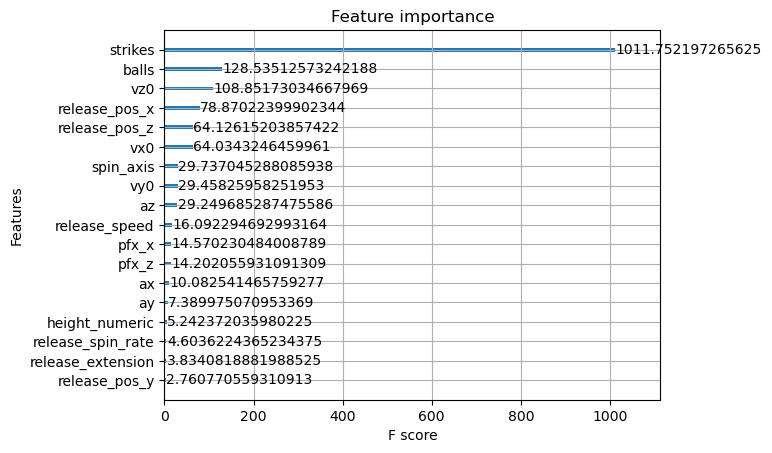

In [ ]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

## Testing Data Set Predictions

In [ ]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [ ]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [ ]:
y_pred = final_model.predict(predictions)

In [ ]:
testing_identifiers['xswing'] = y_pred

C:\Users\clayton.thompson\AppData\Local\Temp\ipykernel_19408\4232688072.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_identifiers['xswing'] = y_pred


In [ ]:
num_nans = testing_identifiers['xswing'].isna().sum()
print(f"Number of NaNs in 'xswing': {num_nans}")


Number of NaNs in 'xswing': 0


In [ ]:
len(testing_identifiers)

811776

In [ ]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/breaking_ball/swing_2022&3_xswing.csv")